In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import optuna
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb
import seaborn as sns

In [2]:
data = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2021_data.csv")
data_2022 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2022_data.csv")
data_2023 = pd.read_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/2023_MLB_Seaspm.csv")

In [3]:
testing_data = pd.concat([data_2022, data_2023], axis=0)

In [4]:
def preprocess_data(df):
    """
    This function takes a DataFrame and applies several preprocessing steps to it.
    """
    df = df.loc[df['release_speed'].notnull()].copy()
    int_cols = df.select_dtypes(include=['int64']).columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[int_cols] = df[int_cols].astype('int32')
    df[float_cols] = df[float_cols].astype('float32')

    # Condense pitch types using a mapping dictionary
    pitch_type_map = {
        "FF": "FF", "FT": "SI", "FC": "CT",
        "SL": "SL", "ST": "SL", "SV": "SL",
        "CH": "CH", "FS": "CH",
        "CU": "CB", "KC": "CB", "CS": "CB", "CB": "CB",
        "SI": "SI", "KN": "KN"
    }
    df['pitch_type_condensed'] = df['pitch_type'].map(pitch_type_map).fillna("FAHCK")

    df['release_pos_y'] = 60.5 - df['release_extension']
    df['height_ratio'] = df['release_pos_z'] / df['height_numeric']
    # Create 'pitch_id_raw'
    df['pitch_id_raw'] = df['game_pk'].astype(str) + "_" + df['batter'].astype(str) + "_" + df['pitcher'].astype(str) + "_" + df['pitch_number'].astype(str) + "_" + df['at_bat_number'].astype(str) + "_" + df['inning'].astype(str)

    df['throws'] = df['p_throws'].map({'R': 1, 'L': 0})
    return df

In [5]:
# Apply the function to the 'pitch_type' column
processed_data = preprocess_data(data)
processed_data_testing = preprocess_data(testing_data)

In [6]:
breaking_ball = processed_data.query('pitch_type_condensed in ("CH")')
breaking_ball_testing = processed_data_testing.query('pitch_type_condensed in ("CH")')

# Fastball Model First

In [29]:
# Now, separate features and identifiers
training_features = breaking_ball.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'balls', 'strikes', 'height_numeric'
], axis=1)
testing_features = breaking_ball_testing.drop(columns=[
    'description', 'events', 'game_pk', 'game_date', 'des', 'zone', 'stand', 'p_throws',
    'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 
    'game_type', 'home_team', 'away_team', 'type', 'bb_type', 'inning_topbot', 
    'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'hit_distance_sc', 
    'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle',
    'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 
    'iso_value', 'launch_speed_angle', 'pitch_name', 'home_score', 'away_score', 
    'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 
    'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment', 
    'delta_home_win_exp', 'delta_run_exp', 'player_name', 'hit_location', 'umpire', 
    'sv_id', 'spin_dir', 'pitch_type', 'fielder_2.1', 'pitcher.1', 'fielder_3', 
    'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 
    'batter', 'pitcher', 'on_3b', 'on_2b', 'on_1b', 'game_year', 'outs_when_up', 
    'pitch_number', 'at_bat_number', 'inning', 'fielder_2', 'sz_top', 'sz_bot',
    'effective_speed', 'p_throws', 'id', 'pitch_type_condensed',
    'plate_x', 'plate_z', 'Unnamed: 0', 'balls', 'strikes', 'height_numeric'
], axis=1)   # Exclude the identifier from the features

In [30]:
training_features.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'pfx_z',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'pitch_id_raw', 'throws'],
      dtype='object')

In [31]:
train_data = training_features.loc[training_features['pfx_z'].notnull()].drop(['pfx_z'], axis=1).copy()
train_label = training_features['pfx_z'].loc[training_features['pfx_z'].notnull()].copy()
testing_data = testing_features.loc[testing_features['pfx_z'].notnull()].drop(['pfx_z'], axis=1).copy()
testing_label = testing_features['pfx_z'].copy()

In [32]:
training_identifiers = train_data[['pitch_id_raw']]
testing_identifiers = testing_data[['pitch_id_raw']]
train_data = train_data.drop(['pitch_id_raw'], axis=1)
testing_data = testing_data.drop(['pitch_id_raw'], axis=1)

In [10]:
train_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [11]:
testing_data.columns

Index(['release_speed', 'release_pos_x', 'release_pos_z', 'pfx_x', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'spin_axis', 'height_ratio',
       'throws'],
      dtype='object')

In [12]:
# First split: Separate out a portion of the data as a temporary test set
x_temp, x_test, y_temp, y_test = train_test_split(
    train_data, 
    train_label, 
    test_size=0.2, 
    random_state=42
)

# Second split: Split the temporary test set into validation and test sets
x_train, x_valid, y_train, y_valid = train_test_split(
    x_temp, 
    y_temp, 
    test_size=0.1,
    random_state=42
)

In [13]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
  'booster' : "gbtree",
  'objective' : "reg:squarederror",
  'eta' : 0.3,
  'max_depth' : 6,
  'min_child_weight' : 1,
  'subsample' : 0.5,
  'colsample_bytree' : 0.5
}

# Initial Model
model = xgb.train(params, dtrain)

In [14]:
y_pred = model.predict(dtest)

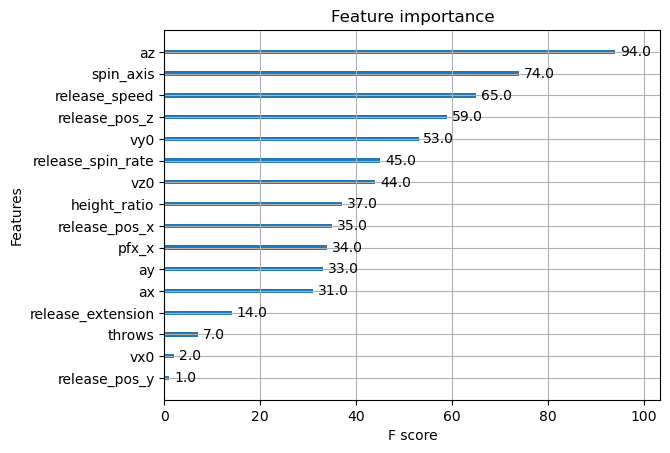

In [15]:
xgb.plot_importance(model)
plt.show()

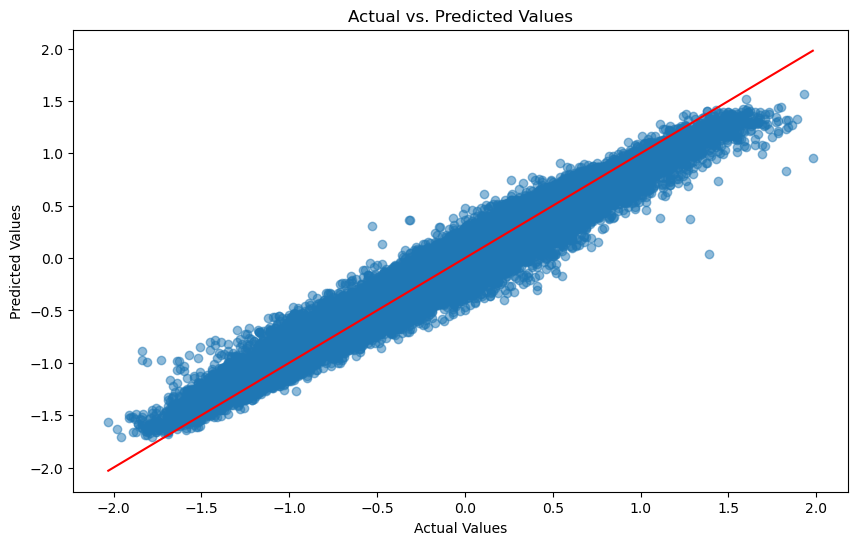

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

# Initial Paramater Tuning

In [17]:
def objective(trial):
    dtrain = xgb.DMatrix(x_train, label=y_train)
    dvalid = xgb.DMatrix(x_valid, label=y_valid)
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 4, 8),
        'device' : 'gpu',
        'eta': trial.suggest_float('eta', 0.2, 0.4),
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'subsample': trial.suggest_float('subsample', 0.4, 0.6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.6),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
    }

    # Train the model with early stopping
    model = xgb.train(
        param, 
        dtrain, 
        num_boost_round=100,  # Maximum number of boosting rounds
        evals=[(dvalid, 'eval')],  # Validation set for early stopping
        early_stopping_rounds=10  # Stop if the eval metric doesn't improve for 50 rounds
    )
    
    # Predict on the validation set using the best iteration
    y_valid_pred = model.predict(dvalid, iteration_range=(0, model.best_iteration + 1))


    # Calculate the RMSE on the validation set
    loss = np.sqrt(mean_squared_error(y_valid, y_valid_pred))


    return loss

In [18]:
#create an optuna study and specifcy the the direction of the optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000)

[I 2023-11-14 15:56:33,885] A new study created in memory with name: no-name-525115e9-8c5c-4032-8ec4-c06be19bae5f


[0]	eval-rmse:0.55080
[1]	eval-rmse:0.49167
[2]	eval-rmse:0.43062
[3]	eval-rmse:0.34936
[4]	eval-rmse:0.28370
[5]	eval-rmse:0.26906
[6]	eval-rmse:0.22135
[7]	eval-rmse:0.20300
[8]	eval-rmse:0.19020
[9]	eval-rmse:0.18091
[10]	eval-rmse:0.15951
[11]	eval-rmse:0.15539
[12]	eval-rmse:0.15293
[13]	eval-rmse:0.15049
[14]	eval-rmse:0.13348
[15]	eval-rmse:0.13288
[16]	eval-rmse:0.11868
[17]	eval-rmse:0.11786
[18]	eval-rmse:0.11689
[19]	eval-rmse:0.11621
[20]	eval-rmse:0.10794
[21]	eval-rmse:0.10765
[22]	eval-rmse:0.10720
[23]	eval-rmse:0.10702
[24]	eval-rmse:0.10674
[25]	eval-rmse:0.10653
[26]	eval-rmse:0.10643
[27]	eval-rmse:0.10604
[28]	eval-rmse:0.10591
[29]	eval-rmse:0.09748
[30]	eval-rmse:0.09080
[31]	eval-rmse:0.09050
[32]	eval-rmse:0.09021
[33]	eval-rmse:0.08457
[34]	eval-rmse:0.08431
[35]	eval-rmse:0.08040
[36]	eval-rmse:0.08015
[37]	eval-rmse:0.07718
[38]	eval-rmse:0.07373
[39]	eval-rmse:0.07333
[40]	eval-rmse:0.07067
[41]	eval-rmse:0.07036
[42]	eval-rmse:0.06855
[43]	eval-rmse:0.0683

[I 2023-11-14 15:56:36,283] Trial 0 finished with value: 0.04766642674803734 and parameters: {'max_depth': 8, 'eta': 0.20207974370441067, 'subsample': 0.40581655337404837, 'colsample_bytree': 0.544883948790529, 'min_child_weight': 3}. Best is trial 0 with value: 0.04766642674803734.


[0]	eval-rmse:0.52913
[1]	eval-rmse:0.46176
[2]	eval-rmse:0.39634
[3]	eval-rmse:0.30777
[4]	eval-rmse:0.23933
[5]	eval-rmse:0.22746
[6]	eval-rmse:0.18193
[7]	eval-rmse:0.16902
[8]	eval-rmse:0.16095
[9]	eval-rmse:0.15532
[10]	eval-rmse:0.13827
[11]	eval-rmse:0.13649
[12]	eval-rmse:0.13521
[13]	eval-rmse:0.13418
[14]	eval-rmse:0.11852
[15]	eval-rmse:0.11812
[16]	eval-rmse:0.10569
[17]	eval-rmse:0.10529
[18]	eval-rmse:0.10453
[19]	eval-rmse:0.10404
[20]	eval-rmse:0.09731
[21]	eval-rmse:0.09719
[22]	eval-rmse:0.09693
[23]	eval-rmse:0.09659
[24]	eval-rmse:0.09626
[25]	eval-rmse:0.09603
[26]	eval-rmse:0.09588
[27]	eval-rmse:0.09553
[28]	eval-rmse:0.09540
[29]	eval-rmse:0.08769
[30]	eval-rmse:0.08194
[31]	eval-rmse:0.08161
[32]	eval-rmse:0.08117
[33]	eval-rmse:0.07663
[34]	eval-rmse:0.07635
[35]	eval-rmse:0.07302
[36]	eval-rmse:0.07280
[37]	eval-rmse:0.07044
[38]	eval-rmse:0.06790
[39]	eval-rmse:0.06747
[40]	eval-rmse:0.06560
[41]	eval-rmse:0.06525
[42]	eval-rmse:0.06380
[43]	eval-rmse:0.0635

[I 2023-11-14 15:56:38,462] Trial 1 finished with value: 0.04810553044080734 and parameters: {'max_depth': 8, 'eta': 0.2485149031725549, 'subsample': 0.5681231907674712, 'colsample_bytree': 0.5591120981188918, 'min_child_weight': 3}. Best is trial 0 with value: 0.04766642674803734.


[0]	eval-rmse:0.47383
[1]	eval-rmse:0.39917
[2]	eval-rmse:0.33780
[3]	eval-rmse:0.24296
[4]	eval-rmse:0.17714
[5]	eval-rmse:0.17364
[6]	eval-rmse:0.13806
[7]	eval-rmse:0.13445
[8]	eval-rmse:0.13256
[9]	eval-rmse:0.13073
[10]	eval-rmse:0.12072
[11]	eval-rmse:0.11973
[12]	eval-rmse:0.11913
[13]	eval-rmse:0.11847
[14]	eval-rmse:0.10508
[15]	eval-rmse:0.10462
[16]	eval-rmse:0.09559
[17]	eval-rmse:0.09443
[18]	eval-rmse:0.09365
[19]	eval-rmse:0.09290
[20]	eval-rmse:0.08802
[21]	eval-rmse:0.08770
[22]	eval-rmse:0.08696
[23]	eval-rmse:0.08627
[24]	eval-rmse:0.08603
[25]	eval-rmse:0.08574
[26]	eval-rmse:0.08562
[27]	eval-rmse:0.08518
[28]	eval-rmse:0.08500
[29]	eval-rmse:0.07926
[30]	eval-rmse:0.07555
[31]	eval-rmse:0.07505
[32]	eval-rmse:0.07474
[33]	eval-rmse:0.07209
[34]	eval-rmse:0.07177
[35]	eval-rmse:0.06995
[36]	eval-rmse:0.06969
[37]	eval-rmse:0.06837
[38]	eval-rmse:0.06714
[39]	eval-rmse:0.06681
[40]	eval-rmse:0.06572
[41]	eval-rmse:0.06544
[42]	eval-rmse:0.06470
[43]	eval-rmse:0.0645

[I 2023-11-14 15:56:40,202] Trial 2 finished with value: 0.05552726984024048 and parameters: {'max_depth': 7, 'eta': 0.3775128335857779, 'subsample': 0.4355011751697148, 'colsample_bytree': 0.508478476506742, 'min_child_weight': 3}. Best is trial 0 with value: 0.04766642674803734.


[0]	eval-rmse:0.56127
[1]	eval-rmse:0.50759
[2]	eval-rmse:0.45058
[3]	eval-rmse:0.36839
[4]	eval-rmse:0.30295
[5]	eval-rmse:0.29013
[6]	eval-rmse:0.24289
[7]	eval-rmse:0.22764
[8]	eval-rmse:0.21674
[9]	eval-rmse:0.20944
[10]	eval-rmse:0.18606
[11]	eval-rmse:0.18422
[12]	eval-rmse:0.18085
[13]	eval-rmse:0.17850
[14]	eval-rmse:0.16012
[15]	eval-rmse:0.15916
[16]	eval-rmse:0.14398
[17]	eval-rmse:0.14313
[18]	eval-rmse:0.14200
[19]	eval-rmse:0.14122
[20]	eval-rmse:0.13155
[21]	eval-rmse:0.13106
[22]	eval-rmse:0.13073
[23]	eval-rmse:0.13055
[24]	eval-rmse:0.12990
[25]	eval-rmse:0.12948
[26]	eval-rmse:0.12916
[27]	eval-rmse:0.12888
[28]	eval-rmse:0.12856
[29]	eval-rmse:0.11822
[30]	eval-rmse:0.10957
[31]	eval-rmse:0.10924
[32]	eval-rmse:0.10886
[33]	eval-rmse:0.10165
[34]	eval-rmse:0.10106
[35]	eval-rmse:0.09605
[36]	eval-rmse:0.09567
[37]	eval-rmse:0.09165
[38]	eval-rmse:0.08743
[39]	eval-rmse:0.08650
[40]	eval-rmse:0.08289
[41]	eval-rmse:0.08222
[42]	eval-rmse:0.08199
[43]	eval-rmse:0.0816

[I 2023-11-14 15:56:41,471] Trial 3 finished with value: 0.04467865824699402 and parameters: {'max_depth': 5, 'eta': 0.20013745871273414, 'subsample': 0.5136510239854424, 'colsample_bytree': 0.45318509858535744, 'min_child_weight': 3}. Best is trial 3 with value: 0.04467865824699402.


[0]	eval-rmse:0.55319
[1]	eval-rmse:0.49439
[2]	eval-rmse:0.43455
[3]	eval-rmse:0.40490
[4]	eval-rmse:0.32768
[5]	eval-rmse:0.31399
[6]	eval-rmse:0.25863
[7]	eval-rmse:0.24223
[8]	eval-rmse:0.23014
[9]	eval-rmse:0.22179
[10]	eval-rmse:0.21945
[11]	eval-rmse:0.21679
[12]	eval-rmse:0.21350
[13]	eval-rmse:0.20945
[14]	eval-rmse:0.18493
[15]	eval-rmse:0.18412
[16]	eval-rmse:0.16619
[17]	eval-rmse:0.16539
[18]	eval-rmse:0.16404
[19]	eval-rmse:0.16315
[20]	eval-rmse:0.15007
[21]	eval-rmse:0.14951
[22]	eval-rmse:0.14885
[23]	eval-rmse:0.14857
[24]	eval-rmse:0.14800
[25]	eval-rmse:0.14761
[26]	eval-rmse:0.14720
[27]	eval-rmse:0.14649
[28]	eval-rmse:0.14611
[29]	eval-rmse:0.13324
[30]	eval-rmse:0.12311
[31]	eval-rmse:0.12273
[32]	eval-rmse:0.12243
[33]	eval-rmse:0.11405
[34]	eval-rmse:0.11339
[35]	eval-rmse:0.10981
[36]	eval-rmse:0.10941
[37]	eval-rmse:0.10478
[38]	eval-rmse:0.09918
[39]	eval-rmse:0.09882
[40]	eval-rmse:0.09403
[41]	eval-rmse:0.09347
[42]	eval-rmse:0.09318
[43]	eval-rmse:0.0929

[I 2023-11-14 15:56:42,919] Trial 4 finished with value: 0.05456967651844025 and parameters: {'max_depth': 6, 'eta': 0.21282381657409594, 'subsample': 0.40938162018571317, 'colsample_bytree': 0.4271898020428443, 'min_child_weight': 5}. Best is trial 3 with value: 0.04467865824699402.


[0]	eval-rmse:0.55357
[1]	eval-rmse:0.49775
[2]	eval-rmse:0.44118
[3]	eval-rmse:0.35384
[4]	eval-rmse:0.28708
[5]	eval-rmse:0.27624
[6]	eval-rmse:0.22962
[7]	eval-rmse:0.21807
[8]	eval-rmse:0.21058
[9]	eval-rmse:0.20448
[10]	eval-rmse:0.18335
[11]	eval-rmse:0.18181
[12]	eval-rmse:0.17952
[13]	eval-rmse:0.17797
[14]	eval-rmse:0.16056
[15]	eval-rmse:0.15974
[16]	eval-rmse:0.14661
[17]	eval-rmse:0.14597
[18]	eval-rmse:0.14501
[19]	eval-rmse:0.14454
[20]	eval-rmse:0.13540
[21]	eval-rmse:0.13487
[22]	eval-rmse:0.13434
[23]	eval-rmse:0.13395
[24]	eval-rmse:0.13341
[25]	eval-rmse:0.13312
[26]	eval-rmse:0.13280
[27]	eval-rmse:0.13217
[28]	eval-rmse:0.13189
[29]	eval-rmse:0.12043
[30]	eval-rmse:0.11269
[31]	eval-rmse:0.11226
[32]	eval-rmse:0.11178
[33]	eval-rmse:0.10560
[34]	eval-rmse:0.10500
[35]	eval-rmse:0.10116
[36]	eval-rmse:0.10075
[37]	eval-rmse:0.09660
[38]	eval-rmse:0.09251
[39]	eval-rmse:0.09156
[40]	eval-rmse:0.08827
[41]	eval-rmse:0.08758
[42]	eval-rmse:0.08719
[43]	eval-rmse:0.0867

[I 2023-11-14 15:56:43,986] Trial 5 finished with value: 0.04735707864165306 and parameters: {'max_depth': 4, 'eta': 0.22694412130329253, 'subsample': 0.4729934526792197, 'colsample_bytree': 0.47677194652104293, 'min_child_weight': 2}. Best is trial 3 with value: 0.04467865824699402.


[0]	eval-rmse:0.48415
[1]	eval-rmse:0.41785
[2]	eval-rmse:0.36563
[3]	eval-rmse:0.26817
[4]	eval-rmse:0.20965
[5]	eval-rmse:0.20626
[6]	eval-rmse:0.17611
[7]	eval-rmse:0.17268
[8]	eval-rmse:0.17097
[9]	eval-rmse:0.16908
[10]	eval-rmse:0.15512
[11]	eval-rmse:0.15328
[12]	eval-rmse:0.15179
[13]	eval-rmse:0.15087
[14]	eval-rmse:0.13197
[15]	eval-rmse:0.13141
[16]	eval-rmse:0.11962
[17]	eval-rmse:0.11820
[18]	eval-rmse:0.11650
[19]	eval-rmse:0.11545
[20]	eval-rmse:0.10837
[21]	eval-rmse:0.10746
[22]	eval-rmse:0.10563
[23]	eval-rmse:0.10464
[24]	eval-rmse:0.10420
[25]	eval-rmse:0.10376
[26]	eval-rmse:0.10347
[27]	eval-rmse:0.10282
[28]	eval-rmse:0.10246
[29]	eval-rmse:0.09356
[30]	eval-rmse:0.08904
[31]	eval-rmse:0.08843
[32]	eval-rmse:0.08791
[33]	eval-rmse:0.08436
[34]	eval-rmse:0.08353
[35]	eval-rmse:0.08120
[36]	eval-rmse:0.08074
[37]	eval-rmse:0.07779
[38]	eval-rmse:0.07431
[39]	eval-rmse:0.07362
[40]	eval-rmse:0.07171
[41]	eval-rmse:0.07126
[42]	eval-rmse:0.06989
[43]	eval-rmse:0.0694

[I 2023-11-14 15:56:45,136] Trial 6 finished with value: 0.048128824681043625 and parameters: {'max_depth': 4, 'eta': 0.39973663208050547, 'subsample': 0.41932056995132183, 'colsample_bytree': 0.5084468163844157, 'min_child_weight': 5}. Best is trial 3 with value: 0.04467865824699402.


[0]	eval-rmse:0.48770
[1]	eval-rmse:0.40784
[2]	eval-rmse:0.34122
[3]	eval-rmse:0.24948
[4]	eval-rmse:0.18355
[5]	eval-rmse:0.17882
[6]	eval-rmse:0.14285
[7]	eval-rmse:0.13819
[8]	eval-rmse:0.13593
[9]	eval-rmse:0.13459
[10]	eval-rmse:0.12368
[11]	eval-rmse:0.12297
[12]	eval-rmse:0.12254
[13]	eval-rmse:0.12223
[14]	eval-rmse:0.10836
[15]	eval-rmse:0.10815
[16]	eval-rmse:0.09821
[17]	eval-rmse:0.09738
[18]	eval-rmse:0.09653
[19]	eval-rmse:0.09603
[20]	eval-rmse:0.09113
[21]	eval-rmse:0.09080
[22]	eval-rmse:0.09002
[23]	eval-rmse:0.08978
[24]	eval-rmse:0.08922
[25]	eval-rmse:0.08894
[26]	eval-rmse:0.08884
[27]	eval-rmse:0.08848
[28]	eval-rmse:0.08828
[29]	eval-rmse:0.08256
[30]	eval-rmse:0.07852
[31]	eval-rmse:0.07811
[32]	eval-rmse:0.07787
[33]	eval-rmse:0.07503
[34]	eval-rmse:0.07463
[35]	eval-rmse:0.07290
[36]	eval-rmse:0.07266
[37]	eval-rmse:0.07136
[38]	eval-rmse:0.07001
[39]	eval-rmse:0.06954
[40]	eval-rmse:0.06815
[41]	eval-rmse:0.06789
[42]	eval-rmse:0.06768
[43]	eval-rmse:0.0676

[I 2023-11-14 15:56:47,214] Trial 7 finished with value: 0.05813043192028999 and parameters: {'max_depth': 8, 'eta': 0.34552213389876013, 'subsample': 0.41468672875056684, 'colsample_bytree': 0.43978538592548444, 'min_child_weight': 1}. Best is trial 3 with value: 0.04467865824699402.


[0]	eval-rmse:0.53514
[1]	eval-rmse:0.47510
[2]	eval-rmse:0.36289
[3]	eval-rmse:0.28042
[4]	eval-rmse:0.21956
[5]	eval-rmse:0.20590
[6]	eval-rmse:0.16708
[7]	eval-rmse:0.15684
[8]	eval-rmse:0.15031
[9]	eval-rmse:0.14574
[10]	eval-rmse:0.12682
[11]	eval-rmse:0.12500
[12]	eval-rmse:0.12364
[13]	eval-rmse:0.12174
[14]	eval-rmse:0.10927
[15]	eval-rmse:0.10294
[16]	eval-rmse:0.09481
[17]	eval-rmse:0.08821
[18]	eval-rmse:0.08687
[19]	eval-rmse:0.08608
[20]	eval-rmse:0.08178
[21]	eval-rmse:0.08126
[22]	eval-rmse:0.08077
[23]	eval-rmse:0.08031
[24]	eval-rmse:0.08009
[25]	eval-rmse:0.07986
[26]	eval-rmse:0.07957
[27]	eval-rmse:0.07905
[28]	eval-rmse:0.07885
[29]	eval-rmse:0.07239
[30]	eval-rmse:0.06812
[31]	eval-rmse:0.06782
[32]	eval-rmse:0.06749
[33]	eval-rmse:0.06389
[34]	eval-rmse:0.06357
[35]	eval-rmse:0.06047
[36]	eval-rmse:0.06020
[37]	eval-rmse:0.05789
[38]	eval-rmse:0.05593
[39]	eval-rmse:0.05547
[40]	eval-rmse:0.05419
[41]	eval-rmse:0.05297
[42]	eval-rmse:0.05200
[43]	eval-rmse:0.0515

[I 2023-11-14 15:56:48,443] Trial 8 finished with value: 0.03537110984325409 and parameters: {'max_depth': 5, 'eta': 0.254194218098464, 'subsample': 0.5645596321802024, 'colsample_bytree': 0.571737946325891, 'min_child_weight': 3}. Best is trial 8 with value: 0.03537110984325409.


[0]	eval-rmse:0.53250
[1]	eval-rmse:0.46324
[2]	eval-rmse:0.39798
[3]	eval-rmse:0.36667
[4]	eval-rmse:0.28576
[5]	eval-rmse:0.27366
[6]	eval-rmse:0.21971
[7]	eval-rmse:0.20595
[8]	eval-rmse:0.19597
[9]	eval-rmse:0.19000
[10]	eval-rmse:0.18841
[11]	eval-rmse:0.18677
[12]	eval-rmse:0.18471
[13]	eval-rmse:0.18231
[14]	eval-rmse:0.16048
[15]	eval-rmse:0.15994
[16]	eval-rmse:0.14444
[17]	eval-rmse:0.14375
[18]	eval-rmse:0.14262
[19]	eval-rmse:0.14186
[20]	eval-rmse:0.13135
[21]	eval-rmse:0.13078
[22]	eval-rmse:0.13011
[23]	eval-rmse:0.12976
[24]	eval-rmse:0.12902
[25]	eval-rmse:0.12877
[26]	eval-rmse:0.12840
[27]	eval-rmse:0.12794
[28]	eval-rmse:0.12745
[29]	eval-rmse:0.11630
[30]	eval-rmse:0.10834
[31]	eval-rmse:0.10803
[32]	eval-rmse:0.10782
[33]	eval-rmse:0.10048
[34]	eval-rmse:0.09986
[35]	eval-rmse:0.09717
[36]	eval-rmse:0.09688
[37]	eval-rmse:0.09349
[38]	eval-rmse:0.08975
[39]	eval-rmse:0.08941
[40]	eval-rmse:0.08547
[41]	eval-rmse:0.08506
[42]	eval-rmse:0.08467
[43]	eval-rmse:0.0844

[I 2023-11-14 15:56:50,682] Trial 9 finished with value: 0.058558229357004166 and parameters: {'max_depth': 8, 'eta': 0.24935702693914977, 'subsample': 0.5516405959285945, 'colsample_bytree': 0.4296149089355826, 'min_child_weight': 3}. Best is trial 8 with value: 0.03537110984325409.


[0]	eval-rmse:0.50866
[1]	eval-rmse:0.43991
[2]	eval-rmse:0.31564
[3]	eval-rmse:0.23161
[4]	eval-rmse:0.17435
[5]	eval-rmse:0.16427
[6]	eval-rmse:0.13168
[7]	eval-rmse:0.12497
[8]	eval-rmse:0.12119
[9]	eval-rmse:0.11803
[10]	eval-rmse:0.10295
[11]	eval-rmse:0.10162
[12]	eval-rmse:0.10089
[13]	eval-rmse:0.09966
[14]	eval-rmse:0.08918
[15]	eval-rmse:0.08505
[16]	eval-rmse:0.07836
[17]	eval-rmse:0.07365
[18]	eval-rmse:0.07231
[19]	eval-rmse:0.07160
[20]	eval-rmse:0.06849
[21]	eval-rmse:0.06772
[22]	eval-rmse:0.06713
[23]	eval-rmse:0.06650
[24]	eval-rmse:0.06613
[25]	eval-rmse:0.06588
[26]	eval-rmse:0.06569
[27]	eval-rmse:0.06536
[28]	eval-rmse:0.06522
[29]	eval-rmse:0.06100
[30]	eval-rmse:0.05795
[31]	eval-rmse:0.05756
[32]	eval-rmse:0.05716
[33]	eval-rmse:0.05511
[34]	eval-rmse:0.05482
[35]	eval-rmse:0.05320
[36]	eval-rmse:0.05295
[37]	eval-rmse:0.05165
[38]	eval-rmse:0.05028
[39]	eval-rmse:0.05000
[40]	eval-rmse:0.04901
[41]	eval-rmse:0.04836
[42]	eval-rmse:0.04780
[43]	eval-rmse:0.0475

[I 2023-11-14 15:56:52,145] Trial 10 finished with value: 0.03722313046455383 and parameters: {'max_depth': 6, 'eta': 0.30663357659084894, 'subsample': 0.5891333834045117, 'colsample_bytree': 0.5951338729018688, 'min_child_weight': 1}. Best is trial 8 with value: 0.03537110984325409.


[0]	eval-rmse:0.51345
[1]	eval-rmse:0.44598
[2]	eval-rmse:0.32401
[3]	eval-rmse:0.23982
[4]	eval-rmse:0.18132
[5]	eval-rmse:0.17029
[6]	eval-rmse:0.13593
[7]	eval-rmse:0.12806
[8]	eval-rmse:0.12373
[9]	eval-rmse:0.12032
[10]	eval-rmse:0.10473
[11]	eval-rmse:0.10339
[12]	eval-rmse:0.10260
[13]	eval-rmse:0.10130
[14]	eval-rmse:0.09086
[15]	eval-rmse:0.08639
[16]	eval-rmse:0.07927
[17]	eval-rmse:0.07411
[18]	eval-rmse:0.07286
[19]	eval-rmse:0.07211
[20]	eval-rmse:0.06868
[21]	eval-rmse:0.06809
[22]	eval-rmse:0.06755
[23]	eval-rmse:0.06700
[24]	eval-rmse:0.06663
[25]	eval-rmse:0.06635
[26]	eval-rmse:0.06630
[27]	eval-rmse:0.06571
[28]	eval-rmse:0.06560
[29]	eval-rmse:0.06129
[30]	eval-rmse:0.05806
[31]	eval-rmse:0.05771
[32]	eval-rmse:0.05736
[33]	eval-rmse:0.05503
[34]	eval-rmse:0.05477
[35]	eval-rmse:0.05315
[36]	eval-rmse:0.05289
[37]	eval-rmse:0.05138
[38]	eval-rmse:0.05018
[39]	eval-rmse:0.04985
[40]	eval-rmse:0.04896
[41]	eval-rmse:0.04827
[42]	eval-rmse:0.04774
[43]	eval-rmse:0.0474

[I 2023-11-14 15:56:53,667] Trial 11 finished with value: 0.03644529730081558 and parameters: {'max_depth': 6, 'eta': 0.2949783656256142, 'subsample': 0.5964731636602737, 'colsample_bytree': 0.5974550117771791, 'min_child_weight': 1}. Best is trial 8 with value: 0.03537110984325409.


[0]	eval-rmse:0.52114
[1]	eval-rmse:0.45784
[2]	eval-rmse:0.33751
[3]	eval-rmse:0.25383
[4]	eval-rmse:0.19499
[5]	eval-rmse:0.18457
[6]	eval-rmse:0.14889
[7]	eval-rmse:0.14141
[8]	eval-rmse:0.13663
[9]	eval-rmse:0.13338
[10]	eval-rmse:0.11704
[11]	eval-rmse:0.11567
[12]	eval-rmse:0.11441
[13]	eval-rmse:0.11360
[14]	eval-rmse:0.10098
[15]	eval-rmse:0.09575
[16]	eval-rmse:0.08867
[17]	eval-rmse:0.08242
[18]	eval-rmse:0.08109
[19]	eval-rmse:0.08031
[20]	eval-rmse:0.07628
[21]	eval-rmse:0.07582
[22]	eval-rmse:0.07531
[23]	eval-rmse:0.07476
[24]	eval-rmse:0.07450
[25]	eval-rmse:0.07431
[26]	eval-rmse:0.07407
[27]	eval-rmse:0.07368
[28]	eval-rmse:0.07344
[29]	eval-rmse:0.06803
[30]	eval-rmse:0.06400
[31]	eval-rmse:0.06360
[32]	eval-rmse:0.06325
[33]	eval-rmse:0.06057
[34]	eval-rmse:0.06028
[35]	eval-rmse:0.05761
[36]	eval-rmse:0.05728
[37]	eval-rmse:0.05521
[38]	eval-rmse:0.05377
[39]	eval-rmse:0.05335
[40]	eval-rmse:0.05207
[41]	eval-rmse:0.05116
[42]	eval-rmse:0.05022
[43]	eval-rmse:0.0497

[I 2023-11-14 15:56:55,015] Trial 12 finished with value: 0.03589186072349548 and parameters: {'max_depth': 5, 'eta': 0.28653595809049515, 'subsample': 0.5968931706997617, 'colsample_bytree': 0.5989380094138955, 'min_child_weight': 4}. Best is trial 8 with value: 0.03537110984325409.


[0]	eval-rmse:0.52375
[1]	eval-rmse:0.46086
[2]	eval-rmse:0.34233
[3]	eval-rmse:0.25889
[4]	eval-rmse:0.19997
[5]	eval-rmse:0.18861
[6]	eval-rmse:0.15248
[7]	eval-rmse:0.14435
[8]	eval-rmse:0.13942
[9]	eval-rmse:0.13583
[10]	eval-rmse:0.11868
[11]	eval-rmse:0.11725
[12]	eval-rmse:0.11597
[13]	eval-rmse:0.11455
[14]	eval-rmse:0.10203
[15]	eval-rmse:0.09676
[16]	eval-rmse:0.08914
[17]	eval-rmse:0.08314
[18]	eval-rmse:0.08190
[19]	eval-rmse:0.08114
[20]	eval-rmse:0.07676
[21]	eval-rmse:0.07617
[22]	eval-rmse:0.07555
[23]	eval-rmse:0.07518
[24]	eval-rmse:0.07498
[25]	eval-rmse:0.07467
[26]	eval-rmse:0.07439
[27]	eval-rmse:0.07388
[28]	eval-rmse:0.07372
[29]	eval-rmse:0.06885
[30]	eval-rmse:0.06492
[31]	eval-rmse:0.06443
[32]	eval-rmse:0.06411
[33]	eval-rmse:0.06062
[34]	eval-rmse:0.06031
[35]	eval-rmse:0.05828
[36]	eval-rmse:0.05799
[37]	eval-rmse:0.05591
[38]	eval-rmse:0.05429
[39]	eval-rmse:0.05389
[40]	eval-rmse:0.05270
[41]	eval-rmse:0.05169
[42]	eval-rmse:0.05096
[43]	eval-rmse:0.0506

[I 2023-11-14 15:56:56,317] Trial 13 finished with value: 0.03591356799006462 and parameters: {'max_depth': 5, 'eta': 0.2805007122725148, 'subsample': 0.5486355068703359, 'colsample_bytree': 0.5634805291320172, 'min_child_weight': 4}. Best is trial 8 with value: 0.03537110984325409.


[0]	eval-rmse:0.52899
[1]	eval-rmse:0.46757
[2]	eval-rmse:0.35181
[3]	eval-rmse:0.26851
[4]	eval-rmse:0.20829
[5]	eval-rmse:0.19605
[6]	eval-rmse:0.15806
[7]	eval-rmse:0.14881
[8]	eval-rmse:0.14330
[9]	eval-rmse:0.13912
[10]	eval-rmse:0.12172
[11]	eval-rmse:0.11980
[12]	eval-rmse:0.11843
[13]	eval-rmse:0.11712
[14]	eval-rmse:0.10553
[15]	eval-rmse:0.09983
[16]	eval-rmse:0.09117
[17]	eval-rmse:0.08500
[18]	eval-rmse:0.08364
[19]	eval-rmse:0.08288
[20]	eval-rmse:0.07835
[21]	eval-rmse:0.07775
[22]	eval-rmse:0.07716
[23]	eval-rmse:0.07661
[24]	eval-rmse:0.07630
[25]	eval-rmse:0.07597
[26]	eval-rmse:0.07583
[27]	eval-rmse:0.07555
[28]	eval-rmse:0.07539
[29]	eval-rmse:0.06908
[30]	eval-rmse:0.06490
[31]	eval-rmse:0.06451
[32]	eval-rmse:0.06419
[33]	eval-rmse:0.06092
[34]	eval-rmse:0.06057
[35]	eval-rmse:0.05788
[36]	eval-rmse:0.05759
[37]	eval-rmse:0.05559
[38]	eval-rmse:0.05402
[39]	eval-rmse:0.05363
[40]	eval-rmse:0.05233
[41]	eval-rmse:0.05132
[42]	eval-rmse:0.05052
[43]	eval-rmse:0.0500

[I 2023-11-14 15:56:57,725] Trial 14 finished with value: 0.03482689708471298 and parameters: {'max_depth': 5, 'eta': 0.26784953431506925, 'subsample': 0.5991491395401997, 'colsample_bytree': 0.5985436796636572, 'min_child_weight': 4}. Best is trial 14 with value: 0.03482689708471298.


[0]	eval-rmse:0.53352
[1]	eval-rmse:0.47314
[2]	eval-rmse:0.41192
[3]	eval-rmse:0.32031
[4]	eval-rmse:0.25264
[5]	eval-rmse:0.24312
[6]	eval-rmse:0.19831
[7]	eval-rmse:0.18876
[8]	eval-rmse:0.18274
[9]	eval-rmse:0.17871
[10]	eval-rmse:0.15984
[11]	eval-rmse:0.15826
[12]	eval-rmse:0.15679
[13]	eval-rmse:0.15598
[14]	eval-rmse:0.13900
[15]	eval-rmse:0.13836
[16]	eval-rmse:0.12655
[17]	eval-rmse:0.12563
[18]	eval-rmse:0.12479
[19]	eval-rmse:0.12420
[20]	eval-rmse:0.11637
[21]	eval-rmse:0.11574
[22]	eval-rmse:0.11510
[23]	eval-rmse:0.11446
[24]	eval-rmse:0.11391
[25]	eval-rmse:0.11347
[26]	eval-rmse:0.11313
[27]	eval-rmse:0.11286
[28]	eval-rmse:0.11257
[29]	eval-rmse:0.10188
[30]	eval-rmse:0.09514
[31]	eval-rmse:0.09450
[32]	eval-rmse:0.09396
[33]	eval-rmse:0.08795
[34]	eval-rmse:0.08748
[35]	eval-rmse:0.08291
[36]	eval-rmse:0.08259
[37]	eval-rmse:0.07935
[38]	eval-rmse:0.07593
[39]	eval-rmse:0.07531
[40]	eval-rmse:0.07257
[41]	eval-rmse:0.07212
[42]	eval-rmse:0.07026
[43]	eval-rmse:0.0696

[I 2023-11-14 15:56:59,010] Trial 15 finished with value: 0.043830227106809616 and parameters: {'max_depth': 5, 'eta': 0.25784763742534544, 'subsample': 0.53175662619778, 'colsample_bytree': 0.5406341795809156, 'min_child_weight': 4}. Best is trial 14 with value: 0.03482689708471298.


[0]	eval-rmse:0.51872
[1]	eval-rmse:0.45196
[2]	eval-rmse:0.39394
[3]	eval-rmse:0.37106
[4]	eval-rmse:0.28732
[5]	eval-rmse:0.27944
[6]	eval-rmse:0.22963
[7]	eval-rmse:0.22496
[8]	eval-rmse:0.22085
[9]	eval-rmse:0.21881
[10]	eval-rmse:0.21668
[11]	eval-rmse:0.21514
[12]	eval-rmse:0.21378
[13]	eval-rmse:0.21289
[14]	eval-rmse:0.18997
[15]	eval-rmse:0.18900
[16]	eval-rmse:0.17149
[17]	eval-rmse:0.17018
[18]	eval-rmse:0.16891
[19]	eval-rmse:0.16751
[20]	eval-rmse:0.15632
[21]	eval-rmse:0.15534
[22]	eval-rmse:0.15409
[23]	eval-rmse:0.15364
[24]	eval-rmse:0.15319
[25]	eval-rmse:0.15301
[26]	eval-rmse:0.15269
[27]	eval-rmse:0.15182
[28]	eval-rmse:0.15143
[29]	eval-rmse:0.13629
[30]	eval-rmse:0.12511
[31]	eval-rmse:0.12434
[32]	eval-rmse:0.12368
[33]	eval-rmse:0.11622
[34]	eval-rmse:0.11538
[35]	eval-rmse:0.11206
[36]	eval-rmse:0.11119
[37]	eval-rmse:0.10693
[38]	eval-rmse:0.10108
[39]	eval-rmse:0.10055
[40]	eval-rmse:0.09671
[41]	eval-rmse:0.09598
[42]	eval-rmse:0.09555
[43]	eval-rmse:0.0951

[I 2023-11-14 15:57:00,169] Trial 16 finished with value: 0.05446576699614525 and parameters: {'max_depth': 4, 'eta': 0.3177383028236534, 'subsample': 0.5664788024725815, 'colsample_bytree': 0.4048844607793658, 'min_child_weight': 2}. Best is trial 14 with value: 0.03482689708471298.


[0]	eval-rmse:0.52211
[1]	eval-rmse:0.45475
[2]	eval-rmse:0.33946
[3]	eval-rmse:0.25639
[4]	eval-rmse:0.19573
[5]	eval-rmse:0.18055
[6]	eval-rmse:0.14331
[7]	eval-rmse:0.13267
[8]	eval-rmse:0.12626
[9]	eval-rmse:0.12212
[10]	eval-rmse:0.10552
[11]	eval-rmse:0.10380
[12]	eval-rmse:0.10276
[13]	eval-rmse:0.10142
[14]	eval-rmse:0.09114
[15]	eval-rmse:0.08633
[16]	eval-rmse:0.07894
[17]	eval-rmse:0.07413
[18]	eval-rmse:0.07325
[19]	eval-rmse:0.07272
[20]	eval-rmse:0.06914
[21]	eval-rmse:0.06875
[22]	eval-rmse:0.06836
[23]	eval-rmse:0.06792
[24]	eval-rmse:0.06757
[25]	eval-rmse:0.06741
[26]	eval-rmse:0.06724
[27]	eval-rmse:0.06679
[28]	eval-rmse:0.06672
[29]	eval-rmse:0.06209
[30]	eval-rmse:0.05886
[31]	eval-rmse:0.05856
[32]	eval-rmse:0.05825
[33]	eval-rmse:0.05586
[34]	eval-rmse:0.05561
[35]	eval-rmse:0.05400
[36]	eval-rmse:0.05383
[37]	eval-rmse:0.05232
[38]	eval-rmse:0.05103
[39]	eval-rmse:0.05072
[40]	eval-rmse:0.04966
[41]	eval-rmse:0.04893
[42]	eval-rmse:0.04830
[43]	eval-rmse:0.0480

[I 2023-11-14 15:57:01,973] Trial 17 finished with value: 0.038079436868429184 and parameters: {'max_depth': 7, 'eta': 0.26795816989554416, 'subsample': 0.5752437632621968, 'colsample_bytree': 0.570337933274588, 'min_child_weight': 4}. Best is trial 14 with value: 0.03482689708471298.


[0]	eval-rmse:0.54486
[1]	eval-rmse:0.48782
[2]	eval-rmse:0.42816
[3]	eval-rmse:0.34037
[4]	eval-rmse:0.27335
[5]	eval-rmse:0.26208
[6]	eval-rmse:0.21507
[7]	eval-rmse:0.20307
[8]	eval-rmse:0.19532
[9]	eval-rmse:0.18933
[10]	eval-rmse:0.16849
[11]	eval-rmse:0.16649
[12]	eval-rmse:0.16450
[13]	eval-rmse:0.16317
[14]	eval-rmse:0.14591
[15]	eval-rmse:0.14532
[16]	eval-rmse:0.13239
[17]	eval-rmse:0.13177
[18]	eval-rmse:0.13091
[19]	eval-rmse:0.13019
[20]	eval-rmse:0.12113
[21]	eval-rmse:0.12061
[22]	eval-rmse:0.11990
[23]	eval-rmse:0.11942
[24]	eval-rmse:0.11892
[25]	eval-rmse:0.11856
[26]	eval-rmse:0.11832
[27]	eval-rmse:0.11789
[28]	eval-rmse:0.11764
[29]	eval-rmse:0.10701
[30]	eval-rmse:0.09842
[31]	eval-rmse:0.09803
[32]	eval-rmse:0.09753
[33]	eval-rmse:0.09094
[34]	eval-rmse:0.09039
[35]	eval-rmse:0.08590
[36]	eval-rmse:0.08554
[37]	eval-rmse:0.08204
[38]	eval-rmse:0.07852
[39]	eval-rmse:0.07789
[40]	eval-rmse:0.07490
[41]	eval-rmse:0.07437
[42]	eval-rmse:0.07224
[43]	eval-rmse:0.0717

[I 2023-11-14 15:57:03,424] Trial 18 finished with value: 0.042555756866931915 and parameters: {'max_depth': 5, 'eta': 0.23183046642178062, 'subsample': 0.5327300453485776, 'colsample_bytree': 0.5311345546968965, 'min_child_weight': 2}. Best is trial 14 with value: 0.03482689708471298.


[0]	eval-rmse:0.52193
[1]	eval-rmse:0.45444
[2]	eval-rmse:0.33901
[3]	eval-rmse:0.25588
[4]	eval-rmse:0.19526
[5]	eval-rmse:0.18025
[6]	eval-rmse:0.14328
[7]	eval-rmse:0.13284
[8]	eval-rmse:0.12650
[9]	eval-rmse:0.12237
[10]	eval-rmse:0.10547
[11]	eval-rmse:0.10373
[12]	eval-rmse:0.10277
[13]	eval-rmse:0.10140
[14]	eval-rmse:0.09110
[15]	eval-rmse:0.08627
[16]	eval-rmse:0.07884
[17]	eval-rmse:0.07381
[18]	eval-rmse:0.07293
[19]	eval-rmse:0.07232
[20]	eval-rmse:0.06886
[21]	eval-rmse:0.06817
[22]	eval-rmse:0.06776
[23]	eval-rmse:0.06729
[24]	eval-rmse:0.06703
[25]	eval-rmse:0.06685
[26]	eval-rmse:0.06666
[27]	eval-rmse:0.06629
[28]	eval-rmse:0.06614
[29]	eval-rmse:0.06158
[30]	eval-rmse:0.05852
[31]	eval-rmse:0.05820
[32]	eval-rmse:0.05792
[33]	eval-rmse:0.05529
[34]	eval-rmse:0.05510
[35]	eval-rmse:0.05341
[36]	eval-rmse:0.05328
[37]	eval-rmse:0.05174
[38]	eval-rmse:0.05039
[39]	eval-rmse:0.05014
[40]	eval-rmse:0.04915
[41]	eval-rmse:0.04847
[42]	eval-rmse:0.04779
[43]	eval-rmse:0.0475

[I 2023-11-14 15:57:05,203] Trial 19 finished with value: 0.03749080002307892 and parameters: {'max_depth': 7, 'eta': 0.26830417117692607, 'subsample': 0.5783835492284501, 'colsample_bytree': 0.5769677170355269, 'min_child_weight': 5}. Best is trial 14 with value: 0.03482689708471298.


[0]	eval-rmse:0.54084
[1]	eval-rmse:0.48050
[2]	eval-rmse:0.37392
[3]	eval-rmse:0.29295
[4]	eval-rmse:0.23088
[5]	eval-rmse:0.21363
[6]	eval-rmse:0.17274
[7]	eval-rmse:0.15937
[8]	eval-rmse:0.15033
[9]	eval-rmse:0.14420
[10]	eval-rmse:0.12437
[11]	eval-rmse:0.12166
[12]	eval-rmse:0.12006
[13]	eval-rmse:0.11823
[14]	eval-rmse:0.10572
[15]	eval-rmse:0.09914
[16]	eval-rmse:0.09057
[17]	eval-rmse:0.08427
[18]	eval-rmse:0.08342
[19]	eval-rmse:0.08279
[20]	eval-rmse:0.07807
[21]	eval-rmse:0.07762
[22]	eval-rmse:0.07720
[23]	eval-rmse:0.07682
[24]	eval-rmse:0.07656
[25]	eval-rmse:0.07633
[26]	eval-rmse:0.07610
[27]	eval-rmse:0.07560
[28]	eval-rmse:0.07546
[29]	eval-rmse:0.06966
[30]	eval-rmse:0.06502
[31]	eval-rmse:0.06468
[32]	eval-rmse:0.06437
[33]	eval-rmse:0.06128
[34]	eval-rmse:0.06100
[35]	eval-rmse:0.05830
[36]	eval-rmse:0.05815
[37]	eval-rmse:0.05594
[38]	eval-rmse:0.05382
[39]	eval-rmse:0.05351
[40]	eval-rmse:0.05211
[41]	eval-rmse:0.05096
[42]	eval-rmse:0.05003
[43]	eval-rmse:0.0496

[I 2023-11-14 15:57:06,568] Trial 20 finished with value: 0.03439502790570259 and parameters: {'max_depth': 6, 'eta': 0.23338676532025915, 'subsample': 0.598550603996088, 'colsample_bytree': 0.578263955774695, 'min_child_weight': 4}. Best is trial 20 with value: 0.03439502790570259.


[0]	eval-rmse:0.53886
[1]	eval-rmse:0.47789
[2]	eval-rmse:0.37005
[3]	eval-rmse:0.28854
[4]	eval-rmse:0.22663
[5]	eval-rmse:0.20979
[6]	eval-rmse:0.16928
[7]	eval-rmse:0.15608
[8]	eval-rmse:0.14773
[9]	eval-rmse:0.14214
[10]	eval-rmse:0.12250
[11]	eval-rmse:0.12000
[12]	eval-rmse:0.11835
[13]	eval-rmse:0.11661
[14]	eval-rmse:0.10417
[15]	eval-rmse:0.09772
[16]	eval-rmse:0.08929
[17]	eval-rmse:0.08311
[18]	eval-rmse:0.08226
[19]	eval-rmse:0.08157
[20]	eval-rmse:0.07681
[21]	eval-rmse:0.07628
[22]	eval-rmse:0.07586
[23]	eval-rmse:0.07544
[24]	eval-rmse:0.07518
[25]	eval-rmse:0.07493
[26]	eval-rmse:0.07465
[27]	eval-rmse:0.07417
[28]	eval-rmse:0.07398
[29]	eval-rmse:0.06812
[30]	eval-rmse:0.06374
[31]	eval-rmse:0.06345
[32]	eval-rmse:0.06315
[33]	eval-rmse:0.06019
[34]	eval-rmse:0.05995
[35]	eval-rmse:0.05743
[36]	eval-rmse:0.05721
[37]	eval-rmse:0.05491
[38]	eval-rmse:0.05274
[39]	eval-rmse:0.05244
[40]	eval-rmse:0.05098
[41]	eval-rmse:0.04995
[42]	eval-rmse:0.04919
[43]	eval-rmse:0.0488

[I 2023-11-14 15:57:08,038] Trial 21 finished with value: 0.03429414704442024 and parameters: {'max_depth': 6, 'eta': 0.23779654397078412, 'subsample': 0.5977866165919445, 'colsample_bytree': 0.5791820554161716, 'min_child_weight': 4}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.53979
[1]	eval-rmse:0.47922
[2]	eval-rmse:0.37216
[3]	eval-rmse:0.29097
[4]	eval-rmse:0.22907
[5]	eval-rmse:0.21197
[6]	eval-rmse:0.17133
[7]	eval-rmse:0.15806
[8]	eval-rmse:0.14942
[9]	eval-rmse:0.14341
[10]	eval-rmse:0.12361
[11]	eval-rmse:0.12087
[12]	eval-rmse:0.11939
[13]	eval-rmse:0.11756
[14]	eval-rmse:0.10529
[15]	eval-rmse:0.09884
[16]	eval-rmse:0.09027
[17]	eval-rmse:0.08407
[18]	eval-rmse:0.08320
[19]	eval-rmse:0.08252
[20]	eval-rmse:0.07786
[21]	eval-rmse:0.07729
[22]	eval-rmse:0.07687
[23]	eval-rmse:0.07653
[24]	eval-rmse:0.07627
[25]	eval-rmse:0.07599
[26]	eval-rmse:0.07571
[27]	eval-rmse:0.07531
[28]	eval-rmse:0.07511
[29]	eval-rmse:0.06930
[30]	eval-rmse:0.06488
[31]	eval-rmse:0.06459
[32]	eval-rmse:0.06428
[33]	eval-rmse:0.06139
[34]	eval-rmse:0.06115
[35]	eval-rmse:0.05842
[36]	eval-rmse:0.05811
[37]	eval-rmse:0.05590
[38]	eval-rmse:0.05405
[39]	eval-rmse:0.05372
[40]	eval-rmse:0.05221
[41]	eval-rmse:0.05121
[42]	eval-rmse:0.05041
[43]	eval-rmse:0.0500

[I 2023-11-14 15:57:09,505] Trial 22 finished with value: 0.0352439321577549 and parameters: {'max_depth': 6, 'eta': 0.2352801060552235, 'subsample': 0.5946239827948603, 'colsample_bytree': 0.5836892184537316, 'min_child_weight': 4}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.54565
[1]	eval-rmse:0.48704
[2]	eval-rmse:0.38372
[3]	eval-rmse:0.30396
[4]	eval-rmse:0.24222
[5]	eval-rmse:0.22396
[6]	eval-rmse:0.18215
[7]	eval-rmse:0.16745
[8]	eval-rmse:0.15794
[9]	eval-rmse:0.15120
[10]	eval-rmse:0.13037
[11]	eval-rmse:0.12720
[12]	eval-rmse:0.12535
[13]	eval-rmse:0.12310
[14]	eval-rmse:0.11013
[15]	eval-rmse:0.10301
[16]	eval-rmse:0.09403
[17]	eval-rmse:0.08748
[18]	eval-rmse:0.08665
[19]	eval-rmse:0.08596
[20]	eval-rmse:0.08082
[21]	eval-rmse:0.08043
[22]	eval-rmse:0.08000
[23]	eval-rmse:0.07960
[24]	eval-rmse:0.07931
[25]	eval-rmse:0.07908
[26]	eval-rmse:0.07887
[27]	eval-rmse:0.07843
[28]	eval-rmse:0.07820
[29]	eval-rmse:0.07200
[30]	eval-rmse:0.06733
[31]	eval-rmse:0.06710
[32]	eval-rmse:0.06681
[33]	eval-rmse:0.06311
[34]	eval-rmse:0.06277
[35]	eval-rmse:0.06007
[36]	eval-rmse:0.05976
[37]	eval-rmse:0.05760
[38]	eval-rmse:0.05561
[39]	eval-rmse:0.05525
[40]	eval-rmse:0.05367
[41]	eval-rmse:0.05241
[42]	eval-rmse:0.05134
[43]	eval-rmse:0.0509

[I 2023-11-14 15:57:11,055] Trial 23 finished with value: 0.03487750142812729 and parameters: {'max_depth': 6, 'eta': 0.22228219937955082, 'subsample': 0.5825991631071804, 'colsample_bytree': 0.5842684186206679, 'min_child_weight': 4}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.53344
[1]	eval-rmse:0.46962
[2]	eval-rmse:0.40571
[3]	eval-rmse:0.31670
[4]	eval-rmse:0.24833
[5]	eval-rmse:0.23658
[6]	eval-rmse:0.18998
[7]	eval-rmse:0.17700
[8]	eval-rmse:0.16880
[9]	eval-rmse:0.16326
[10]	eval-rmse:0.14516
[11]	eval-rmse:0.14307
[12]	eval-rmse:0.14158
[13]	eval-rmse:0.14020
[14]	eval-rmse:0.12364
[15]	eval-rmse:0.12317
[16]	eval-rmse:0.11086
[17]	eval-rmse:0.11040
[18]	eval-rmse:0.10968
[19]	eval-rmse:0.10903
[20]	eval-rmse:0.10108
[21]	eval-rmse:0.10074
[22]	eval-rmse:0.10041
[23]	eval-rmse:0.09995
[24]	eval-rmse:0.09952
[25]	eval-rmse:0.09926
[26]	eval-rmse:0.09905
[27]	eval-rmse:0.09875
[28]	eval-rmse:0.09859
[29]	eval-rmse:0.08972
[30]	eval-rmse:0.08325
[31]	eval-rmse:0.08291
[32]	eval-rmse:0.08246
[33]	eval-rmse:0.07752
[34]	eval-rmse:0.07713
[35]	eval-rmse:0.07361
[36]	eval-rmse:0.07333
[37]	eval-rmse:0.07068
[38]	eval-rmse:0.06784
[39]	eval-rmse:0.06742
[40]	eval-rmse:0.06520
[41]	eval-rmse:0.06484
[42]	eval-rmse:0.06317
[43]	eval-rmse:0.0628

[I 2023-11-14 15:57:12,921] Trial 24 finished with value: 0.0442214161157608 and parameters: {'max_depth': 7, 'eta': 0.2435238399835315, 'subsample': 0.5973245907360545, 'colsample_bytree': 0.5592679763348858, 'min_child_weight': 5}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.54728
[1]	eval-rmse:0.48918
[2]	eval-rmse:0.38685
[3]	eval-rmse:0.30757
[4]	eval-rmse:0.24576
[5]	eval-rmse:0.22765
[6]	eval-rmse:0.18531
[7]	eval-rmse:0.17000
[8]	eval-rmse:0.15988
[9]	eval-rmse:0.15240
[10]	eval-rmse:0.13140
[11]	eval-rmse:0.12811
[12]	eval-rmse:0.12611
[13]	eval-rmse:0.12386
[14]	eval-rmse:0.11044
[15]	eval-rmse:0.10307
[16]	eval-rmse:0.09367
[17]	eval-rmse:0.08696
[18]	eval-rmse:0.08626
[19]	eval-rmse:0.08570
[20]	eval-rmse:0.08062
[21]	eval-rmse:0.08029
[22]	eval-rmse:0.07994
[23]	eval-rmse:0.07957
[24]	eval-rmse:0.07933
[25]	eval-rmse:0.07906
[26]	eval-rmse:0.07895
[27]	eval-rmse:0.07866
[28]	eval-rmse:0.07847
[29]	eval-rmse:0.07228
[30]	eval-rmse:0.06820
[31]	eval-rmse:0.06795
[32]	eval-rmse:0.06761
[33]	eval-rmse:0.06375
[34]	eval-rmse:0.06343
[35]	eval-rmse:0.06045
[36]	eval-rmse:0.06018
[37]	eval-rmse:0.05789
[38]	eval-rmse:0.05568
[39]	eval-rmse:0.05532
[40]	eval-rmse:0.05371
[41]	eval-rmse:0.05254
[42]	eval-rmse:0.05143
[43]	eval-rmse:0.0511

[I 2023-11-14 15:57:14,253] Trial 25 finished with value: 0.034949079155921936 and parameters: {'max_depth': 6, 'eta': 0.21895403063039862, 'subsample': 0.5788740223128159, 'colsample_bytree': 0.5830953895735228, 'min_child_weight': 4}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.53910
[1]	eval-rmse:0.47830
[2]	eval-rmse:0.41625
[3]	eval-rmse:0.32774
[4]	eval-rmse:0.25951
[5]	eval-rmse:0.24794
[6]	eval-rmse:0.20129
[7]	eval-rmse:0.18843
[8]	eval-rmse:0.18076
[9]	eval-rmse:0.17464
[10]	eval-rmse:0.15513
[11]	eval-rmse:0.15307
[12]	eval-rmse:0.15148
[13]	eval-rmse:0.14992
[14]	eval-rmse:0.13355
[15]	eval-rmse:0.13302
[16]	eval-rmse:0.11987
[17]	eval-rmse:0.11932
[18]	eval-rmse:0.11865
[19]	eval-rmse:0.11800
[20]	eval-rmse:0.10966
[21]	eval-rmse:0.10933
[22]	eval-rmse:0.10885
[23]	eval-rmse:0.10835
[24]	eval-rmse:0.10786
[25]	eval-rmse:0.10751
[26]	eval-rmse:0.10730
[27]	eval-rmse:0.10718
[28]	eval-rmse:0.10695
[29]	eval-rmse:0.09748
[30]	eval-rmse:0.09058
[31]	eval-rmse:0.09019
[32]	eval-rmse:0.08966
[33]	eval-rmse:0.08378
[34]	eval-rmse:0.08342
[35]	eval-rmse:0.07888
[36]	eval-rmse:0.07854
[37]	eval-rmse:0.07549
[38]	eval-rmse:0.07211
[39]	eval-rmse:0.07154
[40]	eval-rmse:0.06886
[41]	eval-rmse:0.06842
[42]	eval-rmse:0.06658
[43]	eval-rmse:0.0661

[I 2023-11-14 15:57:15,761] Trial 26 finished with value: 0.043003227561712265 and parameters: {'max_depth': 6, 'eta': 0.23733044381539348, 'subsample': 0.555255502984643, 'colsample_bytree': 0.5481202192763734, 'min_child_weight': 5}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.52265
[1]	eval-rmse:0.45528
[2]	eval-rmse:0.39062
[3]	eval-rmse:0.29906
[4]	eval-rmse:0.23035
[5]	eval-rmse:0.22049
[6]	eval-rmse:0.17593
[7]	eval-rmse:0.16532
[8]	eval-rmse:0.15935
[9]	eval-rmse:0.15522
[10]	eval-rmse:0.13907
[11]	eval-rmse:0.13752
[12]	eval-rmse:0.13640
[13]	eval-rmse:0.13518
[14]	eval-rmse:0.11914
[15]	eval-rmse:0.11871
[16]	eval-rmse:0.10598
[17]	eval-rmse:0.10537
[18]	eval-rmse:0.10461
[19]	eval-rmse:0.10406
[20]	eval-rmse:0.09682
[21]	eval-rmse:0.09654
[22]	eval-rmse:0.09607
[23]	eval-rmse:0.09558
[24]	eval-rmse:0.09520
[25]	eval-rmse:0.09499
[26]	eval-rmse:0.09479
[27]	eval-rmse:0.09438
[28]	eval-rmse:0.09423
[29]	eval-rmse:0.08630
[30]	eval-rmse:0.08086
[31]	eval-rmse:0.08047
[32]	eval-rmse:0.07997
[33]	eval-rmse:0.07547
[34]	eval-rmse:0.07507
[35]	eval-rmse:0.07165
[36]	eval-rmse:0.07141
[37]	eval-rmse:0.06910
[38]	eval-rmse:0.06661
[39]	eval-rmse:0.06619
[40]	eval-rmse:0.06425
[41]	eval-rmse:0.06387
[42]	eval-rmse:0.06256
[43]	eval-rmse:0.0623

[I 2023-11-14 15:57:17,546] Trial 27 finished with value: 0.04616515338420868 and parameters: {'max_depth': 7, 'eta': 0.26698901611810527, 'subsample': 0.5827178770547958, 'colsample_bytree': 0.5280121495923915, 'min_child_weight': 4}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.54146
[1]	eval-rmse:0.48333
[2]	eval-rmse:0.42307
[3]	eval-rmse:0.33427
[4]	eval-rmse:0.26720
[5]	eval-rmse:0.25678
[6]	eval-rmse:0.21036
[7]	eval-rmse:0.19901
[8]	eval-rmse:0.19174
[9]	eval-rmse:0.18637
[10]	eval-rmse:0.16591
[11]	eval-rmse:0.16338
[12]	eval-rmse:0.16197
[13]	eval-rmse:0.16034
[14]	eval-rmse:0.14465
[15]	eval-rmse:0.14400
[16]	eval-rmse:0.13033
[17]	eval-rmse:0.12954
[18]	eval-rmse:0.12874
[19]	eval-rmse:0.12814
[20]	eval-rmse:0.11935
[21]	eval-rmse:0.11875
[22]	eval-rmse:0.11814
[23]	eval-rmse:0.11753
[24]	eval-rmse:0.11699
[25]	eval-rmse:0.11665
[26]	eval-rmse:0.11641
[27]	eval-rmse:0.11613
[28]	eval-rmse:0.11585
[29]	eval-rmse:0.10539
[30]	eval-rmse:0.09828
[31]	eval-rmse:0.09775
[32]	eval-rmse:0.09725
[33]	eval-rmse:0.09072
[34]	eval-rmse:0.09026
[35]	eval-rmse:0.08500
[36]	eval-rmse:0.08460
[37]	eval-rmse:0.08114
[38]	eval-rmse:0.07793
[39]	eval-rmse:0.07731
[40]	eval-rmse:0.07394
[41]	eval-rmse:0.07340
[42]	eval-rmse:0.07145
[43]	eval-rmse:0.0710

[I 2023-11-14 15:57:18,878] Trial 28 finished with value: 0.043539151549339294 and parameters: {'max_depth': 5, 'eta': 0.23948600489561034, 'subsample': 0.5974701063460548, 'colsample_bytree': 0.5579285750798286, 'min_child_weight': 4}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.54882
[1]	eval-rmse:0.49119
[2]	eval-rmse:0.38972
[3]	eval-rmse:0.31083
[4]	eval-rmse:0.24905
[5]	eval-rmse:0.23032
[6]	eval-rmse:0.18789
[7]	eval-rmse:0.17233
[8]	eval-rmse:0.16180
[9]	eval-rmse:0.15443
[10]	eval-rmse:0.13287
[11]	eval-rmse:0.12930
[12]	eval-rmse:0.12733
[13]	eval-rmse:0.12510
[14]	eval-rmse:0.11168
[15]	eval-rmse:0.10413
[16]	eval-rmse:0.09455
[17]	eval-rmse:0.08772
[18]	eval-rmse:0.08699
[19]	eval-rmse:0.08639
[20]	eval-rmse:0.08128
[21]	eval-rmse:0.08086
[22]	eval-rmse:0.08050
[23]	eval-rmse:0.08023
[24]	eval-rmse:0.07996
[25]	eval-rmse:0.07972
[26]	eval-rmse:0.07958
[27]	eval-rmse:0.07916
[28]	eval-rmse:0.07898
[29]	eval-rmse:0.07296
[30]	eval-rmse:0.06841
[31]	eval-rmse:0.06814
[32]	eval-rmse:0.06783
[33]	eval-rmse:0.06392
[34]	eval-rmse:0.06367
[35]	eval-rmse:0.06066
[36]	eval-rmse:0.06046
[37]	eval-rmse:0.05816
[38]	eval-rmse:0.05586
[39]	eval-rmse:0.05552
[40]	eval-rmse:0.05405
[41]	eval-rmse:0.05275
[42]	eval-rmse:0.05167
[43]	eval-rmse:0.0512

[I 2023-11-14 15:57:20,390] Trial 29 finished with value: 0.034675732254981995 and parameters: {'max_depth': 6, 'eta': 0.21596746567589742, 'subsample': 0.5633250289380864, 'colsample_bytree': 0.599278501488823, 'min_child_weight': 5}. Best is trial 21 with value: 0.03429414704442024.


[0]	eval-rmse:0.55133
[1]	eval-rmse:0.49464
[2]	eval-rmse:0.39510
[3]	eval-rmse:0.31697
[4]	eval-rmse:0.25536
[5]	eval-rmse:0.23609
[6]	eval-rmse:0.19329
[7]	eval-rmse:0.17717
[8]	eval-rmse:0.16621
[9]	eval-rmse:0.15860
[10]	eval-rmse:0.13650
[11]	eval-rmse:0.13265
[12]	eval-rmse:0.13036
[13]	eval-rmse:0.12789
[14]	eval-rmse:0.11400
[15]	eval-rmse:0.10603
[16]	eval-rmse:0.09654
[17]	eval-rmse:0.08924
[18]	eval-rmse:0.08849
[19]	eval-rmse:0.08783
[20]	eval-rmse:0.08258
[21]	eval-rmse:0.08209
[22]	eval-rmse:0.08173
[23]	eval-rmse:0.08143
[24]	eval-rmse:0.08116
[25]	eval-rmse:0.08085
[26]	eval-rmse:0.08065
[27]	eval-rmse:0.08026
[28]	eval-rmse:0.08008
[29]	eval-rmse:0.07359
[30]	eval-rmse:0.06891
[31]	eval-rmse:0.06860
[32]	eval-rmse:0.06829
[33]	eval-rmse:0.06432
[34]	eval-rmse:0.06404
[35]	eval-rmse:0.06113
[36]	eval-rmse:0.06089
[37]	eval-rmse:0.05843
[38]	eval-rmse:0.05618
[39]	eval-rmse:0.05582
[40]	eval-rmse:0.05415
[41]	eval-rmse:0.05281
[42]	eval-rmse:0.05153
[43]	eval-rmse:0.0511

[I 2023-11-14 15:57:21,873] Trial 30 finished with value: 0.03421185165643692 and parameters: {'max_depth': 6, 'eta': 0.20996467238255828, 'subsample': 0.5658436207553116, 'colsample_bytree': 0.5783977106152416, 'min_child_weight': 5}. Best is trial 30 with value: 0.03421185165643692.


[0]	eval-rmse:0.55200
[1]	eval-rmse:0.49551
[2]	eval-rmse:0.39630
[3]	eval-rmse:0.31833
[4]	eval-rmse:0.25676
[5]	eval-rmse:0.23749
[6]	eval-rmse:0.19463
[7]	eval-rmse:0.17825
[8]	eval-rmse:0.16692
[9]	eval-rmse:0.15898
[10]	eval-rmse:0.13688
[11]	eval-rmse:0.13303
[12]	eval-rmse:0.13073
[13]	eval-rmse:0.12801
[14]	eval-rmse:0.11420
[15]	eval-rmse:0.10621
[16]	eval-rmse:0.09664
[17]	eval-rmse:0.08966
[18]	eval-rmse:0.08891
[19]	eval-rmse:0.08825
[20]	eval-rmse:0.08310
[21]	eval-rmse:0.08274
[22]	eval-rmse:0.08236
[23]	eval-rmse:0.08205
[24]	eval-rmse:0.08174
[25]	eval-rmse:0.08144
[26]	eval-rmse:0.08122
[27]	eval-rmse:0.08091
[28]	eval-rmse:0.08073
[29]	eval-rmse:0.07435
[30]	eval-rmse:0.06971
[31]	eval-rmse:0.06942
[32]	eval-rmse:0.06914
[33]	eval-rmse:0.06520
[34]	eval-rmse:0.06495
[35]	eval-rmse:0.06189
[36]	eval-rmse:0.06171
[37]	eval-rmse:0.05922
[38]	eval-rmse:0.05695
[39]	eval-rmse:0.05656
[40]	eval-rmse:0.05474
[41]	eval-rmse:0.05344
[42]	eval-rmse:0.05235
[43]	eval-rmse:0.0519

[I 2023-11-14 15:57:23,348] Trial 31 finished with value: 0.03464294224977493 and parameters: {'max_depth': 6, 'eta': 0.20889936390759464, 'subsample': 0.5643809832175266, 'colsample_bytree': 0.5843334744219384, 'min_child_weight': 5}. Best is trial 30 with value: 0.03421185165643692.


[0]	eval-rmse:0.55367
[1]	eval-rmse:0.49795
[2]	eval-rmse:0.39992
[3]	eval-rmse:0.32256
[4]	eval-rmse:0.26112
[5]	eval-rmse:0.24167
[6]	eval-rmse:0.19854
[7]	eval-rmse:0.18188
[8]	eval-rmse:0.17032
[9]	eval-rmse:0.16225
[10]	eval-rmse:0.13973
[11]	eval-rmse:0.13568
[12]	eval-rmse:0.13341
[13]	eval-rmse:0.13073
[14]	eval-rmse:0.11657
[15]	eval-rmse:0.10820
[16]	eval-rmse:0.09857
[17]	eval-rmse:0.09121
[18]	eval-rmse:0.09044
[19]	eval-rmse:0.08979
[20]	eval-rmse:0.08430
[21]	eval-rmse:0.08384
[22]	eval-rmse:0.08344
[23]	eval-rmse:0.08304
[24]	eval-rmse:0.08278
[25]	eval-rmse:0.08251
[26]	eval-rmse:0.08235
[27]	eval-rmse:0.08195
[28]	eval-rmse:0.08174
[29]	eval-rmse:0.07524
[30]	eval-rmse:0.07040
[31]	eval-rmse:0.07006
[32]	eval-rmse:0.06978
[33]	eval-rmse:0.06556
[34]	eval-rmse:0.06526
[35]	eval-rmse:0.06220
[36]	eval-rmse:0.06200
[37]	eval-rmse:0.05934
[38]	eval-rmse:0.05715
[39]	eval-rmse:0.05681
[40]	eval-rmse:0.05487
[41]	eval-rmse:0.05343
[42]	eval-rmse:0.05230
[43]	eval-rmse:0.0519

[I 2023-11-14 15:57:24,826] Trial 32 finished with value: 0.03399914130568504 and parameters: {'max_depth': 6, 'eta': 0.20514690640262773, 'subsample': 0.5735169764719018, 'colsample_bytree': 0.5738393685398643, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55082
[1]	eval-rmse:0.49296
[2]	eval-rmse:0.43227
[3]	eval-rmse:0.34965
[4]	eval-rmse:0.28316
[5]	eval-rmse:0.26929
[6]	eval-rmse:0.22119
[7]	eval-rmse:0.20396
[8]	eval-rmse:0.19254
[9]	eval-rmse:0.18388
[10]	eval-rmse:0.16214
[11]	eval-rmse:0.15821
[12]	eval-rmse:0.15551
[13]	eval-rmse:0.15316
[14]	eval-rmse:0.13571
[15]	eval-rmse:0.13508
[16]	eval-rmse:0.12120
[17]	eval-rmse:0.12050
[18]	eval-rmse:0.11956
[19]	eval-rmse:0.11891
[20]	eval-rmse:0.11033
[21]	eval-rmse:0.11004
[22]	eval-rmse:0.10965
[23]	eval-rmse:0.10929
[24]	eval-rmse:0.10900
[25]	eval-rmse:0.10871
[26]	eval-rmse:0.10848
[27]	eval-rmse:0.10816
[28]	eval-rmse:0.10797
[29]	eval-rmse:0.09855
[30]	eval-rmse:0.09145
[31]	eval-rmse:0.09119
[32]	eval-rmse:0.09074
[33]	eval-rmse:0.08453
[34]	eval-rmse:0.08417
[35]	eval-rmse:0.07991
[36]	eval-rmse:0.07964
[37]	eval-rmse:0.07642
[38]	eval-rmse:0.07312
[39]	eval-rmse:0.07261
[40]	eval-rmse:0.06982
[41]	eval-rmse:0.06941
[42]	eval-rmse:0.06752
[43]	eval-rmse:0.0672

[I 2023-11-14 15:57:26,659] Trial 33 finished with value: 0.043339766561985016 and parameters: {'max_depth': 7, 'eta': 0.20618102084707932, 'subsample': 0.5804238767555348, 'colsample_bytree': 0.5481807683620961, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54394
[1]	eval-rmse:0.48471
[2]	eval-rmse:0.38002
[3]	eval-rmse:0.29980
[4]	eval-rmse:0.23787
[5]	eval-rmse:0.22018
[6]	eval-rmse:0.17856
[7]	eval-rmse:0.16418
[8]	eval-rmse:0.15476
[9]	eval-rmse:0.14832
[10]	eval-rmse:0.12775
[11]	eval-rmse:0.12490
[12]	eval-rmse:0.12311
[13]	eval-rmse:0.12103
[14]	eval-rmse:0.10819
[15]	eval-rmse:0.10117
[16]	eval-rmse:0.09223
[17]	eval-rmse:0.08589
[18]	eval-rmse:0.08507
[19]	eval-rmse:0.08450
[20]	eval-rmse:0.07954
[21]	eval-rmse:0.07910
[22]	eval-rmse:0.07866
[23]	eval-rmse:0.07826
[24]	eval-rmse:0.07794
[25]	eval-rmse:0.07766
[26]	eval-rmse:0.07749
[27]	eval-rmse:0.07697
[28]	eval-rmse:0.07683
[29]	eval-rmse:0.07091
[30]	eval-rmse:0.06637
[31]	eval-rmse:0.06605
[32]	eval-rmse:0.06571
[33]	eval-rmse:0.06236
[34]	eval-rmse:0.06208
[35]	eval-rmse:0.05930
[36]	eval-rmse:0.05905
[37]	eval-rmse:0.05701
[38]	eval-rmse:0.05499
[39]	eval-rmse:0.05464
[40]	eval-rmse:0.05298
[41]	eval-rmse:0.05181
[42]	eval-rmse:0.05078
[43]	eval-rmse:0.0504

[I 2023-11-14 15:57:28,137] Trial 34 finished with value: 0.03500298038125038 and parameters: {'max_depth': 6, 'eta': 0.226731815867921, 'subsample': 0.5725148757446826, 'colsample_bytree': 0.5671454920312016, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55293
[1]	eval-rmse:0.49580
[2]	eval-rmse:0.43556
[3]	eval-rmse:0.35384
[4]	eval-rmse:0.28778
[5]	eval-rmse:0.27370
[6]	eval-rmse:0.22568
[7]	eval-rmse:0.20810
[8]	eval-rmse:0.19602
[9]	eval-rmse:0.18707
[10]	eval-rmse:0.16479
[11]	eval-rmse:0.16067
[12]	eval-rmse:0.15793
[13]	eval-rmse:0.15538
[14]	eval-rmse:0.13805
[15]	eval-rmse:0.13737
[16]	eval-rmse:0.12313
[17]	eval-rmse:0.12242
[18]	eval-rmse:0.12153
[19]	eval-rmse:0.12078
[20]	eval-rmse:0.11189
[21]	eval-rmse:0.11168
[22]	eval-rmse:0.11128
[23]	eval-rmse:0.11091
[24]	eval-rmse:0.11059
[25]	eval-rmse:0.11031
[26]	eval-rmse:0.11007
[27]	eval-rmse:0.10972
[28]	eval-rmse:0.10953
[29]	eval-rmse:0.09990
[30]	eval-rmse:0.09289
[31]	eval-rmse:0.09257
[32]	eval-rmse:0.09218
[33]	eval-rmse:0.08591
[34]	eval-rmse:0.08551
[35]	eval-rmse:0.08116
[36]	eval-rmse:0.08091
[37]	eval-rmse:0.07756
[38]	eval-rmse:0.07389
[39]	eval-rmse:0.07340
[40]	eval-rmse:0.07050
[41]	eval-rmse:0.07008
[42]	eval-rmse:0.06813
[43]	eval-rmse:0.0677

[I 2023-11-14 15:57:29,796] Trial 35 finished with value: 0.04306512326002121 and parameters: {'max_depth': 7, 'eta': 0.2019014931569417, 'subsample': 0.5873307029351115, 'colsample_bytree': 0.5552300718547714, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55511
[1]	eval-rmse:0.49994
[2]	eval-rmse:0.40319
[3]	eval-rmse:0.32647
[4]	eval-rmse:0.26532
[5]	eval-rmse:0.24579
[6]	eval-rmse:0.20257
[7]	eval-rmse:0.18554
[8]	eval-rmse:0.17342
[9]	eval-rmse:0.16485
[10]	eval-rmse:0.14215
[11]	eval-rmse:0.13784
[12]	eval-rmse:0.13531
[13]	eval-rmse:0.13242
[14]	eval-rmse:0.11823
[15]	eval-rmse:0.10973
[16]	eval-rmse:0.09987
[17]	eval-rmse:0.09244
[18]	eval-rmse:0.09165
[19]	eval-rmse:0.09102
[20]	eval-rmse:0.08532
[21]	eval-rmse:0.08491
[22]	eval-rmse:0.08453
[23]	eval-rmse:0.08420
[24]	eval-rmse:0.08397
[25]	eval-rmse:0.08364
[26]	eval-rmse:0.08341
[27]	eval-rmse:0.08312
[28]	eval-rmse:0.08291
[29]	eval-rmse:0.07635
[30]	eval-rmse:0.07157
[31]	eval-rmse:0.07128
[32]	eval-rmse:0.07095
[33]	eval-rmse:0.06699
[34]	eval-rmse:0.06669
[35]	eval-rmse:0.06353
[36]	eval-rmse:0.06329
[37]	eval-rmse:0.06053
[38]	eval-rmse:0.05796
[39]	eval-rmse:0.05759
[40]	eval-rmse:0.05577
[41]	eval-rmse:0.05435
[42]	eval-rmse:0.05308
[43]	eval-rmse:0.0527

[I 2023-11-14 15:57:31,291] Trial 36 finished with value: 0.03456815704703331 and parameters: {'max_depth': 6, 'eta': 0.2014896040434085, 'subsample': 0.5853641123420898, 'colsample_bytree': 0.5749366896232114, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54407
[1]	eval-rmse:0.48342
[2]	eval-rmse:0.42155
[3]	eval-rmse:0.33638
[4]	eval-rmse:0.26907
[5]	eval-rmse:0.25585
[6]	eval-rmse:0.20810
[7]	eval-rmse:0.19230
[8]	eval-rmse:0.18179
[9]	eval-rmse:0.17450
[10]	eval-rmse:0.15430
[11]	eval-rmse:0.15111
[12]	eval-rmse:0.14916
[13]	eval-rmse:0.14736
[14]	eval-rmse:0.13075
[15]	eval-rmse:0.13012
[16]	eval-rmse:0.11660
[17]	eval-rmse:0.11609
[18]	eval-rmse:0.11526
[19]	eval-rmse:0.11466
[20]	eval-rmse:0.10633
[21]	eval-rmse:0.10607
[22]	eval-rmse:0.10575
[23]	eval-rmse:0.10528
[24]	eval-rmse:0.10489
[25]	eval-rmse:0.10464
[26]	eval-rmse:0.10444
[27]	eval-rmse:0.10412
[28]	eval-rmse:0.10392
[29]	eval-rmse:0.09472
[30]	eval-rmse:0.08782
[31]	eval-rmse:0.08747
[32]	eval-rmse:0.08710
[33]	eval-rmse:0.08120
[34]	eval-rmse:0.08091
[35]	eval-rmse:0.07708
[36]	eval-rmse:0.07683
[37]	eval-rmse:0.07390
[38]	eval-rmse:0.07101
[39]	eval-rmse:0.07058
[40]	eval-rmse:0.06799
[41]	eval-rmse:0.06765
[42]	eval-rmse:0.06587
[43]	eval-rmse:0.0655

[I 2023-11-14 15:57:33,076] Trial 37 finished with value: 0.04412268474698067 and parameters: {'max_depth': 7, 'eta': 0.22039593096972648, 'subsample': 0.5395158122779566, 'colsample_bytree': 0.5390078780455317, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54996
[1]	eval-rmse:0.49281
[2]	eval-rmse:0.39241
[3]	eval-rmse:0.31377
[4]	eval-rmse:0.25202
[5]	eval-rmse:0.23358
[6]	eval-rmse:0.19087
[7]	eval-rmse:0.17500
[8]	eval-rmse:0.16399
[9]	eval-rmse:0.15657
[10]	eval-rmse:0.13515
[11]	eval-rmse:0.13164
[12]	eval-rmse:0.12966
[13]	eval-rmse:0.12712
[14]	eval-rmse:0.11341
[15]	eval-rmse:0.10563
[16]	eval-rmse:0.09615
[17]	eval-rmse:0.08935
[18]	eval-rmse:0.08864
[19]	eval-rmse:0.08802
[20]	eval-rmse:0.08264
[21]	eval-rmse:0.08210
[22]	eval-rmse:0.08170
[23]	eval-rmse:0.08140
[24]	eval-rmse:0.08114
[25]	eval-rmse:0.08093
[26]	eval-rmse:0.08076
[27]	eval-rmse:0.08047
[28]	eval-rmse:0.08030
[29]	eval-rmse:0.07370
[30]	eval-rmse:0.06949
[31]	eval-rmse:0.06916
[32]	eval-rmse:0.06884
[33]	eval-rmse:0.06492
[34]	eval-rmse:0.06467
[35]	eval-rmse:0.06174
[36]	eval-rmse:0.06151
[37]	eval-rmse:0.05912
[38]	eval-rmse:0.05691
[39]	eval-rmse:0.05654
[40]	eval-rmse:0.05493
[41]	eval-rmse:0.05373
[42]	eval-rmse:0.05256
[43]	eval-rmse:0.0521

[I 2023-11-14 15:57:34,639] Trial 38 finished with value: 0.034409184008836746 and parameters: {'max_depth': 6, 'eta': 0.21311787792689305, 'subsample': 0.5120209875912873, 'colsample_bytree': 0.565100498641867, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54639
[1]	eval-rmse:0.48975
[2]	eval-rmse:0.43030
[3]	eval-rmse:0.34314
[4]	eval-rmse:0.27635
[5]	eval-rmse:0.26506
[6]	eval-rmse:0.21807
[7]	eval-rmse:0.20577
[8]	eval-rmse:0.19728
[9]	eval-rmse:0.19151
[10]	eval-rmse:0.17079
[11]	eval-rmse:0.16872
[12]	eval-rmse:0.16667
[13]	eval-rmse:0.16450
[14]	eval-rmse:0.14775
[15]	eval-rmse:0.14711
[16]	eval-rmse:0.13341
[17]	eval-rmse:0.13272
[18]	eval-rmse:0.13188
[19]	eval-rmse:0.13134
[20]	eval-rmse:0.12207
[21]	eval-rmse:0.12162
[22]	eval-rmse:0.12097
[23]	eval-rmse:0.12044
[24]	eval-rmse:0.12002
[25]	eval-rmse:0.11971
[26]	eval-rmse:0.11942
[27]	eval-rmse:0.11915
[28]	eval-rmse:0.11887
[29]	eval-rmse:0.10870
[30]	eval-rmse:0.10098
[31]	eval-rmse:0.10056
[32]	eval-rmse:0.10005
[33]	eval-rmse:0.09353
[34]	eval-rmse:0.09303
[35]	eval-rmse:0.08780
[36]	eval-rmse:0.08749
[37]	eval-rmse:0.08389
[38]	eval-rmse:0.08002
[39]	eval-rmse:0.07939
[40]	eval-rmse:0.07688
[41]	eval-rmse:0.07636
[42]	eval-rmse:0.07399
[43]	eval-rmse:0.0734

[I 2023-11-14 15:57:35,881] Trial 39 finished with value: 0.04308405891060829 and parameters: {'max_depth': 5, 'eta': 0.22858883504254662, 'subsample': 0.5726019914995853, 'colsample_bytree': 0.5240879863270028, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.53486
[1]	eval-rmse:0.47275
[2]	eval-rmse:0.41002
[3]	eval-rmse:0.32020
[4]	eval-rmse:0.25176
[5]	eval-rmse:0.24109
[6]	eval-rmse:0.19458
[7]	eval-rmse:0.18257
[8]	eval-rmse:0.17548
[9]	eval-rmse:0.17022
[10]	eval-rmse:0.15148
[11]	eval-rmse:0.14935
[12]	eval-rmse:0.14768
[13]	eval-rmse:0.14637
[14]	eval-rmse:0.13013
[15]	eval-rmse:0.12959
[16]	eval-rmse:0.11651
[17]	eval-rmse:0.11586
[18]	eval-rmse:0.11511
[19]	eval-rmse:0.11462
[20]	eval-rmse:0.10655
[21]	eval-rmse:0.10629
[22]	eval-rmse:0.10571
[23]	eval-rmse:0.10528
[24]	eval-rmse:0.10479
[25]	eval-rmse:0.10453
[26]	eval-rmse:0.10421
[27]	eval-rmse:0.10406
[28]	eval-rmse:0.10385
[29]	eval-rmse:0.09510
[30]	eval-rmse:0.08827
[31]	eval-rmse:0.08787
[32]	eval-rmse:0.08738
[33]	eval-rmse:0.08221
[34]	eval-rmse:0.08180
[35]	eval-rmse:0.07768
[36]	eval-rmse:0.07741
[37]	eval-rmse:0.07432
[38]	eval-rmse:0.07098
[39]	eval-rmse:0.07042
[40]	eval-rmse:0.06807
[41]	eval-rmse:0.06763
[42]	eval-rmse:0.06602
[43]	eval-rmse:0.0656

[I 2023-11-14 15:57:37,356] Trial 40 finished with value: 0.04326755180954933 and parameters: {'max_depth': 6, 'eta': 0.2467626936597872, 'subsample': 0.5573467053979452, 'colsample_bytree': 0.5535362506757009, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55005
[1]	eval-rmse:0.49292
[2]	eval-rmse:0.39261
[3]	eval-rmse:0.31408
[4]	eval-rmse:0.25241
[5]	eval-rmse:0.23358
[6]	eval-rmse:0.19092
[7]	eval-rmse:0.17522
[8]	eval-rmse:0.16429
[9]	eval-rmse:0.15667
[10]	eval-rmse:0.13527
[11]	eval-rmse:0.13170
[12]	eval-rmse:0.12955
[13]	eval-rmse:0.12724
[14]	eval-rmse:0.11342
[15]	eval-rmse:0.10567
[16]	eval-rmse:0.09617
[17]	eval-rmse:0.08932
[18]	eval-rmse:0.08847
[19]	eval-rmse:0.08783
[20]	eval-rmse:0.08243
[21]	eval-rmse:0.08191
[22]	eval-rmse:0.08147
[23]	eval-rmse:0.08114
[24]	eval-rmse:0.08074
[25]	eval-rmse:0.08042
[26]	eval-rmse:0.08015
[27]	eval-rmse:0.07980
[28]	eval-rmse:0.07959
[29]	eval-rmse:0.07361
[30]	eval-rmse:0.06897
[31]	eval-rmse:0.06866
[32]	eval-rmse:0.06838
[33]	eval-rmse:0.06471
[34]	eval-rmse:0.06446
[35]	eval-rmse:0.06154
[36]	eval-rmse:0.06131
[37]	eval-rmse:0.05887
[38]	eval-rmse:0.05636
[39]	eval-rmse:0.05601
[40]	eval-rmse:0.05432
[41]	eval-rmse:0.05318
[42]	eval-rmse:0.05198
[43]	eval-rmse:0.0516

[I 2023-11-14 15:57:38,936] Trial 41 finished with value: 0.03457409515976906 and parameters: {'max_depth': 6, 'eta': 0.2129347487626866, 'subsample': 0.4992043923818695, 'colsample_bytree': 0.5638246594477159, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54957
[1]	eval-rmse:0.49218
[2]	eval-rmse:0.39158
[3]	eval-rmse:0.31292
[4]	eval-rmse:0.25131
[5]	eval-rmse:0.23244
[6]	eval-rmse:0.19001
[7]	eval-rmse:0.17441
[8]	eval-rmse:0.16353
[9]	eval-rmse:0.15596
[10]	eval-rmse:0.13461
[11]	eval-rmse:0.13107
[12]	eval-rmse:0.12888
[13]	eval-rmse:0.12647
[14]	eval-rmse:0.11290
[15]	eval-rmse:0.10521
[16]	eval-rmse:0.09587
[17]	eval-rmse:0.08930
[18]	eval-rmse:0.08848
[19]	eval-rmse:0.08786
[20]	eval-rmse:0.08263
[21]	eval-rmse:0.08227
[22]	eval-rmse:0.08188
[23]	eval-rmse:0.08156
[24]	eval-rmse:0.08123
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08082
[27]	eval-rmse:0.08057
[28]	eval-rmse:0.08035
[29]	eval-rmse:0.07394
[30]	eval-rmse:0.06949
[31]	eval-rmse:0.06927
[32]	eval-rmse:0.06892
[33]	eval-rmse:0.06507
[34]	eval-rmse:0.06478
[35]	eval-rmse:0.06165
[36]	eval-rmse:0.06145
[37]	eval-rmse:0.05897
[38]	eval-rmse:0.05678
[39]	eval-rmse:0.05642
[40]	eval-rmse:0.05465
[41]	eval-rmse:0.05357
[42]	eval-rmse:0.05236
[43]	eval-rmse:0.0519

[I 2023-11-14 15:57:40,457] Trial 42 finished with value: 0.03496965765953064 and parameters: {'max_depth': 6, 'eta': 0.21348076910643177, 'subsample': 0.5140198473367129, 'colsample_bytree': 0.5750552583246132, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55589
[1]	eval-rmse:0.50100
[2]	eval-rmse:0.40463
[3]	eval-rmse:0.32799
[4]	eval-rmse:0.26681
[5]	eval-rmse:0.24713
[6]	eval-rmse:0.20373
[7]	eval-rmse:0.18648
[8]	eval-rmse:0.17419
[9]	eval-rmse:0.16573
[10]	eval-rmse:0.14318
[11]	eval-rmse:0.13880
[12]	eval-rmse:0.13615
[13]	eval-rmse:0.13325
[14]	eval-rmse:0.11919
[15]	eval-rmse:0.11058
[16]	eval-rmse:0.10055
[17]	eval-rmse:0.09305
[18]	eval-rmse:0.09220
[19]	eval-rmse:0.09147
[20]	eval-rmse:0.08607
[21]	eval-rmse:0.08562
[22]	eval-rmse:0.08525
[23]	eval-rmse:0.08489
[24]	eval-rmse:0.08456
[25]	eval-rmse:0.08425
[26]	eval-rmse:0.08398
[27]	eval-rmse:0.08367
[28]	eval-rmse:0.08353
[29]	eval-rmse:0.07688
[30]	eval-rmse:0.07209
[31]	eval-rmse:0.07181
[32]	eval-rmse:0.07151
[33]	eval-rmse:0.06760
[34]	eval-rmse:0.06730
[35]	eval-rmse:0.06394
[36]	eval-rmse:0.06376
[37]	eval-rmse:0.06122
[38]	eval-rmse:0.05880
[39]	eval-rmse:0.05844
[40]	eval-rmse:0.05652
[41]	eval-rmse:0.05504
[42]	eval-rmse:0.05369
[43]	eval-rmse:0.0533

[I 2023-11-14 15:57:41,997] Trial 43 finished with value: 0.03436803072690964 and parameters: {'max_depth': 6, 'eta': 0.2003249116978995, 'subsample': 0.5881011364157422, 'colsample_bytree': 0.586952730358507, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55460
[1]	eval-rmse:0.49921
[2]	eval-rmse:0.40194
[3]	eval-rmse:0.32487
[4]	eval-rmse:0.26350
[5]	eval-rmse:0.24387
[6]	eval-rmse:0.20070
[7]	eval-rmse:0.18382
[8]	eval-rmse:0.17183
[9]	eval-rmse:0.16350
[10]	eval-rmse:0.14114
[11]	eval-rmse:0.13689
[12]	eval-rmse:0.13456
[13]	eval-rmse:0.13172
[14]	eval-rmse:0.11759
[15]	eval-rmse:0.10926
[16]	eval-rmse:0.09912
[17]	eval-rmse:0.09212
[18]	eval-rmse:0.09127
[19]	eval-rmse:0.09066
[20]	eval-rmse:0.08510
[21]	eval-rmse:0.08478
[22]	eval-rmse:0.08430
[23]	eval-rmse:0.08393
[24]	eval-rmse:0.08362
[25]	eval-rmse:0.08333
[26]	eval-rmse:0.08309
[27]	eval-rmse:0.08275
[28]	eval-rmse:0.08248
[29]	eval-rmse:0.07615
[30]	eval-rmse:0.07136
[31]	eval-rmse:0.07107
[32]	eval-rmse:0.07075
[33]	eval-rmse:0.06680
[34]	eval-rmse:0.06655
[35]	eval-rmse:0.06355
[36]	eval-rmse:0.06337
[37]	eval-rmse:0.06084
[38]	eval-rmse:0.05850
[39]	eval-rmse:0.05816
[40]	eval-rmse:0.05627
[41]	eval-rmse:0.05492
[42]	eval-rmse:0.05366
[43]	eval-rmse:0.0532

[I 2023-11-14 15:57:43,726] Trial 44 finished with value: 0.034729450941085815 and parameters: {'max_depth': 6, 'eta': 0.20315990755900828, 'subsample': 0.58894185891769, 'colsample_bytree': 0.589730080770551, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54204
[1]	eval-rmse:0.48062
[2]	eval-rmse:0.37681
[3]	eval-rmse:0.29718
[4]	eval-rmse:0.23545
[5]	eval-rmse:0.21619
[6]	eval-rmse:0.17455
[7]	eval-rmse:0.15914
[8]	eval-rmse:0.14875
[9]	eval-rmse:0.14176
[10]	eval-rmse:0.12158
[11]	eval-rmse:0.11831
[12]	eval-rmse:0.11638
[13]	eval-rmse:0.11432
[14]	eval-rmse:0.10220
[15]	eval-rmse:0.09559
[16]	eval-rmse:0.08666
[17]	eval-rmse:0.08049
[18]	eval-rmse:0.07969
[19]	eval-rmse:0.07913
[20]	eval-rmse:0.07465
[21]	eval-rmse:0.07440
[22]	eval-rmse:0.07401
[23]	eval-rmse:0.07369
[24]	eval-rmse:0.07337
[25]	eval-rmse:0.07320
[26]	eval-rmse:0.07310
[27]	eval-rmse:0.07281
[28]	eval-rmse:0.07268
[29]	eval-rmse:0.06733
[30]	eval-rmse:0.06341
[31]	eval-rmse:0.06313
[32]	eval-rmse:0.06283
[33]	eval-rmse:0.05961
[34]	eval-rmse:0.05941
[35]	eval-rmse:0.05691
[36]	eval-rmse:0.05674
[37]	eval-rmse:0.05473
[38]	eval-rmse:0.05284
[39]	eval-rmse:0.05255
[40]	eval-rmse:0.05122
[41]	eval-rmse:0.05027
[42]	eval-rmse:0.04944
[43]	eval-rmse:0.0491

[I 2023-11-14 15:57:45,554] Trial 45 finished with value: 0.03607603907585144 and parameters: {'max_depth': 7, 'eta': 0.2248782545579704, 'subsample': 0.5702636986351935, 'colsample_bytree': 0.5772227846886021, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55572
[1]	eval-rmse:0.50076
[2]	eval-rmse:0.40427
[3]	eval-rmse:0.32756
[4]	eval-rmse:0.26636
[5]	eval-rmse:0.24670
[6]	eval-rmse:0.20333
[7]	eval-rmse:0.18613
[8]	eval-rmse:0.17389
[9]	eval-rmse:0.16544
[10]	eval-rmse:0.14280
[11]	eval-rmse:0.13837
[12]	eval-rmse:0.13578
[13]	eval-rmse:0.13292
[14]	eval-rmse:0.11876
[15]	eval-rmse:0.11023
[16]	eval-rmse:0.10021
[17]	eval-rmse:0.09281
[18]	eval-rmse:0.09196
[19]	eval-rmse:0.09129
[20]	eval-rmse:0.08579
[21]	eval-rmse:0.08533
[22]	eval-rmse:0.08495
[23]	eval-rmse:0.08459
[24]	eval-rmse:0.08435
[25]	eval-rmse:0.08409
[26]	eval-rmse:0.08391
[27]	eval-rmse:0.08359
[28]	eval-rmse:0.08340
[29]	eval-rmse:0.07717
[30]	eval-rmse:0.07207
[31]	eval-rmse:0.07180
[32]	eval-rmse:0.07147
[33]	eval-rmse:0.06746
[34]	eval-rmse:0.06717
[35]	eval-rmse:0.06391
[36]	eval-rmse:0.06366
[37]	eval-rmse:0.06096
[38]	eval-rmse:0.05862
[39]	eval-rmse:0.05826
[40]	eval-rmse:0.05642
[41]	eval-rmse:0.05508
[42]	eval-rmse:0.05383
[43]	eval-rmse:0.0534

[I 2023-11-14 15:57:47,024] Trial 46 finished with value: 0.03472382202744484 and parameters: {'max_depth': 6, 'eta': 0.200705650473209, 'subsample': 0.5882275274547696, 'colsample_bytree': 0.5896078348425551, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54320
[1]	eval-rmse:0.48365
[2]	eval-rmse:0.37865
[3]	eval-rmse:0.29823
[4]	eval-rmse:0.23629
[5]	eval-rmse:0.21853
[6]	eval-rmse:0.17722
[7]	eval-rmse:0.16301
[8]	eval-rmse:0.15376
[9]	eval-rmse:0.14732
[10]	eval-rmse:0.12706
[11]	eval-rmse:0.12412
[12]	eval-rmse:0.12239
[13]	eval-rmse:0.12047
[14]	eval-rmse:0.10746
[15]	eval-rmse:0.10060
[16]	eval-rmse:0.09191
[17]	eval-rmse:0.08546
[18]	eval-rmse:0.08466
[19]	eval-rmse:0.08407
[20]	eval-rmse:0.07902
[21]	eval-rmse:0.07865
[22]	eval-rmse:0.07819
[23]	eval-rmse:0.07782
[24]	eval-rmse:0.07756
[25]	eval-rmse:0.07734
[26]	eval-rmse:0.07715
[27]	eval-rmse:0.07666
[28]	eval-rmse:0.07649
[29]	eval-rmse:0.07041
[30]	eval-rmse:0.06653
[31]	eval-rmse:0.06618
[32]	eval-rmse:0.06585
[33]	eval-rmse:0.06227
[34]	eval-rmse:0.06196
[35]	eval-rmse:0.05933
[36]	eval-rmse:0.05912
[37]	eval-rmse:0.05688
[38]	eval-rmse:0.05475
[39]	eval-rmse:0.05442
[40]	eval-rmse:0.05290
[41]	eval-rmse:0.05177
[42]	eval-rmse:0.05070
[43]	eval-rmse:0.0503

[I 2023-11-14 15:57:48,539] Trial 47 finished with value: 0.03464498743414879 and parameters: {'max_depth': 6, 'eta': 0.2280280163853506, 'subsample': 0.5992059172808304, 'colsample_bytree': 0.5892488670688744, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54344
[1]	eval-rmse:0.48593
[2]	eval-rmse:0.37886
[3]	eval-rmse:0.29786
[4]	eval-rmse:0.23656
[5]	eval-rmse:0.22113
[6]	eval-rmse:0.18045
[7]	eval-rmse:0.16810
[8]	eval-rmse:0.16007
[9]	eval-rmse:0.15428
[10]	eval-rmse:0.13383
[11]	eval-rmse:0.13143
[12]	eval-rmse:0.12958
[13]	eval-rmse:0.12789
[14]	eval-rmse:0.11523
[15]	eval-rmse:0.10811
[16]	eval-rmse:0.09896
[17]	eval-rmse:0.09239
[18]	eval-rmse:0.09113
[19]	eval-rmse:0.09037
[20]	eval-rmse:0.08523
[21]	eval-rmse:0.08468
[22]	eval-rmse:0.08414
[23]	eval-rmse:0.08371
[24]	eval-rmse:0.08341
[25]	eval-rmse:0.08310
[26]	eval-rmse:0.08289
[27]	eval-rmse:0.08244
[28]	eval-rmse:0.08224
[29]	eval-rmse:0.07629
[30]	eval-rmse:0.07115
[31]	eval-rmse:0.07075
[32]	eval-rmse:0.07044
[33]	eval-rmse:0.06690
[34]	eval-rmse:0.06658
[35]	eval-rmse:0.06380
[36]	eval-rmse:0.06352
[37]	eval-rmse:0.06087
[38]	eval-rmse:0.05869
[39]	eval-rmse:0.05822
[40]	eval-rmse:0.05659
[41]	eval-rmse:0.05528
[42]	eval-rmse:0.05426
[43]	eval-rmse:0.0537

[I 2023-11-14 15:57:49,842] Trial 48 finished with value: 0.03507119044661522 and parameters: {'max_depth': 5, 'eta': 0.2349449098315722, 'subsample': 0.5605024367440716, 'colsample_bytree': 0.5682842756164997, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54909
[1]	eval-rmse:0.48667
[2]	eval-rmse:0.42338
[3]	eval-rmse:0.34073
[4]	eval-rmse:0.27445
[5]	eval-rmse:0.26058
[6]	eval-rmse:0.21360
[7]	eval-rmse:0.19641
[8]	eval-rmse:0.18497
[9]	eval-rmse:0.17699
[10]	eval-rmse:0.15667
[11]	eval-rmse:0.15494
[12]	eval-rmse:0.15229
[13]	eval-rmse:0.15007
[14]	eval-rmse:0.13320
[15]	eval-rmse:0.13250
[16]	eval-rmse:0.11823
[17]	eval-rmse:0.11746
[18]	eval-rmse:0.11635
[19]	eval-rmse:0.11565
[20]	eval-rmse:0.10765
[21]	eval-rmse:0.10740
[22]	eval-rmse:0.10696
[23]	eval-rmse:0.10671
[24]	eval-rmse:0.10614
[25]	eval-rmse:0.10578
[26]	eval-rmse:0.10559
[27]	eval-rmse:0.10515
[28]	eval-rmse:0.10487
[29]	eval-rmse:0.09632
[30]	eval-rmse:0.08992
[31]	eval-rmse:0.08969
[32]	eval-rmse:0.08953
[33]	eval-rmse:0.08371
[34]	eval-rmse:0.08324
[35]	eval-rmse:0.07918
[36]	eval-rmse:0.07891
[37]	eval-rmse:0.07610
[38]	eval-rmse:0.07315
[39]	eval-rmse:0.07238
[40]	eval-rmse:0.06944
[41]	eval-rmse:0.06899
[42]	eval-rmse:0.06871
[43]	eval-rmse:0.0685

[I 2023-11-14 15:57:52,154] Trial 49 finished with value: 0.04719717055559158 and parameters: {'max_depth': 8, 'eta': 0.21062996879169246, 'subsample': 0.5723185141380156, 'colsample_bytree': 0.4911332183053616, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55088
[1]	eval-rmse:0.49579
[2]	eval-rmse:0.39378
[3]	eval-rmse:0.31490
[4]	eval-rmse:0.25374
[5]	eval-rmse:0.23694
[6]	eval-rmse:0.19504
[7]	eval-rmse:0.18094
[8]	eval-rmse:0.17145
[9]	eval-rmse:0.16466
[10]	eval-rmse:0.14254
[11]	eval-rmse:0.13938
[12]	eval-rmse:0.13707
[13]	eval-rmse:0.13510
[14]	eval-rmse:0.12142
[15]	eval-rmse:0.11325
[16]	eval-rmse:0.10370
[17]	eval-rmse:0.09645
[18]	eval-rmse:0.09535
[19]	eval-rmse:0.09455
[20]	eval-rmse:0.08882
[21]	eval-rmse:0.08845
[22]	eval-rmse:0.08785
[23]	eval-rmse:0.08749
[24]	eval-rmse:0.08726
[25]	eval-rmse:0.08705
[26]	eval-rmse:0.08674
[27]	eval-rmse:0.08645
[28]	eval-rmse:0.08623
[29]	eval-rmse:0.07965
[30]	eval-rmse:0.07423
[31]	eval-rmse:0.07388
[32]	eval-rmse:0.07358
[33]	eval-rmse:0.06970
[34]	eval-rmse:0.06938
[35]	eval-rmse:0.06616
[36]	eval-rmse:0.06591
[37]	eval-rmse:0.06301
[38]	eval-rmse:0.06055
[39]	eval-rmse:0.06006
[40]	eval-rmse:0.05806
[41]	eval-rmse:0.05664
[42]	eval-rmse:0.05536
[43]	eval-rmse:0.0549

[I 2023-11-14 15:57:53,492] Trial 50 finished with value: 0.03517396003007889 and parameters: {'max_depth': 5, 'eta': 0.21774832082647513, 'subsample': 0.5905083675763664, 'colsample_bytree': 0.5756415541390939, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55127
[1]	eval-rmse:0.49448
[2]	eval-rmse:0.43521
[3]	eval-rmse:0.35145
[4]	eval-rmse:0.28493
[5]	eval-rmse:0.27188
[6]	eval-rmse:0.22392
[7]	eval-rmse:0.20780
[8]	eval-rmse:0.19741
[9]	eval-rmse:0.18974
[10]	eval-rmse:0.16789
[11]	eval-rmse:0.16464
[12]	eval-rmse:0.16218
[13]	eval-rmse:0.15981
[14]	eval-rmse:0.14228
[15]	eval-rmse:0.14161
[16]	eval-rmse:0.12787
[17]	eval-rmse:0.12726
[18]	eval-rmse:0.12645
[19]	eval-rmse:0.12584
[20]	eval-rmse:0.11679
[21]	eval-rmse:0.11639
[22]	eval-rmse:0.11606
[23]	eval-rmse:0.11582
[24]	eval-rmse:0.11533
[25]	eval-rmse:0.11500
[26]	eval-rmse:0.11474
[27]	eval-rmse:0.11440
[28]	eval-rmse:0.11412
[29]	eval-rmse:0.10415
[30]	eval-rmse:0.09656
[31]	eval-rmse:0.09628
[32]	eval-rmse:0.09587
[33]	eval-rmse:0.08955
[34]	eval-rmse:0.08918
[35]	eval-rmse:0.08451
[36]	eval-rmse:0.08425
[37]	eval-rmse:0.08076
[38]	eval-rmse:0.07696
[39]	eval-rmse:0.07643
[40]	eval-rmse:0.07342
[41]	eval-rmse:0.07294
[42]	eval-rmse:0.07087
[43]	eval-rmse:0.0704

[I 2023-11-14 15:57:55,092] Trial 51 finished with value: 0.04321037232875824 and parameters: {'max_depth': 6, 'eta': 0.20989408508795587, 'subsample': 0.5438479269768056, 'colsample_bytree': 0.5624284572841236, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54804
[1]	eval-rmse:0.49028
[2]	eval-rmse:0.38845
[3]	eval-rmse:0.30943
[4]	eval-rmse:0.24759
[5]	eval-rmse:0.22920
[6]	eval-rmse:0.18691
[7]	eval-rmse:0.17150
[8]	eval-rmse:0.16124
[9]	eval-rmse:0.15396
[10]	eval-rmse:0.13255
[11]	eval-rmse:0.12921
[12]	eval-rmse:0.12738
[13]	eval-rmse:0.12482
[14]	eval-rmse:0.11133
[15]	eval-rmse:0.10378
[16]	eval-rmse:0.09482
[17]	eval-rmse:0.08824
[18]	eval-rmse:0.08749
[19]	eval-rmse:0.08691
[20]	eval-rmse:0.08170
[21]	eval-rmse:0.08125
[22]	eval-rmse:0.08084
[23]	eval-rmse:0.08047
[24]	eval-rmse:0.08030
[25]	eval-rmse:0.07994
[26]	eval-rmse:0.07978
[27]	eval-rmse:0.07942
[28]	eval-rmse:0.07926
[29]	eval-rmse:0.07296
[30]	eval-rmse:0.06824
[31]	eval-rmse:0.06797
[32]	eval-rmse:0.06767
[33]	eval-rmse:0.06402
[34]	eval-rmse:0.06374
[35]	eval-rmse:0.06096
[36]	eval-rmse:0.06080
[37]	eval-rmse:0.05825
[38]	eval-rmse:0.05616
[39]	eval-rmse:0.05582
[40]	eval-rmse:0.05430
[41]	eval-rmse:0.05289
[42]	eval-rmse:0.05185
[43]	eval-rmse:0.0514

[I 2023-11-14 15:57:56,564] Trial 52 finished with value: 0.03519425913691521 and parameters: {'max_depth': 6, 'eta': 0.2172380517050538, 'subsample': 0.5531802197881391, 'colsample_bytree': 0.5936144069230233, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.53270
[1]	eval-rmse:0.46992
[2]	eval-rmse:0.35835
[3]	eval-rmse:0.27580
[4]	eval-rmse:0.21416
[5]	eval-rmse:0.19855
[6]	eval-rmse:0.15970
[7]	eval-rmse:0.14785
[8]	eval-rmse:0.14066
[9]	eval-rmse:0.13588
[10]	eval-rmse:0.11727
[11]	eval-rmse:0.11528
[12]	eval-rmse:0.11410
[13]	eval-rmse:0.11248
[14]	eval-rmse:0.10039
[15]	eval-rmse:0.09465
[16]	eval-rmse:0.08697
[17]	eval-rmse:0.08102
[18]	eval-rmse:0.08004
[19]	eval-rmse:0.07938
[20]	eval-rmse:0.07505
[21]	eval-rmse:0.07446
[22]	eval-rmse:0.07396
[23]	eval-rmse:0.07354
[24]	eval-rmse:0.07322
[25]	eval-rmse:0.07300
[26]	eval-rmse:0.07273
[27]	eval-rmse:0.07227
[28]	eval-rmse:0.07216
[29]	eval-rmse:0.06667
[30]	eval-rmse:0.06234
[31]	eval-rmse:0.06208
[32]	eval-rmse:0.06179
[33]	eval-rmse:0.05891
[34]	eval-rmse:0.05867
[35]	eval-rmse:0.05623
[36]	eval-rmse:0.05593
[37]	eval-rmse:0.05389
[38]	eval-rmse:0.05216
[39]	eval-rmse:0.05185
[40]	eval-rmse:0.05066
[41]	eval-rmse:0.04962
[42]	eval-rmse:0.04870
[43]	eval-rmse:0.0483

[I 2023-11-14 15:57:58,120] Trial 53 finished with value: 0.03517841547727585 and parameters: {'max_depth': 6, 'eta': 0.2513181688816476, 'subsample': 0.5676026794321314, 'colsample_bytree': 0.5687451862089717, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54497
[1]	eval-rmse:0.48616
[2]	eval-rmse:0.38232
[3]	eval-rmse:0.30239
[4]	eval-rmse:0.24049
[5]	eval-rmse:0.22248
[6]	eval-rmse:0.18065
[7]	eval-rmse:0.16596
[8]	eval-rmse:0.15641
[9]	eval-rmse:0.14963
[10]	eval-rmse:0.12907
[11]	eval-rmse:0.12608
[12]	eval-rmse:0.12426
[13]	eval-rmse:0.12221
[14]	eval-rmse:0.10854
[15]	eval-rmse:0.10134
[16]	eval-rmse:0.09220
[17]	eval-rmse:0.08562
[18]	eval-rmse:0.08486
[19]	eval-rmse:0.08422
[20]	eval-rmse:0.07933
[21]	eval-rmse:0.07893
[22]	eval-rmse:0.07849
[23]	eval-rmse:0.07810
[24]	eval-rmse:0.07780
[25]	eval-rmse:0.07755
[26]	eval-rmse:0.07739
[27]	eval-rmse:0.07716
[28]	eval-rmse:0.07699
[29]	eval-rmse:0.07119
[30]	eval-rmse:0.06663
[31]	eval-rmse:0.06630
[32]	eval-rmse:0.06600
[33]	eval-rmse:0.06224
[34]	eval-rmse:0.06191
[35]	eval-rmse:0.05920
[36]	eval-rmse:0.05900
[37]	eval-rmse:0.05671
[38]	eval-rmse:0.05468
[39]	eval-rmse:0.05437
[40]	eval-rmse:0.05298
[41]	eval-rmse:0.05183
[42]	eval-rmse:0.05070
[43]	eval-rmse:0.0503

[I 2023-11-14 15:57:59,810] Trial 54 finished with value: 0.03446955978870392 and parameters: {'max_depth': 6, 'eta': 0.22400514138118388, 'subsample': 0.5797804753241756, 'colsample_bytree': 0.5813560422344373, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.53632
[1]	eval-rmse:0.47466
[2]	eval-rmse:0.36542
[3]	eval-rmse:0.28349
[4]	eval-rmse:0.22169
[5]	eval-rmse:0.20524
[6]	eval-rmse:0.16543
[7]	eval-rmse:0.15281
[8]	eval-rmse:0.14491
[9]	eval-rmse:0.13937
[10]	eval-rmse:0.12016
[11]	eval-rmse:0.11779
[12]	eval-rmse:0.11621
[13]	eval-rmse:0.11443
[14]	eval-rmse:0.10246
[15]	eval-rmse:0.09625
[16]	eval-rmse:0.08839
[17]	eval-rmse:0.08234
[18]	eval-rmse:0.08139
[19]	eval-rmse:0.08072
[20]	eval-rmse:0.07617
[21]	eval-rmse:0.07568
[22]	eval-rmse:0.07519
[23]	eval-rmse:0.07476
[24]	eval-rmse:0.07453
[25]	eval-rmse:0.07415
[26]	eval-rmse:0.07392
[27]	eval-rmse:0.07353
[28]	eval-rmse:0.07331
[29]	eval-rmse:0.06756
[30]	eval-rmse:0.06403
[31]	eval-rmse:0.06369
[32]	eval-rmse:0.06339
[33]	eval-rmse:0.06044
[34]	eval-rmse:0.06019
[35]	eval-rmse:0.05754
[36]	eval-rmse:0.05736
[37]	eval-rmse:0.05504
[38]	eval-rmse:0.05316
[39]	eval-rmse:0.05281
[40]	eval-rmse:0.05150
[41]	eval-rmse:0.05052
[42]	eval-rmse:0.04972
[43]	eval-rmse:0.0493

[I 2023-11-14 15:58:01,405] Trial 55 finished with value: 0.03493601083755493 and parameters: {'max_depth': 6, 'eta': 0.24299788141720252, 'subsample': 0.5916322867682766, 'colsample_bytree': 0.5915598346678309, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.53816
[1]	eval-rmse:0.47558
[2]	eval-rmse:0.36951
[3]	eval-rmse:0.28889
[4]	eval-rmse:0.22711
[5]	eval-rmse:0.20876
[6]	eval-rmse:0.16794
[7]	eval-rmse:0.15353
[8]	eval-rmse:0.14386
[9]	eval-rmse:0.13743
[10]	eval-rmse:0.11789
[11]	eval-rmse:0.11497
[12]	eval-rmse:0.11338
[13]	eval-rmse:0.11151
[14]	eval-rmse:0.09949
[15]	eval-rmse:0.09329
[16]	eval-rmse:0.08495
[17]	eval-rmse:0.07919
[18]	eval-rmse:0.07844
[19]	eval-rmse:0.07789
[20]	eval-rmse:0.07351
[21]	eval-rmse:0.07314
[22]	eval-rmse:0.07275
[23]	eval-rmse:0.07244
[24]	eval-rmse:0.07217
[25]	eval-rmse:0.07199
[26]	eval-rmse:0.07191
[27]	eval-rmse:0.07154
[28]	eval-rmse:0.07139
[29]	eval-rmse:0.06613
[30]	eval-rmse:0.06230
[31]	eval-rmse:0.06208
[32]	eval-rmse:0.06178
[33]	eval-rmse:0.05849
[34]	eval-rmse:0.05820
[35]	eval-rmse:0.05608
[36]	eval-rmse:0.05589
[37]	eval-rmse:0.05396
[38]	eval-rmse:0.05223
[39]	eval-rmse:0.05190
[40]	eval-rmse:0.05064
[41]	eval-rmse:0.04968
[42]	eval-rmse:0.04882
[43]	eval-rmse:0.0485

[I 2023-11-14 15:58:03,118] Trial 56 finished with value: 0.03551427274942398 and parameters: {'max_depth': 7, 'eta': 0.23267407926464054, 'subsample': 0.599987618880876, 'colsample_bytree': 0.5706997833391148, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55501
[1]	eval-rmse:0.50158
[2]	eval-rmse:0.44396
[3]	eval-rmse:0.36015
[4]	eval-rmse:0.29451
[5]	eval-rmse:0.28195
[6]	eval-rmse:0.23486
[7]	eval-rmse:0.22102
[8]	eval-rmse:0.21138
[9]	eval-rmse:0.20454
[10]	eval-rmse:0.18115
[11]	eval-rmse:0.17807
[12]	eval-rmse:0.17562
[13]	eval-rmse:0.17379
[14]	eval-rmse:0.15527
[15]	eval-rmse:0.15446
[16]	eval-rmse:0.13881
[17]	eval-rmse:0.13814
[18]	eval-rmse:0.13737
[19]	eval-rmse:0.13664
[20]	eval-rmse:0.12718
[21]	eval-rmse:0.12679
[22]	eval-rmse:0.12621
[23]	eval-rmse:0.12588
[24]	eval-rmse:0.12544
[25]	eval-rmse:0.12507
[26]	eval-rmse:0.12477
[27]	eval-rmse:0.12446
[28]	eval-rmse:0.12411
[29]	eval-rmse:0.11351
[30]	eval-rmse:0.10597
[31]	eval-rmse:0.10554
[32]	eval-rmse:0.10500
[33]	eval-rmse:0.09775
[34]	eval-rmse:0.09725
[35]	eval-rmse:0.09280
[36]	eval-rmse:0.09238
[37]	eval-rmse:0.08834
[38]	eval-rmse:0.08369
[39]	eval-rmse:0.08299
[40]	eval-rmse:0.07987
[41]	eval-rmse:0.07937
[42]	eval-rmse:0.07675
[43]	eval-rmse:0.0762

[I 2023-11-14 15:58:04,528] Trial 57 finished with value: 0.042462725192308426 and parameters: {'max_depth': 5, 'eta': 0.2084981576128285, 'subsample': 0.5777198275640347, 'colsample_bytree': 0.5617549587412505, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54630
[1]	eval-rmse:0.48788
[2]	eval-rmse:0.38482
[3]	eval-rmse:0.30531
[4]	eval-rmse:0.24344
[5]	eval-rmse:0.22539
[6]	eval-rmse:0.18339
[7]	eval-rmse:0.16832
[8]	eval-rmse:0.15838
[9]	eval-rmse:0.15134
[10]	eval-rmse:0.13034
[11]	eval-rmse:0.12722
[12]	eval-rmse:0.12524
[13]	eval-rmse:0.12306
[14]	eval-rmse:0.10997
[15]	eval-rmse:0.10265
[16]	eval-rmse:0.09366
[17]	eval-rmse:0.08705
[18]	eval-rmse:0.08623
[19]	eval-rmse:0.08557
[20]	eval-rmse:0.08063
[21]	eval-rmse:0.08014
[22]	eval-rmse:0.07970
[23]	eval-rmse:0.07935
[24]	eval-rmse:0.07907
[25]	eval-rmse:0.07886
[26]	eval-rmse:0.07860
[27]	eval-rmse:0.07809
[28]	eval-rmse:0.07790
[29]	eval-rmse:0.07155
[30]	eval-rmse:0.06729
[31]	eval-rmse:0.06695
[32]	eval-rmse:0.06665
[33]	eval-rmse:0.06313
[34]	eval-rmse:0.06286
[35]	eval-rmse:0.05993
[36]	eval-rmse:0.05975
[37]	eval-rmse:0.05743
[38]	eval-rmse:0.05550
[39]	eval-rmse:0.05513
[40]	eval-rmse:0.05332
[41]	eval-rmse:0.05214
[42]	eval-rmse:0.05105
[43]	eval-rmse:0.0507

[I 2023-11-14 15:58:05,908] Trial 58 finished with value: 0.03487187251448631 and parameters: {'max_depth': 6, 'eta': 0.22116292988998423, 'subsample': 0.5496666628274262, 'colsample_bytree': 0.5808297928932132, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54396
[1]	eval-rmse:0.48657
[2]	eval-rmse:0.42658
[3]	eval-rmse:0.33847
[4]	eval-rmse:0.27141
[5]	eval-rmse:0.26043
[6]	eval-rmse:0.21397
[7]	eval-rmse:0.20244
[8]	eval-rmse:0.19494
[9]	eval-rmse:0.18942
[10]	eval-rmse:0.16835
[11]	eval-rmse:0.16605
[12]	eval-rmse:0.16453
[13]	eval-rmse:0.16224
[14]	eval-rmse:0.14666
[15]	eval-rmse:0.14607
[16]	eval-rmse:0.13157
[17]	eval-rmse:0.13078
[18]	eval-rmse:0.13000
[19]	eval-rmse:0.12930
[20]	eval-rmse:0.12033
[21]	eval-rmse:0.11975
[22]	eval-rmse:0.11918
[23]	eval-rmse:0.11859
[24]	eval-rmse:0.11807
[25]	eval-rmse:0.11773
[26]	eval-rmse:0.11743
[27]	eval-rmse:0.11726
[28]	eval-rmse:0.11701
[29]	eval-rmse:0.10698
[30]	eval-rmse:0.09935
[31]	eval-rmse:0.09883
[32]	eval-rmse:0.09836
[33]	eval-rmse:0.09185
[34]	eval-rmse:0.09135
[35]	eval-rmse:0.08612
[36]	eval-rmse:0.08572
[37]	eval-rmse:0.08198
[38]	eval-rmse:0.07851
[39]	eval-rmse:0.07787
[40]	eval-rmse:0.07485
[41]	eval-rmse:0.07434
[42]	eval-rmse:0.07209
[43]	eval-rmse:0.0715

[I 2023-11-14 15:58:07,446] Trial 59 finished with value: 0.0431048721075058 and parameters: {'max_depth': 5, 'eta': 0.23408023407109518, 'subsample': 0.5903857867040686, 'colsample_bytree': 0.5518381097263951, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55599
[1]	eval-rmse:0.50102
[2]	eval-rmse:0.40454
[3]	eval-rmse:0.32793
[4]	eval-rmse:0.26677
[5]	eval-rmse:0.24723
[6]	eval-rmse:0.20366
[7]	eval-rmse:0.18631
[8]	eval-rmse:0.17412
[9]	eval-rmse:0.16543
[10]	eval-rmse:0.14272
[11]	eval-rmse:0.13842
[12]	eval-rmse:0.13594
[13]	eval-rmse:0.13290
[14]	eval-rmse:0.11891
[15]	eval-rmse:0.11020
[16]	eval-rmse:0.10016
[17]	eval-rmse:0.09261
[18]	eval-rmse:0.09180
[19]	eval-rmse:0.09114
[20]	eval-rmse:0.08562
[21]	eval-rmse:0.08522
[22]	eval-rmse:0.08486
[23]	eval-rmse:0.08453
[24]	eval-rmse:0.08427
[25]	eval-rmse:0.08400
[26]	eval-rmse:0.08380
[27]	eval-rmse:0.08348
[28]	eval-rmse:0.08326
[29]	eval-rmse:0.07689
[30]	eval-rmse:0.07200
[31]	eval-rmse:0.07173
[32]	eval-rmse:0.07145
[33]	eval-rmse:0.06731
[34]	eval-rmse:0.06707
[35]	eval-rmse:0.06382
[36]	eval-rmse:0.06363
[37]	eval-rmse:0.06088
[38]	eval-rmse:0.05855
[39]	eval-rmse:0.05818
[40]	eval-rmse:0.05633
[41]	eval-rmse:0.05496
[42]	eval-rmse:0.05384
[43]	eval-rmse:0.0535

[I 2023-11-14 15:58:09,009] Trial 60 finished with value: 0.03446352481842041 and parameters: {'max_depth': 6, 'eta': 0.2001372167206252, 'subsample': 0.5638191406640493, 'colsample_bytree': 0.5993600141487534, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55240
[1]	eval-rmse:0.49625
[2]	eval-rmse:0.39749
[3]	eval-rmse:0.31974
[4]	eval-rmse:0.25820
[5]	eval-rmse:0.23892
[6]	eval-rmse:0.19611
[7]	eval-rmse:0.17964
[8]	eval-rmse:0.16823
[9]	eval-rmse:0.16002
[10]	eval-rmse:0.13802
[11]	eval-rmse:0.13429
[12]	eval-rmse:0.13213
[13]	eval-rmse:0.12952
[14]	eval-rmse:0.11576
[15]	eval-rmse:0.10767
[16]	eval-rmse:0.09794
[17]	eval-rmse:0.09110
[18]	eval-rmse:0.09028
[19]	eval-rmse:0.08969
[20]	eval-rmse:0.08429
[21]	eval-rmse:0.08377
[22]	eval-rmse:0.08341
[23]	eval-rmse:0.08298
[24]	eval-rmse:0.08270
[25]	eval-rmse:0.08233
[26]	eval-rmse:0.08211
[27]	eval-rmse:0.08169
[28]	eval-rmse:0.08148
[29]	eval-rmse:0.07506
[30]	eval-rmse:0.07020
[31]	eval-rmse:0.06978
[32]	eval-rmse:0.06948
[33]	eval-rmse:0.06589
[34]	eval-rmse:0.06563
[35]	eval-rmse:0.06247
[36]	eval-rmse:0.06226
[37]	eval-rmse:0.05976
[38]	eval-rmse:0.05771
[39]	eval-rmse:0.05735
[40]	eval-rmse:0.05539
[41]	eval-rmse:0.05399
[42]	eval-rmse:0.05291
[43]	eval-rmse:0.0525

[I 2023-11-14 15:58:10,466] Trial 61 finished with value: 0.03501395881175995 and parameters: {'max_depth': 6, 'eta': 0.20755365507713933, 'subsample': 0.5585148608923743, 'colsample_bytree': 0.5978389338129909, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55530
[1]	eval-rmse:0.50024
[2]	eval-rmse:0.40363
[3]	eval-rmse:0.32701
[4]	eval-rmse:0.26579
[5]	eval-rmse:0.24593
[6]	eval-rmse:0.20277
[7]	eval-rmse:0.18587
[8]	eval-rmse:0.17371
[9]	eval-rmse:0.16513
[10]	eval-rmse:0.14247
[11]	eval-rmse:0.13819
[12]	eval-rmse:0.13568
[13]	eval-rmse:0.13275
[14]	eval-rmse:0.11864
[15]	eval-rmse:0.11020
[16]	eval-rmse:0.10037
[17]	eval-rmse:0.09292
[18]	eval-rmse:0.09205
[19]	eval-rmse:0.09134
[20]	eval-rmse:0.08578
[21]	eval-rmse:0.08530
[22]	eval-rmse:0.08495
[23]	eval-rmse:0.08452
[24]	eval-rmse:0.08426
[25]	eval-rmse:0.08395
[26]	eval-rmse:0.08379
[27]	eval-rmse:0.08353
[28]	eval-rmse:0.08331
[29]	eval-rmse:0.07689
[30]	eval-rmse:0.07197
[31]	eval-rmse:0.07163
[32]	eval-rmse:0.07139
[33]	eval-rmse:0.06727
[34]	eval-rmse:0.06702
[35]	eval-rmse:0.06382
[36]	eval-rmse:0.06354
[37]	eval-rmse:0.06092
[38]	eval-rmse:0.05870
[39]	eval-rmse:0.05834
[40]	eval-rmse:0.05632
[41]	eval-rmse:0.05487
[42]	eval-rmse:0.05358
[43]	eval-rmse:0.0531

[I 2023-11-14 15:58:11,991] Trial 62 finished with value: 0.034261852502822876 and parameters: {'max_depth': 6, 'eta': 0.20103404602025904, 'subsample': 0.5832409995491112, 'colsample_bytree': 0.5874115233093137, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54873
[1]	eval-rmse:0.49122
[2]	eval-rmse:0.39005
[3]	eval-rmse:0.31126
[4]	eval-rmse:0.24956
[5]	eval-rmse:0.23073
[6]	eval-rmse:0.18837
[7]	eval-rmse:0.17285
[8]	eval-rmse:0.16257
[9]	eval-rmse:0.15522
[10]	eval-rmse:0.13377
[11]	eval-rmse:0.13024
[12]	eval-rmse:0.12809
[13]	eval-rmse:0.12582
[14]	eval-rmse:0.11246
[15]	eval-rmse:0.10484
[16]	eval-rmse:0.09554
[17]	eval-rmse:0.08900
[18]	eval-rmse:0.08816
[19]	eval-rmse:0.08761
[20]	eval-rmse:0.08246
[21]	eval-rmse:0.08198
[22]	eval-rmse:0.08157
[23]	eval-rmse:0.08121
[24]	eval-rmse:0.08106
[25]	eval-rmse:0.08083
[26]	eval-rmse:0.08066
[27]	eval-rmse:0.08018
[28]	eval-rmse:0.08004
[29]	eval-rmse:0.07366
[30]	eval-rmse:0.06886
[31]	eval-rmse:0.06849
[32]	eval-rmse:0.06819
[33]	eval-rmse:0.06433
[34]	eval-rmse:0.06404
[35]	eval-rmse:0.06101
[36]	eval-rmse:0.06075
[37]	eval-rmse:0.05832
[38]	eval-rmse:0.05608
[39]	eval-rmse:0.05569
[40]	eval-rmse:0.05394
[41]	eval-rmse:0.05265
[42]	eval-rmse:0.05148
[43]	eval-rmse:0.0511

[I 2023-11-14 15:58:13,610] Trial 63 finished with value: 0.03442190960049629 and parameters: {'max_depth': 6, 'eta': 0.21545260940578786, 'subsample': 0.5834766026173536, 'colsample_bytree': 0.5854318699217417, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55220
[1]	eval-rmse:0.49594
[2]	eval-rmse:0.39704
[3]	eval-rmse:0.31928
[4]	eval-rmse:0.25773
[5]	eval-rmse:0.23841
[6]	eval-rmse:0.19553
[7]	eval-rmse:0.17918
[8]	eval-rmse:0.16777
[9]	eval-rmse:0.15990
[10]	eval-rmse:0.13790
[11]	eval-rmse:0.13408
[12]	eval-rmse:0.13189
[13]	eval-rmse:0.12918
[14]	eval-rmse:0.11542
[15]	eval-rmse:0.10729
[16]	eval-rmse:0.09758
[17]	eval-rmse:0.09054
[18]	eval-rmse:0.08980
[19]	eval-rmse:0.08903
[20]	eval-rmse:0.08359
[21]	eval-rmse:0.08317
[22]	eval-rmse:0.08278
[23]	eval-rmse:0.08244
[24]	eval-rmse:0.08211
[25]	eval-rmse:0.08179
[26]	eval-rmse:0.08158
[27]	eval-rmse:0.08129
[28]	eval-rmse:0.08111
[29]	eval-rmse:0.07499
[30]	eval-rmse:0.07005
[31]	eval-rmse:0.06969
[32]	eval-rmse:0.06937
[33]	eval-rmse:0.06528
[34]	eval-rmse:0.06501
[35]	eval-rmse:0.06205
[36]	eval-rmse:0.06184
[37]	eval-rmse:0.05932
[38]	eval-rmse:0.05719
[39]	eval-rmse:0.05680
[40]	eval-rmse:0.05509
[41]	eval-rmse:0.05386
[42]	eval-rmse:0.05265
[43]	eval-rmse:0.0522

[I 2023-11-14 15:58:15,219] Trial 64 finished with value: 0.03488035127520561 and parameters: {'max_depth': 6, 'eta': 0.20804453316247662, 'subsample': 0.5751892513558757, 'colsample_bytree': 0.5800767344507363, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54923
[1]	eval-rmse:0.49183
[2]	eval-rmse:0.39101
[3]	eval-rmse:0.31237
[4]	eval-rmse:0.25073
[5]	eval-rmse:0.23186
[6]	eval-rmse:0.18945
[7]	eval-rmse:0.17391
[8]	eval-rmse:0.16329
[9]	eval-rmse:0.15593
[10]	eval-rmse:0.13453
[11]	eval-rmse:0.13112
[12]	eval-rmse:0.12891
[13]	eval-rmse:0.12655
[14]	eval-rmse:0.11297
[15]	eval-rmse:0.10527
[16]	eval-rmse:0.09620
[17]	eval-rmse:0.08923
[18]	eval-rmse:0.08848
[19]	eval-rmse:0.08789
[20]	eval-rmse:0.08282
[21]	eval-rmse:0.08231
[22]	eval-rmse:0.08191
[23]	eval-rmse:0.08153
[24]	eval-rmse:0.08129
[25]	eval-rmse:0.08095
[26]	eval-rmse:0.08073
[27]	eval-rmse:0.08033
[28]	eval-rmse:0.08014
[29]	eval-rmse:0.07340
[30]	eval-rmse:0.06868
[31]	eval-rmse:0.06842
[32]	eval-rmse:0.06806
[33]	eval-rmse:0.06425
[34]	eval-rmse:0.06393
[35]	eval-rmse:0.06099
[36]	eval-rmse:0.06079
[37]	eval-rmse:0.05835
[38]	eval-rmse:0.05622
[39]	eval-rmse:0.05590
[40]	eval-rmse:0.05418
[41]	eval-rmse:0.05304
[42]	eval-rmse:0.05191
[43]	eval-rmse:0.0515

[I 2023-11-14 15:58:16,714] Trial 65 finished with value: 0.034674566239118576 and parameters: {'max_depth': 6, 'eta': 0.21438630037329237, 'subsample': 0.5935125815855773, 'colsample_bytree': 0.5726886154577979, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54504
[1]	eval-rmse:0.48621
[2]	eval-rmse:0.38255
[3]	eval-rmse:0.30272
[4]	eval-rmse:0.24093
[5]	eval-rmse:0.22281
[6]	eval-rmse:0.18111
[7]	eval-rmse:0.16654
[8]	eval-rmse:0.15709
[9]	eval-rmse:0.15033
[10]	eval-rmse:0.12933
[11]	eval-rmse:0.12616
[12]	eval-rmse:0.12428
[13]	eval-rmse:0.12231
[14]	eval-rmse:0.10906
[15]	eval-rmse:0.10188
[16]	eval-rmse:0.09302
[17]	eval-rmse:0.08647
[18]	eval-rmse:0.08557
[19]	eval-rmse:0.08493
[20]	eval-rmse:0.07991
[21]	eval-rmse:0.07953
[22]	eval-rmse:0.07909
[23]	eval-rmse:0.07874
[24]	eval-rmse:0.07844
[25]	eval-rmse:0.07811
[26]	eval-rmse:0.07792
[27]	eval-rmse:0.07761
[28]	eval-rmse:0.07742
[29]	eval-rmse:0.07126
[30]	eval-rmse:0.06669
[31]	eval-rmse:0.06638
[32]	eval-rmse:0.06606
[33]	eval-rmse:0.06261
[34]	eval-rmse:0.06237
[35]	eval-rmse:0.05960
[36]	eval-rmse:0.05937
[37]	eval-rmse:0.05691
[38]	eval-rmse:0.05486
[39]	eval-rmse:0.05451
[40]	eval-rmse:0.05297
[41]	eval-rmse:0.05181
[42]	eval-rmse:0.05082
[43]	eval-rmse:0.0504

[I 2023-11-14 15:58:18,286] Trial 66 finished with value: 0.03452363982796669 and parameters: {'max_depth': 6, 'eta': 0.22366417963383, 'subsample': 0.584129064581984, 'colsample_bytree': 0.5902568193537849, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.53499
[1]	eval-rmse:0.47124
[2]	eval-rmse:0.36314
[3]	eval-rmse:0.28192
[4]	eval-rmse:0.22035
[5]	eval-rmse:0.20250
[6]	eval-rmse:0.16208
[7]	eval-rmse:0.14845
[8]	eval-rmse:0.13959
[9]	eval-rmse:0.13370
[10]	eval-rmse:0.11491
[11]	eval-rmse:0.11228
[12]	eval-rmse:0.11077
[13]	eval-rmse:0.10898
[14]	eval-rmse:0.09793
[15]	eval-rmse:0.09196
[16]	eval-rmse:0.08381
[17]	eval-rmse:0.07813
[18]	eval-rmse:0.07728
[19]	eval-rmse:0.07677
[20]	eval-rmse:0.07245
[21]	eval-rmse:0.07206
[22]	eval-rmse:0.07171
[23]	eval-rmse:0.07131
[24]	eval-rmse:0.07103
[25]	eval-rmse:0.07084
[26]	eval-rmse:0.07073
[27]	eval-rmse:0.07035
[28]	eval-rmse:0.07026
[29]	eval-rmse:0.06522
[30]	eval-rmse:0.06137
[31]	eval-rmse:0.06106
[32]	eval-rmse:0.06078
[33]	eval-rmse:0.05793
[34]	eval-rmse:0.05768
[35]	eval-rmse:0.05560
[36]	eval-rmse:0.05542
[37]	eval-rmse:0.05349
[38]	eval-rmse:0.05204
[39]	eval-rmse:0.05174
[40]	eval-rmse:0.05048
[41]	eval-rmse:0.04952
[42]	eval-rmse:0.04871
[43]	eval-rmse:0.0484

[I 2023-11-14 15:58:20,078] Trial 67 finished with value: 0.036255449056625366 and parameters: {'max_depth': 7, 'eta': 0.2397979987840127, 'subsample': 0.5688948247910959, 'colsample_bytree': 0.5659316464094148, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55298
[1]	eval-rmse:0.49696
[2]	eval-rmse:0.39875
[3]	eval-rmse:0.32129
[4]	eval-rmse:0.25984
[5]	eval-rmse:0.24062
[6]	eval-rmse:0.19772
[7]	eval-rmse:0.18135
[8]	eval-rmse:0.16997
[9]	eval-rmse:0.16178
[10]	eval-rmse:0.13940
[11]	eval-rmse:0.13533
[12]	eval-rmse:0.13282
[13]	eval-rmse:0.13003
[14]	eval-rmse:0.11600
[15]	eval-rmse:0.10790
[16]	eval-rmse:0.09840
[17]	eval-rmse:0.09119
[18]	eval-rmse:0.09049
[19]	eval-rmse:0.08984
[20]	eval-rmse:0.08437
[21]	eval-rmse:0.08395
[22]	eval-rmse:0.08360
[23]	eval-rmse:0.08322
[24]	eval-rmse:0.08295
[25]	eval-rmse:0.08268
[26]	eval-rmse:0.08240
[27]	eval-rmse:0.08207
[28]	eval-rmse:0.08184
[29]	eval-rmse:0.07487
[30]	eval-rmse:0.07011
[31]	eval-rmse:0.06978
[32]	eval-rmse:0.06947
[33]	eval-rmse:0.06568
[34]	eval-rmse:0.06544
[35]	eval-rmse:0.06244
[36]	eval-rmse:0.06226
[37]	eval-rmse:0.05964
[38]	eval-rmse:0.05726
[39]	eval-rmse:0.05687
[40]	eval-rmse:0.05507
[41]	eval-rmse:0.05379
[42]	eval-rmse:0.05260
[43]	eval-rmse:0.0521

[I 2023-11-14 15:58:21,554] Trial 68 finished with value: 0.03413055092096329 and parameters: {'max_depth': 6, 'eta': 0.20613355721634052, 'subsample': 0.592424405391538, 'colsample_bytree': 0.5859700269539972, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.56092
[1]	eval-rmse:0.50973
[2]	eval-rmse:0.41201
[3]	eval-rmse:0.33500
[4]	eval-rmse:0.27459
[5]	eval-rmse:0.25788
[6]	eval-rmse:0.21518
[7]	eval-rmse:0.20172
[8]	eval-rmse:0.19182
[9]	eval-rmse:0.18509
[10]	eval-rmse:0.16325
[11]	eval-rmse:0.15982
[12]	eval-rmse:0.15735
[13]	eval-rmse:0.15509
[14]	eval-rmse:0.14079
[15]	eval-rmse:0.13173
[16]	eval-rmse:0.12185
[17]	eval-rmse:0.11375
[18]	eval-rmse:0.11293
[19]	eval-rmse:0.11236
[20]	eval-rmse:0.10605
[21]	eval-rmse:0.10549
[22]	eval-rmse:0.10491
[23]	eval-rmse:0.10456
[24]	eval-rmse:0.10427
[25]	eval-rmse:0.10405
[26]	eval-rmse:0.10359
[27]	eval-rmse:0.10311
[28]	eval-rmse:0.10276
[29]	eval-rmse:0.09620
[30]	eval-rmse:0.08951
[31]	eval-rmse:0.08912
[32]	eval-rmse:0.08865
[33]	eval-rmse:0.08395
[34]	eval-rmse:0.08343
[35]	eval-rmse:0.08008
[36]	eval-rmse:0.07974
[37]	eval-rmse:0.07641
[38]	eval-rmse:0.07312
[39]	eval-rmse:0.07261
[40]	eval-rmse:0.06991
[41]	eval-rmse:0.06792
[42]	eval-rmse:0.06605
[43]	eval-rmse:0.0655

[I 2023-11-14 15:58:22,756] Trial 69 finished with value: 0.03653857111930847 and parameters: {'max_depth': 4, 'eta': 0.20594419052824964, 'subsample': 0.5930770536190728, 'colsample_bytree': 0.585904970208116, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54306
[1]	eval-rmse:0.48357
[2]	eval-rmse:0.37850
[3]	eval-rmse:0.29813
[4]	eval-rmse:0.23623
[5]	eval-rmse:0.21855
[6]	eval-rmse:0.17714
[7]	eval-rmse:0.16301
[8]	eval-rmse:0.15385
[9]	eval-rmse:0.14744
[10]	eval-rmse:0.12693
[11]	eval-rmse:0.12424
[12]	eval-rmse:0.12234
[13]	eval-rmse:0.12053
[14]	eval-rmse:0.10745
[15]	eval-rmse:0.10057
[16]	eval-rmse:0.09158
[17]	eval-rmse:0.08519
[18]	eval-rmse:0.08452
[19]	eval-rmse:0.08385
[20]	eval-rmse:0.07879
[21]	eval-rmse:0.07840
[22]	eval-rmse:0.07788
[23]	eval-rmse:0.07748
[24]	eval-rmse:0.07722
[25]	eval-rmse:0.07699
[26]	eval-rmse:0.07682
[27]	eval-rmse:0.07651
[28]	eval-rmse:0.07637
[29]	eval-rmse:0.07042
[30]	eval-rmse:0.06593
[31]	eval-rmse:0.06560
[32]	eval-rmse:0.06532
[33]	eval-rmse:0.06214
[34]	eval-rmse:0.06187
[35]	eval-rmse:0.05892
[36]	eval-rmse:0.05870
[37]	eval-rmse:0.05658
[38]	eval-rmse:0.05450
[39]	eval-rmse:0.05417
[40]	eval-rmse:0.05253
[41]	eval-rmse:0.05148
[42]	eval-rmse:0.05046
[43]	eval-rmse:0.0501

[I 2023-11-14 15:58:24,149] Trial 70 finished with value: 0.034945275634527206 and parameters: {'max_depth': 6, 'eta': 0.22819020367298967, 'subsample': 0.5774705323256065, 'colsample_bytree': 0.593672183108841, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54672
[1]	eval-rmse:0.48845
[2]	eval-rmse:0.38586
[3]	eval-rmse:0.30643
[4]	eval-rmse:0.24474
[5]	eval-rmse:0.22634
[6]	eval-rmse:0.18417
[7]	eval-rmse:0.16922
[8]	eval-rmse:0.15911
[9]	eval-rmse:0.15204
[10]	eval-rmse:0.13117
[11]	eval-rmse:0.12777
[12]	eval-rmse:0.12574
[13]	eval-rmse:0.12351
[14]	eval-rmse:0.11029
[15]	eval-rmse:0.10301
[16]	eval-rmse:0.09404
[17]	eval-rmse:0.08742
[18]	eval-rmse:0.08662
[19]	eval-rmse:0.08607
[20]	eval-rmse:0.08103
[21]	eval-rmse:0.08063
[22]	eval-rmse:0.08023
[23]	eval-rmse:0.07990
[24]	eval-rmse:0.07961
[25]	eval-rmse:0.07937
[26]	eval-rmse:0.07921
[27]	eval-rmse:0.07881
[28]	eval-rmse:0.07863
[29]	eval-rmse:0.07246
[30]	eval-rmse:0.06802
[31]	eval-rmse:0.06774
[32]	eval-rmse:0.06744
[33]	eval-rmse:0.06370
[34]	eval-rmse:0.06340
[35]	eval-rmse:0.06078
[36]	eval-rmse:0.06054
[37]	eval-rmse:0.05819
[38]	eval-rmse:0.05607
[39]	eval-rmse:0.05574
[40]	eval-rmse:0.05417
[41]	eval-rmse:0.05297
[42]	eval-rmse:0.05175
[43]	eval-rmse:0.0514

[I 2023-11-14 15:58:25,598] Trial 71 finished with value: 0.034937262535095215 and parameters: {'max_depth': 6, 'eta': 0.21996679461259486, 'subsample': 0.5854892226993041, 'colsample_bytree': 0.5769740616923991, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55570
[1]	eval-rmse:0.50065
[2]	eval-rmse:0.44204
[3]	eval-rmse:0.36018
[4]	eval-rmse:0.29426
[5]	eval-rmse:0.28076
[6]	eval-rmse:0.23259
[7]	eval-rmse:0.21566
[8]	eval-rmse:0.20369
[9]	eval-rmse:0.19533
[10]	eval-rmse:0.17257
[11]	eval-rmse:0.16888
[12]	eval-rmse:0.16604
[13]	eval-rmse:0.16365
[14]	eval-rmse:0.14581
[15]	eval-rmse:0.14505
[16]	eval-rmse:0.13062
[17]	eval-rmse:0.12985
[18]	eval-rmse:0.12892
[19]	eval-rmse:0.12821
[20]	eval-rmse:0.11902
[21]	eval-rmse:0.11856
[22]	eval-rmse:0.11812
[23]	eval-rmse:0.11785
[24]	eval-rmse:0.11747
[25]	eval-rmse:0.11713
[26]	eval-rmse:0.11684
[27]	eval-rmse:0.11646
[28]	eval-rmse:0.11626
[29]	eval-rmse:0.10609
[30]	eval-rmse:0.09884
[31]	eval-rmse:0.09851
[32]	eval-rmse:0.09812
[33]	eval-rmse:0.09159
[34]	eval-rmse:0.09125
[35]	eval-rmse:0.08623
[36]	eval-rmse:0.08596
[37]	eval-rmse:0.08222
[38]	eval-rmse:0.07842
[39]	eval-rmse:0.07790
[40]	eval-rmse:0.07479
[41]	eval-rmse:0.07434
[42]	eval-rmse:0.07215
[43]	eval-rmse:0.0717

[I 2023-11-14 15:58:27,073] Trial 72 finished with value: 0.042645297944545746 and parameters: {'max_depth': 6, 'eta': 0.2009133682712725, 'subsample': 0.5938063725038941, 'colsample_bytree': 0.55680591643889, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55029
[1]	eval-rmse:0.49334
[2]	eval-rmse:0.39323
[3]	eval-rmse:0.31491
[4]	eval-rmse:0.25326
[5]	eval-rmse:0.23428
[6]	eval-rmse:0.19174
[7]	eval-rmse:0.17592
[8]	eval-rmse:0.16522
[9]	eval-rmse:0.15770
[10]	eval-rmse:0.13579
[11]	eval-rmse:0.13211
[12]	eval-rmse:0.12989
[13]	eval-rmse:0.12740
[14]	eval-rmse:0.11371
[15]	eval-rmse:0.10585
[16]	eval-rmse:0.09647
[17]	eval-rmse:0.08970
[18]	eval-rmse:0.08895
[19]	eval-rmse:0.08828
[20]	eval-rmse:0.08286
[21]	eval-rmse:0.08245
[22]	eval-rmse:0.08198
[23]	eval-rmse:0.08159
[24]	eval-rmse:0.08138
[25]	eval-rmse:0.08110
[26]	eval-rmse:0.08091
[27]	eval-rmse:0.08056
[28]	eval-rmse:0.08034
[29]	eval-rmse:0.07401
[30]	eval-rmse:0.07003
[31]	eval-rmse:0.06969
[32]	eval-rmse:0.06938
[33]	eval-rmse:0.06530
[34]	eval-rmse:0.06500
[35]	eval-rmse:0.06193
[36]	eval-rmse:0.06169
[37]	eval-rmse:0.05918
[38]	eval-rmse:0.05674
[39]	eval-rmse:0.05638
[40]	eval-rmse:0.05447
[41]	eval-rmse:0.05313
[42]	eval-rmse:0.05187
[43]	eval-rmse:0.0515

[I 2023-11-14 15:58:28,569] Trial 73 finished with value: 0.03409436345100403 and parameters: {'max_depth': 6, 'eta': 0.21209424556439666, 'subsample': 0.5839248012998329, 'colsample_bytree': 0.5722016401526754, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55324
[1]	eval-rmse:0.49739
[2]	eval-rmse:0.39939
[3]	eval-rmse:0.32209
[4]	eval-rmse:0.26063
[5]	eval-rmse:0.24144
[6]	eval-rmse:0.19844
[7]	eval-rmse:0.18184
[8]	eval-rmse:0.17025
[9]	eval-rmse:0.16214
[10]	eval-rmse:0.13985
[11]	eval-rmse:0.13589
[12]	eval-rmse:0.13340
[13]	eval-rmse:0.13063
[14]	eval-rmse:0.11672
[15]	eval-rmse:0.10851
[16]	eval-rmse:0.09893
[17]	eval-rmse:0.09151
[18]	eval-rmse:0.09070
[19]	eval-rmse:0.08999
[20]	eval-rmse:0.08463
[21]	eval-rmse:0.08423
[22]	eval-rmse:0.08384
[23]	eval-rmse:0.08346
[24]	eval-rmse:0.08324
[25]	eval-rmse:0.08296
[26]	eval-rmse:0.08278
[27]	eval-rmse:0.08246
[28]	eval-rmse:0.08229
[29]	eval-rmse:0.07573
[30]	eval-rmse:0.07116
[31]	eval-rmse:0.07086
[32]	eval-rmse:0.07062
[33]	eval-rmse:0.06650
[34]	eval-rmse:0.06621
[35]	eval-rmse:0.06334
[36]	eval-rmse:0.06314
[37]	eval-rmse:0.06047
[38]	eval-rmse:0.05817
[39]	eval-rmse:0.05779
[40]	eval-rmse:0.05603
[41]	eval-rmse:0.05470
[42]	eval-rmse:0.05344
[43]	eval-rmse:0.0530

[I 2023-11-14 15:58:30,097] Trial 74 finished with value: 0.03415285050868988 and parameters: {'max_depth': 6, 'eta': 0.2056178041320873, 'subsample': 0.5838534980990712, 'colsample_bytree': 0.5811897658290652, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55269
[1]	eval-rmse:0.49672
[2]	eval-rmse:0.39846
[3]	eval-rmse:0.32097
[4]	eval-rmse:0.25948
[5]	eval-rmse:0.23998
[6]	eval-rmse:0.19718
[7]	eval-rmse:0.18069
[8]	eval-rmse:0.16925
[9]	eval-rmse:0.16091
[10]	eval-rmse:0.13874
[11]	eval-rmse:0.13495
[12]	eval-rmse:0.13270
[13]	eval-rmse:0.12998
[14]	eval-rmse:0.11615
[15]	eval-rmse:0.10796
[16]	eval-rmse:0.09849
[17]	eval-rmse:0.09137
[18]	eval-rmse:0.09061
[19]	eval-rmse:0.08994
[20]	eval-rmse:0.08444
[21]	eval-rmse:0.08405
[22]	eval-rmse:0.08371
[23]	eval-rmse:0.08339
[24]	eval-rmse:0.08310
[25]	eval-rmse:0.08285
[26]	eval-rmse:0.08262
[27]	eval-rmse:0.08233
[28]	eval-rmse:0.08206
[29]	eval-rmse:0.07561
[30]	eval-rmse:0.07078
[31]	eval-rmse:0.07055
[32]	eval-rmse:0.07024
[33]	eval-rmse:0.06630
[34]	eval-rmse:0.06601
[35]	eval-rmse:0.06314
[36]	eval-rmse:0.06292
[37]	eval-rmse:0.06042
[38]	eval-rmse:0.05799
[39]	eval-rmse:0.05762
[40]	eval-rmse:0.05580
[41]	eval-rmse:0.05451
[42]	eval-rmse:0.05328
[43]	eval-rmse:0.0528

[I 2023-11-14 15:58:31,593] Trial 75 finished with value: 0.034590840339660645 and parameters: {'max_depth': 6, 'eta': 0.20636447138761826, 'subsample': 0.5819176969347049, 'colsample_bytree': 0.5856532827819966, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54791
[1]	eval-rmse:0.48867
[2]	eval-rmse:0.38870
[3]	eval-rmse:0.31063
[4]	eval-rmse:0.24912
[5]	eval-rmse:0.22897
[6]	eval-rmse:0.18643
[7]	eval-rmse:0.16964
[8]	eval-rmse:0.15810
[9]	eval-rmse:0.14988
[10]	eval-rmse:0.12878
[11]	eval-rmse:0.12481
[12]	eval-rmse:0.12244
[13]	eval-rmse:0.11986
[14]	eval-rmse:0.10674
[15]	eval-rmse:0.09944
[16]	eval-rmse:0.09002
[17]	eval-rmse:0.08349
[18]	eval-rmse:0.08269
[19]	eval-rmse:0.08210
[20]	eval-rmse:0.07707
[21]	eval-rmse:0.07679
[22]	eval-rmse:0.07643
[23]	eval-rmse:0.07614
[24]	eval-rmse:0.07573
[25]	eval-rmse:0.07552
[26]	eval-rmse:0.07541
[27]	eval-rmse:0.07513
[28]	eval-rmse:0.07495
[29]	eval-rmse:0.06944
[30]	eval-rmse:0.06530
[31]	eval-rmse:0.06498
[32]	eval-rmse:0.06471
[33]	eval-rmse:0.06134
[34]	eval-rmse:0.06110
[35]	eval-rmse:0.05854
[36]	eval-rmse:0.05833
[37]	eval-rmse:0.05611
[38]	eval-rmse:0.05415
[39]	eval-rmse:0.05382
[40]	eval-rmse:0.05234
[41]	eval-rmse:0.05116
[42]	eval-rmse:0.05021
[43]	eval-rmse:0.0498

[I 2023-11-14 15:58:33,430] Trial 76 finished with value: 0.03541338071227074 and parameters: {'max_depth': 7, 'eta': 0.21223952737859153, 'subsample': 0.5740353692723746, 'colsample_bytree': 0.5737139806338721, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55658
[1]	eval-rmse:0.50352
[2]	eval-rmse:0.40560
[3]	eval-rmse:0.32840
[4]	eval-rmse:0.26754
[5]	eval-rmse:0.24982
[6]	eval-rmse:0.20706
[7]	eval-rmse:0.19145
[8]	eval-rmse:0.18058
[9]	eval-rmse:0.17284
[10]	eval-rmse:0.14988
[11]	eval-rmse:0.14595
[12]	eval-rmse:0.14312
[13]	eval-rmse:0.14078
[14]	eval-rmse:0.12644
[15]	eval-rmse:0.11751
[16]	eval-rmse:0.10726
[17]	eval-rmse:0.09939
[18]	eval-rmse:0.09854
[19]	eval-rmse:0.09798
[20]	eval-rmse:0.09199
[21]	eval-rmse:0.09153
[22]	eval-rmse:0.09103
[23]	eval-rmse:0.09053
[24]	eval-rmse:0.09027
[25]	eval-rmse:0.08999
[26]	eval-rmse:0.08969
[27]	eval-rmse:0.08940
[28]	eval-rmse:0.08914
[29]	eval-rmse:0.08248
[30]	eval-rmse:0.07699
[31]	eval-rmse:0.07672
[32]	eval-rmse:0.07641
[33]	eval-rmse:0.07233
[34]	eval-rmse:0.07200
[35]	eval-rmse:0.06820
[36]	eval-rmse:0.06795
[37]	eval-rmse:0.06508
[38]	eval-rmse:0.06243
[39]	eval-rmse:0.06203
[40]	eval-rmse:0.05996
[41]	eval-rmse:0.05836
[42]	eval-rmse:0.05689
[43]	eval-rmse:0.0564

[I 2023-11-14 15:58:34,696] Trial 77 finished with value: 0.03480437770485878 and parameters: {'max_depth': 5, 'eta': 0.20483520391875742, 'subsample': 0.5864123705724132, 'colsample_bytree': 0.594294121684934, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54708
[1]	eval-rmse:0.48890
[2]	eval-rmse:0.38644
[3]	eval-rmse:0.30710
[4]	eval-rmse:0.24528
[5]	eval-rmse:0.22728
[6]	eval-rmse:0.18495
[7]	eval-rmse:0.16970
[8]	eval-rmse:0.15960
[9]	eval-rmse:0.15223
[10]	eval-rmse:0.13127
[11]	eval-rmse:0.12791
[12]	eval-rmse:0.12608
[13]	eval-rmse:0.12393
[14]	eval-rmse:0.11023
[15]	eval-rmse:0.10291
[16]	eval-rmse:0.09350
[17]	eval-rmse:0.08665
[18]	eval-rmse:0.08593
[19]	eval-rmse:0.08534
[20]	eval-rmse:0.08036
[21]	eval-rmse:0.07995
[22]	eval-rmse:0.07951
[23]	eval-rmse:0.07922
[24]	eval-rmse:0.07891
[25]	eval-rmse:0.07859
[26]	eval-rmse:0.07844
[27]	eval-rmse:0.07810
[28]	eval-rmse:0.07794
[29]	eval-rmse:0.07210
[30]	eval-rmse:0.06735
[31]	eval-rmse:0.06699
[32]	eval-rmse:0.06666
[33]	eval-rmse:0.06282
[34]	eval-rmse:0.06257
[35]	eval-rmse:0.05980
[36]	eval-rmse:0.05962
[37]	eval-rmse:0.05733
[38]	eval-rmse:0.05517
[39]	eval-rmse:0.05482
[40]	eval-rmse:0.05324
[41]	eval-rmse:0.05219
[42]	eval-rmse:0.05120
[43]	eval-rmse:0.0507

[I 2023-11-14 15:58:36,100] Trial 78 finished with value: 0.03471577540040016 and parameters: {'max_depth': 6, 'eta': 0.21940853905806768, 'subsample': 0.5779040645020551, 'colsample_bytree': 0.580899882475374, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55586
[1]	eval-rmse:0.50094
[2]	eval-rmse:0.40463
[3]	eval-rmse:0.32805
[4]	eval-rmse:0.26686
[5]	eval-rmse:0.24696
[6]	eval-rmse:0.20351
[7]	eval-rmse:0.18626
[8]	eval-rmse:0.17413
[9]	eval-rmse:0.16547
[10]	eval-rmse:0.14275
[11]	eval-rmse:0.13843
[12]	eval-rmse:0.13603
[13]	eval-rmse:0.13303
[14]	eval-rmse:0.11919
[15]	eval-rmse:0.11055
[16]	eval-rmse:0.10073
[17]	eval-rmse:0.09350
[18]	eval-rmse:0.09277
[19]	eval-rmse:0.09213
[20]	eval-rmse:0.08642
[21]	eval-rmse:0.08606
[22]	eval-rmse:0.08565
[23]	eval-rmse:0.08528
[24]	eval-rmse:0.08495
[25]	eval-rmse:0.08459
[26]	eval-rmse:0.08441
[27]	eval-rmse:0.08406
[28]	eval-rmse:0.08383
[29]	eval-rmse:0.07701
[30]	eval-rmse:0.07214
[31]	eval-rmse:0.07177
[32]	eval-rmse:0.07145
[33]	eval-rmse:0.06763
[34]	eval-rmse:0.06736
[35]	eval-rmse:0.06410
[36]	eval-rmse:0.06386
[37]	eval-rmse:0.06112
[38]	eval-rmse:0.05871
[39]	eval-rmse:0.05837
[40]	eval-rmse:0.05649
[41]	eval-rmse:0.05505
[42]	eval-rmse:0.05395
[43]	eval-rmse:0.0535

[I 2023-11-14 15:58:37,590] Trial 79 finished with value: 0.03439861908555031 and parameters: {'max_depth': 6, 'eta': 0.20001887343316704, 'subsample': 0.5675848809073235, 'colsample_bytree': 0.5709064900570986, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55068
[1]	eval-rmse:0.49390
[2]	eval-rmse:0.43384
[3]	eval-rmse:0.34973
[4]	eval-rmse:0.28295
[5]	eval-rmse:0.27006
[6]	eval-rmse:0.22198
[7]	eval-rmse:0.20629
[8]	eval-rmse:0.19553
[9]	eval-rmse:0.18807
[10]	eval-rmse:0.16650
[11]	eval-rmse:0.16332
[12]	eval-rmse:0.16082
[13]	eval-rmse:0.15881
[14]	eval-rmse:0.14143
[15]	eval-rmse:0.14083
[16]	eval-rmse:0.12739
[17]	eval-rmse:0.12676
[18]	eval-rmse:0.12597
[19]	eval-rmse:0.12530
[20]	eval-rmse:0.11650
[21]	eval-rmse:0.11609
[22]	eval-rmse:0.11559
[23]	eval-rmse:0.11507
[24]	eval-rmse:0.11462
[25]	eval-rmse:0.11433
[26]	eval-rmse:0.11412
[27]	eval-rmse:0.11394
[28]	eval-rmse:0.11369
[29]	eval-rmse:0.10408
[30]	eval-rmse:0.09657
[31]	eval-rmse:0.09628
[32]	eval-rmse:0.09583
[33]	eval-rmse:0.08921
[34]	eval-rmse:0.08879
[35]	eval-rmse:0.08415
[36]	eval-rmse:0.08389
[37]	eval-rmse:0.08044
[38]	eval-rmse:0.07670
[39]	eval-rmse:0.07615
[40]	eval-rmse:0.07319
[41]	eval-rmse:0.07273
[42]	eval-rmse:0.07069
[43]	eval-rmse:0.0702

[I 2023-11-14 15:58:39,096] Trial 80 finished with value: 0.04286622256040573 and parameters: {'max_depth': 6, 'eta': 0.21160580289782108, 'subsample': 0.5612550573055974, 'colsample_bytree': 0.559617981305391, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54835
[1]	eval-rmse:0.49063
[2]	eval-rmse:0.38906
[3]	eval-rmse:0.31009
[4]	eval-rmse:0.24847
[5]	eval-rmse:0.22972
[6]	eval-rmse:0.18724
[7]	eval-rmse:0.17168
[8]	eval-rmse:0.16110
[9]	eval-rmse:0.15347
[10]	eval-rmse:0.13232
[11]	eval-rmse:0.12893
[12]	eval-rmse:0.12702
[13]	eval-rmse:0.12475
[14]	eval-rmse:0.11131
[15]	eval-rmse:0.10388
[16]	eval-rmse:0.09460
[17]	eval-rmse:0.08775
[18]	eval-rmse:0.08696
[19]	eval-rmse:0.08638
[20]	eval-rmse:0.08142
[21]	eval-rmse:0.08096
[22]	eval-rmse:0.08056
[23]	eval-rmse:0.08020
[24]	eval-rmse:0.07989
[25]	eval-rmse:0.07958
[26]	eval-rmse:0.07944
[27]	eval-rmse:0.07905
[28]	eval-rmse:0.07884
[29]	eval-rmse:0.07252
[30]	eval-rmse:0.06797
[31]	eval-rmse:0.06764
[32]	eval-rmse:0.06728
[33]	eval-rmse:0.06355
[34]	eval-rmse:0.06330
[35]	eval-rmse:0.06051
[36]	eval-rmse:0.06027
[37]	eval-rmse:0.05812
[38]	eval-rmse:0.05606
[39]	eval-rmse:0.05568
[40]	eval-rmse:0.05406
[41]	eval-rmse:0.05280
[42]	eval-rmse:0.05157
[43]	eval-rmse:0.0511

[I 2023-11-14 15:58:40,491] Trial 81 finished with value: 0.034508269280195236 and parameters: {'max_depth': 6, 'eta': 0.21651252537888463, 'subsample': 0.5965450416322928, 'colsample_bytree': 0.5786043294819844, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54299
[1]	eval-rmse:0.48344
[2]	eval-rmse:0.37817
[3]	eval-rmse:0.29768
[4]	eval-rmse:0.23564
[5]	eval-rmse:0.21818
[6]	eval-rmse:0.17691
[7]	eval-rmse:0.16271
[8]	eval-rmse:0.15323
[9]	eval-rmse:0.14669
[10]	eval-rmse:0.12663
[11]	eval-rmse:0.12375
[12]	eval-rmse:0.12222
[13]	eval-rmse:0.12026
[14]	eval-rmse:0.10775
[15]	eval-rmse:0.10080
[16]	eval-rmse:0.09226
[17]	eval-rmse:0.08559
[18]	eval-rmse:0.08469
[19]	eval-rmse:0.08404
[20]	eval-rmse:0.07918
[21]	eval-rmse:0.07859
[22]	eval-rmse:0.07823
[23]	eval-rmse:0.07789
[24]	eval-rmse:0.07756
[25]	eval-rmse:0.07723
[26]	eval-rmse:0.07702
[27]	eval-rmse:0.07653
[28]	eval-rmse:0.07631
[29]	eval-rmse:0.07045
[30]	eval-rmse:0.06582
[31]	eval-rmse:0.06558
[32]	eval-rmse:0.06529
[33]	eval-rmse:0.06188
[34]	eval-rmse:0.06158
[35]	eval-rmse:0.05906
[36]	eval-rmse:0.05886
[37]	eval-rmse:0.05668
[38]	eval-rmse:0.05478
[39]	eval-rmse:0.05446
[40]	eval-rmse:0.05298
[41]	eval-rmse:0.05195
[42]	eval-rmse:0.05089
[43]	eval-rmse:0.0505

[I 2023-11-14 15:58:41,924] Trial 82 finished with value: 0.03504073619842529 and parameters: {'max_depth': 6, 'eta': 0.22882061389218125, 'subsample': 0.5888915811711394, 'colsample_bytree': 0.5877633369495093, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55293
[1]	eval-rmse:0.49689
[2]	eval-rmse:0.39858
[3]	eval-rmse:0.32114
[4]	eval-rmse:0.25968
[5]	eval-rmse:0.24050
[6]	eval-rmse:0.19760
[7]	eval-rmse:0.18127
[8]	eval-rmse:0.16995
[9]	eval-rmse:0.16170
[10]	eval-rmse:0.13931
[11]	eval-rmse:0.13531
[12]	eval-rmse:0.13284
[13]	eval-rmse:0.13013
[14]	eval-rmse:0.11618
[15]	eval-rmse:0.10810
[16]	eval-rmse:0.09825
[17]	eval-rmse:0.09148
[18]	eval-rmse:0.09075
[19]	eval-rmse:0.09011
[20]	eval-rmse:0.08463
[21]	eval-rmse:0.08410
[22]	eval-rmse:0.08368
[23]	eval-rmse:0.08335
[24]	eval-rmse:0.08307
[25]	eval-rmse:0.08277
[26]	eval-rmse:0.08250
[27]	eval-rmse:0.08225
[28]	eval-rmse:0.08191
[29]	eval-rmse:0.07535
[30]	eval-rmse:0.07045
[31]	eval-rmse:0.07019
[32]	eval-rmse:0.06992
[33]	eval-rmse:0.06617
[34]	eval-rmse:0.06585
[35]	eval-rmse:0.06281
[36]	eval-rmse:0.06258
[37]	eval-rmse:0.06003
[38]	eval-rmse:0.05761
[39]	eval-rmse:0.05724
[40]	eval-rmse:0.05538
[41]	eval-rmse:0.05389
[42]	eval-rmse:0.05269
[43]	eval-rmse:0.0522

[I 2023-11-14 15:58:43,541] Trial 83 finished with value: 0.0345817469060421 and parameters: {'max_depth': 6, 'eta': 0.20624866177073234, 'subsample': 0.5935675669150409, 'colsample_bytree': 0.5831027765205342, 'min_child_weight': 4}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54595
[1]	eval-rmse:0.48733
[2]	eval-rmse:0.38414
[3]	eval-rmse:0.30440
[4]	eval-rmse:0.24257
[5]	eval-rmse:0.22427
[6]	eval-rmse:0.18233
[7]	eval-rmse:0.16737
[8]	eval-rmse:0.15755
[9]	eval-rmse:0.15058
[10]	eval-rmse:0.12966
[11]	eval-rmse:0.12646
[12]	eval-rmse:0.12461
[13]	eval-rmse:0.12257
[14]	eval-rmse:0.10942
[15]	eval-rmse:0.10219
[16]	eval-rmse:0.09323
[17]	eval-rmse:0.08663
[18]	eval-rmse:0.08580
[19]	eval-rmse:0.08517
[20]	eval-rmse:0.08033
[21]	eval-rmse:0.07993
[22]	eval-rmse:0.07950
[23]	eval-rmse:0.07911
[24]	eval-rmse:0.07883
[25]	eval-rmse:0.07853
[26]	eval-rmse:0.07831
[27]	eval-rmse:0.07780
[28]	eval-rmse:0.07760
[29]	eval-rmse:0.07141
[30]	eval-rmse:0.06708
[31]	eval-rmse:0.06688
[32]	eval-rmse:0.06656
[33]	eval-rmse:0.06310
[34]	eval-rmse:0.06282
[35]	eval-rmse:0.06037
[36]	eval-rmse:0.06021
[37]	eval-rmse:0.05776
[38]	eval-rmse:0.05586
[39]	eval-rmse:0.05548
[40]	eval-rmse:0.05378
[41]	eval-rmse:0.05261
[42]	eval-rmse:0.05168
[43]	eval-rmse:0.0513

[I 2023-11-14 15:58:45,033] Trial 84 finished with value: 0.035097911953926086 and parameters: {'max_depth': 6, 'eta': 0.2219499354766851, 'subsample': 0.5993310205847429, 'colsample_bytree': 0.5952468471688935, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55056
[1]	eval-rmse:0.49371
[2]	eval-rmse:0.39379
[3]	eval-rmse:0.31556
[4]	eval-rmse:0.25393
[5]	eval-rmse:0.23479
[6]	eval-rmse:0.19223
[7]	eval-rmse:0.17633
[8]	eval-rmse:0.16566
[9]	eval-rmse:0.15808
[10]	eval-rmse:0.13609
[11]	eval-rmse:0.13241
[12]	eval-rmse:0.13021
[13]	eval-rmse:0.12783
[14]	eval-rmse:0.11406
[15]	eval-rmse:0.10611
[16]	eval-rmse:0.09697
[17]	eval-rmse:0.08982
[18]	eval-rmse:0.08899
[19]	eval-rmse:0.08847
[20]	eval-rmse:0.08327
[21]	eval-rmse:0.08281
[22]	eval-rmse:0.08241
[23]	eval-rmse:0.08210
[24]	eval-rmse:0.08180
[25]	eval-rmse:0.08150
[26]	eval-rmse:0.08125
[27]	eval-rmse:0.08090
[28]	eval-rmse:0.08077
[29]	eval-rmse:0.07388
[30]	eval-rmse:0.06906
[31]	eval-rmse:0.06878
[32]	eval-rmse:0.06850
[33]	eval-rmse:0.06453
[34]	eval-rmse:0.06426
[35]	eval-rmse:0.06148
[36]	eval-rmse:0.06129
[37]	eval-rmse:0.05882
[38]	eval-rmse:0.05659
[39]	eval-rmse:0.05623
[40]	eval-rmse:0.05447
[41]	eval-rmse:0.05311
[42]	eval-rmse:0.05197
[43]	eval-rmse:0.0515

[I 2023-11-14 15:58:46,492] Trial 85 finished with value: 0.03421643003821373 and parameters: {'max_depth': 6, 'eta': 0.2114464229037313, 'subsample': 0.58247201505731, 'colsample_bytree': 0.5695751334491359, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54730
[1]	eval-rmse:0.48806
[2]	eval-rmse:0.38812
[3]	eval-rmse:0.30996
[4]	eval-rmse:0.24836
[5]	eval-rmse:0.22816
[6]	eval-rmse:0.18577
[7]	eval-rmse:0.16931
[8]	eval-rmse:0.15769
[9]	eval-rmse:0.14974
[10]	eval-rmse:0.12849
[11]	eval-rmse:0.12457
[12]	eval-rmse:0.12233
[13]	eval-rmse:0.11974
[14]	eval-rmse:0.10656
[15]	eval-rmse:0.09921
[16]	eval-rmse:0.08986
[17]	eval-rmse:0.08311
[18]	eval-rmse:0.08243
[19]	eval-rmse:0.08187
[20]	eval-rmse:0.07693
[21]	eval-rmse:0.07658
[22]	eval-rmse:0.07625
[23]	eval-rmse:0.07594
[24]	eval-rmse:0.07573
[25]	eval-rmse:0.07551
[26]	eval-rmse:0.07535
[27]	eval-rmse:0.07501
[28]	eval-rmse:0.07490
[29]	eval-rmse:0.06913
[30]	eval-rmse:0.06480
[31]	eval-rmse:0.06447
[32]	eval-rmse:0.06420
[33]	eval-rmse:0.06059
[34]	eval-rmse:0.06040
[35]	eval-rmse:0.05803
[36]	eval-rmse:0.05787
[37]	eval-rmse:0.05561
[38]	eval-rmse:0.05375
[39]	eval-rmse:0.05342
[40]	eval-rmse:0.05190
[41]	eval-rmse:0.05079
[42]	eval-rmse:0.04981
[43]	eval-rmse:0.0495

[I 2023-11-14 15:58:48,311] Trial 86 finished with value: 0.035450950264930725 and parameters: {'max_depth': 7, 'eta': 0.21263309249511347, 'subsample': 0.58195427533194, 'colsample_bytree': 0.5681404516566161, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55416
[1]	eval-rmse:0.49863
[2]	eval-rmse:0.40094
[3]	eval-rmse:0.32374
[4]	eval-rmse:0.26235
[5]	eval-rmse:0.24271
[6]	eval-rmse:0.19949
[7]	eval-rmse:0.18269
[8]	eval-rmse:0.17091
[9]	eval-rmse:0.16257
[10]	eval-rmse:0.14017
[11]	eval-rmse:0.13610
[12]	eval-rmse:0.13379
[13]	eval-rmse:0.13095
[14]	eval-rmse:0.11686
[15]	eval-rmse:0.10856
[16]	eval-rmse:0.09880
[17]	eval-rmse:0.09144
[18]	eval-rmse:0.09065
[19]	eval-rmse:0.08995
[20]	eval-rmse:0.08447
[21]	eval-rmse:0.08411
[22]	eval-rmse:0.08368
[23]	eval-rmse:0.08325
[24]	eval-rmse:0.08299
[25]	eval-rmse:0.08264
[26]	eval-rmse:0.08243
[27]	eval-rmse:0.08222
[28]	eval-rmse:0.08199
[29]	eval-rmse:0.07568
[30]	eval-rmse:0.07092
[31]	eval-rmse:0.07061
[32]	eval-rmse:0.07034
[33]	eval-rmse:0.06635
[34]	eval-rmse:0.06605
[35]	eval-rmse:0.06299
[36]	eval-rmse:0.06281
[37]	eval-rmse:0.06019
[38]	eval-rmse:0.05786
[39]	eval-rmse:0.05751
[40]	eval-rmse:0.05554
[41]	eval-rmse:0.05415
[42]	eval-rmse:0.05304
[43]	eval-rmse:0.0526

[I 2023-11-14 15:58:49,800] Trial 87 finished with value: 0.034274622797966 and parameters: {'max_depth': 6, 'eta': 0.20407067892139696, 'subsample': 0.5735797921754056, 'colsample_bytree': 0.5763565079488003, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55282
[1]	eval-rmse:0.49672
[2]	eval-rmse:0.39809
[3]	eval-rmse:0.32045
[4]	eval-rmse:0.25895
[5]	eval-rmse:0.23948
[6]	eval-rmse:0.19648
[7]	eval-rmse:0.17995
[8]	eval-rmse:0.16843
[9]	eval-rmse:0.16049
[10]	eval-rmse:0.13850
[11]	eval-rmse:0.13452
[12]	eval-rmse:0.13231
[13]	eval-rmse:0.12969
[14]	eval-rmse:0.11601
[15]	eval-rmse:0.10785
[16]	eval-rmse:0.09821
[17]	eval-rmse:0.09105
[18]	eval-rmse:0.09031
[19]	eval-rmse:0.08967
[20]	eval-rmse:0.08424
[21]	eval-rmse:0.08385
[22]	eval-rmse:0.08349
[23]	eval-rmse:0.08306
[24]	eval-rmse:0.08275
[25]	eval-rmse:0.08235
[26]	eval-rmse:0.08212
[27]	eval-rmse:0.08187
[28]	eval-rmse:0.08166
[29]	eval-rmse:0.07523
[30]	eval-rmse:0.07027
[31]	eval-rmse:0.06988
[32]	eval-rmse:0.06957
[33]	eval-rmse:0.06603
[34]	eval-rmse:0.06574
[35]	eval-rmse:0.06268
[36]	eval-rmse:0.06248
[37]	eval-rmse:0.05962
[38]	eval-rmse:0.05736
[39]	eval-rmse:0.05696
[40]	eval-rmse:0.05517
[41]	eval-rmse:0.05384
[42]	eval-rmse:0.05264
[43]	eval-rmse:0.0522

[I 2023-11-14 15:58:51,230] Trial 88 finished with value: 0.034242935478687286 and parameters: {'max_depth': 6, 'eta': 0.20700493557308908, 'subsample': 0.5732215901817904, 'colsample_bytree': 0.5648681456272744, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55371
[1]	eval-rmse:0.49793
[2]	eval-rmse:0.39991
[3]	eval-rmse:0.32255
[4]	eval-rmse:0.26112
[5]	eval-rmse:0.24157
[6]	eval-rmse:0.19855
[7]	eval-rmse:0.18184
[8]	eval-rmse:0.17009
[9]	eval-rmse:0.16208
[10]	eval-rmse:0.13986
[11]	eval-rmse:0.13579
[12]	eval-rmse:0.13359
[13]	eval-rmse:0.13097
[14]	eval-rmse:0.11679
[15]	eval-rmse:0.10840
[16]	eval-rmse:0.09886
[17]	eval-rmse:0.09160
[18]	eval-rmse:0.09086
[19]	eval-rmse:0.09020
[20]	eval-rmse:0.08472
[21]	eval-rmse:0.08433
[22]	eval-rmse:0.08396
[23]	eval-rmse:0.08358
[24]	eval-rmse:0.08333
[25]	eval-rmse:0.08300
[26]	eval-rmse:0.08286
[27]	eval-rmse:0.08248
[28]	eval-rmse:0.08222
[29]	eval-rmse:0.07553
[30]	eval-rmse:0.07101
[31]	eval-rmse:0.07080
[32]	eval-rmse:0.07051
[33]	eval-rmse:0.06648
[34]	eval-rmse:0.06618
[35]	eval-rmse:0.06286
[36]	eval-rmse:0.06267
[37]	eval-rmse:0.06008
[38]	eval-rmse:0.05786
[39]	eval-rmse:0.05750
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05438
[42]	eval-rmse:0.05332
[43]	eval-rmse:0.0529

[I 2023-11-14 15:58:52,711] Trial 89 finished with value: 0.03468205779790878 and parameters: {'max_depth': 6, 'eta': 0.20516268886618905, 'subsample': 0.5704060611996782, 'colsample_bytree': 0.5634770372730264, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54880
[1]	eval-rmse:0.49118
[2]	eval-rmse:0.38993
[3]	eval-rmse:0.31096
[4]	eval-rmse:0.24917
[5]	eval-rmse:0.23037
[6]	eval-rmse:0.18794
[7]	eval-rmse:0.17241
[8]	eval-rmse:0.16204
[9]	eval-rmse:0.15486
[10]	eval-rmse:0.13316
[11]	eval-rmse:0.12983
[12]	eval-rmse:0.12796
[13]	eval-rmse:0.12568
[14]	eval-rmse:0.11194
[15]	eval-rmse:0.10432
[16]	eval-rmse:0.09510
[17]	eval-rmse:0.08817
[18]	eval-rmse:0.08742
[19]	eval-rmse:0.08686
[20]	eval-rmse:0.08161
[21]	eval-rmse:0.08125
[22]	eval-rmse:0.08081
[23]	eval-rmse:0.08046
[24]	eval-rmse:0.08024
[25]	eval-rmse:0.08004
[26]	eval-rmse:0.07990
[27]	eval-rmse:0.07954
[28]	eval-rmse:0.07920
[29]	eval-rmse:0.07272
[30]	eval-rmse:0.06844
[31]	eval-rmse:0.06812
[32]	eval-rmse:0.06782
[33]	eval-rmse:0.06380
[34]	eval-rmse:0.06355
[35]	eval-rmse:0.06063
[36]	eval-rmse:0.06043
[37]	eval-rmse:0.05792
[38]	eval-rmse:0.05556
[39]	eval-rmse:0.05526
[40]	eval-rmse:0.05345
[41]	eval-rmse:0.05216
[42]	eval-rmse:0.05103
[43]	eval-rmse:0.0506

[I 2023-11-14 15:58:54,275] Trial 90 finished with value: 0.03439076989889145 and parameters: {'max_depth': 6, 'eta': 0.21555358176404635, 'subsample': 0.5653873071667921, 'colsample_bytree': 0.5724207424346386, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55152
[1]	eval-rmse:0.49497
[2]	eval-rmse:0.39542
[3]	eval-rmse:0.31734
[4]	eval-rmse:0.25569
[5]	eval-rmse:0.23657
[6]	eval-rmse:0.19375
[7]	eval-rmse:0.17754
[8]	eval-rmse:0.16647
[9]	eval-rmse:0.15876
[10]	eval-rmse:0.13672
[11]	eval-rmse:0.13298
[12]	eval-rmse:0.13076
[13]	eval-rmse:0.12822
[14]	eval-rmse:0.11439
[15]	eval-rmse:0.10638
[16]	eval-rmse:0.09680
[17]	eval-rmse:0.08977
[18]	eval-rmse:0.08899
[19]	eval-rmse:0.08841
[20]	eval-rmse:0.08317
[21]	eval-rmse:0.08268
[22]	eval-rmse:0.08233
[23]	eval-rmse:0.08197
[24]	eval-rmse:0.08173
[25]	eval-rmse:0.08144
[26]	eval-rmse:0.08128
[27]	eval-rmse:0.08085
[28]	eval-rmse:0.08064
[29]	eval-rmse:0.07422
[30]	eval-rmse:0.06961
[31]	eval-rmse:0.06942
[32]	eval-rmse:0.06914
[33]	eval-rmse:0.06530
[34]	eval-rmse:0.06504
[35]	eval-rmse:0.06233
[36]	eval-rmse:0.06208
[37]	eval-rmse:0.05940
[38]	eval-rmse:0.05712
[39]	eval-rmse:0.05676
[40]	eval-rmse:0.05493
[41]	eval-rmse:0.05368
[42]	eval-rmse:0.05251
[43]	eval-rmse:0.0521

[I 2023-11-14 15:58:55,780] Trial 91 finished with value: 0.034390974789857864 and parameters: {'max_depth': 6, 'eta': 0.20989629858540926, 'subsample': 0.5742554386636676, 'colsample_bytree': 0.5756022109286923, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55345
[1]	eval-rmse:0.49759
[2]	eval-rmse:0.43830
[3]	eval-rmse:0.35537
[4]	eval-rmse:0.28902
[5]	eval-rmse:0.27573
[6]	eval-rmse:0.22746
[7]	eval-rmse:0.21128
[8]	eval-rmse:0.19998
[9]	eval-rmse:0.19181
[10]	eval-rmse:0.16969
[11]	eval-rmse:0.16622
[12]	eval-rmse:0.16359
[13]	eval-rmse:0.16138
[14]	eval-rmse:0.14407
[15]	eval-rmse:0.14341
[16]	eval-rmse:0.12939
[17]	eval-rmse:0.12861
[18]	eval-rmse:0.12778
[19]	eval-rmse:0.12705
[20]	eval-rmse:0.11807
[21]	eval-rmse:0.11764
[22]	eval-rmse:0.11715
[23]	eval-rmse:0.11695
[24]	eval-rmse:0.11649
[25]	eval-rmse:0.11615
[26]	eval-rmse:0.11591
[27]	eval-rmse:0.11546
[28]	eval-rmse:0.11520
[29]	eval-rmse:0.10516
[30]	eval-rmse:0.09758
[31]	eval-rmse:0.09732
[32]	eval-rmse:0.09685
[33]	eval-rmse:0.09010
[34]	eval-rmse:0.08972
[35]	eval-rmse:0.08505
[36]	eval-rmse:0.08475
[37]	eval-rmse:0.08121
[38]	eval-rmse:0.07723
[39]	eval-rmse:0.07667
[40]	eval-rmse:0.07371
[41]	eval-rmse:0.07324
[42]	eval-rmse:0.07101
[43]	eval-rmse:0.0706

[I 2023-11-14 15:58:57,450] Trial 92 finished with value: 0.04258627071976662 and parameters: {'max_depth': 6, 'eta': 0.20549827263248915, 'subsample': 0.5788445508613266, 'colsample_bytree': 0.5598371178695174, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54465
[1]	eval-rmse:0.48565
[2]	eval-rmse:0.38148
[3]	eval-rmse:0.30133
[4]	eval-rmse:0.23945
[5]	eval-rmse:0.22169
[6]	eval-rmse:0.17989
[7]	eval-rmse:0.16527
[8]	eval-rmse:0.15559
[9]	eval-rmse:0.14910
[10]	eval-rmse:0.12865
[11]	eval-rmse:0.12563
[12]	eval-rmse:0.12374
[13]	eval-rmse:0.12135
[14]	eval-rmse:0.10800
[15]	eval-rmse:0.10088
[16]	eval-rmse:0.09206
[17]	eval-rmse:0.08555
[18]	eval-rmse:0.08478
[19]	eval-rmse:0.08420
[20]	eval-rmse:0.07923
[21]	eval-rmse:0.07877
[22]	eval-rmse:0.07835
[23]	eval-rmse:0.07796
[24]	eval-rmse:0.07763
[25]	eval-rmse:0.07736
[26]	eval-rmse:0.07720
[27]	eval-rmse:0.07693
[28]	eval-rmse:0.07679
[29]	eval-rmse:0.07028
[30]	eval-rmse:0.06578
[31]	eval-rmse:0.06553
[32]	eval-rmse:0.06523
[33]	eval-rmse:0.06196
[34]	eval-rmse:0.06171
[35]	eval-rmse:0.05892
[36]	eval-rmse:0.05874
[37]	eval-rmse:0.05660
[38]	eval-rmse:0.05465
[39]	eval-rmse:0.05434
[40]	eval-rmse:0.05280
[41]	eval-rmse:0.05168
[42]	eval-rmse:0.05063
[43]	eval-rmse:0.0502

[I 2023-11-14 15:58:59,105] Trial 93 finished with value: 0.03456275910139084 and parameters: {'max_depth': 6, 'eta': 0.2250683660641582, 'subsample': 0.5845095222818311, 'colsample_bytree': 0.5675841370063825, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54732
[1]	eval-rmse:0.48926
[2]	eval-rmse:0.38682
[3]	eval-rmse:0.30744
[4]	eval-rmse:0.24562
[5]	eval-rmse:0.22708
[6]	eval-rmse:0.18491
[7]	eval-rmse:0.16968
[8]	eval-rmse:0.15949
[9]	eval-rmse:0.15232
[10]	eval-rmse:0.13125
[11]	eval-rmse:0.12774
[12]	eval-rmse:0.12578
[13]	eval-rmse:0.12336
[14]	eval-rmse:0.11024
[15]	eval-rmse:0.10286
[16]	eval-rmse:0.09363
[17]	eval-rmse:0.08701
[18]	eval-rmse:0.08630
[19]	eval-rmse:0.08576
[20]	eval-rmse:0.08084
[21]	eval-rmse:0.08045
[22]	eval-rmse:0.08004
[23]	eval-rmse:0.07960
[24]	eval-rmse:0.07937
[25]	eval-rmse:0.07911
[26]	eval-rmse:0.07889
[27]	eval-rmse:0.07848
[28]	eval-rmse:0.07834
[29]	eval-rmse:0.07207
[30]	eval-rmse:0.06750
[31]	eval-rmse:0.06716
[32]	eval-rmse:0.06679
[33]	eval-rmse:0.06309
[34]	eval-rmse:0.06278
[35]	eval-rmse:0.06017
[36]	eval-rmse:0.05996
[37]	eval-rmse:0.05773
[38]	eval-rmse:0.05565
[39]	eval-rmse:0.05530
[40]	eval-rmse:0.05364
[41]	eval-rmse:0.05244
[42]	eval-rmse:0.05147
[43]	eval-rmse:0.0510

[I 2023-11-14 15:59:00,759] Trial 94 finished with value: 0.0347568616271019 and parameters: {'max_depth': 6, 'eta': 0.2192142843305575, 'subsample': 0.5722526756665602, 'colsample_bytree': 0.5815176398624916, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55114
[1]	eval-rmse:0.49450
[2]	eval-rmse:0.43459
[3]	eval-rmse:0.35074
[4]	eval-rmse:0.28392
[5]	eval-rmse:0.27096
[6]	eval-rmse:0.22290
[7]	eval-rmse:0.20714
[8]	eval-rmse:0.19680
[9]	eval-rmse:0.18892
[10]	eval-rmse:0.16730
[11]	eval-rmse:0.16424
[12]	eval-rmse:0.16170
[13]	eval-rmse:0.15956
[14]	eval-rmse:0.14208
[15]	eval-rmse:0.14138
[16]	eval-rmse:0.12759
[17]	eval-rmse:0.12702
[18]	eval-rmse:0.12629
[19]	eval-rmse:0.12558
[20]	eval-rmse:0.11652
[21]	eval-rmse:0.11617
[22]	eval-rmse:0.11569
[23]	eval-rmse:0.11531
[24]	eval-rmse:0.11486
[25]	eval-rmse:0.11458
[26]	eval-rmse:0.11433
[27]	eval-rmse:0.11413
[28]	eval-rmse:0.11384
[29]	eval-rmse:0.10377
[30]	eval-rmse:0.09681
[31]	eval-rmse:0.09644
[32]	eval-rmse:0.09595
[33]	eval-rmse:0.08915
[34]	eval-rmse:0.08877
[35]	eval-rmse:0.08386
[36]	eval-rmse:0.08363
[37]	eval-rmse:0.08017
[38]	eval-rmse:0.07639
[39]	eval-rmse:0.07582
[40]	eval-rmse:0.07266
[41]	eval-rmse:0.07224
[42]	eval-rmse:0.07029
[43]	eval-rmse:0.0698

[I 2023-11-14 15:59:02,432] Trial 95 finished with value: 0.042834628373384476 and parameters: {'max_depth': 6, 'eta': 0.21056013866157686, 'subsample': 0.5585504992614837, 'colsample_bytree': 0.5515125348175758, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54257
[1]	eval-rmse:0.48286
[2]	eval-rmse:0.37730
[3]	eval-rmse:0.29669
[4]	eval-rmse:0.23463
[5]	eval-rmse:0.21716
[6]	eval-rmse:0.17587
[7]	eval-rmse:0.16188
[8]	eval-rmse:0.15275
[9]	eval-rmse:0.14638
[10]	eval-rmse:0.12631
[11]	eval-rmse:0.12339
[12]	eval-rmse:0.12176
[13]	eval-rmse:0.11980
[14]	eval-rmse:0.10717
[15]	eval-rmse:0.10045
[16]	eval-rmse:0.09168
[17]	eval-rmse:0.08520
[18]	eval-rmse:0.08446
[19]	eval-rmse:0.08383
[20]	eval-rmse:0.07908
[21]	eval-rmse:0.07866
[22]	eval-rmse:0.07822
[23]	eval-rmse:0.07773
[24]	eval-rmse:0.07749
[25]	eval-rmse:0.07713
[26]	eval-rmse:0.07701
[27]	eval-rmse:0.07669
[28]	eval-rmse:0.07653
[29]	eval-rmse:0.07040
[30]	eval-rmse:0.06576
[31]	eval-rmse:0.06545
[32]	eval-rmse:0.06511
[33]	eval-rmse:0.06167
[34]	eval-rmse:0.06136
[35]	eval-rmse:0.05880
[36]	eval-rmse:0.05857
[37]	eval-rmse:0.05647
[38]	eval-rmse:0.05457
[39]	eval-rmse:0.05419
[40]	eval-rmse:0.05284
[41]	eval-rmse:0.05174
[42]	eval-rmse:0.05069
[43]	eval-rmse:0.0503

[I 2023-11-14 15:59:04,027] Trial 96 finished with value: 0.03477926924824715 and parameters: {'max_depth': 6, 'eta': 0.22971399893554045, 'subsample': 0.5807561558259071, 'colsample_bytree': 0.5779647535734737, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55727
[1]	eval-rmse:0.50446
[2]	eval-rmse:0.40697
[3]	eval-rmse:0.33003
[4]	eval-rmse:0.26916
[5]	eval-rmse:0.25122
[6]	eval-rmse:0.20853
[7]	eval-rmse:0.19301
[8]	eval-rmse:0.18197
[9]	eval-rmse:0.17432
[10]	eval-rmse:0.15163
[11]	eval-rmse:0.14779
[12]	eval-rmse:0.14510
[13]	eval-rmse:0.14269
[14]	eval-rmse:0.12805
[15]	eval-rmse:0.11908
[16]	eval-rmse:0.10839
[17]	eval-rmse:0.10066
[18]	eval-rmse:0.09987
[19]	eval-rmse:0.09925
[20]	eval-rmse:0.09323
[21]	eval-rmse:0.09272
[22]	eval-rmse:0.09220
[23]	eval-rmse:0.09171
[24]	eval-rmse:0.09138
[25]	eval-rmse:0.09116
[26]	eval-rmse:0.09087
[27]	eval-rmse:0.09061
[28]	eval-rmse:0.09032
[29]	eval-rmse:0.08334
[30]	eval-rmse:0.07844
[31]	eval-rmse:0.07801
[32]	eval-rmse:0.07774
[33]	eval-rmse:0.07313
[34]	eval-rmse:0.07280
[35]	eval-rmse:0.06931
[36]	eval-rmse:0.06905
[37]	eval-rmse:0.06612
[38]	eval-rmse:0.06340
[39]	eval-rmse:0.06296
[40]	eval-rmse:0.06078
[41]	eval-rmse:0.05915
[42]	eval-rmse:0.05783
[43]	eval-rmse:0.0573

[I 2023-11-14 15:59:05,295] Trial 97 finished with value: 0.034977033734321594 and parameters: {'max_depth': 5, 'eta': 0.20332387451381848, 'subsample': 0.5670319327845857, 'colsample_bytree': 0.5906021396789607, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54893
[1]	eval-rmse:0.49151
[2]	eval-rmse:0.39034
[3]	eval-rmse:0.31150
[4]	eval-rmse:0.24968
[5]	eval-rmse:0.23075
[6]	eval-rmse:0.18838
[7]	eval-rmse:0.17280
[8]	eval-rmse:0.16235
[9]	eval-rmse:0.15506
[10]	eval-rmse:0.13332
[11]	eval-rmse:0.12992
[12]	eval-rmse:0.12791
[13]	eval-rmse:0.12532
[14]	eval-rmse:0.11177
[15]	eval-rmse:0.10403
[16]	eval-rmse:0.09458
[17]	eval-rmse:0.08773
[18]	eval-rmse:0.08688
[19]	eval-rmse:0.08629
[20]	eval-rmse:0.08129
[21]	eval-rmse:0.08090
[22]	eval-rmse:0.08051
[23]	eval-rmse:0.08013
[24]	eval-rmse:0.07985
[25]	eval-rmse:0.07951
[26]	eval-rmse:0.07928
[27]	eval-rmse:0.07912
[28]	eval-rmse:0.07888
[29]	eval-rmse:0.07254
[30]	eval-rmse:0.06794
[31]	eval-rmse:0.06762
[32]	eval-rmse:0.06730
[33]	eval-rmse:0.06355
[34]	eval-rmse:0.06324
[35]	eval-rmse:0.06034
[36]	eval-rmse:0.06013
[37]	eval-rmse:0.05784
[38]	eval-rmse:0.05578
[39]	eval-rmse:0.05542
[40]	eval-rmse:0.05368
[41]	eval-rmse:0.05244
[42]	eval-rmse:0.05140
[43]	eval-rmse:0.0510

[I 2023-11-14 15:59:06,867] Trial 98 finished with value: 0.0344553142786026 and parameters: {'max_depth': 6, 'eta': 0.21522266070958238, 'subsample': 0.5764262866993205, 'colsample_bytree': 0.5734420227325406, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54592
[1]	eval-rmse:0.48738
[2]	eval-rmse:0.38406
[3]	eval-rmse:0.30440
[4]	eval-rmse:0.24258
[5]	eval-rmse:0.22436
[6]	eval-rmse:0.18239
[7]	eval-rmse:0.16750
[8]	eval-rmse:0.15739
[9]	eval-rmse:0.15055
[10]	eval-rmse:0.12987
[11]	eval-rmse:0.12650
[12]	eval-rmse:0.12454
[13]	eval-rmse:0.12237
[14]	eval-rmse:0.10965
[15]	eval-rmse:0.10238
[16]	eval-rmse:0.09351
[17]	eval-rmse:0.08691
[18]	eval-rmse:0.08620
[19]	eval-rmse:0.08557
[20]	eval-rmse:0.08071
[21]	eval-rmse:0.08035
[22]	eval-rmse:0.07989
[23]	eval-rmse:0.07949
[24]	eval-rmse:0.07922
[25]	eval-rmse:0.07886
[26]	eval-rmse:0.07868
[27]	eval-rmse:0.07832
[28]	eval-rmse:0.07812
[29]	eval-rmse:0.07170
[30]	eval-rmse:0.06722
[31]	eval-rmse:0.06695
[32]	eval-rmse:0.06664
[33]	eval-rmse:0.06291
[34]	eval-rmse:0.06262
[35]	eval-rmse:0.06016
[36]	eval-rmse:0.05997
[37]	eval-rmse:0.05769
[38]	eval-rmse:0.05559
[39]	eval-rmse:0.05526
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05250
[42]	eval-rmse:0.05138
[43]	eval-rmse:0.0510

[I 2023-11-14 15:59:08,395] Trial 99 finished with value: 0.034912556409835815 and parameters: {'max_depth': 6, 'eta': 0.22230022364923135, 'subsample': 0.5890496494117574, 'colsample_bytree': 0.5652437541236209, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55075
[1]	eval-rmse:0.49401
[2]	eval-rmse:0.39411
[3]	eval-rmse:0.31588
[4]	eval-rmse:0.25419
[5]	eval-rmse:0.23524
[6]	eval-rmse:0.19261
[7]	eval-rmse:0.17652
[8]	eval-rmse:0.16571
[9]	eval-rmse:0.15774
[10]	eval-rmse:0.13606
[11]	eval-rmse:0.13248
[12]	eval-rmse:0.13044
[13]	eval-rmse:0.12801
[14]	eval-rmse:0.11427
[15]	eval-rmse:0.10631
[16]	eval-rmse:0.09690
[17]	eval-rmse:0.08974
[18]	eval-rmse:0.08903
[19]	eval-rmse:0.08849
[20]	eval-rmse:0.08295
[21]	eval-rmse:0.08257
[22]	eval-rmse:0.08217
[23]	eval-rmse:0.08181
[24]	eval-rmse:0.08157
[25]	eval-rmse:0.08133
[26]	eval-rmse:0.08121
[27]	eval-rmse:0.08086
[28]	eval-rmse:0.08071
[29]	eval-rmse:0.07470
[30]	eval-rmse:0.06981
[31]	eval-rmse:0.06942
[32]	eval-rmse:0.06913
[33]	eval-rmse:0.06518
[34]	eval-rmse:0.06497
[35]	eval-rmse:0.06196
[36]	eval-rmse:0.06177
[37]	eval-rmse:0.05936
[38]	eval-rmse:0.05725
[39]	eval-rmse:0.05686
[40]	eval-rmse:0.05508
[41]	eval-rmse:0.05376
[42]	eval-rmse:0.05254
[43]	eval-rmse:0.0521

[I 2023-11-14 15:59:10,030] Trial 100 finished with value: 0.035092901438474655 and parameters: {'max_depth': 6, 'eta': 0.21120791782826578, 'subsample': 0.5561093177900548, 'colsample_bytree': 0.5863890485993851, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55598
[1]	eval-rmse:0.50110
[2]	eval-rmse:0.40484
[3]	eval-rmse:0.32811
[4]	eval-rmse:0.26694
[5]	eval-rmse:0.24701
[6]	eval-rmse:0.20373
[7]	eval-rmse:0.18650
[8]	eval-rmse:0.17421
[9]	eval-rmse:0.16553
[10]	eval-rmse:0.14281
[11]	eval-rmse:0.13838
[12]	eval-rmse:0.13587
[13]	eval-rmse:0.13301
[14]	eval-rmse:0.11901
[15]	eval-rmse:0.11053
[16]	eval-rmse:0.10056
[17]	eval-rmse:0.09315
[18]	eval-rmse:0.09237
[19]	eval-rmse:0.09167
[20]	eval-rmse:0.08611
[21]	eval-rmse:0.08569
[22]	eval-rmse:0.08531
[23]	eval-rmse:0.08489
[24]	eval-rmse:0.08467
[25]	eval-rmse:0.08434
[26]	eval-rmse:0.08420
[27]	eval-rmse:0.08382
[28]	eval-rmse:0.08353
[29]	eval-rmse:0.07697
[30]	eval-rmse:0.07237
[31]	eval-rmse:0.07206
[32]	eval-rmse:0.07173
[33]	eval-rmse:0.06757
[34]	eval-rmse:0.06727
[35]	eval-rmse:0.06404
[36]	eval-rmse:0.06384
[37]	eval-rmse:0.06132
[38]	eval-rmse:0.05899
[39]	eval-rmse:0.05861
[40]	eval-rmse:0.05675
[41]	eval-rmse:0.05523
[42]	eval-rmse:0.05393
[43]	eval-rmse:0.0535

[I 2023-11-14 15:59:11,501] Trial 101 finished with value: 0.03458709269762039 and parameters: {'max_depth': 6, 'eta': 0.2001035978352999, 'subsample': 0.5860264551563171, 'colsample_bytree': 0.5819128339857906, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55410
[1]	eval-rmse:0.49850
[2]	eval-rmse:0.40100
[3]	eval-rmse:0.32393
[4]	eval-rmse:0.26259
[5]	eval-rmse:0.24320
[6]	eval-rmse:0.20013
[7]	eval-rmse:0.18349
[8]	eval-rmse:0.17192
[9]	eval-rmse:0.16354
[10]	eval-rmse:0.14085
[11]	eval-rmse:0.13680
[12]	eval-rmse:0.13416
[13]	eval-rmse:0.13121
[14]	eval-rmse:0.11704
[15]	eval-rmse:0.10875
[16]	eval-rmse:0.09892
[17]	eval-rmse:0.09157
[18]	eval-rmse:0.09083
[19]	eval-rmse:0.09015
[20]	eval-rmse:0.08462
[21]	eval-rmse:0.08429
[22]	eval-rmse:0.08393
[23]	eval-rmse:0.08358
[24]	eval-rmse:0.08334
[25]	eval-rmse:0.08310
[26]	eval-rmse:0.08294
[27]	eval-rmse:0.08257
[28]	eval-rmse:0.08230
[29]	eval-rmse:0.07587
[30]	eval-rmse:0.07098
[31]	eval-rmse:0.07070
[32]	eval-rmse:0.07038
[33]	eval-rmse:0.06641
[34]	eval-rmse:0.06613
[35]	eval-rmse:0.06311
[36]	eval-rmse:0.06295
[37]	eval-rmse:0.06046
[38]	eval-rmse:0.05815
[39]	eval-rmse:0.05782
[40]	eval-rmse:0.05597
[41]	eval-rmse:0.05462
[42]	eval-rmse:0.05354
[43]	eval-rmse:0.0531

[I 2023-11-14 15:59:12,942] Trial 102 finished with value: 0.0345507450401783 and parameters: {'max_depth': 6, 'eta': 0.20366988269304562, 'subsample': 0.5921606542438659, 'colsample_bytree': 0.5876865646630072, 'min_child_weight': 3}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55177
[1]	eval-rmse:0.49528
[2]	eval-rmse:0.39623
[3]	eval-rmse:0.31844
[4]	eval-rmse:0.25689
[5]	eval-rmse:0.23792
[6]	eval-rmse:0.19501
[7]	eval-rmse:0.17887
[8]	eval-rmse:0.16752
[9]	eval-rmse:0.15949
[10]	eval-rmse:0.13747
[11]	eval-rmse:0.13365
[12]	eval-rmse:0.13136
[13]	eval-rmse:0.12874
[14]	eval-rmse:0.11493
[15]	eval-rmse:0.10692
[16]	eval-rmse:0.09718
[17]	eval-rmse:0.09043
[18]	eval-rmse:0.08972
[19]	eval-rmse:0.08902
[20]	eval-rmse:0.08356
[21]	eval-rmse:0.08312
[22]	eval-rmse:0.08271
[23]	eval-rmse:0.08237
[24]	eval-rmse:0.08210
[25]	eval-rmse:0.08175
[26]	eval-rmse:0.08148
[27]	eval-rmse:0.08120
[28]	eval-rmse:0.08099
[29]	eval-rmse:0.07427
[30]	eval-rmse:0.06960
[31]	eval-rmse:0.06930
[32]	eval-rmse:0.06899
[33]	eval-rmse:0.06498
[34]	eval-rmse:0.06472
[35]	eval-rmse:0.06177
[36]	eval-rmse:0.06152
[37]	eval-rmse:0.05904
[38]	eval-rmse:0.05676
[39]	eval-rmse:0.05640
[40]	eval-rmse:0.05469
[41]	eval-rmse:0.05340
[42]	eval-rmse:0.05230
[43]	eval-rmse:0.0518

[I 2023-11-14 15:59:14,477] Trial 103 finished with value: 0.03445391356945038 and parameters: {'max_depth': 6, 'eta': 0.2087924399019007, 'subsample': 0.5955632256656532, 'colsample_bytree': 0.5706047845679851, 'min_child_weight': 5}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54887
[1]	eval-rmse:0.49136
[2]	eval-rmse:0.38999
[3]	eval-rmse:0.31113
[4]	eval-rmse:0.24932
[5]	eval-rmse:0.23068
[6]	eval-rmse:0.18849
[7]	eval-rmse:0.17309
[8]	eval-rmse:0.16240
[9]	eval-rmse:0.15510
[10]	eval-rmse:0.13363
[11]	eval-rmse:0.13022
[12]	eval-rmse:0.12818
[13]	eval-rmse:0.12591
[14]	eval-rmse:0.11236
[15]	eval-rmse:0.10467
[16]	eval-rmse:0.09529
[17]	eval-rmse:0.08862
[18]	eval-rmse:0.08781
[19]	eval-rmse:0.08722
[20]	eval-rmse:0.08196
[21]	eval-rmse:0.08153
[22]	eval-rmse:0.08112
[23]	eval-rmse:0.08071
[24]	eval-rmse:0.08049
[25]	eval-rmse:0.08020
[26]	eval-rmse:0.08007
[27]	eval-rmse:0.07966
[28]	eval-rmse:0.07950
[29]	eval-rmse:0.07328
[30]	eval-rmse:0.06848
[31]	eval-rmse:0.06820
[32]	eval-rmse:0.06788
[33]	eval-rmse:0.06450
[34]	eval-rmse:0.06425
[35]	eval-rmse:0.06116
[36]	eval-rmse:0.06090
[37]	eval-rmse:0.05870
[38]	eval-rmse:0.05641
[39]	eval-rmse:0.05604
[40]	eval-rmse:0.05420
[41]	eval-rmse:0.05293
[42]	eval-rmse:0.05163
[43]	eval-rmse:0.0513

[I 2023-11-14 15:59:16,026] Trial 104 finished with value: 0.03420402109622955 and parameters: {'max_depth': 6, 'eta': 0.21577572427845826, 'subsample': 0.5883359874651928, 'colsample_bytree': 0.5931904039354655, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54827
[1]	eval-rmse:0.49053
[2]	eval-rmse:0.38873
[3]	eval-rmse:0.30970
[4]	eval-rmse:0.24797
[5]	eval-rmse:0.22925
[6]	eval-rmse:0.18687
[7]	eval-rmse:0.17136
[8]	eval-rmse:0.16074
[9]	eval-rmse:0.15348
[10]	eval-rmse:0.13227
[11]	eval-rmse:0.12885
[12]	eval-rmse:0.12705
[13]	eval-rmse:0.12482
[14]	eval-rmse:0.11124
[15]	eval-rmse:0.10378
[16]	eval-rmse:0.09486
[17]	eval-rmse:0.08800
[18]	eval-rmse:0.08729
[19]	eval-rmse:0.08664
[20]	eval-rmse:0.08158
[21]	eval-rmse:0.08120
[22]	eval-rmse:0.08081
[23]	eval-rmse:0.08040
[24]	eval-rmse:0.08013
[25]	eval-rmse:0.07988
[26]	eval-rmse:0.07968
[27]	eval-rmse:0.07946
[28]	eval-rmse:0.07926
[29]	eval-rmse:0.07278
[30]	eval-rmse:0.06810
[31]	eval-rmse:0.06780
[32]	eval-rmse:0.06751
[33]	eval-rmse:0.06374
[34]	eval-rmse:0.06340
[35]	eval-rmse:0.06084
[36]	eval-rmse:0.06066
[37]	eval-rmse:0.05825
[38]	eval-rmse:0.05609
[39]	eval-rmse:0.05578
[40]	eval-rmse:0.05411
[41]	eval-rmse:0.05294
[42]	eval-rmse:0.05182
[43]	eval-rmse:0.0514

[I 2023-11-14 15:59:17,530] Trial 105 finished with value: 0.034435320645570755 and parameters: {'max_depth': 6, 'eta': 0.21707351325660323, 'subsample': 0.5810374722565957, 'colsample_bytree': 0.5954162304347276, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54487
[1]	eval-rmse:0.48596
[2]	eval-rmse:0.38209
[3]	eval-rmse:0.30218
[4]	eval-rmse:0.24027
[5]	eval-rmse:0.22234
[6]	eval-rmse:0.18058
[7]	eval-rmse:0.16596
[8]	eval-rmse:0.15640
[9]	eval-rmse:0.14951
[10]	eval-rmse:0.12876
[11]	eval-rmse:0.12576
[12]	eval-rmse:0.12385
[13]	eval-rmse:0.12184
[14]	eval-rmse:0.10883
[15]	eval-rmse:0.10168
[16]	eval-rmse:0.09277
[17]	eval-rmse:0.08631
[18]	eval-rmse:0.08554
[19]	eval-rmse:0.08489
[20]	eval-rmse:0.07996
[21]	eval-rmse:0.07947
[22]	eval-rmse:0.07907
[23]	eval-rmse:0.07866
[24]	eval-rmse:0.07838
[25]	eval-rmse:0.07803
[26]	eval-rmse:0.07781
[27]	eval-rmse:0.07743
[28]	eval-rmse:0.07723
[29]	eval-rmse:0.07095
[30]	eval-rmse:0.06654
[31]	eval-rmse:0.06633
[32]	eval-rmse:0.06600
[33]	eval-rmse:0.06242
[34]	eval-rmse:0.06217
[35]	eval-rmse:0.05948
[36]	eval-rmse:0.05926
[37]	eval-rmse:0.05705
[38]	eval-rmse:0.05501
[39]	eval-rmse:0.05464
[40]	eval-rmse:0.05299
[41]	eval-rmse:0.05192
[42]	eval-rmse:0.05095
[43]	eval-rmse:0.0505

[I 2023-11-14 15:59:18,978] Trial 106 finished with value: 0.03459367901086807 and parameters: {'max_depth': 6, 'eta': 0.22417727868438472, 'subsample': 0.5720165679542628, 'colsample_bytree': 0.5998138830016768, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55192
[1]	eval-rmse:0.49558
[2]	eval-rmse:0.39647
[3]	eval-rmse:0.31855
[4]	eval-rmse:0.25702
[5]	eval-rmse:0.23763
[6]	eval-rmse:0.19468
[7]	eval-rmse:0.17837
[8]	eval-rmse:0.16693
[9]	eval-rmse:0.15922
[10]	eval-rmse:0.13725
[11]	eval-rmse:0.13337
[12]	eval-rmse:0.13102
[13]	eval-rmse:0.12852
[14]	eval-rmse:0.11481
[15]	eval-rmse:0.10684
[16]	eval-rmse:0.09747
[17]	eval-rmse:0.09047
[18]	eval-rmse:0.08970
[19]	eval-rmse:0.08910
[20]	eval-rmse:0.08378
[21]	eval-rmse:0.08344
[22]	eval-rmse:0.08305
[23]	eval-rmse:0.08268
[24]	eval-rmse:0.08247
[25]	eval-rmse:0.08211
[26]	eval-rmse:0.08188
[27]	eval-rmse:0.08149
[28]	eval-rmse:0.08124
[29]	eval-rmse:0.07470
[30]	eval-rmse:0.07014
[31]	eval-rmse:0.06985
[32]	eval-rmse:0.06951
[33]	eval-rmse:0.06550
[34]	eval-rmse:0.06526
[35]	eval-rmse:0.06206
[36]	eval-rmse:0.06188
[37]	eval-rmse:0.05933
[38]	eval-rmse:0.05706
[39]	eval-rmse:0.05674
[40]	eval-rmse:0.05492
[41]	eval-rmse:0.05364
[42]	eval-rmse:0.05241
[43]	eval-rmse:0.0520

[I 2023-11-14 15:59:20,448] Trial 107 finished with value: 0.034477438777685165 and parameters: {'max_depth': 6, 'eta': 0.20863353216721747, 'subsample': 0.5765449566045278, 'colsample_bytree': 0.5920156056625874, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54925
[1]	eval-rmse:0.49189
[2]	eval-rmse:0.39076
[3]	eval-rmse:0.31196
[4]	eval-rmse:0.25019
[5]	eval-rmse:0.23141
[6]	eval-rmse:0.18897
[7]	eval-rmse:0.17323
[8]	eval-rmse:0.16267
[9]	eval-rmse:0.15526
[10]	eval-rmse:0.13369
[11]	eval-rmse:0.13017
[12]	eval-rmse:0.12813
[13]	eval-rmse:0.12564
[14]	eval-rmse:0.11222
[15]	eval-rmse:0.10451
[16]	eval-rmse:0.09522
[17]	eval-rmse:0.08870
[18]	eval-rmse:0.08793
[19]	eval-rmse:0.08732
[20]	eval-rmse:0.08194
[21]	eval-rmse:0.08164
[22]	eval-rmse:0.08125
[23]	eval-rmse:0.08087
[24]	eval-rmse:0.08064
[25]	eval-rmse:0.08038
[26]	eval-rmse:0.08022
[27]	eval-rmse:0.07985
[28]	eval-rmse:0.07968
[29]	eval-rmse:0.07307
[30]	eval-rmse:0.06858
[31]	eval-rmse:0.06825
[32]	eval-rmse:0.06795
[33]	eval-rmse:0.06413
[34]	eval-rmse:0.06378
[35]	eval-rmse:0.06089
[36]	eval-rmse:0.06070
[37]	eval-rmse:0.05836
[38]	eval-rmse:0.05640
[39]	eval-rmse:0.05602
[40]	eval-rmse:0.05427
[41]	eval-rmse:0.05302
[42]	eval-rmse:0.05190
[43]	eval-rmse:0.0515

[I 2023-11-14 15:59:21,935] Trial 108 finished with value: 0.034808140248060226 and parameters: {'max_depth': 6, 'eta': 0.21495478249709235, 'subsample': 0.5621529797005548, 'colsample_bytree': 0.5787796547772119, 'min_child_weight': 1}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.55388
[1]	eval-rmse:0.49819
[2]	eval-rmse:0.40038
[3]	eval-rmse:0.32312
[4]	eval-rmse:0.26175
[5]	eval-rmse:0.24223
[6]	eval-rmse:0.19915
[7]	eval-rmse:0.18251
[8]	eval-rmse:0.17069
[9]	eval-rmse:0.16256
[10]	eval-rmse:0.14017
[11]	eval-rmse:0.13594
[12]	eval-rmse:0.13372
[13]	eval-rmse:0.13107
[14]	eval-rmse:0.11701
[15]	eval-rmse:0.10869
[16]	eval-rmse:0.09897
[17]	eval-rmse:0.09165
[18]	eval-rmse:0.09086
[19]	eval-rmse:0.09021
[20]	eval-rmse:0.08494
[21]	eval-rmse:0.08448
[22]	eval-rmse:0.08412
[23]	eval-rmse:0.08373
[24]	eval-rmse:0.08340
[25]	eval-rmse:0.08312
[26]	eval-rmse:0.08296
[27]	eval-rmse:0.08260
[28]	eval-rmse:0.08233
[29]	eval-rmse:0.07564
[30]	eval-rmse:0.07091
[31]	eval-rmse:0.07057
[32]	eval-rmse:0.07028
[33]	eval-rmse:0.06661
[34]	eval-rmse:0.06632
[35]	eval-rmse:0.06321
[36]	eval-rmse:0.06297
[37]	eval-rmse:0.06038
[38]	eval-rmse:0.05796
[39]	eval-rmse:0.05758
[40]	eval-rmse:0.05566
[41]	eval-rmse:0.05431
[42]	eval-rmse:0.05314
[43]	eval-rmse:0.0527

[I 2023-11-14 15:59:23,538] Trial 109 finished with value: 0.034605078399181366 and parameters: {'max_depth': 6, 'eta': 0.2047279353727264, 'subsample': 0.5865843211942019, 'colsample_bytree': 0.5839460102355354, 'min_child_weight': 2}. Best is trial 32 with value: 0.03399914130568504.


[0]	eval-rmse:0.54696
[1]	eval-rmse:0.48878
[2]	eval-rmse:0.38637
[3]	eval-rmse:0.30697
[4]	eval-rmse:0.24527
[5]	eval-rmse:0.22677
[6]	eval-rmse:0.18464
[7]	eval-rmse:0.16969
[8]	eval-rmse:0.15956
[9]	eval-rmse:0.15249
[10]	eval-rmse:0.13126
[11]	eval-rmse:0.12789
[12]	eval-rmse:0.12601
[13]	eval-rmse:0.12381
[14]	eval-rmse:0.11054
[15]	eval-rmse:0.10310
[16]	eval-rmse:0.09433
[17]	eval-rmse:0.08760
[18]	eval-rmse:0.08680
[19]	eval-rmse:0.08625
[20]	eval-rmse:0.08105
[21]	eval-rmse:0.08058
[22]	eval-rmse:0.08014
[23]	eval-rmse:0.07977
[24]	eval-rmse:0.07955
[25]	eval-rmse:0.07927
[26]	eval-rmse:0.07903
[27]	eval-rmse:0.07859
[28]	eval-rmse:0.07844
[29]	eval-rmse:0.07244
[30]	eval-rmse:0.06762
[31]	eval-rmse:0.06730
[32]	eval-rmse:0.06702
[33]	eval-rmse:0.06336
[34]	eval-rmse:0.06304
[35]	eval-rmse:0.06015
[36]	eval-rmse:0.05995
[37]	eval-rmse:0.05754
[38]	eval-rmse:0.05541
[39]	eval-rmse:0.05505
[40]	eval-rmse:0.05344
[41]	eval-rmse:0.05225
[42]	eval-rmse:0.05109
[43]	eval-rmse:0.0507

[I 2023-11-14 15:59:24,948] Trial 110 finished with value: 0.03398055583238602 and parameters: {'max_depth': 6, 'eta': 0.21936547391638933, 'subsample': 0.5910217581772074, 'colsample_bytree': 0.5766412295565376, 'min_child_weight': 1}. Best is trial 110 with value: 0.03398055583238602.


[0]	eval-rmse:0.54685
[1]	eval-rmse:0.48863
[2]	eval-rmse:0.38614
[3]	eval-rmse:0.30671
[4]	eval-rmse:0.24501
[5]	eval-rmse:0.22652
[6]	eval-rmse:0.18442
[7]	eval-rmse:0.16950
[8]	eval-rmse:0.15940
[9]	eval-rmse:0.15235
[10]	eval-rmse:0.13113
[11]	eval-rmse:0.12767
[12]	eval-rmse:0.12586
[13]	eval-rmse:0.12367
[14]	eval-rmse:0.11027
[15]	eval-rmse:0.10294
[16]	eval-rmse:0.09412
[17]	eval-rmse:0.08757
[18]	eval-rmse:0.08681
[19]	eval-rmse:0.08622
[20]	eval-rmse:0.08124
[21]	eval-rmse:0.08081
[22]	eval-rmse:0.08039
[23]	eval-rmse:0.08006
[24]	eval-rmse:0.07972
[25]	eval-rmse:0.07943
[26]	eval-rmse:0.07919
[27]	eval-rmse:0.07872
[28]	eval-rmse:0.07855
[29]	eval-rmse:0.07183
[30]	eval-rmse:0.06730
[31]	eval-rmse:0.06694
[32]	eval-rmse:0.06663
[33]	eval-rmse:0.06306
[34]	eval-rmse:0.06278
[35]	eval-rmse:0.06005
[36]	eval-rmse:0.05987
[37]	eval-rmse:0.05741
[38]	eval-rmse:0.05531
[39]	eval-rmse:0.05493
[40]	eval-rmse:0.05329
[41]	eval-rmse:0.05200
[42]	eval-rmse:0.05088
[43]	eval-rmse:0.0505

[I 2023-11-14 15:59:26,420] Trial 111 finished with value: 0.03374841809272766 and parameters: {'max_depth': 6, 'eta': 0.2196166707744449, 'subsample': 0.5909485693908367, 'colsample_bytree': 0.5759966368803378, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54722
[1]	eval-rmse:0.48901
[2]	eval-rmse:0.38663
[3]	eval-rmse:0.30725
[4]	eval-rmse:0.24543
[5]	eval-rmse:0.22695
[6]	eval-rmse:0.18487
[7]	eval-rmse:0.16969
[8]	eval-rmse:0.15931
[9]	eval-rmse:0.15227
[10]	eval-rmse:0.13138
[11]	eval-rmse:0.12802
[12]	eval-rmse:0.12607
[13]	eval-rmse:0.12384
[14]	eval-rmse:0.11036
[15]	eval-rmse:0.10303
[16]	eval-rmse:0.09361
[17]	eval-rmse:0.08699
[18]	eval-rmse:0.08622
[19]	eval-rmse:0.08561
[20]	eval-rmse:0.08064
[21]	eval-rmse:0.08013
[22]	eval-rmse:0.07974
[23]	eval-rmse:0.07941
[24]	eval-rmse:0.07921
[25]	eval-rmse:0.07893
[26]	eval-rmse:0.07876
[27]	eval-rmse:0.07845
[28]	eval-rmse:0.07822
[29]	eval-rmse:0.07211
[30]	eval-rmse:0.06762
[31]	eval-rmse:0.06737
[32]	eval-rmse:0.06707
[33]	eval-rmse:0.06353
[34]	eval-rmse:0.06330
[35]	eval-rmse:0.06075
[36]	eval-rmse:0.06054
[37]	eval-rmse:0.05816
[38]	eval-rmse:0.05624
[39]	eval-rmse:0.05593
[40]	eval-rmse:0.05419
[41]	eval-rmse:0.05285
[42]	eval-rmse:0.05183
[43]	eval-rmse:0.0514

[I 2023-11-14 15:59:27,945] Trial 112 finished with value: 0.035005614161491394 and parameters: {'max_depth': 6, 'eta': 0.21935902941344051, 'subsample': 0.5901681118707137, 'colsample_bytree': 0.5752046503572211, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54160
[1]	eval-rmse:0.48163
[2]	eval-rmse:0.37574
[3]	eval-rmse:0.29498
[4]	eval-rmse:0.23302
[5]	eval-rmse:0.21552
[6]	eval-rmse:0.17462
[7]	eval-rmse:0.16093
[8]	eval-rmse:0.15216
[9]	eval-rmse:0.14597
[10]	eval-rmse:0.12559
[11]	eval-rmse:0.12267
[12]	eval-rmse:0.12104
[13]	eval-rmse:0.11929
[14]	eval-rmse:0.10666
[15]	eval-rmse:0.09974
[16]	eval-rmse:0.09130
[17]	eval-rmse:0.08466
[18]	eval-rmse:0.08378
[19]	eval-rmse:0.08315
[20]	eval-rmse:0.07836
[21]	eval-rmse:0.07788
[22]	eval-rmse:0.07752
[23]	eval-rmse:0.07712
[24]	eval-rmse:0.07678
[25]	eval-rmse:0.07650
[26]	eval-rmse:0.07634
[27]	eval-rmse:0.07581
[28]	eval-rmse:0.07562
[29]	eval-rmse:0.06975
[30]	eval-rmse:0.06519
[31]	eval-rmse:0.06486
[32]	eval-rmse:0.06457
[33]	eval-rmse:0.06104
[34]	eval-rmse:0.06073
[35]	eval-rmse:0.05836
[36]	eval-rmse:0.05813
[37]	eval-rmse:0.05599
[38]	eval-rmse:0.05419
[39]	eval-rmse:0.05386
[40]	eval-rmse:0.05232
[41]	eval-rmse:0.05130
[42]	eval-rmse:0.05019
[43]	eval-rmse:0.0498

[I 2023-11-14 15:59:29,440] Trial 113 finished with value: 0.03416341170668602 and parameters: {'max_depth': 6, 'eta': 0.23124653832470818, 'subsample': 0.5824436665359265, 'colsample_bytree': 0.5705998487288639, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54373
[1]	eval-rmse:0.48463
[2]	eval-rmse:0.38028
[3]	eval-rmse:0.30007
[4]	eval-rmse:0.23803
[5]	eval-rmse:0.22002
[6]	eval-rmse:0.17857
[7]	eval-rmse:0.16424
[8]	eval-rmse:0.15494
[9]	eval-rmse:0.14830
[10]	eval-rmse:0.12767
[11]	eval-rmse:0.12474
[12]	eval-rmse:0.12311
[13]	eval-rmse:0.12094
[14]	eval-rmse:0.10796
[15]	eval-rmse:0.10096
[16]	eval-rmse:0.09252
[17]	eval-rmse:0.08604
[18]	eval-rmse:0.08520
[19]	eval-rmse:0.08458
[20]	eval-rmse:0.07944
[21]	eval-rmse:0.07908
[22]	eval-rmse:0.07860
[23]	eval-rmse:0.07829
[24]	eval-rmse:0.07798
[25]	eval-rmse:0.07775
[26]	eval-rmse:0.07758
[27]	eval-rmse:0.07715
[28]	eval-rmse:0.07699
[29]	eval-rmse:0.07074
[30]	eval-rmse:0.06689
[31]	eval-rmse:0.06656
[32]	eval-rmse:0.06622
[33]	eval-rmse:0.06261
[34]	eval-rmse:0.06237
[35]	eval-rmse:0.05970
[36]	eval-rmse:0.05934
[37]	eval-rmse:0.05712
[38]	eval-rmse:0.05507
[39]	eval-rmse:0.05477
[40]	eval-rmse:0.05329
[41]	eval-rmse:0.05210
[42]	eval-rmse:0.05115
[43]	eval-rmse:0.0507

[I 2023-11-14 15:59:30,958] Trial 114 finished with value: 0.03490612655878067 and parameters: {'max_depth': 6, 'eta': 0.22606885556948458, 'subsample': 0.5819922720037753, 'colsample_bytree': 0.563385006806444, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54965
[1]	eval-rmse:0.49240
[2]	eval-rmse:0.39182
[3]	eval-rmse:0.31334
[4]	eval-rmse:0.25167
[5]	eval-rmse:0.23267
[6]	eval-rmse:0.19024
[7]	eval-rmse:0.17460
[8]	eval-rmse:0.16407
[9]	eval-rmse:0.15667
[10]	eval-rmse:0.13486
[11]	eval-rmse:0.13115
[12]	eval-rmse:0.12881
[13]	eval-rmse:0.12603
[14]	eval-rmse:0.11247
[15]	eval-rmse:0.10473
[16]	eval-rmse:0.09571
[17]	eval-rmse:0.08884
[18]	eval-rmse:0.08810
[19]	eval-rmse:0.08751
[20]	eval-rmse:0.08250
[21]	eval-rmse:0.08209
[22]	eval-rmse:0.08175
[23]	eval-rmse:0.08144
[24]	eval-rmse:0.08123
[25]	eval-rmse:0.08093
[26]	eval-rmse:0.08079
[27]	eval-rmse:0.08038
[28]	eval-rmse:0.08023
[29]	eval-rmse:0.07347
[30]	eval-rmse:0.06879
[31]	eval-rmse:0.06853
[32]	eval-rmse:0.06819
[33]	eval-rmse:0.06421
[34]	eval-rmse:0.06392
[35]	eval-rmse:0.06108
[36]	eval-rmse:0.06084
[37]	eval-rmse:0.05848
[38]	eval-rmse:0.05618
[39]	eval-rmse:0.05585
[40]	eval-rmse:0.05413
[41]	eval-rmse:0.05292
[42]	eval-rmse:0.05187
[43]	eval-rmse:0.0515

[I 2023-11-14 15:59:32,617] Trial 115 finished with value: 0.0343470461666584 and parameters: {'max_depth': 6, 'eta': 0.2134333467872392, 'subsample': 0.595532005906197, 'colsample_bytree': 0.5686541938593663, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54166
[1]	eval-rmse:0.48167
[2]	eval-rmse:0.42053
[3]	eval-rmse:0.33298
[4]	eval-rmse:0.26524
[5]	eval-rmse:0.25371
[6]	eval-rmse:0.20642
[7]	eval-rmse:0.19251
[8]	eval-rmse:0.18393
[9]	eval-rmse:0.17771
[10]	eval-rmse:0.15789
[11]	eval-rmse:0.15533
[12]	eval-rmse:0.15349
[13]	eval-rmse:0.15173
[14]	eval-rmse:0.13510
[15]	eval-rmse:0.13457
[16]	eval-rmse:0.12068
[17]	eval-rmse:0.12007
[18]	eval-rmse:0.11924
[19]	eval-rmse:0.11852
[20]	eval-rmse:0.11014
[21]	eval-rmse:0.10977
[22]	eval-rmse:0.10932
[23]	eval-rmse:0.10881
[24]	eval-rmse:0.10829
[25]	eval-rmse:0.10797
[26]	eval-rmse:0.10769
[27]	eval-rmse:0.10743
[28]	eval-rmse:0.10726
[29]	eval-rmse:0.09791
[30]	eval-rmse:0.09169
[31]	eval-rmse:0.09122
[32]	eval-rmse:0.09077
[33]	eval-rmse:0.08494
[34]	eval-rmse:0.08451
[35]	eval-rmse:0.07990
[36]	eval-rmse:0.07960
[37]	eval-rmse:0.07647
[38]	eval-rmse:0.07287
[39]	eval-rmse:0.07232
[40]	eval-rmse:0.06967
[41]	eval-rmse:0.06920
[42]	eval-rmse:0.06740
[43]	eval-rmse:0.0670

[I 2023-11-14 15:59:34,096] Trial 116 finished with value: 0.04311849921941757 and parameters: {'max_depth': 6, 'eta': 0.23136591905051512, 'subsample': 0.5856641111738868, 'colsample_bytree': 0.5576749249943209, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54667
[1]	eval-rmse:0.48839
[2]	eval-rmse:0.38579
[3]	eval-rmse:0.30631
[4]	eval-rmse:0.24461
[5]	eval-rmse:0.22615
[6]	eval-rmse:0.18408
[7]	eval-rmse:0.16921
[8]	eval-rmse:0.15915
[9]	eval-rmse:0.15212
[10]	eval-rmse:0.13094
[11]	eval-rmse:0.12750
[12]	eval-rmse:0.12565
[13]	eval-rmse:0.12345
[14]	eval-rmse:0.11012
[15]	eval-rmse:0.10280
[16]	eval-rmse:0.09403
[17]	eval-rmse:0.08752
[18]	eval-rmse:0.08675
[19]	eval-rmse:0.08620
[20]	eval-rmse:0.08113
[21]	eval-rmse:0.08073
[22]	eval-rmse:0.08034
[23]	eval-rmse:0.07993
[24]	eval-rmse:0.07967
[25]	eval-rmse:0.07935
[26]	eval-rmse:0.07921
[27]	eval-rmse:0.07880
[28]	eval-rmse:0.07857
[29]	eval-rmse:0.07240
[30]	eval-rmse:0.06791
[31]	eval-rmse:0.06756
[32]	eval-rmse:0.06725
[33]	eval-rmse:0.06360
[34]	eval-rmse:0.06332
[35]	eval-rmse:0.06051
[36]	eval-rmse:0.06034
[37]	eval-rmse:0.05796
[38]	eval-rmse:0.05589
[39]	eval-rmse:0.05552
[40]	eval-rmse:0.05372
[41]	eval-rmse:0.05251
[42]	eval-rmse:0.05135
[43]	eval-rmse:0.0509

[I 2023-11-14 15:59:35,571] Trial 117 finished with value: 0.03459872677922249 and parameters: {'max_depth': 6, 'eta': 0.22000180104088213, 'subsample': 0.5913164787606835, 'colsample_bytree': 0.5900834549140024, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55154
[1]	eval-rmse:0.49497
[2]	eval-rmse:0.39560
[3]	eval-rmse:0.31759
[4]	eval-rmse:0.25603
[5]	eval-rmse:0.23721
[6]	eval-rmse:0.19423
[7]	eval-rmse:0.17798
[8]	eval-rmse:0.16695
[9]	eval-rmse:0.15913
[10]	eval-rmse:0.13699
[11]	eval-rmse:0.13327
[12]	eval-rmse:0.13118
[13]	eval-rmse:0.12860
[14]	eval-rmse:0.11465
[15]	eval-rmse:0.10670
[16]	eval-rmse:0.09715
[17]	eval-rmse:0.09001
[18]	eval-rmse:0.08922
[19]	eval-rmse:0.08865
[20]	eval-rmse:0.08338
[21]	eval-rmse:0.08291
[22]	eval-rmse:0.08249
[23]	eval-rmse:0.08211
[24]	eval-rmse:0.08185
[25]	eval-rmse:0.08153
[26]	eval-rmse:0.08140
[27]	eval-rmse:0.08103
[28]	eval-rmse:0.08083
[29]	eval-rmse:0.07437
[30]	eval-rmse:0.07002
[31]	eval-rmse:0.06972
[32]	eval-rmse:0.06936
[33]	eval-rmse:0.06557
[34]	eval-rmse:0.06528
[35]	eval-rmse:0.06225
[36]	eval-rmse:0.06209
[37]	eval-rmse:0.05963
[38]	eval-rmse:0.05729
[39]	eval-rmse:0.05694
[40]	eval-rmse:0.05520
[41]	eval-rmse:0.05380
[42]	eval-rmse:0.05272
[43]	eval-rmse:0.0523

[I 2023-11-14 15:59:37,167] Trial 118 finished with value: 0.0345258004963398 and parameters: {'max_depth': 6, 'eta': 0.20956477960675107, 'subsample': 0.5784940822648453, 'colsample_bytree': 0.5713848654874079, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54106
[1]	eval-rmse:0.48081
[2]	eval-rmse:0.37443
[3]	eval-rmse:0.29356
[4]	eval-rmse:0.23161
[5]	eval-rmse:0.21431
[6]	eval-rmse:0.17333
[7]	eval-rmse:0.15959
[8]	eval-rmse:0.15078
[9]	eval-rmse:0.14480
[10]	eval-rmse:0.12488
[11]	eval-rmse:0.12220
[12]	eval-rmse:0.12036
[13]	eval-rmse:0.11854
[14]	eval-rmse:0.10567
[15]	eval-rmse:0.09906
[16]	eval-rmse:0.09053
[17]	eval-rmse:0.08423
[18]	eval-rmse:0.08339
[19]	eval-rmse:0.08284
[20]	eval-rmse:0.07781
[21]	eval-rmse:0.07738
[22]	eval-rmse:0.07695
[23]	eval-rmse:0.07655
[24]	eval-rmse:0.07626
[25]	eval-rmse:0.07590
[26]	eval-rmse:0.07570
[27]	eval-rmse:0.07544
[28]	eval-rmse:0.07527
[29]	eval-rmse:0.06999
[30]	eval-rmse:0.06570
[31]	eval-rmse:0.06532
[32]	eval-rmse:0.06501
[33]	eval-rmse:0.06140
[34]	eval-rmse:0.06111
[35]	eval-rmse:0.05855
[36]	eval-rmse:0.05839
[37]	eval-rmse:0.05616
[38]	eval-rmse:0.05397
[39]	eval-rmse:0.05361
[40]	eval-rmse:0.05210
[41]	eval-rmse:0.05084
[42]	eval-rmse:0.04990
[43]	eval-rmse:0.0495

[I 2023-11-14 15:59:38,751] Trial 119 finished with value: 0.03479662537574768 and parameters: {'max_depth': 6, 'eta': 0.232766965277831, 'subsample': 0.5993512471425945, 'colsample_bytree': 0.5837110034996296, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54828
[1]	eval-rmse:0.49052
[2]	eval-rmse:0.38890
[3]	eval-rmse:0.30989
[4]	eval-rmse:0.24817
[5]	eval-rmse:0.22949
[6]	eval-rmse:0.18697
[7]	eval-rmse:0.17153
[8]	eval-rmse:0.16120
[9]	eval-rmse:0.15381
[10]	eval-rmse:0.13242
[11]	eval-rmse:0.12908
[12]	eval-rmse:0.12719
[13]	eval-rmse:0.12481
[14]	eval-rmse:0.11127
[15]	eval-rmse:0.10371
[16]	eval-rmse:0.09437
[17]	eval-rmse:0.08768
[18]	eval-rmse:0.08700
[19]	eval-rmse:0.08651
[20]	eval-rmse:0.08149
[21]	eval-rmse:0.08105
[22]	eval-rmse:0.08061
[23]	eval-rmse:0.08025
[24]	eval-rmse:0.08000
[25]	eval-rmse:0.07976
[26]	eval-rmse:0.07959
[27]	eval-rmse:0.07926
[28]	eval-rmse:0.07911
[29]	eval-rmse:0.07263
[30]	eval-rmse:0.06811
[31]	eval-rmse:0.06780
[32]	eval-rmse:0.06751
[33]	eval-rmse:0.06369
[34]	eval-rmse:0.06337
[35]	eval-rmse:0.06063
[36]	eval-rmse:0.06043
[37]	eval-rmse:0.05792
[38]	eval-rmse:0.05586
[39]	eval-rmse:0.05547
[40]	eval-rmse:0.05385
[41]	eval-rmse:0.05275
[42]	eval-rmse:0.05157
[43]	eval-rmse:0.0512

[I 2023-11-14 15:59:40,335] Trial 120 finished with value: 0.034656282514333725 and parameters: {'max_depth': 6, 'eta': 0.21667424905618288, 'subsample': 0.5678957336449241, 'colsample_bytree': 0.5797750508654779, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55399
[1]	eval-rmse:0.49845
[2]	eval-rmse:0.40080
[3]	eval-rmse:0.32369
[4]	eval-rmse:0.26224
[5]	eval-rmse:0.24266
[6]	eval-rmse:0.19960
[7]	eval-rmse:0.18282
[8]	eval-rmse:0.17102
[9]	eval-rmse:0.16267
[10]	eval-rmse:0.14038
[11]	eval-rmse:0.13635
[12]	eval-rmse:0.13410
[13]	eval-rmse:0.13135
[14]	eval-rmse:0.11726
[15]	eval-rmse:0.10897
[16]	eval-rmse:0.09900
[17]	eval-rmse:0.09176
[18]	eval-rmse:0.09105
[19]	eval-rmse:0.09044
[20]	eval-rmse:0.08494
[21]	eval-rmse:0.08451
[22]	eval-rmse:0.08412
[23]	eval-rmse:0.08379
[24]	eval-rmse:0.08353
[25]	eval-rmse:0.08323
[26]	eval-rmse:0.08300
[27]	eval-rmse:0.08270
[28]	eval-rmse:0.08248
[29]	eval-rmse:0.07637
[30]	eval-rmse:0.07174
[31]	eval-rmse:0.07137
[32]	eval-rmse:0.07107
[33]	eval-rmse:0.06702
[34]	eval-rmse:0.06675
[35]	eval-rmse:0.06344
[36]	eval-rmse:0.06326
[37]	eval-rmse:0.06055
[38]	eval-rmse:0.05836
[39]	eval-rmse:0.05803
[40]	eval-rmse:0.05629
[41]	eval-rmse:0.05481
[42]	eval-rmse:0.05350
[43]	eval-rmse:0.0531

[I 2023-11-14 15:59:41,752] Trial 121 finished with value: 0.03459162637591362 and parameters: {'max_depth': 6, 'eta': 0.20409030170604325, 'subsample': 0.5757692172801707, 'colsample_bytree': 0.5763976311887756, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55043
[1]	eval-rmse:0.49354
[2]	eval-rmse:0.39353
[3]	eval-rmse:0.31526
[4]	eval-rmse:0.25362
[5]	eval-rmse:0.23454
[6]	eval-rmse:0.19201
[7]	eval-rmse:0.17611
[8]	eval-rmse:0.16544
[9]	eval-rmse:0.15772
[10]	eval-rmse:0.13585
[11]	eval-rmse:0.13226
[12]	eval-rmse:0.12990
[13]	eval-rmse:0.12735
[14]	eval-rmse:0.11364
[15]	eval-rmse:0.10584
[16]	eval-rmse:0.09645
[17]	eval-rmse:0.08977
[18]	eval-rmse:0.08898
[19]	eval-rmse:0.08835
[20]	eval-rmse:0.08297
[21]	eval-rmse:0.08256
[22]	eval-rmse:0.08212
[23]	eval-rmse:0.08178
[24]	eval-rmse:0.08154
[25]	eval-rmse:0.08128
[26]	eval-rmse:0.08105
[27]	eval-rmse:0.08064
[28]	eval-rmse:0.08041
[29]	eval-rmse:0.07387
[30]	eval-rmse:0.06961
[31]	eval-rmse:0.06934
[32]	eval-rmse:0.06905
[33]	eval-rmse:0.06497
[34]	eval-rmse:0.06468
[35]	eval-rmse:0.06168
[36]	eval-rmse:0.06148
[37]	eval-rmse:0.05906
[38]	eval-rmse:0.05674
[39]	eval-rmse:0.05638
[40]	eval-rmse:0.05461
[41]	eval-rmse:0.05335
[42]	eval-rmse:0.05226
[43]	eval-rmse:0.0518

[I 2023-11-14 15:59:43,193] Trial 122 finished with value: 0.034699998795986176 and parameters: {'max_depth': 6, 'eta': 0.21170968294945489, 'subsample': 0.5834705610198395, 'colsample_bytree': 0.5657268480671314, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55271
[1]	eval-rmse:0.49658
[2]	eval-rmse:0.39786
[3]	eval-rmse:0.32017
[4]	eval-rmse:0.25865
[5]	eval-rmse:0.23920
[6]	eval-rmse:0.19632
[7]	eval-rmse:0.17984
[8]	eval-rmse:0.16830
[9]	eval-rmse:0.16031
[10]	eval-rmse:0.13823
[11]	eval-rmse:0.13432
[12]	eval-rmse:0.13206
[13]	eval-rmse:0.12935
[14]	eval-rmse:0.11554
[15]	eval-rmse:0.10743
[16]	eval-rmse:0.09796
[17]	eval-rmse:0.09106
[18]	eval-rmse:0.09032
[19]	eval-rmse:0.08966
[20]	eval-rmse:0.08419
[21]	eval-rmse:0.08382
[22]	eval-rmse:0.08335
[23]	eval-rmse:0.08297
[24]	eval-rmse:0.08271
[25]	eval-rmse:0.08241
[26]	eval-rmse:0.08216
[27]	eval-rmse:0.08179
[28]	eval-rmse:0.08162
[29]	eval-rmse:0.07519
[30]	eval-rmse:0.07038
[31]	eval-rmse:0.07005
[32]	eval-rmse:0.06975
[33]	eval-rmse:0.06564
[34]	eval-rmse:0.06535
[35]	eval-rmse:0.06238
[36]	eval-rmse:0.06221
[37]	eval-rmse:0.05965
[38]	eval-rmse:0.05726
[39]	eval-rmse:0.05690
[40]	eval-rmse:0.05512
[41]	eval-rmse:0.05365
[42]	eval-rmse:0.05257
[43]	eval-rmse:0.0521

[I 2023-11-14 15:59:44,887] Trial 123 finished with value: 0.03456942364573479 and parameters: {'max_depth': 6, 'eta': 0.20730393579113887, 'subsample': 0.5696024255624488, 'colsample_bytree': 0.5737277775588784, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54590
[1]	eval-rmse:0.48723
[2]	eval-rmse:0.38393
[3]	eval-rmse:0.30418
[4]	eval-rmse:0.24236
[5]	eval-rmse:0.22416
[6]	eval-rmse:0.18224
[7]	eval-rmse:0.16740
[8]	eval-rmse:0.15733
[9]	eval-rmse:0.15054
[10]	eval-rmse:0.12987
[11]	eval-rmse:0.12666
[12]	eval-rmse:0.12474
[13]	eval-rmse:0.12259
[14]	eval-rmse:0.10916
[15]	eval-rmse:0.10189
[16]	eval-rmse:0.09306
[17]	eval-rmse:0.08660
[18]	eval-rmse:0.08578
[19]	eval-rmse:0.08517
[20]	eval-rmse:0.08017
[21]	eval-rmse:0.07970
[22]	eval-rmse:0.07929
[23]	eval-rmse:0.07892
[24]	eval-rmse:0.07863
[25]	eval-rmse:0.07836
[26]	eval-rmse:0.07821
[27]	eval-rmse:0.07784
[28]	eval-rmse:0.07762
[29]	eval-rmse:0.07154
[30]	eval-rmse:0.06732
[31]	eval-rmse:0.06711
[32]	eval-rmse:0.06681
[33]	eval-rmse:0.06323
[34]	eval-rmse:0.06293
[35]	eval-rmse:0.06013
[36]	eval-rmse:0.05991
[37]	eval-rmse:0.05737
[38]	eval-rmse:0.05550
[39]	eval-rmse:0.05517
[40]	eval-rmse:0.05352
[41]	eval-rmse:0.05245
[42]	eval-rmse:0.05152
[43]	eval-rmse:0.0511

[I 2023-11-14 15:59:46,557] Trial 124 finished with value: 0.03510928899049759 and parameters: {'max_depth': 6, 'eta': 0.2223126914796783, 'subsample': 0.5918811868966604, 'colsample_bytree': 0.5873484536542908, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55490
[1]	eval-rmse:0.49959
[2]	eval-rmse:0.44086
[3]	eval-rmse:0.35860
[4]	eval-rmse:0.29263
[5]	eval-rmse:0.27925
[6]	eval-rmse:0.23109
[7]	eval-rmse:0.21435
[8]	eval-rmse:0.20309
[9]	eval-rmse:0.19475
[10]	eval-rmse:0.17215
[11]	eval-rmse:0.16860
[12]	eval-rmse:0.16580
[13]	eval-rmse:0.16321
[14]	eval-rmse:0.14537
[15]	eval-rmse:0.14465
[16]	eval-rmse:0.13005
[17]	eval-rmse:0.12928
[18]	eval-rmse:0.12829
[19]	eval-rmse:0.12759
[20]	eval-rmse:0.11848
[21]	eval-rmse:0.11820
[22]	eval-rmse:0.11775
[23]	eval-rmse:0.11747
[24]	eval-rmse:0.11702
[25]	eval-rmse:0.11669
[26]	eval-rmse:0.11635
[27]	eval-rmse:0.11596
[28]	eval-rmse:0.11564
[29]	eval-rmse:0.10593
[30]	eval-rmse:0.09802
[31]	eval-rmse:0.09773
[32]	eval-rmse:0.09731
[33]	eval-rmse:0.09074
[34]	eval-rmse:0.09040
[35]	eval-rmse:0.08579
[36]	eval-rmse:0.08548
[37]	eval-rmse:0.08187
[38]	eval-rmse:0.07782
[39]	eval-rmse:0.07725
[40]	eval-rmse:0.07416
[41]	eval-rmse:0.07369
[42]	eval-rmse:0.07145
[43]	eval-rmse:0.0710

[I 2023-11-14 15:59:48,146] Trial 125 finished with value: 0.042473915964365005 and parameters: {'max_depth': 6, 'eta': 0.20264218827234326, 'subsample': 0.5872771089629114, 'colsample_bytree': 0.5619830509003936, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55036
[1]	eval-rmse:0.49346
[2]	eval-rmse:0.39325
[3]	eval-rmse:0.31487
[4]	eval-rmse:0.25320
[5]	eval-rmse:0.23419
[6]	eval-rmse:0.19159
[7]	eval-rmse:0.17560
[8]	eval-rmse:0.16483
[9]	eval-rmse:0.15711
[10]	eval-rmse:0.13536
[11]	eval-rmse:0.13161
[12]	eval-rmse:0.12965
[13]	eval-rmse:0.12731
[14]	eval-rmse:0.11353
[15]	eval-rmse:0.10568
[16]	eval-rmse:0.09633
[17]	eval-rmse:0.08927
[18]	eval-rmse:0.08853
[19]	eval-rmse:0.08785
[20]	eval-rmse:0.08240
[21]	eval-rmse:0.08206
[22]	eval-rmse:0.08163
[23]	eval-rmse:0.08129
[24]	eval-rmse:0.08102
[25]	eval-rmse:0.08078
[26]	eval-rmse:0.08055
[27]	eval-rmse:0.08030
[28]	eval-rmse:0.08019
[29]	eval-rmse:0.07394
[30]	eval-rmse:0.06955
[31]	eval-rmse:0.06922
[32]	eval-rmse:0.06894
[33]	eval-rmse:0.06492
[34]	eval-rmse:0.06469
[35]	eval-rmse:0.06179
[36]	eval-rmse:0.06154
[37]	eval-rmse:0.05912
[38]	eval-rmse:0.05693
[39]	eval-rmse:0.05653
[40]	eval-rmse:0.05485
[41]	eval-rmse:0.05356
[42]	eval-rmse:0.05229
[43]	eval-rmse:0.0519

[I 2023-11-14 15:59:49,603] Trial 126 finished with value: 0.03486524149775505 and parameters: {'max_depth': 6, 'eta': 0.21208687830558842, 'subsample': 0.5802972805374027, 'colsample_bytree': 0.5929085386844138, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54839
[1]	eval-rmse:0.49065
[2]	eval-rmse:0.43042
[3]	eval-rmse:0.34527
[4]	eval-rmse:0.27814
[5]	eval-rmse:0.26532
[6]	eval-rmse:0.21753
[7]	eval-rmse:0.20242
[8]	eval-rmse:0.19208
[9]	eval-rmse:0.18489
[10]	eval-rmse:0.16385
[11]	eval-rmse:0.16083
[12]	eval-rmse:0.15860
[13]	eval-rmse:0.15674
[14]	eval-rmse:0.13962
[15]	eval-rmse:0.13900
[16]	eval-rmse:0.12495
[17]	eval-rmse:0.12434
[18]	eval-rmse:0.12355
[19]	eval-rmse:0.12285
[20]	eval-rmse:0.11450
[21]	eval-rmse:0.11413
[22]	eval-rmse:0.11361
[23]	eval-rmse:0.11319
[24]	eval-rmse:0.11273
[25]	eval-rmse:0.11240
[26]	eval-rmse:0.11215
[27]	eval-rmse:0.11185
[28]	eval-rmse:0.11166
[29]	eval-rmse:0.10179
[30]	eval-rmse:0.09450
[31]	eval-rmse:0.09412
[32]	eval-rmse:0.09363
[33]	eval-rmse:0.08742
[34]	eval-rmse:0.08695
[35]	eval-rmse:0.08218
[36]	eval-rmse:0.08192
[37]	eval-rmse:0.07852
[38]	eval-rmse:0.07528
[39]	eval-rmse:0.07473
[40]	eval-rmse:0.07192
[41]	eval-rmse:0.07146
[42]	eval-rmse:0.06940
[43]	eval-rmse:0.0689

[I 2023-11-14 15:59:51,064] Trial 127 finished with value: 0.0428808256983757 and parameters: {'max_depth': 6, 'eta': 0.21703024422314485, 'subsample': 0.5747568372827614, 'colsample_bytree': 0.5549148394077745, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53925
[1]	eval-rmse:0.47508
[2]	eval-rmse:0.37148
[3]	eval-rmse:0.29198
[4]	eval-rmse:0.23061
[5]	eval-rmse:0.21070
[6]	eval-rmse:0.16953
[7]	eval-rmse:0.15387
[8]	eval-rmse:0.14308
[9]	eval-rmse:0.13575
[10]	eval-rmse:0.11612
[11]	eval-rmse:0.11289
[12]	eval-rmse:0.11108
[13]	eval-rmse:0.10895
[14]	eval-rmse:0.09738
[15]	eval-rmse:0.09119
[16]	eval-rmse:0.08263
[17]	eval-rmse:0.07692
[18]	eval-rmse:0.07641
[19]	eval-rmse:0.07597
[20]	eval-rmse:0.07186
[21]	eval-rmse:0.07170
[22]	eval-rmse:0.07146
[23]	eval-rmse:0.07117
[24]	eval-rmse:0.07096
[25]	eval-rmse:0.07086
[26]	eval-rmse:0.07072
[27]	eval-rmse:0.07050
[28]	eval-rmse:0.07042
[29]	eval-rmse:0.06557
[30]	eval-rmse:0.06202
[31]	eval-rmse:0.06179
[32]	eval-rmse:0.06153
[33]	eval-rmse:0.05860
[34]	eval-rmse:0.05840
[35]	eval-rmse:0.05625
[36]	eval-rmse:0.05612
[37]	eval-rmse:0.05418
[38]	eval-rmse:0.05248
[39]	eval-rmse:0.05222
[40]	eval-rmse:0.05098
[41]	eval-rmse:0.05002
[42]	eval-rmse:0.04924
[43]	eval-rmse:0.0490

[I 2023-11-14 15:59:53,326] Trial 128 finished with value: 0.03804468736052513 and parameters: {'max_depth': 8, 'eta': 0.22638650926277074, 'subsample': 0.5639596853667598, 'colsample_bytree': 0.5787801856176058, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55561
[1]	eval-rmse:0.50061
[2]	eval-rmse:0.40420
[3]	eval-rmse:0.32756
[4]	eval-rmse:0.26643
[5]	eval-rmse:0.24675
[6]	eval-rmse:0.20351
[7]	eval-rmse:0.18651
[8]	eval-rmse:0.17422
[9]	eval-rmse:0.16541
[10]	eval-rmse:0.14280
[11]	eval-rmse:0.13847
[12]	eval-rmse:0.13576
[13]	eval-rmse:0.13285
[14]	eval-rmse:0.11869
[15]	eval-rmse:0.11021
[16]	eval-rmse:0.09994
[17]	eval-rmse:0.09247
[18]	eval-rmse:0.09159
[19]	eval-rmse:0.09086
[20]	eval-rmse:0.08518
[21]	eval-rmse:0.08478
[22]	eval-rmse:0.08443
[23]	eval-rmse:0.08410
[24]	eval-rmse:0.08389
[25]	eval-rmse:0.08354
[26]	eval-rmse:0.08337
[27]	eval-rmse:0.08317
[28]	eval-rmse:0.08293
[29]	eval-rmse:0.07622
[30]	eval-rmse:0.07106
[31]	eval-rmse:0.07075
[32]	eval-rmse:0.07046
[33]	eval-rmse:0.06633
[34]	eval-rmse:0.06605
[35]	eval-rmse:0.06298
[36]	eval-rmse:0.06279
[37]	eval-rmse:0.06007
[38]	eval-rmse:0.05778
[39]	eval-rmse:0.05740
[40]	eval-rmse:0.05559
[41]	eval-rmse:0.05423
[42]	eval-rmse:0.05300
[43]	eval-rmse:0.0525

[I 2023-11-14 15:59:54,861] Trial 129 finished with value: 0.03388016298413277 and parameters: {'max_depth': 6, 'eta': 0.20036864370235158, 'subsample': 0.5949518374332026, 'colsample_bytree': 0.5712339843908427, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55293
[1]	eval-rmse:0.49689
[2]	eval-rmse:0.39859
[3]	eval-rmse:0.32112
[4]	eval-rmse:0.25965
[5]	eval-rmse:0.24046
[6]	eval-rmse:0.19757
[7]	eval-rmse:0.18123
[8]	eval-rmse:0.16985
[9]	eval-rmse:0.16159
[10]	eval-rmse:0.13923
[11]	eval-rmse:0.13528
[12]	eval-rmse:0.13269
[13]	eval-rmse:0.12992
[14]	eval-rmse:0.11587
[15]	eval-rmse:0.10779
[16]	eval-rmse:0.09793
[17]	eval-rmse:0.09102
[18]	eval-rmse:0.09029
[19]	eval-rmse:0.08960
[20]	eval-rmse:0.08403
[21]	eval-rmse:0.08360
[22]	eval-rmse:0.08324
[23]	eval-rmse:0.08287
[24]	eval-rmse:0.08255
[25]	eval-rmse:0.08228
[26]	eval-rmse:0.08208
[27]	eval-rmse:0.08167
[28]	eval-rmse:0.08151
[29]	eval-rmse:0.07518
[30]	eval-rmse:0.07025
[31]	eval-rmse:0.06995
[32]	eval-rmse:0.06960
[33]	eval-rmse:0.06562
[34]	eval-rmse:0.06535
[35]	eval-rmse:0.06203
[36]	eval-rmse:0.06183
[37]	eval-rmse:0.05931
[38]	eval-rmse:0.05718
[39]	eval-rmse:0.05679
[40]	eval-rmse:0.05493
[41]	eval-rmse:0.05354
[42]	eval-rmse:0.05242
[43]	eval-rmse:0.0520

[I 2023-11-14 15:59:56,409] Trial 130 finished with value: 0.03448978066444397 and parameters: {'max_depth': 6, 'eta': 0.2062559990556447, 'subsample': 0.5943174148873348, 'colsample_bytree': 0.56907372487915, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55270
[1]	eval-rmse:0.49658
[2]	eval-rmse:0.39789
[3]	eval-rmse:0.32025
[4]	eval-rmse:0.25868
[5]	eval-rmse:0.23938
[6]	eval-rmse:0.19645
[7]	eval-rmse:0.18008
[8]	eval-rmse:0.16855
[9]	eval-rmse:0.16051
[10]	eval-rmse:0.13843
[11]	eval-rmse:0.13449
[12]	eval-rmse:0.13209
[13]	eval-rmse:0.12940
[14]	eval-rmse:0.11567
[15]	eval-rmse:0.10757
[16]	eval-rmse:0.09810
[17]	eval-rmse:0.09099
[18]	eval-rmse:0.09023
[19]	eval-rmse:0.08960
[20]	eval-rmse:0.08428
[21]	eval-rmse:0.08399
[22]	eval-rmse:0.08359
[23]	eval-rmse:0.08317
[24]	eval-rmse:0.08283
[25]	eval-rmse:0.08241
[26]	eval-rmse:0.08228
[27]	eval-rmse:0.08189
[28]	eval-rmse:0.08168
[29]	eval-rmse:0.07537
[30]	eval-rmse:0.07053
[31]	eval-rmse:0.07025
[32]	eval-rmse:0.06994
[33]	eval-rmse:0.06603
[34]	eval-rmse:0.06575
[35]	eval-rmse:0.06265
[36]	eval-rmse:0.06251
[37]	eval-rmse:0.05992
[38]	eval-rmse:0.05779
[39]	eval-rmse:0.05746
[40]	eval-rmse:0.05550
[41]	eval-rmse:0.05426
[42]	eval-rmse:0.05305
[43]	eval-rmse:0.0526

[I 2023-11-14 15:59:57,875] Trial 131 finished with value: 0.034664176404476166 and parameters: {'max_depth': 6, 'eta': 0.20734685184371923, 'subsample': 0.5881551138128076, 'colsample_bytree': 0.5735185696943207, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55568
[1]	eval-rmse:0.50074
[2]	eval-rmse:0.40437
[3]	eval-rmse:0.32770
[4]	eval-rmse:0.26668
[5]	eval-rmse:0.24672
[6]	eval-rmse:0.20340
[7]	eval-rmse:0.18652
[8]	eval-rmse:0.17429
[9]	eval-rmse:0.16561
[10]	eval-rmse:0.14291
[11]	eval-rmse:0.13868
[12]	eval-rmse:0.13621
[13]	eval-rmse:0.13329
[14]	eval-rmse:0.11910
[15]	eval-rmse:0.11061
[16]	eval-rmse:0.10080
[17]	eval-rmse:0.09331
[18]	eval-rmse:0.09254
[19]	eval-rmse:0.09194
[20]	eval-rmse:0.08640
[21]	eval-rmse:0.08590
[22]	eval-rmse:0.08554
[23]	eval-rmse:0.08523
[24]	eval-rmse:0.08496
[25]	eval-rmse:0.08468
[26]	eval-rmse:0.08445
[27]	eval-rmse:0.08408
[28]	eval-rmse:0.08389
[29]	eval-rmse:0.07732
[30]	eval-rmse:0.07235
[31]	eval-rmse:0.07204
[32]	eval-rmse:0.07172
[33]	eval-rmse:0.06782
[34]	eval-rmse:0.06756
[35]	eval-rmse:0.06449
[36]	eval-rmse:0.06427
[37]	eval-rmse:0.06170
[38]	eval-rmse:0.05916
[39]	eval-rmse:0.05879
[40]	eval-rmse:0.05677
[41]	eval-rmse:0.05523
[42]	eval-rmse:0.05393
[43]	eval-rmse:0.0535

[I 2023-11-14 15:59:59,423] Trial 132 finished with value: 0.03410216048359871 and parameters: {'max_depth': 6, 'eta': 0.20026802097120128, 'subsample': 0.584134839217887, 'colsample_bytree': 0.5830067127294536, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55570
[1]	eval-rmse:0.50078
[2]	eval-rmse:0.40444
[3]	eval-rmse:0.32793
[4]	eval-rmse:0.26674
[5]	eval-rmse:0.24712
[6]	eval-rmse:0.20376
[7]	eval-rmse:0.18669
[8]	eval-rmse:0.17475
[9]	eval-rmse:0.16602
[10]	eval-rmse:0.14309
[11]	eval-rmse:0.13857
[12]	eval-rmse:0.13593
[13]	eval-rmse:0.13298
[14]	eval-rmse:0.11848
[15]	eval-rmse:0.10994
[16]	eval-rmse:0.09999
[17]	eval-rmse:0.09242
[18]	eval-rmse:0.09167
[19]	eval-rmse:0.09097
[20]	eval-rmse:0.08522
[21]	eval-rmse:0.08480
[22]	eval-rmse:0.08441
[23]	eval-rmse:0.08412
[24]	eval-rmse:0.08381
[25]	eval-rmse:0.08349
[26]	eval-rmse:0.08328
[27]	eval-rmse:0.08299
[28]	eval-rmse:0.08281
[29]	eval-rmse:0.07632
[30]	eval-rmse:0.07114
[31]	eval-rmse:0.07085
[32]	eval-rmse:0.07056
[33]	eval-rmse:0.06686
[34]	eval-rmse:0.06659
[35]	eval-rmse:0.06331
[36]	eval-rmse:0.06310
[37]	eval-rmse:0.06053
[38]	eval-rmse:0.05808
[39]	eval-rmse:0.05774
[40]	eval-rmse:0.05550
[41]	eval-rmse:0.05406
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0524

[I 2023-11-14 16:00:01,044] Trial 133 finished with value: 0.03397386521100998 and parameters: {'max_depth': 6, 'eta': 0.2002296146525081, 'subsample': 0.5839718495772203, 'colsample_bytree': 0.5836756240004483, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54965
[1]	eval-rmse:0.49238
[2]	eval-rmse:0.39178
[3]	eval-rmse:0.31312
[4]	eval-rmse:0.25138
[5]	eval-rmse:0.23282
[6]	eval-rmse:0.19023
[7]	eval-rmse:0.17441
[8]	eval-rmse:0.16367
[9]	eval-rmse:0.15612
[10]	eval-rmse:0.13446
[11]	eval-rmse:0.13073
[12]	eval-rmse:0.12886
[13]	eval-rmse:0.12627
[14]	eval-rmse:0.11291
[15]	eval-rmse:0.10518
[16]	eval-rmse:0.09571
[17]	eval-rmse:0.08876
[18]	eval-rmse:0.08796
[19]	eval-rmse:0.08731
[20]	eval-rmse:0.08196
[21]	eval-rmse:0.08158
[22]	eval-rmse:0.08114
[23]	eval-rmse:0.08078
[24]	eval-rmse:0.08055
[25]	eval-rmse:0.08021
[26]	eval-rmse:0.08006
[27]	eval-rmse:0.07970
[28]	eval-rmse:0.07954
[29]	eval-rmse:0.07306
[30]	eval-rmse:0.06870
[31]	eval-rmse:0.06838
[32]	eval-rmse:0.06804
[33]	eval-rmse:0.06398
[34]	eval-rmse:0.06370
[35]	eval-rmse:0.06074
[36]	eval-rmse:0.06057
[37]	eval-rmse:0.05827
[38]	eval-rmse:0.05606
[39]	eval-rmse:0.05567
[40]	eval-rmse:0.05392
[41]	eval-rmse:0.05263
[42]	eval-rmse:0.05155
[43]	eval-rmse:0.0512

[I 2023-11-14 16:00:02,627] Trial 134 finished with value: 0.03390519693493843 and parameters: {'max_depth': 6, 'eta': 0.21374332666810777, 'subsample': 0.5998180669168147, 'colsample_bytree': 0.5844837831121362, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55572
[1]	eval-rmse:0.50070
[2]	eval-rmse:0.40430
[3]	eval-rmse:0.32766
[4]	eval-rmse:0.26645
[5]	eval-rmse:0.24693
[6]	eval-rmse:0.20366
[7]	eval-rmse:0.18647
[8]	eval-rmse:0.17441
[9]	eval-rmse:0.16565
[10]	eval-rmse:0.14280
[11]	eval-rmse:0.13844
[12]	eval-rmse:0.13597
[13]	eval-rmse:0.13313
[14]	eval-rmse:0.11896
[15]	eval-rmse:0.11051
[16]	eval-rmse:0.10035
[17]	eval-rmse:0.09304
[18]	eval-rmse:0.09223
[19]	eval-rmse:0.09160
[20]	eval-rmse:0.08585
[21]	eval-rmse:0.08553
[22]	eval-rmse:0.08517
[23]	eval-rmse:0.08483
[24]	eval-rmse:0.08454
[25]	eval-rmse:0.08423
[26]	eval-rmse:0.08396
[27]	eval-rmse:0.08363
[28]	eval-rmse:0.08341
[29]	eval-rmse:0.07671
[30]	eval-rmse:0.07183
[31]	eval-rmse:0.07164
[32]	eval-rmse:0.07130
[33]	eval-rmse:0.06725
[34]	eval-rmse:0.06697
[35]	eval-rmse:0.06382
[36]	eval-rmse:0.06363
[37]	eval-rmse:0.06079
[38]	eval-rmse:0.05839
[39]	eval-rmse:0.05800
[40]	eval-rmse:0.05619
[41]	eval-rmse:0.05466
[42]	eval-rmse:0.05336
[43]	eval-rmse:0.0530

[I 2023-11-14 16:00:04,074] Trial 135 finished with value: 0.03395424410700798 and parameters: {'max_depth': 6, 'eta': 0.20051783043680252, 'subsample': 0.5978073911877199, 'colsample_bytree': 0.5831268955197382, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55487
[1]	eval-rmse:0.49954
[2]	eval-rmse:0.40256
[3]	eval-rmse:0.32567
[4]	eval-rmse:0.26440
[5]	eval-rmse:0.24506
[6]	eval-rmse:0.20174
[7]	eval-rmse:0.18472
[8]	eval-rmse:0.17274
[9]	eval-rmse:0.16422
[10]	eval-rmse:0.14145
[11]	eval-rmse:0.13717
[12]	eval-rmse:0.13470
[13]	eval-rmse:0.13185
[14]	eval-rmse:0.11750
[15]	eval-rmse:0.10916
[16]	eval-rmse:0.09920
[17]	eval-rmse:0.09203
[18]	eval-rmse:0.09131
[19]	eval-rmse:0.09069
[20]	eval-rmse:0.08513
[21]	eval-rmse:0.08474
[22]	eval-rmse:0.08440
[23]	eval-rmse:0.08413
[24]	eval-rmse:0.08386
[25]	eval-rmse:0.08348
[26]	eval-rmse:0.08321
[27]	eval-rmse:0.08290
[28]	eval-rmse:0.08268
[29]	eval-rmse:0.07576
[30]	eval-rmse:0.07085
[31]	eval-rmse:0.07054
[32]	eval-rmse:0.07020
[33]	eval-rmse:0.06625
[34]	eval-rmse:0.06601
[35]	eval-rmse:0.06273
[36]	eval-rmse:0.06255
[37]	eval-rmse:0.05991
[38]	eval-rmse:0.05777
[39]	eval-rmse:0.05737
[40]	eval-rmse:0.05556
[41]	eval-rmse:0.05416
[42]	eval-rmse:0.05280
[43]	eval-rmse:0.0524

[I 2023-11-14 16:00:05,592] Trial 136 finished with value: 0.03411870822310448 and parameters: {'max_depth': 6, 'eta': 0.2022802346923574, 'subsample': 0.5998640350414562, 'colsample_bytree': 0.5960968798928615, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55542
[1]	eval-rmse:0.50034
[2]	eval-rmse:0.40377
[3]	eval-rmse:0.32704
[4]	eval-rmse:0.26583
[5]	eval-rmse:0.24637
[6]	eval-rmse:0.20302
[7]	eval-rmse:0.18593
[8]	eval-rmse:0.17390
[9]	eval-rmse:0.16520
[10]	eval-rmse:0.14235
[11]	eval-rmse:0.13808
[12]	eval-rmse:0.13553
[13]	eval-rmse:0.13265
[14]	eval-rmse:0.11849
[15]	eval-rmse:0.11002
[16]	eval-rmse:0.10001
[17]	eval-rmse:0.09268
[18]	eval-rmse:0.09185
[19]	eval-rmse:0.09112
[20]	eval-rmse:0.08555
[21]	eval-rmse:0.08515
[22]	eval-rmse:0.08477
[23]	eval-rmse:0.08442
[24]	eval-rmse:0.08425
[25]	eval-rmse:0.08395
[26]	eval-rmse:0.08377
[27]	eval-rmse:0.08345
[28]	eval-rmse:0.08326
[29]	eval-rmse:0.07683
[30]	eval-rmse:0.07199
[31]	eval-rmse:0.07172
[32]	eval-rmse:0.07140
[33]	eval-rmse:0.06768
[34]	eval-rmse:0.06742
[35]	eval-rmse:0.06412
[36]	eval-rmse:0.06394
[37]	eval-rmse:0.06103
[38]	eval-rmse:0.05861
[39]	eval-rmse:0.05829
[40]	eval-rmse:0.05636
[41]	eval-rmse:0.05487
[42]	eval-rmse:0.05361
[43]	eval-rmse:0.0532

[I 2023-11-14 16:00:07,095] Trial 137 finished with value: 0.03419730067253113 and parameters: {'max_depth': 6, 'eta': 0.20107118411003516, 'subsample': 0.5999744911315341, 'colsample_bytree': 0.5969199351932919, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55586
[1]	eval-rmse:0.50090
[2]	eval-rmse:0.40465
[3]	eval-rmse:0.32807
[4]	eval-rmse:0.26690
[5]	eval-rmse:0.24737
[6]	eval-rmse:0.20405
[7]	eval-rmse:0.18682
[8]	eval-rmse:0.17469
[9]	eval-rmse:0.16592
[10]	eval-rmse:0.14300
[11]	eval-rmse:0.13873
[12]	eval-rmse:0.13618
[13]	eval-rmse:0.13327
[14]	eval-rmse:0.11901
[15]	eval-rmse:0.11051
[16]	eval-rmse:0.10041
[17]	eval-rmse:0.09304
[18]	eval-rmse:0.09226
[19]	eval-rmse:0.09159
[20]	eval-rmse:0.08603
[21]	eval-rmse:0.08564
[22]	eval-rmse:0.08529
[23]	eval-rmse:0.08499
[24]	eval-rmse:0.08477
[25]	eval-rmse:0.08451
[26]	eval-rmse:0.08422
[27]	eval-rmse:0.08394
[28]	eval-rmse:0.08370
[29]	eval-rmse:0.07728
[30]	eval-rmse:0.07244
[31]	eval-rmse:0.07215
[32]	eval-rmse:0.07183
[33]	eval-rmse:0.06777
[34]	eval-rmse:0.06745
[35]	eval-rmse:0.06422
[36]	eval-rmse:0.06403
[37]	eval-rmse:0.06135
[38]	eval-rmse:0.05893
[39]	eval-rmse:0.05860
[40]	eval-rmse:0.05654
[41]	eval-rmse:0.05506
[42]	eval-rmse:0.05378
[43]	eval-rmse:0.0533

[I 2023-11-14 16:00:08,641] Trial 138 finished with value: 0.03443772718310356 and parameters: {'max_depth': 6, 'eta': 0.2001276755692496, 'subsample': 0.5993007767876479, 'colsample_bytree': 0.5963381410144498, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55428
[1]	eval-rmse:0.49876
[2]	eval-rmse:0.40137
[3]	eval-rmse:0.32440
[4]	eval-rmse:0.26309
[5]	eval-rmse:0.24375
[6]	eval-rmse:0.20051
[7]	eval-rmse:0.18387
[8]	eval-rmse:0.17220
[9]	eval-rmse:0.16382
[10]	eval-rmse:0.14110
[11]	eval-rmse:0.13696
[12]	eval-rmse:0.13442
[13]	eval-rmse:0.13142
[14]	eval-rmse:0.11740
[15]	eval-rmse:0.10904
[16]	eval-rmse:0.09936
[17]	eval-rmse:0.09221
[18]	eval-rmse:0.09147
[19]	eval-rmse:0.09080
[20]	eval-rmse:0.08544
[21]	eval-rmse:0.08495
[22]	eval-rmse:0.08457
[23]	eval-rmse:0.08425
[24]	eval-rmse:0.08401
[25]	eval-rmse:0.08368
[26]	eval-rmse:0.08338
[27]	eval-rmse:0.08304
[28]	eval-rmse:0.08285
[29]	eval-rmse:0.07599
[30]	eval-rmse:0.07101
[31]	eval-rmse:0.07073
[32]	eval-rmse:0.07041
[33]	eval-rmse:0.06660
[34]	eval-rmse:0.06632
[35]	eval-rmse:0.06334
[36]	eval-rmse:0.06310
[37]	eval-rmse:0.06051
[38]	eval-rmse:0.05803
[39]	eval-rmse:0.05770
[40]	eval-rmse:0.05595
[41]	eval-rmse:0.05457
[42]	eval-rmse:0.05333
[43]	eval-rmse:0.0529

[I 2023-11-14 16:00:10,296] Trial 139 finished with value: 0.03432416543364525 and parameters: {'max_depth': 6, 'eta': 0.20329301765273464, 'subsample': 0.5959287231886121, 'colsample_bytree': 0.5997835130247631, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55513
[1]	eval-rmse:0.49994
[2]	eval-rmse:0.40317
[3]	eval-rmse:0.32645
[4]	eval-rmse:0.26522
[5]	eval-rmse:0.24570
[6]	eval-rmse:0.20256
[7]	eval-rmse:0.18555
[8]	eval-rmse:0.17348
[9]	eval-rmse:0.16487
[10]	eval-rmse:0.14236
[11]	eval-rmse:0.13809
[12]	eval-rmse:0.13556
[13]	eval-rmse:0.13271
[14]	eval-rmse:0.11858
[15]	eval-rmse:0.11012
[16]	eval-rmse:0.10005
[17]	eval-rmse:0.09279
[18]	eval-rmse:0.09197
[19]	eval-rmse:0.09127
[20]	eval-rmse:0.08558
[21]	eval-rmse:0.08513
[22]	eval-rmse:0.08474
[23]	eval-rmse:0.08443
[24]	eval-rmse:0.08421
[25]	eval-rmse:0.08389
[26]	eval-rmse:0.08371
[27]	eval-rmse:0.08345
[28]	eval-rmse:0.08323
[29]	eval-rmse:0.07675
[30]	eval-rmse:0.07186
[31]	eval-rmse:0.07160
[32]	eval-rmse:0.07126
[33]	eval-rmse:0.06720
[34]	eval-rmse:0.06682
[35]	eval-rmse:0.06369
[36]	eval-rmse:0.06351
[37]	eval-rmse:0.06079
[38]	eval-rmse:0.05845
[39]	eval-rmse:0.05807
[40]	eval-rmse:0.05626
[41]	eval-rmse:0.05481
[42]	eval-rmse:0.05362
[43]	eval-rmse:0.0531

[I 2023-11-14 16:00:11,792] Trial 140 finished with value: 0.034731343388557434 and parameters: {'max_depth': 6, 'eta': 0.20141892455071986, 'subsample': 0.5953960070674023, 'colsample_bytree': 0.5840196331330043, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55006
[1]	eval-rmse:0.49293
[2]	eval-rmse:0.39261
[3]	eval-rmse:0.31407
[4]	eval-rmse:0.25234
[5]	eval-rmse:0.23370
[6]	eval-rmse:0.19108
[7]	eval-rmse:0.17512
[8]	eval-rmse:0.16410
[9]	eval-rmse:0.15652
[10]	eval-rmse:0.13491
[11]	eval-rmse:0.13122
[12]	eval-rmse:0.12910
[13]	eval-rmse:0.12658
[14]	eval-rmse:0.11290
[15]	eval-rmse:0.10520
[16]	eval-rmse:0.09573
[17]	eval-rmse:0.08882
[18]	eval-rmse:0.08807
[19]	eval-rmse:0.08747
[20]	eval-rmse:0.08214
[21]	eval-rmse:0.08170
[22]	eval-rmse:0.08133
[23]	eval-rmse:0.08100
[24]	eval-rmse:0.08076
[25]	eval-rmse:0.08045
[26]	eval-rmse:0.08029
[27]	eval-rmse:0.07996
[28]	eval-rmse:0.07979
[29]	eval-rmse:0.07313
[30]	eval-rmse:0.06859
[31]	eval-rmse:0.06832
[32]	eval-rmse:0.06802
[33]	eval-rmse:0.06407
[34]	eval-rmse:0.06383
[35]	eval-rmse:0.06089
[36]	eval-rmse:0.06072
[37]	eval-rmse:0.05826
[38]	eval-rmse:0.05609
[39]	eval-rmse:0.05570
[40]	eval-rmse:0.05391
[41]	eval-rmse:0.05265
[42]	eval-rmse:0.05145
[43]	eval-rmse:0.0510

[I 2023-11-14 16:00:13,353] Trial 141 finished with value: 0.033923663198947906 and parameters: {'max_depth': 6, 'eta': 0.2128558535872019, 'subsample': 0.599568446408467, 'colsample_bytree': 0.5918290641026269, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55168
[1]	eval-rmse:0.49514
[2]	eval-rmse:0.39595
[3]	eval-rmse:0.31793
[4]	eval-rmse:0.25633
[5]	eval-rmse:0.23740
[6]	eval-rmse:0.19445
[7]	eval-rmse:0.17811
[8]	eval-rmse:0.16677
[9]	eval-rmse:0.15884
[10]	eval-rmse:0.13699
[11]	eval-rmse:0.13300
[12]	eval-rmse:0.13068
[13]	eval-rmse:0.12819
[14]	eval-rmse:0.11454
[15]	eval-rmse:0.10659
[16]	eval-rmse:0.09673
[17]	eval-rmse:0.08981
[18]	eval-rmse:0.08911
[19]	eval-rmse:0.08852
[20]	eval-rmse:0.08318
[21]	eval-rmse:0.08279
[22]	eval-rmse:0.08243
[23]	eval-rmse:0.08211
[24]	eval-rmse:0.08186
[25]	eval-rmse:0.08160
[26]	eval-rmse:0.08141
[27]	eval-rmse:0.08111
[28]	eval-rmse:0.08088
[29]	eval-rmse:0.07416
[30]	eval-rmse:0.06970
[31]	eval-rmse:0.06944
[32]	eval-rmse:0.06909
[33]	eval-rmse:0.06501
[34]	eval-rmse:0.06477
[35]	eval-rmse:0.06179
[36]	eval-rmse:0.06161
[37]	eval-rmse:0.05925
[38]	eval-rmse:0.05702
[39]	eval-rmse:0.05667
[40]	eval-rmse:0.05485
[41]	eval-rmse:0.05359
[42]	eval-rmse:0.05250
[43]	eval-rmse:0.0521

[I 2023-11-14 16:00:14,837] Trial 142 finished with value: 0.033865224570035934 and parameters: {'max_depth': 6, 'eta': 0.20929450047549947, 'subsample': 0.5998000887207329, 'colsample_bytree': 0.5894334803524783, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55157
[1]	eval-rmse:0.49502
[2]	eval-rmse:0.39579
[3]	eval-rmse:0.31795
[4]	eval-rmse:0.25638
[5]	eval-rmse:0.23746
[6]	eval-rmse:0.19456
[7]	eval-rmse:0.17840
[8]	eval-rmse:0.16708
[9]	eval-rmse:0.15908
[10]	eval-rmse:0.13706
[11]	eval-rmse:0.13314
[12]	eval-rmse:0.13085
[13]	eval-rmse:0.12822
[14]	eval-rmse:0.11444
[15]	eval-rmse:0.10637
[16]	eval-rmse:0.09709
[17]	eval-rmse:0.09004
[18]	eval-rmse:0.08926
[19]	eval-rmse:0.08868
[20]	eval-rmse:0.08337
[21]	eval-rmse:0.08296
[22]	eval-rmse:0.08256
[23]	eval-rmse:0.08222
[24]	eval-rmse:0.08194
[25]	eval-rmse:0.08159
[26]	eval-rmse:0.08132
[27]	eval-rmse:0.08096
[28]	eval-rmse:0.08080
[29]	eval-rmse:0.07436
[30]	eval-rmse:0.06946
[31]	eval-rmse:0.06922
[32]	eval-rmse:0.06888
[33]	eval-rmse:0.06504
[34]	eval-rmse:0.06469
[35]	eval-rmse:0.06176
[36]	eval-rmse:0.06158
[37]	eval-rmse:0.05903
[38]	eval-rmse:0.05672
[39]	eval-rmse:0.05637
[40]	eval-rmse:0.05477
[41]	eval-rmse:0.05338
[42]	eval-rmse:0.05230
[43]	eval-rmse:0.0519

[I 2023-11-14 16:00:16,295] Trial 143 finished with value: 0.0343652069568634 and parameters: {'max_depth': 6, 'eta': 0.20924919721942933, 'subsample': 0.5933951974246962, 'colsample_bytree': 0.5895637923438694, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54980
[1]	eval-rmse:0.49259
[2]	eval-rmse:0.39211
[3]	eval-rmse:0.31367
[4]	eval-rmse:0.25201
[5]	eval-rmse:0.23298
[6]	eval-rmse:0.19052
[7]	eval-rmse:0.17485
[8]	eval-rmse:0.16429
[9]	eval-rmse:0.15686
[10]	eval-rmse:0.13503
[11]	eval-rmse:0.13131
[12]	eval-rmse:0.12898
[13]	eval-rmse:0.12619
[14]	eval-rmse:0.11262
[15]	eval-rmse:0.10482
[16]	eval-rmse:0.09591
[17]	eval-rmse:0.08891
[18]	eval-rmse:0.08807
[19]	eval-rmse:0.08754
[20]	eval-rmse:0.08241
[21]	eval-rmse:0.08196
[22]	eval-rmse:0.08162
[23]	eval-rmse:0.08128
[24]	eval-rmse:0.08107
[25]	eval-rmse:0.08079
[26]	eval-rmse:0.08062
[27]	eval-rmse:0.08029
[28]	eval-rmse:0.08015
[29]	eval-rmse:0.07340
[30]	eval-rmse:0.06873
[31]	eval-rmse:0.06845
[32]	eval-rmse:0.06812
[33]	eval-rmse:0.06448
[34]	eval-rmse:0.06415
[35]	eval-rmse:0.06111
[36]	eval-rmse:0.06096
[37]	eval-rmse:0.05865
[38]	eval-rmse:0.05634
[39]	eval-rmse:0.05596
[40]	eval-rmse:0.05420
[41]	eval-rmse:0.05297
[42]	eval-rmse:0.05190
[43]	eval-rmse:0.0515

[I 2023-11-14 16:00:17,850] Trial 144 finished with value: 0.034552201628685 and parameters: {'max_depth': 6, 'eta': 0.21312239989590662, 'subsample': 0.5956942917400699, 'colsample_bytree': 0.5810924629944321, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55249
[1]	eval-rmse:0.49628
[2]	eval-rmse:0.39755
[3]	eval-rmse:0.31976
[4]	eval-rmse:0.25821
[5]	eval-rmse:0.23895
[6]	eval-rmse:0.19609
[7]	eval-rmse:0.17976
[8]	eval-rmse:0.16854
[9]	eval-rmse:0.16055
[10]	eval-rmse:0.13840
[11]	eval-rmse:0.13446
[12]	eval-rmse:0.13207
[13]	eval-rmse:0.12944
[14]	eval-rmse:0.11548
[15]	eval-rmse:0.10741
[16]	eval-rmse:0.09787
[17]	eval-rmse:0.09059
[18]	eval-rmse:0.08978
[19]	eval-rmse:0.08910
[20]	eval-rmse:0.08381
[21]	eval-rmse:0.08335
[22]	eval-rmse:0.08298
[23]	eval-rmse:0.08259
[24]	eval-rmse:0.08235
[25]	eval-rmse:0.08204
[26]	eval-rmse:0.08184
[27]	eval-rmse:0.08142
[28]	eval-rmse:0.08126
[29]	eval-rmse:0.07486
[30]	eval-rmse:0.07047
[31]	eval-rmse:0.07018
[32]	eval-rmse:0.06989
[33]	eval-rmse:0.06617
[34]	eval-rmse:0.06587
[35]	eval-rmse:0.06253
[36]	eval-rmse:0.06232
[37]	eval-rmse:0.05993
[38]	eval-rmse:0.05753
[39]	eval-rmse:0.05720
[40]	eval-rmse:0.05532
[41]	eval-rmse:0.05399
[42]	eval-rmse:0.05274
[43]	eval-rmse:0.0524

[I 2023-11-14 16:00:19,408] Trial 145 finished with value: 0.03455551713705063 and parameters: {'max_depth': 6, 'eta': 0.20771523409934173, 'subsample': 0.5900420894741387, 'colsample_bytree': 0.5864119740139911, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54677
[1]	eval-rmse:0.48845
[2]	eval-rmse:0.38590
[3]	eval-rmse:0.30643
[4]	eval-rmse:0.24457
[5]	eval-rmse:0.22651
[6]	eval-rmse:0.18426
[7]	eval-rmse:0.16911
[8]	eval-rmse:0.15913
[9]	eval-rmse:0.15195
[10]	eval-rmse:0.13097
[11]	eval-rmse:0.12768
[12]	eval-rmse:0.12568
[13]	eval-rmse:0.12349
[14]	eval-rmse:0.11018
[15]	eval-rmse:0.10297
[16]	eval-rmse:0.09365
[17]	eval-rmse:0.08707
[18]	eval-rmse:0.08632
[19]	eval-rmse:0.08578
[20]	eval-rmse:0.08075
[21]	eval-rmse:0.08035
[22]	eval-rmse:0.07993
[23]	eval-rmse:0.07954
[24]	eval-rmse:0.07931
[25]	eval-rmse:0.07904
[26]	eval-rmse:0.07889
[27]	eval-rmse:0.07857
[28]	eval-rmse:0.07841
[29]	eval-rmse:0.07195
[30]	eval-rmse:0.06737
[31]	eval-rmse:0.06704
[32]	eval-rmse:0.06673
[33]	eval-rmse:0.06324
[34]	eval-rmse:0.06296
[35]	eval-rmse:0.06030
[36]	eval-rmse:0.06012
[37]	eval-rmse:0.05764
[38]	eval-rmse:0.05564
[39]	eval-rmse:0.05526
[40]	eval-rmse:0.05375
[41]	eval-rmse:0.05255
[42]	eval-rmse:0.05153
[43]	eval-rmse:0.0511

[I 2023-11-14 16:00:21,046] Trial 146 finished with value: 0.03470329940319061 and parameters: {'max_depth': 6, 'eta': 0.22010537858069615, 'subsample': 0.5998018635211385, 'colsample_bytree': 0.5919084984745351, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55352
[1]	eval-rmse:0.49770
[2]	eval-rmse:0.39981
[3]	eval-rmse:0.32255
[4]	eval-rmse:0.26116
[5]	eval-rmse:0.24190
[6]	eval-rmse:0.19889
[7]	eval-rmse:0.18240
[8]	eval-rmse:0.17094
[9]	eval-rmse:0.16261
[10]	eval-rmse:0.14007
[11]	eval-rmse:0.13600
[12]	eval-rmse:0.13347
[13]	eval-rmse:0.13072
[14]	eval-rmse:0.11669
[15]	eval-rmse:0.10853
[16]	eval-rmse:0.09878
[17]	eval-rmse:0.09159
[18]	eval-rmse:0.09080
[19]	eval-rmse:0.09014
[20]	eval-rmse:0.08477
[21]	eval-rmse:0.08437
[22]	eval-rmse:0.08398
[23]	eval-rmse:0.08357
[24]	eval-rmse:0.08326
[25]	eval-rmse:0.08299
[26]	eval-rmse:0.08287
[27]	eval-rmse:0.08245
[28]	eval-rmse:0.08225
[29]	eval-rmse:0.07581
[30]	eval-rmse:0.07093
[31]	eval-rmse:0.07061
[32]	eval-rmse:0.07029
[33]	eval-rmse:0.06643
[34]	eval-rmse:0.06608
[35]	eval-rmse:0.06304
[36]	eval-rmse:0.06278
[37]	eval-rmse:0.06007
[38]	eval-rmse:0.05778
[39]	eval-rmse:0.05741
[40]	eval-rmse:0.05548
[41]	eval-rmse:0.05417
[42]	eval-rmse:0.05292
[43]	eval-rmse:0.0525

[I 2023-11-14 16:00:22,509] Trial 147 finished with value: 0.03446530923247337 and parameters: {'max_depth': 6, 'eta': 0.20492755713224017, 'subsample': 0.5920104382777646, 'colsample_bytree': 0.5830534652264717, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54974
[1]	eval-rmse:0.49251
[2]	eval-rmse:0.39199
[3]	eval-rmse:0.31354
[4]	eval-rmse:0.25187
[5]	eval-rmse:0.23285
[6]	eval-rmse:0.19038
[7]	eval-rmse:0.17470
[8]	eval-rmse:0.16415
[9]	eval-rmse:0.15671
[10]	eval-rmse:0.13492
[11]	eval-rmse:0.13121
[12]	eval-rmse:0.12890
[13]	eval-rmse:0.12646
[14]	eval-rmse:0.11297
[15]	eval-rmse:0.10506
[16]	eval-rmse:0.09582
[17]	eval-rmse:0.08878
[18]	eval-rmse:0.08797
[19]	eval-rmse:0.08734
[20]	eval-rmse:0.08206
[21]	eval-rmse:0.08167
[22]	eval-rmse:0.08123
[23]	eval-rmse:0.08087
[24]	eval-rmse:0.08060
[25]	eval-rmse:0.08039
[26]	eval-rmse:0.08020
[27]	eval-rmse:0.07986
[28]	eval-rmse:0.07965
[29]	eval-rmse:0.07342
[30]	eval-rmse:0.06874
[31]	eval-rmse:0.06840
[32]	eval-rmse:0.06810
[33]	eval-rmse:0.06412
[34]	eval-rmse:0.06383
[35]	eval-rmse:0.06090
[36]	eval-rmse:0.06070
[37]	eval-rmse:0.05817
[38]	eval-rmse:0.05597
[39]	eval-rmse:0.05561
[40]	eval-rmse:0.05402
[41]	eval-rmse:0.05280
[42]	eval-rmse:0.05169
[43]	eval-rmse:0.0513

[I 2023-11-14 16:00:24,155] Trial 148 finished with value: 0.03409198299050331 and parameters: {'max_depth': 6, 'eta': 0.21326209314108474, 'subsample': 0.5961920732845909, 'colsample_bytree': 0.586219574683613, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55578
[1]	eval-rmse:0.50084
[2]	eval-rmse:0.40453
[3]	eval-rmse:0.32789
[4]	eval-rmse:0.26680
[5]	eval-rmse:0.24716
[6]	eval-rmse:0.20388
[7]	eval-rmse:0.18675
[8]	eval-rmse:0.17449
[9]	eval-rmse:0.16588
[10]	eval-rmse:0.14301
[11]	eval-rmse:0.13874
[12]	eval-rmse:0.13614
[13]	eval-rmse:0.13314
[14]	eval-rmse:0.11875
[15]	eval-rmse:0.11024
[16]	eval-rmse:0.10004
[17]	eval-rmse:0.09271
[18]	eval-rmse:0.09192
[19]	eval-rmse:0.09132
[20]	eval-rmse:0.08593
[21]	eval-rmse:0.08564
[22]	eval-rmse:0.08530
[23]	eval-rmse:0.08492
[24]	eval-rmse:0.08462
[25]	eval-rmse:0.08430
[26]	eval-rmse:0.08408
[27]	eval-rmse:0.08375
[28]	eval-rmse:0.08359
[29]	eval-rmse:0.07678
[30]	eval-rmse:0.07188
[31]	eval-rmse:0.07157
[32]	eval-rmse:0.07126
[33]	eval-rmse:0.06754
[34]	eval-rmse:0.06730
[35]	eval-rmse:0.06409
[36]	eval-rmse:0.06394
[37]	eval-rmse:0.06102
[38]	eval-rmse:0.05875
[39]	eval-rmse:0.05838
[40]	eval-rmse:0.05647
[41]	eval-rmse:0.05519
[42]	eval-rmse:0.05376
[43]	eval-rmse:0.0534

[I 2023-11-14 16:00:25,657] Trial 149 finished with value: 0.03427713364362717 and parameters: {'max_depth': 6, 'eta': 0.20017508970942602, 'subsample': 0.5965189815213291, 'colsample_bytree': 0.5886942162744643, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54970
[1]	eval-rmse:0.49244
[2]	eval-rmse:0.39189
[3]	eval-rmse:0.31324
[4]	eval-rmse:0.25150
[5]	eval-rmse:0.23293
[6]	eval-rmse:0.19034
[7]	eval-rmse:0.17450
[8]	eval-rmse:0.16378
[9]	eval-rmse:0.15618
[10]	eval-rmse:0.13455
[11]	eval-rmse:0.13084
[12]	eval-rmse:0.12892
[13]	eval-rmse:0.12640
[14]	eval-rmse:0.11301
[15]	eval-rmse:0.10528
[16]	eval-rmse:0.09586
[17]	eval-rmse:0.08896
[18]	eval-rmse:0.08819
[19]	eval-rmse:0.08761
[20]	eval-rmse:0.08232
[21]	eval-rmse:0.08197
[22]	eval-rmse:0.08154
[23]	eval-rmse:0.08114
[24]	eval-rmse:0.08077
[25]	eval-rmse:0.08051
[26]	eval-rmse:0.08026
[27]	eval-rmse:0.07977
[28]	eval-rmse:0.07962
[29]	eval-rmse:0.07335
[30]	eval-rmse:0.06875
[31]	eval-rmse:0.06842
[32]	eval-rmse:0.06810
[33]	eval-rmse:0.06425
[34]	eval-rmse:0.06402
[35]	eval-rmse:0.06115
[36]	eval-rmse:0.06098
[37]	eval-rmse:0.05858
[38]	eval-rmse:0.05658
[39]	eval-rmse:0.05618
[40]	eval-rmse:0.05440
[41]	eval-rmse:0.05313
[42]	eval-rmse:0.05202
[43]	eval-rmse:0.0516

[I 2023-11-14 16:00:27,050] Trial 150 finished with value: 0.03443543612957001 and parameters: {'max_depth': 6, 'eta': 0.2136325581461872, 'subsample': 0.5999435155739598, 'colsample_bytree': 0.5949946431965002, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55196
[1]	eval-rmse:0.49555
[2]	eval-rmse:0.39665
[3]	eval-rmse:0.31888
[4]	eval-rmse:0.25740
[5]	eval-rmse:0.23801
[6]	eval-rmse:0.19512
[7]	eval-rmse:0.17893
[8]	eval-rmse:0.16758
[9]	eval-rmse:0.15947
[10]	eval-rmse:0.13744
[11]	eval-rmse:0.13355
[12]	eval-rmse:0.13120
[13]	eval-rmse:0.12861
[14]	eval-rmse:0.11470
[15]	eval-rmse:0.10673
[16]	eval-rmse:0.09703
[17]	eval-rmse:0.09021
[18]	eval-rmse:0.08953
[19]	eval-rmse:0.08889
[20]	eval-rmse:0.08338
[21]	eval-rmse:0.08293
[22]	eval-rmse:0.08252
[23]	eval-rmse:0.08218
[24]	eval-rmse:0.08187
[25]	eval-rmse:0.08149
[26]	eval-rmse:0.08126
[27]	eval-rmse:0.08089
[28]	eval-rmse:0.08068
[29]	eval-rmse:0.07443
[30]	eval-rmse:0.06977
[31]	eval-rmse:0.06935
[32]	eval-rmse:0.06901
[33]	eval-rmse:0.06532
[34]	eval-rmse:0.06503
[35]	eval-rmse:0.06174
[36]	eval-rmse:0.06154
[37]	eval-rmse:0.05890
[38]	eval-rmse:0.05661
[39]	eval-rmse:0.05624
[40]	eval-rmse:0.05444
[41]	eval-rmse:0.05319
[42]	eval-rmse:0.05208
[43]	eval-rmse:0.0516

[I 2023-11-14 16:00:28,514] Trial 151 finished with value: 0.0338258296251297 and parameters: {'max_depth': 6, 'eta': 0.20835780141259838, 'subsample': 0.5910228014539628, 'colsample_bytree': 0.5810376341747266, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55179
[1]	eval-rmse:0.49531
[2]	eval-rmse:0.39628
[3]	eval-rmse:0.31846
[4]	eval-rmse:0.25695
[5]	eval-rmse:0.23759
[6]	eval-rmse:0.19472
[7]	eval-rmse:0.17857
[8]	eval-rmse:0.16726
[9]	eval-rmse:0.15920
[10]	eval-rmse:0.13720
[11]	eval-rmse:0.13333
[12]	eval-rmse:0.13116
[13]	eval-rmse:0.12855
[14]	eval-rmse:0.11471
[15]	eval-rmse:0.10671
[16]	eval-rmse:0.09700
[17]	eval-rmse:0.09015
[18]	eval-rmse:0.08939
[19]	eval-rmse:0.08873
[20]	eval-rmse:0.08336
[21]	eval-rmse:0.08293
[22]	eval-rmse:0.08249
[23]	eval-rmse:0.08213
[24]	eval-rmse:0.08191
[25]	eval-rmse:0.08160
[26]	eval-rmse:0.08136
[27]	eval-rmse:0.08091
[28]	eval-rmse:0.08068
[29]	eval-rmse:0.07444
[30]	eval-rmse:0.06998
[31]	eval-rmse:0.06963
[32]	eval-rmse:0.06933
[33]	eval-rmse:0.06536
[34]	eval-rmse:0.06511
[35]	eval-rmse:0.06207
[36]	eval-rmse:0.06183
[37]	eval-rmse:0.05940
[38]	eval-rmse:0.05720
[39]	eval-rmse:0.05685
[40]	eval-rmse:0.05517
[41]	eval-rmse:0.05378
[42]	eval-rmse:0.05256
[43]	eval-rmse:0.0521

[I 2023-11-14 16:00:29,979] Trial 152 finished with value: 0.03456109017133713 and parameters: {'max_depth': 6, 'eta': 0.208753381755204, 'subsample': 0.5915869907733139, 'colsample_bytree': 0.5841276684987348, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55306
[1]	eval-rmse:0.49708
[2]	eval-rmse:0.39885
[3]	eval-rmse:0.32151
[4]	eval-rmse:0.26007
[5]	eval-rmse:0.24093
[6]	eval-rmse:0.19787
[7]	eval-rmse:0.18148
[8]	eval-rmse:0.16984
[9]	eval-rmse:0.16138
[10]	eval-rmse:0.13911
[11]	eval-rmse:0.13515
[12]	eval-rmse:0.13259
[13]	eval-rmse:0.12992
[14]	eval-rmse:0.11602
[15]	eval-rmse:0.10792
[16]	eval-rmse:0.09833
[17]	eval-rmse:0.09114
[18]	eval-rmse:0.09034
[19]	eval-rmse:0.08968
[20]	eval-rmse:0.08414
[21]	eval-rmse:0.08370
[22]	eval-rmse:0.08328
[23]	eval-rmse:0.08289
[24]	eval-rmse:0.08263
[25]	eval-rmse:0.08227
[26]	eval-rmse:0.08205
[27]	eval-rmse:0.08170
[28]	eval-rmse:0.08149
[29]	eval-rmse:0.07487
[30]	eval-rmse:0.07016
[31]	eval-rmse:0.06990
[32]	eval-rmse:0.06961
[33]	eval-rmse:0.06574
[34]	eval-rmse:0.06545
[35]	eval-rmse:0.06238
[36]	eval-rmse:0.06213
[37]	eval-rmse:0.05962
[38]	eval-rmse:0.05726
[39]	eval-rmse:0.05690
[40]	eval-rmse:0.05504
[41]	eval-rmse:0.05377
[42]	eval-rmse:0.05268
[43]	eval-rmse:0.0522

[I 2023-11-14 16:00:31,475] Trial 153 finished with value: 0.03399641439318657 and parameters: {'max_depth': 6, 'eta': 0.20594733165144843, 'subsample': 0.5957567186623475, 'colsample_bytree': 0.5808954533897862, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54976
[1]	eval-rmse:0.49254
[2]	eval-rmse:0.39209
[3]	eval-rmse:0.31360
[4]	eval-rmse:0.25192
[5]	eval-rmse:0.23296
[6]	eval-rmse:0.19050
[7]	eval-rmse:0.17481
[8]	eval-rmse:0.16426
[9]	eval-rmse:0.15683
[10]	eval-rmse:0.13499
[11]	eval-rmse:0.13127
[12]	eval-rmse:0.12897
[13]	eval-rmse:0.12630
[14]	eval-rmse:0.11288
[15]	eval-rmse:0.10507
[16]	eval-rmse:0.09579
[17]	eval-rmse:0.08894
[18]	eval-rmse:0.08816
[19]	eval-rmse:0.08754
[20]	eval-rmse:0.08244
[21]	eval-rmse:0.08187
[22]	eval-rmse:0.08151
[23]	eval-rmse:0.08114
[24]	eval-rmse:0.08090
[25]	eval-rmse:0.08064
[26]	eval-rmse:0.08044
[27]	eval-rmse:0.08009
[28]	eval-rmse:0.07991
[29]	eval-rmse:0.07354
[30]	eval-rmse:0.06901
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06846
[33]	eval-rmse:0.06453
[34]	eval-rmse:0.06421
[35]	eval-rmse:0.06138
[36]	eval-rmse:0.06112
[37]	eval-rmse:0.05866
[38]	eval-rmse:0.05638
[39]	eval-rmse:0.05601
[40]	eval-rmse:0.05440
[41]	eval-rmse:0.05308
[42]	eval-rmse:0.05196
[43]	eval-rmse:0.0516

[I 2023-11-14 16:00:32,981] Trial 154 finished with value: 0.03460952639579773 and parameters: {'max_depth': 6, 'eta': 0.21320835747803404, 'subsample': 0.5954478939118213, 'colsample_bytree': 0.5779466640509603, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52143
[1]	eval-rmse:0.45565
[2]	eval-rmse:0.33758
[3]	eval-rmse:0.25345
[4]	eval-rmse:0.19361
[5]	eval-rmse:0.18068
[6]	eval-rmse:0.14448
[7]	eval-rmse:0.13532
[8]	eval-rmse:0.12970
[9]	eval-rmse:0.12616
[10]	eval-rmse:0.10948
[11]	eval-rmse:0.10793
[12]	eval-rmse:0.10688
[13]	eval-rmse:0.10562
[14]	eval-rmse:0.09443
[15]	eval-rmse:0.08950
[16]	eval-rmse:0.08198
[17]	eval-rmse:0.07685
[18]	eval-rmse:0.07557
[19]	eval-rmse:0.07487
[20]	eval-rmse:0.07102
[21]	eval-rmse:0.07036
[22]	eval-rmse:0.06990
[23]	eval-rmse:0.06929
[24]	eval-rmse:0.06891
[25]	eval-rmse:0.06870
[26]	eval-rmse:0.06843
[27]	eval-rmse:0.06809
[28]	eval-rmse:0.06794
[29]	eval-rmse:0.06321
[30]	eval-rmse:0.05987
[31]	eval-rmse:0.05951
[32]	eval-rmse:0.05920
[33]	eval-rmse:0.05658
[34]	eval-rmse:0.05630
[35]	eval-rmse:0.05413
[36]	eval-rmse:0.05385
[37]	eval-rmse:0.05207
[38]	eval-rmse:0.05093
[39]	eval-rmse:0.05065
[40]	eval-rmse:0.04943
[41]	eval-rmse:0.04866
[42]	eval-rmse:0.04807
[43]	eval-rmse:0.0477

[I 2023-11-14 16:00:34,427] Trial 155 finished with value: 0.03623473644256592 and parameters: {'max_depth': 6, 'eta': 0.27730801922295745, 'subsample': 0.5888937036158488, 'colsample_bytree': 0.5901031699053018, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55373
[1]	eval-rmse:0.49799
[2]	eval-rmse:0.40026
[3]	eval-rmse:0.32305
[4]	eval-rmse:0.26164
[5]	eval-rmse:0.24230
[6]	eval-rmse:0.19929
[7]	eval-rmse:0.18279
[8]	eval-rmse:0.17126
[9]	eval-rmse:0.16294
[10]	eval-rmse:0.14038
[11]	eval-rmse:0.13617
[12]	eval-rmse:0.13354
[13]	eval-rmse:0.13072
[14]	eval-rmse:0.11659
[15]	eval-rmse:0.10842
[16]	eval-rmse:0.09870
[17]	eval-rmse:0.09132
[18]	eval-rmse:0.09059
[19]	eval-rmse:0.08990
[20]	eval-rmse:0.08442
[21]	eval-rmse:0.08398
[22]	eval-rmse:0.08360
[23]	eval-rmse:0.08332
[24]	eval-rmse:0.08300
[25]	eval-rmse:0.08271
[26]	eval-rmse:0.08249
[27]	eval-rmse:0.08222
[28]	eval-rmse:0.08195
[29]	eval-rmse:0.07553
[30]	eval-rmse:0.07102
[31]	eval-rmse:0.07067
[32]	eval-rmse:0.07035
[33]	eval-rmse:0.06593
[34]	eval-rmse:0.06566
[35]	eval-rmse:0.06245
[36]	eval-rmse:0.06220
[37]	eval-rmse:0.05958
[38]	eval-rmse:0.05728
[39]	eval-rmse:0.05692
[40]	eval-rmse:0.05479
[41]	eval-rmse:0.05342
[42]	eval-rmse:0.05211
[43]	eval-rmse:0.0517

[I 2023-11-14 16:00:35,921] Trial 156 finished with value: 0.033955901861190796 and parameters: {'max_depth': 6, 'eta': 0.2044995982910687, 'subsample': 0.5932221919808351, 'colsample_bytree': 0.5801072892475955, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54813
[1]	eval-rmse:0.49033
[2]	eval-rmse:0.38871
[3]	eval-rmse:0.30978
[4]	eval-rmse:0.24805
[5]	eval-rmse:0.22927
[6]	eval-rmse:0.18705
[7]	eval-rmse:0.17176
[8]	eval-rmse:0.16155
[9]	eval-rmse:0.15439
[10]	eval-rmse:0.13292
[11]	eval-rmse:0.12944
[12]	eval-rmse:0.12732
[13]	eval-rmse:0.12491
[14]	eval-rmse:0.11146
[15]	eval-rmse:0.10387
[16]	eval-rmse:0.09469
[17]	eval-rmse:0.08799
[18]	eval-rmse:0.08716
[19]	eval-rmse:0.08648
[20]	eval-rmse:0.08134
[21]	eval-rmse:0.08092
[22]	eval-rmse:0.08054
[23]	eval-rmse:0.08014
[24]	eval-rmse:0.07986
[25]	eval-rmse:0.07962
[26]	eval-rmse:0.07947
[27]	eval-rmse:0.07916
[28]	eval-rmse:0.07899
[29]	eval-rmse:0.07235
[30]	eval-rmse:0.06776
[31]	eval-rmse:0.06743
[32]	eval-rmse:0.06709
[33]	eval-rmse:0.06361
[34]	eval-rmse:0.06329
[35]	eval-rmse:0.06024
[36]	eval-rmse:0.06001
[37]	eval-rmse:0.05757
[38]	eval-rmse:0.05541
[39]	eval-rmse:0.05505
[40]	eval-rmse:0.05335
[41]	eval-rmse:0.05203
[42]	eval-rmse:0.05080
[43]	eval-rmse:0.0504

[I 2023-11-14 16:00:37,322] Trial 157 finished with value: 0.0339851938188076 and parameters: {'max_depth': 6, 'eta': 0.21679586458539812, 'subsample': 0.5960349669965814, 'colsample_bytree': 0.5805972304413427, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54792
[1]	eval-rmse:0.48997
[2]	eval-rmse:0.38805
[3]	eval-rmse:0.30885
[4]	eval-rmse:0.24713
[5]	eval-rmse:0.22845
[6]	eval-rmse:0.18616
[7]	eval-rmse:0.17073
[8]	eval-rmse:0.16018
[9]	eval-rmse:0.15298
[10]	eval-rmse:0.13196
[11]	eval-rmse:0.12855
[12]	eval-rmse:0.12636
[13]	eval-rmse:0.12405
[14]	eval-rmse:0.11073
[15]	eval-rmse:0.10331
[16]	eval-rmse:0.09420
[17]	eval-rmse:0.08756
[18]	eval-rmse:0.08675
[19]	eval-rmse:0.08617
[20]	eval-rmse:0.08111
[21]	eval-rmse:0.08063
[22]	eval-rmse:0.08025
[23]	eval-rmse:0.07989
[24]	eval-rmse:0.07968
[25]	eval-rmse:0.07947
[26]	eval-rmse:0.07934
[27]	eval-rmse:0.07899
[28]	eval-rmse:0.07886
[29]	eval-rmse:0.07264
[30]	eval-rmse:0.06796
[31]	eval-rmse:0.06766
[32]	eval-rmse:0.06739
[33]	eval-rmse:0.06402
[34]	eval-rmse:0.06378
[35]	eval-rmse:0.06087
[36]	eval-rmse:0.06065
[37]	eval-rmse:0.05841
[38]	eval-rmse:0.05642
[39]	eval-rmse:0.05601
[40]	eval-rmse:0.05415
[41]	eval-rmse:0.05301
[42]	eval-rmse:0.05190
[43]	eval-rmse:0.0514

[I 2023-11-14 16:00:38,777] Trial 158 finished with value: 0.035065993666648865 and parameters: {'max_depth': 6, 'eta': 0.21784116473842474, 'subsample': 0.593911015740155, 'colsample_bytree': 0.5753112222901081, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54573
[1]	eval-rmse:0.48711
[2]	eval-rmse:0.38368
[3]	eval-rmse:0.30387
[4]	eval-rmse:0.24209
[5]	eval-rmse:0.22389
[6]	eval-rmse:0.18185
[7]	eval-rmse:0.16703
[8]	eval-rmse:0.15696
[9]	eval-rmse:0.15010
[10]	eval-rmse:0.12935
[11]	eval-rmse:0.12604
[12]	eval-rmse:0.12441
[13]	eval-rmse:0.12218
[14]	eval-rmse:0.10905
[15]	eval-rmse:0.10188
[16]	eval-rmse:0.09299
[17]	eval-rmse:0.08635
[18]	eval-rmse:0.08551
[19]	eval-rmse:0.08482
[20]	eval-rmse:0.07984
[21]	eval-rmse:0.07950
[22]	eval-rmse:0.07910
[23]	eval-rmse:0.07868
[24]	eval-rmse:0.07841
[25]	eval-rmse:0.07813
[26]	eval-rmse:0.07799
[27]	eval-rmse:0.07762
[28]	eval-rmse:0.07742
[29]	eval-rmse:0.07128
[30]	eval-rmse:0.06730
[31]	eval-rmse:0.06696
[32]	eval-rmse:0.06667
[33]	eval-rmse:0.06296
[34]	eval-rmse:0.06271
[35]	eval-rmse:0.06006
[36]	eval-rmse:0.05987
[37]	eval-rmse:0.05755
[38]	eval-rmse:0.05564
[39]	eval-rmse:0.05534
[40]	eval-rmse:0.05382
[41]	eval-rmse:0.05268
[42]	eval-rmse:0.05158
[43]	eval-rmse:0.0512

[I 2023-11-14 16:00:40,349] Trial 159 finished with value: 0.03511076420545578 and parameters: {'max_depth': 6, 'eta': 0.22268585844543892, 'subsample': 0.5871582202718536, 'colsample_bytree': 0.58142130436111, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55127
[1]	eval-rmse:0.49460
[2]	eval-rmse:0.39515
[3]	eval-rmse:0.31716
[4]	eval-rmse:0.25561
[5]	eval-rmse:0.23668
[6]	eval-rmse:0.19386
[7]	eval-rmse:0.17774
[8]	eval-rmse:0.16645
[9]	eval-rmse:0.15857
[10]	eval-rmse:0.13667
[11]	eval-rmse:0.13289
[12]	eval-rmse:0.13047
[13]	eval-rmse:0.12775
[14]	eval-rmse:0.11397
[15]	eval-rmse:0.10607
[16]	eval-rmse:0.09674
[17]	eval-rmse:0.08969
[18]	eval-rmse:0.08890
[19]	eval-rmse:0.08823
[20]	eval-rmse:0.08290
[21]	eval-rmse:0.08250
[22]	eval-rmse:0.08210
[23]	eval-rmse:0.08179
[24]	eval-rmse:0.08140
[25]	eval-rmse:0.08106
[26]	eval-rmse:0.08081
[27]	eval-rmse:0.08047
[28]	eval-rmse:0.08026
[29]	eval-rmse:0.07390
[30]	eval-rmse:0.06925
[31]	eval-rmse:0.06890
[32]	eval-rmse:0.06861
[33]	eval-rmse:0.06480
[34]	eval-rmse:0.06452
[35]	eval-rmse:0.06137
[36]	eval-rmse:0.06117
[37]	eval-rmse:0.05870
[38]	eval-rmse:0.05651
[39]	eval-rmse:0.05612
[40]	eval-rmse:0.05428
[41]	eval-rmse:0.05291
[42]	eval-rmse:0.05173
[43]	eval-rmse:0.0513

[I 2023-11-14 16:00:41,797] Trial 160 finished with value: 0.0342571884393692 and parameters: {'max_depth': 6, 'eta': 0.2098912632676629, 'subsample': 0.5960185909997382, 'colsample_bytree': 0.5785456404085835, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55587
[1]	eval-rmse:0.50093
[2]	eval-rmse:0.40469
[3]	eval-rmse:0.32812
[4]	eval-rmse:0.26695
[5]	eval-rmse:0.24742
[6]	eval-rmse:0.20404
[7]	eval-rmse:0.18681
[8]	eval-rmse:0.17467
[9]	eval-rmse:0.16590
[10]	eval-rmse:0.14299
[11]	eval-rmse:0.13866
[12]	eval-rmse:0.13629
[13]	eval-rmse:0.13332
[14]	eval-rmse:0.11901
[15]	eval-rmse:0.11043
[16]	eval-rmse:0.10030
[17]	eval-rmse:0.09286
[18]	eval-rmse:0.09201
[19]	eval-rmse:0.09130
[20]	eval-rmse:0.08575
[21]	eval-rmse:0.08531
[22]	eval-rmse:0.08499
[23]	eval-rmse:0.08462
[24]	eval-rmse:0.08442
[25]	eval-rmse:0.08410
[26]	eval-rmse:0.08386
[27]	eval-rmse:0.08355
[28]	eval-rmse:0.08335
[29]	eval-rmse:0.07686
[30]	eval-rmse:0.07206
[31]	eval-rmse:0.07180
[32]	eval-rmse:0.07151
[33]	eval-rmse:0.06746
[34]	eval-rmse:0.06718
[35]	eval-rmse:0.06420
[36]	eval-rmse:0.06403
[37]	eval-rmse:0.06138
[38]	eval-rmse:0.05911
[39]	eval-rmse:0.05876
[40]	eval-rmse:0.05677
[41]	eval-rmse:0.05532
[42]	eval-rmse:0.05410
[43]	eval-rmse:0.0537

[I 2023-11-14 16:00:43,410] Trial 161 finished with value: 0.03466791659593582 and parameters: {'max_depth': 6, 'eta': 0.20008697629804434, 'subsample': 0.599726589058733, 'colsample_bytree': 0.5861653694871714, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55410
[1]	eval-rmse:0.49850
[2]	eval-rmse:0.40089
[3]	eval-rmse:0.32366
[4]	eval-rmse:0.26226
[5]	eval-rmse:0.24268
[6]	eval-rmse:0.19950
[7]	eval-rmse:0.18258
[8]	eval-rmse:0.17095
[9]	eval-rmse:0.16284
[10]	eval-rmse:0.14041
[11]	eval-rmse:0.13623
[12]	eval-rmse:0.13389
[13]	eval-rmse:0.13118
[14]	eval-rmse:0.11723
[15]	eval-rmse:0.10893
[16]	eval-rmse:0.09930
[17]	eval-rmse:0.09212
[18]	eval-rmse:0.09132
[19]	eval-rmse:0.09068
[20]	eval-rmse:0.08508
[21]	eval-rmse:0.08468
[22]	eval-rmse:0.08426
[23]	eval-rmse:0.08384
[24]	eval-rmse:0.08358
[25]	eval-rmse:0.08328
[26]	eval-rmse:0.08304
[27]	eval-rmse:0.08274
[28]	eval-rmse:0.08250
[29]	eval-rmse:0.07591
[30]	eval-rmse:0.07171
[31]	eval-rmse:0.07139
[32]	eval-rmse:0.07108
[33]	eval-rmse:0.06672
[34]	eval-rmse:0.06640
[35]	eval-rmse:0.06330
[36]	eval-rmse:0.06305
[37]	eval-rmse:0.06048
[38]	eval-rmse:0.05799
[39]	eval-rmse:0.05764
[40]	eval-rmse:0.05563
[41]	eval-rmse:0.05418
[42]	eval-rmse:0.05283
[43]	eval-rmse:0.0524

[I 2023-11-14 16:00:44,854] Trial 162 finished with value: 0.034174490720033646 and parameters: {'max_depth': 6, 'eta': 0.2042007663425305, 'subsample': 0.5906810759638, 'colsample_bytree': 0.5914503409868287, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54899
[1]	eval-rmse:0.49149
[2]	eval-rmse:0.39046
[3]	eval-rmse:0.31176
[4]	eval-rmse:0.25007
[5]	eval-rmse:0.23117
[6]	eval-rmse:0.18889
[7]	eval-rmse:0.17339
[8]	eval-rmse:0.16302
[9]	eval-rmse:0.15573
[10]	eval-rmse:0.13409
[11]	eval-rmse:0.13045
[12]	eval-rmse:0.12833
[13]	eval-rmse:0.12570
[14]	eval-rmse:0.11219
[15]	eval-rmse:0.10448
[16]	eval-rmse:0.09522
[17]	eval-rmse:0.08826
[18]	eval-rmse:0.08749
[19]	eval-rmse:0.08684
[20]	eval-rmse:0.08181
[21]	eval-rmse:0.08128
[22]	eval-rmse:0.08084
[23]	eval-rmse:0.08050
[24]	eval-rmse:0.08024
[25]	eval-rmse:0.07991
[26]	eval-rmse:0.07966
[27]	eval-rmse:0.07929
[28]	eval-rmse:0.07907
[29]	eval-rmse:0.07272
[30]	eval-rmse:0.06786
[31]	eval-rmse:0.06758
[32]	eval-rmse:0.06728
[33]	eval-rmse:0.06383
[34]	eval-rmse:0.06355
[35]	eval-rmse:0.06058
[36]	eval-rmse:0.06035
[37]	eval-rmse:0.05788
[38]	eval-rmse:0.05568
[39]	eval-rmse:0.05532
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05247
[42]	eval-rmse:0.05142
[43]	eval-rmse:0.0509

[I 2023-11-14 16:00:46,347] Trial 163 finished with value: 0.034035202115774155 and parameters: {'max_depth': 6, 'eta': 0.21490226693133385, 'subsample': 0.5959486096055412, 'colsample_bytree': 0.5811338650362811, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54834
[1]	eval-rmse:0.49065
[2]	eval-rmse:0.38918
[3]	eval-rmse:0.31025
[4]	eval-rmse:0.24853
[5]	eval-rmse:0.22975
[6]	eval-rmse:0.18757
[7]	eval-rmse:0.17226
[8]	eval-rmse:0.16212
[9]	eval-rmse:0.15474
[10]	eval-rmse:0.13324
[11]	eval-rmse:0.12988
[12]	eval-rmse:0.12778
[13]	eval-rmse:0.12526
[14]	eval-rmse:0.11186
[15]	eval-rmse:0.10433
[16]	eval-rmse:0.09510
[17]	eval-rmse:0.08824
[18]	eval-rmse:0.08730
[19]	eval-rmse:0.08662
[20]	eval-rmse:0.08148
[21]	eval-rmse:0.08102
[22]	eval-rmse:0.08058
[23]	eval-rmse:0.08021
[24]	eval-rmse:0.07995
[25]	eval-rmse:0.07966
[26]	eval-rmse:0.07947
[27]	eval-rmse:0.07910
[28]	eval-rmse:0.07896
[29]	eval-rmse:0.07268
[30]	eval-rmse:0.06825
[31]	eval-rmse:0.06794
[32]	eval-rmse:0.06763
[33]	eval-rmse:0.06383
[34]	eval-rmse:0.06349
[35]	eval-rmse:0.06048
[36]	eval-rmse:0.06022
[37]	eval-rmse:0.05770
[38]	eval-rmse:0.05557
[39]	eval-rmse:0.05521
[40]	eval-rmse:0.05355
[41]	eval-rmse:0.05217
[42]	eval-rmse:0.05103
[43]	eval-rmse:0.0507

[I 2023-11-14 16:00:47,964] Trial 164 finished with value: 0.03452529013156891 and parameters: {'max_depth': 6, 'eta': 0.2163914583530101, 'subsample': 0.5857165499575446, 'colsample_bytree': 0.5741864476155347, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54944
[1]	eval-rmse:0.49210
[2]	eval-rmse:0.39144
[3]	eval-rmse:0.31285
[4]	eval-rmse:0.25122
[5]	eval-rmse:0.23237
[6]	eval-rmse:0.18997
[7]	eval-rmse:0.17435
[8]	eval-rmse:0.16385
[9]	eval-rmse:0.15638
[10]	eval-rmse:0.13478
[11]	eval-rmse:0.13113
[12]	eval-rmse:0.12909
[13]	eval-rmse:0.12666
[14]	eval-rmse:0.11302
[15]	eval-rmse:0.10517
[16]	eval-rmse:0.09589
[17]	eval-rmse:0.08882
[18]	eval-rmse:0.08799
[19]	eval-rmse:0.08729
[20]	eval-rmse:0.08212
[21]	eval-rmse:0.08157
[22]	eval-rmse:0.08113
[23]	eval-rmse:0.08075
[24]	eval-rmse:0.08047
[25]	eval-rmse:0.08024
[26]	eval-rmse:0.08005
[27]	eval-rmse:0.07955
[28]	eval-rmse:0.07934
[29]	eval-rmse:0.07285
[30]	eval-rmse:0.06867
[31]	eval-rmse:0.06837
[32]	eval-rmse:0.06804
[33]	eval-rmse:0.06418
[34]	eval-rmse:0.06392
[35]	eval-rmse:0.06098
[36]	eval-rmse:0.06072
[37]	eval-rmse:0.05830
[38]	eval-rmse:0.05625
[39]	eval-rmse:0.05589
[40]	eval-rmse:0.05404
[41]	eval-rmse:0.05274
[42]	eval-rmse:0.05151
[43]	eval-rmse:0.0511

[I 2023-11-14 16:00:49,446] Trial 165 finished with value: 0.03403051570057869 and parameters: {'max_depth': 6, 'eta': 0.21389382113832112, 'subsample': 0.5912584337222637, 'colsample_bytree': 0.5819685458925317, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54645
[1]	eval-rmse:0.48809
[2]	eval-rmse:0.38537
[3]	eval-rmse:0.30578
[4]	eval-rmse:0.24405
[5]	eval-rmse:0.22562
[6]	eval-rmse:0.18363
[7]	eval-rmse:0.16880
[8]	eval-rmse:0.15900
[9]	eval-rmse:0.15200
[10]	eval-rmse:0.13082
[11]	eval-rmse:0.12752
[12]	eval-rmse:0.12557
[13]	eval-rmse:0.12340
[14]	eval-rmse:0.11008
[15]	eval-rmse:0.10269
[16]	eval-rmse:0.09381
[17]	eval-rmse:0.08727
[18]	eval-rmse:0.08638
[19]	eval-rmse:0.08576
[20]	eval-rmse:0.08092
[21]	eval-rmse:0.08051
[22]	eval-rmse:0.08013
[23]	eval-rmse:0.07975
[24]	eval-rmse:0.07948
[25]	eval-rmse:0.07914
[26]	eval-rmse:0.07888
[27]	eval-rmse:0.07865
[28]	eval-rmse:0.07846
[29]	eval-rmse:0.07237
[30]	eval-rmse:0.06767
[31]	eval-rmse:0.06733
[32]	eval-rmse:0.06704
[33]	eval-rmse:0.06318
[34]	eval-rmse:0.06289
[35]	eval-rmse:0.06009
[36]	eval-rmse:0.05980
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05531
[39]	eval-rmse:0.05496
[40]	eval-rmse:0.05325
[41]	eval-rmse:0.05205
[42]	eval-rmse:0.05093
[43]	eval-rmse:0.0505

[I 2023-11-14 16:00:50,921] Trial 166 finished with value: 0.03399757668375969 and parameters: {'max_depth': 6, 'eta': 0.22051932559168794, 'subsample': 0.5927032317014377, 'colsample_bytree': 0.5783580184385033, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54403
[1]	eval-rmse:0.48484
[2]	eval-rmse:0.38054
[3]	eval-rmse:0.30023
[4]	eval-rmse:0.23824
[5]	eval-rmse:0.22033
[6]	eval-rmse:0.17889
[7]	eval-rmse:0.16459
[8]	eval-rmse:0.15504
[9]	eval-rmse:0.14834
[10]	eval-rmse:0.12766
[11]	eval-rmse:0.12457
[12]	eval-rmse:0.12281
[13]	eval-rmse:0.12080
[14]	eval-rmse:0.10810
[15]	eval-rmse:0.10108
[16]	eval-rmse:0.09271
[17]	eval-rmse:0.08595
[18]	eval-rmse:0.08511
[19]	eval-rmse:0.08450
[20]	eval-rmse:0.07966
[21]	eval-rmse:0.07920
[22]	eval-rmse:0.07874
[23]	eval-rmse:0.07838
[24]	eval-rmse:0.07809
[25]	eval-rmse:0.07781
[26]	eval-rmse:0.07754
[27]	eval-rmse:0.07708
[28]	eval-rmse:0.07687
[29]	eval-rmse:0.07066
[30]	eval-rmse:0.06666
[31]	eval-rmse:0.06630
[32]	eval-rmse:0.06594
[33]	eval-rmse:0.06249
[34]	eval-rmse:0.06222
[35]	eval-rmse:0.05953
[36]	eval-rmse:0.05930
[37]	eval-rmse:0.05707
[38]	eval-rmse:0.05529
[39]	eval-rmse:0.05495
[40]	eval-rmse:0.05336
[41]	eval-rmse:0.05219
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0508

[I 2023-11-14 16:00:52,399] Trial 167 finished with value: 0.034554623067379 and parameters: {'max_depth': 6, 'eta': 0.22585985171026948, 'subsample': 0.5925814910523439, 'colsample_bytree': 0.5793124192421906, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52912
[1]	eval-rmse:0.46545
[2]	eval-rmse:0.35196
[3]	eval-rmse:0.26875
[4]	eval-rmse:0.20764
[5]	eval-rmse:0.19297
[6]	eval-rmse:0.15470
[7]	eval-rmse:0.14361
[8]	eval-rmse:0.13705
[9]	eval-rmse:0.13269
[10]	eval-rmse:0.11461
[11]	eval-rmse:0.11262
[12]	eval-rmse:0.11145
[13]	eval-rmse:0.11012
[14]	eval-rmse:0.09868
[15]	eval-rmse:0.09312
[16]	eval-rmse:0.08524
[17]	eval-rmse:0.07974
[18]	eval-rmse:0.07862
[19]	eval-rmse:0.07793
[20]	eval-rmse:0.07390
[21]	eval-rmse:0.07327
[22]	eval-rmse:0.07271
[23]	eval-rmse:0.07225
[24]	eval-rmse:0.07194
[25]	eval-rmse:0.07174
[26]	eval-rmse:0.07161
[27]	eval-rmse:0.07118
[28]	eval-rmse:0.07098
[29]	eval-rmse:0.06541
[30]	eval-rmse:0.06147
[31]	eval-rmse:0.06107
[32]	eval-rmse:0.06078
[33]	eval-rmse:0.05817
[34]	eval-rmse:0.05798
[35]	eval-rmse:0.05544
[36]	eval-rmse:0.05522
[37]	eval-rmse:0.05346
[38]	eval-rmse:0.05183
[39]	eval-rmse:0.05149
[40]	eval-rmse:0.05031
[41]	eval-rmse:0.04955
[42]	eval-rmse:0.04876
[43]	eval-rmse:0.0484

[I 2023-11-14 16:00:53,896] Trial 168 finished with value: 0.035777587443590164 and parameters: {'max_depth': 6, 'eta': 0.2591187901243763, 'subsample': 0.5953787501458143, 'colsample_bytree': 0.586905766303706, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54701
[1]	eval-rmse:0.48885
[2]	eval-rmse:0.38647
[3]	eval-rmse:0.30708
[4]	eval-rmse:0.24538
[5]	eval-rmse:0.22687
[6]	eval-rmse:0.18474
[7]	eval-rmse:0.16977
[8]	eval-rmse:0.15963
[9]	eval-rmse:0.15255
[10]	eval-rmse:0.13132
[11]	eval-rmse:0.12794
[12]	eval-rmse:0.12605
[13]	eval-rmse:0.12384
[14]	eval-rmse:0.11057
[15]	eval-rmse:0.10313
[16]	eval-rmse:0.09436
[17]	eval-rmse:0.08764
[18]	eval-rmse:0.08684
[19]	eval-rmse:0.08629
[20]	eval-rmse:0.08109
[21]	eval-rmse:0.08066
[22]	eval-rmse:0.08022
[23]	eval-rmse:0.07986
[24]	eval-rmse:0.07962
[25]	eval-rmse:0.07931
[26]	eval-rmse:0.07907
[27]	eval-rmse:0.07861
[28]	eval-rmse:0.07846
[29]	eval-rmse:0.07252
[30]	eval-rmse:0.06756
[31]	eval-rmse:0.06722
[32]	eval-rmse:0.06690
[33]	eval-rmse:0.06333
[34]	eval-rmse:0.06307
[35]	eval-rmse:0.06026
[36]	eval-rmse:0.06009
[37]	eval-rmse:0.05789
[38]	eval-rmse:0.05571
[39]	eval-rmse:0.05536
[40]	eval-rmse:0.05365
[41]	eval-rmse:0.05246
[42]	eval-rmse:0.05140
[43]	eval-rmse:0.0509

[I 2023-11-14 16:00:55,836] Trial 169 finished with value: 0.034515898674726486 and parameters: {'max_depth': 6, 'eta': 0.2192630265255442, 'subsample': 0.5909934885444416, 'colsample_bytree': 0.5764900298423091, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53841
[1]	eval-rmse:0.47740
[2]	eval-rmse:0.36949
[3]	eval-rmse:0.28797
[4]	eval-rmse:0.22606
[5]	eval-rmse:0.20925
[6]	eval-rmse:0.16890
[7]	eval-rmse:0.15587
[8]	eval-rmse:0.14762
[9]	eval-rmse:0.14173
[10]	eval-rmse:0.12197
[11]	eval-rmse:0.11941
[12]	eval-rmse:0.11807
[13]	eval-rmse:0.11633
[14]	eval-rmse:0.10404
[15]	eval-rmse:0.09780
[16]	eval-rmse:0.08937
[17]	eval-rmse:0.08310
[18]	eval-rmse:0.08216
[19]	eval-rmse:0.08151
[20]	eval-rmse:0.07680
[21]	eval-rmse:0.07627
[22]	eval-rmse:0.07585
[23]	eval-rmse:0.07543
[24]	eval-rmse:0.07510
[25]	eval-rmse:0.07481
[26]	eval-rmse:0.07461
[27]	eval-rmse:0.07418
[28]	eval-rmse:0.07400
[29]	eval-rmse:0.06825
[30]	eval-rmse:0.06382
[31]	eval-rmse:0.06346
[32]	eval-rmse:0.06314
[33]	eval-rmse:0.06011
[34]	eval-rmse:0.05982
[35]	eval-rmse:0.05737
[36]	eval-rmse:0.05707
[37]	eval-rmse:0.05507
[38]	eval-rmse:0.05339
[39]	eval-rmse:0.05305
[40]	eval-rmse:0.05173
[41]	eval-rmse:0.05071
[42]	eval-rmse:0.05000
[43]	eval-rmse:0.0496

[I 2023-11-14 16:00:57,939] Trial 170 finished with value: 0.0349281020462513 and parameters: {'max_depth': 6, 'eta': 0.2383271997981273, 'subsample': 0.5956870435058689, 'colsample_bytree': 0.5818970001254067, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55002
[1]	eval-rmse:0.49291
[2]	eval-rmse:0.39239
[3]	eval-rmse:0.31384
[4]	eval-rmse:0.25210
[5]	eval-rmse:0.23327
[6]	eval-rmse:0.19070
[7]	eval-rmse:0.17491
[8]	eval-rmse:0.16394
[9]	eval-rmse:0.15644
[10]	eval-rmse:0.13483
[11]	eval-rmse:0.13124
[12]	eval-rmse:0.12904
[13]	eval-rmse:0.12660
[14]	eval-rmse:0.11297
[15]	eval-rmse:0.10527
[16]	eval-rmse:0.09593
[17]	eval-rmse:0.08903
[18]	eval-rmse:0.08834
[19]	eval-rmse:0.08768
[20]	eval-rmse:0.08276
[21]	eval-rmse:0.08216
[22]	eval-rmse:0.08172
[23]	eval-rmse:0.08136
[24]	eval-rmse:0.08109
[25]	eval-rmse:0.08074
[26]	eval-rmse:0.08061
[27]	eval-rmse:0.08032
[28]	eval-rmse:0.08005
[29]	eval-rmse:0.07338
[30]	eval-rmse:0.06868
[31]	eval-rmse:0.06836
[32]	eval-rmse:0.06805
[33]	eval-rmse:0.06441
[34]	eval-rmse:0.06414
[35]	eval-rmse:0.06139
[36]	eval-rmse:0.06123
[37]	eval-rmse:0.05871
[38]	eval-rmse:0.05657
[39]	eval-rmse:0.05621
[40]	eval-rmse:0.05458
[41]	eval-rmse:0.05321
[42]	eval-rmse:0.05205
[43]	eval-rmse:0.0516

[I 2023-11-14 16:01:00,039] Trial 171 finished with value: 0.0344155915081501 and parameters: {'max_depth': 6, 'eta': 0.21325269175510383, 'subsample': 0.5885772748342837, 'colsample_bytree': 0.5730782811142435, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54599
[1]	eval-rmse:0.48741
[2]	eval-rmse:0.42694
[3]	eval-rmse:0.34108
[4]	eval-rmse:0.27346
[5]	eval-rmse:0.26142
[6]	eval-rmse:0.21363
[7]	eval-rmse:0.19862
[8]	eval-rmse:0.18907
[9]	eval-rmse:0.18211
[10]	eval-rmse:0.16145
[11]	eval-rmse:0.15857
[12]	eval-rmse:0.15648
[13]	eval-rmse:0.15465
[14]	eval-rmse:0.13773
[15]	eval-rmse:0.13716
[16]	eval-rmse:0.12352
[17]	eval-rmse:0.12292
[18]	eval-rmse:0.12206
[19]	eval-rmse:0.12146
[20]	eval-rmse:0.11266
[21]	eval-rmse:0.11231
[22]	eval-rmse:0.11181
[23]	eval-rmse:0.11132
[24]	eval-rmse:0.11084
[25]	eval-rmse:0.11050
[26]	eval-rmse:0.11027
[27]	eval-rmse:0.10998
[28]	eval-rmse:0.10977
[29]	eval-rmse:0.09995
[30]	eval-rmse:0.09265
[31]	eval-rmse:0.09225
[32]	eval-rmse:0.09179
[33]	eval-rmse:0.08658
[34]	eval-rmse:0.08622
[35]	eval-rmse:0.08139
[36]	eval-rmse:0.08103
[37]	eval-rmse:0.07773
[38]	eval-rmse:0.07399
[39]	eval-rmse:0.07347
[40]	eval-rmse:0.07072
[41]	eval-rmse:0.07027
[42]	eval-rmse:0.06838
[43]	eval-rmse:0.0680

[I 2023-11-14 16:01:02,161] Trial 172 finished with value: 0.042829666286706924 and parameters: {'max_depth': 6, 'eta': 0.2217323682446698, 'subsample': 0.5961235365353957, 'colsample_bytree': 0.5171559116101936, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55046
[1]	eval-rmse:0.49349
[2]	eval-rmse:0.39353
[3]	eval-rmse:0.31525
[4]	eval-rmse:0.25367
[5]	eval-rmse:0.23458
[6]	eval-rmse:0.19199
[7]	eval-rmse:0.17614
[8]	eval-rmse:0.16546
[9]	eval-rmse:0.15788
[10]	eval-rmse:0.13588
[11]	eval-rmse:0.13208
[12]	eval-rmse:0.12994
[13]	eval-rmse:0.12745
[14]	eval-rmse:0.11369
[15]	eval-rmse:0.10584
[16]	eval-rmse:0.09648
[17]	eval-rmse:0.08944
[18]	eval-rmse:0.08867
[19]	eval-rmse:0.08804
[20]	eval-rmse:0.08273
[21]	eval-rmse:0.08219
[22]	eval-rmse:0.08174
[23]	eval-rmse:0.08142
[24]	eval-rmse:0.08113
[25]	eval-rmse:0.08084
[26]	eval-rmse:0.08068
[27]	eval-rmse:0.08033
[28]	eval-rmse:0.08019
[29]	eval-rmse:0.07382
[30]	eval-rmse:0.06939
[31]	eval-rmse:0.06909
[32]	eval-rmse:0.06874
[33]	eval-rmse:0.06506
[34]	eval-rmse:0.06474
[35]	eval-rmse:0.06141
[36]	eval-rmse:0.06118
[37]	eval-rmse:0.05850
[38]	eval-rmse:0.05620
[39]	eval-rmse:0.05583
[40]	eval-rmse:0.05411
[41]	eval-rmse:0.05280
[42]	eval-rmse:0.05163
[43]	eval-rmse:0.0511

[I 2023-11-14 16:01:04,302] Trial 173 finished with value: 0.03393614664673805 and parameters: {'max_depth': 6, 'eta': 0.2116525380774647, 'subsample': 0.5911754289991501, 'colsample_bytree': 0.5782877762287625, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54834
[1]	eval-rmse:0.49054
[2]	eval-rmse:0.38888
[3]	eval-rmse:0.30986
[4]	eval-rmse:0.24817
[5]	eval-rmse:0.22951
[6]	eval-rmse:0.18704
[7]	eval-rmse:0.17155
[8]	eval-rmse:0.16091
[9]	eval-rmse:0.15378
[10]	eval-rmse:0.13273
[11]	eval-rmse:0.12934
[12]	eval-rmse:0.12715
[13]	eval-rmse:0.12489
[14]	eval-rmse:0.11138
[15]	eval-rmse:0.10385
[16]	eval-rmse:0.09449
[17]	eval-rmse:0.08777
[18]	eval-rmse:0.08707
[19]	eval-rmse:0.08643
[20]	eval-rmse:0.08137
[21]	eval-rmse:0.08086
[22]	eval-rmse:0.08048
[23]	eval-rmse:0.08011
[24]	eval-rmse:0.07981
[25]	eval-rmse:0.07954
[26]	eval-rmse:0.07937
[27]	eval-rmse:0.07902
[28]	eval-rmse:0.07884
[29]	eval-rmse:0.07240
[30]	eval-rmse:0.06798
[31]	eval-rmse:0.06768
[32]	eval-rmse:0.06739
[33]	eval-rmse:0.06405
[34]	eval-rmse:0.06376
[35]	eval-rmse:0.06087
[36]	eval-rmse:0.06066
[37]	eval-rmse:0.05821
[38]	eval-rmse:0.05590
[39]	eval-rmse:0.05559
[40]	eval-rmse:0.05399
[41]	eval-rmse:0.05277
[42]	eval-rmse:0.05180
[43]	eval-rmse:0.0514

[I 2023-11-14 16:01:06,336] Trial 174 finished with value: 0.03469293937087059 and parameters: {'max_depth': 6, 'eta': 0.21690395824023018, 'subsample': 0.5918660659827808, 'colsample_bytree': 0.5845812731785988, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51173
[1]	eval-rmse:0.44385
[2]	eval-rmse:0.32089
[3]	eval-rmse:0.23671
[4]	eval-rmse:0.17862
[5]	eval-rmse:0.16780
[6]	eval-rmse:0.13419
[7]	eval-rmse:0.12698
[8]	eval-rmse:0.12231
[9]	eval-rmse:0.11931
[10]	eval-rmse:0.10394
[11]	eval-rmse:0.10253
[12]	eval-rmse:0.10157
[13]	eval-rmse:0.10045
[14]	eval-rmse:0.09020
[15]	eval-rmse:0.08567
[16]	eval-rmse:0.07868
[17]	eval-rmse:0.07378
[18]	eval-rmse:0.07262
[19]	eval-rmse:0.07184
[20]	eval-rmse:0.06885
[21]	eval-rmse:0.06813
[22]	eval-rmse:0.06764
[23]	eval-rmse:0.06710
[24]	eval-rmse:0.06673
[25]	eval-rmse:0.06643
[26]	eval-rmse:0.06621
[27]	eval-rmse:0.06589
[28]	eval-rmse:0.06575
[29]	eval-rmse:0.06140
[30]	eval-rmse:0.05837
[31]	eval-rmse:0.05795
[32]	eval-rmse:0.05765
[33]	eval-rmse:0.05542
[34]	eval-rmse:0.05512
[35]	eval-rmse:0.05331
[36]	eval-rmse:0.05310
[37]	eval-rmse:0.05165
[38]	eval-rmse:0.05047
[39]	eval-rmse:0.05025
[40]	eval-rmse:0.04931
[41]	eval-rmse:0.04860
[42]	eval-rmse:0.04808
[43]	eval-rmse:0.0478

[I 2023-11-14 16:01:08,444] Trial 175 finished with value: 0.03671671450138092 and parameters: {'max_depth': 6, 'eta': 0.29942619432326606, 'subsample': 0.5899463131044356, 'colsample_bytree': 0.5792440125311887, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55126
[1]	eval-rmse:0.49459
[2]	eval-rmse:0.39507
[3]	eval-rmse:0.31691
[4]	eval-rmse:0.25530
[5]	eval-rmse:0.23601
[6]	eval-rmse:0.19315
[7]	eval-rmse:0.17684
[8]	eval-rmse:0.16559
[9]	eval-rmse:0.15791
[10]	eval-rmse:0.13606
[11]	eval-rmse:0.13229
[12]	eval-rmse:0.13010
[13]	eval-rmse:0.12752
[14]	eval-rmse:0.11372
[15]	eval-rmse:0.10595
[16]	eval-rmse:0.09660
[17]	eval-rmse:0.08960
[18]	eval-rmse:0.08881
[19]	eval-rmse:0.08817
[20]	eval-rmse:0.08290
[21]	eval-rmse:0.08239
[22]	eval-rmse:0.08204
[23]	eval-rmse:0.08168
[24]	eval-rmse:0.08144
[25]	eval-rmse:0.08116
[26]	eval-rmse:0.08098
[27]	eval-rmse:0.08066
[28]	eval-rmse:0.08049
[29]	eval-rmse:0.07391
[30]	eval-rmse:0.06926
[31]	eval-rmse:0.06898
[32]	eval-rmse:0.06864
[33]	eval-rmse:0.06501
[34]	eval-rmse:0.06476
[35]	eval-rmse:0.06193
[36]	eval-rmse:0.06175
[37]	eval-rmse:0.05929
[38]	eval-rmse:0.05709
[39]	eval-rmse:0.05672
[40]	eval-rmse:0.05495
[41]	eval-rmse:0.05367
[42]	eval-rmse:0.05242
[43]	eval-rmse:0.0520

[I 2023-11-14 16:01:10,551] Trial 176 finished with value: 0.03429900109767914 and parameters: {'max_depth': 6, 'eta': 0.2101494993040271, 'subsample': 0.5971169540189538, 'colsample_bytree': 0.5886009068647631, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54970
[1]	eval-rmse:0.49247
[2]	eval-rmse:0.39173
[3]	eval-rmse:0.31313
[4]	eval-rmse:0.25138
[5]	eval-rmse:0.23243
[6]	eval-rmse:0.19004
[7]	eval-rmse:0.17431
[8]	eval-rmse:0.16373
[9]	eval-rmse:0.15628
[10]	eval-rmse:0.13485
[11]	eval-rmse:0.13126
[12]	eval-rmse:0.12918
[13]	eval-rmse:0.12668
[14]	eval-rmse:0.11336
[15]	eval-rmse:0.10555
[16]	eval-rmse:0.09586
[17]	eval-rmse:0.08904
[18]	eval-rmse:0.08833
[19]	eval-rmse:0.08773
[20]	eval-rmse:0.08263
[21]	eval-rmse:0.08230
[22]	eval-rmse:0.08196
[23]	eval-rmse:0.08155
[24]	eval-rmse:0.08128
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08084
[27]	eval-rmse:0.08038
[28]	eval-rmse:0.08021
[29]	eval-rmse:0.07382
[30]	eval-rmse:0.06914
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06842
[33]	eval-rmse:0.06498
[34]	eval-rmse:0.06473
[35]	eval-rmse:0.06157
[36]	eval-rmse:0.06139
[37]	eval-rmse:0.05896
[38]	eval-rmse:0.05656
[39]	eval-rmse:0.05623
[40]	eval-rmse:0.05455
[41]	eval-rmse:0.05340
[42]	eval-rmse:0.05228
[43]	eval-rmse:0.0518

[I 2023-11-14 16:01:12,609] Trial 177 finished with value: 0.03501119837164879 and parameters: {'max_depth': 6, 'eta': 0.21389381651079223, 'subsample': 0.5874529242196591, 'colsample_bytree': 0.5776575365780099, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55214
[1]	eval-rmse:0.49572
[2]	eval-rmse:0.39670
[3]	eval-rmse:0.31876
[4]	eval-rmse:0.25720
[5]	eval-rmse:0.23788
[6]	eval-rmse:0.19499
[7]	eval-rmse:0.17870
[8]	eval-rmse:0.16749
[9]	eval-rmse:0.15958
[10]	eval-rmse:0.13748
[11]	eval-rmse:0.13358
[12]	eval-rmse:0.13131
[13]	eval-rmse:0.12881
[14]	eval-rmse:0.11482
[15]	eval-rmse:0.10682
[16]	eval-rmse:0.09682
[17]	eval-rmse:0.08985
[18]	eval-rmse:0.08907
[19]	eval-rmse:0.08851
[20]	eval-rmse:0.08328
[21]	eval-rmse:0.08278
[22]	eval-rmse:0.08239
[23]	eval-rmse:0.08200
[24]	eval-rmse:0.08174
[25]	eval-rmse:0.08142
[26]	eval-rmse:0.08121
[27]	eval-rmse:0.08083
[28]	eval-rmse:0.08064
[29]	eval-rmse:0.07431
[30]	eval-rmse:0.07003
[31]	eval-rmse:0.06975
[32]	eval-rmse:0.06943
[33]	eval-rmse:0.06541
[34]	eval-rmse:0.06513
[35]	eval-rmse:0.06223
[36]	eval-rmse:0.06198
[37]	eval-rmse:0.05937
[38]	eval-rmse:0.05715
[39]	eval-rmse:0.05676
[40]	eval-rmse:0.05502
[41]	eval-rmse:0.05358
[42]	eval-rmse:0.05228
[43]	eval-rmse:0.0519

[I 2023-11-14 16:01:14,852] Trial 178 finished with value: 0.0348319411277771 and parameters: {'max_depth': 6, 'eta': 0.20856285470727223, 'subsample': 0.5937650079204028, 'colsample_bytree': 0.5680048842285205, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55188
[1]	eval-rmse:0.49760
[2]	eval-rmse:0.39310
[3]	eval-rmse:0.31335
[4]	eval-rmse:0.25224
[5]	eval-rmse:0.23703
[6]	eval-rmse:0.19597
[7]	eval-rmse:0.18434
[8]	eval-rmse:0.17659
[9]	eval-rmse:0.17085
[10]	eval-rmse:0.15175
[11]	eval-rmse:0.14962
[12]	eval-rmse:0.14817
[13]	eval-rmse:0.14607
[14]	eval-rmse:0.13219
[15]	eval-rmse:0.12413
[16]	eval-rmse:0.11425
[17]	eval-rmse:0.10697
[18]	eval-rmse:0.10597
[19]	eval-rmse:0.10524
[20]	eval-rmse:0.09955
[21]	eval-rmse:0.09889
[22]	eval-rmse:0.09826
[23]	eval-rmse:0.09794
[24]	eval-rmse:0.09740
[25]	eval-rmse:0.09711
[26]	eval-rmse:0.09659
[27]	eval-rmse:0.09609
[28]	eval-rmse:0.09586
[29]	eval-rmse:0.08865
[30]	eval-rmse:0.08256
[31]	eval-rmse:0.08197
[32]	eval-rmse:0.08157
[33]	eval-rmse:0.07757
[34]	eval-rmse:0.07722
[35]	eval-rmse:0.07384
[36]	eval-rmse:0.07357
[37]	eval-rmse:0.07041
[38]	eval-rmse:0.06753
[39]	eval-rmse:0.06697
[40]	eval-rmse:0.06466
[41]	eval-rmse:0.06300
[42]	eval-rmse:0.06168
[43]	eval-rmse:0.0611

[I 2023-11-14 16:01:16,545] Trial 179 finished with value: 0.035854022949934006 and parameters: {'max_depth': 4, 'eta': 0.22778404425017745, 'subsample': 0.5860489460497826, 'colsample_bytree': 0.5858625783777183, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54721
[1]	eval-rmse:0.48904
[2]	eval-rmse:0.38679
[3]	eval-rmse:0.30744
[4]	eval-rmse:0.24562
[5]	eval-rmse:0.22746
[6]	eval-rmse:0.18515
[7]	eval-rmse:0.16987
[8]	eval-rmse:0.15983
[9]	eval-rmse:0.15244
[10]	eval-rmse:0.13145
[11]	eval-rmse:0.12816
[12]	eval-rmse:0.12601
[13]	eval-rmse:0.12382
[14]	eval-rmse:0.11048
[15]	eval-rmse:0.10321
[16]	eval-rmse:0.09404
[17]	eval-rmse:0.08716
[18]	eval-rmse:0.08639
[19]	eval-rmse:0.08574
[20]	eval-rmse:0.08087
[21]	eval-rmse:0.08043
[22]	eval-rmse:0.08001
[23]	eval-rmse:0.07970
[24]	eval-rmse:0.07942
[25]	eval-rmse:0.07917
[26]	eval-rmse:0.07901
[27]	eval-rmse:0.07873
[28]	eval-rmse:0.07858
[29]	eval-rmse:0.07203
[30]	eval-rmse:0.06761
[31]	eval-rmse:0.06731
[32]	eval-rmse:0.06695
[33]	eval-rmse:0.06326
[34]	eval-rmse:0.06300
[35]	eval-rmse:0.06025
[36]	eval-rmse:0.06004
[37]	eval-rmse:0.05774
[38]	eval-rmse:0.05562
[39]	eval-rmse:0.05524
[40]	eval-rmse:0.05367
[41]	eval-rmse:0.05244
[42]	eval-rmse:0.05134
[43]	eval-rmse:0.0509

[I 2023-11-14 16:01:18,792] Trial 180 finished with value: 0.034257922321558 and parameters: {'max_depth': 6, 'eta': 0.21913147397974753, 'subsample': 0.5999081715457921, 'colsample_bytree': 0.5741709244406887, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55067
[1]	eval-rmse:0.49377
[2]	eval-rmse:0.43423
[3]	eval-rmse:0.35026
[4]	eval-rmse:0.28347
[5]	eval-rmse:0.27082
[6]	eval-rmse:0.22263
[7]	eval-rmse:0.20656
[8]	eval-rmse:0.19622
[9]	eval-rmse:0.18853
[10]	eval-rmse:0.16683
[11]	eval-rmse:0.16361
[12]	eval-rmse:0.16113
[13]	eval-rmse:0.15898
[14]	eval-rmse:0.14140
[15]	eval-rmse:0.14071
[16]	eval-rmse:0.12728
[17]	eval-rmse:0.12662
[18]	eval-rmse:0.12577
[19]	eval-rmse:0.12513
[20]	eval-rmse:0.11601
[21]	eval-rmse:0.11569
[22]	eval-rmse:0.11520
[23]	eval-rmse:0.11485
[24]	eval-rmse:0.11434
[25]	eval-rmse:0.11401
[26]	eval-rmse:0.11378
[27]	eval-rmse:0.11354
[28]	eval-rmse:0.11329
[29]	eval-rmse:0.10312
[30]	eval-rmse:0.09560
[31]	eval-rmse:0.09535
[32]	eval-rmse:0.09493
[33]	eval-rmse:0.08858
[34]	eval-rmse:0.08822
[35]	eval-rmse:0.08384
[36]	eval-rmse:0.08358
[37]	eval-rmse:0.08020
[38]	eval-rmse:0.07628
[39]	eval-rmse:0.07573
[40]	eval-rmse:0.07264
[41]	eval-rmse:0.07221
[42]	eval-rmse:0.07006
[43]	eval-rmse:0.0696

[I 2023-11-14 16:01:20,690] Trial 181 finished with value: 0.042857181280851364 and parameters: {'max_depth': 6, 'eta': 0.21139817457782062, 'subsample': 0.5916980551273546, 'colsample_bytree': 0.5430134520859724, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55335
[1]	eval-rmse:0.49748
[2]	eval-rmse:0.39932
[3]	eval-rmse:0.32189
[4]	eval-rmse:0.26037
[5]	eval-rmse:0.24089
[6]	eval-rmse:0.19790
[7]	eval-rmse:0.18134
[8]	eval-rmse:0.16964
[9]	eval-rmse:0.16160
[10]	eval-rmse:0.13942
[11]	eval-rmse:0.13528
[12]	eval-rmse:0.13298
[13]	eval-rmse:0.13026
[14]	eval-rmse:0.11640
[15]	eval-rmse:0.10805
[16]	eval-rmse:0.09824
[17]	eval-rmse:0.09094
[18]	eval-rmse:0.09020
[19]	eval-rmse:0.08950
[20]	eval-rmse:0.08399
[21]	eval-rmse:0.08359
[22]	eval-rmse:0.08322
[23]	eval-rmse:0.08280
[24]	eval-rmse:0.08251
[25]	eval-rmse:0.08217
[26]	eval-rmse:0.08194
[27]	eval-rmse:0.08168
[28]	eval-rmse:0.08152
[29]	eval-rmse:0.07492
[30]	eval-rmse:0.07022
[31]	eval-rmse:0.06992
[32]	eval-rmse:0.06964
[33]	eval-rmse:0.06586
[34]	eval-rmse:0.06555
[35]	eval-rmse:0.06262
[36]	eval-rmse:0.06247
[37]	eval-rmse:0.05989
[38]	eval-rmse:0.05769
[39]	eval-rmse:0.05729
[40]	eval-rmse:0.05549
[41]	eval-rmse:0.05409
[42]	eval-rmse:0.05286
[43]	eval-rmse:0.0525

[I 2023-11-14 16:01:22,673] Trial 182 finished with value: 0.03460022062063217 and parameters: {'max_depth': 6, 'eta': 0.2058493222354111, 'subsample': 0.5847074912096362, 'colsample_bytree': 0.5723761499914444, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54875
[1]	eval-rmse:0.49118
[2]	eval-rmse:0.38998
[3]	eval-rmse:0.31123
[4]	eval-rmse:0.24953
[5]	eval-rmse:0.23067
[6]	eval-rmse:0.18840
[7]	eval-rmse:0.17298
[8]	eval-rmse:0.16268
[9]	eval-rmse:0.15547
[10]	eval-rmse:0.13384
[11]	eval-rmse:0.13026
[12]	eval-rmse:0.12814
[13]	eval-rmse:0.12583
[14]	eval-rmse:0.11232
[15]	eval-rmse:0.10464
[16]	eval-rmse:0.09543
[17]	eval-rmse:0.08863
[18]	eval-rmse:0.08774
[19]	eval-rmse:0.08718
[20]	eval-rmse:0.08196
[21]	eval-rmse:0.08141
[22]	eval-rmse:0.08107
[23]	eval-rmse:0.08070
[24]	eval-rmse:0.08046
[25]	eval-rmse:0.08025
[26]	eval-rmse:0.08005
[27]	eval-rmse:0.07978
[28]	eval-rmse:0.07956
[29]	eval-rmse:0.07303
[30]	eval-rmse:0.06815
[31]	eval-rmse:0.06778
[32]	eval-rmse:0.06749
[33]	eval-rmse:0.06409
[34]	eval-rmse:0.06387
[35]	eval-rmse:0.06078
[36]	eval-rmse:0.06057
[37]	eval-rmse:0.05799
[38]	eval-rmse:0.05569
[39]	eval-rmse:0.05532
[40]	eval-rmse:0.05362
[41]	eval-rmse:0.05232
[42]	eval-rmse:0.05135
[43]	eval-rmse:0.0509

[I 2023-11-14 16:01:24,655] Trial 183 finished with value: 0.03414289280772209 and parameters: {'max_depth': 6, 'eta': 0.21543641627294308, 'subsample': 0.5962287723567372, 'colsample_bytree': 0.5817663295881061, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54864
[1]	eval-rmse:0.48841
[2]	eval-rmse:0.42699
[3]	eval-rmse:0.34129
[4]	eval-rmse:0.27386
[5]	eval-rmse:0.26185
[6]	eval-rmse:0.21458
[7]	eval-rmse:0.19996
[8]	eval-rmse:0.19010
[9]	eval-rmse:0.18385
[10]	eval-rmse:0.16373
[11]	eval-rmse:0.16235
[12]	eval-rmse:0.16005
[13]	eval-rmse:0.15816
[14]	eval-rmse:0.14117
[15]	eval-rmse:0.14058
[16]	eval-rmse:0.12658
[17]	eval-rmse:0.12583
[18]	eval-rmse:0.12476
[19]	eval-rmse:0.12406
[20]	eval-rmse:0.11556
[21]	eval-rmse:0.11515
[22]	eval-rmse:0.11483
[23]	eval-rmse:0.11443
[24]	eval-rmse:0.11367
[25]	eval-rmse:0.11322
[26]	eval-rmse:0.11288
[27]	eval-rmse:0.11248
[28]	eval-rmse:0.11214
[29]	eval-rmse:0.10245
[30]	eval-rmse:0.09511
[31]	eval-rmse:0.09476
[32]	eval-rmse:0.09448
[33]	eval-rmse:0.08836
[34]	eval-rmse:0.08779
[35]	eval-rmse:0.08271
[36]	eval-rmse:0.08240
[37]	eval-rmse:0.07918
[38]	eval-rmse:0.07576
[39]	eval-rmse:0.07479
[40]	eval-rmse:0.07163
[41]	eval-rmse:0.07101
[42]	eval-rmse:0.07063
[43]	eval-rmse:0.0703

[I 2023-11-14 16:01:26,821] Trial 184 finished with value: 0.043561238795518875 and parameters: {'max_depth': 6, 'eta': 0.22243521027469035, 'subsample': 0.5890014276020736, 'colsample_bytree': 0.4922495070064855, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55135
[1]	eval-rmse:0.49471
[2]	eval-rmse:0.39533
[3]	eval-rmse:0.31742
[4]	eval-rmse:0.25583
[5]	eval-rmse:0.23695
[6]	eval-rmse:0.19408
[7]	eval-rmse:0.17794
[8]	eval-rmse:0.16662
[9]	eval-rmse:0.15886
[10]	eval-rmse:0.13688
[11]	eval-rmse:0.13312
[12]	eval-rmse:0.13083
[13]	eval-rmse:0.12818
[14]	eval-rmse:0.11431
[15]	eval-rmse:0.10639
[16]	eval-rmse:0.09688
[17]	eval-rmse:0.08954
[18]	eval-rmse:0.08873
[19]	eval-rmse:0.08814
[20]	eval-rmse:0.08292
[21]	eval-rmse:0.08239
[22]	eval-rmse:0.08203
[23]	eval-rmse:0.08165
[24]	eval-rmse:0.08138
[25]	eval-rmse:0.08110
[26]	eval-rmse:0.08094
[27]	eval-rmse:0.08049
[28]	eval-rmse:0.08029
[29]	eval-rmse:0.07386
[30]	eval-rmse:0.06961
[31]	eval-rmse:0.06935
[32]	eval-rmse:0.06901
[33]	eval-rmse:0.06494
[34]	eval-rmse:0.06472
[35]	eval-rmse:0.06167
[36]	eval-rmse:0.06139
[37]	eval-rmse:0.05882
[38]	eval-rmse:0.05646
[39]	eval-rmse:0.05614
[40]	eval-rmse:0.05455
[41]	eval-rmse:0.05314
[42]	eval-rmse:0.05200
[43]	eval-rmse:0.0516

[I 2023-11-14 16:01:28,777] Trial 185 finished with value: 0.03389100357890129 and parameters: {'max_depth': 6, 'eta': 0.2097405267462406, 'subsample': 0.5934272008788283, 'colsample_bytree': 0.5695718079378946, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55296
[1]	eval-rmse:0.49693
[2]	eval-rmse:0.39865
[3]	eval-rmse:0.32120
[4]	eval-rmse:0.25974
[5]	eval-rmse:0.24056
[6]	eval-rmse:0.19766
[7]	eval-rmse:0.18132
[8]	eval-rmse:0.16999
[9]	eval-rmse:0.16173
[10]	eval-rmse:0.13933
[11]	eval-rmse:0.13528
[12]	eval-rmse:0.13280
[13]	eval-rmse:0.13007
[14]	eval-rmse:0.11621
[15]	eval-rmse:0.10810
[16]	eval-rmse:0.09841
[17]	eval-rmse:0.09118
[18]	eval-rmse:0.09049
[19]	eval-rmse:0.08985
[20]	eval-rmse:0.08435
[21]	eval-rmse:0.08394
[22]	eval-rmse:0.08356
[23]	eval-rmse:0.08321
[24]	eval-rmse:0.08294
[25]	eval-rmse:0.08262
[26]	eval-rmse:0.08243
[27]	eval-rmse:0.08206
[28]	eval-rmse:0.08184
[29]	eval-rmse:0.07537
[30]	eval-rmse:0.07082
[31]	eval-rmse:0.07054
[32]	eval-rmse:0.07020
[33]	eval-rmse:0.06616
[34]	eval-rmse:0.06584
[35]	eval-rmse:0.06247
[36]	eval-rmse:0.06229
[37]	eval-rmse:0.05971
[38]	eval-rmse:0.05732
[39]	eval-rmse:0.05697
[40]	eval-rmse:0.05509
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05260
[43]	eval-rmse:0.0521

[I 2023-11-14 16:01:30,824] Trial 186 finished with value: 0.034033551812171936 and parameters: {'max_depth': 6, 'eta': 0.20618422435208797, 'subsample': 0.5932179870183658, 'colsample_bytree': 0.5779691709259868, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55289
[1]	eval-rmse:0.49682
[2]	eval-rmse:0.39857
[3]	eval-rmse:0.32109
[4]	eval-rmse:0.25964
[5]	eval-rmse:0.24048
[6]	eval-rmse:0.19745
[7]	eval-rmse:0.18109
[8]	eval-rmse:0.16974
[9]	eval-rmse:0.16150
[10]	eval-rmse:0.13906
[11]	eval-rmse:0.13508
[12]	eval-rmse:0.13256
[13]	eval-rmse:0.12982
[14]	eval-rmse:0.11585
[15]	eval-rmse:0.10778
[16]	eval-rmse:0.09817
[17]	eval-rmse:0.09111
[18]	eval-rmse:0.09037
[19]	eval-rmse:0.08971
[20]	eval-rmse:0.08413
[21]	eval-rmse:0.08374
[22]	eval-rmse:0.08328
[23]	eval-rmse:0.08295
[24]	eval-rmse:0.08264
[25]	eval-rmse:0.08236
[26]	eval-rmse:0.08213
[27]	eval-rmse:0.08177
[28]	eval-rmse:0.08159
[29]	eval-rmse:0.07526
[30]	eval-rmse:0.07030
[31]	eval-rmse:0.07001
[32]	eval-rmse:0.06973
[33]	eval-rmse:0.06596
[34]	eval-rmse:0.06568
[35]	eval-rmse:0.06261
[36]	eval-rmse:0.06238
[37]	eval-rmse:0.05974
[38]	eval-rmse:0.05748
[39]	eval-rmse:0.05712
[40]	eval-rmse:0.05526
[41]	eval-rmse:0.05406
[42]	eval-rmse:0.05294
[43]	eval-rmse:0.0525

[I 2023-11-14 16:01:32,761] Trial 187 finished with value: 0.034443650394678116 and parameters: {'max_depth': 6, 'eta': 0.20632755716890494, 'subsample': 0.5909961671486893, 'colsample_bytree': 0.5691547187440791, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53444
[1]	eval-rmse:0.47215
[2]	eval-rmse:0.36156
[3]	eval-rmse:0.27920
[4]	eval-rmse:0.21763
[5]	eval-rmse:0.20171
[6]	eval-rmse:0.16216
[7]	eval-rmse:0.15007
[8]	eval-rmse:0.14208
[9]	eval-rmse:0.13712
[10]	eval-rmse:0.11822
[11]	eval-rmse:0.11606
[12]	eval-rmse:0.11478
[13]	eval-rmse:0.11333
[14]	eval-rmse:0.10134
[15]	eval-rmse:0.09520
[16]	eval-rmse:0.08708
[17]	eval-rmse:0.08104
[18]	eval-rmse:0.07999
[19]	eval-rmse:0.07930
[20]	eval-rmse:0.07470
[21]	eval-rmse:0.07420
[22]	eval-rmse:0.07371
[23]	eval-rmse:0.07327
[24]	eval-rmse:0.07296
[25]	eval-rmse:0.07265
[26]	eval-rmse:0.07252
[27]	eval-rmse:0.07206
[28]	eval-rmse:0.07189
[29]	eval-rmse:0.06616
[30]	eval-rmse:0.06258
[31]	eval-rmse:0.06228
[32]	eval-rmse:0.06197
[33]	eval-rmse:0.05867
[34]	eval-rmse:0.05842
[35]	eval-rmse:0.05619
[36]	eval-rmse:0.05596
[37]	eval-rmse:0.05405
[38]	eval-rmse:0.05243
[39]	eval-rmse:0.05209
[40]	eval-rmse:0.05067
[41]	eval-rmse:0.04973
[42]	eval-rmse:0.04875
[43]	eval-rmse:0.0483

[I 2023-11-14 16:01:34,724] Trial 188 finished with value: 0.034695103764534 and parameters: {'max_depth': 6, 'eta': 0.24753213602740542, 'subsample': 0.5998578545362825, 'colsample_bytree': 0.5778057885244843, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55181
[1]	eval-rmse:0.49535
[2]	eval-rmse:0.39630
[3]	eval-rmse:0.31847
[4]	eval-rmse:0.25691
[5]	eval-rmse:0.23789
[6]	eval-rmse:0.19514
[7]	eval-rmse:0.17892
[8]	eval-rmse:0.16776
[9]	eval-rmse:0.15990
[10]	eval-rmse:0.13767
[11]	eval-rmse:0.13393
[12]	eval-rmse:0.13143
[13]	eval-rmse:0.12870
[14]	eval-rmse:0.11468
[15]	eval-rmse:0.10669
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.08997
[18]	eval-rmse:0.08929
[19]	eval-rmse:0.08858
[20]	eval-rmse:0.08311
[21]	eval-rmse:0.08269
[22]	eval-rmse:0.08234
[23]	eval-rmse:0.08194
[24]	eval-rmse:0.08163
[25]	eval-rmse:0.08133
[26]	eval-rmse:0.08114
[27]	eval-rmse:0.08084
[28]	eval-rmse:0.08067
[29]	eval-rmse:0.07440
[30]	eval-rmse:0.06981
[31]	eval-rmse:0.06954
[32]	eval-rmse:0.06923
[33]	eval-rmse:0.06500
[34]	eval-rmse:0.06471
[35]	eval-rmse:0.06161
[36]	eval-rmse:0.06129
[37]	eval-rmse:0.05866
[38]	eval-rmse:0.05650
[39]	eval-rmse:0.05613
[40]	eval-rmse:0.05431
[41]	eval-rmse:0.05299
[42]	eval-rmse:0.05198
[43]	eval-rmse:0.0516

[I 2023-11-14 16:01:36,737] Trial 189 finished with value: 0.03388430178165436 and parameters: {'max_depth': 6, 'eta': 0.2087244939151002, 'subsample': 0.5931551302305509, 'colsample_bytree': 0.5804413158807054, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55209
[1]	eval-rmse:0.49588
[2]	eval-rmse:0.43686
[3]	eval-rmse:0.35362
[4]	eval-rmse:0.28720
[5]	eval-rmse:0.27381
[6]	eval-rmse:0.22586
[7]	eval-rmse:0.20962
[8]	eval-rmse:0.19872
[9]	eval-rmse:0.19100
[10]	eval-rmse:0.16915
[11]	eval-rmse:0.16581
[12]	eval-rmse:0.16312
[13]	eval-rmse:0.16092
[14]	eval-rmse:0.14346
[15]	eval-rmse:0.14281
[16]	eval-rmse:0.12922
[17]	eval-rmse:0.12850
[18]	eval-rmse:0.12761
[19]	eval-rmse:0.12685
[20]	eval-rmse:0.11795
[21]	eval-rmse:0.11770
[22]	eval-rmse:0.11714
[23]	eval-rmse:0.11687
[24]	eval-rmse:0.11642
[25]	eval-rmse:0.11611
[26]	eval-rmse:0.11584
[27]	eval-rmse:0.11548
[28]	eval-rmse:0.11525
[29]	eval-rmse:0.10570
[30]	eval-rmse:0.09821
[31]	eval-rmse:0.09789
[32]	eval-rmse:0.09743
[33]	eval-rmse:0.09074
[34]	eval-rmse:0.09029
[35]	eval-rmse:0.08538
[36]	eval-rmse:0.08501
[37]	eval-rmse:0.08163
[38]	eval-rmse:0.07780
[39]	eval-rmse:0.07718
[40]	eval-rmse:0.07414
[41]	eval-rmse:0.07368
[42]	eval-rmse:0.07155
[43]	eval-rmse:0.0711

[I 2023-11-14 16:01:38,729] Trial 190 finished with value: 0.04316183179616928 and parameters: {'max_depth': 6, 'eta': 0.20783862926599392, 'subsample': 0.5815803797631867, 'colsample_bytree': 0.537591126730172, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55368
[1]	eval-rmse:0.49793
[2]	eval-rmse:0.40016
[3]	eval-rmse:0.32294
[4]	eval-rmse:0.26155
[5]	eval-rmse:0.24225
[6]	eval-rmse:0.19923
[7]	eval-rmse:0.18266
[8]	eval-rmse:0.17111
[9]	eval-rmse:0.16280
[10]	eval-rmse:0.14028
[11]	eval-rmse:0.13627
[12]	eval-rmse:0.13371
[13]	eval-rmse:0.13089
[14]	eval-rmse:0.11679
[15]	eval-rmse:0.10851
[16]	eval-rmse:0.09863
[17]	eval-rmse:0.09136
[18]	eval-rmse:0.09060
[19]	eval-rmse:0.08994
[20]	eval-rmse:0.08435
[21]	eval-rmse:0.08394
[22]	eval-rmse:0.08361
[23]	eval-rmse:0.08330
[24]	eval-rmse:0.08299
[25]	eval-rmse:0.08263
[26]	eval-rmse:0.08240
[27]	eval-rmse:0.08193
[28]	eval-rmse:0.08178
[29]	eval-rmse:0.07523
[30]	eval-rmse:0.07038
[31]	eval-rmse:0.07011
[32]	eval-rmse:0.06980
[33]	eval-rmse:0.06591
[34]	eval-rmse:0.06565
[35]	eval-rmse:0.06237
[36]	eval-rmse:0.06222
[37]	eval-rmse:0.05975
[38]	eval-rmse:0.05739
[39]	eval-rmse:0.05703
[40]	eval-rmse:0.05528
[41]	eval-rmse:0.05395
[42]	eval-rmse:0.05272
[43]	eval-rmse:0.0523

[I 2023-11-14 16:01:40,753] Trial 191 finished with value: 0.03403700888156891 and parameters: {'max_depth': 6, 'eta': 0.20456769774371872, 'subsample': 0.5941778585861613, 'colsample_bytree': 0.5811221946764608, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55138
[1]	eval-rmse:0.49476
[2]	eval-rmse:0.39543
[3]	eval-rmse:0.31753
[4]	eval-rmse:0.25595
[5]	eval-rmse:0.23706
[6]	eval-rmse:0.19418
[7]	eval-rmse:0.17801
[8]	eval-rmse:0.16694
[9]	eval-rmse:0.15900
[10]	eval-rmse:0.13698
[11]	eval-rmse:0.13326
[12]	eval-rmse:0.13085
[13]	eval-rmse:0.12825
[14]	eval-rmse:0.11440
[15]	eval-rmse:0.10644
[16]	eval-rmse:0.09709
[17]	eval-rmse:0.08998
[18]	eval-rmse:0.08915
[19]	eval-rmse:0.08844
[20]	eval-rmse:0.08295
[21]	eval-rmse:0.08261
[22]	eval-rmse:0.08221
[23]	eval-rmse:0.08188
[24]	eval-rmse:0.08160
[25]	eval-rmse:0.08137
[26]	eval-rmse:0.08115
[27]	eval-rmse:0.08077
[28]	eval-rmse:0.08059
[29]	eval-rmse:0.07423
[30]	eval-rmse:0.06965
[31]	eval-rmse:0.06930
[32]	eval-rmse:0.06901
[33]	eval-rmse:0.06481
[34]	eval-rmse:0.06450
[35]	eval-rmse:0.06149
[36]	eval-rmse:0.06127
[37]	eval-rmse:0.05887
[38]	eval-rmse:0.05650
[39]	eval-rmse:0.05613
[40]	eval-rmse:0.05418
[41]	eval-rmse:0.05284
[42]	eval-rmse:0.05171
[43]	eval-rmse:0.0513

[I 2023-11-14 16:01:42,811] Trial 192 finished with value: 0.034162383526563644 and parameters: {'max_depth': 6, 'eta': 0.20961074212670178, 'subsample': 0.5928202393678795, 'colsample_bytree': 0.5762852518148696, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54848
[1]	eval-rmse:0.49080
[2]	eval-rmse:0.38921
[3]	eval-rmse:0.31024
[4]	eval-rmse:0.24842
[5]	eval-rmse:0.22968
[6]	eval-rmse:0.18745
[7]	eval-rmse:0.17200
[8]	eval-rmse:0.16166
[9]	eval-rmse:0.15444
[10]	eval-rmse:0.13303
[11]	eval-rmse:0.12960
[12]	eval-rmse:0.12755
[13]	eval-rmse:0.12518
[14]	eval-rmse:0.11175
[15]	eval-rmse:0.10418
[16]	eval-rmse:0.09468
[17]	eval-rmse:0.08783
[18]	eval-rmse:0.08707
[19]	eval-rmse:0.08646
[20]	eval-rmse:0.08132
[21]	eval-rmse:0.08093
[22]	eval-rmse:0.08052
[23]	eval-rmse:0.08014
[24]	eval-rmse:0.07988
[25]	eval-rmse:0.07959
[26]	eval-rmse:0.07941
[27]	eval-rmse:0.07896
[28]	eval-rmse:0.07879
[29]	eval-rmse:0.07233
[30]	eval-rmse:0.06794
[31]	eval-rmse:0.06771
[32]	eval-rmse:0.06741
[33]	eval-rmse:0.06395
[34]	eval-rmse:0.06364
[35]	eval-rmse:0.06074
[36]	eval-rmse:0.06058
[37]	eval-rmse:0.05816
[38]	eval-rmse:0.05622
[39]	eval-rmse:0.05587
[40]	eval-rmse:0.05431
[41]	eval-rmse:0.05307
[42]	eval-rmse:0.05196
[43]	eval-rmse:0.0516

[I 2023-11-14 16:01:44,884] Trial 193 finished with value: 0.03489670157432556 and parameters: {'max_depth': 6, 'eta': 0.2166570766768013, 'subsample': 0.5878977692512124, 'colsample_bytree': 0.5716486004516524, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50942
[1]	eval-rmse:0.43680
[2]	eval-rmse:0.37295
[3]	eval-rmse:0.27842
[4]	eval-rmse:0.21017
[5]	eval-rmse:0.20385
[6]	eval-rmse:0.16280
[7]	eval-rmse:0.15659
[8]	eval-rmse:0.15335
[9]	eval-rmse:0.15072
[10]	eval-rmse:0.13720
[11]	eval-rmse:0.13617
[12]	eval-rmse:0.13522
[13]	eval-rmse:0.13458
[14]	eval-rmse:0.11902
[15]	eval-rmse:0.11867
[16]	eval-rmse:0.10762
[17]	eval-rmse:0.10666
[18]	eval-rmse:0.10540
[19]	eval-rmse:0.10478
[20]	eval-rmse:0.09779
[21]	eval-rmse:0.09725
[22]	eval-rmse:0.09662
[23]	eval-rmse:0.09631
[24]	eval-rmse:0.09557
[25]	eval-rmse:0.09512
[26]	eval-rmse:0.09486
[27]	eval-rmse:0.09428
[28]	eval-rmse:0.09407
[29]	eval-rmse:0.08507
[30]	eval-rmse:0.07946
[31]	eval-rmse:0.07892
[32]	eval-rmse:0.07865
[33]	eval-rmse:0.07437
[34]	eval-rmse:0.07373
[35]	eval-rmse:0.07061
[36]	eval-rmse:0.07027
[37]	eval-rmse:0.06806
[38]	eval-rmse:0.06593
[39]	eval-rmse:0.06518
[40]	eval-rmse:0.06326
[41]	eval-rmse:0.06273
[42]	eval-rmse:0.06239
[43]	eval-rmse:0.0621

[I 2023-11-14 16:01:46,758] Trial 194 finished with value: 0.045489221811294556 and parameters: {'max_depth': 6, 'eta': 0.3143332016693211, 'subsample': 0.5964199541026528, 'colsample_bytree': 0.4626124053042514, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49884
[1]	eval-rmse:0.42878
[2]	eval-rmse:0.30076
[3]	eval-rmse:0.21719
[4]	eval-rmse:0.16180
[5]	eval-rmse:0.15371
[6]	eval-rmse:0.12305
[7]	eval-rmse:0.11715
[8]	eval-rmse:0.11435
[9]	eval-rmse:0.11185
[10]	eval-rmse:0.09788
[11]	eval-rmse:0.09665
[12]	eval-rmse:0.09578
[13]	eval-rmse:0.09512
[14]	eval-rmse:0.08661
[15]	eval-rmse:0.08294
[16]	eval-rmse:0.07702
[17]	eval-rmse:0.07224
[18]	eval-rmse:0.07102
[19]	eval-rmse:0.07019
[20]	eval-rmse:0.06744
[21]	eval-rmse:0.06670
[22]	eval-rmse:0.06626
[23]	eval-rmse:0.06571
[24]	eval-rmse:0.06531
[25]	eval-rmse:0.06503
[26]	eval-rmse:0.06484
[27]	eval-rmse:0.06455
[28]	eval-rmse:0.06436
[29]	eval-rmse:0.06022
[30]	eval-rmse:0.05738
[31]	eval-rmse:0.05691
[32]	eval-rmse:0.05657
[33]	eval-rmse:0.05468
[34]	eval-rmse:0.05437
[35]	eval-rmse:0.05285
[36]	eval-rmse:0.05255
[37]	eval-rmse:0.05137
[38]	eval-rmse:0.05045
[39]	eval-rmse:0.05012
[40]	eval-rmse:0.04925
[41]	eval-rmse:0.04878
[42]	eval-rmse:0.04840
[43]	eval-rmse:0.0481

[I 2023-11-14 16:01:48,813] Trial 195 finished with value: 0.03830736503005028 and parameters: {'max_depth': 6, 'eta': 0.3290504198296139, 'subsample': 0.5348036028552359, 'colsample_bytree': 0.5824294995979004, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55340
[1]	eval-rmse:0.49753
[2]	eval-rmse:0.39954
[3]	eval-rmse:0.32224
[4]	eval-rmse:0.26083
[5]	eval-rmse:0.24162
[6]	eval-rmse:0.19863
[7]	eval-rmse:0.18221
[8]	eval-rmse:0.17074
[9]	eval-rmse:0.16226
[10]	eval-rmse:0.13977
[11]	eval-rmse:0.13579
[12]	eval-rmse:0.13324
[13]	eval-rmse:0.13047
[14]	eval-rmse:0.11647
[15]	eval-rmse:0.10835
[16]	eval-rmse:0.09844
[17]	eval-rmse:0.09167
[18]	eval-rmse:0.09092
[19]	eval-rmse:0.09026
[20]	eval-rmse:0.08464
[21]	eval-rmse:0.08420
[22]	eval-rmse:0.08379
[23]	eval-rmse:0.08354
[24]	eval-rmse:0.08330
[25]	eval-rmse:0.08305
[26]	eval-rmse:0.08286
[27]	eval-rmse:0.08254
[28]	eval-rmse:0.08237
[29]	eval-rmse:0.07598
[30]	eval-rmse:0.07120
[31]	eval-rmse:0.07091
[32]	eval-rmse:0.07056
[33]	eval-rmse:0.06651
[34]	eval-rmse:0.06630
[35]	eval-rmse:0.06328
[36]	eval-rmse:0.06303
[37]	eval-rmse:0.06043
[38]	eval-rmse:0.05811
[39]	eval-rmse:0.05772
[40]	eval-rmse:0.05579
[41]	eval-rmse:0.05446
[42]	eval-rmse:0.05332
[43]	eval-rmse:0.0529

[I 2023-11-14 16:01:50,770] Trial 196 finished with value: 0.03453666716814041 and parameters: {'max_depth': 6, 'eta': 0.2052133575419138, 'subsample': 0.592664387560816, 'colsample_bytree': 0.5918056072790173, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55107
[1]	eval-rmse:0.49437
[2]	eval-rmse:0.39473
[3]	eval-rmse:0.31639
[4]	eval-rmse:0.25485
[5]	eval-rmse:0.23586
[6]	eval-rmse:0.19316
[7]	eval-rmse:0.17713
[8]	eval-rmse:0.16596
[9]	eval-rmse:0.15844
[10]	eval-rmse:0.13663
[11]	eval-rmse:0.13287
[12]	eval-rmse:0.13048
[13]	eval-rmse:0.12808
[14]	eval-rmse:0.11421
[15]	eval-rmse:0.10638
[16]	eval-rmse:0.09695
[17]	eval-rmse:0.09002
[18]	eval-rmse:0.08929
[19]	eval-rmse:0.08874
[20]	eval-rmse:0.08322
[21]	eval-rmse:0.08265
[22]	eval-rmse:0.08223
[23]	eval-rmse:0.08192
[24]	eval-rmse:0.08164
[25]	eval-rmse:0.08139
[26]	eval-rmse:0.08122
[27]	eval-rmse:0.08094
[28]	eval-rmse:0.08074
[29]	eval-rmse:0.07464
[30]	eval-rmse:0.06969
[31]	eval-rmse:0.06936
[32]	eval-rmse:0.06906
[33]	eval-rmse:0.06505
[34]	eval-rmse:0.06475
[35]	eval-rmse:0.06172
[36]	eval-rmse:0.06152
[37]	eval-rmse:0.05909
[38]	eval-rmse:0.05687
[39]	eval-rmse:0.05650
[40]	eval-rmse:0.05481
[41]	eval-rmse:0.05354
[42]	eval-rmse:0.05230
[43]	eval-rmse:0.0519

[I 2023-11-14 16:01:52,690] Trial 197 finished with value: 0.034201692789793015 and parameters: {'max_depth': 6, 'eta': 0.2106867804348612, 'subsample': 0.5211388352916627, 'colsample_bytree': 0.565720633518946, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55386
[1]	eval-rmse:0.49819
[2]	eval-rmse:0.40034
[3]	eval-rmse:0.32319
[4]	eval-rmse:0.26176
[5]	eval-rmse:0.24222
[6]	eval-rmse:0.19906
[7]	eval-rmse:0.18234
[8]	eval-rmse:0.17068
[9]	eval-rmse:0.16239
[10]	eval-rmse:0.14007
[11]	eval-rmse:0.13600
[12]	eval-rmse:0.13337
[13]	eval-rmse:0.13070
[14]	eval-rmse:0.11677
[15]	eval-rmse:0.10852
[16]	eval-rmse:0.09880
[17]	eval-rmse:0.09164
[18]	eval-rmse:0.09085
[19]	eval-rmse:0.09021
[20]	eval-rmse:0.08495
[21]	eval-rmse:0.08454
[22]	eval-rmse:0.08416
[23]	eval-rmse:0.08387
[24]	eval-rmse:0.08362
[25]	eval-rmse:0.08335
[26]	eval-rmse:0.08315
[27]	eval-rmse:0.08286
[28]	eval-rmse:0.08273
[29]	eval-rmse:0.07640
[30]	eval-rmse:0.07159
[31]	eval-rmse:0.07134
[32]	eval-rmse:0.07098
[33]	eval-rmse:0.06692
[34]	eval-rmse:0.06659
[35]	eval-rmse:0.06355
[36]	eval-rmse:0.06339
[37]	eval-rmse:0.06080
[38]	eval-rmse:0.05856
[39]	eval-rmse:0.05819
[40]	eval-rmse:0.05628
[41]	eval-rmse:0.05499
[42]	eval-rmse:0.05366
[43]	eval-rmse:0.0532

[I 2023-11-14 16:01:54,542] Trial 198 finished with value: 0.034974634647369385 and parameters: {'max_depth': 6, 'eta': 0.20446734159785473, 'subsample': 0.546270785718365, 'colsample_bytree': 0.5759411557099737, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54981
[1]	eval-rmse:0.49262
[2]	eval-rmse:0.39195
[3]	eval-rmse:0.31338
[4]	eval-rmse:0.25167
[5]	eval-rmse:0.23267
[6]	eval-rmse:0.19027
[7]	eval-rmse:0.17454
[8]	eval-rmse:0.16394
[9]	eval-rmse:0.15638
[10]	eval-rmse:0.13496
[11]	eval-rmse:0.13129
[12]	eval-rmse:0.12924
[13]	eval-rmse:0.12674
[14]	eval-rmse:0.11339
[15]	eval-rmse:0.10554
[16]	eval-rmse:0.09579
[17]	eval-rmse:0.08893
[18]	eval-rmse:0.08824
[19]	eval-rmse:0.08765
[20]	eval-rmse:0.08245
[21]	eval-rmse:0.08198
[22]	eval-rmse:0.08156
[23]	eval-rmse:0.08116
[24]	eval-rmse:0.08094
[25]	eval-rmse:0.08067
[26]	eval-rmse:0.08055
[27]	eval-rmse:0.08021
[28]	eval-rmse:0.07998
[29]	eval-rmse:0.07346
[30]	eval-rmse:0.06860
[31]	eval-rmse:0.06832
[32]	eval-rmse:0.06801
[33]	eval-rmse:0.06431
[34]	eval-rmse:0.06401
[35]	eval-rmse:0.06116
[36]	eval-rmse:0.06099
[37]	eval-rmse:0.05856
[38]	eval-rmse:0.05634
[39]	eval-rmse:0.05600
[40]	eval-rmse:0.05419
[41]	eval-rmse:0.05288
[42]	eval-rmse:0.05196
[43]	eval-rmse:0.0516

[I 2023-11-14 16:01:56,545] Trial 199 finished with value: 0.03485901281237602 and parameters: {'max_depth': 6, 'eta': 0.2136782438249954, 'subsample': 0.5870234219365231, 'colsample_bytree': 0.5801123954472805, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54758
[1]	eval-rmse:0.48954
[2]	eval-rmse:0.38754
[3]	eval-rmse:0.30829
[4]	eval-rmse:0.24650
[5]	eval-rmse:0.22830
[6]	eval-rmse:0.18593
[7]	eval-rmse:0.17060
[8]	eval-rmse:0.16041
[9]	eval-rmse:0.15339
[10]	eval-rmse:0.13214
[11]	eval-rmse:0.12865
[12]	eval-rmse:0.12660
[13]	eval-rmse:0.12440
[14]	eval-rmse:0.11076
[15]	eval-rmse:0.10342
[16]	eval-rmse:0.09432
[17]	eval-rmse:0.08746
[18]	eval-rmse:0.08671
[19]	eval-rmse:0.08610
[20]	eval-rmse:0.08097
[21]	eval-rmse:0.08059
[22]	eval-rmse:0.08020
[23]	eval-rmse:0.07985
[24]	eval-rmse:0.07959
[25]	eval-rmse:0.07933
[26]	eval-rmse:0.07917
[27]	eval-rmse:0.07888
[28]	eval-rmse:0.07871
[29]	eval-rmse:0.07221
[30]	eval-rmse:0.06763
[31]	eval-rmse:0.06739
[32]	eval-rmse:0.06709
[33]	eval-rmse:0.06374
[34]	eval-rmse:0.06347
[35]	eval-rmse:0.06061
[36]	eval-rmse:0.06044
[37]	eval-rmse:0.05813
[38]	eval-rmse:0.05580
[39]	eval-rmse:0.05544
[40]	eval-rmse:0.05374
[41]	eval-rmse:0.05263
[42]	eval-rmse:0.05156
[43]	eval-rmse:0.0511

[I 2023-11-14 16:01:58,611] Trial 200 finished with value: 0.03406707942485809 and parameters: {'max_depth': 6, 'eta': 0.21832785760241874, 'subsample': 0.5999701045419076, 'colsample_bytree': 0.5845556056301139, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55437
[1]	eval-rmse:0.49879
[2]	eval-rmse:0.40134
[3]	eval-rmse:0.32420
[4]	eval-rmse:0.26283
[5]	eval-rmse:0.24349
[6]	eval-rmse:0.20020
[7]	eval-rmse:0.18325
[8]	eval-rmse:0.17127
[9]	eval-rmse:0.16311
[10]	eval-rmse:0.14068
[11]	eval-rmse:0.13643
[12]	eval-rmse:0.13395
[13]	eval-rmse:0.13118
[14]	eval-rmse:0.11721
[15]	eval-rmse:0.10887
[16]	eval-rmse:0.09911
[17]	eval-rmse:0.09183
[18]	eval-rmse:0.09101
[19]	eval-rmse:0.09036
[20]	eval-rmse:0.08508
[21]	eval-rmse:0.08473
[22]	eval-rmse:0.08429
[23]	eval-rmse:0.08389
[24]	eval-rmse:0.08364
[25]	eval-rmse:0.08335
[26]	eval-rmse:0.08311
[27]	eval-rmse:0.08286
[28]	eval-rmse:0.08270
[29]	eval-rmse:0.07595
[30]	eval-rmse:0.07102
[31]	eval-rmse:0.07070
[32]	eval-rmse:0.07036
[33]	eval-rmse:0.06646
[34]	eval-rmse:0.06622
[35]	eval-rmse:0.06313
[36]	eval-rmse:0.06290
[37]	eval-rmse:0.06033
[38]	eval-rmse:0.05801
[39]	eval-rmse:0.05765
[40]	eval-rmse:0.05584
[41]	eval-rmse:0.05448
[42]	eval-rmse:0.05328
[43]	eval-rmse:0.0529

[I 2023-11-14 16:02:00,647] Trial 201 finished with value: 0.034240126609802246 and parameters: {'max_depth': 6, 'eta': 0.20362620991150648, 'subsample': 0.5939791133501594, 'colsample_bytree': 0.5805734702384071, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55198
[1]	eval-rmse:0.49576
[2]	eval-rmse:0.39671
[3]	eval-rmse:0.31888
[4]	eval-rmse:0.25732
[5]	eval-rmse:0.23862
[6]	eval-rmse:0.19578
[7]	eval-rmse:0.17947
[8]	eval-rmse:0.16791
[9]	eval-rmse:0.16004
[10]	eval-rmse:0.13805
[11]	eval-rmse:0.13411
[12]	eval-rmse:0.13164
[13]	eval-rmse:0.12909
[14]	eval-rmse:0.11538
[15]	eval-rmse:0.10741
[16]	eval-rmse:0.09799
[17]	eval-rmse:0.09096
[18]	eval-rmse:0.09027
[19]	eval-rmse:0.08963
[20]	eval-rmse:0.08413
[21]	eval-rmse:0.08355
[22]	eval-rmse:0.08316
[23]	eval-rmse:0.08276
[24]	eval-rmse:0.08249
[25]	eval-rmse:0.08216
[26]	eval-rmse:0.08188
[27]	eval-rmse:0.08172
[28]	eval-rmse:0.08152
[29]	eval-rmse:0.07521
[30]	eval-rmse:0.07036
[31]	eval-rmse:0.06998
[32]	eval-rmse:0.06966
[33]	eval-rmse:0.06613
[34]	eval-rmse:0.06595
[35]	eval-rmse:0.06279
[36]	eval-rmse:0.06254
[37]	eval-rmse:0.05983
[38]	eval-rmse:0.05717
[39]	eval-rmse:0.05680
[40]	eval-rmse:0.05515
[41]	eval-rmse:0.05382
[42]	eval-rmse:0.05274
[43]	eval-rmse:0.0523

[I 2023-11-14 16:02:02,837] Trial 202 finished with value: 0.034740012139081955 and parameters: {'max_depth': 6, 'eta': 0.20856595306060927, 'subsample': 0.4753585157188911, 'colsample_bytree': 0.589063908095747, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55405
[1]	eval-rmse:0.49844
[2]	eval-rmse:0.40092
[3]	eval-rmse:0.32386
[4]	eval-rmse:0.26252
[5]	eval-rmse:0.24324
[6]	eval-rmse:0.20006
[7]	eval-rmse:0.18343
[8]	eval-rmse:0.17180
[9]	eval-rmse:0.16321
[10]	eval-rmse:0.14053
[11]	eval-rmse:0.13643
[12]	eval-rmse:0.13394
[13]	eval-rmse:0.13113
[14]	eval-rmse:0.11699
[15]	eval-rmse:0.10870
[16]	eval-rmse:0.09889
[17]	eval-rmse:0.09157
[18]	eval-rmse:0.09081
[19]	eval-rmse:0.09013
[20]	eval-rmse:0.08475
[21]	eval-rmse:0.08432
[22]	eval-rmse:0.08393
[23]	eval-rmse:0.08354
[24]	eval-rmse:0.08328
[25]	eval-rmse:0.08305
[26]	eval-rmse:0.08292
[27]	eval-rmse:0.08249
[28]	eval-rmse:0.08231
[29]	eval-rmse:0.07559
[30]	eval-rmse:0.07073
[31]	eval-rmse:0.07042
[32]	eval-rmse:0.07011
[33]	eval-rmse:0.06612
[34]	eval-rmse:0.06584
[35]	eval-rmse:0.06281
[36]	eval-rmse:0.06260
[37]	eval-rmse:0.05998
[38]	eval-rmse:0.05783
[39]	eval-rmse:0.05750
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05428
[42]	eval-rmse:0.05309
[43]	eval-rmse:0.0526

[I 2023-11-14 16:02:05,047] Trial 203 finished with value: 0.034179359674453735 and parameters: {'max_depth': 6, 'eta': 0.20377607231369246, 'subsample': 0.596282552878093, 'colsample_bytree': 0.5826736118122803, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55122
[1]	eval-rmse:0.49449
[2]	eval-rmse:0.39488
[3]	eval-rmse:0.31672
[4]	eval-rmse:0.25507
[5]	eval-rmse:0.23594
[6]	eval-rmse:0.19326
[7]	eval-rmse:0.17722
[8]	eval-rmse:0.16622
[9]	eval-rmse:0.15845
[10]	eval-rmse:0.13657
[11]	eval-rmse:0.13278
[12]	eval-rmse:0.13056
[13]	eval-rmse:0.12796
[14]	eval-rmse:0.11411
[15]	eval-rmse:0.10635
[16]	eval-rmse:0.09674
[17]	eval-rmse:0.08958
[18]	eval-rmse:0.08886
[19]	eval-rmse:0.08823
[20]	eval-rmse:0.08291
[21]	eval-rmse:0.08241
[22]	eval-rmse:0.08200
[23]	eval-rmse:0.08159
[24]	eval-rmse:0.08131
[25]	eval-rmse:0.08097
[26]	eval-rmse:0.08084
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.08035
[29]	eval-rmse:0.07385
[30]	eval-rmse:0.06928
[31]	eval-rmse:0.06900
[32]	eval-rmse:0.06868
[33]	eval-rmse:0.06481
[34]	eval-rmse:0.06451
[35]	eval-rmse:0.06171
[36]	eval-rmse:0.06152
[37]	eval-rmse:0.05896
[38]	eval-rmse:0.05694
[39]	eval-rmse:0.05651
[40]	eval-rmse:0.05480
[41]	eval-rmse:0.05353
[42]	eval-rmse:0.05237
[43]	eval-rmse:0.0519

[I 2023-11-14 16:02:07,088] Trial 204 finished with value: 0.0342608280479908 and parameters: {'max_depth': 6, 'eta': 0.21051006168506606, 'subsample': 0.5899225264362804, 'colsample_bytree': 0.5771032737958188, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55578
[1]	eval-rmse:0.50084
[2]	eval-rmse:0.40454
[3]	eval-rmse:0.32796
[4]	eval-rmse:0.26685
[5]	eval-rmse:0.24720
[6]	eval-rmse:0.20393
[7]	eval-rmse:0.18686
[8]	eval-rmse:0.17492
[9]	eval-rmse:0.16620
[10]	eval-rmse:0.14326
[11]	eval-rmse:0.13887
[12]	eval-rmse:0.13622
[13]	eval-rmse:0.13331
[14]	eval-rmse:0.11899
[15]	eval-rmse:0.11038
[16]	eval-rmse:0.10028
[17]	eval-rmse:0.09291
[18]	eval-rmse:0.09205
[19]	eval-rmse:0.09145
[20]	eval-rmse:0.08591
[21]	eval-rmse:0.08548
[22]	eval-rmse:0.08506
[23]	eval-rmse:0.08471
[24]	eval-rmse:0.08451
[25]	eval-rmse:0.08420
[26]	eval-rmse:0.08395
[27]	eval-rmse:0.08376
[28]	eval-rmse:0.08354
[29]	eval-rmse:0.07694
[30]	eval-rmse:0.07201
[31]	eval-rmse:0.07171
[32]	eval-rmse:0.07141
[33]	eval-rmse:0.06767
[34]	eval-rmse:0.06740
[35]	eval-rmse:0.06396
[36]	eval-rmse:0.06368
[37]	eval-rmse:0.06085
[38]	eval-rmse:0.05872
[39]	eval-rmse:0.05829
[40]	eval-rmse:0.05639
[41]	eval-rmse:0.05499
[42]	eval-rmse:0.05364
[43]	eval-rmse:0.0532

[I 2023-11-14 16:02:09,125] Trial 205 finished with value: 0.034470219165086746 and parameters: {'max_depth': 6, 'eta': 0.20000114811763567, 'subsample': 0.5937368493104485, 'colsample_bytree': 0.5731841487161655, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55258
[1]	eval-rmse:0.49644
[2]	eval-rmse:0.39796
[3]	eval-rmse:0.32041
[4]	eval-rmse:0.25892
[5]	eval-rmse:0.23956
[6]	eval-rmse:0.19671
[7]	eval-rmse:0.18040
[8]	eval-rmse:0.16919
[9]	eval-rmse:0.16090
[10]	eval-rmse:0.13861
[11]	eval-rmse:0.13468
[12]	eval-rmse:0.13228
[13]	eval-rmse:0.12959
[14]	eval-rmse:0.11581
[15]	eval-rmse:0.10764
[16]	eval-rmse:0.09803
[17]	eval-rmse:0.09071
[18]	eval-rmse:0.08992
[19]	eval-rmse:0.08926
[20]	eval-rmse:0.08371
[21]	eval-rmse:0.08320
[22]	eval-rmse:0.08279
[23]	eval-rmse:0.08249
[24]	eval-rmse:0.08223
[25]	eval-rmse:0.08192
[26]	eval-rmse:0.08170
[27]	eval-rmse:0.08122
[28]	eval-rmse:0.08102
[29]	eval-rmse:0.07461
[30]	eval-rmse:0.07001
[31]	eval-rmse:0.06968
[32]	eval-rmse:0.06936
[33]	eval-rmse:0.06542
[34]	eval-rmse:0.06512
[35]	eval-rmse:0.06230
[36]	eval-rmse:0.06206
[37]	eval-rmse:0.05938
[38]	eval-rmse:0.05709
[39]	eval-rmse:0.05673
[40]	eval-rmse:0.05490
[41]	eval-rmse:0.05348
[42]	eval-rmse:0.05221
[43]	eval-rmse:0.0518

[I 2023-11-14 16:02:11,194] Trial 206 finished with value: 0.03399679437279701 and parameters: {'max_depth': 6, 'eta': 0.20705167940785055, 'subsample': 0.5855189872877287, 'colsample_bytree': 0.5699175623992638, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54996
[1]	eval-rmse:0.49290
[2]	eval-rmse:0.43290
[3]	eval-rmse:0.34846
[4]	eval-rmse:0.28146
[5]	eval-rmse:0.26868
[6]	eval-rmse:0.22074
[7]	eval-rmse:0.20510
[8]	eval-rmse:0.19449
[9]	eval-rmse:0.18707
[10]	eval-rmse:0.16559
[11]	eval-rmse:0.16252
[12]	eval-rmse:0.16007
[13]	eval-rmse:0.15808
[14]	eval-rmse:0.14077
[15]	eval-rmse:0.14018
[16]	eval-rmse:0.12683
[17]	eval-rmse:0.12617
[18]	eval-rmse:0.12539
[19]	eval-rmse:0.12471
[20]	eval-rmse:0.11596
[21]	eval-rmse:0.11550
[22]	eval-rmse:0.11510
[23]	eval-rmse:0.11467
[24]	eval-rmse:0.11424
[25]	eval-rmse:0.11396
[26]	eval-rmse:0.11375
[27]	eval-rmse:0.11332
[28]	eval-rmse:0.11312
[29]	eval-rmse:0.10354
[30]	eval-rmse:0.09605
[31]	eval-rmse:0.09579
[32]	eval-rmse:0.09531
[33]	eval-rmse:0.08864
[34]	eval-rmse:0.08826
[35]	eval-rmse:0.08371
[36]	eval-rmse:0.08346
[37]	eval-rmse:0.07997
[38]	eval-rmse:0.07613
[39]	eval-rmse:0.07557
[40]	eval-rmse:0.07258
[41]	eval-rmse:0.07213
[42]	eval-rmse:0.07007
[43]	eval-rmse:0.0696

[I 2023-11-14 16:02:13,137] Trial 207 finished with value: 0.042838770896196365 and parameters: {'max_depth': 6, 'eta': 0.21311576585409198, 'subsample': 0.5802037355021802, 'colsample_bytree': 0.5600169880785558, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54580
[1]	eval-rmse:0.48719
[2]	eval-rmse:0.38380
[3]	eval-rmse:0.30402
[4]	eval-rmse:0.24219
[5]	eval-rmse:0.22416
[6]	eval-rmse:0.18206
[7]	eval-rmse:0.16722
[8]	eval-rmse:0.15735
[9]	eval-rmse:0.15052
[10]	eval-rmse:0.12959
[11]	eval-rmse:0.12644
[12]	eval-rmse:0.12473
[13]	eval-rmse:0.12247
[14]	eval-rmse:0.10911
[15]	eval-rmse:0.10189
[16]	eval-rmse:0.09270
[17]	eval-rmse:0.08634
[18]	eval-rmse:0.08553
[19]	eval-rmse:0.08497
[20]	eval-rmse:0.08001
[21]	eval-rmse:0.07957
[22]	eval-rmse:0.07902
[23]	eval-rmse:0.07859
[24]	eval-rmse:0.07833
[25]	eval-rmse:0.07816
[26]	eval-rmse:0.07799
[27]	eval-rmse:0.07758
[28]	eval-rmse:0.07742
[29]	eval-rmse:0.07129
[30]	eval-rmse:0.06704
[31]	eval-rmse:0.06679
[32]	eval-rmse:0.06646
[33]	eval-rmse:0.06252
[34]	eval-rmse:0.06224
[35]	eval-rmse:0.05947
[36]	eval-rmse:0.05927
[37]	eval-rmse:0.05703
[38]	eval-rmse:0.05515
[39]	eval-rmse:0.05481
[40]	eval-rmse:0.05317
[41]	eval-rmse:0.05190
[42]	eval-rmse:0.05082
[43]	eval-rmse:0.0505

[I 2023-11-14 16:02:15,064] Trial 208 finished with value: 0.034665800631046295 and parameters: {'max_depth': 6, 'eta': 0.2225167690988384, 'subsample': 0.5847065416141604, 'colsample_bytree': 0.5685668885234649, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54860
[1]	eval-rmse:0.49101
[2]	eval-rmse:0.38957
[3]	eval-rmse:0.31061
[4]	eval-rmse:0.24876
[5]	eval-rmse:0.22998
[6]	eval-rmse:0.18764
[7]	eval-rmse:0.17209
[8]	eval-rmse:0.16169
[9]	eval-rmse:0.15443
[10]	eval-rmse:0.13299
[11]	eval-rmse:0.12942
[12]	eval-rmse:0.12736
[13]	eval-rmse:0.12488
[14]	eval-rmse:0.11161
[15]	eval-rmse:0.10409
[16]	eval-rmse:0.09502
[17]	eval-rmse:0.08828
[18]	eval-rmse:0.08761
[19]	eval-rmse:0.08696
[20]	eval-rmse:0.08192
[21]	eval-rmse:0.08139
[22]	eval-rmse:0.08102
[23]	eval-rmse:0.08065
[24]	eval-rmse:0.08036
[25]	eval-rmse:0.08010
[26]	eval-rmse:0.07994
[27]	eval-rmse:0.07951
[28]	eval-rmse:0.07929
[29]	eval-rmse:0.07296
[30]	eval-rmse:0.06874
[31]	eval-rmse:0.06835
[32]	eval-rmse:0.06806
[33]	eval-rmse:0.06400
[34]	eval-rmse:0.06366
[35]	eval-rmse:0.06080
[36]	eval-rmse:0.06060
[37]	eval-rmse:0.05836
[38]	eval-rmse:0.05607
[39]	eval-rmse:0.05572
[40]	eval-rmse:0.05399
[41]	eval-rmse:0.05263
[42]	eval-rmse:0.05148
[43]	eval-rmse:0.0511

[I 2023-11-14 16:02:16,992] Trial 209 finished with value: 0.034429579973220825 and parameters: {'max_depth': 6, 'eta': 0.21635835078207996, 'subsample': 0.5890350344616516, 'colsample_bytree': 0.5644511286128702, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55225
[1]	eval-rmse:0.49618
[2]	eval-rmse:0.39742
[3]	eval-rmse:0.31966
[4]	eval-rmse:0.25825
[5]	eval-rmse:0.23872
[6]	eval-rmse:0.19591
[7]	eval-rmse:0.17949
[8]	eval-rmse:0.16813
[9]	eval-rmse:0.16009
[10]	eval-rmse:0.13805
[11]	eval-rmse:0.13402
[12]	eval-rmse:0.13189
[13]	eval-rmse:0.12917
[14]	eval-rmse:0.11554
[15]	eval-rmse:0.10745
[16]	eval-rmse:0.09802
[17]	eval-rmse:0.09100
[18]	eval-rmse:0.09026
[19]	eval-rmse:0.08968
[20]	eval-rmse:0.08433
[21]	eval-rmse:0.08393
[22]	eval-rmse:0.08353
[23]	eval-rmse:0.08322
[24]	eval-rmse:0.08297
[25]	eval-rmse:0.08261
[26]	eval-rmse:0.08243
[27]	eval-rmse:0.08212
[28]	eval-rmse:0.08195
[29]	eval-rmse:0.07524
[30]	eval-rmse:0.07048
[31]	eval-rmse:0.07018
[32]	eval-rmse:0.06990
[33]	eval-rmse:0.06589
[34]	eval-rmse:0.06562
[35]	eval-rmse:0.06254
[36]	eval-rmse:0.06228
[37]	eval-rmse:0.05971
[38]	eval-rmse:0.05761
[39]	eval-rmse:0.05721
[40]	eval-rmse:0.05534
[41]	eval-rmse:0.05403
[42]	eval-rmse:0.05277
[43]	eval-rmse:0.0524

[I 2023-11-14 16:02:19,034] Trial 210 finished with value: 0.03452059626579285 and parameters: {'max_depth': 6, 'eta': 0.20751437873717363, 'subsample': 0.5522409569202902, 'colsample_bytree': 0.5711349888203271, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55361
[1]	eval-rmse:0.49784
[2]	eval-rmse:0.39996
[3]	eval-rmse:0.32262
[4]	eval-rmse:0.26122
[5]	eval-rmse:0.24202
[6]	eval-rmse:0.19885
[7]	eval-rmse:0.18212
[8]	eval-rmse:0.17037
[9]	eval-rmse:0.16231
[10]	eval-rmse:0.13989
[11]	eval-rmse:0.13582
[12]	eval-rmse:0.13337
[13]	eval-rmse:0.13064
[14]	eval-rmse:0.11659
[15]	eval-rmse:0.10844
[16]	eval-rmse:0.09862
[17]	eval-rmse:0.09150
[18]	eval-rmse:0.09065
[19]	eval-rmse:0.09001
[20]	eval-rmse:0.08455
[21]	eval-rmse:0.08406
[22]	eval-rmse:0.08367
[23]	eval-rmse:0.08330
[24]	eval-rmse:0.08308
[25]	eval-rmse:0.08277
[26]	eval-rmse:0.08253
[27]	eval-rmse:0.08227
[28]	eval-rmse:0.08207
[29]	eval-rmse:0.07545
[30]	eval-rmse:0.07112
[31]	eval-rmse:0.07091
[32]	eval-rmse:0.07061
[33]	eval-rmse:0.06644
[34]	eval-rmse:0.06617
[35]	eval-rmse:0.06317
[36]	eval-rmse:0.06301
[37]	eval-rmse:0.06050
[38]	eval-rmse:0.05825
[39]	eval-rmse:0.05785
[40]	eval-rmse:0.05601
[41]	eval-rmse:0.05454
[42]	eval-rmse:0.05343
[43]	eval-rmse:0.0530

[I 2023-11-14 16:02:20,988] Trial 211 finished with value: 0.03468354791402817 and parameters: {'max_depth': 6, 'eta': 0.20493950501702046, 'subsample': 0.5967345113112797, 'colsample_bytree': 0.5797725742557219, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55176
[1]	eval-rmse:0.49527
[2]	eval-rmse:0.39619
[3]	eval-rmse:0.31834
[4]	eval-rmse:0.25681
[5]	eval-rmse:0.23784
[6]	eval-rmse:0.19494
[7]	eval-rmse:0.17885
[8]	eval-rmse:0.16778
[9]	eval-rmse:0.15978
[10]	eval-rmse:0.13755
[11]	eval-rmse:0.13372
[12]	eval-rmse:0.13124
[13]	eval-rmse:0.12873
[14]	eval-rmse:0.11475
[15]	eval-rmse:0.10668
[16]	eval-rmse:0.09740
[17]	eval-rmse:0.09036
[18]	eval-rmse:0.08961
[19]	eval-rmse:0.08896
[20]	eval-rmse:0.08357
[21]	eval-rmse:0.08308
[22]	eval-rmse:0.08269
[23]	eval-rmse:0.08236
[24]	eval-rmse:0.08207
[25]	eval-rmse:0.08179
[26]	eval-rmse:0.08165
[27]	eval-rmse:0.08131
[28]	eval-rmse:0.08112
[29]	eval-rmse:0.07459
[30]	eval-rmse:0.06961
[31]	eval-rmse:0.06924
[32]	eval-rmse:0.06892
[33]	eval-rmse:0.06526
[34]	eval-rmse:0.06496
[35]	eval-rmse:0.06188
[36]	eval-rmse:0.06165
[37]	eval-rmse:0.05899
[38]	eval-rmse:0.05673
[39]	eval-rmse:0.05637
[40]	eval-rmse:0.05446
[41]	eval-rmse:0.05312
[42]	eval-rmse:0.05206
[43]	eval-rmse:0.0516

[I 2023-11-14 16:02:23,044] Trial 212 finished with value: 0.03384026512503624 and parameters: {'max_depth': 6, 'eta': 0.2088096113824127, 'subsample': 0.5925540026267115, 'colsample_bytree': 0.583774982092907, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55113
[1]	eval-rmse:0.49434
[2]	eval-rmse:0.39459
[3]	eval-rmse:0.31645
[4]	eval-rmse:0.25485
[5]	eval-rmse:0.23565
[6]	eval-rmse:0.19287
[7]	eval-rmse:0.17677
[8]	eval-rmse:0.16580
[9]	eval-rmse:0.15819
[10]	eval-rmse:0.13630
[11]	eval-rmse:0.13247
[12]	eval-rmse:0.13036
[13]	eval-rmse:0.12755
[14]	eval-rmse:0.11397
[15]	eval-rmse:0.10610
[16]	eval-rmse:0.09663
[17]	eval-rmse:0.08954
[18]	eval-rmse:0.08884
[19]	eval-rmse:0.08817
[20]	eval-rmse:0.08315
[21]	eval-rmse:0.08268
[22]	eval-rmse:0.08224
[23]	eval-rmse:0.08184
[24]	eval-rmse:0.08155
[25]	eval-rmse:0.08124
[26]	eval-rmse:0.08100
[27]	eval-rmse:0.08058
[28]	eval-rmse:0.08043
[29]	eval-rmse:0.07409
[30]	eval-rmse:0.06957
[31]	eval-rmse:0.06923
[32]	eval-rmse:0.06890
[33]	eval-rmse:0.06505
[34]	eval-rmse:0.06472
[35]	eval-rmse:0.06179
[36]	eval-rmse:0.06156
[37]	eval-rmse:0.05905
[38]	eval-rmse:0.05699
[39]	eval-rmse:0.05662
[40]	eval-rmse:0.05494
[41]	eval-rmse:0.05367
[42]	eval-rmse:0.05251
[43]	eval-rmse:0.0521

[I 2023-11-14 16:02:25,093] Trial 213 finished with value: 0.03468867018818855 and parameters: {'max_depth': 6, 'eta': 0.21074474690789846, 'subsample': 0.590865348942692, 'colsample_bytree': 0.5754888233020508, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52980
[1]	eval-rmse:0.46624
[2]	eval-rmse:0.35295
[3]	eval-rmse:0.26971
[4]	eval-rmse:0.20830
[5]	eval-rmse:0.19344
[6]	eval-rmse:0.15494
[7]	eval-rmse:0.14373
[8]	eval-rmse:0.13685
[9]	eval-rmse:0.13252
[10]	eval-rmse:0.11413
[11]	eval-rmse:0.11221
[12]	eval-rmse:0.11103
[13]	eval-rmse:0.10969
[14]	eval-rmse:0.09767
[15]	eval-rmse:0.09218
[16]	eval-rmse:0.08444
[17]	eval-rmse:0.07869
[18]	eval-rmse:0.07758
[19]	eval-rmse:0.07694
[20]	eval-rmse:0.07282
[21]	eval-rmse:0.07223
[22]	eval-rmse:0.07181
[23]	eval-rmse:0.07140
[24]	eval-rmse:0.07115
[25]	eval-rmse:0.07089
[26]	eval-rmse:0.07070
[27]	eval-rmse:0.07029
[28]	eval-rmse:0.07009
[29]	eval-rmse:0.06475
[30]	eval-rmse:0.06117
[31]	eval-rmse:0.06088
[32]	eval-rmse:0.06057
[33]	eval-rmse:0.05752
[34]	eval-rmse:0.05726
[35]	eval-rmse:0.05499
[36]	eval-rmse:0.05478
[37]	eval-rmse:0.05284
[38]	eval-rmse:0.05124
[39]	eval-rmse:0.05089
[40]	eval-rmse:0.04976
[41]	eval-rmse:0.04867
[42]	eval-rmse:0.04794
[43]	eval-rmse:0.0475

[I 2023-11-14 16:02:27,106] Trial 214 finished with value: 0.034740496426820755 and parameters: {'max_depth': 6, 'eta': 0.25795043992318917, 'subsample': 0.5999131130255524, 'colsample_bytree': 0.5873897580321147, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47698
[1]	eval-rmse:0.40494
[2]	eval-rmse:0.26962
[3]	eval-rmse:0.18989
[4]	eval-rmse:0.14257
[5]	eval-rmse:0.13754
[6]	eval-rmse:0.11344
[7]	eval-rmse:0.10919
[8]	eval-rmse:0.10726
[9]	eval-rmse:0.10559
[10]	eval-rmse:0.09290
[11]	eval-rmse:0.09168
[12]	eval-rmse:0.09073
[13]	eval-rmse:0.08965
[14]	eval-rmse:0.08241
[15]	eval-rmse:0.07961
[16]	eval-rmse:0.07496
[17]	eval-rmse:0.07099
[18]	eval-rmse:0.06965
[19]	eval-rmse:0.06890
[20]	eval-rmse:0.06681
[21]	eval-rmse:0.06615
[22]	eval-rmse:0.06541
[23]	eval-rmse:0.06474
[24]	eval-rmse:0.06437
[25]	eval-rmse:0.06416
[26]	eval-rmse:0.06393
[27]	eval-rmse:0.06352
[28]	eval-rmse:0.06351
[29]	eval-rmse:0.06014
[30]	eval-rmse:0.05790
[31]	eval-rmse:0.05735
[32]	eval-rmse:0.05705
[33]	eval-rmse:0.05563
[34]	eval-rmse:0.05542
[35]	eval-rmse:0.05464
[36]	eval-rmse:0.05446
[37]	eval-rmse:0.05325
[38]	eval-rmse:0.05256
[39]	eval-rmse:0.05233
[40]	eval-rmse:0.05166
[41]	eval-rmse:0.05119
[42]	eval-rmse:0.05083
[43]	eval-rmse:0.0505

[I 2023-11-14 16:02:29,288] Trial 215 finished with value: 0.041024189442396164 and parameters: {'max_depth': 6, 'eta': 0.3807869147367188, 'subsample': 0.5853959661661349, 'colsample_bytree': 0.5847980706478615, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55196
[1]	eval-rmse:0.49555
[2]	eval-rmse:0.39660
[3]	eval-rmse:0.31882
[4]	eval-rmse:0.25729
[5]	eval-rmse:0.23828
[6]	eval-rmse:0.19533
[7]	eval-rmse:0.17915
[8]	eval-rmse:0.16777
[9]	eval-rmse:0.15971
[10]	eval-rmse:0.13758
[11]	eval-rmse:0.13371
[12]	eval-rmse:0.13121
[13]	eval-rmse:0.12860
[14]	eval-rmse:0.11468
[15]	eval-rmse:0.10670
[16]	eval-rmse:0.09734
[17]	eval-rmse:0.09034
[18]	eval-rmse:0.08962
[19]	eval-rmse:0.08890
[20]	eval-rmse:0.08349
[21]	eval-rmse:0.08302
[22]	eval-rmse:0.08259
[23]	eval-rmse:0.08218
[24]	eval-rmse:0.08192
[25]	eval-rmse:0.08159
[26]	eval-rmse:0.08135
[27]	eval-rmse:0.08101
[28]	eval-rmse:0.08085
[29]	eval-rmse:0.07445
[30]	eval-rmse:0.07025
[31]	eval-rmse:0.06995
[32]	eval-rmse:0.06965
[33]	eval-rmse:0.06550
[34]	eval-rmse:0.06523
[35]	eval-rmse:0.06228
[36]	eval-rmse:0.06204
[37]	eval-rmse:0.05958
[38]	eval-rmse:0.05725
[39]	eval-rmse:0.05688
[40]	eval-rmse:0.05503
[41]	eval-rmse:0.05375
[42]	eval-rmse:0.05251
[43]	eval-rmse:0.0521

[I 2023-11-14 16:02:31,555] Trial 216 finished with value: 0.03427094221115112 and parameters: {'max_depth': 6, 'eta': 0.2083841652770215, 'subsample': 0.5922919934133201, 'colsample_bytree': 0.5910819507625977, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53264
[1]	eval-rmse:0.46993
[2]	eval-rmse:0.35840
[3]	eval-rmse:0.27581
[4]	eval-rmse:0.21440
[5]	eval-rmse:0.19898
[6]	eval-rmse:0.15961
[7]	eval-rmse:0.14780
[8]	eval-rmse:0.14064
[9]	eval-rmse:0.13593
[10]	eval-rmse:0.11732
[11]	eval-rmse:0.11526
[12]	eval-rmse:0.11414
[13]	eval-rmse:0.11225
[14]	eval-rmse:0.10026
[15]	eval-rmse:0.09441
[16]	eval-rmse:0.08660
[17]	eval-rmse:0.08078
[18]	eval-rmse:0.07986
[19]	eval-rmse:0.07916
[20]	eval-rmse:0.07469
[21]	eval-rmse:0.07414
[22]	eval-rmse:0.07368
[23]	eval-rmse:0.07318
[24]	eval-rmse:0.07284
[25]	eval-rmse:0.07254
[26]	eval-rmse:0.07238
[27]	eval-rmse:0.07193
[28]	eval-rmse:0.07182
[29]	eval-rmse:0.06658
[30]	eval-rmse:0.06289
[31]	eval-rmse:0.06262
[32]	eval-rmse:0.06231
[33]	eval-rmse:0.05915
[34]	eval-rmse:0.05889
[35]	eval-rmse:0.05654
[36]	eval-rmse:0.05631
[37]	eval-rmse:0.05422
[38]	eval-rmse:0.05237
[39]	eval-rmse:0.05209
[40]	eval-rmse:0.05069
[41]	eval-rmse:0.04985
[42]	eval-rmse:0.04904
[43]	eval-rmse:0.0487

[I 2023-11-14 16:02:33,790] Trial 217 finished with value: 0.03497198596596718 and parameters: {'max_depth': 6, 'eta': 0.2514621913979072, 'subsample': 0.5801261284898396, 'colsample_bytree': 0.5754262174742272, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54926
[1]	eval-rmse:0.49186
[2]	eval-rmse:0.39081
[3]	eval-rmse:0.31206
[4]	eval-rmse:0.25028
[5]	eval-rmse:0.23138
[6]	eval-rmse:0.18898
[7]	eval-rmse:0.17333
[8]	eval-rmse:0.16281
[9]	eval-rmse:0.15551
[10]	eval-rmse:0.13394
[11]	eval-rmse:0.13036
[12]	eval-rmse:0.12797
[13]	eval-rmse:0.12566
[14]	eval-rmse:0.11218
[15]	eval-rmse:0.10457
[16]	eval-rmse:0.09555
[17]	eval-rmse:0.08856
[18]	eval-rmse:0.08778
[19]	eval-rmse:0.08712
[20]	eval-rmse:0.08203
[21]	eval-rmse:0.08170
[22]	eval-rmse:0.08129
[23]	eval-rmse:0.08088
[24]	eval-rmse:0.08059
[25]	eval-rmse:0.08034
[26]	eval-rmse:0.08018
[27]	eval-rmse:0.07969
[28]	eval-rmse:0.07952
[29]	eval-rmse:0.07319
[30]	eval-rmse:0.06850
[31]	eval-rmse:0.06821
[32]	eval-rmse:0.06795
[33]	eval-rmse:0.06419
[34]	eval-rmse:0.06388
[35]	eval-rmse:0.06111
[36]	eval-rmse:0.06088
[37]	eval-rmse:0.05831
[38]	eval-rmse:0.05626
[39]	eval-rmse:0.05587
[40]	eval-rmse:0.05426
[41]	eval-rmse:0.05296
[42]	eval-rmse:0.05172
[43]	eval-rmse:0.0513

[I 2023-11-14 16:02:35,908] Trial 218 finished with value: 0.03433288633823395 and parameters: {'max_depth': 6, 'eta': 0.21493115694162593, 'subsample': 0.5877844103564996, 'colsample_bytree': 0.5830812786595202, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54683
[1]	eval-rmse:0.48856
[2]	eval-rmse:0.38600
[3]	eval-rmse:0.30655
[4]	eval-rmse:0.24485
[5]	eval-rmse:0.22647
[6]	eval-rmse:0.18432
[7]	eval-rmse:0.16915
[8]	eval-rmse:0.15882
[9]	eval-rmse:0.15172
[10]	eval-rmse:0.13069
[11]	eval-rmse:0.12752
[12]	eval-rmse:0.12559
[13]	eval-rmse:0.12333
[14]	eval-rmse:0.11021
[15]	eval-rmse:0.10285
[16]	eval-rmse:0.09380
[17]	eval-rmse:0.08689
[18]	eval-rmse:0.08613
[19]	eval-rmse:0.08552
[20]	eval-rmse:0.08043
[21]	eval-rmse:0.07996
[22]	eval-rmse:0.07958
[23]	eval-rmse:0.07924
[24]	eval-rmse:0.07895
[25]	eval-rmse:0.07867
[26]	eval-rmse:0.07847
[27]	eval-rmse:0.07798
[28]	eval-rmse:0.07782
[29]	eval-rmse:0.07153
[30]	eval-rmse:0.06699
[31]	eval-rmse:0.06667
[32]	eval-rmse:0.06635
[33]	eval-rmse:0.06291
[34]	eval-rmse:0.06264
[35]	eval-rmse:0.06000
[36]	eval-rmse:0.05983
[37]	eval-rmse:0.05757
[38]	eval-rmse:0.05549
[39]	eval-rmse:0.05517
[40]	eval-rmse:0.05350
[41]	eval-rmse:0.05233
[42]	eval-rmse:0.05134
[43]	eval-rmse:0.0509

[I 2023-11-14 16:02:37,844] Trial 219 finished with value: 0.034777868539094925 and parameters: {'max_depth': 6, 'eta': 0.21986442925065222, 'subsample': 0.5968878920714029, 'colsample_bytree': 0.5791046553240297, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55043
[1]	eval-rmse:0.49344
[2]	eval-rmse:0.43381
[3]	eval-rmse:0.34978
[4]	eval-rmse:0.28297
[5]	eval-rmse:0.27041
[6]	eval-rmse:0.22231
[7]	eval-rmse:0.20627
[8]	eval-rmse:0.19579
[9]	eval-rmse:0.18825
[10]	eval-rmse:0.16673
[11]	eval-rmse:0.16323
[12]	eval-rmse:0.16085
[13]	eval-rmse:0.15886
[14]	eval-rmse:0.14127
[15]	eval-rmse:0.14057
[16]	eval-rmse:0.12739
[17]	eval-rmse:0.12668
[18]	eval-rmse:0.12594
[19]	eval-rmse:0.12534
[20]	eval-rmse:0.11632
[21]	eval-rmse:0.11596
[22]	eval-rmse:0.11552
[23]	eval-rmse:0.11501
[24]	eval-rmse:0.11458
[25]	eval-rmse:0.11421
[26]	eval-rmse:0.11401
[27]	eval-rmse:0.11376
[28]	eval-rmse:0.11352
[29]	eval-rmse:0.10324
[30]	eval-rmse:0.09597
[31]	eval-rmse:0.09572
[32]	eval-rmse:0.09531
[33]	eval-rmse:0.08873
[34]	eval-rmse:0.08839
[35]	eval-rmse:0.08359
[36]	eval-rmse:0.08334
[37]	eval-rmse:0.07981
[38]	eval-rmse:0.07604
[39]	eval-rmse:0.07554
[40]	eval-rmse:0.07271
[41]	eval-rmse:0.07228
[42]	eval-rmse:0.07013
[43]	eval-rmse:0.0697

[I 2023-11-14 16:02:40,034] Trial 220 finished with value: 0.042808156460523605 and parameters: {'max_depth': 6, 'eta': 0.21193389137178634, 'subsample': 0.5928222733402984, 'colsample_bytree': 0.5221863828281695, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55396
[1]	eval-rmse:0.49830
[2]	eval-rmse:0.40070
[3]	eval-rmse:0.32364
[4]	eval-rmse:0.26227
[5]	eval-rmse:0.24298
[6]	eval-rmse:0.19979
[7]	eval-rmse:0.18323
[8]	eval-rmse:0.17165
[9]	eval-rmse:0.16334
[10]	eval-rmse:0.14066
[11]	eval-rmse:0.13656
[12]	eval-rmse:0.13394
[13]	eval-rmse:0.13107
[14]	eval-rmse:0.11697
[15]	eval-rmse:0.10865
[16]	eval-rmse:0.09873
[17]	eval-rmse:0.09135
[18]	eval-rmse:0.09048
[19]	eval-rmse:0.08976
[20]	eval-rmse:0.08432
[21]	eval-rmse:0.08388
[22]	eval-rmse:0.08349
[23]	eval-rmse:0.08320
[24]	eval-rmse:0.08291
[25]	eval-rmse:0.08256
[26]	eval-rmse:0.08244
[27]	eval-rmse:0.08202
[28]	eval-rmse:0.08178
[29]	eval-rmse:0.07543
[30]	eval-rmse:0.07081
[31]	eval-rmse:0.07045
[32]	eval-rmse:0.07013
[33]	eval-rmse:0.06603
[34]	eval-rmse:0.06580
[35]	eval-rmse:0.06286
[36]	eval-rmse:0.06272
[37]	eval-rmse:0.06011
[38]	eval-rmse:0.05771
[39]	eval-rmse:0.05736
[40]	eval-rmse:0.05557
[41]	eval-rmse:0.05426
[42]	eval-rmse:0.05298
[43]	eval-rmse:0.0525

[I 2023-11-14 16:02:42,126] Trial 221 finished with value: 0.03443530201911926 and parameters: {'max_depth': 6, 'eta': 0.20398172187402125, 'subsample': 0.5955402844874655, 'colsample_bytree': 0.5807078192655696, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51439
[1]	eval-rmse:0.44719
[2]	eval-rmse:0.32581
[3]	eval-rmse:0.24156
[4]	eval-rmse:0.18293
[5]	eval-rmse:0.17131
[6]	eval-rmse:0.13719
[7]	eval-rmse:0.12930
[8]	eval-rmse:0.12477
[9]	eval-rmse:0.12115
[10]	eval-rmse:0.10567
[11]	eval-rmse:0.10417
[12]	eval-rmse:0.10322
[13]	eval-rmse:0.10180
[14]	eval-rmse:0.09149
[15]	eval-rmse:0.08691
[16]	eval-rmse:0.08028
[17]	eval-rmse:0.07532
[18]	eval-rmse:0.07420
[19]	eval-rmse:0.07349
[20]	eval-rmse:0.06992
[21]	eval-rmse:0.06931
[22]	eval-rmse:0.06884
[23]	eval-rmse:0.06826
[24]	eval-rmse:0.06797
[25]	eval-rmse:0.06778
[26]	eval-rmse:0.06768
[27]	eval-rmse:0.06725
[28]	eval-rmse:0.06714
[29]	eval-rmse:0.06260
[30]	eval-rmse:0.05907
[31]	eval-rmse:0.05872
[32]	eval-rmse:0.05847
[33]	eval-rmse:0.05595
[34]	eval-rmse:0.05567
[35]	eval-rmse:0.05397
[36]	eval-rmse:0.05373
[37]	eval-rmse:0.05215
[38]	eval-rmse:0.05076
[39]	eval-rmse:0.05051
[40]	eval-rmse:0.04942
[41]	eval-rmse:0.04874
[42]	eval-rmse:0.04802
[43]	eval-rmse:0.0477

[I 2023-11-14 16:02:44,277] Trial 222 finished with value: 0.03689184412360191 and parameters: {'max_depth': 6, 'eta': 0.29258048832331063, 'subsample': 0.5927740381942687, 'colsample_bytree': 0.5869383422460469, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55350
[1]	eval-rmse:0.49767
[2]	eval-rmse:0.39962
[3]	eval-rmse:0.32218
[4]	eval-rmse:0.26075
[5]	eval-rmse:0.24126
[6]	eval-rmse:0.19827
[7]	eval-rmse:0.18166
[8]	eval-rmse:0.17021
[9]	eval-rmse:0.16207
[10]	eval-rmse:0.13974
[11]	eval-rmse:0.13566
[12]	eval-rmse:0.13348
[13]	eval-rmse:0.13080
[14]	eval-rmse:0.11675
[15]	eval-rmse:0.10856
[16]	eval-rmse:0.09873
[17]	eval-rmse:0.09163
[18]	eval-rmse:0.09082
[19]	eval-rmse:0.09007
[20]	eval-rmse:0.08462
[21]	eval-rmse:0.08422
[22]	eval-rmse:0.08386
[23]	eval-rmse:0.08345
[24]	eval-rmse:0.08313
[25]	eval-rmse:0.08284
[26]	eval-rmse:0.08270
[27]	eval-rmse:0.08236
[28]	eval-rmse:0.08212
[29]	eval-rmse:0.07542
[30]	eval-rmse:0.07085
[31]	eval-rmse:0.07052
[32]	eval-rmse:0.07023
[33]	eval-rmse:0.06652
[34]	eval-rmse:0.06621
[35]	eval-rmse:0.06308
[36]	eval-rmse:0.06288
[37]	eval-rmse:0.06017
[38]	eval-rmse:0.05764
[39]	eval-rmse:0.05728
[40]	eval-rmse:0.05539
[41]	eval-rmse:0.05415
[42]	eval-rmse:0.05299
[43]	eval-rmse:0.0525

[I 2023-11-14 16:02:46,487] Trial 223 finished with value: 0.034594763070344925 and parameters: {'max_depth': 6, 'eta': 0.20555648920780797, 'subsample': 0.5892868874402267, 'colsample_bytree': 0.5701718611916932, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55252
[1]	eval-rmse:0.49634
[2]	eval-rmse:0.39772
[3]	eval-rmse:0.32000
[4]	eval-rmse:0.25853
[5]	eval-rmse:0.23906
[6]	eval-rmse:0.19604
[7]	eval-rmse:0.17952
[8]	eval-rmse:0.16804
[9]	eval-rmse:0.16007
[10]	eval-rmse:0.13810
[11]	eval-rmse:0.13417
[12]	eval-rmse:0.13172
[13]	eval-rmse:0.12916
[14]	eval-rmse:0.11543
[15]	eval-rmse:0.10737
[16]	eval-rmse:0.09796
[17]	eval-rmse:0.09080
[18]	eval-rmse:0.09008
[19]	eval-rmse:0.08951
[20]	eval-rmse:0.08414
[21]	eval-rmse:0.08375
[22]	eval-rmse:0.08333
[23]	eval-rmse:0.08293
[24]	eval-rmse:0.08267
[25]	eval-rmse:0.08240
[26]	eval-rmse:0.08213
[27]	eval-rmse:0.08188
[28]	eval-rmse:0.08171
[29]	eval-rmse:0.07526
[30]	eval-rmse:0.07060
[31]	eval-rmse:0.07029
[32]	eval-rmse:0.06998
[33]	eval-rmse:0.06603
[34]	eval-rmse:0.06571
[35]	eval-rmse:0.06269
[36]	eval-rmse:0.06251
[37]	eval-rmse:0.05982
[38]	eval-rmse:0.05756
[39]	eval-rmse:0.05721
[40]	eval-rmse:0.05539
[41]	eval-rmse:0.05391
[42]	eval-rmse:0.05274
[43]	eval-rmse:0.0523

[I 2023-11-14 16:02:48,552] Trial 224 finished with value: 0.03471255302429199 and parameters: {'max_depth': 6, 'eta': 0.2073235521049511, 'subsample': 0.5964748878731522, 'colsample_bytree': 0.5832674289587088, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55487
[1]	eval-rmse:0.49961
[2]	eval-rmse:0.40269
[3]	eval-rmse:0.32588
[4]	eval-rmse:0.26470
[5]	eval-rmse:0.24475
[6]	eval-rmse:0.20162
[7]	eval-rmse:0.18481
[8]	eval-rmse:0.17278
[9]	eval-rmse:0.16418
[10]	eval-rmse:0.14173
[11]	eval-rmse:0.13756
[12]	eval-rmse:0.13515
[13]	eval-rmse:0.13230
[14]	eval-rmse:0.11815
[15]	eval-rmse:0.10963
[16]	eval-rmse:0.09972
[17]	eval-rmse:0.09234
[18]	eval-rmse:0.09148
[19]	eval-rmse:0.09085
[20]	eval-rmse:0.08527
[21]	eval-rmse:0.08486
[22]	eval-rmse:0.08445
[23]	eval-rmse:0.08411
[24]	eval-rmse:0.08389
[25]	eval-rmse:0.08368
[26]	eval-rmse:0.08343
[27]	eval-rmse:0.08313
[28]	eval-rmse:0.08292
[29]	eval-rmse:0.07627
[30]	eval-rmse:0.07154
[31]	eval-rmse:0.07119
[32]	eval-rmse:0.07089
[33]	eval-rmse:0.06715
[34]	eval-rmse:0.06686
[35]	eval-rmse:0.06378
[36]	eval-rmse:0.06356
[37]	eval-rmse:0.06089
[38]	eval-rmse:0.05812
[39]	eval-rmse:0.05777
[40]	eval-rmse:0.05582
[41]	eval-rmse:0.05444
[42]	eval-rmse:0.05330
[43]	eval-rmse:0.0529

[I 2023-11-14 16:02:50,637] Trial 225 finished with value: 0.034107934683561325 and parameters: {'max_depth': 6, 'eta': 0.20201535125207012, 'subsample': 0.5853091667571025, 'colsample_bytree': 0.5786914760771739, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55570
[1]	eval-rmse:0.50072
[2]	eval-rmse:0.40439
[3]	eval-rmse:0.32776
[4]	eval-rmse:0.26659
[5]	eval-rmse:0.24698
[6]	eval-rmse:0.20376
[7]	eval-rmse:0.18661
[8]	eval-rmse:0.17463
[9]	eval-rmse:0.16620
[10]	eval-rmse:0.14334
[11]	eval-rmse:0.13895
[12]	eval-rmse:0.13621
[13]	eval-rmse:0.13298
[14]	eval-rmse:0.11881
[15]	eval-rmse:0.11028
[16]	eval-rmse:0.10029
[17]	eval-rmse:0.09283
[18]	eval-rmse:0.09195
[19]	eval-rmse:0.09129
[20]	eval-rmse:0.08566
[21]	eval-rmse:0.08520
[22]	eval-rmse:0.08483
[23]	eval-rmse:0.08450
[24]	eval-rmse:0.08425
[25]	eval-rmse:0.08403
[26]	eval-rmse:0.08384
[27]	eval-rmse:0.08353
[28]	eval-rmse:0.08330
[29]	eval-rmse:0.07647
[30]	eval-rmse:0.07183
[31]	eval-rmse:0.07149
[32]	eval-rmse:0.07120
[33]	eval-rmse:0.06720
[34]	eval-rmse:0.06692
[35]	eval-rmse:0.06343
[36]	eval-rmse:0.06325
[37]	eval-rmse:0.06061
[38]	eval-rmse:0.05822
[39]	eval-rmse:0.05786
[40]	eval-rmse:0.05584
[41]	eval-rmse:0.05432
[42]	eval-rmse:0.05302
[43]	eval-rmse:0.0526

[I 2023-11-14 16:02:52,705] Trial 226 finished with value: 0.03428881987929344 and parameters: {'max_depth': 6, 'eta': 0.20018318718498562, 'subsample': 0.5934905956794179, 'colsample_bytree': 0.5738656712089393, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55119
[1]	eval-rmse:0.49460
[2]	eval-rmse:0.43542
[3]	eval-rmse:0.35157
[4]	eval-rmse:0.28479
[5]	eval-rmse:0.27166
[6]	eval-rmse:0.22370
[7]	eval-rmse:0.20777
[8]	eval-rmse:0.19745
[9]	eval-rmse:0.18951
[10]	eval-rmse:0.16783
[11]	eval-rmse:0.16439
[12]	eval-rmse:0.16194
[13]	eval-rmse:0.15965
[14]	eval-rmse:0.14213
[15]	eval-rmse:0.14149
[16]	eval-rmse:0.12771
[17]	eval-rmse:0.12695
[18]	eval-rmse:0.12607
[19]	eval-rmse:0.12539
[20]	eval-rmse:0.11642
[21]	eval-rmse:0.11612
[22]	eval-rmse:0.11580
[23]	eval-rmse:0.11550
[24]	eval-rmse:0.11504
[25]	eval-rmse:0.11476
[26]	eval-rmse:0.11455
[27]	eval-rmse:0.11435
[28]	eval-rmse:0.11406
[29]	eval-rmse:0.10417
[30]	eval-rmse:0.09718
[31]	eval-rmse:0.09693
[32]	eval-rmse:0.09650
[33]	eval-rmse:0.09003
[34]	eval-rmse:0.08967
[35]	eval-rmse:0.08504
[36]	eval-rmse:0.08475
[37]	eval-rmse:0.08116
[38]	eval-rmse:0.07736
[39]	eval-rmse:0.07678
[40]	eval-rmse:0.07377
[41]	eval-rmse:0.07332
[42]	eval-rmse:0.07134
[43]	eval-rmse:0.0708

[I 2023-11-14 16:02:54,668] Trial 227 finished with value: 0.043532844632864 and parameters: {'max_depth': 6, 'eta': 0.21008188311260093, 'subsample': 0.542976330717257, 'colsample_bytree': 0.5470264374518822, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53596
[1]	eval-rmse:0.47412
[2]	eval-rmse:0.36448
[3]	eval-rmse:0.28241
[4]	eval-rmse:0.22066
[5]	eval-rmse:0.20443
[6]	eval-rmse:0.16457
[7]	eval-rmse:0.15214
[8]	eval-rmse:0.14379
[9]	eval-rmse:0.13855
[10]	eval-rmse:0.11951
[11]	eval-rmse:0.11703
[12]	eval-rmse:0.11565
[13]	eval-rmse:0.11403
[14]	eval-rmse:0.10185
[15]	eval-rmse:0.09563
[16]	eval-rmse:0.08754
[17]	eval-rmse:0.08133
[18]	eval-rmse:0.08040
[19]	eval-rmse:0.07966
[20]	eval-rmse:0.07516
[21]	eval-rmse:0.07476
[22]	eval-rmse:0.07425
[23]	eval-rmse:0.07385
[24]	eval-rmse:0.07351
[25]	eval-rmse:0.07324
[26]	eval-rmse:0.07306
[27]	eval-rmse:0.07263
[28]	eval-rmse:0.07247
[29]	eval-rmse:0.06714
[30]	eval-rmse:0.06301
[31]	eval-rmse:0.06276
[32]	eval-rmse:0.06244
[33]	eval-rmse:0.05946
[34]	eval-rmse:0.05919
[35]	eval-rmse:0.05676
[36]	eval-rmse:0.05663
[37]	eval-rmse:0.05459
[38]	eval-rmse:0.05298
[39]	eval-rmse:0.05263
[40]	eval-rmse:0.05133
[41]	eval-rmse:0.05023
[42]	eval-rmse:0.04937
[43]	eval-rmse:0.0490

[I 2023-11-14 16:02:56,683] Trial 228 finished with value: 0.03482092171907425 and parameters: {'max_depth': 6, 'eta': 0.244129872114442, 'subsample': 0.5998463428491313, 'colsample_bytree': 0.5937553704686552, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52375
[1]	eval-rmse:0.45855
[2]	eval-rmse:0.39501
[3]	eval-rmse:0.30204
[4]	eval-rmse:0.23283
[5]	eval-rmse:0.22386
[6]	eval-rmse:0.17934
[7]	eval-rmse:0.17041
[8]	eval-rmse:0.16461
[9]	eval-rmse:0.16086
[10]	eval-rmse:0.14423
[11]	eval-rmse:0.14271
[12]	eval-rmse:0.14170
[13]	eval-rmse:0.14106
[14]	eval-rmse:0.12520
[15]	eval-rmse:0.12476
[16]	eval-rmse:0.11222
[17]	eval-rmse:0.11145
[18]	eval-rmse:0.11045
[19]	eval-rmse:0.10981
[20]	eval-rmse:0.10236
[21]	eval-rmse:0.10184
[22]	eval-rmse:0.10128
[23]	eval-rmse:0.10068
[24]	eval-rmse:0.10019
[25]	eval-rmse:0.09990
[26]	eval-rmse:0.09968
[27]	eval-rmse:0.09940
[28]	eval-rmse:0.09920
[29]	eval-rmse:0.09071
[30]	eval-rmse:0.08411
[31]	eval-rmse:0.08350
[32]	eval-rmse:0.08297
[33]	eval-rmse:0.07767
[34]	eval-rmse:0.07726
[35]	eval-rmse:0.07376
[36]	eval-rmse:0.07345
[37]	eval-rmse:0.07082
[38]	eval-rmse:0.06824
[39]	eval-rmse:0.06766
[40]	eval-rmse:0.06562
[41]	eval-rmse:0.06518
[42]	eval-rmse:0.06368
[43]	eval-rmse:0.0632

[I 2023-11-14 16:02:58,735] Trial 229 finished with value: 0.04352390021085739 and parameters: {'max_depth': 6, 'eta': 0.27218539325252, 'subsample': 0.5895350373600813, 'colsample_bytree': 0.5316366952914032, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54795
[1]	eval-rmse:0.49015
[2]	eval-rmse:0.38843
[3]	eval-rmse:0.30941
[4]	eval-rmse:0.24773
[5]	eval-rmse:0.22906
[6]	eval-rmse:0.18682
[7]	eval-rmse:0.17153
[8]	eval-rmse:0.16118
[9]	eval-rmse:0.15393
[10]	eval-rmse:0.13264
[11]	eval-rmse:0.12923
[12]	eval-rmse:0.12722
[13]	eval-rmse:0.12477
[14]	eval-rmse:0.11140
[15]	eval-rmse:0.10402
[16]	eval-rmse:0.09513
[17]	eval-rmse:0.08840
[18]	eval-rmse:0.08760
[19]	eval-rmse:0.08701
[20]	eval-rmse:0.08181
[21]	eval-rmse:0.08144
[22]	eval-rmse:0.08100
[23]	eval-rmse:0.08059
[24]	eval-rmse:0.08033
[25]	eval-rmse:0.08008
[26]	eval-rmse:0.07986
[27]	eval-rmse:0.07948
[28]	eval-rmse:0.07930
[29]	eval-rmse:0.07281
[30]	eval-rmse:0.06819
[31]	eval-rmse:0.06792
[32]	eval-rmse:0.06761
[33]	eval-rmse:0.06378
[34]	eval-rmse:0.06346
[35]	eval-rmse:0.06049
[36]	eval-rmse:0.06028
[37]	eval-rmse:0.05792
[38]	eval-rmse:0.05585
[39]	eval-rmse:0.05547
[40]	eval-rmse:0.05371
[41]	eval-rmse:0.05256
[42]	eval-rmse:0.05138
[43]	eval-rmse:0.0510

[I 2023-11-14 16:03:00,850] Trial 230 finished with value: 0.03454703837633133 and parameters: {'max_depth': 6, 'eta': 0.21719889378641025, 'subsample': 0.5822418899024127, 'colsample_bytree': 0.5875578080025187, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54799
[1]	eval-rmse:0.49012
[2]	eval-rmse:0.38840
[3]	eval-rmse:0.30926
[4]	eval-rmse:0.24747
[5]	eval-rmse:0.22919
[6]	eval-rmse:0.18683
[7]	eval-rmse:0.17136
[8]	eval-rmse:0.16112
[9]	eval-rmse:0.15373
[10]	eval-rmse:0.13238
[11]	eval-rmse:0.12903
[12]	eval-rmse:0.12691
[13]	eval-rmse:0.12465
[14]	eval-rmse:0.11110
[15]	eval-rmse:0.10364
[16]	eval-rmse:0.09456
[17]	eval-rmse:0.08798
[18]	eval-rmse:0.08722
[19]	eval-rmse:0.08663
[20]	eval-rmse:0.08136
[21]	eval-rmse:0.08102
[22]	eval-rmse:0.08062
[23]	eval-rmse:0.08032
[24]	eval-rmse:0.08005
[25]	eval-rmse:0.07977
[26]	eval-rmse:0.07956
[27]	eval-rmse:0.07932
[28]	eval-rmse:0.07913
[29]	eval-rmse:0.07268
[30]	eval-rmse:0.06800
[31]	eval-rmse:0.06767
[32]	eval-rmse:0.06737
[33]	eval-rmse:0.06373
[34]	eval-rmse:0.06341
[35]	eval-rmse:0.06038
[36]	eval-rmse:0.06023
[37]	eval-rmse:0.05777
[38]	eval-rmse:0.05565
[39]	eval-rmse:0.05529
[40]	eval-rmse:0.05353
[41]	eval-rmse:0.05242
[42]	eval-rmse:0.05119
[43]	eval-rmse:0.0508

[I 2023-11-14 16:03:02,990] Trial 231 finished with value: 0.03407856822013855 and parameters: {'max_depth': 6, 'eta': 0.2174126871097407, 'subsample': 0.5998165808894639, 'colsample_bytree': 0.5841954643882241, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54474
[1]	eval-rmse:0.48580
[2]	eval-rmse:0.38188
[3]	eval-rmse:0.30188
[4]	eval-rmse:0.24009
[5]	eval-rmse:0.22195
[6]	eval-rmse:0.18036
[7]	eval-rmse:0.16587
[8]	eval-rmse:0.15643
[9]	eval-rmse:0.14982
[10]	eval-rmse:0.12888
[11]	eval-rmse:0.12567
[12]	eval-rmse:0.12378
[13]	eval-rmse:0.12161
[14]	eval-rmse:0.10866
[15]	eval-rmse:0.10154
[16]	eval-rmse:0.09278
[17]	eval-rmse:0.08646
[18]	eval-rmse:0.08568
[19]	eval-rmse:0.08508
[20]	eval-rmse:0.08001
[21]	eval-rmse:0.07952
[22]	eval-rmse:0.07911
[23]	eval-rmse:0.07876
[24]	eval-rmse:0.07849
[25]	eval-rmse:0.07820
[26]	eval-rmse:0.07791
[27]	eval-rmse:0.07743
[28]	eval-rmse:0.07724
[29]	eval-rmse:0.07079
[30]	eval-rmse:0.06626
[31]	eval-rmse:0.06594
[32]	eval-rmse:0.06560
[33]	eval-rmse:0.06177
[34]	eval-rmse:0.06142
[35]	eval-rmse:0.05887
[36]	eval-rmse:0.05869
[37]	eval-rmse:0.05638
[38]	eval-rmse:0.05450
[39]	eval-rmse:0.05409
[40]	eval-rmse:0.05244
[41]	eval-rmse:0.05134
[42]	eval-rmse:0.05021
[43]	eval-rmse:0.0498

[I 2023-11-14 16:03:05,167] Trial 232 finished with value: 0.03389359638094902 and parameters: {'max_depth': 6, 'eta': 0.22428451026870033, 'subsample': 0.5957038254212387, 'colsample_bytree': 0.5812957192372552, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54486
[1]	eval-rmse:0.48597
[2]	eval-rmse:0.38216
[3]	eval-rmse:0.30220
[4]	eval-rmse:0.24040
[5]	eval-rmse:0.22224
[6]	eval-rmse:0.18058
[7]	eval-rmse:0.16608
[8]	eval-rmse:0.15666
[9]	eval-rmse:0.14994
[10]	eval-rmse:0.12905
[11]	eval-rmse:0.12595
[12]	eval-rmse:0.12395
[13]	eval-rmse:0.12177
[14]	eval-rmse:0.10878
[15]	eval-rmse:0.10173
[16]	eval-rmse:0.09301
[17]	eval-rmse:0.08640
[18]	eval-rmse:0.08555
[19]	eval-rmse:0.08494
[20]	eval-rmse:0.07990
[21]	eval-rmse:0.07946
[22]	eval-rmse:0.07910
[23]	eval-rmse:0.07877
[24]	eval-rmse:0.07851
[25]	eval-rmse:0.07831
[26]	eval-rmse:0.07813
[27]	eval-rmse:0.07787
[28]	eval-rmse:0.07773
[29]	eval-rmse:0.07122
[30]	eval-rmse:0.06657
[31]	eval-rmse:0.06639
[32]	eval-rmse:0.06605
[33]	eval-rmse:0.06260
[34]	eval-rmse:0.06234
[35]	eval-rmse:0.05936
[36]	eval-rmse:0.05918
[37]	eval-rmse:0.05690
[38]	eval-rmse:0.05468
[39]	eval-rmse:0.05433
[40]	eval-rmse:0.05276
[41]	eval-rmse:0.05154
[42]	eval-rmse:0.05060
[43]	eval-rmse:0.0501

[I 2023-11-14 16:03:07,316] Trial 233 finished with value: 0.03386455029249191 and parameters: {'max_depth': 6, 'eta': 0.22403529039950185, 'subsample': 0.5948236799111449, 'colsample_bytree': 0.5785540730054541, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54400
[1]	eval-rmse:0.48479
[2]	eval-rmse:0.38046
[3]	eval-rmse:0.30019
[4]	eval-rmse:0.23826
[5]	eval-rmse:0.22028
[6]	eval-rmse:0.17886
[7]	eval-rmse:0.16449
[8]	eval-rmse:0.15493
[9]	eval-rmse:0.14834
[10]	eval-rmse:0.12790
[11]	eval-rmse:0.12475
[12]	eval-rmse:0.12272
[13]	eval-rmse:0.12066
[14]	eval-rmse:0.10788
[15]	eval-rmse:0.10092
[16]	eval-rmse:0.09206
[17]	eval-rmse:0.08560
[18]	eval-rmse:0.08474
[19]	eval-rmse:0.08405
[20]	eval-rmse:0.07907
[21]	eval-rmse:0.07855
[22]	eval-rmse:0.07811
[23]	eval-rmse:0.07770
[24]	eval-rmse:0.07743
[25]	eval-rmse:0.07717
[26]	eval-rmse:0.07702
[27]	eval-rmse:0.07662
[28]	eval-rmse:0.07642
[29]	eval-rmse:0.07054
[30]	eval-rmse:0.06594
[31]	eval-rmse:0.06566
[32]	eval-rmse:0.06533
[33]	eval-rmse:0.06223
[34]	eval-rmse:0.06197
[35]	eval-rmse:0.05906
[36]	eval-rmse:0.05875
[37]	eval-rmse:0.05637
[38]	eval-rmse:0.05446
[39]	eval-rmse:0.05409
[40]	eval-rmse:0.05249
[41]	eval-rmse:0.05130
[42]	eval-rmse:0.05029
[43]	eval-rmse:0.0499

[I 2023-11-14 16:03:09,453] Trial 234 finished with value: 0.03462623059749603 and parameters: {'max_depth': 6, 'eta': 0.22590976162686707, 'subsample': 0.596303493456674, 'colsample_bytree': 0.5773278216139518, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54132
[1]	eval-rmse:0.48112
[2]	eval-rmse:0.37483
[3]	eval-rmse:0.29393
[4]	eval-rmse:0.23194
[5]	eval-rmse:0.21462
[6]	eval-rmse:0.17355
[7]	eval-rmse:0.15972
[8]	eval-rmse:0.15046
[9]	eval-rmse:0.14435
[10]	eval-rmse:0.12437
[11]	eval-rmse:0.12139
[12]	eval-rmse:0.11953
[13]	eval-rmse:0.11756
[14]	eval-rmse:0.10525
[15]	eval-rmse:0.09852
[16]	eval-rmse:0.09015
[17]	eval-rmse:0.08389
[18]	eval-rmse:0.08308
[19]	eval-rmse:0.08248
[20]	eval-rmse:0.07785
[21]	eval-rmse:0.07734
[22]	eval-rmse:0.07685
[23]	eval-rmse:0.07638
[24]	eval-rmse:0.07601
[25]	eval-rmse:0.07572
[26]	eval-rmse:0.07560
[27]	eval-rmse:0.07515
[28]	eval-rmse:0.07492
[29]	eval-rmse:0.06925
[30]	eval-rmse:0.06514
[31]	eval-rmse:0.06485
[32]	eval-rmse:0.06457
[33]	eval-rmse:0.06154
[34]	eval-rmse:0.06120
[35]	eval-rmse:0.05838
[36]	eval-rmse:0.05820
[37]	eval-rmse:0.05617
[38]	eval-rmse:0.05425
[39]	eval-rmse:0.05386
[40]	eval-rmse:0.05232
[41]	eval-rmse:0.05133
[42]	eval-rmse:0.05029
[43]	eval-rmse:0.0499

[I 2023-11-14 16:03:11,513] Trial 235 finished with value: 0.03513222932815552 and parameters: {'max_depth': 6, 'eta': 0.23247027717204655, 'subsample': 0.5905504781686042, 'colsample_bytree': 0.5726757039457193, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54519
[1]	eval-rmse:0.48637
[2]	eval-rmse:0.38258
[3]	eval-rmse:0.30262
[4]	eval-rmse:0.24081
[5]	eval-rmse:0.22270
[6]	eval-rmse:0.18080
[7]	eval-rmse:0.16604
[8]	eval-rmse:0.15599
[9]	eval-rmse:0.14916
[10]	eval-rmse:0.12882
[11]	eval-rmse:0.12567
[12]	eval-rmse:0.12387
[13]	eval-rmse:0.12168
[14]	eval-rmse:0.10884
[15]	eval-rmse:0.10164
[16]	eval-rmse:0.09246
[17]	eval-rmse:0.08602
[18]	eval-rmse:0.08524
[19]	eval-rmse:0.08462
[20]	eval-rmse:0.07987
[21]	eval-rmse:0.07950
[22]	eval-rmse:0.07908
[23]	eval-rmse:0.07868
[24]	eval-rmse:0.07838
[25]	eval-rmse:0.07811
[26]	eval-rmse:0.07797
[27]	eval-rmse:0.07764
[28]	eval-rmse:0.07741
[29]	eval-rmse:0.07106
[30]	eval-rmse:0.06708
[31]	eval-rmse:0.06683
[32]	eval-rmse:0.06653
[33]	eval-rmse:0.06264
[34]	eval-rmse:0.06237
[35]	eval-rmse:0.05963
[36]	eval-rmse:0.05935
[37]	eval-rmse:0.05703
[38]	eval-rmse:0.05502
[39]	eval-rmse:0.05472
[40]	eval-rmse:0.05303
[41]	eval-rmse:0.05198
[42]	eval-rmse:0.05093
[43]	eval-rmse:0.0506

[I 2023-11-14 16:03:13,610] Trial 236 finished with value: 0.034778445959091187 and parameters: {'max_depth': 6, 'eta': 0.22389882424506627, 'subsample': 0.586899385114513, 'colsample_bytree': 0.5785328273872542, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53984
[1]	eval-rmse:0.47929
[2]	eval-rmse:0.37227
[3]	eval-rmse:0.29105
[4]	eval-rmse:0.22918
[5]	eval-rmse:0.21207
[6]	eval-rmse:0.17142
[7]	eval-rmse:0.15815
[8]	eval-rmse:0.14954
[9]	eval-rmse:0.14351
[10]	eval-rmse:0.12375
[11]	eval-rmse:0.12101
[12]	eval-rmse:0.11932
[13]	eval-rmse:0.11757
[14]	eval-rmse:0.10536
[15]	eval-rmse:0.09893
[16]	eval-rmse:0.09037
[17]	eval-rmse:0.08428
[18]	eval-rmse:0.08347
[19]	eval-rmse:0.08281
[20]	eval-rmse:0.07816
[21]	eval-rmse:0.07765
[22]	eval-rmse:0.07713
[23]	eval-rmse:0.07669
[24]	eval-rmse:0.07644
[25]	eval-rmse:0.07617
[26]	eval-rmse:0.07598
[27]	eval-rmse:0.07561
[28]	eval-rmse:0.07537
[29]	eval-rmse:0.06944
[30]	eval-rmse:0.06528
[31]	eval-rmse:0.06490
[32]	eval-rmse:0.06460
[33]	eval-rmse:0.06150
[34]	eval-rmse:0.06123
[35]	eval-rmse:0.05860
[36]	eval-rmse:0.05834
[37]	eval-rmse:0.05613
[38]	eval-rmse:0.05411
[39]	eval-rmse:0.05378
[40]	eval-rmse:0.05235
[41]	eval-rmse:0.05127
[42]	eval-rmse:0.05027
[43]	eval-rmse:0.0498

[I 2023-11-14 16:03:15,689] Trial 237 finished with value: 0.03479314595460892 and parameters: {'max_depth': 6, 'eta': 0.23516342179735983, 'subsample': 0.5944257336288825, 'colsample_bytree': 0.5678859446005324, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54666
[1]	eval-rmse:0.48856
[2]	eval-rmse:0.38609
[3]	eval-rmse:0.30683
[4]	eval-rmse:0.24484
[5]	eval-rmse:0.22676
[6]	eval-rmse:0.18475
[7]	eval-rmse:0.16985
[8]	eval-rmse:0.15985
[9]	eval-rmse:0.15291
[10]	eval-rmse:0.13174
[11]	eval-rmse:0.12859
[12]	eval-rmse:0.12663
[13]	eval-rmse:0.12427
[14]	eval-rmse:0.11161
[15]	eval-rmse:0.10409
[16]	eval-rmse:0.09490
[17]	eval-rmse:0.08844
[18]	eval-rmse:0.08759
[19]	eval-rmse:0.08706
[20]	eval-rmse:0.08209
[21]	eval-rmse:0.08155
[22]	eval-rmse:0.08113
[23]	eval-rmse:0.08071
[24]	eval-rmse:0.08049
[25]	eval-rmse:0.08021
[26]	eval-rmse:0.08010
[27]	eval-rmse:0.07991
[28]	eval-rmse:0.07972
[29]	eval-rmse:0.07341
[30]	eval-rmse:0.06860
[31]	eval-rmse:0.06825
[32]	eval-rmse:0.06796
[33]	eval-rmse:0.06454
[34]	eval-rmse:0.06428
[35]	eval-rmse:0.06112
[36]	eval-rmse:0.06089
[37]	eval-rmse:0.05829
[38]	eval-rmse:0.05616
[39]	eval-rmse:0.05579
[40]	eval-rmse:0.05420
[41]	eval-rmse:0.05302
[42]	eval-rmse:0.05200
[43]	eval-rmse:0.0516

[I 2023-11-14 16:03:17,758] Trial 238 finished with value: 0.03555436432361603 and parameters: {'max_depth': 6, 'eta': 0.21977382644277632, 'subsample': 0.40259029857124684, 'colsample_bytree': 0.5894687766627368, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54943
[1]	eval-rmse:0.49207
[2]	eval-rmse:0.43231
[3]	eval-rmse:0.34783
[4]	eval-rmse:0.28082
[5]	eval-rmse:0.26826
[6]	eval-rmse:0.22032
[7]	eval-rmse:0.20455
[8]	eval-rmse:0.19445
[9]	eval-rmse:0.18699
[10]	eval-rmse:0.16552
[11]	eval-rmse:0.16243
[12]	eval-rmse:0.16008
[13]	eval-rmse:0.15807
[14]	eval-rmse:0.14032
[15]	eval-rmse:0.13980
[16]	eval-rmse:0.12657
[17]	eval-rmse:0.12594
[18]	eval-rmse:0.12509
[19]	eval-rmse:0.12437
[20]	eval-rmse:0.11520
[21]	eval-rmse:0.11485
[22]	eval-rmse:0.11435
[23]	eval-rmse:0.11389
[24]	eval-rmse:0.11350
[25]	eval-rmse:0.11318
[26]	eval-rmse:0.11295
[27]	eval-rmse:0.11281
[28]	eval-rmse:0.11259
[29]	eval-rmse:0.10218
[30]	eval-rmse:0.09481
[31]	eval-rmse:0.09435
[32]	eval-rmse:0.09392
[33]	eval-rmse:0.08767
[34]	eval-rmse:0.08728
[35]	eval-rmse:0.08289
[36]	eval-rmse:0.08261
[37]	eval-rmse:0.07907
[38]	eval-rmse:0.07546
[39]	eval-rmse:0.07493
[40]	eval-rmse:0.07197
[41]	eval-rmse:0.07151
[42]	eval-rmse:0.06945
[43]	eval-rmse:0.0690

[I 2023-11-14 16:03:19,846] Trial 239 finished with value: 0.04259036108851433 and parameters: {'max_depth': 6, 'eta': 0.2141154294059008, 'subsample': 0.5913829131409879, 'colsample_bytree': 0.505532408652804, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52629
[1]	eval-rmse:0.46180
[2]	eval-rmse:0.34662
[3]	eval-rmse:0.26293
[4]	eval-rmse:0.20211
[5]	eval-rmse:0.18800
[6]	eval-rmse:0.15044
[7]	eval-rmse:0.13988
[8]	eval-rmse:0.13376
[9]	eval-rmse:0.12989
[10]	eval-rmse:0.11209
[11]	eval-rmse:0.11012
[12]	eval-rmse:0.10915
[13]	eval-rmse:0.10787
[14]	eval-rmse:0.09639
[15]	eval-rmse:0.09109
[16]	eval-rmse:0.08333
[17]	eval-rmse:0.07776
[18]	eval-rmse:0.07675
[19]	eval-rmse:0.07611
[20]	eval-rmse:0.07206
[21]	eval-rmse:0.07143
[22]	eval-rmse:0.07096
[23]	eval-rmse:0.07056
[24]	eval-rmse:0.07022
[25]	eval-rmse:0.06998
[26]	eval-rmse:0.06979
[27]	eval-rmse:0.06942
[28]	eval-rmse:0.06931
[29]	eval-rmse:0.06422
[30]	eval-rmse:0.06080
[31]	eval-rmse:0.06045
[32]	eval-rmse:0.06016
[33]	eval-rmse:0.05720
[34]	eval-rmse:0.05688
[35]	eval-rmse:0.05493
[36]	eval-rmse:0.05471
[37]	eval-rmse:0.05309
[38]	eval-rmse:0.05142
[39]	eval-rmse:0.05116
[40]	eval-rmse:0.05005
[41]	eval-rmse:0.04925
[42]	eval-rmse:0.04840
[43]	eval-rmse:0.0480

[I 2023-11-14 16:03:22,103] Trial 240 finished with value: 0.03570295870304108 and parameters: {'max_depth': 6, 'eta': 0.2657419687597174, 'subsample': 0.5967061031445655, 'colsample_bytree': 0.5820156572756386, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54293
[1]	eval-rmse:0.48339
[2]	eval-rmse:0.37835
[3]	eval-rmse:0.29780
[4]	eval-rmse:0.23577
[5]	eval-rmse:0.21808
[6]	eval-rmse:0.17682
[7]	eval-rmse:0.16270
[8]	eval-rmse:0.15337
[9]	eval-rmse:0.14682
[10]	eval-rmse:0.12650
[11]	eval-rmse:0.12333
[12]	eval-rmse:0.12177
[13]	eval-rmse:0.11990
[14]	eval-rmse:0.10716
[15]	eval-rmse:0.10032
[16]	eval-rmse:0.09168
[17]	eval-rmse:0.08521
[18]	eval-rmse:0.08432
[19]	eval-rmse:0.08363
[20]	eval-rmse:0.07891
[21]	eval-rmse:0.07849
[22]	eval-rmse:0.07798
[23]	eval-rmse:0.07767
[24]	eval-rmse:0.07738
[25]	eval-rmse:0.07711
[26]	eval-rmse:0.07689
[27]	eval-rmse:0.07640
[28]	eval-rmse:0.07626
[29]	eval-rmse:0.07041
[30]	eval-rmse:0.06613
[31]	eval-rmse:0.06583
[32]	eval-rmse:0.06551
[33]	eval-rmse:0.06193
[34]	eval-rmse:0.06163
[35]	eval-rmse:0.05903
[36]	eval-rmse:0.05880
[37]	eval-rmse:0.05662
[38]	eval-rmse:0.05481
[39]	eval-rmse:0.05445
[40]	eval-rmse:0.05294
[41]	eval-rmse:0.05182
[42]	eval-rmse:0.05070
[43]	eval-rmse:0.0503

[I 2023-11-14 16:03:24,294] Trial 241 finished with value: 0.03440910577774048 and parameters: {'max_depth': 6, 'eta': 0.22830742767272125, 'subsample': 0.5943582734295959, 'colsample_bytree': 0.5804056619864477, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55209
[1]	eval-rmse:0.49574
[2]	eval-rmse:0.39684
[3]	eval-rmse:0.31911
[4]	eval-rmse:0.25761
[5]	eval-rmse:0.23861
[6]	eval-rmse:0.19568
[7]	eval-rmse:0.17941
[8]	eval-rmse:0.16831
[9]	eval-rmse:0.16027
[10]	eval-rmse:0.13803
[11]	eval-rmse:0.13426
[12]	eval-rmse:0.13178
[13]	eval-rmse:0.12908
[14]	eval-rmse:0.11519
[15]	eval-rmse:0.10714
[16]	eval-rmse:0.09767
[17]	eval-rmse:0.09050
[18]	eval-rmse:0.08970
[19]	eval-rmse:0.08904
[20]	eval-rmse:0.08338
[21]	eval-rmse:0.08301
[22]	eval-rmse:0.08259
[23]	eval-rmse:0.08224
[24]	eval-rmse:0.08198
[25]	eval-rmse:0.08164
[26]	eval-rmse:0.08143
[27]	eval-rmse:0.08123
[28]	eval-rmse:0.08104
[29]	eval-rmse:0.07460
[30]	eval-rmse:0.06968
[31]	eval-rmse:0.06940
[32]	eval-rmse:0.06907
[33]	eval-rmse:0.06507
[34]	eval-rmse:0.06476
[35]	eval-rmse:0.06167
[36]	eval-rmse:0.06146
[37]	eval-rmse:0.05906
[38]	eval-rmse:0.05686
[39]	eval-rmse:0.05651
[40]	eval-rmse:0.05454
[41]	eval-rmse:0.05335
[42]	eval-rmse:0.05218
[43]	eval-rmse:0.0518

[I 2023-11-14 16:03:26,378] Trial 242 finished with value: 0.03421298414468765 and parameters: {'max_depth': 6, 'eta': 0.20804630457730727, 'subsample': 0.5927973884644869, 'colsample_bytree': 0.5748361361744855, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55393
[1]	eval-rmse:0.49827
[2]	eval-rmse:0.40062
[3]	eval-rmse:0.32334
[4]	eval-rmse:0.26202
[5]	eval-rmse:0.24275
[6]	eval-rmse:0.19959
[7]	eval-rmse:0.18278
[8]	eval-rmse:0.17093
[9]	eval-rmse:0.16269
[10]	eval-rmse:0.14035
[11]	eval-rmse:0.13623
[12]	eval-rmse:0.13372
[13]	eval-rmse:0.13097
[14]	eval-rmse:0.11693
[15]	eval-rmse:0.10865
[16]	eval-rmse:0.09886
[17]	eval-rmse:0.09160
[18]	eval-rmse:0.09084
[19]	eval-rmse:0.09020
[20]	eval-rmse:0.08475
[21]	eval-rmse:0.08432
[22]	eval-rmse:0.08390
[23]	eval-rmse:0.08359
[24]	eval-rmse:0.08330
[25]	eval-rmse:0.08298
[26]	eval-rmse:0.08277
[27]	eval-rmse:0.08252
[28]	eval-rmse:0.08228
[29]	eval-rmse:0.07571
[30]	eval-rmse:0.07084
[31]	eval-rmse:0.07053
[32]	eval-rmse:0.07021
[33]	eval-rmse:0.06639
[34]	eval-rmse:0.06609
[35]	eval-rmse:0.06297
[36]	eval-rmse:0.06277
[37]	eval-rmse:0.06016
[38]	eval-rmse:0.05794
[39]	eval-rmse:0.05756
[40]	eval-rmse:0.05575
[41]	eval-rmse:0.05419
[42]	eval-rmse:0.05311
[43]	eval-rmse:0.0527

[I 2023-11-14 16:03:28,525] Trial 243 finished with value: 0.03408854082226753 and parameters: {'max_depth': 6, 'eta': 0.20424402628202565, 'subsample': 0.5967574723065967, 'colsample_bytree': 0.5844955537379946, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55062
[1]	eval-rmse:0.49374
[2]	eval-rmse:0.39364
[3]	eval-rmse:0.31528
[4]	eval-rmse:0.25356
[5]	eval-rmse:0.23451
[6]	eval-rmse:0.19190
[7]	eval-rmse:0.17600
[8]	eval-rmse:0.16494
[9]	eval-rmse:0.15729
[10]	eval-rmse:0.13559
[11]	eval-rmse:0.13197
[12]	eval-rmse:0.12986
[13]	eval-rmse:0.12741
[14]	eval-rmse:0.11370
[15]	eval-rmse:0.10591
[16]	eval-rmse:0.09651
[17]	eval-rmse:0.08962
[18]	eval-rmse:0.08883
[19]	eval-rmse:0.08819
[20]	eval-rmse:0.08296
[21]	eval-rmse:0.08259
[22]	eval-rmse:0.08226
[23]	eval-rmse:0.08186
[24]	eval-rmse:0.08160
[25]	eval-rmse:0.08129
[26]	eval-rmse:0.08112
[27]	eval-rmse:0.08087
[28]	eval-rmse:0.08070
[29]	eval-rmse:0.07447
[30]	eval-rmse:0.06934
[31]	eval-rmse:0.06905
[32]	eval-rmse:0.06875
[33]	eval-rmse:0.06502
[34]	eval-rmse:0.06474
[35]	eval-rmse:0.06199
[36]	eval-rmse:0.06181
[37]	eval-rmse:0.05942
[38]	eval-rmse:0.05696
[39]	eval-rmse:0.05661
[40]	eval-rmse:0.05488
[41]	eval-rmse:0.05347
[42]	eval-rmse:0.05236
[43]	eval-rmse:0.0519

[I 2023-11-14 16:03:30,883] Trial 244 finished with value: 0.03462924063205719 and parameters: {'max_depth': 6, 'eta': 0.2119203775073429, 'subsample': 0.5888482724315949, 'colsample_bytree': 0.576943236489634, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55186
[1]	eval-rmse:0.49540
[2]	eval-rmse:0.39635
[3]	eval-rmse:0.31838
[4]	eval-rmse:0.25679
[5]	eval-rmse:0.23784
[6]	eval-rmse:0.19486
[7]	eval-rmse:0.17847
[8]	eval-rmse:0.16709
[9]	eval-rmse:0.15913
[10]	eval-rmse:0.13709
[11]	eval-rmse:0.13319
[12]	eval-rmse:0.13090
[13]	eval-rmse:0.12836
[14]	eval-rmse:0.11440
[15]	eval-rmse:0.10654
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.09005
[18]	eval-rmse:0.08933
[19]	eval-rmse:0.08864
[20]	eval-rmse:0.08324
[21]	eval-rmse:0.08288
[22]	eval-rmse:0.08252
[23]	eval-rmse:0.08216
[24]	eval-rmse:0.08189
[25]	eval-rmse:0.08154
[26]	eval-rmse:0.08133
[27]	eval-rmse:0.08110
[28]	eval-rmse:0.08087
[29]	eval-rmse:0.07449
[30]	eval-rmse:0.07036
[31]	eval-rmse:0.07008
[32]	eval-rmse:0.06973
[33]	eval-rmse:0.06551
[34]	eval-rmse:0.06523
[35]	eval-rmse:0.06222
[36]	eval-rmse:0.06205
[37]	eval-rmse:0.05954
[38]	eval-rmse:0.05717
[39]	eval-rmse:0.05679
[40]	eval-rmse:0.05498
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05243
[43]	eval-rmse:0.0521

[I 2023-11-14 16:03:33,100] Trial 245 finished with value: 0.03419066593050957 and parameters: {'max_depth': 6, 'eta': 0.20887532951966853, 'subsample': 0.5999166227331441, 'colsample_bytree': 0.5815789692116989, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54965
[1]	eval-rmse:0.49241
[2]	eval-rmse:0.39163
[3]	eval-rmse:0.31302
[4]	eval-rmse:0.25129
[5]	eval-rmse:0.23240
[6]	eval-rmse:0.18991
[7]	eval-rmse:0.17417
[8]	eval-rmse:0.16359
[9]	eval-rmse:0.15607
[10]	eval-rmse:0.13470
[11]	eval-rmse:0.13111
[12]	eval-rmse:0.12889
[13]	eval-rmse:0.12647
[14]	eval-rmse:0.11324
[15]	eval-rmse:0.10541
[16]	eval-rmse:0.09606
[17]	eval-rmse:0.08918
[18]	eval-rmse:0.08836
[19]	eval-rmse:0.08764
[20]	eval-rmse:0.08252
[21]	eval-rmse:0.08205
[22]	eval-rmse:0.08167
[23]	eval-rmse:0.08130
[24]	eval-rmse:0.08098
[25]	eval-rmse:0.08068
[26]	eval-rmse:0.08055
[27]	eval-rmse:0.08028
[28]	eval-rmse:0.08006
[29]	eval-rmse:0.07408
[30]	eval-rmse:0.06902
[31]	eval-rmse:0.06866
[32]	eval-rmse:0.06834
[33]	eval-rmse:0.06438
[34]	eval-rmse:0.06409
[35]	eval-rmse:0.06126
[36]	eval-rmse:0.06107
[37]	eval-rmse:0.05868
[38]	eval-rmse:0.05675
[39]	eval-rmse:0.05641
[40]	eval-rmse:0.05474
[41]	eval-rmse:0.05343
[42]	eval-rmse:0.05250
[43]	eval-rmse:0.0521

[I 2023-11-14 16:03:35,129] Trial 246 finished with value: 0.03468649834394455 and parameters: {'max_depth': 6, 'eta': 0.21401046624946937, 'subsample': 0.5845808990847634, 'colsample_bytree': 0.5872754721961883, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54635
[1]	eval-rmse:0.48797
[2]	eval-rmse:0.38514
[3]	eval-rmse:0.30557
[4]	eval-rmse:0.24383
[5]	eval-rmse:0.22544
[6]	eval-rmse:0.18343
[7]	eval-rmse:0.16864
[8]	eval-rmse:0.15866
[9]	eval-rmse:0.15169
[10]	eval-rmse:0.13058
[11]	eval-rmse:0.12719
[12]	eval-rmse:0.12535
[13]	eval-rmse:0.12320
[14]	eval-rmse:0.10996
[15]	eval-rmse:0.10269
[16]	eval-rmse:0.09389
[17]	eval-rmse:0.08736
[18]	eval-rmse:0.08659
[19]	eval-rmse:0.08597
[20]	eval-rmse:0.08095
[21]	eval-rmse:0.08050
[22]	eval-rmse:0.08014
[23]	eval-rmse:0.07976
[24]	eval-rmse:0.07946
[25]	eval-rmse:0.07914
[26]	eval-rmse:0.07895
[27]	eval-rmse:0.07847
[28]	eval-rmse:0.07835
[29]	eval-rmse:0.07164
[30]	eval-rmse:0.06717
[31]	eval-rmse:0.06685
[32]	eval-rmse:0.06657
[33]	eval-rmse:0.06313
[34]	eval-rmse:0.06288
[35]	eval-rmse:0.06000
[36]	eval-rmse:0.05980
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05538
[39]	eval-rmse:0.05501
[40]	eval-rmse:0.05343
[41]	eval-rmse:0.05218
[42]	eval-rmse:0.05094
[43]	eval-rmse:0.0504

[I 2023-11-14 16:03:37,107] Trial 247 finished with value: 0.034280046820640564 and parameters: {'max_depth': 6, 'eta': 0.22072622407139636, 'subsample': 0.5917229083671852, 'colsample_bytree': 0.5717461696955193, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51807
[1]	eval-rmse:0.45171
[2]	eval-rmse:0.33217
[3]	eval-rmse:0.24821
[4]	eval-rmse:0.18900
[5]	eval-rmse:0.17713
[6]	eval-rmse:0.14147
[7]	eval-rmse:0.13287
[8]	eval-rmse:0.12788
[9]	eval-rmse:0.12425
[10]	eval-rmse:0.10813
[11]	eval-rmse:0.10673
[12]	eval-rmse:0.10587
[13]	eval-rmse:0.10440
[14]	eval-rmse:0.09373
[15]	eval-rmse:0.08873
[16]	eval-rmse:0.08190
[17]	eval-rmse:0.07617
[18]	eval-rmse:0.07512
[19]	eval-rmse:0.07446
[20]	eval-rmse:0.07088
[21]	eval-rmse:0.07038
[22]	eval-rmse:0.06990
[23]	eval-rmse:0.06939
[24]	eval-rmse:0.06911
[25]	eval-rmse:0.06891
[26]	eval-rmse:0.06876
[27]	eval-rmse:0.06853
[28]	eval-rmse:0.06841
[29]	eval-rmse:0.06403
[30]	eval-rmse:0.06069
[31]	eval-rmse:0.06039
[32]	eval-rmse:0.06006
[33]	eval-rmse:0.05746
[34]	eval-rmse:0.05718
[35]	eval-rmse:0.05534
[36]	eval-rmse:0.05518
[37]	eval-rmse:0.05364
[38]	eval-rmse:0.05251
[39]	eval-rmse:0.05217
[40]	eval-rmse:0.05110
[41]	eval-rmse:0.05042
[42]	eval-rmse:0.04969
[43]	eval-rmse:0.0493

[I 2023-11-14 16:03:39,203] Trial 248 finished with value: 0.03840720281004906 and parameters: {'max_depth': 6, 'eta': 0.28458914032560134, 'subsample': 0.4175271531223693, 'colsample_bytree': 0.5774276888280253, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53808
[1]	eval-rmse:0.47696
[2]	eval-rmse:0.36884
[3]	eval-rmse:0.28727
[4]	eval-rmse:0.22536
[5]	eval-rmse:0.20862
[6]	eval-rmse:0.16834
[7]	eval-rmse:0.15541
[8]	eval-rmse:0.14708
[9]	eval-rmse:0.14144
[10]	eval-rmse:0.12189
[11]	eval-rmse:0.11935
[12]	eval-rmse:0.11799
[13]	eval-rmse:0.11631
[14]	eval-rmse:0.10417
[15]	eval-rmse:0.09768
[16]	eval-rmse:0.08925
[17]	eval-rmse:0.08304
[18]	eval-rmse:0.08218
[19]	eval-rmse:0.08165
[20]	eval-rmse:0.07713
[21]	eval-rmse:0.07657
[22]	eval-rmse:0.07612
[23]	eval-rmse:0.07578
[24]	eval-rmse:0.07547
[25]	eval-rmse:0.07523
[26]	eval-rmse:0.07505
[27]	eval-rmse:0.07468
[28]	eval-rmse:0.07451
[29]	eval-rmse:0.06874
[30]	eval-rmse:0.06454
[31]	eval-rmse:0.06422
[32]	eval-rmse:0.06393
[33]	eval-rmse:0.06055
[34]	eval-rmse:0.06024
[35]	eval-rmse:0.05772
[36]	eval-rmse:0.05751
[37]	eval-rmse:0.05540
[38]	eval-rmse:0.05361
[39]	eval-rmse:0.05327
[40]	eval-rmse:0.05198
[41]	eval-rmse:0.05097
[42]	eval-rmse:0.04999
[43]	eval-rmse:0.0496

[I 2023-11-14 16:03:41,413] Trial 249 finished with value: 0.03486400842666626 and parameters: {'max_depth': 6, 'eta': 0.23909222694545315, 'subsample': 0.5948695806767795, 'colsample_bytree': 0.5824196006638704, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55400
[1]	eval-rmse:0.49831
[2]	eval-rmse:0.40063
[3]	eval-rmse:0.32335
[4]	eval-rmse:0.26192
[5]	eval-rmse:0.24274
[6]	eval-rmse:0.19955
[7]	eval-rmse:0.18286
[8]	eval-rmse:0.17111
[9]	eval-rmse:0.16280
[10]	eval-rmse:0.14050
[11]	eval-rmse:0.13638
[12]	eval-rmse:0.13387
[13]	eval-rmse:0.13114
[14]	eval-rmse:0.11698
[15]	eval-rmse:0.10875
[16]	eval-rmse:0.09890
[17]	eval-rmse:0.09154
[18]	eval-rmse:0.09071
[19]	eval-rmse:0.09014
[20]	eval-rmse:0.08460
[21]	eval-rmse:0.08429
[22]	eval-rmse:0.08394
[23]	eval-rmse:0.08367
[24]	eval-rmse:0.08340
[25]	eval-rmse:0.08303
[26]	eval-rmse:0.08291
[27]	eval-rmse:0.08263
[28]	eval-rmse:0.08243
[29]	eval-rmse:0.07585
[30]	eval-rmse:0.07115
[31]	eval-rmse:0.07088
[32]	eval-rmse:0.07057
[33]	eval-rmse:0.06663
[34]	eval-rmse:0.06638
[35]	eval-rmse:0.06358
[36]	eval-rmse:0.06337
[37]	eval-rmse:0.06071
[38]	eval-rmse:0.05839
[39]	eval-rmse:0.05801
[40]	eval-rmse:0.05615
[41]	eval-rmse:0.05483
[42]	eval-rmse:0.05355
[43]	eval-rmse:0.0531

[I 2023-11-14 16:03:43,538] Trial 250 finished with value: 0.034774016588926315 and parameters: {'max_depth': 6, 'eta': 0.20423354839847868, 'subsample': 0.526012861448858, 'colsample_bytree': 0.5924941968565417, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55278
[1]	eval-rmse:0.49668
[2]	eval-rmse:0.39811
[3]	eval-rmse:0.32049
[4]	eval-rmse:0.25893
[5]	eval-rmse:0.23953
[6]	eval-rmse:0.19664
[7]	eval-rmse:0.18020
[8]	eval-rmse:0.16886
[9]	eval-rmse:0.16095
[10]	eval-rmse:0.13880
[11]	eval-rmse:0.13488
[12]	eval-rmse:0.13255
[13]	eval-rmse:0.12958
[14]	eval-rmse:0.11577
[15]	eval-rmse:0.10764
[16]	eval-rmse:0.09786
[17]	eval-rmse:0.09097
[18]	eval-rmse:0.09019
[19]	eval-rmse:0.08946
[20]	eval-rmse:0.08410
[21]	eval-rmse:0.08372
[22]	eval-rmse:0.08330
[23]	eval-rmse:0.08289
[24]	eval-rmse:0.08261
[25]	eval-rmse:0.08232
[26]	eval-rmse:0.08212
[27]	eval-rmse:0.08180
[28]	eval-rmse:0.08163
[29]	eval-rmse:0.07509
[30]	eval-rmse:0.07018
[31]	eval-rmse:0.06978
[32]	eval-rmse:0.06944
[33]	eval-rmse:0.06563
[34]	eval-rmse:0.06537
[35]	eval-rmse:0.06245
[36]	eval-rmse:0.06227
[37]	eval-rmse:0.05986
[38]	eval-rmse:0.05749
[39]	eval-rmse:0.05712
[40]	eval-rmse:0.05533
[41]	eval-rmse:0.05401
[42]	eval-rmse:0.05272
[43]	eval-rmse:0.0523

[I 2023-11-14 16:03:45,509] Trial 251 finished with value: 0.03459051996469498 and parameters: {'max_depth': 6, 'eta': 0.20712239159712373, 'subsample': 0.5874383980590375, 'colsample_bytree': 0.5743982280398805, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55007
[1]	eval-rmse:0.49296
[2]	eval-rmse:0.39264
[3]	eval-rmse:0.31415
[4]	eval-rmse:0.25240
[5]	eval-rmse:0.23401
[6]	eval-rmse:0.19126
[7]	eval-rmse:0.17536
[8]	eval-rmse:0.16451
[9]	eval-rmse:0.15683
[10]	eval-rmse:0.13522
[11]	eval-rmse:0.13158
[12]	eval-rmse:0.12932
[13]	eval-rmse:0.12690
[14]	eval-rmse:0.11306
[15]	eval-rmse:0.10531
[16]	eval-rmse:0.09588
[17]	eval-rmse:0.08881
[18]	eval-rmse:0.08803
[19]	eval-rmse:0.08749
[20]	eval-rmse:0.08209
[21]	eval-rmse:0.08165
[22]	eval-rmse:0.08120
[23]	eval-rmse:0.08085
[24]	eval-rmse:0.08062
[25]	eval-rmse:0.08036
[26]	eval-rmse:0.08018
[27]	eval-rmse:0.07993
[28]	eval-rmse:0.07971
[29]	eval-rmse:0.07345
[30]	eval-rmse:0.06844
[31]	eval-rmse:0.06822
[32]	eval-rmse:0.06795
[33]	eval-rmse:0.06393
[34]	eval-rmse:0.06364
[35]	eval-rmse:0.06083
[36]	eval-rmse:0.06062
[37]	eval-rmse:0.05820
[38]	eval-rmse:0.05596
[39]	eval-rmse:0.05558
[40]	eval-rmse:0.05377
[41]	eval-rmse:0.05261
[42]	eval-rmse:0.05156
[43]	eval-rmse:0.0511

[I 2023-11-14 16:03:47,651] Trial 252 finished with value: 0.03425665572285652 and parameters: {'max_depth': 6, 'eta': 0.21276745963640015, 'subsample': 0.50965725964555, 'colsample_bytree': 0.5657944264975786, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55442
[1]	eval-rmse:0.49895
[2]	eval-rmse:0.40165
[3]	eval-rmse:0.32455
[4]	eval-rmse:0.26331
[5]	eval-rmse:0.24398
[6]	eval-rmse:0.20079
[7]	eval-rmse:0.18396
[8]	eval-rmse:0.17206
[9]	eval-rmse:0.16371
[10]	eval-rmse:0.14109
[11]	eval-rmse:0.13692
[12]	eval-rmse:0.13443
[13]	eval-rmse:0.13164
[14]	eval-rmse:0.11753
[15]	eval-rmse:0.10925
[16]	eval-rmse:0.09963
[17]	eval-rmse:0.09233
[18]	eval-rmse:0.09154
[19]	eval-rmse:0.09095
[20]	eval-rmse:0.08556
[21]	eval-rmse:0.08512
[22]	eval-rmse:0.08475
[23]	eval-rmse:0.08440
[24]	eval-rmse:0.08413
[25]	eval-rmse:0.08384
[26]	eval-rmse:0.08369
[27]	eval-rmse:0.08334
[28]	eval-rmse:0.08315
[29]	eval-rmse:0.07626
[30]	eval-rmse:0.07147
[31]	eval-rmse:0.07125
[32]	eval-rmse:0.07094
[33]	eval-rmse:0.06669
[34]	eval-rmse:0.06640
[35]	eval-rmse:0.06334
[36]	eval-rmse:0.06314
[37]	eval-rmse:0.06046
[38]	eval-rmse:0.05815
[39]	eval-rmse:0.05777
[40]	eval-rmse:0.05587
[41]	eval-rmse:0.05443
[42]	eval-rmse:0.05329
[43]	eval-rmse:0.0529

[I 2023-11-14 16:03:49,778] Trial 253 finished with value: 0.03442879393696785 and parameters: {'max_depth': 6, 'eta': 0.20317185949551733, 'subsample': 0.5967663157258134, 'colsample_bytree': 0.5854638771403408, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54574
[1]	eval-rmse:0.48701
[2]	eval-rmse:0.38362
[3]	eval-rmse:0.30383
[4]	eval-rmse:0.24200
[5]	eval-rmse:0.22380
[6]	eval-rmse:0.18199
[7]	eval-rmse:0.16721
[8]	eval-rmse:0.15721
[9]	eval-rmse:0.15054
[10]	eval-rmse:0.12986
[11]	eval-rmse:0.12668
[12]	eval-rmse:0.12484
[13]	eval-rmse:0.12275
[14]	eval-rmse:0.10943
[15]	eval-rmse:0.10222
[16]	eval-rmse:0.09325
[17]	eval-rmse:0.08661
[18]	eval-rmse:0.08576
[19]	eval-rmse:0.08509
[20]	eval-rmse:0.08018
[21]	eval-rmse:0.07979
[22]	eval-rmse:0.07937
[23]	eval-rmse:0.07901
[24]	eval-rmse:0.07881
[25]	eval-rmse:0.07858
[26]	eval-rmse:0.07840
[27]	eval-rmse:0.07805
[28]	eval-rmse:0.07792
[29]	eval-rmse:0.07165
[30]	eval-rmse:0.06749
[31]	eval-rmse:0.06712
[32]	eval-rmse:0.06680
[33]	eval-rmse:0.06347
[34]	eval-rmse:0.06323
[35]	eval-rmse:0.06044
[36]	eval-rmse:0.06026
[37]	eval-rmse:0.05793
[38]	eval-rmse:0.05594
[39]	eval-rmse:0.05559
[40]	eval-rmse:0.05389
[41]	eval-rmse:0.05262
[42]	eval-rmse:0.05164
[43]	eval-rmse:0.0512

[I 2023-11-14 16:03:51,844] Trial 254 finished with value: 0.035387154668569565 and parameters: {'max_depth': 6, 'eta': 0.22266904065776866, 'subsample': 0.5906210737021214, 'colsample_bytree': 0.5793493125536674, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55188
[1]	eval-rmse:0.49279
[2]	eval-rmse:0.43262
[3]	eval-rmse:0.40273
[4]	eval-rmse:0.32516
[5]	eval-rmse:0.31165
[6]	eval-rmse:0.25698
[7]	eval-rmse:0.24104
[8]	eval-rmse:0.22938
[9]	eval-rmse:0.22121
[10]	eval-rmse:0.21893
[11]	eval-rmse:0.21656
[12]	eval-rmse:0.21326
[13]	eval-rmse:0.20955
[14]	eval-rmse:0.18624
[15]	eval-rmse:0.18523
[16]	eval-rmse:0.16682
[17]	eval-rmse:0.16602
[18]	eval-rmse:0.16481
[19]	eval-rmse:0.16374
[20]	eval-rmse:0.15080
[21]	eval-rmse:0.15012
[22]	eval-rmse:0.14930
[23]	eval-rmse:0.14879
[24]	eval-rmse:0.14816
[25]	eval-rmse:0.14773
[26]	eval-rmse:0.14743
[27]	eval-rmse:0.14701
[28]	eval-rmse:0.14660
[29]	eval-rmse:0.13349
[30]	eval-rmse:0.12343
[31]	eval-rmse:0.12303
[32]	eval-rmse:0.12271
[33]	eval-rmse:0.11368
[34]	eval-rmse:0.11305
[35]	eval-rmse:0.10951
[36]	eval-rmse:0.10909
[37]	eval-rmse:0.10430
[38]	eval-rmse:0.09908
[39]	eval-rmse:0.09866
[40]	eval-rmse:0.09371
[41]	eval-rmse:0.09318
[42]	eval-rmse:0.09284
[43]	eval-rmse:0.0925

[I 2023-11-14 16:03:53,767] Trial 255 finished with value: 0.053592320531606674 and parameters: {'max_depth': 6, 'eta': 0.21608183513150464, 'subsample': 0.5550089090366291, 'colsample_bytree': 0.43709481670982897, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55112
[1]	eval-rmse:0.49453
[2]	eval-rmse:0.43471
[3]	eval-rmse:0.35077
[4]	eval-rmse:0.28399
[5]	eval-rmse:0.27099
[6]	eval-rmse:0.22311
[7]	eval-rmse:0.20740
[8]	eval-rmse:0.19708
[9]	eval-rmse:0.18922
[10]	eval-rmse:0.16763
[11]	eval-rmse:0.16430
[12]	eval-rmse:0.16190
[13]	eval-rmse:0.15997
[14]	eval-rmse:0.14246
[15]	eval-rmse:0.14175
[16]	eval-rmse:0.12783
[17]	eval-rmse:0.12710
[18]	eval-rmse:0.12615
[19]	eval-rmse:0.12547
[20]	eval-rmse:0.11655
[21]	eval-rmse:0.11615
[22]	eval-rmse:0.11560
[23]	eval-rmse:0.11541
[24]	eval-rmse:0.11495
[25]	eval-rmse:0.11467
[26]	eval-rmse:0.11441
[27]	eval-rmse:0.11421
[28]	eval-rmse:0.11392
[29]	eval-rmse:0.10381
[30]	eval-rmse:0.09672
[31]	eval-rmse:0.09647
[32]	eval-rmse:0.09598
[33]	eval-rmse:0.08949
[34]	eval-rmse:0.08915
[35]	eval-rmse:0.08426
[36]	eval-rmse:0.08399
[37]	eval-rmse:0.08056
[38]	eval-rmse:0.07667
[39]	eval-rmse:0.07610
[40]	eval-rmse:0.07321
[41]	eval-rmse:0.07277
[42]	eval-rmse:0.07072
[43]	eval-rmse:0.0703

[I 2023-11-14 16:03:56,096] Trial 256 finished with value: 0.04297740012407303 and parameters: {'max_depth': 6, 'eta': 0.21074476490376146, 'subsample': 0.548298411323988, 'colsample_bytree': 0.5531841471340544, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54301
[1]	eval-rmse:0.48350
[2]	eval-rmse:0.37837
[3]	eval-rmse:0.29798
[4]	eval-rmse:0.23606
[5]	eval-rmse:0.21853
[6]	eval-rmse:0.17717
[7]	eval-rmse:0.16304
[8]	eval-rmse:0.15390
[9]	eval-rmse:0.14765
[10]	eval-rmse:0.12711
[11]	eval-rmse:0.12439
[12]	eval-rmse:0.12268
[13]	eval-rmse:0.12074
[14]	eval-rmse:0.10779
[15]	eval-rmse:0.10090
[16]	eval-rmse:0.09228
[17]	eval-rmse:0.08576
[18]	eval-rmse:0.08500
[19]	eval-rmse:0.08438
[20]	eval-rmse:0.07954
[21]	eval-rmse:0.07906
[22]	eval-rmse:0.07867
[23]	eval-rmse:0.07826
[24]	eval-rmse:0.07798
[25]	eval-rmse:0.07772
[26]	eval-rmse:0.07756
[27]	eval-rmse:0.07708
[28]	eval-rmse:0.07682
[29]	eval-rmse:0.07074
[30]	eval-rmse:0.06653
[31]	eval-rmse:0.06621
[32]	eval-rmse:0.06590
[33]	eval-rmse:0.06224
[34]	eval-rmse:0.06195
[35]	eval-rmse:0.05937
[36]	eval-rmse:0.05920
[37]	eval-rmse:0.05708
[38]	eval-rmse:0.05491
[39]	eval-rmse:0.05462
[40]	eval-rmse:0.05303
[41]	eval-rmse:0.05195
[42]	eval-rmse:0.05090
[43]	eval-rmse:0.0505

[I 2023-11-14 16:03:58,035] Trial 257 finished with value: 0.035023149102926254 and parameters: {'max_depth': 6, 'eta': 0.22832965668588553, 'subsample': 0.577392680590443, 'colsample_bytree': 0.5895038112495928, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55563
[1]	eval-rmse:0.50061
[2]	eval-rmse:0.44220
[3]	eval-rmse:0.36048
[4]	eval-rmse:0.29469
[5]	eval-rmse:0.28128
[6]	eval-rmse:0.23304
[7]	eval-rmse:0.21585
[8]	eval-rmse:0.20410
[9]	eval-rmse:0.19564
[10]	eval-rmse:0.17299
[11]	eval-rmse:0.16937
[12]	eval-rmse:0.16643
[13]	eval-rmse:0.16402
[14]	eval-rmse:0.14633
[15]	eval-rmse:0.14575
[16]	eval-rmse:0.13170
[17]	eval-rmse:0.13082
[18]	eval-rmse:0.12977
[19]	eval-rmse:0.12892
[20]	eval-rmse:0.11953
[21]	eval-rmse:0.11920
[22]	eval-rmse:0.11892
[23]	eval-rmse:0.11870
[24]	eval-rmse:0.11820
[25]	eval-rmse:0.11787
[26]	eval-rmse:0.11762
[27]	eval-rmse:0.11734
[28]	eval-rmse:0.11707
[29]	eval-rmse:0.10662
[30]	eval-rmse:0.09911
[31]	eval-rmse:0.09885
[32]	eval-rmse:0.09844
[33]	eval-rmse:0.09190
[34]	eval-rmse:0.09150
[35]	eval-rmse:0.08675
[36]	eval-rmse:0.08643
[37]	eval-rmse:0.08266
[38]	eval-rmse:0.07855
[39]	eval-rmse:0.07799
[40]	eval-rmse:0.07468
[41]	eval-rmse:0.07424
[42]	eval-rmse:0.07210
[43]	eval-rmse:0.0716

[I 2023-11-14 16:04:00,110] Trial 258 finished with value: 0.042649414390325546 and parameters: {'max_depth': 6, 'eta': 0.20050761329373193, 'subsample': 0.5935091529304963, 'colsample_bytree': 0.5603333091380125, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55294
[1]	eval-rmse:0.49699
[2]	eval-rmse:0.39855
[3]	eval-rmse:0.32101
[4]	eval-rmse:0.25951
[5]	eval-rmse:0.24002
[6]	eval-rmse:0.19708
[7]	eval-rmse:0.18051
[8]	eval-rmse:0.16901
[9]	eval-rmse:0.16071
[10]	eval-rmse:0.13859
[11]	eval-rmse:0.13457
[12]	eval-rmse:0.13240
[13]	eval-rmse:0.12980
[14]	eval-rmse:0.11569
[15]	eval-rmse:0.10752
[16]	eval-rmse:0.09777
[17]	eval-rmse:0.09095
[18]	eval-rmse:0.09012
[19]	eval-rmse:0.08949
[20]	eval-rmse:0.08399
[21]	eval-rmse:0.08367
[22]	eval-rmse:0.08331
[23]	eval-rmse:0.08294
[24]	eval-rmse:0.08269
[25]	eval-rmse:0.08242
[26]	eval-rmse:0.08221
[27]	eval-rmse:0.08189
[28]	eval-rmse:0.08169
[29]	eval-rmse:0.07512
[30]	eval-rmse:0.07047
[31]	eval-rmse:0.07017
[32]	eval-rmse:0.06985
[33]	eval-rmse:0.06612
[34]	eval-rmse:0.06585
[35]	eval-rmse:0.06275
[36]	eval-rmse:0.06256
[37]	eval-rmse:0.05994
[38]	eval-rmse:0.05791
[39]	eval-rmse:0.05754
[40]	eval-rmse:0.05577
[41]	eval-rmse:0.05432
[42]	eval-rmse:0.05304
[43]	eval-rmse:0.0527

[I 2023-11-14 16:04:02,261] Trial 259 finished with value: 0.03548964858055115 and parameters: {'max_depth': 6, 'eta': 0.20642047722832108, 'subsample': 0.5594374675657126, 'colsample_bytree': 0.5966893134243929, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55129
[1]	eval-rmse:0.49472
[2]	eval-rmse:0.39530
[3]	eval-rmse:0.31730
[4]	eval-rmse:0.25572
[5]	eval-rmse:0.23645
[6]	eval-rmse:0.19375
[7]	eval-rmse:0.17763
[8]	eval-rmse:0.16676
[9]	eval-rmse:0.15897
[10]	eval-rmse:0.13686
[11]	eval-rmse:0.13305
[12]	eval-rmse:0.13083
[13]	eval-rmse:0.12829
[14]	eval-rmse:0.11448
[15]	eval-rmse:0.10644
[16]	eval-rmse:0.09691
[17]	eval-rmse:0.08972
[18]	eval-rmse:0.08897
[19]	eval-rmse:0.08829
[20]	eval-rmse:0.08286
[21]	eval-rmse:0.08241
[22]	eval-rmse:0.08202
[23]	eval-rmse:0.08171
[24]	eval-rmse:0.08143
[25]	eval-rmse:0.08118
[26]	eval-rmse:0.08104
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.08024
[29]	eval-rmse:0.07400
[30]	eval-rmse:0.06932
[31]	eval-rmse:0.06899
[32]	eval-rmse:0.06870
[33]	eval-rmse:0.06482
[34]	eval-rmse:0.06453
[35]	eval-rmse:0.06133
[36]	eval-rmse:0.06108
[37]	eval-rmse:0.05866
[38]	eval-rmse:0.05646
[39]	eval-rmse:0.05614
[40]	eval-rmse:0.05439
[41]	eval-rmse:0.05310
[42]	eval-rmse:0.05205
[43]	eval-rmse:0.0517

[I 2023-11-14 16:04:04,443] Trial 260 finished with value: 0.03397992253303528 and parameters: {'max_depth': 6, 'eta': 0.20982045272421512, 'subsample': 0.5834701503883739, 'colsample_bytree': 0.570852825852472, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54728
[1]	eval-rmse:0.48920
[2]	eval-rmse:0.38680
[3]	eval-rmse:0.30748
[4]	eval-rmse:0.24577
[5]	eval-rmse:0.22720
[6]	eval-rmse:0.18496
[7]	eval-rmse:0.16980
[8]	eval-rmse:0.15945
[9]	eval-rmse:0.15235
[10]	eval-rmse:0.13126
[11]	eval-rmse:0.12794
[12]	eval-rmse:0.12599
[13]	eval-rmse:0.12382
[14]	eval-rmse:0.11044
[15]	eval-rmse:0.10302
[16]	eval-rmse:0.09380
[17]	eval-rmse:0.08719
[18]	eval-rmse:0.08645
[19]	eval-rmse:0.08591
[20]	eval-rmse:0.08077
[21]	eval-rmse:0.08034
[22]	eval-rmse:0.07991
[23]	eval-rmse:0.07948
[24]	eval-rmse:0.07920
[25]	eval-rmse:0.07892
[26]	eval-rmse:0.07877
[27]	eval-rmse:0.07839
[28]	eval-rmse:0.07822
[29]	eval-rmse:0.07192
[30]	eval-rmse:0.06751
[31]	eval-rmse:0.06721
[32]	eval-rmse:0.06691
[33]	eval-rmse:0.06318
[34]	eval-rmse:0.06286
[35]	eval-rmse:0.05993
[36]	eval-rmse:0.05972
[37]	eval-rmse:0.05748
[38]	eval-rmse:0.05546
[39]	eval-rmse:0.05513
[40]	eval-rmse:0.05341
[41]	eval-rmse:0.05220
[42]	eval-rmse:0.05115
[43]	eval-rmse:0.0508

[I 2023-11-14 16:04:06,442] Trial 261 finished with value: 0.03438234329223633 and parameters: {'max_depth': 6, 'eta': 0.21924837476621137, 'subsample': 0.5845677626598107, 'colsample_bytree': 0.5707016254907986, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54991
[1]	eval-rmse:0.49275
[2]	eval-rmse:0.39224
[3]	eval-rmse:0.31362
[4]	eval-rmse:0.25199
[5]	eval-rmse:0.23341
[6]	eval-rmse:0.19069
[7]	eval-rmse:0.17487
[8]	eval-rmse:0.16430
[9]	eval-rmse:0.15652
[10]	eval-rmse:0.13499
[11]	eval-rmse:0.13127
[12]	eval-rmse:0.12910
[13]	eval-rmse:0.12678
[14]	eval-rmse:0.11347
[15]	eval-rmse:0.10569
[16]	eval-rmse:0.09642
[17]	eval-rmse:0.08932
[18]	eval-rmse:0.08858
[19]	eval-rmse:0.08795
[20]	eval-rmse:0.08259
[21]	eval-rmse:0.08230
[22]	eval-rmse:0.08191
[23]	eval-rmse:0.08153
[24]	eval-rmse:0.08120
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08084
[27]	eval-rmse:0.08052
[28]	eval-rmse:0.08032
[29]	eval-rmse:0.07360
[30]	eval-rmse:0.06907
[31]	eval-rmse:0.06886
[32]	eval-rmse:0.06852
[33]	eval-rmse:0.06471
[34]	eval-rmse:0.06445
[35]	eval-rmse:0.06146
[36]	eval-rmse:0.06129
[37]	eval-rmse:0.05884
[38]	eval-rmse:0.05690
[39]	eval-rmse:0.05647
[40]	eval-rmse:0.05474
[41]	eval-rmse:0.05346
[42]	eval-rmse:0.05234
[43]	eval-rmse:0.0519

[I 2023-11-14 16:04:08,569] Trial 262 finished with value: 0.03447025641798973 and parameters: {'max_depth': 6, 'eta': 0.21313981399718704, 'subsample': 0.5790325435011063, 'colsample_bytree': 0.5671950022528004, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54484
[1]	eval-rmse:0.48594
[2]	eval-rmse:0.38217
[3]	eval-rmse:0.30207
[4]	eval-rmse:0.24017
[5]	eval-rmse:0.22202
[6]	eval-rmse:0.18039
[7]	eval-rmse:0.16583
[8]	eval-rmse:0.15615
[9]	eval-rmse:0.14934
[10]	eval-rmse:0.12869
[11]	eval-rmse:0.12544
[12]	eval-rmse:0.12341
[13]	eval-rmse:0.12141
[14]	eval-rmse:0.10861
[15]	eval-rmse:0.10155
[16]	eval-rmse:0.09301
[17]	eval-rmse:0.08639
[18]	eval-rmse:0.08560
[19]	eval-rmse:0.08498
[20]	eval-rmse:0.08004
[21]	eval-rmse:0.07964
[22]	eval-rmse:0.07920
[23]	eval-rmse:0.07879
[24]	eval-rmse:0.07850
[25]	eval-rmse:0.07822
[26]	eval-rmse:0.07803
[27]	eval-rmse:0.07767
[28]	eval-rmse:0.07750
[29]	eval-rmse:0.07148
[30]	eval-rmse:0.06687
[31]	eval-rmse:0.06653
[32]	eval-rmse:0.06623
[33]	eval-rmse:0.06270
[34]	eval-rmse:0.06251
[35]	eval-rmse:0.05995
[36]	eval-rmse:0.05974
[37]	eval-rmse:0.05749
[38]	eval-rmse:0.05541
[39]	eval-rmse:0.05506
[40]	eval-rmse:0.05342
[41]	eval-rmse:0.05227
[42]	eval-rmse:0.05122
[43]	eval-rmse:0.0507

[I 2023-11-14 16:04:10,641] Trial 263 finished with value: 0.03490164875984192 and parameters: {'max_depth': 6, 'eta': 0.2240623759502884, 'subsample': 0.5823687133525742, 'colsample_bytree': 0.5752748655361837, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55165
[1]	eval-rmse:0.49512
[2]	eval-rmse:0.43557
[3]	eval-rmse:0.35182
[4]	eval-rmse:0.28520
[5]	eval-rmse:0.27223
[6]	eval-rmse:0.22403
[7]	eval-rmse:0.20794
[8]	eval-rmse:0.19732
[9]	eval-rmse:0.18954
[10]	eval-rmse:0.16779
[11]	eval-rmse:0.16448
[12]	eval-rmse:0.16198
[13]	eval-rmse:0.15954
[14]	eval-rmse:0.14208
[15]	eval-rmse:0.14133
[16]	eval-rmse:0.12744
[17]	eval-rmse:0.12678
[18]	eval-rmse:0.12593
[19]	eval-rmse:0.12528
[20]	eval-rmse:0.11648
[21]	eval-rmse:0.11608
[22]	eval-rmse:0.11564
[23]	eval-rmse:0.11534
[24]	eval-rmse:0.11490
[25]	eval-rmse:0.11454
[26]	eval-rmse:0.11424
[27]	eval-rmse:0.11408
[28]	eval-rmse:0.11385
[29]	eval-rmse:0.10343
[30]	eval-rmse:0.09674
[31]	eval-rmse:0.09641
[32]	eval-rmse:0.09598
[33]	eval-rmse:0.08947
[34]	eval-rmse:0.08903
[35]	eval-rmse:0.08422
[36]	eval-rmse:0.08399
[37]	eval-rmse:0.08041
[38]	eval-rmse:0.07658
[39]	eval-rmse:0.07602
[40]	eval-rmse:0.07296
[41]	eval-rmse:0.07252
[42]	eval-rmse:0.07051
[43]	eval-rmse:0.0700

[I 2023-11-14 16:04:12,770] Trial 264 finished with value: 0.04302847012877464 and parameters: {'max_depth': 6, 'eta': 0.20983381995401634, 'subsample': 0.587886907782098, 'colsample_bytree': 0.5467939342658358, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54828
[1]	eval-rmse:0.49061
[2]	eval-rmse:0.38910
[3]	eval-rmse:0.31012
[4]	eval-rmse:0.24842
[5]	eval-rmse:0.22973
[6]	eval-rmse:0.18735
[7]	eval-rmse:0.17196
[8]	eval-rmse:0.16147
[9]	eval-rmse:0.15380
[10]	eval-rmse:0.13267
[11]	eval-rmse:0.12928
[12]	eval-rmse:0.12736
[13]	eval-rmse:0.12495
[14]	eval-rmse:0.11185
[15]	eval-rmse:0.10427
[16]	eval-rmse:0.09485
[17]	eval-rmse:0.08813
[18]	eval-rmse:0.08737
[19]	eval-rmse:0.08674
[20]	eval-rmse:0.08178
[21]	eval-rmse:0.08138
[22]	eval-rmse:0.08087
[23]	eval-rmse:0.08051
[24]	eval-rmse:0.08028
[25]	eval-rmse:0.07997
[26]	eval-rmse:0.07974
[27]	eval-rmse:0.07943
[28]	eval-rmse:0.07919
[29]	eval-rmse:0.07306
[30]	eval-rmse:0.06864
[31]	eval-rmse:0.06828
[32]	eval-rmse:0.06796
[33]	eval-rmse:0.06428
[34]	eval-rmse:0.06395
[35]	eval-rmse:0.06139
[36]	eval-rmse:0.06121
[37]	eval-rmse:0.05878
[38]	eval-rmse:0.05654
[39]	eval-rmse:0.05620
[40]	eval-rmse:0.05451
[41]	eval-rmse:0.05324
[42]	eval-rmse:0.05215
[43]	eval-rmse:0.0517

[I 2023-11-14 16:04:14,782] Trial 265 finished with value: 0.03471078723669052 and parameters: {'max_depth': 6, 'eta': 0.21634356875309352, 'subsample': 0.5381413316266609, 'colsample_bytree': 0.5702736419849048, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53755
[1]	eval-rmse:0.47616
[2]	eval-rmse:0.41418
[3]	eval-rmse:0.32517
[4]	eval-rmse:0.25688
[5]	eval-rmse:0.24566
[6]	eval-rmse:0.19892
[7]	eval-rmse:0.18616
[8]	eval-rmse:0.17847
[9]	eval-rmse:0.17305
[10]	eval-rmse:0.15384
[11]	eval-rmse:0.15153
[12]	eval-rmse:0.14977
[13]	eval-rmse:0.14791
[14]	eval-rmse:0.13143
[15]	eval-rmse:0.13097
[16]	eval-rmse:0.11760
[17]	eval-rmse:0.11694
[18]	eval-rmse:0.11617
[19]	eval-rmse:0.11553
[20]	eval-rmse:0.10772
[21]	eval-rmse:0.10728
[22]	eval-rmse:0.10686
[23]	eval-rmse:0.10650
[24]	eval-rmse:0.10605
[25]	eval-rmse:0.10576
[26]	eval-rmse:0.10548
[27]	eval-rmse:0.10525
[28]	eval-rmse:0.10505
[29]	eval-rmse:0.09533
[30]	eval-rmse:0.08874
[31]	eval-rmse:0.08821
[32]	eval-rmse:0.08770
[33]	eval-rmse:0.08241
[34]	eval-rmse:0.08204
[35]	eval-rmse:0.07804
[36]	eval-rmse:0.07768
[37]	eval-rmse:0.07472
[38]	eval-rmse:0.07174
[39]	eval-rmse:0.07118
[40]	eval-rmse:0.06844
[41]	eval-rmse:0.06802
[42]	eval-rmse:0.06624
[43]	eval-rmse:0.0657

[I 2023-11-14 16:04:16,806] Trial 266 finished with value: 0.04311380907893181 and parameters: {'max_depth': 6, 'eta': 0.24111039805355095, 'subsample': 0.5902848711523778, 'colsample_bytree': 0.5621530190939547, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48853
[1]	eval-rmse:0.41719
[2]	eval-rmse:0.35541
[3]	eval-rmse:0.25866
[4]	eval-rmse:0.19280
[5]	eval-rmse:0.18878
[6]	eval-rmse:0.15090
[7]	eval-rmse:0.14618
[8]	eval-rmse:0.14408
[9]	eval-rmse:0.14202
[10]	eval-rmse:0.12994
[11]	eval-rmse:0.12878
[12]	eval-rmse:0.12817
[13]	eval-rmse:0.12736
[14]	eval-rmse:0.11115
[15]	eval-rmse:0.11080
[16]	eval-rmse:0.10064
[17]	eval-rmse:0.09910
[18]	eval-rmse:0.09820
[19]	eval-rmse:0.09753
[20]	eval-rmse:0.09169
[21]	eval-rmse:0.09104
[22]	eval-rmse:0.09037
[23]	eval-rmse:0.08967
[24]	eval-rmse:0.08925
[25]	eval-rmse:0.08897
[26]	eval-rmse:0.08875
[27]	eval-rmse:0.08824
[28]	eval-rmse:0.08815
[29]	eval-rmse:0.08070
[30]	eval-rmse:0.07578
[31]	eval-rmse:0.07520
[32]	eval-rmse:0.07472
[33]	eval-rmse:0.07171
[34]	eval-rmse:0.07138
[35]	eval-rmse:0.06885
[36]	eval-rmse:0.06832
[37]	eval-rmse:0.06670
[38]	eval-rmse:0.06473
[39]	eval-rmse:0.06427
[40]	eval-rmse:0.06304
[41]	eval-rmse:0.06269
[42]	eval-rmse:0.06172
[43]	eval-rmse:0.0613

[I 2023-11-14 16:04:18,891] Trial 267 finished with value: 0.04715067520737648 and parameters: {'max_depth': 6, 'eta': 0.3537748856885778, 'subsample': 0.5997069400889459, 'colsample_bytree': 0.5394877293017143, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53602
[1]	eval-rmse:0.47079
[2]	eval-rmse:0.40752
[3]	eval-rmse:0.31738
[4]	eval-rmse:0.24885
[5]	eval-rmse:0.23863
[6]	eval-rmse:0.19314
[7]	eval-rmse:0.18157
[8]	eval-rmse:0.17456
[9]	eval-rmse:0.17032
[10]	eval-rmse:0.15286
[11]	eval-rmse:0.15180
[12]	eval-rmse:0.15026
[13]	eval-rmse:0.14863
[14]	eval-rmse:0.13245
[15]	eval-rmse:0.13186
[16]	eval-rmse:0.11809
[17]	eval-rmse:0.11733
[18]	eval-rmse:0.11608
[19]	eval-rmse:0.11544
[20]	eval-rmse:0.10763
[21]	eval-rmse:0.10725
[22]	eval-rmse:0.10684
[23]	eval-rmse:0.10653
[24]	eval-rmse:0.10574
[25]	eval-rmse:0.10531
[26]	eval-rmse:0.10499
[27]	eval-rmse:0.10446
[28]	eval-rmse:0.10416
[29]	eval-rmse:0.09483
[30]	eval-rmse:0.08851
[31]	eval-rmse:0.08815
[32]	eval-rmse:0.08778
[33]	eval-rmse:0.08252
[34]	eval-rmse:0.08188
[35]	eval-rmse:0.07733
[36]	eval-rmse:0.07700
[37]	eval-rmse:0.07414
[38]	eval-rmse:0.07154
[39]	eval-rmse:0.07060
[40]	eval-rmse:0.06780
[41]	eval-rmse:0.06717
[42]	eval-rmse:0.06686
[43]	eval-rmse:0.0664

[I 2023-11-14 16:04:21,017] Trial 268 finished with value: 0.043120454996824265 and parameters: {'max_depth': 6, 'eta': 0.2514794208278505, 'subsample': 0.5854748989448374, 'colsample_bytree': 0.48731439224403017, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55239
[1]	eval-rmse:0.49617
[2]	eval-rmse:0.39739
[3]	eval-rmse:0.31971
[4]	eval-rmse:0.25807
[5]	eval-rmse:0.23897
[6]	eval-rmse:0.19612
[7]	eval-rmse:0.17991
[8]	eval-rmse:0.16847
[9]	eval-rmse:0.16022
[10]	eval-rmse:0.13820
[11]	eval-rmse:0.13432
[12]	eval-rmse:0.13212
[13]	eval-rmse:0.12958
[14]	eval-rmse:0.11614
[15]	eval-rmse:0.10787
[16]	eval-rmse:0.09830
[17]	eval-rmse:0.09132
[18]	eval-rmse:0.09054
[19]	eval-rmse:0.08992
[20]	eval-rmse:0.08435
[21]	eval-rmse:0.08399
[22]	eval-rmse:0.08354
[23]	eval-rmse:0.08313
[24]	eval-rmse:0.08275
[25]	eval-rmse:0.08242
[26]	eval-rmse:0.08225
[27]	eval-rmse:0.08194
[28]	eval-rmse:0.08179
[29]	eval-rmse:0.07544
[30]	eval-rmse:0.07096
[31]	eval-rmse:0.07061
[32]	eval-rmse:0.07036
[33]	eval-rmse:0.06616
[34]	eval-rmse:0.06584
[35]	eval-rmse:0.06289
[36]	eval-rmse:0.06267
[37]	eval-rmse:0.05997
[38]	eval-rmse:0.05755
[39]	eval-rmse:0.05715
[40]	eval-rmse:0.05555
[41]	eval-rmse:0.05419
[42]	eval-rmse:0.05303
[43]	eval-rmse:0.0526

[I 2023-11-14 16:04:23,002] Trial 269 finished with value: 0.034915003925561905 and parameters: {'max_depth': 6, 'eta': 0.20781679097257386, 'subsample': 0.4394245802276906, 'colsample_bytree': 0.5771958908997551, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54899
[1]	eval-rmse:0.49149
[2]	eval-rmse:0.39036
[3]	eval-rmse:0.31160
[4]	eval-rmse:0.24992
[5]	eval-rmse:0.23104
[6]	eval-rmse:0.18852
[7]	eval-rmse:0.17287
[8]	eval-rmse:0.16213
[9]	eval-rmse:0.15473
[10]	eval-rmse:0.13342
[11]	eval-rmse:0.12997
[12]	eval-rmse:0.12791
[13]	eval-rmse:0.12555
[14]	eval-rmse:0.11186
[15]	eval-rmse:0.10432
[16]	eval-rmse:0.09491
[17]	eval-rmse:0.08809
[18]	eval-rmse:0.08738
[19]	eval-rmse:0.08679
[20]	eval-rmse:0.08154
[21]	eval-rmse:0.08108
[22]	eval-rmse:0.08069
[23]	eval-rmse:0.08032
[24]	eval-rmse:0.08004
[25]	eval-rmse:0.07970
[26]	eval-rmse:0.07955
[27]	eval-rmse:0.07924
[28]	eval-rmse:0.07908
[29]	eval-rmse:0.07268
[30]	eval-rmse:0.06799
[31]	eval-rmse:0.06774
[32]	eval-rmse:0.06741
[33]	eval-rmse:0.06403
[34]	eval-rmse:0.06379
[35]	eval-rmse:0.06080
[36]	eval-rmse:0.06061
[37]	eval-rmse:0.05812
[38]	eval-rmse:0.05595
[39]	eval-rmse:0.05557
[40]	eval-rmse:0.05380
[41]	eval-rmse:0.05246
[42]	eval-rmse:0.05129
[43]	eval-rmse:0.0509

[I 2023-11-14 16:04:25,096] Trial 270 finished with value: 0.03437691181898117 and parameters: {'max_depth': 6, 'eta': 0.21510652235646516, 'subsample': 0.5964295233714837, 'colsample_bytree': 0.5850497868339277, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54711
[1]	eval-rmse:0.48889
[2]	eval-rmse:0.42841
[3]	eval-rmse:0.34282
[4]	eval-rmse:0.27538
[5]	eval-rmse:0.26282
[6]	eval-rmse:0.21505
[7]	eval-rmse:0.19996
[8]	eval-rmse:0.19006
[9]	eval-rmse:0.18281
[10]	eval-rmse:0.16206
[11]	eval-rmse:0.15913
[12]	eval-rmse:0.15690
[13]	eval-rmse:0.15494
[14]	eval-rmse:0.13803
[15]	eval-rmse:0.13752
[16]	eval-rmse:0.12464
[17]	eval-rmse:0.12401
[18]	eval-rmse:0.12324
[19]	eval-rmse:0.12258
[20]	eval-rmse:0.11385
[21]	eval-rmse:0.11353
[22]	eval-rmse:0.11311
[23]	eval-rmse:0.11255
[24]	eval-rmse:0.11214
[25]	eval-rmse:0.11176
[26]	eval-rmse:0.11151
[27]	eval-rmse:0.11137
[28]	eval-rmse:0.11121
[29]	eval-rmse:0.10100
[30]	eval-rmse:0.09371
[31]	eval-rmse:0.09344
[32]	eval-rmse:0.09297
[33]	eval-rmse:0.08669
[34]	eval-rmse:0.08633
[35]	eval-rmse:0.08209
[36]	eval-rmse:0.08183
[37]	eval-rmse:0.07834
[38]	eval-rmse:0.07486
[39]	eval-rmse:0.07434
[40]	eval-rmse:0.07167
[41]	eval-rmse:0.07120
[42]	eval-rmse:0.06919
[43]	eval-rmse:0.0687

[I 2023-11-14 16:04:27,156] Trial 271 finished with value: 0.04242464527487755 and parameters: {'max_depth': 6, 'eta': 0.21977466608245583, 'subsample': 0.5900196143249604, 'colsample_bytree': 0.5566429075095308, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55106
[1]	eval-rmse:0.49430
[2]	eval-rmse:0.39446
[3]	eval-rmse:0.31624
[4]	eval-rmse:0.25461
[5]	eval-rmse:0.23550
[6]	eval-rmse:0.19280
[7]	eval-rmse:0.17676
[8]	eval-rmse:0.16588
[9]	eval-rmse:0.15818
[10]	eval-rmse:0.13623
[11]	eval-rmse:0.13256
[12]	eval-rmse:0.13041
[13]	eval-rmse:0.12775
[14]	eval-rmse:0.11401
[15]	eval-rmse:0.10614
[16]	eval-rmse:0.09674
[17]	eval-rmse:0.08968
[18]	eval-rmse:0.08899
[19]	eval-rmse:0.08837
[20]	eval-rmse:0.08294
[21]	eval-rmse:0.08256
[22]	eval-rmse:0.08223
[23]	eval-rmse:0.08186
[24]	eval-rmse:0.08165
[25]	eval-rmse:0.08132
[26]	eval-rmse:0.08120
[27]	eval-rmse:0.08089
[28]	eval-rmse:0.08068
[29]	eval-rmse:0.07416
[30]	eval-rmse:0.06915
[31]	eval-rmse:0.06885
[32]	eval-rmse:0.06857
[33]	eval-rmse:0.06462
[34]	eval-rmse:0.06431
[35]	eval-rmse:0.06159
[36]	eval-rmse:0.06140
[37]	eval-rmse:0.05894
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05648
[40]	eval-rmse:0.05470
[41]	eval-rmse:0.05341
[42]	eval-rmse:0.05219
[43]	eval-rmse:0.0518

[I 2023-11-14 16:04:29,268] Trial 272 finished with value: 0.03439827263355255 and parameters: {'max_depth': 6, 'eta': 0.2109071418841985, 'subsample': 0.5810915105510104, 'colsample_bytree': 0.573053422515213, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50906
[1]	eval-rmse:0.44073
[2]	eval-rmse:0.37677
[3]	eval-rmse:0.28155
[4]	eval-rmse:0.21309
[5]	eval-rmse:0.20603
[6]	eval-rmse:0.16421
[7]	eval-rmse:0.15748
[8]	eval-rmse:0.15384
[9]	eval-rmse:0.15067
[10]	eval-rmse:0.13605
[11]	eval-rmse:0.13505
[12]	eval-rmse:0.13415
[13]	eval-rmse:0.13321
[14]	eval-rmse:0.11742
[15]	eval-rmse:0.11706
[16]	eval-rmse:0.10613
[17]	eval-rmse:0.10546
[18]	eval-rmse:0.10457
[19]	eval-rmse:0.10404
[20]	eval-rmse:0.09725
[21]	eval-rmse:0.09665
[22]	eval-rmse:0.09600
[23]	eval-rmse:0.09543
[24]	eval-rmse:0.09500
[25]	eval-rmse:0.09470
[26]	eval-rmse:0.09445
[27]	eval-rmse:0.09387
[28]	eval-rmse:0.09369
[29]	eval-rmse:0.08549
[30]	eval-rmse:0.08008
[31]	eval-rmse:0.07937
[32]	eval-rmse:0.07890
[33]	eval-rmse:0.07496
[34]	eval-rmse:0.07457
[35]	eval-rmse:0.07115
[36]	eval-rmse:0.07072
[37]	eval-rmse:0.06868
[38]	eval-rmse:0.06626
[39]	eval-rmse:0.06572
[40]	eval-rmse:0.06409
[41]	eval-rmse:0.06363
[42]	eval-rmse:0.06230
[43]	eval-rmse:0.0620

[I 2023-11-14 16:04:31,431] Trial 273 finished with value: 0.045021526515483856 and parameters: {'max_depth': 6, 'eta': 0.3051487506091519, 'subsample': 0.5935375117800378, 'colsample_bytree': 0.5499344166303606, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52793
[1]	eval-rmse:0.46381
[2]	eval-rmse:0.34941
[3]	eval-rmse:0.26587
[4]	eval-rmse:0.20493
[5]	eval-rmse:0.19039
[6]	eval-rmse:0.15246
[7]	eval-rmse:0.14167
[8]	eval-rmse:0.13519
[9]	eval-rmse:0.13094
[10]	eval-rmse:0.11303
[11]	eval-rmse:0.11122
[12]	eval-rmse:0.11010
[13]	eval-rmse:0.10879
[14]	eval-rmse:0.09740
[15]	eval-rmse:0.09197
[16]	eval-rmse:0.08427
[17]	eval-rmse:0.07867
[18]	eval-rmse:0.07754
[19]	eval-rmse:0.07678
[20]	eval-rmse:0.07276
[21]	eval-rmse:0.07209
[22]	eval-rmse:0.07163
[23]	eval-rmse:0.07120
[24]	eval-rmse:0.07090
[25]	eval-rmse:0.07057
[26]	eval-rmse:0.07040
[27]	eval-rmse:0.07005
[28]	eval-rmse:0.06988
[29]	eval-rmse:0.06519
[30]	eval-rmse:0.06131
[31]	eval-rmse:0.06089
[32]	eval-rmse:0.06057
[33]	eval-rmse:0.05771
[34]	eval-rmse:0.05742
[35]	eval-rmse:0.05531
[36]	eval-rmse:0.05510
[37]	eval-rmse:0.05342
[38]	eval-rmse:0.05157
[39]	eval-rmse:0.05132
[40]	eval-rmse:0.05008
[41]	eval-rmse:0.04903
[42]	eval-rmse:0.04843
[43]	eval-rmse:0.0480

[I 2023-11-14 16:04:33,538] Trial 274 finished with value: 0.03558453172445297 and parameters: {'max_depth': 6, 'eta': 0.2625155617307605, 'subsample': 0.5871065322119738, 'colsample_bytree': 0.5808102777809486, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54557
[1]	eval-rmse:0.48390
[2]	eval-rmse:0.42256
[3]	eval-rmse:0.39336
[4]	eval-rmse:0.31366
[5]	eval-rmse:0.30077
[6]	eval-rmse:0.24585
[7]	eval-rmse:0.23100
[8]	eval-rmse:0.22035
[9]	eval-rmse:0.21325
[10]	eval-rmse:0.21127
[11]	eval-rmse:0.20913
[12]	eval-rmse:0.20643
[13]	eval-rmse:0.20302
[14]	eval-rmse:0.17882
[15]	eval-rmse:0.17807
[16]	eval-rmse:0.16085
[17]	eval-rmse:0.16015
[18]	eval-rmse:0.15912
[19]	eval-rmse:0.15828
[20]	eval-rmse:0.14571
[21]	eval-rmse:0.14512
[22]	eval-rmse:0.14446
[23]	eval-rmse:0.14407
[24]	eval-rmse:0.14339
[25]	eval-rmse:0.14302
[26]	eval-rmse:0.14271
[27]	eval-rmse:0.14238
[28]	eval-rmse:0.14191
[29]	eval-rmse:0.12981
[30]	eval-rmse:0.11955
[31]	eval-rmse:0.11920
[32]	eval-rmse:0.11874
[33]	eval-rmse:0.11012
[34]	eval-rmse:0.10945
[35]	eval-rmse:0.10613
[36]	eval-rmse:0.10572
[37]	eval-rmse:0.10128
[38]	eval-rmse:0.09600
[39]	eval-rmse:0.09556
[40]	eval-rmse:0.09115
[41]	eval-rmse:0.09055
[42]	eval-rmse:0.09012
[43]	eval-rmse:0.0899

[I 2023-11-14 16:04:35,689] Trial 275 finished with value: 0.05357253924012184 and parameters: {'max_depth': 6, 'eta': 0.23024203212014127, 'subsample': 0.5967772656227593, 'colsample_bytree': 0.42023322164397525, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55427
[1]	eval-rmse:0.49885
[2]	eval-rmse:0.40140
[3]	eval-rmse:0.32430
[4]	eval-rmse:0.26298
[5]	eval-rmse:0.24331
[6]	eval-rmse:0.20015
[7]	eval-rmse:0.18328
[8]	eval-rmse:0.17140
[9]	eval-rmse:0.16299
[10]	eval-rmse:0.14073
[11]	eval-rmse:0.13659
[12]	eval-rmse:0.13436
[13]	eval-rmse:0.13155
[14]	eval-rmse:0.11769
[15]	eval-rmse:0.10930
[16]	eval-rmse:0.09951
[17]	eval-rmse:0.09231
[18]	eval-rmse:0.09150
[19]	eval-rmse:0.09087
[20]	eval-rmse:0.08529
[21]	eval-rmse:0.08495
[22]	eval-rmse:0.08459
[23]	eval-rmse:0.08427
[24]	eval-rmse:0.08404
[25]	eval-rmse:0.08373
[26]	eval-rmse:0.08353
[27]	eval-rmse:0.08329
[28]	eval-rmse:0.08300
[29]	eval-rmse:0.07648
[30]	eval-rmse:0.07179
[31]	eval-rmse:0.07147
[32]	eval-rmse:0.07114
[33]	eval-rmse:0.06699
[34]	eval-rmse:0.06670
[35]	eval-rmse:0.06361
[36]	eval-rmse:0.06336
[37]	eval-rmse:0.06090
[38]	eval-rmse:0.05869
[39]	eval-rmse:0.05834
[40]	eval-rmse:0.05646
[41]	eval-rmse:0.05517
[42]	eval-rmse:0.05391
[43]	eval-rmse:0.0535

[I 2023-11-14 16:04:37,776] Trial 276 finished with value: 0.03506091609597206 and parameters: {'max_depth': 6, 'eta': 0.20346094165329728, 'subsample': 0.5758799556144942, 'colsample_bytree': 0.5877664002657796, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51956
[1]	eval-rmse:0.45352
[2]	eval-rmse:0.33464
[3]	eval-rmse:0.25052
[4]	eval-rmse:0.19095
[5]	eval-rmse:0.17811
[6]	eval-rmse:0.14229
[7]	eval-rmse:0.13320
[8]	eval-rmse:0.12802
[9]	eval-rmse:0.12426
[10]	eval-rmse:0.10786
[11]	eval-rmse:0.10643
[12]	eval-rmse:0.10560
[13]	eval-rmse:0.10405
[14]	eval-rmse:0.09372
[15]	eval-rmse:0.08887
[16]	eval-rmse:0.08177
[17]	eval-rmse:0.07678
[18]	eval-rmse:0.07567
[19]	eval-rmse:0.07492
[20]	eval-rmse:0.07130
[21]	eval-rmse:0.07063
[22]	eval-rmse:0.07017
[23]	eval-rmse:0.06975
[24]	eval-rmse:0.06941
[25]	eval-rmse:0.06913
[26]	eval-rmse:0.06899
[27]	eval-rmse:0.06861
[28]	eval-rmse:0.06847
[29]	eval-rmse:0.06385
[30]	eval-rmse:0.06052
[31]	eval-rmse:0.06015
[32]	eval-rmse:0.05983
[33]	eval-rmse:0.05726
[34]	eval-rmse:0.05698
[35]	eval-rmse:0.05504
[36]	eval-rmse:0.05474
[37]	eval-rmse:0.05315
[38]	eval-rmse:0.05163
[39]	eval-rmse:0.05135
[40]	eval-rmse:0.05019
[41]	eval-rmse:0.04942
[42]	eval-rmse:0.04859
[43]	eval-rmse:0.0482

[I 2023-11-14 16:04:39,945] Trial 277 finished with value: 0.036297522485256195 and parameters: {'max_depth': 6, 'eta': 0.2807885080140709, 'subsample': 0.5932181697017467, 'colsample_bytree': 0.5773263545245461, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55259
[1]	eval-rmse:0.49644
[2]	eval-rmse:0.39768
[3]	eval-rmse:0.32000
[4]	eval-rmse:0.25843
[5]	eval-rmse:0.23920
[6]	eval-rmse:0.19612
[7]	eval-rmse:0.17964
[8]	eval-rmse:0.16830
[9]	eval-rmse:0.16038
[10]	eval-rmse:0.13813
[11]	eval-rmse:0.13398
[12]	eval-rmse:0.13161
[13]	eval-rmse:0.12901
[14]	eval-rmse:0.11551
[15]	eval-rmse:0.10730
[16]	eval-rmse:0.09771
[17]	eval-rmse:0.09049
[18]	eval-rmse:0.08971
[19]	eval-rmse:0.08911
[20]	eval-rmse:0.08379
[21]	eval-rmse:0.08331
[22]	eval-rmse:0.08291
[23]	eval-rmse:0.08259
[24]	eval-rmse:0.08234
[25]	eval-rmse:0.08198
[26]	eval-rmse:0.08185
[27]	eval-rmse:0.08147
[28]	eval-rmse:0.08127
[29]	eval-rmse:0.07465
[30]	eval-rmse:0.06999
[31]	eval-rmse:0.06970
[32]	eval-rmse:0.06935
[33]	eval-rmse:0.06552
[34]	eval-rmse:0.06529
[35]	eval-rmse:0.06212
[36]	eval-rmse:0.06191
[37]	eval-rmse:0.05925
[38]	eval-rmse:0.05705
[39]	eval-rmse:0.05667
[40]	eval-rmse:0.05495
[41]	eval-rmse:0.05373
[42]	eval-rmse:0.05252
[43]	eval-rmse:0.0521

[I 2023-11-14 16:04:42,011] Trial 278 finished with value: 0.03469134867191315 and parameters: {'max_depth': 6, 'eta': 0.2075732075401531, 'subsample': 0.588555734760745, 'colsample_bytree': 0.5927345909820054, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54452
[1]	eval-rmse:0.48540
[2]	eval-rmse:0.42413
[3]	eval-rmse:0.33752
[4]	eval-rmse:0.26990
[5]	eval-rmse:0.25790
[6]	eval-rmse:0.21032
[7]	eval-rmse:0.19599
[8]	eval-rmse:0.18681
[9]	eval-rmse:0.18020
[10]	eval-rmse:0.15992
[11]	eval-rmse:0.15741
[12]	eval-rmse:0.15533
[13]	eval-rmse:0.15341
[14]	eval-rmse:0.13653
[15]	eval-rmse:0.13603
[16]	eval-rmse:0.12260
[17]	eval-rmse:0.12199
[18]	eval-rmse:0.12120
[19]	eval-rmse:0.12049
[20]	eval-rmse:0.11216
[21]	eval-rmse:0.11182
[22]	eval-rmse:0.11122
[23]	eval-rmse:0.11073
[24]	eval-rmse:0.11026
[25]	eval-rmse:0.10996
[26]	eval-rmse:0.10977
[27]	eval-rmse:0.10955
[28]	eval-rmse:0.10934
[29]	eval-rmse:0.09949
[30]	eval-rmse:0.09238
[31]	eval-rmse:0.09204
[32]	eval-rmse:0.09160
[33]	eval-rmse:0.08561
[34]	eval-rmse:0.08523
[35]	eval-rmse:0.08073
[36]	eval-rmse:0.08043
[37]	eval-rmse:0.07707
[38]	eval-rmse:0.07362
[39]	eval-rmse:0.07300
[40]	eval-rmse:0.07030
[41]	eval-rmse:0.06987
[42]	eval-rmse:0.06776
[43]	eval-rmse:0.0673

[I 2023-11-14 16:04:44,141] Trial 279 finished with value: 0.042420316487550735 and parameters: {'max_depth': 6, 'eta': 0.22530980261579464, 'subsample': 0.5999639544147415, 'colsample_bytree': 0.543292648360542, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53020
[1]	eval-rmse:0.46689
[2]	eval-rmse:0.35406
[3]	eval-rmse:0.27097
[4]	eval-rmse:0.20963
[5]	eval-rmse:0.19461
[6]	eval-rmse:0.15611
[7]	eval-rmse:0.14459
[8]	eval-rmse:0.13769
[9]	eval-rmse:0.13321
[10]	eval-rmse:0.11497
[11]	eval-rmse:0.11304
[12]	eval-rmse:0.11187
[13]	eval-rmse:0.11032
[14]	eval-rmse:0.09846
[15]	eval-rmse:0.09286
[16]	eval-rmse:0.08520
[17]	eval-rmse:0.07977
[18]	eval-rmse:0.07873
[19]	eval-rmse:0.07795
[20]	eval-rmse:0.07336
[21]	eval-rmse:0.07288
[22]	eval-rmse:0.07249
[23]	eval-rmse:0.07207
[24]	eval-rmse:0.07177
[25]	eval-rmse:0.07156
[26]	eval-rmse:0.07149
[27]	eval-rmse:0.07114
[28]	eval-rmse:0.07095
[29]	eval-rmse:0.06588
[30]	eval-rmse:0.06227
[31]	eval-rmse:0.06191
[32]	eval-rmse:0.06162
[33]	eval-rmse:0.05853
[34]	eval-rmse:0.05824
[35]	eval-rmse:0.05614
[36]	eval-rmse:0.05593
[37]	eval-rmse:0.05404
[38]	eval-rmse:0.05225
[39]	eval-rmse:0.05191
[40]	eval-rmse:0.05060
[41]	eval-rmse:0.04981
[42]	eval-rmse:0.04904
[43]	eval-rmse:0.0487

[I 2023-11-14 16:04:46,154] Trial 280 finished with value: 0.035496488213539124 and parameters: {'max_depth': 6, 'eta': 0.2567197422804577, 'subsample': 0.5822013636723729, 'colsample_bytree': 0.5813284566807284, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55591
[1]	eval-rmse:0.50096
[2]	eval-rmse:0.40456
[3]	eval-rmse:0.32797
[4]	eval-rmse:0.26683
[5]	eval-rmse:0.24720
[6]	eval-rmse:0.20364
[7]	eval-rmse:0.18639
[8]	eval-rmse:0.17399
[9]	eval-rmse:0.16537
[10]	eval-rmse:0.14277
[11]	eval-rmse:0.13845
[12]	eval-rmse:0.13593
[13]	eval-rmse:0.13303
[14]	eval-rmse:0.11912
[15]	eval-rmse:0.11052
[16]	eval-rmse:0.10069
[17]	eval-rmse:0.09348
[18]	eval-rmse:0.09261
[19]	eval-rmse:0.09198
[20]	eval-rmse:0.08629
[21]	eval-rmse:0.08580
[22]	eval-rmse:0.08544
[23]	eval-rmse:0.08511
[24]	eval-rmse:0.08483
[25]	eval-rmse:0.08461
[26]	eval-rmse:0.08433
[27]	eval-rmse:0.08409
[28]	eval-rmse:0.08389
[29]	eval-rmse:0.07761
[30]	eval-rmse:0.07239
[31]	eval-rmse:0.07204
[32]	eval-rmse:0.07168
[33]	eval-rmse:0.06741
[34]	eval-rmse:0.06707
[35]	eval-rmse:0.06369
[36]	eval-rmse:0.06349
[37]	eval-rmse:0.06080
[38]	eval-rmse:0.05853
[39]	eval-rmse:0.05812
[40]	eval-rmse:0.05608
[41]	eval-rmse:0.05461
[42]	eval-rmse:0.05336
[43]	eval-rmse:0.0530

[I 2023-11-14 16:04:48,243] Trial 281 finished with value: 0.034638624638319016 and parameters: {'max_depth': 6, 'eta': 0.20007612251766693, 'subsample': 0.5314360801461699, 'colsample_bytree': 0.5657062259070872, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51460
[1]	eval-rmse:0.44744
[2]	eval-rmse:0.38346
[3]	eval-rmse:0.28887
[4]	eval-rmse:0.21996
[5]	eval-rmse:0.21225
[6]	eval-rmse:0.16965
[7]	eval-rmse:0.16197
[8]	eval-rmse:0.15789
[9]	eval-rmse:0.15429
[10]	eval-rmse:0.13911
[11]	eval-rmse:0.13782
[12]	eval-rmse:0.13686
[13]	eval-rmse:0.13615
[14]	eval-rmse:0.12106
[15]	eval-rmse:0.12068
[16]	eval-rmse:0.10885
[17]	eval-rmse:0.10812
[18]	eval-rmse:0.10731
[19]	eval-rmse:0.10671
[20]	eval-rmse:0.09981
[21]	eval-rmse:0.09914
[22]	eval-rmse:0.09855
[23]	eval-rmse:0.09805
[24]	eval-rmse:0.09758
[25]	eval-rmse:0.09730
[26]	eval-rmse:0.09708
[27]	eval-rmse:0.09676
[28]	eval-rmse:0.09661
[29]	eval-rmse:0.08837
[30]	eval-rmse:0.08262
[31]	eval-rmse:0.08214
[32]	eval-rmse:0.08162
[33]	eval-rmse:0.07736
[34]	eval-rmse:0.07683
[35]	eval-rmse:0.07306
[36]	eval-rmse:0.07256
[37]	eval-rmse:0.07026
[38]	eval-rmse:0.06770
[39]	eval-rmse:0.06725
[40]	eval-rmse:0.06522
[41]	eval-rmse:0.06479
[42]	eval-rmse:0.06332
[43]	eval-rmse:0.0629

[I 2023-11-14 16:04:50,376] Trial 282 finished with value: 0.04518189653754234 and parameters: {'max_depth': 6, 'eta': 0.2923848146019353, 'subsample': 0.5917137874003096, 'colsample_bytree': 0.5337075312322249, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55232
[1]	eval-rmse:0.49368
[2]	eval-rmse:0.43296
[3]	eval-rmse:0.34868
[4]	eval-rmse:0.28189
[5]	eval-rmse:0.26935
[6]	eval-rmse:0.22171
[7]	eval-rmse:0.20607
[8]	eval-rmse:0.19546
[9]	eval-rmse:0.18849
[10]	eval-rmse:0.16751
[11]	eval-rmse:0.16582
[12]	eval-rmse:0.16336
[13]	eval-rmse:0.16124
[14]	eval-rmse:0.14389
[15]	eval-rmse:0.14321
[16]	eval-rmse:0.12889
[17]	eval-rmse:0.12812
[18]	eval-rmse:0.12683
[19]	eval-rmse:0.12612
[20]	eval-rmse:0.11727
[21]	eval-rmse:0.11703
[22]	eval-rmse:0.11667
[23]	eval-rmse:0.11642
[24]	eval-rmse:0.11566
[25]	eval-rmse:0.11520
[26]	eval-rmse:0.11487
[27]	eval-rmse:0.11443
[28]	eval-rmse:0.11407
[29]	eval-rmse:0.10427
[30]	eval-rmse:0.09735
[31]	eval-rmse:0.09701
[32]	eval-rmse:0.09674
[33]	eval-rmse:0.09088
[34]	eval-rmse:0.09032
[35]	eval-rmse:0.08562
[36]	eval-rmse:0.08527
[37]	eval-rmse:0.08175
[38]	eval-rmse:0.07831
[39]	eval-rmse:0.07734
[40]	eval-rmse:0.07419
[41]	eval-rmse:0.07359
[42]	eval-rmse:0.07328
[43]	eval-rmse:0.0729

[I 2023-11-14 16:04:52,436] Trial 283 finished with value: 0.04445239156484604 and parameters: {'max_depth': 6, 'eta': 0.21373509193822093, 'subsample': 0.5964487066637052, 'colsample_bytree': 0.46769424619754474, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54802
[1]	eval-rmse:0.49013
[2]	eval-rmse:0.38835
[3]	eval-rmse:0.30917
[4]	eval-rmse:0.24733
[5]	eval-rmse:0.22869
[6]	eval-rmse:0.18639
[7]	eval-rmse:0.17104
[8]	eval-rmse:0.16084
[9]	eval-rmse:0.15347
[10]	eval-rmse:0.13199
[11]	eval-rmse:0.12868
[12]	eval-rmse:0.12672
[13]	eval-rmse:0.12442
[14]	eval-rmse:0.11081
[15]	eval-rmse:0.10329
[16]	eval-rmse:0.09402
[17]	eval-rmse:0.08717
[18]	eval-rmse:0.08641
[19]	eval-rmse:0.08586
[20]	eval-rmse:0.08081
[21]	eval-rmse:0.08033
[22]	eval-rmse:0.07988
[23]	eval-rmse:0.07949
[24]	eval-rmse:0.07925
[25]	eval-rmse:0.07897
[26]	eval-rmse:0.07876
[27]	eval-rmse:0.07844
[28]	eval-rmse:0.07829
[29]	eval-rmse:0.07186
[30]	eval-rmse:0.06733
[31]	eval-rmse:0.06697
[32]	eval-rmse:0.06665
[33]	eval-rmse:0.06295
[34]	eval-rmse:0.06265
[35]	eval-rmse:0.05979
[36]	eval-rmse:0.05958
[37]	eval-rmse:0.05732
[38]	eval-rmse:0.05532
[39]	eval-rmse:0.05497
[40]	eval-rmse:0.05340
[41]	eval-rmse:0.05216
[42]	eval-rmse:0.05100
[43]	eval-rmse:0.0507

[I 2023-11-14 16:04:54,435] Trial 284 finished with value: 0.034294091165065765 and parameters: {'max_depth': 6, 'eta': 0.21726287556252097, 'subsample': 0.5653599585760771, 'colsample_bytree': 0.5845822012881762, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55097
[1]	eval-rmse:0.49417
[2]	eval-rmse:0.39443
[3]	eval-rmse:0.31632
[4]	eval-rmse:0.25468
[5]	eval-rmse:0.23562
[6]	eval-rmse:0.19285
[7]	eval-rmse:0.17680
[8]	eval-rmse:0.16592
[9]	eval-rmse:0.15840
[10]	eval-rmse:0.13646
[11]	eval-rmse:0.13283
[12]	eval-rmse:0.13062
[13]	eval-rmse:0.12820
[14]	eval-rmse:0.11449
[15]	eval-rmse:0.10659
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.08984
[18]	eval-rmse:0.08911
[19]	eval-rmse:0.08847
[20]	eval-rmse:0.08330
[21]	eval-rmse:0.08288
[22]	eval-rmse:0.08241
[23]	eval-rmse:0.08209
[24]	eval-rmse:0.08187
[25]	eval-rmse:0.08153
[26]	eval-rmse:0.08131
[27]	eval-rmse:0.08099
[28]	eval-rmse:0.08080
[29]	eval-rmse:0.07412
[30]	eval-rmse:0.06928
[31]	eval-rmse:0.06895
[32]	eval-rmse:0.06863
[33]	eval-rmse:0.06507
[34]	eval-rmse:0.06478
[35]	eval-rmse:0.06175
[36]	eval-rmse:0.06154
[37]	eval-rmse:0.05911
[38]	eval-rmse:0.05693
[39]	eval-rmse:0.05656
[40]	eval-rmse:0.05467
[41]	eval-rmse:0.05346
[42]	eval-rmse:0.05220
[43]	eval-rmse:0.0518

[I 2023-11-14 16:04:56,409] Trial 285 finished with value: 0.034317344427108765 and parameters: {'max_depth': 6, 'eta': 0.21070758553975932, 'subsample': 0.571435339807675, 'colsample_bytree': 0.5742355443362168, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55278
[1]	eval-rmse:0.49672
[2]	eval-rmse:0.39840
[3]	eval-rmse:0.32091
[4]	eval-rmse:0.25944
[5]	eval-rmse:0.24005
[6]	eval-rmse:0.19721
[7]	eval-rmse:0.18086
[8]	eval-rmse:0.16938
[9]	eval-rmse:0.16124
[10]	eval-rmse:0.13898
[11]	eval-rmse:0.13497
[12]	eval-rmse:0.13241
[13]	eval-rmse:0.12970
[14]	eval-rmse:0.11593
[15]	eval-rmse:0.10785
[16]	eval-rmse:0.09809
[17]	eval-rmse:0.09131
[18]	eval-rmse:0.09057
[19]	eval-rmse:0.08997
[20]	eval-rmse:0.08427
[21]	eval-rmse:0.08399
[22]	eval-rmse:0.08358
[23]	eval-rmse:0.08324
[24]	eval-rmse:0.08296
[25]	eval-rmse:0.08262
[26]	eval-rmse:0.08238
[27]	eval-rmse:0.08212
[28]	eval-rmse:0.08180
[29]	eval-rmse:0.07553
[30]	eval-rmse:0.07061
[31]	eval-rmse:0.07036
[32]	eval-rmse:0.07002
[33]	eval-rmse:0.06606
[34]	eval-rmse:0.06579
[35]	eval-rmse:0.06289
[36]	eval-rmse:0.06273
[37]	eval-rmse:0.06017
[38]	eval-rmse:0.05772
[39]	eval-rmse:0.05739
[40]	eval-rmse:0.05562
[41]	eval-rmse:0.05425
[42]	eval-rmse:0.05310
[43]	eval-rmse:0.0527

[I 2023-11-14 16:04:58,456] Trial 286 finished with value: 0.03419848158955574 and parameters: {'max_depth': 6, 'eta': 0.20660025576235239, 'subsample': 0.585186860471721, 'colsample_bytree': 0.5694322599879718, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54660
[1]	eval-rmse:0.48827
[2]	eval-rmse:0.38548
[3]	eval-rmse:0.30596
[4]	eval-rmse:0.24393
[5]	eval-rmse:0.22583
[6]	eval-rmse:0.18385
[7]	eval-rmse:0.16882
[8]	eval-rmse:0.15856
[9]	eval-rmse:0.15177
[10]	eval-rmse:0.13092
[11]	eval-rmse:0.12769
[12]	eval-rmse:0.12563
[13]	eval-rmse:0.12348
[14]	eval-rmse:0.11019
[15]	eval-rmse:0.10289
[16]	eval-rmse:0.09399
[17]	eval-rmse:0.08739
[18]	eval-rmse:0.08653
[19]	eval-rmse:0.08593
[20]	eval-rmse:0.08088
[21]	eval-rmse:0.08040
[22]	eval-rmse:0.07996
[23]	eval-rmse:0.07953
[24]	eval-rmse:0.07913
[25]	eval-rmse:0.07890
[26]	eval-rmse:0.07863
[27]	eval-rmse:0.07829
[28]	eval-rmse:0.07811
[29]	eval-rmse:0.07201
[30]	eval-rmse:0.06741
[31]	eval-rmse:0.06705
[32]	eval-rmse:0.06677
[33]	eval-rmse:0.06308
[34]	eval-rmse:0.06286
[35]	eval-rmse:0.06018
[36]	eval-rmse:0.05993
[37]	eval-rmse:0.05763
[38]	eval-rmse:0.05551
[39]	eval-rmse:0.05515
[40]	eval-rmse:0.05359
[41]	eval-rmse:0.05233
[42]	eval-rmse:0.05127
[43]	eval-rmse:0.0509

[I 2023-11-14 16:05:00,440] Trial 287 finished with value: 0.034803975373506546 and parameters: {'max_depth': 6, 'eta': 0.22054361287788576, 'subsample': 0.5010115783212419, 'colsample_bytree': 0.5904338999428179, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55404
[1]	eval-rmse:0.49842
[2]	eval-rmse:0.40088
[3]	eval-rmse:0.32379
[4]	eval-rmse:0.26243
[5]	eval-rmse:0.24308
[6]	eval-rmse:0.20002
[7]	eval-rmse:0.18338
[8]	eval-rmse:0.17177
[9]	eval-rmse:0.16338
[10]	eval-rmse:0.14073
[11]	eval-rmse:0.13665
[12]	eval-rmse:0.13409
[13]	eval-rmse:0.13122
[14]	eval-rmse:0.11706
[15]	eval-rmse:0.10882
[16]	eval-rmse:0.09896
[17]	eval-rmse:0.09195
[18]	eval-rmse:0.09117
[19]	eval-rmse:0.09046
[20]	eval-rmse:0.08497
[21]	eval-rmse:0.08456
[22]	eval-rmse:0.08413
[23]	eval-rmse:0.08379
[24]	eval-rmse:0.08348
[25]	eval-rmse:0.08324
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08261
[28]	eval-rmse:0.08243
[29]	eval-rmse:0.07607
[30]	eval-rmse:0.07110
[31]	eval-rmse:0.07078
[32]	eval-rmse:0.07050
[33]	eval-rmse:0.06628
[34]	eval-rmse:0.06595
[35]	eval-rmse:0.06312
[36]	eval-rmse:0.06288
[37]	eval-rmse:0.06016
[38]	eval-rmse:0.05772
[39]	eval-rmse:0.05735
[40]	eval-rmse:0.05553
[41]	eval-rmse:0.05417
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0525

[I 2023-11-14 16:05:02,419] Trial 288 finished with value: 0.034329649060964584 and parameters: {'max_depth': 6, 'eta': 0.20380684967548687, 'subsample': 0.5924478078183162, 'colsample_bytree': 0.5803898949779389, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55085
[1]	eval-rmse:0.49401
[2]	eval-rmse:0.39425
[3]	eval-rmse:0.31596
[4]	eval-rmse:0.25429
[5]	eval-rmse:0.23555
[6]	eval-rmse:0.19284
[7]	eval-rmse:0.17666
[8]	eval-rmse:0.16546
[9]	eval-rmse:0.15758
[10]	eval-rmse:0.13586
[11]	eval-rmse:0.13199
[12]	eval-rmse:0.12987
[13]	eval-rmse:0.12742
[14]	eval-rmse:0.11368
[15]	eval-rmse:0.10590
[16]	eval-rmse:0.09633
[17]	eval-rmse:0.08939
[18]	eval-rmse:0.08865
[19]	eval-rmse:0.08804
[20]	eval-rmse:0.08269
[21]	eval-rmse:0.08228
[22]	eval-rmse:0.08188
[23]	eval-rmse:0.08154
[24]	eval-rmse:0.08126
[25]	eval-rmse:0.08095
[26]	eval-rmse:0.08081
[27]	eval-rmse:0.08046
[28]	eval-rmse:0.08026
[29]	eval-rmse:0.07386
[30]	eval-rmse:0.06935
[31]	eval-rmse:0.06905
[32]	eval-rmse:0.06871
[33]	eval-rmse:0.06490
[34]	eval-rmse:0.06464
[35]	eval-rmse:0.06170
[36]	eval-rmse:0.06153
[37]	eval-rmse:0.05908
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05641
[40]	eval-rmse:0.05452
[41]	eval-rmse:0.05327
[42]	eval-rmse:0.05222
[43]	eval-rmse:0.0519

[I 2023-11-14 16:05:04,443] Trial 289 finished with value: 0.03414206951856613 and parameters: {'max_depth': 6, 'eta': 0.211109532572614, 'subsample': 0.5999827323595811, 'colsample_bytree': 0.5960848690558471, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53491
[1]	eval-rmse:0.47271
[2]	eval-rmse:0.36234
[3]	eval-rmse:0.27997
[4]	eval-rmse:0.21814
[5]	eval-rmse:0.20216
[6]	eval-rmse:0.16271
[7]	eval-rmse:0.15039
[8]	eval-rmse:0.14277
[9]	eval-rmse:0.13717
[10]	eval-rmse:0.11829
[11]	eval-rmse:0.11607
[12]	eval-rmse:0.11471
[13]	eval-rmse:0.11323
[14]	eval-rmse:0.10139
[15]	eval-rmse:0.09540
[16]	eval-rmse:0.08745
[17]	eval-rmse:0.08132
[18]	eval-rmse:0.08029
[19]	eval-rmse:0.07956
[20]	eval-rmse:0.07508
[21]	eval-rmse:0.07469
[22]	eval-rmse:0.07418
[23]	eval-rmse:0.07370
[24]	eval-rmse:0.07329
[25]	eval-rmse:0.07300
[26]	eval-rmse:0.07286
[27]	eval-rmse:0.07243
[28]	eval-rmse:0.07229
[29]	eval-rmse:0.06656
[30]	eval-rmse:0.06290
[31]	eval-rmse:0.06261
[32]	eval-rmse:0.06229
[33]	eval-rmse:0.05902
[34]	eval-rmse:0.05873
[35]	eval-rmse:0.05648
[36]	eval-rmse:0.05630
[37]	eval-rmse:0.05452
[38]	eval-rmse:0.05265
[39]	eval-rmse:0.05233
[40]	eval-rmse:0.05089
[41]	eval-rmse:0.04992
[42]	eval-rmse:0.04906
[43]	eval-rmse:0.0487

[I 2023-11-14 16:05:06,583] Trial 290 finished with value: 0.03521091118454933 and parameters: {'max_depth': 6, 'eta': 0.24685462358829882, 'subsample': 0.5886484370684194, 'colsample_bytree': 0.5764223219325028, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54869
[1]	eval-rmse:0.49108
[2]	eval-rmse:0.38984
[3]	eval-rmse:0.31108
[4]	eval-rmse:0.24935
[5]	eval-rmse:0.23051
[6]	eval-rmse:0.18827
[7]	eval-rmse:0.17282
[8]	eval-rmse:0.16252
[9]	eval-rmse:0.15512
[10]	eval-rmse:0.13358
[11]	eval-rmse:0.12998
[12]	eval-rmse:0.12803
[13]	eval-rmse:0.12558
[14]	eval-rmse:0.11199
[15]	eval-rmse:0.10444
[16]	eval-rmse:0.09514
[17]	eval-rmse:0.08839
[18]	eval-rmse:0.08746
[19]	eval-rmse:0.08675
[20]	eval-rmse:0.08151
[21]	eval-rmse:0.08099
[22]	eval-rmse:0.08061
[23]	eval-rmse:0.08027
[24]	eval-rmse:0.08002
[25]	eval-rmse:0.07974
[26]	eval-rmse:0.07954
[27]	eval-rmse:0.07920
[28]	eval-rmse:0.07904
[29]	eval-rmse:0.07278
[30]	eval-rmse:0.06839
[31]	eval-rmse:0.06806
[32]	eval-rmse:0.06771
[33]	eval-rmse:0.06385
[34]	eval-rmse:0.06353
[35]	eval-rmse:0.06046
[36]	eval-rmse:0.06023
[37]	eval-rmse:0.05792
[38]	eval-rmse:0.05582
[39]	eval-rmse:0.05549
[40]	eval-rmse:0.05377
[41]	eval-rmse:0.05259
[42]	eval-rmse:0.05148
[43]	eval-rmse:0.0510

[I 2023-11-14 16:05:08,602] Trial 291 finished with value: 0.03443017229437828 and parameters: {'max_depth': 6, 'eta': 0.21556405482577784, 'subsample': 0.5957261116701743, 'colsample_bytree': 0.5830406839323632, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55288
[1]	eval-rmse:0.49683
[2]	eval-rmse:0.39835
[3]	eval-rmse:0.32089
[4]	eval-rmse:0.25937
[5]	eval-rmse:0.24037
[6]	eval-rmse:0.19740
[7]	eval-rmse:0.18082
[8]	eval-rmse:0.16950
[9]	eval-rmse:0.16156
[10]	eval-rmse:0.13921
[11]	eval-rmse:0.13516
[12]	eval-rmse:0.13285
[13]	eval-rmse:0.13027
[14]	eval-rmse:0.11638
[15]	eval-rmse:0.10821
[16]	eval-rmse:0.09862
[17]	eval-rmse:0.09131
[18]	eval-rmse:0.09047
[19]	eval-rmse:0.08986
[20]	eval-rmse:0.08460
[21]	eval-rmse:0.08419
[22]	eval-rmse:0.08376
[23]	eval-rmse:0.08333
[24]	eval-rmse:0.08307
[25]	eval-rmse:0.08275
[26]	eval-rmse:0.08254
[27]	eval-rmse:0.08224
[28]	eval-rmse:0.08202
[29]	eval-rmse:0.07571
[30]	eval-rmse:0.07101
[31]	eval-rmse:0.07069
[32]	eval-rmse:0.07037
[33]	eval-rmse:0.06648
[34]	eval-rmse:0.06622
[35]	eval-rmse:0.06322
[36]	eval-rmse:0.06298
[37]	eval-rmse:0.06037
[38]	eval-rmse:0.05805
[39]	eval-rmse:0.05769
[40]	eval-rmse:0.05592
[41]	eval-rmse:0.05440
[42]	eval-rmse:0.05324
[43]	eval-rmse:0.0528

[I 2023-11-14 16:05:10,584] Trial 292 finished with value: 0.03436829522252083 and parameters: {'max_depth': 6, 'eta': 0.20659036620750498, 'subsample': 0.5791294736707349, 'colsample_bytree': 0.5719976398268971, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54032
[1]	eval-rmse:0.48012
[2]	eval-rmse:0.37350
[3]	eval-rmse:0.29241
[4]	eval-rmse:0.23034
[5]	eval-rmse:0.21320
[6]	eval-rmse:0.17256
[7]	eval-rmse:0.15906
[8]	eval-rmse:0.15052
[9]	eval-rmse:0.14422
[10]	eval-rmse:0.12442
[11]	eval-rmse:0.12170
[12]	eval-rmse:0.11995
[13]	eval-rmse:0.11804
[14]	eval-rmse:0.10598
[15]	eval-rmse:0.09941
[16]	eval-rmse:0.09117
[17]	eval-rmse:0.08485
[18]	eval-rmse:0.08400
[19]	eval-rmse:0.08339
[20]	eval-rmse:0.07881
[21]	eval-rmse:0.07831
[22]	eval-rmse:0.07787
[23]	eval-rmse:0.07746
[24]	eval-rmse:0.07721
[25]	eval-rmse:0.07692
[26]	eval-rmse:0.07666
[27]	eval-rmse:0.07634
[28]	eval-rmse:0.07614
[29]	eval-rmse:0.07029
[30]	eval-rmse:0.06627
[31]	eval-rmse:0.06600
[32]	eval-rmse:0.06570
[33]	eval-rmse:0.06232
[34]	eval-rmse:0.06202
[35]	eval-rmse:0.05927
[36]	eval-rmse:0.05907
[37]	eval-rmse:0.05675
[38]	eval-rmse:0.05472
[39]	eval-rmse:0.05442
[40]	eval-rmse:0.05292
[41]	eval-rmse:0.05178
[42]	eval-rmse:0.05070
[43]	eval-rmse:0.0503

[I 2023-11-14 16:05:12,628] Trial 293 finished with value: 0.03507615625858307 and parameters: {'max_depth': 6, 'eta': 0.2338725817134367, 'subsample': 0.5492935629890433, 'colsample_bytree': 0.5879291740786498, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54529
[1]	eval-rmse:0.48654
[2]	eval-rmse:0.38305
[3]	eval-rmse:0.30316
[4]	eval-rmse:0.24139
[5]	eval-rmse:0.22313
[6]	eval-rmse:0.18136
[7]	eval-rmse:0.16670
[8]	eval-rmse:0.15716
[9]	eval-rmse:0.15046
[10]	eval-rmse:0.12950
[11]	eval-rmse:0.12636
[12]	eval-rmse:0.12423
[13]	eval-rmse:0.12200
[14]	eval-rmse:0.10886
[15]	eval-rmse:0.10180
[16]	eval-rmse:0.09320
[17]	eval-rmse:0.08650
[18]	eval-rmse:0.08568
[19]	eval-rmse:0.08514
[20]	eval-rmse:0.08014
[21]	eval-rmse:0.07971
[22]	eval-rmse:0.07930
[23]	eval-rmse:0.07902
[24]	eval-rmse:0.07868
[25]	eval-rmse:0.07838
[26]	eval-rmse:0.07820
[27]	eval-rmse:0.07783
[28]	eval-rmse:0.07768
[29]	eval-rmse:0.07155
[30]	eval-rmse:0.06712
[31]	eval-rmse:0.06680
[32]	eval-rmse:0.06648
[33]	eval-rmse:0.06290
[34]	eval-rmse:0.06262
[35]	eval-rmse:0.05989
[36]	eval-rmse:0.05970
[37]	eval-rmse:0.05745
[38]	eval-rmse:0.05521
[39]	eval-rmse:0.05487
[40]	eval-rmse:0.05328
[41]	eval-rmse:0.05212
[42]	eval-rmse:0.05112
[43]	eval-rmse:0.0507

[I 2023-11-14 16:05:14,796] Trial 294 finished with value: 0.03477761894464493 and parameters: {'max_depth': 6, 'eta': 0.22304325825659158, 'subsample': 0.5928166441752587, 'colsample_bytree': 0.5782964312190083, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55571
[1]	eval-rmse:0.50077
[2]	eval-rmse:0.40447
[3]	eval-rmse:0.32796
[4]	eval-rmse:0.26687
[5]	eval-rmse:0.24681
[6]	eval-rmse:0.20359
[7]	eval-rmse:0.18661
[8]	eval-rmse:0.17447
[9]	eval-rmse:0.16572
[10]	eval-rmse:0.14293
[11]	eval-rmse:0.13860
[12]	eval-rmse:0.13594
[13]	eval-rmse:0.13293
[14]	eval-rmse:0.11880
[15]	eval-rmse:0.11032
[16]	eval-rmse:0.10050
[17]	eval-rmse:0.09319
[18]	eval-rmse:0.09244
[19]	eval-rmse:0.09182
[20]	eval-rmse:0.08613
[21]	eval-rmse:0.08571
[22]	eval-rmse:0.08539
[23]	eval-rmse:0.08509
[24]	eval-rmse:0.08479
[25]	eval-rmse:0.08449
[26]	eval-rmse:0.08426
[27]	eval-rmse:0.08393
[28]	eval-rmse:0.08368
[29]	eval-rmse:0.07706
[30]	eval-rmse:0.07243
[31]	eval-rmse:0.07206
[32]	eval-rmse:0.07179
[33]	eval-rmse:0.06773
[34]	eval-rmse:0.06744
[35]	eval-rmse:0.06417
[36]	eval-rmse:0.06396
[37]	eval-rmse:0.06134
[38]	eval-rmse:0.05866
[39]	eval-rmse:0.05832
[40]	eval-rmse:0.05627
[41]	eval-rmse:0.05484
[42]	eval-rmse:0.05358
[43]	eval-rmse:0.0531

[I 2023-11-14 16:05:16,825] Trial 295 finished with value: 0.034468092024326324 and parameters: {'max_depth': 6, 'eta': 0.2001701995786048, 'subsample': 0.5852719229937816, 'colsample_bytree': 0.5853649411699733, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54602
[1]	eval-rmse:0.48444
[2]	eval-rmse:0.38549
[3]	eval-rmse:0.30787
[4]	eval-rmse:0.24670
[5]	eval-rmse:0.22547
[6]	eval-rmse:0.18319
[7]	eval-rmse:0.16583
[8]	eval-rmse:0.15339
[9]	eval-rmse:0.14483
[10]	eval-rmse:0.12389
[11]	eval-rmse:0.11972
[12]	eval-rmse:0.11758
[13]	eval-rmse:0.11500
[14]	eval-rmse:0.10257
[15]	eval-rmse:0.09555
[16]	eval-rmse:0.08616
[17]	eval-rmse:0.07979
[18]	eval-rmse:0.07919
[19]	eval-rmse:0.07876
[20]	eval-rmse:0.07418
[21]	eval-rmse:0.07394
[22]	eval-rmse:0.07369
[23]	eval-rmse:0.07345
[24]	eval-rmse:0.07328
[25]	eval-rmse:0.07311
[26]	eval-rmse:0.07301
[27]	eval-rmse:0.07274
[28]	eval-rmse:0.07264
[29]	eval-rmse:0.06755
[30]	eval-rmse:0.06382
[31]	eval-rmse:0.06363
[32]	eval-rmse:0.06337
[33]	eval-rmse:0.06021
[34]	eval-rmse:0.06000
[35]	eval-rmse:0.05775
[36]	eval-rmse:0.05759
[37]	eval-rmse:0.05548
[38]	eval-rmse:0.05364
[39]	eval-rmse:0.05341
[40]	eval-rmse:0.05204
[41]	eval-rmse:0.05106
[42]	eval-rmse:0.05020
[43]	eval-rmse:0.0499

[I 2023-11-14 16:05:19,869] Trial 296 finished with value: 0.03772501274943352 and parameters: {'max_depth': 8, 'eta': 0.21122358874621786, 'subsample': 0.5446806324984392, 'colsample_bytree': 0.5626608308143266, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54793
[1]	eval-rmse:0.49004
[2]	eval-rmse:0.42993
[3]	eval-rmse:0.34487
[4]	eval-rmse:0.27758
[5]	eval-rmse:0.26537
[6]	eval-rmse:0.21740
[7]	eval-rmse:0.20196
[8]	eval-rmse:0.19199
[9]	eval-rmse:0.18490
[10]	eval-rmse:0.16383
[11]	eval-rmse:0.16055
[12]	eval-rmse:0.15847
[13]	eval-rmse:0.15656
[14]	eval-rmse:0.13921
[15]	eval-rmse:0.13859
[16]	eval-rmse:0.12480
[17]	eval-rmse:0.12406
[18]	eval-rmse:0.12327
[19]	eval-rmse:0.12254
[20]	eval-rmse:0.11365
[21]	eval-rmse:0.11329
[22]	eval-rmse:0.11274
[23]	eval-rmse:0.11214
[24]	eval-rmse:0.11170
[25]	eval-rmse:0.11141
[26]	eval-rmse:0.11116
[27]	eval-rmse:0.11094
[28]	eval-rmse:0.11074
[29]	eval-rmse:0.10101
[30]	eval-rmse:0.09370
[31]	eval-rmse:0.09340
[32]	eval-rmse:0.09296
[33]	eval-rmse:0.08670
[34]	eval-rmse:0.08628
[35]	eval-rmse:0.08185
[36]	eval-rmse:0.08159
[37]	eval-rmse:0.07814
[38]	eval-rmse:0.07475
[39]	eval-rmse:0.07421
[40]	eval-rmse:0.07132
[41]	eval-rmse:0.07086
[42]	eval-rmse:0.06902
[43]	eval-rmse:0.0685

[I 2023-11-14 16:05:22,072] Trial 297 finished with value: 0.04272927716374397 and parameters: {'max_depth': 6, 'eta': 0.21742995965357897, 'subsample': 0.5955175521587094, 'colsample_bytree': 0.500919780476098, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53163
[1]	eval-rmse:0.46880
[2]	eval-rmse:0.40634
[3]	eval-rmse:0.31560
[4]	eval-rmse:0.24719
[5]	eval-rmse:0.23697
[6]	eval-rmse:0.19118
[7]	eval-rmse:0.17961
[8]	eval-rmse:0.17306
[9]	eval-rmse:0.16837
[10]	eval-rmse:0.15054
[11]	eval-rmse:0.14866
[12]	eval-rmse:0.14703
[13]	eval-rmse:0.14530
[14]	eval-rmse:0.12947
[15]	eval-rmse:0.12897
[16]	eval-rmse:0.11583
[17]	eval-rmse:0.11520
[18]	eval-rmse:0.11441
[19]	eval-rmse:0.11383
[20]	eval-rmse:0.10598
[21]	eval-rmse:0.10566
[22]	eval-rmse:0.10515
[23]	eval-rmse:0.10463
[24]	eval-rmse:0.10412
[25]	eval-rmse:0.10378
[26]	eval-rmse:0.10358
[27]	eval-rmse:0.10334
[28]	eval-rmse:0.10307
[29]	eval-rmse:0.09392
[30]	eval-rmse:0.08763
[31]	eval-rmse:0.08712
[32]	eval-rmse:0.08661
[33]	eval-rmse:0.08172
[34]	eval-rmse:0.08138
[35]	eval-rmse:0.07720
[36]	eval-rmse:0.07669
[37]	eval-rmse:0.07387
[38]	eval-rmse:0.07096
[39]	eval-rmse:0.07039
[40]	eval-rmse:0.06770
[41]	eval-rmse:0.06725
[42]	eval-rmse:0.06558
[43]	eval-rmse:0.0651

[I 2023-11-14 16:05:24,287] Trial 298 finished with value: 0.043412622064352036 and parameters: {'max_depth': 6, 'eta': 0.25345446908792124, 'subsample': 0.5519237389527013, 'colsample_bytree': 0.5371663433238786, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55329
[1]	eval-rmse:0.49740
[2]	eval-rmse:0.39914
[3]	eval-rmse:0.32168
[4]	eval-rmse:0.26020
[5]	eval-rmse:0.24072
[6]	eval-rmse:0.19771
[7]	eval-rmse:0.18112
[8]	eval-rmse:0.16966
[9]	eval-rmse:0.16166
[10]	eval-rmse:0.13939
[11]	eval-rmse:0.13541
[12]	eval-rmse:0.13298
[13]	eval-rmse:0.13031
[14]	eval-rmse:0.11628
[15]	eval-rmse:0.10804
[16]	eval-rmse:0.09838
[17]	eval-rmse:0.09112
[18]	eval-rmse:0.09038
[19]	eval-rmse:0.08971
[20]	eval-rmse:0.08436
[21]	eval-rmse:0.08399
[22]	eval-rmse:0.08357
[23]	eval-rmse:0.08318
[24]	eval-rmse:0.08290
[25]	eval-rmse:0.08262
[26]	eval-rmse:0.08235
[27]	eval-rmse:0.08202
[28]	eval-rmse:0.08183
[29]	eval-rmse:0.07527
[30]	eval-rmse:0.07050
[31]	eval-rmse:0.07016
[32]	eval-rmse:0.06992
[33]	eval-rmse:0.06620
[34]	eval-rmse:0.06591
[35]	eval-rmse:0.06276
[36]	eval-rmse:0.06254
[37]	eval-rmse:0.06000
[38]	eval-rmse:0.05752
[39]	eval-rmse:0.05718
[40]	eval-rmse:0.05540
[41]	eval-rmse:0.05408
[42]	eval-rmse:0.05288
[43]	eval-rmse:0.0525

[I 2023-11-14 16:05:26,338] Trial 299 finished with value: 0.034489624202251434 and parameters: {'max_depth': 6, 'eta': 0.20603176265380205, 'subsample': 0.5883916115322914, 'colsample_bytree': 0.5731125513119903, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54949
[1]	eval-rmse:0.49215
[2]	eval-rmse:0.39145
[3]	eval-rmse:0.31274
[4]	eval-rmse:0.25099
[5]	eval-rmse:0.23246
[6]	eval-rmse:0.18992
[7]	eval-rmse:0.17413
[8]	eval-rmse:0.16344
[9]	eval-rmse:0.15587
[10]	eval-rmse:0.13427
[11]	eval-rmse:0.13056
[12]	eval-rmse:0.12869
[13]	eval-rmse:0.12615
[14]	eval-rmse:0.11280
[15]	eval-rmse:0.10507
[16]	eval-rmse:0.09558
[17]	eval-rmse:0.08866
[18]	eval-rmse:0.08786
[19]	eval-rmse:0.08722
[20]	eval-rmse:0.08191
[21]	eval-rmse:0.08151
[22]	eval-rmse:0.08107
[23]	eval-rmse:0.08067
[24]	eval-rmse:0.08043
[25]	eval-rmse:0.08012
[26]	eval-rmse:0.07997
[27]	eval-rmse:0.07969
[28]	eval-rmse:0.07951
[29]	eval-rmse:0.07293
[30]	eval-rmse:0.06808
[31]	eval-rmse:0.06783
[32]	eval-rmse:0.06747
[33]	eval-rmse:0.06418
[34]	eval-rmse:0.06398
[35]	eval-rmse:0.06094
[36]	eval-rmse:0.06072
[37]	eval-rmse:0.05814
[38]	eval-rmse:0.05601
[39]	eval-rmse:0.05564
[40]	eval-rmse:0.05383
[41]	eval-rmse:0.05270
[42]	eval-rmse:0.05140
[43]	eval-rmse:0.0510

[I 2023-11-14 16:05:28,341] Trial 300 finished with value: 0.033793941140174866 and parameters: {'max_depth': 6, 'eta': 0.21409811182172392, 'subsample': 0.5999250998154197, 'colsample_bytree': 0.5988276919259944, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55185
[1]	eval-rmse:0.49549
[2]	eval-rmse:0.43575
[3]	eval-rmse:0.35216
[4]	eval-rmse:0.28546
[5]	eval-rmse:0.27244
[6]	eval-rmse:0.22431
[7]	eval-rmse:0.20840
[8]	eval-rmse:0.19737
[9]	eval-rmse:0.18946
[10]	eval-rmse:0.16771
[11]	eval-rmse:0.16425
[12]	eval-rmse:0.16180
[13]	eval-rmse:0.15975
[14]	eval-rmse:0.14234
[15]	eval-rmse:0.14169
[16]	eval-rmse:0.12803
[17]	eval-rmse:0.12723
[18]	eval-rmse:0.12652
[19]	eval-rmse:0.12578
[20]	eval-rmse:0.11695
[21]	eval-rmse:0.11655
[22]	eval-rmse:0.11611
[23]	eval-rmse:0.11573
[24]	eval-rmse:0.11522
[25]	eval-rmse:0.11490
[26]	eval-rmse:0.11470
[27]	eval-rmse:0.11431
[28]	eval-rmse:0.11410
[29]	eval-rmse:0.10420
[30]	eval-rmse:0.09749
[31]	eval-rmse:0.09721
[32]	eval-rmse:0.09669
[33]	eval-rmse:0.09029
[34]	eval-rmse:0.08985
[35]	eval-rmse:0.08487
[36]	eval-rmse:0.08459
[37]	eval-rmse:0.08104
[38]	eval-rmse:0.07723
[39]	eval-rmse:0.07660
[40]	eval-rmse:0.07344
[41]	eval-rmse:0.07298
[42]	eval-rmse:0.07087
[43]	eval-rmse:0.0704

[I 2023-11-14 16:05:30,434] Trial 301 finished with value: 0.0431712344288826 and parameters: {'max_depth': 6, 'eta': 0.20902368197671878, 'subsample': 0.5576228575351749, 'colsample_bytree': 0.5227074305295546, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55436
[1]	eval-rmse:0.49884
[2]	eval-rmse:0.40149
[3]	eval-rmse:0.32443
[4]	eval-rmse:0.26306
[5]	eval-rmse:0.24339
[6]	eval-rmse:0.20025
[7]	eval-rmse:0.18330
[8]	eval-rmse:0.17142
[9]	eval-rmse:0.16313
[10]	eval-rmse:0.14066
[11]	eval-rmse:0.13654
[12]	eval-rmse:0.13417
[13]	eval-rmse:0.13141
[14]	eval-rmse:0.11714
[15]	eval-rmse:0.10892
[16]	eval-rmse:0.09925
[17]	eval-rmse:0.09192
[18]	eval-rmse:0.09106
[19]	eval-rmse:0.09045
[20]	eval-rmse:0.08515
[21]	eval-rmse:0.08473
[22]	eval-rmse:0.08428
[23]	eval-rmse:0.08393
[24]	eval-rmse:0.08366
[25]	eval-rmse:0.08335
[26]	eval-rmse:0.08315
[27]	eval-rmse:0.08272
[28]	eval-rmse:0.08252
[29]	eval-rmse:0.07590
[30]	eval-rmse:0.07133
[31]	eval-rmse:0.07098
[32]	eval-rmse:0.07063
[33]	eval-rmse:0.06658
[34]	eval-rmse:0.06627
[35]	eval-rmse:0.06323
[36]	eval-rmse:0.06296
[37]	eval-rmse:0.06041
[38]	eval-rmse:0.05818
[39]	eval-rmse:0.05783
[40]	eval-rmse:0.05599
[41]	eval-rmse:0.05452
[42]	eval-rmse:0.05319
[43]	eval-rmse:0.0528

[I 2023-11-14 16:05:32,400] Trial 302 finished with value: 0.03452510014176369 and parameters: {'max_depth': 6, 'eta': 0.2033995683599954, 'subsample': 0.5996278967338804, 'colsample_bytree': 0.5959334739357612, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54284
[1]	eval-rmse:0.48325
[2]	eval-rmse:0.37816
[3]	eval-rmse:0.29755
[4]	eval-rmse:0.23567
[5]	eval-rmse:0.21791
[6]	eval-rmse:0.17660
[7]	eval-rmse:0.16255
[8]	eval-rmse:0.15330
[9]	eval-rmse:0.14683
[10]	eval-rmse:0.12652
[11]	eval-rmse:0.12347
[12]	eval-rmse:0.12167
[13]	eval-rmse:0.11972
[14]	eval-rmse:0.10716
[15]	eval-rmse:0.10035
[16]	eval-rmse:0.09177
[17]	eval-rmse:0.08528
[18]	eval-rmse:0.08438
[19]	eval-rmse:0.08379
[20]	eval-rmse:0.07888
[21]	eval-rmse:0.07845
[22]	eval-rmse:0.07800
[23]	eval-rmse:0.07768
[24]	eval-rmse:0.07735
[25]	eval-rmse:0.07708
[26]	eval-rmse:0.07679
[27]	eval-rmse:0.07623
[28]	eval-rmse:0.07608
[29]	eval-rmse:0.07004
[30]	eval-rmse:0.06596
[31]	eval-rmse:0.06566
[32]	eval-rmse:0.06535
[33]	eval-rmse:0.06169
[34]	eval-rmse:0.06146
[35]	eval-rmse:0.05857
[36]	eval-rmse:0.05828
[37]	eval-rmse:0.05601
[38]	eval-rmse:0.05415
[39]	eval-rmse:0.05381
[40]	eval-rmse:0.05228
[41]	eval-rmse:0.05122
[42]	eval-rmse:0.05023
[43]	eval-rmse:0.0498

[I 2023-11-14 16:05:34,427] Trial 303 finished with value: 0.034594081342220306 and parameters: {'max_depth': 6, 'eta': 0.2284841904679501, 'subsample': 0.5915270435250618, 'colsample_bytree': 0.592640835020066, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51636
[1]	eval-rmse:0.44949
[2]	eval-rmse:0.32898
[3]	eval-rmse:0.24457
[4]	eval-rmse:0.18509
[5]	eval-rmse:0.17312
[6]	eval-rmse:0.13832
[7]	eval-rmse:0.12998
[8]	eval-rmse:0.12522
[9]	eval-rmse:0.12184
[10]	eval-rmse:0.10547
[11]	eval-rmse:0.10408
[12]	eval-rmse:0.10313
[13]	eval-rmse:0.10204
[14]	eval-rmse:0.09118
[15]	eval-rmse:0.08660
[16]	eval-rmse:0.07931
[17]	eval-rmse:0.07450
[18]	eval-rmse:0.07337
[19]	eval-rmse:0.07266
[20]	eval-rmse:0.06927
[21]	eval-rmse:0.06867
[22]	eval-rmse:0.06818
[23]	eval-rmse:0.06770
[24]	eval-rmse:0.06750
[25]	eval-rmse:0.06716
[26]	eval-rmse:0.06705
[27]	eval-rmse:0.06661
[28]	eval-rmse:0.06654
[29]	eval-rmse:0.06200
[30]	eval-rmse:0.05869
[31]	eval-rmse:0.05828
[32]	eval-rmse:0.05793
[33]	eval-rmse:0.05578
[34]	eval-rmse:0.05557
[35]	eval-rmse:0.05391
[36]	eval-rmse:0.05354
[37]	eval-rmse:0.05208
[38]	eval-rmse:0.05093
[39]	eval-rmse:0.05062
[40]	eval-rmse:0.04965
[41]	eval-rmse:0.04895
[42]	eval-rmse:0.04823
[43]	eval-rmse:0.0479

[I 2023-11-14 16:05:36,471] Trial 304 finished with value: 0.03653145581483841 and parameters: {'max_depth': 6, 'eta': 0.2884640129269365, 'subsample': 0.5999372186138568, 'colsample_bytree': 0.5963465579804654, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54998
[1]	eval-rmse:0.49291
[2]	eval-rmse:0.39258
[3]	eval-rmse:0.31419
[4]	eval-rmse:0.25251
[5]	eval-rmse:0.23353
[6]	eval-rmse:0.19109
[7]	eval-rmse:0.17531
[8]	eval-rmse:0.16482
[9]	eval-rmse:0.15728
[10]	eval-rmse:0.13542
[11]	eval-rmse:0.13173
[12]	eval-rmse:0.12938
[13]	eval-rmse:0.12688
[14]	eval-rmse:0.11324
[15]	eval-rmse:0.10531
[16]	eval-rmse:0.09622
[17]	eval-rmse:0.08948
[18]	eval-rmse:0.08870
[19]	eval-rmse:0.08801
[20]	eval-rmse:0.08264
[21]	eval-rmse:0.08229
[22]	eval-rmse:0.08184
[23]	eval-rmse:0.08150
[24]	eval-rmse:0.08119
[25]	eval-rmse:0.08090
[26]	eval-rmse:0.08073
[27]	eval-rmse:0.08043
[28]	eval-rmse:0.08025
[29]	eval-rmse:0.07369
[30]	eval-rmse:0.06928
[31]	eval-rmse:0.06901
[32]	eval-rmse:0.06867
[33]	eval-rmse:0.06494
[34]	eval-rmse:0.06463
[35]	eval-rmse:0.06205
[36]	eval-rmse:0.06184
[37]	eval-rmse:0.05943
[38]	eval-rmse:0.05736
[39]	eval-rmse:0.05700
[40]	eval-rmse:0.05523
[41]	eval-rmse:0.05392
[42]	eval-rmse:0.05279
[43]	eval-rmse:0.0524

[I 2023-11-14 16:05:38,510] Trial 305 finished with value: 0.03463006019592285 and parameters: {'max_depth': 6, 'eta': 0.21271445594728938, 'subsample': 0.5830662432218517, 'colsample_bytree': 0.5990457709987521, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54630
[1]	eval-rmse:0.48784
[2]	eval-rmse:0.42742
[3]	eval-rmse:0.34167
[4]	eval-rmse:0.27426
[5]	eval-rmse:0.26213
[6]	eval-rmse:0.21428
[7]	eval-rmse:0.19923
[8]	eval-rmse:0.18944
[9]	eval-rmse:0.18265
[10]	eval-rmse:0.16192
[11]	eval-rmse:0.15908
[12]	eval-rmse:0.15705
[13]	eval-rmse:0.15514
[14]	eval-rmse:0.13811
[15]	eval-rmse:0.13754
[16]	eval-rmse:0.12403
[17]	eval-rmse:0.12341
[18]	eval-rmse:0.12261
[19]	eval-rmse:0.12195
[20]	eval-rmse:0.11336
[21]	eval-rmse:0.11304
[22]	eval-rmse:0.11252
[23]	eval-rmse:0.11191
[24]	eval-rmse:0.11150
[25]	eval-rmse:0.11125
[26]	eval-rmse:0.11094
[27]	eval-rmse:0.11051
[28]	eval-rmse:0.11034
[29]	eval-rmse:0.10060
[30]	eval-rmse:0.09426
[31]	eval-rmse:0.09368
[32]	eval-rmse:0.09328
[33]	eval-rmse:0.08669
[34]	eval-rmse:0.08632
[35]	eval-rmse:0.08155
[36]	eval-rmse:0.08115
[37]	eval-rmse:0.07790
[38]	eval-rmse:0.07432
[39]	eval-rmse:0.07380
[40]	eval-rmse:0.07119
[41]	eval-rmse:0.07074
[42]	eval-rmse:0.06892
[43]	eval-rmse:0.0684

[I 2023-11-14 16:05:40,479] Trial 306 finished with value: 0.04275798797607422 and parameters: {'max_depth': 6, 'eta': 0.22104551688280283, 'subsample': 0.5950822272840663, 'colsample_bytree': 0.5136109525130369, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55216
[1]	eval-rmse:0.49586
[2]	eval-rmse:0.39687
[3]	eval-rmse:0.31903
[4]	eval-rmse:0.25745
[5]	eval-rmse:0.23817
[6]	eval-rmse:0.19527
[7]	eval-rmse:0.17893
[8]	eval-rmse:0.16746
[9]	eval-rmse:0.15952
[10]	eval-rmse:0.13763
[11]	eval-rmse:0.13364
[12]	eval-rmse:0.13127
[13]	eval-rmse:0.12864
[14]	eval-rmse:0.11502
[15]	eval-rmse:0.10701
[16]	eval-rmse:0.09738
[17]	eval-rmse:0.09064
[18]	eval-rmse:0.08991
[19]	eval-rmse:0.08924
[20]	eval-rmse:0.08387
[21]	eval-rmse:0.08347
[22]	eval-rmse:0.08308
[23]	eval-rmse:0.08270
[24]	eval-rmse:0.08252
[25]	eval-rmse:0.08226
[26]	eval-rmse:0.08209
[27]	eval-rmse:0.08176
[28]	eval-rmse:0.08158
[29]	eval-rmse:0.07527
[30]	eval-rmse:0.07029
[31]	eval-rmse:0.06998
[32]	eval-rmse:0.06969
[33]	eval-rmse:0.06564
[34]	eval-rmse:0.06537
[35]	eval-rmse:0.06245
[36]	eval-rmse:0.06224
[37]	eval-rmse:0.05962
[38]	eval-rmse:0.05738
[39]	eval-rmse:0.05701
[40]	eval-rmse:0.05505
[41]	eval-rmse:0.05366
[42]	eval-rmse:0.05252
[43]	eval-rmse:0.0521

[I 2023-11-14 16:05:42,438] Trial 307 finished with value: 0.03459110110998154 and parameters: {'max_depth': 6, 'eta': 0.20844185180055297, 'subsample': 0.5898317271527647, 'colsample_bytree': 0.5895859264016938, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54728
[1]	eval-rmse:0.48654
[2]	eval-rmse:0.42493
[3]	eval-rmse:0.33864
[4]	eval-rmse:0.27103
[5]	eval-rmse:0.25895
[6]	eval-rmse:0.21195
[7]	eval-rmse:0.19754
[8]	eval-rmse:0.18810
[9]	eval-rmse:0.18202
[10]	eval-rmse:0.16208
[11]	eval-rmse:0.16072
[12]	eval-rmse:0.15847
[13]	eval-rmse:0.15672
[14]	eval-rmse:0.14005
[15]	eval-rmse:0.13951
[16]	eval-rmse:0.12522
[17]	eval-rmse:0.12449
[18]	eval-rmse:0.12333
[19]	eval-rmse:0.12260
[20]	eval-rmse:0.11404
[21]	eval-rmse:0.11362
[22]	eval-rmse:0.11325
[23]	eval-rmse:0.11293
[24]	eval-rmse:0.11221
[25]	eval-rmse:0.11168
[26]	eval-rmse:0.11134
[27]	eval-rmse:0.11102
[28]	eval-rmse:0.11067
[29]	eval-rmse:0.10125
[30]	eval-rmse:0.09423
[31]	eval-rmse:0.09394
[32]	eval-rmse:0.09370
[33]	eval-rmse:0.08784
[34]	eval-rmse:0.08731
[35]	eval-rmse:0.08276
[36]	eval-rmse:0.08243
[37]	eval-rmse:0.07918
[38]	eval-rmse:0.07570
[39]	eval-rmse:0.07481
[40]	eval-rmse:0.07176
[41]	eval-rmse:0.07118
[42]	eval-rmse:0.07085
[43]	eval-rmse:0.0704

[I 2023-11-14 16:05:44,511] Trial 308 finished with value: 0.044050585478544235 and parameters: {'max_depth': 6, 'eta': 0.22559909663190006, 'subsample': 0.595877845017253, 'colsample_bytree': 0.45189539426340447, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55362
[1]	eval-rmse:0.49790
[2]	eval-rmse:0.43859
[3]	eval-rmse:0.35576
[4]	eval-rmse:0.28937
[5]	eval-rmse:0.27588
[6]	eval-rmse:0.22782
[7]	eval-rmse:0.21163
[8]	eval-rmse:0.20077
[9]	eval-rmse:0.19231
[10]	eval-rmse:0.17010
[11]	eval-rmse:0.16663
[12]	eval-rmse:0.16401
[13]	eval-rmse:0.16173
[14]	eval-rmse:0.14429
[15]	eval-rmse:0.14370
[16]	eval-rmse:0.12933
[17]	eval-rmse:0.12866
[18]	eval-rmse:0.12772
[19]	eval-rmse:0.12705
[20]	eval-rmse:0.11796
[21]	eval-rmse:0.11754
[22]	eval-rmse:0.11715
[23]	eval-rmse:0.11691
[24]	eval-rmse:0.11643
[25]	eval-rmse:0.11610
[26]	eval-rmse:0.11583
[27]	eval-rmse:0.11539
[28]	eval-rmse:0.11519
[29]	eval-rmse:0.10497
[30]	eval-rmse:0.09814
[31]	eval-rmse:0.09790
[32]	eval-rmse:0.09746
[33]	eval-rmse:0.09064
[34]	eval-rmse:0.09023
[35]	eval-rmse:0.08536
[36]	eval-rmse:0.08507
[37]	eval-rmse:0.08142
[38]	eval-rmse:0.07737
[39]	eval-rmse:0.07679
[40]	eval-rmse:0.07381
[41]	eval-rmse:0.07334
[42]	eval-rmse:0.07121
[43]	eval-rmse:0.0708

[I 2023-11-14 16:05:46,529] Trial 309 finished with value: 0.04276707023382187 and parameters: {'max_depth': 6, 'eta': 0.20504888444680022, 'subsample': 0.5765506700849076, 'colsample_bytree': 0.5522179989465242, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54891
[1]	eval-rmse:0.49123
[2]	eval-rmse:0.39019
[3]	eval-rmse:0.31142
[4]	eval-rmse:0.24973
[5]	eval-rmse:0.23096
[6]	eval-rmse:0.18858
[7]	eval-rmse:0.17309
[8]	eval-rmse:0.16278
[9]	eval-rmse:0.15541
[10]	eval-rmse:0.13377
[11]	eval-rmse:0.13014
[12]	eval-rmse:0.12789
[13]	eval-rmse:0.12555
[14]	eval-rmse:0.11192
[15]	eval-rmse:0.10446
[16]	eval-rmse:0.09541
[17]	eval-rmse:0.08851
[18]	eval-rmse:0.08771
[19]	eval-rmse:0.08704
[20]	eval-rmse:0.08193
[21]	eval-rmse:0.08150
[22]	eval-rmse:0.08109
[23]	eval-rmse:0.08075
[24]	eval-rmse:0.08049
[25]	eval-rmse:0.08020
[26]	eval-rmse:0.07998
[27]	eval-rmse:0.07965
[28]	eval-rmse:0.07945
[29]	eval-rmse:0.07318
[30]	eval-rmse:0.06842
[31]	eval-rmse:0.06813
[32]	eval-rmse:0.06783
[33]	eval-rmse:0.06382
[34]	eval-rmse:0.06356
[35]	eval-rmse:0.06072
[36]	eval-rmse:0.06054
[37]	eval-rmse:0.05822
[38]	eval-rmse:0.05612
[39]	eval-rmse:0.05578
[40]	eval-rmse:0.05394
[41]	eval-rmse:0.05270
[42]	eval-rmse:0.05160
[43]	eval-rmse:0.0512

[I 2023-11-14 16:05:48,463] Trial 310 finished with value: 0.034307174384593964 and parameters: {'max_depth': 6, 'eta': 0.21512877920388265, 'subsample': 0.5858888610066944, 'colsample_bytree': 0.5763727525208056, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53612
[1]	eval-rmse:0.47426
[2]	eval-rmse:0.36466
[3]	eval-rmse:0.28251
[4]	eval-rmse:0.22072
[5]	eval-rmse:0.20454
[6]	eval-rmse:0.16460
[7]	eval-rmse:0.15203
[8]	eval-rmse:0.14416
[9]	eval-rmse:0.13863
[10]	eval-rmse:0.11981
[11]	eval-rmse:0.11750
[12]	eval-rmse:0.11609
[13]	eval-rmse:0.11443
[14]	eval-rmse:0.10235
[15]	eval-rmse:0.09616
[16]	eval-rmse:0.08781
[17]	eval-rmse:0.08190
[18]	eval-rmse:0.08092
[19]	eval-rmse:0.08034
[20]	eval-rmse:0.07593
[21]	eval-rmse:0.07551
[22]	eval-rmse:0.07497
[23]	eval-rmse:0.07447
[24]	eval-rmse:0.07413
[25]	eval-rmse:0.07385
[26]	eval-rmse:0.07372
[27]	eval-rmse:0.07326
[28]	eval-rmse:0.07314
[29]	eval-rmse:0.06759
[30]	eval-rmse:0.06321
[31]	eval-rmse:0.06289
[32]	eval-rmse:0.06255
[33]	eval-rmse:0.05940
[34]	eval-rmse:0.05913
[35]	eval-rmse:0.05684
[36]	eval-rmse:0.05664
[37]	eval-rmse:0.05474
[38]	eval-rmse:0.05320
[39]	eval-rmse:0.05285
[40]	eval-rmse:0.05144
[41]	eval-rmse:0.05044
[42]	eval-rmse:0.04943
[43]	eval-rmse:0.0491

[I 2023-11-14 16:05:50,472] Trial 311 finished with value: 0.03523501008749008 and parameters: {'max_depth': 6, 'eta': 0.2440921321954255, 'subsample': 0.5909080145332627, 'colsample_bytree': 0.5662654559611703, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55569
[1]	eval-rmse:0.50069
[2]	eval-rmse:0.40431
[3]	eval-rmse:0.32753
[4]	eval-rmse:0.26642
[5]	eval-rmse:0.24648
[6]	eval-rmse:0.20320
[7]	eval-rmse:0.18597
[8]	eval-rmse:0.17373
[9]	eval-rmse:0.16524
[10]	eval-rmse:0.14254
[11]	eval-rmse:0.13821
[12]	eval-rmse:0.13580
[13]	eval-rmse:0.13297
[14]	eval-rmse:0.11916
[15]	eval-rmse:0.11062
[16]	eval-rmse:0.10088
[17]	eval-rmse:0.09329
[18]	eval-rmse:0.09249
[19]	eval-rmse:0.09182
[20]	eval-rmse:0.08611
[21]	eval-rmse:0.08570
[22]	eval-rmse:0.08536
[23]	eval-rmse:0.08501
[24]	eval-rmse:0.08473
[25]	eval-rmse:0.08448
[26]	eval-rmse:0.08433
[27]	eval-rmse:0.08400
[28]	eval-rmse:0.08377
[29]	eval-rmse:0.07719
[30]	eval-rmse:0.07235
[31]	eval-rmse:0.07204
[32]	eval-rmse:0.07172
[33]	eval-rmse:0.06734
[34]	eval-rmse:0.06707
[35]	eval-rmse:0.06385
[36]	eval-rmse:0.06365
[37]	eval-rmse:0.06098
[38]	eval-rmse:0.05864
[39]	eval-rmse:0.05822
[40]	eval-rmse:0.05639
[41]	eval-rmse:0.05505
[42]	eval-rmse:0.05386
[43]	eval-rmse:0.0535

[I 2023-11-14 16:05:52,472] Trial 312 finished with value: 0.034904465079307556 and parameters: {'max_depth': 6, 'eta': 0.20043060895970988, 'subsample': 0.5969691620253516, 'colsample_bytree': 0.5694051916731893, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54701
[1]	eval-rmse:0.48886
[2]	eval-rmse:0.38648
[3]	eval-rmse:0.30709
[4]	eval-rmse:0.24539
[5]	eval-rmse:0.22688
[6]	eval-rmse:0.18474
[7]	eval-rmse:0.16979
[8]	eval-rmse:0.15966
[9]	eval-rmse:0.15257
[10]	eval-rmse:0.13132
[11]	eval-rmse:0.12785
[12]	eval-rmse:0.12597
[13]	eval-rmse:0.12374
[14]	eval-rmse:0.11037
[15]	eval-rmse:0.10300
[16]	eval-rmse:0.09416
[17]	eval-rmse:0.08756
[18]	eval-rmse:0.08678
[19]	eval-rmse:0.08623
[20]	eval-rmse:0.08121
[21]	eval-rmse:0.08078
[22]	eval-rmse:0.08032
[23]	eval-rmse:0.07997
[24]	eval-rmse:0.07974
[25]	eval-rmse:0.07949
[26]	eval-rmse:0.07931
[27]	eval-rmse:0.07884
[28]	eval-rmse:0.07868
[29]	eval-rmse:0.07198
[30]	eval-rmse:0.06744
[31]	eval-rmse:0.06713
[32]	eval-rmse:0.06683
[33]	eval-rmse:0.06320
[34]	eval-rmse:0.06293
[35]	eval-rmse:0.05999
[36]	eval-rmse:0.05979
[37]	eval-rmse:0.05740
[38]	eval-rmse:0.05522
[39]	eval-rmse:0.05487
[40]	eval-rmse:0.05331
[41]	eval-rmse:0.05217
[42]	eval-rmse:0.05104
[43]	eval-rmse:0.0506

[I 2023-11-14 16:05:54,347] Trial 313 finished with value: 0.03458353504538536 and parameters: {'max_depth': 6, 'eta': 0.21926147484236688, 'subsample': 0.5916199374196761, 'colsample_bytree': 0.5854271269504878, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53882
[1]	eval-rmse:0.47794
[2]	eval-rmse:0.37022
[3]	eval-rmse:0.28879
[4]	eval-rmse:0.22677
[5]	eval-rmse:0.21020
[6]	eval-rmse:0.16980
[7]	eval-rmse:0.15714
[8]	eval-rmse:0.14841
[9]	eval-rmse:0.14277
[10]	eval-rmse:0.12299
[11]	eval-rmse:0.12043
[12]	eval-rmse:0.11861
[13]	eval-rmse:0.11688
[14]	eval-rmse:0.10437
[15]	eval-rmse:0.09788
[16]	eval-rmse:0.08965
[17]	eval-rmse:0.08333
[18]	eval-rmse:0.08231
[19]	eval-rmse:0.08162
[20]	eval-rmse:0.07685
[21]	eval-rmse:0.07649
[22]	eval-rmse:0.07607
[23]	eval-rmse:0.07562
[24]	eval-rmse:0.07532
[25]	eval-rmse:0.07510
[26]	eval-rmse:0.07494
[27]	eval-rmse:0.07445
[28]	eval-rmse:0.07432
[29]	eval-rmse:0.06874
[30]	eval-rmse:0.06470
[31]	eval-rmse:0.06439
[32]	eval-rmse:0.06402
[33]	eval-rmse:0.06034
[34]	eval-rmse:0.06006
[35]	eval-rmse:0.05774
[36]	eval-rmse:0.05752
[37]	eval-rmse:0.05529
[38]	eval-rmse:0.05334
[39]	eval-rmse:0.05298
[40]	eval-rmse:0.05151
[41]	eval-rmse:0.05047
[42]	eval-rmse:0.04945
[43]	eval-rmse:0.0491

[I 2023-11-14 16:05:56,178] Trial 314 finished with value: 0.035122375935316086 and parameters: {'max_depth': 6, 'eta': 0.23768528207414577, 'subsample': 0.4754836430588284, 'colsample_bytree': 0.5994371974736947, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52266
[1]	eval-rmse:0.45720
[2]	eval-rmse:0.39341
[3]	eval-rmse:0.30026
[4]	eval-rmse:0.23108
[5]	eval-rmse:0.22215
[6]	eval-rmse:0.17815
[7]	eval-rmse:0.16908
[8]	eval-rmse:0.16380
[9]	eval-rmse:0.16010
[10]	eval-rmse:0.14336
[11]	eval-rmse:0.14211
[12]	eval-rmse:0.14098
[13]	eval-rmse:0.13925
[14]	eval-rmse:0.12285
[15]	eval-rmse:0.12241
[16]	eval-rmse:0.10963
[17]	eval-rmse:0.10908
[18]	eval-rmse:0.10829
[19]	eval-rmse:0.10773
[20]	eval-rmse:0.10056
[21]	eval-rmse:0.10006
[22]	eval-rmse:0.09945
[23]	eval-rmse:0.09891
[24]	eval-rmse:0.09845
[25]	eval-rmse:0.09815
[26]	eval-rmse:0.09793
[27]	eval-rmse:0.09740
[28]	eval-rmse:0.09720
[29]	eval-rmse:0.08849
[30]	eval-rmse:0.08287
[31]	eval-rmse:0.08234
[32]	eval-rmse:0.08180
[33]	eval-rmse:0.07719
[34]	eval-rmse:0.07682
[35]	eval-rmse:0.07291
[36]	eval-rmse:0.07262
[37]	eval-rmse:0.07015
[38]	eval-rmse:0.06755
[39]	eval-rmse:0.06710
[40]	eval-rmse:0.06483
[41]	eval-rmse:0.06444
[42]	eval-rmse:0.06304
[43]	eval-rmse:0.0626

[I 2023-11-14 16:05:58,137] Trial 315 finished with value: 0.04376405104994774 and parameters: {'max_depth': 6, 'eta': 0.27473132210911755, 'subsample': 0.581263170063941, 'colsample_bytree': 0.5579497468077703, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55097
[1]	eval-rmse:0.49417
[2]	eval-rmse:0.39425
[3]	eval-rmse:0.31595
[4]	eval-rmse:0.25429
[5]	eval-rmse:0.23522
[6]	eval-rmse:0.19254
[7]	eval-rmse:0.17644
[8]	eval-rmse:0.16527
[9]	eval-rmse:0.15764
[10]	eval-rmse:0.13589
[11]	eval-rmse:0.13213
[12]	eval-rmse:0.13003
[13]	eval-rmse:0.12751
[14]	eval-rmse:0.11360
[15]	eval-rmse:0.10571
[16]	eval-rmse:0.09609
[17]	eval-rmse:0.08939
[18]	eval-rmse:0.08864
[19]	eval-rmse:0.08800
[20]	eval-rmse:0.08277
[21]	eval-rmse:0.08234
[22]	eval-rmse:0.08194
[23]	eval-rmse:0.08154
[24]	eval-rmse:0.08130
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08076
[27]	eval-rmse:0.08032
[28]	eval-rmse:0.08017
[29]	eval-rmse:0.07390
[30]	eval-rmse:0.06938
[31]	eval-rmse:0.06911
[32]	eval-rmse:0.06879
[33]	eval-rmse:0.06475
[34]	eval-rmse:0.06443
[35]	eval-rmse:0.06164
[36]	eval-rmse:0.06142
[37]	eval-rmse:0.05909
[38]	eval-rmse:0.05696
[39]	eval-rmse:0.05658
[40]	eval-rmse:0.05479
[41]	eval-rmse:0.05352
[42]	eval-rmse:0.05238
[43]	eval-rmse:0.0520

[I 2023-11-14 16:06:00,172] Trial 316 finished with value: 0.03474203124642372 and parameters: {'max_depth': 6, 'eta': 0.21111945612018904, 'subsample': 0.5696319434303728, 'colsample_bytree': 0.5918842139869802, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55429
[1]	eval-rmse:0.49877
[2]	eval-rmse:0.40124
[3]	eval-rmse:0.32411
[4]	eval-rmse:0.26269
[5]	eval-rmse:0.24312
[6]	eval-rmse:0.19995
[7]	eval-rmse:0.18318
[8]	eval-rmse:0.17130
[9]	eval-rmse:0.16297
[10]	eval-rmse:0.14065
[11]	eval-rmse:0.13638
[12]	eval-rmse:0.13405
[13]	eval-rmse:0.13124
[14]	eval-rmse:0.11736
[15]	eval-rmse:0.10912
[16]	eval-rmse:0.09903
[17]	eval-rmse:0.09209
[18]	eval-rmse:0.09130
[19]	eval-rmse:0.09064
[20]	eval-rmse:0.08514
[21]	eval-rmse:0.08480
[22]	eval-rmse:0.08443
[23]	eval-rmse:0.08407
[24]	eval-rmse:0.08383
[25]	eval-rmse:0.08350
[26]	eval-rmse:0.08324
[27]	eval-rmse:0.08296
[28]	eval-rmse:0.08276
[29]	eval-rmse:0.07625
[30]	eval-rmse:0.07190
[31]	eval-rmse:0.07155
[32]	eval-rmse:0.07124
[33]	eval-rmse:0.06692
[34]	eval-rmse:0.06661
[35]	eval-rmse:0.06355
[36]	eval-rmse:0.06336
[37]	eval-rmse:0.06087
[38]	eval-rmse:0.05856
[39]	eval-rmse:0.05817
[40]	eval-rmse:0.05621
[41]	eval-rmse:0.05492
[42]	eval-rmse:0.05372
[43]	eval-rmse:0.0533

[I 2023-11-14 16:06:02,123] Trial 317 finished with value: 0.035140201449394226 and parameters: {'max_depth': 6, 'eta': 0.20384841348712435, 'subsample': 0.5881935953628232, 'colsample_bytree': 0.5798989995376844, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55222
[1]	eval-rmse:0.49588
[2]	eval-rmse:0.39706
[3]	eval-rmse:0.31922
[4]	eval-rmse:0.25764
[5]	eval-rmse:0.23862
[6]	eval-rmse:0.19557
[7]	eval-rmse:0.17909
[8]	eval-rmse:0.16761
[9]	eval-rmse:0.15956
[10]	eval-rmse:0.13761
[11]	eval-rmse:0.13367
[12]	eval-rmse:0.13129
[13]	eval-rmse:0.12878
[14]	eval-rmse:0.11509
[15]	eval-rmse:0.10702
[16]	eval-rmse:0.09711
[17]	eval-rmse:0.09005
[18]	eval-rmse:0.08935
[19]	eval-rmse:0.08875
[20]	eval-rmse:0.08349
[21]	eval-rmse:0.08311
[22]	eval-rmse:0.08273
[23]	eval-rmse:0.08239
[24]	eval-rmse:0.08208
[25]	eval-rmse:0.08189
[26]	eval-rmse:0.08163
[27]	eval-rmse:0.08136
[28]	eval-rmse:0.08115
[29]	eval-rmse:0.07453
[30]	eval-rmse:0.07028
[31]	eval-rmse:0.07001
[32]	eval-rmse:0.06969
[33]	eval-rmse:0.06546
[34]	eval-rmse:0.06525
[35]	eval-rmse:0.06197
[36]	eval-rmse:0.06179
[37]	eval-rmse:0.05918
[38]	eval-rmse:0.05698
[39]	eval-rmse:0.05655
[40]	eval-rmse:0.05479
[41]	eval-rmse:0.05345
[42]	eval-rmse:0.05220
[43]	eval-rmse:0.0518

[I 2023-11-14 16:06:04,110] Trial 318 finished with value: 0.03392261639237404 and parameters: {'max_depth': 6, 'eta': 0.208102734701082, 'subsample': 0.5999091579567509, 'colsample_bytree': 0.5744744986461473, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54901
[1]	eval-rmse:0.49151
[2]	eval-rmse:0.39056
[3]	eval-rmse:0.31172
[4]	eval-rmse:0.25001
[5]	eval-rmse:0.23109
[6]	eval-rmse:0.18872
[7]	eval-rmse:0.17334
[8]	eval-rmse:0.16303
[9]	eval-rmse:0.15570
[10]	eval-rmse:0.13408
[11]	eval-rmse:0.13070
[12]	eval-rmse:0.12857
[13]	eval-rmse:0.12614
[14]	eval-rmse:0.11256
[15]	eval-rmse:0.10488
[16]	eval-rmse:0.09564
[17]	eval-rmse:0.08900
[18]	eval-rmse:0.08821
[19]	eval-rmse:0.08759
[20]	eval-rmse:0.08229
[21]	eval-rmse:0.08184
[22]	eval-rmse:0.08137
[23]	eval-rmse:0.08100
[24]	eval-rmse:0.08072
[25]	eval-rmse:0.08045
[26]	eval-rmse:0.08015
[27]	eval-rmse:0.07980
[28]	eval-rmse:0.07967
[29]	eval-rmse:0.07316
[30]	eval-rmse:0.06849
[31]	eval-rmse:0.06823
[32]	eval-rmse:0.06789
[33]	eval-rmse:0.06395
[34]	eval-rmse:0.06369
[35]	eval-rmse:0.06106
[36]	eval-rmse:0.06088
[37]	eval-rmse:0.05849
[38]	eval-rmse:0.05637
[39]	eval-rmse:0.05600
[40]	eval-rmse:0.05436
[41]	eval-rmse:0.05309
[42]	eval-rmse:0.05190
[43]	eval-rmse:0.0514

[I 2023-11-14 16:06:06,084] Trial 319 finished with value: 0.03439629450440407 and parameters: {'max_depth': 6, 'eta': 0.21471165069898718, 'subsample': 0.5396338984483179, 'colsample_bytree': 0.5711633381964143, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55191
[1]	eval-rmse:0.49546
[2]	eval-rmse:0.43614
[3]	eval-rmse:0.35273
[4]	eval-rmse:0.28615
[5]	eval-rmse:0.27336
[6]	eval-rmse:0.22514
[7]	eval-rmse:0.20867
[8]	eval-rmse:0.19797
[9]	eval-rmse:0.19020
[10]	eval-rmse:0.16839
[11]	eval-rmse:0.16514
[12]	eval-rmse:0.16263
[13]	eval-rmse:0.16012
[14]	eval-rmse:0.14268
[15]	eval-rmse:0.14193
[16]	eval-rmse:0.12843
[17]	eval-rmse:0.12774
[18]	eval-rmse:0.12679
[19]	eval-rmse:0.12613
[20]	eval-rmse:0.11707
[21]	eval-rmse:0.11670
[22]	eval-rmse:0.11638
[23]	eval-rmse:0.11610
[24]	eval-rmse:0.11565
[25]	eval-rmse:0.11530
[26]	eval-rmse:0.11507
[27]	eval-rmse:0.11477
[28]	eval-rmse:0.11453
[29]	eval-rmse:0.10421
[30]	eval-rmse:0.09668
[31]	eval-rmse:0.09640
[32]	eval-rmse:0.09596
[33]	eval-rmse:0.08991
[34]	eval-rmse:0.08946
[35]	eval-rmse:0.08465
[36]	eval-rmse:0.08438
[37]	eval-rmse:0.08096
[38]	eval-rmse:0.07744
[39]	eval-rmse:0.07691
[40]	eval-rmse:0.07364
[41]	eval-rmse:0.07316
[42]	eval-rmse:0.07107
[43]	eval-rmse:0.0706

[I 2023-11-14 16:06:08,119] Trial 320 finished with value: 0.04296477138996124 and parameters: {'max_depth': 6, 'eta': 0.20868466068285427, 'subsample': 0.5961364327838071, 'colsample_bytree': 0.5181715013403988, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54525
[1]	eval-rmse:0.48639
[2]	eval-rmse:0.38274
[3]	eval-rmse:0.30281
[4]	eval-rmse:0.24096
[5]	eval-rmse:0.22279
[6]	eval-rmse:0.18095
[7]	eval-rmse:0.16618
[8]	eval-rmse:0.15650
[9]	eval-rmse:0.14967
[10]	eval-rmse:0.12890
[11]	eval-rmse:0.12577
[12]	eval-rmse:0.12376
[13]	eval-rmse:0.12182
[14]	eval-rmse:0.10870
[15]	eval-rmse:0.10167
[16]	eval-rmse:0.09283
[17]	eval-rmse:0.08643
[18]	eval-rmse:0.08560
[19]	eval-rmse:0.08497
[20]	eval-rmse:0.08005
[21]	eval-rmse:0.07966
[22]	eval-rmse:0.07925
[23]	eval-rmse:0.07884
[24]	eval-rmse:0.07850
[25]	eval-rmse:0.07826
[26]	eval-rmse:0.07807
[27]	eval-rmse:0.07756
[28]	eval-rmse:0.07739
[29]	eval-rmse:0.07148
[30]	eval-rmse:0.06695
[31]	eval-rmse:0.06669
[32]	eval-rmse:0.06633
[33]	eval-rmse:0.06261
[34]	eval-rmse:0.06235
[35]	eval-rmse:0.05971
[36]	eval-rmse:0.05953
[37]	eval-rmse:0.05701
[38]	eval-rmse:0.05496
[39]	eval-rmse:0.05459
[40]	eval-rmse:0.05303
[41]	eval-rmse:0.05188
[42]	eval-rmse:0.05085
[43]	eval-rmse:0.0504

[I 2023-11-14 16:06:10,081] Trial 321 finished with value: 0.03478118032217026 and parameters: {'max_depth': 6, 'eta': 0.2234887050993957, 'subsample': 0.5994484323774351, 'colsample_bytree': 0.5833893108250451, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52303
[1]	eval-rmse:0.45764
[2]	eval-rmse:0.34046
[3]	eval-rmse:0.25648
[4]	eval-rmse:0.19621
[5]	eval-rmse:0.18290
[6]	eval-rmse:0.14639
[7]	eval-rmse:0.13696
[8]	eval-rmse:0.13111
[9]	eval-rmse:0.12743
[10]	eval-rmse:0.11053
[11]	eval-rmse:0.10895
[12]	eval-rmse:0.10785
[13]	eval-rmse:0.10656
[14]	eval-rmse:0.09535
[15]	eval-rmse:0.09022
[16]	eval-rmse:0.08251
[17]	eval-rmse:0.07739
[18]	eval-rmse:0.07629
[19]	eval-rmse:0.07561
[20]	eval-rmse:0.07178
[21]	eval-rmse:0.07110
[22]	eval-rmse:0.07065
[23]	eval-rmse:0.07019
[24]	eval-rmse:0.06984
[25]	eval-rmse:0.06961
[26]	eval-rmse:0.06947
[27]	eval-rmse:0.06914
[28]	eval-rmse:0.06896
[29]	eval-rmse:0.06402
[30]	eval-rmse:0.06056
[31]	eval-rmse:0.06027
[32]	eval-rmse:0.05993
[33]	eval-rmse:0.05703
[34]	eval-rmse:0.05678
[35]	eval-rmse:0.05456
[36]	eval-rmse:0.05433
[37]	eval-rmse:0.05266
[38]	eval-rmse:0.05120
[39]	eval-rmse:0.05086
[40]	eval-rmse:0.04972
[41]	eval-rmse:0.04891
[42]	eval-rmse:0.04808
[43]	eval-rmse:0.0477

[I 2023-11-14 16:06:12,086] Trial 322 finished with value: 0.036018189042806625 and parameters: {'max_depth': 6, 'eta': 0.27378375284636525, 'subsample': 0.5618446260065618, 'colsample_bytree': 0.5741355035617512, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54745
[1]	eval-rmse:0.48946
[2]	eval-rmse:0.38740
[3]	eval-rmse:0.30815
[4]	eval-rmse:0.24642
[5]	eval-rmse:0.22781
[6]	eval-rmse:0.18565
[7]	eval-rmse:0.17058
[8]	eval-rmse:0.16032
[9]	eval-rmse:0.15316
[10]	eval-rmse:0.13182
[11]	eval-rmse:0.12832
[12]	eval-rmse:0.12660
[13]	eval-rmse:0.12434
[14]	eval-rmse:0.11085
[15]	eval-rmse:0.10344
[16]	eval-rmse:0.09449
[17]	eval-rmse:0.08786
[18]	eval-rmse:0.08708
[19]	eval-rmse:0.08639
[20]	eval-rmse:0.08129
[21]	eval-rmse:0.08076
[22]	eval-rmse:0.08042
[23]	eval-rmse:0.08004
[24]	eval-rmse:0.07981
[25]	eval-rmse:0.07949
[26]	eval-rmse:0.07935
[27]	eval-rmse:0.07894
[28]	eval-rmse:0.07879
[29]	eval-rmse:0.07198
[30]	eval-rmse:0.06756
[31]	eval-rmse:0.06733
[32]	eval-rmse:0.06703
[33]	eval-rmse:0.06356
[34]	eval-rmse:0.06330
[35]	eval-rmse:0.06061
[36]	eval-rmse:0.06042
[37]	eval-rmse:0.05805
[38]	eval-rmse:0.05616
[39]	eval-rmse:0.05581
[40]	eval-rmse:0.05408
[41]	eval-rmse:0.05292
[42]	eval-rmse:0.05180
[43]	eval-rmse:0.0513

[I 2023-11-14 16:06:14,128] Trial 323 finished with value: 0.03405715152621269 and parameters: {'max_depth': 6, 'eta': 0.2183038126547644, 'subsample': 0.5937430173136999, 'colsample_bytree': 0.5640505981699003, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55029
[1]	eval-rmse:0.49324
[2]	eval-rmse:0.39306
[3]	eval-rmse:0.31459
[4]	eval-rmse:0.25285
[5]	eval-rmse:0.23417
[6]	eval-rmse:0.19149
[7]	eval-rmse:0.17549
[8]	eval-rmse:0.16442
[9]	eval-rmse:0.15678
[10]	eval-rmse:0.13503
[11]	eval-rmse:0.13133
[12]	eval-rmse:0.12914
[13]	eval-rmse:0.12664
[14]	eval-rmse:0.11289
[15]	eval-rmse:0.10518
[16]	eval-rmse:0.09571
[17]	eval-rmse:0.08889
[18]	eval-rmse:0.08817
[19]	eval-rmse:0.08755
[20]	eval-rmse:0.08228
[21]	eval-rmse:0.08190
[22]	eval-rmse:0.08154
[23]	eval-rmse:0.08121
[24]	eval-rmse:0.08104
[25]	eval-rmse:0.08073
[26]	eval-rmse:0.08054
[27]	eval-rmse:0.08030
[28]	eval-rmse:0.08017
[29]	eval-rmse:0.07357
[30]	eval-rmse:0.06902
[31]	eval-rmse:0.06882
[32]	eval-rmse:0.06846
[33]	eval-rmse:0.06446
[34]	eval-rmse:0.06418
[35]	eval-rmse:0.06140
[36]	eval-rmse:0.06120
[37]	eval-rmse:0.05869
[38]	eval-rmse:0.05649
[39]	eval-rmse:0.05609
[40]	eval-rmse:0.05433
[41]	eval-rmse:0.05308
[42]	eval-rmse:0.05207
[43]	eval-rmse:0.0516

[I 2023-11-14 16:06:16,200] Trial 324 finished with value: 0.034373413771390915 and parameters: {'max_depth': 6, 'eta': 0.21235636336152885, 'subsample': 0.5997513230151729, 'colsample_bytree': 0.5999318648496086, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55194
[1]	eval-rmse:0.49552
[2]	eval-rmse:0.39649
[3]	eval-rmse:0.31845
[4]	eval-rmse:0.25693
[5]	eval-rmse:0.23763
[6]	eval-rmse:0.19485
[7]	eval-rmse:0.17881
[8]	eval-rmse:0.16750
[9]	eval-rmse:0.15932
[10]	eval-rmse:0.13746
[11]	eval-rmse:0.13367
[12]	eval-rmse:0.13153
[13]	eval-rmse:0.12894
[14]	eval-rmse:0.11512
[15]	eval-rmse:0.10707
[16]	eval-rmse:0.09756
[17]	eval-rmse:0.09067
[18]	eval-rmse:0.08988
[19]	eval-rmse:0.08931
[20]	eval-rmse:0.08383
[21]	eval-rmse:0.08330
[22]	eval-rmse:0.08295
[23]	eval-rmse:0.08265
[24]	eval-rmse:0.08239
[25]	eval-rmse:0.08207
[26]	eval-rmse:0.08181
[27]	eval-rmse:0.08136
[28]	eval-rmse:0.08116
[29]	eval-rmse:0.07467
[30]	eval-rmse:0.07006
[31]	eval-rmse:0.06978
[32]	eval-rmse:0.06948
[33]	eval-rmse:0.06546
[34]	eval-rmse:0.06517
[35]	eval-rmse:0.06218
[36]	eval-rmse:0.06197
[37]	eval-rmse:0.05940
[38]	eval-rmse:0.05730
[39]	eval-rmse:0.05692
[40]	eval-rmse:0.05513
[41]	eval-rmse:0.05378
[42]	eval-rmse:0.05255
[43]	eval-rmse:0.0521

[I 2023-11-14 16:06:18,082] Trial 325 finished with value: 0.03495274856686592 and parameters: {'max_depth': 6, 'eta': 0.2087498700441072, 'subsample': 0.5254598381471957, 'colsample_bytree': 0.5871792981741665, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54110
[1]	eval-rmse:0.48098
[2]	eval-rmse:0.37470
[3]	eval-rmse:0.29381
[4]	eval-rmse:0.23184
[5]	eval-rmse:0.21451
[6]	eval-rmse:0.17370
[7]	eval-rmse:0.16001
[8]	eval-rmse:0.15109
[9]	eval-rmse:0.14488
[10]	eval-rmse:0.12488
[11]	eval-rmse:0.12217
[12]	eval-rmse:0.12069
[13]	eval-rmse:0.11884
[14]	eval-rmse:0.10622
[15]	eval-rmse:0.09954
[16]	eval-rmse:0.09117
[17]	eval-rmse:0.08478
[18]	eval-rmse:0.08390
[19]	eval-rmse:0.08320
[20]	eval-rmse:0.07837
[21]	eval-rmse:0.07800
[22]	eval-rmse:0.07755
[23]	eval-rmse:0.07722
[24]	eval-rmse:0.07691
[25]	eval-rmse:0.07657
[26]	eval-rmse:0.07640
[27]	eval-rmse:0.07593
[28]	eval-rmse:0.07565
[29]	eval-rmse:0.06970
[30]	eval-rmse:0.06564
[31]	eval-rmse:0.06528
[32]	eval-rmse:0.06494
[33]	eval-rmse:0.06149
[34]	eval-rmse:0.06123
[35]	eval-rmse:0.05861
[36]	eval-rmse:0.05835
[37]	eval-rmse:0.05634
[38]	eval-rmse:0.05423
[39]	eval-rmse:0.05390
[40]	eval-rmse:0.05234
[41]	eval-rmse:0.05130
[42]	eval-rmse:0.05032
[43]	eval-rmse:0.0499

[I 2023-11-14 16:06:20,099] Trial 326 finished with value: 0.03502751514315605 and parameters: {'max_depth': 6, 'eta': 0.23239023443919438, 'subsample': 0.5854267402909259, 'colsample_bytree': 0.5793769357451318, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55198
[1]	eval-rmse:0.49311
[2]	eval-rmse:0.43226
[3]	eval-rmse:0.34779
[4]	eval-rmse:0.28077
[5]	eval-rmse:0.26817
[6]	eval-rmse:0.22061
[7]	eval-rmse:0.20513
[8]	eval-rmse:0.19439
[9]	eval-rmse:0.18752
[10]	eval-rmse:0.16665
[11]	eval-rmse:0.16516
[12]	eval-rmse:0.16255
[13]	eval-rmse:0.16044
[14]	eval-rmse:0.14309
[15]	eval-rmse:0.14240
[16]	eval-rmse:0.12850
[17]	eval-rmse:0.12777
[18]	eval-rmse:0.12677
[19]	eval-rmse:0.12601
[20]	eval-rmse:0.11700
[21]	eval-rmse:0.11653
[22]	eval-rmse:0.11607
[23]	eval-rmse:0.11570
[24]	eval-rmse:0.11502
[25]	eval-rmse:0.11459
[26]	eval-rmse:0.11431
[27]	eval-rmse:0.11390
[28]	eval-rmse:0.11365
[29]	eval-rmse:0.10353
[30]	eval-rmse:0.09661
[31]	eval-rmse:0.09636
[32]	eval-rmse:0.09607
[33]	eval-rmse:0.08980
[34]	eval-rmse:0.08924
[35]	eval-rmse:0.08453
[36]	eval-rmse:0.08418
[37]	eval-rmse:0.08088
[38]	eval-rmse:0.07730
[39]	eval-rmse:0.07637
[40]	eval-rmse:0.07316
[41]	eval-rmse:0.07253
[42]	eval-rmse:0.07214
[43]	eval-rmse:0.0717

[I 2023-11-14 16:06:22,161] Trial 327 finished with value: 0.04410252720117569 and parameters: {'max_depth': 6, 'eta': 0.21484075767489522, 'subsample': 0.5938968171705045, 'colsample_bytree': 0.48541005399758397, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55454
[1]	eval-rmse:0.49915
[2]	eval-rmse:0.40187
[3]	eval-rmse:0.32479
[4]	eval-rmse:0.26341
[5]	eval-rmse:0.24379
[6]	eval-rmse:0.20063
[7]	eval-rmse:0.18378
[8]	eval-rmse:0.17182
[9]	eval-rmse:0.16349
[10]	eval-rmse:0.14112
[11]	eval-rmse:0.13690
[12]	eval-rmse:0.13457
[13]	eval-rmse:0.13174
[14]	eval-rmse:0.11761
[15]	eval-rmse:0.10929
[16]	eval-rmse:0.09910
[17]	eval-rmse:0.09206
[18]	eval-rmse:0.09133
[19]	eval-rmse:0.09061
[20]	eval-rmse:0.08500
[21]	eval-rmse:0.08447
[22]	eval-rmse:0.08411
[23]	eval-rmse:0.08379
[24]	eval-rmse:0.08355
[25]	eval-rmse:0.08327
[26]	eval-rmse:0.08307
[27]	eval-rmse:0.08270
[28]	eval-rmse:0.08250
[29]	eval-rmse:0.07607
[30]	eval-rmse:0.07144
[31]	eval-rmse:0.07121
[32]	eval-rmse:0.07091
[33]	eval-rmse:0.06690
[34]	eval-rmse:0.06660
[35]	eval-rmse:0.06356
[36]	eval-rmse:0.06340
[37]	eval-rmse:0.06084
[38]	eval-rmse:0.05844
[39]	eval-rmse:0.05807
[40]	eval-rmse:0.05620
[41]	eval-rmse:0.05480
[42]	eval-rmse:0.05364
[43]	eval-rmse:0.0532

[I 2023-11-14 16:06:24,338] Trial 328 finished with value: 0.034563083201646805 and parameters: {'max_depth': 6, 'eta': 0.203200438142924, 'subsample': 0.5896947229984276, 'colsample_bytree': 0.5691687523958848, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55584
[1]	eval-rmse:0.50090
[2]	eval-rmse:0.44192
[3]	eval-rmse:0.36002
[4]	eval-rmse:0.29424
[5]	eval-rmse:0.28093
[6]	eval-rmse:0.23293
[7]	eval-rmse:0.21624
[8]	eval-rmse:0.20425
[9]	eval-rmse:0.19552
[10]	eval-rmse:0.17298
[11]	eval-rmse:0.16926
[12]	eval-rmse:0.16648
[13]	eval-rmse:0.16413
[14]	eval-rmse:0.14666
[15]	eval-rmse:0.14587
[16]	eval-rmse:0.13151
[17]	eval-rmse:0.13067
[18]	eval-rmse:0.12954
[19]	eval-rmse:0.12873
[20]	eval-rmse:0.11954
[21]	eval-rmse:0.11917
[22]	eval-rmse:0.11873
[23]	eval-rmse:0.11850
[24]	eval-rmse:0.11806
[25]	eval-rmse:0.11771
[26]	eval-rmse:0.11747
[27]	eval-rmse:0.11711
[28]	eval-rmse:0.11678
[29]	eval-rmse:0.10676
[30]	eval-rmse:0.09921
[31]	eval-rmse:0.09888
[32]	eval-rmse:0.09844
[33]	eval-rmse:0.09264
[34]	eval-rmse:0.09229
[35]	eval-rmse:0.08713
[36]	eval-rmse:0.08687
[37]	eval-rmse:0.08323
[38]	eval-rmse:0.07894
[39]	eval-rmse:0.07840
[40]	eval-rmse:0.07534
[41]	eval-rmse:0.07489
[42]	eval-rmse:0.07262
[43]	eval-rmse:0.0722

[I 2023-11-14 16:06:26,325] Trial 329 finished with value: 0.04280586913228035 and parameters: {'max_depth': 6, 'eta': 0.2003319466075698, 'subsample': 0.5999564225352367, 'colsample_bytree': 0.5312283060192567, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52996
[1]	eval-rmse:0.46652
[2]	eval-rmse:0.35355
[3]	eval-rmse:0.27042
[4]	eval-rmse:0.20922
[5]	eval-rmse:0.19440
[6]	eval-rmse:0.15612
[7]	eval-rmse:0.14490
[8]	eval-rmse:0.13815
[9]	eval-rmse:0.13356
[10]	eval-rmse:0.11524
[11]	eval-rmse:0.11332
[12]	eval-rmse:0.11212
[13]	eval-rmse:0.11072
[14]	eval-rmse:0.09882
[15]	eval-rmse:0.09331
[16]	eval-rmse:0.08519
[17]	eval-rmse:0.07952
[18]	eval-rmse:0.07852
[19]	eval-rmse:0.07784
[20]	eval-rmse:0.07397
[21]	eval-rmse:0.07341
[22]	eval-rmse:0.07297
[23]	eval-rmse:0.07256
[24]	eval-rmse:0.07222
[25]	eval-rmse:0.07191
[26]	eval-rmse:0.07161
[27]	eval-rmse:0.07113
[28]	eval-rmse:0.07094
[29]	eval-rmse:0.06558
[30]	eval-rmse:0.06208
[31]	eval-rmse:0.06171
[32]	eval-rmse:0.06136
[33]	eval-rmse:0.05812
[34]	eval-rmse:0.05788
[35]	eval-rmse:0.05572
[36]	eval-rmse:0.05547
[37]	eval-rmse:0.05358
[38]	eval-rmse:0.05190
[39]	eval-rmse:0.05155
[40]	eval-rmse:0.05037
[41]	eval-rmse:0.04941
[42]	eval-rmse:0.04865
[43]	eval-rmse:0.0482

[I 2023-11-14 16:06:28,429] Trial 330 finished with value: 0.03511456027626991 and parameters: {'max_depth': 6, 'eta': 0.2572472441933481, 'subsample': 0.5959058868615956, 'colsample_bytree': 0.5935482088500034, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52869
[1]	eval-rmse:0.46794
[2]	eval-rmse:0.34925
[3]	eval-rmse:0.26590
[4]	eval-rmse:0.20751
[5]	eval-rmse:0.19752
[6]	eval-rmse:0.16258
[7]	eval-rmse:0.15616
[8]	eval-rmse:0.15225
[9]	eval-rmse:0.14944
[10]	eval-rmse:0.13219
[11]	eval-rmse:0.13101
[12]	eval-rmse:0.12989
[13]	eval-rmse:0.12872
[14]	eval-rmse:0.11617
[15]	eval-rmse:0.10988
[16]	eval-rmse:0.10169
[17]	eval-rmse:0.09612
[18]	eval-rmse:0.09435
[19]	eval-rmse:0.09337
[20]	eval-rmse:0.08901
[21]	eval-rmse:0.08791
[22]	eval-rmse:0.08700
[23]	eval-rmse:0.08660
[24]	eval-rmse:0.08609
[25]	eval-rmse:0.08569
[26]	eval-rmse:0.08531
[27]	eval-rmse:0.08478
[28]	eval-rmse:0.08436
[29]	eval-rmse:0.07867
[30]	eval-rmse:0.07440
[31]	eval-rmse:0.07370
[32]	eval-rmse:0.07323
[33]	eval-rmse:0.06902
[34]	eval-rmse:0.06853
[35]	eval-rmse:0.06639
[36]	eval-rmse:0.06604
[37]	eval-rmse:0.06364
[38]	eval-rmse:0.06172
[39]	eval-rmse:0.06116
[40]	eval-rmse:0.05953
[41]	eval-rmse:0.05847
[42]	eval-rmse:0.05765
[43]	eval-rmse:0.0570

[I 2023-11-14 16:06:30,189] Trial 331 finished with value: 0.03678828850388527 and parameters: {'max_depth': 4, 'eta': 0.283860755537732, 'subsample': 0.5775234497791671, 'colsample_bytree': 0.5750203885881109, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55287
[1]	eval-rmse:0.49678
[2]	eval-rmse:0.39835
[3]	eval-rmse:0.32064
[4]	eval-rmse:0.25912
[5]	eval-rmse:0.24018
[6]	eval-rmse:0.19705
[7]	eval-rmse:0.18033
[8]	eval-rmse:0.16868
[9]	eval-rmse:0.16063
[10]	eval-rmse:0.13839
[11]	eval-rmse:0.13443
[12]	eval-rmse:0.13227
[13]	eval-rmse:0.12962
[14]	eval-rmse:0.11589
[15]	eval-rmse:0.10773
[16]	eval-rmse:0.09795
[17]	eval-rmse:0.09069
[18]	eval-rmse:0.08998
[19]	eval-rmse:0.08932
[20]	eval-rmse:0.08380
[21]	eval-rmse:0.08338
[22]	eval-rmse:0.08298
[23]	eval-rmse:0.08260
[24]	eval-rmse:0.08233
[25]	eval-rmse:0.08211
[26]	eval-rmse:0.08197
[27]	eval-rmse:0.08170
[28]	eval-rmse:0.08149
[29]	eval-rmse:0.07506
[30]	eval-rmse:0.07013
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06957
[33]	eval-rmse:0.06560
[34]	eval-rmse:0.06535
[35]	eval-rmse:0.06227
[36]	eval-rmse:0.06202
[37]	eval-rmse:0.05938
[38]	eval-rmse:0.05709
[39]	eval-rmse:0.05672
[40]	eval-rmse:0.05497
[41]	eval-rmse:0.05355
[42]	eval-rmse:0.05243
[43]	eval-rmse:0.0520

[I 2023-11-14 16:06:32,197] Trial 332 finished with value: 0.03413982689380646 and parameters: {'max_depth': 6, 'eta': 0.20672979706773698, 'subsample': 0.5162962766803791, 'colsample_bytree': 0.5825167777982491, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50084
[1]	eval-rmse:0.43097
[2]	eval-rmse:0.36759
[3]	eval-rmse:0.27163
[4]	eval-rmse:0.20382
[5]	eval-rmse:0.19793
[6]	eval-rmse:0.15807
[7]	eval-rmse:0.15270
[8]	eval-rmse:0.15007
[9]	eval-rmse:0.14775
[10]	eval-rmse:0.13383
[11]	eval-rmse:0.13266
[12]	eval-rmse:0.13211
[13]	eval-rmse:0.13110
[14]	eval-rmse:0.11576
[15]	eval-rmse:0.11532
[16]	eval-rmse:0.10543
[17]	eval-rmse:0.10468
[18]	eval-rmse:0.10372
[19]	eval-rmse:0.10311
[20]	eval-rmse:0.09645
[21]	eval-rmse:0.09581
[22]	eval-rmse:0.09498
[23]	eval-rmse:0.09451
[24]	eval-rmse:0.09408
[25]	eval-rmse:0.09385
[26]	eval-rmse:0.09367
[27]	eval-rmse:0.09315
[28]	eval-rmse:0.09299
[29]	eval-rmse:0.08465
[30]	eval-rmse:0.07917
[31]	eval-rmse:0.07863
[32]	eval-rmse:0.07807
[33]	eval-rmse:0.07395
[34]	eval-rmse:0.07353
[35]	eval-rmse:0.07077
[36]	eval-rmse:0.07038
[37]	eval-rmse:0.06842
[38]	eval-rmse:0.06639
[39]	eval-rmse:0.06588
[40]	eval-rmse:0.06435
[41]	eval-rmse:0.06403
[42]	eval-rmse:0.06291
[43]	eval-rmse:0.0625

[I 2023-11-14 16:06:34,257] Trial 333 finished with value: 0.046422962099313736 and parameters: {'max_depth': 6, 'eta': 0.32423601971390814, 'subsample': 0.5831825773826886, 'colsample_bytree': 0.5470838141899268, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50995
[1]	eval-rmse:0.44167
[2]	eval-rmse:0.31818
[3]	eval-rmse:0.23400
[4]	eval-rmse:0.17633
[5]	eval-rmse:0.16573
[6]	eval-rmse:0.13306
[7]	eval-rmse:0.12588
[8]	eval-rmse:0.12191
[9]	eval-rmse:0.11863
[10]	eval-rmse:0.10352
[11]	eval-rmse:0.10215
[12]	eval-rmse:0.10131
[13]	eval-rmse:0.09993
[14]	eval-rmse:0.08998
[15]	eval-rmse:0.08573
[16]	eval-rmse:0.07903
[17]	eval-rmse:0.07404
[18]	eval-rmse:0.07281
[19]	eval-rmse:0.07206
[20]	eval-rmse:0.06864
[21]	eval-rmse:0.06810
[22]	eval-rmse:0.06760
[23]	eval-rmse:0.06715
[24]	eval-rmse:0.06681
[25]	eval-rmse:0.06654
[26]	eval-rmse:0.06636
[27]	eval-rmse:0.06593
[28]	eval-rmse:0.06582
[29]	eval-rmse:0.06153
[30]	eval-rmse:0.05847
[31]	eval-rmse:0.05789
[32]	eval-rmse:0.05768
[33]	eval-rmse:0.05575
[34]	eval-rmse:0.05541
[35]	eval-rmse:0.05367
[36]	eval-rmse:0.05347
[37]	eval-rmse:0.05180
[38]	eval-rmse:0.05047
[39]	eval-rmse:0.05024
[40]	eval-rmse:0.04922
[41]	eval-rmse:0.04863
[42]	eval-rmse:0.04804
[43]	eval-rmse:0.0477

[I 2023-11-14 16:06:36,321] Trial 334 finished with value: 0.03710351511836052 and parameters: {'max_depth': 6, 'eta': 0.3028109180129538, 'subsample': 0.592365203709898, 'colsample_bytree': 0.5882925279482126, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54759
[1]	eval-rmse:0.48961
[2]	eval-rmse:0.38740
[3]	eval-rmse:0.30817
[4]	eval-rmse:0.24644
[5]	eval-rmse:0.22784
[6]	eval-rmse:0.18557
[7]	eval-rmse:0.17033
[8]	eval-rmse:0.16012
[9]	eval-rmse:0.15303
[10]	eval-rmse:0.13187
[11]	eval-rmse:0.12855
[12]	eval-rmse:0.12675
[13]	eval-rmse:0.12458
[14]	eval-rmse:0.11101
[15]	eval-rmse:0.10358
[16]	eval-rmse:0.09446
[17]	eval-rmse:0.08770
[18]	eval-rmse:0.08692
[19]	eval-rmse:0.08618
[20]	eval-rmse:0.08078
[21]	eval-rmse:0.08025
[22]	eval-rmse:0.07983
[23]	eval-rmse:0.07945
[24]	eval-rmse:0.07913
[25]	eval-rmse:0.07886
[26]	eval-rmse:0.07870
[27]	eval-rmse:0.07819
[28]	eval-rmse:0.07800
[29]	eval-rmse:0.07168
[30]	eval-rmse:0.06749
[31]	eval-rmse:0.06724
[32]	eval-rmse:0.06689
[33]	eval-rmse:0.06321
[34]	eval-rmse:0.06296
[35]	eval-rmse:0.06005
[36]	eval-rmse:0.05985
[37]	eval-rmse:0.05758
[38]	eval-rmse:0.05544
[39]	eval-rmse:0.05510
[40]	eval-rmse:0.05341
[41]	eval-rmse:0.05230
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0507

[I 2023-11-14 16:06:38,445] Trial 335 finished with value: 0.03421056643128395 and parameters: {'max_depth': 6, 'eta': 0.21862039014303575, 'subsample': 0.5882256480429724, 'colsample_bytree': 0.5779679197246633, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55068
[1]	eval-rmse:0.49379
[2]	eval-rmse:0.43392
[3]	eval-rmse:0.34980
[4]	eval-rmse:0.28290
[5]	eval-rmse:0.27012
[6]	eval-rmse:0.22201
[7]	eval-rmse:0.20622
[8]	eval-rmse:0.19549
[9]	eval-rmse:0.18753
[10]	eval-rmse:0.16607
[11]	eval-rmse:0.16276
[12]	eval-rmse:0.16026
[13]	eval-rmse:0.15830
[14]	eval-rmse:0.14142
[15]	eval-rmse:0.14086
[16]	eval-rmse:0.12739
[17]	eval-rmse:0.12674
[18]	eval-rmse:0.12581
[19]	eval-rmse:0.12512
[20]	eval-rmse:0.11629
[21]	eval-rmse:0.11594
[22]	eval-rmse:0.11547
[23]	eval-rmse:0.11517
[24]	eval-rmse:0.11469
[25]	eval-rmse:0.11433
[26]	eval-rmse:0.11408
[27]	eval-rmse:0.11376
[28]	eval-rmse:0.11355
[29]	eval-rmse:0.10360
[30]	eval-rmse:0.09612
[31]	eval-rmse:0.09584
[32]	eval-rmse:0.09541
[33]	eval-rmse:0.08970
[34]	eval-rmse:0.08934
[35]	eval-rmse:0.08409
[36]	eval-rmse:0.08385
[37]	eval-rmse:0.08038
[38]	eval-rmse:0.07650
[39]	eval-rmse:0.07598
[40]	eval-rmse:0.07313
[41]	eval-rmse:0.07269
[42]	eval-rmse:0.07070
[43]	eval-rmse:0.0702

[I 2023-11-14 16:06:39,968] Trial 336 finished with value: 0.042578574270009995 and parameters: {'max_depth': 6, 'eta': 0.2115352554730195, 'subsample': 0.5964394947328644, 'colsample_bytree': 0.5262314209542486, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54765
[1]	eval-rmse:0.48674
[2]	eval-rmse:0.42575
[3]	eval-rmse:0.39638
[4]	eval-rmse:0.31730
[5]	eval-rmse:0.30411
[6]	eval-rmse:0.24917
[7]	eval-rmse:0.23388
[8]	eval-rmse:0.22269
[9]	eval-rmse:0.21581
[10]	eval-rmse:0.21384
[11]	eval-rmse:0.21163
[12]	eval-rmse:0.20879
[13]	eval-rmse:0.20506
[14]	eval-rmse:0.18106
[15]	eval-rmse:0.18038
[16]	eval-rmse:0.16267
[17]	eval-rmse:0.16197
[18]	eval-rmse:0.16073
[19]	eval-rmse:0.15973
[20]	eval-rmse:0.14740
[21]	eval-rmse:0.14674
[22]	eval-rmse:0.14599
[23]	eval-rmse:0.14545
[24]	eval-rmse:0.14477
[25]	eval-rmse:0.14439
[26]	eval-rmse:0.14398
[27]	eval-rmse:0.14329
[28]	eval-rmse:0.14283
[29]	eval-rmse:0.13036
[30]	eval-rmse:0.12065
[31]	eval-rmse:0.12032
[32]	eval-rmse:0.12005
[33]	eval-rmse:0.11262
[34]	eval-rmse:0.11200
[35]	eval-rmse:0.10845
[36]	eval-rmse:0.10796
[37]	eval-rmse:0.10341
[38]	eval-rmse:0.09784
[39]	eval-rmse:0.09746
[40]	eval-rmse:0.09285
[41]	eval-rmse:0.09223
[42]	eval-rmse:0.09192
[43]	eval-rmse:0.0916

[I 2023-11-14 16:06:41,379] Trial 337 finished with value: 0.0535198338329792 and parameters: {'max_depth': 6, 'eta': 0.22585506663096727, 'subsample': 0.5915350031661595, 'colsample_bytree': 0.4015772163795651, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55257
[1]	eval-rmse:0.49646
[2]	eval-rmse:0.39788
[3]	eval-rmse:0.32022
[4]	eval-rmse:0.25866
[5]	eval-rmse:0.23989
[6]	eval-rmse:0.19681
[7]	eval-rmse:0.18035
[8]	eval-rmse:0.16884
[9]	eval-rmse:0.16074
[10]	eval-rmse:0.13871
[11]	eval-rmse:0.13480
[12]	eval-rmse:0.13240
[13]	eval-rmse:0.12975
[14]	eval-rmse:0.11593
[15]	eval-rmse:0.10798
[16]	eval-rmse:0.09849
[17]	eval-rmse:0.09129
[18]	eval-rmse:0.09052
[19]	eval-rmse:0.08994
[20]	eval-rmse:0.08461
[21]	eval-rmse:0.08421
[22]	eval-rmse:0.08376
[23]	eval-rmse:0.08344
[24]	eval-rmse:0.08318
[25]	eval-rmse:0.08289
[26]	eval-rmse:0.08275
[27]	eval-rmse:0.08248
[28]	eval-rmse:0.08229
[29]	eval-rmse:0.07563
[30]	eval-rmse:0.07078
[31]	eval-rmse:0.07049
[32]	eval-rmse:0.07021
[33]	eval-rmse:0.06613
[34]	eval-rmse:0.06577
[35]	eval-rmse:0.06284
[36]	eval-rmse:0.06262
[37]	eval-rmse:0.06004
[38]	eval-rmse:0.05770
[39]	eval-rmse:0.05733
[40]	eval-rmse:0.05567
[41]	eval-rmse:0.05426
[42]	eval-rmse:0.05312
[43]	eval-rmse:0.0527

[I 2023-11-14 16:06:42,733] Trial 338 finished with value: 0.03493337333202362 and parameters: {'max_depth': 6, 'eta': 0.20745512482647357, 'subsample': 0.4878057931537603, 'colsample_bytree': 0.5838231903785739, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50813
[1]	eval-rmse:0.43945
[2]	eval-rmse:0.31514
[3]	eval-rmse:0.23100
[4]	eval-rmse:0.17362
[5]	eval-rmse:0.16371
[6]	eval-rmse:0.13136
[7]	eval-rmse:0.12440
[8]	eval-rmse:0.12051
[9]	eval-rmse:0.11746
[10]	eval-rmse:0.10244
[11]	eval-rmse:0.10123
[12]	eval-rmse:0.10020
[13]	eval-rmse:0.09931
[14]	eval-rmse:0.08909
[15]	eval-rmse:0.08484
[16]	eval-rmse:0.07874
[17]	eval-rmse:0.07371
[18]	eval-rmse:0.07254
[19]	eval-rmse:0.07176
[20]	eval-rmse:0.06844
[21]	eval-rmse:0.06780
[22]	eval-rmse:0.06726
[23]	eval-rmse:0.06654
[24]	eval-rmse:0.06620
[25]	eval-rmse:0.06580
[26]	eval-rmse:0.06558
[27]	eval-rmse:0.06516
[28]	eval-rmse:0.06508
[29]	eval-rmse:0.06021
[30]	eval-rmse:0.05732
[31]	eval-rmse:0.05705
[32]	eval-rmse:0.05671
[33]	eval-rmse:0.05460
[34]	eval-rmse:0.05429
[35]	eval-rmse:0.05282
[36]	eval-rmse:0.05258
[37]	eval-rmse:0.05118
[38]	eval-rmse:0.04989
[39]	eval-rmse:0.04961
[40]	eval-rmse:0.04876
[41]	eval-rmse:0.04807
[42]	eval-rmse:0.04753
[43]	eval-rmse:0.0473

[I 2023-11-14 16:06:44,190] Trial 339 finished with value: 0.03683321550488472 and parameters: {'max_depth': 6, 'eta': 0.30739402276104955, 'subsample': 0.5999591619720956, 'colsample_bytree': 0.5719100915636841, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52084
[1]	eval-rmse:0.45493
[2]	eval-rmse:0.39102
[3]	eval-rmse:0.29743
[4]	eval-rmse:0.22839
[5]	eval-rmse:0.21969
[6]	eval-rmse:0.17575
[7]	eval-rmse:0.16712
[8]	eval-rmse:0.16222
[9]	eval-rmse:0.15875
[10]	eval-rmse:0.14241
[11]	eval-rmse:0.14131
[12]	eval-rmse:0.14042
[13]	eval-rmse:0.13917
[14]	eval-rmse:0.12353
[15]	eval-rmse:0.12312
[16]	eval-rmse:0.11126
[17]	eval-rmse:0.11047
[18]	eval-rmse:0.10951
[19]	eval-rmse:0.10883
[20]	eval-rmse:0.10141
[21]	eval-rmse:0.10098
[22]	eval-rmse:0.10035
[23]	eval-rmse:0.09957
[24]	eval-rmse:0.09901
[25]	eval-rmse:0.09869
[26]	eval-rmse:0.09843
[27]	eval-rmse:0.09799
[28]	eval-rmse:0.09781
[29]	eval-rmse:0.08876
[30]	eval-rmse:0.08254
[31]	eval-rmse:0.08198
[32]	eval-rmse:0.08150
[33]	eval-rmse:0.07685
[34]	eval-rmse:0.07639
[35]	eval-rmse:0.07296
[36]	eval-rmse:0.07260
[37]	eval-rmse:0.07024
[38]	eval-rmse:0.06723
[39]	eval-rmse:0.06669
[40]	eval-rmse:0.06477
[41]	eval-rmse:0.06438
[42]	eval-rmse:0.06288
[43]	eval-rmse:0.0624

[I 2023-11-14 16:06:45,661] Trial 340 finished with value: 0.04403823986649513 and parameters: {'max_depth': 6, 'eta': 0.2788889681651547, 'subsample': 0.5863961188052806, 'colsample_bytree': 0.5339015898555177, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54611
[1]	eval-rmse:0.48758
[2]	eval-rmse:0.38464
[3]	eval-rmse:0.30496
[4]	eval-rmse:0.24319
[5]	eval-rmse:0.22485
[6]	eval-rmse:0.18292
[7]	eval-rmse:0.16812
[8]	eval-rmse:0.15806
[9]	eval-rmse:0.15110
[10]	eval-rmse:0.13027
[11]	eval-rmse:0.12698
[12]	eval-rmse:0.12505
[13]	eval-rmse:0.12291
[14]	eval-rmse:0.10978
[15]	eval-rmse:0.10255
[16]	eval-rmse:0.09343
[17]	eval-rmse:0.08686
[18]	eval-rmse:0.08603
[19]	eval-rmse:0.08530
[20]	eval-rmse:0.08043
[21]	eval-rmse:0.08000
[22]	eval-rmse:0.07959
[23]	eval-rmse:0.07918
[24]	eval-rmse:0.07896
[25]	eval-rmse:0.07866
[26]	eval-rmse:0.07843
[27]	eval-rmse:0.07814
[28]	eval-rmse:0.07795
[29]	eval-rmse:0.07196
[30]	eval-rmse:0.06742
[31]	eval-rmse:0.06714
[32]	eval-rmse:0.06685
[33]	eval-rmse:0.06312
[34]	eval-rmse:0.06279
[35]	eval-rmse:0.06003
[36]	eval-rmse:0.05973
[37]	eval-rmse:0.05745
[38]	eval-rmse:0.05549
[39]	eval-rmse:0.05512
[40]	eval-rmse:0.05359
[41]	eval-rmse:0.05245
[42]	eval-rmse:0.05158
[43]	eval-rmse:0.0512

[I 2023-11-14 16:06:47,132] Trial 341 finished with value: 0.0348135381937027 and parameters: {'max_depth': 6, 'eta': 0.22126663448775677, 'subsample': 0.5960021402066159, 'colsample_bytree': 0.5678630816208973, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55593
[1]	eval-rmse:0.50109
[2]	eval-rmse:0.44277
[3]	eval-rmse:0.36102
[4]	eval-rmse:0.29526
[5]	eval-rmse:0.28149
[6]	eval-rmse:0.23327
[7]	eval-rmse:0.21645
[8]	eval-rmse:0.20460
[9]	eval-rmse:0.19577
[10]	eval-rmse:0.17318
[11]	eval-rmse:0.16951
[12]	eval-rmse:0.16654
[13]	eval-rmse:0.16417
[14]	eval-rmse:0.14632
[15]	eval-rmse:0.14569
[16]	eval-rmse:0.13140
[17]	eval-rmse:0.13054
[18]	eval-rmse:0.12954
[19]	eval-rmse:0.12877
[20]	eval-rmse:0.11963
[21]	eval-rmse:0.11932
[22]	eval-rmse:0.11885
[23]	eval-rmse:0.11868
[24]	eval-rmse:0.11825
[25]	eval-rmse:0.11786
[26]	eval-rmse:0.11763
[27]	eval-rmse:0.11712
[28]	eval-rmse:0.11680
[29]	eval-rmse:0.10743
[30]	eval-rmse:0.09985
[31]	eval-rmse:0.09953
[32]	eval-rmse:0.09909
[33]	eval-rmse:0.09247
[34]	eval-rmse:0.09207
[35]	eval-rmse:0.08706
[36]	eval-rmse:0.08671
[37]	eval-rmse:0.08306
[38]	eval-rmse:0.07888
[39]	eval-rmse:0.07834
[40]	eval-rmse:0.07527
[41]	eval-rmse:0.07482
[42]	eval-rmse:0.07254
[43]	eval-rmse:0.0721

[I 2023-11-14 16:06:48,527] Trial 342 finished with value: 0.04262718930840492 and parameters: {'max_depth': 6, 'eta': 0.20000683967708482, 'subsample': 0.5804324197200899, 'colsample_bytree': 0.5546219662153391, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53364
[1]	eval-rmse:0.47111
[2]	eval-rmse:0.36016
[3]	eval-rmse:0.27770
[4]	eval-rmse:0.21596
[5]	eval-rmse:0.20019
[6]	eval-rmse:0.16094
[7]	eval-rmse:0.14888
[8]	eval-rmse:0.14154
[9]	eval-rmse:0.13661
[10]	eval-rmse:0.11782
[11]	eval-rmse:0.11576
[12]	eval-rmse:0.11455
[13]	eval-rmse:0.11268
[14]	eval-rmse:0.10100
[15]	eval-rmse:0.09509
[16]	eval-rmse:0.08703
[17]	eval-rmse:0.08126
[18]	eval-rmse:0.08023
[19]	eval-rmse:0.07957
[20]	eval-rmse:0.07529
[21]	eval-rmse:0.07483
[22]	eval-rmse:0.07437
[23]	eval-rmse:0.07382
[24]	eval-rmse:0.07348
[25]	eval-rmse:0.07319
[26]	eval-rmse:0.07300
[27]	eval-rmse:0.07259
[28]	eval-rmse:0.07241
[29]	eval-rmse:0.06653
[30]	eval-rmse:0.06240
[31]	eval-rmse:0.06214
[32]	eval-rmse:0.06184
[33]	eval-rmse:0.05907
[34]	eval-rmse:0.05881
[35]	eval-rmse:0.05614
[36]	eval-rmse:0.05599
[37]	eval-rmse:0.05395
[38]	eval-rmse:0.05236
[39]	eval-rmse:0.05202
[40]	eval-rmse:0.05067
[41]	eval-rmse:0.04974
[42]	eval-rmse:0.04886
[43]	eval-rmse:0.0484

[I 2023-11-14 16:06:49,872] Trial 343 finished with value: 0.035361550748348236 and parameters: {'max_depth': 6, 'eta': 0.24921987645226262, 'subsample': 0.5679797343435973, 'colsample_bytree': 0.589741184810267, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54899
[1]	eval-rmse:0.49169
[2]	eval-rmse:0.43198
[3]	eval-rmse:0.34725
[4]	eval-rmse:0.28029
[5]	eval-rmse:0.26782
[6]	eval-rmse:0.21977
[7]	eval-rmse:0.20409
[8]	eval-rmse:0.19401
[9]	eval-rmse:0.18614
[10]	eval-rmse:0.16499
[11]	eval-rmse:0.16198
[12]	eval-rmse:0.15981
[13]	eval-rmse:0.15813
[14]	eval-rmse:0.14093
[15]	eval-rmse:0.14024
[16]	eval-rmse:0.12657
[17]	eval-rmse:0.12584
[18]	eval-rmse:0.12501
[19]	eval-rmse:0.12433
[20]	eval-rmse:0.11551
[21]	eval-rmse:0.11516
[22]	eval-rmse:0.11470
[23]	eval-rmse:0.11429
[24]	eval-rmse:0.11386
[25]	eval-rmse:0.11354
[26]	eval-rmse:0.11332
[27]	eval-rmse:0.11291
[28]	eval-rmse:0.11269
[29]	eval-rmse:0.10305
[30]	eval-rmse:0.09660
[31]	eval-rmse:0.09616
[32]	eval-rmse:0.09572
[33]	eval-rmse:0.08940
[34]	eval-rmse:0.08903
[35]	eval-rmse:0.08386
[36]	eval-rmse:0.08354
[37]	eval-rmse:0.08014
[38]	eval-rmse:0.07658
[39]	eval-rmse:0.07598
[40]	eval-rmse:0.07314
[41]	eval-rmse:0.07272
[42]	eval-rmse:0.07067
[43]	eval-rmse:0.0702

[I 2023-11-14 16:06:51,299] Trial 344 finished with value: 0.043343327939510345 and parameters: {'max_depth': 6, 'eta': 0.21487434478644618, 'subsample': 0.5528507520258041, 'colsample_bytree': 0.5610690727193006, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55078
[1]	eval-rmse:0.49393
[2]	eval-rmse:0.39417
[3]	eval-rmse:0.31608
[4]	eval-rmse:0.25445
[5]	eval-rmse:0.23567
[6]	eval-rmse:0.19288
[7]	eval-rmse:0.17686
[8]	eval-rmse:0.16594
[9]	eval-rmse:0.15809
[10]	eval-rmse:0.13618
[11]	eval-rmse:0.13249
[12]	eval-rmse:0.13024
[13]	eval-rmse:0.12766
[14]	eval-rmse:0.11399
[15]	eval-rmse:0.10614
[16]	eval-rmse:0.09685
[17]	eval-rmse:0.08976
[18]	eval-rmse:0.08887
[19]	eval-rmse:0.08818
[20]	eval-rmse:0.08281
[21]	eval-rmse:0.08240
[22]	eval-rmse:0.08198
[23]	eval-rmse:0.08163
[24]	eval-rmse:0.08133
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08075
[27]	eval-rmse:0.08044
[28]	eval-rmse:0.08026
[29]	eval-rmse:0.07408
[30]	eval-rmse:0.06893
[31]	eval-rmse:0.06858
[32]	eval-rmse:0.06824
[33]	eval-rmse:0.06423
[34]	eval-rmse:0.06397
[35]	eval-rmse:0.06115
[36]	eval-rmse:0.06089
[37]	eval-rmse:0.05843
[38]	eval-rmse:0.05612
[39]	eval-rmse:0.05576
[40]	eval-rmse:0.05399
[41]	eval-rmse:0.05271
[42]	eval-rmse:0.05163
[43]	eval-rmse:0.0512

[I 2023-11-14 16:06:52,698] Trial 345 finished with value: 0.034217771142721176 and parameters: {'max_depth': 6, 'eta': 0.2109455162663828, 'subsample': 0.5928048523101533, 'colsample_bytree': 0.5760932157044693, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54085
[1]	eval-rmse:0.47745
[2]	eval-rmse:0.41465
[3]	eval-rmse:0.32601
[4]	eval-rmse:0.25796
[5]	eval-rmse:0.24701
[6]	eval-rmse:0.20071
[7]	eval-rmse:0.18797
[8]	eval-rmse:0.17991
[9]	eval-rmse:0.17489
[10]	eval-rmse:0.15650
[11]	eval-rmse:0.15528
[12]	eval-rmse:0.15353
[13]	eval-rmse:0.15193
[14]	eval-rmse:0.13618
[15]	eval-rmse:0.13557
[16]	eval-rmse:0.12208
[17]	eval-rmse:0.12139
[18]	eval-rmse:0.12041
[19]	eval-rmse:0.11985
[20]	eval-rmse:0.11128
[21]	eval-rmse:0.11093
[22]	eval-rmse:0.11057
[23]	eval-rmse:0.11024
[24]	eval-rmse:0.10959
[25]	eval-rmse:0.10915
[26]	eval-rmse:0.10880
[27]	eval-rmse:0.10835
[28]	eval-rmse:0.10804
[29]	eval-rmse:0.09860
[30]	eval-rmse:0.09140
[31]	eval-rmse:0.09103
[32]	eval-rmse:0.09076
[33]	eval-rmse:0.08535
[34]	eval-rmse:0.08474
[35]	eval-rmse:0.07976
[36]	eval-rmse:0.07946
[37]	eval-rmse:0.07626
[38]	eval-rmse:0.07316
[39]	eval-rmse:0.07218
[40]	eval-rmse:0.06947
[41]	eval-rmse:0.06891
[42]	eval-rmse:0.06855
[43]	eval-rmse:0.0681

[I 2023-11-14 16:06:54,164] Trial 346 finished with value: 0.043884649872779846 and parameters: {'max_depth': 6, 'eta': 0.2403237931826404, 'subsample': 0.5882127543381858, 'colsample_bytree': 0.4782955991575157, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54248
[1]	eval-rmse:0.48269
[2]	eval-rmse:0.37711
[3]	eval-rmse:0.29653
[4]	eval-rmse:0.23457
[5]	eval-rmse:0.21700
[6]	eval-rmse:0.17563
[7]	eval-rmse:0.16160
[8]	eval-rmse:0.15240
[9]	eval-rmse:0.14631
[10]	eval-rmse:0.12598
[11]	eval-rmse:0.12312
[12]	eval-rmse:0.12162
[13]	eval-rmse:0.11950
[14]	eval-rmse:0.10669
[15]	eval-rmse:0.09982
[16]	eval-rmse:0.09133
[17]	eval-rmse:0.08499
[18]	eval-rmse:0.08411
[19]	eval-rmse:0.08349
[20]	eval-rmse:0.07868
[21]	eval-rmse:0.07835
[22]	eval-rmse:0.07784
[23]	eval-rmse:0.07747
[24]	eval-rmse:0.07719
[25]	eval-rmse:0.07696
[26]	eval-rmse:0.07667
[27]	eval-rmse:0.07631
[28]	eval-rmse:0.07616
[29]	eval-rmse:0.06978
[30]	eval-rmse:0.06581
[31]	eval-rmse:0.06548
[32]	eval-rmse:0.06515
[33]	eval-rmse:0.06169
[34]	eval-rmse:0.06139
[35]	eval-rmse:0.05888
[36]	eval-rmse:0.05868
[37]	eval-rmse:0.05658
[38]	eval-rmse:0.05462
[39]	eval-rmse:0.05427
[40]	eval-rmse:0.05273
[41]	eval-rmse:0.05170
[42]	eval-rmse:0.05064
[43]	eval-rmse:0.0502

[I 2023-11-14 16:06:55,581] Trial 347 finished with value: 0.034870922565460205 and parameters: {'max_depth': 6, 'eta': 0.23003040204901573, 'subsample': 0.5634058101210042, 'colsample_bytree': 0.580865306506629, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47047
[1]	eval-rmse:0.39823
[2]	eval-rmse:0.26104
[3]	eval-rmse:0.18301
[4]	eval-rmse:0.13716
[5]	eval-rmse:0.13323
[6]	eval-rmse:0.10965
[7]	eval-rmse:0.10596
[8]	eval-rmse:0.10409
[9]	eval-rmse:0.10255
[10]	eval-rmse:0.09038
[11]	eval-rmse:0.08902
[12]	eval-rmse:0.08800
[13]	eval-rmse:0.08663
[14]	eval-rmse:0.07956
[15]	eval-rmse:0.07684
[16]	eval-rmse:0.07223
[17]	eval-rmse:0.06888
[18]	eval-rmse:0.06778
[19]	eval-rmse:0.06720
[20]	eval-rmse:0.06515
[21]	eval-rmse:0.06422
[22]	eval-rmse:0.06381
[23]	eval-rmse:0.06303
[24]	eval-rmse:0.06269
[25]	eval-rmse:0.06255
[26]	eval-rmse:0.06237
[27]	eval-rmse:0.06195
[28]	eval-rmse:0.06190
[29]	eval-rmse:0.05940
[30]	eval-rmse:0.05713
[31]	eval-rmse:0.05642
[32]	eval-rmse:0.05619
[33]	eval-rmse:0.05492
[34]	eval-rmse:0.05458
[35]	eval-rmse:0.05384
[36]	eval-rmse:0.05344
[37]	eval-rmse:0.05218
[38]	eval-rmse:0.05142
[39]	eval-rmse:0.05122
[40]	eval-rmse:0.05064
[41]	eval-rmse:0.05013
[42]	eval-rmse:0.04983
[43]	eval-rmse:0.0496

[I 2023-11-14 16:06:56,914] Trial 348 finished with value: 0.040017109364271164 and parameters: {'max_depth': 6, 'eta': 0.39777089883899536, 'subsample': 0.5746834708460041, 'colsample_bytree': 0.5933858888367484, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55329
[1]	eval-rmse:0.49754
[2]	eval-rmse:0.39932
[3]	eval-rmse:0.32174
[4]	eval-rmse:0.26026
[5]	eval-rmse:0.24127
[6]	eval-rmse:0.19812
[7]	eval-rmse:0.18158
[8]	eval-rmse:0.16987
[9]	eval-rmse:0.16161
[10]	eval-rmse:0.13966
[11]	eval-rmse:0.13559
[12]	eval-rmse:0.13337
[13]	eval-rmse:0.13065
[14]	eval-rmse:0.11668
[15]	eval-rmse:0.10851
[16]	eval-rmse:0.09879
[17]	eval-rmse:0.09165
[18]	eval-rmse:0.09090
[19]	eval-rmse:0.09017
[20]	eval-rmse:0.08475
[21]	eval-rmse:0.08425
[22]	eval-rmse:0.08378
[23]	eval-rmse:0.08339
[24]	eval-rmse:0.08310
[25]	eval-rmse:0.08279
[26]	eval-rmse:0.08267
[27]	eval-rmse:0.08240
[28]	eval-rmse:0.08212
[29]	eval-rmse:0.07583
[30]	eval-rmse:0.07142
[31]	eval-rmse:0.07109
[32]	eval-rmse:0.07079
[33]	eval-rmse:0.06672
[34]	eval-rmse:0.06644
[35]	eval-rmse:0.06325
[36]	eval-rmse:0.06308
[37]	eval-rmse:0.06043
[38]	eval-rmse:0.05791
[39]	eval-rmse:0.05756
[40]	eval-rmse:0.05579
[41]	eval-rmse:0.05431
[42]	eval-rmse:0.05309
[43]	eval-rmse:0.0527

[I 2023-11-14 16:06:58,251] Trial 349 finished with value: 0.03528183326125145 and parameters: {'max_depth': 6, 'eta': 0.20583875074453004, 'subsample': 0.4577845508299203, 'colsample_bytree': 0.5861347783799923, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54782
[1]	eval-rmse:0.48992
[2]	eval-rmse:0.38798
[3]	eval-rmse:0.30886
[4]	eval-rmse:0.24723
[5]	eval-rmse:0.22861
[6]	eval-rmse:0.18619
[7]	eval-rmse:0.17073
[8]	eval-rmse:0.16032
[9]	eval-rmse:0.15282
[10]	eval-rmse:0.13161
[11]	eval-rmse:0.12816
[12]	eval-rmse:0.12619
[13]	eval-rmse:0.12400
[14]	eval-rmse:0.11056
[15]	eval-rmse:0.10310
[16]	eval-rmse:0.09407
[17]	eval-rmse:0.08718
[18]	eval-rmse:0.08648
[19]	eval-rmse:0.08588
[20]	eval-rmse:0.08062
[21]	eval-rmse:0.08025
[22]	eval-rmse:0.07985
[23]	eval-rmse:0.07956
[24]	eval-rmse:0.07921
[25]	eval-rmse:0.07890
[26]	eval-rmse:0.07874
[27]	eval-rmse:0.07841
[28]	eval-rmse:0.07820
[29]	eval-rmse:0.07184
[30]	eval-rmse:0.06768
[31]	eval-rmse:0.06738
[32]	eval-rmse:0.06711
[33]	eval-rmse:0.06314
[34]	eval-rmse:0.06287
[35]	eval-rmse:0.05985
[36]	eval-rmse:0.05961
[37]	eval-rmse:0.05729
[38]	eval-rmse:0.05533
[39]	eval-rmse:0.05504
[40]	eval-rmse:0.05343
[41]	eval-rmse:0.05233
[42]	eval-rmse:0.05119
[43]	eval-rmse:0.0507

[I 2023-11-14 16:06:59,718] Trial 350 finished with value: 0.03464563935995102 and parameters: {'max_depth': 6, 'eta': 0.21767375567564134, 'subsample': 0.5967915555340627, 'colsample_bytree': 0.5738597325487533, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53930
[1]	eval-rmse:0.47846
[2]	eval-rmse:0.37127
[3]	eval-rmse:0.28998
[4]	eval-rmse:0.22799
[5]	eval-rmse:0.21116
[6]	eval-rmse:0.17052
[7]	eval-rmse:0.15736
[8]	eval-rmse:0.14902
[9]	eval-rmse:0.14322
[10]	eval-rmse:0.12323
[11]	eval-rmse:0.12081
[12]	eval-rmse:0.11919
[13]	eval-rmse:0.11739
[14]	eval-rmse:0.10495
[15]	eval-rmse:0.09839
[16]	eval-rmse:0.08955
[17]	eval-rmse:0.08344
[18]	eval-rmse:0.08250
[19]	eval-rmse:0.08193
[20]	eval-rmse:0.07744
[21]	eval-rmse:0.07684
[22]	eval-rmse:0.07645
[23]	eval-rmse:0.07605
[24]	eval-rmse:0.07575
[25]	eval-rmse:0.07563
[26]	eval-rmse:0.07544
[27]	eval-rmse:0.07520
[28]	eval-rmse:0.07497
[29]	eval-rmse:0.06939
[30]	eval-rmse:0.06523
[31]	eval-rmse:0.06481
[32]	eval-rmse:0.06449
[33]	eval-rmse:0.06092
[34]	eval-rmse:0.06062
[35]	eval-rmse:0.05800
[36]	eval-rmse:0.05774
[37]	eval-rmse:0.05567
[38]	eval-rmse:0.05360
[39]	eval-rmse:0.05330
[40]	eval-rmse:0.05194
[41]	eval-rmse:0.05080
[42]	eval-rmse:0.04992
[43]	eval-rmse:0.0495

[I 2023-11-14 16:07:01,157] Trial 351 finished with value: 0.034571342170238495 and parameters: {'max_depth': 6, 'eta': 0.23615923421481738, 'subsample': 0.5410763848943417, 'colsample_bytree': 0.5804346453879448, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55077
[1]	eval-rmse:0.49393
[2]	eval-rmse:0.39392
[3]	eval-rmse:0.31561
[4]	eval-rmse:0.25396
[5]	eval-rmse:0.23478
[6]	eval-rmse:0.19213
[7]	eval-rmse:0.17617
[8]	eval-rmse:0.16511
[9]	eval-rmse:0.15744
[10]	eval-rmse:0.13567
[11]	eval-rmse:0.13192
[12]	eval-rmse:0.12982
[13]	eval-rmse:0.12730
[14]	eval-rmse:0.11365
[15]	eval-rmse:0.10585
[16]	eval-rmse:0.09625
[17]	eval-rmse:0.08947
[18]	eval-rmse:0.08875
[19]	eval-rmse:0.08813
[20]	eval-rmse:0.08293
[21]	eval-rmse:0.08253
[22]	eval-rmse:0.08214
[23]	eval-rmse:0.08173
[24]	eval-rmse:0.08152
[25]	eval-rmse:0.08118
[26]	eval-rmse:0.08094
[27]	eval-rmse:0.08055
[28]	eval-rmse:0.08038
[29]	eval-rmse:0.07387
[30]	eval-rmse:0.06924
[31]	eval-rmse:0.06896
[32]	eval-rmse:0.06866
[33]	eval-rmse:0.06467
[34]	eval-rmse:0.06438
[35]	eval-rmse:0.06161
[36]	eval-rmse:0.06140
[37]	eval-rmse:0.05893
[38]	eval-rmse:0.05686
[39]	eval-rmse:0.05651
[40]	eval-rmse:0.05465
[41]	eval-rmse:0.05330
[42]	eval-rmse:0.05215
[43]	eval-rmse:0.0517

[I 2023-11-14 16:07:02,651] Trial 352 finished with value: 0.034479111433029175 and parameters: {'max_depth': 6, 'eta': 0.21153969334981232, 'subsample': 0.5846385862676258, 'colsample_bytree': 0.5671183261023696, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55320
[1]	eval-rmse:0.49723
[2]	eval-rmse:0.39898
[3]	eval-rmse:0.32147
[4]	eval-rmse:0.26007
[5]	eval-rmse:0.24092
[6]	eval-rmse:0.19774
[7]	eval-rmse:0.18123
[8]	eval-rmse:0.16956
[9]	eval-rmse:0.16145
[10]	eval-rmse:0.13921
[11]	eval-rmse:0.13511
[12]	eval-rmse:0.13288
[13]	eval-rmse:0.13026
[14]	eval-rmse:0.11634
[15]	eval-rmse:0.10822
[16]	eval-rmse:0.09850
[17]	eval-rmse:0.09126
[18]	eval-rmse:0.09055
[19]	eval-rmse:0.08989
[20]	eval-rmse:0.08461
[21]	eval-rmse:0.08413
[22]	eval-rmse:0.08376
[23]	eval-rmse:0.08344
[24]	eval-rmse:0.08314
[25]	eval-rmse:0.08279
[26]	eval-rmse:0.08264
[27]	eval-rmse:0.08224
[28]	eval-rmse:0.08203
[29]	eval-rmse:0.07589
[30]	eval-rmse:0.07103
[31]	eval-rmse:0.07075
[32]	eval-rmse:0.07044
[33]	eval-rmse:0.06656
[34]	eval-rmse:0.06631
[35]	eval-rmse:0.06322
[36]	eval-rmse:0.06303
[37]	eval-rmse:0.06045
[38]	eval-rmse:0.05794
[39]	eval-rmse:0.05756
[40]	eval-rmse:0.05547
[41]	eval-rmse:0.05427
[42]	eval-rmse:0.05306
[43]	eval-rmse:0.0526

[I 2023-11-14 16:07:03,981] Trial 353 finished with value: 0.034578993916511536 and parameters: {'max_depth': 6, 'eta': 0.20598130826298178, 'subsample': 0.5297506655039829, 'colsample_bytree': 0.5763886578326544, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53549
[1]	eval-rmse:0.47358
[2]	eval-rmse:0.36386
[3]	eval-rmse:0.28175
[4]	eval-rmse:0.21994
[5]	eval-rmse:0.20364
[6]	eval-rmse:0.16399
[7]	eval-rmse:0.15157
[8]	eval-rmse:0.14380
[9]	eval-rmse:0.13848
[10]	eval-rmse:0.11947
[11]	eval-rmse:0.11710
[12]	eval-rmse:0.11559
[13]	eval-rmse:0.11395
[14]	eval-rmse:0.10217
[15]	eval-rmse:0.09619
[16]	eval-rmse:0.08822
[17]	eval-rmse:0.08221
[18]	eval-rmse:0.08116
[19]	eval-rmse:0.08043
[20]	eval-rmse:0.07611
[21]	eval-rmse:0.07560
[22]	eval-rmse:0.07512
[23]	eval-rmse:0.07469
[24]	eval-rmse:0.07443
[25]	eval-rmse:0.07419
[26]	eval-rmse:0.07403
[27]	eval-rmse:0.07363
[28]	eval-rmse:0.07340
[29]	eval-rmse:0.06773
[30]	eval-rmse:0.06384
[31]	eval-rmse:0.06343
[32]	eval-rmse:0.06310
[33]	eval-rmse:0.05980
[34]	eval-rmse:0.05953
[35]	eval-rmse:0.05728
[36]	eval-rmse:0.05695
[37]	eval-rmse:0.05500
[38]	eval-rmse:0.05326
[39]	eval-rmse:0.05289
[40]	eval-rmse:0.05160
[41]	eval-rmse:0.05067
[42]	eval-rmse:0.04960
[43]	eval-rmse:0.0491

[I 2023-11-14 16:07:05,330] Trial 354 finished with value: 0.03531477600336075 and parameters: {'max_depth': 6, 'eta': 0.24484418011017703, 'subsample': 0.5922047298386441, 'colsample_bytree': 0.5850579857670709, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54579
[1]	eval-rmse:0.48718
[2]	eval-rmse:0.38380
[3]	eval-rmse:0.30400
[4]	eval-rmse:0.24230
[5]	eval-rmse:0.22408
[6]	eval-rmse:0.18205
[7]	eval-rmse:0.16722
[8]	eval-rmse:0.15714
[9]	eval-rmse:0.15037
[10]	eval-rmse:0.12966
[11]	eval-rmse:0.12636
[12]	eval-rmse:0.12468
[13]	eval-rmse:0.12241
[14]	eval-rmse:0.10931
[15]	eval-rmse:0.10206
[16]	eval-rmse:0.09277
[17]	eval-rmse:0.08622
[18]	eval-rmse:0.08546
[19]	eval-rmse:0.08488
[20]	eval-rmse:0.07994
[21]	eval-rmse:0.07957
[22]	eval-rmse:0.07914
[23]	eval-rmse:0.07873
[24]	eval-rmse:0.07842
[25]	eval-rmse:0.07823
[26]	eval-rmse:0.07801
[27]	eval-rmse:0.07764
[28]	eval-rmse:0.07744
[29]	eval-rmse:0.07128
[30]	eval-rmse:0.06714
[31]	eval-rmse:0.06685
[32]	eval-rmse:0.06653
[33]	eval-rmse:0.06337
[34]	eval-rmse:0.06310
[35]	eval-rmse:0.06003
[36]	eval-rmse:0.05983
[37]	eval-rmse:0.05756
[38]	eval-rmse:0.05548
[39]	eval-rmse:0.05513
[40]	eval-rmse:0.05338
[41]	eval-rmse:0.05221
[42]	eval-rmse:0.05117
[43]	eval-rmse:0.0508

[I 2023-11-14 16:07:06,764] Trial 355 finished with value: 0.03475141525268555 and parameters: {'max_depth': 6, 'eta': 0.22251186892300415, 'subsample': 0.589504010169778, 'colsample_bytree': 0.571201627111235, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55408
[1]	eval-rmse:0.49847
[2]	eval-rmse:0.43906
[3]	eval-rmse:0.35646
[4]	eval-rmse:0.29029
[5]	eval-rmse:0.27708
[6]	eval-rmse:0.22921
[7]	eval-rmse:0.21294
[8]	eval-rmse:0.20141
[9]	eval-rmse:0.19301
[10]	eval-rmse:0.17093
[11]	eval-rmse:0.16742
[12]	eval-rmse:0.16466
[13]	eval-rmse:0.16253
[14]	eval-rmse:0.14524
[15]	eval-rmse:0.14454
[16]	eval-rmse:0.13044
[17]	eval-rmse:0.12967
[18]	eval-rmse:0.12874
[19]	eval-rmse:0.12800
[20]	eval-rmse:0.11898
[21]	eval-rmse:0.11866
[22]	eval-rmse:0.11811
[23]	eval-rmse:0.11785
[24]	eval-rmse:0.11740
[25]	eval-rmse:0.11710
[26]	eval-rmse:0.11682
[27]	eval-rmse:0.11647
[28]	eval-rmse:0.11622
[29]	eval-rmse:0.10584
[30]	eval-rmse:0.09855
[31]	eval-rmse:0.09817
[32]	eval-rmse:0.09773
[33]	eval-rmse:0.09115
[34]	eval-rmse:0.09076
[35]	eval-rmse:0.08593
[36]	eval-rmse:0.08566
[37]	eval-rmse:0.08206
[38]	eval-rmse:0.07832
[39]	eval-rmse:0.07778
[40]	eval-rmse:0.07484
[41]	eval-rmse:0.07445
[42]	eval-rmse:0.07232
[43]	eval-rmse:0.0719

[I 2023-11-14 16:07:08,284] Trial 356 finished with value: 0.04263339191675186 and parameters: {'max_depth': 6, 'eta': 0.20419535550279197, 'subsample': 0.5999418593643745, 'colsample_bytree': 0.511170150317646, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48985
[1]	eval-rmse:0.41853
[2]	eval-rmse:0.28696
[3]	eval-rmse:0.20449
[4]	eval-rmse:0.15212
[5]	eval-rmse:0.14577
[6]	eval-rmse:0.11817
[7]	eval-rmse:0.11333
[8]	eval-rmse:0.11101
[9]	eval-rmse:0.10893
[10]	eval-rmse:0.09542
[11]	eval-rmse:0.09439
[12]	eval-rmse:0.09349
[13]	eval-rmse:0.09275
[14]	eval-rmse:0.08381
[15]	eval-rmse:0.08054
[16]	eval-rmse:0.07502
[17]	eval-rmse:0.07138
[18]	eval-rmse:0.07022
[19]	eval-rmse:0.06955
[20]	eval-rmse:0.06690
[21]	eval-rmse:0.06609
[22]	eval-rmse:0.06524
[23]	eval-rmse:0.06451
[24]	eval-rmse:0.06432
[25]	eval-rmse:0.06410
[26]	eval-rmse:0.06391
[27]	eval-rmse:0.06351
[28]	eval-rmse:0.06330
[29]	eval-rmse:0.06014
[30]	eval-rmse:0.05742
[31]	eval-rmse:0.05703
[32]	eval-rmse:0.05669
[33]	eval-rmse:0.05495
[34]	eval-rmse:0.05476
[35]	eval-rmse:0.05334
[36]	eval-rmse:0.05324
[37]	eval-rmse:0.05208
[38]	eval-rmse:0.05130
[39]	eval-rmse:0.05103
[40]	eval-rmse:0.05033
[41]	eval-rmse:0.04978
[42]	eval-rmse:0.04937
[43]	eval-rmse:0.0491

[I 2023-11-14 16:07:09,783] Trial 357 finished with value: 0.03972093015909195 and parameters: {'max_depth': 6, 'eta': 0.35023598295190883, 'subsample': 0.5453127398308983, 'colsample_bytree': 0.5899419811220595, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54892
[1]	eval-rmse:0.49183
[2]	eval-rmse:0.43255
[3]	eval-rmse:0.34777
[4]	eval-rmse:0.28064
[5]	eval-rmse:0.26793
[6]	eval-rmse:0.22002
[7]	eval-rmse:0.20448
[8]	eval-rmse:0.19411
[9]	eval-rmse:0.18675
[10]	eval-rmse:0.16548
[11]	eval-rmse:0.16230
[12]	eval-rmse:0.15998
[13]	eval-rmse:0.15800
[14]	eval-rmse:0.14078
[15]	eval-rmse:0.14026
[16]	eval-rmse:0.12706
[17]	eval-rmse:0.12646
[18]	eval-rmse:0.12568
[19]	eval-rmse:0.12510
[20]	eval-rmse:0.11623
[21]	eval-rmse:0.11585
[22]	eval-rmse:0.11543
[23]	eval-rmse:0.11494
[24]	eval-rmse:0.11454
[25]	eval-rmse:0.11426
[26]	eval-rmse:0.11399
[27]	eval-rmse:0.11369
[28]	eval-rmse:0.11343
[29]	eval-rmse:0.10357
[30]	eval-rmse:0.09634
[31]	eval-rmse:0.09602
[32]	eval-rmse:0.09550
[33]	eval-rmse:0.08921
[34]	eval-rmse:0.08882
[35]	eval-rmse:0.08415
[36]	eval-rmse:0.08384
[37]	eval-rmse:0.08040
[38]	eval-rmse:0.07679
[39]	eval-rmse:0.07626
[40]	eval-rmse:0.07321
[41]	eval-rmse:0.07283
[42]	eval-rmse:0.07065
[43]	eval-rmse:0.0703

[I 2023-11-14 16:07:11,133] Trial 358 finished with value: 0.04394384101033211 and parameters: {'max_depth': 6, 'eta': 0.214890957574127, 'subsample': 0.40037956311822653, 'colsample_bytree': 0.5403120661288967, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55139
[1]	eval-rmse:0.49477
[2]	eval-rmse:0.39543
[3]	eval-rmse:0.31752
[4]	eval-rmse:0.25595
[5]	eval-rmse:0.23669
[6]	eval-rmse:0.19390
[7]	eval-rmse:0.17782
[8]	eval-rmse:0.16663
[9]	eval-rmse:0.15886
[10]	eval-rmse:0.13688
[11]	eval-rmse:0.13292
[12]	eval-rmse:0.13047
[13]	eval-rmse:0.12797
[14]	eval-rmse:0.11439
[15]	eval-rmse:0.10644
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.08995
[18]	eval-rmse:0.08920
[19]	eval-rmse:0.08855
[20]	eval-rmse:0.08313
[21]	eval-rmse:0.08267
[22]	eval-rmse:0.08226
[23]	eval-rmse:0.08193
[24]	eval-rmse:0.08167
[25]	eval-rmse:0.08140
[26]	eval-rmse:0.08117
[27]	eval-rmse:0.08089
[28]	eval-rmse:0.08072
[29]	eval-rmse:0.07403
[30]	eval-rmse:0.06922
[31]	eval-rmse:0.06898
[32]	eval-rmse:0.06867
[33]	eval-rmse:0.06489
[34]	eval-rmse:0.06462
[35]	eval-rmse:0.06162
[36]	eval-rmse:0.06143
[37]	eval-rmse:0.05890
[38]	eval-rmse:0.05665
[39]	eval-rmse:0.05631
[40]	eval-rmse:0.05458
[41]	eval-rmse:0.05341
[42]	eval-rmse:0.05222
[43]	eval-rmse:0.0518

[I 2023-11-14 16:07:12,468] Trial 359 finished with value: 0.034468065947294235 and parameters: {'max_depth': 6, 'eta': 0.2096347694873356, 'subsample': 0.5946547189374852, 'colsample_bytree': 0.5795485581055366, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55428
[1]	eval-rmse:0.49882
[2]	eval-rmse:0.40148
[3]	eval-rmse:0.32451
[4]	eval-rmse:0.26315
[5]	eval-rmse:0.24348
[6]	eval-rmse:0.20048
[7]	eval-rmse:0.18383
[8]	eval-rmse:0.17201
[9]	eval-rmse:0.16351
[10]	eval-rmse:0.14104
[11]	eval-rmse:0.13691
[12]	eval-rmse:0.13447
[13]	eval-rmse:0.13164
[14]	eval-rmse:0.11765
[15]	eval-rmse:0.10930
[16]	eval-rmse:0.09950
[17]	eval-rmse:0.09211
[18]	eval-rmse:0.09131
[19]	eval-rmse:0.09062
[20]	eval-rmse:0.08493
[21]	eval-rmse:0.08455
[22]	eval-rmse:0.08412
[23]	eval-rmse:0.08371
[24]	eval-rmse:0.08344
[25]	eval-rmse:0.08317
[26]	eval-rmse:0.08297
[27]	eval-rmse:0.08277
[28]	eval-rmse:0.08256
[29]	eval-rmse:0.07598
[30]	eval-rmse:0.07118
[31]	eval-rmse:0.07086
[32]	eval-rmse:0.07056
[33]	eval-rmse:0.06684
[34]	eval-rmse:0.06655
[35]	eval-rmse:0.06348
[36]	eval-rmse:0.06328
[37]	eval-rmse:0.06040
[38]	eval-rmse:0.05800
[39]	eval-rmse:0.05763
[40]	eval-rmse:0.05573
[41]	eval-rmse:0.05436
[42]	eval-rmse:0.05314
[43]	eval-rmse:0.0527

[I 2023-11-14 16:07:13,823] Trial 360 finished with value: 0.03454286977648735 and parameters: {'max_depth': 6, 'eta': 0.20327686536061282, 'subsample': 0.5824941138772382, 'colsample_bytree': 0.5826085939495785, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51662
[1]	eval-rmse:0.44983
[2]	eval-rmse:0.38614
[3]	eval-rmse:0.29174
[4]	eval-rmse:0.22278
[5]	eval-rmse:0.21487
[6]	eval-rmse:0.17215
[7]	eval-rmse:0.16457
[8]	eval-rmse:0.15988
[9]	eval-rmse:0.15682
[10]	eval-rmse:0.14123
[11]	eval-rmse:0.13990
[12]	eval-rmse:0.13883
[13]	eval-rmse:0.13819
[14]	eval-rmse:0.12265
[15]	eval-rmse:0.12225
[16]	eval-rmse:0.11069
[17]	eval-rmse:0.11000
[18]	eval-rmse:0.10918
[19]	eval-rmse:0.10860
[20]	eval-rmse:0.10150
[21]	eval-rmse:0.10104
[22]	eval-rmse:0.10019
[23]	eval-rmse:0.09963
[24]	eval-rmse:0.09912
[25]	eval-rmse:0.09876
[26]	eval-rmse:0.09856
[27]	eval-rmse:0.09816
[28]	eval-rmse:0.09797
[29]	eval-rmse:0.08881
[30]	eval-rmse:0.08249
[31]	eval-rmse:0.08186
[32]	eval-rmse:0.08141
[33]	eval-rmse:0.07649
[34]	eval-rmse:0.07609
[35]	eval-rmse:0.07274
[36]	eval-rmse:0.07234
[37]	eval-rmse:0.06989
[38]	eval-rmse:0.06721
[39]	eval-rmse:0.06668
[40]	eval-rmse:0.06473
[41]	eval-rmse:0.06445
[42]	eval-rmse:0.06287
[43]	eval-rmse:0.0624

[I 2023-11-14 16:07:15,249] Trial 361 finished with value: 0.0452960766851902 and parameters: {'max_depth': 6, 'eta': 0.28820610755925447, 'subsample': 0.49924746575100754, 'colsample_bytree': 0.5274351427592128, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54760
[1]	eval-rmse:0.48953
[2]	eval-rmse:0.38740
[3]	eval-rmse:0.30812
[4]	eval-rmse:0.24638
[5]	eval-rmse:0.22773
[6]	eval-rmse:0.18543
[7]	eval-rmse:0.17009
[8]	eval-rmse:0.15961
[9]	eval-rmse:0.15248
[10]	eval-rmse:0.13153
[11]	eval-rmse:0.12819
[12]	eval-rmse:0.12615
[13]	eval-rmse:0.12383
[14]	eval-rmse:0.11051
[15]	eval-rmse:0.10298
[16]	eval-rmse:0.09404
[17]	eval-rmse:0.08751
[18]	eval-rmse:0.08683
[19]	eval-rmse:0.08624
[20]	eval-rmse:0.08140
[21]	eval-rmse:0.08089
[22]	eval-rmse:0.08053
[23]	eval-rmse:0.08010
[24]	eval-rmse:0.07983
[25]	eval-rmse:0.07956
[26]	eval-rmse:0.07945
[27]	eval-rmse:0.07907
[28]	eval-rmse:0.07889
[29]	eval-rmse:0.07240
[30]	eval-rmse:0.06809
[31]	eval-rmse:0.06780
[32]	eval-rmse:0.06748
[33]	eval-rmse:0.06373
[34]	eval-rmse:0.06348
[35]	eval-rmse:0.06067
[36]	eval-rmse:0.06044
[37]	eval-rmse:0.05813
[38]	eval-rmse:0.05609
[39]	eval-rmse:0.05576
[40]	eval-rmse:0.05420
[41]	eval-rmse:0.05295
[42]	eval-rmse:0.05184
[43]	eval-rmse:0.0514

[I 2023-11-14 16:07:16,725] Trial 362 finished with value: 0.03447606414556503 and parameters: {'max_depth': 6, 'eta': 0.21854604601629954, 'subsample': 0.5938720993852018, 'colsample_bytree': 0.5747888285679876, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55045
[1]	eval-rmse:0.49321
[2]	eval-rmse:0.39315
[3]	eval-rmse:0.31494
[4]	eval-rmse:0.25314
[5]	eval-rmse:0.23443
[6]	eval-rmse:0.19183
[7]	eval-rmse:0.17612
[8]	eval-rmse:0.16504
[9]	eval-rmse:0.15762
[10]	eval-rmse:0.13596
[11]	eval-rmse:0.13237
[12]	eval-rmse:0.13028
[13]	eval-rmse:0.12792
[14]	eval-rmse:0.11423
[15]	eval-rmse:0.10632
[16]	eval-rmse:0.09702
[17]	eval-rmse:0.09013
[18]	eval-rmse:0.08935
[19]	eval-rmse:0.08887
[20]	eval-rmse:0.08342
[21]	eval-rmse:0.08297
[22]	eval-rmse:0.08258
[23]	eval-rmse:0.08222
[24]	eval-rmse:0.08199
[25]	eval-rmse:0.08171
[26]	eval-rmse:0.08157
[27]	eval-rmse:0.08121
[28]	eval-rmse:0.08106
[29]	eval-rmse:0.07480
[30]	eval-rmse:0.06995
[31]	eval-rmse:0.06966
[32]	eval-rmse:0.06940
[33]	eval-rmse:0.06577
[34]	eval-rmse:0.06553
[35]	eval-rmse:0.06228
[36]	eval-rmse:0.06201
[37]	eval-rmse:0.05962
[38]	eval-rmse:0.05715
[39]	eval-rmse:0.05682
[40]	eval-rmse:0.05522
[41]	eval-rmse:0.05390
[42]	eval-rmse:0.05279
[43]	eval-rmse:0.0523

[I 2023-11-14 16:07:18,255] Trial 363 finished with value: 0.035676825791597366 and parameters: {'max_depth': 6, 'eta': 0.2121300095822343, 'subsample': 0.42230951261880006, 'colsample_bytree': 0.5949610535238323, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54420
[1]	eval-rmse:0.48507
[2]	eval-rmse:0.38053
[3]	eval-rmse:0.30037
[4]	eval-rmse:0.23840
[5]	eval-rmse:0.22066
[6]	eval-rmse:0.17917
[7]	eval-rmse:0.16469
[8]	eval-rmse:0.15521
[9]	eval-rmse:0.14879
[10]	eval-rmse:0.12813
[11]	eval-rmse:0.12515
[12]	eval-rmse:0.12337
[13]	eval-rmse:0.12138
[14]	eval-rmse:0.10810
[15]	eval-rmse:0.10098
[16]	eval-rmse:0.09214
[17]	eval-rmse:0.08580
[18]	eval-rmse:0.08490
[19]	eval-rmse:0.08435
[20]	eval-rmse:0.07952
[21]	eval-rmse:0.07910
[22]	eval-rmse:0.07858
[23]	eval-rmse:0.07816
[24]	eval-rmse:0.07784
[25]	eval-rmse:0.07755
[26]	eval-rmse:0.07742
[27]	eval-rmse:0.07696
[28]	eval-rmse:0.07679
[29]	eval-rmse:0.07072
[30]	eval-rmse:0.06667
[31]	eval-rmse:0.06636
[32]	eval-rmse:0.06608
[33]	eval-rmse:0.06274
[34]	eval-rmse:0.06241
[35]	eval-rmse:0.05952
[36]	eval-rmse:0.05928
[37]	eval-rmse:0.05696
[38]	eval-rmse:0.05487
[39]	eval-rmse:0.05458
[40]	eval-rmse:0.05296
[41]	eval-rmse:0.05183
[42]	eval-rmse:0.05083
[43]	eval-rmse:0.0504

[I 2023-11-14 16:07:19,619] Trial 364 finished with value: 0.034753553569316864 and parameters: {'max_depth': 6, 'eta': 0.22606911878702401, 'subsample': 0.5737045411658854, 'colsample_bytree': 0.5643434664870925, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55221
[1]	eval-rmse:0.49587
[2]	eval-rmse:0.39697
[3]	eval-rmse:0.31906
[4]	eval-rmse:0.25748
[5]	eval-rmse:0.23862
[6]	eval-rmse:0.19560
[7]	eval-rmse:0.17909
[8]	eval-rmse:0.16754
[9]	eval-rmse:0.15964
[10]	eval-rmse:0.13757
[11]	eval-rmse:0.13370
[12]	eval-rmse:0.13149
[13]	eval-rmse:0.12877
[14]	eval-rmse:0.11498
[15]	eval-rmse:0.10683
[16]	eval-rmse:0.09709
[17]	eval-rmse:0.08976
[18]	eval-rmse:0.08900
[19]	eval-rmse:0.08835
[20]	eval-rmse:0.08288
[21]	eval-rmse:0.08246
[22]	eval-rmse:0.08205
[23]	eval-rmse:0.08177
[24]	eval-rmse:0.08148
[25]	eval-rmse:0.08118
[26]	eval-rmse:0.08105
[27]	eval-rmse:0.08062
[28]	eval-rmse:0.08046
[29]	eval-rmse:0.07413
[30]	eval-rmse:0.06960
[31]	eval-rmse:0.06925
[32]	eval-rmse:0.06893
[33]	eval-rmse:0.06499
[34]	eval-rmse:0.06474
[35]	eval-rmse:0.06166
[36]	eval-rmse:0.06146
[37]	eval-rmse:0.05892
[38]	eval-rmse:0.05686
[39]	eval-rmse:0.05646
[40]	eval-rmse:0.05464
[41]	eval-rmse:0.05323
[42]	eval-rmse:0.05202
[43]	eval-rmse:0.0516

[I 2023-11-14 16:07:21,026] Trial 365 finished with value: 0.03409985452890396 and parameters: {'max_depth': 6, 'eta': 0.20818287952224765, 'subsample': 0.515967692957214, 'colsample_bytree': 0.5875721191399054, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49523
[1]	eval-rmse:0.42451
[2]	eval-rmse:0.36186
[3]	eval-rmse:0.26542
[4]	eval-rmse:0.19824
[5]	eval-rmse:0.19293
[6]	eval-rmse:0.15447
[7]	eval-rmse:0.14964
[8]	eval-rmse:0.14746
[9]	eval-rmse:0.14549
[10]	eval-rmse:0.13210
[11]	eval-rmse:0.13106
[12]	eval-rmse:0.13036
[13]	eval-rmse:0.12949
[14]	eval-rmse:0.11407
[15]	eval-rmse:0.11358
[16]	eval-rmse:0.10307
[17]	eval-rmse:0.10206
[18]	eval-rmse:0.10103
[19]	eval-rmse:0.10043
[20]	eval-rmse:0.09431
[21]	eval-rmse:0.09373
[22]	eval-rmse:0.09279
[23]	eval-rmse:0.09201
[24]	eval-rmse:0.09154
[25]	eval-rmse:0.09127
[26]	eval-rmse:0.09112
[27]	eval-rmse:0.09072
[28]	eval-rmse:0.09051
[29]	eval-rmse:0.08244
[30]	eval-rmse:0.07736
[31]	eval-rmse:0.07685
[32]	eval-rmse:0.07640
[33]	eval-rmse:0.07247
[34]	eval-rmse:0.07191
[35]	eval-rmse:0.06956
[36]	eval-rmse:0.06919
[37]	eval-rmse:0.06727
[38]	eval-rmse:0.06526
[39]	eval-rmse:0.06472
[40]	eval-rmse:0.06323
[41]	eval-rmse:0.06300
[42]	eval-rmse:0.06210
[43]	eval-rmse:0.0615

[I 2023-11-14 16:07:22,451] Trial 366 finished with value: 0.04682466760277748 and parameters: {'max_depth': 6, 'eta': 0.3384378986336573, 'subsample': 0.5879654572010559, 'colsample_bytree': 0.5581240280422022, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52423
[1]	eval-rmse:0.45915
[2]	eval-rmse:0.34275
[3]	eval-rmse:0.25907
[4]	eval-rmse:0.19843
[5]	eval-rmse:0.18475
[6]	eval-rmse:0.14785
[7]	eval-rmse:0.13780
[8]	eval-rmse:0.13206
[9]	eval-rmse:0.12834
[10]	eval-rmse:0.11085
[11]	eval-rmse:0.10910
[12]	eval-rmse:0.10800
[13]	eval-rmse:0.10650
[14]	eval-rmse:0.09552
[15]	eval-rmse:0.09036
[16]	eval-rmse:0.08259
[17]	eval-rmse:0.07724
[18]	eval-rmse:0.07603
[19]	eval-rmse:0.07535
[20]	eval-rmse:0.07172
[21]	eval-rmse:0.07120
[22]	eval-rmse:0.07069
[23]	eval-rmse:0.07016
[24]	eval-rmse:0.06979
[25]	eval-rmse:0.06952
[26]	eval-rmse:0.06931
[27]	eval-rmse:0.06906
[28]	eval-rmse:0.06895
[29]	eval-rmse:0.06400
[30]	eval-rmse:0.06070
[31]	eval-rmse:0.06032
[32]	eval-rmse:0.06000
[33]	eval-rmse:0.05698
[34]	eval-rmse:0.05671
[35]	eval-rmse:0.05487
[36]	eval-rmse:0.05467
[37]	eval-rmse:0.05293
[38]	eval-rmse:0.05144
[39]	eval-rmse:0.05111
[40]	eval-rmse:0.05007
[41]	eval-rmse:0.04924
[42]	eval-rmse:0.04865
[43]	eval-rmse:0.0482

[I 2023-11-14 16:07:23,915] Trial 367 finished with value: 0.03581523150205612 and parameters: {'max_depth': 6, 'eta': 0.27036077872854, 'subsample': 0.5581835280649408, 'colsample_bytree': 0.57923147106051, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52608
[1]	eval-rmse:0.45768
[2]	eval-rmse:0.39445
[3]	eval-rmse:0.36703
[4]	eval-rmse:0.28218
[5]	eval-rmse:0.27210
[6]	eval-rmse:0.21821
[7]	eval-rmse:0.20797
[8]	eval-rmse:0.20051
[9]	eval-rmse:0.19618
[10]	eval-rmse:0.19481
[11]	eval-rmse:0.19315
[12]	eval-rmse:0.19147
[13]	eval-rmse:0.18950
[14]	eval-rmse:0.16607
[15]	eval-rmse:0.16557
[16]	eval-rmse:0.14949
[17]	eval-rmse:0.14864
[18]	eval-rmse:0.14772
[19]	eval-rmse:0.14708
[20]	eval-rmse:0.13584
[21]	eval-rmse:0.13508
[22]	eval-rmse:0.13427
[23]	eval-rmse:0.13375
[24]	eval-rmse:0.13301
[25]	eval-rmse:0.13268
[26]	eval-rmse:0.13232
[27]	eval-rmse:0.13182
[28]	eval-rmse:0.13137
[29]	eval-rmse:0.11845
[30]	eval-rmse:0.10974
[31]	eval-rmse:0.10922
[32]	eval-rmse:0.10885
[33]	eval-rmse:0.10157
[34]	eval-rmse:0.10083
[35]	eval-rmse:0.09813
[36]	eval-rmse:0.09765
[37]	eval-rmse:0.09410
[38]	eval-rmse:0.09007
[39]	eval-rmse:0.08960
[40]	eval-rmse:0.08584
[41]	eval-rmse:0.08516
[42]	eval-rmse:0.08472
[43]	eval-rmse:0.0843

[I 2023-11-14 16:07:25,283] Trial 368 finished with value: 0.054139282554388046 and parameters: {'max_depth': 6, 'eta': 0.27611469555817275, 'subsample': 0.5963800177257266, 'colsample_bytree': 0.4220482007795725, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54886
[1]	eval-rmse:0.49123
[2]	eval-rmse:0.38995
[3]	eval-rmse:0.31108
[4]	eval-rmse:0.24936
[5]	eval-rmse:0.23051
[6]	eval-rmse:0.18819
[7]	eval-rmse:0.17263
[8]	eval-rmse:0.16218
[9]	eval-rmse:0.15493
[10]	eval-rmse:0.13343
[11]	eval-rmse:0.12986
[12]	eval-rmse:0.12785
[13]	eval-rmse:0.12554
[14]	eval-rmse:0.11213
[15]	eval-rmse:0.10456
[16]	eval-rmse:0.09540
[17]	eval-rmse:0.08855
[18]	eval-rmse:0.08780
[19]	eval-rmse:0.08720
[20]	eval-rmse:0.08180
[21]	eval-rmse:0.08144
[22]	eval-rmse:0.08102
[23]	eval-rmse:0.08056
[24]	eval-rmse:0.08027
[25]	eval-rmse:0.08000
[26]	eval-rmse:0.07977
[27]	eval-rmse:0.07931
[28]	eval-rmse:0.07917
[29]	eval-rmse:0.07277
[30]	eval-rmse:0.06841
[31]	eval-rmse:0.06811
[32]	eval-rmse:0.06781
[33]	eval-rmse:0.06372
[34]	eval-rmse:0.06339
[35]	eval-rmse:0.06069
[36]	eval-rmse:0.06050
[37]	eval-rmse:0.05809
[38]	eval-rmse:0.05582
[39]	eval-rmse:0.05548
[40]	eval-rmse:0.05381
[41]	eval-rmse:0.05256
[42]	eval-rmse:0.05150
[43]	eval-rmse:0.0511

[I 2023-11-14 16:07:26,642] Trial 369 finished with value: 0.0342208631336689 and parameters: {'max_depth': 6, 'eta': 0.21576272792132112, 'subsample': 0.5906951448043327, 'colsample_bytree': 0.5840998339575785, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55449
[1]	eval-rmse:0.49904
[2]	eval-rmse:0.44011
[3]	eval-rmse:0.35764
[4]	eval-rmse:0.29148
[5]	eval-rmse:0.27818
[6]	eval-rmse:0.22995
[7]	eval-rmse:0.21348
[8]	eval-rmse:0.20190
[9]	eval-rmse:0.19349
[10]	eval-rmse:0.17118
[11]	eval-rmse:0.16770
[12]	eval-rmse:0.16498
[13]	eval-rmse:0.16270
[14]	eval-rmse:0.14537
[15]	eval-rmse:0.14477
[16]	eval-rmse:0.13031
[17]	eval-rmse:0.12954
[18]	eval-rmse:0.12852
[19]	eval-rmse:0.12767
[20]	eval-rmse:0.11857
[21]	eval-rmse:0.11828
[22]	eval-rmse:0.11782
[23]	eval-rmse:0.11735
[24]	eval-rmse:0.11688
[25]	eval-rmse:0.11648
[26]	eval-rmse:0.11623
[27]	eval-rmse:0.11579
[28]	eval-rmse:0.11560
[29]	eval-rmse:0.10543
[30]	eval-rmse:0.09822
[31]	eval-rmse:0.09799
[32]	eval-rmse:0.09754
[33]	eval-rmse:0.09112
[34]	eval-rmse:0.09067
[35]	eval-rmse:0.08586
[36]	eval-rmse:0.08555
[37]	eval-rmse:0.08191
[38]	eval-rmse:0.07789
[39]	eval-rmse:0.07734
[40]	eval-rmse:0.07444
[41]	eval-rmse:0.07402
[42]	eval-rmse:0.07179
[43]	eval-rmse:0.0714

[I 2023-11-14 16:07:27,984] Trial 370 finished with value: 0.04306766018271446 and parameters: {'max_depth': 6, 'eta': 0.20316021340485402, 'subsample': 0.5967135488543541, 'colsample_bytree': 0.5210184491458109, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50440
[1]	eval-rmse:0.43512
[2]	eval-rmse:0.37202
[3]	eval-rmse:0.27618
[4]	eval-rmse:0.20822
[5]	eval-rmse:0.20190
[6]	eval-rmse:0.16140
[7]	eval-rmse:0.15529
[8]	eval-rmse:0.15233
[9]	eval-rmse:0.14960
[10]	eval-rmse:0.13554
[11]	eval-rmse:0.13446
[12]	eval-rmse:0.13368
[13]	eval-rmse:0.13283
[14]	eval-rmse:0.11641
[15]	eval-rmse:0.11596
[16]	eval-rmse:0.10540
[17]	eval-rmse:0.10422
[18]	eval-rmse:0.10338
[19]	eval-rmse:0.10274
[20]	eval-rmse:0.09627
[21]	eval-rmse:0.09578
[22]	eval-rmse:0.09510
[23]	eval-rmse:0.09452
[24]	eval-rmse:0.09404
[25]	eval-rmse:0.09376
[26]	eval-rmse:0.09349
[27]	eval-rmse:0.09306
[28]	eval-rmse:0.09290
[29]	eval-rmse:0.08450
[30]	eval-rmse:0.07904
[31]	eval-rmse:0.07863
[32]	eval-rmse:0.07814
[33]	eval-rmse:0.07418
[34]	eval-rmse:0.07376
[35]	eval-rmse:0.07066
[36]	eval-rmse:0.07018
[37]	eval-rmse:0.06825
[38]	eval-rmse:0.06609
[39]	eval-rmse:0.06560
[40]	eval-rmse:0.06408
[41]	eval-rmse:0.06371
[42]	eval-rmse:0.06272
[43]	eval-rmse:0.0623

[I 2023-11-14 16:07:29,299] Trial 371 finished with value: 0.04653229936957359 and parameters: {'max_depth': 6, 'eta': 0.3164112545617946, 'subsample': 0.5347175250740696, 'colsample_bytree': 0.506261987497859, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51630
[1]	eval-rmse:0.45184
[2]	eval-rmse:0.32984
[3]	eval-rmse:0.24637
[4]	eval-rmse:0.18861
[5]	eval-rmse:0.17889
[6]	eval-rmse:0.14472
[7]	eval-rmse:0.13775
[8]	eval-rmse:0.13373
[9]	eval-rmse:0.13145
[10]	eval-rmse:0.11546
[11]	eval-rmse:0.11389
[12]	eval-rmse:0.11280
[13]	eval-rmse:0.11155
[14]	eval-rmse:0.09993
[15]	eval-rmse:0.09503
[16]	eval-rmse:0.08720
[17]	eval-rmse:0.08178
[18]	eval-rmse:0.08039
[19]	eval-rmse:0.07956
[20]	eval-rmse:0.07610
[21]	eval-rmse:0.07547
[22]	eval-rmse:0.07495
[23]	eval-rmse:0.07460
[24]	eval-rmse:0.07418
[25]	eval-rmse:0.07379
[26]	eval-rmse:0.07345
[27]	eval-rmse:0.07329
[28]	eval-rmse:0.07310
[29]	eval-rmse:0.06780
[30]	eval-rmse:0.06402
[31]	eval-rmse:0.06369
[32]	eval-rmse:0.06338
[33]	eval-rmse:0.06042
[34]	eval-rmse:0.06001
[35]	eval-rmse:0.05837
[36]	eval-rmse:0.05812
[37]	eval-rmse:0.05598
[38]	eval-rmse:0.05432
[39]	eval-rmse:0.05396
[40]	eval-rmse:0.05271
[41]	eval-rmse:0.05184
[42]	eval-rmse:0.05093
[43]	eval-rmse:0.0505

[I 2023-11-14 16:07:30,615] Trial 372 finished with value: 0.03647491708397865 and parameters: {'max_depth': 5, 'eta': 0.29800615601678754, 'subsample': 0.5793932256467869, 'colsample_bytree': 0.5725027452264442, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54659
[1]	eval-rmse:0.48828
[2]	eval-rmse:0.38564
[3]	eval-rmse:0.30620
[4]	eval-rmse:0.24448
[5]	eval-rmse:0.22604
[6]	eval-rmse:0.18407
[7]	eval-rmse:0.16922
[8]	eval-rmse:0.15943
[9]	eval-rmse:0.15249
[10]	eval-rmse:0.13127
[11]	eval-rmse:0.12809
[12]	eval-rmse:0.12616
[13]	eval-rmse:0.12372
[14]	eval-rmse:0.11043
[15]	eval-rmse:0.10314
[16]	eval-rmse:0.09421
[17]	eval-rmse:0.08765
[18]	eval-rmse:0.08679
[19]	eval-rmse:0.08616
[20]	eval-rmse:0.08118
[21]	eval-rmse:0.08074
[22]	eval-rmse:0.08027
[23]	eval-rmse:0.07994
[24]	eval-rmse:0.07967
[25]	eval-rmse:0.07942
[26]	eval-rmse:0.07920
[27]	eval-rmse:0.07888
[28]	eval-rmse:0.07875
[29]	eval-rmse:0.07251
[30]	eval-rmse:0.06775
[31]	eval-rmse:0.06749
[32]	eval-rmse:0.06715
[33]	eval-rmse:0.06352
[34]	eval-rmse:0.06328
[35]	eval-rmse:0.06057
[36]	eval-rmse:0.06035
[37]	eval-rmse:0.05817
[38]	eval-rmse:0.05622
[39]	eval-rmse:0.05585
[40]	eval-rmse:0.05419
[41]	eval-rmse:0.05295
[42]	eval-rmse:0.05181
[43]	eval-rmse:0.0514

[I 2023-11-14 16:07:32,084] Trial 373 finished with value: 0.03499326854944229 and parameters: {'max_depth': 6, 'eta': 0.2202262510525354, 'subsample': 0.5851869307573597, 'colsample_bytree': 0.5911174480111022, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52623
[1]	eval-rmse:0.45821
[2]	eval-rmse:0.34726
[3]	eval-rmse:0.26534
[4]	eval-rmse:0.20432
[5]	eval-rmse:0.18677
[6]	eval-rmse:0.14817
[7]	eval-rmse:0.13561
[8]	eval-rmse:0.12751
[9]	eval-rmse:0.12232
[10]	eval-rmse:0.10488
[11]	eval-rmse:0.10287
[12]	eval-rmse:0.10168
[13]	eval-rmse:0.10024
[14]	eval-rmse:0.08986
[15]	eval-rmse:0.08489
[16]	eval-rmse:0.07727
[17]	eval-rmse:0.07252
[18]	eval-rmse:0.07191
[19]	eval-rmse:0.07144
[20]	eval-rmse:0.06795
[21]	eval-rmse:0.06757
[22]	eval-rmse:0.06729
[23]	eval-rmse:0.06695
[24]	eval-rmse:0.06671
[25]	eval-rmse:0.06658
[26]	eval-rmse:0.06652
[27]	eval-rmse:0.06623
[28]	eval-rmse:0.06614
[29]	eval-rmse:0.06189
[30]	eval-rmse:0.05896
[31]	eval-rmse:0.05868
[32]	eval-rmse:0.05843
[33]	eval-rmse:0.05604
[34]	eval-rmse:0.05583
[35]	eval-rmse:0.05411
[36]	eval-rmse:0.05394
[37]	eval-rmse:0.05238
[38]	eval-rmse:0.05090
[39]	eval-rmse:0.05069
[40]	eval-rmse:0.04980
[41]	eval-rmse:0.04907
[42]	eval-rmse:0.04842
[43]	eval-rmse:0.0482

[I 2023-11-14 16:07:34,135] Trial 374 finished with value: 0.039242520928382874 and parameters: {'max_depth': 8, 'eta': 0.2530692324859235, 'subsample': 0.5998707618810548, 'colsample_bytree': 0.5773718349946905, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55165
[1]	eval-rmse:0.49512
[2]	eval-rmse:0.39596
[3]	eval-rmse:0.31814
[4]	eval-rmse:0.25659
[5]	eval-rmse:0.23764
[6]	eval-rmse:0.19474
[7]	eval-rmse:0.17853
[8]	eval-rmse:0.16744
[9]	eval-rmse:0.15960
[10]	eval-rmse:0.13745
[11]	eval-rmse:0.13355
[12]	eval-rmse:0.13126
[13]	eval-rmse:0.12862
[14]	eval-rmse:0.11463
[15]	eval-rmse:0.10668
[16]	eval-rmse:0.09730
[17]	eval-rmse:0.09042
[18]	eval-rmse:0.08964
[19]	eval-rmse:0.08892
[20]	eval-rmse:0.08343
[21]	eval-rmse:0.08300
[22]	eval-rmse:0.08256
[23]	eval-rmse:0.08223
[24]	eval-rmse:0.08199
[25]	eval-rmse:0.08172
[26]	eval-rmse:0.08152
[27]	eval-rmse:0.08124
[28]	eval-rmse:0.08105
[29]	eval-rmse:0.07442
[30]	eval-rmse:0.06966
[31]	eval-rmse:0.06936
[32]	eval-rmse:0.06905
[33]	eval-rmse:0.06503
[34]	eval-rmse:0.06473
[35]	eval-rmse:0.06163
[36]	eval-rmse:0.06138
[37]	eval-rmse:0.05892
[38]	eval-rmse:0.05656
[39]	eval-rmse:0.05619
[40]	eval-rmse:0.05439
[41]	eval-rmse:0.05304
[42]	eval-rmse:0.05199
[43]	eval-rmse:0.0515

[I 2023-11-14 16:07:35,472] Trial 375 finished with value: 0.03389383852481842 and parameters: {'max_depth': 6, 'eta': 0.20906087918484845, 'subsample': 0.5923190441902351, 'colsample_bytree': 0.5685612136855839, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55215
[1]	eval-rmse:0.49574
[2]	eval-rmse:0.39686
[3]	eval-rmse:0.31905
[4]	eval-rmse:0.25740
[5]	eval-rmse:0.23866
[6]	eval-rmse:0.19555
[7]	eval-rmse:0.17926
[8]	eval-rmse:0.16778
[9]	eval-rmse:0.15968
[10]	eval-rmse:0.13777
[11]	eval-rmse:0.13394
[12]	eval-rmse:0.13168
[13]	eval-rmse:0.12907
[14]	eval-rmse:0.11532
[15]	eval-rmse:0.10714
[16]	eval-rmse:0.09746
[17]	eval-rmse:0.09017
[18]	eval-rmse:0.08935
[19]	eval-rmse:0.08865
[20]	eval-rmse:0.08324
[21]	eval-rmse:0.08275
[22]	eval-rmse:0.08234
[23]	eval-rmse:0.08202
[24]	eval-rmse:0.08175
[25]	eval-rmse:0.08155
[26]	eval-rmse:0.08146
[27]	eval-rmse:0.08120
[28]	eval-rmse:0.08096
[29]	eval-rmse:0.07465
[30]	eval-rmse:0.06974
[31]	eval-rmse:0.06940
[32]	eval-rmse:0.06908
[33]	eval-rmse:0.06521
[34]	eval-rmse:0.06493
[35]	eval-rmse:0.06207
[36]	eval-rmse:0.06183
[37]	eval-rmse:0.05934
[38]	eval-rmse:0.05713
[39]	eval-rmse:0.05676
[40]	eval-rmse:0.05489
[41]	eval-rmse:0.05350
[42]	eval-rmse:0.05241
[43]	eval-rmse:0.0520

[I 2023-11-14 16:07:36,835] Trial 376 finished with value: 0.034489698708057404 and parameters: {'max_depth': 6, 'eta': 0.20841713886228744, 'subsample': 0.4897997452864429, 'colsample_bytree': 0.5675233587801678, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55579
[1]	eval-rmse:0.50082
[2]	eval-rmse:0.44247
[3]	eval-rmse:0.36082
[4]	eval-rmse:0.29507
[5]	eval-rmse:0.28164
[6]	eval-rmse:0.23343
[7]	eval-rmse:0.21624
[8]	eval-rmse:0.20441
[9]	eval-rmse:0.19590
[10]	eval-rmse:0.17323
[11]	eval-rmse:0.16956
[12]	eval-rmse:0.16659
[13]	eval-rmse:0.16409
[14]	eval-rmse:0.14637
[15]	eval-rmse:0.14567
[16]	eval-rmse:0.13140
[17]	eval-rmse:0.13057
[18]	eval-rmse:0.12957
[19]	eval-rmse:0.12882
[20]	eval-rmse:0.11947
[21]	eval-rmse:0.11919
[22]	eval-rmse:0.11891
[23]	eval-rmse:0.11869
[24]	eval-rmse:0.11819
[25]	eval-rmse:0.11785
[26]	eval-rmse:0.11764
[27]	eval-rmse:0.11718
[28]	eval-rmse:0.11692
[29]	eval-rmse:0.10673
[30]	eval-rmse:0.09888
[31]	eval-rmse:0.09857
[32]	eval-rmse:0.09816
[33]	eval-rmse:0.09206
[34]	eval-rmse:0.09167
[35]	eval-rmse:0.08681
[36]	eval-rmse:0.08651
[37]	eval-rmse:0.08284
[38]	eval-rmse:0.07852
[39]	eval-rmse:0.07796
[40]	eval-rmse:0.07475
[41]	eval-rmse:0.07435
[42]	eval-rmse:0.07231
[43]	eval-rmse:0.0718

[I 2023-11-14 16:07:38,238] Trial 377 finished with value: 0.043061185628175735 and parameters: {'max_depth': 6, 'eta': 0.20017633296593831, 'subsample': 0.593199442148038, 'colsample_bytree': 0.5616486008911311, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55600
[1]	eval-rmse:0.49856
[2]	eval-rmse:0.43874
[3]	eval-rmse:0.35586
[4]	eval-rmse:0.28934
[5]	eval-rmse:0.27635
[6]	eval-rmse:0.22853
[7]	eval-rmse:0.21211
[8]	eval-rmse:0.20106
[9]	eval-rmse:0.19358
[10]	eval-rmse:0.17176
[11]	eval-rmse:0.16993
[12]	eval-rmse:0.16724
[13]	eval-rmse:0.16467
[14]	eval-rmse:0.14679
[15]	eval-rmse:0.14628
[16]	eval-rmse:0.13211
[17]	eval-rmse:0.13117
[18]	eval-rmse:0.13007
[19]	eval-rmse:0.12925
[20]	eval-rmse:0.12003
[21]	eval-rmse:0.11965
[22]	eval-rmse:0.11912
[23]	eval-rmse:0.11874
[24]	eval-rmse:0.11807
[25]	eval-rmse:0.11765
[26]	eval-rmse:0.11740
[27]	eval-rmse:0.11711
[28]	eval-rmse:0.11680
[29]	eval-rmse:0.10673
[30]	eval-rmse:0.09951
[31]	eval-rmse:0.09920
[32]	eval-rmse:0.09892
[33]	eval-rmse:0.09238
[34]	eval-rmse:0.09175
[35]	eval-rmse:0.08736
[36]	eval-rmse:0.08704
[37]	eval-rmse:0.08334
[38]	eval-rmse:0.07970
[39]	eval-rmse:0.07882
[40]	eval-rmse:0.07563
[41]	eval-rmse:0.07503
[42]	eval-rmse:0.07474
[43]	eval-rmse:0.0744

[I 2023-11-14 16:07:39,660] Trial 378 finished with value: 0.04453698918223381 and parameters: {'max_depth': 6, 'eta': 0.2058691911554485, 'subsample': 0.5063223977770265, 'colsample_bytree': 0.49325792674418695, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55067
[1]	eval-rmse:0.49381
[2]	eval-rmse:0.39375
[3]	eval-rmse:0.31541
[4]	eval-rmse:0.25369
[5]	eval-rmse:0.23463
[6]	eval-rmse:0.19202
[7]	eval-rmse:0.17610
[8]	eval-rmse:0.16503
[9]	eval-rmse:0.15736
[10]	eval-rmse:0.13565
[11]	eval-rmse:0.13202
[12]	eval-rmse:0.12991
[13]	eval-rmse:0.12743
[14]	eval-rmse:0.11371
[15]	eval-rmse:0.10591
[16]	eval-rmse:0.09651
[17]	eval-rmse:0.08961
[18]	eval-rmse:0.08884
[19]	eval-rmse:0.08815
[20]	eval-rmse:0.08285
[21]	eval-rmse:0.08246
[22]	eval-rmse:0.08211
[23]	eval-rmse:0.08181
[24]	eval-rmse:0.08163
[25]	eval-rmse:0.08132
[26]	eval-rmse:0.08114
[27]	eval-rmse:0.08082
[28]	eval-rmse:0.08063
[29]	eval-rmse:0.07387
[30]	eval-rmse:0.06973
[31]	eval-rmse:0.06951
[32]	eval-rmse:0.06917
[33]	eval-rmse:0.06520
[34]	eval-rmse:0.06494
[35]	eval-rmse:0.06196
[36]	eval-rmse:0.06175
[37]	eval-rmse:0.05933
[38]	eval-rmse:0.05701
[39]	eval-rmse:0.05664
[40]	eval-rmse:0.05489
[41]	eval-rmse:0.05363
[42]	eval-rmse:0.05252
[43]	eval-rmse:0.0521

[I 2023-11-14 16:07:41,091] Trial 379 finished with value: 0.03449806571006775 and parameters: {'max_depth': 6, 'eta': 0.21180204753673496, 'subsample': 0.5888753979007405, 'colsample_bytree': 0.5685092602860821, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55433
[1]	eval-rmse:0.49871
[2]	eval-rmse:0.44030
[3]	eval-rmse:0.35766
[4]	eval-rmse:0.29139
[5]	eval-rmse:0.27785
[6]	eval-rmse:0.22962
[7]	eval-rmse:0.21330
[8]	eval-rmse:0.20164
[9]	eval-rmse:0.19340
[10]	eval-rmse:0.17097
[11]	eval-rmse:0.16739
[12]	eval-rmse:0.16455
[13]	eval-rmse:0.16220
[14]	eval-rmse:0.14456
[15]	eval-rmse:0.14383
[16]	eval-rmse:0.12980
[17]	eval-rmse:0.12907
[18]	eval-rmse:0.12819
[19]	eval-rmse:0.12750
[20]	eval-rmse:0.11834
[21]	eval-rmse:0.11803
[22]	eval-rmse:0.11770
[23]	eval-rmse:0.11746
[24]	eval-rmse:0.11706
[25]	eval-rmse:0.11679
[26]	eval-rmse:0.11659
[27]	eval-rmse:0.11623
[28]	eval-rmse:0.11601
[29]	eval-rmse:0.10568
[30]	eval-rmse:0.09824
[31]	eval-rmse:0.09794
[32]	eval-rmse:0.09746
[33]	eval-rmse:0.09096
[34]	eval-rmse:0.09059
[35]	eval-rmse:0.08574
[36]	eval-rmse:0.08547
[37]	eval-rmse:0.08182
[38]	eval-rmse:0.07807
[39]	eval-rmse:0.07751
[40]	eval-rmse:0.07419
[41]	eval-rmse:0.07373
[42]	eval-rmse:0.07158
[43]	eval-rmse:0.0711

[I 2023-11-14 16:07:42,432] Trial 380 finished with value: 0.04298102483153343 and parameters: {'max_depth': 6, 'eta': 0.20370624033288698, 'subsample': 0.520092399184373, 'colsample_bytree': 0.5270345733700856, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55159
[1]	eval-rmse:0.49506
[2]	eval-rmse:0.39579
[3]	eval-rmse:0.31781
[4]	eval-rmse:0.25624
[5]	eval-rmse:0.23691
[6]	eval-rmse:0.19406
[7]	eval-rmse:0.17773
[8]	eval-rmse:0.16640
[9]	eval-rmse:0.15852
[10]	eval-rmse:0.13677
[11]	eval-rmse:0.13294
[12]	eval-rmse:0.13053
[13]	eval-rmse:0.12820
[14]	eval-rmse:0.11486
[15]	eval-rmse:0.10687
[16]	eval-rmse:0.09723
[17]	eval-rmse:0.09017
[18]	eval-rmse:0.08933
[19]	eval-rmse:0.08876
[20]	eval-rmse:0.08326
[21]	eval-rmse:0.08292
[22]	eval-rmse:0.08248
[23]	eval-rmse:0.08218
[24]	eval-rmse:0.08195
[25]	eval-rmse:0.08167
[26]	eval-rmse:0.08143
[27]	eval-rmse:0.08105
[28]	eval-rmse:0.08085
[29]	eval-rmse:0.07428
[30]	eval-rmse:0.06947
[31]	eval-rmse:0.06914
[32]	eval-rmse:0.06881
[33]	eval-rmse:0.06535
[34]	eval-rmse:0.06511
[35]	eval-rmse:0.06198
[36]	eval-rmse:0.06174
[37]	eval-rmse:0.05941
[38]	eval-rmse:0.05701
[39]	eval-rmse:0.05662
[40]	eval-rmse:0.05460
[41]	eval-rmse:0.05313
[42]	eval-rmse:0.05187
[43]	eval-rmse:0.0515

[I 2023-11-14 16:07:43,771] Trial 381 finished with value: 0.03414890915155411 and parameters: {'max_depth': 6, 'eta': 0.20936624674157514, 'subsample': 0.5966958336010798, 'colsample_bytree': 0.5723905745317078, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55223
[1]	eval-rmse:0.49321
[2]	eval-rmse:0.43257
[3]	eval-rmse:0.34805
[4]	eval-rmse:0.28085
[5]	eval-rmse:0.26839
[6]	eval-rmse:0.22075
[7]	eval-rmse:0.20546
[8]	eval-rmse:0.19522
[9]	eval-rmse:0.18802
[10]	eval-rmse:0.16694
[11]	eval-rmse:0.16523
[12]	eval-rmse:0.16289
[13]	eval-rmse:0.16070
[14]	eval-rmse:0.14365
[15]	eval-rmse:0.14290
[16]	eval-rmse:0.12856
[17]	eval-rmse:0.12788
[18]	eval-rmse:0.12675
[19]	eval-rmse:0.12599
[20]	eval-rmse:0.11729
[21]	eval-rmse:0.11684
[22]	eval-rmse:0.11634
[23]	eval-rmse:0.11599
[24]	eval-rmse:0.11529
[25]	eval-rmse:0.11483
[26]	eval-rmse:0.11450
[27]	eval-rmse:0.11424
[28]	eval-rmse:0.11385
[29]	eval-rmse:0.10447
[30]	eval-rmse:0.09705
[31]	eval-rmse:0.09678
[32]	eval-rmse:0.09648
[33]	eval-rmse:0.09048
[34]	eval-rmse:0.08994
[35]	eval-rmse:0.08502
[36]	eval-rmse:0.08468
[37]	eval-rmse:0.08126
[38]	eval-rmse:0.07770
[39]	eval-rmse:0.07684
[40]	eval-rmse:0.07383
[41]	eval-rmse:0.07326
[42]	eval-rmse:0.07293
[43]	eval-rmse:0.0725

[I 2023-11-14 16:07:45,201] Trial 382 finished with value: 0.04433972388505936 and parameters: {'max_depth': 6, 'eta': 0.21439127533454969, 'subsample': 0.5095794782244922, 'colsample_bytree': 0.49747992124915313, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53907
[1]	eval-rmse:0.47662
[2]	eval-rmse:0.37097
[3]	eval-rmse:0.29063
[4]	eval-rmse:0.22890
[5]	eval-rmse:0.21023
[6]	eval-rmse:0.16919
[7]	eval-rmse:0.15452
[8]	eval-rmse:0.14486
[9]	eval-rmse:0.13814
[10]	eval-rmse:0.11860
[11]	eval-rmse:0.11575
[12]	eval-rmse:0.11397
[13]	eval-rmse:0.11204
[14]	eval-rmse:0.09978
[15]	eval-rmse:0.09346
[16]	eval-rmse:0.08499
[17]	eval-rmse:0.07900
[18]	eval-rmse:0.07824
[19]	eval-rmse:0.07765
[20]	eval-rmse:0.07332
[21]	eval-rmse:0.07304
[22]	eval-rmse:0.07265
[23]	eval-rmse:0.07221
[24]	eval-rmse:0.07189
[25]	eval-rmse:0.07173
[26]	eval-rmse:0.07152
[27]	eval-rmse:0.07118
[28]	eval-rmse:0.07105
[29]	eval-rmse:0.06573
[30]	eval-rmse:0.06208
[31]	eval-rmse:0.06183
[32]	eval-rmse:0.06154
[33]	eval-rmse:0.05860
[34]	eval-rmse:0.05837
[35]	eval-rmse:0.05604
[36]	eval-rmse:0.05582
[37]	eval-rmse:0.05397
[38]	eval-rmse:0.05229
[39]	eval-rmse:0.05193
[40]	eval-rmse:0.05048
[41]	eval-rmse:0.04957
[42]	eval-rmse:0.04863
[43]	eval-rmse:0.0483

[I 2023-11-14 16:07:46,895] Trial 383 finished with value: 0.035919249057769775 and parameters: {'max_depth': 7, 'eta': 0.23131575812616148, 'subsample': 0.5710556892069654, 'colsample_bytree': 0.5759179852445504, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54566
[1]	eval-rmse:0.48703
[2]	eval-rmse:0.42657
[3]	eval-rmse:0.34051
[4]	eval-rmse:0.27295
[5]	eval-rmse:0.26085
[6]	eval-rmse:0.21318
[7]	eval-rmse:0.19830
[8]	eval-rmse:0.18876
[9]	eval-rmse:0.18206
[10]	eval-rmse:0.16158
[11]	eval-rmse:0.15873
[12]	eval-rmse:0.15686
[13]	eval-rmse:0.15524
[14]	eval-rmse:0.13797
[15]	eval-rmse:0.13738
[16]	eval-rmse:0.12371
[17]	eval-rmse:0.12299
[18]	eval-rmse:0.12216
[19]	eval-rmse:0.12141
[20]	eval-rmse:0.11293
[21]	eval-rmse:0.11248
[22]	eval-rmse:0.11198
[23]	eval-rmse:0.11141
[24]	eval-rmse:0.11093
[25]	eval-rmse:0.11058
[26]	eval-rmse:0.11037
[27]	eval-rmse:0.11021
[28]	eval-rmse:0.11002
[29]	eval-rmse:0.10024
[30]	eval-rmse:0.09335
[31]	eval-rmse:0.09285
[32]	eval-rmse:0.09243
[33]	eval-rmse:0.08637
[34]	eval-rmse:0.08604
[35]	eval-rmse:0.08148
[36]	eval-rmse:0.08127
[37]	eval-rmse:0.07801
[38]	eval-rmse:0.07445
[39]	eval-rmse:0.07391
[40]	eval-rmse:0.07123
[41]	eval-rmse:0.07075
[42]	eval-rmse:0.06885
[43]	eval-rmse:0.0684

[I 2023-11-14 16:07:48,387] Trial 384 finished with value: 0.04320768266916275 and parameters: {'max_depth': 6, 'eta': 0.2224759245245524, 'subsample': 0.5933542842527085, 'colsample_bytree': 0.5520059918208777, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50605
[1]	eval-rmse:0.43717
[2]	eval-rmse:0.31205
[3]	eval-rmse:0.22807
[4]	eval-rmse:0.17115
[5]	eval-rmse:0.16155
[6]	eval-rmse:0.12915
[7]	eval-rmse:0.12258
[8]	eval-rmse:0.11875
[9]	eval-rmse:0.11583
[10]	eval-rmse:0.10084
[11]	eval-rmse:0.09968
[12]	eval-rmse:0.09867
[13]	eval-rmse:0.09733
[14]	eval-rmse:0.08773
[15]	eval-rmse:0.08352
[16]	eval-rmse:0.07730
[17]	eval-rmse:0.07271
[18]	eval-rmse:0.07152
[19]	eval-rmse:0.07089
[20]	eval-rmse:0.06798
[21]	eval-rmse:0.06739
[22]	eval-rmse:0.06690
[23]	eval-rmse:0.06620
[24]	eval-rmse:0.06585
[25]	eval-rmse:0.06552
[26]	eval-rmse:0.06531
[27]	eval-rmse:0.06496
[28]	eval-rmse:0.06473
[29]	eval-rmse:0.06053
[30]	eval-rmse:0.05775
[31]	eval-rmse:0.05740
[32]	eval-rmse:0.05712
[33]	eval-rmse:0.05516
[34]	eval-rmse:0.05491
[35]	eval-rmse:0.05297
[36]	eval-rmse:0.05264
[37]	eval-rmse:0.05129
[38]	eval-rmse:0.04983
[39]	eval-rmse:0.04959
[40]	eval-rmse:0.04882
[41]	eval-rmse:0.04820
[42]	eval-rmse:0.04766
[43]	eval-rmse:0.0474

[I 2023-11-14 16:07:49,815] Trial 385 finished with value: 0.036919642239809036 and parameters: {'max_depth': 6, 'eta': 0.31188629888154373, 'subsample': 0.5841605510219716, 'colsample_bytree': 0.5646541054376498, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55266
[1]	eval-rmse:0.49656
[2]	eval-rmse:0.39816
[3]	eval-rmse:0.32067
[4]	eval-rmse:0.25919
[5]	eval-rmse:0.23971
[6]	eval-rmse:0.19702
[7]	eval-rmse:0.18078
[8]	eval-rmse:0.16925
[9]	eval-rmse:0.16098
[10]	eval-rmse:0.13902
[11]	eval-rmse:0.13514
[12]	eval-rmse:0.13266
[13]	eval-rmse:0.13001
[14]	eval-rmse:0.11631
[15]	eval-rmse:0.10811
[16]	eval-rmse:0.09859
[17]	eval-rmse:0.09150
[18]	eval-rmse:0.09069
[19]	eval-rmse:0.09012
[20]	eval-rmse:0.08451
[21]	eval-rmse:0.08416
[22]	eval-rmse:0.08381
[23]	eval-rmse:0.08349
[24]	eval-rmse:0.08326
[25]	eval-rmse:0.08292
[26]	eval-rmse:0.08273
[27]	eval-rmse:0.08236
[28]	eval-rmse:0.08220
[29]	eval-rmse:0.07597
[30]	eval-rmse:0.07122
[31]	eval-rmse:0.07089
[32]	eval-rmse:0.07051
[33]	eval-rmse:0.06649
[34]	eval-rmse:0.06617
[35]	eval-rmse:0.06311
[36]	eval-rmse:0.06284
[37]	eval-rmse:0.06030
[38]	eval-rmse:0.05804
[39]	eval-rmse:0.05765
[40]	eval-rmse:0.05591
[41]	eval-rmse:0.05437
[42]	eval-rmse:0.05311
[43]	eval-rmse:0.0526

[I 2023-11-14 16:07:51,181] Trial 386 finished with value: 0.0345025472342968 and parameters: {'max_depth': 6, 'eta': 0.20665620866128442, 'subsample': 0.5491523706422551, 'colsample_bytree': 0.5967497329825124, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54805
[1]	eval-rmse:0.49021
[2]	eval-rmse:0.42954
[3]	eval-rmse:0.34432
[4]	eval-rmse:0.27712
[5]	eval-rmse:0.26452
[6]	eval-rmse:0.21650
[7]	eval-rmse:0.20138
[8]	eval-rmse:0.19126
[9]	eval-rmse:0.18408
[10]	eval-rmse:0.16322
[11]	eval-rmse:0.16017
[12]	eval-rmse:0.15802
[13]	eval-rmse:0.15606
[14]	eval-rmse:0.13908
[15]	eval-rmse:0.13848
[16]	eval-rmse:0.12530
[17]	eval-rmse:0.12458
[18]	eval-rmse:0.12384
[19]	eval-rmse:0.12320
[20]	eval-rmse:0.11438
[21]	eval-rmse:0.11402
[22]	eval-rmse:0.11359
[23]	eval-rmse:0.11323
[24]	eval-rmse:0.11280
[25]	eval-rmse:0.11246
[26]	eval-rmse:0.11227
[27]	eval-rmse:0.11207
[28]	eval-rmse:0.11183
[29]	eval-rmse:0.10154
[30]	eval-rmse:0.09435
[31]	eval-rmse:0.09410
[32]	eval-rmse:0.09367
[33]	eval-rmse:0.08744
[34]	eval-rmse:0.08705
[35]	eval-rmse:0.08239
[36]	eval-rmse:0.08215
[37]	eval-rmse:0.07862
[38]	eval-rmse:0.07524
[39]	eval-rmse:0.07467
[40]	eval-rmse:0.07159
[41]	eval-rmse:0.07116
[42]	eval-rmse:0.06926
[43]	eval-rmse:0.0688

[I 2023-11-14 16:07:52,554] Trial 387 finished with value: 0.042439721524715424 and parameters: {'max_depth': 6, 'eta': 0.21759674267413456, 'subsample': 0.5291484214653407, 'colsample_bytree': 0.5162041126569314, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52551
[1]	eval-rmse:0.46076
[2]	eval-rmse:0.34496
[3]	eval-rmse:0.26119
[4]	eval-rmse:0.20055
[5]	eval-rmse:0.18664
[6]	eval-rmse:0.14934
[7]	eval-rmse:0.13903
[8]	eval-rmse:0.13308
[9]	eval-rmse:0.12896
[10]	eval-rmse:0.11162
[11]	eval-rmse:0.10992
[12]	eval-rmse:0.10880
[13]	eval-rmse:0.10750
[14]	eval-rmse:0.09603
[15]	eval-rmse:0.09095
[16]	eval-rmse:0.08326
[17]	eval-rmse:0.07788
[18]	eval-rmse:0.07680
[19]	eval-rmse:0.07612
[20]	eval-rmse:0.07211
[21]	eval-rmse:0.07155
[22]	eval-rmse:0.07114
[23]	eval-rmse:0.07059
[24]	eval-rmse:0.07025
[25]	eval-rmse:0.06996
[26]	eval-rmse:0.06980
[27]	eval-rmse:0.06940
[28]	eval-rmse:0.06924
[29]	eval-rmse:0.06437
[30]	eval-rmse:0.06043
[31]	eval-rmse:0.06008
[32]	eval-rmse:0.05982
[33]	eval-rmse:0.05731
[34]	eval-rmse:0.05701
[35]	eval-rmse:0.05489
[36]	eval-rmse:0.05459
[37]	eval-rmse:0.05279
[38]	eval-rmse:0.05134
[39]	eval-rmse:0.05099
[40]	eval-rmse:0.04970
[41]	eval-rmse:0.04874
[42]	eval-rmse:0.04801
[43]	eval-rmse:0.0476

[I 2023-11-14 16:07:53,969] Trial 388 finished with value: 0.035453516989946365 and parameters: {'max_depth': 6, 'eta': 0.267967480510071, 'subsample': 0.5902044116672437, 'colsample_bytree': 0.5722378617705473, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50261
[1]	eval-rmse:0.43287
[2]	eval-rmse:0.30633
[3]	eval-rmse:0.22265
[4]	eval-rmse:0.16688
[5]	eval-rmse:0.15822
[6]	eval-rmse:0.12714
[7]	eval-rmse:0.12106
[8]	eval-rmse:0.11754
[9]	eval-rmse:0.11511
[10]	eval-rmse:0.10081
[11]	eval-rmse:0.09951
[12]	eval-rmse:0.09862
[13]	eval-rmse:0.09768
[14]	eval-rmse:0.08796
[15]	eval-rmse:0.08404
[16]	eval-rmse:0.07763
[17]	eval-rmse:0.07328
[18]	eval-rmse:0.07211
[19]	eval-rmse:0.07140
[20]	eval-rmse:0.06842
[21]	eval-rmse:0.06771
[22]	eval-rmse:0.06708
[23]	eval-rmse:0.06632
[24]	eval-rmse:0.06613
[25]	eval-rmse:0.06573
[26]	eval-rmse:0.06563
[27]	eval-rmse:0.06536
[28]	eval-rmse:0.06521
[29]	eval-rmse:0.06136
[30]	eval-rmse:0.05825
[31]	eval-rmse:0.05768
[32]	eval-rmse:0.05732
[33]	eval-rmse:0.05543
[34]	eval-rmse:0.05515
[35]	eval-rmse:0.05368
[36]	eval-rmse:0.05335
[37]	eval-rmse:0.05200
[38]	eval-rmse:0.05097
[39]	eval-rmse:0.05062
[40]	eval-rmse:0.04971
[41]	eval-rmse:0.04908
[42]	eval-rmse:0.04845
[43]	eval-rmse:0.0482

[I 2023-11-14 16:07:55,393] Trial 389 finished with value: 0.03811972960829735 and parameters: {'max_depth': 6, 'eta': 0.3200373827546683, 'subsample': 0.5967549094794384, 'colsample_bytree': 0.5837926793961088, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55421
[1]	eval-rmse:0.49864
[2]	eval-rmse:0.40106
[3]	eval-rmse:0.32386
[4]	eval-rmse:0.26248
[5]	eval-rmse:0.24321
[6]	eval-rmse:0.20002
[7]	eval-rmse:0.18321
[8]	eval-rmse:0.17137
[9]	eval-rmse:0.16337
[10]	eval-rmse:0.14088
[11]	eval-rmse:0.13674
[12]	eval-rmse:0.13412
[13]	eval-rmse:0.13137
[14]	eval-rmse:0.11719
[15]	eval-rmse:0.10896
[16]	eval-rmse:0.09925
[17]	eval-rmse:0.09194
[18]	eval-rmse:0.09109
[19]	eval-rmse:0.09039
[20]	eval-rmse:0.08496
[21]	eval-rmse:0.08454
[22]	eval-rmse:0.08411
[23]	eval-rmse:0.08370
[24]	eval-rmse:0.08345
[25]	eval-rmse:0.08318
[26]	eval-rmse:0.08298
[27]	eval-rmse:0.08277
[28]	eval-rmse:0.08261
[29]	eval-rmse:0.07616
[30]	eval-rmse:0.07165
[31]	eval-rmse:0.07143
[32]	eval-rmse:0.07113
[33]	eval-rmse:0.06695
[34]	eval-rmse:0.06667
[35]	eval-rmse:0.06339
[36]	eval-rmse:0.06328
[37]	eval-rmse:0.06071
[38]	eval-rmse:0.05829
[39]	eval-rmse:0.05794
[40]	eval-rmse:0.05625
[41]	eval-rmse:0.05491
[42]	eval-rmse:0.05363
[43]	eval-rmse:0.0532

[I 2023-11-14 16:07:56,811] Trial 390 finished with value: 0.03470134362578392 and parameters: {'max_depth': 6, 'eta': 0.20379305505983955, 'subsample': 0.5217235510149709, 'colsample_bytree': 0.5694046699050398, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55138
[1]	eval-rmse:0.49475
[2]	eval-rmse:0.43515
[3]	eval-rmse:0.35131
[4]	eval-rmse:0.28460
[5]	eval-rmse:0.27164
[6]	eval-rmse:0.22349
[7]	eval-rmse:0.20753
[8]	eval-rmse:0.19682
[9]	eval-rmse:0.18920
[10]	eval-rmse:0.16737
[11]	eval-rmse:0.16420
[12]	eval-rmse:0.16157
[13]	eval-rmse:0.15917
[14]	eval-rmse:0.14191
[15]	eval-rmse:0.14123
[16]	eval-rmse:0.12765
[17]	eval-rmse:0.12689
[18]	eval-rmse:0.12614
[19]	eval-rmse:0.12550
[20]	eval-rmse:0.11659
[21]	eval-rmse:0.11621
[22]	eval-rmse:0.11577
[23]	eval-rmse:0.11544
[24]	eval-rmse:0.11505
[25]	eval-rmse:0.11480
[26]	eval-rmse:0.11456
[27]	eval-rmse:0.11416
[28]	eval-rmse:0.11398
[29]	eval-rmse:0.10391
[30]	eval-rmse:0.09615
[31]	eval-rmse:0.09587
[32]	eval-rmse:0.09542
[33]	eval-rmse:0.08900
[34]	eval-rmse:0.08857
[35]	eval-rmse:0.08390
[36]	eval-rmse:0.08363
[37]	eval-rmse:0.08011
[38]	eval-rmse:0.07678
[39]	eval-rmse:0.07623
[40]	eval-rmse:0.07330
[41]	eval-rmse:0.07284
[42]	eval-rmse:0.07079
[43]	eval-rmse:0.0703

[I 2023-11-14 16:07:58,154] Trial 391 finished with value: 0.0430222749710083 and parameters: {'max_depth': 6, 'eta': 0.21037752215208488, 'subsample': 0.5874591540470377, 'colsample_bytree': 0.5460419460169916, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52380
[1]	eval-rmse:0.45865
[2]	eval-rmse:0.34200
[3]	eval-rmse:0.25799
[4]	eval-rmse:0.19753
[5]	eval-rmse:0.18403
[6]	eval-rmse:0.14716
[7]	eval-rmse:0.13761
[8]	eval-rmse:0.13180
[9]	eval-rmse:0.12782
[10]	eval-rmse:0.11072
[11]	eval-rmse:0.10917
[12]	eval-rmse:0.10808
[13]	eval-rmse:0.10667
[14]	eval-rmse:0.09509
[15]	eval-rmse:0.08983
[16]	eval-rmse:0.08247
[17]	eval-rmse:0.07717
[18]	eval-rmse:0.07602
[19]	eval-rmse:0.07525
[20]	eval-rmse:0.07122
[21]	eval-rmse:0.07062
[22]	eval-rmse:0.07011
[23]	eval-rmse:0.06963
[24]	eval-rmse:0.06932
[25]	eval-rmse:0.06915
[26]	eval-rmse:0.06898
[27]	eval-rmse:0.06861
[28]	eval-rmse:0.06850
[29]	eval-rmse:0.06358
[30]	eval-rmse:0.06035
[31]	eval-rmse:0.05990
[32]	eval-rmse:0.05961
[33]	eval-rmse:0.05694
[34]	eval-rmse:0.05668
[35]	eval-rmse:0.05450
[36]	eval-rmse:0.05418
[37]	eval-rmse:0.05242
[38]	eval-rmse:0.05095
[39]	eval-rmse:0.05066
[40]	eval-rmse:0.04957
[41]	eval-rmse:0.04878
[42]	eval-rmse:0.04803
[43]	eval-rmse:0.0477

[I 2023-11-14 16:07:59,516] Trial 392 finished with value: 0.0352831669151783 and parameters: {'max_depth': 6, 'eta': 0.2715165635894566, 'subsample': 0.5999570275311958, 'colsample_bytree': 0.5793238728163028, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54979
[1]	eval-rmse:0.49257
[2]	eval-rmse:0.39185
[3]	eval-rmse:0.31320
[4]	eval-rmse:0.25143
[5]	eval-rmse:0.23252
[6]	eval-rmse:0.18998
[7]	eval-rmse:0.17418
[8]	eval-rmse:0.16354
[9]	eval-rmse:0.15603
[10]	eval-rmse:0.13447
[11]	eval-rmse:0.13083
[12]	eval-rmse:0.12874
[13]	eval-rmse:0.12618
[14]	eval-rmse:0.11273
[15]	eval-rmse:0.10504
[16]	eval-rmse:0.09569
[17]	eval-rmse:0.08875
[18]	eval-rmse:0.08801
[19]	eval-rmse:0.08743
[20]	eval-rmse:0.08234
[21]	eval-rmse:0.08189
[22]	eval-rmse:0.08149
[23]	eval-rmse:0.08113
[24]	eval-rmse:0.08081
[25]	eval-rmse:0.08053
[26]	eval-rmse:0.08036
[27]	eval-rmse:0.07990
[28]	eval-rmse:0.07967
[29]	eval-rmse:0.07344
[30]	eval-rmse:0.06907
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06844
[33]	eval-rmse:0.06453
[34]	eval-rmse:0.06423
[35]	eval-rmse:0.06127
[36]	eval-rmse:0.06112
[37]	eval-rmse:0.05865
[38]	eval-rmse:0.05628
[39]	eval-rmse:0.05596
[40]	eval-rmse:0.05435
[41]	eval-rmse:0.05321
[42]	eval-rmse:0.05208
[43]	eval-rmse:0.0517

[I 2023-11-14 16:08:00,921] Trial 393 finished with value: 0.03469012305140495 and parameters: {'max_depth': 6, 'eta': 0.2137614497273279, 'subsample': 0.5784796492130825, 'colsample_bytree': 0.5999022924453976, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55578
[1]	eval-rmse:0.50083
[2]	eval-rmse:0.40455
[3]	eval-rmse:0.32803
[4]	eval-rmse:0.26687
[5]	eval-rmse:0.24724
[6]	eval-rmse:0.20396
[7]	eval-rmse:0.18681
[8]	eval-rmse:0.17481
[9]	eval-rmse:0.16632
[10]	eval-rmse:0.14358
[11]	eval-rmse:0.13929
[12]	eval-rmse:0.13683
[13]	eval-rmse:0.13384
[14]	eval-rmse:0.11946
[15]	eval-rmse:0.11080
[16]	eval-rmse:0.10069
[17]	eval-rmse:0.09329
[18]	eval-rmse:0.09240
[19]	eval-rmse:0.09170
[20]	eval-rmse:0.08640
[21]	eval-rmse:0.08594
[22]	eval-rmse:0.08555
[23]	eval-rmse:0.08524
[24]	eval-rmse:0.08498
[25]	eval-rmse:0.08472
[26]	eval-rmse:0.08448
[27]	eval-rmse:0.08418
[28]	eval-rmse:0.08396
[29]	eval-rmse:0.07705
[30]	eval-rmse:0.07199
[31]	eval-rmse:0.07166
[32]	eval-rmse:0.07134
[33]	eval-rmse:0.06731
[34]	eval-rmse:0.06704
[35]	eval-rmse:0.06386
[36]	eval-rmse:0.06360
[37]	eval-rmse:0.06086
[38]	eval-rmse:0.05831
[39]	eval-rmse:0.05793
[40]	eval-rmse:0.05576
[41]	eval-rmse:0.05440
[42]	eval-rmse:0.05310
[43]	eval-rmse:0.0526

[I 2023-11-14 16:08:02,424] Trial 394 finished with value: 0.03385123237967491 and parameters: {'max_depth': 6, 'eta': 0.20002209136922103, 'subsample': 0.5931473592367492, 'colsample_bytree': 0.5871626134983311, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51402
[1]	eval-rmse:0.44646
[2]	eval-rmse:0.32482
[3]	eval-rmse:0.24081
[4]	eval-rmse:0.18229
[5]	eval-rmse:0.17102
[6]	eval-rmse:0.13682
[7]	eval-rmse:0.12906
[8]	eval-rmse:0.12449
[9]	eval-rmse:0.12097
[10]	eval-rmse:0.10522
[11]	eval-rmse:0.10386
[12]	eval-rmse:0.10307
[13]	eval-rmse:0.10171
[14]	eval-rmse:0.09130
[15]	eval-rmse:0.08664
[16]	eval-rmse:0.08006
[17]	eval-rmse:0.07497
[18]	eval-rmse:0.07366
[19]	eval-rmse:0.07286
[20]	eval-rmse:0.06934
[21]	eval-rmse:0.06865
[22]	eval-rmse:0.06814
[23]	eval-rmse:0.06772
[24]	eval-rmse:0.06745
[25]	eval-rmse:0.06730
[26]	eval-rmse:0.06711
[27]	eval-rmse:0.06683
[28]	eval-rmse:0.06671
[29]	eval-rmse:0.06232
[30]	eval-rmse:0.05888
[31]	eval-rmse:0.05856
[32]	eval-rmse:0.05818
[33]	eval-rmse:0.05607
[34]	eval-rmse:0.05569
[35]	eval-rmse:0.05396
[36]	eval-rmse:0.05372
[37]	eval-rmse:0.05222
[38]	eval-rmse:0.05109
[39]	eval-rmse:0.05082
[40]	eval-rmse:0.04995
[41]	eval-rmse:0.04911
[42]	eval-rmse:0.04857
[43]	eval-rmse:0.0482

[I 2023-11-14 16:08:03,920] Trial 395 finished with value: 0.03750208020210266 and parameters: {'max_depth': 6, 'eta': 0.2940304893049967, 'subsample': 0.4534466770196788, 'colsample_bytree': 0.5890676545920629, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55576
[1]	eval-rmse:0.50081
[2]	eval-rmse:0.40452
[3]	eval-rmse:0.32791
[4]	eval-rmse:0.26675
[5]	eval-rmse:0.24713
[6]	eval-rmse:0.20389
[7]	eval-rmse:0.18673
[8]	eval-rmse:0.17474
[9]	eval-rmse:0.16629
[10]	eval-rmse:0.14342
[11]	eval-rmse:0.13902
[12]	eval-rmse:0.13628
[13]	eval-rmse:0.13304
[14]	eval-rmse:0.11879
[15]	eval-rmse:0.11024
[16]	eval-rmse:0.10025
[17]	eval-rmse:0.09282
[18]	eval-rmse:0.09195
[19]	eval-rmse:0.09129
[20]	eval-rmse:0.08565
[21]	eval-rmse:0.08521
[22]	eval-rmse:0.08480
[23]	eval-rmse:0.08450
[24]	eval-rmse:0.08420
[25]	eval-rmse:0.08388
[26]	eval-rmse:0.08363
[27]	eval-rmse:0.08337
[28]	eval-rmse:0.08316
[29]	eval-rmse:0.07642
[30]	eval-rmse:0.07162
[31]	eval-rmse:0.07130
[32]	eval-rmse:0.07098
[33]	eval-rmse:0.06670
[34]	eval-rmse:0.06637
[35]	eval-rmse:0.06315
[36]	eval-rmse:0.06287
[37]	eval-rmse:0.06009
[38]	eval-rmse:0.05788
[39]	eval-rmse:0.05748
[40]	eval-rmse:0.05551
[41]	eval-rmse:0.05409
[42]	eval-rmse:0.05282
[43]	eval-rmse:0.0524

[I 2023-11-14 16:08:05,372] Trial 396 finished with value: 0.03398876637220383 and parameters: {'max_depth': 6, 'eta': 0.20004989482311097, 'subsample': 0.5936324267563691, 'colsample_bytree': 0.5928556808616046, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55564
[1]	eval-rmse:0.50064
[2]	eval-rmse:0.40424
[3]	eval-rmse:0.32770
[4]	eval-rmse:0.26654
[5]	eval-rmse:0.24685
[6]	eval-rmse:0.20357
[7]	eval-rmse:0.18655
[8]	eval-rmse:0.17433
[9]	eval-rmse:0.16569
[10]	eval-rmse:0.14305
[11]	eval-rmse:0.13868
[12]	eval-rmse:0.13610
[13]	eval-rmse:0.13329
[14]	eval-rmse:0.11905
[15]	eval-rmse:0.11051
[16]	eval-rmse:0.10051
[17]	eval-rmse:0.09322
[18]	eval-rmse:0.09239
[19]	eval-rmse:0.09175
[20]	eval-rmse:0.08606
[21]	eval-rmse:0.08564
[22]	eval-rmse:0.08523
[23]	eval-rmse:0.08485
[24]	eval-rmse:0.08453
[25]	eval-rmse:0.08423
[26]	eval-rmse:0.08398
[27]	eval-rmse:0.08375
[28]	eval-rmse:0.08349
[29]	eval-rmse:0.07671
[30]	eval-rmse:0.07178
[31]	eval-rmse:0.07149
[32]	eval-rmse:0.07120
[33]	eval-rmse:0.06719
[34]	eval-rmse:0.06687
[35]	eval-rmse:0.06373
[36]	eval-rmse:0.06354
[37]	eval-rmse:0.06091
[38]	eval-rmse:0.05860
[39]	eval-rmse:0.05819
[40]	eval-rmse:0.05625
[41]	eval-rmse:0.05478
[42]	eval-rmse:0.05351
[43]	eval-rmse:0.0530

[I 2023-11-14 16:08:06,809] Trial 397 finished with value: 0.034095827490091324 and parameters: {'max_depth': 6, 'eta': 0.20031242751410125, 'subsample': 0.5942578086277726, 'colsample_bytree': 0.5938323548544682, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55583
[1]	eval-rmse:0.50090
[2]	eval-rmse:0.40462
[3]	eval-rmse:0.32799
[4]	eval-rmse:0.26691
[5]	eval-rmse:0.24727
[6]	eval-rmse:0.20398
[7]	eval-rmse:0.18682
[8]	eval-rmse:0.17458
[9]	eval-rmse:0.16600
[10]	eval-rmse:0.14311
[11]	eval-rmse:0.13881
[12]	eval-rmse:0.13623
[13]	eval-rmse:0.13323
[14]	eval-rmse:0.11881
[15]	eval-rmse:0.11030
[16]	eval-rmse:0.10004
[17]	eval-rmse:0.09270
[18]	eval-rmse:0.09188
[19]	eval-rmse:0.09125
[20]	eval-rmse:0.08586
[21]	eval-rmse:0.08556
[22]	eval-rmse:0.08516
[23]	eval-rmse:0.08475
[24]	eval-rmse:0.08445
[25]	eval-rmse:0.08421
[26]	eval-rmse:0.08402
[27]	eval-rmse:0.08378
[28]	eval-rmse:0.08353
[29]	eval-rmse:0.07670
[30]	eval-rmse:0.07182
[31]	eval-rmse:0.07162
[32]	eval-rmse:0.07128
[33]	eval-rmse:0.06719
[34]	eval-rmse:0.06688
[35]	eval-rmse:0.06385
[36]	eval-rmse:0.06369
[37]	eval-rmse:0.06109
[38]	eval-rmse:0.05889
[39]	eval-rmse:0.05853
[40]	eval-rmse:0.05667
[41]	eval-rmse:0.05524
[42]	eval-rmse:0.05409
[43]	eval-rmse:0.0536

[I 2023-11-14 16:08:08,194] Trial 398 finished with value: 0.0345582515001297 and parameters: {'max_depth': 6, 'eta': 0.2000840834648965, 'subsample': 0.5967901522274611, 'colsample_bytree': 0.593643964269528, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55397
[1]	eval-rmse:0.49844
[2]	eval-rmse:0.40090
[3]	eval-rmse:0.32381
[4]	eval-rmse:0.26248
[5]	eval-rmse:0.24285
[6]	eval-rmse:0.19968
[7]	eval-rmse:0.18293
[8]	eval-rmse:0.17105
[9]	eval-rmse:0.16267
[10]	eval-rmse:0.14031
[11]	eval-rmse:0.13615
[12]	eval-rmse:0.13385
[13]	eval-rmse:0.13116
[14]	eval-rmse:0.11697
[15]	eval-rmse:0.10872
[16]	eval-rmse:0.09905
[17]	eval-rmse:0.09168
[18]	eval-rmse:0.09086
[19]	eval-rmse:0.09025
[20]	eval-rmse:0.08477
[21]	eval-rmse:0.08430
[22]	eval-rmse:0.08397
[23]	eval-rmse:0.08367
[24]	eval-rmse:0.08342
[25]	eval-rmse:0.08318
[26]	eval-rmse:0.08294
[27]	eval-rmse:0.08272
[28]	eval-rmse:0.08258
[29]	eval-rmse:0.07612
[30]	eval-rmse:0.07118
[31]	eval-rmse:0.07089
[32]	eval-rmse:0.07062
[33]	eval-rmse:0.06661
[34]	eval-rmse:0.06629
[35]	eval-rmse:0.06342
[36]	eval-rmse:0.06315
[37]	eval-rmse:0.06054
[38]	eval-rmse:0.05815
[39]	eval-rmse:0.05780
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05425
[42]	eval-rmse:0.05301
[43]	eval-rmse:0.0526

[I 2023-11-14 16:08:09,636] Trial 399 finished with value: 0.03485094755887985 and parameters: {'max_depth': 6, 'eta': 0.20384705087487304, 'subsample': 0.535490384336613, 'colsample_bytree': 0.5865589609320638, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55281
[1]	eval-rmse:0.49662
[2]	eval-rmse:0.39807
[3]	eval-rmse:0.32045
[4]	eval-rmse:0.25899
[5]	eval-rmse:0.23949
[6]	eval-rmse:0.19646
[7]	eval-rmse:0.17994
[8]	eval-rmse:0.16850
[9]	eval-rmse:0.16040
[10]	eval-rmse:0.13828
[11]	eval-rmse:0.13437
[12]	eval-rmse:0.13218
[13]	eval-rmse:0.12968
[14]	eval-rmse:0.11584
[15]	eval-rmse:0.10759
[16]	eval-rmse:0.09814
[17]	eval-rmse:0.09101
[18]	eval-rmse:0.09026
[19]	eval-rmse:0.08965
[20]	eval-rmse:0.08429
[21]	eval-rmse:0.08378
[22]	eval-rmse:0.08337
[23]	eval-rmse:0.08295
[24]	eval-rmse:0.08274
[25]	eval-rmse:0.08247
[26]	eval-rmse:0.08222
[27]	eval-rmse:0.08179
[28]	eval-rmse:0.08155
[29]	eval-rmse:0.07514
[30]	eval-rmse:0.07035
[31]	eval-rmse:0.07001
[32]	eval-rmse:0.06973
[33]	eval-rmse:0.06622
[34]	eval-rmse:0.06594
[35]	eval-rmse:0.06264
[36]	eval-rmse:0.06246
[37]	eval-rmse:0.06001
[38]	eval-rmse:0.05778
[39]	eval-rmse:0.05740
[40]	eval-rmse:0.05553
[41]	eval-rmse:0.05413
[42]	eval-rmse:0.05295
[43]	eval-rmse:0.0526

[I 2023-11-14 16:08:11,053] Trial 400 finished with value: 0.03442839905619621 and parameters: {'max_depth': 6, 'eta': 0.20679610009559632, 'subsample': 0.5449179274235197, 'colsample_bytree': 0.5890319303527627, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51258
[1]	eval-rmse:0.44497
[2]	eval-rmse:0.32292
[3]	eval-rmse:0.23875
[4]	eval-rmse:0.18025
[5]	eval-rmse:0.16937
[6]	eval-rmse:0.13537
[7]	eval-rmse:0.12768
[8]	eval-rmse:0.12345
[9]	eval-rmse:0.12016
[10]	eval-rmse:0.10416
[11]	eval-rmse:0.10295
[12]	eval-rmse:0.10200
[13]	eval-rmse:0.10082
[14]	eval-rmse:0.09061
[15]	eval-rmse:0.08630
[16]	eval-rmse:0.07969
[17]	eval-rmse:0.07506
[18]	eval-rmse:0.07384
[19]	eval-rmse:0.07325
[20]	eval-rmse:0.07000
[21]	eval-rmse:0.06915
[22]	eval-rmse:0.06866
[23]	eval-rmse:0.06797
[24]	eval-rmse:0.06760
[25]	eval-rmse:0.06737
[26]	eval-rmse:0.06725
[27]	eval-rmse:0.06696
[28]	eval-rmse:0.06682
[29]	eval-rmse:0.06204
[30]	eval-rmse:0.05882
[31]	eval-rmse:0.05844
[32]	eval-rmse:0.05817
[33]	eval-rmse:0.05591
[34]	eval-rmse:0.05558
[35]	eval-rmse:0.05408
[36]	eval-rmse:0.05383
[37]	eval-rmse:0.05235
[38]	eval-rmse:0.05097
[39]	eval-rmse:0.05062
[40]	eval-rmse:0.04963
[41]	eval-rmse:0.04888
[42]	eval-rmse:0.04837
[43]	eval-rmse:0.0480

[I 2023-11-14 16:08:12,479] Trial 401 finished with value: 0.03685213625431061 and parameters: {'max_depth': 6, 'eta': 0.2964495312252394, 'subsample': 0.5411337491788899, 'colsample_bytree': 0.5919088927072363, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55439
[1]	eval-rmse:0.49889
[2]	eval-rmse:0.40162
[3]	eval-rmse:0.32463
[4]	eval-rmse:0.26338
[5]	eval-rmse:0.24403
[6]	eval-rmse:0.20079
[7]	eval-rmse:0.18399
[8]	eval-rmse:0.17240
[9]	eval-rmse:0.16402
[10]	eval-rmse:0.14131
[11]	eval-rmse:0.13714
[12]	eval-rmse:0.13464
[13]	eval-rmse:0.13173
[14]	eval-rmse:0.11752
[15]	eval-rmse:0.10917
[16]	eval-rmse:0.09941
[17]	eval-rmse:0.09233
[18]	eval-rmse:0.09153
[19]	eval-rmse:0.09083
[20]	eval-rmse:0.08519
[21]	eval-rmse:0.08467
[22]	eval-rmse:0.08437
[23]	eval-rmse:0.08399
[24]	eval-rmse:0.08370
[25]	eval-rmse:0.08336
[26]	eval-rmse:0.08313
[27]	eval-rmse:0.08287
[28]	eval-rmse:0.08269
[29]	eval-rmse:0.07615
[30]	eval-rmse:0.07114
[31]	eval-rmse:0.07081
[32]	eval-rmse:0.07048
[33]	eval-rmse:0.06625
[34]	eval-rmse:0.06595
[35]	eval-rmse:0.06294
[36]	eval-rmse:0.06277
[37]	eval-rmse:0.06020
[38]	eval-rmse:0.05789
[39]	eval-rmse:0.05755
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05426
[42]	eval-rmse:0.05308
[43]	eval-rmse:0.0526

[I 2023-11-14 16:08:13,847] Trial 402 finished with value: 0.034141816198825836 and parameters: {'max_depth': 6, 'eta': 0.20303837815445114, 'subsample': 0.5912616351981834, 'colsample_bytree': 0.5967164473063951, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55536
[1]	eval-rmse:0.50055
[2]	eval-rmse:0.40429
[3]	eval-rmse:0.32783
[4]	eval-rmse:0.26669
[5]	eval-rmse:0.24716
[6]	eval-rmse:0.20402
[7]	eval-rmse:0.18712
[8]	eval-rmse:0.17502
[9]	eval-rmse:0.16637
[10]	eval-rmse:0.14358
[11]	eval-rmse:0.13922
[12]	eval-rmse:0.13669
[13]	eval-rmse:0.13387
[14]	eval-rmse:0.11958
[15]	eval-rmse:0.11108
[16]	eval-rmse:0.10123
[17]	eval-rmse:0.09379
[18]	eval-rmse:0.09293
[19]	eval-rmse:0.09237
[20]	eval-rmse:0.08680
[21]	eval-rmse:0.08647
[22]	eval-rmse:0.08608
[23]	eval-rmse:0.08574
[24]	eval-rmse:0.08546
[25]	eval-rmse:0.08515
[26]	eval-rmse:0.08499
[27]	eval-rmse:0.08474
[28]	eval-rmse:0.08454
[29]	eval-rmse:0.07786
[30]	eval-rmse:0.07281
[31]	eval-rmse:0.07253
[32]	eval-rmse:0.07222
[33]	eval-rmse:0.06818
[34]	eval-rmse:0.06787
[35]	eval-rmse:0.06482
[36]	eval-rmse:0.06463
[37]	eval-rmse:0.06198
[38]	eval-rmse:0.05963
[39]	eval-rmse:0.05928
[40]	eval-rmse:0.05716
[41]	eval-rmse:0.05576
[42]	eval-rmse:0.05452
[43]	eval-rmse:0.0541

[I 2023-11-14 16:08:15,215] Trial 403 finished with value: 0.03574853762984276 and parameters: {'max_depth': 6, 'eta': 0.20039609444507311, 'subsample': 0.4096899156981191, 'colsample_bytree': 0.5859366509509312, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55217
[1]	eval-rmse:0.49582
[2]	eval-rmse:0.43658
[3]	eval-rmse:0.35328
[4]	eval-rmse:0.28677
[5]	eval-rmse:0.27400
[6]	eval-rmse:0.22571
[7]	eval-rmse:0.20927
[8]	eval-rmse:0.19813
[9]	eval-rmse:0.19021
[10]	eval-rmse:0.16835
[11]	eval-rmse:0.16491
[12]	eval-rmse:0.16228
[13]	eval-rmse:0.16029
[14]	eval-rmse:0.14273
[15]	eval-rmse:0.14195
[16]	eval-rmse:0.12858
[17]	eval-rmse:0.12790
[18]	eval-rmse:0.12711
[19]	eval-rmse:0.12653
[20]	eval-rmse:0.11731
[21]	eval-rmse:0.11696
[22]	eval-rmse:0.11670
[23]	eval-rmse:0.11624
[24]	eval-rmse:0.11584
[25]	eval-rmse:0.11552
[26]	eval-rmse:0.11531
[27]	eval-rmse:0.11508
[28]	eval-rmse:0.11488
[29]	eval-rmse:0.10450
[30]	eval-rmse:0.09680
[31]	eval-rmse:0.09652
[32]	eval-rmse:0.09611
[33]	eval-rmse:0.09008
[34]	eval-rmse:0.08966
[35]	eval-rmse:0.08473
[36]	eval-rmse:0.08443
[37]	eval-rmse:0.08077
[38]	eval-rmse:0.07682
[39]	eval-rmse:0.07627
[40]	eval-rmse:0.07323
[41]	eval-rmse:0.07280
[42]	eval-rmse:0.07077
[43]	eval-rmse:0.0702

[I 2023-11-14 16:08:16,644] Trial 404 finished with value: 0.04258589819073677 and parameters: {'max_depth': 6, 'eta': 0.20812223954733805, 'subsample': 0.5933108595080525, 'colsample_bytree': 0.5103083198086696, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55406
[1]	eval-rmse:0.49842
[2]	eval-rmse:0.40086
[3]	eval-rmse:0.32368
[4]	eval-rmse:0.26230
[5]	eval-rmse:0.24306
[6]	eval-rmse:0.19986
[7]	eval-rmse:0.18300
[8]	eval-rmse:0.17137
[9]	eval-rmse:0.16306
[10]	eval-rmse:0.14037
[11]	eval-rmse:0.13605
[12]	eval-rmse:0.13381
[13]	eval-rmse:0.13101
[14]	eval-rmse:0.11669
[15]	eval-rmse:0.10842
[16]	eval-rmse:0.09872
[17]	eval-rmse:0.09122
[18]	eval-rmse:0.09040
[19]	eval-rmse:0.08975
[20]	eval-rmse:0.08427
[21]	eval-rmse:0.08392
[22]	eval-rmse:0.08357
[23]	eval-rmse:0.08324
[24]	eval-rmse:0.08303
[25]	eval-rmse:0.08266
[26]	eval-rmse:0.08252
[27]	eval-rmse:0.08217
[28]	eval-rmse:0.08191
[29]	eval-rmse:0.07548
[30]	eval-rmse:0.07069
[31]	eval-rmse:0.07050
[32]	eval-rmse:0.07014
[33]	eval-rmse:0.06672
[34]	eval-rmse:0.06645
[35]	eval-rmse:0.06323
[36]	eval-rmse:0.06306
[37]	eval-rmse:0.06056
[38]	eval-rmse:0.05813
[39]	eval-rmse:0.05776
[40]	eval-rmse:0.05587
[41]	eval-rmse:0.05434
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0524

[I 2023-11-14 16:08:18,383] Trial 405 finished with value: 0.03430377319455147 and parameters: {'max_depth': 6, 'eta': 0.20405924607694648, 'subsample': 0.5999437739512101, 'colsample_bytree': 0.5820110252545904, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55422
[1]	eval-rmse:0.49617
[2]	eval-rmse:0.43590
[3]	eval-rmse:0.35228
[4]	eval-rmse:0.28543
[5]	eval-rmse:0.27262
[6]	eval-rmse:0.22493
[7]	eval-rmse:0.20878
[8]	eval-rmse:0.19782
[9]	eval-rmse:0.19055
[10]	eval-rmse:0.16915
[11]	eval-rmse:0.16746
[12]	eval-rmse:0.16479
[13]	eval-rmse:0.16246
[14]	eval-rmse:0.14476
[15]	eval-rmse:0.14407
[16]	eval-rmse:0.13011
[17]	eval-rmse:0.12943
[18]	eval-rmse:0.12847
[19]	eval-rmse:0.12773
[20]	eval-rmse:0.11872
[21]	eval-rmse:0.11839
[22]	eval-rmse:0.11817
[23]	eval-rmse:0.11780
[24]	eval-rmse:0.11716
[25]	eval-rmse:0.11675
[26]	eval-rmse:0.11642
[27]	eval-rmse:0.11594
[28]	eval-rmse:0.11562
[29]	eval-rmse:0.10561
[30]	eval-rmse:0.09833
[31]	eval-rmse:0.09803
[32]	eval-rmse:0.09780
[33]	eval-rmse:0.09165
[34]	eval-rmse:0.09119
[35]	eval-rmse:0.08624
[36]	eval-rmse:0.08590
[37]	eval-rmse:0.08241
[38]	eval-rmse:0.07855
[39]	eval-rmse:0.07770
[40]	eval-rmse:0.07453
[41]	eval-rmse:0.07398
[42]	eval-rmse:0.07368
[43]	eval-rmse:0.0733

[I 2023-11-14 16:08:19,854] Trial 406 finished with value: 0.043838437646627426 and parameters: {'max_depth': 6, 'eta': 0.20975824192583184, 'subsample': 0.5866446545292817, 'colsample_bytree': 0.4499711096219254, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52861
[1]	eval-rmse:0.46480
[2]	eval-rmse:0.35105
[3]	eval-rmse:0.26779
[4]	eval-rmse:0.20672
[5]	eval-rmse:0.19212
[6]	eval-rmse:0.15399
[7]	eval-rmse:0.14300
[8]	eval-rmse:0.13657
[9]	eval-rmse:0.13223
[10]	eval-rmse:0.11433
[11]	eval-rmse:0.11224
[12]	eval-rmse:0.11106
[13]	eval-rmse:0.10979
[14]	eval-rmse:0.09864
[15]	eval-rmse:0.09310
[16]	eval-rmse:0.08506
[17]	eval-rmse:0.07951
[18]	eval-rmse:0.07851
[19]	eval-rmse:0.07787
[20]	eval-rmse:0.07379
[21]	eval-rmse:0.07307
[22]	eval-rmse:0.07256
[23]	eval-rmse:0.07213
[24]	eval-rmse:0.07184
[25]	eval-rmse:0.07161
[26]	eval-rmse:0.07147
[27]	eval-rmse:0.07108
[28]	eval-rmse:0.07094
[29]	eval-rmse:0.06557
[30]	eval-rmse:0.06196
[31]	eval-rmse:0.06154
[32]	eval-rmse:0.06122
[33]	eval-rmse:0.05861
[34]	eval-rmse:0.05837
[35]	eval-rmse:0.05580
[36]	eval-rmse:0.05563
[37]	eval-rmse:0.05363
[38]	eval-rmse:0.05197
[39]	eval-rmse:0.05163
[40]	eval-rmse:0.05035
[41]	eval-rmse:0.04936
[42]	eval-rmse:0.04862
[43]	eval-rmse:0.0483

[I 2023-11-14 16:08:21,258] Trial 407 finished with value: 0.035493992269039154 and parameters: {'max_depth': 6, 'eta': 0.260295833845236, 'subsample': 0.5949008846348308, 'colsample_bytree': 0.5917506602367316, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53657
[1]	eval-rmse:0.47488
[2]	eval-rmse:0.41278
[3]	eval-rmse:0.32346
[4]	eval-rmse:0.25508
[5]	eval-rmse:0.24400
[6]	eval-rmse:0.19734
[7]	eval-rmse:0.18486
[8]	eval-rmse:0.17740
[9]	eval-rmse:0.17206
[10]	eval-rmse:0.15306
[11]	eval-rmse:0.15077
[12]	eval-rmse:0.14906
[13]	eval-rmse:0.14772
[14]	eval-rmse:0.13205
[15]	eval-rmse:0.13156
[16]	eval-rmse:0.11808
[17]	eval-rmse:0.11741
[18]	eval-rmse:0.11660
[19]	eval-rmse:0.11595
[20]	eval-rmse:0.10777
[21]	eval-rmse:0.10747
[22]	eval-rmse:0.10694
[23]	eval-rmse:0.10639
[24]	eval-rmse:0.10588
[25]	eval-rmse:0.10561
[26]	eval-rmse:0.10538
[27]	eval-rmse:0.10520
[28]	eval-rmse:0.10502
[29]	eval-rmse:0.09540
[30]	eval-rmse:0.08810
[31]	eval-rmse:0.08771
[32]	eval-rmse:0.08713
[33]	eval-rmse:0.08132
[34]	eval-rmse:0.08087
[35]	eval-rmse:0.07691
[36]	eval-rmse:0.07656
[37]	eval-rmse:0.07356
[38]	eval-rmse:0.07065
[39]	eval-rmse:0.07004
[40]	eval-rmse:0.06758
[41]	eval-rmse:0.06714
[42]	eval-rmse:0.06545
[43]	eval-rmse:0.0650

[I 2023-11-14 16:08:22,686] Trial 408 finished with value: 0.04253556206822395 and parameters: {'max_depth': 6, 'eta': 0.24330288114217083, 'subsample': 0.5903279452340383, 'colsample_bytree': 0.5592982913532455, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55286
[1]	eval-rmse:0.49681
[2]	eval-rmse:0.39840
[3]	eval-rmse:0.32085
[4]	eval-rmse:0.25937
[5]	eval-rmse:0.23990
[6]	eval-rmse:0.19687
[7]	eval-rmse:0.18031
[8]	eval-rmse:0.16875
[9]	eval-rmse:0.16059
[10]	eval-rmse:0.13846
[11]	eval-rmse:0.13448
[12]	eval-rmse:0.13216
[13]	eval-rmse:0.12952
[14]	eval-rmse:0.11561
[15]	eval-rmse:0.10749
[16]	eval-rmse:0.09787
[17]	eval-rmse:0.09076
[18]	eval-rmse:0.09003
[19]	eval-rmse:0.08942
[20]	eval-rmse:0.08418
[21]	eval-rmse:0.08369
[22]	eval-rmse:0.08329
[23]	eval-rmse:0.08290
[24]	eval-rmse:0.08267
[25]	eval-rmse:0.08232
[26]	eval-rmse:0.08211
[27]	eval-rmse:0.08169
[28]	eval-rmse:0.08150
[29]	eval-rmse:0.07472
[30]	eval-rmse:0.06997
[31]	eval-rmse:0.06968
[32]	eval-rmse:0.06939
[33]	eval-rmse:0.06558
[34]	eval-rmse:0.06529
[35]	eval-rmse:0.06238
[36]	eval-rmse:0.06218
[37]	eval-rmse:0.05964
[38]	eval-rmse:0.05733
[39]	eval-rmse:0.05697
[40]	eval-rmse:0.05525
[41]	eval-rmse:0.05399
[42]	eval-rmse:0.05281
[43]	eval-rmse:0.0524

[I 2023-11-14 16:08:24,213] Trial 409 finished with value: 0.034137241542339325 and parameters: {'max_depth': 6, 'eta': 0.2065742937229068, 'subsample': 0.5967802347647392, 'colsample_bytree': 0.5873028427897723, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53111
[1]	eval-rmse:0.46805
[2]	eval-rmse:0.40533
[3]	eval-rmse:0.31450
[4]	eval-rmse:0.24570
[5]	eval-rmse:0.23555
[6]	eval-rmse:0.19002
[7]	eval-rmse:0.17841
[8]	eval-rmse:0.17176
[9]	eval-rmse:0.16725
[10]	eval-rmse:0.14929
[11]	eval-rmse:0.14742
[12]	eval-rmse:0.14608
[13]	eval-rmse:0.14449
[14]	eval-rmse:0.12806
[15]	eval-rmse:0.12763
[16]	eval-rmse:0.11491
[17]	eval-rmse:0.11415
[18]	eval-rmse:0.11341
[19]	eval-rmse:0.11272
[20]	eval-rmse:0.10507
[21]	eval-rmse:0.10463
[22]	eval-rmse:0.10410
[23]	eval-rmse:0.10365
[24]	eval-rmse:0.10320
[25]	eval-rmse:0.10291
[26]	eval-rmse:0.10268
[27]	eval-rmse:0.10255
[28]	eval-rmse:0.10233
[29]	eval-rmse:0.09338
[30]	eval-rmse:0.08684
[31]	eval-rmse:0.08648
[32]	eval-rmse:0.08599
[33]	eval-rmse:0.08092
[34]	eval-rmse:0.08051
[35]	eval-rmse:0.07661
[36]	eval-rmse:0.07632
[37]	eval-rmse:0.07341
[38]	eval-rmse:0.07060
[39]	eval-rmse:0.07002
[40]	eval-rmse:0.06751
[41]	eval-rmse:0.06711
[42]	eval-rmse:0.06556
[43]	eval-rmse:0.0650

[I 2023-11-14 16:08:25,755] Trial 410 finished with value: 0.0438142754137516 and parameters: {'max_depth': 6, 'eta': 0.2549080065814739, 'subsample': 0.5823100561876936, 'colsample_bytree': 0.5560962466726397, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55034
[1]	eval-rmse:0.49326
[2]	eval-rmse:0.39323
[3]	eval-rmse:0.31485
[4]	eval-rmse:0.25335
[5]	eval-rmse:0.23446
[6]	eval-rmse:0.19197
[7]	eval-rmse:0.17613
[8]	eval-rmse:0.16510
[9]	eval-rmse:0.15736
[10]	eval-rmse:0.13560
[11]	eval-rmse:0.13195
[12]	eval-rmse:0.12982
[13]	eval-rmse:0.12739
[14]	eval-rmse:0.11361
[15]	eval-rmse:0.10574
[16]	eval-rmse:0.09643
[17]	eval-rmse:0.08989
[18]	eval-rmse:0.08907
[19]	eval-rmse:0.08840
[20]	eval-rmse:0.08309
[21]	eval-rmse:0.08261
[22]	eval-rmse:0.08220
[23]	eval-rmse:0.08191
[24]	eval-rmse:0.08158
[25]	eval-rmse:0.08134
[26]	eval-rmse:0.08120
[27]	eval-rmse:0.08100
[28]	eval-rmse:0.08080
[29]	eval-rmse:0.07408
[30]	eval-rmse:0.06916
[31]	eval-rmse:0.06884
[32]	eval-rmse:0.06853
[33]	eval-rmse:0.06485
[34]	eval-rmse:0.06461
[35]	eval-rmse:0.06181
[36]	eval-rmse:0.06158
[37]	eval-rmse:0.05916
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05648
[40]	eval-rmse:0.05470
[41]	eval-rmse:0.05328
[42]	eval-rmse:0.05221
[43]	eval-rmse:0.0518

[I 2023-11-14 16:08:27,379] Trial 411 finished with value: 0.03462840989232063 and parameters: {'max_depth': 6, 'eta': 0.21174063852893507, 'subsample': 0.5123757703871964, 'colsample_bytree': 0.5996518735940201, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55600
[1]	eval-rmse:0.50118
[2]	eval-rmse:0.40497
[3]	eval-rmse:0.32838
[4]	eval-rmse:0.26720
[5]	eval-rmse:0.24760
[6]	eval-rmse:0.20422
[7]	eval-rmse:0.18702
[8]	eval-rmse:0.17470
[9]	eval-rmse:0.16603
[10]	eval-rmse:0.14332
[11]	eval-rmse:0.13897
[12]	eval-rmse:0.13642
[13]	eval-rmse:0.13361
[14]	eval-rmse:0.11922
[15]	eval-rmse:0.11061
[16]	eval-rmse:0.10054
[17]	eval-rmse:0.09294
[18]	eval-rmse:0.09220
[19]	eval-rmse:0.09160
[20]	eval-rmse:0.08596
[21]	eval-rmse:0.08559
[22]	eval-rmse:0.08530
[23]	eval-rmse:0.08502
[24]	eval-rmse:0.08480
[25]	eval-rmse:0.08460
[26]	eval-rmse:0.08444
[27]	eval-rmse:0.08414
[28]	eval-rmse:0.08389
[29]	eval-rmse:0.07716
[30]	eval-rmse:0.07215
[31]	eval-rmse:0.07191
[32]	eval-rmse:0.07161
[33]	eval-rmse:0.06750
[34]	eval-rmse:0.06722
[35]	eval-rmse:0.06408
[36]	eval-rmse:0.06385
[37]	eval-rmse:0.06107
[38]	eval-rmse:0.05876
[39]	eval-rmse:0.05835
[40]	eval-rmse:0.05638
[41]	eval-rmse:0.05491
[42]	eval-rmse:0.05369
[43]	eval-rmse:0.0533

[I 2023-11-14 16:08:28,783] Trial 412 finished with value: 0.034497395157814026 and parameters: {'max_depth': 6, 'eta': 0.2000031504374571, 'subsample': 0.5895506962509066, 'colsample_bytree': 0.5831007003074188, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54902
[1]	eval-rmse:0.49147
[2]	eval-rmse:0.43136
[3]	eval-rmse:0.34651
[4]	eval-rmse:0.27930
[5]	eval-rmse:0.26654
[6]	eval-rmse:0.21856
[7]	eval-rmse:0.20316
[8]	eval-rmse:0.19318
[9]	eval-rmse:0.18581
[10]	eval-rmse:0.16458
[11]	eval-rmse:0.16136
[12]	eval-rmse:0.15896
[13]	eval-rmse:0.15685
[14]	eval-rmse:0.13989
[15]	eval-rmse:0.13931
[16]	eval-rmse:0.12610
[17]	eval-rmse:0.12540
[18]	eval-rmse:0.12456
[19]	eval-rmse:0.12392
[20]	eval-rmse:0.11504
[21]	eval-rmse:0.11465
[22]	eval-rmse:0.11423
[23]	eval-rmse:0.11381
[24]	eval-rmse:0.11343
[25]	eval-rmse:0.11314
[26]	eval-rmse:0.11286
[27]	eval-rmse:0.11255
[28]	eval-rmse:0.11233
[29]	eval-rmse:0.10198
[30]	eval-rmse:0.09503
[31]	eval-rmse:0.09477
[32]	eval-rmse:0.09436
[33]	eval-rmse:0.08813
[34]	eval-rmse:0.08776
[35]	eval-rmse:0.08336
[36]	eval-rmse:0.08304
[37]	eval-rmse:0.07963
[38]	eval-rmse:0.07582
[39]	eval-rmse:0.07526
[40]	eval-rmse:0.07251
[41]	eval-rmse:0.07205
[42]	eval-rmse:0.07006
[43]	eval-rmse:0.0695

[I 2023-11-14 16:08:30,157] Trial 413 finished with value: 0.04285478964447975 and parameters: {'max_depth': 6, 'eta': 0.21564291314855244, 'subsample': 0.5938436410725652, 'colsample_bytree': 0.5034686884062086, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53989
[1]	eval-rmse:0.47954
[2]	eval-rmse:0.37265
[3]	eval-rmse:0.29146
[4]	eval-rmse:0.22939
[5]	eval-rmse:0.21245
[6]	eval-rmse:0.17183
[7]	eval-rmse:0.15837
[8]	eval-rmse:0.14999
[9]	eval-rmse:0.14377
[10]	eval-rmse:0.12393
[11]	eval-rmse:0.12118
[12]	eval-rmse:0.11956
[13]	eval-rmse:0.11756
[14]	eval-rmse:0.10613
[15]	eval-rmse:0.09954
[16]	eval-rmse:0.09083
[17]	eval-rmse:0.08468
[18]	eval-rmse:0.08386
[19]	eval-rmse:0.08323
[20]	eval-rmse:0.07862
[21]	eval-rmse:0.07814
[22]	eval-rmse:0.07770
[23]	eval-rmse:0.07734
[24]	eval-rmse:0.07698
[25]	eval-rmse:0.07669
[26]	eval-rmse:0.07657
[27]	eval-rmse:0.07617
[28]	eval-rmse:0.07596
[29]	eval-rmse:0.06980
[30]	eval-rmse:0.06547
[31]	eval-rmse:0.06516
[32]	eval-rmse:0.06480
[33]	eval-rmse:0.06138
[34]	eval-rmse:0.06113
[35]	eval-rmse:0.05870
[36]	eval-rmse:0.05847
[37]	eval-rmse:0.05658
[38]	eval-rmse:0.05461
[39]	eval-rmse:0.05422
[40]	eval-rmse:0.05269
[41]	eval-rmse:0.05147
[42]	eval-rmse:0.05038
[43]	eval-rmse:0.0499

[I 2023-11-14 16:08:31,594] Trial 414 finished with value: 0.03485610708594322 and parameters: {'max_depth': 6, 'eta': 0.23477976491453412, 'subsample': 0.552093425141343, 'colsample_bytree': 0.5958699978780564, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55419
[1]	eval-rmse:0.49861
[2]	eval-rmse:0.43922
[3]	eval-rmse:0.35667
[4]	eval-rmse:0.29053
[5]	eval-rmse:0.27730
[6]	eval-rmse:0.22942
[7]	eval-rmse:0.21313
[8]	eval-rmse:0.20157
[9]	eval-rmse:0.19316
[10]	eval-rmse:0.17105
[11]	eval-rmse:0.16753
[12]	eval-rmse:0.16471
[13]	eval-rmse:0.16257
[14]	eval-rmse:0.14527
[15]	eval-rmse:0.14458
[16]	eval-rmse:0.13046
[17]	eval-rmse:0.12971
[18]	eval-rmse:0.12878
[19]	eval-rmse:0.12803
[20]	eval-rmse:0.11907
[21]	eval-rmse:0.11875
[22]	eval-rmse:0.11831
[23]	eval-rmse:0.11813
[24]	eval-rmse:0.11768
[25]	eval-rmse:0.11730
[26]	eval-rmse:0.11705
[27]	eval-rmse:0.11660
[28]	eval-rmse:0.11633
[29]	eval-rmse:0.10620
[30]	eval-rmse:0.09850
[31]	eval-rmse:0.09822
[32]	eval-rmse:0.09778
[33]	eval-rmse:0.09118
[34]	eval-rmse:0.09077
[35]	eval-rmse:0.08584
[36]	eval-rmse:0.08549
[37]	eval-rmse:0.08188
[38]	eval-rmse:0.07799
[39]	eval-rmse:0.07743
[40]	eval-rmse:0.07451
[41]	eval-rmse:0.07410
[42]	eval-rmse:0.07188
[43]	eval-rmse:0.0714

[I 2023-11-14 16:08:33,074] Trial 415 finished with value: 0.04234594479203224 and parameters: {'max_depth': 6, 'eta': 0.20396649655515978, 'subsample': 0.5997728781021823, 'colsample_bytree': 0.5243564841209891, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54392
[1]	eval-rmse:0.48467
[2]	eval-rmse:0.38002
[3]	eval-rmse:0.29975
[4]	eval-rmse:0.23786
[5]	eval-rmse:0.22017
[6]	eval-rmse:0.17871
[7]	eval-rmse:0.16435
[8]	eval-rmse:0.15498
[9]	eval-rmse:0.14856
[10]	eval-rmse:0.12796
[11]	eval-rmse:0.12509
[12]	eval-rmse:0.12318
[13]	eval-rmse:0.12119
[14]	eval-rmse:0.10866
[15]	eval-rmse:0.10148
[16]	eval-rmse:0.09276
[17]	eval-rmse:0.08634
[18]	eval-rmse:0.08554
[19]	eval-rmse:0.08488
[20]	eval-rmse:0.07997
[21]	eval-rmse:0.07948
[22]	eval-rmse:0.07913
[23]	eval-rmse:0.07874
[24]	eval-rmse:0.07842
[25]	eval-rmse:0.07814
[26]	eval-rmse:0.07795
[27]	eval-rmse:0.07756
[28]	eval-rmse:0.07741
[29]	eval-rmse:0.07142
[30]	eval-rmse:0.06675
[31]	eval-rmse:0.06645
[32]	eval-rmse:0.06616
[33]	eval-rmse:0.06286
[34]	eval-rmse:0.06262
[35]	eval-rmse:0.05982
[36]	eval-rmse:0.05959
[37]	eval-rmse:0.05705
[38]	eval-rmse:0.05509
[39]	eval-rmse:0.05479
[40]	eval-rmse:0.05311
[41]	eval-rmse:0.05196
[42]	eval-rmse:0.05086
[43]	eval-rmse:0.0504

[I 2023-11-14 16:08:34,545] Trial 416 finished with value: 0.03496710956096649 and parameters: {'max_depth': 6, 'eta': 0.22668919005846208, 'subsample': 0.584654764582586, 'colsample_bytree': 0.5773426764924366, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51196
[1]	eval-rmse:0.44408
[2]	eval-rmse:0.38021
[3]	eval-rmse:0.28528
[4]	eval-rmse:0.21647
[5]	eval-rmse:0.20896
[6]	eval-rmse:0.16671
[7]	eval-rmse:0.15949
[8]	eval-rmse:0.15552
[9]	eval-rmse:0.15249
[10]	eval-rmse:0.13757
[11]	eval-rmse:0.13650
[12]	eval-rmse:0.13564
[13]	eval-rmse:0.13473
[14]	eval-rmse:0.11883
[15]	eval-rmse:0.11844
[16]	eval-rmse:0.10785
[17]	eval-rmse:0.10724
[18]	eval-rmse:0.10624
[19]	eval-rmse:0.10561
[20]	eval-rmse:0.09863
[21]	eval-rmse:0.09820
[22]	eval-rmse:0.09741
[23]	eval-rmse:0.09695
[24]	eval-rmse:0.09648
[25]	eval-rmse:0.09618
[26]	eval-rmse:0.09597
[27]	eval-rmse:0.09556
[28]	eval-rmse:0.09537
[29]	eval-rmse:0.08687
[30]	eval-rmse:0.08105
[31]	eval-rmse:0.08050
[32]	eval-rmse:0.07998
[33]	eval-rmse:0.07594
[34]	eval-rmse:0.07553
[35]	eval-rmse:0.07227
[36]	eval-rmse:0.07190
[37]	eval-rmse:0.06953
[38]	eval-rmse:0.06709
[39]	eval-rmse:0.06656
[40]	eval-rmse:0.06459
[41]	eval-rmse:0.06417
[42]	eval-rmse:0.06286
[43]	eval-rmse:0.0623

[I 2023-11-14 16:08:35,954] Trial 417 finished with value: 0.04489126428961754 and parameters: {'max_depth': 6, 'eta': 0.29844554555500397, 'subsample': 0.5921657571732538, 'colsample_bytree': 0.5204888283582374, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55460
[1]	eval-rmse:0.49703
[2]	eval-rmse:0.43687
[3]	eval-rmse:0.35343
[4]	eval-rmse:0.28672
[5]	eval-rmse:0.27376
[6]	eval-rmse:0.22598
[7]	eval-rmse:0.20998
[8]	eval-rmse:0.19893
[9]	eval-rmse:0.19158
[10]	eval-rmse:0.17010
[11]	eval-rmse:0.16848
[12]	eval-rmse:0.16540
[13]	eval-rmse:0.16296
[14]	eval-rmse:0.14571
[15]	eval-rmse:0.14507
[16]	eval-rmse:0.13074
[17]	eval-rmse:0.13006
[18]	eval-rmse:0.12899
[19]	eval-rmse:0.12827
[20]	eval-rmse:0.11917
[21]	eval-rmse:0.11877
[22]	eval-rmse:0.11828
[23]	eval-rmse:0.11785
[24]	eval-rmse:0.11722
[25]	eval-rmse:0.11679
[26]	eval-rmse:0.11647
[27]	eval-rmse:0.11596
[28]	eval-rmse:0.11565
[29]	eval-rmse:0.10564
[30]	eval-rmse:0.09835
[31]	eval-rmse:0.09804
[32]	eval-rmse:0.09773
[33]	eval-rmse:0.09156
[34]	eval-rmse:0.09100
[35]	eval-rmse:0.08612
[36]	eval-rmse:0.08580
[37]	eval-rmse:0.08238
[38]	eval-rmse:0.07875
[39]	eval-rmse:0.07787
[40]	eval-rmse:0.07466
[41]	eval-rmse:0.07404
[42]	eval-rmse:0.07374
[43]	eval-rmse:0.0734

[I 2023-11-14 16:08:37,359] Trial 418 finished with value: 0.04413755610585213 and parameters: {'max_depth': 6, 'eta': 0.20891711807360935, 'subsample': 0.5874363455611605, 'colsample_bytree': 0.46904762802420097, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55022
[1]	eval-rmse:0.49317
[2]	eval-rmse:0.39298
[3]	eval-rmse:0.31466
[4]	eval-rmse:0.25303
[5]	eval-rmse:0.23394
[6]	eval-rmse:0.19140
[7]	eval-rmse:0.17563
[8]	eval-rmse:0.16500
[9]	eval-rmse:0.15743
[10]	eval-rmse:0.13550
[11]	eval-rmse:0.13176
[12]	eval-rmse:0.12941
[13]	eval-rmse:0.12663
[14]	eval-rmse:0.11305
[15]	eval-rmse:0.10525
[16]	eval-rmse:0.09628
[17]	eval-rmse:0.08927
[18]	eval-rmse:0.08850
[19]	eval-rmse:0.08793
[20]	eval-rmse:0.08271
[21]	eval-rmse:0.08220
[22]	eval-rmse:0.08181
[23]	eval-rmse:0.08147
[24]	eval-rmse:0.08118
[25]	eval-rmse:0.08093
[26]	eval-rmse:0.08071
[27]	eval-rmse:0.08036
[28]	eval-rmse:0.08013
[29]	eval-rmse:0.07372
[30]	eval-rmse:0.06902
[31]	eval-rmse:0.06876
[32]	eval-rmse:0.06846
[33]	eval-rmse:0.06482
[34]	eval-rmse:0.06451
[35]	eval-rmse:0.06149
[36]	eval-rmse:0.06129
[37]	eval-rmse:0.05886
[38]	eval-rmse:0.05665
[39]	eval-rmse:0.05628
[40]	eval-rmse:0.05467
[41]	eval-rmse:0.05346
[42]	eval-rmse:0.05224
[43]	eval-rmse:0.0519

[I 2023-11-14 16:08:38,792] Trial 419 finished with value: 0.03418981656432152 and parameters: {'max_depth': 6, 'eta': 0.2121976696062637, 'subsample': 0.5959400265319151, 'colsample_bytree': 0.5898525061463028, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55310
[1]	eval-rmse:0.49721
[2]	eval-rmse:0.39896
[3]	eval-rmse:0.32148
[4]	eval-rmse:0.26001
[5]	eval-rmse:0.24096
[6]	eval-rmse:0.19782
[7]	eval-rmse:0.18130
[8]	eval-rmse:0.16967
[9]	eval-rmse:0.16168
[10]	eval-rmse:0.13929
[11]	eval-rmse:0.13538
[12]	eval-rmse:0.13298
[13]	eval-rmse:0.13025
[14]	eval-rmse:0.11651
[15]	eval-rmse:0.10827
[16]	eval-rmse:0.09861
[17]	eval-rmse:0.09128
[18]	eval-rmse:0.09051
[19]	eval-rmse:0.08992
[20]	eval-rmse:0.08442
[21]	eval-rmse:0.08383
[22]	eval-rmse:0.08335
[23]	eval-rmse:0.08304
[24]	eval-rmse:0.08274
[25]	eval-rmse:0.08244
[26]	eval-rmse:0.08230
[27]	eval-rmse:0.08209
[28]	eval-rmse:0.08195
[29]	eval-rmse:0.07544
[30]	eval-rmse:0.07091
[31]	eval-rmse:0.07063
[32]	eval-rmse:0.07030
[33]	eval-rmse:0.06618
[34]	eval-rmse:0.06591
[35]	eval-rmse:0.06272
[36]	eval-rmse:0.06254
[37]	eval-rmse:0.05988
[38]	eval-rmse:0.05772
[39]	eval-rmse:0.05737
[40]	eval-rmse:0.05562
[41]	eval-rmse:0.05423
[42]	eval-rmse:0.05293
[43]	eval-rmse:0.0525

[I 2023-11-14 16:08:40,259] Trial 420 finished with value: 0.0346456877887249 and parameters: {'max_depth': 6, 'eta': 0.20615833113943022, 'subsample': 0.5046528231202599, 'colsample_bytree': 0.5810509824224258, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51082
[1]	eval-rmse:0.43853
[2]	eval-rmse:0.37446
[3]	eval-rmse:0.28009
[4]	eval-rmse:0.21187
[5]	eval-rmse:0.20546
[6]	eval-rmse:0.16479
[7]	eval-rmse:0.15841
[8]	eval-rmse:0.15500
[9]	eval-rmse:0.15224
[10]	eval-rmse:0.13837
[11]	eval-rmse:0.13743
[12]	eval-rmse:0.13640
[13]	eval-rmse:0.13569
[14]	eval-rmse:0.11995
[15]	eval-rmse:0.11959
[16]	eval-rmse:0.10741
[17]	eval-rmse:0.10654
[18]	eval-rmse:0.10547
[19]	eval-rmse:0.10499
[20]	eval-rmse:0.09854
[21]	eval-rmse:0.09793
[22]	eval-rmse:0.09717
[23]	eval-rmse:0.09681
[24]	eval-rmse:0.09611
[25]	eval-rmse:0.09567
[26]	eval-rmse:0.09537
[27]	eval-rmse:0.09480
[28]	eval-rmse:0.09453
[29]	eval-rmse:0.08618
[30]	eval-rmse:0.08034
[31]	eval-rmse:0.07979
[32]	eval-rmse:0.07947
[33]	eval-rmse:0.07537
[34]	eval-rmse:0.07489
[35]	eval-rmse:0.07155
[36]	eval-rmse:0.07109
[37]	eval-rmse:0.06906
[38]	eval-rmse:0.06694
[39]	eval-rmse:0.06614
[40]	eval-rmse:0.06411
[41]	eval-rmse:0.06359
[42]	eval-rmse:0.06329
[43]	eval-rmse:0.0629

[I 2023-11-14 16:08:41,716] Trial 421 finished with value: 0.045944470912218094 and parameters: {'max_depth': 6, 'eta': 0.31040507478609647, 'subsample': 0.5657918557430918, 'colsample_bytree': 0.48553050677078724, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54774
[1]	eval-rmse:0.48978
[2]	eval-rmse:0.42908
[3]	eval-rmse:0.34376
[4]	eval-rmse:0.27645
[5]	eval-rmse:0.26401
[6]	eval-rmse:0.21625
[7]	eval-rmse:0.20116
[8]	eval-rmse:0.19153
[9]	eval-rmse:0.18447
[10]	eval-rmse:0.16336
[11]	eval-rmse:0.16051
[12]	eval-rmse:0.15815
[13]	eval-rmse:0.15593
[14]	eval-rmse:0.13886
[15]	eval-rmse:0.13826
[16]	eval-rmse:0.12421
[17]	eval-rmse:0.12360
[18]	eval-rmse:0.12280
[19]	eval-rmse:0.12226
[20]	eval-rmse:0.11348
[21]	eval-rmse:0.11309
[22]	eval-rmse:0.11264
[23]	eval-rmse:0.11218
[24]	eval-rmse:0.11169
[25]	eval-rmse:0.11137
[26]	eval-rmse:0.11113
[27]	eval-rmse:0.11080
[28]	eval-rmse:0.11055
[29]	eval-rmse:0.10089
[30]	eval-rmse:0.09371
[31]	eval-rmse:0.09339
[32]	eval-rmse:0.09286
[33]	eval-rmse:0.08669
[34]	eval-rmse:0.08630
[35]	eval-rmse:0.08195
[36]	eval-rmse:0.08174
[37]	eval-rmse:0.07842
[38]	eval-rmse:0.07490
[39]	eval-rmse:0.07434
[40]	eval-rmse:0.07159
[41]	eval-rmse:0.07115
[42]	eval-rmse:0.06901
[43]	eval-rmse:0.0685

[I 2023-11-14 16:08:43,158] Trial 422 finished with value: 0.04246857389807701 and parameters: {'max_depth': 6, 'eta': 0.21817178647446195, 'subsample': 0.5999347104035325, 'colsample_bytree': 0.5123751421305087, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55591
[1]	eval-rmse:0.50097
[2]	eval-rmse:0.40463
[3]	eval-rmse:0.32803
[4]	eval-rmse:0.26684
[5]	eval-rmse:0.24726
[6]	eval-rmse:0.20382
[7]	eval-rmse:0.18668
[8]	eval-rmse:0.17443
[9]	eval-rmse:0.16562
[10]	eval-rmse:0.14294
[11]	eval-rmse:0.13851
[12]	eval-rmse:0.13607
[13]	eval-rmse:0.13312
[14]	eval-rmse:0.11882
[15]	eval-rmse:0.11034
[16]	eval-rmse:0.10036
[17]	eval-rmse:0.09306
[18]	eval-rmse:0.09230
[19]	eval-rmse:0.09166
[20]	eval-rmse:0.08586
[21]	eval-rmse:0.08544
[22]	eval-rmse:0.08505
[23]	eval-rmse:0.08475
[24]	eval-rmse:0.08436
[25]	eval-rmse:0.08405
[26]	eval-rmse:0.08390
[27]	eval-rmse:0.08365
[28]	eval-rmse:0.08343
[29]	eval-rmse:0.07716
[30]	eval-rmse:0.07213
[31]	eval-rmse:0.07187
[32]	eval-rmse:0.07158
[33]	eval-rmse:0.06725
[34]	eval-rmse:0.06697
[35]	eval-rmse:0.06375
[36]	eval-rmse:0.06359
[37]	eval-rmse:0.06098
[38]	eval-rmse:0.05854
[39]	eval-rmse:0.05817
[40]	eval-rmse:0.05643
[41]	eval-rmse:0.05493
[42]	eval-rmse:0.05374
[43]	eval-rmse:0.0533

[I 2023-11-14 16:08:44,557] Trial 423 finished with value: 0.03448903560638428 and parameters: {'max_depth': 6, 'eta': 0.20003023464083491, 'subsample': 0.5251741343055673, 'colsample_bytree': 0.5859747179810897, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54966
[1]	eval-rmse:0.49233
[2]	eval-rmse:0.39158
[3]	eval-rmse:0.31300
[4]	eval-rmse:0.25125
[5]	eval-rmse:0.23228
[6]	eval-rmse:0.18993
[7]	eval-rmse:0.17419
[8]	eval-rmse:0.16331
[9]	eval-rmse:0.15591
[10]	eval-rmse:0.13446
[11]	eval-rmse:0.13091
[12]	eval-rmse:0.12876
[13]	eval-rmse:0.12642
[14]	eval-rmse:0.11289
[15]	eval-rmse:0.10526
[16]	eval-rmse:0.09604
[17]	eval-rmse:0.08928
[18]	eval-rmse:0.08854
[19]	eval-rmse:0.08789
[20]	eval-rmse:0.08282
[21]	eval-rmse:0.08225
[22]	eval-rmse:0.08181
[23]	eval-rmse:0.08145
[24]	eval-rmse:0.08116
[25]	eval-rmse:0.08092
[26]	eval-rmse:0.08072
[27]	eval-rmse:0.08037
[28]	eval-rmse:0.08018
[29]	eval-rmse:0.07376
[30]	eval-rmse:0.06952
[31]	eval-rmse:0.06922
[32]	eval-rmse:0.06891
[33]	eval-rmse:0.06510
[34]	eval-rmse:0.06475
[35]	eval-rmse:0.06188
[36]	eval-rmse:0.06167
[37]	eval-rmse:0.05920
[38]	eval-rmse:0.05689
[39]	eval-rmse:0.05653
[40]	eval-rmse:0.05474
[41]	eval-rmse:0.05347
[42]	eval-rmse:0.05239
[43]	eval-rmse:0.0520

[I 2023-11-14 16:08:46,057] Trial 424 finished with value: 0.03452225774526596 and parameters: {'max_depth': 6, 'eta': 0.2139521098302605, 'subsample': 0.5900345398024958, 'colsample_bytree': 0.5749729680019976, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53265
[1]	eval-rmse:0.46661
[2]	eval-rmse:0.40295
[3]	eval-rmse:0.31191
[4]	eval-rmse:0.24298
[5]	eval-rmse:0.23322
[6]	eval-rmse:0.18899
[7]	eval-rmse:0.17820
[8]	eval-rmse:0.17214
[9]	eval-rmse:0.16797
[10]	eval-rmse:0.15103
[11]	eval-rmse:0.14990
[12]	eval-rmse:0.14846
[13]	eval-rmse:0.14685
[14]	eval-rmse:0.13084
[15]	eval-rmse:0.13048
[16]	eval-rmse:0.11726
[17]	eval-rmse:0.11669
[18]	eval-rmse:0.11563
[19]	eval-rmse:0.11509
[20]	eval-rmse:0.10695
[21]	eval-rmse:0.10659
[22]	eval-rmse:0.10612
[23]	eval-rmse:0.10572
[24]	eval-rmse:0.10496
[25]	eval-rmse:0.10454
[26]	eval-rmse:0.10423
[27]	eval-rmse:0.10388
[28]	eval-rmse:0.10359
[29]	eval-rmse:0.09455
[30]	eval-rmse:0.08817
[31]	eval-rmse:0.08773
[32]	eval-rmse:0.08741
[33]	eval-rmse:0.08190
[34]	eval-rmse:0.08127
[35]	eval-rmse:0.07725
[36]	eval-rmse:0.07685
[37]	eval-rmse:0.07415
[38]	eval-rmse:0.07171
[39]	eval-rmse:0.07080
[40]	eval-rmse:0.06818
[41]	eval-rmse:0.06760
[42]	eval-rmse:0.06724
[43]	eval-rmse:0.0667

[I 2023-11-14 16:08:47,500] Trial 425 finished with value: 0.04451954737305641 and parameters: {'max_depth': 6, 'eta': 0.25953511585011235, 'subsample': 0.5541641689566128, 'colsample_bytree': 0.4987725619109058, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55206
[1]	eval-rmse:0.49566
[2]	eval-rmse:0.43596
[3]	eval-rmse:0.35238
[4]	eval-rmse:0.28559
[5]	eval-rmse:0.27247
[6]	eval-rmse:0.22445
[7]	eval-rmse:0.20849
[8]	eval-rmse:0.19745
[9]	eval-rmse:0.18954
[10]	eval-rmse:0.16768
[11]	eval-rmse:0.16449
[12]	eval-rmse:0.16193
[13]	eval-rmse:0.16005
[14]	eval-rmse:0.14255
[15]	eval-rmse:0.14181
[16]	eval-rmse:0.12794
[17]	eval-rmse:0.12722
[18]	eval-rmse:0.12623
[19]	eval-rmse:0.12559
[20]	eval-rmse:0.11668
[21]	eval-rmse:0.11636
[22]	eval-rmse:0.11615
[23]	eval-rmse:0.11593
[24]	eval-rmse:0.11546
[25]	eval-rmse:0.11512
[26]	eval-rmse:0.11486
[27]	eval-rmse:0.11449
[28]	eval-rmse:0.11420
[29]	eval-rmse:0.10455
[30]	eval-rmse:0.09712
[31]	eval-rmse:0.09680
[32]	eval-rmse:0.09635
[33]	eval-rmse:0.08982
[34]	eval-rmse:0.08945
[35]	eval-rmse:0.08481
[36]	eval-rmse:0.08451
[37]	eval-rmse:0.08091
[38]	eval-rmse:0.07701
[39]	eval-rmse:0.07644
[40]	eval-rmse:0.07358
[41]	eval-rmse:0.07313
[42]	eval-rmse:0.07115
[43]	eval-rmse:0.0707

[I 2023-11-14 16:08:49,027] Trial 426 finished with value: 0.04349863901734352 and parameters: {'max_depth': 6, 'eta': 0.20874103083888831, 'subsample': 0.48595525930340927, 'colsample_bytree': 0.5339789114533073, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54501
[1]	eval-rmse:0.48610
[2]	eval-rmse:0.42556
[3]	eval-rmse:0.33929
[4]	eval-rmse:0.27164
[5]	eval-rmse:0.25969
[6]	eval-rmse:0.21198
[7]	eval-rmse:0.19732
[8]	eval-rmse:0.18797
[9]	eval-rmse:0.18138
[10]	eval-rmse:0.16089
[11]	eval-rmse:0.15799
[12]	eval-rmse:0.15619
[13]	eval-rmse:0.15428
[14]	eval-rmse:0.13712
[15]	eval-rmse:0.13653
[16]	eval-rmse:0.12292
[17]	eval-rmse:0.12218
[18]	eval-rmse:0.12144
[19]	eval-rmse:0.12079
[20]	eval-rmse:0.11231
[21]	eval-rmse:0.11198
[22]	eval-rmse:0.11151
[23]	eval-rmse:0.11091
[24]	eval-rmse:0.11049
[25]	eval-rmse:0.11023
[26]	eval-rmse:0.11002
[27]	eval-rmse:0.10954
[28]	eval-rmse:0.10934
[29]	eval-rmse:0.09953
[30]	eval-rmse:0.09308
[31]	eval-rmse:0.09258
[32]	eval-rmse:0.09212
[33]	eval-rmse:0.08585
[34]	eval-rmse:0.08549
[35]	eval-rmse:0.08046
[36]	eval-rmse:0.08017
[37]	eval-rmse:0.07691
[38]	eval-rmse:0.07333
[39]	eval-rmse:0.07278
[40]	eval-rmse:0.07019
[41]	eval-rmse:0.06974
[42]	eval-rmse:0.06789
[43]	eval-rmse:0.0674

[I 2023-11-14 16:08:50,488] Trial 427 finished with value: 0.04288271442055702 and parameters: {'max_depth': 6, 'eta': 0.22390142746884456, 'subsample': 0.5949249964662225, 'colsample_bytree': 0.5063819533879554, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55408
[1]	eval-rmse:0.49847
[2]	eval-rmse:0.40080
[3]	eval-rmse:0.32361
[4]	eval-rmse:0.26226
[5]	eval-rmse:0.24271
[6]	eval-rmse:0.19959
[7]	eval-rmse:0.18290
[8]	eval-rmse:0.17103
[9]	eval-rmse:0.16286
[10]	eval-rmse:0.14044
[11]	eval-rmse:0.13617
[12]	eval-rmse:0.13392
[13]	eval-rmse:0.13126
[14]	eval-rmse:0.11713
[15]	eval-rmse:0.10879
[16]	eval-rmse:0.09914
[17]	eval-rmse:0.09183
[18]	eval-rmse:0.09107
[19]	eval-rmse:0.09036
[20]	eval-rmse:0.08506
[21]	eval-rmse:0.08452
[22]	eval-rmse:0.08417
[23]	eval-rmse:0.08382
[24]	eval-rmse:0.08346
[25]	eval-rmse:0.08326
[26]	eval-rmse:0.08297
[27]	eval-rmse:0.08261
[28]	eval-rmse:0.08244
[29]	eval-rmse:0.07593
[30]	eval-rmse:0.07104
[31]	eval-rmse:0.07073
[32]	eval-rmse:0.07040
[33]	eval-rmse:0.06640
[34]	eval-rmse:0.06609
[35]	eval-rmse:0.06324
[36]	eval-rmse:0.06303
[37]	eval-rmse:0.06039
[38]	eval-rmse:0.05798
[39]	eval-rmse:0.05761
[40]	eval-rmse:0.05578
[41]	eval-rmse:0.05441
[42]	eval-rmse:0.05330
[43]	eval-rmse:0.0528

[I 2023-11-14 16:08:52,009] Trial 428 finished with value: 0.03478124365210533 and parameters: {'max_depth': 6, 'eta': 0.2042841683391942, 'subsample': 0.5864114860590034, 'colsample_bytree': 0.5637744025176052, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54841
[1]	eval-rmse:0.49055
[2]	eval-rmse:0.38901
[3]	eval-rmse:0.31011
[4]	eval-rmse:0.24818
[5]	eval-rmse:0.22980
[6]	eval-rmse:0.18768
[7]	eval-rmse:0.17248
[8]	eval-rmse:0.16179
[9]	eval-rmse:0.15469
[10]	eval-rmse:0.13330
[11]	eval-rmse:0.13002
[12]	eval-rmse:0.12783
[13]	eval-rmse:0.12560
[14]	eval-rmse:0.11208
[15]	eval-rmse:0.10446
[16]	eval-rmse:0.09487
[17]	eval-rmse:0.08813
[18]	eval-rmse:0.08731
[19]	eval-rmse:0.08669
[20]	eval-rmse:0.08160
[21]	eval-rmse:0.08133
[22]	eval-rmse:0.08092
[23]	eval-rmse:0.08050
[24]	eval-rmse:0.08023
[25]	eval-rmse:0.07989
[26]	eval-rmse:0.07969
[27]	eval-rmse:0.07947
[28]	eval-rmse:0.07927
[29]	eval-rmse:0.07308
[30]	eval-rmse:0.06902
[31]	eval-rmse:0.06860
[32]	eval-rmse:0.06829
[33]	eval-rmse:0.06438
[34]	eval-rmse:0.06415
[35]	eval-rmse:0.06108
[36]	eval-rmse:0.06085
[37]	eval-rmse:0.05838
[38]	eval-rmse:0.05604
[39]	eval-rmse:0.05569
[40]	eval-rmse:0.05400
[41]	eval-rmse:0.05274
[42]	eval-rmse:0.05173
[43]	eval-rmse:0.0513

[I 2023-11-14 16:08:53,639] Trial 429 finished with value: 0.035067301243543625 and parameters: {'max_depth': 6, 'eta': 0.21664663782974042, 'subsample': 0.42783153791327855, 'colsample_bytree': 0.5831981603823333, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53074
[1]	eval-rmse:0.46360
[2]	eval-rmse:0.40058
[3]	eval-rmse:0.37254
[4]	eval-rmse:0.28882
[5]	eval-rmse:0.27782
[6]	eval-rmse:0.22334
[7]	eval-rmse:0.21206
[8]	eval-rmse:0.20373
[9]	eval-rmse:0.19903
[10]	eval-rmse:0.19723
[11]	eval-rmse:0.19547
[12]	eval-rmse:0.19327
[13]	eval-rmse:0.19103
[14]	eval-rmse:0.16724
[15]	eval-rmse:0.16683
[16]	eval-rmse:0.15065
[17]	eval-rmse:0.14990
[18]	eval-rmse:0.14882
[19]	eval-rmse:0.14819
[20]	eval-rmse:0.13685
[21]	eval-rmse:0.13624
[22]	eval-rmse:0.13554
[23]	eval-rmse:0.13505
[24]	eval-rmse:0.13431
[25]	eval-rmse:0.13401
[26]	eval-rmse:0.13359
[27]	eval-rmse:0.13302
[28]	eval-rmse:0.13258
[29]	eval-rmse:0.12039
[30]	eval-rmse:0.11164
[31]	eval-rmse:0.11122
[32]	eval-rmse:0.11090
[33]	eval-rmse:0.10333
[34]	eval-rmse:0.10256
[35]	eval-rmse:0.09967
[36]	eval-rmse:0.09898
[37]	eval-rmse:0.09513
[38]	eval-rmse:0.09034
[39]	eval-rmse:0.08997
[40]	eval-rmse:0.08613
[41]	eval-rmse:0.08547
[42]	eval-rmse:0.08502
[43]	eval-rmse:0.0847

[I 2023-11-14 16:08:55,082] Trial 430 finished with value: 0.053816065192222595 and parameters: {'max_depth': 6, 'eta': 0.265096086241332, 'subsample': 0.5812724000073062, 'colsample_bytree': 0.43248002506980715, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51915
[1]	eval-rmse:0.45295
[2]	eval-rmse:0.33374
[3]	eval-rmse:0.24987
[4]	eval-rmse:0.19052
[5]	eval-rmse:0.17830
[6]	eval-rmse:0.14246
[7]	eval-rmse:0.13367
[8]	eval-rmse:0.12831
[9]	eval-rmse:0.12483
[10]	eval-rmse:0.10797
[11]	eval-rmse:0.10639
[12]	eval-rmse:0.10534
[13]	eval-rmse:0.10414
[14]	eval-rmse:0.09337
[15]	eval-rmse:0.08844
[16]	eval-rmse:0.08136
[17]	eval-rmse:0.07608
[18]	eval-rmse:0.07490
[19]	eval-rmse:0.07415
[20]	eval-rmse:0.07039
[21]	eval-rmse:0.06983
[22]	eval-rmse:0.06933
[23]	eval-rmse:0.06883
[24]	eval-rmse:0.06856
[25]	eval-rmse:0.06837
[26]	eval-rmse:0.06819
[27]	eval-rmse:0.06795
[28]	eval-rmse:0.06784
[29]	eval-rmse:0.06314
[30]	eval-rmse:0.05986
[31]	eval-rmse:0.05949
[32]	eval-rmse:0.05915
[33]	eval-rmse:0.05665
[34]	eval-rmse:0.05637
[35]	eval-rmse:0.05427
[36]	eval-rmse:0.05403
[37]	eval-rmse:0.05227
[38]	eval-rmse:0.05086
[39]	eval-rmse:0.05054
[40]	eval-rmse:0.04951
[41]	eval-rmse:0.04884
[42]	eval-rmse:0.04800
[43]	eval-rmse:0.0477

[I 2023-11-14 16:08:56,548] Trial 431 finished with value: 0.03652400150895119 and parameters: {'max_depth': 6, 'eta': 0.28222216518918697, 'subsample': 0.5174234188725823, 'colsample_bytree': 0.571216310929822, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48461
[1]	eval-rmse:0.41302
[2]	eval-rmse:0.35189
[3]	eval-rmse:0.25541
[4]	eval-rmse:0.18989
[5]	eval-rmse:0.18582
[6]	eval-rmse:0.14895
[7]	eval-rmse:0.14476
[8]	eval-rmse:0.14271
[9]	eval-rmse:0.14056
[10]	eval-rmse:0.12875
[11]	eval-rmse:0.12758
[12]	eval-rmse:0.12701
[13]	eval-rmse:0.12644
[14]	eval-rmse:0.11078
[15]	eval-rmse:0.11037
[16]	eval-rmse:0.10098
[17]	eval-rmse:0.10008
[18]	eval-rmse:0.09917
[19]	eval-rmse:0.09854
[20]	eval-rmse:0.09273
[21]	eval-rmse:0.09218
[22]	eval-rmse:0.09125
[23]	eval-rmse:0.09053
[24]	eval-rmse:0.09016
[25]	eval-rmse:0.08987
[26]	eval-rmse:0.08972
[27]	eval-rmse:0.08931
[28]	eval-rmse:0.08914
[29]	eval-rmse:0.08180
[30]	eval-rmse:0.07707
[31]	eval-rmse:0.07655
[32]	eval-rmse:0.07606
[33]	eval-rmse:0.07275
[34]	eval-rmse:0.07238
[35]	eval-rmse:0.06973
[36]	eval-rmse:0.06933
[37]	eval-rmse:0.06760
[38]	eval-rmse:0.06567
[39]	eval-rmse:0.06521
[40]	eval-rmse:0.06390
[41]	eval-rmse:0.06355
[42]	eval-rmse:0.06276
[43]	eval-rmse:0.0623

[I 2023-11-14 16:08:58,060] Trial 432 finished with value: 0.048507921397686005 and parameters: {'max_depth': 6, 'eta': 0.36268246663772585, 'subsample': 0.5920757005183273, 'colsample_bytree': 0.5383239824263493, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50123
[1]	eval-rmse:0.42737
[2]	eval-rmse:0.36422
[3]	eval-rmse:0.26914
[4]	eval-rmse:0.20209
[5]	eval-rmse:0.19663
[6]	eval-rmse:0.15801
[7]	eval-rmse:0.15282
[8]	eval-rmse:0.15024
[9]	eval-rmse:0.14850
[10]	eval-rmse:0.13536
[11]	eval-rmse:0.13420
[12]	eval-rmse:0.13327
[13]	eval-rmse:0.13272
[14]	eval-rmse:0.11642
[15]	eval-rmse:0.11596
[16]	eval-rmse:0.10483
[17]	eval-rmse:0.10374
[18]	eval-rmse:0.10259
[19]	eval-rmse:0.10206
[20]	eval-rmse:0.09566
[21]	eval-rmse:0.09521
[22]	eval-rmse:0.09446
[23]	eval-rmse:0.09427
[24]	eval-rmse:0.09356
[25]	eval-rmse:0.09316
[26]	eval-rmse:0.09293
[27]	eval-rmse:0.09249
[28]	eval-rmse:0.09228
[29]	eval-rmse:0.08441
[30]	eval-rmse:0.07908
[31]	eval-rmse:0.07848
[32]	eval-rmse:0.07814
[33]	eval-rmse:0.07414
[34]	eval-rmse:0.07359
[35]	eval-rmse:0.07066
[36]	eval-rmse:0.07018
[37]	eval-rmse:0.06814
[38]	eval-rmse:0.06655
[39]	eval-rmse:0.06579
[40]	eval-rmse:0.06405
[41]	eval-rmse:0.06362
[42]	eval-rmse:0.06331
[43]	eval-rmse:0.0629

[I 2023-11-14 16:08:59,700] Trial 433 finished with value: 0.04711052402853966 and parameters: {'max_depth': 6, 'eta': 0.3334707885141693, 'subsample': 0.5969087905680431, 'colsample_bytree': 0.44477526878463386, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53501
[1]	eval-rmse:0.47294
[2]	eval-rmse:0.36293
[3]	eval-rmse:0.28051
[4]	eval-rmse:0.21897
[5]	eval-rmse:0.20322
[6]	eval-rmse:0.16355
[7]	eval-rmse:0.15122
[8]	eval-rmse:0.14348
[9]	eval-rmse:0.13836
[10]	eval-rmse:0.11954
[11]	eval-rmse:0.11729
[12]	eval-rmse:0.11595
[13]	eval-rmse:0.11444
[14]	eval-rmse:0.10244
[15]	eval-rmse:0.09623
[16]	eval-rmse:0.08807
[17]	eval-rmse:0.08192
[18]	eval-rmse:0.08095
[19]	eval-rmse:0.08027
[20]	eval-rmse:0.07565
[21]	eval-rmse:0.07522
[22]	eval-rmse:0.07466
[23]	eval-rmse:0.07431
[24]	eval-rmse:0.07394
[25]	eval-rmse:0.07376
[26]	eval-rmse:0.07366
[27]	eval-rmse:0.07326
[28]	eval-rmse:0.07310
[29]	eval-rmse:0.06807
[30]	eval-rmse:0.06372
[31]	eval-rmse:0.06342
[32]	eval-rmse:0.06308
[33]	eval-rmse:0.05994
[34]	eval-rmse:0.05961
[35]	eval-rmse:0.05731
[36]	eval-rmse:0.05704
[37]	eval-rmse:0.05490
[38]	eval-rmse:0.05297
[39]	eval-rmse:0.05269
[40]	eval-rmse:0.05127
[41]	eval-rmse:0.05033
[42]	eval-rmse:0.04933
[43]	eval-rmse:0.0490

[I 2023-11-14 16:09:01,383] Trial 434 finished with value: 0.03564070537686348 and parameters: {'max_depth': 6, 'eta': 0.24641109141402004, 'subsample': 0.4677024529715172, 'colsample_bytree': 0.5935471588882637, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52747
[1]	eval-rmse:0.46318
[2]	eval-rmse:0.34853
[3]	eval-rmse:0.26505
[4]	eval-rmse:0.20404
[5]	eval-rmse:0.18968
[6]	eval-rmse:0.15186
[7]	eval-rmse:0.14128
[8]	eval-rmse:0.13487
[9]	eval-rmse:0.13079
[10]	eval-rmse:0.11300
[11]	eval-rmse:0.11117
[12]	eval-rmse:0.11011
[13]	eval-rmse:0.10875
[14]	eval-rmse:0.09767
[15]	eval-rmse:0.09228
[16]	eval-rmse:0.08438
[17]	eval-rmse:0.07871
[18]	eval-rmse:0.07769
[19]	eval-rmse:0.07694
[20]	eval-rmse:0.07279
[21]	eval-rmse:0.07224
[22]	eval-rmse:0.07180
[23]	eval-rmse:0.07135
[24]	eval-rmse:0.07114
[25]	eval-rmse:0.07089
[26]	eval-rmse:0.07069
[27]	eval-rmse:0.07034
[28]	eval-rmse:0.07019
[29]	eval-rmse:0.06507
[30]	eval-rmse:0.06132
[31]	eval-rmse:0.06092
[32]	eval-rmse:0.06060
[33]	eval-rmse:0.05744
[34]	eval-rmse:0.05713
[35]	eval-rmse:0.05506
[36]	eval-rmse:0.05490
[37]	eval-rmse:0.05315
[38]	eval-rmse:0.05160
[39]	eval-rmse:0.05129
[40]	eval-rmse:0.05023
[41]	eval-rmse:0.04929
[42]	eval-rmse:0.04848
[43]	eval-rmse:0.0480

[I 2023-11-14 16:09:02,995] Trial 435 finished with value: 0.03603867068886757 and parameters: {'max_depth': 6, 'eta': 0.2636205873379425, 'subsample': 0.5620231682716917, 'colsample_bytree': 0.5772504173148235, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51119
[1]	eval-rmse:0.44318
[2]	eval-rmse:0.37955
[3]	eval-rmse:0.28435
[4]	eval-rmse:0.21582
[5]	eval-rmse:0.20885
[6]	eval-rmse:0.16727
[7]	eval-rmse:0.16068
[8]	eval-rmse:0.15648
[9]	eval-rmse:0.15364
[10]	eval-rmse:0.13859
[11]	eval-rmse:0.13748
[12]	eval-rmse:0.13646
[13]	eval-rmse:0.13565
[14]	eval-rmse:0.12018
[15]	eval-rmse:0.11981
[16]	eval-rmse:0.10892
[17]	eval-rmse:0.10813
[18]	eval-rmse:0.10724
[19]	eval-rmse:0.10655
[20]	eval-rmse:0.09943
[21]	eval-rmse:0.09895
[22]	eval-rmse:0.09812
[23]	eval-rmse:0.09747
[24]	eval-rmse:0.09695
[25]	eval-rmse:0.09666
[26]	eval-rmse:0.09645
[27]	eval-rmse:0.09608
[28]	eval-rmse:0.09589
[29]	eval-rmse:0.08717
[30]	eval-rmse:0.08097
[31]	eval-rmse:0.08049
[32]	eval-rmse:0.07998
[33]	eval-rmse:0.07523
[34]	eval-rmse:0.07463
[35]	eval-rmse:0.07147
[36]	eval-rmse:0.07114
[37]	eval-rmse:0.06874
[38]	eval-rmse:0.06625
[39]	eval-rmse:0.06573
[40]	eval-rmse:0.06395
[41]	eval-rmse:0.06354
[42]	eval-rmse:0.06226
[43]	eval-rmse:0.0618

[I 2023-11-14 16:09:04,491] Trial 436 finished with value: 0.04505014419555664 and parameters: {'max_depth': 6, 'eta': 0.3008000740427349, 'subsample': 0.49069814329143213, 'colsample_bytree': 0.5166799892478396, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50338
[1]	eval-rmse:0.43373
[2]	eval-rmse:0.30725
[3]	eval-rmse:0.22339
[4]	eval-rmse:0.16721
[5]	eval-rmse:0.15835
[6]	eval-rmse:0.12704
[7]	eval-rmse:0.12077
[8]	eval-rmse:0.11753
[9]	eval-rmse:0.11472
[10]	eval-rmse:0.10045
[11]	eval-rmse:0.09912
[12]	eval-rmse:0.09827
[13]	eval-rmse:0.09728
[14]	eval-rmse:0.08766
[15]	eval-rmse:0.08369
[16]	eval-rmse:0.07791
[17]	eval-rmse:0.07308
[18]	eval-rmse:0.07163
[19]	eval-rmse:0.07097
[20]	eval-rmse:0.06790
[21]	eval-rmse:0.06703
[22]	eval-rmse:0.06660
[23]	eval-rmse:0.06598
[24]	eval-rmse:0.06558
[25]	eval-rmse:0.06530
[26]	eval-rmse:0.06500
[27]	eval-rmse:0.06469
[28]	eval-rmse:0.06460
[29]	eval-rmse:0.06045
[30]	eval-rmse:0.05761
[31]	eval-rmse:0.05710
[32]	eval-rmse:0.05682
[33]	eval-rmse:0.05486
[34]	eval-rmse:0.05464
[35]	eval-rmse:0.05329
[36]	eval-rmse:0.05306
[37]	eval-rmse:0.05169
[38]	eval-rmse:0.05053
[39]	eval-rmse:0.05028
[40]	eval-rmse:0.04938
[41]	eval-rmse:0.04883
[42]	eval-rmse:0.04841
[43]	eval-rmse:0.0482

[I 2023-11-14 16:09:05,961] Trial 437 finished with value: 0.038295477628707886 and parameters: {'max_depth': 6, 'eta': 0.31890861852638147, 'subsample': 0.5892901238282868, 'colsample_bytree': 0.5674626481447814, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55248
[1]	eval-rmse:0.49627
[2]	eval-rmse:0.43685
[3]	eval-rmse:0.35350
[4]	eval-rmse:0.28691
[5]	eval-rmse:0.27390
[6]	eval-rmse:0.22571
[7]	eval-rmse:0.20948
[8]	eval-rmse:0.19845
[9]	eval-rmse:0.19042
[10]	eval-rmse:0.16843
[11]	eval-rmse:0.16501
[12]	eval-rmse:0.16238
[13]	eval-rmse:0.16013
[14]	eval-rmse:0.14292
[15]	eval-rmse:0.14233
[16]	eval-rmse:0.12854
[17]	eval-rmse:0.12785
[18]	eval-rmse:0.12688
[19]	eval-rmse:0.12615
[20]	eval-rmse:0.11713
[21]	eval-rmse:0.11681
[22]	eval-rmse:0.11636
[23]	eval-rmse:0.11620
[24]	eval-rmse:0.11572
[25]	eval-rmse:0.11538
[26]	eval-rmse:0.11506
[27]	eval-rmse:0.11469
[28]	eval-rmse:0.11443
[29]	eval-rmse:0.10433
[30]	eval-rmse:0.09682
[31]	eval-rmse:0.09647
[32]	eval-rmse:0.09604
[33]	eval-rmse:0.08969
[34]	eval-rmse:0.08932
[35]	eval-rmse:0.08448
[36]	eval-rmse:0.08419
[37]	eval-rmse:0.08074
[38]	eval-rmse:0.07670
[39]	eval-rmse:0.07615
[40]	eval-rmse:0.07302
[41]	eval-rmse:0.07254
[42]	eval-rmse:0.07054
[43]	eval-rmse:0.0700

[I 2023-11-14 16:09:07,360] Trial 438 finished with value: 0.042513635009527206 and parameters: {'max_depth': 6, 'eta': 0.2075686147296746, 'subsample': 0.5967216594001217, 'colsample_bytree': 0.5429019202025873, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55037
[1]	eval-rmse:0.49337
[2]	eval-rmse:0.39318
[3]	eval-rmse:0.31475
[4]	eval-rmse:0.25305
[5]	eval-rmse:0.23400
[6]	eval-rmse:0.19140
[7]	eval-rmse:0.17549
[8]	eval-rmse:0.16444
[9]	eval-rmse:0.15692
[10]	eval-rmse:0.13523
[11]	eval-rmse:0.13158
[12]	eval-rmse:0.12946
[13]	eval-rmse:0.12701
[14]	eval-rmse:0.11327
[15]	eval-rmse:0.10549
[16]	eval-rmse:0.09612
[17]	eval-rmse:0.08916
[18]	eval-rmse:0.08840
[19]	eval-rmse:0.08779
[20]	eval-rmse:0.08237
[21]	eval-rmse:0.08196
[22]	eval-rmse:0.08154
[23]	eval-rmse:0.08118
[24]	eval-rmse:0.08092
[25]	eval-rmse:0.08071
[26]	eval-rmse:0.08055
[27]	eval-rmse:0.08008
[28]	eval-rmse:0.07986
[29]	eval-rmse:0.07373
[30]	eval-rmse:0.06961
[31]	eval-rmse:0.06925
[32]	eval-rmse:0.06895
[33]	eval-rmse:0.06495
[34]	eval-rmse:0.06472
[35]	eval-rmse:0.06153
[36]	eval-rmse:0.06131
[37]	eval-rmse:0.05892
[38]	eval-rmse:0.05669
[39]	eval-rmse:0.05631
[40]	eval-rmse:0.05451
[41]	eval-rmse:0.05324
[42]	eval-rmse:0.05202
[43]	eval-rmse:0.0516

[I 2023-11-14 16:09:08,783] Trial 439 finished with value: 0.0346415750682354 and parameters: {'max_depth': 6, 'eta': 0.21218563056820913, 'subsample': 0.5274736408399481, 'colsample_bytree': 0.5894297972673527, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51494
[1]	eval-rmse:0.44788
[2]	eval-rmse:0.38390
[3]	eval-rmse:0.28938
[4]	eval-rmse:0.22049
[5]	eval-rmse:0.21254
[6]	eval-rmse:0.16975
[7]	eval-rmse:0.16208
[8]	eval-rmse:0.15793
[9]	eval-rmse:0.15492
[10]	eval-rmse:0.13946
[11]	eval-rmse:0.13837
[12]	eval-rmse:0.13758
[13]	eval-rmse:0.13676
[14]	eval-rmse:0.12150
[15]	eval-rmse:0.12106
[16]	eval-rmse:0.10871
[17]	eval-rmse:0.10798
[18]	eval-rmse:0.10700
[19]	eval-rmse:0.10647
[20]	eval-rmse:0.09934
[21]	eval-rmse:0.09893
[22]	eval-rmse:0.09831
[23]	eval-rmse:0.09776
[24]	eval-rmse:0.09730
[25]	eval-rmse:0.09692
[26]	eval-rmse:0.09669
[27]	eval-rmse:0.09630
[28]	eval-rmse:0.09612
[29]	eval-rmse:0.08788
[30]	eval-rmse:0.08237
[31]	eval-rmse:0.08176
[32]	eval-rmse:0.08125
[33]	eval-rmse:0.07700
[34]	eval-rmse:0.07658
[35]	eval-rmse:0.07270
[36]	eval-rmse:0.07231
[37]	eval-rmse:0.06989
[38]	eval-rmse:0.06777
[39]	eval-rmse:0.06728
[40]	eval-rmse:0.06501
[41]	eval-rmse:0.06457
[42]	eval-rmse:0.06314
[43]	eval-rmse:0.0627

[I 2023-11-14 16:09:10,188] Trial 440 finished with value: 0.04504917934536934 and parameters: {'max_depth': 6, 'eta': 0.2916318130381368, 'subsample': 0.5931554006062666, 'colsample_bytree': 0.550455086636462, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52410
[1]	eval-rmse:0.45901
[2]	eval-rmse:0.39513
[3]	eval-rmse:0.30235
[4]	eval-rmse:0.23329
[5]	eval-rmse:0.22423
[6]	eval-rmse:0.17978
[7]	eval-rmse:0.16998
[8]	eval-rmse:0.16465
[9]	eval-rmse:0.16101
[10]	eval-rmse:0.14404
[11]	eval-rmse:0.14265
[12]	eval-rmse:0.14146
[13]	eval-rmse:0.14031
[14]	eval-rmse:0.12422
[15]	eval-rmse:0.12377
[16]	eval-rmse:0.11094
[17]	eval-rmse:0.11027
[18]	eval-rmse:0.10953
[19]	eval-rmse:0.10890
[20]	eval-rmse:0.10142
[21]	eval-rmse:0.10102
[22]	eval-rmse:0.10045
[23]	eval-rmse:0.09989
[24]	eval-rmse:0.09941
[25]	eval-rmse:0.09913
[26]	eval-rmse:0.09889
[27]	eval-rmse:0.09840
[28]	eval-rmse:0.09819
[29]	eval-rmse:0.08912
[30]	eval-rmse:0.08305
[31]	eval-rmse:0.08252
[32]	eval-rmse:0.08199
[33]	eval-rmse:0.07682
[34]	eval-rmse:0.07636
[35]	eval-rmse:0.07279
[36]	eval-rmse:0.07244
[37]	eval-rmse:0.06978
[38]	eval-rmse:0.06732
[39]	eval-rmse:0.06676
[40]	eval-rmse:0.06474
[41]	eval-rmse:0.06433
[42]	eval-rmse:0.06294
[43]	eval-rmse:0.0625

[I 2023-11-14 16:09:11,646] Trial 441 finished with value: 0.043263908475637436 and parameters: {'max_depth': 6, 'eta': 0.27109980349838964, 'subsample': 0.5999739209847647, 'colsample_bytree': 0.5079876788184202, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54203
[1]	eval-rmse:0.48210
[2]	eval-rmse:0.42107
[3]	eval-rmse:0.33377
[4]	eval-rmse:0.26614
[5]	eval-rmse:0.25437
[6]	eval-rmse:0.20688
[7]	eval-rmse:0.19298
[8]	eval-rmse:0.18447
[9]	eval-rmse:0.17784
[10]	eval-rmse:0.15798
[11]	eval-rmse:0.15542
[12]	eval-rmse:0.15345
[13]	eval-rmse:0.15176
[14]	eval-rmse:0.13534
[15]	eval-rmse:0.13480
[16]	eval-rmse:0.12136
[17]	eval-rmse:0.12068
[18]	eval-rmse:0.11997
[19]	eval-rmse:0.11939
[20]	eval-rmse:0.11125
[21]	eval-rmse:0.11082
[22]	eval-rmse:0.11032
[23]	eval-rmse:0.10977
[24]	eval-rmse:0.10923
[25]	eval-rmse:0.10891
[26]	eval-rmse:0.10865
[27]	eval-rmse:0.10836
[28]	eval-rmse:0.10813
[29]	eval-rmse:0.09865
[30]	eval-rmse:0.09147
[31]	eval-rmse:0.09101
[32]	eval-rmse:0.09050
[33]	eval-rmse:0.08487
[34]	eval-rmse:0.08442
[35]	eval-rmse:0.08005
[36]	eval-rmse:0.07973
[37]	eval-rmse:0.07651
[38]	eval-rmse:0.07339
[39]	eval-rmse:0.07282
[40]	eval-rmse:0.07008
[41]	eval-rmse:0.06960
[42]	eval-rmse:0.06771
[43]	eval-rmse:0.0673

[I 2023-11-14 16:09:13,065] Trial 442 finished with value: 0.04267372563481331 and parameters: {'max_depth': 6, 'eta': 0.23038517850421072, 'subsample': 0.5391547351475496, 'colsample_bytree': 0.5278503470629264, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53320
[1]	eval-rmse:0.47043
[2]	eval-rmse:0.35935
[3]	eval-rmse:0.27681
[4]	eval-rmse:0.21530
[5]	eval-rmse:0.20000
[6]	eval-rmse:0.16078
[7]	eval-rmse:0.14909
[8]	eval-rmse:0.14177
[9]	eval-rmse:0.13704
[10]	eval-rmse:0.11859
[11]	eval-rmse:0.11655
[12]	eval-rmse:0.11528
[13]	eval-rmse:0.11340
[14]	eval-rmse:0.10166
[15]	eval-rmse:0.09560
[16]	eval-rmse:0.08774
[17]	eval-rmse:0.08187
[18]	eval-rmse:0.08088
[19]	eval-rmse:0.08017
[20]	eval-rmse:0.07559
[21]	eval-rmse:0.07517
[22]	eval-rmse:0.07463
[23]	eval-rmse:0.07424
[24]	eval-rmse:0.07393
[25]	eval-rmse:0.07366
[26]	eval-rmse:0.07350
[27]	eval-rmse:0.07322
[28]	eval-rmse:0.07305
[29]	eval-rmse:0.06791
[30]	eval-rmse:0.06361
[31]	eval-rmse:0.06326
[32]	eval-rmse:0.06294
[33]	eval-rmse:0.05976
[34]	eval-rmse:0.05950
[35]	eval-rmse:0.05730
[36]	eval-rmse:0.05703
[37]	eval-rmse:0.05504
[38]	eval-rmse:0.05320
[39]	eval-rmse:0.05290
[40]	eval-rmse:0.05168
[41]	eval-rmse:0.05065
[42]	eval-rmse:0.04977
[43]	eval-rmse:0.0494

[I 2023-11-14 16:09:14,471] Trial 443 finished with value: 0.036093927919864655 and parameters: {'max_depth': 6, 'eta': 0.2504600369493827, 'subsample': 0.4401772674674596, 'colsample_bytree': 0.5793693371534132, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55669
[1]	eval-rmse:0.49958
[2]	eval-rmse:0.44065
[3]	eval-rmse:0.41075
[4]	eval-rmse:0.33473
[5]	eval-rmse:0.32068
[6]	eval-rmse:0.26567
[7]	eval-rmse:0.24840
[8]	eval-rmse:0.23522
[9]	eval-rmse:0.22638
[10]	eval-rmse:0.22380
[11]	eval-rmse:0.22100
[12]	eval-rmse:0.21716
[13]	eval-rmse:0.21298
[14]	eval-rmse:0.18872
[15]	eval-rmse:0.18776
[16]	eval-rmse:0.16940
[17]	eval-rmse:0.16859
[18]	eval-rmse:0.16720
[19]	eval-rmse:0.16618
[20]	eval-rmse:0.15317
[21]	eval-rmse:0.15263
[22]	eval-rmse:0.15174
[23]	eval-rmse:0.15124
[24]	eval-rmse:0.15058
[25]	eval-rmse:0.15021
[26]	eval-rmse:0.14985
[27]	eval-rmse:0.14908
[28]	eval-rmse:0.14862
[29]	eval-rmse:0.13590
[30]	eval-rmse:0.12597
[31]	eval-rmse:0.12560
[32]	eval-rmse:0.12524
[33]	eval-rmse:0.11640
[34]	eval-rmse:0.11579
[35]	eval-rmse:0.11209
[36]	eval-rmse:0.11169
[37]	eval-rmse:0.10681
[38]	eval-rmse:0.10112
[39]	eval-rmse:0.10071
[40]	eval-rmse:0.09609
[41]	eval-rmse:0.09555
[42]	eval-rmse:0.09518
[43]	eval-rmse:0.0949

[I 2023-11-14 16:09:15,825] Trial 444 finished with value: 0.05388333648443222 and parameters: {'max_depth': 6, 'eta': 0.20510587408244882, 'subsample': 0.5848425041582334, 'colsample_bytree': 0.4105208740670278, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52441
[1]	eval-rmse:0.45550
[2]	eval-rmse:0.39136
[3]	eval-rmse:0.29853
[4]	eval-rmse:0.22945
[5]	eval-rmse:0.22108
[6]	eval-rmse:0.17813
[7]	eval-rmse:0.16892
[8]	eval-rmse:0.16384
[9]	eval-rmse:0.16060
[10]	eval-rmse:0.14511
[11]	eval-rmse:0.14419
[12]	eval-rmse:0.14295
[13]	eval-rmse:0.14172
[14]	eval-rmse:0.12622
[15]	eval-rmse:0.12596
[16]	eval-rmse:0.11303
[17]	eval-rmse:0.11221
[18]	eval-rmse:0.11120
[19]	eval-rmse:0.11081
[20]	eval-rmse:0.10338
[21]	eval-rmse:0.10293
[22]	eval-rmse:0.10236
[23]	eval-rmse:0.10198
[24]	eval-rmse:0.10129
[25]	eval-rmse:0.10086
[26]	eval-rmse:0.10059
[27]	eval-rmse:0.10006
[28]	eval-rmse:0.09984
[29]	eval-rmse:0.09081
[30]	eval-rmse:0.08418
[31]	eval-rmse:0.08368
[32]	eval-rmse:0.08335
[33]	eval-rmse:0.07853
[34]	eval-rmse:0.07794
[35]	eval-rmse:0.07453
[36]	eval-rmse:0.07398
[37]	eval-rmse:0.07147
[38]	eval-rmse:0.06913
[39]	eval-rmse:0.06828
[40]	eval-rmse:0.06599
[41]	eval-rmse:0.06551
[42]	eval-rmse:0.06514
[43]	eval-rmse:0.0647

[I 2023-11-14 16:09:17,173] Trial 445 finished with value: 0.04476555064320564 and parameters: {'max_depth': 6, 'eta': 0.2786934818774932, 'subsample': 0.5757205377712789, 'colsample_bytree': 0.4950868017822375, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54936
[1]	eval-rmse:0.48952
[2]	eval-rmse:0.42823
[3]	eval-rmse:0.34243
[4]	eval-rmse:0.27504
[5]	eval-rmse:0.26270
[6]	eval-rmse:0.21538
[7]	eval-rmse:0.20127
[8]	eval-rmse:0.19145
[9]	eval-rmse:0.18494
[10]	eval-rmse:0.16451
[11]	eval-rmse:0.16307
[12]	eval-rmse:0.16071
[13]	eval-rmse:0.15870
[14]	eval-rmse:0.14124
[15]	eval-rmse:0.14055
[16]	eval-rmse:0.12659
[17]	eval-rmse:0.12595
[18]	eval-rmse:0.12498
[19]	eval-rmse:0.12419
[20]	eval-rmse:0.11537
[21]	eval-rmse:0.11490
[22]	eval-rmse:0.11443
[23]	eval-rmse:0.11404
[24]	eval-rmse:0.11339
[25]	eval-rmse:0.11296
[26]	eval-rmse:0.11267
[27]	eval-rmse:0.11242
[28]	eval-rmse:0.11209
[29]	eval-rmse:0.10193
[30]	eval-rmse:0.09480
[31]	eval-rmse:0.09448
[32]	eval-rmse:0.09420
[33]	eval-rmse:0.08852
[34]	eval-rmse:0.08804
[35]	eval-rmse:0.08335
[36]	eval-rmse:0.08303
[37]	eval-rmse:0.07980
[38]	eval-rmse:0.07609
[39]	eval-rmse:0.07522
[40]	eval-rmse:0.07204
[41]	eval-rmse:0.07143
[42]	eval-rmse:0.07113
[43]	eval-rmse:0.0707

[I 2023-11-14 16:09:18,617] Trial 446 finished with value: 0.04385385662317276 and parameters: {'max_depth': 6, 'eta': 0.22099508603743234, 'subsample': 0.5216088330669546, 'colsample_bytree': 0.47689343902522174, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55598
[1]	eval-rmse:0.50113
[2]	eval-rmse:0.40489
[3]	eval-rmse:0.32829
[4]	eval-rmse:0.26712
[5]	eval-rmse:0.24748
[6]	eval-rmse:0.20410
[7]	eval-rmse:0.18685
[8]	eval-rmse:0.17458
[9]	eval-rmse:0.16594
[10]	eval-rmse:0.14318
[11]	eval-rmse:0.13869
[12]	eval-rmse:0.13617
[13]	eval-rmse:0.13332
[14]	eval-rmse:0.11909
[15]	eval-rmse:0.11050
[16]	eval-rmse:0.10053
[17]	eval-rmse:0.09310
[18]	eval-rmse:0.09236
[19]	eval-rmse:0.09172
[20]	eval-rmse:0.08621
[21]	eval-rmse:0.08588
[22]	eval-rmse:0.08554
[23]	eval-rmse:0.08520
[24]	eval-rmse:0.08493
[25]	eval-rmse:0.08463
[26]	eval-rmse:0.08440
[27]	eval-rmse:0.08404
[28]	eval-rmse:0.08380
[29]	eval-rmse:0.07699
[30]	eval-rmse:0.07254
[31]	eval-rmse:0.07221
[32]	eval-rmse:0.07191
[33]	eval-rmse:0.06772
[34]	eval-rmse:0.06743
[35]	eval-rmse:0.06431
[36]	eval-rmse:0.06413
[37]	eval-rmse:0.06139
[38]	eval-rmse:0.05904
[39]	eval-rmse:0.05868
[40]	eval-rmse:0.05658
[41]	eval-rmse:0.05510
[42]	eval-rmse:0.05370
[43]	eval-rmse:0.0533

[I 2023-11-14 16:09:20,085] Trial 447 finished with value: 0.034423165023326874 and parameters: {'max_depth': 6, 'eta': 0.200077375352297, 'subsample': 0.5904184098348642, 'colsample_bytree': 0.5852095460049929, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50156
[1]	eval-rmse:0.43173
[2]	eval-rmse:0.30477
[3]	eval-rmse:0.22118
[4]	eval-rmse:0.16546
[5]	eval-rmse:0.15678
[6]	eval-rmse:0.12612
[7]	eval-rmse:0.12031
[8]	eval-rmse:0.11688
[9]	eval-rmse:0.11420
[10]	eval-rmse:0.09984
[11]	eval-rmse:0.09861
[12]	eval-rmse:0.09758
[13]	eval-rmse:0.09679
[14]	eval-rmse:0.08713
[15]	eval-rmse:0.08328
[16]	eval-rmse:0.07695
[17]	eval-rmse:0.07265
[18]	eval-rmse:0.07128
[19]	eval-rmse:0.07050
[20]	eval-rmse:0.06754
[21]	eval-rmse:0.06671
[22]	eval-rmse:0.06630
[23]	eval-rmse:0.06561
[24]	eval-rmse:0.06511
[25]	eval-rmse:0.06478
[26]	eval-rmse:0.06456
[27]	eval-rmse:0.06415
[28]	eval-rmse:0.06396
[29]	eval-rmse:0.06029
[30]	eval-rmse:0.05718
[31]	eval-rmse:0.05691
[32]	eval-rmse:0.05667
[33]	eval-rmse:0.05506
[34]	eval-rmse:0.05471
[35]	eval-rmse:0.05321
[36]	eval-rmse:0.05294
[37]	eval-rmse:0.05170
[38]	eval-rmse:0.05045
[39]	eval-rmse:0.05017
[40]	eval-rmse:0.04930
[41]	eval-rmse:0.04877
[42]	eval-rmse:0.04829
[43]	eval-rmse:0.0480

[I 2023-11-14 16:09:21,546] Trial 448 finished with value: 0.03826747089624405 and parameters: {'max_depth': 6, 'eta': 0.3222376686566344, 'subsample': 0.5957870771178413, 'colsample_bytree': 0.5739400435805586, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55091
[1]	eval-rmse:0.49412
[2]	eval-rmse:0.39443
[3]	eval-rmse:0.31638
[4]	eval-rmse:0.25477
[5]	eval-rmse:0.23597
[6]	eval-rmse:0.19316
[7]	eval-rmse:0.17713
[8]	eval-rmse:0.16617
[9]	eval-rmse:0.15844
[10]	eval-rmse:0.13644
[11]	eval-rmse:0.13277
[12]	eval-rmse:0.13034
[13]	eval-rmse:0.12767
[14]	eval-rmse:0.11380
[15]	eval-rmse:0.10598
[16]	eval-rmse:0.09663
[17]	eval-rmse:0.08965
[18]	eval-rmse:0.08890
[19]	eval-rmse:0.08830
[20]	eval-rmse:0.08295
[21]	eval-rmse:0.08245
[22]	eval-rmse:0.08211
[23]	eval-rmse:0.08172
[24]	eval-rmse:0.08147
[25]	eval-rmse:0.08113
[26]	eval-rmse:0.08079
[27]	eval-rmse:0.08050
[28]	eval-rmse:0.08033
[29]	eval-rmse:0.07392
[30]	eval-rmse:0.06973
[31]	eval-rmse:0.06949
[32]	eval-rmse:0.06913
[33]	eval-rmse:0.06509
[34]	eval-rmse:0.06479
[35]	eval-rmse:0.06148
[36]	eval-rmse:0.06122
[37]	eval-rmse:0.05874
[38]	eval-rmse:0.05639
[39]	eval-rmse:0.05602
[40]	eval-rmse:0.05427
[41]	eval-rmse:0.05284
[42]	eval-rmse:0.05173
[43]	eval-rmse:0.0513

[I 2023-11-14 16:09:22,985] Trial 449 finished with value: 0.03405343368649483 and parameters: {'max_depth': 6, 'eta': 0.21069319430590872, 'subsample': 0.5933077408816093, 'colsample_bytree': 0.582592569112961, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55680
[1]	eval-rmse:0.50020
[2]	eval-rmse:0.44076
[3]	eval-rmse:0.35836
[4]	eval-rmse:0.29218
[5]	eval-rmse:0.27915
[6]	eval-rmse:0.23126
[7]	eval-rmse:0.21449
[8]	eval-rmse:0.20292
[9]	eval-rmse:0.19501
[10]	eval-rmse:0.17285
[11]	eval-rmse:0.17096
[12]	eval-rmse:0.16800
[13]	eval-rmse:0.16544
[14]	eval-rmse:0.14773
[15]	eval-rmse:0.14698
[16]	eval-rmse:0.13281
[17]	eval-rmse:0.13204
[18]	eval-rmse:0.13087
[19]	eval-rmse:0.13015
[20]	eval-rmse:0.12093
[21]	eval-rmse:0.12059
[22]	eval-rmse:0.12021
[23]	eval-rmse:0.11977
[24]	eval-rmse:0.11903
[25]	eval-rmse:0.11860
[26]	eval-rmse:0.11830
[27]	eval-rmse:0.11778
[28]	eval-rmse:0.11749
[29]	eval-rmse:0.10725
[30]	eval-rmse:0.10061
[31]	eval-rmse:0.10031
[32]	eval-rmse:0.10002
[33]	eval-rmse:0.09363
[34]	eval-rmse:0.09308
[35]	eval-rmse:0.08775
[36]	eval-rmse:0.08742
[37]	eval-rmse:0.08392
[38]	eval-rmse:0.08024
[39]	eval-rmse:0.07939
[40]	eval-rmse:0.07601
[41]	eval-rmse:0.07544
[42]	eval-rmse:0.07513
[43]	eval-rmse:0.0748

[I 2023-11-14 16:09:24,362] Trial 450 finished with value: 0.04427896440029144 and parameters: {'max_depth': 6, 'eta': 0.20355825933806632, 'subsample': 0.5818760703859156, 'colsample_bytree': 0.45386386953910995, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54865
[1]	eval-rmse:0.49103
[2]	eval-rmse:0.38955
[3]	eval-rmse:0.31064
[4]	eval-rmse:0.24888
[5]	eval-rmse:0.23013
[6]	eval-rmse:0.18784
[7]	eval-rmse:0.17245
[8]	eval-rmse:0.16215
[9]	eval-rmse:0.15482
[10]	eval-rmse:0.13336
[11]	eval-rmse:0.13001
[12]	eval-rmse:0.12813
[13]	eval-rmse:0.12574
[14]	eval-rmse:0.11221
[15]	eval-rmse:0.10462
[16]	eval-rmse:0.09530
[17]	eval-rmse:0.08859
[18]	eval-rmse:0.08779
[19]	eval-rmse:0.08711
[20]	eval-rmse:0.08185
[21]	eval-rmse:0.08143
[22]	eval-rmse:0.08104
[23]	eval-rmse:0.08073
[24]	eval-rmse:0.08043
[25]	eval-rmse:0.08015
[26]	eval-rmse:0.08000
[27]	eval-rmse:0.07957
[28]	eval-rmse:0.07935
[29]	eval-rmse:0.07301
[30]	eval-rmse:0.06868
[31]	eval-rmse:0.06839
[32]	eval-rmse:0.06809
[33]	eval-rmse:0.06448
[34]	eval-rmse:0.06422
[35]	eval-rmse:0.06110
[36]	eval-rmse:0.06090
[37]	eval-rmse:0.05836
[38]	eval-rmse:0.05601
[39]	eval-rmse:0.05565
[40]	eval-rmse:0.05407
[41]	eval-rmse:0.05288
[42]	eval-rmse:0.05172
[43]	eval-rmse:0.0513

[I 2023-11-14 16:09:25,730] Trial 451 finished with value: 0.03448503464460373 and parameters: {'max_depth': 6, 'eta': 0.21628924572481728, 'subsample': 0.5877390931770833, 'colsample_bytree': 0.5946784126270588, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52561
[1]	eval-rmse:0.46098
[2]	eval-rmse:0.34544
[3]	eval-rmse:0.26182
[4]	eval-rmse:0.20093
[5]	eval-rmse:0.18703
[6]	eval-rmse:0.14980
[7]	eval-rmse:0.13937
[8]	eval-rmse:0.13338
[9]	eval-rmse:0.12954
[10]	eval-rmse:0.11177
[11]	eval-rmse:0.10997
[12]	eval-rmse:0.10886
[13]	eval-rmse:0.10721
[14]	eval-rmse:0.09612
[15]	eval-rmse:0.09079
[16]	eval-rmse:0.08312
[17]	eval-rmse:0.07792
[18]	eval-rmse:0.07685
[19]	eval-rmse:0.07621
[20]	eval-rmse:0.07221
[21]	eval-rmse:0.07157
[22]	eval-rmse:0.07111
[23]	eval-rmse:0.07065
[24]	eval-rmse:0.07033
[25]	eval-rmse:0.07011
[26]	eval-rmse:0.06997
[27]	eval-rmse:0.06958
[28]	eval-rmse:0.06941
[29]	eval-rmse:0.06438
[30]	eval-rmse:0.06061
[31]	eval-rmse:0.06031
[32]	eval-rmse:0.05999
[33]	eval-rmse:0.05735
[34]	eval-rmse:0.05712
[35]	eval-rmse:0.05506
[36]	eval-rmse:0.05485
[37]	eval-rmse:0.05311
[38]	eval-rmse:0.05156
[39]	eval-rmse:0.05122
[40]	eval-rmse:0.05003
[41]	eval-rmse:0.04924
[42]	eval-rmse:0.04844
[43]	eval-rmse:0.0481

[I 2023-11-14 16:09:27,158] Trial 452 finished with value: 0.03565094247460365 and parameters: {'max_depth': 6, 'eta': 0.26724959493972655, 'subsample': 0.5556673132291036, 'colsample_bytree': 0.5889892193378721, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55260
[1]	eval-rmse:0.49643
[2]	eval-rmse:0.39763
[3]	eval-rmse:0.31991
[4]	eval-rmse:0.25838
[5]	eval-rmse:0.23895
[6]	eval-rmse:0.19608
[7]	eval-rmse:0.17963
[8]	eval-rmse:0.16812
[9]	eval-rmse:0.16015
[10]	eval-rmse:0.13809
[11]	eval-rmse:0.13419
[12]	eval-rmse:0.13194
[13]	eval-rmse:0.12925
[14]	eval-rmse:0.11545
[15]	eval-rmse:0.10735
[16]	eval-rmse:0.09796
[17]	eval-rmse:0.09096
[18]	eval-rmse:0.09028
[19]	eval-rmse:0.08961
[20]	eval-rmse:0.08431
[21]	eval-rmse:0.08384
[22]	eval-rmse:0.08345
[23]	eval-rmse:0.08302
[24]	eval-rmse:0.08274
[25]	eval-rmse:0.08240
[26]	eval-rmse:0.08227
[27]	eval-rmse:0.08193
[28]	eval-rmse:0.08174
[29]	eval-rmse:0.07483
[30]	eval-rmse:0.07019
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06963
[33]	eval-rmse:0.06564
[34]	eval-rmse:0.06531
[35]	eval-rmse:0.06233
[36]	eval-rmse:0.06211
[37]	eval-rmse:0.05962
[38]	eval-rmse:0.05732
[39]	eval-rmse:0.05694
[40]	eval-rmse:0.05510
[41]	eval-rmse:0.05376
[42]	eval-rmse:0.05257
[43]	eval-rmse:0.0521

[I 2023-11-14 16:09:28,592] Trial 453 finished with value: 0.03441477566957474 and parameters: {'max_depth': 6, 'eta': 0.2075440974236117, 'subsample': 0.569618228230811, 'colsample_bytree': 0.5703774999458326, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51895
[1]	eval-rmse:0.45275
[2]	eval-rmse:0.33362
[3]	eval-rmse:0.24956
[4]	eval-rmse:0.19003
[5]	eval-rmse:0.17754
[6]	eval-rmse:0.14196
[7]	eval-rmse:0.13325
[8]	eval-rmse:0.12828
[9]	eval-rmse:0.12437
[10]	eval-rmse:0.10793
[11]	eval-rmse:0.10645
[12]	eval-rmse:0.10553
[13]	eval-rmse:0.10412
[14]	eval-rmse:0.09320
[15]	eval-rmse:0.08857
[16]	eval-rmse:0.08135
[17]	eval-rmse:0.07611
[18]	eval-rmse:0.07491
[19]	eval-rmse:0.07420
[20]	eval-rmse:0.07077
[21]	eval-rmse:0.07033
[22]	eval-rmse:0.06989
[23]	eval-rmse:0.06934
[24]	eval-rmse:0.06894
[25]	eval-rmse:0.06870
[26]	eval-rmse:0.06846
[27]	eval-rmse:0.06823
[28]	eval-rmse:0.06812
[29]	eval-rmse:0.06317
[30]	eval-rmse:0.05991
[31]	eval-rmse:0.05952
[32]	eval-rmse:0.05922
[33]	eval-rmse:0.05638
[34]	eval-rmse:0.05613
[35]	eval-rmse:0.05457
[36]	eval-rmse:0.05430
[37]	eval-rmse:0.05279
[38]	eval-rmse:0.05142
[39]	eval-rmse:0.05111
[40]	eval-rmse:0.05009
[41]	eval-rmse:0.04928
[42]	eval-rmse:0.04861
[43]	eval-rmse:0.0482

[I 2023-11-14 16:09:29,984] Trial 454 finished with value: 0.03611431643366814 and parameters: {'max_depth': 6, 'eta': 0.2821196916635714, 'subsample': 0.5927920448931011, 'colsample_bytree': 0.5784394103827188, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55047
[1]	eval-rmse:0.49346
[2]	eval-rmse:0.39325
[3]	eval-rmse:0.31478
[4]	eval-rmse:0.25307
[5]	eval-rmse:0.23401
[6]	eval-rmse:0.19128
[7]	eval-rmse:0.17530
[8]	eval-rmse:0.16418
[9]	eval-rmse:0.15648
[10]	eval-rmse:0.13483
[11]	eval-rmse:0.13130
[12]	eval-rmse:0.12916
[13]	eval-rmse:0.12677
[14]	eval-rmse:0.11315
[15]	eval-rmse:0.10541
[16]	eval-rmse:0.09607
[17]	eval-rmse:0.08896
[18]	eval-rmse:0.08822
[19]	eval-rmse:0.08752
[20]	eval-rmse:0.08213
[21]	eval-rmse:0.08174
[22]	eval-rmse:0.08133
[23]	eval-rmse:0.08096
[24]	eval-rmse:0.08067
[25]	eval-rmse:0.08034
[26]	eval-rmse:0.08017
[27]	eval-rmse:0.07976
[28]	eval-rmse:0.07956
[29]	eval-rmse:0.07312
[30]	eval-rmse:0.06862
[31]	eval-rmse:0.06836
[32]	eval-rmse:0.06805
[33]	eval-rmse:0.06423
[34]	eval-rmse:0.06396
[35]	eval-rmse:0.06103
[36]	eval-rmse:0.06081
[37]	eval-rmse:0.05842
[38]	eval-rmse:0.05615
[39]	eval-rmse:0.05576
[40]	eval-rmse:0.05412
[41]	eval-rmse:0.05286
[42]	eval-rmse:0.05178
[43]	eval-rmse:0.0513

[I 2023-11-14 16:09:31,298] Trial 455 finished with value: 0.03405076637864113 and parameters: {'max_depth': 6, 'eta': 0.21225594549581592, 'subsample': 0.5972743650657475, 'colsample_bytree': 0.5753605587954055, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50493
[1]	eval-rmse:0.43573
[2]	eval-rmse:0.37194
[3]	eval-rmse:0.27600
[4]	eval-rmse:0.20808
[5]	eval-rmse:0.20155
[6]	eval-rmse:0.16020
[7]	eval-rmse:0.15416
[8]	eval-rmse:0.15127
[9]	eval-rmse:0.14842
[10]	eval-rmse:0.13444
[11]	eval-rmse:0.13336
[12]	eval-rmse:0.13265
[13]	eval-rmse:0.13179
[14]	eval-rmse:0.11707
[15]	eval-rmse:0.11669
[16]	eval-rmse:0.10478
[17]	eval-rmse:0.10364
[18]	eval-rmse:0.10261
[19]	eval-rmse:0.10197
[20]	eval-rmse:0.09541
[21]	eval-rmse:0.09479
[22]	eval-rmse:0.09407
[23]	eval-rmse:0.09349
[24]	eval-rmse:0.09302
[25]	eval-rmse:0.09271
[26]	eval-rmse:0.09248
[27]	eval-rmse:0.09211
[28]	eval-rmse:0.09198
[29]	eval-rmse:0.08430
[30]	eval-rmse:0.07934
[31]	eval-rmse:0.07878
[32]	eval-rmse:0.07832
[33]	eval-rmse:0.07433
[34]	eval-rmse:0.07397
[35]	eval-rmse:0.07072
[36]	eval-rmse:0.07035
[37]	eval-rmse:0.06818
[38]	eval-rmse:0.06595
[39]	eval-rmse:0.06549
[40]	eval-rmse:0.06389
[41]	eval-rmse:0.06355
[42]	eval-rmse:0.06229
[43]	eval-rmse:0.0618

[I 2023-11-14 16:09:32,619] Trial 456 finished with value: 0.04573090001940727 and parameters: {'max_depth': 6, 'eta': 0.3151255969946097, 'subsample': 0.599925278554136, 'colsample_bytree': 0.5305584050213972, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49495
[1]	eval-rmse:0.42415
[2]	eval-rmse:0.36143
[3]	eval-rmse:0.26487
[4]	eval-rmse:0.19768
[5]	eval-rmse:0.19241
[6]	eval-rmse:0.15423
[7]	eval-rmse:0.14958
[8]	eval-rmse:0.14734
[9]	eval-rmse:0.14531
[10]	eval-rmse:0.13229
[11]	eval-rmse:0.13129
[12]	eval-rmse:0.13060
[13]	eval-rmse:0.12993
[14]	eval-rmse:0.11408
[15]	eval-rmse:0.11366
[16]	eval-rmse:0.10344
[17]	eval-rmse:0.10245
[18]	eval-rmse:0.10143
[19]	eval-rmse:0.10090
[20]	eval-rmse:0.09462
[21]	eval-rmse:0.09406
[22]	eval-rmse:0.09329
[23]	eval-rmse:0.09261
[24]	eval-rmse:0.09217
[25]	eval-rmse:0.09188
[26]	eval-rmse:0.09169
[27]	eval-rmse:0.09129
[28]	eval-rmse:0.09113
[29]	eval-rmse:0.08274
[30]	eval-rmse:0.07789
[31]	eval-rmse:0.07731
[32]	eval-rmse:0.07682
[33]	eval-rmse:0.07304
[34]	eval-rmse:0.07258
[35]	eval-rmse:0.06975
[36]	eval-rmse:0.06939
[37]	eval-rmse:0.06745
[38]	eval-rmse:0.06545
[39]	eval-rmse:0.06500
[40]	eval-rmse:0.06367
[41]	eval-rmse:0.06325
[42]	eval-rmse:0.06216
[43]	eval-rmse:0.0618

[I 2023-11-14 16:09:34,078] Trial 457 finished with value: 0.046749480068683624 and parameters: {'max_depth': 6, 'eta': 0.33903839620466314, 'subsample': 0.5865389614371518, 'colsample_bytree': 0.5417501960154231, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54760
[1]	eval-rmse:0.48962
[2]	eval-rmse:0.38751
[3]	eval-rmse:0.30828
[4]	eval-rmse:0.24651
[5]	eval-rmse:0.22844
[6]	eval-rmse:0.18610
[7]	eval-rmse:0.17076
[8]	eval-rmse:0.16059
[9]	eval-rmse:0.15345
[10]	eval-rmse:0.13221
[11]	eval-rmse:0.12879
[12]	eval-rmse:0.12671
[13]	eval-rmse:0.12444
[14]	eval-rmse:0.11104
[15]	eval-rmse:0.10358
[16]	eval-rmse:0.09398
[17]	eval-rmse:0.08717
[18]	eval-rmse:0.08649
[19]	eval-rmse:0.08590
[20]	eval-rmse:0.08082
[21]	eval-rmse:0.08035
[22]	eval-rmse:0.07988
[23]	eval-rmse:0.07950
[24]	eval-rmse:0.07908
[25]	eval-rmse:0.07887
[26]	eval-rmse:0.07866
[27]	eval-rmse:0.07831
[28]	eval-rmse:0.07813
[29]	eval-rmse:0.07206
[30]	eval-rmse:0.06749
[31]	eval-rmse:0.06719
[32]	eval-rmse:0.06687
[33]	eval-rmse:0.06299
[34]	eval-rmse:0.06270
[35]	eval-rmse:0.05993
[36]	eval-rmse:0.05967
[37]	eval-rmse:0.05738
[38]	eval-rmse:0.05524
[39]	eval-rmse:0.05489
[40]	eval-rmse:0.05312
[41]	eval-rmse:0.05209
[42]	eval-rmse:0.05092
[43]	eval-rmse:0.0506

[I 2023-11-14 16:09:35,529] Trial 458 finished with value: 0.03444050997495651 and parameters: {'max_depth': 6, 'eta': 0.21823004009735117, 'subsample': 0.5786776751324195, 'colsample_bytree': 0.563619295218085, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50657
[1]	eval-rmse:0.43742
[2]	eval-rmse:0.31220
[3]	eval-rmse:0.22822
[4]	eval-rmse:0.17143
[5]	eval-rmse:0.16171
[6]	eval-rmse:0.12911
[7]	eval-rmse:0.12231
[8]	eval-rmse:0.11877
[9]	eval-rmse:0.11570
[10]	eval-rmse:0.10107
[11]	eval-rmse:0.09976
[12]	eval-rmse:0.09883
[13]	eval-rmse:0.09792
[14]	eval-rmse:0.08843
[15]	eval-rmse:0.08434
[16]	eval-rmse:0.07780
[17]	eval-rmse:0.07340
[18]	eval-rmse:0.07201
[19]	eval-rmse:0.07129
[20]	eval-rmse:0.06801
[21]	eval-rmse:0.06741
[22]	eval-rmse:0.06695
[23]	eval-rmse:0.06623
[24]	eval-rmse:0.06598
[25]	eval-rmse:0.06569
[26]	eval-rmse:0.06545
[27]	eval-rmse:0.06497
[28]	eval-rmse:0.06485
[29]	eval-rmse:0.06045
[30]	eval-rmse:0.05763
[31]	eval-rmse:0.05729
[32]	eval-rmse:0.05698
[33]	eval-rmse:0.05495
[34]	eval-rmse:0.05472
[35]	eval-rmse:0.05325
[36]	eval-rmse:0.05291
[37]	eval-rmse:0.05159
[38]	eval-rmse:0.05038
[39]	eval-rmse:0.05006
[40]	eval-rmse:0.04928
[41]	eval-rmse:0.04854
[42]	eval-rmse:0.04814
[43]	eval-rmse:0.0478

[I 2023-11-14 16:09:36,964] Trial 459 finished with value: 0.03772355616092682 and parameters: {'max_depth': 6, 'eta': 0.3114289586335214, 'subsample': 0.5903038211681815, 'colsample_bytree': 0.5862285404700238, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55422
[1]	eval-rmse:0.49868
[2]	eval-rmse:0.40126
[3]	eval-rmse:0.32427
[4]	eval-rmse:0.26295
[5]	eval-rmse:0.24362
[6]	eval-rmse:0.20039
[7]	eval-rmse:0.18376
[8]	eval-rmse:0.17210
[9]	eval-rmse:0.16373
[10]	eval-rmse:0.14102
[11]	eval-rmse:0.13689
[12]	eval-rmse:0.13436
[13]	eval-rmse:0.13137
[14]	eval-rmse:0.11735
[15]	eval-rmse:0.10900
[16]	eval-rmse:0.09933
[17]	eval-rmse:0.09218
[18]	eval-rmse:0.09145
[19]	eval-rmse:0.09077
[20]	eval-rmse:0.08541
[21]	eval-rmse:0.08491
[22]	eval-rmse:0.08453
[23]	eval-rmse:0.08422
[24]	eval-rmse:0.08398
[25]	eval-rmse:0.08364
[26]	eval-rmse:0.08335
[27]	eval-rmse:0.08300
[28]	eval-rmse:0.08277
[29]	eval-rmse:0.07592
[30]	eval-rmse:0.07099
[31]	eval-rmse:0.07064
[32]	eval-rmse:0.07032
[33]	eval-rmse:0.06657
[34]	eval-rmse:0.06628
[35]	eval-rmse:0.06331
[36]	eval-rmse:0.06308
[37]	eval-rmse:0.06034
[38]	eval-rmse:0.05813
[39]	eval-rmse:0.05772
[40]	eval-rmse:0.05577
[41]	eval-rmse:0.05431
[42]	eval-rmse:0.05316
[43]	eval-rmse:0.0528

[I 2023-11-14 16:09:38,323] Trial 460 finished with value: 0.034406665712594986 and parameters: {'max_depth': 6, 'eta': 0.20341161571796673, 'subsample': 0.5958617684748265, 'colsample_bytree': 0.5810165715438943, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54335
[1]	eval-rmse:0.48397
[2]	eval-rmse:0.42311
[3]	eval-rmse:0.33621
[4]	eval-rmse:0.26873
[5]	eval-rmse:0.25696
[6]	eval-rmse:0.20927
[7]	eval-rmse:0.19501
[8]	eval-rmse:0.18629
[9]	eval-rmse:0.18009
[10]	eval-rmse:0.15992
[11]	eval-rmse:0.15736
[12]	eval-rmse:0.15534
[13]	eval-rmse:0.15353
[14]	eval-rmse:0.13680
[15]	eval-rmse:0.13619
[16]	eval-rmse:0.12266
[17]	eval-rmse:0.12197
[18]	eval-rmse:0.12121
[19]	eval-rmse:0.12048
[20]	eval-rmse:0.11194
[21]	eval-rmse:0.11164
[22]	eval-rmse:0.11114
[23]	eval-rmse:0.11070
[24]	eval-rmse:0.11014
[25]	eval-rmse:0.10984
[26]	eval-rmse:0.10956
[27]	eval-rmse:0.10934
[28]	eval-rmse:0.10914
[29]	eval-rmse:0.09959
[30]	eval-rmse:0.09258
[31]	eval-rmse:0.09217
[32]	eval-rmse:0.09170
[33]	eval-rmse:0.08577
[34]	eval-rmse:0.08535
[35]	eval-rmse:0.08090
[36]	eval-rmse:0.08053
[37]	eval-rmse:0.07718
[38]	eval-rmse:0.07394
[39]	eval-rmse:0.07341
[40]	eval-rmse:0.07092
[41]	eval-rmse:0.07050
[42]	eval-rmse:0.06867
[43]	eval-rmse:0.0682

[I 2023-11-14 16:09:39,679] Trial 461 finished with value: 0.04305872693657875 and parameters: {'max_depth': 6, 'eta': 0.22755375953514617, 'subsample': 0.5834824721792308, 'colsample_bytree': 0.5550570766737142, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53748
[1]	eval-rmse:0.47608
[2]	eval-rmse:0.36741
[3]	eval-rmse:0.28568
[4]	eval-rmse:0.22371
[5]	eval-rmse:0.20713
[6]	eval-rmse:0.16722
[7]	eval-rmse:0.15444
[8]	eval-rmse:0.14634
[9]	eval-rmse:0.14093
[10]	eval-rmse:0.12134
[11]	eval-rmse:0.11907
[12]	eval-rmse:0.11765
[13]	eval-rmse:0.11592
[14]	eval-rmse:0.10370
[15]	eval-rmse:0.09747
[16]	eval-rmse:0.08928
[17]	eval-rmse:0.08293
[18]	eval-rmse:0.08197
[19]	eval-rmse:0.08128
[20]	eval-rmse:0.07668
[21]	eval-rmse:0.07615
[22]	eval-rmse:0.07566
[23]	eval-rmse:0.07519
[24]	eval-rmse:0.07488
[25]	eval-rmse:0.07463
[26]	eval-rmse:0.07449
[27]	eval-rmse:0.07399
[28]	eval-rmse:0.07386
[29]	eval-rmse:0.06787
[30]	eval-rmse:0.06388
[31]	eval-rmse:0.06350
[32]	eval-rmse:0.06319
[33]	eval-rmse:0.05977
[34]	eval-rmse:0.05946
[35]	eval-rmse:0.05692
[36]	eval-rmse:0.05663
[37]	eval-rmse:0.05449
[38]	eval-rmse:0.05281
[39]	eval-rmse:0.05245
[40]	eval-rmse:0.05121
[41]	eval-rmse:0.05003
[42]	eval-rmse:0.04912
[43]	eval-rmse:0.0487

[I 2023-11-14 16:09:41,085] Trial 462 finished with value: 0.034620314836502075 and parameters: {'max_depth': 6, 'eta': 0.24078922374169534, 'subsample': 0.5340535784400314, 'colsample_bytree': 0.5919976328895694, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54249
[1]	eval-rmse:0.48477
[2]	eval-rmse:0.37745
[3]	eval-rmse:0.29630
[4]	eval-rmse:0.23474
[5]	eval-rmse:0.21884
[6]	eval-rmse:0.17854
[7]	eval-rmse:0.16622
[8]	eval-rmse:0.15831
[9]	eval-rmse:0.15277
[10]	eval-rmse:0.13246
[11]	eval-rmse:0.13014
[12]	eval-rmse:0.12834
[13]	eval-rmse:0.12673
[14]	eval-rmse:0.11431
[15]	eval-rmse:0.10729
[16]	eval-rmse:0.09792
[17]	eval-rmse:0.09132
[18]	eval-rmse:0.09027
[19]	eval-rmse:0.08962
[20]	eval-rmse:0.08484
[21]	eval-rmse:0.08414
[22]	eval-rmse:0.08362
[23]	eval-rmse:0.08320
[24]	eval-rmse:0.08294
[25]	eval-rmse:0.08267
[26]	eval-rmse:0.08241
[27]	eval-rmse:0.08212
[28]	eval-rmse:0.08190
[29]	eval-rmse:0.07593
[30]	eval-rmse:0.07188
[31]	eval-rmse:0.07147
[32]	eval-rmse:0.07118
[33]	eval-rmse:0.06668
[34]	eval-rmse:0.06633
[35]	eval-rmse:0.06329
[36]	eval-rmse:0.06308
[37]	eval-rmse:0.06064
[38]	eval-rmse:0.05861
[39]	eval-rmse:0.05814
[40]	eval-rmse:0.05629
[41]	eval-rmse:0.05501
[42]	eval-rmse:0.05386
[43]	eval-rmse:0.0533

[I 2023-11-14 16:09:42,384] Trial 463 finished with value: 0.03514412045478821 and parameters: {'max_depth': 5, 'eta': 0.23612120960746236, 'subsample': 0.592804382339885, 'colsample_bytree': 0.5685339073298183, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51018
[1]	eval-rmse:0.44179
[2]	eval-rmse:0.31810
[3]	eval-rmse:0.23399
[4]	eval-rmse:0.17633
[5]	eval-rmse:0.16579
[6]	eval-rmse:0.13253
[7]	eval-rmse:0.12535
[8]	eval-rmse:0.12126
[9]	eval-rmse:0.11816
[10]	eval-rmse:0.10302
[11]	eval-rmse:0.10174
[12]	eval-rmse:0.10091
[13]	eval-rmse:0.09984
[14]	eval-rmse:0.08952
[15]	eval-rmse:0.08539
[16]	eval-rmse:0.07901
[17]	eval-rmse:0.07439
[18]	eval-rmse:0.07299
[19]	eval-rmse:0.07222
[20]	eval-rmse:0.06905
[21]	eval-rmse:0.06820
[22]	eval-rmse:0.06770
[23]	eval-rmse:0.06700
[24]	eval-rmse:0.06663
[25]	eval-rmse:0.06627
[26]	eval-rmse:0.06616
[27]	eval-rmse:0.06579
[28]	eval-rmse:0.06567
[29]	eval-rmse:0.06128
[30]	eval-rmse:0.05827
[31]	eval-rmse:0.05792
[32]	eval-rmse:0.05766
[33]	eval-rmse:0.05535
[34]	eval-rmse:0.05509
[35]	eval-rmse:0.05340
[36]	eval-rmse:0.05312
[37]	eval-rmse:0.05171
[38]	eval-rmse:0.05044
[39]	eval-rmse:0.05008
[40]	eval-rmse:0.04934
[41]	eval-rmse:0.04853
[42]	eval-rmse:0.04779
[43]	eval-rmse:0.0475

[I 2023-11-14 16:09:43,854] Trial 464 finished with value: 0.03691280260682106 and parameters: {'max_depth': 6, 'eta': 0.30314671266944565, 'subsample': 0.5888886201118205, 'colsample_bytree': 0.574222097051571, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55888
[1]	eval-rmse:0.50736
[2]	eval-rmse:0.40853
[3]	eval-rmse:0.33091
[4]	eval-rmse:0.27020
[5]	eval-rmse:0.25343
[6]	eval-rmse:0.21094
[7]	eval-rmse:0.19789
[8]	eval-rmse:0.18859
[9]	eval-rmse:0.18170
[10]	eval-rmse:0.15914
[11]	eval-rmse:0.15584
[12]	eval-rmse:0.15343
[13]	eval-rmse:0.15129
[14]	eval-rmse:0.13837
[15]	eval-rmse:0.12932
[16]	eval-rmse:0.11918
[17]	eval-rmse:0.11215
[18]	eval-rmse:0.11129
[19]	eval-rmse:0.11072
[20]	eval-rmse:0.10417
[21]	eval-rmse:0.10379
[22]	eval-rmse:0.10316
[23]	eval-rmse:0.10269
[24]	eval-rmse:0.10237
[25]	eval-rmse:0.10200
[26]	eval-rmse:0.10146
[27]	eval-rmse:0.10105
[28]	eval-rmse:0.10085
[29]	eval-rmse:0.09332
[30]	eval-rmse:0.08877
[31]	eval-rmse:0.08838
[32]	eval-rmse:0.08790
[33]	eval-rmse:0.08256
[34]	eval-rmse:0.08217
[35]	eval-rmse:0.07795
[36]	eval-rmse:0.07761
[37]	eval-rmse:0.07460
[38]	eval-rmse:0.07164
[39]	eval-rmse:0.07110
[40]	eval-rmse:0.06901
[41]	eval-rmse:0.06700
[42]	eval-rmse:0.06574
[43]	eval-rmse:0.0652

[I 2023-11-14 16:09:45,023] Trial 465 finished with value: 0.03673728555440903 and parameters: {'max_depth': 4, 'eta': 0.20960257496286328, 'subsample': 0.4068289269814877, 'colsample_bytree': 0.5961820685888056, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51743
[1]	eval-rmse:0.45080
[2]	eval-rmse:0.33076
[3]	eval-rmse:0.24657
[4]	eval-rmse:0.18734
[5]	eval-rmse:0.17552
[6]	eval-rmse:0.14035
[7]	eval-rmse:0.13192
[8]	eval-rmse:0.12695
[9]	eval-rmse:0.12342
[10]	eval-rmse:0.10706
[11]	eval-rmse:0.10560
[12]	eval-rmse:0.10486
[13]	eval-rmse:0.10387
[14]	eval-rmse:0.09289
[15]	eval-rmse:0.08821
[16]	eval-rmse:0.08126
[17]	eval-rmse:0.07556
[18]	eval-rmse:0.07440
[19]	eval-rmse:0.07367
[20]	eval-rmse:0.07008
[21]	eval-rmse:0.06952
[22]	eval-rmse:0.06912
[23]	eval-rmse:0.06861
[24]	eval-rmse:0.06838
[25]	eval-rmse:0.06805
[26]	eval-rmse:0.06787
[27]	eval-rmse:0.06743
[28]	eval-rmse:0.06727
[29]	eval-rmse:0.06220
[30]	eval-rmse:0.05875
[31]	eval-rmse:0.05839
[32]	eval-rmse:0.05808
[33]	eval-rmse:0.05561
[34]	eval-rmse:0.05531
[35]	eval-rmse:0.05345
[36]	eval-rmse:0.05320
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05046
[39]	eval-rmse:0.05012
[40]	eval-rmse:0.04918
[41]	eval-rmse:0.04849
[42]	eval-rmse:0.04779
[43]	eval-rmse:0.0474

[I 2023-11-14 16:09:46,377] Trial 466 finished with value: 0.03621608391404152 and parameters: {'max_depth': 6, 'eta': 0.2858678751029067, 'subsample': 0.5965867319859703, 'colsample_bytree': 0.5837431771500416, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54570
[1]	eval-rmse:0.48701
[2]	eval-rmse:0.38374
[3]	eval-rmse:0.30398
[4]	eval-rmse:0.24206
[5]	eval-rmse:0.22391
[6]	eval-rmse:0.18196
[7]	eval-rmse:0.16705
[8]	eval-rmse:0.15704
[9]	eval-rmse:0.15007
[10]	eval-rmse:0.12927
[11]	eval-rmse:0.12610
[12]	eval-rmse:0.12426
[13]	eval-rmse:0.12219
[14]	eval-rmse:0.10910
[15]	eval-rmse:0.10193
[16]	eval-rmse:0.09299
[17]	eval-rmse:0.08639
[18]	eval-rmse:0.08556
[19]	eval-rmse:0.08499
[20]	eval-rmse:0.08000
[21]	eval-rmse:0.07959
[22]	eval-rmse:0.07914
[23]	eval-rmse:0.07877
[24]	eval-rmse:0.07846
[25]	eval-rmse:0.07815
[26]	eval-rmse:0.07792
[27]	eval-rmse:0.07758
[28]	eval-rmse:0.07737
[29]	eval-rmse:0.07107
[30]	eval-rmse:0.06672
[31]	eval-rmse:0.06635
[32]	eval-rmse:0.06597
[33]	eval-rmse:0.06238
[34]	eval-rmse:0.06212
[35]	eval-rmse:0.05957
[36]	eval-rmse:0.05940
[37]	eval-rmse:0.05715
[38]	eval-rmse:0.05518
[39]	eval-rmse:0.05482
[40]	eval-rmse:0.05331
[41]	eval-rmse:0.05218
[42]	eval-rmse:0.05103
[43]	eval-rmse:0.0506

[I 2023-11-14 16:09:47,779] Trial 467 finished with value: 0.03479417786002159 and parameters: {'max_depth': 6, 'eta': 0.22247098295307777, 'subsample': 0.5999789587793264, 'colsample_bytree': 0.5798385460834206, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54941
[1]	eval-rmse:0.49205
[2]	eval-rmse:0.39124
[3]	eval-rmse:0.31241
[4]	eval-rmse:0.25062
[5]	eval-rmse:0.23227
[6]	eval-rmse:0.18967
[7]	eval-rmse:0.17388
[8]	eval-rmse:0.16294
[9]	eval-rmse:0.15535
[10]	eval-rmse:0.13378
[11]	eval-rmse:0.13026
[12]	eval-rmse:0.12831
[13]	eval-rmse:0.12589
[14]	eval-rmse:0.11225
[15]	eval-rmse:0.10452
[16]	eval-rmse:0.09523
[17]	eval-rmse:0.08844
[18]	eval-rmse:0.08774
[19]	eval-rmse:0.08718
[20]	eval-rmse:0.08207
[21]	eval-rmse:0.08156
[22]	eval-rmse:0.08110
[23]	eval-rmse:0.08069
[24]	eval-rmse:0.08051
[25]	eval-rmse:0.08031
[26]	eval-rmse:0.08020
[27]	eval-rmse:0.07988
[28]	eval-rmse:0.07966
[29]	eval-rmse:0.07304
[30]	eval-rmse:0.06854
[31]	eval-rmse:0.06821
[32]	eval-rmse:0.06792
[33]	eval-rmse:0.06387
[34]	eval-rmse:0.06361
[35]	eval-rmse:0.06065
[36]	eval-rmse:0.06048
[37]	eval-rmse:0.05798
[38]	eval-rmse:0.05578
[39]	eval-rmse:0.05538
[40]	eval-rmse:0.05363
[41]	eval-rmse:0.05236
[42]	eval-rmse:0.05121
[43]	eval-rmse:0.0508

[I 2023-11-14 16:09:49,163] Trial 468 finished with value: 0.03415979817509651 and parameters: {'max_depth': 6, 'eta': 0.21437027445110138, 'subsample': 0.5178434866128564, 'colsample_bytree': 0.5997763020369046, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52064
[1]	eval-rmse:0.45484
[2]	eval-rmse:0.33655
[3]	eval-rmse:0.25254
[4]	eval-rmse:0.19289
[5]	eval-rmse:0.17981
[6]	eval-rmse:0.14366
[7]	eval-rmse:0.13471
[8]	eval-rmse:0.12945
[9]	eval-rmse:0.12544
[10]	eval-rmse:0.10872
[11]	eval-rmse:0.10726
[12]	eval-rmse:0.10598
[13]	eval-rmse:0.10453
[14]	eval-rmse:0.09369
[15]	eval-rmse:0.08884
[16]	eval-rmse:0.08164
[17]	eval-rmse:0.07617
[18]	eval-rmse:0.07506
[19]	eval-rmse:0.07436
[20]	eval-rmse:0.07060
[21]	eval-rmse:0.07007
[22]	eval-rmse:0.06952
[23]	eval-rmse:0.06905
[24]	eval-rmse:0.06875
[25]	eval-rmse:0.06851
[26]	eval-rmse:0.06827
[27]	eval-rmse:0.06799
[28]	eval-rmse:0.06789
[29]	eval-rmse:0.06311
[30]	eval-rmse:0.05952
[31]	eval-rmse:0.05915
[32]	eval-rmse:0.05884
[33]	eval-rmse:0.05624
[34]	eval-rmse:0.05600
[35]	eval-rmse:0.05400
[36]	eval-rmse:0.05376
[37]	eval-rmse:0.05219
[38]	eval-rmse:0.05070
[39]	eval-rmse:0.05038
[40]	eval-rmse:0.04939
[41]	eval-rmse:0.04862
[42]	eval-rmse:0.04801
[43]	eval-rmse:0.0476

[I 2023-11-14 16:09:50,589] Trial 469 finished with value: 0.035815056413412094 and parameters: {'max_depth': 6, 'eta': 0.2783397372822852, 'subsample': 0.5931858484296583, 'colsample_bytree': 0.5880339027239282, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52293
[1]	eval-rmse:0.45760
[2]	eval-rmse:0.34037
[3]	eval-rmse:0.25639
[4]	eval-rmse:0.19614
[5]	eval-rmse:0.18282
[6]	eval-rmse:0.14617
[7]	eval-rmse:0.13638
[8]	eval-rmse:0.13077
[9]	eval-rmse:0.12725
[10]	eval-rmse:0.11012
[11]	eval-rmse:0.10855
[12]	eval-rmse:0.10744
[13]	eval-rmse:0.10617
[14]	eval-rmse:0.09527
[15]	eval-rmse:0.09014
[16]	eval-rmse:0.08254
[17]	eval-rmse:0.07740
[18]	eval-rmse:0.07616
[19]	eval-rmse:0.07547
[20]	eval-rmse:0.07197
[21]	eval-rmse:0.07124
[22]	eval-rmse:0.07076
[23]	eval-rmse:0.07021
[24]	eval-rmse:0.06987
[25]	eval-rmse:0.06958
[26]	eval-rmse:0.06946
[27]	eval-rmse:0.06903
[28]	eval-rmse:0.06884
[29]	eval-rmse:0.06414
[30]	eval-rmse:0.06059
[31]	eval-rmse:0.06031
[32]	eval-rmse:0.06000
[33]	eval-rmse:0.05738
[34]	eval-rmse:0.05705
[35]	eval-rmse:0.05491
[36]	eval-rmse:0.05466
[37]	eval-rmse:0.05268
[38]	eval-rmse:0.05132
[39]	eval-rmse:0.05101
[40]	eval-rmse:0.04996
[41]	eval-rmse:0.04917
[42]	eval-rmse:0.04845
[43]	eval-rmse:0.0481

[I 2023-11-14 16:09:52,053] Trial 470 finished with value: 0.0360814705491066 and parameters: {'max_depth': 6, 'eta': 0.273944397100992, 'subsample': 0.572571058365992, 'colsample_bytree': 0.5725920302653495, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55324
[1]	eval-rmse:0.49363
[2]	eval-rmse:0.43189
[3]	eval-rmse:0.34909
[4]	eval-rmse:0.28267
[5]	eval-rmse:0.26900
[6]	eval-rmse:0.22151
[7]	eval-rmse:0.20431
[8]	eval-rmse:0.19272
[9]	eval-rmse:0.18460
[10]	eval-rmse:0.16342
[11]	eval-rmse:0.16158
[12]	eval-rmse:0.15860
[13]	eval-rmse:0.15607
[14]	eval-rmse:0.13859
[15]	eval-rmse:0.13787
[16]	eval-rmse:0.12361
[17]	eval-rmse:0.12288
[18]	eval-rmse:0.12175
[19]	eval-rmse:0.12090
[20]	eval-rmse:0.11236
[21]	eval-rmse:0.11205
[22]	eval-rmse:0.11163
[23]	eval-rmse:0.11127
[24]	eval-rmse:0.11067
[25]	eval-rmse:0.11021
[26]	eval-rmse:0.10996
[27]	eval-rmse:0.10950
[28]	eval-rmse:0.10923
[29]	eval-rmse:0.09978
[30]	eval-rmse:0.09323
[31]	eval-rmse:0.09300
[32]	eval-rmse:0.09284
[33]	eval-rmse:0.08671
[34]	eval-rmse:0.08620
[35]	eval-rmse:0.08168
[36]	eval-rmse:0.08142
[37]	eval-rmse:0.07822
[38]	eval-rmse:0.07488
[39]	eval-rmse:0.07401
[40]	eval-rmse:0.07082
[41]	eval-rmse:0.07031
[42]	eval-rmse:0.07002
[43]	eval-rmse:0.0697

[I 2023-11-14 16:09:53,734] Trial 471 finished with value: 0.044510725885629654 and parameters: {'max_depth': 7, 'eta': 0.2072886836422961, 'subsample': 0.5379885287659594, 'colsample_bytree': 0.49032088054151707, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52798
[1]	eval-rmse:0.46391
[2]	eval-rmse:0.40040
[3]	eval-rmse:0.30835
[4]	eval-rmse:0.23975
[5]	eval-rmse:0.22994
[6]	eval-rmse:0.18500
[7]	eval-rmse:0.17514
[8]	eval-rmse:0.16866
[9]	eval-rmse:0.16445
[10]	eval-rmse:0.14723
[11]	eval-rmse:0.14543
[12]	eval-rmse:0.14408
[13]	eval-rmse:0.14237
[14]	eval-rmse:0.12648
[15]	eval-rmse:0.12598
[16]	eval-rmse:0.11290
[17]	eval-rmse:0.11226
[18]	eval-rmse:0.11153
[19]	eval-rmse:0.11090
[20]	eval-rmse:0.10327
[21]	eval-rmse:0.10289
[22]	eval-rmse:0.10236
[23]	eval-rmse:0.10177
[24]	eval-rmse:0.10125
[25]	eval-rmse:0.10098
[26]	eval-rmse:0.10074
[27]	eval-rmse:0.10057
[28]	eval-rmse:0.10036
[29]	eval-rmse:0.09207
[30]	eval-rmse:0.08563
[31]	eval-rmse:0.08518
[32]	eval-rmse:0.08470
[33]	eval-rmse:0.07990
[34]	eval-rmse:0.07954
[35]	eval-rmse:0.07582
[36]	eval-rmse:0.07547
[37]	eval-rmse:0.07261
[38]	eval-rmse:0.06970
[39]	eval-rmse:0.06908
[40]	eval-rmse:0.06678
[41]	eval-rmse:0.06626
[42]	eval-rmse:0.06464
[43]	eval-rmse:0.0641

[I 2023-11-14 16:09:55,093] Trial 472 finished with value: 0.04352711886167526 and parameters: {'max_depth': 6, 'eta': 0.2624198662028476, 'subsample': 0.5302416996741206, 'colsample_bytree': 0.5602785724896381, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55450
[1]	eval-rmse:0.49898
[2]	eval-rmse:0.40149
[3]	eval-rmse:0.32444
[4]	eval-rmse:0.26307
[5]	eval-rmse:0.24377
[6]	eval-rmse:0.20067
[7]	eval-rmse:0.18377
[8]	eval-rmse:0.17187
[9]	eval-rmse:0.16344
[10]	eval-rmse:0.14093
[11]	eval-rmse:0.13682
[12]	eval-rmse:0.13450
[13]	eval-rmse:0.13171
[14]	eval-rmse:0.11750
[15]	eval-rmse:0.10906
[16]	eval-rmse:0.09918
[17]	eval-rmse:0.09208
[18]	eval-rmse:0.09124
[19]	eval-rmse:0.09060
[20]	eval-rmse:0.08511
[21]	eval-rmse:0.08484
[22]	eval-rmse:0.08442
[23]	eval-rmse:0.08406
[24]	eval-rmse:0.08379
[25]	eval-rmse:0.08352
[26]	eval-rmse:0.08330
[27]	eval-rmse:0.08295
[28]	eval-rmse:0.08276
[29]	eval-rmse:0.07609
[30]	eval-rmse:0.07155
[31]	eval-rmse:0.07125
[32]	eval-rmse:0.07092
[33]	eval-rmse:0.06673
[34]	eval-rmse:0.06643
[35]	eval-rmse:0.06309
[36]	eval-rmse:0.06289
[37]	eval-rmse:0.06028
[38]	eval-rmse:0.05793
[39]	eval-rmse:0.05754
[40]	eval-rmse:0.05552
[41]	eval-rmse:0.05421
[42]	eval-rmse:0.05298
[43]	eval-rmse:0.0526

[I 2023-11-14 16:09:56,504] Trial 473 finished with value: 0.03446494787931442 and parameters: {'max_depth': 6, 'eta': 0.20345847214990778, 'subsample': 0.5632696083657129, 'colsample_bytree': 0.577293408973278, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55018
[1]	eval-rmse:0.49313
[2]	eval-rmse:0.39270
[3]	eval-rmse:0.31424
[4]	eval-rmse:0.25252
[5]	eval-rmse:0.23347
[6]	eval-rmse:0.19095
[7]	eval-rmse:0.17505
[8]	eval-rmse:0.16433
[9]	eval-rmse:0.15677
[10]	eval-rmse:0.13506
[11]	eval-rmse:0.13145
[12]	eval-rmse:0.12930
[13]	eval-rmse:0.12676
[14]	eval-rmse:0.11309
[15]	eval-rmse:0.10529
[16]	eval-rmse:0.09597
[17]	eval-rmse:0.08902
[18]	eval-rmse:0.08821
[19]	eval-rmse:0.08751
[20]	eval-rmse:0.08195
[21]	eval-rmse:0.08159
[22]	eval-rmse:0.08122
[23]	eval-rmse:0.08090
[24]	eval-rmse:0.08069
[25]	eval-rmse:0.08041
[26]	eval-rmse:0.08021
[27]	eval-rmse:0.07988
[28]	eval-rmse:0.07971
[29]	eval-rmse:0.07349
[30]	eval-rmse:0.06878
[31]	eval-rmse:0.06852
[32]	eval-rmse:0.06819
[33]	eval-rmse:0.06435
[34]	eval-rmse:0.06403
[35]	eval-rmse:0.06104
[36]	eval-rmse:0.06083
[37]	eval-rmse:0.05841
[38]	eval-rmse:0.05632
[39]	eval-rmse:0.05595
[40]	eval-rmse:0.05435
[41]	eval-rmse:0.05310
[42]	eval-rmse:0.05195
[43]	eval-rmse:0.0515

[I 2023-11-14 16:09:57,958] Trial 474 finished with value: 0.03460334986448288 and parameters: {'max_depth': 6, 'eta': 0.21285526721417575, 'subsample': 0.586361152917063, 'colsample_bytree': 0.5665276579494736, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55214
[1]	eval-rmse:0.49580
[2]	eval-rmse:0.39682
[3]	eval-rmse:0.31891
[4]	eval-rmse:0.25737
[5]	eval-rmse:0.23807
[6]	eval-rmse:0.19526
[7]	eval-rmse:0.17888
[8]	eval-rmse:0.16772
[9]	eval-rmse:0.15986
[10]	eval-rmse:0.13781
[11]	eval-rmse:0.13395
[12]	eval-rmse:0.13159
[13]	eval-rmse:0.12901
[14]	eval-rmse:0.11505
[15]	eval-rmse:0.10707
[16]	eval-rmse:0.09756
[17]	eval-rmse:0.09049
[18]	eval-rmse:0.08977
[19]	eval-rmse:0.08909
[20]	eval-rmse:0.08352
[21]	eval-rmse:0.08310
[22]	eval-rmse:0.08271
[23]	eval-rmse:0.08230
[24]	eval-rmse:0.08207
[25]	eval-rmse:0.08181
[26]	eval-rmse:0.08166
[27]	eval-rmse:0.08137
[28]	eval-rmse:0.08123
[29]	eval-rmse:0.07474
[30]	eval-rmse:0.07021
[31]	eval-rmse:0.06990
[32]	eval-rmse:0.06959
[33]	eval-rmse:0.06535
[34]	eval-rmse:0.06509
[35]	eval-rmse:0.06209
[36]	eval-rmse:0.06187
[37]	eval-rmse:0.05939
[38]	eval-rmse:0.05700
[39]	eval-rmse:0.05665
[40]	eval-rmse:0.05491
[41]	eval-rmse:0.05358
[42]	eval-rmse:0.05225
[43]	eval-rmse:0.0518

[I 2023-11-14 16:09:59,383] Trial 475 finished with value: 0.034318920224905014 and parameters: {'max_depth': 6, 'eta': 0.20850430001628692, 'subsample': 0.5904286678190978, 'colsample_bytree': 0.5844398167386538, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53729
[1]	eval-rmse:0.47268
[2]	eval-rmse:0.40957
[3]	eval-rmse:0.31977
[4]	eval-rmse:0.25138
[5]	eval-rmse:0.24094
[6]	eval-rmse:0.19554
[7]	eval-rmse:0.18380
[8]	eval-rmse:0.17654
[9]	eval-rmse:0.17214
[10]	eval-rmse:0.15432
[11]	eval-rmse:0.15320
[12]	eval-rmse:0.15159
[13]	eval-rmse:0.14999
[14]	eval-rmse:0.13358
[15]	eval-rmse:0.13304
[16]	eval-rmse:0.12007
[17]	eval-rmse:0.11939
[18]	eval-rmse:0.11832
[19]	eval-rmse:0.11768
[20]	eval-rmse:0.10952
[21]	eval-rmse:0.10916
[22]	eval-rmse:0.10874
[23]	eval-rmse:0.10846
[24]	eval-rmse:0.10777
[25]	eval-rmse:0.10732
[26]	eval-rmse:0.10699
[27]	eval-rmse:0.10660
[28]	eval-rmse:0.10634
[29]	eval-rmse:0.09695
[30]	eval-rmse:0.09029
[31]	eval-rmse:0.08996
[32]	eval-rmse:0.08970
[33]	eval-rmse:0.08423
[34]	eval-rmse:0.08373
[35]	eval-rmse:0.07971
[36]	eval-rmse:0.07934
[37]	eval-rmse:0.07629
[38]	eval-rmse:0.07348
[39]	eval-rmse:0.07256
[40]	eval-rmse:0.06968
[41]	eval-rmse:0.06911
[42]	eval-rmse:0.06878
[43]	eval-rmse:0.0684

[I 2023-11-14 16:10:00,733] Trial 476 finished with value: 0.045281603932380676 and parameters: {'max_depth': 6, 'eta': 0.2489236998391777, 'subsample': 0.5481180200757254, 'colsample_bytree': 0.4614407622257027, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54916
[1]	eval-rmse:0.48887
[2]	eval-rmse:0.42762
[3]	eval-rmse:0.34182
[4]	eval-rmse:0.27432
[5]	eval-rmse:0.26222
[6]	eval-rmse:0.21491
[7]	eval-rmse:0.20035
[8]	eval-rmse:0.19085
[9]	eval-rmse:0.18463
[10]	eval-rmse:0.16418
[11]	eval-rmse:0.16266
[12]	eval-rmse:0.16053
[13]	eval-rmse:0.15853
[14]	eval-rmse:0.14133
[15]	eval-rmse:0.14071
[16]	eval-rmse:0.12702
[17]	eval-rmse:0.12636
[18]	eval-rmse:0.12540
[19]	eval-rmse:0.12469
[20]	eval-rmse:0.11560
[21]	eval-rmse:0.11521
[22]	eval-rmse:0.11479
[23]	eval-rmse:0.11444
[24]	eval-rmse:0.11378
[25]	eval-rmse:0.11334
[26]	eval-rmse:0.11303
[27]	eval-rmse:0.11255
[28]	eval-rmse:0.11223
[29]	eval-rmse:0.10250
[30]	eval-rmse:0.09484
[31]	eval-rmse:0.09456
[32]	eval-rmse:0.09433
[33]	eval-rmse:0.08829
[34]	eval-rmse:0.08777
[35]	eval-rmse:0.08306
[36]	eval-rmse:0.08276
[37]	eval-rmse:0.07939
[38]	eval-rmse:0.07623
[39]	eval-rmse:0.07533
[40]	eval-rmse:0.07229
[41]	eval-rmse:0.07175
[42]	eval-rmse:0.07145
[43]	eval-rmse:0.0711

[I 2023-11-14 16:10:02,100] Trial 477 finished with value: 0.0443510003387928 and parameters: {'max_depth': 6, 'eta': 0.22145290785892818, 'subsample': 0.5072603966850127, 'colsample_bytree': 0.4730737619457383, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55577
[1]	eval-rmse:0.50088
[2]	eval-rmse:0.44257
[3]	eval-rmse:0.36076
[4]	eval-rmse:0.29490
[5]	eval-rmse:0.28137
[6]	eval-rmse:0.23313
[7]	eval-rmse:0.21614
[8]	eval-rmse:0.20415
[9]	eval-rmse:0.19541
[10]	eval-rmse:0.17287
[11]	eval-rmse:0.16914
[12]	eval-rmse:0.16624
[13]	eval-rmse:0.16391
[14]	eval-rmse:0.14642
[15]	eval-rmse:0.14576
[16]	eval-rmse:0.13139
[17]	eval-rmse:0.13069
[18]	eval-rmse:0.12972
[19]	eval-rmse:0.12903
[20]	eval-rmse:0.11972
[21]	eval-rmse:0.11925
[22]	eval-rmse:0.11873
[23]	eval-rmse:0.11839
[24]	eval-rmse:0.11793
[25]	eval-rmse:0.11760
[26]	eval-rmse:0.11738
[27]	eval-rmse:0.11695
[28]	eval-rmse:0.11672
[29]	eval-rmse:0.10751
[30]	eval-rmse:0.10026
[31]	eval-rmse:0.10000
[32]	eval-rmse:0.09957
[33]	eval-rmse:0.09264
[34]	eval-rmse:0.09224
[35]	eval-rmse:0.08722
[36]	eval-rmse:0.08700
[37]	eval-rmse:0.08325
[38]	eval-rmse:0.07980
[39]	eval-rmse:0.07927
[40]	eval-rmse:0.07604
[41]	eval-rmse:0.07563
[42]	eval-rmse:0.07340
[43]	eval-rmse:0.0729

[I 2023-11-14 16:10:03,471] Trial 478 finished with value: 0.04304131120443344 and parameters: {'max_depth': 6, 'eta': 0.20043183056385783, 'subsample': 0.5575250186748855, 'colsample_bytree': 0.5030341007594996, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55346
[1]	eval-rmse:0.49761
[2]	eval-rmse:0.43843
[3]	eval-rmse:0.35551
[4]	eval-rmse:0.28912
[5]	eval-rmse:0.27593
[6]	eval-rmse:0.22766
[7]	eval-rmse:0.21126
[8]	eval-rmse:0.19991
[9]	eval-rmse:0.19157
[10]	eval-rmse:0.16955
[11]	eval-rmse:0.16599
[12]	eval-rmse:0.16325
[13]	eval-rmse:0.16112
[14]	eval-rmse:0.14384
[15]	eval-rmse:0.14326
[16]	eval-rmse:0.12962
[17]	eval-rmse:0.12890
[18]	eval-rmse:0.12792
[19]	eval-rmse:0.12722
[20]	eval-rmse:0.11810
[21]	eval-rmse:0.11763
[22]	eval-rmse:0.11728
[23]	eval-rmse:0.11692
[24]	eval-rmse:0.11655
[25]	eval-rmse:0.11617
[26]	eval-rmse:0.11591
[27]	eval-rmse:0.11572
[28]	eval-rmse:0.11547
[29]	eval-rmse:0.10535
[30]	eval-rmse:0.09758
[31]	eval-rmse:0.09723
[32]	eval-rmse:0.09676
[33]	eval-rmse:0.09015
[34]	eval-rmse:0.08976
[35]	eval-rmse:0.08483
[36]	eval-rmse:0.08454
[37]	eval-rmse:0.08088
[38]	eval-rmse:0.07699
[39]	eval-rmse:0.07640
[40]	eval-rmse:0.07352
[41]	eval-rmse:0.07307
[42]	eval-rmse:0.07090
[43]	eval-rmse:0.0704

[I 2023-11-14 16:10:04,903] Trial 479 finished with value: 0.04270262271165848 and parameters: {'max_depth': 6, 'eta': 0.20542759857201798, 'subsample': 0.5965486637541086, 'colsample_bytree': 0.5494460769754155, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54867
[1]	eval-rmse:0.49108
[2]	eval-rmse:0.38980
[3]	eval-rmse:0.31086
[4]	eval-rmse:0.24903
[5]	eval-rmse:0.23041
[6]	eval-rmse:0.18805
[7]	eval-rmse:0.17263
[8]	eval-rmse:0.16220
[9]	eval-rmse:0.15470
[10]	eval-rmse:0.13356
[11]	eval-rmse:0.13007
[12]	eval-rmse:0.12811
[13]	eval-rmse:0.12593
[14]	eval-rmse:0.11238
[15]	eval-rmse:0.10469
[16]	eval-rmse:0.09535
[17]	eval-rmse:0.08853
[18]	eval-rmse:0.08768
[19]	eval-rmse:0.08707
[20]	eval-rmse:0.08170
[21]	eval-rmse:0.08120
[22]	eval-rmse:0.08071
[23]	eval-rmse:0.08027
[24]	eval-rmse:0.07993
[25]	eval-rmse:0.07974
[26]	eval-rmse:0.07949
[27]	eval-rmse:0.07897
[28]	eval-rmse:0.07880
[29]	eval-rmse:0.07269
[30]	eval-rmse:0.06802
[31]	eval-rmse:0.06770
[32]	eval-rmse:0.06739
[33]	eval-rmse:0.06385
[34]	eval-rmse:0.06363
[35]	eval-rmse:0.06066
[36]	eval-rmse:0.06045
[37]	eval-rmse:0.05807
[38]	eval-rmse:0.05563
[39]	eval-rmse:0.05526
[40]	eval-rmse:0.05351
[41]	eval-rmse:0.05227
[42]	eval-rmse:0.05130
[43]	eval-rmse:0.0509

[I 2023-11-14 16:10:06,385] Trial 480 finished with value: 0.03455031290650368 and parameters: {'max_depth': 6, 'eta': 0.21596389972452476, 'subsample': 0.5007158984709696, 'colsample_bytree': 0.591813820490412, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55060
[1]	eval-rmse:0.49377
[2]	eval-rmse:0.39407
[3]	eval-rmse:0.31604
[4]	eval-rmse:0.25430
[5]	eval-rmse:0.23543
[6]	eval-rmse:0.19275
[7]	eval-rmse:0.17688
[8]	eval-rmse:0.16575
[9]	eval-rmse:0.15826
[10]	eval-rmse:0.13648
[11]	eval-rmse:0.13297
[12]	eval-rmse:0.13074
[13]	eval-rmse:0.12823
[14]	eval-rmse:0.11456
[15]	eval-rmse:0.10673
[16]	eval-rmse:0.09719
[17]	eval-rmse:0.09054
[18]	eval-rmse:0.08974
[19]	eval-rmse:0.08908
[20]	eval-rmse:0.08370
[21]	eval-rmse:0.08336
[22]	eval-rmse:0.08299
[23]	eval-rmse:0.08263
[24]	eval-rmse:0.08234
[25]	eval-rmse:0.08212
[26]	eval-rmse:0.08198
[27]	eval-rmse:0.08166
[28]	eval-rmse:0.08147
[29]	eval-rmse:0.07531
[30]	eval-rmse:0.07059
[31]	eval-rmse:0.07019
[32]	eval-rmse:0.06989
[33]	eval-rmse:0.06629
[34]	eval-rmse:0.06602
[35]	eval-rmse:0.06311
[36]	eval-rmse:0.06290
[37]	eval-rmse:0.06056
[38]	eval-rmse:0.05807
[39]	eval-rmse:0.05773
[40]	eval-rmse:0.05595
[41]	eval-rmse:0.05465
[42]	eval-rmse:0.05345
[43]	eval-rmse:0.0530

[I 2023-11-14 16:10:07,802] Trial 481 finished with value: 0.035670146346092224 and parameters: {'max_depth': 6, 'eta': 0.21097387994827543, 'subsample': 0.4103309098800889, 'colsample_bytree': 0.5817478062244068, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54748
[1]	eval-rmse:0.48946
[2]	eval-rmse:0.38735
[3]	eval-rmse:0.30796
[4]	eval-rmse:0.24595
[5]	eval-rmse:0.22766
[6]	eval-rmse:0.18573
[7]	eval-rmse:0.17058
[8]	eval-rmse:0.16030
[9]	eval-rmse:0.15309
[10]	eval-rmse:0.13196
[11]	eval-rmse:0.12865
[12]	eval-rmse:0.12666
[13]	eval-rmse:0.12443
[14]	eval-rmse:0.11135
[15]	eval-rmse:0.10370
[16]	eval-rmse:0.09447
[17]	eval-rmse:0.08782
[18]	eval-rmse:0.08698
[19]	eval-rmse:0.08630
[20]	eval-rmse:0.08107
[21]	eval-rmse:0.08058
[22]	eval-rmse:0.08022
[23]	eval-rmse:0.07984
[24]	eval-rmse:0.07955
[25]	eval-rmse:0.07932
[26]	eval-rmse:0.07910
[27]	eval-rmse:0.07875
[28]	eval-rmse:0.07856
[29]	eval-rmse:0.07225
[30]	eval-rmse:0.06767
[31]	eval-rmse:0.06731
[32]	eval-rmse:0.06704
[33]	eval-rmse:0.06333
[34]	eval-rmse:0.06309
[35]	eval-rmse:0.06024
[36]	eval-rmse:0.06005
[37]	eval-rmse:0.05769
[38]	eval-rmse:0.05542
[39]	eval-rmse:0.05507
[40]	eval-rmse:0.05351
[41]	eval-rmse:0.05223
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0507

[I 2023-11-14 16:10:09,262] Trial 482 finished with value: 0.034737762063741684 and parameters: {'max_depth': 6, 'eta': 0.21868782216111884, 'subsample': 0.4843894485841242, 'colsample_bytree': 0.5708204664207531, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55832
[1]	eval-rmse:0.50221
[2]	eval-rmse:0.44312
[3]	eval-rmse:0.36146
[4]	eval-rmse:0.29566
[5]	eval-rmse:0.28211
[6]	eval-rmse:0.23421
[7]	eval-rmse:0.21713
[8]	eval-rmse:0.20551
[9]	eval-rmse:0.19714
[10]	eval-rmse:0.17453
[11]	eval-rmse:0.17258
[12]	eval-rmse:0.16945
[13]	eval-rmse:0.16653
[14]	eval-rmse:0.14878
[15]	eval-rmse:0.14802
[16]	eval-rmse:0.13321
[17]	eval-rmse:0.13237
[18]	eval-rmse:0.13119
[19]	eval-rmse:0.13032
[20]	eval-rmse:0.12122
[21]	eval-rmse:0.12076
[22]	eval-rmse:0.12046
[23]	eval-rmse:0.12021
[24]	eval-rmse:0.11954
[25]	eval-rmse:0.11914
[26]	eval-rmse:0.11885
[27]	eval-rmse:0.11848
[28]	eval-rmse:0.11822
[29]	eval-rmse:0.10813
[30]	eval-rmse:0.10091
[31]	eval-rmse:0.10062
[32]	eval-rmse:0.10035
[33]	eval-rmse:0.09353
[34]	eval-rmse:0.09296
[35]	eval-rmse:0.08831
[36]	eval-rmse:0.08803
[37]	eval-rmse:0.08438
[38]	eval-rmse:0.08037
[39]	eval-rmse:0.07952
[40]	eval-rmse:0.07593
[41]	eval-rmse:0.07531
[42]	eval-rmse:0.07511
[43]	eval-rmse:0.0748

[I 2023-11-14 16:10:10,675] Trial 483 finished with value: 0.04412030056118965 and parameters: {'max_depth': 6, 'eta': 0.2001119020151696, 'subsample': 0.5796958419411006, 'colsample_bytree': 0.4392170399638171, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53001
[1]	eval-rmse:0.46639
[2]	eval-rmse:0.35366
[3]	eval-rmse:0.27068
[4]	eval-rmse:0.20936
[5]	eval-rmse:0.19461
[6]	eval-rmse:0.15592
[7]	eval-rmse:0.14461
[8]	eval-rmse:0.13780
[9]	eval-rmse:0.13314
[10]	eval-rmse:0.11513
[11]	eval-rmse:0.11316
[12]	eval-rmse:0.11189
[13]	eval-rmse:0.11016
[14]	eval-rmse:0.09914
[15]	eval-rmse:0.09345
[16]	eval-rmse:0.08577
[17]	eval-rmse:0.08009
[18]	eval-rmse:0.07909
[19]	eval-rmse:0.07850
[20]	eval-rmse:0.07456
[21]	eval-rmse:0.07402
[22]	eval-rmse:0.07353
[23]	eval-rmse:0.07307
[24]	eval-rmse:0.07271
[25]	eval-rmse:0.07251
[26]	eval-rmse:0.07235
[27]	eval-rmse:0.07191
[28]	eval-rmse:0.07166
[29]	eval-rmse:0.06633
[30]	eval-rmse:0.06233
[31]	eval-rmse:0.06192
[32]	eval-rmse:0.06161
[33]	eval-rmse:0.05877
[34]	eval-rmse:0.05857
[35]	eval-rmse:0.05656
[36]	eval-rmse:0.05624
[37]	eval-rmse:0.05445
[38]	eval-rmse:0.05258
[39]	eval-rmse:0.05227
[40]	eval-rmse:0.05110
[41]	eval-rmse:0.05027
[42]	eval-rmse:0.04947
[43]	eval-rmse:0.0491

[I 2023-11-14 16:10:12,102] Trial 484 finished with value: 0.03584960848093033 and parameters: {'max_depth': 6, 'eta': 0.2569343917169833, 'subsample': 0.5416667067442797, 'colsample_bytree': 0.5875222139163392, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55308
[1]	eval-rmse:0.49700
[2]	eval-rmse:0.39871
[3]	eval-rmse:0.32122
[4]	eval-rmse:0.25974
[5]	eval-rmse:0.24044
[6]	eval-rmse:0.19727
[7]	eval-rmse:0.18086
[8]	eval-rmse:0.16922
[9]	eval-rmse:0.16145
[10]	eval-rmse:0.13925
[11]	eval-rmse:0.13539
[12]	eval-rmse:0.13301
[13]	eval-rmse:0.13038
[14]	eval-rmse:0.11662
[15]	eval-rmse:0.10832
[16]	eval-rmse:0.09851
[17]	eval-rmse:0.09124
[18]	eval-rmse:0.09047
[19]	eval-rmse:0.08979
[20]	eval-rmse:0.08429
[21]	eval-rmse:0.08375
[22]	eval-rmse:0.08329
[23]	eval-rmse:0.08297
[24]	eval-rmse:0.08279
[25]	eval-rmse:0.08251
[26]	eval-rmse:0.08235
[27]	eval-rmse:0.08204
[28]	eval-rmse:0.08183
[29]	eval-rmse:0.07543
[30]	eval-rmse:0.07054
[31]	eval-rmse:0.07021
[32]	eval-rmse:0.06988
[33]	eval-rmse:0.06578
[34]	eval-rmse:0.06551
[35]	eval-rmse:0.06257
[36]	eval-rmse:0.06236
[37]	eval-rmse:0.05991
[38]	eval-rmse:0.05761
[39]	eval-rmse:0.05728
[40]	eval-rmse:0.05558
[41]	eval-rmse:0.05415
[42]	eval-rmse:0.05288
[43]	eval-rmse:0.0525

[I 2023-11-14 16:10:13,557] Trial 485 finished with value: 0.03474324941635132 and parameters: {'max_depth': 6, 'eta': 0.20632298883161207, 'subsample': 0.47972767657516824, 'colsample_bytree': 0.5773748105965575, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55015
[1]	eval-rmse:0.49308
[2]	eval-rmse:0.39289
[3]	eval-rmse:0.31451
[4]	eval-rmse:0.25292
[5]	eval-rmse:0.23386
[6]	eval-rmse:0.19132
[7]	eval-rmse:0.17554
[8]	eval-rmse:0.16465
[9]	eval-rmse:0.15707
[10]	eval-rmse:0.13533
[11]	eval-rmse:0.13161
[12]	eval-rmse:0.12928
[13]	eval-rmse:0.12683
[14]	eval-rmse:0.11342
[15]	eval-rmse:0.10561
[16]	eval-rmse:0.09611
[17]	eval-rmse:0.08938
[18]	eval-rmse:0.08854
[19]	eval-rmse:0.08788
[20]	eval-rmse:0.08252
[21]	eval-rmse:0.08209
[22]	eval-rmse:0.08168
[23]	eval-rmse:0.08130
[24]	eval-rmse:0.08102
[25]	eval-rmse:0.08069
[26]	eval-rmse:0.08045
[27]	eval-rmse:0.08010
[28]	eval-rmse:0.07993
[29]	eval-rmse:0.07327
[30]	eval-rmse:0.06864
[31]	eval-rmse:0.06826
[32]	eval-rmse:0.06795
[33]	eval-rmse:0.06441
[34]	eval-rmse:0.06417
[35]	eval-rmse:0.06114
[36]	eval-rmse:0.06088
[37]	eval-rmse:0.05848
[38]	eval-rmse:0.05614
[39]	eval-rmse:0.05578
[40]	eval-rmse:0.05402
[41]	eval-rmse:0.05271
[42]	eval-rmse:0.05172
[43]	eval-rmse:0.0513

[I 2023-11-14 16:10:15,013] Trial 486 finished with value: 0.034157779067754745 and parameters: {'max_depth': 6, 'eta': 0.21237052811600504, 'subsample': 0.5931497125043983, 'colsample_bytree': 0.5814777345481286, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54418
[1]	eval-rmse:0.48507
[2]	eval-rmse:0.38086
[3]	eval-rmse:0.30065
[4]	eval-rmse:0.23873
[5]	eval-rmse:0.22078
[6]	eval-rmse:0.17930
[7]	eval-rmse:0.16494
[8]	eval-rmse:0.15541
[9]	eval-rmse:0.14888
[10]	eval-rmse:0.12820
[11]	eval-rmse:0.12504
[12]	eval-rmse:0.12306
[13]	eval-rmse:0.12105
[14]	eval-rmse:0.10835
[15]	eval-rmse:0.10134
[16]	eval-rmse:0.09273
[17]	eval-rmse:0.08614
[18]	eval-rmse:0.08532
[19]	eval-rmse:0.08477
[20]	eval-rmse:0.07982
[21]	eval-rmse:0.07934
[22]	eval-rmse:0.07886
[23]	eval-rmse:0.07849
[24]	eval-rmse:0.07823
[25]	eval-rmse:0.07794
[26]	eval-rmse:0.07775
[27]	eval-rmse:0.07741
[28]	eval-rmse:0.07728
[29]	eval-rmse:0.07101
[30]	eval-rmse:0.06673
[31]	eval-rmse:0.06641
[32]	eval-rmse:0.06608
[33]	eval-rmse:0.06303
[34]	eval-rmse:0.06277
[35]	eval-rmse:0.05999
[36]	eval-rmse:0.05973
[37]	eval-rmse:0.05729
[38]	eval-rmse:0.05543
[39]	eval-rmse:0.05507
[40]	eval-rmse:0.05334
[41]	eval-rmse:0.05212
[42]	eval-rmse:0.05099
[43]	eval-rmse:0.0506

[I 2023-11-14 16:10:16,440] Trial 487 finished with value: 0.03487585112452507 and parameters: {'max_depth': 6, 'eta': 0.22557532830845684, 'subsample': 0.5838607063021676, 'colsample_bytree': 0.5737621171621113, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47937
[1]	eval-rmse:0.40757
[2]	eval-rmse:0.27291
[3]	eval-rmse:0.19317
[4]	eval-rmse:0.14493
[5]	eval-rmse:0.13996
[6]	eval-rmse:0.11520
[7]	eval-rmse:0.11125
[8]	eval-rmse:0.10909
[9]	eval-rmse:0.10750
[10]	eval-rmse:0.09479
[11]	eval-rmse:0.09367
[12]	eval-rmse:0.09255
[13]	eval-rmse:0.09181
[14]	eval-rmse:0.08354
[15]	eval-rmse:0.08038
[16]	eval-rmse:0.07492
[17]	eval-rmse:0.07144
[18]	eval-rmse:0.07020
[19]	eval-rmse:0.06945
[20]	eval-rmse:0.06701
[21]	eval-rmse:0.06637
[22]	eval-rmse:0.06587
[23]	eval-rmse:0.06546
[24]	eval-rmse:0.06504
[25]	eval-rmse:0.06473
[26]	eval-rmse:0.06447
[27]	eval-rmse:0.06371
[28]	eval-rmse:0.06335
[29]	eval-rmse:0.06034
[30]	eval-rmse:0.05834
[31]	eval-rmse:0.05798
[32]	eval-rmse:0.05767
[33]	eval-rmse:0.05624
[34]	eval-rmse:0.05609
[35]	eval-rmse:0.05479
[36]	eval-rmse:0.05463
[37]	eval-rmse:0.05376
[38]	eval-rmse:0.05295
[39]	eval-rmse:0.05275
[40]	eval-rmse:0.05220
[41]	eval-rmse:0.05168
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0509

[I 2023-11-14 16:10:17,818] Trial 488 finished with value: 0.04219163581728935 and parameters: {'max_depth': 6, 'eta': 0.3745599082524327, 'subsample': 0.4715901474703371, 'colsample_bytree': 0.5907666905906794, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55653
[1]	eval-rmse:0.49984
[2]	eval-rmse:0.44011
[3]	eval-rmse:0.35764
[4]	eval-rmse:0.29140
[5]	eval-rmse:0.27804
[6]	eval-rmse:0.23017
[7]	eval-rmse:0.21357
[8]	eval-rmse:0.20210
[9]	eval-rmse:0.19437
[10]	eval-rmse:0.17229
[11]	eval-rmse:0.17033
[12]	eval-rmse:0.16744
[13]	eval-rmse:0.16482
[14]	eval-rmse:0.14729
[15]	eval-rmse:0.14654
[16]	eval-rmse:0.13227
[17]	eval-rmse:0.13149
[18]	eval-rmse:0.13033
[19]	eval-rmse:0.12968
[20]	eval-rmse:0.12055
[21]	eval-rmse:0.12022
[22]	eval-rmse:0.11975
[23]	eval-rmse:0.11952
[24]	eval-rmse:0.11891
[25]	eval-rmse:0.11847
[26]	eval-rmse:0.11817
[27]	eval-rmse:0.11772
[28]	eval-rmse:0.11737
[29]	eval-rmse:0.10731
[30]	eval-rmse:0.09993
[31]	eval-rmse:0.09959
[32]	eval-rmse:0.09932
[33]	eval-rmse:0.09333
[34]	eval-rmse:0.09281
[35]	eval-rmse:0.08773
[36]	eval-rmse:0.08738
[37]	eval-rmse:0.08378
[38]	eval-rmse:0.08000
[39]	eval-rmse:0.07915
[40]	eval-rmse:0.07591
[41]	eval-rmse:0.07534
[42]	eval-rmse:0.07502
[43]	eval-rmse:0.0746

[I 2023-11-14 16:10:19,248] Trial 489 finished with value: 0.04415762796998024 and parameters: {'max_depth': 6, 'eta': 0.2042030532448743, 'subsample': 0.5966014934009516, 'colsample_bytree': 0.4823895339794417, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50995
[1]	eval-rmse:0.44171
[2]	eval-rmse:0.31788
[3]	eval-rmse:0.23374
[4]	eval-rmse:0.17606
[5]	eval-rmse:0.16568
[6]	eval-rmse:0.13247
[7]	eval-rmse:0.12530
[8]	eval-rmse:0.12138
[9]	eval-rmse:0.11816
[10]	eval-rmse:0.10308
[11]	eval-rmse:0.10175
[12]	eval-rmse:0.10093
[13]	eval-rmse:0.09972
[14]	eval-rmse:0.08978
[15]	eval-rmse:0.08553
[16]	eval-rmse:0.07872
[17]	eval-rmse:0.07336
[18]	eval-rmse:0.07212
[19]	eval-rmse:0.07132
[20]	eval-rmse:0.06832
[21]	eval-rmse:0.06751
[22]	eval-rmse:0.06709
[23]	eval-rmse:0.06654
[24]	eval-rmse:0.06628
[25]	eval-rmse:0.06603
[26]	eval-rmse:0.06581
[27]	eval-rmse:0.06539
[28]	eval-rmse:0.06522
[29]	eval-rmse:0.06117
[30]	eval-rmse:0.05777
[31]	eval-rmse:0.05735
[32]	eval-rmse:0.05708
[33]	eval-rmse:0.05498
[34]	eval-rmse:0.05473
[35]	eval-rmse:0.05290
[36]	eval-rmse:0.05268
[37]	eval-rmse:0.05127
[38]	eval-rmse:0.04997
[39]	eval-rmse:0.04969
[40]	eval-rmse:0.04877
[41]	eval-rmse:0.04804
[42]	eval-rmse:0.04755
[43]	eval-rmse:0.0472

[I 2023-11-14 16:10:20,693] Trial 490 finished with value: 0.037062786519527435 and parameters: {'max_depth': 6, 'eta': 0.3036739182582345, 'subsample': 0.5883259972895547, 'colsample_bytree': 0.5959876560155124, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55187
[1]	eval-rmse:0.49542
[2]	eval-rmse:0.39645
[3]	eval-rmse:0.31866
[4]	eval-rmse:0.25717
[5]	eval-rmse:0.23779
[6]	eval-rmse:0.19492
[7]	eval-rmse:0.17875
[8]	eval-rmse:0.16743
[9]	eval-rmse:0.15934
[10]	eval-rmse:0.13733
[11]	eval-rmse:0.13345
[12]	eval-rmse:0.13108
[13]	eval-rmse:0.12850
[14]	eval-rmse:0.11470
[15]	eval-rmse:0.10672
[16]	eval-rmse:0.09705
[17]	eval-rmse:0.09024
[18]	eval-rmse:0.08956
[19]	eval-rmse:0.08895
[20]	eval-rmse:0.08352
[21]	eval-rmse:0.08307
[22]	eval-rmse:0.08269
[23]	eval-rmse:0.08234
[24]	eval-rmse:0.08206
[25]	eval-rmse:0.08181
[26]	eval-rmse:0.08158
[27]	eval-rmse:0.08135
[28]	eval-rmse:0.08115
[29]	eval-rmse:0.07449
[30]	eval-rmse:0.06972
[31]	eval-rmse:0.06931
[32]	eval-rmse:0.06901
[33]	eval-rmse:0.06496
[34]	eval-rmse:0.06465
[35]	eval-rmse:0.06191
[36]	eval-rmse:0.06172
[37]	eval-rmse:0.05929
[38]	eval-rmse:0.05699
[39]	eval-rmse:0.05659
[40]	eval-rmse:0.05481
[41]	eval-rmse:0.05348
[42]	eval-rmse:0.05238
[43]	eval-rmse:0.0519

[I 2023-11-14 16:10:22,159] Trial 491 finished with value: 0.03449391946196556 and parameters: {'max_depth': 6, 'eta': 0.20856032080379835, 'subsample': 0.591079108217025, 'colsample_bytree': 0.5655003282587253, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52588
[1]	eval-rmse:0.46133
[2]	eval-rmse:0.34579
[3]	eval-rmse:0.26223
[4]	eval-rmse:0.20170
[5]	eval-rmse:0.18780
[6]	eval-rmse:0.15017
[7]	eval-rmse:0.13982
[8]	eval-rmse:0.13385
[9]	eval-rmse:0.12992
[10]	eval-rmse:0.11234
[11]	eval-rmse:0.11062
[12]	eval-rmse:0.10955
[13]	eval-rmse:0.10818
[14]	eval-rmse:0.09672
[15]	eval-rmse:0.09152
[16]	eval-rmse:0.08400
[17]	eval-rmse:0.07847
[18]	eval-rmse:0.07739
[19]	eval-rmse:0.07663
[20]	eval-rmse:0.07268
[21]	eval-rmse:0.07211
[22]	eval-rmse:0.07169
[23]	eval-rmse:0.07121
[24]	eval-rmse:0.07091
[25]	eval-rmse:0.07062
[26]	eval-rmse:0.07042
[27]	eval-rmse:0.07019
[28]	eval-rmse:0.07006
[29]	eval-rmse:0.06505
[30]	eval-rmse:0.06146
[31]	eval-rmse:0.06112
[32]	eval-rmse:0.06078
[33]	eval-rmse:0.05791
[34]	eval-rmse:0.05765
[35]	eval-rmse:0.05560
[36]	eval-rmse:0.05544
[37]	eval-rmse:0.05381
[38]	eval-rmse:0.05212
[39]	eval-rmse:0.05175
[40]	eval-rmse:0.05060
[41]	eval-rmse:0.04968
[42]	eval-rmse:0.04885
[43]	eval-rmse:0.0485

[I 2023-11-14 16:10:23,544] Trial 492 finished with value: 0.0354054793715477 and parameters: {'max_depth': 6, 'eta': 0.2664553090052214, 'subsample': 0.5959112563750246, 'colsample_bytree': 0.5849259429569773, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50551
[1]	eval-rmse:0.43143
[2]	eval-rmse:0.36889
[3]	eval-rmse:0.34445
[4]	eval-rmse:0.25684
[5]	eval-rmse:0.24927
[6]	eval-rmse:0.19801
[7]	eval-rmse:0.19155
[8]	eval-rmse:0.18734
[9]	eval-rmse:0.18401
[10]	eval-rmse:0.18327
[11]	eval-rmse:0.18190
[12]	eval-rmse:0.18078
[13]	eval-rmse:0.17920
[14]	eval-rmse:0.15661
[15]	eval-rmse:0.15613
[16]	eval-rmse:0.14189
[17]	eval-rmse:0.14063
[18]	eval-rmse:0.13950
[19]	eval-rmse:0.13868
[20]	eval-rmse:0.12864
[21]	eval-rmse:0.12776
[22]	eval-rmse:0.12677
[23]	eval-rmse:0.12617
[24]	eval-rmse:0.12517
[25]	eval-rmse:0.12486
[26]	eval-rmse:0.12444
[27]	eval-rmse:0.12396
[28]	eval-rmse:0.12353
[29]	eval-rmse:0.11061
[30]	eval-rmse:0.10275
[31]	eval-rmse:0.10212
[32]	eval-rmse:0.10177
[33]	eval-rmse:0.09575
[34]	eval-rmse:0.09482
[35]	eval-rmse:0.09259
[36]	eval-rmse:0.09202
[37]	eval-rmse:0.08902
[38]	eval-rmse:0.08525
[39]	eval-rmse:0.08472
[40]	eval-rmse:0.08164
[41]	eval-rmse:0.08104
[42]	eval-rmse:0.08057
[43]	eval-rmse:0.0801

[I 2023-11-14 16:10:24,920] Trial 493 finished with value: 0.055441174656152725 and parameters: {'max_depth': 6, 'eta': 0.32478361639438313, 'subsample': 0.5754847992300817, 'colsample_bytree': 0.4261890895532697, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49879
[1]	eval-rmse:0.42896
[2]	eval-rmse:0.30091
[3]	eval-rmse:0.21735
[4]	eval-rmse:0.16222
[5]	eval-rmse:0.15406
[6]	eval-rmse:0.12419
[7]	eval-rmse:0.11866
[8]	eval-rmse:0.11599
[9]	eval-rmse:0.11315
[10]	eval-rmse:0.09890
[11]	eval-rmse:0.09759
[12]	eval-rmse:0.09656
[13]	eval-rmse:0.09578
[14]	eval-rmse:0.08679
[15]	eval-rmse:0.08322
[16]	eval-rmse:0.07715
[17]	eval-rmse:0.07293
[18]	eval-rmse:0.07175
[19]	eval-rmse:0.07113
[20]	eval-rmse:0.06818
[21]	eval-rmse:0.06758
[22]	eval-rmse:0.06680
[23]	eval-rmse:0.06610
[24]	eval-rmse:0.06564
[25]	eval-rmse:0.06540
[26]	eval-rmse:0.06521
[27]	eval-rmse:0.06493
[28]	eval-rmse:0.06484
[29]	eval-rmse:0.06069
[30]	eval-rmse:0.05790
[31]	eval-rmse:0.05726
[32]	eval-rmse:0.05694
[33]	eval-rmse:0.05519
[34]	eval-rmse:0.05495
[35]	eval-rmse:0.05370
[36]	eval-rmse:0.05334
[37]	eval-rmse:0.05216
[38]	eval-rmse:0.05111
[39]	eval-rmse:0.05078
[40]	eval-rmse:0.04978
[41]	eval-rmse:0.04923
[42]	eval-rmse:0.04877
[43]	eval-rmse:0.0485

[I 2023-11-14 16:10:26,271] Trial 494 finished with value: 0.038544367998838425 and parameters: {'max_depth': 6, 'eta': 0.3284913256564609, 'subsample': 0.5355869267225883, 'colsample_bytree': 0.5784996134925461, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54481
[1]	eval-rmse:0.48292
[2]	eval-rmse:0.41998
[3]	eval-rmse:0.33629
[4]	eval-rmse:0.26942
[5]	eval-rmse:0.25554
[6]	eval-rmse:0.20824
[7]	eval-rmse:0.19144
[8]	eval-rmse:0.18003
[9]	eval-rmse:0.17160
[10]	eval-rmse:0.15152
[11]	eval-rmse:0.14826
[12]	eval-rmse:0.14613
[13]	eval-rmse:0.14430
[14]	eval-rmse:0.12786
[15]	eval-rmse:0.12726
[16]	eval-rmse:0.11385
[17]	eval-rmse:0.11324
[18]	eval-rmse:0.11244
[19]	eval-rmse:0.11187
[20]	eval-rmse:0.10410
[21]	eval-rmse:0.10386
[22]	eval-rmse:0.10355
[23]	eval-rmse:0.10320
[24]	eval-rmse:0.10282
[25]	eval-rmse:0.10259
[26]	eval-rmse:0.10246
[27]	eval-rmse:0.10213
[28]	eval-rmse:0.10197
[29]	eval-rmse:0.09363
[30]	eval-rmse:0.08727
[31]	eval-rmse:0.08702
[32]	eval-rmse:0.08665
[33]	eval-rmse:0.08126
[34]	eval-rmse:0.08094
[35]	eval-rmse:0.07709
[36]	eval-rmse:0.07692
[37]	eval-rmse:0.07423
[38]	eval-rmse:0.07105
[39]	eval-rmse:0.07061
[40]	eval-rmse:0.06814
[41]	eval-rmse:0.06780
[42]	eval-rmse:0.06615
[43]	eval-rmse:0.0658

[I 2023-11-14 16:10:28,355] Trial 495 finished with value: 0.04640389606356621 and parameters: {'max_depth': 8, 'eta': 0.21559396701714015, 'subsample': 0.5867162134895444, 'colsample_bytree': 0.5365367339346305, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54712
[1]	eval-rmse:0.48896
[2]	eval-rmse:0.38654
[3]	eval-rmse:0.30722
[4]	eval-rmse:0.24526
[5]	eval-rmse:0.22711
[6]	eval-rmse:0.18479
[7]	eval-rmse:0.16967
[8]	eval-rmse:0.15927
[9]	eval-rmse:0.15228
[10]	eval-rmse:0.13123
[11]	eval-rmse:0.12795
[12]	eval-rmse:0.12602
[13]	eval-rmse:0.12388
[14]	eval-rmse:0.11042
[15]	eval-rmse:0.10300
[16]	eval-rmse:0.09393
[17]	eval-rmse:0.08728
[18]	eval-rmse:0.08646
[19]	eval-rmse:0.08582
[20]	eval-rmse:0.08084
[21]	eval-rmse:0.08034
[22]	eval-rmse:0.07982
[23]	eval-rmse:0.07942
[24]	eval-rmse:0.07916
[25]	eval-rmse:0.07893
[26]	eval-rmse:0.07878
[27]	eval-rmse:0.07831
[28]	eval-rmse:0.07819
[29]	eval-rmse:0.07179
[30]	eval-rmse:0.06717
[31]	eval-rmse:0.06691
[32]	eval-rmse:0.06667
[33]	eval-rmse:0.06303
[34]	eval-rmse:0.06270
[35]	eval-rmse:0.05999
[36]	eval-rmse:0.05977
[37]	eval-rmse:0.05734
[38]	eval-rmse:0.05535
[39]	eval-rmse:0.05497
[40]	eval-rmse:0.05336
[41]	eval-rmse:0.05232
[42]	eval-rmse:0.05118
[43]	eval-rmse:0.0508

[I 2023-11-14 16:10:29,770] Trial 496 finished with value: 0.03453872725367546 and parameters: {'max_depth': 6, 'eta': 0.2194086362267077, 'subsample': 0.49988247461777513, 'colsample_bytree': 0.5703694102455474, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55147
[1]	eval-rmse:0.49479
[2]	eval-rmse:0.43502
[3]	eval-rmse:0.35128
[4]	eval-rmse:0.28444
[5]	eval-rmse:0.27133
[6]	eval-rmse:0.22321
[7]	eval-rmse:0.20737
[8]	eval-rmse:0.19640
[9]	eval-rmse:0.18853
[10]	eval-rmse:0.16687
[11]	eval-rmse:0.16352
[12]	eval-rmse:0.16110
[13]	eval-rmse:0.15893
[14]	eval-rmse:0.14171
[15]	eval-rmse:0.14096
[16]	eval-rmse:0.12716
[17]	eval-rmse:0.12652
[18]	eval-rmse:0.12563
[19]	eval-rmse:0.12496
[20]	eval-rmse:0.11605
[21]	eval-rmse:0.11563
[22]	eval-rmse:0.11536
[23]	eval-rmse:0.11503
[24]	eval-rmse:0.11457
[25]	eval-rmse:0.11428
[26]	eval-rmse:0.11400
[27]	eval-rmse:0.11378
[28]	eval-rmse:0.11349
[29]	eval-rmse:0.10359
[30]	eval-rmse:0.09670
[31]	eval-rmse:0.09641
[32]	eval-rmse:0.09598
[33]	eval-rmse:0.08947
[34]	eval-rmse:0.08905
[35]	eval-rmse:0.08410
[36]	eval-rmse:0.08386
[37]	eval-rmse:0.08032
[38]	eval-rmse:0.07664
[39]	eval-rmse:0.07603
[40]	eval-rmse:0.07302
[41]	eval-rmse:0.07257
[42]	eval-rmse:0.07042
[43]	eval-rmse:0.0700

[I 2023-11-14 16:10:31,149] Trial 497 finished with value: 0.04321741685271263 and parameters: {'max_depth': 6, 'eta': 0.21004121928163227, 'subsample': 0.48999213367398203, 'colsample_bytree': 0.5239812307674475, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50705
[1]	eval-rmse:0.43834
[2]	eval-rmse:0.31357
[3]	eval-rmse:0.22966
[4]	eval-rmse:0.17276
[5]	eval-rmse:0.16264
[6]	eval-rmse:0.13073
[7]	eval-rmse:0.12422
[8]	eval-rmse:0.12069
[9]	eval-rmse:0.11767
[10]	eval-rmse:0.10289
[11]	eval-rmse:0.10158
[12]	eval-rmse:0.10070
[13]	eval-rmse:0.09953
[14]	eval-rmse:0.08946
[15]	eval-rmse:0.08525
[16]	eval-rmse:0.07904
[17]	eval-rmse:0.07405
[18]	eval-rmse:0.07280
[19]	eval-rmse:0.07209
[20]	eval-rmse:0.06887
[21]	eval-rmse:0.06819
[22]	eval-rmse:0.06768
[23]	eval-rmse:0.06720
[24]	eval-rmse:0.06682
[25]	eval-rmse:0.06662
[26]	eval-rmse:0.06648
[27]	eval-rmse:0.06612
[28]	eval-rmse:0.06600
[29]	eval-rmse:0.06194
[30]	eval-rmse:0.05867
[31]	eval-rmse:0.05833
[32]	eval-rmse:0.05802
[33]	eval-rmse:0.05568
[34]	eval-rmse:0.05538
[35]	eval-rmse:0.05395
[36]	eval-rmse:0.05361
[37]	eval-rmse:0.05196
[38]	eval-rmse:0.05080
[39]	eval-rmse:0.05047
[40]	eval-rmse:0.04964
[41]	eval-rmse:0.04898
[42]	eval-rmse:0.04847
[43]	eval-rmse:0.0481

[I 2023-11-14 16:10:32,546] Trial 498 finished with value: 0.03767342120409012 and parameters: {'max_depth': 6, 'eta': 0.30951598652296725, 'subsample': 0.5934956844123539, 'colsample_bytree': 0.5878600977995958, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53131
[1]	eval-rmse:0.46815
[2]	eval-rmse:0.40505
[3]	eval-rmse:0.31401
[4]	eval-rmse:0.24545
[5]	eval-rmse:0.23528
[6]	eval-rmse:0.18946
[7]	eval-rmse:0.17822
[8]	eval-rmse:0.17184
[9]	eval-rmse:0.16708
[10]	eval-rmse:0.14902
[11]	eval-rmse:0.14695
[12]	eval-rmse:0.14558
[13]	eval-rmse:0.14423
[14]	eval-rmse:0.12777
[15]	eval-rmse:0.12737
[16]	eval-rmse:0.11514
[17]	eval-rmse:0.11455
[18]	eval-rmse:0.11378
[19]	eval-rmse:0.11306
[20]	eval-rmse:0.10557
[21]	eval-rmse:0.10519
[22]	eval-rmse:0.10458
[23]	eval-rmse:0.10414
[24]	eval-rmse:0.10363
[25]	eval-rmse:0.10333
[26]	eval-rmse:0.10308
[27]	eval-rmse:0.10284
[28]	eval-rmse:0.10262
[29]	eval-rmse:0.09328
[30]	eval-rmse:0.08616
[31]	eval-rmse:0.08583
[32]	eval-rmse:0.08533
[33]	eval-rmse:0.08062
[34]	eval-rmse:0.08026
[35]	eval-rmse:0.07604
[36]	eval-rmse:0.07569
[37]	eval-rmse:0.07290
[38]	eval-rmse:0.06998
[39]	eval-rmse:0.06944
[40]	eval-rmse:0.06717
[41]	eval-rmse:0.06673
[42]	eval-rmse:0.06516
[43]	eval-rmse:0.0646

[I 2023-11-14 16:10:34,048] Trial 499 finished with value: 0.043560974299907684 and parameters: {'max_depth': 6, 'eta': 0.2546735516491183, 'subsample': 0.5969121793604099, 'colsample_bytree': 0.5619526570850747, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55440
[1]	eval-rmse:0.49889
[2]	eval-rmse:0.40156
[3]	eval-rmse:0.32451
[4]	eval-rmse:0.26315
[5]	eval-rmse:0.24389
[6]	eval-rmse:0.20063
[7]	eval-rmse:0.18365
[8]	eval-rmse:0.17169
[9]	eval-rmse:0.16326
[10]	eval-rmse:0.14061
[11]	eval-rmse:0.13648
[12]	eval-rmse:0.13420
[13]	eval-rmse:0.13132
[14]	eval-rmse:0.11704
[15]	eval-rmse:0.10877
[16]	eval-rmse:0.09897
[17]	eval-rmse:0.09143
[18]	eval-rmse:0.09064
[19]	eval-rmse:0.08999
[20]	eval-rmse:0.08460
[21]	eval-rmse:0.08435
[22]	eval-rmse:0.08398
[23]	eval-rmse:0.08361
[24]	eval-rmse:0.08338
[25]	eval-rmse:0.08312
[26]	eval-rmse:0.08284
[27]	eval-rmse:0.08250
[28]	eval-rmse:0.08225
[29]	eval-rmse:0.07585
[30]	eval-rmse:0.07105
[31]	eval-rmse:0.07072
[32]	eval-rmse:0.07039
[33]	eval-rmse:0.06652
[34]	eval-rmse:0.06617
[35]	eval-rmse:0.06335
[36]	eval-rmse:0.06314
[37]	eval-rmse:0.06069
[38]	eval-rmse:0.05849
[39]	eval-rmse:0.05813
[40]	eval-rmse:0.05618
[41]	eval-rmse:0.05462
[42]	eval-rmse:0.05328
[43]	eval-rmse:0.0528

[I 2023-11-14 16:10:35,673] Trial 500 finished with value: 0.03416457772254944 and parameters: {'max_depth': 6, 'eta': 0.2033232997140225, 'subsample': 0.5997466946562603, 'colsample_bytree': 0.5756453797845408, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54937
[1]	eval-rmse:0.49209
[2]	eval-rmse:0.39113
[3]	eval-rmse:0.31230
[4]	eval-rmse:0.25040
[5]	eval-rmse:0.23178
[6]	eval-rmse:0.18935
[7]	eval-rmse:0.17383
[8]	eval-rmse:0.16298
[9]	eval-rmse:0.15571
[10]	eval-rmse:0.13409
[11]	eval-rmse:0.13057
[12]	eval-rmse:0.12845
[13]	eval-rmse:0.12617
[14]	eval-rmse:0.11260
[15]	eval-rmse:0.10485
[16]	eval-rmse:0.09551
[17]	eval-rmse:0.08856
[18]	eval-rmse:0.08783
[19]	eval-rmse:0.08725
[20]	eval-rmse:0.08215
[21]	eval-rmse:0.08181
[22]	eval-rmse:0.08136
[23]	eval-rmse:0.08096
[24]	eval-rmse:0.08070
[25]	eval-rmse:0.08044
[26]	eval-rmse:0.08024
[27]	eval-rmse:0.07999
[28]	eval-rmse:0.07981
[29]	eval-rmse:0.07347
[30]	eval-rmse:0.06933
[31]	eval-rmse:0.06896
[32]	eval-rmse:0.06867
[33]	eval-rmse:0.06447
[34]	eval-rmse:0.06421
[35]	eval-rmse:0.06102
[36]	eval-rmse:0.06085
[37]	eval-rmse:0.05830
[38]	eval-rmse:0.05609
[39]	eval-rmse:0.05578
[40]	eval-rmse:0.05427
[41]	eval-rmse:0.05302
[42]	eval-rmse:0.05191
[43]	eval-rmse:0.0515

[I 2023-11-14 16:10:37,211] Trial 501 finished with value: 0.03497941419482231 and parameters: {'max_depth': 6, 'eta': 0.21466438770259327, 'subsample': 0.4625519522753888, 'colsample_bytree': 0.5813438244124071, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55281
[1]	eval-rmse:0.49672
[2]	eval-rmse:0.39821
[3]	eval-rmse:0.32052
[4]	eval-rmse:0.25900
[5]	eval-rmse:0.23961
[6]	eval-rmse:0.19665
[7]	eval-rmse:0.18008
[8]	eval-rmse:0.16879
[9]	eval-rmse:0.16076
[10]	eval-rmse:0.13857
[11]	eval-rmse:0.13458
[12]	eval-rmse:0.13221
[13]	eval-rmse:0.12952
[14]	eval-rmse:0.11545
[15]	eval-rmse:0.10731
[16]	eval-rmse:0.09775
[17]	eval-rmse:0.09055
[18]	eval-rmse:0.08979
[19]	eval-rmse:0.08917
[20]	eval-rmse:0.08383
[21]	eval-rmse:0.08339
[22]	eval-rmse:0.08302
[23]	eval-rmse:0.08267
[24]	eval-rmse:0.08241
[25]	eval-rmse:0.08206
[26]	eval-rmse:0.08193
[27]	eval-rmse:0.08147
[28]	eval-rmse:0.08128
[29]	eval-rmse:0.07485
[30]	eval-rmse:0.07013
[31]	eval-rmse:0.06985
[32]	eval-rmse:0.06951
[33]	eval-rmse:0.06575
[34]	eval-rmse:0.06546
[35]	eval-rmse:0.06241
[36]	eval-rmse:0.06220
[37]	eval-rmse:0.05974
[38]	eval-rmse:0.05727
[39]	eval-rmse:0.05692
[40]	eval-rmse:0.05515
[41]	eval-rmse:0.05381
[42]	eval-rmse:0.05256
[43]	eval-rmse:0.0522

[I 2023-11-14 16:10:38,673] Trial 502 finished with value: 0.03405393287539482 and parameters: {'max_depth': 6, 'eta': 0.20702745575758352, 'subsample': 0.5902140444591657, 'colsample_bytree': 0.5930986308952604, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54253
[1]	eval-rmse:0.48288
[2]	eval-rmse:0.37757
[3]	eval-rmse:0.29704
[4]	eval-rmse:0.23508
[5]	eval-rmse:0.21739
[6]	eval-rmse:0.17627
[7]	eval-rmse:0.16228
[8]	eval-rmse:0.15334
[9]	eval-rmse:0.14706
[10]	eval-rmse:0.12657
[11]	eval-rmse:0.12370
[12]	eval-rmse:0.12183
[13]	eval-rmse:0.11981
[14]	eval-rmse:0.10681
[15]	eval-rmse:0.09981
[16]	eval-rmse:0.09126
[17]	eval-rmse:0.08457
[18]	eval-rmse:0.08374
[19]	eval-rmse:0.08311
[20]	eval-rmse:0.07829
[21]	eval-rmse:0.07799
[22]	eval-rmse:0.07759
[23]	eval-rmse:0.07725
[24]	eval-rmse:0.07692
[25]	eval-rmse:0.07664
[26]	eval-rmse:0.07642
[27]	eval-rmse:0.07609
[28]	eval-rmse:0.07596
[29]	eval-rmse:0.07008
[30]	eval-rmse:0.06558
[31]	eval-rmse:0.06522
[32]	eval-rmse:0.06491
[33]	eval-rmse:0.06159
[34]	eval-rmse:0.06131
[35]	eval-rmse:0.05874
[36]	eval-rmse:0.05846
[37]	eval-rmse:0.05626
[38]	eval-rmse:0.05425
[39]	eval-rmse:0.05394
[40]	eval-rmse:0.05243
[41]	eval-rmse:0.05119
[42]	eval-rmse:0.05024
[43]	eval-rmse:0.0498

[I 2023-11-14 16:10:40,013] Trial 503 finished with value: 0.03451415151357651 and parameters: {'max_depth': 6, 'eta': 0.229177838966106, 'subsample': 0.5828700495896136, 'colsample_bytree': 0.5862824953975538, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54129
[1]	eval-rmse:0.48136
[2]	eval-rmse:0.37503
[3]	eval-rmse:0.29405
[4]	eval-rmse:0.23196
[5]	eval-rmse:0.21497
[6]	eval-rmse:0.17406
[7]	eval-rmse:0.16060
[8]	eval-rmse:0.15180
[9]	eval-rmse:0.14568
[10]	eval-rmse:0.12543
[11]	eval-rmse:0.12256
[12]	eval-rmse:0.12084
[13]	eval-rmse:0.11901
[14]	eval-rmse:0.10636
[15]	eval-rmse:0.09968
[16]	eval-rmse:0.09090
[17]	eval-rmse:0.08468
[18]	eval-rmse:0.08383
[19]	eval-rmse:0.08320
[20]	eval-rmse:0.07852
[21]	eval-rmse:0.07794
[22]	eval-rmse:0.07749
[23]	eval-rmse:0.07710
[24]	eval-rmse:0.07685
[25]	eval-rmse:0.07661
[26]	eval-rmse:0.07649
[27]	eval-rmse:0.07615
[28]	eval-rmse:0.07596
[29]	eval-rmse:0.07039
[30]	eval-rmse:0.06578
[31]	eval-rmse:0.06545
[32]	eval-rmse:0.06518
[33]	eval-rmse:0.06147
[34]	eval-rmse:0.06121
[35]	eval-rmse:0.05893
[36]	eval-rmse:0.05876
[37]	eval-rmse:0.05658
[38]	eval-rmse:0.05472
[39]	eval-rmse:0.05436
[40]	eval-rmse:0.05287
[41]	eval-rmse:0.05181
[42]	eval-rmse:0.05088
[43]	eval-rmse:0.0505

[I 2023-11-14 16:10:41,417] Trial 504 finished with value: 0.035570137202739716 and parameters: {'max_depth': 6, 'eta': 0.23238126798486167, 'subsample': 0.4558410007013172, 'colsample_bytree': 0.5998343286560296, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55049
[1]	eval-rmse:0.49346
[2]	eval-rmse:0.39353
[3]	eval-rmse:0.31517
[4]	eval-rmse:0.25365
[5]	eval-rmse:0.23475
[6]	eval-rmse:0.19222
[7]	eval-rmse:0.17637
[8]	eval-rmse:0.16523
[9]	eval-rmse:0.15741
[10]	eval-rmse:0.13579
[11]	eval-rmse:0.13217
[12]	eval-rmse:0.13000
[13]	eval-rmse:0.12762
[14]	eval-rmse:0.11399
[15]	eval-rmse:0.10616
[16]	eval-rmse:0.09678
[17]	eval-rmse:0.08991
[18]	eval-rmse:0.08918
[19]	eval-rmse:0.08853
[20]	eval-rmse:0.08322
[21]	eval-rmse:0.08275
[22]	eval-rmse:0.08233
[23]	eval-rmse:0.08199
[24]	eval-rmse:0.08175
[25]	eval-rmse:0.08143
[26]	eval-rmse:0.08125
[27]	eval-rmse:0.08092
[28]	eval-rmse:0.08075
[29]	eval-rmse:0.07466
[30]	eval-rmse:0.07000
[31]	eval-rmse:0.06965
[32]	eval-rmse:0.06932
[33]	eval-rmse:0.06513
[34]	eval-rmse:0.06489
[35]	eval-rmse:0.06166
[36]	eval-rmse:0.06146
[37]	eval-rmse:0.05900
[38]	eval-rmse:0.05688
[39]	eval-rmse:0.05649
[40]	eval-rmse:0.05474
[41]	eval-rmse:0.05344
[42]	eval-rmse:0.05235
[43]	eval-rmse:0.0520

[I 2023-11-14 16:10:42,804] Trial 505 finished with value: 0.03427660092711449 and parameters: {'max_depth': 6, 'eta': 0.21140967169581562, 'subsample': 0.5125085948087879, 'colsample_bytree': 0.5791423349822795, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54838
[1]	eval-rmse:0.48778
[2]	eval-rmse:0.42685
[3]	eval-rmse:0.39729
[4]	eval-rmse:0.31839
[5]	eval-rmse:0.30529
[6]	eval-rmse:0.25030
[7]	eval-rmse:0.23513
[8]	eval-rmse:0.22359
[9]	eval-rmse:0.21646
[10]	eval-rmse:0.21442
[11]	eval-rmse:0.21228
[12]	eval-rmse:0.20943
[13]	eval-rmse:0.20608
[14]	eval-rmse:0.18143
[15]	eval-rmse:0.18046
[16]	eval-rmse:0.16281
[17]	eval-rmse:0.16217
[18]	eval-rmse:0.16107
[19]	eval-rmse:0.16014
[20]	eval-rmse:0.14766
[21]	eval-rmse:0.14713
[22]	eval-rmse:0.14632
[23]	eval-rmse:0.14586
[24]	eval-rmse:0.14528
[25]	eval-rmse:0.14492
[26]	eval-rmse:0.14461
[27]	eval-rmse:0.14412
[28]	eval-rmse:0.14370
[29]	eval-rmse:0.13041
[30]	eval-rmse:0.12091
[31]	eval-rmse:0.12050
[32]	eval-rmse:0.12019
[33]	eval-rmse:0.11147
[34]	eval-rmse:0.11083
[35]	eval-rmse:0.10730
[36]	eval-rmse:0.10691
[37]	eval-rmse:0.10227
[38]	eval-rmse:0.09713
[39]	eval-rmse:0.09669
[40]	eval-rmse:0.09211
[41]	eval-rmse:0.09151
[42]	eval-rmse:0.09114
[43]	eval-rmse:0.0909

[I 2023-11-14 16:10:44,235] Trial 506 finished with value: 0.053720373660326004 and parameters: {'max_depth': 6, 'eta': 0.22414558924316022, 'subsample': 0.5937086214931775, 'colsample_bytree': 0.4343411005814968, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51269
[1]	eval-rmse:0.44083
[2]	eval-rmse:0.37658
[3]	eval-rmse:0.28216
[4]	eval-rmse:0.21362
[5]	eval-rmse:0.20691
[6]	eval-rmse:0.16641
[7]	eval-rmse:0.15994
[8]	eval-rmse:0.15640
[9]	eval-rmse:0.15367
[10]	eval-rmse:0.13926
[11]	eval-rmse:0.13841
[12]	eval-rmse:0.13738
[13]	eval-rmse:0.13657
[14]	eval-rmse:0.12102
[15]	eval-rmse:0.12066
[16]	eval-rmse:0.10973
[17]	eval-rmse:0.10876
[18]	eval-rmse:0.10761
[19]	eval-rmse:0.10700
[20]	eval-rmse:0.09975
[21]	eval-rmse:0.09933
[22]	eval-rmse:0.09859
[23]	eval-rmse:0.09821
[24]	eval-rmse:0.09746
[25]	eval-rmse:0.09705
[26]	eval-rmse:0.09682
[27]	eval-rmse:0.09626
[28]	eval-rmse:0.09603
[29]	eval-rmse:0.08771
[30]	eval-rmse:0.08210
[31]	eval-rmse:0.08144
[32]	eval-rmse:0.08118
[33]	eval-rmse:0.07689
[34]	eval-rmse:0.07636
[35]	eval-rmse:0.07307
[36]	eval-rmse:0.07270
[37]	eval-rmse:0.07037
[38]	eval-rmse:0.06802
[39]	eval-rmse:0.06726
[40]	eval-rmse:0.06539
[41]	eval-rmse:0.06487
[42]	eval-rmse:0.06452
[43]	eval-rmse:0.0640

[I 2023-11-14 16:10:45,631] Trial 507 finished with value: 0.04641631990671158 and parameters: {'max_depth': 6, 'eta': 0.30658346401148606, 'subsample': 0.509851076329968, 'colsample_bytree': 0.49729600069972923, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55438
[1]	eval-rmse:0.49884
[2]	eval-rmse:0.40143
[3]	eval-rmse:0.32429
[4]	eval-rmse:0.26297
[5]	eval-rmse:0.24358
[6]	eval-rmse:0.20021
[7]	eval-rmse:0.18332
[8]	eval-rmse:0.17130
[9]	eval-rmse:0.16309
[10]	eval-rmse:0.14066
[11]	eval-rmse:0.13644
[12]	eval-rmse:0.13402
[13]	eval-rmse:0.13126
[14]	eval-rmse:0.11703
[15]	eval-rmse:0.10872
[16]	eval-rmse:0.09902
[17]	eval-rmse:0.09170
[18]	eval-rmse:0.09093
[19]	eval-rmse:0.09029
[20]	eval-rmse:0.08496
[21]	eval-rmse:0.08449
[22]	eval-rmse:0.08410
[23]	eval-rmse:0.08377
[24]	eval-rmse:0.08348
[25]	eval-rmse:0.08314
[26]	eval-rmse:0.08303
[27]	eval-rmse:0.08268
[28]	eval-rmse:0.08250
[29]	eval-rmse:0.07605
[30]	eval-rmse:0.07125
[31]	eval-rmse:0.07098
[32]	eval-rmse:0.07063
[33]	eval-rmse:0.06653
[34]	eval-rmse:0.06618
[35]	eval-rmse:0.06302
[36]	eval-rmse:0.06285
[37]	eval-rmse:0.06025
[38]	eval-rmse:0.05806
[39]	eval-rmse:0.05771
[40]	eval-rmse:0.05595
[41]	eval-rmse:0.05472
[42]	eval-rmse:0.05356
[43]	eval-rmse:0.0531

[I 2023-11-14 16:10:46,989] Trial 508 finished with value: 0.03428274393081665 and parameters: {'max_depth': 6, 'eta': 0.20342254777473887, 'subsample': 0.5306983181565912, 'colsample_bytree': 0.56812845906584, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55591
[1]	eval-rmse:0.50103
[2]	eval-rmse:0.40469
[3]	eval-rmse:0.32807
[4]	eval-rmse:0.26688
[5]	eval-rmse:0.24696
[6]	eval-rmse:0.20366
[7]	eval-rmse:0.18645
[8]	eval-rmse:0.17433
[9]	eval-rmse:0.16587
[10]	eval-rmse:0.14313
[11]	eval-rmse:0.13860
[12]	eval-rmse:0.13598
[13]	eval-rmse:0.13291
[14]	eval-rmse:0.11872
[15]	eval-rmse:0.11022
[16]	eval-rmse:0.10027
[17]	eval-rmse:0.09302
[18]	eval-rmse:0.09224
[19]	eval-rmse:0.09166
[20]	eval-rmse:0.08615
[21]	eval-rmse:0.08566
[22]	eval-rmse:0.08522
[23]	eval-rmse:0.08484
[24]	eval-rmse:0.08451
[25]	eval-rmse:0.08421
[26]	eval-rmse:0.08398
[27]	eval-rmse:0.08358
[28]	eval-rmse:0.08335
[29]	eval-rmse:0.07674
[30]	eval-rmse:0.07218
[31]	eval-rmse:0.07193
[32]	eval-rmse:0.07159
[33]	eval-rmse:0.06740
[34]	eval-rmse:0.06709
[35]	eval-rmse:0.06401
[36]	eval-rmse:0.06382
[37]	eval-rmse:0.06117
[38]	eval-rmse:0.05892
[39]	eval-rmse:0.05855
[40]	eval-rmse:0.05663
[41]	eval-rmse:0.05511
[42]	eval-rmse:0.05390
[43]	eval-rmse:0.0535

[I 2023-11-14 16:10:48,366] Trial 509 finished with value: 0.03476696088910103 and parameters: {'max_depth': 6, 'eta': 0.20023314783854732, 'subsample': 0.5876936550506883, 'colsample_bytree': 0.5740916285700075, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54715
[1]	eval-rmse:0.48905
[2]	eval-rmse:0.38678
[3]	eval-rmse:0.30741
[4]	eval-rmse:0.24570
[5]	eval-rmse:0.22716
[6]	eval-rmse:0.18505
[7]	eval-rmse:0.17002
[8]	eval-rmse:0.15982
[9]	eval-rmse:0.15281
[10]	eval-rmse:0.13157
[11]	eval-rmse:0.12818
[12]	eval-rmse:0.12629
[13]	eval-rmse:0.12414
[14]	eval-rmse:0.11064
[15]	eval-rmse:0.10316
[16]	eval-rmse:0.09431
[17]	eval-rmse:0.08773
[18]	eval-rmse:0.08694
[19]	eval-rmse:0.08636
[20]	eval-rmse:0.08129
[21]	eval-rmse:0.08084
[22]	eval-rmse:0.08040
[23]	eval-rmse:0.08012
[24]	eval-rmse:0.07986
[25]	eval-rmse:0.07955
[26]	eval-rmse:0.07934
[27]	eval-rmse:0.07900
[28]	eval-rmse:0.07874
[29]	eval-rmse:0.07214
[30]	eval-rmse:0.06770
[31]	eval-rmse:0.06736
[32]	eval-rmse:0.06703
[33]	eval-rmse:0.06369
[34]	eval-rmse:0.06340
[35]	eval-rmse:0.06037
[36]	eval-rmse:0.06011
[37]	eval-rmse:0.05786
[38]	eval-rmse:0.05569
[39]	eval-rmse:0.05534
[40]	eval-rmse:0.05352
[41]	eval-rmse:0.05235
[42]	eval-rmse:0.05111
[43]	eval-rmse:0.0507

[I 2023-11-14 16:10:49,826] Trial 510 finished with value: 0.034231435507535934 and parameters: {'max_depth': 6, 'eta': 0.2189476553351259, 'subsample': 0.5920695351254617, 'colsample_bytree': 0.5837861335069829, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53804
[1]	eval-rmse:0.47386
[2]	eval-rmse:0.41113
[3]	eval-rmse:0.32170
[4]	eval-rmse:0.25273
[5]	eval-rmse:0.24234
[6]	eval-rmse:0.19655
[7]	eval-rmse:0.18460
[8]	eval-rmse:0.17741
[9]	eval-rmse:0.17253
[10]	eval-rmse:0.15453
[11]	eval-rmse:0.15347
[12]	eval-rmse:0.15172
[13]	eval-rmse:0.15057
[14]	eval-rmse:0.13365
[15]	eval-rmse:0.13307
[16]	eval-rmse:0.11963
[17]	eval-rmse:0.11906
[18]	eval-rmse:0.11794
[19]	eval-rmse:0.11738
[20]	eval-rmse:0.10898
[21]	eval-rmse:0.10862
[22]	eval-rmse:0.10822
[23]	eval-rmse:0.10784
[24]	eval-rmse:0.10710
[25]	eval-rmse:0.10669
[26]	eval-rmse:0.10640
[27]	eval-rmse:0.10591
[28]	eval-rmse:0.10564
[29]	eval-rmse:0.09628
[30]	eval-rmse:0.08989
[31]	eval-rmse:0.08937
[32]	eval-rmse:0.08905
[33]	eval-rmse:0.08361
[34]	eval-rmse:0.08301
[35]	eval-rmse:0.07857
[36]	eval-rmse:0.07830
[37]	eval-rmse:0.07535
[38]	eval-rmse:0.07221
[39]	eval-rmse:0.07134
[40]	eval-rmse:0.06883
[41]	eval-rmse:0.06823
[42]	eval-rmse:0.06791
[43]	eval-rmse:0.0675

[I 2023-11-14 16:10:51,305] Trial 511 finished with value: 0.04425749182701111 and parameters: {'max_depth': 6, 'eta': 0.24641457799736619, 'subsample': 0.43968024378683523, 'colsample_bytree': 0.46375525105437115, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55216
[1]	eval-rmse:0.49582
[2]	eval-rmse:0.43593
[3]	eval-rmse:0.35239
[4]	eval-rmse:0.28584
[5]	eval-rmse:0.27291
[6]	eval-rmse:0.22502
[7]	eval-rmse:0.20918
[8]	eval-rmse:0.19827
[9]	eval-rmse:0.19019
[10]	eval-rmse:0.16837
[11]	eval-rmse:0.16513
[12]	eval-rmse:0.16249
[13]	eval-rmse:0.16020
[14]	eval-rmse:0.14309
[15]	eval-rmse:0.14252
[16]	eval-rmse:0.12887
[17]	eval-rmse:0.12819
[18]	eval-rmse:0.12734
[19]	eval-rmse:0.12666
[20]	eval-rmse:0.11775
[21]	eval-rmse:0.11748
[22]	eval-rmse:0.11696
[23]	eval-rmse:0.11658
[24]	eval-rmse:0.11612
[25]	eval-rmse:0.11586
[26]	eval-rmse:0.11561
[27]	eval-rmse:0.11529
[28]	eval-rmse:0.11505
[29]	eval-rmse:0.10492
[30]	eval-rmse:0.09709
[31]	eval-rmse:0.09679
[32]	eval-rmse:0.09636
[33]	eval-rmse:0.09057
[34]	eval-rmse:0.09024
[35]	eval-rmse:0.08525
[36]	eval-rmse:0.08499
[37]	eval-rmse:0.08143
[38]	eval-rmse:0.07733
[39]	eval-rmse:0.07681
[40]	eval-rmse:0.07360
[41]	eval-rmse:0.07317
[42]	eval-rmse:0.07116
[43]	eval-rmse:0.0706

[I 2023-11-14 16:10:52,770] Trial 512 finished with value: 0.04296937212347984 and parameters: {'max_depth': 6, 'eta': 0.20841550765514338, 'subsample': 0.599980461886731, 'colsample_bytree': 0.5307834409649312, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54997
[1]	eval-rmse:0.49289
[2]	eval-rmse:0.43294
[3]	eval-rmse:0.34849
[4]	eval-rmse:0.28148
[5]	eval-rmse:0.26856
[6]	eval-rmse:0.22053
[7]	eval-rmse:0.20510
[8]	eval-rmse:0.19493
[9]	eval-rmse:0.18720
[10]	eval-rmse:0.16581
[11]	eval-rmse:0.16252
[12]	eval-rmse:0.16010
[13]	eval-rmse:0.15827
[14]	eval-rmse:0.14074
[15]	eval-rmse:0.14002
[16]	eval-rmse:0.12636
[17]	eval-rmse:0.12571
[18]	eval-rmse:0.12495
[19]	eval-rmse:0.12426
[20]	eval-rmse:0.11539
[21]	eval-rmse:0.11499
[22]	eval-rmse:0.11462
[23]	eval-rmse:0.11437
[24]	eval-rmse:0.11394
[25]	eval-rmse:0.11365
[26]	eval-rmse:0.11345
[27]	eval-rmse:0.11305
[28]	eval-rmse:0.11283
[29]	eval-rmse:0.10293
[30]	eval-rmse:0.09565
[31]	eval-rmse:0.09530
[32]	eval-rmse:0.09478
[33]	eval-rmse:0.08895
[34]	eval-rmse:0.08854
[35]	eval-rmse:0.08343
[36]	eval-rmse:0.08313
[37]	eval-rmse:0.07960
[38]	eval-rmse:0.07572
[39]	eval-rmse:0.07518
[40]	eval-rmse:0.07235
[41]	eval-rmse:0.07192
[42]	eval-rmse:0.06981
[43]	eval-rmse:0.0694

[I 2023-11-14 16:10:54,171] Trial 513 finished with value: 0.04322222247719765 and parameters: {'max_depth': 6, 'eta': 0.21326172770492222, 'subsample': 0.5232129983318741, 'colsample_bytree': 0.556915851482343, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50568
[1]	eval-rmse:0.43672
[2]	eval-rmse:0.31128
[3]	eval-rmse:0.22731
[4]	eval-rmse:0.17020
[5]	eval-rmse:0.16079
[6]	eval-rmse:0.12882
[7]	eval-rmse:0.12176
[8]	eval-rmse:0.11801
[9]	eval-rmse:0.11535
[10]	eval-rmse:0.10087
[11]	eval-rmse:0.09963
[12]	eval-rmse:0.09877
[13]	eval-rmse:0.09775
[14]	eval-rmse:0.08797
[15]	eval-rmse:0.08402
[16]	eval-rmse:0.07766
[17]	eval-rmse:0.07319
[18]	eval-rmse:0.07189
[19]	eval-rmse:0.07105
[20]	eval-rmse:0.06796
[21]	eval-rmse:0.06755
[22]	eval-rmse:0.06701
[23]	eval-rmse:0.06641
[24]	eval-rmse:0.06608
[25]	eval-rmse:0.06579
[26]	eval-rmse:0.06555
[27]	eval-rmse:0.06522
[28]	eval-rmse:0.06508
[29]	eval-rmse:0.06111
[30]	eval-rmse:0.05812
[31]	eval-rmse:0.05769
[32]	eval-rmse:0.05727
[33]	eval-rmse:0.05517
[34]	eval-rmse:0.05484
[35]	eval-rmse:0.05343
[36]	eval-rmse:0.05320
[37]	eval-rmse:0.05170
[38]	eval-rmse:0.05061
[39]	eval-rmse:0.05032
[40]	eval-rmse:0.04941
[41]	eval-rmse:0.04882
[42]	eval-rmse:0.04839
[43]	eval-rmse:0.0481

[I 2023-11-14 16:10:55,573] Trial 514 finished with value: 0.03751659020781517 and parameters: {'max_depth': 6, 'eta': 0.31310335475495954, 'subsample': 0.5796396070192966, 'colsample_bytree': 0.590267301678275, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55341
[1]	eval-rmse:0.49757
[2]	eval-rmse:0.39958
[3]	eval-rmse:0.32235
[4]	eval-rmse:0.26093
[5]	eval-rmse:0.24173
[6]	eval-rmse:0.19859
[7]	eval-rmse:0.18216
[8]	eval-rmse:0.17067
[9]	eval-rmse:0.16214
[10]	eval-rmse:0.13958
[11]	eval-rmse:0.13558
[12]	eval-rmse:0.13313
[13]	eval-rmse:0.13038
[14]	eval-rmse:0.11635
[15]	eval-rmse:0.10811
[16]	eval-rmse:0.09827
[17]	eval-rmse:0.09099
[18]	eval-rmse:0.09019
[19]	eval-rmse:0.08955
[20]	eval-rmse:0.08394
[21]	eval-rmse:0.08350
[22]	eval-rmse:0.08310
[23]	eval-rmse:0.08280
[24]	eval-rmse:0.08255
[25]	eval-rmse:0.08222
[26]	eval-rmse:0.08197
[27]	eval-rmse:0.08149
[28]	eval-rmse:0.08121
[29]	eval-rmse:0.07482
[30]	eval-rmse:0.07024
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06963
[33]	eval-rmse:0.06602
[34]	eval-rmse:0.06571
[35]	eval-rmse:0.06238
[36]	eval-rmse:0.06223
[37]	eval-rmse:0.05960
[38]	eval-rmse:0.05742
[39]	eval-rmse:0.05709
[40]	eval-rmse:0.05528
[41]	eval-rmse:0.05391
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0525

[I 2023-11-14 16:10:56,992] Trial 515 finished with value: 0.034159474074840546 and parameters: {'max_depth': 6, 'eta': 0.20517770255372983, 'subsample': 0.5952688964583602, 'colsample_bytree': 0.5768904784246299, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54844
[1]	eval-rmse:0.48797
[2]	eval-rmse:0.42633
[3]	eval-rmse:0.34057
[4]	eval-rmse:0.27321
[5]	eval-rmse:0.26124
[6]	eval-rmse:0.21411
[7]	eval-rmse:0.19956
[8]	eval-rmse:0.18987
[9]	eval-rmse:0.18388
[10]	eval-rmse:0.16367
[11]	eval-rmse:0.16221
[12]	eval-rmse:0.15997
[13]	eval-rmse:0.15797
[14]	eval-rmse:0.14123
[15]	eval-rmse:0.14069
[16]	eval-rmse:0.12634
[17]	eval-rmse:0.12577
[18]	eval-rmse:0.12475
[19]	eval-rmse:0.12409
[20]	eval-rmse:0.11526
[21]	eval-rmse:0.11489
[22]	eval-rmse:0.11452
[23]	eval-rmse:0.11410
[24]	eval-rmse:0.11338
[25]	eval-rmse:0.11293
[26]	eval-rmse:0.11257
[27]	eval-rmse:0.11240
[28]	eval-rmse:0.11211
[29]	eval-rmse:0.10245
[30]	eval-rmse:0.09542
[31]	eval-rmse:0.09498
[32]	eval-rmse:0.09455
[33]	eval-rmse:0.08854
[34]	eval-rmse:0.08791
[35]	eval-rmse:0.08334
[36]	eval-rmse:0.08304
[37]	eval-rmse:0.07962
[38]	eval-rmse:0.07639
[39]	eval-rmse:0.07546
[40]	eval-rmse:0.07253
[41]	eval-rmse:0.07197
[42]	eval-rmse:0.07165
[43]	eval-rmse:0.0712

[I 2023-11-14 16:10:58,391] Trial 516 finished with value: 0.04447390139102936 and parameters: {'max_depth': 6, 'eta': 0.22275568319330372, 'subsample': 0.42893994287783216, 'colsample_bytree': 0.47297145254716016, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55108
[1]	eval-rmse:0.49201
[2]	eval-rmse:0.43109
[3]	eval-rmse:0.34601
[4]	eval-rmse:0.27891
[5]	eval-rmse:0.26655
[6]	eval-rmse:0.21910
[7]	eval-rmse:0.20410
[8]	eval-rmse:0.19389
[9]	eval-rmse:0.18702
[10]	eval-rmse:0.16622
[11]	eval-rmse:0.16452
[12]	eval-rmse:0.16201
[13]	eval-rmse:0.16011
[14]	eval-rmse:0.14289
[15]	eval-rmse:0.14218
[16]	eval-rmse:0.12847
[17]	eval-rmse:0.12770
[18]	eval-rmse:0.12670
[19]	eval-rmse:0.12598
[20]	eval-rmse:0.11719
[21]	eval-rmse:0.11684
[22]	eval-rmse:0.11655
[23]	eval-rmse:0.11624
[24]	eval-rmse:0.11548
[25]	eval-rmse:0.11507
[26]	eval-rmse:0.11484
[27]	eval-rmse:0.11445
[28]	eval-rmse:0.11415
[29]	eval-rmse:0.10386
[30]	eval-rmse:0.09690
[31]	eval-rmse:0.09652
[32]	eval-rmse:0.09632
[33]	eval-rmse:0.09018
[34]	eval-rmse:0.08961
[35]	eval-rmse:0.08463
[36]	eval-rmse:0.08429
[37]	eval-rmse:0.08097
[38]	eval-rmse:0.07776
[39]	eval-rmse:0.07685
[40]	eval-rmse:0.07346
[41]	eval-rmse:0.07286
[42]	eval-rmse:0.07259
[43]	eval-rmse:0.0723

[I 2023-11-14 16:10:59,875] Trial 517 finished with value: 0.04494354501366615 and parameters: {'max_depth': 6, 'eta': 0.2172363457244678, 'subsample': 0.5253559801463763, 'colsample_bytree': 0.49601411794054984, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48374
[1]	eval-rmse:0.40930
[2]	eval-rmse:0.27795
[3]	eval-rmse:0.19673
[4]	eval-rmse:0.14451
[5]	eval-rmse:0.13769
[6]	eval-rmse:0.11061
[7]	eval-rmse:0.10612
[8]	eval-rmse:0.10369
[9]	eval-rmse:0.10191
[10]	eval-rmse:0.09050
[11]	eval-rmse:0.08954
[12]	eval-rmse:0.08874
[13]	eval-rmse:0.08790
[14]	eval-rmse:0.08030
[15]	eval-rmse:0.07754
[16]	eval-rmse:0.07283
[17]	eval-rmse:0.06910
[18]	eval-rmse:0.06797
[19]	eval-rmse:0.06743
[20]	eval-rmse:0.06545
[21]	eval-rmse:0.06484
[22]	eval-rmse:0.06452
[23]	eval-rmse:0.06387
[24]	eval-rmse:0.06345
[25]	eval-rmse:0.06316
[26]	eval-rmse:0.06302
[27]	eval-rmse:0.06275
[28]	eval-rmse:0.06254
[29]	eval-rmse:0.05986
[30]	eval-rmse:0.05792
[31]	eval-rmse:0.05764
[32]	eval-rmse:0.05737
[33]	eval-rmse:0.05600
[34]	eval-rmse:0.05584
[35]	eval-rmse:0.05497
[36]	eval-rmse:0.05474
[37]	eval-rmse:0.05372
[38]	eval-rmse:0.05311
[39]	eval-rmse:0.05291
[40]	eval-rmse:0.05226
[41]	eval-rmse:0.05185
[42]	eval-rmse:0.05138
[43]	eval-rmse:0.0512

[I 2023-11-14 16:11:01,478] Trial 518 finished with value: 0.044522933661937714 and parameters: {'max_depth': 7, 'eta': 0.3545400929682655, 'subsample': 0.4446204920694614, 'colsample_bytree': 0.5710083315962229, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51255
[1]	eval-rmse:0.44476
[2]	eval-rmse:0.38101
[3]	eval-rmse:0.28596
[4]	eval-rmse:0.21679
[5]	eval-rmse:0.20934
[6]	eval-rmse:0.16706
[7]	eval-rmse:0.15993
[8]	eval-rmse:0.15597
[9]	eval-rmse:0.15312
[10]	eval-rmse:0.13797
[11]	eval-rmse:0.13697
[12]	eval-rmse:0.13616
[13]	eval-rmse:0.13535
[14]	eval-rmse:0.12073
[15]	eval-rmse:0.12024
[16]	eval-rmse:0.10765
[17]	eval-rmse:0.10698
[18]	eval-rmse:0.10585
[19]	eval-rmse:0.10524
[20]	eval-rmse:0.09823
[21]	eval-rmse:0.09755
[22]	eval-rmse:0.09693
[23]	eval-rmse:0.09623
[24]	eval-rmse:0.09566
[25]	eval-rmse:0.09538
[26]	eval-rmse:0.09525
[27]	eval-rmse:0.09483
[28]	eval-rmse:0.09464
[29]	eval-rmse:0.08662
[30]	eval-rmse:0.08109
[31]	eval-rmse:0.08057
[32]	eval-rmse:0.08004
[33]	eval-rmse:0.07580
[34]	eval-rmse:0.07533
[35]	eval-rmse:0.07149
[36]	eval-rmse:0.07112
[37]	eval-rmse:0.06873
[38]	eval-rmse:0.06660
[39]	eval-rmse:0.06596
[40]	eval-rmse:0.06390
[41]	eval-rmse:0.06341
[42]	eval-rmse:0.06209
[43]	eval-rmse:0.0617

[I 2023-11-14 16:11:02,837] Trial 519 finished with value: 0.04504432901740074 and parameters: {'max_depth': 6, 'eta': 0.2979035084128965, 'subsample': 0.5694391698937207, 'colsample_bytree': 0.5152837094223142, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51872
[1]	eval-rmse:0.44822
[2]	eval-rmse:0.38524
[3]	eval-rmse:0.35866
[4]	eval-rmse:0.27254
[5]	eval-rmse:0.26295
[6]	eval-rmse:0.20905
[7]	eval-rmse:0.20015
[8]	eval-rmse:0.19421
[9]	eval-rmse:0.19043
[10]	eval-rmse:0.18942
[11]	eval-rmse:0.18791
[12]	eval-rmse:0.18640
[13]	eval-rmse:0.18496
[14]	eval-rmse:0.16205
[15]	eval-rmse:0.16167
[16]	eval-rmse:0.14673
[17]	eval-rmse:0.14580
[18]	eval-rmse:0.14490
[19]	eval-rmse:0.14404
[20]	eval-rmse:0.13308
[21]	eval-rmse:0.13233
[22]	eval-rmse:0.13147
[23]	eval-rmse:0.13094
[24]	eval-rmse:0.13015
[25]	eval-rmse:0.12981
[26]	eval-rmse:0.12934
[27]	eval-rmse:0.12868
[28]	eval-rmse:0.12832
[29]	eval-rmse:0.11552
[30]	eval-rmse:0.10683
[31]	eval-rmse:0.10628
[32]	eval-rmse:0.10583
[33]	eval-rmse:0.09884
[34]	eval-rmse:0.09802
[35]	eval-rmse:0.09538
[36]	eval-rmse:0.09492
[37]	eval-rmse:0.09159
[38]	eval-rmse:0.08846
[39]	eval-rmse:0.08796
[40]	eval-rmse:0.08441
[41]	eval-rmse:0.08382
[42]	eval-rmse:0.08351
[43]	eval-rmse:0.0832

[I 2023-11-14 16:11:04,225] Trial 520 finished with value: 0.05581578239798546 and parameters: {'max_depth': 6, 'eta': 0.2931072850569224, 'subsample': 0.41786132089378625, 'colsample_bytree': 0.41105535504456026, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55154
[1]	eval-rmse:0.49513
[2]	eval-rmse:0.39570
[3]	eval-rmse:0.31761
[4]	eval-rmse:0.25586
[5]	eval-rmse:0.23686
[6]	eval-rmse:0.19399
[7]	eval-rmse:0.17786
[8]	eval-rmse:0.16661
[9]	eval-rmse:0.15863
[10]	eval-rmse:0.13668
[11]	eval-rmse:0.13282
[12]	eval-rmse:0.13064
[13]	eval-rmse:0.12823
[14]	eval-rmse:0.11451
[15]	eval-rmse:0.10657
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.09020
[18]	eval-rmse:0.08947
[19]	eval-rmse:0.08894
[20]	eval-rmse:0.08343
[21]	eval-rmse:0.08312
[22]	eval-rmse:0.08272
[23]	eval-rmse:0.08232
[24]	eval-rmse:0.08192
[25]	eval-rmse:0.08159
[26]	eval-rmse:0.08142
[27]	eval-rmse:0.08105
[28]	eval-rmse:0.08091
[29]	eval-rmse:0.07437
[30]	eval-rmse:0.06965
[31]	eval-rmse:0.06923
[32]	eval-rmse:0.06896
[33]	eval-rmse:0.06497
[34]	eval-rmse:0.06476
[35]	eval-rmse:0.06186
[36]	eval-rmse:0.06164
[37]	eval-rmse:0.05909
[38]	eval-rmse:0.05666
[39]	eval-rmse:0.05636
[40]	eval-rmse:0.05467
[41]	eval-rmse:0.05332
[42]	eval-rmse:0.05218
[43]	eval-rmse:0.0518

[I 2023-11-14 16:11:05,615] Trial 521 finished with value: 0.0348932184278965 and parameters: {'max_depth': 6, 'eta': 0.20981601541011097, 'subsample': 0.4508312753165831, 'colsample_bytree': 0.58217436160164, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55668
[1]	eval-rmse:0.50383
[2]	eval-rmse:0.40625
[3]	eval-rmse:0.32926
[4]	eval-rmse:0.26839
[5]	eval-rmse:0.25004
[6]	eval-rmse:0.20738
[7]	eval-rmse:0.19198
[8]	eval-rmse:0.18118
[9]	eval-rmse:0.17357
[10]	eval-rmse:0.15105
[11]	eval-rmse:0.14738
[12]	eval-rmse:0.14457
[13]	eval-rmse:0.14172
[14]	eval-rmse:0.12718
[15]	eval-rmse:0.11829
[16]	eval-rmse:0.10832
[17]	eval-rmse:0.10034
[18]	eval-rmse:0.09949
[19]	eval-rmse:0.09894
[20]	eval-rmse:0.09295
[21]	eval-rmse:0.09252
[22]	eval-rmse:0.09205
[23]	eval-rmse:0.09171
[24]	eval-rmse:0.09134
[25]	eval-rmse:0.09102
[26]	eval-rmse:0.09072
[27]	eval-rmse:0.09039
[28]	eval-rmse:0.09019
[29]	eval-rmse:0.08290
[30]	eval-rmse:0.07748
[31]	eval-rmse:0.07714
[32]	eval-rmse:0.07683
[33]	eval-rmse:0.07274
[34]	eval-rmse:0.07245
[35]	eval-rmse:0.06879
[36]	eval-rmse:0.06859
[37]	eval-rmse:0.06574
[38]	eval-rmse:0.06290
[39]	eval-rmse:0.06252
[40]	eval-rmse:0.06051
[41]	eval-rmse:0.05892
[42]	eval-rmse:0.05756
[43]	eval-rmse:0.0570

[I 2023-11-14 16:11:07,009] Trial 522 finished with value: 0.03475828096270561 and parameters: {'max_depth': 5, 'eta': 0.2038002814531025, 'subsample': 0.5859660802241459, 'colsample_bytree': 0.5950150083773543, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49384
[1]	eval-rmse:0.42291
[2]	eval-rmse:0.36036
[3]	eval-rmse:0.26357
[4]	eval-rmse:0.19636
[5]	eval-rmse:0.19129
[6]	eval-rmse:0.15312
[7]	eval-rmse:0.14846
[8]	eval-rmse:0.14627
[9]	eval-rmse:0.14398
[10]	eval-rmse:0.13111
[11]	eval-rmse:0.13013
[12]	eval-rmse:0.12949
[13]	eval-rmse:0.12866
[14]	eval-rmse:0.11273
[15]	eval-rmse:0.11226
[16]	eval-rmse:0.10288
[17]	eval-rmse:0.10179
[18]	eval-rmse:0.10081
[19]	eval-rmse:0.10011
[20]	eval-rmse:0.09413
[21]	eval-rmse:0.09354
[22]	eval-rmse:0.09284
[23]	eval-rmse:0.09208
[24]	eval-rmse:0.09169
[25]	eval-rmse:0.09140
[26]	eval-rmse:0.09120
[27]	eval-rmse:0.09078
[28]	eval-rmse:0.09060
[29]	eval-rmse:0.08294
[30]	eval-rmse:0.07781
[31]	eval-rmse:0.07726
[32]	eval-rmse:0.07682
[33]	eval-rmse:0.07330
[34]	eval-rmse:0.07289
[35]	eval-rmse:0.07061
[36]	eval-rmse:0.07014
[37]	eval-rmse:0.06831
[38]	eval-rmse:0.06655
[39]	eval-rmse:0.06606
[40]	eval-rmse:0.06440
[41]	eval-rmse:0.06410
[42]	eval-rmse:0.06309
[43]	eval-rmse:0.0625

[I 2023-11-14 16:11:08,466] Trial 523 finished with value: 0.04783962666988373 and parameters: {'max_depth': 6, 'eta': 0.34154397311860246, 'subsample': 0.5896425293843693, 'colsample_bytree': 0.5488269114901014, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53983
[1]	eval-rmse:0.47926
[2]	eval-rmse:0.37223
[3]	eval-rmse:0.29106
[4]	eval-rmse:0.22912
[5]	eval-rmse:0.21200
[6]	eval-rmse:0.17150
[7]	eval-rmse:0.15813
[8]	eval-rmse:0.14954
[9]	eval-rmse:0.14375
[10]	eval-rmse:0.12376
[11]	eval-rmse:0.12105
[12]	eval-rmse:0.11936
[13]	eval-rmse:0.11761
[14]	eval-rmse:0.10525
[15]	eval-rmse:0.09865
[16]	eval-rmse:0.09035
[17]	eval-rmse:0.08402
[18]	eval-rmse:0.08317
[19]	eval-rmse:0.08251
[20]	eval-rmse:0.07797
[21]	eval-rmse:0.07760
[22]	eval-rmse:0.07705
[23]	eval-rmse:0.07664
[24]	eval-rmse:0.07637
[25]	eval-rmse:0.07608
[26]	eval-rmse:0.07588
[27]	eval-rmse:0.07543
[28]	eval-rmse:0.07528
[29]	eval-rmse:0.06929
[30]	eval-rmse:0.06486
[31]	eval-rmse:0.06451
[32]	eval-rmse:0.06416
[33]	eval-rmse:0.06121
[34]	eval-rmse:0.06095
[35]	eval-rmse:0.05838
[36]	eval-rmse:0.05805
[37]	eval-rmse:0.05580
[38]	eval-rmse:0.05391
[39]	eval-rmse:0.05355
[40]	eval-rmse:0.05194
[41]	eval-rmse:0.05075
[42]	eval-rmse:0.04970
[43]	eval-rmse:0.0493

[I 2023-11-14 16:11:09,886] Trial 524 finished with value: 0.03466206416487694 and parameters: {'max_depth': 6, 'eta': 0.23515889558455252, 'subsample': 0.5963116556130922, 'colsample_bytree': 0.565210485683179, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55559
[1]	eval-rmse:0.50076
[2]	eval-rmse:0.40431
[3]	eval-rmse:0.32782
[4]	eval-rmse:0.26667
[5]	eval-rmse:0.24661
[6]	eval-rmse:0.20348
[7]	eval-rmse:0.18640
[8]	eval-rmse:0.17428
[9]	eval-rmse:0.16558
[10]	eval-rmse:0.14301
[11]	eval-rmse:0.13875
[12]	eval-rmse:0.13634
[13]	eval-rmse:0.13336
[14]	eval-rmse:0.11935
[15]	eval-rmse:0.11063
[16]	eval-rmse:0.10076
[17]	eval-rmse:0.09332
[18]	eval-rmse:0.09247
[19]	eval-rmse:0.09181
[20]	eval-rmse:0.08618
[21]	eval-rmse:0.08582
[22]	eval-rmse:0.08542
[23]	eval-rmse:0.08508
[24]	eval-rmse:0.08481
[25]	eval-rmse:0.08438
[26]	eval-rmse:0.08422
[27]	eval-rmse:0.08398
[28]	eval-rmse:0.08377
[29]	eval-rmse:0.07746
[30]	eval-rmse:0.07298
[31]	eval-rmse:0.07260
[32]	eval-rmse:0.07228
[33]	eval-rmse:0.06787
[34]	eval-rmse:0.06761
[35]	eval-rmse:0.06456
[36]	eval-rmse:0.06430
[37]	eval-rmse:0.06140
[38]	eval-rmse:0.05904
[39]	eval-rmse:0.05867
[40]	eval-rmse:0.05658
[41]	eval-rmse:0.05512
[42]	eval-rmse:0.05386
[43]	eval-rmse:0.0534

[I 2023-11-14 16:11:11,248] Trial 525 finished with value: 0.03464069589972496 and parameters: {'max_depth': 6, 'eta': 0.2002080639086758, 'subsample': 0.5515858451434474, 'colsample_bytree': 0.5885054664924311, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51628
[1]	eval-rmse:0.44932
[2]	eval-rmse:0.32869
[3]	eval-rmse:0.24476
[4]	eval-rmse:0.18592
[5]	eval-rmse:0.17453
[6]	eval-rmse:0.13926
[7]	eval-rmse:0.13106
[8]	eval-rmse:0.12640
[9]	eval-rmse:0.12305
[10]	eval-rmse:0.10649
[11]	eval-rmse:0.10512
[12]	eval-rmse:0.10407
[13]	eval-rmse:0.10284
[14]	eval-rmse:0.09216
[15]	eval-rmse:0.08744
[16]	eval-rmse:0.08037
[17]	eval-rmse:0.07528
[18]	eval-rmse:0.07408
[19]	eval-rmse:0.07329
[20]	eval-rmse:0.07001
[21]	eval-rmse:0.06925
[22]	eval-rmse:0.06873
[23]	eval-rmse:0.06821
[24]	eval-rmse:0.06790
[25]	eval-rmse:0.06767
[26]	eval-rmse:0.06753
[27]	eval-rmse:0.06723
[28]	eval-rmse:0.06705
[29]	eval-rmse:0.06259
[30]	eval-rmse:0.05913
[31]	eval-rmse:0.05879
[32]	eval-rmse:0.05843
[33]	eval-rmse:0.05603
[34]	eval-rmse:0.05576
[35]	eval-rmse:0.05402
[36]	eval-rmse:0.05376
[37]	eval-rmse:0.05220
[38]	eval-rmse:0.05070
[39]	eval-rmse:0.05038
[40]	eval-rmse:0.04933
[41]	eval-rmse:0.04863
[42]	eval-rmse:0.04808
[43]	eval-rmse:0.0477

[I 2023-11-14 16:11:12,680] Trial 526 finished with value: 0.03656364232301712 and parameters: {'max_depth': 6, 'eta': 0.28873936763288843, 'subsample': 0.5166390146076247, 'colsample_bytree': 0.5796274171009188, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55012
[1]	eval-rmse:0.49313
[2]	eval-rmse:0.39271
[3]	eval-rmse:0.31431
[4]	eval-rmse:0.25240
[5]	eval-rmse:0.23374
[6]	eval-rmse:0.19110
[7]	eval-rmse:0.17527
[8]	eval-rmse:0.16438
[9]	eval-rmse:0.15669
[10]	eval-rmse:0.13507
[11]	eval-rmse:0.13153
[12]	eval-rmse:0.12958
[13]	eval-rmse:0.12732
[14]	eval-rmse:0.11399
[15]	eval-rmse:0.10613
[16]	eval-rmse:0.09664
[17]	eval-rmse:0.08979
[18]	eval-rmse:0.08904
[19]	eval-rmse:0.08837
[20]	eval-rmse:0.08275
[21]	eval-rmse:0.08234
[22]	eval-rmse:0.08190
[23]	eval-rmse:0.08151
[24]	eval-rmse:0.08119
[25]	eval-rmse:0.08092
[26]	eval-rmse:0.08070
[27]	eval-rmse:0.08031
[28]	eval-rmse:0.08015
[29]	eval-rmse:0.07388
[30]	eval-rmse:0.06950
[31]	eval-rmse:0.06920
[32]	eval-rmse:0.06890
[33]	eval-rmse:0.06481
[34]	eval-rmse:0.06454
[35]	eval-rmse:0.06133
[36]	eval-rmse:0.06111
[37]	eval-rmse:0.05855
[38]	eval-rmse:0.05629
[39]	eval-rmse:0.05598
[40]	eval-rmse:0.05408
[41]	eval-rmse:0.05290
[42]	eval-rmse:0.05180
[43]	eval-rmse:0.0514

[I 2023-11-14 16:11:14,150] Trial 527 finished with value: 0.03463727980852127 and parameters: {'max_depth': 6, 'eta': 0.21302623431231274, 'subsample': 0.4460833527686632, 'colsample_bytree': 0.5747671922118525, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49615
[1]	eval-rmse:0.42572
[2]	eval-rmse:0.29658
[3]	eval-rmse:0.21370
[4]	eval-rmse:0.15902
[5]	eval-rmse:0.15153
[6]	eval-rmse:0.12197
[7]	eval-rmse:0.11646
[8]	eval-rmse:0.11370
[9]	eval-rmse:0.11147
[10]	eval-rmse:0.09777
[11]	eval-rmse:0.09656
[12]	eval-rmse:0.09548
[13]	eval-rmse:0.09468
[14]	eval-rmse:0.08521
[15]	eval-rmse:0.08160
[16]	eval-rmse:0.07573
[17]	eval-rmse:0.07166
[18]	eval-rmse:0.07038
[19]	eval-rmse:0.06975
[20]	eval-rmse:0.06717
[21]	eval-rmse:0.06648
[22]	eval-rmse:0.06599
[23]	eval-rmse:0.06540
[24]	eval-rmse:0.06496
[25]	eval-rmse:0.06473
[26]	eval-rmse:0.06441
[27]	eval-rmse:0.06425
[28]	eval-rmse:0.06410
[29]	eval-rmse:0.06030
[30]	eval-rmse:0.05757
[31]	eval-rmse:0.05720
[32]	eval-rmse:0.05685
[33]	eval-rmse:0.05521
[34]	eval-rmse:0.05479
[35]	eval-rmse:0.05361
[36]	eval-rmse:0.05330
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05066
[39]	eval-rmse:0.05040
[40]	eval-rmse:0.04968
[41]	eval-rmse:0.04920
[42]	eval-rmse:0.04884
[43]	eval-rmse:0.0486

[I 2023-11-14 16:11:15,593] Trial 528 finished with value: 0.039141107350587845 and parameters: {'max_depth': 6, 'eta': 0.3355037082659572, 'subsample': 0.49500482343824437, 'colsample_bytree': 0.5855691279846511, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49961
[1]	eval-rmse:0.42960
[2]	eval-rmse:0.36645
[3]	eval-rmse:0.26996
[4]	eval-rmse:0.20246
[5]	eval-rmse:0.19671
[6]	eval-rmse:0.15697
[7]	eval-rmse:0.15162
[8]	eval-rmse:0.14887
[9]	eval-rmse:0.14625
[10]	eval-rmse:0.13283
[11]	eval-rmse:0.13178
[12]	eval-rmse:0.13082
[13]	eval-rmse:0.13014
[14]	eval-rmse:0.11522
[15]	eval-rmse:0.11482
[16]	eval-rmse:0.10456
[17]	eval-rmse:0.10370
[18]	eval-rmse:0.10293
[19]	eval-rmse:0.10233
[20]	eval-rmse:0.09568
[21]	eval-rmse:0.09494
[22]	eval-rmse:0.09389
[23]	eval-rmse:0.09331
[24]	eval-rmse:0.09280
[25]	eval-rmse:0.09266
[26]	eval-rmse:0.09245
[27]	eval-rmse:0.09188
[28]	eval-rmse:0.09158
[29]	eval-rmse:0.08358
[30]	eval-rmse:0.07830
[31]	eval-rmse:0.07763
[32]	eval-rmse:0.07717
[33]	eval-rmse:0.07320
[34]	eval-rmse:0.07271
[35]	eval-rmse:0.07010
[36]	eval-rmse:0.06972
[37]	eval-rmse:0.06778
[38]	eval-rmse:0.06597
[39]	eval-rmse:0.06558
[40]	eval-rmse:0.06393
[41]	eval-rmse:0.06365
[42]	eval-rmse:0.06266
[43]	eval-rmse:0.0622

[I 2023-11-14 16:11:17,020] Trial 529 finished with value: 0.047007545828819275 and parameters: {'max_depth': 6, 'eta': 0.3274963185787265, 'subsample': 0.48366541948759745, 'colsample_bytree': 0.5088629085720152, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55546
[1]	eval-rmse:0.49830
[2]	eval-rmse:0.43841
[3]	eval-rmse:0.35530
[4]	eval-rmse:0.28884
[5]	eval-rmse:0.27574
[6]	eval-rmse:0.22793
[7]	eval-rmse:0.21155
[8]	eval-rmse:0.20015
[9]	eval-rmse:0.19275
[10]	eval-rmse:0.17097
[11]	eval-rmse:0.16920
[12]	eval-rmse:0.16628
[13]	eval-rmse:0.16375
[14]	eval-rmse:0.14641
[15]	eval-rmse:0.14562
[16]	eval-rmse:0.13122
[17]	eval-rmse:0.13060
[18]	eval-rmse:0.12951
[19]	eval-rmse:0.12866
[20]	eval-rmse:0.11948
[21]	eval-rmse:0.11905
[22]	eval-rmse:0.11860
[23]	eval-rmse:0.11815
[24]	eval-rmse:0.11752
[25]	eval-rmse:0.11709
[26]	eval-rmse:0.11675
[27]	eval-rmse:0.11640
[28]	eval-rmse:0.11606
[29]	eval-rmse:0.10581
[30]	eval-rmse:0.09894
[31]	eval-rmse:0.09876
[32]	eval-rmse:0.09851
[33]	eval-rmse:0.09213
[34]	eval-rmse:0.09160
[35]	eval-rmse:0.08658
[36]	eval-rmse:0.08627
[37]	eval-rmse:0.08274
[38]	eval-rmse:0.07912
[39]	eval-rmse:0.07824
[40]	eval-rmse:0.07483
[41]	eval-rmse:0.07416
[42]	eval-rmse:0.07380
[43]	eval-rmse:0.0733

[I 2023-11-14 16:11:18,407] Trial 530 finished with value: 0.04399142414331436 and parameters: {'max_depth': 6, 'eta': 0.20692565811626457, 'subsample': 0.5918592996185104, 'colsample_bytree': 0.48014995974091074, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54208
[1]	eval-rmse:0.47910
[2]	eval-rmse:0.41644
[3]	eval-rmse:0.32811
[4]	eval-rmse:0.25955
[5]	eval-rmse:0.24833
[6]	eval-rmse:0.20202
[7]	eval-rmse:0.18945
[8]	eval-rmse:0.18084
[9]	eval-rmse:0.17560
[10]	eval-rmse:0.15674
[11]	eval-rmse:0.15554
[12]	eval-rmse:0.15372
[13]	eval-rmse:0.15200
[14]	eval-rmse:0.13641
[15]	eval-rmse:0.13588
[16]	eval-rmse:0.12193
[17]	eval-rmse:0.12127
[18]	eval-rmse:0.12017
[19]	eval-rmse:0.11948
[20]	eval-rmse:0.11109
[21]	eval-rmse:0.11068
[22]	eval-rmse:0.11036
[23]	eval-rmse:0.10998
[24]	eval-rmse:0.10929
[25]	eval-rmse:0.10882
[26]	eval-rmse:0.10852
[27]	eval-rmse:0.10809
[28]	eval-rmse:0.10787
[29]	eval-rmse:0.09819
[30]	eval-rmse:0.09180
[31]	eval-rmse:0.09134
[32]	eval-rmse:0.09108
[33]	eval-rmse:0.08602
[34]	eval-rmse:0.08551
[35]	eval-rmse:0.08146
[36]	eval-rmse:0.08111
[37]	eval-rmse:0.07804
[38]	eval-rmse:0.07517
[39]	eval-rmse:0.07431
[40]	eval-rmse:0.07174
[41]	eval-rmse:0.07122
[42]	eval-rmse:0.07088
[43]	eval-rmse:0.0704

[I 2023-11-14 16:11:19,889] Trial 531 finished with value: 0.04520317167043686 and parameters: {'max_depth': 6, 'eta': 0.23765470706822947, 'subsample': 0.5043500814906081, 'colsample_bytree': 0.45779747847254293, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54937
[1]	eval-rmse:0.49208
[2]	eval-rmse:0.39120
[3]	eval-rmse:0.31257
[4]	eval-rmse:0.25080
[5]	eval-rmse:0.23210
[6]	eval-rmse:0.18955
[7]	eval-rmse:0.17378
[8]	eval-rmse:0.16320
[9]	eval-rmse:0.15580
[10]	eval-rmse:0.13425
[11]	eval-rmse:0.13074
[12]	eval-rmse:0.12874
[13]	eval-rmse:0.12626
[14]	eval-rmse:0.11275
[15]	eval-rmse:0.10500
[16]	eval-rmse:0.09567
[17]	eval-rmse:0.08898
[18]	eval-rmse:0.08826
[19]	eval-rmse:0.08770
[20]	eval-rmse:0.08237
[21]	eval-rmse:0.08193
[22]	eval-rmse:0.08147
[23]	eval-rmse:0.08101
[24]	eval-rmse:0.08067
[25]	eval-rmse:0.08034
[26]	eval-rmse:0.08016
[27]	eval-rmse:0.07972
[28]	eval-rmse:0.07952
[29]	eval-rmse:0.07298
[30]	eval-rmse:0.06823
[31]	eval-rmse:0.06783
[32]	eval-rmse:0.06754
[33]	eval-rmse:0.06417
[34]	eval-rmse:0.06393
[35]	eval-rmse:0.06089
[36]	eval-rmse:0.06068
[37]	eval-rmse:0.05821
[38]	eval-rmse:0.05594
[39]	eval-rmse:0.05558
[40]	eval-rmse:0.05395
[41]	eval-rmse:0.05261
[42]	eval-rmse:0.05139
[43]	eval-rmse:0.0510

[I 2023-11-14 16:11:21,339] Trial 532 finished with value: 0.034448567777872086 and parameters: {'max_depth': 6, 'eta': 0.21422994934264028, 'subsample': 0.5582283195194252, 'colsample_bytree': 0.5923320004524985, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52804
[1]	eval-rmse:0.46394
[2]	eval-rmse:0.40068
[3]	eval-rmse:0.30870
[4]	eval-rmse:0.24012
[5]	eval-rmse:0.23039
[6]	eval-rmse:0.18534
[7]	eval-rmse:0.17561
[8]	eval-rmse:0.16918
[9]	eval-rmse:0.16507
[10]	eval-rmse:0.14759
[11]	eval-rmse:0.14588
[12]	eval-rmse:0.14452
[13]	eval-rmse:0.14287
[14]	eval-rmse:0.12684
[15]	eval-rmse:0.12642
[16]	eval-rmse:0.11427
[17]	eval-rmse:0.11362
[18]	eval-rmse:0.11280
[19]	eval-rmse:0.11223
[20]	eval-rmse:0.10427
[21]	eval-rmse:0.10393
[22]	eval-rmse:0.10326
[23]	eval-rmse:0.10277
[24]	eval-rmse:0.10223
[25]	eval-rmse:0.10190
[26]	eval-rmse:0.10163
[27]	eval-rmse:0.10139
[28]	eval-rmse:0.10121
[29]	eval-rmse:0.09242
[30]	eval-rmse:0.08566
[31]	eval-rmse:0.08539
[32]	eval-rmse:0.08486
[33]	eval-rmse:0.08012
[34]	eval-rmse:0.07968
[35]	eval-rmse:0.07577
[36]	eval-rmse:0.07543
[37]	eval-rmse:0.07272
[38]	eval-rmse:0.06966
[39]	eval-rmse:0.06915
[40]	eval-rmse:0.06696
[41]	eval-rmse:0.06654
[42]	eval-rmse:0.06491
[43]	eval-rmse:0.0644

[I 2023-11-14 16:11:22,865] Trial 533 finished with value: 0.04409807175397873 and parameters: {'max_depth': 6, 'eta': 0.26223131865334454, 'subsample': 0.4924173443054603, 'colsample_bytree': 0.5607170565524325, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54284
[1]	eval-rmse:0.48335
[2]	eval-rmse:0.42239
[3]	eval-rmse:0.33530
[4]	eval-rmse:0.26747
[5]	eval-rmse:0.25586
[6]	eval-rmse:0.20884
[7]	eval-rmse:0.19488
[8]	eval-rmse:0.18597
[9]	eval-rmse:0.17970
[10]	eval-rmse:0.15966
[11]	eval-rmse:0.15712
[12]	eval-rmse:0.15533
[13]	eval-rmse:0.15398
[14]	eval-rmse:0.13676
[15]	eval-rmse:0.13611
[16]	eval-rmse:0.12345
[17]	eval-rmse:0.12283
[18]	eval-rmse:0.12201
[19]	eval-rmse:0.12144
[20]	eval-rmse:0.11280
[21]	eval-rmse:0.11246
[22]	eval-rmse:0.11204
[23]	eval-rmse:0.11151
[24]	eval-rmse:0.11104
[25]	eval-rmse:0.11072
[26]	eval-rmse:0.11046
[27]	eval-rmse:0.11023
[28]	eval-rmse:0.10999
[29]	eval-rmse:0.09984
[30]	eval-rmse:0.09276
[31]	eval-rmse:0.09226
[32]	eval-rmse:0.09181
[33]	eval-rmse:0.08553
[34]	eval-rmse:0.08510
[35]	eval-rmse:0.08069
[36]	eval-rmse:0.08041
[37]	eval-rmse:0.07722
[38]	eval-rmse:0.07378
[39]	eval-rmse:0.07320
[40]	eval-rmse:0.07071
[41]	eval-rmse:0.07026
[42]	eval-rmse:0.06838
[43]	eval-rmse:0.0680

[I 2023-11-14 16:11:24,277] Trial 534 finished with value: 0.04315170273184776 and parameters: {'max_depth': 6, 'eta': 0.22852440355600578, 'subsample': 0.4310327393556658, 'colsample_bytree': 0.5148839487765919, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54683
[1]	eval-rmse:0.48857
[2]	eval-rmse:0.38598
[3]	eval-rmse:0.30642
[4]	eval-rmse:0.24435
[5]	eval-rmse:0.22616
[6]	eval-rmse:0.18429
[7]	eval-rmse:0.16940
[8]	eval-rmse:0.15944
[9]	eval-rmse:0.15210
[10]	eval-rmse:0.13124
[11]	eval-rmse:0.12806
[12]	eval-rmse:0.12611
[13]	eval-rmse:0.12395
[14]	eval-rmse:0.11065
[15]	eval-rmse:0.10321
[16]	eval-rmse:0.09412
[17]	eval-rmse:0.08752
[18]	eval-rmse:0.08678
[19]	eval-rmse:0.08607
[20]	eval-rmse:0.08095
[21]	eval-rmse:0.08041
[22]	eval-rmse:0.07996
[23]	eval-rmse:0.07958
[24]	eval-rmse:0.07923
[25]	eval-rmse:0.07903
[26]	eval-rmse:0.07889
[27]	eval-rmse:0.07862
[28]	eval-rmse:0.07841
[29]	eval-rmse:0.07199
[30]	eval-rmse:0.06742
[31]	eval-rmse:0.06713
[32]	eval-rmse:0.06680
[33]	eval-rmse:0.06296
[34]	eval-rmse:0.06264
[35]	eval-rmse:0.05988
[36]	eval-rmse:0.05971
[37]	eval-rmse:0.05743
[38]	eval-rmse:0.05528
[39]	eval-rmse:0.05491
[40]	eval-rmse:0.05318
[41]	eval-rmse:0.05198
[42]	eval-rmse:0.05078
[43]	eval-rmse:0.0504

[I 2023-11-14 16:11:25,729] Trial 535 finished with value: 0.034310080111026764 and parameters: {'max_depth': 6, 'eta': 0.22011698447502723, 'subsample': 0.4801296928530285, 'colsample_bytree': 0.5714667661274422, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54116
[1]	eval-rmse:0.47774
[2]	eval-rmse:0.41499
[3]	eval-rmse:0.32641
[4]	eval-rmse:0.25841
[5]	eval-rmse:0.24737
[6]	eval-rmse:0.20085
[7]	eval-rmse:0.18810
[8]	eval-rmse:0.18000
[9]	eval-rmse:0.17492
[10]	eval-rmse:0.15637
[11]	eval-rmse:0.15524
[12]	eval-rmse:0.15336
[13]	eval-rmse:0.15183
[14]	eval-rmse:0.13613
[15]	eval-rmse:0.13562
[16]	eval-rmse:0.12237
[17]	eval-rmse:0.12175
[18]	eval-rmse:0.12059
[19]	eval-rmse:0.12010
[20]	eval-rmse:0.11174
[21]	eval-rmse:0.11144
[22]	eval-rmse:0.11094
[23]	eval-rmse:0.11057
[24]	eval-rmse:0.10990
[25]	eval-rmse:0.10943
[26]	eval-rmse:0.10915
[27]	eval-rmse:0.10873
[28]	eval-rmse:0.10844
[29]	eval-rmse:0.09821
[30]	eval-rmse:0.09121
[31]	eval-rmse:0.09093
[32]	eval-rmse:0.09055
[33]	eval-rmse:0.08469
[34]	eval-rmse:0.08414
[35]	eval-rmse:0.07992
[36]	eval-rmse:0.07958
[37]	eval-rmse:0.07648
[38]	eval-rmse:0.07347
[39]	eval-rmse:0.07244
[40]	eval-rmse:0.06951
[41]	eval-rmse:0.06888
[42]	eval-rmse:0.06853
[43]	eval-rmse:0.0682

[I 2023-11-14 16:11:27,213] Trial 536 finished with value: 0.0436583086848259 and parameters: {'max_depth': 6, 'eta': 0.23952198739842945, 'subsample': 0.5840108836327207, 'colsample_bytree': 0.49417502617361975, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52121
[1]	eval-rmse:0.45542
[2]	eval-rmse:0.33742
[3]	eval-rmse:0.25342
[4]	eval-rmse:0.19355
[5]	eval-rmse:0.18079
[6]	eval-rmse:0.14444
[7]	eval-rmse:0.13534
[8]	eval-rmse:0.12963
[9]	eval-rmse:0.12590
[10]	eval-rmse:0.10912
[11]	eval-rmse:0.10751
[12]	eval-rmse:0.10655
[13]	eval-rmse:0.10522
[14]	eval-rmse:0.09457
[15]	eval-rmse:0.08974
[16]	eval-rmse:0.08225
[17]	eval-rmse:0.07711
[18]	eval-rmse:0.07582
[19]	eval-rmse:0.07503
[20]	eval-rmse:0.07153
[21]	eval-rmse:0.07070
[22]	eval-rmse:0.07024
[23]	eval-rmse:0.06982
[24]	eval-rmse:0.06942
[25]	eval-rmse:0.06919
[26]	eval-rmse:0.06896
[27]	eval-rmse:0.06872
[28]	eval-rmse:0.06855
[29]	eval-rmse:0.06368
[30]	eval-rmse:0.06026
[31]	eval-rmse:0.05997
[32]	eval-rmse:0.05967
[33]	eval-rmse:0.05716
[34]	eval-rmse:0.05673
[35]	eval-rmse:0.05457
[36]	eval-rmse:0.05434
[37]	eval-rmse:0.05259
[38]	eval-rmse:0.05100
[39]	eval-rmse:0.05067
[40]	eval-rmse:0.04953
[41]	eval-rmse:0.04874
[42]	eval-rmse:0.04803
[43]	eval-rmse:0.0477

[I 2023-11-14 16:11:28,647] Trial 537 finished with value: 0.036406319588422775 and parameters: {'max_depth': 6, 'eta': 0.2775618051640136, 'subsample': 0.464722183028168, 'colsample_bytree': 0.5804007142735789, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55218
[1]	eval-rmse:0.49581
[2]	eval-rmse:0.43593
[3]	eval-rmse:0.35250
[4]	eval-rmse:0.28595
[5]	eval-rmse:0.27299
[6]	eval-rmse:0.22512
[7]	eval-rmse:0.20923
[8]	eval-rmse:0.19824
[9]	eval-rmse:0.19017
[10]	eval-rmse:0.16836
[11]	eval-rmse:0.16503
[12]	eval-rmse:0.16237
[13]	eval-rmse:0.16022
[14]	eval-rmse:0.14306
[15]	eval-rmse:0.14245
[16]	eval-rmse:0.12874
[17]	eval-rmse:0.12803
[18]	eval-rmse:0.12718
[19]	eval-rmse:0.12658
[20]	eval-rmse:0.11774
[21]	eval-rmse:0.11736
[22]	eval-rmse:0.11685
[23]	eval-rmse:0.11655
[24]	eval-rmse:0.11616
[25]	eval-rmse:0.11588
[26]	eval-rmse:0.11563
[27]	eval-rmse:0.11542
[28]	eval-rmse:0.11518
[29]	eval-rmse:0.10512
[30]	eval-rmse:0.09758
[31]	eval-rmse:0.09713
[32]	eval-rmse:0.09664
[33]	eval-rmse:0.09082
[34]	eval-rmse:0.09043
[35]	eval-rmse:0.08501
[36]	eval-rmse:0.08475
[37]	eval-rmse:0.08113
[38]	eval-rmse:0.07734
[39]	eval-rmse:0.07680
[40]	eval-rmse:0.07381
[41]	eval-rmse:0.07338
[42]	eval-rmse:0.07136
[43]	eval-rmse:0.0709

[I 2023-11-14 16:11:30,174] Trial 538 finished with value: 0.04313269630074501 and parameters: {'max_depth': 6, 'eta': 0.20838364981454685, 'subsample': 0.5995449010178424, 'colsample_bytree': 0.5238652570963073, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53304
[1]	eval-rmse:0.46702
[2]	eval-rmse:0.40337
[3]	eval-rmse:0.31248
[4]	eval-rmse:0.24393
[5]	eval-rmse:0.23400
[6]	eval-rmse:0.18936
[7]	eval-rmse:0.17848
[8]	eval-rmse:0.17201
[9]	eval-rmse:0.16826
[10]	eval-rmse:0.15110
[11]	eval-rmse:0.15006
[12]	eval-rmse:0.14874
[13]	eval-rmse:0.14729
[14]	eval-rmse:0.13100
[15]	eval-rmse:0.13052
[16]	eval-rmse:0.11789
[17]	eval-rmse:0.11717
[18]	eval-rmse:0.11631
[19]	eval-rmse:0.11568
[20]	eval-rmse:0.10763
[21]	eval-rmse:0.10719
[22]	eval-rmse:0.10669
[23]	eval-rmse:0.10637
[24]	eval-rmse:0.10570
[25]	eval-rmse:0.10527
[26]	eval-rmse:0.10494
[27]	eval-rmse:0.10434
[28]	eval-rmse:0.10409
[29]	eval-rmse:0.09485
[30]	eval-rmse:0.08815
[31]	eval-rmse:0.08780
[32]	eval-rmse:0.08744
[33]	eval-rmse:0.08239
[34]	eval-rmse:0.08178
[35]	eval-rmse:0.07723
[36]	eval-rmse:0.07687
[37]	eval-rmse:0.07396
[38]	eval-rmse:0.07115
[39]	eval-rmse:0.07031
[40]	eval-rmse:0.06785
[41]	eval-rmse:0.06731
[42]	eval-rmse:0.06694
[43]	eval-rmse:0.0665

[I 2023-11-14 16:11:31,572] Trial 539 finished with value: 0.04426797851920128 and parameters: {'max_depth': 6, 'eta': 0.2584127709465734, 'subsample': 0.5940419362655409, 'colsample_bytree': 0.4879453595606429, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50438
[1]	eval-rmse:0.43515
[2]	eval-rmse:0.30904
[3]	eval-rmse:0.22529
[4]	eval-rmse:0.16876
[5]	eval-rmse:0.15975
[6]	eval-rmse:0.12806
[7]	eval-rmse:0.12175
[8]	eval-rmse:0.11860
[9]	eval-rmse:0.11557
[10]	eval-rmse:0.10068
[11]	eval-rmse:0.09942
[12]	eval-rmse:0.09842
[13]	eval-rmse:0.09766
[14]	eval-rmse:0.08886
[15]	eval-rmse:0.08487
[16]	eval-rmse:0.07867
[17]	eval-rmse:0.07384
[18]	eval-rmse:0.07255
[19]	eval-rmse:0.07191
[20]	eval-rmse:0.06869
[21]	eval-rmse:0.06809
[22]	eval-rmse:0.06761
[23]	eval-rmse:0.06692
[24]	eval-rmse:0.06654
[25]	eval-rmse:0.06629
[26]	eval-rmse:0.06613
[27]	eval-rmse:0.06583
[28]	eval-rmse:0.06564
[29]	eval-rmse:0.06146
[30]	eval-rmse:0.05810
[31]	eval-rmse:0.05770
[32]	eval-rmse:0.05734
[33]	eval-rmse:0.05529
[34]	eval-rmse:0.05504
[35]	eval-rmse:0.05332
[36]	eval-rmse:0.05308
[37]	eval-rmse:0.05169
[38]	eval-rmse:0.05050
[39]	eval-rmse:0.05017
[40]	eval-rmse:0.04927
[41]	eval-rmse:0.04869
[42]	eval-rmse:0.04822
[43]	eval-rmse:0.0479

[I 2023-11-14 16:11:32,942] Trial 540 finished with value: 0.03793981298804283 and parameters: {'max_depth': 6, 'eta': 0.31653853431184054, 'subsample': 0.5669874786002019, 'colsample_bytree': 0.5763840308995197, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55394
[1]	eval-rmse:0.49834
[2]	eval-rmse:0.44024
[3]	eval-rmse:0.35779
[4]	eval-rmse:0.29133
[5]	eval-rmse:0.27781
[6]	eval-rmse:0.22956
[7]	eval-rmse:0.21302
[8]	eval-rmse:0.20141
[9]	eval-rmse:0.19322
[10]	eval-rmse:0.17088
[11]	eval-rmse:0.16743
[12]	eval-rmse:0.16480
[13]	eval-rmse:0.16256
[14]	eval-rmse:0.14492
[15]	eval-rmse:0.14418
[16]	eval-rmse:0.13007
[17]	eval-rmse:0.12926
[18]	eval-rmse:0.12828
[19]	eval-rmse:0.12757
[20]	eval-rmse:0.11849
[21]	eval-rmse:0.11815
[22]	eval-rmse:0.11784
[23]	eval-rmse:0.11759
[24]	eval-rmse:0.11711
[25]	eval-rmse:0.11675
[26]	eval-rmse:0.11640
[27]	eval-rmse:0.11622
[28]	eval-rmse:0.11591
[29]	eval-rmse:0.10582
[30]	eval-rmse:0.09876
[31]	eval-rmse:0.09853
[32]	eval-rmse:0.09807
[33]	eval-rmse:0.09147
[34]	eval-rmse:0.09115
[35]	eval-rmse:0.08629
[36]	eval-rmse:0.08596
[37]	eval-rmse:0.08220
[38]	eval-rmse:0.07803
[39]	eval-rmse:0.07748
[40]	eval-rmse:0.07440
[41]	eval-rmse:0.07397
[42]	eval-rmse:0.07169
[43]	eval-rmse:0.0712

[I 2023-11-14 16:11:34,315] Trial 541 finished with value: 0.04285956174135208 and parameters: {'max_depth': 6, 'eta': 0.2036821621342505, 'subsample': 0.4744206347409842, 'colsample_bytree': 0.5105388976193322, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55602
[1]	eval-rmse:0.50117
[2]	eval-rmse:0.40490
[3]	eval-rmse:0.32824
[4]	eval-rmse:0.26712
[5]	eval-rmse:0.24722
[6]	eval-rmse:0.20392
[7]	eval-rmse:0.18676
[8]	eval-rmse:0.17452
[9]	eval-rmse:0.16601
[10]	eval-rmse:0.14337
[11]	eval-rmse:0.13903
[12]	eval-rmse:0.13638
[13]	eval-rmse:0.13338
[14]	eval-rmse:0.11921
[15]	eval-rmse:0.11059
[16]	eval-rmse:0.10060
[17]	eval-rmse:0.09325
[18]	eval-rmse:0.09242
[19]	eval-rmse:0.09176
[20]	eval-rmse:0.08614
[21]	eval-rmse:0.08578
[22]	eval-rmse:0.08541
[23]	eval-rmse:0.08503
[24]	eval-rmse:0.08477
[25]	eval-rmse:0.08445
[26]	eval-rmse:0.08429
[27]	eval-rmse:0.08396
[28]	eval-rmse:0.08364
[29]	eval-rmse:0.07706
[30]	eval-rmse:0.07224
[31]	eval-rmse:0.07198
[32]	eval-rmse:0.07169
[33]	eval-rmse:0.06774
[34]	eval-rmse:0.06746
[35]	eval-rmse:0.06424
[36]	eval-rmse:0.06401
[37]	eval-rmse:0.06119
[38]	eval-rmse:0.05892
[39]	eval-rmse:0.05853
[40]	eval-rmse:0.05652
[41]	eval-rmse:0.05505
[42]	eval-rmse:0.05390
[43]	eval-rmse:0.0535

[I 2023-11-14 16:11:35,748] Trial 542 finished with value: 0.035010889172554016 and parameters: {'max_depth': 6, 'eta': 0.2000459459360907, 'subsample': 0.5885855809334622, 'colsample_bytree': 0.5855773888963336, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52511
[1]	eval-rmse:0.46031
[2]	eval-rmse:0.39653
[3]	eval-rmse:0.30405
[4]	eval-rmse:0.23487
[5]	eval-rmse:0.22561
[6]	eval-rmse:0.18115
[7]	eval-rmse:0.17169
[8]	eval-rmse:0.16578
[9]	eval-rmse:0.16176
[10]	eval-rmse:0.14470
[11]	eval-rmse:0.14314
[12]	eval-rmse:0.14201
[13]	eval-rmse:0.14077
[14]	eval-rmse:0.12509
[15]	eval-rmse:0.12465
[16]	eval-rmse:0.11194
[17]	eval-rmse:0.11135
[18]	eval-rmse:0.11036
[19]	eval-rmse:0.10969
[20]	eval-rmse:0.10250
[21]	eval-rmse:0.10201
[22]	eval-rmse:0.10132
[23]	eval-rmse:0.10054
[24]	eval-rmse:0.10003
[25]	eval-rmse:0.09972
[26]	eval-rmse:0.09951
[27]	eval-rmse:0.09913
[28]	eval-rmse:0.09894
[29]	eval-rmse:0.09014
[30]	eval-rmse:0.08410
[31]	eval-rmse:0.08360
[32]	eval-rmse:0.08308
[33]	eval-rmse:0.07800
[34]	eval-rmse:0.07759
[35]	eval-rmse:0.07391
[36]	eval-rmse:0.07360
[37]	eval-rmse:0.07094
[38]	eval-rmse:0.06811
[39]	eval-rmse:0.06750
[40]	eval-rmse:0.06536
[41]	eval-rmse:0.06496
[42]	eval-rmse:0.06349
[43]	eval-rmse:0.0630

[I 2023-11-14 16:11:37,252] Trial 543 finished with value: 0.04347609356045723 and parameters: {'max_depth': 6, 'eta': 0.2686170253989147, 'subsample': 0.5965409466213158, 'colsample_bytree': 0.5343271116737804, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51673
[1]	eval-rmse:0.44994
[2]	eval-rmse:0.32963
[3]	eval-rmse:0.24523
[4]	eval-rmse:0.18568
[5]	eval-rmse:0.17363
[6]	eval-rmse:0.13872
[7]	eval-rmse:0.13029
[8]	eval-rmse:0.12548
[9]	eval-rmse:0.12240
[10]	eval-rmse:0.10586
[11]	eval-rmse:0.10447
[12]	eval-rmse:0.10356
[13]	eval-rmse:0.10249
[14]	eval-rmse:0.09151
[15]	eval-rmse:0.08693
[16]	eval-rmse:0.08001
[17]	eval-rmse:0.07504
[18]	eval-rmse:0.07386
[19]	eval-rmse:0.07310
[20]	eval-rmse:0.06940
[21]	eval-rmse:0.06880
[22]	eval-rmse:0.06833
[23]	eval-rmse:0.06788
[24]	eval-rmse:0.06769
[25]	eval-rmse:0.06741
[26]	eval-rmse:0.06727
[27]	eval-rmse:0.06694
[28]	eval-rmse:0.06679
[29]	eval-rmse:0.06232
[30]	eval-rmse:0.05879
[31]	eval-rmse:0.05839
[32]	eval-rmse:0.05808
[33]	eval-rmse:0.05539
[34]	eval-rmse:0.05512
[35]	eval-rmse:0.05358
[36]	eval-rmse:0.05325
[37]	eval-rmse:0.05169
[38]	eval-rmse:0.05025
[39]	eval-rmse:0.05002
[40]	eval-rmse:0.04907
[41]	eval-rmse:0.04841
[42]	eval-rmse:0.04787
[43]	eval-rmse:0.0475

[I 2023-11-14 16:11:38,724] Trial 544 finished with value: 0.03594081848859787 and parameters: {'max_depth': 6, 'eta': 0.28760099596259764, 'subsample': 0.5999373272618701, 'colsample_bytree': 0.5965138122625365, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55380
[1]	eval-rmse:0.49543
[2]	eval-rmse:0.43507
[3]	eval-rmse:0.35124
[4]	eval-rmse:0.28432
[5]	eval-rmse:0.27137
[6]	eval-rmse:0.22369
[7]	eval-rmse:0.20787
[8]	eval-rmse:0.19742
[9]	eval-rmse:0.19030
[10]	eval-rmse:0.16898
[11]	eval-rmse:0.16745
[12]	eval-rmse:0.16495
[13]	eval-rmse:0.16242
[14]	eval-rmse:0.14471
[15]	eval-rmse:0.14408
[16]	eval-rmse:0.13001
[17]	eval-rmse:0.12933
[18]	eval-rmse:0.12834
[19]	eval-rmse:0.12758
[20]	eval-rmse:0.11872
[21]	eval-rmse:0.11824
[22]	eval-rmse:0.11767
[23]	eval-rmse:0.11742
[24]	eval-rmse:0.11679
[25]	eval-rmse:0.11637
[26]	eval-rmse:0.11608
[27]	eval-rmse:0.11566
[28]	eval-rmse:0.11532
[29]	eval-rmse:0.10527
[30]	eval-rmse:0.09803
[31]	eval-rmse:0.09778
[32]	eval-rmse:0.09748
[33]	eval-rmse:0.09121
[34]	eval-rmse:0.09067
[35]	eval-rmse:0.08624
[36]	eval-rmse:0.08591
[37]	eval-rmse:0.08242
[38]	eval-rmse:0.07877
[39]	eval-rmse:0.07786
[40]	eval-rmse:0.07459
[41]	eval-rmse:0.07398
[42]	eval-rmse:0.07365
[43]	eval-rmse:0.0732

[I 2023-11-14 16:11:40,161] Trial 545 finished with value: 0.04475737735629082 and parameters: {'max_depth': 6, 'eta': 0.21085569911462937, 'subsample': 0.5044508661367567, 'colsample_bytree': 0.44078878135290733, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53207
[1]	eval-rmse:0.46908
[2]	eval-rmse:0.35704
[3]	eval-rmse:0.27434
[4]	eval-rmse:0.21286
[5]	eval-rmse:0.19767
[6]	eval-rmse:0.15869
[7]	eval-rmse:0.14689
[8]	eval-rmse:0.13978
[9]	eval-rmse:0.13510
[10]	eval-rmse:0.11661
[11]	eval-rmse:0.11455
[12]	eval-rmse:0.11327
[13]	eval-rmse:0.11155
[14]	eval-rmse:0.09959
[15]	eval-rmse:0.09377
[16]	eval-rmse:0.08630
[17]	eval-rmse:0.08063
[18]	eval-rmse:0.07952
[19]	eval-rmse:0.07884
[20]	eval-rmse:0.07464
[21]	eval-rmse:0.07417
[22]	eval-rmse:0.07368
[23]	eval-rmse:0.07322
[24]	eval-rmse:0.07286
[25]	eval-rmse:0.07264
[26]	eval-rmse:0.07247
[27]	eval-rmse:0.07218
[28]	eval-rmse:0.07206
[29]	eval-rmse:0.06615
[30]	eval-rmse:0.06235
[31]	eval-rmse:0.06191
[32]	eval-rmse:0.06164
[33]	eval-rmse:0.05890
[34]	eval-rmse:0.05862
[35]	eval-rmse:0.05609
[36]	eval-rmse:0.05584
[37]	eval-rmse:0.05410
[38]	eval-rmse:0.05231
[39]	eval-rmse:0.05199
[40]	eval-rmse:0.05072
[41]	eval-rmse:0.04982
[42]	eval-rmse:0.04922
[43]	eval-rmse:0.0488

[I 2023-11-14 16:11:41,550] Trial 546 finished with value: 0.035526860505342484 and parameters: {'max_depth': 6, 'eta': 0.2532518456084084, 'subsample': 0.5784385837483048, 'colsample_bytree': 0.5683242131348857, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47114
[1]	eval-rmse:0.39913
[2]	eval-rmse:0.26210
[3]	eval-rmse:0.18414
[4]	eval-rmse:0.13798
[5]	eval-rmse:0.13395
[6]	eval-rmse:0.11105
[7]	eval-rmse:0.10724
[8]	eval-rmse:0.10548
[9]	eval-rmse:0.10402
[10]	eval-rmse:0.09167
[11]	eval-rmse:0.09047
[12]	eval-rmse:0.08946
[13]	eval-rmse:0.08834
[14]	eval-rmse:0.08117
[15]	eval-rmse:0.07868
[16]	eval-rmse:0.07346
[17]	eval-rmse:0.06965
[18]	eval-rmse:0.06846
[19]	eval-rmse:0.06764
[20]	eval-rmse:0.06550
[21]	eval-rmse:0.06505
[22]	eval-rmse:0.06452
[23]	eval-rmse:0.06398
[24]	eval-rmse:0.06352
[25]	eval-rmse:0.06330
[26]	eval-rmse:0.06314
[27]	eval-rmse:0.06286
[28]	eval-rmse:0.06268
[29]	eval-rmse:0.05953
[30]	eval-rmse:0.05756
[31]	eval-rmse:0.05713
[32]	eval-rmse:0.05676
[33]	eval-rmse:0.05557
[34]	eval-rmse:0.05526
[35]	eval-rmse:0.05423
[36]	eval-rmse:0.05404
[37]	eval-rmse:0.05320
[38]	eval-rmse:0.05236
[39]	eval-rmse:0.05206
[40]	eval-rmse:0.05172
[41]	eval-rmse:0.05118
[42]	eval-rmse:0.05091
[43]	eval-rmse:0.0507

[I 2023-11-14 16:11:42,976] Trial 547 finished with value: 0.04225588217377663 and parameters: {'max_depth': 6, 'eta': 0.39561418790048375, 'subsample': 0.4975901227038397, 'colsample_bytree': 0.5826348451518472, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55131
[1]	eval-rmse:0.49213
[2]	eval-rmse:0.43114
[3]	eval-rmse:0.34639
[4]	eval-rmse:0.27927
[5]	eval-rmse:0.26685
[6]	eval-rmse:0.21921
[7]	eval-rmse:0.20400
[8]	eval-rmse:0.19358
[9]	eval-rmse:0.18687
[10]	eval-rmse:0.16619
[11]	eval-rmse:0.16471
[12]	eval-rmse:0.16224
[13]	eval-rmse:0.16031
[14]	eval-rmse:0.14296
[15]	eval-rmse:0.14229
[16]	eval-rmse:0.12841
[17]	eval-rmse:0.12772
[18]	eval-rmse:0.12664
[19]	eval-rmse:0.12590
[20]	eval-rmse:0.11728
[21]	eval-rmse:0.11689
[22]	eval-rmse:0.11654
[23]	eval-rmse:0.11614
[24]	eval-rmse:0.11541
[25]	eval-rmse:0.11493
[26]	eval-rmse:0.11457
[27]	eval-rmse:0.11423
[28]	eval-rmse:0.11393
[29]	eval-rmse:0.10384
[30]	eval-rmse:0.09660
[31]	eval-rmse:0.09631
[32]	eval-rmse:0.09608
[33]	eval-rmse:0.09041
[34]	eval-rmse:0.08985
[35]	eval-rmse:0.08491
[36]	eval-rmse:0.08456
[37]	eval-rmse:0.08113
[38]	eval-rmse:0.07732
[39]	eval-rmse:0.07641
[40]	eval-rmse:0.07333
[41]	eval-rmse:0.07275
[42]	eval-rmse:0.07238
[43]	eval-rmse:0.0720

[I 2023-11-14 16:11:44,432] Trial 548 finished with value: 0.043713055551052094 and parameters: {'max_depth': 6, 'eta': 0.216341297324346, 'subsample': 0.5912324109178183, 'colsample_bytree': 0.487766387485696, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49062
[1]	eval-rmse:0.41949
[2]	eval-rmse:0.28838
[3]	eval-rmse:0.20617
[4]	eval-rmse:0.15366
[5]	eval-rmse:0.14638
[6]	eval-rmse:0.11866
[7]	eval-rmse:0.11333
[8]	eval-rmse:0.11076
[9]	eval-rmse:0.10860
[10]	eval-rmse:0.09528
[11]	eval-rmse:0.09392
[12]	eval-rmse:0.09308
[13]	eval-rmse:0.09243
[14]	eval-rmse:0.08407
[15]	eval-rmse:0.08069
[16]	eval-rmse:0.07514
[17]	eval-rmse:0.07072
[18]	eval-rmse:0.06963
[19]	eval-rmse:0.06898
[20]	eval-rmse:0.06642
[21]	eval-rmse:0.06564
[22]	eval-rmse:0.06504
[23]	eval-rmse:0.06444
[24]	eval-rmse:0.06395
[25]	eval-rmse:0.06376
[26]	eval-rmse:0.06365
[27]	eval-rmse:0.06320
[28]	eval-rmse:0.06302
[29]	eval-rmse:0.05937
[30]	eval-rmse:0.05673
[31]	eval-rmse:0.05626
[32]	eval-rmse:0.05593
[33]	eval-rmse:0.05428
[34]	eval-rmse:0.05405
[35]	eval-rmse:0.05279
[36]	eval-rmse:0.05252
[37]	eval-rmse:0.05128
[38]	eval-rmse:0.05028
[39]	eval-rmse:0.05004
[40]	eval-rmse:0.04944
[41]	eval-rmse:0.04889
[42]	eval-rmse:0.04852
[43]	eval-rmse:0.0483

[I 2023-11-14 16:11:45,903] Trial 549 finished with value: 0.038684602826833725 and parameters: {'max_depth': 6, 'eta': 0.3480077267670372, 'subsample': 0.5844868770071121, 'colsample_bytree': 0.5747901314123651, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55568
[1]	eval-rmse:0.49860
[2]	eval-rmse:0.43876
[3]	eval-rmse:0.35576
[4]	eval-rmse:0.28924
[5]	eval-rmse:0.27604
[6]	eval-rmse:0.22825
[7]	eval-rmse:0.21193
[8]	eval-rmse:0.20050
[9]	eval-rmse:0.19312
[10]	eval-rmse:0.17124
[11]	eval-rmse:0.16948
[12]	eval-rmse:0.16655
[13]	eval-rmse:0.16392
[14]	eval-rmse:0.14648
[15]	eval-rmse:0.14571
[16]	eval-rmse:0.13103
[17]	eval-rmse:0.13028
[18]	eval-rmse:0.12916
[19]	eval-rmse:0.12827
[20]	eval-rmse:0.11918
[21]	eval-rmse:0.11868
[22]	eval-rmse:0.11818
[23]	eval-rmse:0.11776
[24]	eval-rmse:0.11709
[25]	eval-rmse:0.11663
[26]	eval-rmse:0.11633
[27]	eval-rmse:0.11580
[28]	eval-rmse:0.11545
[29]	eval-rmse:0.10549
[30]	eval-rmse:0.09832
[31]	eval-rmse:0.09811
[32]	eval-rmse:0.09773
[33]	eval-rmse:0.09181
[34]	eval-rmse:0.09130
[35]	eval-rmse:0.08595
[36]	eval-rmse:0.08567
[37]	eval-rmse:0.08215
[38]	eval-rmse:0.07854
[39]	eval-rmse:0.07766
[40]	eval-rmse:0.07449
[41]	eval-rmse:0.07384
[42]	eval-rmse:0.07352
[43]	eval-rmse:0.0732

[I 2023-11-14 16:11:47,275] Trial 550 finished with value: 0.04380830004811287 and parameters: {'max_depth': 6, 'eta': 0.20645758427769362, 'subsample': 0.5941686852552029, 'colsample_bytree': 0.48100782817391596, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55319
[1]	eval-rmse:0.49967
[2]	eval-rmse:0.39671
[3]	eval-rmse:0.31719
[4]	eval-rmse:0.25620
[5]	eval-rmse:0.24052
[6]	eval-rmse:0.19931
[7]	eval-rmse:0.18778
[8]	eval-rmse:0.17951
[9]	eval-rmse:0.17360
[10]	eval-rmse:0.15364
[11]	eval-rmse:0.15080
[12]	eval-rmse:0.14923
[13]	eval-rmse:0.14698
[14]	eval-rmse:0.13595
[15]	eval-rmse:0.12749
[16]	eval-rmse:0.11759
[17]	eval-rmse:0.11035
[18]	eval-rmse:0.10941
[19]	eval-rmse:0.10852
[20]	eval-rmse:0.10233
[21]	eval-rmse:0.10150
[22]	eval-rmse:0.10086
[23]	eval-rmse:0.10036
[24]	eval-rmse:0.10009
[25]	eval-rmse:0.09973
[26]	eval-rmse:0.09942
[27]	eval-rmse:0.09879
[28]	eval-rmse:0.09857
[29]	eval-rmse:0.09172
[30]	eval-rmse:0.08564
[31]	eval-rmse:0.08524
[32]	eval-rmse:0.08477
[33]	eval-rmse:0.08084
[34]	eval-rmse:0.08038
[35]	eval-rmse:0.07768
[36]	eval-rmse:0.07737
[37]	eval-rmse:0.07373
[38]	eval-rmse:0.07034
[39]	eval-rmse:0.06982
[40]	eval-rmse:0.06745
[41]	eval-rmse:0.06560
[42]	eval-rmse:0.06412
[43]	eval-rmse:0.0636

[I 2023-11-14 16:11:48,352] Trial 551 finished with value: 0.03648262098431587 and parameters: {'max_depth': 4, 'eta': 0.22329447043100417, 'subsample': 0.4124834161270249, 'colsample_bytree': 0.5903944402450956, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53664
[1]	eval-rmse:0.47476
[2]	eval-rmse:0.36573
[3]	eval-rmse:0.28392
[4]	eval-rmse:0.22241
[5]	eval-rmse:0.20645
[6]	eval-rmse:0.16635
[7]	eval-rmse:0.15376
[8]	eval-rmse:0.14563
[9]	eval-rmse:0.14030
[10]	eval-rmse:0.12145
[11]	eval-rmse:0.11928
[12]	eval-rmse:0.11801
[13]	eval-rmse:0.11621
[14]	eval-rmse:0.10378
[15]	eval-rmse:0.09756
[16]	eval-rmse:0.08946
[17]	eval-rmse:0.08335
[18]	eval-rmse:0.08225
[19]	eval-rmse:0.08162
[20]	eval-rmse:0.07680
[21]	eval-rmse:0.07632
[22]	eval-rmse:0.07580
[23]	eval-rmse:0.07529
[24]	eval-rmse:0.07496
[25]	eval-rmse:0.07466
[26]	eval-rmse:0.07449
[27]	eval-rmse:0.07413
[28]	eval-rmse:0.07400
[29]	eval-rmse:0.06894
[30]	eval-rmse:0.06471
[31]	eval-rmse:0.06434
[32]	eval-rmse:0.06404
[33]	eval-rmse:0.06096
[34]	eval-rmse:0.06072
[35]	eval-rmse:0.05820
[36]	eval-rmse:0.05794
[37]	eval-rmse:0.05586
[38]	eval-rmse:0.05391
[39]	eval-rmse:0.05360
[40]	eval-rmse:0.05217
[41]	eval-rmse:0.05117
[42]	eval-rmse:0.05017
[43]	eval-rmse:0.0498

[I 2023-11-14 16:11:49,741] Trial 552 finished with value: 0.03612274304032326 and parameters: {'max_depth': 6, 'eta': 0.24273786044526727, 'subsample': 0.41946021212783724, 'colsample_bytree': 0.5796058078704358, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51788
[1]	eval-rmse:0.45125
[2]	eval-rmse:0.33126
[3]	eval-rmse:0.24705
[4]	eval-rmse:0.18779
[5]	eval-rmse:0.17579
[6]	eval-rmse:0.14037
[7]	eval-rmse:0.13199
[8]	eval-rmse:0.12684
[9]	eval-rmse:0.12341
[10]	eval-rmse:0.10742
[11]	eval-rmse:0.10580
[12]	eval-rmse:0.10502
[13]	eval-rmse:0.10377
[14]	eval-rmse:0.09311
[15]	eval-rmse:0.08854
[16]	eval-rmse:0.08113
[17]	eval-rmse:0.07612
[18]	eval-rmse:0.07481
[19]	eval-rmse:0.07400
[20]	eval-rmse:0.07042
[21]	eval-rmse:0.06979
[22]	eval-rmse:0.06929
[23]	eval-rmse:0.06875
[24]	eval-rmse:0.06845
[25]	eval-rmse:0.06818
[26]	eval-rmse:0.06809
[27]	eval-rmse:0.06780
[28]	eval-rmse:0.06766
[29]	eval-rmse:0.06316
[30]	eval-rmse:0.05955
[31]	eval-rmse:0.05910
[32]	eval-rmse:0.05877
[33]	eval-rmse:0.05620
[34]	eval-rmse:0.05593
[35]	eval-rmse:0.05404
[36]	eval-rmse:0.05377
[37]	eval-rmse:0.05223
[38]	eval-rmse:0.05085
[39]	eval-rmse:0.05058
[40]	eval-rmse:0.04955
[41]	eval-rmse:0.04878
[42]	eval-rmse:0.04832
[43]	eval-rmse:0.0480

[I 2023-11-14 16:11:51,146] Trial 553 finished with value: 0.03621222451329231 and parameters: {'max_depth': 6, 'eta': 0.28544231444783685, 'subsample': 0.588204480010958, 'colsample_bytree': 0.5639682173876323, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55119
[1]	eval-rmse:0.49444
[2]	eval-rmse:0.39475
[3]	eval-rmse:0.31648
[4]	eval-rmse:0.25479
[5]	eval-rmse:0.23589
[6]	eval-rmse:0.19322
[7]	eval-rmse:0.17728
[8]	eval-rmse:0.16606
[9]	eval-rmse:0.15806
[10]	eval-rmse:0.13643
[11]	eval-rmse:0.13262
[12]	eval-rmse:0.13041
[13]	eval-rmse:0.12796
[14]	eval-rmse:0.11441
[15]	eval-rmse:0.10641
[16]	eval-rmse:0.09673
[17]	eval-rmse:0.08980
[18]	eval-rmse:0.08897
[19]	eval-rmse:0.08838
[20]	eval-rmse:0.08305
[21]	eval-rmse:0.08269
[22]	eval-rmse:0.08221
[23]	eval-rmse:0.08185
[24]	eval-rmse:0.08158
[25]	eval-rmse:0.08134
[26]	eval-rmse:0.08120
[27]	eval-rmse:0.08093
[28]	eval-rmse:0.08070
[29]	eval-rmse:0.07430
[30]	eval-rmse:0.06950
[31]	eval-rmse:0.06919
[32]	eval-rmse:0.06891
[33]	eval-rmse:0.06496
[34]	eval-rmse:0.06468
[35]	eval-rmse:0.06202
[36]	eval-rmse:0.06178
[37]	eval-rmse:0.05925
[38]	eval-rmse:0.05700
[39]	eval-rmse:0.05664
[40]	eval-rmse:0.05492
[41]	eval-rmse:0.05360
[42]	eval-rmse:0.05231
[43]	eval-rmse:0.0519

[I 2023-11-14 16:11:52,611] Trial 554 finished with value: 0.03477488458156586 and parameters: {'max_depth': 6, 'eta': 0.21054453451169633, 'subsample': 0.4921559944931362, 'colsample_bytree': 0.5869164863277346, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55415
[1]	eval-rmse:0.49856
[2]	eval-rmse:0.43955
[3]	eval-rmse:0.35694
[4]	eval-rmse:0.29068
[5]	eval-rmse:0.27743
[6]	eval-rmse:0.22911
[7]	eval-rmse:0.21256
[8]	eval-rmse:0.20104
[9]	eval-rmse:0.19256
[10]	eval-rmse:0.17030
[11]	eval-rmse:0.16672
[12]	eval-rmse:0.16402
[13]	eval-rmse:0.16169
[14]	eval-rmse:0.14461
[15]	eval-rmse:0.14405
[16]	eval-rmse:0.12973
[17]	eval-rmse:0.12898
[18]	eval-rmse:0.12801
[19]	eval-rmse:0.12727
[20]	eval-rmse:0.11822
[21]	eval-rmse:0.11783
[22]	eval-rmse:0.11740
[23]	eval-rmse:0.11700
[24]	eval-rmse:0.11657
[25]	eval-rmse:0.11625
[26]	eval-rmse:0.11603
[27]	eval-rmse:0.11559
[28]	eval-rmse:0.11537
[29]	eval-rmse:0.10535
[30]	eval-rmse:0.09770
[31]	eval-rmse:0.09743
[32]	eval-rmse:0.09699
[33]	eval-rmse:0.09117
[34]	eval-rmse:0.09075
[35]	eval-rmse:0.08607
[36]	eval-rmse:0.08579
[37]	eval-rmse:0.08223
[38]	eval-rmse:0.07814
[39]	eval-rmse:0.07755
[40]	eval-rmse:0.07460
[41]	eval-rmse:0.07416
[42]	eval-rmse:0.07203
[43]	eval-rmse:0.0715

[I 2023-11-14 16:11:54,115] Trial 555 finished with value: 0.04286901280283928 and parameters: {'max_depth': 6, 'eta': 0.20390546509429158, 'subsample': 0.5965294765214613, 'colsample_bytree': 0.5481132904764019, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54811
[1]	eval-rmse:0.49027
[2]	eval-rmse:0.38863
[3]	eval-rmse:0.30953
[4]	eval-rmse:0.24776
[5]	eval-rmse:0.22945
[6]	eval-rmse:0.18702
[7]	eval-rmse:0.17158
[8]	eval-rmse:0.16121
[9]	eval-rmse:0.15395
[10]	eval-rmse:0.13246
[11]	eval-rmse:0.12902
[12]	eval-rmse:0.12703
[13]	eval-rmse:0.12475
[14]	eval-rmse:0.11129
[15]	eval-rmse:0.10400
[16]	eval-rmse:0.09479
[17]	eval-rmse:0.08804
[18]	eval-rmse:0.08729
[19]	eval-rmse:0.08670
[20]	eval-rmse:0.08166
[21]	eval-rmse:0.08131
[22]	eval-rmse:0.08088
[23]	eval-rmse:0.08055
[24]	eval-rmse:0.08025
[25]	eval-rmse:0.08008
[26]	eval-rmse:0.07990
[27]	eval-rmse:0.07947
[28]	eval-rmse:0.07931
[29]	eval-rmse:0.07302
[30]	eval-rmse:0.06852
[31]	eval-rmse:0.06824
[32]	eval-rmse:0.06791
[33]	eval-rmse:0.06406
[34]	eval-rmse:0.06375
[35]	eval-rmse:0.06101
[36]	eval-rmse:0.06084
[37]	eval-rmse:0.05844
[38]	eval-rmse:0.05622
[39]	eval-rmse:0.05586
[40]	eval-rmse:0.05426
[41]	eval-rmse:0.05301
[42]	eval-rmse:0.05201
[43]	eval-rmse:0.0516

[I 2023-11-14 16:11:55,509] Trial 556 finished with value: 0.03466125577688217 and parameters: {'max_depth': 6, 'eta': 0.2171566001634879, 'subsample': 0.5999628516960452, 'colsample_bytree': 0.5717734151101929, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50820
[1]	eval-rmse:0.43977
[2]	eval-rmse:0.37587
[3]	eval-rmse:0.28038
[4]	eval-rmse:0.21170
[5]	eval-rmse:0.20483
[6]	eval-rmse:0.16335
[7]	eval-rmse:0.15706
[8]	eval-rmse:0.15362
[9]	eval-rmse:0.15032
[10]	eval-rmse:0.13583
[11]	eval-rmse:0.13468
[12]	eval-rmse:0.13381
[13]	eval-rmse:0.13309
[14]	eval-rmse:0.11815
[15]	eval-rmse:0.11767
[16]	eval-rmse:0.10704
[17]	eval-rmse:0.10610
[18]	eval-rmse:0.10538
[19]	eval-rmse:0.10484
[20]	eval-rmse:0.09806
[21]	eval-rmse:0.09750
[22]	eval-rmse:0.09667
[23]	eval-rmse:0.09616
[24]	eval-rmse:0.09577
[25]	eval-rmse:0.09555
[26]	eval-rmse:0.09540
[27]	eval-rmse:0.09488
[28]	eval-rmse:0.09467
[29]	eval-rmse:0.08594
[30]	eval-rmse:0.08079
[31]	eval-rmse:0.08024
[32]	eval-rmse:0.07965
[33]	eval-rmse:0.07565
[34]	eval-rmse:0.07519
[35]	eval-rmse:0.07208
[36]	eval-rmse:0.07169
[37]	eval-rmse:0.06942
[38]	eval-rmse:0.06700
[39]	eval-rmse:0.06652
[40]	eval-rmse:0.06494
[41]	eval-rmse:0.06456
[42]	eval-rmse:0.06332
[43]	eval-rmse:0.0628

[I 2023-11-14 16:11:56,853] Trial 557 finished with value: 0.04522564262151718 and parameters: {'max_depth': 6, 'eta': 0.3068783902450153, 'subsample': 0.5145544421684622, 'colsample_bytree': 0.5183909846669009, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52203
[1]	eval-rmse:0.45629
[2]	eval-rmse:0.33916
[3]	eval-rmse:0.25531
[4]	eval-rmse:0.19537
[5]	eval-rmse:0.18232
[6]	eval-rmse:0.14595
[7]	eval-rmse:0.13657
[8]	eval-rmse:0.13112
[9]	eval-rmse:0.12723
[10]	eval-rmse:0.11037
[11]	eval-rmse:0.10881
[12]	eval-rmse:0.10762
[13]	eval-rmse:0.10644
[14]	eval-rmse:0.09530
[15]	eval-rmse:0.09024
[16]	eval-rmse:0.08294
[17]	eval-rmse:0.07752
[18]	eval-rmse:0.07632
[19]	eval-rmse:0.07567
[20]	eval-rmse:0.07197
[21]	eval-rmse:0.07164
[22]	eval-rmse:0.07106
[23]	eval-rmse:0.07062
[24]	eval-rmse:0.07017
[25]	eval-rmse:0.06996
[26]	eval-rmse:0.06979
[27]	eval-rmse:0.06944
[28]	eval-rmse:0.06922
[29]	eval-rmse:0.06439
[30]	eval-rmse:0.06053
[31]	eval-rmse:0.06019
[32]	eval-rmse:0.05988
[33]	eval-rmse:0.05743
[34]	eval-rmse:0.05711
[35]	eval-rmse:0.05529
[36]	eval-rmse:0.05505
[37]	eval-rmse:0.05324
[38]	eval-rmse:0.05176
[39]	eval-rmse:0.05147
[40]	eval-rmse:0.05032
[41]	eval-rmse:0.04952
[42]	eval-rmse:0.04884
[43]	eval-rmse:0.0485

[I 2023-11-14 16:11:58,285] Trial 558 finished with value: 0.03678596764802933 and parameters: {'max_depth': 6, 'eta': 0.27489567227851763, 'subsample': 0.47227589456559516, 'colsample_bytree': 0.5832938915948244, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51743
[1]	eval-rmse:0.44676
[2]	eval-rmse:0.38227
[3]	eval-rmse:0.28824
[4]	eval-rmse:0.21941
[5]	eval-rmse:0.21171
[6]	eval-rmse:0.16984
[7]	eval-rmse:0.16243
[8]	eval-rmse:0.15858
[9]	eval-rmse:0.15565
[10]	eval-rmse:0.14087
[11]	eval-rmse:0.13988
[12]	eval-rmse:0.13886
[13]	eval-rmse:0.13804
[14]	eval-rmse:0.12211
[15]	eval-rmse:0.12181
[16]	eval-rmse:0.10976
[17]	eval-rmse:0.10868
[18]	eval-rmse:0.10763
[19]	eval-rmse:0.10710
[20]	eval-rmse:0.09974
[21]	eval-rmse:0.09923
[22]	eval-rmse:0.09850
[23]	eval-rmse:0.09818
[24]	eval-rmse:0.09745
[25]	eval-rmse:0.09708
[26]	eval-rmse:0.09682
[27]	eval-rmse:0.09634
[28]	eval-rmse:0.09608
[29]	eval-rmse:0.08704
[30]	eval-rmse:0.08132
[31]	eval-rmse:0.08091
[32]	eval-rmse:0.08064
[33]	eval-rmse:0.07637
[34]	eval-rmse:0.07585
[35]	eval-rmse:0.07229
[36]	eval-rmse:0.07186
[37]	eval-rmse:0.06948
[38]	eval-rmse:0.06730
[39]	eval-rmse:0.06647
[40]	eval-rmse:0.06422
[41]	eval-rmse:0.06372
[42]	eval-rmse:0.06337
[43]	eval-rmse:0.0629

[I 2023-11-14 16:11:59,755] Trial 559 finished with value: 0.04454711452126503 and parameters: {'max_depth': 6, 'eta': 0.29509851024155703, 'subsample': 0.592166474097573, 'colsample_bytree': 0.47544627314220533, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54985
[1]	eval-rmse:0.49276
[2]	eval-rmse:0.39216
[3]	eval-rmse:0.31357
[4]	eval-rmse:0.25181
[5]	eval-rmse:0.23310
[6]	eval-rmse:0.19061
[7]	eval-rmse:0.17484
[8]	eval-rmse:0.16397
[9]	eval-rmse:0.15619
[10]	eval-rmse:0.13461
[11]	eval-rmse:0.13096
[12]	eval-rmse:0.12876
[13]	eval-rmse:0.12629
[14]	eval-rmse:0.11262
[15]	eval-rmse:0.10494
[16]	eval-rmse:0.09554
[17]	eval-rmse:0.08847
[18]	eval-rmse:0.08778
[19]	eval-rmse:0.08719
[20]	eval-rmse:0.08198
[21]	eval-rmse:0.08156
[22]	eval-rmse:0.08107
[23]	eval-rmse:0.08069
[24]	eval-rmse:0.08039
[25]	eval-rmse:0.08006
[26]	eval-rmse:0.07988
[27]	eval-rmse:0.07965
[28]	eval-rmse:0.07937
[29]	eval-rmse:0.07333
[30]	eval-rmse:0.06862
[31]	eval-rmse:0.06822
[32]	eval-rmse:0.06794
[33]	eval-rmse:0.06403
[34]	eval-rmse:0.06379
[35]	eval-rmse:0.06101
[36]	eval-rmse:0.06077
[37]	eval-rmse:0.05845
[38]	eval-rmse:0.05637
[39]	eval-rmse:0.05601
[40]	eval-rmse:0.05438
[41]	eval-rmse:0.05317
[42]	eval-rmse:0.05210
[43]	eval-rmse:0.0517

[I 2023-11-14 16:12:01,233] Trial 560 finished with value: 0.03495476394891739 and parameters: {'max_depth': 6, 'eta': 0.2134620448709598, 'subsample': 0.46626696951860075, 'colsample_bytree': 0.5776009172280008, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52244
[1]	eval-rmse:0.45312
[2]	eval-rmse:0.38892
[3]	eval-rmse:0.29580
[4]	eval-rmse:0.22677
[5]	eval-rmse:0.21856
[6]	eval-rmse:0.17587
[7]	eval-rmse:0.16732
[8]	eval-rmse:0.16244
[9]	eval-rmse:0.15934
[10]	eval-rmse:0.14422
[11]	eval-rmse:0.14325
[12]	eval-rmse:0.14206
[13]	eval-rmse:0.14094
[14]	eval-rmse:0.12564
[15]	eval-rmse:0.12537
[16]	eval-rmse:0.11234
[17]	eval-rmse:0.11170
[18]	eval-rmse:0.11049
[19]	eval-rmse:0.10996
[20]	eval-rmse:0.10294
[21]	eval-rmse:0.10251
[22]	eval-rmse:0.10199
[23]	eval-rmse:0.10178
[24]	eval-rmse:0.10091
[25]	eval-rmse:0.10042
[26]	eval-rmse:0.10017
[27]	eval-rmse:0.09953
[28]	eval-rmse:0.09920
[29]	eval-rmse:0.09020
[30]	eval-rmse:0.08385
[31]	eval-rmse:0.08333
[32]	eval-rmse:0.08307
[33]	eval-rmse:0.07847
[34]	eval-rmse:0.07798
[35]	eval-rmse:0.07418
[36]	eval-rmse:0.07370
[37]	eval-rmse:0.07131
[38]	eval-rmse:0.06896
[39]	eval-rmse:0.06797
[40]	eval-rmse:0.06572
[41]	eval-rmse:0.06522
[42]	eval-rmse:0.06489
[43]	eval-rmse:0.0645

[I 2023-11-14 16:12:02,648] Trial 561 finished with value: 0.04480298236012459 and parameters: {'max_depth': 6, 'eta': 0.28273406050607003, 'subsample': 0.581901934137174, 'colsample_bytree': 0.499590179876113, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48630
[1]	eval-rmse:0.41472
[2]	eval-rmse:0.35329
[3]	eval-rmse:0.25648
[4]	eval-rmse:0.19046
[5]	eval-rmse:0.18641
[6]	eval-rmse:0.14906
[7]	eval-rmse:0.14498
[8]	eval-rmse:0.14285
[9]	eval-rmse:0.14061
[10]	eval-rmse:0.12854
[11]	eval-rmse:0.12744
[12]	eval-rmse:0.12679
[13]	eval-rmse:0.12614
[14]	eval-rmse:0.11011
[15]	eval-rmse:0.10961
[16]	eval-rmse:0.09986
[17]	eval-rmse:0.09891
[18]	eval-rmse:0.09805
[19]	eval-rmse:0.09748
[20]	eval-rmse:0.09181
[21]	eval-rmse:0.09109
[22]	eval-rmse:0.09029
[23]	eval-rmse:0.08946
[24]	eval-rmse:0.08905
[25]	eval-rmse:0.08885
[26]	eval-rmse:0.08870
[27]	eval-rmse:0.08825
[28]	eval-rmse:0.08809
[29]	eval-rmse:0.08118
[30]	eval-rmse:0.07649
[31]	eval-rmse:0.07581
[32]	eval-rmse:0.07533
[33]	eval-rmse:0.07186
[34]	eval-rmse:0.07143
[35]	eval-rmse:0.06884
[36]	eval-rmse:0.06842
[37]	eval-rmse:0.06691
[38]	eval-rmse:0.06559
[39]	eval-rmse:0.06526
[40]	eval-rmse:0.06386
[41]	eval-rmse:0.06340
[42]	eval-rmse:0.06231
[43]	eval-rmse:0.0619

[I 2023-11-14 16:12:04,018] Trial 562 finished with value: 0.04776325449347496 and parameters: {'max_depth': 6, 'eta': 0.3596523647949413, 'subsample': 0.5746948479760824, 'colsample_bytree': 0.5449948932565992, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51099
[1]	eval-rmse:0.44302
[2]	eval-rmse:0.37924
[3]	eval-rmse:0.28405
[4]	eval-rmse:0.21484
[5]	eval-rmse:0.20769
[6]	eval-rmse:0.16549
[7]	eval-rmse:0.15881
[8]	eval-rmse:0.15432
[9]	eval-rmse:0.15143
[10]	eval-rmse:0.13669
[11]	eval-rmse:0.13562
[12]	eval-rmse:0.13464
[13]	eval-rmse:0.13397
[14]	eval-rmse:0.11783
[15]	eval-rmse:0.11743
[16]	eval-rmse:0.10645
[17]	eval-rmse:0.10559
[18]	eval-rmse:0.10478
[19]	eval-rmse:0.10422
[20]	eval-rmse:0.09740
[21]	eval-rmse:0.09690
[22]	eval-rmse:0.09626
[23]	eval-rmse:0.09565
[24]	eval-rmse:0.09521
[25]	eval-rmse:0.09489
[26]	eval-rmse:0.09471
[27]	eval-rmse:0.09434
[28]	eval-rmse:0.09416
[29]	eval-rmse:0.08583
[30]	eval-rmse:0.08035
[31]	eval-rmse:0.07997
[32]	eval-rmse:0.07945
[33]	eval-rmse:0.07468
[34]	eval-rmse:0.07412
[35]	eval-rmse:0.07080
[36]	eval-rmse:0.07042
[37]	eval-rmse:0.06813
[38]	eval-rmse:0.06577
[39]	eval-rmse:0.06526
[40]	eval-rmse:0.06343
[41]	eval-rmse:0.06308
[42]	eval-rmse:0.06180
[43]	eval-rmse:0.0614

[I 2023-11-14 16:12:05,413] Trial 563 finished with value: 0.0449066087603569 and parameters: {'max_depth': 6, 'eta': 0.30147892647313657, 'subsample': 0.5876813040251702, 'colsample_bytree': 0.5195286855201161, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55564
[1]	eval-rmse:0.49848
[2]	eval-rmse:0.43849
[3]	eval-rmse:0.35534
[4]	eval-rmse:0.28888
[5]	eval-rmse:0.27600
[6]	eval-rmse:0.22826
[7]	eval-rmse:0.21187
[8]	eval-rmse:0.20062
[9]	eval-rmse:0.19297
[10]	eval-rmse:0.17122
[11]	eval-rmse:0.16933
[12]	eval-rmse:0.16665
[13]	eval-rmse:0.16424
[14]	eval-rmse:0.14658
[15]	eval-rmse:0.14581
[16]	eval-rmse:0.13139
[17]	eval-rmse:0.13071
[18]	eval-rmse:0.12956
[19]	eval-rmse:0.12884
[20]	eval-rmse:0.11988
[21]	eval-rmse:0.11940
[22]	eval-rmse:0.11895
[23]	eval-rmse:0.11853
[24]	eval-rmse:0.11780
[25]	eval-rmse:0.11740
[26]	eval-rmse:0.11708
[27]	eval-rmse:0.11661
[28]	eval-rmse:0.11631
[29]	eval-rmse:0.10629
[30]	eval-rmse:0.09911
[31]	eval-rmse:0.09886
[32]	eval-rmse:0.09859
[33]	eval-rmse:0.09235
[34]	eval-rmse:0.09183
[35]	eval-rmse:0.08679
[36]	eval-rmse:0.08645
[37]	eval-rmse:0.08289
[38]	eval-rmse:0.07931
[39]	eval-rmse:0.07839
[40]	eval-rmse:0.07504
[41]	eval-rmse:0.07446
[42]	eval-rmse:0.07414
[43]	eval-rmse:0.0738

[I 2023-11-14 16:12:06,878] Trial 564 finished with value: 0.04449877142906189 and parameters: {'max_depth': 6, 'eta': 0.20688254385236546, 'subsample': 0.52867607672955, 'colsample_bytree': 0.48964996966403407, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49165
[1]	eval-rmse:0.42062
[2]	eval-rmse:0.28972
[3]	eval-rmse:0.20707
[4]	eval-rmse:0.15451
[5]	eval-rmse:0.14734
[6]	eval-rmse:0.11931
[7]	eval-rmse:0.11412
[8]	eval-rmse:0.11126
[9]	eval-rmse:0.10926
[10]	eval-rmse:0.09624
[11]	eval-rmse:0.09482
[12]	eval-rmse:0.09383
[13]	eval-rmse:0.09298
[14]	eval-rmse:0.08487
[15]	eval-rmse:0.08143
[16]	eval-rmse:0.07564
[17]	eval-rmse:0.07154
[18]	eval-rmse:0.07032
[19]	eval-rmse:0.06970
[20]	eval-rmse:0.06725
[21]	eval-rmse:0.06647
[22]	eval-rmse:0.06592
[23]	eval-rmse:0.06530
[24]	eval-rmse:0.06500
[25]	eval-rmse:0.06486
[26]	eval-rmse:0.06466
[27]	eval-rmse:0.06435
[28]	eval-rmse:0.06403
[29]	eval-rmse:0.06038
[30]	eval-rmse:0.05784
[31]	eval-rmse:0.05740
[32]	eval-rmse:0.05708
[33]	eval-rmse:0.05540
[34]	eval-rmse:0.05505
[35]	eval-rmse:0.05396
[36]	eval-rmse:0.05379
[37]	eval-rmse:0.05284
[38]	eval-rmse:0.05170
[39]	eval-rmse:0.05136
[40]	eval-rmse:0.05053
[41]	eval-rmse:0.04992
[42]	eval-rmse:0.04943
[43]	eval-rmse:0.0491

[I 2023-11-14 16:12:08,291] Trial 565 finished with value: 0.039921242743730545 and parameters: {'max_depth': 6, 'eta': 0.3455888205085768, 'subsample': 0.5943906561746313, 'colsample_bytree': 0.5929336089620079, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55124
[1]	eval-rmse:0.49454
[2]	eval-rmse:0.43512
[3]	eval-rmse:0.35140
[4]	eval-rmse:0.28466
[5]	eval-rmse:0.27190
[6]	eval-rmse:0.22378
[7]	eval-rmse:0.20759
[8]	eval-rmse:0.19718
[9]	eval-rmse:0.18931
[10]	eval-rmse:0.16752
[11]	eval-rmse:0.16406
[12]	eval-rmse:0.16162
[13]	eval-rmse:0.15933
[14]	eval-rmse:0.14185
[15]	eval-rmse:0.14118
[16]	eval-rmse:0.12772
[17]	eval-rmse:0.12711
[18]	eval-rmse:0.12624
[19]	eval-rmse:0.12552
[20]	eval-rmse:0.11640
[21]	eval-rmse:0.11600
[22]	eval-rmse:0.11566
[23]	eval-rmse:0.11536
[24]	eval-rmse:0.11488
[25]	eval-rmse:0.11458
[26]	eval-rmse:0.11432
[27]	eval-rmse:0.11411
[28]	eval-rmse:0.11393
[29]	eval-rmse:0.10376
[30]	eval-rmse:0.09620
[31]	eval-rmse:0.09589
[32]	eval-rmse:0.09548
[33]	eval-rmse:0.08900
[34]	eval-rmse:0.08859
[35]	eval-rmse:0.08400
[36]	eval-rmse:0.08373
[37]	eval-rmse:0.08037
[38]	eval-rmse:0.07682
[39]	eval-rmse:0.07627
[40]	eval-rmse:0.07337
[41]	eval-rmse:0.07288
[42]	eval-rmse:0.07080
[43]	eval-rmse:0.0704

[I 2023-11-14 16:12:09,743] Trial 566 finished with value: 0.04288110509514809 and parameters: {'max_depth': 6, 'eta': 0.21015411694392583, 'subsample': 0.5916801280361559, 'colsample_bytree': 0.5533899051443603, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54437
[1]	eval-rmse:0.48525
[2]	eval-rmse:0.38105
[3]	eval-rmse:0.30096
[4]	eval-rmse:0.23911
[5]	eval-rmse:0.22105
[6]	eval-rmse:0.17941
[7]	eval-rmse:0.16497
[8]	eval-rmse:0.15550
[9]	eval-rmse:0.14890
[10]	eval-rmse:0.12808
[11]	eval-rmse:0.12519
[12]	eval-rmse:0.12316
[13]	eval-rmse:0.12099
[14]	eval-rmse:0.10797
[15]	eval-rmse:0.10091
[16]	eval-rmse:0.09208
[17]	eval-rmse:0.08539
[18]	eval-rmse:0.08459
[19]	eval-rmse:0.08403
[20]	eval-rmse:0.07905
[21]	eval-rmse:0.07863
[22]	eval-rmse:0.07818
[23]	eval-rmse:0.07786
[24]	eval-rmse:0.07758
[25]	eval-rmse:0.07734
[26]	eval-rmse:0.07710
[27]	eval-rmse:0.07672
[28]	eval-rmse:0.07660
[29]	eval-rmse:0.07073
[30]	eval-rmse:0.06681
[31]	eval-rmse:0.06647
[32]	eval-rmse:0.06613
[33]	eval-rmse:0.06231
[34]	eval-rmse:0.06202
[35]	eval-rmse:0.05919
[36]	eval-rmse:0.05894
[37]	eval-rmse:0.05669
[38]	eval-rmse:0.05466
[39]	eval-rmse:0.05433
[40]	eval-rmse:0.05287
[41]	eval-rmse:0.05168
[42]	eval-rmse:0.05076
[43]	eval-rmse:0.0503

[I 2023-11-14 16:12:11,166] Trial 567 finished with value: 0.03457270562648773 and parameters: {'max_depth': 6, 'eta': 0.22530598917870948, 'subsample': 0.596495602140012, 'colsample_bytree': 0.5675973370233691, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54684
[1]	eval-rmse:0.48862
[2]	eval-rmse:0.38614
[3]	eval-rmse:0.30675
[4]	eval-rmse:0.24507
[5]	eval-rmse:0.22658
[6]	eval-rmse:0.18453
[7]	eval-rmse:0.16958
[8]	eval-rmse:0.15940
[9]	eval-rmse:0.15231
[10]	eval-rmse:0.13139
[11]	eval-rmse:0.12803
[12]	eval-rmse:0.12599
[13]	eval-rmse:0.12375
[14]	eval-rmse:0.11058
[15]	eval-rmse:0.10308
[16]	eval-rmse:0.09425
[17]	eval-rmse:0.08734
[18]	eval-rmse:0.08652
[19]	eval-rmse:0.08595
[20]	eval-rmse:0.08086
[21]	eval-rmse:0.08037
[22]	eval-rmse:0.08000
[23]	eval-rmse:0.07967
[24]	eval-rmse:0.07932
[25]	eval-rmse:0.07903
[26]	eval-rmse:0.07888
[27]	eval-rmse:0.07843
[28]	eval-rmse:0.07820
[29]	eval-rmse:0.07182
[30]	eval-rmse:0.06737
[31]	eval-rmse:0.06704
[32]	eval-rmse:0.06678
[33]	eval-rmse:0.06315
[34]	eval-rmse:0.06290
[35]	eval-rmse:0.06005
[36]	eval-rmse:0.05986
[37]	eval-rmse:0.05758
[38]	eval-rmse:0.05555
[39]	eval-rmse:0.05523
[40]	eval-rmse:0.05366
[41]	eval-rmse:0.05256
[42]	eval-rmse:0.05143
[43]	eval-rmse:0.0510

[I 2023-11-14 16:12:12,511] Trial 568 finished with value: 0.03456716611981392 and parameters: {'max_depth': 6, 'eta': 0.21967981089568878, 'subsample': 0.5851402828964573, 'colsample_bytree': 0.5998500829536643, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49754
[1]	eval-rmse:0.42706
[2]	eval-rmse:0.36410
[3]	eval-rmse:0.26760
[4]	eval-rmse:0.20005
[5]	eval-rmse:0.19450
[6]	eval-rmse:0.15488
[7]	eval-rmse:0.14957
[8]	eval-rmse:0.14698
[9]	eval-rmse:0.14492
[10]	eval-rmse:0.13206
[11]	eval-rmse:0.13106
[12]	eval-rmse:0.13038
[13]	eval-rmse:0.12962
[14]	eval-rmse:0.11471
[15]	eval-rmse:0.11416
[16]	eval-rmse:0.10322
[17]	eval-rmse:0.10233
[18]	eval-rmse:0.10133
[19]	eval-rmse:0.10069
[20]	eval-rmse:0.09468
[21]	eval-rmse:0.09385
[22]	eval-rmse:0.09316
[23]	eval-rmse:0.09245
[24]	eval-rmse:0.09194
[25]	eval-rmse:0.09169
[26]	eval-rmse:0.09145
[27]	eval-rmse:0.09101
[28]	eval-rmse:0.09083
[29]	eval-rmse:0.08302
[30]	eval-rmse:0.07785
[31]	eval-rmse:0.07732
[32]	eval-rmse:0.07676
[33]	eval-rmse:0.07316
[34]	eval-rmse:0.07267
[35]	eval-rmse:0.07007
[36]	eval-rmse:0.06974
[37]	eval-rmse:0.06776
[38]	eval-rmse:0.06597
[39]	eval-rmse:0.06556
[40]	eval-rmse:0.06410
[41]	eval-rmse:0.06380
[42]	eval-rmse:0.06278
[43]	eval-rmse:0.0623

[I 2023-11-14 16:12:13,943] Trial 569 finished with value: 0.04677474871277809 and parameters: {'max_depth': 6, 'eta': 0.33280586422462405, 'subsample': 0.5896470907035841, 'colsample_bytree': 0.54219719295381, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55689
[1]	eval-rmse:0.50010
[2]	eval-rmse:0.44026
[3]	eval-rmse:0.35798
[4]	eval-rmse:0.29196
[5]	eval-rmse:0.27878
[6]	eval-rmse:0.23094
[7]	eval-rmse:0.21412
[8]	eval-rmse:0.20258
[9]	eval-rmse:0.19485
[10]	eval-rmse:0.17273
[11]	eval-rmse:0.17079
[12]	eval-rmse:0.16784
[13]	eval-rmse:0.16532
[14]	eval-rmse:0.14770
[15]	eval-rmse:0.14690
[16]	eval-rmse:0.13269
[17]	eval-rmse:0.13180
[18]	eval-rmse:0.13067
[19]	eval-rmse:0.12985
[20]	eval-rmse:0.12072
[21]	eval-rmse:0.12020
[22]	eval-rmse:0.11967
[23]	eval-rmse:0.11938
[24]	eval-rmse:0.11876
[25]	eval-rmse:0.11835
[26]	eval-rmse:0.11805
[27]	eval-rmse:0.11750
[28]	eval-rmse:0.11720
[29]	eval-rmse:0.10699
[30]	eval-rmse:0.09977
[31]	eval-rmse:0.09952
[32]	eval-rmse:0.09933
[33]	eval-rmse:0.09334
[34]	eval-rmse:0.09287
[35]	eval-rmse:0.08771
[36]	eval-rmse:0.08741
[37]	eval-rmse:0.08383
[38]	eval-rmse:0.07984
[39]	eval-rmse:0.07895
[40]	eval-rmse:0.07588
[41]	eval-rmse:0.07526
[42]	eval-rmse:0.07492
[43]	eval-rmse:0.0747

[I 2023-11-14 16:12:15,310] Trial 570 finished with value: 0.04399188607931137 and parameters: {'max_depth': 6, 'eta': 0.20354023343210842, 'subsample': 0.5999464935685772, 'colsample_bytree': 0.45110082770600607, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54923
[1]	eval-rmse:0.49175
[2]	eval-rmse:0.39071
[3]	eval-rmse:0.31181
[4]	eval-rmse:0.25026
[5]	eval-rmse:0.23126
[6]	eval-rmse:0.18870
[7]	eval-rmse:0.17297
[8]	eval-rmse:0.16215
[9]	eval-rmse:0.15461
[10]	eval-rmse:0.13331
[11]	eval-rmse:0.12973
[12]	eval-rmse:0.12791
[13]	eval-rmse:0.12557
[14]	eval-rmse:0.11240
[15]	eval-rmse:0.10470
[16]	eval-rmse:0.09508
[17]	eval-rmse:0.08821
[18]	eval-rmse:0.08751
[19]	eval-rmse:0.08693
[20]	eval-rmse:0.08192
[21]	eval-rmse:0.08138
[22]	eval-rmse:0.08102
[23]	eval-rmse:0.08062
[24]	eval-rmse:0.08040
[25]	eval-rmse:0.08012
[26]	eval-rmse:0.07997
[27]	eval-rmse:0.07951
[28]	eval-rmse:0.07934
[29]	eval-rmse:0.07278
[30]	eval-rmse:0.06831
[31]	eval-rmse:0.06806
[32]	eval-rmse:0.06774
[33]	eval-rmse:0.06408
[34]	eval-rmse:0.06385
[35]	eval-rmse:0.06076
[36]	eval-rmse:0.06055
[37]	eval-rmse:0.05806
[38]	eval-rmse:0.05606
[39]	eval-rmse:0.05569
[40]	eval-rmse:0.05395
[41]	eval-rmse:0.05251
[42]	eval-rmse:0.05144
[43]	eval-rmse:0.0511

[I 2023-11-14 16:12:16,750] Trial 571 finished with value: 0.03427712619304657 and parameters: {'max_depth': 6, 'eta': 0.21497110445995776, 'subsample': 0.5938327600183052, 'colsample_bytree': 0.5868074994994369, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51893
[1]	eval-rmse:0.44865
[2]	eval-rmse:0.38437
[3]	eval-rmse:0.29074
[4]	eval-rmse:0.22169
[5]	eval-rmse:0.21385
[6]	eval-rmse:0.17193
[7]	eval-rmse:0.16422
[8]	eval-rmse:0.16005
[9]	eval-rmse:0.15702
[10]	eval-rmse:0.14231
[11]	eval-rmse:0.14138
[12]	eval-rmse:0.14046
[13]	eval-rmse:0.13963
[14]	eval-rmse:0.12430
[15]	eval-rmse:0.12396
[16]	eval-rmse:0.11107
[17]	eval-rmse:0.11023
[18]	eval-rmse:0.10920
[19]	eval-rmse:0.10865
[20]	eval-rmse:0.10148
[21]	eval-rmse:0.10093
[22]	eval-rmse:0.10038
[23]	eval-rmse:0.10012
[24]	eval-rmse:0.09936
[25]	eval-rmse:0.09895
[26]	eval-rmse:0.09871
[27]	eval-rmse:0.09816
[28]	eval-rmse:0.09791
[29]	eval-rmse:0.08901
[30]	eval-rmse:0.08343
[31]	eval-rmse:0.08291
[32]	eval-rmse:0.08259
[33]	eval-rmse:0.07808
[34]	eval-rmse:0.07746
[35]	eval-rmse:0.07388
[36]	eval-rmse:0.07344
[37]	eval-rmse:0.07109
[38]	eval-rmse:0.06873
[39]	eval-rmse:0.06784
[40]	eval-rmse:0.06557
[41]	eval-rmse:0.06502
[42]	eval-rmse:0.06470
[43]	eval-rmse:0.0643

[I 2023-11-14 16:12:18,172] Trial 572 finished with value: 0.04507069289684296 and parameters: {'max_depth': 6, 'eta': 0.29102027181786516, 'subsample': 0.5819756210769917, 'colsample_bytree': 0.4570734757571181, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55471
[1]	eval-rmse:0.49724
[2]	eval-rmse:0.43715
[3]	eval-rmse:0.35379
[4]	eval-rmse:0.28714
[5]	eval-rmse:0.27424
[6]	eval-rmse:0.22652
[7]	eval-rmse:0.21030
[8]	eval-rmse:0.19922
[9]	eval-rmse:0.19188
[10]	eval-rmse:0.17037
[11]	eval-rmse:0.16844
[12]	eval-rmse:0.16559
[13]	eval-rmse:0.16332
[14]	eval-rmse:0.14593
[15]	eval-rmse:0.14524
[16]	eval-rmse:0.13101
[17]	eval-rmse:0.13023
[18]	eval-rmse:0.12916
[19]	eval-rmse:0.12842
[20]	eval-rmse:0.11950
[21]	eval-rmse:0.11903
[22]	eval-rmse:0.11852
[23]	eval-rmse:0.11808
[24]	eval-rmse:0.11743
[25]	eval-rmse:0.11697
[26]	eval-rmse:0.11668
[27]	eval-rmse:0.11624
[28]	eval-rmse:0.11586
[29]	eval-rmse:0.10570
[30]	eval-rmse:0.09860
[31]	eval-rmse:0.09841
[32]	eval-rmse:0.09815
[33]	eval-rmse:0.09192
[34]	eval-rmse:0.09138
[35]	eval-rmse:0.08646
[36]	eval-rmse:0.08618
[37]	eval-rmse:0.08265
[38]	eval-rmse:0.07922
[39]	eval-rmse:0.07837
[40]	eval-rmse:0.07504
[41]	eval-rmse:0.07436
[42]	eval-rmse:0.07404
[43]	eval-rmse:0.0738

[I 2023-11-14 16:12:19,527] Trial 573 finished with value: 0.0443975105881691 and parameters: {'max_depth': 6, 'eta': 0.2086036453140975, 'subsample': 0.5898384701361141, 'colsample_bytree': 0.4834157179586193, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50175
[1]	eval-rmse:0.43221
[2]	eval-rmse:0.30529
[3]	eval-rmse:0.22161
[4]	eval-rmse:0.16561
[5]	eval-rmse:0.15705
[6]	eval-rmse:0.12614
[7]	eval-rmse:0.12034
[8]	eval-rmse:0.11735
[9]	eval-rmse:0.11452
[10]	eval-rmse:0.09978
[11]	eval-rmse:0.09858
[12]	eval-rmse:0.09779
[13]	eval-rmse:0.09680
[14]	eval-rmse:0.08703
[15]	eval-rmse:0.08317
[16]	eval-rmse:0.07744
[17]	eval-rmse:0.07250
[18]	eval-rmse:0.07137
[19]	eval-rmse:0.07071
[20]	eval-rmse:0.06768
[21]	eval-rmse:0.06698
[22]	eval-rmse:0.06654
[23]	eval-rmse:0.06583
[24]	eval-rmse:0.06536
[25]	eval-rmse:0.06512
[26]	eval-rmse:0.06502
[27]	eval-rmse:0.06473
[28]	eval-rmse:0.06466
[29]	eval-rmse:0.06064
[30]	eval-rmse:0.05772
[31]	eval-rmse:0.05730
[32]	eval-rmse:0.05700
[33]	eval-rmse:0.05506
[34]	eval-rmse:0.05475
[35]	eval-rmse:0.05326
[36]	eval-rmse:0.05302
[37]	eval-rmse:0.05172
[38]	eval-rmse:0.05069
[39]	eval-rmse:0.05039
[40]	eval-rmse:0.04943
[41]	eval-rmse:0.04886
[42]	eval-rmse:0.04847
[43]	eval-rmse:0.0481

[I 2023-11-14 16:12:20,874] Trial 574 finished with value: 0.03816540539264679 and parameters: {'max_depth': 6, 'eta': 0.32232287407178584, 'subsample': 0.5320077697972613, 'colsample_bytree': 0.5740397587448417, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55829
[1]	eval-rmse:0.50606
[2]	eval-rmse:0.40973
[3]	eval-rmse:0.33334
[4]	eval-rmse:0.27264
[5]	eval-rmse:0.25386
[6]	eval-rmse:0.21100
[7]	eval-rmse:0.19531
[8]	eval-rmse:0.18427
[9]	eval-rmse:0.17660
[10]	eval-rmse:0.15360
[11]	eval-rmse:0.14968
[12]	eval-rmse:0.14674
[13]	eval-rmse:0.14400
[14]	eval-rmse:0.12904
[15]	eval-rmse:0.11979
[16]	eval-rmse:0.11001
[17]	eval-rmse:0.10195
[18]	eval-rmse:0.10122
[19]	eval-rmse:0.10070
[20]	eval-rmse:0.09528
[21]	eval-rmse:0.09474
[22]	eval-rmse:0.09422
[23]	eval-rmse:0.09387
[24]	eval-rmse:0.09358
[25]	eval-rmse:0.09334
[26]	eval-rmse:0.09301
[27]	eval-rmse:0.09268
[28]	eval-rmse:0.09243
[29]	eval-rmse:0.08475
[30]	eval-rmse:0.07938
[31]	eval-rmse:0.07897
[32]	eval-rmse:0.07866
[33]	eval-rmse:0.07455
[34]	eval-rmse:0.07427
[35]	eval-rmse:0.07041
[36]	eval-rmse:0.07021
[37]	eval-rmse:0.06716
[38]	eval-rmse:0.06436
[39]	eval-rmse:0.06387
[40]	eval-rmse:0.06172
[41]	eval-rmse:0.06000
[42]	eval-rmse:0.05845
[43]	eval-rmse:0.0580

[I 2023-11-14 16:12:22,143] Trial 575 finished with value: 0.035310618579387665 and parameters: {'max_depth': 5, 'eta': 0.20000195212374958, 'subsample': 0.5515988487010444, 'colsample_bytree': 0.580181431998903, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55289
[1]	eval-rmse:0.49705
[2]	eval-rmse:0.43854
[3]	eval-rmse:0.35559
[4]	eval-rmse:0.28901
[5]	eval-rmse:0.27572
[6]	eval-rmse:0.22782
[7]	eval-rmse:0.21152
[8]	eval-rmse:0.20017
[9]	eval-rmse:0.19224
[10]	eval-rmse:0.17017
[11]	eval-rmse:0.16678
[12]	eval-rmse:0.16414
[13]	eval-rmse:0.16193
[14]	eval-rmse:0.14494
[15]	eval-rmse:0.14436
[16]	eval-rmse:0.13027
[17]	eval-rmse:0.12957
[18]	eval-rmse:0.12851
[19]	eval-rmse:0.12782
[20]	eval-rmse:0.11871
[21]	eval-rmse:0.11843
[22]	eval-rmse:0.11803
[23]	eval-rmse:0.11767
[24]	eval-rmse:0.11724
[25]	eval-rmse:0.11695
[26]	eval-rmse:0.11671
[27]	eval-rmse:0.11652
[28]	eval-rmse:0.11627
[29]	eval-rmse:0.10620
[30]	eval-rmse:0.09855
[31]	eval-rmse:0.09809
[32]	eval-rmse:0.09758
[33]	eval-rmse:0.09199
[34]	eval-rmse:0.09170
[35]	eval-rmse:0.08642
[36]	eval-rmse:0.08610
[37]	eval-rmse:0.08258
[38]	eval-rmse:0.07865
[39]	eval-rmse:0.07811
[40]	eval-rmse:0.07482
[41]	eval-rmse:0.07435
[42]	eval-rmse:0.07202
[43]	eval-rmse:0.0715

[I 2023-11-14 16:12:23,631] Trial 576 finished with value: 0.04332093894481659 and parameters: {'max_depth': 6, 'eta': 0.20613752980409478, 'subsample': 0.4047651823414724, 'colsample_bytree': 0.5403709475832394, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54999
[1]	eval-rmse:0.49284
[2]	eval-rmse:0.43311
[3]	eval-rmse:0.34888
[4]	eval-rmse:0.28200
[5]	eval-rmse:0.26946
[6]	eval-rmse:0.22137
[7]	eval-rmse:0.20545
[8]	eval-rmse:0.19532
[9]	eval-rmse:0.18785
[10]	eval-rmse:0.16625
[11]	eval-rmse:0.16299
[12]	eval-rmse:0.16064
[13]	eval-rmse:0.15851
[14]	eval-rmse:0.14114
[15]	eval-rmse:0.14044
[16]	eval-rmse:0.12693
[17]	eval-rmse:0.12627
[18]	eval-rmse:0.12552
[19]	eval-rmse:0.12482
[20]	eval-rmse:0.11597
[21]	eval-rmse:0.11563
[22]	eval-rmse:0.11523
[23]	eval-rmse:0.11471
[24]	eval-rmse:0.11427
[25]	eval-rmse:0.11393
[26]	eval-rmse:0.11365
[27]	eval-rmse:0.11341
[28]	eval-rmse:0.11320
[29]	eval-rmse:0.10359
[30]	eval-rmse:0.09588
[31]	eval-rmse:0.09561
[32]	eval-rmse:0.09515
[33]	eval-rmse:0.08852
[34]	eval-rmse:0.08815
[35]	eval-rmse:0.08368
[36]	eval-rmse:0.08340
[37]	eval-rmse:0.08001
[38]	eval-rmse:0.07627
[39]	eval-rmse:0.07570
[40]	eval-rmse:0.07274
[41]	eval-rmse:0.07231
[42]	eval-rmse:0.07012
[43]	eval-rmse:0.0696

[I 2023-11-14 16:12:25,077] Trial 577 finished with value: 0.042632777243852615 and parameters: {'max_depth': 6, 'eta': 0.21288526391394802, 'subsample': 0.5953424832575342, 'colsample_bytree': 0.5566771332546737, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54217
[1]	eval-rmse:0.48227
[2]	eval-rmse:0.42059
[3]	eval-rmse:0.33323
[4]	eval-rmse:0.26547
[5]	eval-rmse:0.25351
[6]	eval-rmse:0.20616
[7]	eval-rmse:0.19248
[8]	eval-rmse:0.18414
[9]	eval-rmse:0.17800
[10]	eval-rmse:0.15795
[11]	eval-rmse:0.15537
[12]	eval-rmse:0.15355
[13]	eval-rmse:0.15173
[14]	eval-rmse:0.13501
[15]	eval-rmse:0.13445
[16]	eval-rmse:0.12106
[17]	eval-rmse:0.12047
[18]	eval-rmse:0.11973
[19]	eval-rmse:0.11903
[20]	eval-rmse:0.11058
[21]	eval-rmse:0.11022
[22]	eval-rmse:0.10969
[23]	eval-rmse:0.10917
[24]	eval-rmse:0.10872
[25]	eval-rmse:0.10833
[26]	eval-rmse:0.10811
[27]	eval-rmse:0.10791
[28]	eval-rmse:0.10771
[29]	eval-rmse:0.09821
[30]	eval-rmse:0.09140
[31]	eval-rmse:0.09102
[32]	eval-rmse:0.09049
[33]	eval-rmse:0.08439
[34]	eval-rmse:0.08394
[35]	eval-rmse:0.07952
[36]	eval-rmse:0.07926
[37]	eval-rmse:0.07604
[38]	eval-rmse:0.07276
[39]	eval-rmse:0.07222
[40]	eval-rmse:0.06967
[41]	eval-rmse:0.06925
[42]	eval-rmse:0.06747
[43]	eval-rmse:0.0669

[I 2023-11-14 16:12:26,453] Trial 578 finished with value: 0.04262055829167366 and parameters: {'max_depth': 6, 'eta': 0.23047444778043558, 'subsample': 0.5780425163780181, 'colsample_bytree': 0.504092383860915, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54973
[1]	eval-rmse:0.49006
[2]	eval-rmse:0.42879
[3]	eval-rmse:0.34332
[4]	eval-rmse:0.27609
[5]	eval-rmse:0.26391
[6]	eval-rmse:0.21670
[7]	eval-rmse:0.20178
[8]	eval-rmse:0.19222
[9]	eval-rmse:0.18574
[10]	eval-rmse:0.16534
[11]	eval-rmse:0.16376
[12]	eval-rmse:0.16159
[13]	eval-rmse:0.15936
[14]	eval-rmse:0.14199
[15]	eval-rmse:0.14135
[16]	eval-rmse:0.12748
[17]	eval-rmse:0.12687
[18]	eval-rmse:0.12586
[19]	eval-rmse:0.12527
[20]	eval-rmse:0.11645
[21]	eval-rmse:0.11604
[22]	eval-rmse:0.11571
[23]	eval-rmse:0.11537
[24]	eval-rmse:0.11464
[25]	eval-rmse:0.11414
[26]	eval-rmse:0.11381
[27]	eval-rmse:0.11342
[28]	eval-rmse:0.11312
[29]	eval-rmse:0.10302
[30]	eval-rmse:0.09599
[31]	eval-rmse:0.09572
[32]	eval-rmse:0.09540
[33]	eval-rmse:0.08928
[34]	eval-rmse:0.08875
[35]	eval-rmse:0.08369
[36]	eval-rmse:0.08339
[37]	eval-rmse:0.08005
[38]	eval-rmse:0.07672
[39]	eval-rmse:0.07584
[40]	eval-rmse:0.07275
[41]	eval-rmse:0.07216
[42]	eval-rmse:0.07179
[43]	eval-rmse:0.0714

[I 2023-11-14 16:12:27,823] Trial 579 finished with value: 0.04364907369017601 and parameters: {'max_depth': 6, 'eta': 0.220221996642351, 'subsample': 0.572316588609032, 'colsample_bytree': 0.4674158252947196, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55407
[1]	eval-rmse:0.49848
[2]	eval-rmse:0.40100
[3]	eval-rmse:0.32393
[4]	eval-rmse:0.26259
[5]	eval-rmse:0.24296
[6]	eval-rmse:0.19995
[7]	eval-rmse:0.18326
[8]	eval-rmse:0.17145
[9]	eval-rmse:0.16316
[10]	eval-rmse:0.14069
[11]	eval-rmse:0.13665
[12]	eval-rmse:0.13408
[13]	eval-rmse:0.13126
[14]	eval-rmse:0.11722
[15]	eval-rmse:0.10884
[16]	eval-rmse:0.09925
[17]	eval-rmse:0.09188
[18]	eval-rmse:0.09109
[19]	eval-rmse:0.09040
[20]	eval-rmse:0.08493
[21]	eval-rmse:0.08446
[22]	eval-rmse:0.08410
[23]	eval-rmse:0.08369
[24]	eval-rmse:0.08348
[25]	eval-rmse:0.08319
[26]	eval-rmse:0.08296
[27]	eval-rmse:0.08261
[28]	eval-rmse:0.08242
[29]	eval-rmse:0.07588
[30]	eval-rmse:0.07123
[31]	eval-rmse:0.07096
[32]	eval-rmse:0.07063
[33]	eval-rmse:0.06656
[34]	eval-rmse:0.06624
[35]	eval-rmse:0.06328
[36]	eval-rmse:0.06311
[37]	eval-rmse:0.06043
[38]	eval-rmse:0.05810
[39]	eval-rmse:0.05774
[40]	eval-rmse:0.05586
[41]	eval-rmse:0.05448
[42]	eval-rmse:0.05335
[43]	eval-rmse:0.0529

[I 2023-11-14 16:12:29,271] Trial 580 finished with value: 0.03422272577881813 and parameters: {'max_depth': 6, 'eta': 0.2037985759248154, 'subsample': 0.5855615675849306, 'colsample_bytree': 0.5900794950653845, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55121
[1]	eval-rmse:0.49448
[2]	eval-rmse:0.39490
[3]	eval-rmse:0.31677
[4]	eval-rmse:0.25517
[5]	eval-rmse:0.23613
[6]	eval-rmse:0.19337
[7]	eval-rmse:0.17736
[8]	eval-rmse:0.16615
[9]	eval-rmse:0.15848
[10]	eval-rmse:0.13684
[11]	eval-rmse:0.13314
[12]	eval-rmse:0.13097
[13]	eval-rmse:0.12858
[14]	eval-rmse:0.11460
[15]	eval-rmse:0.10666
[16]	eval-rmse:0.09724
[17]	eval-rmse:0.09049
[18]	eval-rmse:0.08973
[19]	eval-rmse:0.08906
[20]	eval-rmse:0.08348
[21]	eval-rmse:0.08315
[22]	eval-rmse:0.08273
[23]	eval-rmse:0.08236
[24]	eval-rmse:0.08208
[25]	eval-rmse:0.08174
[26]	eval-rmse:0.08155
[27]	eval-rmse:0.08110
[28]	eval-rmse:0.08090
[29]	eval-rmse:0.07472
[30]	eval-rmse:0.06986
[31]	eval-rmse:0.06946
[32]	eval-rmse:0.06913
[33]	eval-rmse:0.06507
[34]	eval-rmse:0.06480
[35]	eval-rmse:0.06192
[36]	eval-rmse:0.06171
[37]	eval-rmse:0.05929
[38]	eval-rmse:0.05698
[39]	eval-rmse:0.05660
[40]	eval-rmse:0.05499
[41]	eval-rmse:0.05376
[42]	eval-rmse:0.05266
[43]	eval-rmse:0.0522

[I 2023-11-14 16:12:30,759] Trial 581 finished with value: 0.03484747186303139 and parameters: {'max_depth': 6, 'eta': 0.21039990517737026, 'subsample': 0.4949470687235185, 'colsample_bytree': 0.5832994822708075, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54856
[1]	eval-rmse:0.49095
[2]	eval-rmse:0.38960
[3]	eval-rmse:0.31072
[4]	eval-rmse:0.24905
[5]	eval-rmse:0.23030
[6]	eval-rmse:0.18797
[7]	eval-rmse:0.17261
[8]	eval-rmse:0.16212
[9]	eval-rmse:0.15494
[10]	eval-rmse:0.13345
[11]	eval-rmse:0.12993
[12]	eval-rmse:0.12780
[13]	eval-rmse:0.12548
[14]	eval-rmse:0.11206
[15]	eval-rmse:0.10450
[16]	eval-rmse:0.09556
[17]	eval-rmse:0.08878
[18]	eval-rmse:0.08798
[19]	eval-rmse:0.08744
[20]	eval-rmse:0.08219
[21]	eval-rmse:0.08177
[22]	eval-rmse:0.08131
[23]	eval-rmse:0.08097
[24]	eval-rmse:0.08068
[25]	eval-rmse:0.08041
[26]	eval-rmse:0.08018
[27]	eval-rmse:0.07981
[28]	eval-rmse:0.07965
[29]	eval-rmse:0.07347
[30]	eval-rmse:0.06890
[31]	eval-rmse:0.06868
[32]	eval-rmse:0.06832
[33]	eval-rmse:0.06438
[34]	eval-rmse:0.06412
[35]	eval-rmse:0.06120
[36]	eval-rmse:0.06098
[37]	eval-rmse:0.05853
[38]	eval-rmse:0.05631
[39]	eval-rmse:0.05592
[40]	eval-rmse:0.05423
[41]	eval-rmse:0.05298
[42]	eval-rmse:0.05196
[43]	eval-rmse:0.0515

[I 2023-11-14 16:12:32,215] Trial 582 finished with value: 0.03457468003034592 and parameters: {'max_depth': 6, 'eta': 0.21585460075964877, 'subsample': 0.5916865890136395, 'colsample_bytree': 0.5769655993334717, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55578
[1]	eval-rmse:0.50075
[2]	eval-rmse:0.40449
[3]	eval-rmse:0.32789
[4]	eval-rmse:0.26676
[5]	eval-rmse:0.24683
[6]	eval-rmse:0.20366
[7]	eval-rmse:0.18659
[8]	eval-rmse:0.17457
[9]	eval-rmse:0.16564
[10]	eval-rmse:0.14278
[11]	eval-rmse:0.13832
[12]	eval-rmse:0.13574
[13]	eval-rmse:0.13272
[14]	eval-rmse:0.11843
[15]	eval-rmse:0.10998
[16]	eval-rmse:0.10004
[17]	eval-rmse:0.09261
[18]	eval-rmse:0.09177
[19]	eval-rmse:0.09119
[20]	eval-rmse:0.08551
[21]	eval-rmse:0.08503
[22]	eval-rmse:0.08469
[23]	eval-rmse:0.08439
[24]	eval-rmse:0.08412
[25]	eval-rmse:0.08387
[26]	eval-rmse:0.08364
[27]	eval-rmse:0.08335
[28]	eval-rmse:0.08314
[29]	eval-rmse:0.07647
[30]	eval-rmse:0.07179
[31]	eval-rmse:0.07159
[32]	eval-rmse:0.07127
[33]	eval-rmse:0.06715
[34]	eval-rmse:0.06689
[35]	eval-rmse:0.06383
[36]	eval-rmse:0.06356
[37]	eval-rmse:0.06099
[38]	eval-rmse:0.05870
[39]	eval-rmse:0.05830
[40]	eval-rmse:0.05639
[41]	eval-rmse:0.05490
[42]	eval-rmse:0.05364
[43]	eval-rmse:0.0533

[I 2023-11-14 16:12:33,630] Trial 583 finished with value: 0.0347323901951313 and parameters: {'max_depth': 6, 'eta': 0.2000035363169325, 'subsample': 0.5961210875135141, 'colsample_bytree': 0.5701427731822304, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55645
[1]	eval-rmse:0.49926
[2]	eval-rmse:0.44019
[3]	eval-rmse:0.41002
[4]	eval-rmse:0.33388
[5]	eval-rmse:0.31989
[6]	eval-rmse:0.26499
[7]	eval-rmse:0.24785
[8]	eval-rmse:0.23443
[9]	eval-rmse:0.22565
[10]	eval-rmse:0.22287
[11]	eval-rmse:0.21990
[12]	eval-rmse:0.21609
[13]	eval-rmse:0.21191
[14]	eval-rmse:0.18790
[15]	eval-rmse:0.18695
[16]	eval-rmse:0.16858
[17]	eval-rmse:0.16783
[18]	eval-rmse:0.16642
[19]	eval-rmse:0.16532
[20]	eval-rmse:0.15247
[21]	eval-rmse:0.15199
[22]	eval-rmse:0.15118
[23]	eval-rmse:0.15081
[24]	eval-rmse:0.15020
[25]	eval-rmse:0.14978
[26]	eval-rmse:0.14944
[27]	eval-rmse:0.14880
[28]	eval-rmse:0.14840
[29]	eval-rmse:0.13568
[30]	eval-rmse:0.12631
[31]	eval-rmse:0.12596
[32]	eval-rmse:0.12567
[33]	eval-rmse:0.11690
[34]	eval-rmse:0.11629
[35]	eval-rmse:0.11251
[36]	eval-rmse:0.11208
[37]	eval-rmse:0.10715
[38]	eval-rmse:0.10181
[39]	eval-rmse:0.10139
[40]	eval-rmse:0.09629
[41]	eval-rmse:0.09569
[42]	eval-rmse:0.09529
[43]	eval-rmse:0.0950

[I 2023-11-14 16:12:35,038] Trial 584 finished with value: 0.054074276238679886 and parameters: {'max_depth': 6, 'eta': 0.2057177693005481, 'subsample': 0.48246662330197326, 'colsample_bytree': 0.42375954101161906, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54542
[1]	eval-rmse:0.48677
[2]	eval-rmse:0.42601
[3]	eval-rmse:0.33977
[4]	eval-rmse:0.27231
[5]	eval-rmse:0.26022
[6]	eval-rmse:0.21244
[7]	eval-rmse:0.19808
[8]	eval-rmse:0.18854
[9]	eval-rmse:0.18184
[10]	eval-rmse:0.16125
[11]	eval-rmse:0.15841
[12]	eval-rmse:0.15635
[13]	eval-rmse:0.15467
[14]	eval-rmse:0.13784
[15]	eval-rmse:0.13722
[16]	eval-rmse:0.12369
[17]	eval-rmse:0.12307
[18]	eval-rmse:0.12236
[19]	eval-rmse:0.12176
[20]	eval-rmse:0.11313
[21]	eval-rmse:0.11276
[22]	eval-rmse:0.11220
[23]	eval-rmse:0.11166
[24]	eval-rmse:0.11118
[25]	eval-rmse:0.11087
[26]	eval-rmse:0.11068
[27]	eval-rmse:0.11043
[28]	eval-rmse:0.11021
[29]	eval-rmse:0.10071
[30]	eval-rmse:0.09351
[31]	eval-rmse:0.09299
[32]	eval-rmse:0.09249
[33]	eval-rmse:0.08640
[34]	eval-rmse:0.08598
[35]	eval-rmse:0.08169
[36]	eval-rmse:0.08137
[37]	eval-rmse:0.07809
[38]	eval-rmse:0.07466
[39]	eval-rmse:0.07407
[40]	eval-rmse:0.07134
[41]	eval-rmse:0.07085
[42]	eval-rmse:0.06899
[43]	eval-rmse:0.0685

[I 2023-11-14 16:12:36,452] Trial 585 finished with value: 0.04339510574936867 and parameters: {'max_depth': 6, 'eta': 0.22337612257593176, 'subsample': 0.48727749282159566, 'colsample_bytree': 0.5010202821118946, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49881
[1]	eval-rmse:0.42873
[2]	eval-rmse:0.30049
[3]	eval-rmse:0.21708
[4]	eval-rmse:0.16190
[5]	eval-rmse:0.15369
[6]	eval-rmse:0.12354
[7]	eval-rmse:0.11759
[8]	eval-rmse:0.11450
[9]	eval-rmse:0.11221
[10]	eval-rmse:0.09832
[11]	eval-rmse:0.09698
[12]	eval-rmse:0.09620
[13]	eval-rmse:0.09548
[14]	eval-rmse:0.08656
[15]	eval-rmse:0.08289
[16]	eval-rmse:0.07722
[17]	eval-rmse:0.07294
[18]	eval-rmse:0.07160
[19]	eval-rmse:0.07085
[20]	eval-rmse:0.06806
[21]	eval-rmse:0.06718
[22]	eval-rmse:0.06677
[23]	eval-rmse:0.06577
[24]	eval-rmse:0.06540
[25]	eval-rmse:0.06505
[26]	eval-rmse:0.06495
[27]	eval-rmse:0.06461
[28]	eval-rmse:0.06454
[29]	eval-rmse:0.06074
[30]	eval-rmse:0.05789
[31]	eval-rmse:0.05753
[32]	eval-rmse:0.05717
[33]	eval-rmse:0.05540
[34]	eval-rmse:0.05513
[35]	eval-rmse:0.05391
[36]	eval-rmse:0.05366
[37]	eval-rmse:0.05219
[38]	eval-rmse:0.05092
[39]	eval-rmse:0.05066
[40]	eval-rmse:0.05002
[41]	eval-rmse:0.04937
[42]	eval-rmse:0.04886
[43]	eval-rmse:0.0485

[I 2023-11-14 16:12:37,856] Trial 586 finished with value: 0.038486380130052567 and parameters: {'max_depth': 6, 'eta': 0.32918404903008264, 'subsample': 0.5259146186370944, 'colsample_bytree': 0.5949424719675949, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54377
[1]	eval-rmse:0.48140
[2]	eval-rmse:0.41971
[3]	eval-rmse:0.39064
[4]	eval-rmse:0.31048
[5]	eval-rmse:0.29806
[6]	eval-rmse:0.24308
[7]	eval-rmse:0.22869
[8]	eval-rmse:0.21811
[9]	eval-rmse:0.21197
[10]	eval-rmse:0.20989
[11]	eval-rmse:0.20789
[12]	eval-rmse:0.20553
[13]	eval-rmse:0.20251
[14]	eval-rmse:0.17761
[15]	eval-rmse:0.17695
[16]	eval-rmse:0.15975
[17]	eval-rmse:0.15906
[18]	eval-rmse:0.15808
[19]	eval-rmse:0.15729
[20]	eval-rmse:0.14493
[21]	eval-rmse:0.14441
[22]	eval-rmse:0.14372
[23]	eval-rmse:0.14324
[24]	eval-rmse:0.14257
[25]	eval-rmse:0.14220
[26]	eval-rmse:0.14180
[27]	eval-rmse:0.14121
[28]	eval-rmse:0.14070
[29]	eval-rmse:0.12697
[30]	eval-rmse:0.11757
[31]	eval-rmse:0.11715
[32]	eval-rmse:0.11672
[33]	eval-rmse:0.10923
[34]	eval-rmse:0.10853
[35]	eval-rmse:0.10508
[36]	eval-rmse:0.10461
[37]	eval-rmse:0.10020
[38]	eval-rmse:0.09493
[39]	eval-rmse:0.09443
[40]	eval-rmse:0.08981
[41]	eval-rmse:0.08928
[42]	eval-rmse:0.08878
[43]	eval-rmse:0.0885

[I 2023-11-14 16:12:39,320] Trial 587 finished with value: 0.05299048498272896 and parameters: {'max_depth': 6, 'eta': 0.23437989581018306, 'subsample': 0.5969054146659809, 'colsample_bytree': 0.4302290779549725, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50471
[1]	eval-rmse:0.43536
[2]	eval-rmse:0.37190
[3]	eval-rmse:0.27598
[4]	eval-rmse:0.20764
[5]	eval-rmse:0.20130
[6]	eval-rmse:0.15973
[7]	eval-rmse:0.15401
[8]	eval-rmse:0.15120
[9]	eval-rmse:0.14856
[10]	eval-rmse:0.13420
[11]	eval-rmse:0.13315
[12]	eval-rmse:0.13248
[13]	eval-rmse:0.13170
[14]	eval-rmse:0.11667
[15]	eval-rmse:0.11625
[16]	eval-rmse:0.10595
[17]	eval-rmse:0.10518
[18]	eval-rmse:0.10443
[19]	eval-rmse:0.10379
[20]	eval-rmse:0.09683
[21]	eval-rmse:0.09606
[22]	eval-rmse:0.09521
[23]	eval-rmse:0.09456
[24]	eval-rmse:0.09408
[25]	eval-rmse:0.09374
[26]	eval-rmse:0.09353
[27]	eval-rmse:0.09314
[28]	eval-rmse:0.09302
[29]	eval-rmse:0.08457
[30]	eval-rmse:0.07870
[31]	eval-rmse:0.07809
[32]	eval-rmse:0.07760
[33]	eval-rmse:0.07331
[34]	eval-rmse:0.07286
[35]	eval-rmse:0.07023
[36]	eval-rmse:0.06979
[37]	eval-rmse:0.06765
[38]	eval-rmse:0.06572
[39]	eval-rmse:0.06522
[40]	eval-rmse:0.06348
[41]	eval-rmse:0.06313
[42]	eval-rmse:0.06185
[43]	eval-rmse:0.0616

[I 2023-11-14 16:12:40,738] Trial 588 finished with value: 0.04558631777763367 and parameters: {'max_depth': 6, 'eta': 0.31607217539516996, 'subsample': 0.5871424522837875, 'colsample_bytree': 0.5611002536029704, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53703
[1]	eval-rmse:0.47226
[2]	eval-rmse:0.40989
[3]	eval-rmse:0.38110
[4]	eval-rmse:0.29894
[5]	eval-rmse:0.28748
[6]	eval-rmse:0.23239
[7]	eval-rmse:0.21969
[8]	eval-rmse:0.21024
[9]	eval-rmse:0.20458
[10]	eval-rmse:0.20284
[11]	eval-rmse:0.20102
[12]	eval-rmse:0.19889
[13]	eval-rmse:0.19636
[14]	eval-rmse:0.17302
[15]	eval-rmse:0.17244
[16]	eval-rmse:0.15568
[17]	eval-rmse:0.15497
[18]	eval-rmse:0.15403
[19]	eval-rmse:0.15329
[20]	eval-rmse:0.14097
[21]	eval-rmse:0.14036
[22]	eval-rmse:0.13963
[23]	eval-rmse:0.13903
[24]	eval-rmse:0.13826
[25]	eval-rmse:0.13799
[26]	eval-rmse:0.13756
[27]	eval-rmse:0.13706
[28]	eval-rmse:0.13657
[29]	eval-rmse:0.12348
[30]	eval-rmse:0.11410
[31]	eval-rmse:0.11370
[32]	eval-rmse:0.11327
[33]	eval-rmse:0.10551
[34]	eval-rmse:0.10477
[35]	eval-rmse:0.10165
[36]	eval-rmse:0.10118
[37]	eval-rmse:0.09706
[38]	eval-rmse:0.09216
[39]	eval-rmse:0.09170
[40]	eval-rmse:0.08754
[41]	eval-rmse:0.08696
[42]	eval-rmse:0.08653
[43]	eval-rmse:0.0862

[I 2023-11-14 16:12:42,124] Trial 589 finished with value: 0.05338292568922043 and parameters: {'max_depth': 6, 'eta': 0.25068607626938716, 'subsample': 0.5491955602935507, 'colsample_bytree': 0.41608759725268923, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52389
[1]	eval-rmse:0.45888
[2]	eval-rmse:0.34223
[3]	eval-rmse:0.25849
[4]	eval-rmse:0.19826
[5]	eval-rmse:0.18475
[6]	eval-rmse:0.14788
[7]	eval-rmse:0.13827
[8]	eval-rmse:0.13229
[9]	eval-rmse:0.12853
[10]	eval-rmse:0.11175
[11]	eval-rmse:0.11017
[12]	eval-rmse:0.10914
[13]	eval-rmse:0.10769
[14]	eval-rmse:0.09618
[15]	eval-rmse:0.09102
[16]	eval-rmse:0.08347
[17]	eval-rmse:0.07809
[18]	eval-rmse:0.07707
[19]	eval-rmse:0.07641
[20]	eval-rmse:0.07275
[21]	eval-rmse:0.07217
[22]	eval-rmse:0.07172
[23]	eval-rmse:0.07128
[24]	eval-rmse:0.07094
[25]	eval-rmse:0.07065
[26]	eval-rmse:0.07042
[27]	eval-rmse:0.07002
[28]	eval-rmse:0.06981
[29]	eval-rmse:0.06469
[30]	eval-rmse:0.06125
[31]	eval-rmse:0.06090
[32]	eval-rmse:0.06061
[33]	eval-rmse:0.05810
[34]	eval-rmse:0.05773
[35]	eval-rmse:0.05557
[36]	eval-rmse:0.05531
[37]	eval-rmse:0.05324
[38]	eval-rmse:0.05171
[39]	eval-rmse:0.05140
[40]	eval-rmse:0.05034
[41]	eval-rmse:0.04958
[42]	eval-rmse:0.04891
[43]	eval-rmse:0.0484

[I 2023-11-14 16:12:43,593] Trial 590 finished with value: 0.03605864569544792 and parameters: {'max_depth': 6, 'eta': 0.27092100363356153, 'subsample': 0.5920143985543894, 'colsample_bytree': 0.5806994698335619, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55161
[1]	eval-rmse:0.49512
[2]	eval-rmse:0.39587
[3]	eval-rmse:0.31789
[4]	eval-rmse:0.25611
[5]	eval-rmse:0.23720
[6]	eval-rmse:0.19450
[7]	eval-rmse:0.17837
[8]	eval-rmse:0.16714
[9]	eval-rmse:0.15918
[10]	eval-rmse:0.13729
[11]	eval-rmse:0.13341
[12]	eval-rmse:0.13129
[13]	eval-rmse:0.12892
[14]	eval-rmse:0.11539
[15]	eval-rmse:0.10735
[16]	eval-rmse:0.09793
[17]	eval-rmse:0.09094
[18]	eval-rmse:0.09010
[19]	eval-rmse:0.08950
[20]	eval-rmse:0.08417
[21]	eval-rmse:0.08377
[22]	eval-rmse:0.08333
[23]	eval-rmse:0.08306
[24]	eval-rmse:0.08277
[25]	eval-rmse:0.08251
[26]	eval-rmse:0.08233
[27]	eval-rmse:0.08210
[28]	eval-rmse:0.08188
[29]	eval-rmse:0.07535
[30]	eval-rmse:0.07045
[31]	eval-rmse:0.07009
[32]	eval-rmse:0.06974
[33]	eval-rmse:0.06572
[34]	eval-rmse:0.06548
[35]	eval-rmse:0.06249
[36]	eval-rmse:0.06230
[37]	eval-rmse:0.05982
[38]	eval-rmse:0.05749
[39]	eval-rmse:0.05714
[40]	eval-rmse:0.05547
[41]	eval-rmse:0.05417
[42]	eval-rmse:0.05314
[43]	eval-rmse:0.0528

[I 2023-11-14 16:12:45,035] Trial 591 finished with value: 0.03537893295288086 and parameters: {'max_depth': 6, 'eta': 0.20941840105183654, 'subsample': 0.4149867030081565, 'colsample_bytree': 0.5880014477658302, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54803
[1]	eval-rmse:0.49020
[2]	eval-rmse:0.38841
[3]	eval-rmse:0.30934
[4]	eval-rmse:0.24772
[5]	eval-rmse:0.22905
[6]	eval-rmse:0.18661
[7]	eval-rmse:0.17112
[8]	eval-rmse:0.16058
[9]	eval-rmse:0.15324
[10]	eval-rmse:0.13198
[11]	eval-rmse:0.12859
[12]	eval-rmse:0.12660
[13]	eval-rmse:0.12434
[14]	eval-rmse:0.11082
[15]	eval-rmse:0.10329
[16]	eval-rmse:0.09419
[17]	eval-rmse:0.08723
[18]	eval-rmse:0.08644
[19]	eval-rmse:0.08582
[20]	eval-rmse:0.08079
[21]	eval-rmse:0.08037
[22]	eval-rmse:0.07989
[23]	eval-rmse:0.07947
[24]	eval-rmse:0.07918
[25]	eval-rmse:0.07897
[26]	eval-rmse:0.07877
[27]	eval-rmse:0.07838
[28]	eval-rmse:0.07821
[29]	eval-rmse:0.07209
[30]	eval-rmse:0.06750
[31]	eval-rmse:0.06724
[32]	eval-rmse:0.06692
[33]	eval-rmse:0.06353
[34]	eval-rmse:0.06322
[35]	eval-rmse:0.06033
[36]	eval-rmse:0.06015
[37]	eval-rmse:0.05769
[38]	eval-rmse:0.05562
[39]	eval-rmse:0.05526
[40]	eval-rmse:0.05363
[41]	eval-rmse:0.05236
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0507

[I 2023-11-14 16:12:46,444] Trial 592 finished with value: 0.03414100781083107 and parameters: {'max_depth': 6, 'eta': 0.21721503546243107, 'subsample': 0.5967730829982039, 'colsample_bytree': 0.5727283742193366, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48291
[1]	eval-rmse:0.41105
[2]	eval-rmse:0.27736
[3]	eval-rmse:0.19664
[4]	eval-rmse:0.14686
[5]	eval-rmse:0.14147
[6]	eval-rmse:0.11449
[7]	eval-rmse:0.11033
[8]	eval-rmse:0.10813
[9]	eval-rmse:0.10631
[10]	eval-rmse:0.09445
[11]	eval-rmse:0.09315
[12]	eval-rmse:0.09208
[13]	eval-rmse:0.09104
[14]	eval-rmse:0.08216
[15]	eval-rmse:0.07887
[16]	eval-rmse:0.07353
[17]	eval-rmse:0.06946
[18]	eval-rmse:0.06836
[19]	eval-rmse:0.06775
[20]	eval-rmse:0.06537
[21]	eval-rmse:0.06463
[22]	eval-rmse:0.06415
[23]	eval-rmse:0.06339
[24]	eval-rmse:0.06310
[25]	eval-rmse:0.06293
[26]	eval-rmse:0.06280
[27]	eval-rmse:0.06229
[28]	eval-rmse:0.06203
[29]	eval-rmse:0.05887
[30]	eval-rmse:0.05673
[31]	eval-rmse:0.05637
[32]	eval-rmse:0.05610
[33]	eval-rmse:0.05446
[34]	eval-rmse:0.05423
[35]	eval-rmse:0.05332
[36]	eval-rmse:0.05304
[37]	eval-rmse:0.05199
[38]	eval-rmse:0.05113
[39]	eval-rmse:0.05090
[40]	eval-rmse:0.05043
[41]	eval-rmse:0.04991
[42]	eval-rmse:0.04949
[43]	eval-rmse:0.0491

[I 2023-11-14 16:12:47,838] Trial 593 finished with value: 0.039876729249954224 and parameters: {'max_depth': 6, 'eta': 0.367470915883373, 'subsample': 0.5893365253833773, 'colsample_bytree': 0.5759784546130868, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55316
[1]	eval-rmse:0.49465
[2]	eval-rmse:0.43489
[3]	eval-rmse:0.40510
[4]	eval-rmse:0.32806
[5]	eval-rmse:0.31463
[6]	eval-rmse:0.25988
[7]	eval-rmse:0.24360
[8]	eval-rmse:0.23143
[9]	eval-rmse:0.22324
[10]	eval-rmse:0.22074
[11]	eval-rmse:0.21821
[12]	eval-rmse:0.21472
[13]	eval-rmse:0.21085
[14]	eval-rmse:0.18626
[15]	eval-rmse:0.18548
[16]	eval-rmse:0.16742
[17]	eval-rmse:0.16662
[18]	eval-rmse:0.16527
[19]	eval-rmse:0.16434
[20]	eval-rmse:0.15159
[21]	eval-rmse:0.15111
[22]	eval-rmse:0.15028
[23]	eval-rmse:0.14986
[24]	eval-rmse:0.14926
[25]	eval-rmse:0.14888
[26]	eval-rmse:0.14857
[27]	eval-rmse:0.14813
[28]	eval-rmse:0.14773
[29]	eval-rmse:0.13400
[30]	eval-rmse:0.12433
[31]	eval-rmse:0.12393
[32]	eval-rmse:0.12362
[33]	eval-rmse:0.11496
[34]	eval-rmse:0.11436
[35]	eval-rmse:0.11081
[36]	eval-rmse:0.11040
[37]	eval-rmse:0.10586
[38]	eval-rmse:0.10056
[39]	eval-rmse:0.10016
[40]	eval-rmse:0.09525
[41]	eval-rmse:0.09475
[42]	eval-rmse:0.09429
[43]	eval-rmse:0.0940

[I 2023-11-14 16:12:49,274] Trial 594 finished with value: 0.05451088771224022 and parameters: {'max_depth': 6, 'eta': 0.21285039170058703, 'subsample': 0.5816840762777852, 'colsample_bytree': 0.43327206558053355, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55437
[1]	eval-rmse:0.49902
[2]	eval-rmse:0.40158
[3]	eval-rmse:0.32448
[4]	eval-rmse:0.26322
[5]	eval-rmse:0.24414
[6]	eval-rmse:0.20078
[7]	eval-rmse:0.18381
[8]	eval-rmse:0.17187
[9]	eval-rmse:0.16372
[10]	eval-rmse:0.14128
[11]	eval-rmse:0.13702
[12]	eval-rmse:0.13462
[13]	eval-rmse:0.13191
[14]	eval-rmse:0.11769
[15]	eval-rmse:0.10918
[16]	eval-rmse:0.09916
[17]	eval-rmse:0.09161
[18]	eval-rmse:0.09077
[19]	eval-rmse:0.09013
[20]	eval-rmse:0.08468
[21]	eval-rmse:0.08420
[22]	eval-rmse:0.08382
[23]	eval-rmse:0.08356
[24]	eval-rmse:0.08333
[25]	eval-rmse:0.08311
[26]	eval-rmse:0.08284
[27]	eval-rmse:0.08263
[28]	eval-rmse:0.08243
[29]	eval-rmse:0.07598
[30]	eval-rmse:0.07122
[31]	eval-rmse:0.07091
[32]	eval-rmse:0.07064
[33]	eval-rmse:0.06662
[34]	eval-rmse:0.06637
[35]	eval-rmse:0.06311
[36]	eval-rmse:0.06287
[37]	eval-rmse:0.06023
[38]	eval-rmse:0.05810
[39]	eval-rmse:0.05770
[40]	eval-rmse:0.05579
[41]	eval-rmse:0.05442
[42]	eval-rmse:0.05305
[43]	eval-rmse:0.0527

[I 2023-11-14 16:12:50,677] Trial 595 finished with value: 0.035038337111473083 and parameters: {'max_depth': 6, 'eta': 0.20350041590322773, 'subsample': 0.468917992110106, 'colsample_bytree': 0.583660390840852, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52961
[1]	eval-rmse:0.46250
[2]	eval-rmse:0.39861
[3]	eval-rmse:0.30693
[4]	eval-rmse:0.23808
[5]	eval-rmse:0.22902
[6]	eval-rmse:0.18447
[7]	eval-rmse:0.17480
[8]	eval-rmse:0.16902
[9]	eval-rmse:0.16504
[10]	eval-rmse:0.14841
[11]	eval-rmse:0.14743
[12]	eval-rmse:0.14617
[13]	eval-rmse:0.14506
[14]	eval-rmse:0.12936
[15]	eval-rmse:0.12883
[16]	eval-rmse:0.11545
[17]	eval-rmse:0.11484
[18]	eval-rmse:0.11355
[19]	eval-rmse:0.11280
[20]	eval-rmse:0.10488
[21]	eval-rmse:0.10446
[22]	eval-rmse:0.10397
[23]	eval-rmse:0.10361
[24]	eval-rmse:0.10283
[25]	eval-rmse:0.10235
[26]	eval-rmse:0.10206
[27]	eval-rmse:0.10151
[28]	eval-rmse:0.10121
[29]	eval-rmse:0.09295
[30]	eval-rmse:0.08689
[31]	eval-rmse:0.08636
[32]	eval-rmse:0.08600
[33]	eval-rmse:0.08085
[34]	eval-rmse:0.08024
[35]	eval-rmse:0.07675
[36]	eval-rmse:0.07637
[37]	eval-rmse:0.07371
[38]	eval-rmse:0.07120
[39]	eval-rmse:0.07030
[40]	eval-rmse:0.06797
[41]	eval-rmse:0.06746
[42]	eval-rmse:0.06708
[43]	eval-rmse:0.0666

[I 2023-11-14 16:12:52,151] Trial 596 finished with value: 0.044751472771167755 and parameters: {'max_depth': 6, 'eta': 0.2659864723227138, 'subsample': 0.4582828180197964, 'colsample_bytree': 0.4466296233296322, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54349
[1]	eval-rmse:0.48404
[2]	eval-rmse:0.42276
[3]	eval-rmse:0.33585
[4]	eval-rmse:0.26815
[5]	eval-rmse:0.25617
[6]	eval-rmse:0.20872
[7]	eval-rmse:0.19459
[8]	eval-rmse:0.18556
[9]	eval-rmse:0.17912
[10]	eval-rmse:0.15886
[11]	eval-rmse:0.15624
[12]	eval-rmse:0.15420
[13]	eval-rmse:0.15278
[14]	eval-rmse:0.13580
[15]	eval-rmse:0.13510
[16]	eval-rmse:0.12111
[17]	eval-rmse:0.12057
[18]	eval-rmse:0.11975
[19]	eval-rmse:0.11908
[20]	eval-rmse:0.11044
[21]	eval-rmse:0.11010
[22]	eval-rmse:0.10951
[23]	eval-rmse:0.10898
[24]	eval-rmse:0.10847
[25]	eval-rmse:0.10814
[26]	eval-rmse:0.10791
[27]	eval-rmse:0.10756
[28]	eval-rmse:0.10734
[29]	eval-rmse:0.09896
[30]	eval-rmse:0.09200
[31]	eval-rmse:0.09166
[32]	eval-rmse:0.09116
[33]	eval-rmse:0.08511
[34]	eval-rmse:0.08462
[35]	eval-rmse:0.08027
[36]	eval-rmse:0.08002
[37]	eval-rmse:0.07677
[38]	eval-rmse:0.07350
[39]	eval-rmse:0.07288
[40]	eval-rmse:0.07019
[41]	eval-rmse:0.06974
[42]	eval-rmse:0.06785
[43]	eval-rmse:0.0674

[I 2023-11-14 16:12:53,608] Trial 597 finished with value: 0.042979851365089417 and parameters: {'max_depth': 6, 'eta': 0.22759476828811465, 'subsample': 0.47769070953661613, 'colsample_bytree': 0.530881088665012, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55542
[1]	eval-rmse:0.49789
[2]	eval-rmse:0.43793
[3]	eval-rmse:0.35493
[4]	eval-rmse:0.28831
[5]	eval-rmse:0.27518
[6]	eval-rmse:0.22741
[7]	eval-rmse:0.21102
[8]	eval-rmse:0.19958
[9]	eval-rmse:0.19202
[10]	eval-rmse:0.17032
[11]	eval-rmse:0.16860
[12]	eval-rmse:0.16587
[13]	eval-rmse:0.16332
[14]	eval-rmse:0.14569
[15]	eval-rmse:0.14487
[16]	eval-rmse:0.13074
[17]	eval-rmse:0.12993
[18]	eval-rmse:0.12891
[19]	eval-rmse:0.12813
[20]	eval-rmse:0.11900
[21]	eval-rmse:0.11873
[22]	eval-rmse:0.11825
[23]	eval-rmse:0.11785
[24]	eval-rmse:0.11722
[25]	eval-rmse:0.11678
[26]	eval-rmse:0.11644
[27]	eval-rmse:0.11598
[28]	eval-rmse:0.11564
[29]	eval-rmse:0.10632
[30]	eval-rmse:0.09875
[31]	eval-rmse:0.09849
[32]	eval-rmse:0.09818
[33]	eval-rmse:0.09194
[34]	eval-rmse:0.09141
[35]	eval-rmse:0.08647
[36]	eval-rmse:0.08614
[37]	eval-rmse:0.08252
[38]	eval-rmse:0.07925
[39]	eval-rmse:0.07839
[40]	eval-rmse:0.07503
[41]	eval-rmse:0.07445
[42]	eval-rmse:0.07415
[43]	eval-rmse:0.0739

[I 2023-11-14 16:12:55,072] Trial 598 finished with value: 0.04433799162507057 and parameters: {'max_depth': 6, 'eta': 0.20705761079010734, 'subsample': 0.593430349011212, 'colsample_bytree': 0.4461602360690598, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47226
[1]	eval-rmse:0.40016
[2]	eval-rmse:0.26366
[3]	eval-rmse:0.18583
[4]	eval-rmse:0.13876
[5]	eval-rmse:0.13447
[6]	eval-rmse:0.11089
[7]	eval-rmse:0.10701
[8]	eval-rmse:0.10509
[9]	eval-rmse:0.10353
[10]	eval-rmse:0.09144
[11]	eval-rmse:0.09028
[12]	eval-rmse:0.08912
[13]	eval-rmse:0.08823
[14]	eval-rmse:0.08069
[15]	eval-rmse:0.07773
[16]	eval-rmse:0.07335
[17]	eval-rmse:0.06976
[18]	eval-rmse:0.06863
[19]	eval-rmse:0.06795
[20]	eval-rmse:0.06567
[21]	eval-rmse:0.06501
[22]	eval-rmse:0.06435
[23]	eval-rmse:0.06412
[24]	eval-rmse:0.06324
[25]	eval-rmse:0.06295
[26]	eval-rmse:0.06265
[27]	eval-rmse:0.06213
[28]	eval-rmse:0.06179
[29]	eval-rmse:0.05852
[30]	eval-rmse:0.05674
[31]	eval-rmse:0.05635
[32]	eval-rmse:0.05612
[33]	eval-rmse:0.05476
[34]	eval-rmse:0.05450
[35]	eval-rmse:0.05363
[36]	eval-rmse:0.05330
[37]	eval-rmse:0.05234
[38]	eval-rmse:0.05138
[39]	eval-rmse:0.05123
[40]	eval-rmse:0.05083
[41]	eval-rmse:0.05036
[42]	eval-rmse:0.05009
[43]	eval-rmse:0.0498

[I 2023-11-14 16:12:56,469] Trial 599 finished with value: 0.04101356863975525 and parameters: {'max_depth': 6, 'eta': 0.39273837044071447, 'subsample': 0.5998894441987107, 'colsample_bytree': 0.5655723551240525, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55048
[1]	eval-rmse:0.49334
[2]	eval-rmse:0.39316
[3]	eval-rmse:0.31485
[4]	eval-rmse:0.25326
[5]	eval-rmse:0.23417
[6]	eval-rmse:0.19155
[7]	eval-rmse:0.17571
[8]	eval-rmse:0.16503
[9]	eval-rmse:0.15759
[10]	eval-rmse:0.13564
[11]	eval-rmse:0.13208
[12]	eval-rmse:0.13001
[13]	eval-rmse:0.12734
[14]	eval-rmse:0.11343
[15]	eval-rmse:0.10568
[16]	eval-rmse:0.09625
[17]	eval-rmse:0.08931
[18]	eval-rmse:0.08854
[19]	eval-rmse:0.08785
[20]	eval-rmse:0.08235
[21]	eval-rmse:0.08191
[22]	eval-rmse:0.08149
[23]	eval-rmse:0.08111
[24]	eval-rmse:0.08086
[25]	eval-rmse:0.08055
[26]	eval-rmse:0.08036
[27]	eval-rmse:0.07994
[28]	eval-rmse:0.07977
[29]	eval-rmse:0.07359
[30]	eval-rmse:0.06905
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06846
[33]	eval-rmse:0.06478
[34]	eval-rmse:0.06454
[35]	eval-rmse:0.06148
[36]	eval-rmse:0.06125
[37]	eval-rmse:0.05880
[38]	eval-rmse:0.05644
[39]	eval-rmse:0.05607
[40]	eval-rmse:0.05426
[41]	eval-rmse:0.05294
[42]	eval-rmse:0.05173
[43]	eval-rmse:0.0513

[I 2023-11-14 16:12:57,856] Trial 600 finished with value: 0.03427151218056679 and parameters: {'max_depth': 6, 'eta': 0.21193120417976555, 'subsample': 0.5475758944963722, 'colsample_bytree': 0.5917018307822909, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47714
[1]	eval-rmse:0.40517
[2]	eval-rmse:0.26948
[3]	eval-rmse:0.18960
[4]	eval-rmse:0.14190
[5]	eval-rmse:0.13721
[6]	eval-rmse:0.11315
[7]	eval-rmse:0.10907
[8]	eval-rmse:0.10699
[9]	eval-rmse:0.10511
[10]	eval-rmse:0.09356
[11]	eval-rmse:0.09252
[12]	eval-rmse:0.09145
[13]	eval-rmse:0.09039
[14]	eval-rmse:0.08219
[15]	eval-rmse:0.07922
[16]	eval-rmse:0.07475
[17]	eval-rmse:0.07177
[18]	eval-rmse:0.07042
[19]	eval-rmse:0.06982
[20]	eval-rmse:0.06727
[21]	eval-rmse:0.06655
[22]	eval-rmse:0.06597
[23]	eval-rmse:0.06518
[24]	eval-rmse:0.06475
[25]	eval-rmse:0.06437
[26]	eval-rmse:0.06424
[27]	eval-rmse:0.06357
[28]	eval-rmse:0.06337
[29]	eval-rmse:0.06023
[30]	eval-rmse:0.05780
[31]	eval-rmse:0.05741
[32]	eval-rmse:0.05707
[33]	eval-rmse:0.05555
[34]	eval-rmse:0.05527
[35]	eval-rmse:0.05452
[36]	eval-rmse:0.05425
[37]	eval-rmse:0.05328
[38]	eval-rmse:0.05249
[39]	eval-rmse:0.05231
[40]	eval-rmse:0.05177
[41]	eval-rmse:0.05119
[42]	eval-rmse:0.05085
[43]	eval-rmse:0.0506

[I 2023-11-14 16:12:59,177] Trial 601 finished with value: 0.04179956018924713 and parameters: {'max_depth': 6, 'eta': 0.38100103747348113, 'subsample': 0.478582442403241, 'colsample_bytree': 0.578507297869628, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54718
[1]	eval-rmse:0.48900
[2]	eval-rmse:0.38671
[3]	eval-rmse:0.30738
[4]	eval-rmse:0.24554
[5]	eval-rmse:0.22741
[6]	eval-rmse:0.18519
[7]	eval-rmse:0.16996
[8]	eval-rmse:0.15996
[9]	eval-rmse:0.15287
[10]	eval-rmse:0.13163
[11]	eval-rmse:0.12823
[12]	eval-rmse:0.12643
[13]	eval-rmse:0.12425
[14]	eval-rmse:0.11061
[15]	eval-rmse:0.10328
[16]	eval-rmse:0.09412
[17]	eval-rmse:0.08763
[18]	eval-rmse:0.08695
[19]	eval-rmse:0.08634
[20]	eval-rmse:0.08109
[21]	eval-rmse:0.08067
[22]	eval-rmse:0.08028
[23]	eval-rmse:0.07991
[24]	eval-rmse:0.07964
[25]	eval-rmse:0.07935
[26]	eval-rmse:0.07904
[27]	eval-rmse:0.07870
[28]	eval-rmse:0.07848
[29]	eval-rmse:0.07180
[30]	eval-rmse:0.06728
[31]	eval-rmse:0.06699
[32]	eval-rmse:0.06662
[33]	eval-rmse:0.06330
[34]	eval-rmse:0.06309
[35]	eval-rmse:0.06000
[36]	eval-rmse:0.05981
[37]	eval-rmse:0.05729
[38]	eval-rmse:0.05536
[39]	eval-rmse:0.05498
[40]	eval-rmse:0.05335
[41]	eval-rmse:0.05226
[42]	eval-rmse:0.05119
[43]	eval-rmse:0.0508

[I 2023-11-14 16:13:00,587] Trial 602 finished with value: 0.03426177427172661 and parameters: {'max_depth': 6, 'eta': 0.21920253343726304, 'subsample': 0.5999886031384727, 'colsample_bytree': 0.5853350134663073, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55444
[1]	eval-rmse:0.49902
[2]	eval-rmse:0.40173
[3]	eval-rmse:0.32462
[4]	eval-rmse:0.26325
[5]	eval-rmse:0.24395
[6]	eval-rmse:0.20063
[7]	eval-rmse:0.18377
[8]	eval-rmse:0.17185
[9]	eval-rmse:0.16336
[10]	eval-rmse:0.14095
[11]	eval-rmse:0.13683
[12]	eval-rmse:0.13433
[13]	eval-rmse:0.13154
[14]	eval-rmse:0.11773
[15]	eval-rmse:0.10932
[16]	eval-rmse:0.09955
[17]	eval-rmse:0.09213
[18]	eval-rmse:0.09135
[19]	eval-rmse:0.09068
[20]	eval-rmse:0.08510
[21]	eval-rmse:0.08458
[22]	eval-rmse:0.08420
[23]	eval-rmse:0.08380
[24]	eval-rmse:0.08356
[25]	eval-rmse:0.08329
[26]	eval-rmse:0.08312
[27]	eval-rmse:0.08297
[28]	eval-rmse:0.08275
[29]	eval-rmse:0.07646
[30]	eval-rmse:0.07142
[31]	eval-rmse:0.07112
[32]	eval-rmse:0.07080
[33]	eval-rmse:0.06674
[34]	eval-rmse:0.06647
[35]	eval-rmse:0.06347
[36]	eval-rmse:0.06328
[37]	eval-rmse:0.06074
[38]	eval-rmse:0.05835
[39]	eval-rmse:0.05800
[40]	eval-rmse:0.05610
[41]	eval-rmse:0.05473
[42]	eval-rmse:0.05340
[43]	eval-rmse:0.0530

[I 2023-11-14 16:13:02,043] Trial 603 finished with value: 0.03482837602496147 and parameters: {'max_depth': 6, 'eta': 0.2032420403603539, 'subsample': 0.5035247316740261, 'colsample_bytree': 0.5698911256045978, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55244
[1]	eval-rmse:0.49630
[2]	eval-rmse:0.39755
[3]	eval-rmse:0.31980
[4]	eval-rmse:0.25830
[5]	eval-rmse:0.23887
[6]	eval-rmse:0.19594
[7]	eval-rmse:0.17944
[8]	eval-rmse:0.16799
[9]	eval-rmse:0.15980
[10]	eval-rmse:0.13774
[11]	eval-rmse:0.13380
[12]	eval-rmse:0.13166
[13]	eval-rmse:0.12906
[14]	eval-rmse:0.11516
[15]	eval-rmse:0.10696
[16]	eval-rmse:0.09743
[17]	eval-rmse:0.09030
[18]	eval-rmse:0.08957
[19]	eval-rmse:0.08899
[20]	eval-rmse:0.08369
[21]	eval-rmse:0.08331
[22]	eval-rmse:0.08301
[23]	eval-rmse:0.08268
[24]	eval-rmse:0.08239
[25]	eval-rmse:0.08203
[26]	eval-rmse:0.08190
[27]	eval-rmse:0.08164
[28]	eval-rmse:0.08146
[29]	eval-rmse:0.07524
[30]	eval-rmse:0.07029
[31]	eval-rmse:0.06997
[32]	eval-rmse:0.06966
[33]	eval-rmse:0.06561
[34]	eval-rmse:0.06531
[35]	eval-rmse:0.06219
[36]	eval-rmse:0.06198
[37]	eval-rmse:0.05932
[38]	eval-rmse:0.05715
[39]	eval-rmse:0.05679
[40]	eval-rmse:0.05481
[41]	eval-rmse:0.05365
[42]	eval-rmse:0.05252
[43]	eval-rmse:0.0521

[I 2023-11-14 16:13:03,436] Trial 604 finished with value: 0.03459431976079941 and parameters: {'max_depth': 6, 'eta': 0.2075191543393647, 'subsample': 0.5594803005683753, 'colsample_bytree': 0.5971628303828874, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54915
[1]	eval-rmse:0.49165
[2]	eval-rmse:0.43141
[3]	eval-rmse:0.34659
[4]	eval-rmse:0.27944
[5]	eval-rmse:0.26677
[6]	eval-rmse:0.21900
[7]	eval-rmse:0.20351
[8]	eval-rmse:0.19359
[9]	eval-rmse:0.18646
[10]	eval-rmse:0.16523
[11]	eval-rmse:0.16229
[12]	eval-rmse:0.16007
[13]	eval-rmse:0.15836
[14]	eval-rmse:0.14076
[15]	eval-rmse:0.14013
[16]	eval-rmse:0.12644
[17]	eval-rmse:0.12568
[18]	eval-rmse:0.12487
[19]	eval-rmse:0.12417
[20]	eval-rmse:0.11518
[21]	eval-rmse:0.11478
[22]	eval-rmse:0.11428
[23]	eval-rmse:0.11378
[24]	eval-rmse:0.11332
[25]	eval-rmse:0.11299
[26]	eval-rmse:0.11274
[27]	eval-rmse:0.11228
[28]	eval-rmse:0.11210
[29]	eval-rmse:0.10290
[30]	eval-rmse:0.09565
[31]	eval-rmse:0.09537
[32]	eval-rmse:0.09491
[33]	eval-rmse:0.08821
[34]	eval-rmse:0.08780
[35]	eval-rmse:0.08336
[36]	eval-rmse:0.08307
[37]	eval-rmse:0.07961
[38]	eval-rmse:0.07609
[39]	eval-rmse:0.07556
[40]	eval-rmse:0.07224
[41]	eval-rmse:0.07178
[42]	eval-rmse:0.06968
[43]	eval-rmse:0.0692

[I 2023-11-14 16:13:04,862] Trial 605 finished with value: 0.04301469400525093 and parameters: {'max_depth': 6, 'eta': 0.21546439826923694, 'subsample': 0.5634011563165792, 'colsample_bytree': 0.5220603721285136, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50227
[1]	eval-rmse:0.43247
[2]	eval-rmse:0.30566
[3]	eval-rmse:0.22199
[4]	eval-rmse:0.16633
[5]	eval-rmse:0.15749
[6]	eval-rmse:0.12653
[7]	eval-rmse:0.12043
[8]	eval-rmse:0.11694
[9]	eval-rmse:0.11440
[10]	eval-rmse:0.10024
[11]	eval-rmse:0.09892
[12]	eval-rmse:0.09805
[13]	eval-rmse:0.09696
[14]	eval-rmse:0.08716
[15]	eval-rmse:0.08325
[16]	eval-rmse:0.07683
[17]	eval-rmse:0.07257
[18]	eval-rmse:0.07125
[19]	eval-rmse:0.07058
[20]	eval-rmse:0.06736
[21]	eval-rmse:0.06646
[22]	eval-rmse:0.06587
[23]	eval-rmse:0.06532
[24]	eval-rmse:0.06505
[25]	eval-rmse:0.06485
[26]	eval-rmse:0.06465
[27]	eval-rmse:0.06439
[28]	eval-rmse:0.06421
[29]	eval-rmse:0.06003
[30]	eval-rmse:0.05731
[31]	eval-rmse:0.05687
[32]	eval-rmse:0.05658
[33]	eval-rmse:0.05457
[34]	eval-rmse:0.05426
[35]	eval-rmse:0.05271
[36]	eval-rmse:0.05245
[37]	eval-rmse:0.05119
[38]	eval-rmse:0.04998
[39]	eval-rmse:0.04971
[40]	eval-rmse:0.04868
[41]	eval-rmse:0.04805
[42]	eval-rmse:0.04764
[43]	eval-rmse:0.0474

[I 2023-11-14 16:13:06,232] Trial 606 finished with value: 0.03736445680260658 and parameters: {'max_depth': 6, 'eta': 0.32148268881942527, 'subsample': 0.5869209508327362, 'colsample_bytree': 0.5820224838004286, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52732
[1]	eval-rmse:0.46318
[2]	eval-rmse:0.34861
[3]	eval-rmse:0.26514
[4]	eval-rmse:0.20426
[5]	eval-rmse:0.18997
[6]	eval-rmse:0.15220
[7]	eval-rmse:0.14151
[8]	eval-rmse:0.13522
[9]	eval-rmse:0.13108
[10]	eval-rmse:0.11320
[11]	eval-rmse:0.11129
[12]	eval-rmse:0.11018
[13]	eval-rmse:0.10881
[14]	eval-rmse:0.09756
[15]	eval-rmse:0.09216
[16]	eval-rmse:0.08444
[17]	eval-rmse:0.07881
[18]	eval-rmse:0.07774
[19]	eval-rmse:0.07711
[20]	eval-rmse:0.07294
[21]	eval-rmse:0.07229
[22]	eval-rmse:0.07189
[23]	eval-rmse:0.07145
[24]	eval-rmse:0.07128
[25]	eval-rmse:0.07102
[26]	eval-rmse:0.07070
[27]	eval-rmse:0.07034
[28]	eval-rmse:0.07024
[29]	eval-rmse:0.06526
[30]	eval-rmse:0.06115
[31]	eval-rmse:0.06070
[32]	eval-rmse:0.06039
[33]	eval-rmse:0.05797
[34]	eval-rmse:0.05768
[35]	eval-rmse:0.05540
[36]	eval-rmse:0.05523
[37]	eval-rmse:0.05354
[38]	eval-rmse:0.05179
[39]	eval-rmse:0.05141
[40]	eval-rmse:0.05022
[41]	eval-rmse:0.04921
[42]	eval-rmse:0.04839
[43]	eval-rmse:0.0481

[I 2023-11-14 16:13:07,648] Trial 607 finished with value: 0.035752248018980026 and parameters: {'max_depth': 6, 'eta': 0.2631994428294336, 'subsample': 0.5934953166317304, 'colsample_bytree': 0.5902584772726609, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55157
[1]	eval-rmse:0.49501
[2]	eval-rmse:0.39563
[3]	eval-rmse:0.31759
[4]	eval-rmse:0.25599
[5]	eval-rmse:0.23680
[6]	eval-rmse:0.19402
[7]	eval-rmse:0.17783
[8]	eval-rmse:0.16652
[9]	eval-rmse:0.15873
[10]	eval-rmse:0.13696
[11]	eval-rmse:0.13303
[12]	eval-rmse:0.13061
[13]	eval-rmse:0.12806
[14]	eval-rmse:0.11458
[15]	eval-rmse:0.10667
[16]	eval-rmse:0.09713
[17]	eval-rmse:0.09023
[18]	eval-rmse:0.08945
[19]	eval-rmse:0.08884
[20]	eval-rmse:0.08352
[21]	eval-rmse:0.08303
[22]	eval-rmse:0.08261
[23]	eval-rmse:0.08215
[24]	eval-rmse:0.08188
[25]	eval-rmse:0.08161
[26]	eval-rmse:0.08140
[27]	eval-rmse:0.08098
[28]	eval-rmse:0.08073
[29]	eval-rmse:0.07444
[30]	eval-rmse:0.06989
[31]	eval-rmse:0.06964
[32]	eval-rmse:0.06933
[33]	eval-rmse:0.06540
[34]	eval-rmse:0.06514
[35]	eval-rmse:0.06223
[36]	eval-rmse:0.06199
[37]	eval-rmse:0.05944
[38]	eval-rmse:0.05725
[39]	eval-rmse:0.05687
[40]	eval-rmse:0.05512
[41]	eval-rmse:0.05383
[42]	eval-rmse:0.05264
[43]	eval-rmse:0.0522

[I 2023-11-14 16:13:09,128] Trial 608 finished with value: 0.03461320698261261 and parameters: {'max_depth': 6, 'eta': 0.20977113888467075, 'subsample': 0.5904076422419681, 'colsample_bytree': 0.5741812155279965, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54634
[1]	eval-rmse:0.48789
[2]	eval-rmse:0.38497
[3]	eval-rmse:0.30540
[4]	eval-rmse:0.24352
[5]	eval-rmse:0.22535
[6]	eval-rmse:0.18327
[7]	eval-rmse:0.16846
[8]	eval-rmse:0.15825
[9]	eval-rmse:0.15144
[10]	eval-rmse:0.13064
[11]	eval-rmse:0.12745
[12]	eval-rmse:0.12556
[13]	eval-rmse:0.12343
[14]	eval-rmse:0.11015
[15]	eval-rmse:0.10282
[16]	eval-rmse:0.09380
[17]	eval-rmse:0.08715
[18]	eval-rmse:0.08638
[19]	eval-rmse:0.08576
[20]	eval-rmse:0.08088
[21]	eval-rmse:0.08021
[22]	eval-rmse:0.07971
[23]	eval-rmse:0.07932
[24]	eval-rmse:0.07904
[25]	eval-rmse:0.07881
[26]	eval-rmse:0.07864
[27]	eval-rmse:0.07817
[28]	eval-rmse:0.07796
[29]	eval-rmse:0.07215
[30]	eval-rmse:0.06719
[31]	eval-rmse:0.06694
[32]	eval-rmse:0.06665
[33]	eval-rmse:0.06295
[34]	eval-rmse:0.06273
[35]	eval-rmse:0.06001
[36]	eval-rmse:0.05988
[37]	eval-rmse:0.05773
[38]	eval-rmse:0.05575
[39]	eval-rmse:0.05541
[40]	eval-rmse:0.05377
[41]	eval-rmse:0.05244
[42]	eval-rmse:0.05143
[43]	eval-rmse:0.0510

[I 2023-11-14 16:13:10,602] Trial 609 finished with value: 0.0348309725522995 and parameters: {'max_depth': 6, 'eta': 0.22098530633993713, 'subsample': 0.4750534361077319, 'colsample_bytree': 0.5779508239475379, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54178
[1]	eval-rmse:0.47876
[2]	eval-rmse:0.41691
[3]	eval-rmse:0.38779
[4]	eval-rmse:0.30706
[5]	eval-rmse:0.29486
[6]	eval-rmse:0.23990
[7]	eval-rmse:0.22618
[8]	eval-rmse:0.21598
[9]	eval-rmse:0.20976
[10]	eval-rmse:0.20762
[11]	eval-rmse:0.20575
[12]	eval-rmse:0.20333
[13]	eval-rmse:0.20058
[14]	eval-rmse:0.17574
[15]	eval-rmse:0.17498
[16]	eval-rmse:0.15798
[17]	eval-rmse:0.15719
[18]	eval-rmse:0.15631
[19]	eval-rmse:0.15544
[20]	eval-rmse:0.14316
[21]	eval-rmse:0.14261
[22]	eval-rmse:0.14198
[23]	eval-rmse:0.14144
[24]	eval-rmse:0.14078
[25]	eval-rmse:0.14046
[26]	eval-rmse:0.14012
[27]	eval-rmse:0.13964
[28]	eval-rmse:0.13922
[29]	eval-rmse:0.12684
[30]	eval-rmse:0.11712
[31]	eval-rmse:0.11673
[32]	eval-rmse:0.11628
[33]	eval-rmse:0.10872
[34]	eval-rmse:0.10804
[35]	eval-rmse:0.10466
[36]	eval-rmse:0.10418
[37]	eval-rmse:0.09980
[38]	eval-rmse:0.09485
[39]	eval-rmse:0.09436
[40]	eval-rmse:0.08978
[41]	eval-rmse:0.08918
[42]	eval-rmse:0.08876
[43]	eval-rmse:0.0884

[I 2023-11-14 16:13:12,019] Trial 610 finished with value: 0.053777504712343216 and parameters: {'max_depth': 6, 'eta': 0.2393750035495792, 'subsample': 0.5958228916701238, 'colsample_bytree': 0.4168709486112923, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53410
[1]	eval-rmse:0.46808
[2]	eval-rmse:0.40543
[3]	eval-rmse:0.37686
[4]	eval-rmse:0.29404
[5]	eval-rmse:0.28297
[6]	eval-rmse:0.22829
[7]	eval-rmse:0.21636
[8]	eval-rmse:0.20764
[9]	eval-rmse:0.20238
[10]	eval-rmse:0.20046
[11]	eval-rmse:0.19880
[12]	eval-rmse:0.19679
[13]	eval-rmse:0.19437
[14]	eval-rmse:0.17096
[15]	eval-rmse:0.17035
[16]	eval-rmse:0.15375
[17]	eval-rmse:0.15304
[18]	eval-rmse:0.15212
[19]	eval-rmse:0.15145
[20]	eval-rmse:0.13930
[21]	eval-rmse:0.13874
[22]	eval-rmse:0.13792
[23]	eval-rmse:0.13738
[24]	eval-rmse:0.13667
[25]	eval-rmse:0.13631
[26]	eval-rmse:0.13592
[27]	eval-rmse:0.13543
[28]	eval-rmse:0.13497
[29]	eval-rmse:0.12191
[30]	eval-rmse:0.11347
[31]	eval-rmse:0.11310
[32]	eval-rmse:0.11280
[33]	eval-rmse:0.10481
[34]	eval-rmse:0.10403
[35]	eval-rmse:0.10113
[36]	eval-rmse:0.10064
[37]	eval-rmse:0.09673
[38]	eval-rmse:0.09221
[39]	eval-rmse:0.09166
[40]	eval-rmse:0.08761
[41]	eval-rmse:0.08697
[42]	eval-rmse:0.08654
[43]	eval-rmse:0.0862

[I 2023-11-14 16:13:13,417] Trial 611 finished with value: 0.053934961557388306 and parameters: {'max_depth': 6, 'eta': 0.2575946020698398, 'subsample': 0.5432933461013596, 'colsample_bytree': 0.42723060509298066, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50305
[1]	eval-rmse:0.43364
[2]	eval-rmse:0.37041
[3]	eval-rmse:0.27426
[4]	eval-rmse:0.20610
[5]	eval-rmse:0.19999
[6]	eval-rmse:0.15962
[7]	eval-rmse:0.15407
[8]	eval-rmse:0.15129
[9]	eval-rmse:0.14888
[10]	eval-rmse:0.13509
[11]	eval-rmse:0.13404
[12]	eval-rmse:0.13333
[13]	eval-rmse:0.13265
[14]	eval-rmse:0.11764
[15]	eval-rmse:0.11725
[16]	eval-rmse:0.10481
[17]	eval-rmse:0.10409
[18]	eval-rmse:0.10311
[19]	eval-rmse:0.10251
[20]	eval-rmse:0.09592
[21]	eval-rmse:0.09538
[22]	eval-rmse:0.09461
[23]	eval-rmse:0.09397
[24]	eval-rmse:0.09342
[25]	eval-rmse:0.09312
[26]	eval-rmse:0.09291
[27]	eval-rmse:0.09261
[28]	eval-rmse:0.09249
[29]	eval-rmse:0.08475
[30]	eval-rmse:0.07950
[31]	eval-rmse:0.07881
[32]	eval-rmse:0.07829
[33]	eval-rmse:0.07444
[34]	eval-rmse:0.07396
[35]	eval-rmse:0.07120
[36]	eval-rmse:0.07076
[37]	eval-rmse:0.06878
[38]	eval-rmse:0.06632
[39]	eval-rmse:0.06586
[40]	eval-rmse:0.06407
[41]	eval-rmse:0.06370
[42]	eval-rmse:0.06254
[43]	eval-rmse:0.0621

[I 2023-11-14 16:13:14,822] Trial 612 finished with value: 0.04641752317547798 and parameters: {'max_depth': 6, 'eta': 0.319228625451679, 'subsample': 0.5762453533662664, 'colsample_bytree': 0.5518490015786428, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55419
[1]	eval-rmse:0.49855
[2]	eval-rmse:0.40106
[3]	eval-rmse:0.32396
[4]	eval-rmse:0.26261
[5]	eval-rmse:0.24304
[6]	eval-rmse:0.19994
[7]	eval-rmse:0.18331
[8]	eval-rmse:0.17161
[9]	eval-rmse:0.16301
[10]	eval-rmse:0.14061
[11]	eval-rmse:0.13652
[12]	eval-rmse:0.13435
[13]	eval-rmse:0.13165
[14]	eval-rmse:0.11759
[15]	eval-rmse:0.10925
[16]	eval-rmse:0.09956
[17]	eval-rmse:0.09252
[18]	eval-rmse:0.09175
[19]	eval-rmse:0.09106
[20]	eval-rmse:0.08566
[21]	eval-rmse:0.08524
[22]	eval-rmse:0.08481
[23]	eval-rmse:0.08446
[24]	eval-rmse:0.08421
[25]	eval-rmse:0.08390
[26]	eval-rmse:0.08363
[27]	eval-rmse:0.08343
[28]	eval-rmse:0.08315
[29]	eval-rmse:0.07661
[30]	eval-rmse:0.07200
[31]	eval-rmse:0.07158
[32]	eval-rmse:0.07131
[33]	eval-rmse:0.06731
[34]	eval-rmse:0.06706
[35]	eval-rmse:0.06393
[36]	eval-rmse:0.06374
[37]	eval-rmse:0.06109
[38]	eval-rmse:0.05879
[39]	eval-rmse:0.05843
[40]	eval-rmse:0.05660
[41]	eval-rmse:0.05512
[42]	eval-rmse:0.05379
[43]	eval-rmse:0.0534

[I 2023-11-14 16:13:16,292] Trial 613 finished with value: 0.03545127063989639 and parameters: {'max_depth': 6, 'eta': 0.20387105006797704, 'subsample': 0.42696874849158317, 'colsample_bytree': 0.5871439311589454, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55581
[1]	eval-rmse:0.50097
[2]	eval-rmse:0.40467
[3]	eval-rmse:0.32813
[4]	eval-rmse:0.26695
[5]	eval-rmse:0.24713
[6]	eval-rmse:0.20366
[7]	eval-rmse:0.18652
[8]	eval-rmse:0.17434
[9]	eval-rmse:0.16569
[10]	eval-rmse:0.14292
[11]	eval-rmse:0.13851
[12]	eval-rmse:0.13604
[13]	eval-rmse:0.13303
[14]	eval-rmse:0.11925
[15]	eval-rmse:0.11062
[16]	eval-rmse:0.10077
[17]	eval-rmse:0.09331
[18]	eval-rmse:0.09249
[19]	eval-rmse:0.09189
[20]	eval-rmse:0.08625
[21]	eval-rmse:0.08589
[22]	eval-rmse:0.08551
[23]	eval-rmse:0.08522
[24]	eval-rmse:0.08488
[25]	eval-rmse:0.08453
[26]	eval-rmse:0.08437
[27]	eval-rmse:0.08412
[28]	eval-rmse:0.08392
[29]	eval-rmse:0.07697
[30]	eval-rmse:0.07192
[31]	eval-rmse:0.07163
[32]	eval-rmse:0.07134
[33]	eval-rmse:0.06732
[34]	eval-rmse:0.06703
[35]	eval-rmse:0.06390
[36]	eval-rmse:0.06371
[37]	eval-rmse:0.06095
[38]	eval-rmse:0.05861
[39]	eval-rmse:0.05821
[40]	eval-rmse:0.05627
[41]	eval-rmse:0.05480
[42]	eval-rmse:0.05377
[43]	eval-rmse:0.0533

[I 2023-11-14 16:13:17,759] Trial 614 finished with value: 0.03465455770492554 and parameters: {'max_depth': 6, 'eta': 0.2002201227074709, 'subsample': 0.5449394844793238, 'colsample_bytree': 0.5676637031243745, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54397
[1]	eval-rmse:0.48468
[2]	eval-rmse:0.42339
[3]	eval-rmse:0.33652
[4]	eval-rmse:0.26887
[5]	eval-rmse:0.25682
[6]	eval-rmse:0.20917
[7]	eval-rmse:0.19498
[8]	eval-rmse:0.18602
[9]	eval-rmse:0.17956
[10]	eval-rmse:0.15923
[11]	eval-rmse:0.15665
[12]	eval-rmse:0.15466
[13]	eval-rmse:0.15278
[14]	eval-rmse:0.13585
[15]	eval-rmse:0.13523
[16]	eval-rmse:0.12192
[17]	eval-rmse:0.12128
[18]	eval-rmse:0.12058
[19]	eval-rmse:0.12005
[20]	eval-rmse:0.11132
[21]	eval-rmse:0.11103
[22]	eval-rmse:0.11059
[23]	eval-rmse:0.11010
[24]	eval-rmse:0.10965
[25]	eval-rmse:0.10935
[26]	eval-rmse:0.10913
[27]	eval-rmse:0.10893
[28]	eval-rmse:0.10869
[29]	eval-rmse:0.09885
[30]	eval-rmse:0.09211
[31]	eval-rmse:0.09184
[32]	eval-rmse:0.09137
[33]	eval-rmse:0.08529
[34]	eval-rmse:0.08489
[35]	eval-rmse:0.08023
[36]	eval-rmse:0.07987
[37]	eval-rmse:0.07664
[38]	eval-rmse:0.07298
[39]	eval-rmse:0.07242
[40]	eval-rmse:0.06979
[41]	eval-rmse:0.06937
[42]	eval-rmse:0.06747
[43]	eval-rmse:0.0670

[I 2023-11-14 16:13:19,202] Trial 615 finished with value: 0.04305887967348099 and parameters: {'max_depth': 6, 'eta': 0.22661266086602191, 'subsample': 0.5156206170736306, 'colsample_bytree': 0.5589303940358704, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55004
[1]	eval-rmse:0.49296
[2]	eval-rmse:0.39267
[3]	eval-rmse:0.31427
[4]	eval-rmse:0.25265
[5]	eval-rmse:0.23377
[6]	eval-rmse:0.19126
[7]	eval-rmse:0.17554
[8]	eval-rmse:0.16499
[9]	eval-rmse:0.15750
[10]	eval-rmse:0.13563
[11]	eval-rmse:0.13193
[12]	eval-rmse:0.12974
[13]	eval-rmse:0.12731
[14]	eval-rmse:0.11358
[15]	eval-rmse:0.10569
[16]	eval-rmse:0.09648
[17]	eval-rmse:0.08938
[18]	eval-rmse:0.08853
[19]	eval-rmse:0.08799
[20]	eval-rmse:0.08280
[21]	eval-rmse:0.08235
[22]	eval-rmse:0.08189
[23]	eval-rmse:0.08156
[24]	eval-rmse:0.08128
[25]	eval-rmse:0.08104
[26]	eval-rmse:0.08090
[27]	eval-rmse:0.08053
[28]	eval-rmse:0.08025
[29]	eval-rmse:0.07360
[30]	eval-rmse:0.06892
[31]	eval-rmse:0.06861
[32]	eval-rmse:0.06829
[33]	eval-rmse:0.06459
[34]	eval-rmse:0.06434
[35]	eval-rmse:0.06143
[36]	eval-rmse:0.06122
[37]	eval-rmse:0.05862
[38]	eval-rmse:0.05639
[39]	eval-rmse:0.05603
[40]	eval-rmse:0.05438
[41]	eval-rmse:0.05305
[42]	eval-rmse:0.05200
[43]	eval-rmse:0.0516

[I 2023-11-14 16:13:20,639] Trial 616 finished with value: 0.034538064152002335 and parameters: {'max_depth': 6, 'eta': 0.21261949539675096, 'subsample': 0.5854035980996765, 'colsample_bytree': 0.5811078892942901, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55271
[1]	eval-rmse:0.49658
[2]	eval-rmse:0.43725
[3]	eval-rmse:0.35396
[4]	eval-rmse:0.28745
[5]	eval-rmse:0.27425
[6]	eval-rmse:0.22607
[7]	eval-rmse:0.20974
[8]	eval-rmse:0.19874
[9]	eval-rmse:0.19053
[10]	eval-rmse:0.16859
[11]	eval-rmse:0.16510
[12]	eval-rmse:0.16249
[13]	eval-rmse:0.16006
[14]	eval-rmse:0.14253
[15]	eval-rmse:0.14181
[16]	eval-rmse:0.12825
[17]	eval-rmse:0.12762
[18]	eval-rmse:0.12673
[19]	eval-rmse:0.12603
[20]	eval-rmse:0.11692
[21]	eval-rmse:0.11656
[22]	eval-rmse:0.11620
[23]	eval-rmse:0.11566
[24]	eval-rmse:0.11522
[25]	eval-rmse:0.11494
[26]	eval-rmse:0.11468
[27]	eval-rmse:0.11442
[28]	eval-rmse:0.11418
[29]	eval-rmse:0.10392
[30]	eval-rmse:0.09652
[31]	eval-rmse:0.09617
[32]	eval-rmse:0.09574
[33]	eval-rmse:0.08944
[34]	eval-rmse:0.08906
[35]	eval-rmse:0.08440
[36]	eval-rmse:0.08408
[37]	eval-rmse:0.08057
[38]	eval-rmse:0.07685
[39]	eval-rmse:0.07629
[40]	eval-rmse:0.07356
[41]	eval-rmse:0.07312
[42]	eval-rmse:0.07093
[43]	eval-rmse:0.0705

[I 2023-11-14 16:13:22,125] Trial 617 finished with value: 0.04285696893930435 and parameters: {'max_depth': 6, 'eta': 0.2074574934139377, 'subsample': 0.5903871676961069, 'colsample_bytree': 0.5118056437974922, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51229
[1]	eval-rmse:0.44461
[2]	eval-rmse:0.38080
[3]	eval-rmse:0.28585
[4]	eval-rmse:0.21694
[5]	eval-rmse:0.20979
[6]	eval-rmse:0.16703
[7]	eval-rmse:0.15986
[8]	eval-rmse:0.15603
[9]	eval-rmse:0.15245
[10]	eval-rmse:0.13753
[11]	eval-rmse:0.13640
[12]	eval-rmse:0.13542
[13]	eval-rmse:0.13479
[14]	eval-rmse:0.11901
[15]	eval-rmse:0.11862
[16]	eval-rmse:0.10812
[17]	eval-rmse:0.10734
[18]	eval-rmse:0.10636
[19]	eval-rmse:0.10570
[20]	eval-rmse:0.09832
[21]	eval-rmse:0.09785
[22]	eval-rmse:0.09712
[23]	eval-rmse:0.09645
[24]	eval-rmse:0.09591
[25]	eval-rmse:0.09558
[26]	eval-rmse:0.09536
[27]	eval-rmse:0.09503
[28]	eval-rmse:0.09481
[29]	eval-rmse:0.08596
[30]	eval-rmse:0.07982
[31]	eval-rmse:0.07939
[32]	eval-rmse:0.07891
[33]	eval-rmse:0.07481
[34]	eval-rmse:0.07447
[35]	eval-rmse:0.07134
[36]	eval-rmse:0.07078
[37]	eval-rmse:0.06852
[38]	eval-rmse:0.06586
[39]	eval-rmse:0.06536
[40]	eval-rmse:0.06365
[41]	eval-rmse:0.06332
[42]	eval-rmse:0.06192
[43]	eval-rmse:0.0615

[I 2023-11-14 16:13:23,597] Trial 618 finished with value: 0.044499319046735764 and parameters: {'max_depth': 6, 'eta': 0.29787576159344986, 'subsample': 0.5966893259738109, 'colsample_bytree': 0.5382878675313612, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54892
[1]	eval-rmse:0.49141
[2]	eval-rmse:0.39006
[3]	eval-rmse:0.31124
[4]	eval-rmse:0.24942
[5]	eval-rmse:0.23065
[6]	eval-rmse:0.18825
[7]	eval-rmse:0.17266
[8]	eval-rmse:0.16223
[9]	eval-rmse:0.15488
[10]	eval-rmse:0.13344
[11]	eval-rmse:0.12995
[12]	eval-rmse:0.12801
[13]	eval-rmse:0.12558
[14]	eval-rmse:0.11217
[15]	eval-rmse:0.10458
[16]	eval-rmse:0.09529
[17]	eval-rmse:0.08846
[18]	eval-rmse:0.08773
[19]	eval-rmse:0.08714
[20]	eval-rmse:0.08209
[21]	eval-rmse:0.08167
[22]	eval-rmse:0.08125
[23]	eval-rmse:0.08083
[24]	eval-rmse:0.08056
[25]	eval-rmse:0.08024
[26]	eval-rmse:0.08005
[27]	eval-rmse:0.07963
[28]	eval-rmse:0.07944
[29]	eval-rmse:0.07321
[30]	eval-rmse:0.06850
[31]	eval-rmse:0.06824
[32]	eval-rmse:0.06791
[33]	eval-rmse:0.06470
[34]	eval-rmse:0.06445
[35]	eval-rmse:0.06108
[36]	eval-rmse:0.06091
[37]	eval-rmse:0.05849
[38]	eval-rmse:0.05601
[39]	eval-rmse:0.05565
[40]	eval-rmse:0.05389
[41]	eval-rmse:0.05267
[42]	eval-rmse:0.05164
[43]	eval-rmse:0.0512

[I 2023-11-14 16:13:25,074] Trial 619 finished with value: 0.03460686281323433 and parameters: {'max_depth': 6, 'eta': 0.21564355776886504, 'subsample': 0.5810367464651482, 'colsample_bytree': 0.594137878503978, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53971
[1]	eval-rmse:0.47591
[2]	eval-rmse:0.41297
[3]	eval-rmse:0.32398
[4]	eval-rmse:0.25578
[5]	eval-rmse:0.24480
[6]	eval-rmse:0.19871
[7]	eval-rmse:0.18613
[8]	eval-rmse:0.17835
[9]	eval-rmse:0.17357
[10]	eval-rmse:0.15524
[11]	eval-rmse:0.15401
[12]	eval-rmse:0.15244
[13]	eval-rmse:0.15114
[14]	eval-rmse:0.13534
[15]	eval-rmse:0.13471
[16]	eval-rmse:0.12097
[17]	eval-rmse:0.12030
[18]	eval-rmse:0.11927
[19]	eval-rmse:0.11862
[20]	eval-rmse:0.11035
[21]	eval-rmse:0.10988
[22]	eval-rmse:0.10942
[23]	eval-rmse:0.10905
[24]	eval-rmse:0.10829
[25]	eval-rmse:0.10781
[26]	eval-rmse:0.10751
[27]	eval-rmse:0.10694
[28]	eval-rmse:0.10658
[29]	eval-rmse:0.09703
[30]	eval-rmse:0.09023
[31]	eval-rmse:0.08985
[32]	eval-rmse:0.08961
[33]	eval-rmse:0.08371
[34]	eval-rmse:0.08317
[35]	eval-rmse:0.07846
[36]	eval-rmse:0.07808
[37]	eval-rmse:0.07509
[38]	eval-rmse:0.07232
[39]	eval-rmse:0.07143
[40]	eval-rmse:0.06857
[41]	eval-rmse:0.06796
[42]	eval-rmse:0.06761
[43]	eval-rmse:0.0672

[I 2023-11-14 16:13:26,507] Trial 620 finished with value: 0.043915264308452606 and parameters: {'max_depth': 6, 'eta': 0.24299046309605393, 'subsample': 0.5933366603649745, 'colsample_bytree': 0.47358515265417045, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55286
[1]	eval-rmse:0.49681
[2]	eval-rmse:0.39837
[3]	eval-rmse:0.32081
[4]	eval-rmse:0.25931
[5]	eval-rmse:0.23984
[6]	eval-rmse:0.19681
[7]	eval-rmse:0.18020
[8]	eval-rmse:0.16874
[9]	eval-rmse:0.16046
[10]	eval-rmse:0.13840
[11]	eval-rmse:0.13441
[12]	eval-rmse:0.13225
[13]	eval-rmse:0.12956
[14]	eval-rmse:0.11573
[15]	eval-rmse:0.10757
[16]	eval-rmse:0.09772
[17]	eval-rmse:0.09057
[18]	eval-rmse:0.08981
[19]	eval-rmse:0.08915
[20]	eval-rmse:0.08369
[21]	eval-rmse:0.08341
[22]	eval-rmse:0.08304
[23]	eval-rmse:0.08265
[24]	eval-rmse:0.08240
[25]	eval-rmse:0.08210
[26]	eval-rmse:0.08194
[27]	eval-rmse:0.08164
[28]	eval-rmse:0.08147
[29]	eval-rmse:0.07515
[30]	eval-rmse:0.07028
[31]	eval-rmse:0.06998
[32]	eval-rmse:0.06966
[33]	eval-rmse:0.06604
[34]	eval-rmse:0.06579
[35]	eval-rmse:0.06278
[36]	eval-rmse:0.06256
[37]	eval-rmse:0.06020
[38]	eval-rmse:0.05792
[39]	eval-rmse:0.05752
[40]	eval-rmse:0.05550
[41]	eval-rmse:0.05413
[42]	eval-rmse:0.05288
[43]	eval-rmse:0.0524

[I 2023-11-14 16:13:27,918] Trial 621 finished with value: 0.03438180685043335 and parameters: {'max_depth': 6, 'eta': 0.20658668106957218, 'subsample': 0.5676994153802227, 'colsample_bytree': 0.5723427988200355, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49379
[1]	eval-rmse:0.41814
[2]	eval-rmse:0.35634
[3]	eval-rmse:0.26074
[4]	eval-rmse:0.19436
[5]	eval-rmse:0.19025
[6]	eval-rmse:0.15299
[7]	eval-rmse:0.14876
[8]	eval-rmse:0.14661
[9]	eval-rmse:0.14509
[10]	eval-rmse:0.13273
[11]	eval-rmse:0.13168
[12]	eval-rmse:0.13068
[13]	eval-rmse:0.13005
[14]	eval-rmse:0.11449
[15]	eval-rmse:0.11415
[16]	eval-rmse:0.10302
[17]	eval-rmse:0.10213
[18]	eval-rmse:0.10100
[19]	eval-rmse:0.10029
[20]	eval-rmse:0.09431
[21]	eval-rmse:0.09353
[22]	eval-rmse:0.09275
[23]	eval-rmse:0.09231
[24]	eval-rmse:0.09161
[25]	eval-rmse:0.09128
[26]	eval-rmse:0.09102
[27]	eval-rmse:0.09034
[28]	eval-rmse:0.09004
[29]	eval-rmse:0.08256
[30]	eval-rmse:0.07764
[31]	eval-rmse:0.07713
[32]	eval-rmse:0.07689
[33]	eval-rmse:0.07324
[34]	eval-rmse:0.07281
[35]	eval-rmse:0.07028
[36]	eval-rmse:0.06979
[37]	eval-rmse:0.06797
[38]	eval-rmse:0.06623
[39]	eval-rmse:0.06559
[40]	eval-rmse:0.06403
[41]	eval-rmse:0.06374
[42]	eval-rmse:0.06346
[43]	eval-rmse:0.0630

[I 2023-11-14 16:13:29,305] Trial 622 finished with value: 0.048874903470277786 and parameters: {'max_depth': 6, 'eta': 0.3527338271324938, 'subsample': 0.49842191722355744, 'colsample_bytree': 0.4669965905539079, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55089
[1]	eval-rmse:0.49410
[2]	eval-rmse:0.39423
[3]	eval-rmse:0.31597
[4]	eval-rmse:0.25426
[5]	eval-rmse:0.23522
[6]	eval-rmse:0.19267
[7]	eval-rmse:0.17671
[8]	eval-rmse:0.16559
[9]	eval-rmse:0.15786
[10]	eval-rmse:0.13614
[11]	eval-rmse:0.13248
[12]	eval-rmse:0.13033
[13]	eval-rmse:0.12778
[14]	eval-rmse:0.11401
[15]	eval-rmse:0.10617
[16]	eval-rmse:0.09674
[17]	eval-rmse:0.08985
[18]	eval-rmse:0.08908
[19]	eval-rmse:0.08852
[20]	eval-rmse:0.08330
[21]	eval-rmse:0.08293
[22]	eval-rmse:0.08249
[23]	eval-rmse:0.08216
[24]	eval-rmse:0.08198
[25]	eval-rmse:0.08164
[26]	eval-rmse:0.08145
[27]	eval-rmse:0.08104
[28]	eval-rmse:0.08084
[29]	eval-rmse:0.07449
[30]	eval-rmse:0.07012
[31]	eval-rmse:0.06976
[32]	eval-rmse:0.06941
[33]	eval-rmse:0.06534
[34]	eval-rmse:0.06507
[35]	eval-rmse:0.06217
[36]	eval-rmse:0.06196
[37]	eval-rmse:0.05932
[38]	eval-rmse:0.05706
[39]	eval-rmse:0.05670
[40]	eval-rmse:0.05512
[41]	eval-rmse:0.05367
[42]	eval-rmse:0.05248
[43]	eval-rmse:0.0521

[I 2023-11-14 16:13:30,766] Trial 623 finished with value: 0.0347774438560009 and parameters: {'max_depth': 6, 'eta': 0.2112713402762179, 'subsample': 0.5876894516421189, 'colsample_bytree': 0.5836124077783416, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51966
[1]	eval-rmse:0.45381
[2]	eval-rmse:0.39035
[3]	eval-rmse:0.29664
[4]	eval-rmse:0.22761
[5]	eval-rmse:0.21904
[6]	eval-rmse:0.17591
[7]	eval-rmse:0.16760
[8]	eval-rmse:0.16248
[9]	eval-rmse:0.15875
[10]	eval-rmse:0.14268
[11]	eval-rmse:0.14132
[12]	eval-rmse:0.14051
[13]	eval-rmse:0.13932
[14]	eval-rmse:0.12439
[15]	eval-rmse:0.12395
[16]	eval-rmse:0.11211
[17]	eval-rmse:0.11125
[18]	eval-rmse:0.11028
[19]	eval-rmse:0.10956
[20]	eval-rmse:0.10175
[21]	eval-rmse:0.10130
[22]	eval-rmse:0.10062
[23]	eval-rmse:0.10001
[24]	eval-rmse:0.09957
[25]	eval-rmse:0.09931
[26]	eval-rmse:0.09908
[27]	eval-rmse:0.09868
[28]	eval-rmse:0.09844
[29]	eval-rmse:0.08924
[30]	eval-rmse:0.08371
[31]	eval-rmse:0.08320
[32]	eval-rmse:0.08273
[33]	eval-rmse:0.07765
[34]	eval-rmse:0.07717
[35]	eval-rmse:0.07357
[36]	eval-rmse:0.07330
[37]	eval-rmse:0.07069
[38]	eval-rmse:0.06810
[39]	eval-rmse:0.06755
[40]	eval-rmse:0.06542
[41]	eval-rmse:0.06504
[42]	eval-rmse:0.06365
[43]	eval-rmse:0.0632

[I 2023-11-14 16:13:32,244] Trial 624 finished with value: 0.044345855712890625 and parameters: {'max_depth': 6, 'eta': 0.28057725471917294, 'subsample': 0.5125708955815806, 'colsample_bytree': 0.5453731812286501, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50621
[1]	eval-rmse:0.43732
[2]	eval-rmse:0.31200
[3]	eval-rmse:0.22796
[4]	eval-rmse:0.17119
[5]	eval-rmse:0.16141
[6]	eval-rmse:0.12925
[7]	eval-rmse:0.12267
[8]	eval-rmse:0.11872
[9]	eval-rmse:0.11592
[10]	eval-rmse:0.10120
[11]	eval-rmse:0.09995
[12]	eval-rmse:0.09928
[13]	eval-rmse:0.09809
[14]	eval-rmse:0.08819
[15]	eval-rmse:0.08403
[16]	eval-rmse:0.07765
[17]	eval-rmse:0.07321
[18]	eval-rmse:0.07199
[19]	eval-rmse:0.07129
[20]	eval-rmse:0.06828
[21]	eval-rmse:0.06750
[22]	eval-rmse:0.06708
[23]	eval-rmse:0.06645
[24]	eval-rmse:0.06578
[25]	eval-rmse:0.06555
[26]	eval-rmse:0.06547
[27]	eval-rmse:0.06525
[28]	eval-rmse:0.06513
[29]	eval-rmse:0.06079
[30]	eval-rmse:0.05767
[31]	eval-rmse:0.05737
[32]	eval-rmse:0.05704
[33]	eval-rmse:0.05488
[34]	eval-rmse:0.05462
[35]	eval-rmse:0.05301
[36]	eval-rmse:0.05282
[37]	eval-rmse:0.05156
[38]	eval-rmse:0.05046
[39]	eval-rmse:0.05022
[40]	eval-rmse:0.04938
[41]	eval-rmse:0.04879
[42]	eval-rmse:0.04841
[43]	eval-rmse:0.0481

[I 2023-11-14 16:13:33,688] Trial 625 finished with value: 0.037807121872901917 and parameters: {'max_depth': 6, 'eta': 0.3122970195391343, 'subsample': 0.4604509202332734, 'colsample_bytree': 0.5764808445823416, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49115
[1]	eval-rmse:0.42019
[2]	eval-rmse:0.28893
[3]	eval-rmse:0.20611
[4]	eval-rmse:0.15348
[5]	eval-rmse:0.14688
[6]	eval-rmse:0.11845
[7]	eval-rmse:0.11352
[8]	eval-rmse:0.11124
[9]	eval-rmse:0.10902
[10]	eval-rmse:0.09516
[11]	eval-rmse:0.09398
[12]	eval-rmse:0.09302
[13]	eval-rmse:0.09229
[14]	eval-rmse:0.08406
[15]	eval-rmse:0.08064
[16]	eval-rmse:0.07515
[17]	eval-rmse:0.07118
[18]	eval-rmse:0.06996
[19]	eval-rmse:0.06922
[20]	eval-rmse:0.06649
[21]	eval-rmse:0.06550
[22]	eval-rmse:0.06500
[23]	eval-rmse:0.06428
[24]	eval-rmse:0.06393
[25]	eval-rmse:0.06369
[26]	eval-rmse:0.06349
[27]	eval-rmse:0.06301
[28]	eval-rmse:0.06290
[29]	eval-rmse:0.05920
[30]	eval-rmse:0.05665
[31]	eval-rmse:0.05631
[32]	eval-rmse:0.05593
[33]	eval-rmse:0.05426
[34]	eval-rmse:0.05395
[35]	eval-rmse:0.05283
[36]	eval-rmse:0.05255
[37]	eval-rmse:0.05143
[38]	eval-rmse:0.05051
[39]	eval-rmse:0.05029
[40]	eval-rmse:0.04949
[41]	eval-rmse:0.04897
[42]	eval-rmse:0.04853
[43]	eval-rmse:0.0483

[I 2023-11-14 16:13:35,125] Trial 626 finished with value: 0.03900476545095444 and parameters: {'max_depth': 6, 'eta': 0.34719523832979415, 'subsample': 0.5230364803026032, 'colsample_bytree': 0.5877671782268534, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55592
[1]	eval-rmse:0.50110
[2]	eval-rmse:0.40483
[3]	eval-rmse:0.32832
[4]	eval-rmse:0.26713
[5]	eval-rmse:0.24772
[6]	eval-rmse:0.20435
[7]	eval-rmse:0.18728
[8]	eval-rmse:0.17484
[9]	eval-rmse:0.16602
[10]	eval-rmse:0.14335
[11]	eval-rmse:0.13897
[12]	eval-rmse:0.13644
[13]	eval-rmse:0.13382
[14]	eval-rmse:0.11954
[15]	eval-rmse:0.11091
[16]	eval-rmse:0.10081
[17]	eval-rmse:0.09317
[18]	eval-rmse:0.09237
[19]	eval-rmse:0.09175
[20]	eval-rmse:0.08592
[21]	eval-rmse:0.08548
[22]	eval-rmse:0.08504
[23]	eval-rmse:0.08465
[24]	eval-rmse:0.08438
[25]	eval-rmse:0.08407
[26]	eval-rmse:0.08390
[27]	eval-rmse:0.08371
[28]	eval-rmse:0.08353
[29]	eval-rmse:0.07672
[30]	eval-rmse:0.07185
[31]	eval-rmse:0.07156
[32]	eval-rmse:0.07126
[33]	eval-rmse:0.06723
[34]	eval-rmse:0.06694
[35]	eval-rmse:0.06387
[36]	eval-rmse:0.06363
[37]	eval-rmse:0.06097
[38]	eval-rmse:0.05873
[39]	eval-rmse:0.05837
[40]	eval-rmse:0.05647
[41]	eval-rmse:0.05499
[42]	eval-rmse:0.05373
[43]	eval-rmse:0.0533

[I 2023-11-14 16:13:36,522] Trial 627 finished with value: 0.03450770303606987 and parameters: {'max_depth': 6, 'eta': 0.2000819543798007, 'subsample': 0.46729256059642577, 'colsample_bytree': 0.5651082517658252, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54741
[1]	eval-rmse:0.48931
[2]	eval-rmse:0.38721
[3]	eval-rmse:0.30790
[4]	eval-rmse:0.24608
[5]	eval-rmse:0.22788
[6]	eval-rmse:0.18553
[7]	eval-rmse:0.17023
[8]	eval-rmse:0.16009
[9]	eval-rmse:0.15277
[10]	eval-rmse:0.13167
[11]	eval-rmse:0.12833
[12]	eval-rmse:0.12626
[13]	eval-rmse:0.12404
[14]	eval-rmse:0.11063
[15]	eval-rmse:0.10327
[16]	eval-rmse:0.09404
[17]	eval-rmse:0.08748
[18]	eval-rmse:0.08673
[19]	eval-rmse:0.08614
[20]	eval-rmse:0.08102
[21]	eval-rmse:0.08051
[22]	eval-rmse:0.08013
[23]	eval-rmse:0.07973
[24]	eval-rmse:0.07947
[25]	eval-rmse:0.07924
[26]	eval-rmse:0.07905
[27]	eval-rmse:0.07880
[28]	eval-rmse:0.07863
[29]	eval-rmse:0.07246
[30]	eval-rmse:0.06785
[31]	eval-rmse:0.06755
[32]	eval-rmse:0.06718
[33]	eval-rmse:0.06335
[34]	eval-rmse:0.06305
[35]	eval-rmse:0.06040
[36]	eval-rmse:0.06022
[37]	eval-rmse:0.05777
[38]	eval-rmse:0.05569
[39]	eval-rmse:0.05532
[40]	eval-rmse:0.05353
[41]	eval-rmse:0.05229
[42]	eval-rmse:0.05120
[43]	eval-rmse:0.0508

[I 2023-11-14 16:13:37,982] Trial 628 finished with value: 0.03403235599398613 and parameters: {'max_depth': 6, 'eta': 0.21869690614494247, 'subsample': 0.5997600340409497, 'colsample_bytree': 0.5966326959186503, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53735
[1]	eval-rmse:0.47302
[2]	eval-rmse:0.36819
[3]	eval-rmse:0.28823
[4]	eval-rmse:0.22668
[5]	eval-rmse:0.20718
[6]	eval-rmse:0.16621
[7]	eval-rmse:0.15100
[8]	eval-rmse:0.14055
[9]	eval-rmse:0.13369
[10]	eval-rmse:0.11454
[11]	eval-rmse:0.11133
[12]	eval-rmse:0.10969
[13]	eval-rmse:0.10768
[14]	eval-rmse:0.09630
[15]	eval-rmse:0.09040
[16]	eval-rmse:0.08207
[17]	eval-rmse:0.07647
[18]	eval-rmse:0.07591
[19]	eval-rmse:0.07538
[20]	eval-rmse:0.07124
[21]	eval-rmse:0.07098
[22]	eval-rmse:0.07069
[23]	eval-rmse:0.07043
[24]	eval-rmse:0.07017
[25]	eval-rmse:0.07005
[26]	eval-rmse:0.06996
[27]	eval-rmse:0.06967
[28]	eval-rmse:0.06958
[29]	eval-rmse:0.06494
[30]	eval-rmse:0.06152
[31]	eval-rmse:0.06129
[32]	eval-rmse:0.06109
[33]	eval-rmse:0.05825
[34]	eval-rmse:0.05807
[35]	eval-rmse:0.05613
[36]	eval-rmse:0.05601
[37]	eval-rmse:0.05410
[38]	eval-rmse:0.05250
[39]	eval-rmse:0.05229
[40]	eval-rmse:0.05109
[41]	eval-rmse:0.05020
[42]	eval-rmse:0.04940
[43]	eval-rmse:0.0491

[I 2023-11-14 16:13:40,149] Trial 629 finished with value: 0.03905310481786728 and parameters: {'max_depth': 8, 'eta': 0.2306130074155872, 'subsample': 0.4932839991982695, 'colsample_bytree': 0.5999980127080508, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55406
[1]	eval-rmse:0.49850
[2]	eval-rmse:0.43976
[3]	eval-rmse:0.35733
[4]	eval-rmse:0.29117
[5]	eval-rmse:0.27808
[6]	eval-rmse:0.22980
[7]	eval-rmse:0.21301
[8]	eval-rmse:0.20145
[9]	eval-rmse:0.19320
[10]	eval-rmse:0.17094
[11]	eval-rmse:0.16732
[12]	eval-rmse:0.16459
[13]	eval-rmse:0.16219
[14]	eval-rmse:0.14456
[15]	eval-rmse:0.14396
[16]	eval-rmse:0.13038
[17]	eval-rmse:0.12954
[18]	eval-rmse:0.12862
[19]	eval-rmse:0.12787
[20]	eval-rmse:0.11887
[21]	eval-rmse:0.11866
[22]	eval-rmse:0.11822
[23]	eval-rmse:0.11794
[24]	eval-rmse:0.11753
[25]	eval-rmse:0.11726
[26]	eval-rmse:0.11699
[27]	eval-rmse:0.11678
[28]	eval-rmse:0.11653
[29]	eval-rmse:0.10625
[30]	eval-rmse:0.09875
[31]	eval-rmse:0.09843
[32]	eval-rmse:0.09799
[33]	eval-rmse:0.09126
[34]	eval-rmse:0.09090
[35]	eval-rmse:0.08621
[36]	eval-rmse:0.08591
[37]	eval-rmse:0.08225
[38]	eval-rmse:0.07817
[39]	eval-rmse:0.07761
[40]	eval-rmse:0.07440
[41]	eval-rmse:0.07396
[42]	eval-rmse:0.07179
[43]	eval-rmse:0.0713

[I 2023-11-14 16:13:41,574] Trial 630 finished with value: 0.04264572635293007 and parameters: {'max_depth': 6, 'eta': 0.20400259178508623, 'subsample': 0.5838342209467551, 'colsample_bytree': 0.5279929445950595, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53501
[1]	eval-rmse:0.47297
[2]	eval-rmse:0.36295
[3]	eval-rmse:0.28078
[4]	eval-rmse:0.21901
[5]	eval-rmse:0.20296
[6]	eval-rmse:0.16338
[7]	eval-rmse:0.15119
[8]	eval-rmse:0.14365
[9]	eval-rmse:0.13848
[10]	eval-rmse:0.11947
[11]	eval-rmse:0.11715
[12]	eval-rmse:0.11587
[13]	eval-rmse:0.11434
[14]	eval-rmse:0.10313
[15]	eval-rmse:0.09699
[16]	eval-rmse:0.08872
[17]	eval-rmse:0.08265
[18]	eval-rmse:0.08166
[19]	eval-rmse:0.08093
[20]	eval-rmse:0.07650
[21]	eval-rmse:0.07600
[22]	eval-rmse:0.07547
[23]	eval-rmse:0.07504
[24]	eval-rmse:0.07475
[25]	eval-rmse:0.07442
[26]	eval-rmse:0.07417
[27]	eval-rmse:0.07371
[28]	eval-rmse:0.07359
[29]	eval-rmse:0.06766
[30]	eval-rmse:0.06335
[31]	eval-rmse:0.06302
[32]	eval-rmse:0.06269
[33]	eval-rmse:0.05957
[34]	eval-rmse:0.05929
[35]	eval-rmse:0.05696
[36]	eval-rmse:0.05676
[37]	eval-rmse:0.05469
[38]	eval-rmse:0.05283
[39]	eval-rmse:0.05248
[40]	eval-rmse:0.05121
[41]	eval-rmse:0.05018
[42]	eval-rmse:0.04918
[43]	eval-rmse:0.0488

[I 2023-11-14 16:13:43,035] Trial 631 finished with value: 0.03468301519751549 and parameters: {'max_depth': 6, 'eta': 0.24592747302379112, 'subsample': 0.5947822550273102, 'colsample_bytree': 0.5803090907831531, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53280
[1]	eval-rmse:0.47014
[2]	eval-rmse:0.35873
[3]	eval-rmse:0.27620
[4]	eval-rmse:0.21454
[5]	eval-rmse:0.19899
[6]	eval-rmse:0.16004
[7]	eval-rmse:0.14815
[8]	eval-rmse:0.14088
[9]	eval-rmse:0.13596
[10]	eval-rmse:0.11748
[11]	eval-rmse:0.11546
[12]	eval-rmse:0.11431
[13]	eval-rmse:0.11264
[14]	eval-rmse:0.10114
[15]	eval-rmse:0.09525
[16]	eval-rmse:0.08739
[17]	eval-rmse:0.08183
[18]	eval-rmse:0.08082
[19]	eval-rmse:0.08011
[20]	eval-rmse:0.07575
[21]	eval-rmse:0.07495
[22]	eval-rmse:0.07442
[23]	eval-rmse:0.07413
[24]	eval-rmse:0.07386
[25]	eval-rmse:0.07363
[26]	eval-rmse:0.07336
[27]	eval-rmse:0.07301
[28]	eval-rmse:0.07283
[29]	eval-rmse:0.06723
[30]	eval-rmse:0.06306
[31]	eval-rmse:0.06268
[32]	eval-rmse:0.06239
[33]	eval-rmse:0.05939
[34]	eval-rmse:0.05908
[35]	eval-rmse:0.05686
[36]	eval-rmse:0.05661
[37]	eval-rmse:0.05458
[38]	eval-rmse:0.05272
[39]	eval-rmse:0.05235
[40]	eval-rmse:0.05100
[41]	eval-rmse:0.05016
[42]	eval-rmse:0.04938
[43]	eval-rmse:0.0490

[I 2023-11-14 16:13:44,449] Trial 632 finished with value: 0.03524767979979515 and parameters: {'max_depth': 6, 'eta': 0.25087267562856347, 'subsample': 0.592301882429, 'colsample_bytree': 0.5734029159057318, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55264
[1]	eval-rmse:0.49405
[2]	eval-rmse:0.43337
[3]	eval-rmse:0.34919
[4]	eval-rmse:0.28230
[5]	eval-rmse:0.26955
[6]	eval-rmse:0.22202
[7]	eval-rmse:0.20631
[8]	eval-rmse:0.19548
[9]	eval-rmse:0.18849
[10]	eval-rmse:0.16749
[11]	eval-rmse:0.16592
[12]	eval-rmse:0.16335
[13]	eval-rmse:0.16120
[14]	eval-rmse:0.14381
[15]	eval-rmse:0.14304
[16]	eval-rmse:0.12904
[17]	eval-rmse:0.12832
[18]	eval-rmse:0.12732
[19]	eval-rmse:0.12667
[20]	eval-rmse:0.11794
[21]	eval-rmse:0.11755
[22]	eval-rmse:0.11709
[23]	eval-rmse:0.11670
[24]	eval-rmse:0.11604
[25]	eval-rmse:0.11561
[26]	eval-rmse:0.11532
[27]	eval-rmse:0.11482
[28]	eval-rmse:0.11453
[29]	eval-rmse:0.10439
[30]	eval-rmse:0.09747
[31]	eval-rmse:0.09715
[32]	eval-rmse:0.09682
[33]	eval-rmse:0.09057
[34]	eval-rmse:0.09003
[35]	eval-rmse:0.08543
[36]	eval-rmse:0.08501
[37]	eval-rmse:0.08158
[38]	eval-rmse:0.07795
[39]	eval-rmse:0.07702
[40]	eval-rmse:0.07390
[41]	eval-rmse:0.07334
[42]	eval-rmse:0.07309
[43]	eval-rmse:0.0727

[I 2023-11-14 16:13:45,868] Trial 633 finished with value: 0.04420970380306244 and parameters: {'max_depth': 6, 'eta': 0.21337871140527584, 'subsample': 0.5963128866566163, 'colsample_bytree': 0.46255409110076884, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55234
[1]	eval-rmse:0.49607
[2]	eval-rmse:0.39720
[3]	eval-rmse:0.31945
[4]	eval-rmse:0.25787
[5]	eval-rmse:0.23864
[6]	eval-rmse:0.19580
[7]	eval-rmse:0.17951
[8]	eval-rmse:0.16831
[9]	eval-rmse:0.16038
[10]	eval-rmse:0.13827
[11]	eval-rmse:0.13439
[12]	eval-rmse:0.13220
[13]	eval-rmse:0.12961
[14]	eval-rmse:0.11559
[15]	eval-rmse:0.10754
[16]	eval-rmse:0.09771
[17]	eval-rmse:0.09051
[18]	eval-rmse:0.08971
[19]	eval-rmse:0.08898
[20]	eval-rmse:0.08363
[21]	eval-rmse:0.08318
[22]	eval-rmse:0.08281
[23]	eval-rmse:0.08246
[24]	eval-rmse:0.08216
[25]	eval-rmse:0.08181
[26]	eval-rmse:0.08168
[27]	eval-rmse:0.08126
[28]	eval-rmse:0.08103
[29]	eval-rmse:0.07452
[30]	eval-rmse:0.06987
[31]	eval-rmse:0.06956
[32]	eval-rmse:0.06928
[33]	eval-rmse:0.06553
[34]	eval-rmse:0.06524
[35]	eval-rmse:0.06247
[36]	eval-rmse:0.06225
[37]	eval-rmse:0.05972
[38]	eval-rmse:0.05756
[39]	eval-rmse:0.05717
[40]	eval-rmse:0.05542
[41]	eval-rmse:0.05409
[42]	eval-rmse:0.05285
[43]	eval-rmse:0.0524

[I 2023-11-14 16:13:47,299] Trial 634 finished with value: 0.03475871682167053 and parameters: {'max_depth': 6, 'eta': 0.20810879659381074, 'subsample': 0.5891747281948981, 'colsample_bytree': 0.5909237830007132, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51182
[1]	eval-rmse:0.43992
[2]	eval-rmse:0.37554
[3]	eval-rmse:0.28118
[4]	eval-rmse:0.21341
[5]	eval-rmse:0.20660
[6]	eval-rmse:0.16622
[7]	eval-rmse:0.16000
[8]	eval-rmse:0.15668
[9]	eval-rmse:0.15393
[10]	eval-rmse:0.14011
[11]	eval-rmse:0.13921
[12]	eval-rmse:0.13817
[13]	eval-rmse:0.13738
[14]	eval-rmse:0.12177
[15]	eval-rmse:0.12127
[16]	eval-rmse:0.11017
[17]	eval-rmse:0.10915
[18]	eval-rmse:0.10799
[19]	eval-rmse:0.10737
[20]	eval-rmse:0.10040
[21]	eval-rmse:0.09981
[22]	eval-rmse:0.09907
[23]	eval-rmse:0.09865
[24]	eval-rmse:0.09796
[25]	eval-rmse:0.09756
[26]	eval-rmse:0.09728
[27]	eval-rmse:0.09663
[28]	eval-rmse:0.09635
[29]	eval-rmse:0.08765
[30]	eval-rmse:0.08176
[31]	eval-rmse:0.08120
[32]	eval-rmse:0.08092
[33]	eval-rmse:0.07617
[34]	eval-rmse:0.07565
[35]	eval-rmse:0.07267
[36]	eval-rmse:0.07225
[37]	eval-rmse:0.07010
[38]	eval-rmse:0.06819
[39]	eval-rmse:0.06741
[40]	eval-rmse:0.06543
[41]	eval-rmse:0.06490
[42]	eval-rmse:0.06448
[43]	eval-rmse:0.0641

[I 2023-11-14 16:13:48,720] Trial 635 finished with value: 0.04614928737282753 and parameters: {'max_depth': 6, 'eta': 0.30854881693035785, 'subsample': 0.5531340277535314, 'colsample_bytree': 0.4897857416468851, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54179
[1]	eval-rmse:0.48053
[2]	eval-rmse:0.37676
[3]	eval-rmse:0.29694
[4]	eval-rmse:0.23509
[5]	eval-rmse:0.21591
[6]	eval-rmse:0.17438
[7]	eval-rmse:0.15909
[8]	eval-rmse:0.14860
[9]	eval-rmse:0.14160
[10]	eval-rmse:0.12157
[11]	eval-rmse:0.11834
[12]	eval-rmse:0.11655
[13]	eval-rmse:0.11441
[14]	eval-rmse:0.10189
[15]	eval-rmse:0.09526
[16]	eval-rmse:0.08629
[17]	eval-rmse:0.07990
[18]	eval-rmse:0.07913
[19]	eval-rmse:0.07856
[20]	eval-rmse:0.07395
[21]	eval-rmse:0.07363
[22]	eval-rmse:0.07328
[23]	eval-rmse:0.07291
[24]	eval-rmse:0.07273
[25]	eval-rmse:0.07252
[26]	eval-rmse:0.07240
[27]	eval-rmse:0.07214
[28]	eval-rmse:0.07203
[29]	eval-rmse:0.06686
[30]	eval-rmse:0.06311
[31]	eval-rmse:0.06285
[32]	eval-rmse:0.06261
[33]	eval-rmse:0.05929
[34]	eval-rmse:0.05906
[35]	eval-rmse:0.05662
[36]	eval-rmse:0.05647
[37]	eval-rmse:0.05434
[38]	eval-rmse:0.05253
[39]	eval-rmse:0.05220
[40]	eval-rmse:0.05091
[41]	eval-rmse:0.04994
[42]	eval-rmse:0.04904
[43]	eval-rmse:0.0487

[I 2023-11-14 16:13:50,472] Trial 636 finished with value: 0.035997677594423294 and parameters: {'max_depth': 7, 'eta': 0.22484317846288676, 'subsample': 0.599822610280251, 'colsample_bytree': 0.5854374355721678, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47410
[1]	eval-rmse:0.40207
[2]	eval-rmse:0.26578
[3]	eval-rmse:0.18686
[4]	eval-rmse:0.13993
[5]	eval-rmse:0.13577
[6]	eval-rmse:0.11218
[7]	eval-rmse:0.10883
[8]	eval-rmse:0.10680
[9]	eval-rmse:0.10531
[10]	eval-rmse:0.09288
[11]	eval-rmse:0.09140
[12]	eval-rmse:0.09048
[13]	eval-rmse:0.08987
[14]	eval-rmse:0.08196
[15]	eval-rmse:0.07907
[16]	eval-rmse:0.07395
[17]	eval-rmse:0.06997
[18]	eval-rmse:0.06870
[19]	eval-rmse:0.06764
[20]	eval-rmse:0.06532
[21]	eval-rmse:0.06486
[22]	eval-rmse:0.06422
[23]	eval-rmse:0.06386
[24]	eval-rmse:0.06319
[25]	eval-rmse:0.06290
[26]	eval-rmse:0.06279
[27]	eval-rmse:0.06260
[28]	eval-rmse:0.06254
[29]	eval-rmse:0.05975
[30]	eval-rmse:0.05807
[31]	eval-rmse:0.05764
[32]	eval-rmse:0.05718
[33]	eval-rmse:0.05563
[34]	eval-rmse:0.05537
[35]	eval-rmse:0.05450
[36]	eval-rmse:0.05424
[37]	eval-rmse:0.05304
[38]	eval-rmse:0.05233
[39]	eval-rmse:0.05210
[40]	eval-rmse:0.05142
[41]	eval-rmse:0.05097
[42]	eval-rmse:0.05058
[43]	eval-rmse:0.0503

[I 2023-11-14 16:13:52,027] Trial 637 finished with value: 0.040951188653707504 and parameters: {'max_depth': 6, 'eta': 0.3883481370362756, 'subsample': 0.4966452370795631, 'colsample_bytree': 0.578538683155588, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54641
[1]	eval-rmse:0.48783
[2]	eval-rmse:0.42710
[3]	eval-rmse:0.34136
[4]	eval-rmse:0.27394
[5]	eval-rmse:0.26164
[6]	eval-rmse:0.21404
[7]	eval-rmse:0.19942
[8]	eval-rmse:0.18970
[9]	eval-rmse:0.18275
[10]	eval-rmse:0.16198
[11]	eval-rmse:0.15932
[12]	eval-rmse:0.15738
[13]	eval-rmse:0.15566
[14]	eval-rmse:0.13845
[15]	eval-rmse:0.13791
[16]	eval-rmse:0.12449
[17]	eval-rmse:0.12382
[18]	eval-rmse:0.12299
[19]	eval-rmse:0.12250
[20]	eval-rmse:0.11358
[21]	eval-rmse:0.11325
[22]	eval-rmse:0.11278
[23]	eval-rmse:0.11225
[24]	eval-rmse:0.11176
[25]	eval-rmse:0.11146
[26]	eval-rmse:0.11121
[27]	eval-rmse:0.11076
[28]	eval-rmse:0.11053
[29]	eval-rmse:0.10126
[30]	eval-rmse:0.09376
[31]	eval-rmse:0.09351
[32]	eval-rmse:0.09303
[33]	eval-rmse:0.08667
[34]	eval-rmse:0.08623
[35]	eval-rmse:0.08137
[36]	eval-rmse:0.08109
[37]	eval-rmse:0.07771
[38]	eval-rmse:0.07437
[39]	eval-rmse:0.07384
[40]	eval-rmse:0.07104
[41]	eval-rmse:0.07062
[42]	eval-rmse:0.06883
[43]	eval-rmse:0.0684

[I 2023-11-14 16:13:53,488] Trial 638 finished with value: 0.04291192442178726 and parameters: {'max_depth': 6, 'eta': 0.22117362497501467, 'subsample': 0.43289081962105647, 'colsample_bytree': 0.5371430133933791, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55448
[1]	eval-rmse:0.49903
[2]	eval-rmse:0.40165
[3]	eval-rmse:0.32454
[4]	eval-rmse:0.26323
[5]	eval-rmse:0.24352
[6]	eval-rmse:0.20044
[7]	eval-rmse:0.18360
[8]	eval-rmse:0.17171
[9]	eval-rmse:0.16333
[10]	eval-rmse:0.14085
[11]	eval-rmse:0.13673
[12]	eval-rmse:0.13427
[13]	eval-rmse:0.13148
[14]	eval-rmse:0.11742
[15]	eval-rmse:0.10912
[16]	eval-rmse:0.09927
[17]	eval-rmse:0.09198
[18]	eval-rmse:0.09120
[19]	eval-rmse:0.09054
[20]	eval-rmse:0.08488
[21]	eval-rmse:0.08459
[22]	eval-rmse:0.08423
[23]	eval-rmse:0.08381
[24]	eval-rmse:0.08354
[25]	eval-rmse:0.08321
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08272
[28]	eval-rmse:0.08251
[29]	eval-rmse:0.07601
[30]	eval-rmse:0.07173
[31]	eval-rmse:0.07140
[32]	eval-rmse:0.07108
[33]	eval-rmse:0.06677
[34]	eval-rmse:0.06646
[35]	eval-rmse:0.06333
[36]	eval-rmse:0.06311
[37]	eval-rmse:0.06059
[38]	eval-rmse:0.05825
[39]	eval-rmse:0.05787
[40]	eval-rmse:0.05586
[41]	eval-rmse:0.05450
[42]	eval-rmse:0.05322
[43]	eval-rmse:0.0528

[I 2023-11-14 16:13:54,982] Trial 639 finished with value: 0.03460398316383362 and parameters: {'max_depth': 6, 'eta': 0.20337894527632147, 'subsample': 0.5846034972284198, 'colsample_bytree': 0.5700759739712417, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50181
[1]	eval-rmse:0.42789
[2]	eval-rmse:0.36589
[3]	eval-rmse:0.34249
[4]	eval-rmse:0.25457
[5]	eval-rmse:0.24785
[6]	eval-rmse:0.19537
[7]	eval-rmse:0.18938
[8]	eval-rmse:0.18448
[9]	eval-rmse:0.18204
[10]	eval-rmse:0.18117
[11]	eval-rmse:0.17978
[12]	eval-rmse:0.17867
[13]	eval-rmse:0.17702
[14]	eval-rmse:0.15582
[15]	eval-rmse:0.15535
[16]	eval-rmse:0.14096
[17]	eval-rmse:0.13968
[18]	eval-rmse:0.13850
[19]	eval-rmse:0.13776
[20]	eval-rmse:0.12787
[21]	eval-rmse:0.12686
[22]	eval-rmse:0.12598
[23]	eval-rmse:0.12550
[24]	eval-rmse:0.12456
[25]	eval-rmse:0.12422
[26]	eval-rmse:0.12383
[27]	eval-rmse:0.12326
[28]	eval-rmse:0.12288
[29]	eval-rmse:0.11008
[30]	eval-rmse:0.10280
[31]	eval-rmse:0.10224
[32]	eval-rmse:0.10187
[33]	eval-rmse:0.09578
[34]	eval-rmse:0.09493
[35]	eval-rmse:0.09278
[36]	eval-rmse:0.09222
[37]	eval-rmse:0.08929
[38]	eval-rmse:0.08564
[39]	eval-rmse:0.08520
[40]	eval-rmse:0.08208
[41]	eval-rmse:0.08152
[42]	eval-rmse:0.08103
[43]	eval-rmse:0.0806

[I 2023-11-14 16:13:56,396] Trial 640 finished with value: 0.05651435628533363 and parameters: {'max_depth': 6, 'eta': 0.334523620866817, 'subsample': 0.5910554838637055, 'colsample_bytree': 0.4027442931665979, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48613
[1]	eval-rmse:0.40872
[2]	eval-rmse:0.34928
[3]	eval-rmse:0.32903
[4]	eval-rmse:0.24075
[5]	eval-rmse:0.23506
[6]	eval-rmse:0.18510
[7]	eval-rmse:0.18071
[8]	eval-rmse:0.17715
[9]	eval-rmse:0.17489
[10]	eval-rmse:0.17418
[11]	eval-rmse:0.17282
[12]	eval-rmse:0.17205
[13]	eval-rmse:0.17101
[14]	eval-rmse:0.14737
[15]	eval-rmse:0.14692
[16]	eval-rmse:0.13411
[17]	eval-rmse:0.13232
[18]	eval-rmse:0.13098
[19]	eval-rmse:0.13026
[20]	eval-rmse:0.12144
[21]	eval-rmse:0.12050
[22]	eval-rmse:0.11960
[23]	eval-rmse:0.11914
[24]	eval-rmse:0.11817
[25]	eval-rmse:0.11801
[26]	eval-rmse:0.11753
[27]	eval-rmse:0.11712
[28]	eval-rmse:0.11675
[29]	eval-rmse:0.10427
[30]	eval-rmse:0.09787
[31]	eval-rmse:0.09716
[32]	eval-rmse:0.09674
[33]	eval-rmse:0.09156
[34]	eval-rmse:0.09071
[35]	eval-rmse:0.08886
[36]	eval-rmse:0.08823
[37]	eval-rmse:0.08581
[38]	eval-rmse:0.08271
[39]	eval-rmse:0.08225
[40]	eval-rmse:0.07979
[41]	eval-rmse:0.07926
[42]	eval-rmse:0.07881
[43]	eval-rmse:0.0784

[I 2023-11-14 16:13:57,794] Trial 641 finished with value: 0.05728314444422722 and parameters: {'max_depth': 6, 'eta': 0.37296535377807616, 'subsample': 0.5608048146376302, 'colsample_bytree': 0.40127231817939935, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55134
[1]	eval-rmse:0.49448
[2]	eval-rmse:0.39504
[3]	eval-rmse:0.31710
[4]	eval-rmse:0.25538
[5]	eval-rmse:0.23646
[6]	eval-rmse:0.19372
[7]	eval-rmse:0.17774
[8]	eval-rmse:0.16644
[9]	eval-rmse:0.15885
[10]	eval-rmse:0.13701
[11]	eval-rmse:0.13320
[12]	eval-rmse:0.13087
[13]	eval-rmse:0.12839
[14]	eval-rmse:0.11478
[15]	eval-rmse:0.10688
[16]	eval-rmse:0.09717
[17]	eval-rmse:0.09014
[18]	eval-rmse:0.08926
[19]	eval-rmse:0.08865
[20]	eval-rmse:0.08323
[21]	eval-rmse:0.08287
[22]	eval-rmse:0.08241
[23]	eval-rmse:0.08209
[24]	eval-rmse:0.08191
[25]	eval-rmse:0.08163
[26]	eval-rmse:0.08141
[27]	eval-rmse:0.08118
[28]	eval-rmse:0.08099
[29]	eval-rmse:0.07481
[30]	eval-rmse:0.07023
[31]	eval-rmse:0.06987
[32]	eval-rmse:0.06962
[33]	eval-rmse:0.06618
[34]	eval-rmse:0.06591
[35]	eval-rmse:0.06290
[36]	eval-rmse:0.06266
[37]	eval-rmse:0.06020
[38]	eval-rmse:0.05788
[39]	eval-rmse:0.05753
[40]	eval-rmse:0.05548
[41]	eval-rmse:0.05416
[42]	eval-rmse:0.05298
[43]	eval-rmse:0.0526

[I 2023-11-14 16:13:59,177] Trial 642 finished with value: 0.035529159009456635 and parameters: {'max_depth': 6, 'eta': 0.21014648437226854, 'subsample': 0.42149800253544273, 'colsample_bytree': 0.5759245705677701, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55133
[1]	eval-rmse:0.49208
[2]	eval-rmse:0.43120
[3]	eval-rmse:0.34634
[4]	eval-rmse:0.27903
[5]	eval-rmse:0.26658
[6]	eval-rmse:0.21894
[7]	eval-rmse:0.20364
[8]	eval-rmse:0.19362
[9]	eval-rmse:0.18668
[10]	eval-rmse:0.16585
[11]	eval-rmse:0.16439
[12]	eval-rmse:0.16216
[13]	eval-rmse:0.16021
[14]	eval-rmse:0.14277
[15]	eval-rmse:0.14204
[16]	eval-rmse:0.12752
[17]	eval-rmse:0.12682
[18]	eval-rmse:0.12569
[19]	eval-rmse:0.12507
[20]	eval-rmse:0.11593
[21]	eval-rmse:0.11551
[22]	eval-rmse:0.11506
[23]	eval-rmse:0.11478
[24]	eval-rmse:0.11406
[25]	eval-rmse:0.11359
[26]	eval-rmse:0.11328
[27]	eval-rmse:0.11278
[28]	eval-rmse:0.11244
[29]	eval-rmse:0.10286
[30]	eval-rmse:0.09627
[31]	eval-rmse:0.09598
[32]	eval-rmse:0.09571
[33]	eval-rmse:0.08945
[34]	eval-rmse:0.08892
[35]	eval-rmse:0.08433
[36]	eval-rmse:0.08392
[37]	eval-rmse:0.08053
[38]	eval-rmse:0.07731
[39]	eval-rmse:0.07642
[40]	eval-rmse:0.07321
[41]	eval-rmse:0.07257
[42]	eval-rmse:0.07228
[43]	eval-rmse:0.0719

[I 2023-11-14 16:14:00,591] Trial 643 finished with value: 0.04402965307235718 and parameters: {'max_depth': 6, 'eta': 0.2163135549059787, 'subsample': 0.48974411843369464, 'colsample_bytree': 0.4849902447088055, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52283
[1]	eval-rmse:0.45749
[2]	eval-rmse:0.34047
[3]	eval-rmse:0.25667
[4]	eval-rmse:0.19646
[5]	eval-rmse:0.18348
[6]	eval-rmse:0.14657
[7]	eval-rmse:0.13695
[8]	eval-rmse:0.13125
[9]	eval-rmse:0.12734
[10]	eval-rmse:0.11054
[11]	eval-rmse:0.10892
[12]	eval-rmse:0.10790
[13]	eval-rmse:0.10641
[14]	eval-rmse:0.09524
[15]	eval-rmse:0.09003
[16]	eval-rmse:0.08236
[17]	eval-rmse:0.07695
[18]	eval-rmse:0.07584
[19]	eval-rmse:0.07515
[20]	eval-rmse:0.07141
[21]	eval-rmse:0.07084
[22]	eval-rmse:0.07034
[23]	eval-rmse:0.06986
[24]	eval-rmse:0.06966
[25]	eval-rmse:0.06944
[26]	eval-rmse:0.06922
[27]	eval-rmse:0.06894
[28]	eval-rmse:0.06882
[29]	eval-rmse:0.06410
[30]	eval-rmse:0.06079
[31]	eval-rmse:0.06054
[32]	eval-rmse:0.06025
[33]	eval-rmse:0.05750
[34]	eval-rmse:0.05716
[35]	eval-rmse:0.05496
[36]	eval-rmse:0.05475
[37]	eval-rmse:0.05305
[38]	eval-rmse:0.05159
[39]	eval-rmse:0.05131
[40]	eval-rmse:0.05013
[41]	eval-rmse:0.04925
[42]	eval-rmse:0.04863
[43]	eval-rmse:0.0483

[I 2023-11-14 16:14:02,039] Trial 644 finished with value: 0.03677872568368912 and parameters: {'max_depth': 6, 'eta': 0.2739876813394324, 'subsample': 0.4494443894640311, 'colsample_bytree': 0.5628271896126003, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55585
[1]	eval-rmse:0.49840
[2]	eval-rmse:0.43921
[3]	eval-rmse:0.40937
[4]	eval-rmse:0.33325
[5]	eval-rmse:0.31937
[6]	eval-rmse:0.26486
[7]	eval-rmse:0.24796
[8]	eval-rmse:0.23523
[9]	eval-rmse:0.22660
[10]	eval-rmse:0.22409
[11]	eval-rmse:0.22147
[12]	eval-rmse:0.21772
[13]	eval-rmse:0.21356
[14]	eval-rmse:0.18893
[15]	eval-rmse:0.18803
[16]	eval-rmse:0.16988
[17]	eval-rmse:0.16909
[18]	eval-rmse:0.16777
[19]	eval-rmse:0.16664
[20]	eval-rmse:0.15401
[21]	eval-rmse:0.15346
[22]	eval-rmse:0.15261
[23]	eval-rmse:0.15215
[24]	eval-rmse:0.15155
[25]	eval-rmse:0.15121
[26]	eval-rmse:0.15085
[27]	eval-rmse:0.15016
[28]	eval-rmse:0.14967
[29]	eval-rmse:0.13675
[30]	eval-rmse:0.12654
[31]	eval-rmse:0.12616
[32]	eval-rmse:0.12586
[33]	eval-rmse:0.11698
[34]	eval-rmse:0.11637
[35]	eval-rmse:0.11267
[36]	eval-rmse:0.11227
[37]	eval-rmse:0.10763
[38]	eval-rmse:0.10218
[39]	eval-rmse:0.10177
[40]	eval-rmse:0.09684
[41]	eval-rmse:0.09635
[42]	eval-rmse:0.09603
[43]	eval-rmse:0.0957

[I 2023-11-14 16:14:03,486] Trial 645 finished with value: 0.055031877011060715 and parameters: {'max_depth': 6, 'eta': 0.20681721005061168, 'subsample': 0.5787470732065423, 'colsample_bytree': 0.41037379162498266, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55850
[1]	eval-rmse:0.50256
[2]	eval-rmse:0.44354
[3]	eval-rmse:0.36186
[4]	eval-rmse:0.29586
[5]	eval-rmse:0.28222
[6]	eval-rmse:0.23428
[7]	eval-rmse:0.21722
[8]	eval-rmse:0.20513
[9]	eval-rmse:0.19704
[10]	eval-rmse:0.17445
[11]	eval-rmse:0.17265
[12]	eval-rmse:0.16941
[13]	eval-rmse:0.16670
[14]	eval-rmse:0.14893
[15]	eval-rmse:0.14807
[16]	eval-rmse:0.13341
[17]	eval-rmse:0.13257
[18]	eval-rmse:0.13136
[19]	eval-rmse:0.13052
[20]	eval-rmse:0.12129
[21]	eval-rmse:0.12094
[22]	eval-rmse:0.12043
[23]	eval-rmse:0.12018
[24]	eval-rmse:0.11956
[25]	eval-rmse:0.11912
[26]	eval-rmse:0.11884
[27]	eval-rmse:0.11828
[28]	eval-rmse:0.11793
[29]	eval-rmse:0.10785
[30]	eval-rmse:0.10027
[31]	eval-rmse:0.09999
[32]	eval-rmse:0.09976
[33]	eval-rmse:0.09377
[34]	eval-rmse:0.09329
[35]	eval-rmse:0.08790
[36]	eval-rmse:0.08764
[37]	eval-rmse:0.08409
[38]	eval-rmse:0.08060
[39]	eval-rmse:0.07977
[40]	eval-rmse:0.07649
[41]	eval-rmse:0.07591
[42]	eval-rmse:0.07562
[43]	eval-rmse:0.0754

[I 2023-11-14 16:14:04,879] Trial 646 finished with value: 0.04486145079135895 and parameters: {'max_depth': 6, 'eta': 0.20011342083750017, 'subsample': 0.5962844202092465, 'colsample_bytree': 0.45755110717812875, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49003
[1]	eval-rmse:0.41386
[2]	eval-rmse:0.35208
[3]	eval-rmse:0.25680
[4]	eval-rmse:0.19193
[5]	eval-rmse:0.18839
[6]	eval-rmse:0.15196
[7]	eval-rmse:0.14746
[8]	eval-rmse:0.14543
[9]	eval-rmse:0.14348
[10]	eval-rmse:0.13197
[11]	eval-rmse:0.13084
[12]	eval-rmse:0.13005
[13]	eval-rmse:0.12944
[14]	eval-rmse:0.11277
[15]	eval-rmse:0.11230
[16]	eval-rmse:0.10241
[17]	eval-rmse:0.10124
[18]	eval-rmse:0.10012
[19]	eval-rmse:0.09936
[20]	eval-rmse:0.09332
[21]	eval-rmse:0.09261
[22]	eval-rmse:0.09172
[23]	eval-rmse:0.09127
[24]	eval-rmse:0.09059
[25]	eval-rmse:0.09030
[26]	eval-rmse:0.09006
[27]	eval-rmse:0.08959
[28]	eval-rmse:0.08938
[29]	eval-rmse:0.08215
[30]	eval-rmse:0.07742
[31]	eval-rmse:0.07687
[32]	eval-rmse:0.07658
[33]	eval-rmse:0.07339
[34]	eval-rmse:0.07296
[35]	eval-rmse:0.07043
[36]	eval-rmse:0.07002
[37]	eval-rmse:0.06843
[38]	eval-rmse:0.06680
[39]	eval-rmse:0.06612
[40]	eval-rmse:0.06474
[41]	eval-rmse:0.06430
[42]	eval-rmse:0.06399
[43]	eval-rmse:0.0636

[I 2023-11-14 16:14:06,275] Trial 647 finished with value: 0.04934697598218918 and parameters: {'max_depth': 6, 'eta': 0.36200304023064567, 'subsample': 0.5203734753594874, 'colsample_bytree': 0.49542815309756477, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52188
[1]	eval-rmse:0.45241
[2]	eval-rmse:0.38805
[3]	eval-rmse:0.29467
[4]	eval-rmse:0.22546
[5]	eval-rmse:0.21727
[6]	eval-rmse:0.17481
[7]	eval-rmse:0.16664
[8]	eval-rmse:0.16205
[9]	eval-rmse:0.15913
[10]	eval-rmse:0.14405
[11]	eval-rmse:0.14307
[12]	eval-rmse:0.14195
[13]	eval-rmse:0.14095
[14]	eval-rmse:0.12548
[15]	eval-rmse:0.12505
[16]	eval-rmse:0.11201
[17]	eval-rmse:0.11137
[18]	eval-rmse:0.11049
[19]	eval-rmse:0.11000
[20]	eval-rmse:0.10263
[21]	eval-rmse:0.10215
[22]	eval-rmse:0.10142
[23]	eval-rmse:0.10109
[24]	eval-rmse:0.10039
[25]	eval-rmse:0.09996
[26]	eval-rmse:0.09970
[27]	eval-rmse:0.09910
[28]	eval-rmse:0.09887
[29]	eval-rmse:0.08964
[30]	eval-rmse:0.08336
[31]	eval-rmse:0.08295
[32]	eval-rmse:0.08264
[33]	eval-rmse:0.07783
[34]	eval-rmse:0.07724
[35]	eval-rmse:0.07334
[36]	eval-rmse:0.07294
[37]	eval-rmse:0.07037
[38]	eval-rmse:0.06776
[39]	eval-rmse:0.06692
[40]	eval-rmse:0.06459
[41]	eval-rmse:0.06411
[42]	eval-rmse:0.06375
[43]	eval-rmse:0.0633

[I 2023-11-14 16:14:07,745] Trial 648 finished with value: 0.04434496909379959 and parameters: {'max_depth': 6, 'eta': 0.2846176595356125, 'subsample': 0.5877758698653065, 'colsample_bytree': 0.47775285304778803, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54018
[1]	eval-rmse:0.47974
[2]	eval-rmse:0.37295
[3]	eval-rmse:0.29179
[4]	eval-rmse:0.22994
[5]	eval-rmse:0.21272
[6]	eval-rmse:0.17199
[7]	eval-rmse:0.15857
[8]	eval-rmse:0.14988
[9]	eval-rmse:0.14381
[10]	eval-rmse:0.12400
[11]	eval-rmse:0.12126
[12]	eval-rmse:0.11970
[13]	eval-rmse:0.11783
[14]	eval-rmse:0.10545
[15]	eval-rmse:0.09899
[16]	eval-rmse:0.09043
[17]	eval-rmse:0.08426
[18]	eval-rmse:0.08336
[19]	eval-rmse:0.08274
[20]	eval-rmse:0.07802
[21]	eval-rmse:0.07764
[22]	eval-rmse:0.07721
[23]	eval-rmse:0.07691
[24]	eval-rmse:0.07661
[25]	eval-rmse:0.07635
[26]	eval-rmse:0.07619
[27]	eval-rmse:0.07588
[28]	eval-rmse:0.07566
[29]	eval-rmse:0.06988
[30]	eval-rmse:0.06550
[31]	eval-rmse:0.06506
[32]	eval-rmse:0.06472
[33]	eval-rmse:0.06127
[34]	eval-rmse:0.06102
[35]	eval-rmse:0.05849
[36]	eval-rmse:0.05827
[37]	eval-rmse:0.05615
[38]	eval-rmse:0.05419
[39]	eval-rmse:0.05389
[40]	eval-rmse:0.05236
[41]	eval-rmse:0.05142
[42]	eval-rmse:0.05043
[43]	eval-rmse:0.0500

[I 2023-11-14 16:14:09,157] Trial 649 finished with value: 0.034486230462789536 and parameters: {'max_depth': 6, 'eta': 0.234360486954349, 'subsample': 0.5930298260617498, 'colsample_bytree': 0.5840117073133201, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49251
[1]	eval-rmse:0.42247
[2]	eval-rmse:0.29186
[3]	eval-rmse:0.20920
[4]	eval-rmse:0.15559
[5]	eval-rmse:0.14850
[6]	eval-rmse:0.12032
[7]	eval-rmse:0.11535
[8]	eval-rmse:0.11275
[9]	eval-rmse:0.11067
[10]	eval-rmse:0.09800
[11]	eval-rmse:0.09688
[12]	eval-rmse:0.09566
[13]	eval-rmse:0.09502
[14]	eval-rmse:0.08532
[15]	eval-rmse:0.08188
[16]	eval-rmse:0.07657
[17]	eval-rmse:0.07188
[18]	eval-rmse:0.07067
[19]	eval-rmse:0.07006
[20]	eval-rmse:0.06752
[21]	eval-rmse:0.06702
[22]	eval-rmse:0.06639
[23]	eval-rmse:0.06581
[24]	eval-rmse:0.06534
[25]	eval-rmse:0.06512
[26]	eval-rmse:0.06496
[27]	eval-rmse:0.06475
[28]	eval-rmse:0.06443
[29]	eval-rmse:0.06083
[30]	eval-rmse:0.05796
[31]	eval-rmse:0.05756
[32]	eval-rmse:0.05723
[33]	eval-rmse:0.05561
[34]	eval-rmse:0.05516
[35]	eval-rmse:0.05390
[36]	eval-rmse:0.05364
[37]	eval-rmse:0.05263
[38]	eval-rmse:0.05180
[39]	eval-rmse:0.05161
[40]	eval-rmse:0.05091
[41]	eval-rmse:0.05044
[42]	eval-rmse:0.05000
[43]	eval-rmse:0.0497

[I 2023-11-14 16:14:10,570] Trial 650 finished with value: 0.041055288165807724 and parameters: {'max_depth': 6, 'eta': 0.3439419341306644, 'subsample': 0.4152317356271701, 'colsample_bytree': 0.5897147742828099, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54973
[1]	eval-rmse:0.49241
[2]	eval-rmse:0.39197
[3]	eval-rmse:0.31342
[4]	eval-rmse:0.25177
[5]	eval-rmse:0.23288
[6]	eval-rmse:0.19035
[7]	eval-rmse:0.17468
[8]	eval-rmse:0.16413
[9]	eval-rmse:0.15650
[10]	eval-rmse:0.13479
[11]	eval-rmse:0.13128
[12]	eval-rmse:0.12915
[13]	eval-rmse:0.12668
[14]	eval-rmse:0.11310
[15]	eval-rmse:0.10539
[16]	eval-rmse:0.09604
[17]	eval-rmse:0.08911
[18]	eval-rmse:0.08834
[19]	eval-rmse:0.08771
[20]	eval-rmse:0.08240
[21]	eval-rmse:0.08197
[22]	eval-rmse:0.08150
[23]	eval-rmse:0.08116
[24]	eval-rmse:0.08086
[25]	eval-rmse:0.08064
[26]	eval-rmse:0.08043
[27]	eval-rmse:0.08011
[28]	eval-rmse:0.07995
[29]	eval-rmse:0.07363
[30]	eval-rmse:0.06893
[31]	eval-rmse:0.06864
[32]	eval-rmse:0.06829
[33]	eval-rmse:0.06431
[34]	eval-rmse:0.06403
[35]	eval-rmse:0.06114
[36]	eval-rmse:0.06089
[37]	eval-rmse:0.05860
[38]	eval-rmse:0.05639
[39]	eval-rmse:0.05604
[40]	eval-rmse:0.05443
[41]	eval-rmse:0.05316
[42]	eval-rmse:0.05191
[43]	eval-rmse:0.0514

[I 2023-11-14 16:14:11,969] Trial 651 finished with value: 0.03402705490589142 and parameters: {'max_depth': 6, 'eta': 0.2130481987632293, 'subsample': 0.5445248499954578, 'colsample_bytree': 0.5948488944758635, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55338
[1]	eval-rmse:0.49750
[2]	eval-rmse:0.43854
[3]	eval-rmse:0.35576
[4]	eval-rmse:0.28945
[5]	eval-rmse:0.27653
[6]	eval-rmse:0.22824
[7]	eval-rmse:0.21143
[8]	eval-rmse:0.20038
[9]	eval-rmse:0.19231
[10]	eval-rmse:0.17012
[11]	eval-rmse:0.16647
[12]	eval-rmse:0.16379
[13]	eval-rmse:0.16146
[14]	eval-rmse:0.14366
[15]	eval-rmse:0.14294
[16]	eval-rmse:0.12926
[17]	eval-rmse:0.12858
[18]	eval-rmse:0.12765
[19]	eval-rmse:0.12688
[20]	eval-rmse:0.11784
[21]	eval-rmse:0.11753
[22]	eval-rmse:0.11704
[23]	eval-rmse:0.11685
[24]	eval-rmse:0.11635
[25]	eval-rmse:0.11602
[26]	eval-rmse:0.11575
[27]	eval-rmse:0.11557
[28]	eval-rmse:0.11536
[29]	eval-rmse:0.10506
[30]	eval-rmse:0.09760
[31]	eval-rmse:0.09727
[32]	eval-rmse:0.09687
[33]	eval-rmse:0.09027
[34]	eval-rmse:0.08986
[35]	eval-rmse:0.08507
[36]	eval-rmse:0.08481
[37]	eval-rmse:0.08138
[38]	eval-rmse:0.07738
[39]	eval-rmse:0.07685
[40]	eval-rmse:0.07399
[41]	eval-rmse:0.07355
[42]	eval-rmse:0.07138
[43]	eval-rmse:0.0709

[I 2023-11-14 16:14:13,404] Trial 652 finished with value: 0.04295060783624649 and parameters: {'max_depth': 6, 'eta': 0.20544769428699702, 'subsample': 0.5962106503798796, 'colsample_bytree': 0.5558676008961192, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54760
[1]	eval-rmse:0.48965
[2]	eval-rmse:0.38767
[3]	eval-rmse:0.30845
[4]	eval-rmse:0.24677
[5]	eval-rmse:0.22815
[6]	eval-rmse:0.18591
[7]	eval-rmse:0.17078
[8]	eval-rmse:0.16050
[9]	eval-rmse:0.15330
[10]	eval-rmse:0.13195
[11]	eval-rmse:0.12851
[12]	eval-rmse:0.12661
[13]	eval-rmse:0.12432
[14]	eval-rmse:0.11099
[15]	eval-rmse:0.10348
[16]	eval-rmse:0.09460
[17]	eval-rmse:0.08789
[18]	eval-rmse:0.08710
[19]	eval-rmse:0.08654
[20]	eval-rmse:0.08160
[21]	eval-rmse:0.08116
[22]	eval-rmse:0.08078
[23]	eval-rmse:0.08048
[24]	eval-rmse:0.08020
[25]	eval-rmse:0.07991
[26]	eval-rmse:0.07972
[27]	eval-rmse:0.07929
[28]	eval-rmse:0.07911
[29]	eval-rmse:0.07234
[30]	eval-rmse:0.06764
[31]	eval-rmse:0.06743
[32]	eval-rmse:0.06711
[33]	eval-rmse:0.06374
[34]	eval-rmse:0.06347
[35]	eval-rmse:0.06059
[36]	eval-rmse:0.06037
[37]	eval-rmse:0.05798
[38]	eval-rmse:0.05585
[39]	eval-rmse:0.05545
[40]	eval-rmse:0.05380
[41]	eval-rmse:0.05254
[42]	eval-rmse:0.05132
[43]	eval-rmse:0.0508

[I 2023-11-14 16:14:14,801] Trial 653 finished with value: 0.03437299281358719 and parameters: {'max_depth': 6, 'eta': 0.21796423820515054, 'subsample': 0.5915796616011274, 'colsample_bytree': 0.5797390771887211, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48196
[1]	eval-rmse:0.41060
[2]	eval-rmse:0.27640
[3]	eval-rmse:0.19571
[4]	eval-rmse:0.14649
[5]	eval-rmse:0.14091
[6]	eval-rmse:0.11513
[7]	eval-rmse:0.11115
[8]	eval-rmse:0.10902
[9]	eval-rmse:0.10745
[10]	eval-rmse:0.09437
[11]	eval-rmse:0.09307
[12]	eval-rmse:0.09214
[13]	eval-rmse:0.09136
[14]	eval-rmse:0.08343
[15]	eval-rmse:0.08035
[16]	eval-rmse:0.07520
[17]	eval-rmse:0.07178
[18]	eval-rmse:0.07044
[19]	eval-rmse:0.06975
[20]	eval-rmse:0.06765
[21]	eval-rmse:0.06722
[22]	eval-rmse:0.06639
[23]	eval-rmse:0.06578
[24]	eval-rmse:0.06561
[25]	eval-rmse:0.06535
[26]	eval-rmse:0.06529
[27]	eval-rmse:0.06490
[28]	eval-rmse:0.06467
[29]	eval-rmse:0.06107
[30]	eval-rmse:0.05887
[31]	eval-rmse:0.05857
[32]	eval-rmse:0.05836
[33]	eval-rmse:0.05699
[34]	eval-rmse:0.05673
[35]	eval-rmse:0.05569
[36]	eval-rmse:0.05552
[37]	eval-rmse:0.05450
[38]	eval-rmse:0.05359
[39]	eval-rmse:0.05348
[40]	eval-rmse:0.05297
[41]	eval-rmse:0.05226
[42]	eval-rmse:0.05158
[43]	eval-rmse:0.0513

[I 2023-11-14 16:14:16,190] Trial 654 finished with value: 0.0420919805765152 and parameters: {'max_depth': 6, 'eta': 0.36834379440853576, 'subsample': 0.4345514506897562, 'colsample_bytree': 0.5677020429855899, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55425
[1]	eval-rmse:0.49613
[2]	eval-rmse:0.43583
[3]	eval-rmse:0.35228
[4]	eval-rmse:0.28538
[5]	eval-rmse:0.27248
[6]	eval-rmse:0.22493
[7]	eval-rmse:0.20913
[8]	eval-rmse:0.19815
[9]	eval-rmse:0.19082
[10]	eval-rmse:0.16947
[11]	eval-rmse:0.16769
[12]	eval-rmse:0.16505
[13]	eval-rmse:0.16277
[14]	eval-rmse:0.14528
[15]	eval-rmse:0.14460
[16]	eval-rmse:0.13034
[17]	eval-rmse:0.12958
[18]	eval-rmse:0.12845
[19]	eval-rmse:0.12788
[20]	eval-rmse:0.11893
[21]	eval-rmse:0.11848
[22]	eval-rmse:0.11816
[23]	eval-rmse:0.11774
[24]	eval-rmse:0.11705
[25]	eval-rmse:0.11662
[26]	eval-rmse:0.11625
[27]	eval-rmse:0.11578
[28]	eval-rmse:0.11544
[29]	eval-rmse:0.10544
[30]	eval-rmse:0.09839
[31]	eval-rmse:0.09807
[32]	eval-rmse:0.09776
[33]	eval-rmse:0.09126
[34]	eval-rmse:0.09067
[35]	eval-rmse:0.08583
[36]	eval-rmse:0.08548
[37]	eval-rmse:0.08212
[38]	eval-rmse:0.07861
[39]	eval-rmse:0.07771
[40]	eval-rmse:0.07448
[41]	eval-rmse:0.07390
[42]	eval-rmse:0.07366
[43]	eval-rmse:0.0733

[I 2023-11-14 16:14:17,594] Trial 655 finished with value: 0.0447278693318367 and parameters: {'max_depth': 6, 'eta': 0.20966925178072718, 'subsample': 0.48443114125395087, 'colsample_bytree': 0.44402217811285, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47574
[1]	eval-rmse:0.40356
[2]	eval-rmse:0.26784
[3]	eval-rmse:0.18914
[4]	eval-rmse:0.14090
[5]	eval-rmse:0.13642
[6]	eval-rmse:0.11175
[7]	eval-rmse:0.10790
[8]	eval-rmse:0.10592
[9]	eval-rmse:0.10431
[10]	eval-rmse:0.09281
[11]	eval-rmse:0.09143
[12]	eval-rmse:0.09026
[13]	eval-rmse:0.08950
[14]	eval-rmse:0.08156
[15]	eval-rmse:0.07870
[16]	eval-rmse:0.07426
[17]	eval-rmse:0.07118
[18]	eval-rmse:0.07004
[19]	eval-rmse:0.06940
[20]	eval-rmse:0.06714
[21]	eval-rmse:0.06651
[22]	eval-rmse:0.06584
[23]	eval-rmse:0.06501
[24]	eval-rmse:0.06470
[25]	eval-rmse:0.06458
[26]	eval-rmse:0.06446
[27]	eval-rmse:0.06402
[28]	eval-rmse:0.06381
[29]	eval-rmse:0.06022
[30]	eval-rmse:0.05808
[31]	eval-rmse:0.05767
[32]	eval-rmse:0.05725
[33]	eval-rmse:0.05584
[34]	eval-rmse:0.05560
[35]	eval-rmse:0.05469
[36]	eval-rmse:0.05436
[37]	eval-rmse:0.05358
[38]	eval-rmse:0.05290
[39]	eval-rmse:0.05270
[40]	eval-rmse:0.05198
[41]	eval-rmse:0.05154
[42]	eval-rmse:0.05113
[43]	eval-rmse:0.0508

[I 2023-11-14 16:14:18,978] Trial 656 finished with value: 0.04134275019168854 and parameters: {'max_depth': 6, 'eta': 0.384223941493098, 'subsample': 0.5343141491206775, 'colsample_bytree': 0.5738517975831959, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51514
[1]	eval-rmse:0.44795
[2]	eval-rmse:0.32696
[3]	eval-rmse:0.24287
[4]	eval-rmse:0.18402
[5]	eval-rmse:0.17241
[6]	eval-rmse:0.13767
[7]	eval-rmse:0.12979
[8]	eval-rmse:0.12513
[9]	eval-rmse:0.12163
[10]	eval-rmse:0.10526
[11]	eval-rmse:0.10389
[12]	eval-rmse:0.10310
[13]	eval-rmse:0.10211
[14]	eval-rmse:0.09178
[15]	eval-rmse:0.08724
[16]	eval-rmse:0.08034
[17]	eval-rmse:0.07530
[18]	eval-rmse:0.07392
[19]	eval-rmse:0.07306
[20]	eval-rmse:0.06969
[21]	eval-rmse:0.06885
[22]	eval-rmse:0.06837
[23]	eval-rmse:0.06760
[24]	eval-rmse:0.06728
[25]	eval-rmse:0.06709
[26]	eval-rmse:0.06700
[27]	eval-rmse:0.06683
[28]	eval-rmse:0.06670
[29]	eval-rmse:0.06208
[30]	eval-rmse:0.05877
[31]	eval-rmse:0.05838
[32]	eval-rmse:0.05809
[33]	eval-rmse:0.05570
[34]	eval-rmse:0.05540
[35]	eval-rmse:0.05345
[36]	eval-rmse:0.05328
[37]	eval-rmse:0.05173
[38]	eval-rmse:0.05042
[39]	eval-rmse:0.05009
[40]	eval-rmse:0.04908
[41]	eval-rmse:0.04836
[42]	eval-rmse:0.04758
[43]	eval-rmse:0.0474

[I 2023-11-14 16:14:20,405] Trial 657 finished with value: 0.036992013454437256 and parameters: {'max_depth': 6, 'eta': 0.2914345872341982, 'subsample': 0.4615591467009396, 'colsample_bytree': 0.5836685720052347, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50918
[1]	eval-rmse:0.44082
[2]	eval-rmse:0.37720
[3]	eval-rmse:0.28187
[4]	eval-rmse:0.21301
[5]	eval-rmse:0.20625
[6]	eval-rmse:0.16409
[7]	eval-rmse:0.15754
[8]	eval-rmse:0.15395
[9]	eval-rmse:0.15071
[10]	eval-rmse:0.13642
[11]	eval-rmse:0.13529
[12]	eval-rmse:0.13442
[13]	eval-rmse:0.13380
[14]	eval-rmse:0.11839
[15]	eval-rmse:0.11802
[16]	eval-rmse:0.10755
[17]	eval-rmse:0.10693
[18]	eval-rmse:0.10599
[19]	eval-rmse:0.10534
[20]	eval-rmse:0.09839
[21]	eval-rmse:0.09790
[22]	eval-rmse:0.09714
[23]	eval-rmse:0.09657
[24]	eval-rmse:0.09611
[25]	eval-rmse:0.09581
[26]	eval-rmse:0.09561
[27]	eval-rmse:0.09521
[28]	eval-rmse:0.09501
[29]	eval-rmse:0.08631
[30]	eval-rmse:0.08049
[31]	eval-rmse:0.08004
[32]	eval-rmse:0.07955
[33]	eval-rmse:0.07506
[34]	eval-rmse:0.07455
[35]	eval-rmse:0.07160
[36]	eval-rmse:0.07117
[37]	eval-rmse:0.06890
[38]	eval-rmse:0.06687
[39]	eval-rmse:0.06641
[40]	eval-rmse:0.06462
[41]	eval-rmse:0.06422
[42]	eval-rmse:0.06292
[43]	eval-rmse:0.0624

[I 2023-11-14 16:14:21,836] Trial 658 finished with value: 0.04518686607480049 and parameters: {'max_depth': 6, 'eta': 0.3050672224498031, 'subsample': 0.5714022080870904, 'colsample_bytree': 0.5130839592331885, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47185
[1]	eval-rmse:0.39973
[2]	eval-rmse:0.34138
[3]	eval-rmse:0.24551
[4]	eval-rmse:0.18170
[5]	eval-rmse:0.17869
[6]	eval-rmse:0.14449
[7]	eval-rmse:0.14108
[8]	eval-rmse:0.13933
[9]	eval-rmse:0.13768
[10]	eval-rmse:0.12668
[11]	eval-rmse:0.12553
[12]	eval-rmse:0.12491
[13]	eval-rmse:0.12423
[14]	eval-rmse:0.10852
[15]	eval-rmse:0.10808
[16]	eval-rmse:0.09925
[17]	eval-rmse:0.09782
[18]	eval-rmse:0.09695
[19]	eval-rmse:0.09640
[20]	eval-rmse:0.09109
[21]	eval-rmse:0.09044
[22]	eval-rmse:0.08957
[23]	eval-rmse:0.08888
[24]	eval-rmse:0.08855
[25]	eval-rmse:0.08818
[26]	eval-rmse:0.08801
[27]	eval-rmse:0.08760
[28]	eval-rmse:0.08744
[29]	eval-rmse:0.08136
[30]	eval-rmse:0.07653
[31]	eval-rmse:0.07603
[32]	eval-rmse:0.07557
[33]	eval-rmse:0.07253
[34]	eval-rmse:0.07206
[35]	eval-rmse:0.06966
[36]	eval-rmse:0.06916
[37]	eval-rmse:0.06758
[38]	eval-rmse:0.06626
[39]	eval-rmse:0.06579
[40]	eval-rmse:0.06474
[41]	eval-rmse:0.06433
[42]	eval-rmse:0.06340
[43]	eval-rmse:0.0629

[I 2023-11-14 16:14:23,273] Trial 659 finished with value: 0.05026160180568695 and parameters: {'max_depth': 6, 'eta': 0.3927698950002649, 'subsample': 0.5819394936670492, 'colsample_bytree': 0.5206880797606515, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54486
[1]	eval-rmse:0.48588
[2]	eval-rmse:0.38205
[3]	eval-rmse:0.30207
[4]	eval-rmse:0.24015
[5]	eval-rmse:0.22216
[6]	eval-rmse:0.18035
[7]	eval-rmse:0.16572
[8]	eval-rmse:0.15620
[9]	eval-rmse:0.14946
[10]	eval-rmse:0.12870
[11]	eval-rmse:0.12564
[12]	eval-rmse:0.12387
[13]	eval-rmse:0.12191
[14]	eval-rmse:0.10866
[15]	eval-rmse:0.10154
[16]	eval-rmse:0.09261
[17]	eval-rmse:0.08603
[18]	eval-rmse:0.08520
[19]	eval-rmse:0.08455
[20]	eval-rmse:0.07978
[21]	eval-rmse:0.07935
[22]	eval-rmse:0.07897
[23]	eval-rmse:0.07855
[24]	eval-rmse:0.07827
[25]	eval-rmse:0.07803
[26]	eval-rmse:0.07776
[27]	eval-rmse:0.07736
[28]	eval-rmse:0.07720
[29]	eval-rmse:0.07107
[30]	eval-rmse:0.06685
[31]	eval-rmse:0.06654
[32]	eval-rmse:0.06618
[33]	eval-rmse:0.06310
[34]	eval-rmse:0.06286
[35]	eval-rmse:0.05982
[36]	eval-rmse:0.05963
[37]	eval-rmse:0.05738
[38]	eval-rmse:0.05516
[39]	eval-rmse:0.05478
[40]	eval-rmse:0.05296
[41]	eval-rmse:0.05173
[42]	eval-rmse:0.05062
[43]	eval-rmse:0.0502

[I 2023-11-14 16:14:24,788] Trial 660 finished with value: 0.034663379192352295 and parameters: {'max_depth': 6, 'eta': 0.22433365398830432, 'subsample': 0.5999873064687664, 'colsample_bytree': 0.5888442059912814, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54948
[1]	eval-rmse:0.49241
[2]	eval-rmse:0.39153
[3]	eval-rmse:0.31269
[4]	eval-rmse:0.25082
[5]	eval-rmse:0.23239
[6]	eval-rmse:0.18988
[7]	eval-rmse:0.17433
[8]	eval-rmse:0.16358
[9]	eval-rmse:0.15592
[10]	eval-rmse:0.13460
[11]	eval-rmse:0.13103
[12]	eval-rmse:0.12908
[13]	eval-rmse:0.12669
[14]	eval-rmse:0.11327
[15]	eval-rmse:0.10539
[16]	eval-rmse:0.09597
[17]	eval-rmse:0.08902
[18]	eval-rmse:0.08818
[19]	eval-rmse:0.08761
[20]	eval-rmse:0.08224
[21]	eval-rmse:0.08190
[22]	eval-rmse:0.08146
[23]	eval-rmse:0.08107
[24]	eval-rmse:0.08078
[25]	eval-rmse:0.08046
[26]	eval-rmse:0.08031
[27]	eval-rmse:0.08001
[28]	eval-rmse:0.07985
[29]	eval-rmse:0.07380
[30]	eval-rmse:0.06934
[31]	eval-rmse:0.06881
[32]	eval-rmse:0.06847
[33]	eval-rmse:0.06468
[34]	eval-rmse:0.06439
[35]	eval-rmse:0.06123
[36]	eval-rmse:0.06101
[37]	eval-rmse:0.05852
[38]	eval-rmse:0.05634
[39]	eval-rmse:0.05598
[40]	eval-rmse:0.05435
[41]	eval-rmse:0.05301
[42]	eval-rmse:0.05192
[43]	eval-rmse:0.0515

[I 2023-11-14 16:14:26,202] Trial 661 finished with value: 0.035092778503894806 and parameters: {'max_depth': 6, 'eta': 0.21424823441371982, 'subsample': 0.45351106960137066, 'colsample_bytree': 0.5782708945944862, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47757
[1]	eval-rmse:0.40565
[2]	eval-rmse:0.27045
[3]	eval-rmse:0.19030
[4]	eval-rmse:0.14241
[5]	eval-rmse:0.13740
[6]	eval-rmse:0.11296
[7]	eval-rmse:0.10895
[8]	eval-rmse:0.10706
[9]	eval-rmse:0.10526
[10]	eval-rmse:0.09320
[11]	eval-rmse:0.09205
[12]	eval-rmse:0.09107
[13]	eval-rmse:0.09044
[14]	eval-rmse:0.08229
[15]	eval-rmse:0.07934
[16]	eval-rmse:0.07457
[17]	eval-rmse:0.07129
[18]	eval-rmse:0.07014
[19]	eval-rmse:0.06942
[20]	eval-rmse:0.06741
[21]	eval-rmse:0.06653
[22]	eval-rmse:0.06561
[23]	eval-rmse:0.06497
[24]	eval-rmse:0.06437
[25]	eval-rmse:0.06415
[26]	eval-rmse:0.06403
[27]	eval-rmse:0.06352
[28]	eval-rmse:0.06340
[29]	eval-rmse:0.06031
[30]	eval-rmse:0.05809
[31]	eval-rmse:0.05773
[32]	eval-rmse:0.05738
[33]	eval-rmse:0.05594
[34]	eval-rmse:0.05567
[35]	eval-rmse:0.05480
[36]	eval-rmse:0.05452
[37]	eval-rmse:0.05358
[38]	eval-rmse:0.05294
[39]	eval-rmse:0.05265
[40]	eval-rmse:0.05214
[41]	eval-rmse:0.05177
[42]	eval-rmse:0.05145
[43]	eval-rmse:0.0511

[I 2023-11-14 16:14:27,585] Trial 662 finished with value: 0.04088679701089859 and parameters: {'max_depth': 6, 'eta': 0.37885746758242184, 'subsample': 0.5398979749282082, 'colsample_bytree': 0.571373404631764, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49491
[1]	eval-rmse:0.42511
[2]	eval-rmse:0.29554
[3]	eval-rmse:0.21260
[4]	eval-rmse:0.15860
[5]	eval-rmse:0.15086
[6]	eval-rmse:0.12116
[7]	eval-rmse:0.11572
[8]	eval-rmse:0.11279
[9]	eval-rmse:0.11069
[10]	eval-rmse:0.09747
[11]	eval-rmse:0.09639
[12]	eval-rmse:0.09551
[13]	eval-rmse:0.09428
[14]	eval-rmse:0.08554
[15]	eval-rmse:0.08212
[16]	eval-rmse:0.07655
[17]	eval-rmse:0.07261
[18]	eval-rmse:0.07130
[19]	eval-rmse:0.07067
[20]	eval-rmse:0.06808
[21]	eval-rmse:0.06742
[22]	eval-rmse:0.06676
[23]	eval-rmse:0.06615
[24]	eval-rmse:0.06573
[25]	eval-rmse:0.06559
[26]	eval-rmse:0.06546
[27]	eval-rmse:0.06518
[28]	eval-rmse:0.06494
[29]	eval-rmse:0.06159
[30]	eval-rmse:0.05875
[31]	eval-rmse:0.05829
[32]	eval-rmse:0.05801
[33]	eval-rmse:0.05637
[34]	eval-rmse:0.05608
[35]	eval-rmse:0.05478
[36]	eval-rmse:0.05458
[37]	eval-rmse:0.05347
[38]	eval-rmse:0.05225
[39]	eval-rmse:0.05205
[40]	eval-rmse:0.05132
[41]	eval-rmse:0.05083
[42]	eval-rmse:0.05031
[43]	eval-rmse:0.0500

[I 2023-11-14 16:14:28,993] Trial 663 finished with value: 0.04044484347105026 and parameters: {'max_depth': 6, 'eta': 0.33689268153288515, 'subsample': 0.40981327756062097, 'colsample_bytree': 0.5830964641257336, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55413
[1]	eval-rmse:0.49857
[2]	eval-rmse:0.40093
[3]	eval-rmse:0.32375
[4]	eval-rmse:0.26235
[5]	eval-rmse:0.24273
[6]	eval-rmse:0.19961
[7]	eval-rmse:0.18287
[8]	eval-rmse:0.17106
[9]	eval-rmse:0.16291
[10]	eval-rmse:0.14061
[11]	eval-rmse:0.13629
[12]	eval-rmse:0.13379
[13]	eval-rmse:0.13086
[14]	eval-rmse:0.11694
[15]	eval-rmse:0.10866
[16]	eval-rmse:0.09897
[17]	eval-rmse:0.09204
[18]	eval-rmse:0.09131
[19]	eval-rmse:0.09065
[20]	eval-rmse:0.08517
[21]	eval-rmse:0.08481
[22]	eval-rmse:0.08443
[23]	eval-rmse:0.08410
[24]	eval-rmse:0.08381
[25]	eval-rmse:0.08345
[26]	eval-rmse:0.08319
[27]	eval-rmse:0.08289
[28]	eval-rmse:0.08265
[29]	eval-rmse:0.07583
[30]	eval-rmse:0.07089
[31]	eval-rmse:0.07060
[32]	eval-rmse:0.07030
[33]	eval-rmse:0.06648
[34]	eval-rmse:0.06620
[35]	eval-rmse:0.06306
[36]	eval-rmse:0.06288
[37]	eval-rmse:0.06033
[38]	eval-rmse:0.05799
[39]	eval-rmse:0.05764
[40]	eval-rmse:0.05576
[41]	eval-rmse:0.05442
[42]	eval-rmse:0.05327
[43]	eval-rmse:0.0528

[I 2023-11-14 16:14:30,462] Trial 664 finished with value: 0.03442811965942383 and parameters: {'max_depth': 6, 'eta': 0.20414217926671732, 'subsample': 0.5876194089390456, 'colsample_bytree': 0.5930608792165333, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50413
[1]	eval-rmse:0.43042
[2]	eval-rmse:0.36714
[3]	eval-rmse:0.27215
[4]	eval-rmse:0.20492
[5]	eval-rmse:0.19928
[6]	eval-rmse:0.15982
[7]	eval-rmse:0.15409
[8]	eval-rmse:0.15136
[9]	eval-rmse:0.14917
[10]	eval-rmse:0.13638
[11]	eval-rmse:0.13537
[12]	eval-rmse:0.13441
[13]	eval-rmse:0.13401
[14]	eval-rmse:0.11855
[15]	eval-rmse:0.11802
[16]	eval-rmse:0.10623
[17]	eval-rmse:0.10512
[18]	eval-rmse:0.10387
[19]	eval-rmse:0.10333
[20]	eval-rmse:0.09634
[21]	eval-rmse:0.09584
[22]	eval-rmse:0.09507
[23]	eval-rmse:0.09473
[24]	eval-rmse:0.09399
[25]	eval-rmse:0.09356
[26]	eval-rmse:0.09332
[27]	eval-rmse:0.09261
[28]	eval-rmse:0.09234
[29]	eval-rmse:0.08441
[30]	eval-rmse:0.07867
[31]	eval-rmse:0.07807
[32]	eval-rmse:0.07781
[33]	eval-rmse:0.07365
[34]	eval-rmse:0.07314
[35]	eval-rmse:0.07043
[36]	eval-rmse:0.07001
[37]	eval-rmse:0.06788
[38]	eval-rmse:0.06619
[39]	eval-rmse:0.06543
[40]	eval-rmse:0.06348
[41]	eval-rmse:0.06303
[42]	eval-rmse:0.06270
[43]	eval-rmse:0.0624

[I 2023-11-14 16:14:32,067] Trial 665 finished with value: 0.045590322464704514 and parameters: {'max_depth': 6, 'eta': 0.32703644171394697, 'subsample': 0.5948517876729046, 'colsample_bytree': 0.4797348725192676, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49474
[1]	eval-rmse:0.42429
[2]	eval-rmse:0.29443
[3]	eval-rmse:0.21138
[4]	eval-rmse:0.15714
[5]	eval-rmse:0.14996
[6]	eval-rmse:0.12106
[7]	eval-rmse:0.11557
[8]	eval-rmse:0.11297
[9]	eval-rmse:0.11102
[10]	eval-rmse:0.09687
[11]	eval-rmse:0.09572
[12]	eval-rmse:0.09468
[13]	eval-rmse:0.09396
[14]	eval-rmse:0.08503
[15]	eval-rmse:0.08156
[16]	eval-rmse:0.07614
[17]	eval-rmse:0.07218
[18]	eval-rmse:0.07081
[19]	eval-rmse:0.07013
[20]	eval-rmse:0.06724
[21]	eval-rmse:0.06633
[22]	eval-rmse:0.06587
[23]	eval-rmse:0.06515
[24]	eval-rmse:0.06465
[25]	eval-rmse:0.06449
[26]	eval-rmse:0.06425
[27]	eval-rmse:0.06372
[28]	eval-rmse:0.06368
[29]	eval-rmse:0.05981
[30]	eval-rmse:0.05730
[31]	eval-rmse:0.05690
[32]	eval-rmse:0.05653
[33]	eval-rmse:0.05484
[34]	eval-rmse:0.05458
[35]	eval-rmse:0.05346
[36]	eval-rmse:0.05322
[37]	eval-rmse:0.05219
[38]	eval-rmse:0.05111
[39]	eval-rmse:0.05074
[40]	eval-rmse:0.05007
[41]	eval-rmse:0.04954
[42]	eval-rmse:0.04916
[43]	eval-rmse:0.0488

[I 2023-11-14 16:14:33,562] Trial 666 finished with value: 0.03874433785676956 and parameters: {'max_depth': 6, 'eta': 0.3387759313104424, 'subsample': 0.5319885799119966, 'colsample_bytree': 0.5872278972499002, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54606
[1]	eval-rmse:0.48748
[2]	eval-rmse:0.38438
[3]	eval-rmse:0.30466
[4]	eval-rmse:0.24276
[5]	eval-rmse:0.22441
[6]	eval-rmse:0.18256
[7]	eval-rmse:0.16769
[8]	eval-rmse:0.15790
[9]	eval-rmse:0.15111
[10]	eval-rmse:0.12994
[11]	eval-rmse:0.12689
[12]	eval-rmse:0.12511
[13]	eval-rmse:0.12304
[14]	eval-rmse:0.10969
[15]	eval-rmse:0.10244
[16]	eval-rmse:0.09334
[17]	eval-rmse:0.08661
[18]	eval-rmse:0.08579
[19]	eval-rmse:0.08517
[20]	eval-rmse:0.08015
[21]	eval-rmse:0.07979
[22]	eval-rmse:0.07934
[23]	eval-rmse:0.07901
[24]	eval-rmse:0.07877
[25]	eval-rmse:0.07853
[26]	eval-rmse:0.07840
[27]	eval-rmse:0.07785
[28]	eval-rmse:0.07767
[29]	eval-rmse:0.07180
[30]	eval-rmse:0.06702
[31]	eval-rmse:0.06669
[32]	eval-rmse:0.06640
[33]	eval-rmse:0.06272
[34]	eval-rmse:0.06238
[35]	eval-rmse:0.05945
[36]	eval-rmse:0.05930
[37]	eval-rmse:0.05693
[38]	eval-rmse:0.05491
[39]	eval-rmse:0.05453
[40]	eval-rmse:0.05271
[41]	eval-rmse:0.05161
[42]	eval-rmse:0.05067
[43]	eval-rmse:0.0502

[I 2023-11-14 16:14:35,013] Trial 667 finished with value: 0.03435773029923439 and parameters: {'max_depth': 6, 'eta': 0.22159276064116395, 'subsample': 0.5655759462989524, 'colsample_bytree': 0.5746152871023013, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49086
[1]	eval-rmse:0.41514
[2]	eval-rmse:0.35330
[3]	eval-rmse:0.25821
[4]	eval-rmse:0.19211
[5]	eval-rmse:0.18841
[6]	eval-rmse:0.15154
[7]	eval-rmse:0.14730
[8]	eval-rmse:0.14533
[9]	eval-rmse:0.14368
[10]	eval-rmse:0.13195
[11]	eval-rmse:0.13101
[12]	eval-rmse:0.13015
[13]	eval-rmse:0.12941
[14]	eval-rmse:0.11365
[15]	eval-rmse:0.11338
[16]	eval-rmse:0.10351
[17]	eval-rmse:0.10239
[18]	eval-rmse:0.10129
[19]	eval-rmse:0.10073
[20]	eval-rmse:0.09463
[21]	eval-rmse:0.09400
[22]	eval-rmse:0.09311
[23]	eval-rmse:0.09268
[24]	eval-rmse:0.09203
[25]	eval-rmse:0.09164
[26]	eval-rmse:0.09145
[27]	eval-rmse:0.09078
[28]	eval-rmse:0.09059
[29]	eval-rmse:0.08304
[30]	eval-rmse:0.07861
[31]	eval-rmse:0.07788
[32]	eval-rmse:0.07740
[33]	eval-rmse:0.07386
[34]	eval-rmse:0.07322
[35]	eval-rmse:0.07034
[36]	eval-rmse:0.06996
[37]	eval-rmse:0.06811
[38]	eval-rmse:0.06663
[39]	eval-rmse:0.06601
[40]	eval-rmse:0.06455
[41]	eval-rmse:0.06409
[42]	eval-rmse:0.06387
[43]	eval-rmse:0.0635

[I 2023-11-14 16:14:36,401] Trial 668 finished with value: 0.049070704728364944 and parameters: {'max_depth': 6, 'eta': 0.35918234020110096, 'subsample': 0.4003562073969692, 'colsample_bytree': 0.44041944346710366, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55186
[1]	eval-rmse:0.49543
[2]	eval-rmse:0.39645
[3]	eval-rmse:0.31862
[4]	eval-rmse:0.25707
[5]	eval-rmse:0.23783
[6]	eval-rmse:0.19512
[7]	eval-rmse:0.17911
[8]	eval-rmse:0.16778
[9]	eval-rmse:0.15978
[10]	eval-rmse:0.13782
[11]	eval-rmse:0.13390
[12]	eval-rmse:0.13152
[13]	eval-rmse:0.12887
[14]	eval-rmse:0.11507
[15]	eval-rmse:0.10708
[16]	eval-rmse:0.09761
[17]	eval-rmse:0.09038
[18]	eval-rmse:0.08962
[19]	eval-rmse:0.08896
[20]	eval-rmse:0.08377
[21]	eval-rmse:0.08325
[22]	eval-rmse:0.08280
[23]	eval-rmse:0.08248
[24]	eval-rmse:0.08219
[25]	eval-rmse:0.08195
[26]	eval-rmse:0.08181
[27]	eval-rmse:0.08156
[28]	eval-rmse:0.08136
[29]	eval-rmse:0.07524
[30]	eval-rmse:0.07039
[31]	eval-rmse:0.07009
[32]	eval-rmse:0.06982
[33]	eval-rmse:0.06570
[34]	eval-rmse:0.06544
[35]	eval-rmse:0.06240
[36]	eval-rmse:0.06219
[37]	eval-rmse:0.05971
[38]	eval-rmse:0.05755
[39]	eval-rmse:0.05717
[40]	eval-rmse:0.05532
[41]	eval-rmse:0.05400
[42]	eval-rmse:0.05273
[43]	eval-rmse:0.0522

[I 2023-11-14 16:14:37,831] Trial 669 finished with value: 0.035188570618629456 and parameters: {'max_depth': 6, 'eta': 0.20841996407106006, 'subsample': 0.47268268657710144, 'colsample_bytree': 0.5628600657564921, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55059
[1]	eval-rmse:0.49367
[2]	eval-rmse:0.39380
[3]	eval-rmse:0.31555
[4]	eval-rmse:0.25393
[5]	eval-rmse:0.23518
[6]	eval-rmse:0.19246
[7]	eval-rmse:0.17654
[8]	eval-rmse:0.16567
[9]	eval-rmse:0.15783
[10]	eval-rmse:0.13593
[11]	eval-rmse:0.13230
[12]	eval-rmse:0.13006
[13]	eval-rmse:0.12756
[14]	eval-rmse:0.11387
[15]	eval-rmse:0.10606
[16]	eval-rmse:0.09669
[17]	eval-rmse:0.08976
[18]	eval-rmse:0.08897
[19]	eval-rmse:0.08829
[20]	eval-rmse:0.08303
[21]	eval-rmse:0.08253
[22]	eval-rmse:0.08220
[23]	eval-rmse:0.08181
[24]	eval-rmse:0.08155
[25]	eval-rmse:0.08121
[26]	eval-rmse:0.08104
[27]	eval-rmse:0.08077
[28]	eval-rmse:0.08057
[29]	eval-rmse:0.07419
[30]	eval-rmse:0.06920
[31]	eval-rmse:0.06896
[32]	eval-rmse:0.06862
[33]	eval-rmse:0.06484
[34]	eval-rmse:0.06458
[35]	eval-rmse:0.06143
[36]	eval-rmse:0.06115
[37]	eval-rmse:0.05859
[38]	eval-rmse:0.05632
[39]	eval-rmse:0.05595
[40]	eval-rmse:0.05411
[41]	eval-rmse:0.05285
[42]	eval-rmse:0.05173
[43]	eval-rmse:0.0513

[I 2023-11-14 16:14:39,280] Trial 670 finished with value: 0.033877864480018616 and parameters: {'max_depth': 6, 'eta': 0.21138342192501805, 'subsample': 0.5920709050016212, 'colsample_bytree': 0.5796022173885008, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54776
[1]	eval-rmse:0.48970
[2]	eval-rmse:0.38772
[3]	eval-rmse:0.30869
[4]	eval-rmse:0.24672
[5]	eval-rmse:0.22859
[6]	eval-rmse:0.18631
[7]	eval-rmse:0.17118
[8]	eval-rmse:0.16082
[9]	eval-rmse:0.15382
[10]	eval-rmse:0.13290
[11]	eval-rmse:0.12969
[12]	eval-rmse:0.12780
[13]	eval-rmse:0.12554
[14]	eval-rmse:0.11276
[15]	eval-rmse:0.10515
[16]	eval-rmse:0.09589
[17]	eval-rmse:0.08907
[18]	eval-rmse:0.08823
[19]	eval-rmse:0.08767
[20]	eval-rmse:0.08234
[21]	eval-rmse:0.08188
[22]	eval-rmse:0.08141
[23]	eval-rmse:0.08099
[24]	eval-rmse:0.08074
[25]	eval-rmse:0.08041
[26]	eval-rmse:0.08024
[27]	eval-rmse:0.07985
[28]	eval-rmse:0.07970
[29]	eval-rmse:0.07326
[30]	eval-rmse:0.06873
[31]	eval-rmse:0.06844
[32]	eval-rmse:0.06811
[33]	eval-rmse:0.06422
[34]	eval-rmse:0.06391
[35]	eval-rmse:0.06098
[36]	eval-rmse:0.06071
[37]	eval-rmse:0.05837
[38]	eval-rmse:0.05617
[39]	eval-rmse:0.05584
[40]	eval-rmse:0.05425
[41]	eval-rmse:0.05310
[42]	eval-rmse:0.05194
[43]	eval-rmse:0.0515

[I 2023-11-14 16:14:40,797] Trial 671 finished with value: 0.03541325405240059 and parameters: {'max_depth': 6, 'eta': 0.21811538567907598, 'subsample': 0.4242631433959194, 'colsample_bytree': 0.5807620416236767, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55304
[1]	eval-rmse:0.49460
[2]	eval-rmse:0.43397
[3]	eval-rmse:0.34995
[4]	eval-rmse:0.28308
[5]	eval-rmse:0.27034
[6]	eval-rmse:0.22278
[7]	eval-rmse:0.20707
[8]	eval-rmse:0.19616
[9]	eval-rmse:0.18919
[10]	eval-rmse:0.16816
[11]	eval-rmse:0.16660
[12]	eval-rmse:0.16392
[13]	eval-rmse:0.16172
[14]	eval-rmse:0.14445
[15]	eval-rmse:0.14373
[16]	eval-rmse:0.12941
[17]	eval-rmse:0.12874
[18]	eval-rmse:0.12771
[19]	eval-rmse:0.12701
[20]	eval-rmse:0.11841
[21]	eval-rmse:0.11800
[22]	eval-rmse:0.11752
[23]	eval-rmse:0.11709
[24]	eval-rmse:0.11639
[25]	eval-rmse:0.11597
[26]	eval-rmse:0.11565
[27]	eval-rmse:0.11528
[28]	eval-rmse:0.11500
[29]	eval-rmse:0.10472
[30]	eval-rmse:0.09734
[31]	eval-rmse:0.09707
[32]	eval-rmse:0.09673
[33]	eval-rmse:0.09087
[34]	eval-rmse:0.09037
[35]	eval-rmse:0.08542
[36]	eval-rmse:0.08505
[37]	eval-rmse:0.08157
[38]	eval-rmse:0.07790
[39]	eval-rmse:0.07701
[40]	eval-rmse:0.07385
[41]	eval-rmse:0.07324
[42]	eval-rmse:0.07295
[43]	eval-rmse:0.0725

[I 2023-11-14 16:14:42,208] Trial 672 finished with value: 0.04396386072039604 and parameters: {'max_depth': 6, 'eta': 0.2124810718459525, 'subsample': 0.593194085636139, 'colsample_bytree': 0.4700465607861107, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49814
[1]	eval-rmse:0.42780
[2]	eval-rmse:0.29945
[3]	eval-rmse:0.21616
[4]	eval-rmse:0.16124
[5]	eval-rmse:0.15309
[6]	eval-rmse:0.12314
[7]	eval-rmse:0.11737
[8]	eval-rmse:0.11460
[9]	eval-rmse:0.11239
[10]	eval-rmse:0.09818
[11]	eval-rmse:0.09686
[12]	eval-rmse:0.09594
[13]	eval-rmse:0.09503
[14]	eval-rmse:0.08604
[15]	eval-rmse:0.08244
[16]	eval-rmse:0.07647
[17]	eval-rmse:0.07236
[18]	eval-rmse:0.07124
[19]	eval-rmse:0.07060
[20]	eval-rmse:0.06763
[21]	eval-rmse:0.06698
[22]	eval-rmse:0.06638
[23]	eval-rmse:0.06573
[24]	eval-rmse:0.06561
[25]	eval-rmse:0.06532
[26]	eval-rmse:0.06505
[27]	eval-rmse:0.06469
[28]	eval-rmse:0.06456
[29]	eval-rmse:0.06054
[30]	eval-rmse:0.05821
[31]	eval-rmse:0.05781
[32]	eval-rmse:0.05747
[33]	eval-rmse:0.05535
[34]	eval-rmse:0.05502
[35]	eval-rmse:0.05368
[36]	eval-rmse:0.05344
[37]	eval-rmse:0.05238
[38]	eval-rmse:0.05121
[39]	eval-rmse:0.05091
[40]	eval-rmse:0.04995
[41]	eval-rmse:0.04952
[42]	eval-rmse:0.04925
[43]	eval-rmse:0.0489

[I 2023-11-14 16:14:43,624] Trial 673 finished with value: 0.03852974623441696 and parameters: {'max_depth': 6, 'eta': 0.3302138514159237, 'subsample': 0.5963679495246886, 'colsample_bytree': 0.5856927670505194, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54853
[1]	eval-rmse:0.49084
[2]	eval-rmse:0.38948
[3]	eval-rmse:0.31049
[4]	eval-rmse:0.24867
[5]	eval-rmse:0.23033
[6]	eval-rmse:0.18801
[7]	eval-rmse:0.17249
[8]	eval-rmse:0.16219
[9]	eval-rmse:0.15467
[10]	eval-rmse:0.13324
[11]	eval-rmse:0.12987
[12]	eval-rmse:0.12774
[13]	eval-rmse:0.12539
[14]	eval-rmse:0.11170
[15]	eval-rmse:0.10416
[16]	eval-rmse:0.09485
[17]	eval-rmse:0.08814
[18]	eval-rmse:0.08747
[19]	eval-rmse:0.08697
[20]	eval-rmse:0.08174
[21]	eval-rmse:0.08121
[22]	eval-rmse:0.08086
[23]	eval-rmse:0.08047
[24]	eval-rmse:0.08023
[25]	eval-rmse:0.07990
[26]	eval-rmse:0.07974
[27]	eval-rmse:0.07942
[28]	eval-rmse:0.07925
[29]	eval-rmse:0.07285
[30]	eval-rmse:0.06814
[31]	eval-rmse:0.06793
[32]	eval-rmse:0.06758
[33]	eval-rmse:0.06422
[34]	eval-rmse:0.06396
[35]	eval-rmse:0.06089
[36]	eval-rmse:0.06069
[37]	eval-rmse:0.05814
[38]	eval-rmse:0.05598
[39]	eval-rmse:0.05558
[40]	eval-rmse:0.05392
[41]	eval-rmse:0.05270
[42]	eval-rmse:0.05163
[43]	eval-rmse:0.0512

[I 2023-11-14 16:14:45,064] Trial 674 finished with value: 0.03427673503756523 and parameters: {'max_depth': 6, 'eta': 0.216230757812333, 'subsample': 0.599823178907466, 'colsample_bytree': 0.5776965746968943, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55083
[1]	eval-rmse:0.49404
[2]	eval-rmse:0.39413
[3]	eval-rmse:0.31584
[4]	eval-rmse:0.25418
[5]	eval-rmse:0.23509
[6]	eval-rmse:0.19241
[7]	eval-rmse:0.17639
[8]	eval-rmse:0.16531
[9]	eval-rmse:0.15762
[10]	eval-rmse:0.13588
[11]	eval-rmse:0.13221
[12]	eval-rmse:0.13010
[13]	eval-rmse:0.12764
[14]	eval-rmse:0.11381
[15]	eval-rmse:0.10586
[16]	eval-rmse:0.09647
[17]	eval-rmse:0.08961
[18]	eval-rmse:0.08881
[19]	eval-rmse:0.08819
[20]	eval-rmse:0.08273
[21]	eval-rmse:0.08245
[22]	eval-rmse:0.08208
[23]	eval-rmse:0.08178
[24]	eval-rmse:0.08155
[25]	eval-rmse:0.08123
[26]	eval-rmse:0.08105
[27]	eval-rmse:0.08077
[28]	eval-rmse:0.08059
[29]	eval-rmse:0.07436
[30]	eval-rmse:0.06960
[31]	eval-rmse:0.06930
[32]	eval-rmse:0.06902
[33]	eval-rmse:0.06500
[34]	eval-rmse:0.06470
[35]	eval-rmse:0.06200
[36]	eval-rmse:0.06181
[37]	eval-rmse:0.05926
[38]	eval-rmse:0.05703
[39]	eval-rmse:0.05668
[40]	eval-rmse:0.05498
[41]	eval-rmse:0.05356
[42]	eval-rmse:0.05237
[43]	eval-rmse:0.0519

[I 2023-11-14 16:14:46,523] Trial 675 finished with value: 0.03464707359671593 and parameters: {'max_depth': 6, 'eta': 0.21143959522941932, 'subsample': 0.5890778766303281, 'colsample_bytree': 0.5817333933712023, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47600
[1]	eval-rmse:0.40405
[2]	eval-rmse:0.26841
[3]	eval-rmse:0.18869
[4]	eval-rmse:0.14149
[5]	eval-rmse:0.13713
[6]	eval-rmse:0.11265
[7]	eval-rmse:0.10907
[8]	eval-rmse:0.10703
[9]	eval-rmse:0.10529
[10]	eval-rmse:0.09298
[11]	eval-rmse:0.09166
[12]	eval-rmse:0.09057
[13]	eval-rmse:0.08982
[14]	eval-rmse:0.08255
[15]	eval-rmse:0.07969
[16]	eval-rmse:0.07502
[17]	eval-rmse:0.07152
[18]	eval-rmse:0.07033
[19]	eval-rmse:0.06954
[20]	eval-rmse:0.06712
[21]	eval-rmse:0.06593
[22]	eval-rmse:0.06538
[23]	eval-rmse:0.06467
[24]	eval-rmse:0.06435
[25]	eval-rmse:0.06403
[26]	eval-rmse:0.06391
[27]	eval-rmse:0.06358
[28]	eval-rmse:0.06353
[29]	eval-rmse:0.06002
[30]	eval-rmse:0.05804
[31]	eval-rmse:0.05777
[32]	eval-rmse:0.05751
[33]	eval-rmse:0.05603
[34]	eval-rmse:0.05579
[35]	eval-rmse:0.05472
[36]	eval-rmse:0.05444
[37]	eval-rmse:0.05344
[38]	eval-rmse:0.05263
[39]	eval-rmse:0.05244
[40]	eval-rmse:0.05194
[41]	eval-rmse:0.05155
[42]	eval-rmse:0.05125
[43]	eval-rmse:0.0509

[I 2023-11-14 16:14:47,921] Trial 676 finished with value: 0.04199434816837311 and parameters: {'max_depth': 6, 'eta': 0.38359610502378516, 'subsample': 0.5043625116491399, 'colsample_bytree': 0.5915860622549795, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52334
[1]	eval-rmse:0.45815
[2]	eval-rmse:0.34119
[3]	eval-rmse:0.25726
[4]	eval-rmse:0.19714
[5]	eval-rmse:0.18374
[6]	eval-rmse:0.14703
[7]	eval-rmse:0.13762
[8]	eval-rmse:0.13179
[9]	eval-rmse:0.12801
[10]	eval-rmse:0.11129
[11]	eval-rmse:0.10967
[12]	eval-rmse:0.10855
[13]	eval-rmse:0.10745
[14]	eval-rmse:0.09613
[15]	eval-rmse:0.09100
[16]	eval-rmse:0.08332
[17]	eval-rmse:0.07785
[18]	eval-rmse:0.07675
[19]	eval-rmse:0.07593
[20]	eval-rmse:0.07214
[21]	eval-rmse:0.07168
[22]	eval-rmse:0.07116
[23]	eval-rmse:0.07062
[24]	eval-rmse:0.07031
[25]	eval-rmse:0.07009
[26]	eval-rmse:0.06986
[27]	eval-rmse:0.06967
[28]	eval-rmse:0.06956
[29]	eval-rmse:0.06471
[30]	eval-rmse:0.06090
[31]	eval-rmse:0.06038
[32]	eval-rmse:0.06003
[33]	eval-rmse:0.05757
[34]	eval-rmse:0.05730
[35]	eval-rmse:0.05506
[36]	eval-rmse:0.05480
[37]	eval-rmse:0.05289
[38]	eval-rmse:0.05146
[39]	eval-rmse:0.05114
[40]	eval-rmse:0.04993
[41]	eval-rmse:0.04911
[42]	eval-rmse:0.04838
[43]	eval-rmse:0.0480

[I 2023-11-14 16:14:49,345] Trial 677 finished with value: 0.03606986626982689 and parameters: {'max_depth': 6, 'eta': 0.27215685457945393, 'subsample': 0.5913640599439944, 'colsample_bytree': 0.5861614962049704, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54763
[1]	eval-rmse:0.49199
[2]	eval-rmse:0.43479
[3]	eval-rmse:0.34560
[4]	eval-rmse:0.27853
[5]	eval-rmse:0.26817
[6]	eval-rmse:0.22244
[7]	eval-rmse:0.21221
[8]	eval-rmse:0.20560
[9]	eval-rmse:0.20052
[10]	eval-rmse:0.17980
[11]	eval-rmse:0.17776
[12]	eval-rmse:0.17651
[13]	eval-rmse:0.17540
[14]	eval-rmse:0.15801
[15]	eval-rmse:0.15725
[16]	eval-rmse:0.14463
[17]	eval-rmse:0.14375
[18]	eval-rmse:0.14295
[19]	eval-rmse:0.14203
[20]	eval-rmse:0.13273
[21]	eval-rmse:0.13216
[22]	eval-rmse:0.13150
[23]	eval-rmse:0.13103
[24]	eval-rmse:0.13061
[25]	eval-rmse:0.13027
[26]	eval-rmse:0.12996
[27]	eval-rmse:0.12977
[28]	eval-rmse:0.12950
[29]	eval-rmse:0.11837
[30]	eval-rmse:0.11040
[31]	eval-rmse:0.10971
[32]	eval-rmse:0.10923
[33]	eval-rmse:0.10313
[34]	eval-rmse:0.10250
[35]	eval-rmse:0.09839
[36]	eval-rmse:0.09803
[37]	eval-rmse:0.09379
[38]	eval-rmse:0.08982
[39]	eval-rmse:0.08907
[40]	eval-rmse:0.08614
[41]	eval-rmse:0.08552
[42]	eval-rmse:0.08291
[43]	eval-rmse:0.0822

[I 2023-11-14 16:14:50,472] Trial 678 finished with value: 0.04481485113501549 and parameters: {'max_depth': 4, 'eta': 0.2382100135118301, 'subsample': 0.5962688545461811, 'colsample_bytree': 0.5048849689338094, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52029
[1]	eval-rmse:0.45436
[2]	eval-rmse:0.33584
[3]	eval-rmse:0.25191
[4]	eval-rmse:0.19217
[5]	eval-rmse:0.17942
[6]	eval-rmse:0.14329
[7]	eval-rmse:0.13445
[8]	eval-rmse:0.12928
[9]	eval-rmse:0.12535
[10]	eval-rmse:0.10859
[11]	eval-rmse:0.10717
[12]	eval-rmse:0.10634
[13]	eval-rmse:0.10484
[14]	eval-rmse:0.09404
[15]	eval-rmse:0.08914
[16]	eval-rmse:0.08185
[17]	eval-rmse:0.07661
[18]	eval-rmse:0.07542
[19]	eval-rmse:0.07466
[20]	eval-rmse:0.07083
[21]	eval-rmse:0.07023
[22]	eval-rmse:0.06975
[23]	eval-rmse:0.06932
[24]	eval-rmse:0.06902
[25]	eval-rmse:0.06876
[26]	eval-rmse:0.06866
[27]	eval-rmse:0.06845
[28]	eval-rmse:0.06832
[29]	eval-rmse:0.06359
[30]	eval-rmse:0.06046
[31]	eval-rmse:0.06012
[32]	eval-rmse:0.05979
[33]	eval-rmse:0.05695
[34]	eval-rmse:0.05667
[35]	eval-rmse:0.05485
[36]	eval-rmse:0.05462
[37]	eval-rmse:0.05295
[38]	eval-rmse:0.05145
[39]	eval-rmse:0.05112
[40]	eval-rmse:0.05008
[41]	eval-rmse:0.04938
[42]	eval-rmse:0.04871
[43]	eval-rmse:0.0484

[I 2023-11-14 16:14:51,896] Trial 679 finished with value: 0.03746233507990837 and parameters: {'max_depth': 6, 'eta': 0.2796369755114179, 'subsample': 0.45806974854059745, 'colsample_bytree': 0.5955196746319116, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54210
[1]	eval-rmse:0.48233
[2]	eval-rmse:0.37695
[3]	eval-rmse:0.29652
[4]	eval-rmse:0.23446
[5]	eval-rmse:0.21721
[6]	eval-rmse:0.17611
[7]	eval-rmse:0.16233
[8]	eval-rmse:0.15314
[9]	eval-rmse:0.14719
[10]	eval-rmse:0.12690
[11]	eval-rmse:0.12412
[12]	eval-rmse:0.12227
[13]	eval-rmse:0.12047
[14]	eval-rmse:0.10790
[15]	eval-rmse:0.10112
[16]	eval-rmse:0.09280
[17]	eval-rmse:0.08634
[18]	eval-rmse:0.08555
[19]	eval-rmse:0.08500
[20]	eval-rmse:0.08010
[21]	eval-rmse:0.07986
[22]	eval-rmse:0.07938
[23]	eval-rmse:0.07901
[24]	eval-rmse:0.07876
[25]	eval-rmse:0.07850
[26]	eval-rmse:0.07821
[27]	eval-rmse:0.07790
[28]	eval-rmse:0.07777
[29]	eval-rmse:0.07155
[30]	eval-rmse:0.06720
[31]	eval-rmse:0.06683
[32]	eval-rmse:0.06650
[33]	eval-rmse:0.06318
[34]	eval-rmse:0.06279
[35]	eval-rmse:0.06032
[36]	eval-rmse:0.06001
[37]	eval-rmse:0.05774
[38]	eval-rmse:0.05568
[39]	eval-rmse:0.05535
[40]	eval-rmse:0.05400
[41]	eval-rmse:0.05290
[42]	eval-rmse:0.05182
[43]	eval-rmse:0.0514

[I 2023-11-14 16:14:53,311] Trial 680 finished with value: 0.03634963929653168 and parameters: {'max_depth': 6, 'eta': 0.22975551756731763, 'subsample': 0.40783599480787636, 'colsample_bytree': 0.5792682733415496, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52859
[1]	eval-rmse:0.46464
[2]	eval-rmse:0.40204
[3]	eval-rmse:0.31038
[4]	eval-rmse:0.24183
[5]	eval-rmse:0.23201
[6]	eval-rmse:0.18704
[7]	eval-rmse:0.17692
[8]	eval-rmse:0.17039
[9]	eval-rmse:0.16597
[10]	eval-rmse:0.14840
[11]	eval-rmse:0.14667
[12]	eval-rmse:0.14561
[13]	eval-rmse:0.14399
[14]	eval-rmse:0.12799
[15]	eval-rmse:0.12752
[16]	eval-rmse:0.11492
[17]	eval-rmse:0.11425
[18]	eval-rmse:0.11335
[19]	eval-rmse:0.11272
[20]	eval-rmse:0.10506
[21]	eval-rmse:0.10471
[22]	eval-rmse:0.10401
[23]	eval-rmse:0.10349
[24]	eval-rmse:0.10301
[25]	eval-rmse:0.10268
[26]	eval-rmse:0.10243
[27]	eval-rmse:0.10224
[28]	eval-rmse:0.10201
[29]	eval-rmse:0.09321
[30]	eval-rmse:0.08659
[31]	eval-rmse:0.08616
[32]	eval-rmse:0.08565
[33]	eval-rmse:0.08019
[34]	eval-rmse:0.07979
[35]	eval-rmse:0.07574
[36]	eval-rmse:0.07537
[37]	eval-rmse:0.07249
[38]	eval-rmse:0.06962
[39]	eval-rmse:0.06908
[40]	eval-rmse:0.06711
[41]	eval-rmse:0.06664
[42]	eval-rmse:0.06507
[43]	eval-rmse:0.0646

[I 2023-11-14 16:14:54,805] Trial 681 finished with value: 0.04412582889199257 and parameters: {'max_depth': 6, 'eta': 0.2603056298723063, 'subsample': 0.5089173312792514, 'colsample_bytree': 0.5095554104919221, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51495
[1]	eval-rmse:0.44384
[2]	eval-rmse:0.37936
[3]	eval-rmse:0.28525
[4]	eval-rmse:0.21689
[5]	eval-rmse:0.20989
[6]	eval-rmse:0.16895
[7]	eval-rmse:0.16185
[8]	eval-rmse:0.15815
[9]	eval-rmse:0.15545
[10]	eval-rmse:0.14090
[11]	eval-rmse:0.13991
[12]	eval-rmse:0.13873
[13]	eval-rmse:0.13799
[14]	eval-rmse:0.12233
[15]	eval-rmse:0.12199
[16]	eval-rmse:0.10993
[17]	eval-rmse:0.10899
[18]	eval-rmse:0.10789
[19]	eval-rmse:0.10741
[20]	eval-rmse:0.10082
[21]	eval-rmse:0.10026
[22]	eval-rmse:0.09960
[23]	eval-rmse:0.09922
[24]	eval-rmse:0.09845
[25]	eval-rmse:0.09802
[26]	eval-rmse:0.09778
[27]	eval-rmse:0.09714
[28]	eval-rmse:0.09690
[29]	eval-rmse:0.08770
[30]	eval-rmse:0.08206
[31]	eval-rmse:0.08143
[32]	eval-rmse:0.08105
[33]	eval-rmse:0.07691
[34]	eval-rmse:0.07637
[35]	eval-rmse:0.07320
[36]	eval-rmse:0.07262
[37]	eval-rmse:0.07016
[38]	eval-rmse:0.06816
[39]	eval-rmse:0.06736
[40]	eval-rmse:0.06525
[41]	eval-rmse:0.06474
[42]	eval-rmse:0.06440
[43]	eval-rmse:0.0639

[I 2023-11-14 16:14:56,282] Trial 682 finished with value: 0.04537245258688927 and parameters: {'max_depth': 6, 'eta': 0.30098247047630483, 'subsample': 0.5571476383410656, 'colsample_bytree': 0.4837511815695953, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49360
[1]	eval-rmse:0.42283
[2]	eval-rmse:0.29283
[3]	eval-rmse:0.20991
[4]	eval-rmse:0.15684
[5]	eval-rmse:0.14948
[6]	eval-rmse:0.12088
[7]	eval-rmse:0.11558
[8]	eval-rmse:0.11297
[9]	eval-rmse:0.11053
[10]	eval-rmse:0.09669
[11]	eval-rmse:0.09548
[12]	eval-rmse:0.09442
[13]	eval-rmse:0.09363
[14]	eval-rmse:0.08499
[15]	eval-rmse:0.08152
[16]	eval-rmse:0.07576
[17]	eval-rmse:0.07153
[18]	eval-rmse:0.07018
[19]	eval-rmse:0.06939
[20]	eval-rmse:0.06686
[21]	eval-rmse:0.06588
[22]	eval-rmse:0.06531
[23]	eval-rmse:0.06467
[24]	eval-rmse:0.06445
[25]	eval-rmse:0.06421
[26]	eval-rmse:0.06378
[27]	eval-rmse:0.06342
[28]	eval-rmse:0.06331
[29]	eval-rmse:0.05949
[30]	eval-rmse:0.05722
[31]	eval-rmse:0.05689
[32]	eval-rmse:0.05656
[33]	eval-rmse:0.05492
[34]	eval-rmse:0.05452
[35]	eval-rmse:0.05316
[36]	eval-rmse:0.05291
[37]	eval-rmse:0.05167
[38]	eval-rmse:0.05084
[39]	eval-rmse:0.05065
[40]	eval-rmse:0.04984
[41]	eval-rmse:0.04934
[42]	eval-rmse:0.04876
[43]	eval-rmse:0.0485

[I 2023-11-14 16:14:57,714] Trial 683 finished with value: 0.038552455604076385 and parameters: {'max_depth': 6, 'eta': 0.3409698533120907, 'subsample': 0.5931651126053751, 'colsample_bytree': 0.5752305035321357, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49067
[1]	eval-rmse:0.41964
[2]	eval-rmse:0.28848
[3]	eval-rmse:0.20612
[4]	eval-rmse:0.15353
[5]	eval-rmse:0.14679
[6]	eval-rmse:0.11885
[7]	eval-rmse:0.11398
[8]	eval-rmse:0.11148
[9]	eval-rmse:0.10943
[10]	eval-rmse:0.09723
[11]	eval-rmse:0.09607
[12]	eval-rmse:0.09501
[13]	eval-rmse:0.09424
[14]	eval-rmse:0.08483
[15]	eval-rmse:0.08147
[16]	eval-rmse:0.07579
[17]	eval-rmse:0.07195
[18]	eval-rmse:0.07052
[19]	eval-rmse:0.06982
[20]	eval-rmse:0.06722
[21]	eval-rmse:0.06645
[22]	eval-rmse:0.06584
[23]	eval-rmse:0.06519
[24]	eval-rmse:0.06486
[25]	eval-rmse:0.06469
[26]	eval-rmse:0.06446
[27]	eval-rmse:0.06407
[28]	eval-rmse:0.06395
[29]	eval-rmse:0.06026
[30]	eval-rmse:0.05748
[31]	eval-rmse:0.05709
[32]	eval-rmse:0.05677
[33]	eval-rmse:0.05507
[34]	eval-rmse:0.05485
[35]	eval-rmse:0.05396
[36]	eval-rmse:0.05372
[37]	eval-rmse:0.05272
[38]	eval-rmse:0.05173
[39]	eval-rmse:0.05155
[40]	eval-rmse:0.05091
[41]	eval-rmse:0.05043
[42]	eval-rmse:0.05008
[43]	eval-rmse:0.0498

[I 2023-11-14 16:14:59,108] Trial 684 finished with value: 0.04052446410059929 and parameters: {'max_depth': 6, 'eta': 0.34842112888405374, 'subsample': 0.4830264292665846, 'colsample_bytree': 0.5829442606018022, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50913
[1]	eval-rmse:0.43885
[2]	eval-rmse:0.31735
[3]	eval-rmse:0.23367
[4]	eval-rmse:0.17499
[5]	eval-rmse:0.16290
[6]	eval-rmse:0.12865
[7]	eval-rmse:0.12039
[8]	eval-rmse:0.11578
[9]	eval-rmse:0.11269
[10]	eval-rmse:0.09803
[11]	eval-rmse:0.09678
[12]	eval-rmse:0.09598
[13]	eval-rmse:0.09486
[14]	eval-rmse:0.08604
[15]	eval-rmse:0.08203
[16]	eval-rmse:0.07553
[17]	eval-rmse:0.07123
[18]	eval-rmse:0.07029
[19]	eval-rmse:0.06964
[20]	eval-rmse:0.06668
[21]	eval-rmse:0.06597
[22]	eval-rmse:0.06549
[23]	eval-rmse:0.06515
[24]	eval-rmse:0.06496
[25]	eval-rmse:0.06476
[26]	eval-rmse:0.06467
[27]	eval-rmse:0.06418
[28]	eval-rmse:0.06407
[29]	eval-rmse:0.06023
[30]	eval-rmse:0.05743
[31]	eval-rmse:0.05708
[32]	eval-rmse:0.05680
[33]	eval-rmse:0.05470
[34]	eval-rmse:0.05447
[35]	eval-rmse:0.05304
[36]	eval-rmse:0.05280
[37]	eval-rmse:0.05147
[38]	eval-rmse:0.05029
[39]	eval-rmse:0.04996
[40]	eval-rmse:0.04919
[41]	eval-rmse:0.04862
[42]	eval-rmse:0.04820
[43]	eval-rmse:0.0480

[I 2023-11-14 16:15:00,755] Trial 685 finished with value: 0.03969139605760574 and parameters: {'max_depth': 7, 'eta': 0.29649387866223237, 'subsample': 0.5016986785794186, 'colsample_bytree': 0.5885272688507514, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55734
[1]	eval-rmse:0.50065
[2]	eval-rmse:0.44181
[3]	eval-rmse:0.41179
[4]	eval-rmse:0.33606
[5]	eval-rmse:0.32195
[6]	eval-rmse:0.26682
[7]	eval-rmse:0.24941
[8]	eval-rmse:0.23633
[9]	eval-rmse:0.22758
[10]	eval-rmse:0.22478
[11]	eval-rmse:0.22181
[12]	eval-rmse:0.21806
[13]	eval-rmse:0.21381
[14]	eval-rmse:0.18936
[15]	eval-rmse:0.18841
[16]	eval-rmse:0.17013
[17]	eval-rmse:0.16934
[18]	eval-rmse:0.16792
[19]	eval-rmse:0.16690
[20]	eval-rmse:0.15372
[21]	eval-rmse:0.15314
[22]	eval-rmse:0.15216
[23]	eval-rmse:0.15175
[24]	eval-rmse:0.15125
[25]	eval-rmse:0.15078
[26]	eval-rmse:0.15044
[27]	eval-rmse:0.14978
[28]	eval-rmse:0.14937
[29]	eval-rmse:0.13664
[30]	eval-rmse:0.12665
[31]	eval-rmse:0.12623
[32]	eval-rmse:0.12592
[33]	eval-rmse:0.11706
[34]	eval-rmse:0.11652
[35]	eval-rmse:0.11283
[36]	eval-rmse:0.11249
[37]	eval-rmse:0.10763
[38]	eval-rmse:0.10200
[39]	eval-rmse:0.10159
[40]	eval-rmse:0.09669
[41]	eval-rmse:0.09613
[42]	eval-rmse:0.09581
[43]	eval-rmse:0.0955

[I 2023-11-14 16:15:02,198] Trial 686 finished with value: 0.054635804146528244 and parameters: {'max_depth': 6, 'eta': 0.20330485679136667, 'subsample': 0.43727326092685304, 'colsample_bytree': 0.43641786332421606, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53152
[1]	eval-rmse:0.46845
[2]	eval-rmse:0.35618
[3]	eval-rmse:0.27343
[4]	eval-rmse:0.21191
[5]	eval-rmse:0.19690
[6]	eval-rmse:0.15838
[7]	eval-rmse:0.14709
[8]	eval-rmse:0.13977
[9]	eval-rmse:0.13516
[10]	eval-rmse:0.11677
[11]	eval-rmse:0.11474
[12]	eval-rmse:0.11357
[13]	eval-rmse:0.11212
[14]	eval-rmse:0.10021
[15]	eval-rmse:0.09447
[16]	eval-rmse:0.08669
[17]	eval-rmse:0.08096
[18]	eval-rmse:0.07995
[19]	eval-rmse:0.07920
[20]	eval-rmse:0.07459
[21]	eval-rmse:0.07399
[22]	eval-rmse:0.07362
[23]	eval-rmse:0.07312
[24]	eval-rmse:0.07279
[25]	eval-rmse:0.07260
[26]	eval-rmse:0.07248
[27]	eval-rmse:0.07202
[28]	eval-rmse:0.07193
[29]	eval-rmse:0.06611
[30]	eval-rmse:0.06252
[31]	eval-rmse:0.06209
[32]	eval-rmse:0.06173
[33]	eval-rmse:0.05854
[34]	eval-rmse:0.05824
[35]	eval-rmse:0.05604
[36]	eval-rmse:0.05585
[37]	eval-rmse:0.05399
[38]	eval-rmse:0.05222
[39]	eval-rmse:0.05186
[40]	eval-rmse:0.05055
[41]	eval-rmse:0.04968
[42]	eval-rmse:0.04886
[43]	eval-rmse:0.0485

[I 2023-11-14 16:15:03,615] Trial 687 finished with value: 0.03567972406744957 and parameters: {'max_depth': 6, 'eta': 0.2541543486948038, 'subsample': 0.5284832746022257, 'colsample_bytree': 0.5776517072732226, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54617
[1]	eval-rmse:0.48766
[2]	eval-rmse:0.38471
[3]	eval-rmse:0.30499
[4]	eval-rmse:0.24312
[5]	eval-rmse:0.22511
[6]	eval-rmse:0.18322
[7]	eval-rmse:0.16836
[8]	eval-rmse:0.15849
[9]	eval-rmse:0.15185
[10]	eval-rmse:0.13083
[11]	eval-rmse:0.12763
[12]	eval-rmse:0.12558
[13]	eval-rmse:0.12338
[14]	eval-rmse:0.11019
[15]	eval-rmse:0.10289
[16]	eval-rmse:0.09370
[17]	eval-rmse:0.08688
[18]	eval-rmse:0.08593
[19]	eval-rmse:0.08533
[20]	eval-rmse:0.08020
[21]	eval-rmse:0.07982
[22]	eval-rmse:0.07935
[23]	eval-rmse:0.07894
[24]	eval-rmse:0.07869
[25]	eval-rmse:0.07849
[26]	eval-rmse:0.07829
[27]	eval-rmse:0.07801
[28]	eval-rmse:0.07782
[29]	eval-rmse:0.07149
[30]	eval-rmse:0.06704
[31]	eval-rmse:0.06679
[32]	eval-rmse:0.06651
[33]	eval-rmse:0.06267
[34]	eval-rmse:0.06243
[35]	eval-rmse:0.05953
[36]	eval-rmse:0.05937
[37]	eval-rmse:0.05698
[38]	eval-rmse:0.05487
[39]	eval-rmse:0.05452
[40]	eval-rmse:0.05295
[41]	eval-rmse:0.05171
[42]	eval-rmse:0.05068
[43]	eval-rmse:0.0503

[I 2023-11-14 16:15:05,046] Trial 688 finished with value: 0.03450542688369751 and parameters: {'max_depth': 6, 'eta': 0.22151012508834494, 'subsample': 0.5202534594422151, 'colsample_bytree': 0.5923137217134297, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49755
[1]	eval-rmse:0.42705
[2]	eval-rmse:0.29834
[3]	eval-rmse:0.21516
[4]	eval-rmse:0.16082
[5]	eval-rmse:0.15261
[6]	eval-rmse:0.12312
[7]	eval-rmse:0.11724
[8]	eval-rmse:0.11420
[9]	eval-rmse:0.11174
[10]	eval-rmse:0.09805
[11]	eval-rmse:0.09660
[12]	eval-rmse:0.09546
[13]	eval-rmse:0.09458
[14]	eval-rmse:0.08543
[15]	eval-rmse:0.08195
[16]	eval-rmse:0.07593
[17]	eval-rmse:0.07189
[18]	eval-rmse:0.07063
[19]	eval-rmse:0.06991
[20]	eval-rmse:0.06707
[21]	eval-rmse:0.06622
[22]	eval-rmse:0.06572
[23]	eval-rmse:0.06509
[24]	eval-rmse:0.06479
[25]	eval-rmse:0.06446
[26]	eval-rmse:0.06435
[27]	eval-rmse:0.06374
[28]	eval-rmse:0.06370
[29]	eval-rmse:0.05986
[30]	eval-rmse:0.05686
[31]	eval-rmse:0.05657
[32]	eval-rmse:0.05619
[33]	eval-rmse:0.05435
[34]	eval-rmse:0.05399
[35]	eval-rmse:0.05265
[36]	eval-rmse:0.05252
[37]	eval-rmse:0.05126
[38]	eval-rmse:0.05027
[39]	eval-rmse:0.04999
[40]	eval-rmse:0.04925
[41]	eval-rmse:0.04870
[42]	eval-rmse:0.04832
[43]	eval-rmse:0.0480

[I 2023-11-14 16:15:06,459] Trial 689 finished with value: 0.03791024908423424 and parameters: {'max_depth': 6, 'eta': 0.33261083085887294, 'subsample': 0.5886607205675372, 'colsample_bytree': 0.5821873542301425, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55844
[1]	eval-rmse:0.50243
[2]	eval-rmse:0.44308
[3]	eval-rmse:0.36142
[4]	eval-rmse:0.29558
[5]	eval-rmse:0.28225
[6]	eval-rmse:0.23436
[7]	eval-rmse:0.21760
[8]	eval-rmse:0.20565
[9]	eval-rmse:0.19762
[10]	eval-rmse:0.17512
[11]	eval-rmse:0.17310
[12]	eval-rmse:0.16989
[13]	eval-rmse:0.16726
[14]	eval-rmse:0.14966
[15]	eval-rmse:0.14884
[16]	eval-rmse:0.13414
[17]	eval-rmse:0.13332
[18]	eval-rmse:0.13217
[19]	eval-rmse:0.13144
[20]	eval-rmse:0.12226
[21]	eval-rmse:0.12186
[22]	eval-rmse:0.12148
[23]	eval-rmse:0.12120
[24]	eval-rmse:0.12053
[25]	eval-rmse:0.12011
[26]	eval-rmse:0.11986
[27]	eval-rmse:0.11930
[28]	eval-rmse:0.11900
[29]	eval-rmse:0.10868
[30]	eval-rmse:0.10116
[31]	eval-rmse:0.10091
[32]	eval-rmse:0.10055
[33]	eval-rmse:0.09446
[34]	eval-rmse:0.09392
[35]	eval-rmse:0.08870
[36]	eval-rmse:0.08844
[37]	eval-rmse:0.08480
[38]	eval-rmse:0.08117
[39]	eval-rmse:0.08037
[40]	eval-rmse:0.07702
[41]	eval-rmse:0.07645
[42]	eval-rmse:0.07614
[43]	eval-rmse:0.0758

[I 2023-11-14 16:15:07,959] Trial 690 finished with value: 0.045118339359760284 and parameters: {'max_depth': 6, 'eta': 0.2000470508715242, 'subsample': 0.5998785168975377, 'colsample_bytree': 0.4483699497348234, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55194
[1]	eval-rmse:0.49545
[2]	eval-rmse:0.39633
[3]	eval-rmse:0.31857
[4]	eval-rmse:0.25688
[5]	eval-rmse:0.23777
[6]	eval-rmse:0.19502
[7]	eval-rmse:0.17896
[8]	eval-rmse:0.16762
[9]	eval-rmse:0.15983
[10]	eval-rmse:0.13776
[11]	eval-rmse:0.13391
[12]	eval-rmse:0.13165
[13]	eval-rmse:0.12915
[14]	eval-rmse:0.11526
[15]	eval-rmse:0.10714
[16]	eval-rmse:0.09749
[17]	eval-rmse:0.09084
[18]	eval-rmse:0.09010
[19]	eval-rmse:0.08948
[20]	eval-rmse:0.08397
[21]	eval-rmse:0.08359
[22]	eval-rmse:0.08318
[23]	eval-rmse:0.08288
[24]	eval-rmse:0.08258
[25]	eval-rmse:0.08227
[26]	eval-rmse:0.08210
[27]	eval-rmse:0.08180
[28]	eval-rmse:0.08155
[29]	eval-rmse:0.07501
[30]	eval-rmse:0.07073
[31]	eval-rmse:0.07040
[32]	eval-rmse:0.07011
[33]	eval-rmse:0.06598
[34]	eval-rmse:0.06573
[35]	eval-rmse:0.06256
[36]	eval-rmse:0.06235
[37]	eval-rmse:0.05985
[38]	eval-rmse:0.05737
[39]	eval-rmse:0.05707
[40]	eval-rmse:0.05523
[41]	eval-rmse:0.05387
[42]	eval-rmse:0.05270
[43]	eval-rmse:0.0522

[I 2023-11-14 16:15:09,385] Trial 691 finished with value: 0.0353085920214653 and parameters: {'max_depth': 6, 'eta': 0.20889802134567986, 'subsample': 0.4258944689743539, 'colsample_bytree': 0.5717711532428811, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54900
[1]	eval-rmse:0.49154
[2]	eval-rmse:0.43162
[3]	eval-rmse:0.34698
[4]	eval-rmse:0.28000
[5]	eval-rmse:0.26751
[6]	eval-rmse:0.21942
[7]	eval-rmse:0.20375
[8]	eval-rmse:0.19361
[9]	eval-rmse:0.18599
[10]	eval-rmse:0.16481
[11]	eval-rmse:0.16162
[12]	eval-rmse:0.15930
[13]	eval-rmse:0.15738
[14]	eval-rmse:0.14015
[15]	eval-rmse:0.13953
[16]	eval-rmse:0.12601
[17]	eval-rmse:0.12529
[18]	eval-rmse:0.12444
[19]	eval-rmse:0.12375
[20]	eval-rmse:0.11514
[21]	eval-rmse:0.11483
[22]	eval-rmse:0.11433
[23]	eval-rmse:0.11403
[24]	eval-rmse:0.11359
[25]	eval-rmse:0.11319
[26]	eval-rmse:0.11290
[27]	eval-rmse:0.11255
[28]	eval-rmse:0.11237
[29]	eval-rmse:0.10260
[30]	eval-rmse:0.09568
[31]	eval-rmse:0.09528
[32]	eval-rmse:0.09487
[33]	eval-rmse:0.08867
[34]	eval-rmse:0.08835
[35]	eval-rmse:0.08354
[36]	eval-rmse:0.08326
[37]	eval-rmse:0.07992
[38]	eval-rmse:0.07611
[39]	eval-rmse:0.07556
[40]	eval-rmse:0.07263
[41]	eval-rmse:0.07222
[42]	eval-rmse:0.07025
[43]	eval-rmse:0.0697

[I 2023-11-14 16:15:10,858] Trial 692 finished with value: 0.0430455207824707 and parameters: {'max_depth': 6, 'eta': 0.21509961230101377, 'subsample': 0.5849184715290361, 'colsample_bytree': 0.5023719297530939, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54441
[1]	eval-rmse:0.48529
[2]	eval-rmse:0.38111
[3]	eval-rmse:0.30088
[4]	eval-rmse:0.23884
[5]	eval-rmse:0.22108
[6]	eval-rmse:0.17963
[7]	eval-rmse:0.16535
[8]	eval-rmse:0.15584
[9]	eval-rmse:0.14931
[10]	eval-rmse:0.12859
[11]	eval-rmse:0.12559
[12]	eval-rmse:0.12355
[13]	eval-rmse:0.12147
[14]	eval-rmse:0.10840
[15]	eval-rmse:0.10141
[16]	eval-rmse:0.09222
[17]	eval-rmse:0.08570
[18]	eval-rmse:0.08484
[19]	eval-rmse:0.08418
[20]	eval-rmse:0.07942
[21]	eval-rmse:0.07902
[22]	eval-rmse:0.07851
[23]	eval-rmse:0.07809
[24]	eval-rmse:0.07786
[25]	eval-rmse:0.07768
[26]	eval-rmse:0.07752
[27]	eval-rmse:0.07711
[28]	eval-rmse:0.07695
[29]	eval-rmse:0.07116
[30]	eval-rmse:0.06667
[31]	eval-rmse:0.06626
[32]	eval-rmse:0.06592
[33]	eval-rmse:0.06260
[34]	eval-rmse:0.06238
[35]	eval-rmse:0.05964
[36]	eval-rmse:0.05944
[37]	eval-rmse:0.05709
[38]	eval-rmse:0.05482
[39]	eval-rmse:0.05442
[40]	eval-rmse:0.05293
[41]	eval-rmse:0.05178
[42]	eval-rmse:0.05086
[43]	eval-rmse:0.0505

[I 2023-11-14 16:15:12,277] Trial 693 finished with value: 0.03500760346651077 and parameters: {'max_depth': 6, 'eta': 0.22549422103370695, 'subsample': 0.4800007006364117, 'colsample_bytree': 0.5964632519026825, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55584
[1]	eval-rmse:0.49882
[2]	eval-rmse:0.43912
[3]	eval-rmse:0.35629
[4]	eval-rmse:0.28963
[5]	eval-rmse:0.27670
[6]	eval-rmse:0.22889
[7]	eval-rmse:0.21258
[8]	eval-rmse:0.20141
[9]	eval-rmse:0.19389
[10]	eval-rmse:0.17199
[11]	eval-rmse:0.16990
[12]	eval-rmse:0.16714
[13]	eval-rmse:0.16472
[14]	eval-rmse:0.14769
[15]	eval-rmse:0.14702
[16]	eval-rmse:0.13198
[17]	eval-rmse:0.13123
[18]	eval-rmse:0.13000
[19]	eval-rmse:0.12926
[20]	eval-rmse:0.12005
[21]	eval-rmse:0.11958
[22]	eval-rmse:0.11909
[23]	eval-rmse:0.11868
[24]	eval-rmse:0.11794
[25]	eval-rmse:0.11750
[26]	eval-rmse:0.11720
[27]	eval-rmse:0.11666
[28]	eval-rmse:0.11630
[29]	eval-rmse:0.10733
[30]	eval-rmse:0.09975
[31]	eval-rmse:0.09947
[32]	eval-rmse:0.09928
[33]	eval-rmse:0.09336
[34]	eval-rmse:0.09283
[35]	eval-rmse:0.08748
[36]	eval-rmse:0.08720
[37]	eval-rmse:0.08355
[38]	eval-rmse:0.08001
[39]	eval-rmse:0.07921
[40]	eval-rmse:0.07589
[41]	eval-rmse:0.07538
[42]	eval-rmse:0.07506
[43]	eval-rmse:0.0748

[I 2023-11-14 16:15:13,712] Trial 694 finished with value: 0.04461392015218735 and parameters: {'max_depth': 6, 'eta': 0.20580678531414703, 'subsample': 0.4360437173592867, 'colsample_bytree': 0.45216800235664356, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52617
[1]	eval-rmse:0.46170
[2]	eval-rmse:0.34649
[3]	eval-rmse:0.26286
[4]	eval-rmse:0.20217
[5]	eval-rmse:0.18814
[6]	eval-rmse:0.15054
[7]	eval-rmse:0.14011
[8]	eval-rmse:0.13403
[9]	eval-rmse:0.13006
[10]	eval-rmse:0.11241
[11]	eval-rmse:0.11053
[12]	eval-rmse:0.10929
[13]	eval-rmse:0.10804
[14]	eval-rmse:0.09662
[15]	eval-rmse:0.09150
[16]	eval-rmse:0.08380
[17]	eval-rmse:0.07845
[18]	eval-rmse:0.07737
[19]	eval-rmse:0.07664
[20]	eval-rmse:0.07290
[21]	eval-rmse:0.07228
[22]	eval-rmse:0.07178
[23]	eval-rmse:0.07138
[24]	eval-rmse:0.07103
[25]	eval-rmse:0.07076
[26]	eval-rmse:0.07049
[27]	eval-rmse:0.07023
[28]	eval-rmse:0.07007
[29]	eval-rmse:0.06528
[30]	eval-rmse:0.06134
[31]	eval-rmse:0.06092
[32]	eval-rmse:0.06059
[33]	eval-rmse:0.05790
[34]	eval-rmse:0.05760
[35]	eval-rmse:0.05547
[36]	eval-rmse:0.05512
[37]	eval-rmse:0.05300
[38]	eval-rmse:0.05144
[39]	eval-rmse:0.05106
[40]	eval-rmse:0.04986
[41]	eval-rmse:0.04891
[42]	eval-rmse:0.04828
[43]	eval-rmse:0.0479

[I 2023-11-14 16:15:15,172] Trial 695 finished with value: 0.035453274846076965 and parameters: {'max_depth': 6, 'eta': 0.26578609283374577, 'subsample': 0.5954198980459094, 'colsample_bytree': 0.5856739379104767, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55111
[1]	eval-rmse:0.49450
[2]	eval-rmse:0.39485
[3]	eval-rmse:0.31654
[4]	eval-rmse:0.25476
[5]	eval-rmse:0.23577
[6]	eval-rmse:0.19313
[7]	eval-rmse:0.17710
[8]	eval-rmse:0.16582
[9]	eval-rmse:0.15826
[10]	eval-rmse:0.13640
[11]	eval-rmse:0.13267
[12]	eval-rmse:0.13042
[13]	eval-rmse:0.12800
[14]	eval-rmse:0.11417
[15]	eval-rmse:0.10613
[16]	eval-rmse:0.09655
[17]	eval-rmse:0.08956
[18]	eval-rmse:0.08877
[19]	eval-rmse:0.08816
[20]	eval-rmse:0.08270
[21]	eval-rmse:0.08216
[22]	eval-rmse:0.08172
[23]	eval-rmse:0.08140
[24]	eval-rmse:0.08108
[25]	eval-rmse:0.08085
[26]	eval-rmse:0.08070
[27]	eval-rmse:0.08051
[28]	eval-rmse:0.08031
[29]	eval-rmse:0.07413
[30]	eval-rmse:0.06944
[31]	eval-rmse:0.06909
[32]	eval-rmse:0.06880
[33]	eval-rmse:0.06499
[34]	eval-rmse:0.06469
[35]	eval-rmse:0.06176
[36]	eval-rmse:0.06153
[37]	eval-rmse:0.05892
[38]	eval-rmse:0.05660
[39]	eval-rmse:0.05620
[40]	eval-rmse:0.05456
[41]	eval-rmse:0.05324
[42]	eval-rmse:0.05207
[43]	eval-rmse:0.0516

[I 2023-11-14 16:15:16,602] Trial 696 finished with value: 0.03485186770558357 and parameters: {'max_depth': 6, 'eta': 0.21059643244079704, 'subsample': 0.4619770855413652, 'colsample_bytree': 0.5767087205261167, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50346
[1]	eval-rmse:0.43400
[2]	eval-rmse:0.30776
[3]	eval-rmse:0.22416
[4]	eval-rmse:0.16793
[5]	eval-rmse:0.15867
[6]	eval-rmse:0.12725
[7]	eval-rmse:0.12098
[8]	eval-rmse:0.11792
[9]	eval-rmse:0.11521
[10]	eval-rmse:0.10149
[11]	eval-rmse:0.10017
[12]	eval-rmse:0.09909
[13]	eval-rmse:0.09837
[14]	eval-rmse:0.08854
[15]	eval-rmse:0.08453
[16]	eval-rmse:0.07798
[17]	eval-rmse:0.07357
[18]	eval-rmse:0.07238
[19]	eval-rmse:0.07170
[20]	eval-rmse:0.06889
[21]	eval-rmse:0.06803
[22]	eval-rmse:0.06760
[23]	eval-rmse:0.06693
[24]	eval-rmse:0.06668
[25]	eval-rmse:0.06635
[26]	eval-rmse:0.06627
[27]	eval-rmse:0.06586
[28]	eval-rmse:0.06579
[29]	eval-rmse:0.06160
[30]	eval-rmse:0.05906
[31]	eval-rmse:0.05856
[32]	eval-rmse:0.05822
[33]	eval-rmse:0.05644
[34]	eval-rmse:0.05618
[35]	eval-rmse:0.05449
[36]	eval-rmse:0.05419
[37]	eval-rmse:0.05303
[38]	eval-rmse:0.05159
[39]	eval-rmse:0.05135
[40]	eval-rmse:0.05041
[41]	eval-rmse:0.04969
[42]	eval-rmse:0.04911
[43]	eval-rmse:0.0489

[I 2023-11-14 16:15:18,073] Trial 697 finished with value: 0.038219697773456573 and parameters: {'max_depth': 6, 'eta': 0.31780893389514475, 'subsample': 0.5910537480068883, 'colsample_bytree': 0.5896402470948685, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54744
[1]	eval-rmse:0.48940
[2]	eval-rmse:0.38723
[3]	eval-rmse:0.30800
[4]	eval-rmse:0.24635
[5]	eval-rmse:0.22779
[6]	eval-rmse:0.18546
[7]	eval-rmse:0.17018
[8]	eval-rmse:0.15978
[9]	eval-rmse:0.15260
[10]	eval-rmse:0.13148
[11]	eval-rmse:0.12822
[12]	eval-rmse:0.12632
[13]	eval-rmse:0.12408
[14]	eval-rmse:0.11072
[15]	eval-rmse:0.10332
[16]	eval-rmse:0.09428
[17]	eval-rmse:0.08753
[18]	eval-rmse:0.08678
[19]	eval-rmse:0.08614
[20]	eval-rmse:0.08096
[21]	eval-rmse:0.08068
[22]	eval-rmse:0.08013
[23]	eval-rmse:0.07975
[24]	eval-rmse:0.07940
[25]	eval-rmse:0.07906
[26]	eval-rmse:0.07886
[27]	eval-rmse:0.07845
[28]	eval-rmse:0.07829
[29]	eval-rmse:0.07210
[30]	eval-rmse:0.06796
[31]	eval-rmse:0.06758
[32]	eval-rmse:0.06726
[33]	eval-rmse:0.06357
[34]	eval-rmse:0.06328
[35]	eval-rmse:0.06042
[36]	eval-rmse:0.06020
[37]	eval-rmse:0.05787
[38]	eval-rmse:0.05573
[39]	eval-rmse:0.05540
[40]	eval-rmse:0.05375
[41]	eval-rmse:0.05245
[42]	eval-rmse:0.05133
[43]	eval-rmse:0.0509

[I 2023-11-14 16:15:19,529] Trial 698 finished with value: 0.034633904695510864 and parameters: {'max_depth': 6, 'eta': 0.2185212212420552, 'subsample': 0.5965367238510633, 'colsample_bytree': 0.5808137518908935, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55437
[1]	eval-rmse:0.49895
[2]	eval-rmse:0.40150
[3]	eval-rmse:0.32441
[4]	eval-rmse:0.26309
[5]	eval-rmse:0.24389
[6]	eval-rmse:0.20072
[7]	eval-rmse:0.18403
[8]	eval-rmse:0.17216
[9]	eval-rmse:0.16379
[10]	eval-rmse:0.14133
[11]	eval-rmse:0.13726
[12]	eval-rmse:0.13488
[13]	eval-rmse:0.13209
[14]	eval-rmse:0.11779
[15]	eval-rmse:0.10932
[16]	eval-rmse:0.09924
[17]	eval-rmse:0.09212
[18]	eval-rmse:0.09127
[19]	eval-rmse:0.09064
[20]	eval-rmse:0.08505
[21]	eval-rmse:0.08452
[22]	eval-rmse:0.08405
[23]	eval-rmse:0.08373
[24]	eval-rmse:0.08345
[25]	eval-rmse:0.08316
[26]	eval-rmse:0.08297
[27]	eval-rmse:0.08273
[28]	eval-rmse:0.08255
[29]	eval-rmse:0.07617
[30]	eval-rmse:0.07113
[31]	eval-rmse:0.07084
[32]	eval-rmse:0.07050
[33]	eval-rmse:0.06634
[34]	eval-rmse:0.06608
[35]	eval-rmse:0.06319
[36]	eval-rmse:0.06294
[37]	eval-rmse:0.06023
[38]	eval-rmse:0.05816
[39]	eval-rmse:0.05775
[40]	eval-rmse:0.05582
[41]	eval-rmse:0.05453
[42]	eval-rmse:0.05321
[43]	eval-rmse:0.0528

[I 2023-11-14 16:15:20,955] Trial 699 finished with value: 0.03475349396467209 and parameters: {'max_depth': 6, 'eta': 0.20350231910690128, 'subsample': 0.46913672895340824, 'colsample_bytree': 0.5669777578051666, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50066
[1]	eval-rmse:0.43089
[2]	eval-rmse:0.36799
[3]	eval-rmse:0.27181
[4]	eval-rmse:0.20461
[5]	eval-rmse:0.19878
[6]	eval-rmse:0.15879
[7]	eval-rmse:0.15321
[8]	eval-rmse:0.15068
[9]	eval-rmse:0.14841
[10]	eval-rmse:0.13466
[11]	eval-rmse:0.13377
[12]	eval-rmse:0.13309
[13]	eval-rmse:0.13249
[14]	eval-rmse:0.11655
[15]	eval-rmse:0.11609
[16]	eval-rmse:0.10564
[17]	eval-rmse:0.10486
[18]	eval-rmse:0.10405
[19]	eval-rmse:0.10337
[20]	eval-rmse:0.09652
[21]	eval-rmse:0.09563
[22]	eval-rmse:0.09484
[23]	eval-rmse:0.09423
[24]	eval-rmse:0.09380
[25]	eval-rmse:0.09351
[26]	eval-rmse:0.09333
[27]	eval-rmse:0.09290
[28]	eval-rmse:0.09276
[29]	eval-rmse:0.08476
[30]	eval-rmse:0.07909
[31]	eval-rmse:0.07827
[32]	eval-rmse:0.07773
[33]	eval-rmse:0.07396
[34]	eval-rmse:0.07345
[35]	eval-rmse:0.07039
[36]	eval-rmse:0.06995
[37]	eval-rmse:0.06788
[38]	eval-rmse:0.06571
[39]	eval-rmse:0.06522
[40]	eval-rmse:0.06384
[41]	eval-rmse:0.06341
[42]	eval-rmse:0.06232
[43]	eval-rmse:0.0619

[I 2023-11-14 16:15:22,345] Trial 700 finished with value: 0.047119416296482086 and parameters: {'max_depth': 6, 'eta': 0.3253154559878289, 'subsample': 0.44510845417857386, 'colsample_bytree': 0.5486592408056378, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54947
[1]	eval-rmse:0.49214
[2]	eval-rmse:0.39144
[3]	eval-rmse:0.31287
[4]	eval-rmse:0.25121
[5]	eval-rmse:0.23229
[6]	eval-rmse:0.18992
[7]	eval-rmse:0.17429
[8]	eval-rmse:0.16382
[9]	eval-rmse:0.15644
[10]	eval-rmse:0.13459
[11]	eval-rmse:0.13098
[12]	eval-rmse:0.12870
[13]	eval-rmse:0.12632
[14]	eval-rmse:0.11258
[15]	eval-rmse:0.10480
[16]	eval-rmse:0.09558
[17]	eval-rmse:0.08860
[18]	eval-rmse:0.08775
[19]	eval-rmse:0.08705
[20]	eval-rmse:0.08175
[21]	eval-rmse:0.08132
[22]	eval-rmse:0.08088
[23]	eval-rmse:0.08052
[24]	eval-rmse:0.08022
[25]	eval-rmse:0.07997
[26]	eval-rmse:0.07980
[27]	eval-rmse:0.07954
[28]	eval-rmse:0.07938
[29]	eval-rmse:0.07289
[30]	eval-rmse:0.06842
[31]	eval-rmse:0.06810
[32]	eval-rmse:0.06780
[33]	eval-rmse:0.06398
[34]	eval-rmse:0.06364
[35]	eval-rmse:0.06068
[36]	eval-rmse:0.06047
[37]	eval-rmse:0.05800
[38]	eval-rmse:0.05580
[39]	eval-rmse:0.05540
[40]	eval-rmse:0.05367
[41]	eval-rmse:0.05255
[42]	eval-rmse:0.05148
[43]	eval-rmse:0.0510

[I 2023-11-14 16:15:23,764] Trial 701 finished with value: 0.0337870791554451 and parameters: {'max_depth': 6, 'eta': 0.21384314079818473, 'subsample': 0.592230437263565, 'colsample_bytree': 0.5851002976532922, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54582
[1]	eval-rmse:0.48724
[2]	eval-rmse:0.42685
[3]	eval-rmse:0.34082
[4]	eval-rmse:0.27357
[5]	eval-rmse:0.26147
[6]	eval-rmse:0.21356
[7]	eval-rmse:0.19873
[8]	eval-rmse:0.18919
[9]	eval-rmse:0.18237
[10]	eval-rmse:0.16186
[11]	eval-rmse:0.15903
[12]	eval-rmse:0.15698
[13]	eval-rmse:0.15537
[14]	eval-rmse:0.13814
[15]	eval-rmse:0.13749
[16]	eval-rmse:0.12346
[17]	eval-rmse:0.12273
[18]	eval-rmse:0.12190
[19]	eval-rmse:0.12120
[20]	eval-rmse:0.11278
[21]	eval-rmse:0.11238
[22]	eval-rmse:0.11186
[23]	eval-rmse:0.11127
[24]	eval-rmse:0.11081
[25]	eval-rmse:0.11046
[26]	eval-rmse:0.11015
[27]	eval-rmse:0.10981
[28]	eval-rmse:0.10963
[29]	eval-rmse:0.10000
[30]	eval-rmse:0.09319
[31]	eval-rmse:0.09290
[32]	eval-rmse:0.09248
[33]	eval-rmse:0.08640
[34]	eval-rmse:0.08602
[35]	eval-rmse:0.08104
[36]	eval-rmse:0.08073
[37]	eval-rmse:0.07745
[38]	eval-rmse:0.07421
[39]	eval-rmse:0.07366
[40]	eval-rmse:0.07085
[41]	eval-rmse:0.07042
[42]	eval-rmse:0.06848
[43]	eval-rmse:0.0680

[I 2023-11-14 16:15:25,247] Trial 702 finished with value: 0.04265280067920685 and parameters: {'max_depth': 6, 'eta': 0.2221379012999708, 'subsample': 0.5859714997157437, 'colsample_bytree': 0.5262717776402929, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55261
[1]	eval-rmse:0.49391
[2]	eval-rmse:0.43302
[3]	eval-rmse:0.34888
[4]	eval-rmse:0.28214
[5]	eval-rmse:0.26929
[6]	eval-rmse:0.22172
[7]	eval-rmse:0.20607
[8]	eval-rmse:0.19542
[9]	eval-rmse:0.18851
[10]	eval-rmse:0.16748
[11]	eval-rmse:0.16584
[12]	eval-rmse:0.16336
[13]	eval-rmse:0.16130
[14]	eval-rmse:0.14457
[15]	eval-rmse:0.14388
[16]	eval-rmse:0.12992
[17]	eval-rmse:0.12916
[18]	eval-rmse:0.12811
[19]	eval-rmse:0.12740
[20]	eval-rmse:0.11861
[21]	eval-rmse:0.11822
[22]	eval-rmse:0.11780
[23]	eval-rmse:0.11740
[24]	eval-rmse:0.11673
[25]	eval-rmse:0.11631
[26]	eval-rmse:0.11603
[27]	eval-rmse:0.11552
[28]	eval-rmse:0.11524
[29]	eval-rmse:0.10522
[30]	eval-rmse:0.09803
[31]	eval-rmse:0.09774
[32]	eval-rmse:0.09752
[33]	eval-rmse:0.09129
[34]	eval-rmse:0.09072
[35]	eval-rmse:0.08587
[36]	eval-rmse:0.08548
[37]	eval-rmse:0.08199
[38]	eval-rmse:0.07841
[39]	eval-rmse:0.07748
[40]	eval-rmse:0.07453
[41]	eval-rmse:0.07386
[42]	eval-rmse:0.07357
[43]	eval-rmse:0.0732

[I 2023-11-14 16:15:26,690] Trial 703 finished with value: 0.04400070756673813 and parameters: {'max_depth': 6, 'eta': 0.21318975419622369, 'subsample': 0.5794715619180582, 'colsample_bytree': 0.47467373869192214, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55115
[1]	eval-rmse:0.49172
[2]	eval-rmse:0.43131
[3]	eval-rmse:0.40149
[4]	eval-rmse:0.32375
[5]	eval-rmse:0.31051
[6]	eval-rmse:0.25584
[7]	eval-rmse:0.24009
[8]	eval-rmse:0.22815
[9]	eval-rmse:0.22048
[10]	eval-rmse:0.21789
[11]	eval-rmse:0.21553
[12]	eval-rmse:0.21217
[13]	eval-rmse:0.20861
[14]	eval-rmse:0.18463
[15]	eval-rmse:0.18383
[16]	eval-rmse:0.16591
[17]	eval-rmse:0.16521
[18]	eval-rmse:0.16404
[19]	eval-rmse:0.16310
[20]	eval-rmse:0.15035
[21]	eval-rmse:0.14986
[22]	eval-rmse:0.14907
[23]	eval-rmse:0.14854
[24]	eval-rmse:0.14791
[25]	eval-rmse:0.14754
[26]	eval-rmse:0.14719
[27]	eval-rmse:0.14673
[28]	eval-rmse:0.14630
[29]	eval-rmse:0.13252
[30]	eval-rmse:0.12308
[31]	eval-rmse:0.12271
[32]	eval-rmse:0.12238
[33]	eval-rmse:0.11441
[34]	eval-rmse:0.11382
[35]	eval-rmse:0.11017
[36]	eval-rmse:0.10965
[37]	eval-rmse:0.10509
[38]	eval-rmse:0.09983
[39]	eval-rmse:0.09934
[40]	eval-rmse:0.09419
[41]	eval-rmse:0.09355
[42]	eval-rmse:0.09306
[43]	eval-rmse:0.0928

[I 2023-11-14 16:15:28,116] Trial 704 finished with value: 0.053907155990600586 and parameters: {'max_depth': 6, 'eta': 0.21794679883178686, 'subsample': 0.5470963737936426, 'colsample_bytree': 0.41981159392633444, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54935
[1]	eval-rmse:0.49196
[2]	eval-rmse:0.43192
[3]	eval-rmse:0.34716
[4]	eval-rmse:0.28019
[5]	eval-rmse:0.26731
[6]	eval-rmse:0.21947
[7]	eval-rmse:0.20410
[8]	eval-rmse:0.19360
[9]	eval-rmse:0.18631
[10]	eval-rmse:0.16515
[11]	eval-rmse:0.16208
[12]	eval-rmse:0.16001
[13]	eval-rmse:0.15798
[14]	eval-rmse:0.14096
[15]	eval-rmse:0.14032
[16]	eval-rmse:0.12617
[17]	eval-rmse:0.12551
[18]	eval-rmse:0.12470
[19]	eval-rmse:0.12402
[20]	eval-rmse:0.11539
[21]	eval-rmse:0.11505
[22]	eval-rmse:0.11448
[23]	eval-rmse:0.11417
[24]	eval-rmse:0.11366
[25]	eval-rmse:0.11330
[26]	eval-rmse:0.11303
[27]	eval-rmse:0.11270
[28]	eval-rmse:0.11249
[29]	eval-rmse:0.10315
[30]	eval-rmse:0.09573
[31]	eval-rmse:0.09539
[32]	eval-rmse:0.09495
[33]	eval-rmse:0.08870
[34]	eval-rmse:0.08827
[35]	eval-rmse:0.08350
[36]	eval-rmse:0.08323
[37]	eval-rmse:0.07975
[38]	eval-rmse:0.07608
[39]	eval-rmse:0.07549
[40]	eval-rmse:0.07250
[41]	eval-rmse:0.07201
[42]	eval-rmse:0.07003
[43]	eval-rmse:0.0696

[I 2023-11-14 16:15:29,574] Trial 705 finished with value: 0.04313839599490166 and parameters: {'max_depth': 6, 'eta': 0.21486899755047842, 'subsample': 0.5756006836153351, 'colsample_bytree': 0.5530875445746637, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54190
[1]	eval-rmse:0.48207
[2]	eval-rmse:0.37621
[3]	eval-rmse:0.29549
[4]	eval-rmse:0.23352
[5]	eval-rmse:0.21634
[6]	eval-rmse:0.17514
[7]	eval-rmse:0.16178
[8]	eval-rmse:0.15236
[9]	eval-rmse:0.14632
[10]	eval-rmse:0.12606
[11]	eval-rmse:0.12320
[12]	eval-rmse:0.12146
[13]	eval-rmse:0.11957
[14]	eval-rmse:0.10676
[15]	eval-rmse:0.09992
[16]	eval-rmse:0.09130
[17]	eval-rmse:0.08481
[18]	eval-rmse:0.08402
[19]	eval-rmse:0.08352
[20]	eval-rmse:0.07854
[21]	eval-rmse:0.07796
[22]	eval-rmse:0.07750
[23]	eval-rmse:0.07707
[24]	eval-rmse:0.07684
[25]	eval-rmse:0.07659
[26]	eval-rmse:0.07641
[27]	eval-rmse:0.07597
[28]	eval-rmse:0.07580
[29]	eval-rmse:0.06987
[30]	eval-rmse:0.06536
[31]	eval-rmse:0.06504
[32]	eval-rmse:0.06475
[33]	eval-rmse:0.06129
[34]	eval-rmse:0.06101
[35]	eval-rmse:0.05851
[36]	eval-rmse:0.05834
[37]	eval-rmse:0.05613
[38]	eval-rmse:0.05431
[39]	eval-rmse:0.05398
[40]	eval-rmse:0.05238
[41]	eval-rmse:0.05134
[42]	eval-rmse:0.05019
[43]	eval-rmse:0.0498

[I 2023-11-14 16:15:30,979] Trial 706 finished with value: 0.035507164895534515 and parameters: {'max_depth': 6, 'eta': 0.23095249547371052, 'subsample': 0.46392590900222497, 'colsample_bytree': 0.5863059459475797, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54715
[1]	eval-rmse:0.49079
[2]	eval-rmse:0.38626
[3]	eval-rmse:0.30616
[4]	eval-rmse:0.24474
[5]	eval-rmse:0.22832
[6]	eval-rmse:0.18696
[7]	eval-rmse:0.17368
[8]	eval-rmse:0.16497
[9]	eval-rmse:0.15881
[10]	eval-rmse:0.13768
[11]	eval-rmse:0.13493
[12]	eval-rmse:0.13283
[13]	eval-rmse:0.13092
[14]	eval-rmse:0.11787
[15]	eval-rmse:0.11030
[16]	eval-rmse:0.10146
[17]	eval-rmse:0.09455
[18]	eval-rmse:0.09349
[19]	eval-rmse:0.09279
[20]	eval-rmse:0.08749
[21]	eval-rmse:0.08699
[22]	eval-rmse:0.08647
[23]	eval-rmse:0.08607
[24]	eval-rmse:0.08574
[25]	eval-rmse:0.08551
[26]	eval-rmse:0.08525
[27]	eval-rmse:0.08479
[28]	eval-rmse:0.08465
[29]	eval-rmse:0.07811
[30]	eval-rmse:0.07287
[31]	eval-rmse:0.07249
[32]	eval-rmse:0.07213
[33]	eval-rmse:0.06874
[34]	eval-rmse:0.06847
[35]	eval-rmse:0.06496
[36]	eval-rmse:0.06467
[37]	eval-rmse:0.06196
[38]	eval-rmse:0.05977
[39]	eval-rmse:0.05932
[40]	eval-rmse:0.05736
[41]	eval-rmse:0.05603
[42]	eval-rmse:0.05476
[43]	eval-rmse:0.0543

[I 2023-11-14 16:15:32,220] Trial 707 finished with value: 0.035043273121118546 and parameters: {'max_depth': 5, 'eta': 0.22629521853814955, 'subsample': 0.5901367305760338, 'colsample_bytree': 0.5927612104922299, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52479
[1]	eval-rmse:0.45631
[2]	eval-rmse:0.39243
[3]	eval-rmse:0.29971
[4]	eval-rmse:0.23053
[5]	eval-rmse:0.22205
[6]	eval-rmse:0.17920
[7]	eval-rmse:0.17067
[8]	eval-rmse:0.16574
[9]	eval-rmse:0.16257
[10]	eval-rmse:0.14675
[11]	eval-rmse:0.14586
[12]	eval-rmse:0.14466
[13]	eval-rmse:0.14388
[14]	eval-rmse:0.12747
[15]	eval-rmse:0.12697
[16]	eval-rmse:0.11376
[17]	eval-rmse:0.11310
[18]	eval-rmse:0.11209
[19]	eval-rmse:0.11143
[20]	eval-rmse:0.10357
[21]	eval-rmse:0.10316
[22]	eval-rmse:0.10255
[23]	eval-rmse:0.10218
[24]	eval-rmse:0.10139
[25]	eval-rmse:0.10097
[26]	eval-rmse:0.10068
[27]	eval-rmse:0.10006
[28]	eval-rmse:0.09978
[29]	eval-rmse:0.09146
[30]	eval-rmse:0.08472
[31]	eval-rmse:0.08425
[32]	eval-rmse:0.08405
[33]	eval-rmse:0.07899
[34]	eval-rmse:0.07839
[35]	eval-rmse:0.07445
[36]	eval-rmse:0.07401
[37]	eval-rmse:0.07145
[38]	eval-rmse:0.06915
[39]	eval-rmse:0.06829
[40]	eval-rmse:0.06608
[41]	eval-rmse:0.06562
[42]	eval-rmse:0.06532
[43]	eval-rmse:0.0649

[I 2023-11-14 16:15:33,722] Trial 708 finished with value: 0.04504561424255371 and parameters: {'max_depth': 6, 'eta': 0.27725904001306984, 'subsample': 0.4182745324987809, 'colsample_bytree': 0.45454082470054824, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53623
[1]	eval-rmse:0.47453
[2]	eval-rmse:0.41259
[3]	eval-rmse:0.32326
[4]	eval-rmse:0.25509
[5]	eval-rmse:0.24425
[6]	eval-rmse:0.19749
[7]	eval-rmse:0.18474
[8]	eval-rmse:0.17737
[9]	eval-rmse:0.17195
[10]	eval-rmse:0.15327
[11]	eval-rmse:0.15108
[12]	eval-rmse:0.14943
[13]	eval-rmse:0.14789
[14]	eval-rmse:0.13153
[15]	eval-rmse:0.13097
[16]	eval-rmse:0.11710
[17]	eval-rmse:0.11650
[18]	eval-rmse:0.11576
[19]	eval-rmse:0.11506
[20]	eval-rmse:0.10710
[21]	eval-rmse:0.10684
[22]	eval-rmse:0.10640
[23]	eval-rmse:0.10582
[24]	eval-rmse:0.10533
[25]	eval-rmse:0.10505
[26]	eval-rmse:0.10481
[27]	eval-rmse:0.10465
[28]	eval-rmse:0.10439
[29]	eval-rmse:0.09505
[30]	eval-rmse:0.08849
[31]	eval-rmse:0.08791
[32]	eval-rmse:0.08739
[33]	eval-rmse:0.08172
[34]	eval-rmse:0.08135
[35]	eval-rmse:0.07736
[36]	eval-rmse:0.07705
[37]	eval-rmse:0.07418
[38]	eval-rmse:0.07118
[39]	eval-rmse:0.07062
[40]	eval-rmse:0.06816
[41]	eval-rmse:0.06770
[42]	eval-rmse:0.06605
[43]	eval-rmse:0.0657

[I 2023-11-14 16:15:35,148] Trial 709 finished with value: 0.042825847864151 and parameters: {'max_depth': 6, 'eta': 0.2434287879157752, 'subsample': 0.5924471870000292, 'colsample_bytree': 0.5069378137550999, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55412
[1]	eval-rmse:0.49631
[2]	eval-rmse:0.43612
[3]	eval-rmse:0.35236
[4]	eval-rmse:0.28562
[5]	eval-rmse:0.27284
[6]	eval-rmse:0.22505
[7]	eval-rmse:0.20912
[8]	eval-rmse:0.19827
[9]	eval-rmse:0.19097
[10]	eval-rmse:0.16950
[11]	eval-rmse:0.16772
[12]	eval-rmse:0.16505
[13]	eval-rmse:0.16274
[14]	eval-rmse:0.14541
[15]	eval-rmse:0.14465
[16]	eval-rmse:0.13047
[17]	eval-rmse:0.12969
[18]	eval-rmse:0.12860
[19]	eval-rmse:0.12792
[20]	eval-rmse:0.11882
[21]	eval-rmse:0.11841
[22]	eval-rmse:0.11804
[23]	eval-rmse:0.11762
[24]	eval-rmse:0.11697
[25]	eval-rmse:0.11653
[26]	eval-rmse:0.11618
[27]	eval-rmse:0.11587
[28]	eval-rmse:0.11555
[29]	eval-rmse:0.10562
[30]	eval-rmse:0.09848
[31]	eval-rmse:0.09823
[32]	eval-rmse:0.09803
[33]	eval-rmse:0.09181
[34]	eval-rmse:0.09124
[35]	eval-rmse:0.08661
[36]	eval-rmse:0.08630
[37]	eval-rmse:0.08278
[38]	eval-rmse:0.07891
[39]	eval-rmse:0.07798
[40]	eval-rmse:0.07458
[41]	eval-rmse:0.07391
[42]	eval-rmse:0.07357
[43]	eval-rmse:0.0732

[I 2023-11-14 16:15:36,580] Trial 710 finished with value: 0.04436124488711357 and parameters: {'max_depth': 6, 'eta': 0.21018904452000706, 'subsample': 0.5538141331833584, 'colsample_bytree': 0.4957006357454083, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53164
[1]	eval-rmse:0.46861
[2]	eval-rmse:0.40569
[3]	eval-rmse:0.31508
[4]	eval-rmse:0.24621
[5]	eval-rmse:0.23590
[6]	eval-rmse:0.19018
[7]	eval-rmse:0.17866
[8]	eval-rmse:0.17195
[9]	eval-rmse:0.16737
[10]	eval-rmse:0.14938
[11]	eval-rmse:0.14728
[12]	eval-rmse:0.14600
[13]	eval-rmse:0.14443
[14]	eval-rmse:0.12810
[15]	eval-rmse:0.12760
[16]	eval-rmse:0.11507
[17]	eval-rmse:0.11441
[18]	eval-rmse:0.11364
[19]	eval-rmse:0.11305
[20]	eval-rmse:0.10533
[21]	eval-rmse:0.10496
[22]	eval-rmse:0.10440
[23]	eval-rmse:0.10404
[24]	eval-rmse:0.10359
[25]	eval-rmse:0.10327
[26]	eval-rmse:0.10306
[27]	eval-rmse:0.10274
[28]	eval-rmse:0.10253
[29]	eval-rmse:0.09322
[30]	eval-rmse:0.08703
[31]	eval-rmse:0.08662
[32]	eval-rmse:0.08613
[33]	eval-rmse:0.08107
[34]	eval-rmse:0.08066
[35]	eval-rmse:0.07659
[36]	eval-rmse:0.07609
[37]	eval-rmse:0.07333
[38]	eval-rmse:0.07050
[39]	eval-rmse:0.06992
[40]	eval-rmse:0.06736
[41]	eval-rmse:0.06694
[42]	eval-rmse:0.06534
[43]	eval-rmse:0.0649

[I 2023-11-14 16:15:38,016] Trial 711 finished with value: 0.04340420290827751 and parameters: {'max_depth': 6, 'eta': 0.2537777345352383, 'subsample': 0.5838298489077364, 'colsample_bytree': 0.5157863763145678, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54666
[1]	eval-rmse:0.48834
[2]	eval-rmse:0.38551
[3]	eval-rmse:0.30595
[4]	eval-rmse:0.24421
[5]	eval-rmse:0.22579
[6]	eval-rmse:0.18369
[7]	eval-rmse:0.16870
[8]	eval-rmse:0.15850
[9]	eval-rmse:0.15144
[10]	eval-rmse:0.13047
[11]	eval-rmse:0.12717
[12]	eval-rmse:0.12526
[13]	eval-rmse:0.12307
[14]	eval-rmse:0.11001
[15]	eval-rmse:0.10273
[16]	eval-rmse:0.09341
[17]	eval-rmse:0.08678
[18]	eval-rmse:0.08601
[19]	eval-rmse:0.08543
[20]	eval-rmse:0.08036
[21]	eval-rmse:0.08006
[22]	eval-rmse:0.07964
[23]	eval-rmse:0.07921
[24]	eval-rmse:0.07890
[25]	eval-rmse:0.07864
[26]	eval-rmse:0.07840
[27]	eval-rmse:0.07804
[28]	eval-rmse:0.07785
[29]	eval-rmse:0.07175
[30]	eval-rmse:0.06734
[31]	eval-rmse:0.06705
[32]	eval-rmse:0.06670
[33]	eval-rmse:0.06279
[34]	eval-rmse:0.06249
[35]	eval-rmse:0.05978
[36]	eval-rmse:0.05961
[37]	eval-rmse:0.05744
[38]	eval-rmse:0.05537
[39]	eval-rmse:0.05503
[40]	eval-rmse:0.05343
[41]	eval-rmse:0.05220
[42]	eval-rmse:0.05126
[43]	eval-rmse:0.0508

[I 2023-11-14 16:15:39,451] Trial 712 finished with value: 0.03473598510026932 and parameters: {'max_depth': 6, 'eta': 0.22069982897292387, 'subsample': 0.5877755604053241, 'colsample_bytree': 0.5976102784282239, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48242
[1]	eval-rmse:0.41045
[2]	eval-rmse:0.27662
[3]	eval-rmse:0.19605
[4]	eval-rmse:0.14552
[5]	eval-rmse:0.14000
[6]	eval-rmse:0.11432
[7]	eval-rmse:0.11012
[8]	eval-rmse:0.10793
[9]	eval-rmse:0.10595
[10]	eval-rmse:0.09321
[11]	eval-rmse:0.09194
[12]	eval-rmse:0.09090
[13]	eval-rmse:0.09011
[14]	eval-rmse:0.08203
[15]	eval-rmse:0.07888
[16]	eval-rmse:0.07336
[17]	eval-rmse:0.06912
[18]	eval-rmse:0.06800
[19]	eval-rmse:0.06719
[20]	eval-rmse:0.06480
[21]	eval-rmse:0.06418
[22]	eval-rmse:0.06373
[23]	eval-rmse:0.06284
[24]	eval-rmse:0.06262
[25]	eval-rmse:0.06240
[26]	eval-rmse:0.06206
[27]	eval-rmse:0.06141
[28]	eval-rmse:0.06126
[29]	eval-rmse:0.05820
[30]	eval-rmse:0.05603
[31]	eval-rmse:0.05551
[32]	eval-rmse:0.05524
[33]	eval-rmse:0.05385
[34]	eval-rmse:0.05356
[35]	eval-rmse:0.05243
[36]	eval-rmse:0.05227
[37]	eval-rmse:0.05134
[38]	eval-rmse:0.05051
[39]	eval-rmse:0.05027
[40]	eval-rmse:0.04962
[41]	eval-rmse:0.04905
[42]	eval-rmse:0.04860
[43]	eval-rmse:0.0483

[I 2023-11-14 16:15:40,905] Trial 713 finished with value: 0.03908035531640053 and parameters: {'max_depth': 6, 'eta': 0.3678389871814619, 'subsample': 0.596601925629319, 'colsample_bytree': 0.589261829646672, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54905
[1]	eval-rmse:0.49157
[2]	eval-rmse:0.43171
[3]	eval-rmse:0.34709
[4]	eval-rmse:0.28005
[5]	eval-rmse:0.26761
[6]	eval-rmse:0.21950
[7]	eval-rmse:0.20381
[8]	eval-rmse:0.19383
[9]	eval-rmse:0.18609
[10]	eval-rmse:0.16492
[11]	eval-rmse:0.16170
[12]	eval-rmse:0.15934
[13]	eval-rmse:0.15744
[14]	eval-rmse:0.14005
[15]	eval-rmse:0.13940
[16]	eval-rmse:0.12630
[17]	eval-rmse:0.12565
[18]	eval-rmse:0.12488
[19]	eval-rmse:0.12420
[20]	eval-rmse:0.11518
[21]	eval-rmse:0.11481
[22]	eval-rmse:0.11446
[23]	eval-rmse:0.11395
[24]	eval-rmse:0.11345
[25]	eval-rmse:0.11312
[26]	eval-rmse:0.11290
[27]	eval-rmse:0.11268
[28]	eval-rmse:0.11247
[29]	eval-rmse:0.10231
[30]	eval-rmse:0.09494
[31]	eval-rmse:0.09444
[32]	eval-rmse:0.09404
[33]	eval-rmse:0.08770
[34]	eval-rmse:0.08735
[35]	eval-rmse:0.08281
[36]	eval-rmse:0.08247
[37]	eval-rmse:0.07897
[38]	eval-rmse:0.07514
[39]	eval-rmse:0.07461
[40]	eval-rmse:0.07167
[41]	eval-rmse:0.07121
[42]	eval-rmse:0.06911
[43]	eval-rmse:0.0687

[I 2023-11-14 16:15:42,332] Trial 714 finished with value: 0.04248710721731186 and parameters: {'max_depth': 6, 'eta': 0.21497881391849138, 'subsample': 0.5933712251140212, 'colsample_bytree': 0.5583737540609544, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48030
[1]	eval-rmse:0.40847
[2]	eval-rmse:0.27407
[3]	eval-rmse:0.19326
[4]	eval-rmse:0.14464
[5]	eval-rmse:0.13939
[6]	eval-rmse:0.11392
[7]	eval-rmse:0.10998
[8]	eval-rmse:0.10799
[9]	eval-rmse:0.10614
[10]	eval-rmse:0.09364
[11]	eval-rmse:0.09244
[12]	eval-rmse:0.09146
[13]	eval-rmse:0.09066
[14]	eval-rmse:0.08269
[15]	eval-rmse:0.07956
[16]	eval-rmse:0.07475
[17]	eval-rmse:0.07116
[18]	eval-rmse:0.06992
[19]	eval-rmse:0.06929
[20]	eval-rmse:0.06716
[21]	eval-rmse:0.06637
[22]	eval-rmse:0.06573
[23]	eval-rmse:0.06510
[24]	eval-rmse:0.06478
[25]	eval-rmse:0.06463
[26]	eval-rmse:0.06446
[27]	eval-rmse:0.06415
[28]	eval-rmse:0.06395
[29]	eval-rmse:0.06076
[30]	eval-rmse:0.05866
[31]	eval-rmse:0.05820
[32]	eval-rmse:0.05781
[33]	eval-rmse:0.05632
[34]	eval-rmse:0.05606
[35]	eval-rmse:0.05500
[36]	eval-rmse:0.05480
[37]	eval-rmse:0.05365
[38]	eval-rmse:0.05289
[39]	eval-rmse:0.05268
[40]	eval-rmse:0.05188
[41]	eval-rmse:0.05148
[42]	eval-rmse:0.05114
[43]	eval-rmse:0.0508

[I 2023-11-14 16:15:43,740] Trial 715 finished with value: 0.041034799069166183 and parameters: {'max_depth': 6, 'eta': 0.37228448738606723, 'subsample': 0.5368301746938887, 'colsample_bytree': 0.5824312046335494, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49408
[1]	eval-rmse:0.42318
[2]	eval-rmse:0.36059
[3]	eval-rmse:0.26382
[4]	eval-rmse:0.19659
[5]	eval-rmse:0.19148
[6]	eval-rmse:0.15326
[7]	eval-rmse:0.14859
[8]	eval-rmse:0.14644
[9]	eval-rmse:0.14418
[10]	eval-rmse:0.13125
[11]	eval-rmse:0.13025
[12]	eval-rmse:0.12955
[13]	eval-rmse:0.12880
[14]	eval-rmse:0.11281
[15]	eval-rmse:0.11236
[16]	eval-rmse:0.10258
[17]	eval-rmse:0.10154
[18]	eval-rmse:0.10043
[19]	eval-rmse:0.09975
[20]	eval-rmse:0.09355
[21]	eval-rmse:0.09288
[22]	eval-rmse:0.09213
[23]	eval-rmse:0.09143
[24]	eval-rmse:0.09101
[25]	eval-rmse:0.09077
[26]	eval-rmse:0.09062
[27]	eval-rmse:0.08997
[28]	eval-rmse:0.08985
[29]	eval-rmse:0.08244
[30]	eval-rmse:0.07758
[31]	eval-rmse:0.07705
[32]	eval-rmse:0.07661
[33]	eval-rmse:0.07248
[34]	eval-rmse:0.07199
[35]	eval-rmse:0.06951
[36]	eval-rmse:0.06913
[37]	eval-rmse:0.06733
[38]	eval-rmse:0.06540
[39]	eval-rmse:0.06495
[40]	eval-rmse:0.06342
[41]	eval-rmse:0.06312
[42]	eval-rmse:0.06203
[43]	eval-rmse:0.0616

[I 2023-11-14 16:15:45,197] Trial 716 finished with value: 0.048095084726810455 and parameters: {'max_depth': 6, 'eta': 0.34098542891840067, 'subsample': 0.5896661402683859, 'colsample_bytree': 0.5340393123341448, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52457
[1]	eval-rmse:0.45965
[2]	eval-rmse:0.39607
[3]	eval-rmse:0.30357
[4]	eval-rmse:0.23458
[5]	eval-rmse:0.22542
[6]	eval-rmse:0.18073
[7]	eval-rmse:0.17173
[8]	eval-rmse:0.16566
[9]	eval-rmse:0.16180
[10]	eval-rmse:0.14496
[11]	eval-rmse:0.14337
[12]	eval-rmse:0.14214
[13]	eval-rmse:0.14133
[14]	eval-rmse:0.12528
[15]	eval-rmse:0.12476
[16]	eval-rmse:0.11280
[17]	eval-rmse:0.11223
[18]	eval-rmse:0.11133
[19]	eval-rmse:0.11061
[20]	eval-rmse:0.10292
[21]	eval-rmse:0.10239
[22]	eval-rmse:0.10181
[23]	eval-rmse:0.10138
[24]	eval-rmse:0.10089
[25]	eval-rmse:0.10060
[26]	eval-rmse:0.10030
[27]	eval-rmse:0.09993
[28]	eval-rmse:0.09974
[29]	eval-rmse:0.09144
[30]	eval-rmse:0.08506
[31]	eval-rmse:0.08469
[32]	eval-rmse:0.08423
[33]	eval-rmse:0.07898
[34]	eval-rmse:0.07847
[35]	eval-rmse:0.07515
[36]	eval-rmse:0.07478
[37]	eval-rmse:0.07208
[38]	eval-rmse:0.06937
[39]	eval-rmse:0.06879
[40]	eval-rmse:0.06669
[41]	eval-rmse:0.06629
[42]	eval-rmse:0.06479
[43]	eval-rmse:0.0643

[I 2023-11-14 16:15:46,626] Trial 717 finished with value: 0.0448349229991436 and parameters: {'max_depth': 6, 'eta': 0.27029291821814516, 'subsample': 0.450256237999052, 'colsample_bytree': 0.5322698905442603, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55219
[1]	eval-rmse:0.49586
[2]	eval-rmse:0.39696
[3]	eval-rmse:0.31912
[4]	eval-rmse:0.25753
[5]	eval-rmse:0.23829
[6]	eval-rmse:0.19542
[7]	eval-rmse:0.17917
[8]	eval-rmse:0.16767
[9]	eval-rmse:0.15980
[10]	eval-rmse:0.13778
[11]	eval-rmse:0.13394
[12]	eval-rmse:0.13174
[13]	eval-rmse:0.12919
[14]	eval-rmse:0.11560
[15]	eval-rmse:0.10757
[16]	eval-rmse:0.09782
[17]	eval-rmse:0.09072
[18]	eval-rmse:0.09000
[19]	eval-rmse:0.08936
[20]	eval-rmse:0.08400
[21]	eval-rmse:0.08340
[22]	eval-rmse:0.08299
[23]	eval-rmse:0.08260
[24]	eval-rmse:0.08230
[25]	eval-rmse:0.08193
[26]	eval-rmse:0.08174
[27]	eval-rmse:0.08136
[28]	eval-rmse:0.08115
[29]	eval-rmse:0.07449
[30]	eval-rmse:0.06981
[31]	eval-rmse:0.06947
[32]	eval-rmse:0.06920
[33]	eval-rmse:0.06515
[34]	eval-rmse:0.06492
[35]	eval-rmse:0.06195
[36]	eval-rmse:0.06174
[37]	eval-rmse:0.05909
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05647
[40]	eval-rmse:0.05470
[41]	eval-rmse:0.05332
[42]	eval-rmse:0.05212
[43]	eval-rmse:0.0517

[I 2023-11-14 16:15:48,082] Trial 718 finished with value: 0.03454020619392395 and parameters: {'max_depth': 6, 'eta': 0.20826522116333768, 'subsample': 0.49321215585720196, 'colsample_bytree': 0.5724377596865594, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51429
[1]	eval-rmse:0.44701
[2]	eval-rmse:0.38335
[3]	eval-rmse:0.28861
[4]	eval-rmse:0.21999
[5]	eval-rmse:0.21223
[6]	eval-rmse:0.17016
[7]	eval-rmse:0.16334
[8]	eval-rmse:0.15902
[9]	eval-rmse:0.15540
[10]	eval-rmse:0.14025
[11]	eval-rmse:0.13899
[12]	eval-rmse:0.13826
[13]	eval-rmse:0.13766
[14]	eval-rmse:0.12167
[15]	eval-rmse:0.12119
[16]	eval-rmse:0.10966
[17]	eval-rmse:0.10886
[18]	eval-rmse:0.10811
[19]	eval-rmse:0.10743
[20]	eval-rmse:0.09971
[21]	eval-rmse:0.09913
[22]	eval-rmse:0.09856
[23]	eval-rmse:0.09803
[24]	eval-rmse:0.09754
[25]	eval-rmse:0.09722
[26]	eval-rmse:0.09704
[27]	eval-rmse:0.09678
[28]	eval-rmse:0.09660
[29]	eval-rmse:0.08841
[30]	eval-rmse:0.08191
[31]	eval-rmse:0.08130
[32]	eval-rmse:0.08085
[33]	eval-rmse:0.07603
[34]	eval-rmse:0.07554
[35]	eval-rmse:0.07229
[36]	eval-rmse:0.07194
[37]	eval-rmse:0.06951
[38]	eval-rmse:0.06712
[39]	eval-rmse:0.06664
[40]	eval-rmse:0.06470
[41]	eval-rmse:0.06442
[42]	eval-rmse:0.06300
[43]	eval-rmse:0.0626

[I 2023-11-14 16:15:49,498] Trial 719 finished with value: 0.04580385237932205 and parameters: {'max_depth': 6, 'eta': 0.29367988664096784, 'subsample': 0.4236706593391357, 'colsample_bytree': 0.501306710299701, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53342
[1]	eval-rmse:0.46755
[2]	eval-rmse:0.40394
[3]	eval-rmse:0.31307
[4]	eval-rmse:0.24433
[5]	eval-rmse:0.23448
[6]	eval-rmse:0.18945
[7]	eval-rmse:0.17839
[8]	eval-rmse:0.17188
[9]	eval-rmse:0.16798
[10]	eval-rmse:0.15111
[11]	eval-rmse:0.14999
[12]	eval-rmse:0.14846
[13]	eval-rmse:0.14744
[14]	eval-rmse:0.13131
[15]	eval-rmse:0.13096
[16]	eval-rmse:0.11853
[17]	eval-rmse:0.11773
[18]	eval-rmse:0.11671
[19]	eval-rmse:0.11589
[20]	eval-rmse:0.10750
[21]	eval-rmse:0.10712
[22]	eval-rmse:0.10655
[23]	eval-rmse:0.10626
[24]	eval-rmse:0.10553
[25]	eval-rmse:0.10510
[26]	eval-rmse:0.10480
[27]	eval-rmse:0.10431
[28]	eval-rmse:0.10407
[29]	eval-rmse:0.09437
[30]	eval-rmse:0.08859
[31]	eval-rmse:0.08816
[32]	eval-rmse:0.08792
[33]	eval-rmse:0.08191
[34]	eval-rmse:0.08136
[35]	eval-rmse:0.07727
[36]	eval-rmse:0.07695
[37]	eval-rmse:0.07406
[38]	eval-rmse:0.07129
[39]	eval-rmse:0.07044
[40]	eval-rmse:0.06751
[41]	eval-rmse:0.06695
[42]	eval-rmse:0.06663
[43]	eval-rmse:0.0662

[I 2023-11-14 16:15:50,930] Trial 720 finished with value: 0.043918974697589874 and parameters: {'max_depth': 6, 'eta': 0.25782208915953, 'subsample': 0.5729335674955248, 'colsample_bytree': 0.4401454470940252, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47797
[1]	eval-rmse:0.40590
[2]	eval-rmse:0.27087
[3]	eval-rmse:0.19155
[4]	eval-rmse:0.14258
[5]	eval-rmse:0.13777
[6]	eval-rmse:0.11296
[7]	eval-rmse:0.10926
[8]	eval-rmse:0.10704
[9]	eval-rmse:0.10569
[10]	eval-rmse:0.09332
[11]	eval-rmse:0.09208
[12]	eval-rmse:0.09099
[13]	eval-rmse:0.09024
[14]	eval-rmse:0.08182
[15]	eval-rmse:0.07880
[16]	eval-rmse:0.07394
[17]	eval-rmse:0.07036
[18]	eval-rmse:0.06899
[19]	eval-rmse:0.06832
[20]	eval-rmse:0.06566
[21]	eval-rmse:0.06490
[22]	eval-rmse:0.06436
[23]	eval-rmse:0.06370
[24]	eval-rmse:0.06333
[25]	eval-rmse:0.06306
[26]	eval-rmse:0.06285
[27]	eval-rmse:0.06251
[28]	eval-rmse:0.06195
[29]	eval-rmse:0.05848
[30]	eval-rmse:0.05617
[31]	eval-rmse:0.05580
[32]	eval-rmse:0.05546
[33]	eval-rmse:0.05375
[34]	eval-rmse:0.05343
[35]	eval-rmse:0.05241
[36]	eval-rmse:0.05216
[37]	eval-rmse:0.05131
[38]	eval-rmse:0.05051
[39]	eval-rmse:0.05032
[40]	eval-rmse:0.04978
[41]	eval-rmse:0.04913
[42]	eval-rmse:0.04881
[43]	eval-rmse:0.0486

[I 2023-11-14 16:15:52,355] Trial 721 finished with value: 0.03988773748278618 and parameters: {'max_depth': 6, 'eta': 0.37868413154148367, 'subsample': 0.5969345507721318, 'colsample_bytree': 0.5998147428092122, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55044
[1]	eval-rmse:0.49345
[2]	eval-rmse:0.39340
[3]	eval-rmse:0.31499
[4]	eval-rmse:0.25328
[5]	eval-rmse:0.23462
[6]	eval-rmse:0.19196
[7]	eval-rmse:0.17588
[8]	eval-rmse:0.16480
[9]	eval-rmse:0.15705
[10]	eval-rmse:0.13539
[11]	eval-rmse:0.13157
[12]	eval-rmse:0.12935
[13]	eval-rmse:0.12690
[14]	eval-rmse:0.11325
[15]	eval-rmse:0.10559
[16]	eval-rmse:0.09609
[17]	eval-rmse:0.08920
[18]	eval-rmse:0.08847
[19]	eval-rmse:0.08786
[20]	eval-rmse:0.08265
[21]	eval-rmse:0.08225
[22]	eval-rmse:0.08178
[23]	eval-rmse:0.08144
[24]	eval-rmse:0.08122
[25]	eval-rmse:0.08092
[26]	eval-rmse:0.08069
[27]	eval-rmse:0.08040
[28]	eval-rmse:0.08024
[29]	eval-rmse:0.07411
[30]	eval-rmse:0.06945
[31]	eval-rmse:0.06912
[32]	eval-rmse:0.06879
[33]	eval-rmse:0.06495
[34]	eval-rmse:0.06466
[35]	eval-rmse:0.06179
[36]	eval-rmse:0.06164
[37]	eval-rmse:0.05897
[38]	eval-rmse:0.05691
[39]	eval-rmse:0.05653
[40]	eval-rmse:0.05481
[41]	eval-rmse:0.05354
[42]	eval-rmse:0.05227
[43]	eval-rmse:0.0518

[I 2023-11-14 16:15:53,817] Trial 722 finished with value: 0.03430343046784401 and parameters: {'max_depth': 6, 'eta': 0.21202324896009286, 'subsample': 0.5997628157814694, 'colsample_bytree': 0.5852235181508547, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49379
[1]	eval-rmse:0.41777
[2]	eval-rmse:0.35695
[3]	eval-rmse:0.33497
[4]	eval-rmse:0.24683
[5]	eval-rmse:0.24031
[6]	eval-rmse:0.18877
[7]	eval-rmse:0.18413
[8]	eval-rmse:0.18002
[9]	eval-rmse:0.17761
[10]	eval-rmse:0.17672
[11]	eval-rmse:0.17561
[12]	eval-rmse:0.17462
[13]	eval-rmse:0.17379
[14]	eval-rmse:0.15264
[15]	eval-rmse:0.15221
[16]	eval-rmse:0.13809
[17]	eval-rmse:0.13656
[18]	eval-rmse:0.13513
[19]	eval-rmse:0.13411
[20]	eval-rmse:0.12436
[21]	eval-rmse:0.12328
[22]	eval-rmse:0.12213
[23]	eval-rmse:0.12165
[24]	eval-rmse:0.12071
[25]	eval-rmse:0.12049
[26]	eval-rmse:0.12009
[27]	eval-rmse:0.11960
[28]	eval-rmse:0.11927
[29]	eval-rmse:0.10728
[30]	eval-rmse:0.10029
[31]	eval-rmse:0.09967
[32]	eval-rmse:0.09914
[33]	eval-rmse:0.09351
[34]	eval-rmse:0.09271
[35]	eval-rmse:0.09071
[36]	eval-rmse:0.09014
[37]	eval-rmse:0.08762
[38]	eval-rmse:0.08476
[39]	eval-rmse:0.08430
[40]	eval-rmse:0.08113
[41]	eval-rmse:0.08053
[42]	eval-rmse:0.08023
[43]	eval-rmse:0.0800

[I 2023-11-14 16:15:55,246] Trial 723 finished with value: 0.05906534194946289 and parameters: {'max_depth': 6, 'eta': 0.3536478933519516, 'subsample': 0.445501583960931, 'colsample_bytree': 0.43411343270046715, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55313
[1]	eval-rmse:0.49727
[2]	eval-rmse:0.39897
[3]	eval-rmse:0.32155
[4]	eval-rmse:0.26003
[5]	eval-rmse:0.24055
[6]	eval-rmse:0.19767
[7]	eval-rmse:0.18109
[8]	eval-rmse:0.16978
[9]	eval-rmse:0.16141
[10]	eval-rmse:0.13908
[11]	eval-rmse:0.13514
[12]	eval-rmse:0.13295
[13]	eval-rmse:0.13028
[14]	eval-rmse:0.11619
[15]	eval-rmse:0.10800
[16]	eval-rmse:0.09824
[17]	eval-rmse:0.09124
[18]	eval-rmse:0.09043
[19]	eval-rmse:0.08970
[20]	eval-rmse:0.08410
[21]	eval-rmse:0.08371
[22]	eval-rmse:0.08331
[23]	eval-rmse:0.08290
[24]	eval-rmse:0.08270
[25]	eval-rmse:0.08234
[26]	eval-rmse:0.08215
[27]	eval-rmse:0.08181
[28]	eval-rmse:0.08161
[29]	eval-rmse:0.07572
[30]	eval-rmse:0.07120
[31]	eval-rmse:0.07081
[32]	eval-rmse:0.07051
[33]	eval-rmse:0.06630
[34]	eval-rmse:0.06607
[35]	eval-rmse:0.06286
[36]	eval-rmse:0.06268
[37]	eval-rmse:0.06026
[38]	eval-rmse:0.05791
[39]	eval-rmse:0.05757
[40]	eval-rmse:0.05585
[41]	eval-rmse:0.05455
[42]	eval-rmse:0.05343
[43]	eval-rmse:0.0530

[I 2023-11-14 16:15:56,668] Trial 724 finished with value: 0.03520473465323448 and parameters: {'max_depth': 6, 'eta': 0.20597424710865048, 'subsample': 0.5610410700122036, 'colsample_bytree': 0.5761473774495767, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54796
[1]	eval-rmse:0.49031
[2]	eval-rmse:0.43066
[3]	eval-rmse:0.34568
[4]	eval-rmse:0.27844
[5]	eval-rmse:0.26597
[6]	eval-rmse:0.21846
[7]	eval-rmse:0.20337
[8]	eval-rmse:0.19323
[9]	eval-rmse:0.18603
[10]	eval-rmse:0.16495
[11]	eval-rmse:0.16211
[12]	eval-rmse:0.15988
[13]	eval-rmse:0.15792
[14]	eval-rmse:0.14062
[15]	eval-rmse:0.13999
[16]	eval-rmse:0.12659
[17]	eval-rmse:0.12592
[18]	eval-rmse:0.12504
[19]	eval-rmse:0.12444
[20]	eval-rmse:0.11567
[21]	eval-rmse:0.11531
[22]	eval-rmse:0.11505
[23]	eval-rmse:0.11460
[24]	eval-rmse:0.11419
[25]	eval-rmse:0.11384
[26]	eval-rmse:0.11368
[27]	eval-rmse:0.11352
[28]	eval-rmse:0.11332
[29]	eval-rmse:0.10382
[30]	eval-rmse:0.09629
[31]	eval-rmse:0.09586
[32]	eval-rmse:0.09542
[33]	eval-rmse:0.08939
[34]	eval-rmse:0.08896
[35]	eval-rmse:0.08423
[36]	eval-rmse:0.08391
[37]	eval-rmse:0.08062
[38]	eval-rmse:0.07722
[39]	eval-rmse:0.07667
[40]	eval-rmse:0.07381
[41]	eval-rmse:0.07335
[42]	eval-rmse:0.07144
[43]	eval-rmse:0.0710

[I 2023-11-14 16:15:58,072] Trial 725 finished with value: 0.04463331028819084 and parameters: {'max_depth': 6, 'eta': 0.21695723427740235, 'subsample': 0.4041689755855975, 'colsample_bytree': 0.518425224965332, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55568
[1]	eval-rmse:0.50069
[2]	eval-rmse:0.40432
[3]	eval-rmse:0.32777
[4]	eval-rmse:0.26659
[5]	eval-rmse:0.24690
[6]	eval-rmse:0.20365
[7]	eval-rmse:0.18665
[8]	eval-rmse:0.17471
[9]	eval-rmse:0.16592
[10]	eval-rmse:0.14318
[11]	eval-rmse:0.13884
[12]	eval-rmse:0.13632
[13]	eval-rmse:0.13341
[14]	eval-rmse:0.11915
[15]	eval-rmse:0.11053
[16]	eval-rmse:0.10019
[17]	eval-rmse:0.09264
[18]	eval-rmse:0.09174
[19]	eval-rmse:0.09098
[20]	eval-rmse:0.08541
[21]	eval-rmse:0.08491
[22]	eval-rmse:0.08451
[23]	eval-rmse:0.08410
[24]	eval-rmse:0.08380
[25]	eval-rmse:0.08351
[26]	eval-rmse:0.08328
[27]	eval-rmse:0.08307
[28]	eval-rmse:0.08280
[29]	eval-rmse:0.07626
[30]	eval-rmse:0.07160
[31]	eval-rmse:0.07121
[32]	eval-rmse:0.07090
[33]	eval-rmse:0.06668
[34]	eval-rmse:0.06633
[35]	eval-rmse:0.06322
[36]	eval-rmse:0.06301
[37]	eval-rmse:0.06036
[38]	eval-rmse:0.05798
[39]	eval-rmse:0.05765
[40]	eval-rmse:0.05568
[41]	eval-rmse:0.05414
[42]	eval-rmse:0.05302
[43]	eval-rmse:0.0525

[I 2023-11-14 16:15:59,470] Trial 726 finished with value: 0.03406586870551109 and parameters: {'max_depth': 6, 'eta': 0.2002170748403249, 'subsample': 0.5931199776467079, 'colsample_bytree': 0.5909144771567721, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55160
[1]	eval-rmse:0.49514
[2]	eval-rmse:0.39597
[3]	eval-rmse:0.31812
[4]	eval-rmse:0.25651
[5]	eval-rmse:0.23727
[6]	eval-rmse:0.19450
[7]	eval-rmse:0.17831
[8]	eval-rmse:0.16736
[9]	eval-rmse:0.15952
[10]	eval-rmse:0.13728
[11]	eval-rmse:0.13336
[12]	eval-rmse:0.13113
[13]	eval-rmse:0.12860
[14]	eval-rmse:0.11467
[15]	eval-rmse:0.10659
[16]	eval-rmse:0.09712
[17]	eval-rmse:0.08997
[18]	eval-rmse:0.08917
[19]	eval-rmse:0.08851
[20]	eval-rmse:0.08308
[21]	eval-rmse:0.08260
[22]	eval-rmse:0.08221
[23]	eval-rmse:0.08179
[24]	eval-rmse:0.08154
[25]	eval-rmse:0.08129
[26]	eval-rmse:0.08115
[27]	eval-rmse:0.08084
[28]	eval-rmse:0.08065
[29]	eval-rmse:0.07430
[30]	eval-rmse:0.06986
[31]	eval-rmse:0.06958
[32]	eval-rmse:0.06929
[33]	eval-rmse:0.06521
[34]	eval-rmse:0.06489
[35]	eval-rmse:0.06186
[36]	eval-rmse:0.06162
[37]	eval-rmse:0.05889
[38]	eval-rmse:0.05674
[39]	eval-rmse:0.05635
[40]	eval-rmse:0.05446
[41]	eval-rmse:0.05310
[42]	eval-rmse:0.05186
[43]	eval-rmse:0.0515

[I 2023-11-14 16:16:00,899] Trial 727 finished with value: 0.0341811440885067 and parameters: {'max_depth': 6, 'eta': 0.2091493959019516, 'subsample': 0.583207827644435, 'colsample_bytree': 0.5793736223200374, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54092
[1]	eval-rmse:0.48069
[2]	eval-rmse:0.37407
[3]	eval-rmse:0.29303
[4]	eval-rmse:0.23105
[5]	eval-rmse:0.21401
[6]	eval-rmse:0.17318
[7]	eval-rmse:0.15951
[8]	eval-rmse:0.15074
[9]	eval-rmse:0.14466
[10]	eval-rmse:0.12466
[11]	eval-rmse:0.12191
[12]	eval-rmse:0.12005
[13]	eval-rmse:0.11808
[14]	eval-rmse:0.10575
[15]	eval-rmse:0.09914
[16]	eval-rmse:0.09041
[17]	eval-rmse:0.08427
[18]	eval-rmse:0.08330
[19]	eval-rmse:0.08267
[20]	eval-rmse:0.07829
[21]	eval-rmse:0.07767
[22]	eval-rmse:0.07714
[23]	eval-rmse:0.07674
[24]	eval-rmse:0.07646
[25]	eval-rmse:0.07623
[26]	eval-rmse:0.07609
[27]	eval-rmse:0.07566
[28]	eval-rmse:0.07551
[29]	eval-rmse:0.06946
[30]	eval-rmse:0.06526
[31]	eval-rmse:0.06500
[32]	eval-rmse:0.06462
[33]	eval-rmse:0.06153
[34]	eval-rmse:0.06119
[35]	eval-rmse:0.05853
[36]	eval-rmse:0.05836
[37]	eval-rmse:0.05611
[38]	eval-rmse:0.05435
[39]	eval-rmse:0.05398
[40]	eval-rmse:0.05249
[41]	eval-rmse:0.05139
[42]	eval-rmse:0.05037
[43]	eval-rmse:0.0499

[I 2023-11-14 16:16:02,342] Trial 728 finished with value: 0.03517966344952583 and parameters: {'max_depth': 6, 'eta': 0.2333707770836059, 'subsample': 0.5870648527719222, 'colsample_bytree': 0.5680384193224294, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49202
[1]	eval-rmse:0.42107
[2]	eval-rmse:0.35886
[3]	eval-rmse:0.26232
[4]	eval-rmse:0.19604
[5]	eval-rmse:0.19141
[6]	eval-rmse:0.15277
[7]	eval-rmse:0.14807
[8]	eval-rmse:0.14586
[9]	eval-rmse:0.14371
[10]	eval-rmse:0.13123
[11]	eval-rmse:0.13021
[12]	eval-rmse:0.12966
[13]	eval-rmse:0.12891
[14]	eval-rmse:0.11284
[15]	eval-rmse:0.11240
[16]	eval-rmse:0.10211
[17]	eval-rmse:0.10111
[18]	eval-rmse:0.10005
[19]	eval-rmse:0.09941
[20]	eval-rmse:0.09345
[21]	eval-rmse:0.09291
[22]	eval-rmse:0.09210
[23]	eval-rmse:0.09148
[24]	eval-rmse:0.09104
[25]	eval-rmse:0.09075
[26]	eval-rmse:0.09055
[27]	eval-rmse:0.09012
[28]	eval-rmse:0.08992
[29]	eval-rmse:0.08304
[30]	eval-rmse:0.07849
[31]	eval-rmse:0.07778
[32]	eval-rmse:0.07731
[33]	eval-rmse:0.07321
[34]	eval-rmse:0.07266
[35]	eval-rmse:0.07031
[36]	eval-rmse:0.06992
[37]	eval-rmse:0.06801
[38]	eval-rmse:0.06614
[39]	eval-rmse:0.06564
[40]	eval-rmse:0.06442
[41]	eval-rmse:0.06386
[42]	eval-rmse:0.06294
[43]	eval-rmse:0.0624

[I 2023-11-14 16:16:03,825] Trial 729 finished with value: 0.04764313995838165 and parameters: {'max_depth': 6, 'eta': 0.3449966428703183, 'subsample': 0.5927077866290528, 'colsample_bytree': 0.5283540794351014, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53438
[1]	eval-rmse:0.47191
[2]	eval-rmse:0.36142
[3]	eval-rmse:0.27941
[4]	eval-rmse:0.21764
[5]	eval-rmse:0.20211
[6]	eval-rmse:0.16267
[7]	eval-rmse:0.15085
[8]	eval-rmse:0.14345
[9]	eval-rmse:0.13857
[10]	eval-rmse:0.11950
[11]	eval-rmse:0.11729
[12]	eval-rmse:0.11608
[13]	eval-rmse:0.11423
[14]	eval-rmse:0.10243
[15]	eval-rmse:0.09618
[16]	eval-rmse:0.08814
[17]	eval-rmse:0.08238
[18]	eval-rmse:0.08136
[19]	eval-rmse:0.08077
[20]	eval-rmse:0.07612
[21]	eval-rmse:0.07566
[22]	eval-rmse:0.07515
[23]	eval-rmse:0.07475
[24]	eval-rmse:0.07447
[25]	eval-rmse:0.07414
[26]	eval-rmse:0.07402
[27]	eval-rmse:0.07368
[28]	eval-rmse:0.07354
[29]	eval-rmse:0.06790
[30]	eval-rmse:0.06355
[31]	eval-rmse:0.06309
[32]	eval-rmse:0.06280
[33]	eval-rmse:0.05966
[34]	eval-rmse:0.05934
[35]	eval-rmse:0.05707
[36]	eval-rmse:0.05678
[37]	eval-rmse:0.05476
[38]	eval-rmse:0.05285
[39]	eval-rmse:0.05255
[40]	eval-rmse:0.05136
[41]	eval-rmse:0.05027
[42]	eval-rmse:0.04941
[43]	eval-rmse:0.0489

[I 2023-11-14 16:16:05,229] Trial 730 finished with value: 0.0358622707426548 and parameters: {'max_depth': 6, 'eta': 0.24777221811266234, 'subsample': 0.4332795195158101, 'colsample_bytree': 0.5846165722526427, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51585
[1]	eval-rmse:0.44889
[2]	eval-rmse:0.32806
[3]	eval-rmse:0.24388
[4]	eval-rmse:0.18478
[5]	eval-rmse:0.17328
[6]	eval-rmse:0.13832
[7]	eval-rmse:0.13015
[8]	eval-rmse:0.12557
[9]	eval-rmse:0.12229
[10]	eval-rmse:0.10613
[11]	eval-rmse:0.10478
[12]	eval-rmse:0.10391
[13]	eval-rmse:0.10279
[14]	eval-rmse:0.09189
[15]	eval-rmse:0.08717
[16]	eval-rmse:0.08009
[17]	eval-rmse:0.07514
[18]	eval-rmse:0.07386
[19]	eval-rmse:0.07308
[20]	eval-rmse:0.06936
[21]	eval-rmse:0.06857
[22]	eval-rmse:0.06810
[23]	eval-rmse:0.06758
[24]	eval-rmse:0.06726
[25]	eval-rmse:0.06699
[26]	eval-rmse:0.06667
[27]	eval-rmse:0.06636
[28]	eval-rmse:0.06619
[29]	eval-rmse:0.06161
[30]	eval-rmse:0.05804
[31]	eval-rmse:0.05766
[32]	eval-rmse:0.05731
[33]	eval-rmse:0.05491
[34]	eval-rmse:0.05467
[35]	eval-rmse:0.05307
[36]	eval-rmse:0.05283
[37]	eval-rmse:0.05136
[38]	eval-rmse:0.05012
[39]	eval-rmse:0.04980
[40]	eval-rmse:0.04877
[41]	eval-rmse:0.04792
[42]	eval-rmse:0.04723
[43]	eval-rmse:0.0469

[I 2023-11-14 16:16:06,643] Trial 731 finished with value: 0.03584730252623558 and parameters: {'max_depth': 6, 'eta': 0.28954479826199636, 'subsample': 0.5970176781797706, 'colsample_bytree': 0.5940737910634674, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54656
[1]	eval-rmse:0.48815
[2]	eval-rmse:0.38537
[3]	eval-rmse:0.30587
[4]	eval-rmse:0.24386
[5]	eval-rmse:0.22550
[6]	eval-rmse:0.18366
[7]	eval-rmse:0.16860
[8]	eval-rmse:0.15870
[9]	eval-rmse:0.15162
[10]	eval-rmse:0.13033
[11]	eval-rmse:0.12714
[12]	eval-rmse:0.12520
[13]	eval-rmse:0.12302
[14]	eval-rmse:0.10956
[15]	eval-rmse:0.10222
[16]	eval-rmse:0.09313
[17]	eval-rmse:0.08631
[18]	eval-rmse:0.08553
[19]	eval-rmse:0.08496
[20]	eval-rmse:0.07999
[21]	eval-rmse:0.07955
[22]	eval-rmse:0.07919
[23]	eval-rmse:0.07879
[24]	eval-rmse:0.07859
[25]	eval-rmse:0.07835
[26]	eval-rmse:0.07815
[27]	eval-rmse:0.07777
[28]	eval-rmse:0.07762
[29]	eval-rmse:0.07128
[30]	eval-rmse:0.06681
[31]	eval-rmse:0.06645
[32]	eval-rmse:0.06613
[33]	eval-rmse:0.06265
[34]	eval-rmse:0.06239
[35]	eval-rmse:0.05970
[36]	eval-rmse:0.05948
[37]	eval-rmse:0.05718
[38]	eval-rmse:0.05532
[39]	eval-rmse:0.05497
[40]	eval-rmse:0.05337
[41]	eval-rmse:0.05218
[42]	eval-rmse:0.05100
[43]	eval-rmse:0.0506

[I 2023-11-14 16:16:08,066] Trial 732 finished with value: 0.03465656563639641 and parameters: {'max_depth': 6, 'eta': 0.2204824430051209, 'subsample': 0.5672404174281045, 'colsample_bytree': 0.5745517899967142, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47045
[1]	eval-rmse:0.39824
[2]	eval-rmse:0.26107
[3]	eval-rmse:0.18291
[4]	eval-rmse:0.13673
[5]	eval-rmse:0.13278
[6]	eval-rmse:0.11049
[7]	eval-rmse:0.10669
[8]	eval-rmse:0.10485
[9]	eval-rmse:0.10366
[10]	eval-rmse:0.09125
[11]	eval-rmse:0.08998
[12]	eval-rmse:0.08890
[13]	eval-rmse:0.08796
[14]	eval-rmse:0.08044
[15]	eval-rmse:0.07779
[16]	eval-rmse:0.07261
[17]	eval-rmse:0.06894
[18]	eval-rmse:0.06783
[19]	eval-rmse:0.06721
[20]	eval-rmse:0.06519
[21]	eval-rmse:0.06438
[22]	eval-rmse:0.06381
[23]	eval-rmse:0.06314
[24]	eval-rmse:0.06288
[25]	eval-rmse:0.06268
[26]	eval-rmse:0.06202
[27]	eval-rmse:0.06179
[28]	eval-rmse:0.06166
[29]	eval-rmse:0.05831
[30]	eval-rmse:0.05650
[31]	eval-rmse:0.05622
[32]	eval-rmse:0.05594
[33]	eval-rmse:0.05466
[34]	eval-rmse:0.05437
[35]	eval-rmse:0.05353
[36]	eval-rmse:0.05330
[37]	eval-rmse:0.05238
[38]	eval-rmse:0.05172
[39]	eval-rmse:0.05147
[40]	eval-rmse:0.05098
[41]	eval-rmse:0.05062
[42]	eval-rmse:0.05040
[43]	eval-rmse:0.0502

[I 2023-11-14 16:16:09,475] Trial 733 finished with value: 0.04153658449649811 and parameters: {'max_depth': 6, 'eta': 0.397710343207004, 'subsample': 0.5896747814207383, 'colsample_bytree': 0.5807944110688185, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51697
[1]	eval-rmse:0.45023
[2]	eval-rmse:0.33003
[3]	eval-rmse:0.24565
[4]	eval-rmse:0.18605
[5]	eval-rmse:0.17395
[6]	eval-rmse:0.13896
[7]	eval-rmse:0.13050
[8]	eval-rmse:0.12565
[9]	eval-rmse:0.12255
[10]	eval-rmse:0.10627
[11]	eval-rmse:0.10484
[12]	eval-rmse:0.10384
[13]	eval-rmse:0.10221
[14]	eval-rmse:0.09108
[15]	eval-rmse:0.08650
[16]	eval-rmse:0.07925
[17]	eval-rmse:0.07399
[18]	eval-rmse:0.07272
[19]	eval-rmse:0.07200
[20]	eval-rmse:0.06834
[21]	eval-rmse:0.06763
[22]	eval-rmse:0.06711
[23]	eval-rmse:0.06668
[24]	eval-rmse:0.06639
[25]	eval-rmse:0.06618
[26]	eval-rmse:0.06604
[27]	eval-rmse:0.06571
[28]	eval-rmse:0.06563
[29]	eval-rmse:0.06081
[30]	eval-rmse:0.05791
[31]	eval-rmse:0.05754
[32]	eval-rmse:0.05723
[33]	eval-rmse:0.05488
[34]	eval-rmse:0.05460
[35]	eval-rmse:0.05293
[36]	eval-rmse:0.05272
[37]	eval-rmse:0.05119
[38]	eval-rmse:0.04970
[39]	eval-rmse:0.04941
[40]	eval-rmse:0.04830
[41]	eval-rmse:0.04751
[42]	eval-rmse:0.04687
[43]	eval-rmse:0.0466

[I 2023-11-14 16:16:10,950] Trial 734 finished with value: 0.03629026561975479 and parameters: {'max_depth': 6, 'eta': 0.2870592125667271, 'subsample': 0.5999035783007612, 'colsample_bytree': 0.587400254112167, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48739
[1]	eval-rmse:0.41581
[2]	eval-rmse:0.35427
[3]	eval-rmse:0.25747
[4]	eval-rmse:0.19176
[5]	eval-rmse:0.18735
[6]	eval-rmse:0.14992
[7]	eval-rmse:0.14565
[8]	eval-rmse:0.14373
[9]	eval-rmse:0.14193
[10]	eval-rmse:0.12979
[11]	eval-rmse:0.12879
[12]	eval-rmse:0.12812
[13]	eval-rmse:0.12738
[14]	eval-rmse:0.11103
[15]	eval-rmse:0.11055
[16]	eval-rmse:0.10105
[17]	eval-rmse:0.10010
[18]	eval-rmse:0.09916
[19]	eval-rmse:0.09852
[20]	eval-rmse:0.09250
[21]	eval-rmse:0.09164
[22]	eval-rmse:0.09075
[23]	eval-rmse:0.09017
[24]	eval-rmse:0.08971
[25]	eval-rmse:0.08947
[26]	eval-rmse:0.08933
[27]	eval-rmse:0.08888
[28]	eval-rmse:0.08870
[29]	eval-rmse:0.08124
[30]	eval-rmse:0.07586
[31]	eval-rmse:0.07530
[32]	eval-rmse:0.07489
[33]	eval-rmse:0.07170
[34]	eval-rmse:0.07120
[35]	eval-rmse:0.06889
[36]	eval-rmse:0.06844
[37]	eval-rmse:0.06662
[38]	eval-rmse:0.06482
[39]	eval-rmse:0.06438
[40]	eval-rmse:0.06307
[41]	eval-rmse:0.06270
[42]	eval-rmse:0.06167
[43]	eval-rmse:0.0613

[I 2023-11-14 16:16:12,400] Trial 735 finished with value: 0.04771564155817032 and parameters: {'max_depth': 6, 'eta': 0.3570784571081007, 'subsample': 0.5805448753370812, 'colsample_bytree': 0.5250267230988305, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55405
[1]	eval-rmse:0.49843
[2]	eval-rmse:0.40091
[3]	eval-rmse:0.32380
[4]	eval-rmse:0.26242
[5]	eval-rmse:0.24304
[6]	eval-rmse:0.19998
[7]	eval-rmse:0.18338
[8]	eval-rmse:0.17176
[9]	eval-rmse:0.16342
[10]	eval-rmse:0.14086
[11]	eval-rmse:0.13664
[12]	eval-rmse:0.13396
[13]	eval-rmse:0.13095
[14]	eval-rmse:0.11693
[15]	eval-rmse:0.10871
[16]	eval-rmse:0.09891
[17]	eval-rmse:0.09163
[18]	eval-rmse:0.09086
[19]	eval-rmse:0.09025
[20]	eval-rmse:0.08464
[21]	eval-rmse:0.08420
[22]	eval-rmse:0.08380
[23]	eval-rmse:0.08345
[24]	eval-rmse:0.08324
[25]	eval-rmse:0.08293
[26]	eval-rmse:0.08267
[27]	eval-rmse:0.08242
[28]	eval-rmse:0.08227
[29]	eval-rmse:0.07567
[30]	eval-rmse:0.07072
[31]	eval-rmse:0.07041
[32]	eval-rmse:0.07007
[33]	eval-rmse:0.06618
[34]	eval-rmse:0.06589
[35]	eval-rmse:0.06290
[36]	eval-rmse:0.06263
[37]	eval-rmse:0.06009
[38]	eval-rmse:0.05783
[39]	eval-rmse:0.05744
[40]	eval-rmse:0.05555
[41]	eval-rmse:0.05411
[42]	eval-rmse:0.05288
[43]	eval-rmse:0.0524

[I 2023-11-14 16:16:13,816] Trial 736 finished with value: 0.034037940204143524 and parameters: {'max_depth': 6, 'eta': 0.20380772562512176, 'subsample': 0.594482314650213, 'colsample_bytree': 0.5708837746085998, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52710
[1]	eval-rmse:0.46282
[2]	eval-rmse:0.34812
[3]	eval-rmse:0.26458
[4]	eval-rmse:0.20383
[5]	eval-rmse:0.18960
[6]	eval-rmse:0.15181
[7]	eval-rmse:0.14111
[8]	eval-rmse:0.13481
[9]	eval-rmse:0.13072
[10]	eval-rmse:0.11306
[11]	eval-rmse:0.11128
[12]	eval-rmse:0.11018
[13]	eval-rmse:0.10897
[14]	eval-rmse:0.09768
[15]	eval-rmse:0.09244
[16]	eval-rmse:0.08471
[17]	eval-rmse:0.07930
[18]	eval-rmse:0.07814
[19]	eval-rmse:0.07747
[20]	eval-rmse:0.07343
[21]	eval-rmse:0.07274
[22]	eval-rmse:0.07230
[23]	eval-rmse:0.07187
[24]	eval-rmse:0.07169
[25]	eval-rmse:0.07140
[26]	eval-rmse:0.07116
[27]	eval-rmse:0.07075
[28]	eval-rmse:0.07061
[29]	eval-rmse:0.06557
[30]	eval-rmse:0.06163
[31]	eval-rmse:0.06123
[32]	eval-rmse:0.06096
[33]	eval-rmse:0.05818
[34]	eval-rmse:0.05792
[35]	eval-rmse:0.05594
[36]	eval-rmse:0.05571
[37]	eval-rmse:0.05392
[38]	eval-rmse:0.05220
[39]	eval-rmse:0.05188
[40]	eval-rmse:0.05068
[41]	eval-rmse:0.04980
[42]	eval-rmse:0.04902
[43]	eval-rmse:0.0487

[I 2023-11-14 16:16:15,227] Trial 737 finished with value: 0.03548590466380119 and parameters: {'max_depth': 6, 'eta': 0.2637412952004585, 'subsample': 0.5859462924506674, 'colsample_bytree': 0.5769806028571401, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55250
[1]	eval-rmse:0.49393
[2]	eval-rmse:0.43322
[3]	eval-rmse:0.34888
[4]	eval-rmse:0.28182
[5]	eval-rmse:0.26930
[6]	eval-rmse:0.22174
[7]	eval-rmse:0.20635
[8]	eval-rmse:0.19577
[9]	eval-rmse:0.18897
[10]	eval-rmse:0.16797
[11]	eval-rmse:0.16643
[12]	eval-rmse:0.16385
[13]	eval-rmse:0.16167
[14]	eval-rmse:0.14479
[15]	eval-rmse:0.14419
[16]	eval-rmse:0.13007
[17]	eval-rmse:0.12938
[18]	eval-rmse:0.12826
[19]	eval-rmse:0.12765
[20]	eval-rmse:0.11900
[21]	eval-rmse:0.11871
[22]	eval-rmse:0.11828
[23]	eval-rmse:0.11789
[24]	eval-rmse:0.11720
[25]	eval-rmse:0.11679
[26]	eval-rmse:0.11649
[27]	eval-rmse:0.11628
[28]	eval-rmse:0.11591
[29]	eval-rmse:0.10607
[30]	eval-rmse:0.09879
[31]	eval-rmse:0.09847
[32]	eval-rmse:0.09817
[33]	eval-rmse:0.09189
[34]	eval-rmse:0.09136
[35]	eval-rmse:0.08624
[36]	eval-rmse:0.08595
[37]	eval-rmse:0.08234
[38]	eval-rmse:0.07894
[39]	eval-rmse:0.07807
[40]	eval-rmse:0.07502
[41]	eval-rmse:0.07450
[42]	eval-rmse:0.07418
[43]	eval-rmse:0.0737

[I 2023-11-14 16:16:16,700] Trial 738 finished with value: 0.04489254951477051 and parameters: {'max_depth': 6, 'eta': 0.21356991504777265, 'subsample': 0.4547991470478724, 'colsample_bytree': 0.45818876097517025, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54412
[1]	eval-rmse:0.48486
[2]	eval-rmse:0.42397
[3]	eval-rmse:0.33719
[4]	eval-rmse:0.26949
[5]	eval-rmse:0.25741
[6]	eval-rmse:0.20982
[7]	eval-rmse:0.19560
[8]	eval-rmse:0.18665
[9]	eval-rmse:0.18020
[10]	eval-rmse:0.15989
[11]	eval-rmse:0.15736
[12]	eval-rmse:0.15524
[13]	eval-rmse:0.15344
[14]	eval-rmse:0.13644
[15]	eval-rmse:0.13590
[16]	eval-rmse:0.12225
[17]	eval-rmse:0.12168
[18]	eval-rmse:0.12094
[19]	eval-rmse:0.12031
[20]	eval-rmse:0.11193
[21]	eval-rmse:0.11159
[22]	eval-rmse:0.11110
[23]	eval-rmse:0.11068
[24]	eval-rmse:0.11014
[25]	eval-rmse:0.10988
[26]	eval-rmse:0.10961
[27]	eval-rmse:0.10940
[28]	eval-rmse:0.10920
[29]	eval-rmse:0.09885
[30]	eval-rmse:0.09185
[31]	eval-rmse:0.09150
[32]	eval-rmse:0.09102
[33]	eval-rmse:0.08589
[34]	eval-rmse:0.08552
[35]	eval-rmse:0.08099
[36]	eval-rmse:0.08063
[37]	eval-rmse:0.07753
[38]	eval-rmse:0.07411
[39]	eval-rmse:0.07354
[40]	eval-rmse:0.07062
[41]	eval-rmse:0.07019
[42]	eval-rmse:0.06828
[43]	eval-rmse:0.0678

[I 2023-11-14 16:16:18,379] Trial 739 finished with value: 0.042901717126369476 and parameters: {'max_depth': 6, 'eta': 0.2264632549102419, 'subsample': 0.5903310330067129, 'colsample_bytree': 0.5458073449438736, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50116
[1]	eval-rmse:0.43135
[2]	eval-rmse:0.30403
[3]	eval-rmse:0.22035
[4]	eval-rmse:0.16481
[5]	eval-rmse:0.15618
[6]	eval-rmse:0.12577
[7]	eval-rmse:0.11970
[8]	eval-rmse:0.11646
[9]	eval-rmse:0.11377
[10]	eval-rmse:0.09963
[11]	eval-rmse:0.09831
[12]	eval-rmse:0.09746
[13]	eval-rmse:0.09649
[14]	eval-rmse:0.08696
[15]	eval-rmse:0.08337
[16]	eval-rmse:0.07702
[17]	eval-rmse:0.07274
[18]	eval-rmse:0.07144
[19]	eval-rmse:0.07070
[20]	eval-rmse:0.06754
[21]	eval-rmse:0.06679
[22]	eval-rmse:0.06631
[23]	eval-rmse:0.06581
[24]	eval-rmse:0.06554
[25]	eval-rmse:0.06529
[26]	eval-rmse:0.06518
[27]	eval-rmse:0.06464
[28]	eval-rmse:0.06451
[29]	eval-rmse:0.06054
[30]	eval-rmse:0.05744
[31]	eval-rmse:0.05711
[32]	eval-rmse:0.05671
[33]	eval-rmse:0.05468
[34]	eval-rmse:0.05441
[35]	eval-rmse:0.05313
[36]	eval-rmse:0.05279
[37]	eval-rmse:0.05138
[38]	eval-rmse:0.05040
[39]	eval-rmse:0.05012
[40]	eval-rmse:0.04923
[41]	eval-rmse:0.04863
[42]	eval-rmse:0.04816
[43]	eval-rmse:0.0479

[I 2023-11-14 16:16:19,772] Trial 740 finished with value: 0.03771650418639183 and parameters: {'max_depth': 6, 'eta': 0.3236092524918968, 'subsample': 0.5999144442971791, 'colsample_bytree': 0.5888392533074536, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55598
[1]	eval-rmse:0.49865
[2]	eval-rmse:0.43935
[3]	eval-rmse:0.40935
[4]	eval-rmse:0.33302
[5]	eval-rmse:0.31909
[6]	eval-rmse:0.26426
[7]	eval-rmse:0.24728
[8]	eval-rmse:0.23482
[9]	eval-rmse:0.22610
[10]	eval-rmse:0.22351
[11]	eval-rmse:0.22066
[12]	eval-rmse:0.21686
[13]	eval-rmse:0.21272
[14]	eval-rmse:0.18851
[15]	eval-rmse:0.18754
[16]	eval-rmse:0.16902
[17]	eval-rmse:0.16822
[18]	eval-rmse:0.16688
[19]	eval-rmse:0.16578
[20]	eval-rmse:0.15270
[21]	eval-rmse:0.15212
[22]	eval-rmse:0.15128
[23]	eval-rmse:0.15076
[24]	eval-rmse:0.15019
[25]	eval-rmse:0.14974
[26]	eval-rmse:0.14932
[27]	eval-rmse:0.14864
[28]	eval-rmse:0.14825
[29]	eval-rmse:0.13542
[30]	eval-rmse:0.12523
[31]	eval-rmse:0.12487
[32]	eval-rmse:0.12449
[33]	eval-rmse:0.11556
[34]	eval-rmse:0.11495
[35]	eval-rmse:0.11128
[36]	eval-rmse:0.11085
[37]	eval-rmse:0.10609
[38]	eval-rmse:0.10124
[39]	eval-rmse:0.10085
[40]	eval-rmse:0.09589
[41]	eval-rmse:0.09536
[42]	eval-rmse:0.09494
[43]	eval-rmse:0.0947

[I 2023-11-14 16:16:21,203] Trial 741 finished with value: 0.054112475365400314 and parameters: {'max_depth': 6, 'eta': 0.20693223593786358, 'subsample': 0.5104350489577288, 'colsample_bytree': 0.40892369121008343, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53332
[1]	eval-rmse:0.47063
[2]	eval-rmse:0.40808
[3]	eval-rmse:0.31779
[4]	eval-rmse:0.24927
[5]	eval-rmse:0.23885
[6]	eval-rmse:0.19264
[7]	eval-rmse:0.18076
[8]	eval-rmse:0.17396
[9]	eval-rmse:0.16932
[10]	eval-rmse:0.15113
[11]	eval-rmse:0.14913
[12]	eval-rmse:0.14752
[13]	eval-rmse:0.14570
[14]	eval-rmse:0.12949
[15]	eval-rmse:0.12899
[16]	eval-rmse:0.11590
[17]	eval-rmse:0.11518
[18]	eval-rmse:0.11433
[19]	eval-rmse:0.11367
[20]	eval-rmse:0.10569
[21]	eval-rmse:0.10533
[22]	eval-rmse:0.10493
[23]	eval-rmse:0.10433
[24]	eval-rmse:0.10388
[25]	eval-rmse:0.10356
[26]	eval-rmse:0.10331
[27]	eval-rmse:0.10295
[28]	eval-rmse:0.10275
[29]	eval-rmse:0.09355
[30]	eval-rmse:0.08725
[31]	eval-rmse:0.08672
[32]	eval-rmse:0.08623
[33]	eval-rmse:0.08087
[34]	eval-rmse:0.08048
[35]	eval-rmse:0.07631
[36]	eval-rmse:0.07602
[37]	eval-rmse:0.07319
[38]	eval-rmse:0.07039
[39]	eval-rmse:0.06980
[40]	eval-rmse:0.06749
[41]	eval-rmse:0.06706
[42]	eval-rmse:0.06538
[43]	eval-rmse:0.0649

[I 2023-11-14 16:16:22,606] Trial 742 finished with value: 0.0431341677904129 and parameters: {'max_depth': 6, 'eta': 0.2506372602957434, 'subsample': 0.5939293425357302, 'colsample_bytree': 0.5617027993555429, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54847
[1]	eval-rmse:0.49078
[2]	eval-rmse:0.43057
[3]	eval-rmse:0.34547
[4]	eval-rmse:0.27826
[5]	eval-rmse:0.26549
[6]	eval-rmse:0.21779
[7]	eval-rmse:0.20259
[8]	eval-rmse:0.19266
[9]	eval-rmse:0.18559
[10]	eval-rmse:0.16436
[11]	eval-rmse:0.16107
[12]	eval-rmse:0.15883
[13]	eval-rmse:0.15674
[14]	eval-rmse:0.13945
[15]	eval-rmse:0.13893
[16]	eval-rmse:0.12536
[17]	eval-rmse:0.12455
[18]	eval-rmse:0.12374
[19]	eval-rmse:0.12301
[20]	eval-rmse:0.11436
[21]	eval-rmse:0.11405
[22]	eval-rmse:0.11357
[23]	eval-rmse:0.11308
[24]	eval-rmse:0.11266
[25]	eval-rmse:0.11229
[26]	eval-rmse:0.11204
[27]	eval-rmse:0.11173
[28]	eval-rmse:0.11156
[29]	eval-rmse:0.10143
[30]	eval-rmse:0.09433
[31]	eval-rmse:0.09404
[32]	eval-rmse:0.09355
[33]	eval-rmse:0.08731
[34]	eval-rmse:0.08690
[35]	eval-rmse:0.08234
[36]	eval-rmse:0.08198
[37]	eval-rmse:0.07852
[38]	eval-rmse:0.07531
[39]	eval-rmse:0.07474
[40]	eval-rmse:0.07161
[41]	eval-rmse:0.07113
[42]	eval-rmse:0.06916
[43]	eval-rmse:0.0687

[I 2023-11-14 16:16:24,043] Trial 743 finished with value: 0.0429515540599823 and parameters: {'max_depth': 6, 'eta': 0.2168595532550777, 'subsample': 0.5882224079592177, 'colsample_bytree': 0.5364434867196286, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55027
[1]	eval-rmse:0.49336
[2]	eval-rmse:0.43337
[3]	eval-rmse:0.34914
[4]	eval-rmse:0.28222
[5]	eval-rmse:0.26933
[6]	eval-rmse:0.22122
[7]	eval-rmse:0.20561
[8]	eval-rmse:0.19495
[9]	eval-rmse:0.18729
[10]	eval-rmse:0.16596
[11]	eval-rmse:0.16289
[12]	eval-rmse:0.16068
[13]	eval-rmse:0.15845
[14]	eval-rmse:0.14140
[15]	eval-rmse:0.14071
[16]	eval-rmse:0.12719
[17]	eval-rmse:0.12649
[18]	eval-rmse:0.12570
[19]	eval-rmse:0.12505
[20]	eval-rmse:0.11617
[21]	eval-rmse:0.11578
[22]	eval-rmse:0.11526
[23]	eval-rmse:0.11488
[24]	eval-rmse:0.11447
[25]	eval-rmse:0.11420
[26]	eval-rmse:0.11398
[27]	eval-rmse:0.11345
[28]	eval-rmse:0.11326
[29]	eval-rmse:0.10346
[30]	eval-rmse:0.09687
[31]	eval-rmse:0.09645
[32]	eval-rmse:0.09600
[33]	eval-rmse:0.08933
[34]	eval-rmse:0.08900
[35]	eval-rmse:0.08413
[36]	eval-rmse:0.08383
[37]	eval-rmse:0.08042
[38]	eval-rmse:0.07626
[39]	eval-rmse:0.07573
[40]	eval-rmse:0.07296
[41]	eval-rmse:0.07251
[42]	eval-rmse:0.07059
[43]	eval-rmse:0.0701

[I 2023-11-14 16:16:25,504] Trial 744 finished with value: 0.0436871163547039 and parameters: {'max_depth': 6, 'eta': 0.21262580982036627, 'subsample': 0.48693005547010126, 'colsample_bytree': 0.5414820938208458, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50994
[1]	eval-rmse:0.44165
[2]	eval-rmse:0.31824
[3]	eval-rmse:0.23403
[4]	eval-rmse:0.17632
[5]	eval-rmse:0.16573
[6]	eval-rmse:0.13300
[7]	eval-rmse:0.12572
[8]	eval-rmse:0.12171
[9]	eval-rmse:0.11851
[10]	eval-rmse:0.10334
[11]	eval-rmse:0.10203
[12]	eval-rmse:0.10111
[13]	eval-rmse:0.09987
[14]	eval-rmse:0.09008
[15]	eval-rmse:0.08581
[16]	eval-rmse:0.07963
[17]	eval-rmse:0.07489
[18]	eval-rmse:0.07367
[19]	eval-rmse:0.07300
[20]	eval-rmse:0.06980
[21]	eval-rmse:0.06896
[22]	eval-rmse:0.06845
[23]	eval-rmse:0.06785
[24]	eval-rmse:0.06765
[25]	eval-rmse:0.06736
[26]	eval-rmse:0.06716
[27]	eval-rmse:0.06668
[28]	eval-rmse:0.06660
[29]	eval-rmse:0.06224
[30]	eval-rmse:0.05914
[31]	eval-rmse:0.05875
[32]	eval-rmse:0.05844
[33]	eval-rmse:0.05619
[34]	eval-rmse:0.05598
[35]	eval-rmse:0.05437
[36]	eval-rmse:0.05404
[37]	eval-rmse:0.05251
[38]	eval-rmse:0.05113
[39]	eval-rmse:0.05084
[40]	eval-rmse:0.04997
[41]	eval-rmse:0.04922
[42]	eval-rmse:0.04871
[43]	eval-rmse:0.0483

[I 2023-11-14 16:16:26,920] Trial 745 finished with value: 0.037970609962940216 and parameters: {'max_depth': 6, 'eta': 0.3028024294358188, 'subsample': 0.5956833247046683, 'colsample_bytree': 0.5840090622858625, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50748
[1]	eval-rmse:0.43886
[2]	eval-rmse:0.31436
[3]	eval-rmse:0.23035
[4]	eval-rmse:0.17332
[5]	eval-rmse:0.16332
[6]	eval-rmse:0.13091
[7]	eval-rmse:0.12412
[8]	eval-rmse:0.12020
[9]	eval-rmse:0.11718
[10]	eval-rmse:0.10209
[11]	eval-rmse:0.10084
[12]	eval-rmse:0.09990
[13]	eval-rmse:0.09848
[14]	eval-rmse:0.08902
[15]	eval-rmse:0.08499
[16]	eval-rmse:0.07822
[17]	eval-rmse:0.07342
[18]	eval-rmse:0.07229
[19]	eval-rmse:0.07168
[20]	eval-rmse:0.06882
[21]	eval-rmse:0.06808
[22]	eval-rmse:0.06754
[23]	eval-rmse:0.06690
[24]	eval-rmse:0.06645
[25]	eval-rmse:0.06629
[26]	eval-rmse:0.06601
[27]	eval-rmse:0.06568
[28]	eval-rmse:0.06555
[29]	eval-rmse:0.06120
[30]	eval-rmse:0.05805
[31]	eval-rmse:0.05781
[32]	eval-rmse:0.05752
[33]	eval-rmse:0.05535
[34]	eval-rmse:0.05510
[35]	eval-rmse:0.05364
[36]	eval-rmse:0.05339
[37]	eval-rmse:0.05199
[38]	eval-rmse:0.05060
[39]	eval-rmse:0.05033
[40]	eval-rmse:0.04943
[41]	eval-rmse:0.04875
[42]	eval-rmse:0.04830
[43]	eval-rmse:0.0480

[I 2023-11-14 16:16:28,315] Trial 746 finished with value: 0.037692174315452576 and parameters: {'max_depth': 6, 'eta': 0.3084905812915072, 'subsample': 0.582609085264545, 'colsample_bytree': 0.5786383715742329, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51937
[1]	eval-rmse:0.45328
[2]	eval-rmse:0.33435
[3]	eval-rmse:0.25032
[4]	eval-rmse:0.19082
[5]	eval-rmse:0.17841
[6]	eval-rmse:0.14260
[7]	eval-rmse:0.13351
[8]	eval-rmse:0.12827
[9]	eval-rmse:0.12453
[10]	eval-rmse:0.10796
[11]	eval-rmse:0.10643
[12]	eval-rmse:0.10550
[13]	eval-rmse:0.10401
[14]	eval-rmse:0.09377
[15]	eval-rmse:0.08884
[16]	eval-rmse:0.08163
[17]	eval-rmse:0.07664
[18]	eval-rmse:0.07554
[19]	eval-rmse:0.07482
[20]	eval-rmse:0.07138
[21]	eval-rmse:0.07075
[22]	eval-rmse:0.07032
[23]	eval-rmse:0.06988
[24]	eval-rmse:0.06961
[25]	eval-rmse:0.06935
[26]	eval-rmse:0.06909
[27]	eval-rmse:0.06857
[28]	eval-rmse:0.06846
[29]	eval-rmse:0.06347
[30]	eval-rmse:0.06009
[31]	eval-rmse:0.05963
[32]	eval-rmse:0.05929
[33]	eval-rmse:0.05692
[34]	eval-rmse:0.05667
[35]	eval-rmse:0.05482
[36]	eval-rmse:0.05456
[37]	eval-rmse:0.05281
[38]	eval-rmse:0.05139
[39]	eval-rmse:0.05110
[40]	eval-rmse:0.04997
[41]	eval-rmse:0.04916
[42]	eval-rmse:0.04848
[43]	eval-rmse:0.0481

[I 2023-11-14 16:16:29,720] Trial 747 finished with value: 0.03603360429406166 and parameters: {'max_depth': 6, 'eta': 0.2811762823736963, 'subsample': 0.5918822991194078, 'colsample_bytree': 0.565482499626834, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55866
[1]	eval-rmse:0.50272
[2]	eval-rmse:0.44363
[3]	eval-rmse:0.36185
[4]	eval-rmse:0.29588
[5]	eval-rmse:0.28232
[6]	eval-rmse:0.23450
[7]	eval-rmse:0.21745
[8]	eval-rmse:0.20530
[9]	eval-rmse:0.19722
[10]	eval-rmse:0.17479
[11]	eval-rmse:0.17275
[12]	eval-rmse:0.16950
[13]	eval-rmse:0.16689
[14]	eval-rmse:0.14909
[15]	eval-rmse:0.14829
[16]	eval-rmse:0.13385
[17]	eval-rmse:0.13295
[18]	eval-rmse:0.13176
[19]	eval-rmse:0.13091
[20]	eval-rmse:0.12164
[21]	eval-rmse:0.12123
[22]	eval-rmse:0.12072
[23]	eval-rmse:0.12042
[24]	eval-rmse:0.11975
[25]	eval-rmse:0.11934
[26]	eval-rmse:0.11903
[27]	eval-rmse:0.11856
[28]	eval-rmse:0.11828
[29]	eval-rmse:0.10886
[30]	eval-rmse:0.10153
[31]	eval-rmse:0.10128
[32]	eval-rmse:0.10094
[33]	eval-rmse:0.09423
[34]	eval-rmse:0.09366
[35]	eval-rmse:0.08837
[36]	eval-rmse:0.08806
[37]	eval-rmse:0.08427
[38]	eval-rmse:0.08049
[39]	eval-rmse:0.07961
[40]	eval-rmse:0.07617
[41]	eval-rmse:0.07561
[42]	eval-rmse:0.07534
[43]	eval-rmse:0.0749

[I 2023-11-14 16:16:31,163] Trial 748 finished with value: 0.04459887370467186 and parameters: {'max_depth': 6, 'eta': 0.20005013049969497, 'subsample': 0.524103981778086, 'colsample_bytree': 0.4926113913681561, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47503
[1]	eval-rmse:0.39759
[2]	eval-rmse:0.33917
[3]	eval-rmse:0.24500
[4]	eval-rmse:0.18079
[5]	eval-rmse:0.17857
[6]	eval-rmse:0.14537
[7]	eval-rmse:0.14226
[8]	eval-rmse:0.14015
[9]	eval-rmse:0.13859
[10]	eval-rmse:0.12813
[11]	eval-rmse:0.12683
[12]	eval-rmse:0.12604
[13]	eval-rmse:0.12505
[14]	eval-rmse:0.10960
[15]	eval-rmse:0.10918
[16]	eval-rmse:0.09980
[17]	eval-rmse:0.09862
[18]	eval-rmse:0.09733
[19]	eval-rmse:0.09670
[20]	eval-rmse:0.09136
[21]	eval-rmse:0.09049
[22]	eval-rmse:0.08965
[23]	eval-rmse:0.08926
[24]	eval-rmse:0.08866
[25]	eval-rmse:0.08825
[26]	eval-rmse:0.08798
[27]	eval-rmse:0.08755
[28]	eval-rmse:0.08744
[29]	eval-rmse:0.08038
[30]	eval-rmse:0.07681
[31]	eval-rmse:0.07618
[32]	eval-rmse:0.07577
[33]	eval-rmse:0.07292
[34]	eval-rmse:0.07227
[35]	eval-rmse:0.06983
[36]	eval-rmse:0.06944
[37]	eval-rmse:0.06777
[38]	eval-rmse:0.06616
[39]	eval-rmse:0.06560
[40]	eval-rmse:0.06428
[41]	eval-rmse:0.06390
[42]	eval-rmse:0.06350
[43]	eval-rmse:0.0629

[I 2023-11-14 16:16:32,626] Trial 749 finished with value: 0.05002587288618088 and parameters: {'max_depth': 6, 'eta': 0.3999823664291959, 'subsample': 0.5410883796046098, 'colsample_bytree': 0.4877307265729308, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54473
[1]	eval-rmse:0.48579
[2]	eval-rmse:0.38199
[3]	eval-rmse:0.30199
[4]	eval-rmse:0.24016
[5]	eval-rmse:0.22224
[6]	eval-rmse:0.18057
[7]	eval-rmse:0.16618
[8]	eval-rmse:0.15643
[9]	eval-rmse:0.14975
[10]	eval-rmse:0.12918
[11]	eval-rmse:0.12612
[12]	eval-rmse:0.12423
[13]	eval-rmse:0.12210
[14]	eval-rmse:0.10920
[15]	eval-rmse:0.10212
[16]	eval-rmse:0.09340
[17]	eval-rmse:0.08701
[18]	eval-rmse:0.08611
[19]	eval-rmse:0.08554
[20]	eval-rmse:0.08061
[21]	eval-rmse:0.08021
[22]	eval-rmse:0.07970
[23]	eval-rmse:0.07934
[24]	eval-rmse:0.07901
[25]	eval-rmse:0.07877
[26]	eval-rmse:0.07858
[27]	eval-rmse:0.07835
[28]	eval-rmse:0.07818
[29]	eval-rmse:0.07208
[30]	eval-rmse:0.06746
[31]	eval-rmse:0.06713
[32]	eval-rmse:0.06682
[33]	eval-rmse:0.06306
[34]	eval-rmse:0.06272
[35]	eval-rmse:0.06001
[36]	eval-rmse:0.05985
[37]	eval-rmse:0.05750
[38]	eval-rmse:0.05558
[39]	eval-rmse:0.05521
[40]	eval-rmse:0.05359
[41]	eval-rmse:0.05248
[42]	eval-rmse:0.05144
[43]	eval-rmse:0.0510

[I 2023-11-14 16:16:34,067] Trial 750 finished with value: 0.03527066856622696 and parameters: {'max_depth': 6, 'eta': 0.22411574095510364, 'subsample': 0.47256449429029823, 'colsample_bytree': 0.5921081264299017, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55579
[1]	eval-rmse:0.49837
[2]	eval-rmse:0.43862
[3]	eval-rmse:0.35556
[4]	eval-rmse:0.28884
[5]	eval-rmse:0.27586
[6]	eval-rmse:0.22801
[7]	eval-rmse:0.21166
[8]	eval-rmse:0.20052
[9]	eval-rmse:0.19312
[10]	eval-rmse:0.17123
[11]	eval-rmse:0.16937
[12]	eval-rmse:0.16675
[13]	eval-rmse:0.16397
[14]	eval-rmse:0.14632
[15]	eval-rmse:0.14552
[16]	eval-rmse:0.13124
[17]	eval-rmse:0.13046
[18]	eval-rmse:0.12930
[19]	eval-rmse:0.12846
[20]	eval-rmse:0.11941
[21]	eval-rmse:0.11907
[22]	eval-rmse:0.11866
[23]	eval-rmse:0.11825
[24]	eval-rmse:0.11750
[25]	eval-rmse:0.11703
[26]	eval-rmse:0.11679
[27]	eval-rmse:0.11637
[28]	eval-rmse:0.11606
[29]	eval-rmse:0.10604
[30]	eval-rmse:0.09900
[31]	eval-rmse:0.09869
[32]	eval-rmse:0.09843
[33]	eval-rmse:0.09201
[34]	eval-rmse:0.09149
[35]	eval-rmse:0.08656
[36]	eval-rmse:0.08623
[37]	eval-rmse:0.08271
[38]	eval-rmse:0.07906
[39]	eval-rmse:0.07817
[40]	eval-rmse:0.07494
[41]	eval-rmse:0.07437
[42]	eval-rmse:0.07412
[43]	eval-rmse:0.0737

[I 2023-11-14 16:16:35,490] Trial 751 finished with value: 0.04419717565178871 and parameters: {'max_depth': 6, 'eta': 0.20632159631071018, 'subsample': 0.5016536628374839, 'colsample_bytree': 0.491272171834108, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55111
[1]	eval-rmse:0.49451
[2]	eval-rmse:0.39486
[3]	eval-rmse:0.31674
[4]	eval-rmse:0.25515
[5]	eval-rmse:0.23583
[6]	eval-rmse:0.19306
[7]	eval-rmse:0.17691
[8]	eval-rmse:0.16581
[9]	eval-rmse:0.15784
[10]	eval-rmse:0.13600
[11]	eval-rmse:0.13223
[12]	eval-rmse:0.13017
[13]	eval-rmse:0.12768
[14]	eval-rmse:0.11385
[15]	eval-rmse:0.10588
[16]	eval-rmse:0.09644
[17]	eval-rmse:0.08959
[18]	eval-rmse:0.08891
[19]	eval-rmse:0.08833
[20]	eval-rmse:0.08274
[21]	eval-rmse:0.08239
[22]	eval-rmse:0.08194
[23]	eval-rmse:0.08163
[24]	eval-rmse:0.08135
[25]	eval-rmse:0.08100
[26]	eval-rmse:0.08081
[27]	eval-rmse:0.08042
[28]	eval-rmse:0.08021
[29]	eval-rmse:0.07378
[30]	eval-rmse:0.06941
[31]	eval-rmse:0.06908
[32]	eval-rmse:0.06874
[33]	eval-rmse:0.06484
[34]	eval-rmse:0.06452
[35]	eval-rmse:0.06157
[36]	eval-rmse:0.06136
[37]	eval-rmse:0.05882
[38]	eval-rmse:0.05671
[39]	eval-rmse:0.05634
[40]	eval-rmse:0.05452
[41]	eval-rmse:0.05315
[42]	eval-rmse:0.05212
[43]	eval-rmse:0.0517

[I 2023-11-14 16:16:36,888] Trial 752 finished with value: 0.034502722322940826 and parameters: {'max_depth': 6, 'eta': 0.21039927698657748, 'subsample': 0.5760606641880326, 'colsample_bytree': 0.5723190497788841, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53838
[1]	eval-rmse:0.47733
[2]	eval-rmse:0.36921
[3]	eval-rmse:0.28763
[4]	eval-rmse:0.22574
[5]	eval-rmse:0.20901
[6]	eval-rmse:0.16890
[7]	eval-rmse:0.15589
[8]	eval-rmse:0.14737
[9]	eval-rmse:0.14182
[10]	eval-rmse:0.12237
[11]	eval-rmse:0.11995
[12]	eval-rmse:0.11848
[13]	eval-rmse:0.11677
[14]	eval-rmse:0.10427
[15]	eval-rmse:0.09787
[16]	eval-rmse:0.08933
[17]	eval-rmse:0.08324
[18]	eval-rmse:0.08230
[19]	eval-rmse:0.08167
[20]	eval-rmse:0.07689
[21]	eval-rmse:0.07650
[22]	eval-rmse:0.07600
[23]	eval-rmse:0.07555
[24]	eval-rmse:0.07519
[25]	eval-rmse:0.07499
[26]	eval-rmse:0.07476
[27]	eval-rmse:0.07439
[28]	eval-rmse:0.07425
[29]	eval-rmse:0.06841
[30]	eval-rmse:0.06413
[31]	eval-rmse:0.06386
[32]	eval-rmse:0.06357
[33]	eval-rmse:0.06038
[34]	eval-rmse:0.06008
[35]	eval-rmse:0.05756
[36]	eval-rmse:0.05727
[37]	eval-rmse:0.05523
[38]	eval-rmse:0.05332
[39]	eval-rmse:0.05300
[40]	eval-rmse:0.05152
[41]	eval-rmse:0.05036
[42]	eval-rmse:0.04931
[43]	eval-rmse:0.0489

[I 2023-11-14 16:16:38,334] Trial 753 finished with value: 0.03438648581504822 and parameters: {'max_depth': 6, 'eta': 0.2388372112378635, 'subsample': 0.5280244328325386, 'colsample_bytree': 0.5817263136452377, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55405
[1]	eval-rmse:0.49852
[2]	eval-rmse:0.40092
[3]	eval-rmse:0.32373
[4]	eval-rmse:0.26240
[5]	eval-rmse:0.24275
[6]	eval-rmse:0.19971
[7]	eval-rmse:0.18287
[8]	eval-rmse:0.17114
[9]	eval-rmse:0.16268
[10]	eval-rmse:0.14028
[11]	eval-rmse:0.13628
[12]	eval-rmse:0.13389
[13]	eval-rmse:0.13121
[14]	eval-rmse:0.11720
[15]	eval-rmse:0.10887
[16]	eval-rmse:0.09911
[17]	eval-rmse:0.09220
[18]	eval-rmse:0.09145
[19]	eval-rmse:0.09081
[20]	eval-rmse:0.08511
[21]	eval-rmse:0.08472
[22]	eval-rmse:0.08430
[23]	eval-rmse:0.08399
[24]	eval-rmse:0.08371
[25]	eval-rmse:0.08345
[26]	eval-rmse:0.08319
[27]	eval-rmse:0.08295
[28]	eval-rmse:0.08271
[29]	eval-rmse:0.07654
[30]	eval-rmse:0.07179
[31]	eval-rmse:0.07137
[32]	eval-rmse:0.07107
[33]	eval-rmse:0.06700
[34]	eval-rmse:0.06677
[35]	eval-rmse:0.06366
[36]	eval-rmse:0.06351
[37]	eval-rmse:0.06104
[38]	eval-rmse:0.05866
[39]	eval-rmse:0.05832
[40]	eval-rmse:0.05632
[41]	eval-rmse:0.05503
[42]	eval-rmse:0.05383
[43]	eval-rmse:0.0534

[I 2023-11-14 16:16:39,785] Trial 754 finished with value: 0.035065658390522 and parameters: {'max_depth': 6, 'eta': 0.203962414751365, 'subsample': 0.5566014471341337, 'colsample_bytree': 0.5956338576809881, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54695
[1]	eval-rmse:0.48869
[2]	eval-rmse:0.38626
[3]	eval-rmse:0.30685
[4]	eval-rmse:0.24502
[5]	eval-rmse:0.22691
[6]	eval-rmse:0.18464
[7]	eval-rmse:0.16944
[8]	eval-rmse:0.15945
[9]	eval-rmse:0.15209
[10]	eval-rmse:0.13113
[11]	eval-rmse:0.12786
[12]	eval-rmse:0.12577
[13]	eval-rmse:0.12354
[14]	eval-rmse:0.11022
[15]	eval-rmse:0.10299
[16]	eval-rmse:0.09389
[17]	eval-rmse:0.08724
[18]	eval-rmse:0.08649
[19]	eval-rmse:0.08586
[20]	eval-rmse:0.08082
[21]	eval-rmse:0.08045
[22]	eval-rmse:0.08002
[23]	eval-rmse:0.07964
[24]	eval-rmse:0.07937
[25]	eval-rmse:0.07906
[26]	eval-rmse:0.07888
[27]	eval-rmse:0.07853
[28]	eval-rmse:0.07837
[29]	eval-rmse:0.07218
[30]	eval-rmse:0.06760
[31]	eval-rmse:0.06730
[32]	eval-rmse:0.06701
[33]	eval-rmse:0.06361
[34]	eval-rmse:0.06336
[35]	eval-rmse:0.06044
[36]	eval-rmse:0.06022
[37]	eval-rmse:0.05788
[38]	eval-rmse:0.05560
[39]	eval-rmse:0.05523
[40]	eval-rmse:0.05359
[41]	eval-rmse:0.05241
[42]	eval-rmse:0.05127
[43]	eval-rmse:0.0509

[I 2023-11-14 16:16:41,191] Trial 755 finished with value: 0.03418828547000885 and parameters: {'max_depth': 6, 'eta': 0.2197057508738235, 'subsample': 0.5999526711320944, 'colsample_bytree': 0.5874379411382382, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54903
[1]	eval-rmse:0.49141
[2]	eval-rmse:0.43167
[3]	eval-rmse:0.34698
[4]	eval-rmse:0.28020
[5]	eval-rmse:0.26759
[6]	eval-rmse:0.21975
[7]	eval-rmse:0.20432
[8]	eval-rmse:0.19395
[9]	eval-rmse:0.18675
[10]	eval-rmse:0.16560
[11]	eval-rmse:0.16236
[12]	eval-rmse:0.16003
[13]	eval-rmse:0.15810
[14]	eval-rmse:0.14122
[15]	eval-rmse:0.14056
[16]	eval-rmse:0.12708
[17]	eval-rmse:0.12646
[18]	eval-rmse:0.12567
[19]	eval-rmse:0.12501
[20]	eval-rmse:0.11641
[21]	eval-rmse:0.11614
[22]	eval-rmse:0.11572
[23]	eval-rmse:0.11531
[24]	eval-rmse:0.11485
[25]	eval-rmse:0.11450
[26]	eval-rmse:0.11425
[27]	eval-rmse:0.11404
[28]	eval-rmse:0.11378
[29]	eval-rmse:0.10374
[30]	eval-rmse:0.09657
[31]	eval-rmse:0.09628
[32]	eval-rmse:0.09579
[33]	eval-rmse:0.08942
[34]	eval-rmse:0.08900
[35]	eval-rmse:0.08378
[36]	eval-rmse:0.08352
[37]	eval-rmse:0.08013
[38]	eval-rmse:0.07658
[39]	eval-rmse:0.07602
[40]	eval-rmse:0.07281
[41]	eval-rmse:0.07240
[42]	eval-rmse:0.07038
[43]	eval-rmse:0.0699

[I 2023-11-14 16:16:42,563] Trial 756 finished with value: 0.0434650257229805 and parameters: {'max_depth': 6, 'eta': 0.21483585531320037, 'subsample': 0.5442441641441821, 'colsample_bytree': 0.5515995851349448, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55425
[1]	eval-rmse:0.49634
[2]	eval-rmse:0.43616
[3]	eval-rmse:0.35243
[4]	eval-rmse:0.28571
[5]	eval-rmse:0.27296
[6]	eval-rmse:0.22516
[7]	eval-rmse:0.20983
[8]	eval-rmse:0.19889
[9]	eval-rmse:0.19176
[10]	eval-rmse:0.17007
[11]	eval-rmse:0.16818
[12]	eval-rmse:0.16546
[13]	eval-rmse:0.16303
[14]	eval-rmse:0.14541
[15]	eval-rmse:0.14471
[16]	eval-rmse:0.13030
[17]	eval-rmse:0.12962
[18]	eval-rmse:0.12858
[19]	eval-rmse:0.12772
[20]	eval-rmse:0.11847
[21]	eval-rmse:0.11799
[22]	eval-rmse:0.11767
[23]	eval-rmse:0.11727
[24]	eval-rmse:0.11660
[25]	eval-rmse:0.11620
[26]	eval-rmse:0.11589
[27]	eval-rmse:0.11560
[28]	eval-rmse:0.11530
[29]	eval-rmse:0.10492
[30]	eval-rmse:0.09751
[31]	eval-rmse:0.09724
[32]	eval-rmse:0.09699
[33]	eval-rmse:0.09111
[34]	eval-rmse:0.09056
[35]	eval-rmse:0.08602
[36]	eval-rmse:0.08562
[37]	eval-rmse:0.08202
[38]	eval-rmse:0.07824
[39]	eval-rmse:0.07739
[40]	eval-rmse:0.07420
[41]	eval-rmse:0.07363
[42]	eval-rmse:0.07332
[43]	eval-rmse:0.0729

[I 2023-11-14 16:16:43,959] Trial 757 finished with value: 0.04435863345861435 and parameters: {'max_depth': 6, 'eta': 0.20989303646973875, 'subsample': 0.5179808527172876, 'colsample_bytree': 0.4985310232566053, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47442
[1]	eval-rmse:0.40272
[2]	eval-rmse:0.26631
[3]	eval-rmse:0.18694
[4]	eval-rmse:0.13987
[5]	eval-rmse:0.13558
[6]	eval-rmse:0.11119
[7]	eval-rmse:0.10773
[8]	eval-rmse:0.10575
[9]	eval-rmse:0.10434
[10]	eval-rmse:0.09284
[11]	eval-rmse:0.09154
[12]	eval-rmse:0.09034
[13]	eval-rmse:0.08977
[14]	eval-rmse:0.08160
[15]	eval-rmse:0.07863
[16]	eval-rmse:0.07324
[17]	eval-rmse:0.06935
[18]	eval-rmse:0.06826
[19]	eval-rmse:0.06761
[20]	eval-rmse:0.06543
[21]	eval-rmse:0.06457
[22]	eval-rmse:0.06417
[23]	eval-rmse:0.06334
[24]	eval-rmse:0.06277
[25]	eval-rmse:0.06260
[26]	eval-rmse:0.06252
[27]	eval-rmse:0.06207
[28]	eval-rmse:0.06194
[29]	eval-rmse:0.05900
[30]	eval-rmse:0.05683
[31]	eval-rmse:0.05641
[32]	eval-rmse:0.05605
[33]	eval-rmse:0.05491
[34]	eval-rmse:0.05457
[35]	eval-rmse:0.05369
[36]	eval-rmse:0.05339
[37]	eval-rmse:0.05263
[38]	eval-rmse:0.05188
[39]	eval-rmse:0.05165
[40]	eval-rmse:0.05098
[41]	eval-rmse:0.05056
[42]	eval-rmse:0.05022
[43]	eval-rmse:0.0499

[I 2023-11-14 16:16:45,352] Trial 758 finished with value: 0.04118724539875984 and parameters: {'max_depth': 6, 'eta': 0.38781964127593305, 'subsample': 0.42861910254897534, 'colsample_bytree': 0.5744458166802879, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52147
[1]	eval-rmse:0.45571
[2]	eval-rmse:0.33818
[3]	eval-rmse:0.25448
[4]	eval-rmse:0.19480
[5]	eval-rmse:0.18213
[6]	eval-rmse:0.14565
[7]	eval-rmse:0.13636
[8]	eval-rmse:0.13065
[9]	eval-rmse:0.12678
[10]	eval-rmse:0.10990
[11]	eval-rmse:0.10829
[12]	eval-rmse:0.10705
[13]	eval-rmse:0.10563
[14]	eval-rmse:0.09532
[15]	eval-rmse:0.09040
[16]	eval-rmse:0.08271
[17]	eval-rmse:0.07738
[18]	eval-rmse:0.07620
[19]	eval-rmse:0.07551
[20]	eval-rmse:0.07185
[21]	eval-rmse:0.07134
[22]	eval-rmse:0.07093
[23]	eval-rmse:0.07052
[24]	eval-rmse:0.07011
[25]	eval-rmse:0.06995
[26]	eval-rmse:0.06978
[27]	eval-rmse:0.06951
[28]	eval-rmse:0.06927
[29]	eval-rmse:0.06443
[30]	eval-rmse:0.06110
[31]	eval-rmse:0.06058
[32]	eval-rmse:0.06024
[33]	eval-rmse:0.05761
[34]	eval-rmse:0.05737
[35]	eval-rmse:0.05546
[36]	eval-rmse:0.05515
[37]	eval-rmse:0.05348
[38]	eval-rmse:0.05171
[39]	eval-rmse:0.05143
[40]	eval-rmse:0.05047
[41]	eval-rmse:0.04953
[42]	eval-rmse:0.04881
[43]	eval-rmse:0.0484

[I 2023-11-14 16:16:46,790] Trial 759 finished with value: 0.0364261269569397 and parameters: {'max_depth': 6, 'eta': 0.2761091206533808, 'subsample': 0.5074265777825295, 'colsample_bytree': 0.5792898533147857, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52882
[1]	eval-rmse:0.46499
[2]	eval-rmse:0.35138
[3]	eval-rmse:0.26808
[4]	eval-rmse:0.20703
[5]	eval-rmse:0.19255
[6]	eval-rmse:0.15434
[7]	eval-rmse:0.14346
[8]	eval-rmse:0.13687
[9]	eval-rmse:0.13238
[10]	eval-rmse:0.11440
[11]	eval-rmse:0.11242
[12]	eval-rmse:0.11128
[13]	eval-rmse:0.10984
[14]	eval-rmse:0.09824
[15]	eval-rmse:0.09287
[16]	eval-rmse:0.08499
[17]	eval-rmse:0.07927
[18]	eval-rmse:0.07818
[19]	eval-rmse:0.07746
[20]	eval-rmse:0.07336
[21]	eval-rmse:0.07273
[22]	eval-rmse:0.07233
[23]	eval-rmse:0.07180
[24]	eval-rmse:0.07144
[25]	eval-rmse:0.07119
[26]	eval-rmse:0.07106
[27]	eval-rmse:0.07069
[28]	eval-rmse:0.07049
[29]	eval-rmse:0.06537
[30]	eval-rmse:0.06172
[31]	eval-rmse:0.06135
[32]	eval-rmse:0.06100
[33]	eval-rmse:0.05810
[34]	eval-rmse:0.05770
[35]	eval-rmse:0.05573
[36]	eval-rmse:0.05549
[37]	eval-rmse:0.05359
[38]	eval-rmse:0.05205
[39]	eval-rmse:0.05171
[40]	eval-rmse:0.05048
[41]	eval-rmse:0.04962
[42]	eval-rmse:0.04885
[43]	eval-rmse:0.0485

[I 2023-11-14 16:16:48,203] Trial 760 finished with value: 0.03626885637640953 and parameters: {'max_depth': 6, 'eta': 0.26016710024460055, 'subsample': 0.4771286260261807, 'colsample_bytree': 0.5844392533641716, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55744
[1]	eval-rmse:0.50067
[2]	eval-rmse:0.44190
[3]	eval-rmse:0.41204
[4]	eval-rmse:0.33639
[5]	eval-rmse:0.32227
[6]	eval-rmse:0.26728
[7]	eval-rmse:0.25006
[8]	eval-rmse:0.23670
[9]	eval-rmse:0.22822
[10]	eval-rmse:0.22539
[11]	eval-rmse:0.22244
[12]	eval-rmse:0.21836
[13]	eval-rmse:0.21391
[14]	eval-rmse:0.18961
[15]	eval-rmse:0.18869
[16]	eval-rmse:0.17019
[17]	eval-rmse:0.16943
[18]	eval-rmse:0.16795
[19]	eval-rmse:0.16683
[20]	eval-rmse:0.15359
[21]	eval-rmse:0.15299
[22]	eval-rmse:0.15231
[23]	eval-rmse:0.15190
[24]	eval-rmse:0.15128
[25]	eval-rmse:0.15088
[26]	eval-rmse:0.15059
[27]	eval-rmse:0.14992
[28]	eval-rmse:0.14950
[29]	eval-rmse:0.13588
[30]	eval-rmse:0.12620
[31]	eval-rmse:0.12576
[32]	eval-rmse:0.12542
[33]	eval-rmse:0.11751
[34]	eval-rmse:0.11693
[35]	eval-rmse:0.11298
[36]	eval-rmse:0.11253
[37]	eval-rmse:0.10746
[38]	eval-rmse:0.10164
[39]	eval-rmse:0.10123
[40]	eval-rmse:0.09650
[41]	eval-rmse:0.09593
[42]	eval-rmse:0.09553
[43]	eval-rmse:0.0952

[I 2023-11-14 16:16:49,655] Trial 761 finished with value: 0.05389793589711189 and parameters: {'max_depth': 6, 'eta': 0.2037025641431224, 'subsample': 0.5702639545182249, 'colsample_bytree': 0.42912066449935654, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51198
[1]	eval-rmse:0.44419
[2]	eval-rmse:0.38023
[3]	eval-rmse:0.28503
[4]	eval-rmse:0.21585
[5]	eval-rmse:0.20842
[6]	eval-rmse:0.16562
[7]	eval-rmse:0.15845
[8]	eval-rmse:0.15461
[9]	eval-rmse:0.15123
[10]	eval-rmse:0.13629
[11]	eval-rmse:0.13521
[12]	eval-rmse:0.13442
[13]	eval-rmse:0.13381
[14]	eval-rmse:0.11721
[15]	eval-rmse:0.11683
[16]	eval-rmse:0.10628
[17]	eval-rmse:0.10563
[18]	eval-rmse:0.10470
[19]	eval-rmse:0.10405
[20]	eval-rmse:0.09727
[21]	eval-rmse:0.09677
[22]	eval-rmse:0.09612
[23]	eval-rmse:0.09555
[24]	eval-rmse:0.09509
[25]	eval-rmse:0.09482
[26]	eval-rmse:0.09461
[27]	eval-rmse:0.09417
[28]	eval-rmse:0.09396
[29]	eval-rmse:0.08564
[30]	eval-rmse:0.07963
[31]	eval-rmse:0.07899
[32]	eval-rmse:0.07853
[33]	eval-rmse:0.07424
[34]	eval-rmse:0.07381
[35]	eval-rmse:0.07065
[36]	eval-rmse:0.07035
[37]	eval-rmse:0.06811
[38]	eval-rmse:0.06559
[39]	eval-rmse:0.06506
[40]	eval-rmse:0.06337
[41]	eval-rmse:0.06299
[42]	eval-rmse:0.06159
[43]	eval-rmse:0.0612

[I 2023-11-14 16:16:51,095] Trial 762 finished with value: 0.04466498643159866 and parameters: {'max_depth': 6, 'eta': 0.299261602333518, 'subsample': 0.5867500090879282, 'colsample_bytree': 0.5118004994688827, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53380
[1]	eval-rmse:0.47138
[2]	eval-rmse:0.36055
[3]	eval-rmse:0.27814
[4]	eval-rmse:0.21647
[5]	eval-rmse:0.20067
[6]	eval-rmse:0.16139
[7]	eval-rmse:0.14929
[8]	eval-rmse:0.14192
[9]	eval-rmse:0.13689
[10]	eval-rmse:0.11821
[11]	eval-rmse:0.11600
[12]	eval-rmse:0.11468
[13]	eval-rmse:0.11304
[14]	eval-rmse:0.10105
[15]	eval-rmse:0.09509
[16]	eval-rmse:0.08721
[17]	eval-rmse:0.08128
[18]	eval-rmse:0.08025
[19]	eval-rmse:0.07960
[20]	eval-rmse:0.07500
[21]	eval-rmse:0.07446
[22]	eval-rmse:0.07397
[23]	eval-rmse:0.07367
[24]	eval-rmse:0.07341
[25]	eval-rmse:0.07312
[26]	eval-rmse:0.07288
[27]	eval-rmse:0.07246
[28]	eval-rmse:0.07223
[29]	eval-rmse:0.06679
[30]	eval-rmse:0.06294
[31]	eval-rmse:0.06256
[32]	eval-rmse:0.06228
[33]	eval-rmse:0.05944
[34]	eval-rmse:0.05914
[35]	eval-rmse:0.05695
[36]	eval-rmse:0.05675
[37]	eval-rmse:0.05455
[38]	eval-rmse:0.05262
[39]	eval-rmse:0.05231
[40]	eval-rmse:0.05103
[41]	eval-rmse:0.05011
[42]	eval-rmse:0.04921
[43]	eval-rmse:0.0487

[I 2023-11-14 16:16:52,513] Trial 763 finished with value: 0.034957606345415115 and parameters: {'max_depth': 6, 'eta': 0.24863232389621354, 'subsample': 0.5957154039535868, 'colsample_bytree': 0.5696771370370318, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54254
[1]	eval-rmse:0.48282
[2]	eval-rmse:0.37759
[3]	eval-rmse:0.29727
[4]	eval-rmse:0.23533
[5]	eval-rmse:0.21813
[6]	eval-rmse:0.17704
[7]	eval-rmse:0.16329
[8]	eval-rmse:0.15392
[9]	eval-rmse:0.14756
[10]	eval-rmse:0.12722
[11]	eval-rmse:0.12434
[12]	eval-rmse:0.12273
[13]	eval-rmse:0.12063
[14]	eval-rmse:0.10865
[15]	eval-rmse:0.10173
[16]	eval-rmse:0.09288
[17]	eval-rmse:0.08664
[18]	eval-rmse:0.08582
[19]	eval-rmse:0.08533
[20]	eval-rmse:0.08041
[21]	eval-rmse:0.08018
[22]	eval-rmse:0.07977
[23]	eval-rmse:0.07931
[24]	eval-rmse:0.07899
[25]	eval-rmse:0.07864
[26]	eval-rmse:0.07843
[27]	eval-rmse:0.07801
[28]	eval-rmse:0.07778
[29]	eval-rmse:0.07163
[30]	eval-rmse:0.06746
[31]	eval-rmse:0.06716
[32]	eval-rmse:0.06679
[33]	eval-rmse:0.06295
[34]	eval-rmse:0.06267
[35]	eval-rmse:0.06003
[36]	eval-rmse:0.05977
[37]	eval-rmse:0.05745
[38]	eval-rmse:0.05534
[39]	eval-rmse:0.05504
[40]	eval-rmse:0.05355
[41]	eval-rmse:0.05242
[42]	eval-rmse:0.05145
[43]	eval-rmse:0.0511

[I 2023-11-14 16:16:53,918] Trial 764 finished with value: 0.03581811115145683 and parameters: {'max_depth': 6, 'eta': 0.22910952063824214, 'subsample': 0.441198016383826, 'colsample_bytree': 0.5905122214762484, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50612
[1]	eval-rmse:0.43712
[2]	eval-rmse:0.37390
[3]	eval-rmse:0.27811
[4]	eval-rmse:0.21010
[5]	eval-rmse:0.20349
[6]	eval-rmse:0.16249
[7]	eval-rmse:0.15663
[8]	eval-rmse:0.15366
[9]	eval-rmse:0.15106
[10]	eval-rmse:0.13621
[11]	eval-rmse:0.13522
[12]	eval-rmse:0.13439
[13]	eval-rmse:0.13334
[14]	eval-rmse:0.11723
[15]	eval-rmse:0.11686
[16]	eval-rmse:0.10612
[17]	eval-rmse:0.10534
[18]	eval-rmse:0.10442
[19]	eval-rmse:0.10375
[20]	eval-rmse:0.09685
[21]	eval-rmse:0.09632
[22]	eval-rmse:0.09553
[23]	eval-rmse:0.09507
[24]	eval-rmse:0.09461
[25]	eval-rmse:0.09431
[26]	eval-rmse:0.09411
[27]	eval-rmse:0.09365
[28]	eval-rmse:0.09347
[29]	eval-rmse:0.08531
[30]	eval-rmse:0.07970
[31]	eval-rmse:0.07927
[32]	eval-rmse:0.07870
[33]	eval-rmse:0.07447
[34]	eval-rmse:0.07412
[35]	eval-rmse:0.07130
[36]	eval-rmse:0.07088
[37]	eval-rmse:0.06879
[38]	eval-rmse:0.06660
[39]	eval-rmse:0.06616
[40]	eval-rmse:0.06422
[41]	eval-rmse:0.06396
[42]	eval-rmse:0.06272
[43]	eval-rmse:0.0623

[I 2023-11-14 16:16:55,312] Trial 765 finished with value: 0.04581810161471367 and parameters: {'max_depth': 6, 'eta': 0.3124082408892382, 'subsample': 0.533768312483738, 'colsample_bytree': 0.5552602179109875, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55588
[1]	eval-rmse:0.49846
[2]	eval-rmse:0.43928
[3]	eval-rmse:0.40941
[4]	eval-rmse:0.33323
[5]	eval-rmse:0.31926
[6]	eval-rmse:0.26456
[7]	eval-rmse:0.24769
[8]	eval-rmse:0.23481
[9]	eval-rmse:0.22621
[10]	eval-rmse:0.22361
[11]	eval-rmse:0.22081
[12]	eval-rmse:0.21712
[13]	eval-rmse:0.21295
[14]	eval-rmse:0.18845
[15]	eval-rmse:0.18752
[16]	eval-rmse:0.16940
[17]	eval-rmse:0.16870
[18]	eval-rmse:0.16724
[19]	eval-rmse:0.16624
[20]	eval-rmse:0.15348
[21]	eval-rmse:0.15287
[22]	eval-rmse:0.15201
[23]	eval-rmse:0.15157
[24]	eval-rmse:0.15100
[25]	eval-rmse:0.15063
[26]	eval-rmse:0.15027
[27]	eval-rmse:0.14954
[28]	eval-rmse:0.14904
[29]	eval-rmse:0.13625
[30]	eval-rmse:0.12595
[31]	eval-rmse:0.12553
[32]	eval-rmse:0.12526
[33]	eval-rmse:0.11659
[34]	eval-rmse:0.11603
[35]	eval-rmse:0.11220
[36]	eval-rmse:0.11182
[37]	eval-rmse:0.10708
[38]	eval-rmse:0.10130
[39]	eval-rmse:0.10090
[40]	eval-rmse:0.09615
[41]	eval-rmse:0.09550
[42]	eval-rmse:0.09511
[43]	eval-rmse:0.0948

[I 2023-11-14 16:16:56,754] Trial 766 finished with value: 0.05373239144682884 and parameters: {'max_depth': 6, 'eta': 0.20703439869950022, 'subsample': 0.5908245596341987, 'colsample_bytree': 0.4004055675315273, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54601
[1]	eval-rmse:0.48746
[2]	eval-rmse:0.42665
[3]	eval-rmse:0.34064
[4]	eval-rmse:0.27320
[5]	eval-rmse:0.26080
[6]	eval-rmse:0.21306
[7]	eval-rmse:0.19838
[8]	eval-rmse:0.18855
[9]	eval-rmse:0.18156
[10]	eval-rmse:0.16101
[11]	eval-rmse:0.15813
[12]	eval-rmse:0.15598
[13]	eval-rmse:0.15448
[14]	eval-rmse:0.13737
[15]	eval-rmse:0.13680
[16]	eval-rmse:0.12249
[17]	eval-rmse:0.12190
[18]	eval-rmse:0.12111
[19]	eval-rmse:0.12053
[20]	eval-rmse:0.11204
[21]	eval-rmse:0.11171
[22]	eval-rmse:0.11125
[23]	eval-rmse:0.11096
[24]	eval-rmse:0.11047
[25]	eval-rmse:0.11015
[26]	eval-rmse:0.10993
[27]	eval-rmse:0.10977
[28]	eval-rmse:0.10956
[29]	eval-rmse:0.10065
[30]	eval-rmse:0.09345
[31]	eval-rmse:0.09302
[32]	eval-rmse:0.09250
[33]	eval-rmse:0.08612
[34]	eval-rmse:0.08576
[35]	eval-rmse:0.08119
[36]	eval-rmse:0.08097
[37]	eval-rmse:0.07764
[38]	eval-rmse:0.07421
[39]	eval-rmse:0.07358
[40]	eval-rmse:0.07066
[41]	eval-rmse:0.07024
[42]	eval-rmse:0.06816
[43]	eval-rmse:0.0677

[I 2023-11-14 16:16:58,161] Trial 767 finished with value: 0.04281042516231537 and parameters: {'max_depth': 6, 'eta': 0.2219916423241547, 'subsample': 0.5068126176165474, 'colsample_bytree': 0.5412044658007755, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54838
[1]	eval-rmse:0.49059
[2]	eval-rmse:0.38897
[3]	eval-rmse:0.30986
[4]	eval-rmse:0.24815
[5]	eval-rmse:0.22941
[6]	eval-rmse:0.18705
[7]	eval-rmse:0.17155
[8]	eval-rmse:0.16123
[9]	eval-rmse:0.15404
[10]	eval-rmse:0.13276
[11]	eval-rmse:0.12933
[12]	eval-rmse:0.12739
[13]	eval-rmse:0.12514
[14]	eval-rmse:0.11177
[15]	eval-rmse:0.10404
[16]	eval-rmse:0.09457
[17]	eval-rmse:0.08778
[18]	eval-rmse:0.08706
[19]	eval-rmse:0.08644
[20]	eval-rmse:0.08122
[21]	eval-rmse:0.08084
[22]	eval-rmse:0.08048
[23]	eval-rmse:0.08007
[24]	eval-rmse:0.07977
[25]	eval-rmse:0.07953
[26]	eval-rmse:0.07938
[27]	eval-rmse:0.07910
[28]	eval-rmse:0.07897
[29]	eval-rmse:0.07246
[30]	eval-rmse:0.06766
[31]	eval-rmse:0.06738
[32]	eval-rmse:0.06709
[33]	eval-rmse:0.06332
[34]	eval-rmse:0.06304
[35]	eval-rmse:0.06029
[36]	eval-rmse:0.06006
[37]	eval-rmse:0.05768
[38]	eval-rmse:0.05558
[39]	eval-rmse:0.05524
[40]	eval-rmse:0.05356
[41]	eval-rmse:0.05235
[42]	eval-rmse:0.05123
[43]	eval-rmse:0.0509

[I 2023-11-14 16:16:59,623] Trial 768 finished with value: 0.0343494713306427 and parameters: {'max_depth': 6, 'eta': 0.21685581476004395, 'subsample': 0.5938302237973684, 'colsample_bytree': 0.5753624896624941, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55032
[1]	eval-rmse:0.49338
[2]	eval-rmse:0.39329
[3]	eval-rmse:0.31498
[4]	eval-rmse:0.25333
[5]	eval-rmse:0.23435
[6]	eval-rmse:0.19180
[7]	eval-rmse:0.17597
[8]	eval-rmse:0.16527
[9]	eval-rmse:0.15774
[10]	eval-rmse:0.13582
[11]	eval-rmse:0.13214
[12]	eval-rmse:0.12992
[13]	eval-rmse:0.12743
[14]	eval-rmse:0.11373
[15]	eval-rmse:0.10587
[16]	eval-rmse:0.09649
[17]	eval-rmse:0.08971
[18]	eval-rmse:0.08897
[19]	eval-rmse:0.08829
[20]	eval-rmse:0.08287
[21]	eval-rmse:0.08246
[22]	eval-rmse:0.08200
[23]	eval-rmse:0.08160
[24]	eval-rmse:0.08134
[25]	eval-rmse:0.08109
[26]	eval-rmse:0.08089
[27]	eval-rmse:0.08054
[28]	eval-rmse:0.08039
[29]	eval-rmse:0.07404
[30]	eval-rmse:0.07006
[31]	eval-rmse:0.06971
[32]	eval-rmse:0.06939
[33]	eval-rmse:0.06538
[34]	eval-rmse:0.06510
[35]	eval-rmse:0.06180
[36]	eval-rmse:0.06156
[37]	eval-rmse:0.05916
[38]	eval-rmse:0.05666
[39]	eval-rmse:0.05630
[40]	eval-rmse:0.05437
[41]	eval-rmse:0.05318
[42]	eval-rmse:0.05201
[43]	eval-rmse:0.0515

[I 2023-11-14 16:17:01,035] Trial 769 finished with value: 0.0344509482383728 and parameters: {'max_depth': 6, 'eta': 0.21202940975134743, 'subsample': 0.5838741657674527, 'colsample_bytree': 0.5811707971747205, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53928
[1]	eval-rmse:0.47852
[2]	eval-rmse:0.37096
[3]	eval-rmse:0.28958
[4]	eval-rmse:0.22759
[5]	eval-rmse:0.21085
[6]	eval-rmse:0.17020
[7]	eval-rmse:0.15687
[8]	eval-rmse:0.14840
[9]	eval-rmse:0.14247
[10]	eval-rmse:0.12285
[11]	eval-rmse:0.12030
[12]	eval-rmse:0.11856
[13]	eval-rmse:0.11652
[14]	eval-rmse:0.10465
[15]	eval-rmse:0.09808
[16]	eval-rmse:0.08951
[17]	eval-rmse:0.08339
[18]	eval-rmse:0.08241
[19]	eval-rmse:0.08172
[20]	eval-rmse:0.07682
[21]	eval-rmse:0.07648
[22]	eval-rmse:0.07599
[23]	eval-rmse:0.07553
[24]	eval-rmse:0.07527
[25]	eval-rmse:0.07499
[26]	eval-rmse:0.07482
[27]	eval-rmse:0.07453
[28]	eval-rmse:0.07436
[29]	eval-rmse:0.06906
[30]	eval-rmse:0.06467
[31]	eval-rmse:0.06428
[32]	eval-rmse:0.06398
[33]	eval-rmse:0.06054
[34]	eval-rmse:0.06026
[35]	eval-rmse:0.05763
[36]	eval-rmse:0.05740
[37]	eval-rmse:0.05530
[38]	eval-rmse:0.05344
[39]	eval-rmse:0.05310
[40]	eval-rmse:0.05167
[41]	eval-rmse:0.05067
[42]	eval-rmse:0.04982
[43]	eval-rmse:0.0494

[I 2023-11-14 16:17:02,431] Trial 770 finished with value: 0.034888237714767456 and parameters: {'max_depth': 6, 'eta': 0.2368078882244836, 'subsample': 0.4953558630873319, 'colsample_bytree': 0.5996832260999847, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55446
[1]	eval-rmse:0.49893
[2]	eval-rmse:0.40152
[3]	eval-rmse:0.32438
[4]	eval-rmse:0.26301
[5]	eval-rmse:0.24329
[6]	eval-rmse:0.20012
[7]	eval-rmse:0.18315
[8]	eval-rmse:0.17135
[9]	eval-rmse:0.16299
[10]	eval-rmse:0.14048
[11]	eval-rmse:0.13627
[12]	eval-rmse:0.13393
[13]	eval-rmse:0.13107
[14]	eval-rmse:0.11688
[15]	eval-rmse:0.10861
[16]	eval-rmse:0.09887
[17]	eval-rmse:0.09144
[18]	eval-rmse:0.09067
[19]	eval-rmse:0.09002
[20]	eval-rmse:0.08449
[21]	eval-rmse:0.08405
[22]	eval-rmse:0.08365
[23]	eval-rmse:0.08325
[24]	eval-rmse:0.08300
[25]	eval-rmse:0.08269
[26]	eval-rmse:0.08245
[27]	eval-rmse:0.08212
[28]	eval-rmse:0.08192
[29]	eval-rmse:0.07536
[30]	eval-rmse:0.07091
[31]	eval-rmse:0.07062
[32]	eval-rmse:0.07031
[33]	eval-rmse:0.06624
[34]	eval-rmse:0.06597
[35]	eval-rmse:0.06281
[36]	eval-rmse:0.06262
[37]	eval-rmse:0.06007
[38]	eval-rmse:0.05785
[39]	eval-rmse:0.05747
[40]	eval-rmse:0.05562
[41]	eval-rmse:0.05422
[42]	eval-rmse:0.05294
[43]	eval-rmse:0.0525

[I 2023-11-14 16:17:03,878] Trial 771 finished with value: 0.03461568430066109 and parameters: {'max_depth': 6, 'eta': 0.20342166120294125, 'subsample': 0.596403379093516, 'colsample_bytree': 0.5852388216686916, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55203
[1]	eval-rmse:0.49562
[2]	eval-rmse:0.39661
[3]	eval-rmse:0.31862
[4]	eval-rmse:0.25706
[5]	eval-rmse:0.23824
[6]	eval-rmse:0.19526
[7]	eval-rmse:0.17883
[8]	eval-rmse:0.16736
[9]	eval-rmse:0.15962
[10]	eval-rmse:0.13767
[11]	eval-rmse:0.13392
[12]	eval-rmse:0.13170
[13]	eval-rmse:0.12922
[14]	eval-rmse:0.11549
[15]	eval-rmse:0.10743
[16]	eval-rmse:0.09769
[17]	eval-rmse:0.09039
[18]	eval-rmse:0.08963
[19]	eval-rmse:0.08908
[20]	eval-rmse:0.08378
[21]	eval-rmse:0.08331
[22]	eval-rmse:0.08282
[23]	eval-rmse:0.08245
[24]	eval-rmse:0.08220
[25]	eval-rmse:0.08197
[26]	eval-rmse:0.08184
[27]	eval-rmse:0.08148
[28]	eval-rmse:0.08129
[29]	eval-rmse:0.07494
[30]	eval-rmse:0.06993
[31]	eval-rmse:0.06962
[32]	eval-rmse:0.06931
[33]	eval-rmse:0.06538
[34]	eval-rmse:0.06507
[35]	eval-rmse:0.06210
[36]	eval-rmse:0.06188
[37]	eval-rmse:0.05938
[38]	eval-rmse:0.05700
[39]	eval-rmse:0.05664
[40]	eval-rmse:0.05489
[41]	eval-rmse:0.05349
[42]	eval-rmse:0.05231
[43]	eval-rmse:0.0519

[I 2023-11-14 16:17:05,361] Trial 772 finished with value: 0.034382518380880356 and parameters: {'max_depth': 6, 'eta': 0.20858332043891173, 'subsample': 0.5161115644201038, 'colsample_bytree': 0.565375822807118, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54051
[1]	eval-rmse:0.47683
[2]	eval-rmse:0.41476
[3]	eval-rmse:0.38544
[4]	eval-rmse:0.30461
[5]	eval-rmse:0.29257
[6]	eval-rmse:0.23728
[7]	eval-rmse:0.22406
[8]	eval-rmse:0.21418
[9]	eval-rmse:0.20823
[10]	eval-rmse:0.20650
[11]	eval-rmse:0.20459
[12]	eval-rmse:0.20234
[13]	eval-rmse:0.19961
[14]	eval-rmse:0.17608
[15]	eval-rmse:0.17544
[16]	eval-rmse:0.15841
[17]	eval-rmse:0.15755
[18]	eval-rmse:0.15663
[19]	eval-rmse:0.15584
[20]	eval-rmse:0.14356
[21]	eval-rmse:0.14298
[22]	eval-rmse:0.14247
[23]	eval-rmse:0.14186
[24]	eval-rmse:0.14121
[25]	eval-rmse:0.14091
[26]	eval-rmse:0.14051
[27]	eval-rmse:0.14018
[28]	eval-rmse:0.13979
[29]	eval-rmse:0.12592
[30]	eval-rmse:0.11693
[31]	eval-rmse:0.11656
[32]	eval-rmse:0.11607
[33]	eval-rmse:0.10812
[34]	eval-rmse:0.10740
[35]	eval-rmse:0.10417
[36]	eval-rmse:0.10377
[37]	eval-rmse:0.09972
[38]	eval-rmse:0.09507
[39]	eval-rmse:0.09462
[40]	eval-rmse:0.09030
[41]	eval-rmse:0.08975
[42]	eval-rmse:0.08938
[43]	eval-rmse:0.0891

[I 2023-11-14 16:17:06,781] Trial 773 finished with value: 0.054524533450603485 and parameters: {'max_depth': 6, 'eta': 0.24220555663480467, 'subsample': 0.4303156587598119, 'colsample_bytree': 0.42471591540587966, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55263
[1]	eval-rmse:0.49429
[2]	eval-rmse:0.43370
[3]	eval-rmse:0.34942
[4]	eval-rmse:0.28245
[5]	eval-rmse:0.26976
[6]	eval-rmse:0.22216
[7]	eval-rmse:0.20647
[8]	eval-rmse:0.19598
[9]	eval-rmse:0.18888
[10]	eval-rmse:0.16783
[11]	eval-rmse:0.16616
[12]	eval-rmse:0.16361
[13]	eval-rmse:0.16134
[14]	eval-rmse:0.14431
[15]	eval-rmse:0.14364
[16]	eval-rmse:0.12942
[17]	eval-rmse:0.12873
[18]	eval-rmse:0.12768
[19]	eval-rmse:0.12701
[20]	eval-rmse:0.11801
[21]	eval-rmse:0.11758
[22]	eval-rmse:0.11717
[23]	eval-rmse:0.11678
[24]	eval-rmse:0.11606
[25]	eval-rmse:0.11561
[26]	eval-rmse:0.11529
[27]	eval-rmse:0.11494
[28]	eval-rmse:0.11457
[29]	eval-rmse:0.10417
[30]	eval-rmse:0.09750
[31]	eval-rmse:0.09730
[32]	eval-rmse:0.09699
[33]	eval-rmse:0.09054
[34]	eval-rmse:0.09001
[35]	eval-rmse:0.08499
[36]	eval-rmse:0.08460
[37]	eval-rmse:0.08120
[38]	eval-rmse:0.07766
[39]	eval-rmse:0.07676
[40]	eval-rmse:0.07364
[41]	eval-rmse:0.07306
[42]	eval-rmse:0.07274
[43]	eval-rmse:0.0724

[I 2023-11-14 16:17:08,214] Trial 774 finished with value: 0.04410754144191742 and parameters: {'max_depth': 6, 'eta': 0.21339536377445947, 'subsample': 0.5906433125330245, 'colsample_bytree': 0.47085478785776436, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49135
[1]	eval-rmse:0.41531
[2]	eval-rmse:0.35367
[3]	eval-rmse:0.25857
[4]	eval-rmse:0.19258
[5]	eval-rmse:0.18888
[6]	eval-rmse:0.15248
[7]	eval-rmse:0.14826
[8]	eval-rmse:0.14629
[9]	eval-rmse:0.14435
[10]	eval-rmse:0.13273
[11]	eval-rmse:0.13161
[12]	eval-rmse:0.13070
[13]	eval-rmse:0.12998
[14]	eval-rmse:0.11419
[15]	eval-rmse:0.11368
[16]	eval-rmse:0.10328
[17]	eval-rmse:0.10235
[18]	eval-rmse:0.10112
[19]	eval-rmse:0.10062
[20]	eval-rmse:0.09454
[21]	eval-rmse:0.09370
[22]	eval-rmse:0.09299
[23]	eval-rmse:0.09257
[24]	eval-rmse:0.09189
[25]	eval-rmse:0.09155
[26]	eval-rmse:0.09136
[27]	eval-rmse:0.09069
[28]	eval-rmse:0.09045
[29]	eval-rmse:0.08252
[30]	eval-rmse:0.07802
[31]	eval-rmse:0.07756
[32]	eval-rmse:0.07721
[33]	eval-rmse:0.07359
[34]	eval-rmse:0.07299
[35]	eval-rmse:0.07066
[36]	eval-rmse:0.07016
[37]	eval-rmse:0.06826
[38]	eval-rmse:0.06622
[39]	eval-rmse:0.06554
[40]	eval-rmse:0.06401
[41]	eval-rmse:0.06359
[42]	eval-rmse:0.06329
[43]	eval-rmse:0.0629

[I 2023-11-14 16:17:09,733] Trial 775 finished with value: 0.049200743436813354 and parameters: {'max_depth': 6, 'eta': 0.35782637821612395, 'subsample': 0.4569328414982782, 'colsample_bytree': 0.4510328285392576, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55031
[1]	eval-rmse:0.49074
[2]	eval-rmse:0.42956
[3]	eval-rmse:0.34440
[4]	eval-rmse:0.27711
[5]	eval-rmse:0.26483
[6]	eval-rmse:0.21759
[7]	eval-rmse:0.20267
[8]	eval-rmse:0.19248
[9]	eval-rmse:0.18583
[10]	eval-rmse:0.16543
[11]	eval-rmse:0.16406
[12]	eval-rmse:0.16163
[13]	eval-rmse:0.15984
[14]	eval-rmse:0.14249
[15]	eval-rmse:0.14179
[16]	eval-rmse:0.12801
[17]	eval-rmse:0.12731
[18]	eval-rmse:0.12637
[19]	eval-rmse:0.12562
[20]	eval-rmse:0.11683
[21]	eval-rmse:0.11645
[22]	eval-rmse:0.11604
[23]	eval-rmse:0.11558
[24]	eval-rmse:0.11491
[25]	eval-rmse:0.11446
[26]	eval-rmse:0.11413
[27]	eval-rmse:0.11376
[28]	eval-rmse:0.11343
[29]	eval-rmse:0.10302
[30]	eval-rmse:0.09584
[31]	eval-rmse:0.09556
[32]	eval-rmse:0.09523
[33]	eval-rmse:0.08907
[34]	eval-rmse:0.08847
[35]	eval-rmse:0.08393
[36]	eval-rmse:0.08356
[37]	eval-rmse:0.08023
[38]	eval-rmse:0.07705
[39]	eval-rmse:0.07612
[40]	eval-rmse:0.07297
[41]	eval-rmse:0.07234
[42]	eval-rmse:0.07204
[43]	eval-rmse:0.0716

[I 2023-11-14 16:17:11,124] Trial 776 finished with value: 0.04383045807480812 and parameters: {'max_depth': 6, 'eta': 0.2186834659229794, 'subsample': 0.5874159937768537, 'colsample_bytree': 0.4763523593243335, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55443
[1]	eval-rmse:0.49884
[2]	eval-rmse:0.40160
[3]	eval-rmse:0.32454
[4]	eval-rmse:0.26315
[5]	eval-rmse:0.24374
[6]	eval-rmse:0.20063
[7]	eval-rmse:0.18409
[8]	eval-rmse:0.17219
[9]	eval-rmse:0.16364
[10]	eval-rmse:0.14127
[11]	eval-rmse:0.13719
[12]	eval-rmse:0.13486
[13]	eval-rmse:0.13209
[14]	eval-rmse:0.11825
[15]	eval-rmse:0.10985
[16]	eval-rmse:0.09982
[17]	eval-rmse:0.09246
[18]	eval-rmse:0.09174
[19]	eval-rmse:0.09107
[20]	eval-rmse:0.08550
[21]	eval-rmse:0.08515
[22]	eval-rmse:0.08476
[23]	eval-rmse:0.08441
[24]	eval-rmse:0.08408
[25]	eval-rmse:0.08386
[26]	eval-rmse:0.08375
[27]	eval-rmse:0.08345
[28]	eval-rmse:0.08318
[29]	eval-rmse:0.07685
[30]	eval-rmse:0.07195
[31]	eval-rmse:0.07154
[32]	eval-rmse:0.07126
[33]	eval-rmse:0.06706
[34]	eval-rmse:0.06681
[35]	eval-rmse:0.06378
[36]	eval-rmse:0.06361
[37]	eval-rmse:0.06106
[38]	eval-rmse:0.05868
[39]	eval-rmse:0.05840
[40]	eval-rmse:0.05680
[41]	eval-rmse:0.05528
[42]	eval-rmse:0.05413
[43]	eval-rmse:0.0537

[I 2023-11-14 16:17:12,531] Trial 777 finished with value: 0.035685788840055466 and parameters: {'max_depth': 6, 'eta': 0.2033128852132568, 'subsample': 0.4207333059351772, 'colsample_bytree': 0.5777745302150868, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55221
[1]	eval-rmse:0.49590
[2]	eval-rmse:0.39701
[3]	eval-rmse:0.31920
[4]	eval-rmse:0.25770
[5]	eval-rmse:0.23876
[6]	eval-rmse:0.19571
[7]	eval-rmse:0.17931
[8]	eval-rmse:0.16815
[9]	eval-rmse:0.16025
[10]	eval-rmse:0.13811
[11]	eval-rmse:0.13417
[12]	eval-rmse:0.13187
[13]	eval-rmse:0.12929
[14]	eval-rmse:0.11553
[15]	eval-rmse:0.10736
[16]	eval-rmse:0.09782
[17]	eval-rmse:0.09061
[18]	eval-rmse:0.08990
[19]	eval-rmse:0.08927
[20]	eval-rmse:0.08392
[21]	eval-rmse:0.08349
[22]	eval-rmse:0.08316
[23]	eval-rmse:0.08276
[24]	eval-rmse:0.08245
[25]	eval-rmse:0.08217
[26]	eval-rmse:0.08198
[27]	eval-rmse:0.08171
[28]	eval-rmse:0.08155
[29]	eval-rmse:0.07506
[30]	eval-rmse:0.07048
[31]	eval-rmse:0.07015
[32]	eval-rmse:0.06982
[33]	eval-rmse:0.06590
[34]	eval-rmse:0.06562
[35]	eval-rmse:0.06244
[36]	eval-rmse:0.06223
[37]	eval-rmse:0.05967
[38]	eval-rmse:0.05721
[39]	eval-rmse:0.05681
[40]	eval-rmse:0.05471
[41]	eval-rmse:0.05340
[42]	eval-rmse:0.05222
[43]	eval-rmse:0.0518

[I 2023-11-14 16:17:13,984] Trial 778 finished with value: 0.03440270945429802 and parameters: {'max_depth': 6, 'eta': 0.2080639591613941, 'subsample': 0.5791552376403087, 'colsample_bytree': 0.5692380663390761, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54857
[1]	eval-rmse:0.49279
[2]	eval-rmse:0.43400
[3]	eval-rmse:0.34797
[4]	eval-rmse:0.28146
[5]	eval-rmse:0.26969
[6]	eval-rmse:0.22247
[7]	eval-rmse:0.20954
[8]	eval-rmse:0.20092
[9]	eval-rmse:0.19426
[10]	eval-rmse:0.17294
[11]	eval-rmse:0.16982
[12]	eval-rmse:0.16744
[13]	eval-rmse:0.16594
[14]	eval-rmse:0.14928
[15]	eval-rmse:0.14865
[16]	eval-rmse:0.13581
[17]	eval-rmse:0.13511
[18]	eval-rmse:0.13437
[19]	eval-rmse:0.13366
[20]	eval-rmse:0.12498
[21]	eval-rmse:0.12446
[22]	eval-rmse:0.12397
[23]	eval-rmse:0.12332
[24]	eval-rmse:0.12289
[25]	eval-rmse:0.12254
[26]	eval-rmse:0.12223
[27]	eval-rmse:0.12199
[28]	eval-rmse:0.12173
[29]	eval-rmse:0.11089
[30]	eval-rmse:0.10361
[31]	eval-rmse:0.10321
[32]	eval-rmse:0.10276
[33]	eval-rmse:0.09577
[34]	eval-rmse:0.09532
[35]	eval-rmse:0.08967
[36]	eval-rmse:0.08932
[37]	eval-rmse:0.08574
[38]	eval-rmse:0.08199
[39]	eval-rmse:0.08139
[40]	eval-rmse:0.07806
[41]	eval-rmse:0.07757
[42]	eval-rmse:0.07531
[43]	eval-rmse:0.0747

[I 2023-11-14 16:17:15,266] Trial 779 finished with value: 0.04383902624249458 and parameters: {'max_depth': 5, 'eta': 0.22264706872783444, 'subsample': 0.5961703499240809, 'colsample_bytree': 0.5593897065751344, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54621
[1]	eval-rmse:0.48525
[2]	eval-rmse:0.38619
[3]	eval-rmse:0.30850
[4]	eval-rmse:0.24732
[5]	eval-rmse:0.22625
[6]	eval-rmse:0.18397
[7]	eval-rmse:0.16688
[8]	eval-rmse:0.15433
[9]	eval-rmse:0.14573
[10]	eval-rmse:0.12477
[11]	eval-rmse:0.12064
[12]	eval-rmse:0.11841
[13]	eval-rmse:0.11576
[14]	eval-rmse:0.10317
[15]	eval-rmse:0.09612
[16]	eval-rmse:0.08677
[17]	eval-rmse:0.08063
[18]	eval-rmse:0.07998
[19]	eval-rmse:0.07947
[20]	eval-rmse:0.07474
[21]	eval-rmse:0.07449
[22]	eval-rmse:0.07424
[23]	eval-rmse:0.07396
[24]	eval-rmse:0.07375
[25]	eval-rmse:0.07357
[26]	eval-rmse:0.07344
[27]	eval-rmse:0.07320
[28]	eval-rmse:0.07313
[29]	eval-rmse:0.06804
[30]	eval-rmse:0.06420
[31]	eval-rmse:0.06395
[32]	eval-rmse:0.06375
[33]	eval-rmse:0.06059
[34]	eval-rmse:0.06037
[35]	eval-rmse:0.05806
[36]	eval-rmse:0.05790
[37]	eval-rmse:0.05573
[38]	eval-rmse:0.05397
[39]	eval-rmse:0.05371
[40]	eval-rmse:0.05227
[41]	eval-rmse:0.05127
[42]	eval-rmse:0.05041
[43]	eval-rmse:0.0501

[I 2023-11-14 16:17:17,410] Trial 780 finished with value: 0.038420602679252625 and parameters: {'max_depth': 8, 'eta': 0.21120851209692124, 'subsample': 0.4708055603197298, 'colsample_bytree': 0.589033671847624, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54856
[1]	eval-rmse:0.49108
[2]	eval-rmse:0.43125
[3]	eval-rmse:0.34637
[4]	eval-rmse:0.27945
[5]	eval-rmse:0.26697
[6]	eval-rmse:0.21912
[7]	eval-rmse:0.20359
[8]	eval-rmse:0.19381
[9]	eval-rmse:0.18618
[10]	eval-rmse:0.16508
[11]	eval-rmse:0.16197
[12]	eval-rmse:0.15971
[13]	eval-rmse:0.15779
[14]	eval-rmse:0.14047
[15]	eval-rmse:0.13994
[16]	eval-rmse:0.12593
[17]	eval-rmse:0.12527
[18]	eval-rmse:0.12440
[19]	eval-rmse:0.12376
[20]	eval-rmse:0.11476
[21]	eval-rmse:0.11444
[22]	eval-rmse:0.11397
[23]	eval-rmse:0.11360
[24]	eval-rmse:0.11315
[25]	eval-rmse:0.11282
[26]	eval-rmse:0.11262
[27]	eval-rmse:0.11240
[28]	eval-rmse:0.11222
[29]	eval-rmse:0.10251
[30]	eval-rmse:0.09606
[31]	eval-rmse:0.09563
[32]	eval-rmse:0.09515
[33]	eval-rmse:0.08838
[34]	eval-rmse:0.08795
[35]	eval-rmse:0.08330
[36]	eval-rmse:0.08308
[37]	eval-rmse:0.07973
[38]	eval-rmse:0.07611
[39]	eval-rmse:0.07554
[40]	eval-rmse:0.07264
[41]	eval-rmse:0.07217
[42]	eval-rmse:0.07016
[43]	eval-rmse:0.0697

[I 2023-11-14 16:17:18,829] Trial 781 finished with value: 0.04367847740650177 and parameters: {'max_depth': 6, 'eta': 0.21584217064463798, 'subsample': 0.5476672926594759, 'colsample_bytree': 0.5057217493662418, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48956
[1]	eval-rmse:0.41854
[2]	eval-rmse:0.35691
[3]	eval-rmse:0.26004
[4]	eval-rmse:0.19360
[5]	eval-rmse:0.18917
[6]	eval-rmse:0.15114
[7]	eval-rmse:0.14694
[8]	eval-rmse:0.14473
[9]	eval-rmse:0.14287
[10]	eval-rmse:0.13053
[11]	eval-rmse:0.12950
[12]	eval-rmse:0.12894
[13]	eval-rmse:0.12814
[14]	eval-rmse:0.11244
[15]	eval-rmse:0.11199
[16]	eval-rmse:0.10164
[17]	eval-rmse:0.10070
[18]	eval-rmse:0.09974
[19]	eval-rmse:0.09907
[20]	eval-rmse:0.09321
[21]	eval-rmse:0.09266
[22]	eval-rmse:0.09189
[23]	eval-rmse:0.09128
[24]	eval-rmse:0.09087
[25]	eval-rmse:0.09057
[26]	eval-rmse:0.09040
[27]	eval-rmse:0.09002
[28]	eval-rmse:0.08984
[29]	eval-rmse:0.08297
[30]	eval-rmse:0.07764
[31]	eval-rmse:0.07675
[32]	eval-rmse:0.07622
[33]	eval-rmse:0.07302
[34]	eval-rmse:0.07254
[35]	eval-rmse:0.07006
[36]	eval-rmse:0.06970
[37]	eval-rmse:0.06769
[38]	eval-rmse:0.06564
[39]	eval-rmse:0.06520
[40]	eval-rmse:0.06396
[41]	eval-rmse:0.06362
[42]	eval-rmse:0.06270
[43]	eval-rmse:0.0623

[I 2023-11-14 16:17:20,206] Trial 782 finished with value: 0.04858279228210449 and parameters: {'max_depth': 6, 'eta': 0.35163524789511524, 'subsample': 0.44299510839160666, 'colsample_bytree': 0.5206688255642323, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55277
[1]	eval-rmse:0.49675
[2]	eval-rmse:0.39862
[3]	eval-rmse:0.32123
[4]	eval-rmse:0.25979
[5]	eval-rmse:0.24031
[6]	eval-rmse:0.19744
[7]	eval-rmse:0.18130
[8]	eval-rmse:0.16969
[9]	eval-rmse:0.16136
[10]	eval-rmse:0.13931
[11]	eval-rmse:0.13543
[12]	eval-rmse:0.13320
[13]	eval-rmse:0.13044
[14]	eval-rmse:0.11661
[15]	eval-rmse:0.10861
[16]	eval-rmse:0.09901
[17]	eval-rmse:0.09210
[18]	eval-rmse:0.09134
[19]	eval-rmse:0.09075
[20]	eval-rmse:0.08528
[21]	eval-rmse:0.08493
[22]	eval-rmse:0.08452
[23]	eval-rmse:0.08412
[24]	eval-rmse:0.08383
[25]	eval-rmse:0.08354
[26]	eval-rmse:0.08330
[27]	eval-rmse:0.08307
[28]	eval-rmse:0.08285
[29]	eval-rmse:0.07638
[30]	eval-rmse:0.07184
[31]	eval-rmse:0.07145
[32]	eval-rmse:0.07113
[33]	eval-rmse:0.06713
[34]	eval-rmse:0.06688
[35]	eval-rmse:0.06384
[36]	eval-rmse:0.06359
[37]	eval-rmse:0.06108
[38]	eval-rmse:0.05868
[39]	eval-rmse:0.05836
[40]	eval-rmse:0.05654
[41]	eval-rmse:0.05524
[42]	eval-rmse:0.05408
[43]	eval-rmse:0.0537

[I 2023-11-14 16:17:21,626] Trial 783 finished with value: 0.03602001443505287 and parameters: {'max_depth': 6, 'eta': 0.20622938333427138, 'subsample': 0.4124134116561182, 'colsample_bytree': 0.5942949903568017, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54089
[1]	eval-rmse:0.48065
[2]	eval-rmse:0.41894
[3]	eval-rmse:0.33107
[4]	eval-rmse:0.26309
[5]	eval-rmse:0.25134
[6]	eval-rmse:0.20408
[7]	eval-rmse:0.19063
[8]	eval-rmse:0.18232
[9]	eval-rmse:0.17595
[10]	eval-rmse:0.15626
[11]	eval-rmse:0.15374
[12]	eval-rmse:0.15191
[13]	eval-rmse:0.15037
[14]	eval-rmse:0.13400
[15]	eval-rmse:0.13350
[16]	eval-rmse:0.11978
[17]	eval-rmse:0.11926
[18]	eval-rmse:0.11842
[19]	eval-rmse:0.11780
[20]	eval-rmse:0.10975
[21]	eval-rmse:0.10931
[22]	eval-rmse:0.10881
[23]	eval-rmse:0.10841
[24]	eval-rmse:0.10795
[25]	eval-rmse:0.10761
[26]	eval-rmse:0.10739
[27]	eval-rmse:0.10719
[28]	eval-rmse:0.10698
[29]	eval-rmse:0.09779
[30]	eval-rmse:0.09152
[31]	eval-rmse:0.09113
[32]	eval-rmse:0.09064
[33]	eval-rmse:0.08465
[34]	eval-rmse:0.08418
[35]	eval-rmse:0.07958
[36]	eval-rmse:0.07934
[37]	eval-rmse:0.07628
[38]	eval-rmse:0.07289
[39]	eval-rmse:0.07226
[40]	eval-rmse:0.06954
[41]	eval-rmse:0.06906
[42]	eval-rmse:0.06730
[43]	eval-rmse:0.0668

[I 2023-11-14 16:17:23,069] Trial 784 finished with value: 0.042672049254179 and parameters: {'max_depth': 6, 'eta': 0.23344265199753056, 'subsample': 0.5120008918721368, 'colsample_bytree': 0.5349647137295397, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55901
[1]	eval-rmse:0.50306
[2]	eval-rmse:0.44452
[3]	eval-rmse:0.41433
[4]	eval-rmse:0.33919
[5]	eval-rmse:0.32487
[6]	eval-rmse:0.27033
[7]	eval-rmse:0.25269
[8]	eval-rmse:0.23947
[9]	eval-rmse:0.23011
[10]	eval-rmse:0.22724
[11]	eval-rmse:0.22416
[12]	eval-rmse:0.22016
[13]	eval-rmse:0.21561
[14]	eval-rmse:0.19094
[15]	eval-rmse:0.18995
[16]	eval-rmse:0.17129
[17]	eval-rmse:0.17040
[18]	eval-rmse:0.16895
[19]	eval-rmse:0.16779
[20]	eval-rmse:0.15426
[21]	eval-rmse:0.15368
[22]	eval-rmse:0.15289
[23]	eval-rmse:0.15244
[24]	eval-rmse:0.15184
[25]	eval-rmse:0.15147
[26]	eval-rmse:0.15106
[27]	eval-rmse:0.15036
[28]	eval-rmse:0.14982
[29]	eval-rmse:0.13712
[30]	eval-rmse:0.12700
[31]	eval-rmse:0.12660
[32]	eval-rmse:0.12628
[33]	eval-rmse:0.11719
[34]	eval-rmse:0.11658
[35]	eval-rmse:0.11269
[36]	eval-rmse:0.11225
[37]	eval-rmse:0.10737
[38]	eval-rmse:0.10172
[39]	eval-rmse:0.10138
[40]	eval-rmse:0.09640
[41]	eval-rmse:0.09586
[42]	eval-rmse:0.09559
[43]	eval-rmse:0.0953

[I 2023-11-14 16:17:24,518] Trial 785 finished with value: 0.053943075239658356 and parameters: {'max_depth': 6, 'eta': 0.20005594819671604, 'subsample': 0.5216019776000093, 'colsample_bytree': 0.4262576479057083, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54363
[1]	eval-rmse:0.48432
[2]	eval-rmse:0.37971
[3]	eval-rmse:0.29940
[4]	eval-rmse:0.23761
[5]	eval-rmse:0.21970
[6]	eval-rmse:0.17833
[7]	eval-rmse:0.16413
[8]	eval-rmse:0.15499
[9]	eval-rmse:0.14850
[10]	eval-rmse:0.12776
[11]	eval-rmse:0.12480
[12]	eval-rmse:0.12298
[13]	eval-rmse:0.12088
[14]	eval-rmse:0.10801
[15]	eval-rmse:0.10103
[16]	eval-rmse:0.09235
[17]	eval-rmse:0.08593
[18]	eval-rmse:0.08502
[19]	eval-rmse:0.08446
[20]	eval-rmse:0.07949
[21]	eval-rmse:0.07911
[22]	eval-rmse:0.07868
[23]	eval-rmse:0.07825
[24]	eval-rmse:0.07799
[25]	eval-rmse:0.07765
[26]	eval-rmse:0.07741
[27]	eval-rmse:0.07694
[28]	eval-rmse:0.07669
[29]	eval-rmse:0.07054
[30]	eval-rmse:0.06595
[31]	eval-rmse:0.06564
[32]	eval-rmse:0.06531
[33]	eval-rmse:0.06167
[34]	eval-rmse:0.06143
[35]	eval-rmse:0.05888
[36]	eval-rmse:0.05860
[37]	eval-rmse:0.05648
[38]	eval-rmse:0.05431
[39]	eval-rmse:0.05394
[40]	eval-rmse:0.05253
[41]	eval-rmse:0.05136
[42]	eval-rmse:0.05033
[43]	eval-rmse:0.0499

[I 2023-11-14 16:17:25,951] Trial 786 finished with value: 0.03408585861325264 and parameters: {'max_depth': 6, 'eta': 0.22675812153442207, 'subsample': 0.5935373272394666, 'colsample_bytree': 0.5835164604606068, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55318
[1]	eval-rmse:0.49484
[2]	eval-rmse:0.43406
[3]	eval-rmse:0.35009
[4]	eval-rmse:0.28351
[5]	eval-rmse:0.27060
[6]	eval-rmse:0.22309
[7]	eval-rmse:0.20721
[8]	eval-rmse:0.19658
[9]	eval-rmse:0.18961
[10]	eval-rmse:0.16842
[11]	eval-rmse:0.16670
[12]	eval-rmse:0.16418
[13]	eval-rmse:0.16206
[14]	eval-rmse:0.14540
[15]	eval-rmse:0.14459
[16]	eval-rmse:0.13054
[17]	eval-rmse:0.12973
[18]	eval-rmse:0.12866
[19]	eval-rmse:0.12799
[20]	eval-rmse:0.11887
[21]	eval-rmse:0.11841
[22]	eval-rmse:0.11804
[23]	eval-rmse:0.11762
[24]	eval-rmse:0.11698
[25]	eval-rmse:0.11654
[26]	eval-rmse:0.11619
[27]	eval-rmse:0.11594
[28]	eval-rmse:0.11564
[29]	eval-rmse:0.10560
[30]	eval-rmse:0.09892
[31]	eval-rmse:0.09859
[32]	eval-rmse:0.09830
[33]	eval-rmse:0.09186
[34]	eval-rmse:0.09129
[35]	eval-rmse:0.08621
[36]	eval-rmse:0.08586
[37]	eval-rmse:0.08227
[38]	eval-rmse:0.07880
[39]	eval-rmse:0.07790
[40]	eval-rmse:0.07441
[41]	eval-rmse:0.07381
[42]	eval-rmse:0.07351
[43]	eval-rmse:0.0732

[I 2023-11-14 16:17:27,399] Trial 787 finished with value: 0.04439358413219452 and parameters: {'max_depth': 6, 'eta': 0.21196214348500186, 'subsample': 0.5998927332137831, 'colsample_bytree': 0.46040579431784767, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55125
[1]	eval-rmse:0.49190
[2]	eval-rmse:0.43164
[3]	eval-rmse:0.40190
[4]	eval-rmse:0.32431
[5]	eval-rmse:0.31101
[6]	eval-rmse:0.25601
[7]	eval-rmse:0.24044
[8]	eval-rmse:0.22900
[9]	eval-rmse:0.22107
[10]	eval-rmse:0.21893
[11]	eval-rmse:0.21655
[12]	eval-rmse:0.21315
[13]	eval-rmse:0.20956
[14]	eval-rmse:0.18476
[15]	eval-rmse:0.18386
[16]	eval-rmse:0.16601
[17]	eval-rmse:0.16532
[18]	eval-rmse:0.16424
[19]	eval-rmse:0.16304
[20]	eval-rmse:0.15030
[21]	eval-rmse:0.14968
[22]	eval-rmse:0.14880
[23]	eval-rmse:0.14831
[24]	eval-rmse:0.14765
[25]	eval-rmse:0.14728
[26]	eval-rmse:0.14693
[27]	eval-rmse:0.14656
[28]	eval-rmse:0.14609
[29]	eval-rmse:0.13241
[30]	eval-rmse:0.12288
[31]	eval-rmse:0.12249
[32]	eval-rmse:0.12207
[33]	eval-rmse:0.11387
[34]	eval-rmse:0.11325
[35]	eval-rmse:0.10955
[36]	eval-rmse:0.10922
[37]	eval-rmse:0.10448
[38]	eval-rmse:0.09862
[39]	eval-rmse:0.09820
[40]	eval-rmse:0.09380
[41]	eval-rmse:0.09329
[42]	eval-rmse:0.09285
[43]	eval-rmse:0.0926

[I 2023-11-14 16:17:28,804] Trial 788 finished with value: 0.05375664308667183 and parameters: {'max_depth': 6, 'eta': 0.21745802760459754, 'subsample': 0.5590213563067734, 'colsample_bytree': 0.41847075991156246, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55318
[1]	eval-rmse:0.49603
[2]	eval-rmse:0.40015
[3]	eval-rmse:0.32396
[4]	eval-rmse:0.26308
[5]	eval-rmse:0.24202
[6]	eval-rmse:0.19876
[7]	eval-rmse:0.18135
[8]	eval-rmse:0.16821
[9]	eval-rmse:0.15885
[10]	eval-rmse:0.13655
[11]	eval-rmse:0.13210
[12]	eval-rmse:0.12959
[13]	eval-rmse:0.12656
[14]	eval-rmse:0.11284
[15]	eval-rmse:0.10468
[16]	eval-rmse:0.09482
[17]	eval-rmse:0.08780
[18]	eval-rmse:0.08707
[19]	eval-rmse:0.08649
[20]	eval-rmse:0.08106
[21]	eval-rmse:0.08087
[22]	eval-rmse:0.08051
[23]	eval-rmse:0.08018
[24]	eval-rmse:0.07995
[25]	eval-rmse:0.07972
[26]	eval-rmse:0.07958
[27]	eval-rmse:0.07929
[28]	eval-rmse:0.07919
[29]	eval-rmse:0.07344
[30]	eval-rmse:0.06900
[31]	eval-rmse:0.06875
[32]	eval-rmse:0.06850
[33]	eval-rmse:0.06467
[34]	eval-rmse:0.06441
[35]	eval-rmse:0.06166
[36]	eval-rmse:0.06146
[37]	eval-rmse:0.05886
[38]	eval-rmse:0.05666
[39]	eval-rmse:0.05632
[40]	eval-rmse:0.05451
[41]	eval-rmse:0.05328
[42]	eval-rmse:0.05214
[43]	eval-rmse:0.0518

[I 2023-11-14 16:17:30,500] Trial 789 finished with value: 0.036268915981054306 and parameters: {'max_depth': 7, 'eta': 0.20007665762942997, 'subsample': 0.4049101917985552, 'colsample_bytree': 0.5718579642356144, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49709
[1]	eval-rmse:0.42230
[2]	eval-rmse:0.36071
[3]	eval-rmse:0.33803
[4]	eval-rmse:0.24967
[5]	eval-rmse:0.24330
[6]	eval-rmse:0.19288
[7]	eval-rmse:0.18779
[8]	eval-rmse:0.18377
[9]	eval-rmse:0.18101
[10]	eval-rmse:0.18019
[11]	eval-rmse:0.17897
[12]	eval-rmse:0.17802
[13]	eval-rmse:0.17664
[14]	eval-rmse:0.15352
[15]	eval-rmse:0.15297
[16]	eval-rmse:0.13893
[17]	eval-rmse:0.13747
[18]	eval-rmse:0.13615
[19]	eval-rmse:0.13537
[20]	eval-rmse:0.12562
[21]	eval-rmse:0.12464
[22]	eval-rmse:0.12364
[23]	eval-rmse:0.12314
[24]	eval-rmse:0.12220
[25]	eval-rmse:0.12190
[26]	eval-rmse:0.12144
[27]	eval-rmse:0.12088
[28]	eval-rmse:0.12048
[29]	eval-rmse:0.10848
[30]	eval-rmse:0.10098
[31]	eval-rmse:0.10041
[32]	eval-rmse:0.09995
[33]	eval-rmse:0.09416
[34]	eval-rmse:0.09331
[35]	eval-rmse:0.09137
[36]	eval-rmse:0.09088
[37]	eval-rmse:0.08809
[38]	eval-rmse:0.08528
[39]	eval-rmse:0.08468
[40]	eval-rmse:0.08182
[41]	eval-rmse:0.08119
[42]	eval-rmse:0.08072
[43]	eval-rmse:0.0803

[I 2023-11-14 16:17:31,964] Trial 790 finished with value: 0.05718375742435455 and parameters: {'max_depth': 6, 'eta': 0.346128237133387, 'subsample': 0.5899129788005676, 'colsample_bytree': 0.40886605220536815, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55292
[1]	eval-rmse:0.49691
[2]	eval-rmse:0.43786
[3]	eval-rmse:0.35492
[4]	eval-rmse:0.28857
[5]	eval-rmse:0.27565
[6]	eval-rmse:0.22735
[7]	eval-rmse:0.21073
[8]	eval-rmse:0.19984
[9]	eval-rmse:0.19183
[10]	eval-rmse:0.16966
[11]	eval-rmse:0.16620
[12]	eval-rmse:0.16358
[13]	eval-rmse:0.16153
[14]	eval-rmse:0.14384
[15]	eval-rmse:0.14306
[16]	eval-rmse:0.12914
[17]	eval-rmse:0.12842
[18]	eval-rmse:0.12755
[19]	eval-rmse:0.12679
[20]	eval-rmse:0.11789
[21]	eval-rmse:0.11752
[22]	eval-rmse:0.11701
[23]	eval-rmse:0.11673
[24]	eval-rmse:0.11629
[25]	eval-rmse:0.11593
[26]	eval-rmse:0.11568
[27]	eval-rmse:0.11547
[28]	eval-rmse:0.11518
[29]	eval-rmse:0.10487
[30]	eval-rmse:0.09734
[31]	eval-rmse:0.09686
[32]	eval-rmse:0.09642
[33]	eval-rmse:0.09056
[34]	eval-rmse:0.09022
[35]	eval-rmse:0.08489
[36]	eval-rmse:0.08458
[37]	eval-rmse:0.08088
[38]	eval-rmse:0.07680
[39]	eval-rmse:0.07626
[40]	eval-rmse:0.07297
[41]	eval-rmse:0.07254
[42]	eval-rmse:0.07054
[43]	eval-rmse:0.0701

[I 2023-11-14 16:17:33,486] Trial 791 finished with value: 0.04261299967765808 and parameters: {'max_depth': 6, 'eta': 0.20649668837986251, 'subsample': 0.5841180102594815, 'colsample_bytree': 0.5479381063223426, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48258
[1]	eval-rmse:0.41082
[2]	eval-rmse:0.35002
[3]	eval-rmse:0.25333
[4]	eval-rmse:0.18819
[5]	eval-rmse:0.18425
[6]	eval-rmse:0.14807
[7]	eval-rmse:0.14419
[8]	eval-rmse:0.14218
[9]	eval-rmse:0.14003
[10]	eval-rmse:0.12785
[11]	eval-rmse:0.12679
[12]	eval-rmse:0.12619
[13]	eval-rmse:0.12541
[14]	eval-rmse:0.10994
[15]	eval-rmse:0.10948
[16]	eval-rmse:0.09948
[17]	eval-rmse:0.09827
[18]	eval-rmse:0.09721
[19]	eval-rmse:0.09661
[20]	eval-rmse:0.09088
[21]	eval-rmse:0.09038
[22]	eval-rmse:0.08964
[23]	eval-rmse:0.08897
[24]	eval-rmse:0.08852
[25]	eval-rmse:0.08830
[26]	eval-rmse:0.08816
[27]	eval-rmse:0.08764
[28]	eval-rmse:0.08747
[29]	eval-rmse:0.08056
[30]	eval-rmse:0.07615
[31]	eval-rmse:0.07555
[32]	eval-rmse:0.07516
[33]	eval-rmse:0.07184
[34]	eval-rmse:0.07139
[35]	eval-rmse:0.06879
[36]	eval-rmse:0.06839
[37]	eval-rmse:0.06691
[38]	eval-rmse:0.06532
[39]	eval-rmse:0.06492
[40]	eval-rmse:0.06390
[41]	eval-rmse:0.06353
[42]	eval-rmse:0.06273
[43]	eval-rmse:0.0623

[I 2023-11-14 16:17:34,874] Trial 792 finished with value: 0.04911332204937935 and parameters: {'max_depth': 6, 'eta': 0.3675899552939257, 'subsample': 0.5962802595081427, 'colsample_bytree': 0.5440057663528985, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50292
[1]	eval-rmse:0.43344
[2]	eval-rmse:0.30692
[3]	eval-rmse:0.22326
[4]	eval-rmse:0.16700
[5]	eval-rmse:0.15807
[6]	eval-rmse:0.12627
[7]	eval-rmse:0.11980
[8]	eval-rmse:0.11661
[9]	eval-rmse:0.11398
[10]	eval-rmse:0.09985
[11]	eval-rmse:0.09872
[12]	eval-rmse:0.09776
[13]	eval-rmse:0.09672
[14]	eval-rmse:0.08711
[15]	eval-rmse:0.08324
[16]	eval-rmse:0.07708
[17]	eval-rmse:0.07303
[18]	eval-rmse:0.07170
[19]	eval-rmse:0.07086
[20]	eval-rmse:0.06778
[21]	eval-rmse:0.06714
[22]	eval-rmse:0.06663
[23]	eval-rmse:0.06597
[24]	eval-rmse:0.06561
[25]	eval-rmse:0.06540
[26]	eval-rmse:0.06517
[27]	eval-rmse:0.06497
[28]	eval-rmse:0.06483
[29]	eval-rmse:0.06098
[30]	eval-rmse:0.05853
[31]	eval-rmse:0.05820
[32]	eval-rmse:0.05786
[33]	eval-rmse:0.05545
[34]	eval-rmse:0.05523
[35]	eval-rmse:0.05395
[36]	eval-rmse:0.05369
[37]	eval-rmse:0.05246
[38]	eval-rmse:0.05151
[39]	eval-rmse:0.05117
[40]	eval-rmse:0.05023
[41]	eval-rmse:0.04963
[42]	eval-rmse:0.04902
[43]	eval-rmse:0.0487

[I 2023-11-14 16:17:36,211] Trial 793 finished with value: 0.03854715824127197 and parameters: {'max_depth': 6, 'eta': 0.3196202859302289, 'subsample': 0.4636951785678628, 'colsample_bytree': 0.5789947904859775, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53912
[1]	eval-rmse:0.47819
[2]	eval-rmse:0.41987
[3]	eval-rmse:0.32743
[4]	eval-rmse:0.26041
[5]	eval-rmse:0.25165
[6]	eval-rmse:0.20766
[7]	eval-rmse:0.20000
[8]	eval-rmse:0.19429
[9]	eval-rmse:0.19096
[10]	eval-rmse:0.17269
[11]	eval-rmse:0.17173
[12]	eval-rmse:0.17022
[13]	eval-rmse:0.16940
[14]	eval-rmse:0.15197
[15]	eval-rmse:0.15126
[16]	eval-rmse:0.13880
[17]	eval-rmse:0.13790
[18]	eval-rmse:0.13708
[19]	eval-rmse:0.13653
[20]	eval-rmse:0.12831
[21]	eval-rmse:0.12763
[22]	eval-rmse:0.12687
[23]	eval-rmse:0.12658
[24]	eval-rmse:0.12576
[25]	eval-rmse:0.12534
[26]	eval-rmse:0.12510
[27]	eval-rmse:0.12456
[28]	eval-rmse:0.12426
[29]	eval-rmse:0.11263
[30]	eval-rmse:0.10503
[31]	eval-rmse:0.10436
[32]	eval-rmse:0.10379
[33]	eval-rmse:0.09872
[34]	eval-rmse:0.09799
[35]	eval-rmse:0.09325
[36]	eval-rmse:0.09268
[37]	eval-rmse:0.08928
[38]	eval-rmse:0.08550
[39]	eval-rmse:0.08453
[40]	eval-rmse:0.08155
[41]	eval-rmse:0.08082
[42]	eval-rmse:0.08042
[43]	eval-rmse:0.0800

[I 2023-11-14 16:17:37,316] Trial 794 finished with value: 0.04501497372984886 and parameters: {'max_depth': 4, 'eta': 0.26289052865033946, 'subsample': 0.4523892403412757, 'colsample_bytree': 0.4787821653312186, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55136
[1]	eval-rmse:0.49468
[2]	eval-rmse:0.39515
[3]	eval-rmse:0.31707
[4]	eval-rmse:0.25543
[5]	eval-rmse:0.23639
[6]	eval-rmse:0.19356
[7]	eval-rmse:0.17753
[8]	eval-rmse:0.16629
[9]	eval-rmse:0.15870
[10]	eval-rmse:0.13686
[11]	eval-rmse:0.13310
[12]	eval-rmse:0.13087
[13]	eval-rmse:0.12838
[14]	eval-rmse:0.11462
[15]	eval-rmse:0.10656
[16]	eval-rmse:0.09688
[17]	eval-rmse:0.09021
[18]	eval-rmse:0.08945
[19]	eval-rmse:0.08877
[20]	eval-rmse:0.08351
[21]	eval-rmse:0.08304
[22]	eval-rmse:0.08259
[23]	eval-rmse:0.08221
[24]	eval-rmse:0.08188
[25]	eval-rmse:0.08163
[26]	eval-rmse:0.08150
[27]	eval-rmse:0.08121
[28]	eval-rmse:0.08096
[29]	eval-rmse:0.07454
[30]	eval-rmse:0.06948
[31]	eval-rmse:0.06919
[32]	eval-rmse:0.06892
[33]	eval-rmse:0.06499
[34]	eval-rmse:0.06475
[35]	eval-rmse:0.06195
[36]	eval-rmse:0.06173
[37]	eval-rmse:0.05915
[38]	eval-rmse:0.05681
[39]	eval-rmse:0.05650
[40]	eval-rmse:0.05468
[41]	eval-rmse:0.05326
[42]	eval-rmse:0.05205
[43]	eval-rmse:0.0516

[I 2023-11-14 16:17:38,744] Trial 795 finished with value: 0.03440467268228531 and parameters: {'max_depth': 6, 'eta': 0.21015284111515248, 'subsample': 0.48894730609999526, 'colsample_bytree': 0.5754290098578206, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53469
[1]	eval-rmse:0.47235
[2]	eval-rmse:0.36233
[3]	eval-rmse:0.28011
[4]	eval-rmse:0.21834
[5]	eval-rmse:0.20241
[6]	eval-rmse:0.16316
[7]	eval-rmse:0.15088
[8]	eval-rmse:0.14330
[9]	eval-rmse:0.13819
[10]	eval-rmse:0.11932
[11]	eval-rmse:0.11707
[12]	eval-rmse:0.11586
[13]	eval-rmse:0.11439
[14]	eval-rmse:0.10256
[15]	eval-rmse:0.09643
[16]	eval-rmse:0.08815
[17]	eval-rmse:0.08216
[18]	eval-rmse:0.08109
[19]	eval-rmse:0.08043
[20]	eval-rmse:0.07569
[21]	eval-rmse:0.07529
[22]	eval-rmse:0.07480
[23]	eval-rmse:0.07439
[24]	eval-rmse:0.07405
[25]	eval-rmse:0.07383
[26]	eval-rmse:0.07360
[27]	eval-rmse:0.07318
[28]	eval-rmse:0.07300
[29]	eval-rmse:0.06742
[30]	eval-rmse:0.06330
[31]	eval-rmse:0.06281
[32]	eval-rmse:0.06246
[33]	eval-rmse:0.05932
[34]	eval-rmse:0.05903
[35]	eval-rmse:0.05676
[36]	eval-rmse:0.05654
[37]	eval-rmse:0.05456
[38]	eval-rmse:0.05279
[39]	eval-rmse:0.05246
[40]	eval-rmse:0.05108
[41]	eval-rmse:0.05019
[42]	eval-rmse:0.04929
[43]	eval-rmse:0.0489

[I 2023-11-14 16:17:40,159] Trial 796 finished with value: 0.035346921533346176 and parameters: {'max_depth': 6, 'eta': 0.2464700344779486, 'subsample': 0.5419110374413747, 'colsample_bytree': 0.5926670495413086, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53039
[1]	eval-rmse:0.46706
[2]	eval-rmse:0.35429
[3]	eval-rmse:0.27123
[4]	eval-rmse:0.21008
[5]	eval-rmse:0.19511
[6]	eval-rmse:0.15655
[7]	eval-rmse:0.14528
[8]	eval-rmse:0.13847
[9]	eval-rmse:0.13392
[10]	eval-rmse:0.11554
[11]	eval-rmse:0.11359
[12]	eval-rmse:0.11241
[13]	eval-rmse:0.11108
[14]	eval-rmse:0.09945
[15]	eval-rmse:0.09385
[16]	eval-rmse:0.08576
[17]	eval-rmse:0.07988
[18]	eval-rmse:0.07892
[19]	eval-rmse:0.07830
[20]	eval-rmse:0.07397
[21]	eval-rmse:0.07334
[22]	eval-rmse:0.07288
[23]	eval-rmse:0.07256
[24]	eval-rmse:0.07231
[25]	eval-rmse:0.07201
[26]	eval-rmse:0.07178
[27]	eval-rmse:0.07139
[28]	eval-rmse:0.07117
[29]	eval-rmse:0.06598
[30]	eval-rmse:0.06232
[31]	eval-rmse:0.06195
[32]	eval-rmse:0.06166
[33]	eval-rmse:0.05838
[34]	eval-rmse:0.05811
[35]	eval-rmse:0.05599
[36]	eval-rmse:0.05569
[37]	eval-rmse:0.05389
[38]	eval-rmse:0.05216
[39]	eval-rmse:0.05189
[40]	eval-rmse:0.05055
[41]	eval-rmse:0.04968
[42]	eval-rmse:0.04890
[43]	eval-rmse:0.0485

[I 2023-11-14 16:17:41,587] Trial 797 finished with value: 0.035337917506694794 and parameters: {'max_depth': 6, 'eta': 0.2562707361404555, 'subsample': 0.5914952811778663, 'colsample_bytree': 0.5871020225795761, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54632
[1]	eval-rmse:0.48789
[2]	eval-rmse:0.38485
[3]	eval-rmse:0.30522
[4]	eval-rmse:0.24345
[5]	eval-rmse:0.22514
[6]	eval-rmse:0.18303
[7]	eval-rmse:0.16808
[8]	eval-rmse:0.15791
[9]	eval-rmse:0.15098
[10]	eval-rmse:0.13018
[11]	eval-rmse:0.12695
[12]	eval-rmse:0.12520
[13]	eval-rmse:0.12310
[14]	eval-rmse:0.10986
[15]	eval-rmse:0.10255
[16]	eval-rmse:0.09354
[17]	eval-rmse:0.08707
[18]	eval-rmse:0.08621
[19]	eval-rmse:0.08553
[20]	eval-rmse:0.08055
[21]	eval-rmse:0.08003
[22]	eval-rmse:0.07968
[23]	eval-rmse:0.07926
[24]	eval-rmse:0.07899
[25]	eval-rmse:0.07870
[26]	eval-rmse:0.07856
[27]	eval-rmse:0.07819
[28]	eval-rmse:0.07802
[29]	eval-rmse:0.07161
[30]	eval-rmse:0.06701
[31]	eval-rmse:0.06665
[32]	eval-rmse:0.06636
[33]	eval-rmse:0.06288
[34]	eval-rmse:0.06259
[35]	eval-rmse:0.05990
[36]	eval-rmse:0.05968
[37]	eval-rmse:0.05742
[38]	eval-rmse:0.05532
[39]	eval-rmse:0.05495
[40]	eval-rmse:0.05326
[41]	eval-rmse:0.05209
[42]	eval-rmse:0.05095
[43]	eval-rmse:0.0506

[I 2023-11-14 16:17:42,987] Trial 798 finished with value: 0.03460508957505226 and parameters: {'max_depth': 6, 'eta': 0.22139059673519298, 'subsample': 0.5862724533183173, 'colsample_bytree': 0.5839158342707358, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49512
[1]	eval-rmse:0.41983
[2]	eval-rmse:0.35717
[3]	eval-rmse:0.26168
[4]	eval-rmse:0.19506
[5]	eval-rmse:0.19085
[6]	eval-rmse:0.15327
[7]	eval-rmse:0.14851
[8]	eval-rmse:0.14646
[9]	eval-rmse:0.14482
[10]	eval-rmse:0.13242
[11]	eval-rmse:0.13145
[12]	eval-rmse:0.13065
[13]	eval-rmse:0.12992
[14]	eval-rmse:0.11461
[15]	eval-rmse:0.11419
[16]	eval-rmse:0.10379
[17]	eval-rmse:0.10255
[18]	eval-rmse:0.10135
[19]	eval-rmse:0.10069
[20]	eval-rmse:0.09447
[21]	eval-rmse:0.09398
[22]	eval-rmse:0.09313
[23]	eval-rmse:0.09275
[24]	eval-rmse:0.09211
[25]	eval-rmse:0.09181
[26]	eval-rmse:0.09156
[27]	eval-rmse:0.09102
[28]	eval-rmse:0.09079
[29]	eval-rmse:0.08262
[30]	eval-rmse:0.07782
[31]	eval-rmse:0.07724
[32]	eval-rmse:0.07695
[33]	eval-rmse:0.07311
[34]	eval-rmse:0.07270
[35]	eval-rmse:0.07016
[36]	eval-rmse:0.06976
[37]	eval-rmse:0.06781
[38]	eval-rmse:0.06637
[39]	eval-rmse:0.06575
[40]	eval-rmse:0.06427
[41]	eval-rmse:0.06385
[42]	eval-rmse:0.06339
[43]	eval-rmse:0.0631

[I 2023-11-14 16:17:44,337] Trial 799 finished with value: 0.04915092885494232 and parameters: {'max_depth': 6, 'eta': 0.34910835773530974, 'subsample': 0.49622947414456864, 'colsample_bytree': 0.46835512862135875, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52528
[1]	eval-rmse:0.46053
[2]	eval-rmse:0.34477
[3]	eval-rmse:0.26106
[4]	eval-rmse:0.20045
[5]	eval-rmse:0.18668
[6]	eval-rmse:0.14933
[7]	eval-rmse:0.13909
[8]	eval-rmse:0.13321
[9]	eval-rmse:0.12939
[10]	eval-rmse:0.11185
[11]	eval-rmse:0.11004
[12]	eval-rmse:0.10903
[13]	eval-rmse:0.10768
[14]	eval-rmse:0.09604
[15]	eval-rmse:0.09090
[16]	eval-rmse:0.08287
[17]	eval-rmse:0.07725
[18]	eval-rmse:0.07605
[19]	eval-rmse:0.07538
[20]	eval-rmse:0.07167
[21]	eval-rmse:0.07110
[22]	eval-rmse:0.07065
[23]	eval-rmse:0.07013
[24]	eval-rmse:0.06984
[25]	eval-rmse:0.06957
[26]	eval-rmse:0.06932
[27]	eval-rmse:0.06900
[28]	eval-rmse:0.06883
[29]	eval-rmse:0.06373
[30]	eval-rmse:0.06025
[31]	eval-rmse:0.05994
[32]	eval-rmse:0.05966
[33]	eval-rmse:0.05709
[34]	eval-rmse:0.05678
[35]	eval-rmse:0.05492
[36]	eval-rmse:0.05470
[37]	eval-rmse:0.05304
[38]	eval-rmse:0.05159
[39]	eval-rmse:0.05123
[40]	eval-rmse:0.04994
[41]	eval-rmse:0.04910
[42]	eval-rmse:0.04848
[43]	eval-rmse:0.0481

[I 2023-11-14 16:17:45,740] Trial 800 finished with value: 0.035669002681970596 and parameters: {'max_depth': 6, 'eta': 0.26801486725114565, 'subsample': 0.5967949723694973, 'colsample_bytree': 0.5805421633388086, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55403
[1]	eval-rmse:0.49841
[2]	eval-rmse:0.40086
[3]	eval-rmse:0.32376
[4]	eval-rmse:0.26241
[5]	eval-rmse:0.24308
[6]	eval-rmse:0.20002
[7]	eval-rmse:0.18338
[8]	eval-rmse:0.17173
[9]	eval-rmse:0.16345
[10]	eval-rmse:0.14082
[11]	eval-rmse:0.13675
[12]	eval-rmse:0.13411
[13]	eval-rmse:0.13129
[14]	eval-rmse:0.11708
[15]	eval-rmse:0.10886
[16]	eval-rmse:0.09899
[17]	eval-rmse:0.09162
[18]	eval-rmse:0.09083
[19]	eval-rmse:0.09021
[20]	eval-rmse:0.08471
[21]	eval-rmse:0.08433
[22]	eval-rmse:0.08402
[23]	eval-rmse:0.08365
[24]	eval-rmse:0.08347
[25]	eval-rmse:0.08319
[26]	eval-rmse:0.08301
[27]	eval-rmse:0.08273
[28]	eval-rmse:0.08253
[29]	eval-rmse:0.07589
[30]	eval-rmse:0.07081
[31]	eval-rmse:0.07050
[32]	eval-rmse:0.07016
[33]	eval-rmse:0.06643
[34]	eval-rmse:0.06618
[35]	eval-rmse:0.06299
[36]	eval-rmse:0.06278
[37]	eval-rmse:0.06018
[38]	eval-rmse:0.05777
[39]	eval-rmse:0.05738
[40]	eval-rmse:0.05548
[41]	eval-rmse:0.05421
[42]	eval-rmse:0.05289
[43]	eval-rmse:0.0525

[I 2023-11-14 16:17:47,214] Trial 801 finished with value: 0.03400188311934471 and parameters: {'max_depth': 6, 'eta': 0.2038227354174472, 'subsample': 0.5927867620383948, 'colsample_bytree': 0.5749156261069759, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54941
[1]	eval-rmse:0.49212
[2]	eval-rmse:0.39112
[3]	eval-rmse:0.31239
[4]	eval-rmse:0.25061
[5]	eval-rmse:0.23178
[6]	eval-rmse:0.18925
[7]	eval-rmse:0.17358
[8]	eval-rmse:0.16299
[9]	eval-rmse:0.15563
[10]	eval-rmse:0.13399
[11]	eval-rmse:0.13048
[12]	eval-rmse:0.12834
[13]	eval-rmse:0.12596
[14]	eval-rmse:0.11224
[15]	eval-rmse:0.10463
[16]	eval-rmse:0.09554
[17]	eval-rmse:0.08889
[18]	eval-rmse:0.08816
[19]	eval-rmse:0.08752
[20]	eval-rmse:0.08222
[21]	eval-rmse:0.08182
[22]	eval-rmse:0.08144
[23]	eval-rmse:0.08103
[24]	eval-rmse:0.08070
[25]	eval-rmse:0.08038
[26]	eval-rmse:0.08023
[27]	eval-rmse:0.07980
[28]	eval-rmse:0.07954
[29]	eval-rmse:0.07316
[30]	eval-rmse:0.06885
[31]	eval-rmse:0.06856
[32]	eval-rmse:0.06828
[33]	eval-rmse:0.06435
[34]	eval-rmse:0.06407
[35]	eval-rmse:0.06117
[36]	eval-rmse:0.06097
[37]	eval-rmse:0.05860
[38]	eval-rmse:0.05642
[39]	eval-rmse:0.05608
[40]	eval-rmse:0.05421
[41]	eval-rmse:0.05279
[42]	eval-rmse:0.05178
[43]	eval-rmse:0.0514

[I 2023-11-14 16:17:48,606] Trial 802 finished with value: 0.03491274639964104 and parameters: {'max_depth': 6, 'eta': 0.21453274112593698, 'subsample': 0.5665084674224795, 'colsample_bytree': 0.5893223863838613, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55224
[1]	eval-rmse:0.49596
[2]	eval-rmse:0.39695
[3]	eval-rmse:0.31917
[4]	eval-rmse:0.25756
[5]	eval-rmse:0.23840
[6]	eval-rmse:0.19540
[7]	eval-rmse:0.17902
[8]	eval-rmse:0.16755
[9]	eval-rmse:0.15962
[10]	eval-rmse:0.13750
[11]	eval-rmse:0.13347
[12]	eval-rmse:0.13114
[13]	eval-rmse:0.12851
[14]	eval-rmse:0.11515
[15]	eval-rmse:0.10711
[16]	eval-rmse:0.09754
[17]	eval-rmse:0.09049
[18]	eval-rmse:0.08972
[19]	eval-rmse:0.08914
[20]	eval-rmse:0.08400
[21]	eval-rmse:0.08360
[22]	eval-rmse:0.08325
[23]	eval-rmse:0.08286
[24]	eval-rmse:0.08259
[25]	eval-rmse:0.08229
[26]	eval-rmse:0.08213
[27]	eval-rmse:0.08175
[28]	eval-rmse:0.08155
[29]	eval-rmse:0.07492
[30]	eval-rmse:0.07022
[31]	eval-rmse:0.06991
[32]	eval-rmse:0.06961
[33]	eval-rmse:0.06562
[34]	eval-rmse:0.06531
[35]	eval-rmse:0.06203
[36]	eval-rmse:0.06187
[37]	eval-rmse:0.05949
[38]	eval-rmse:0.05737
[39]	eval-rmse:0.05698
[40]	eval-rmse:0.05526
[41]	eval-rmse:0.05391
[42]	eval-rmse:0.05280
[43]	eval-rmse:0.0524

[I 2023-11-14 16:17:50,042] Trial 803 finished with value: 0.034489989280700684 and parameters: {'max_depth': 6, 'eta': 0.20834055037628527, 'subsample': 0.5885261273260477, 'colsample_bytree': 0.5964101321367963, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49886
[1]	eval-rmse:0.42346
[2]	eval-rmse:0.36163
[3]	eval-rmse:0.33863
[4]	eval-rmse:0.25100
[5]	eval-rmse:0.24429
[6]	eval-rmse:0.19437
[7]	eval-rmse:0.18935
[8]	eval-rmse:0.18472
[9]	eval-rmse:0.18198
[10]	eval-rmse:0.18134
[11]	eval-rmse:0.18009
[12]	eval-rmse:0.17916
[13]	eval-rmse:0.17790
[14]	eval-rmse:0.15406
[15]	eval-rmse:0.15358
[16]	eval-rmse:0.13971
[17]	eval-rmse:0.13827
[18]	eval-rmse:0.13698
[19]	eval-rmse:0.13621
[20]	eval-rmse:0.12668
[21]	eval-rmse:0.12574
[22]	eval-rmse:0.12469
[23]	eval-rmse:0.12409
[24]	eval-rmse:0.12318
[25]	eval-rmse:0.12278
[26]	eval-rmse:0.12235
[27]	eval-rmse:0.12184
[28]	eval-rmse:0.12138
[29]	eval-rmse:0.10876
[30]	eval-rmse:0.10152
[31]	eval-rmse:0.10085
[32]	eval-rmse:0.10038
[33]	eval-rmse:0.09432
[34]	eval-rmse:0.09343
[35]	eval-rmse:0.09116
[36]	eval-rmse:0.09058
[37]	eval-rmse:0.08769
[38]	eval-rmse:0.08474
[39]	eval-rmse:0.08419
[40]	eval-rmse:0.08112
[41]	eval-rmse:0.08038
[42]	eval-rmse:0.07989
[43]	eval-rmse:0.0795

[I 2023-11-14 16:17:51,416] Trial 804 finished with value: 0.05615110695362091 and parameters: {'max_depth': 6, 'eta': 0.3416857694327841, 'subsample': 0.5813461168305818, 'colsample_bytree': 0.40556776520104454, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50738
[1]	eval-rmse:0.43885
[2]	eval-rmse:0.31435
[3]	eval-rmse:0.23048
[4]	eval-rmse:0.17359
[5]	eval-rmse:0.16393
[6]	eval-rmse:0.13144
[7]	eval-rmse:0.12453
[8]	eval-rmse:0.12084
[9]	eval-rmse:0.11777
[10]	eval-rmse:0.10273
[11]	eval-rmse:0.10131
[12]	eval-rmse:0.10047
[13]	eval-rmse:0.09912
[14]	eval-rmse:0.08937
[15]	eval-rmse:0.08526
[16]	eval-rmse:0.07875
[17]	eval-rmse:0.07461
[18]	eval-rmse:0.07335
[19]	eval-rmse:0.07262
[20]	eval-rmse:0.06928
[21]	eval-rmse:0.06862
[22]	eval-rmse:0.06809
[23]	eval-rmse:0.06760
[24]	eval-rmse:0.06707
[25]	eval-rmse:0.06677
[26]	eval-rmse:0.06652
[27]	eval-rmse:0.06621
[28]	eval-rmse:0.06609
[29]	eval-rmse:0.06158
[30]	eval-rmse:0.05874
[31]	eval-rmse:0.05843
[32]	eval-rmse:0.05814
[33]	eval-rmse:0.05604
[34]	eval-rmse:0.05581
[35]	eval-rmse:0.05419
[36]	eval-rmse:0.05386
[37]	eval-rmse:0.05233
[38]	eval-rmse:0.05111
[39]	eval-rmse:0.05078
[40]	eval-rmse:0.04985
[41]	eval-rmse:0.04915
[42]	eval-rmse:0.04866
[43]	eval-rmse:0.0483

[I 2023-11-14 16:17:52,810] Trial 805 finished with value: 0.037847284227609634 and parameters: {'max_depth': 6, 'eta': 0.30839480426971294, 'subsample': 0.5125303817190828, 'colsample_bytree': 0.5681298936724357, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47274
[1]	eval-rmse:0.40052
[2]	eval-rmse:0.26390
[3]	eval-rmse:0.18520
[4]	eval-rmse:0.13783
[5]	eval-rmse:0.13399
[6]	eval-rmse:0.10928
[7]	eval-rmse:0.10553
[8]	eval-rmse:0.10335
[9]	eval-rmse:0.10178
[10]	eval-rmse:0.09089
[11]	eval-rmse:0.08949
[12]	eval-rmse:0.08840
[13]	eval-rmse:0.08777
[14]	eval-rmse:0.08007
[15]	eval-rmse:0.07718
[16]	eval-rmse:0.07246
[17]	eval-rmse:0.06924
[18]	eval-rmse:0.06806
[19]	eval-rmse:0.06740
[20]	eval-rmse:0.06540
[21]	eval-rmse:0.06463
[22]	eval-rmse:0.06417
[23]	eval-rmse:0.06345
[24]	eval-rmse:0.06303
[25]	eval-rmse:0.06259
[26]	eval-rmse:0.06221
[27]	eval-rmse:0.06192
[28]	eval-rmse:0.06175
[29]	eval-rmse:0.05879
[30]	eval-rmse:0.05675
[31]	eval-rmse:0.05645
[32]	eval-rmse:0.05605
[33]	eval-rmse:0.05489
[34]	eval-rmse:0.05463
[35]	eval-rmse:0.05356
[36]	eval-rmse:0.05332
[37]	eval-rmse:0.05265
[38]	eval-rmse:0.05188
[39]	eval-rmse:0.05161
[40]	eval-rmse:0.05124
[41]	eval-rmse:0.05089
[42]	eval-rmse:0.05034
[43]	eval-rmse:0.0501

[I 2023-11-14 16:17:54,246] Trial 806 finished with value: 0.04102661460638046 and parameters: {'max_depth': 6, 'eta': 0.39133488195664057, 'subsample': 0.5967906008424856, 'colsample_bytree': 0.5813501025208065, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48095
[1]	eval-rmse:0.40910
[2]	eval-rmse:0.34858
[3]	eval-rmse:0.25158
[4]	eval-rmse:0.18573
[5]	eval-rmse:0.18226
[6]	eval-rmse:0.14557
[7]	eval-rmse:0.14145
[8]	eval-rmse:0.13948
[9]	eval-rmse:0.13765
[10]	eval-rmse:0.12671
[11]	eval-rmse:0.12543
[12]	eval-rmse:0.12484
[13]	eval-rmse:0.12403
[14]	eval-rmse:0.10882
[15]	eval-rmse:0.10824
[16]	eval-rmse:0.09928
[17]	eval-rmse:0.09775
[18]	eval-rmse:0.09677
[19]	eval-rmse:0.09608
[20]	eval-rmse:0.09038
[21]	eval-rmse:0.08996
[22]	eval-rmse:0.08905
[23]	eval-rmse:0.08825
[24]	eval-rmse:0.08779
[25]	eval-rmse:0.08743
[26]	eval-rmse:0.08725
[27]	eval-rmse:0.08691
[28]	eval-rmse:0.08677
[29]	eval-rmse:0.07975
[30]	eval-rmse:0.07519
[31]	eval-rmse:0.07459
[32]	eval-rmse:0.07408
[33]	eval-rmse:0.07073
[34]	eval-rmse:0.07031
[35]	eval-rmse:0.06835
[36]	eval-rmse:0.06792
[37]	eval-rmse:0.06622
[38]	eval-rmse:0.06482
[39]	eval-rmse:0.06434
[40]	eval-rmse:0.06305
[41]	eval-rmse:0.06275
[42]	eval-rmse:0.06184
[43]	eval-rmse:0.0614

[I 2023-11-14 16:17:55,659] Trial 807 finished with value: 0.04798844829201698 and parameters: {'max_depth': 6, 'eta': 0.3719586897324101, 'subsample': 0.5999769785878452, 'colsample_bytree': 0.5143019705402879, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55225
[1]	eval-rmse:0.49360
[2]	eval-rmse:0.43298
[3]	eval-rmse:0.34865
[4]	eval-rmse:0.28176
[5]	eval-rmse:0.26919
[6]	eval-rmse:0.22161
[7]	eval-rmse:0.20606
[8]	eval-rmse:0.19547
[9]	eval-rmse:0.18870
[10]	eval-rmse:0.16763
[11]	eval-rmse:0.16593
[12]	eval-rmse:0.16344
[13]	eval-rmse:0.16121
[14]	eval-rmse:0.14408
[15]	eval-rmse:0.14345
[16]	eval-rmse:0.12938
[17]	eval-rmse:0.12865
[18]	eval-rmse:0.12756
[19]	eval-rmse:0.12696
[20]	eval-rmse:0.11802
[21]	eval-rmse:0.11762
[22]	eval-rmse:0.11723
[23]	eval-rmse:0.11693
[24]	eval-rmse:0.11625
[25]	eval-rmse:0.11583
[26]	eval-rmse:0.11552
[27]	eval-rmse:0.11528
[28]	eval-rmse:0.11494
[29]	eval-rmse:0.10485
[30]	eval-rmse:0.09763
[31]	eval-rmse:0.09735
[32]	eval-rmse:0.09709
[33]	eval-rmse:0.09101
[34]	eval-rmse:0.09049
[35]	eval-rmse:0.08555
[36]	eval-rmse:0.08522
[37]	eval-rmse:0.08175
[38]	eval-rmse:0.07834
[39]	eval-rmse:0.07742
[40]	eval-rmse:0.07432
[41]	eval-rmse:0.07373
[42]	eval-rmse:0.07344
[43]	eval-rmse:0.0731

[I 2023-11-14 16:17:57,066] Trial 808 finished with value: 0.04466098174452782 and parameters: {'max_depth': 6, 'eta': 0.214019393896068, 'subsample': 0.5720134401163461, 'colsample_bytree': 0.43804990030165797, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49235
[1]	eval-rmse:0.41671
[2]	eval-rmse:0.35473
[3]	eval-rmse:0.25971
[4]	eval-rmse:0.19338
[5]	eval-rmse:0.18947
[6]	eval-rmse:0.15168
[7]	eval-rmse:0.14754
[8]	eval-rmse:0.14530
[9]	eval-rmse:0.14386
[10]	eval-rmse:0.13190
[11]	eval-rmse:0.13098
[12]	eval-rmse:0.12990
[13]	eval-rmse:0.12928
[14]	eval-rmse:0.11468
[15]	eval-rmse:0.11413
[16]	eval-rmse:0.10356
[17]	eval-rmse:0.10238
[18]	eval-rmse:0.10119
[19]	eval-rmse:0.10037
[20]	eval-rmse:0.09444
[21]	eval-rmse:0.09380
[22]	eval-rmse:0.09290
[23]	eval-rmse:0.09245
[24]	eval-rmse:0.09183
[25]	eval-rmse:0.09146
[26]	eval-rmse:0.09130
[27]	eval-rmse:0.09078
[28]	eval-rmse:0.09053
[29]	eval-rmse:0.08238
[30]	eval-rmse:0.07818
[31]	eval-rmse:0.07772
[32]	eval-rmse:0.07733
[33]	eval-rmse:0.07372
[34]	eval-rmse:0.07310
[35]	eval-rmse:0.07088
[36]	eval-rmse:0.07043
[37]	eval-rmse:0.06861
[38]	eval-rmse:0.06692
[39]	eval-rmse:0.06636
[40]	eval-rmse:0.06485
[41]	eval-rmse:0.06450
[42]	eval-rmse:0.06427
[43]	eval-rmse:0.0639

[I 2023-11-14 16:17:58,434] Trial 809 finished with value: 0.05003834515810013 and parameters: {'max_depth': 6, 'eta': 0.355511944978855, 'subsample': 0.43687434584550194, 'colsample_bytree': 0.4918948063260644, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52352
[1]	eval-rmse:0.45838
[2]	eval-rmse:0.34152
[3]	eval-rmse:0.25765
[4]	eval-rmse:0.19744
[5]	eval-rmse:0.18387
[6]	eval-rmse:0.14699
[7]	eval-rmse:0.13767
[8]	eval-rmse:0.13179
[9]	eval-rmse:0.12792
[10]	eval-rmse:0.11100
[11]	eval-rmse:0.10952
[12]	eval-rmse:0.10838
[13]	eval-rmse:0.10680
[14]	eval-rmse:0.09532
[15]	eval-rmse:0.09017
[16]	eval-rmse:0.08282
[17]	eval-rmse:0.07738
[18]	eval-rmse:0.07627
[19]	eval-rmse:0.07555
[20]	eval-rmse:0.07155
[21]	eval-rmse:0.07100
[22]	eval-rmse:0.07053
[23]	eval-rmse:0.07006
[24]	eval-rmse:0.06965
[25]	eval-rmse:0.06941
[26]	eval-rmse:0.06919
[27]	eval-rmse:0.06890
[28]	eval-rmse:0.06879
[29]	eval-rmse:0.06365
[30]	eval-rmse:0.05977
[31]	eval-rmse:0.05938
[32]	eval-rmse:0.05906
[33]	eval-rmse:0.05631
[34]	eval-rmse:0.05600
[35]	eval-rmse:0.05384
[36]	eval-rmse:0.05359
[37]	eval-rmse:0.05200
[38]	eval-rmse:0.05066
[39]	eval-rmse:0.05037
[40]	eval-rmse:0.04933
[41]	eval-rmse:0.04857
[42]	eval-rmse:0.04781
[43]	eval-rmse:0.0475

[I 2023-11-14 16:17:59,824] Trial 810 finished with value: 0.03589596599340439 and parameters: {'max_depth': 6, 'eta': 0.271731608365374, 'subsample': 0.5928074733844231, 'colsample_bytree': 0.5717808616210643, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55443
[1]	eval-rmse:0.49896
[2]	eval-rmse:0.40153
[3]	eval-rmse:0.32444
[4]	eval-rmse:0.26304
[5]	eval-rmse:0.24344
[6]	eval-rmse:0.20024
[7]	eval-rmse:0.18344
[8]	eval-rmse:0.17174
[9]	eval-rmse:0.16338
[10]	eval-rmse:0.14089
[11]	eval-rmse:0.13674
[12]	eval-rmse:0.13441
[13]	eval-rmse:0.13151
[14]	eval-rmse:0.11722
[15]	eval-rmse:0.10885
[16]	eval-rmse:0.09891
[17]	eval-rmse:0.09149
[18]	eval-rmse:0.09066
[19]	eval-rmse:0.09001
[20]	eval-rmse:0.08442
[21]	eval-rmse:0.08402
[22]	eval-rmse:0.08367
[23]	eval-rmse:0.08329
[24]	eval-rmse:0.08300
[25]	eval-rmse:0.08272
[26]	eval-rmse:0.08258
[27]	eval-rmse:0.08232
[28]	eval-rmse:0.08217
[29]	eval-rmse:0.07540
[30]	eval-rmse:0.07062
[31]	eval-rmse:0.07033
[32]	eval-rmse:0.07000
[33]	eval-rmse:0.06621
[34]	eval-rmse:0.06592
[35]	eval-rmse:0.06299
[36]	eval-rmse:0.06280
[37]	eval-rmse:0.06022
[38]	eval-rmse:0.05776
[39]	eval-rmse:0.05737
[40]	eval-rmse:0.05551
[41]	eval-rmse:0.05413
[42]	eval-rmse:0.05290
[43]	eval-rmse:0.0525

[I 2023-11-14 16:18:01,263] Trial 811 finished with value: 0.03472370281815529 and parameters: {'max_depth': 6, 'eta': 0.2035440369060862, 'subsample': 0.5882789494904511, 'colsample_bytree': 0.5867438228588612, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54490
[1]	eval-rmse:0.48605
[2]	eval-rmse:0.38216
[3]	eval-rmse:0.30221
[4]	eval-rmse:0.24031
[5]	eval-rmse:0.22230
[6]	eval-rmse:0.18047
[7]	eval-rmse:0.16576
[8]	eval-rmse:0.15614
[9]	eval-rmse:0.14954
[10]	eval-rmse:0.12855
[11]	eval-rmse:0.12553
[12]	eval-rmse:0.12373
[13]	eval-rmse:0.12172
[14]	eval-rmse:0.10845
[15]	eval-rmse:0.10132
[16]	eval-rmse:0.09249
[17]	eval-rmse:0.08577
[18]	eval-rmse:0.08500
[19]	eval-rmse:0.08443
[20]	eval-rmse:0.07960
[21]	eval-rmse:0.07914
[22]	eval-rmse:0.07870
[23]	eval-rmse:0.07833
[24]	eval-rmse:0.07810
[25]	eval-rmse:0.07781
[26]	eval-rmse:0.07759
[27]	eval-rmse:0.07715
[28]	eval-rmse:0.07695
[29]	eval-rmse:0.07088
[30]	eval-rmse:0.06670
[31]	eval-rmse:0.06639
[32]	eval-rmse:0.06606
[33]	eval-rmse:0.06245
[34]	eval-rmse:0.06217
[35]	eval-rmse:0.05914
[36]	eval-rmse:0.05895
[37]	eval-rmse:0.05659
[38]	eval-rmse:0.05454
[39]	eval-rmse:0.05418
[40]	eval-rmse:0.05254
[41]	eval-rmse:0.05131
[42]	eval-rmse:0.05036
[43]	eval-rmse:0.0500

[I 2023-11-14 16:18:02,682] Trial 812 finished with value: 0.03456100821495056 and parameters: {'max_depth': 6, 'eta': 0.2241130299309749, 'subsample': 0.576077931428692, 'colsample_bytree': 0.5773159747316746, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49864
[1]	eval-rmse:0.42854
[2]	eval-rmse:0.30014
[3]	eval-rmse:0.21680
[4]	eval-rmse:0.16148
[5]	eval-rmse:0.15334
[6]	eval-rmse:0.12327
[7]	eval-rmse:0.11763
[8]	eval-rmse:0.11479
[9]	eval-rmse:0.11234
[10]	eval-rmse:0.09866
[11]	eval-rmse:0.09738
[12]	eval-rmse:0.09652
[13]	eval-rmse:0.09570
[14]	eval-rmse:0.08655
[15]	eval-rmse:0.08294
[16]	eval-rmse:0.07698
[17]	eval-rmse:0.07241
[18]	eval-rmse:0.07105
[19]	eval-rmse:0.07042
[20]	eval-rmse:0.06747
[21]	eval-rmse:0.06661
[22]	eval-rmse:0.06602
[23]	eval-rmse:0.06527
[24]	eval-rmse:0.06490
[25]	eval-rmse:0.06472
[26]	eval-rmse:0.06460
[27]	eval-rmse:0.06394
[28]	eval-rmse:0.06385
[29]	eval-rmse:0.06021
[30]	eval-rmse:0.05741
[31]	eval-rmse:0.05707
[32]	eval-rmse:0.05678
[33]	eval-rmse:0.05451
[34]	eval-rmse:0.05423
[35]	eval-rmse:0.05296
[36]	eval-rmse:0.05278
[37]	eval-rmse:0.05153
[38]	eval-rmse:0.05053
[39]	eval-rmse:0.05027
[40]	eval-rmse:0.04939
[41]	eval-rmse:0.04884
[42]	eval-rmse:0.04834
[43]	eval-rmse:0.0481

[I 2023-11-14 16:18:04,047] Trial 813 finished with value: 0.03773675113916397 and parameters: {'max_depth': 6, 'eta': 0.32957278546245916, 'subsample': 0.526416659387056, 'colsample_bytree': 0.5923754032420124, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55026
[1]	eval-rmse:0.49042
[2]	eval-rmse:0.42936
[3]	eval-rmse:0.34434
[4]	eval-rmse:0.27717
[5]	eval-rmse:0.26487
[6]	eval-rmse:0.21756
[7]	eval-rmse:0.20260
[8]	eval-rmse:0.19284
[9]	eval-rmse:0.18623
[10]	eval-rmse:0.16562
[11]	eval-rmse:0.16408
[12]	eval-rmse:0.16177
[13]	eval-rmse:0.15987
[14]	eval-rmse:0.14316
[15]	eval-rmse:0.14259
[16]	eval-rmse:0.12861
[17]	eval-rmse:0.12800
[18]	eval-rmse:0.12690
[19]	eval-rmse:0.12614
[20]	eval-rmse:0.11737
[21]	eval-rmse:0.11687
[22]	eval-rmse:0.11629
[23]	eval-rmse:0.11601
[24]	eval-rmse:0.11530
[25]	eval-rmse:0.11488
[26]	eval-rmse:0.11456
[27]	eval-rmse:0.11437
[28]	eval-rmse:0.11401
[29]	eval-rmse:0.10364
[30]	eval-rmse:0.09650
[31]	eval-rmse:0.09618
[32]	eval-rmse:0.09586
[33]	eval-rmse:0.08962
[34]	eval-rmse:0.08902
[35]	eval-rmse:0.08419
[36]	eval-rmse:0.08390
[37]	eval-rmse:0.08050
[38]	eval-rmse:0.07734
[39]	eval-rmse:0.07644
[40]	eval-rmse:0.07344
[41]	eval-rmse:0.07287
[42]	eval-rmse:0.07251
[43]	eval-rmse:0.0722

[I 2023-11-14 16:18:05,443] Trial 814 finished with value: 0.0445285439491272 and parameters: {'max_depth': 6, 'eta': 0.2184631812362032, 'subsample': 0.41383114454576797, 'colsample_bytree': 0.44362731460949567, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54307
[1]	eval-rmse:0.48344
[2]	eval-rmse:0.37826
[3]	eval-rmse:0.29779
[4]	eval-rmse:0.23595
[5]	eval-rmse:0.21824
[6]	eval-rmse:0.17696
[7]	eval-rmse:0.16290
[8]	eval-rmse:0.15364
[9]	eval-rmse:0.14740
[10]	eval-rmse:0.12709
[11]	eval-rmse:0.12414
[12]	eval-rmse:0.12233
[13]	eval-rmse:0.12037
[14]	eval-rmse:0.10755
[15]	eval-rmse:0.10048
[16]	eval-rmse:0.09184
[17]	eval-rmse:0.08545
[18]	eval-rmse:0.08468
[19]	eval-rmse:0.08411
[20]	eval-rmse:0.07890
[21]	eval-rmse:0.07853
[22]	eval-rmse:0.07815
[23]	eval-rmse:0.07770
[24]	eval-rmse:0.07746
[25]	eval-rmse:0.07723
[26]	eval-rmse:0.07710
[27]	eval-rmse:0.07681
[28]	eval-rmse:0.07665
[29]	eval-rmse:0.07031
[30]	eval-rmse:0.06584
[31]	eval-rmse:0.06551
[32]	eval-rmse:0.06521
[33]	eval-rmse:0.06180
[34]	eval-rmse:0.06154
[35]	eval-rmse:0.05874
[36]	eval-rmse:0.05856
[37]	eval-rmse:0.05621
[38]	eval-rmse:0.05429
[39]	eval-rmse:0.05398
[40]	eval-rmse:0.05239
[41]	eval-rmse:0.05128
[42]	eval-rmse:0.05027
[43]	eval-rmse:0.0499

[I 2023-11-14 16:18:06,846] Trial 815 finished with value: 0.03462604433298111 and parameters: {'max_depth': 6, 'eta': 0.22862995415415882, 'subsample': 0.5938035130275727, 'colsample_bytree': 0.5649830580418879, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48447
[1]	eval-rmse:0.40742
[2]	eval-rmse:0.34864
[3]	eval-rmse:0.32835
[4]	eval-rmse:0.23961
[5]	eval-rmse:0.23372
[6]	eval-rmse:0.18474
[7]	eval-rmse:0.18061
[8]	eval-rmse:0.17733
[9]	eval-rmse:0.17524
[10]	eval-rmse:0.17463
[11]	eval-rmse:0.17326
[12]	eval-rmse:0.17218
[13]	eval-rmse:0.17145
[14]	eval-rmse:0.14713
[15]	eval-rmse:0.14664
[16]	eval-rmse:0.13357
[17]	eval-rmse:0.13188
[18]	eval-rmse:0.13047
[19]	eval-rmse:0.12963
[20]	eval-rmse:0.12078
[21]	eval-rmse:0.11984
[22]	eval-rmse:0.11882
[23]	eval-rmse:0.11827
[24]	eval-rmse:0.11732
[25]	eval-rmse:0.11703
[26]	eval-rmse:0.11657
[27]	eval-rmse:0.11603
[28]	eval-rmse:0.11552
[29]	eval-rmse:0.10412
[30]	eval-rmse:0.09759
[31]	eval-rmse:0.09686
[32]	eval-rmse:0.09644
[33]	eval-rmse:0.09106
[34]	eval-rmse:0.09026
[35]	eval-rmse:0.08841
[36]	eval-rmse:0.08773
[37]	eval-rmse:0.08514
[38]	eval-rmse:0.08252
[39]	eval-rmse:0.08210
[40]	eval-rmse:0.07959
[41]	eval-rmse:0.07905
[42]	eval-rmse:0.07862
[43]	eval-rmse:0.0782

[I 2023-11-14 16:18:08,253] Trial 816 finished with value: 0.058224860578775406 and parameters: {'max_depth': 6, 'eta': 0.3777547291050999, 'subsample': 0.5854375638489501, 'colsample_bytree': 0.43391267937733935, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50085
[1]	eval-rmse:0.43081
[2]	eval-rmse:0.30339
[3]	eval-rmse:0.21977
[4]	eval-rmse:0.16414
[5]	eval-rmse:0.15567
[6]	eval-rmse:0.12482
[7]	eval-rmse:0.11872
[8]	eval-rmse:0.11551
[9]	eval-rmse:0.11289
[10]	eval-rmse:0.09883
[11]	eval-rmse:0.09739
[12]	eval-rmse:0.09658
[13]	eval-rmse:0.09571
[14]	eval-rmse:0.08614
[15]	eval-rmse:0.08245
[16]	eval-rmse:0.07633
[17]	eval-rmse:0.07199
[18]	eval-rmse:0.07083
[19]	eval-rmse:0.07009
[20]	eval-rmse:0.06734
[21]	eval-rmse:0.06644
[22]	eval-rmse:0.06590
[23]	eval-rmse:0.06517
[24]	eval-rmse:0.06485
[25]	eval-rmse:0.06450
[26]	eval-rmse:0.06432
[27]	eval-rmse:0.06388
[28]	eval-rmse:0.06376
[29]	eval-rmse:0.05992
[30]	eval-rmse:0.05722
[31]	eval-rmse:0.05675
[32]	eval-rmse:0.05640
[33]	eval-rmse:0.05435
[34]	eval-rmse:0.05406
[35]	eval-rmse:0.05273
[36]	eval-rmse:0.05247
[37]	eval-rmse:0.05116
[38]	eval-rmse:0.05005
[39]	eval-rmse:0.04975
[40]	eval-rmse:0.04897
[41]	eval-rmse:0.04836
[42]	eval-rmse:0.04789
[43]	eval-rmse:0.0476

[I 2023-11-14 16:18:09,740] Trial 817 finished with value: 0.03810502588748932 and parameters: {'max_depth': 6, 'eta': 0.3247687207231532, 'subsample': 0.5905465225299318, 'colsample_bytree': 0.5832483581093534, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49701
[1]	eval-rmse:0.42649
[2]	eval-rmse:0.36375
[3]	eval-rmse:0.26731
[4]	eval-rmse:0.20013
[5]	eval-rmse:0.19480
[6]	eval-rmse:0.15500
[7]	eval-rmse:0.15000
[8]	eval-rmse:0.14768
[9]	eval-rmse:0.14520
[10]	eval-rmse:0.13209
[11]	eval-rmse:0.13107
[12]	eval-rmse:0.13039
[13]	eval-rmse:0.12954
[14]	eval-rmse:0.11472
[15]	eval-rmse:0.11419
[16]	eval-rmse:0.10451
[17]	eval-rmse:0.10360
[18]	eval-rmse:0.10263
[19]	eval-rmse:0.10198
[20]	eval-rmse:0.09556
[21]	eval-rmse:0.09497
[22]	eval-rmse:0.09413
[23]	eval-rmse:0.09354
[24]	eval-rmse:0.09307
[25]	eval-rmse:0.09290
[26]	eval-rmse:0.09266
[27]	eval-rmse:0.09216
[28]	eval-rmse:0.09196
[29]	eval-rmse:0.08375
[30]	eval-rmse:0.07896
[31]	eval-rmse:0.07834
[32]	eval-rmse:0.07782
[33]	eval-rmse:0.07370
[34]	eval-rmse:0.07327
[35]	eval-rmse:0.07075
[36]	eval-rmse:0.07025
[37]	eval-rmse:0.06835
[38]	eval-rmse:0.06596
[39]	eval-rmse:0.06549
[40]	eval-rmse:0.06397
[41]	eval-rmse:0.06366
[42]	eval-rmse:0.06258
[43]	eval-rmse:0.0621

[I 2023-11-14 16:18:11,222] Trial 818 finished with value: 0.046619612723588943 and parameters: {'max_depth': 6, 'eta': 0.33342825062340375, 'subsample': 0.5966484964518375, 'colsample_bytree': 0.5295380254385812, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55428
[1]	eval-rmse:0.49629
[2]	eval-rmse:0.43659
[3]	eval-rmse:0.40659
[4]	eval-rmse:0.32988
[5]	eval-rmse:0.31616
[6]	eval-rmse:0.26091
[7]	eval-rmse:0.24419
[8]	eval-rmse:0.23150
[9]	eval-rmse:0.22343
[10]	eval-rmse:0.22081
[11]	eval-rmse:0.21813
[12]	eval-rmse:0.21464
[13]	eval-rmse:0.21051
[14]	eval-rmse:0.18648
[15]	eval-rmse:0.18560
[16]	eval-rmse:0.16745
[17]	eval-rmse:0.16677
[18]	eval-rmse:0.16551
[19]	eval-rmse:0.16442
[20]	eval-rmse:0.15134
[21]	eval-rmse:0.15074
[22]	eval-rmse:0.15010
[23]	eval-rmse:0.14968
[24]	eval-rmse:0.14912
[25]	eval-rmse:0.14875
[26]	eval-rmse:0.14838
[27]	eval-rmse:0.14778
[28]	eval-rmse:0.14737
[29]	eval-rmse:0.13480
[30]	eval-rmse:0.12522
[31]	eval-rmse:0.12483
[32]	eval-rmse:0.12441
[33]	eval-rmse:0.11544
[34]	eval-rmse:0.11478
[35]	eval-rmse:0.11108
[36]	eval-rmse:0.11066
[37]	eval-rmse:0.10587
[38]	eval-rmse:0.10051
[39]	eval-rmse:0.10013
[40]	eval-rmse:0.09494
[41]	eval-rmse:0.09447
[42]	eval-rmse:0.09422
[43]	eval-rmse:0.0939

[I 2023-11-14 16:18:12,649] Trial 819 finished with value: 0.05432868376374245 and parameters: {'max_depth': 6, 'eta': 0.21066733501526536, 'subsample': 0.46529461389269045, 'colsample_bytree': 0.4311117659185934, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55557
[1]	eval-rmse:0.49811
[2]	eval-rmse:0.43819
[3]	eval-rmse:0.35527
[4]	eval-rmse:0.28866
[5]	eval-rmse:0.27551
[6]	eval-rmse:0.22781
[7]	eval-rmse:0.21138
[8]	eval-rmse:0.19992
[9]	eval-rmse:0.19233
[10]	eval-rmse:0.17058
[11]	eval-rmse:0.16886
[12]	eval-rmse:0.16612
[13]	eval-rmse:0.16356
[14]	eval-rmse:0.14589
[15]	eval-rmse:0.14507
[16]	eval-rmse:0.13090
[17]	eval-rmse:0.13009
[18]	eval-rmse:0.12905
[19]	eval-rmse:0.12824
[20]	eval-rmse:0.11912
[21]	eval-rmse:0.11876
[22]	eval-rmse:0.11829
[23]	eval-rmse:0.11797
[24]	eval-rmse:0.11733
[25]	eval-rmse:0.11688
[26]	eval-rmse:0.11658
[27]	eval-rmse:0.11605
[28]	eval-rmse:0.11573
[29]	eval-rmse:0.10584
[30]	eval-rmse:0.09870
[31]	eval-rmse:0.09839
[32]	eval-rmse:0.09806
[33]	eval-rmse:0.09197
[34]	eval-rmse:0.09143
[35]	eval-rmse:0.08628
[36]	eval-rmse:0.08600
[37]	eval-rmse:0.08245
[38]	eval-rmse:0.07917
[39]	eval-rmse:0.07827
[40]	eval-rmse:0.07502
[41]	eval-rmse:0.07444
[42]	eval-rmse:0.07414
[43]	eval-rmse:0.0738

[I 2023-11-14 16:18:14,046] Trial 820 finished with value: 0.04451226815581322 and parameters: {'max_depth': 6, 'eta': 0.20671357367777557, 'subsample': 0.5934088762463056, 'colsample_bytree': 0.4988361473317392, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51889
[1]	eval-rmse:0.44842
[2]	eval-rmse:0.38451
[3]	eval-rmse:0.29090
[4]	eval-rmse:0.22206
[5]	eval-rmse:0.21432
[6]	eval-rmse:0.17234
[7]	eval-rmse:0.16409
[8]	eval-rmse:0.15988
[9]	eval-rmse:0.15680
[10]	eval-rmse:0.14177
[11]	eval-rmse:0.14087
[12]	eval-rmse:0.13986
[13]	eval-rmse:0.13913
[14]	eval-rmse:0.12313
[15]	eval-rmse:0.12276
[16]	eval-rmse:0.11051
[17]	eval-rmse:0.10976
[18]	eval-rmse:0.10871
[19]	eval-rmse:0.10821
[20]	eval-rmse:0.10122
[21]	eval-rmse:0.10077
[22]	eval-rmse:0.10013
[23]	eval-rmse:0.09972
[24]	eval-rmse:0.09902
[25]	eval-rmse:0.09860
[26]	eval-rmse:0.09841
[27]	eval-rmse:0.09783
[28]	eval-rmse:0.09757
[29]	eval-rmse:0.08854
[30]	eval-rmse:0.08245
[31]	eval-rmse:0.08192
[32]	eval-rmse:0.08169
[33]	eval-rmse:0.07697
[34]	eval-rmse:0.07643
[35]	eval-rmse:0.07296
[36]	eval-rmse:0.07260
[37]	eval-rmse:0.07018
[38]	eval-rmse:0.06815
[39]	eval-rmse:0.06741
[40]	eval-rmse:0.06541
[41]	eval-rmse:0.06496
[42]	eval-rmse:0.06465
[43]	eval-rmse:0.0643

[I 2023-11-14 16:18:15,492] Trial 821 finished with value: 0.045848630368709564 and parameters: {'max_depth': 6, 'eta': 0.2916513785135732, 'subsample': 0.5808009896211815, 'colsample_bytree': 0.48085936082344005, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51226
[1]	eval-rmse:0.44446
[2]	eval-rmse:0.32173
[3]	eval-rmse:0.23754
[4]	eval-rmse:0.17938
[5]	eval-rmse:0.16876
[6]	eval-rmse:0.13492
[7]	eval-rmse:0.12738
[8]	eval-rmse:0.12279
[9]	eval-rmse:0.11968
[10]	eval-rmse:0.10440
[11]	eval-rmse:0.10300
[12]	eval-rmse:0.10216
[13]	eval-rmse:0.10068
[14]	eval-rmse:0.09025
[15]	eval-rmse:0.08592
[16]	eval-rmse:0.07891
[17]	eval-rmse:0.07421
[18]	eval-rmse:0.07299
[19]	eval-rmse:0.07217
[20]	eval-rmse:0.06884
[21]	eval-rmse:0.06809
[22]	eval-rmse:0.06763
[23]	eval-rmse:0.06712
[24]	eval-rmse:0.06676
[25]	eval-rmse:0.06645
[26]	eval-rmse:0.06625
[27]	eval-rmse:0.06594
[28]	eval-rmse:0.06577
[29]	eval-rmse:0.06165
[30]	eval-rmse:0.05847
[31]	eval-rmse:0.05803
[32]	eval-rmse:0.05772
[33]	eval-rmse:0.05505
[34]	eval-rmse:0.05482
[35]	eval-rmse:0.05306
[36]	eval-rmse:0.05285
[37]	eval-rmse:0.05138
[38]	eval-rmse:0.04998
[39]	eval-rmse:0.04962
[40]	eval-rmse:0.04876
[41]	eval-rmse:0.04802
[42]	eval-rmse:0.04743
[43]	eval-rmse:0.0471

[I 2023-11-14 16:18:16,943] Trial 822 finished with value: 0.036688726395368576 and parameters: {'max_depth': 6, 'eta': 0.29835165503387, 'subsample': 0.5885428012640349, 'colsample_bytree': 0.5964241648631283, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55438
[1]	eval-rmse:0.49890
[2]	eval-rmse:0.40158
[3]	eval-rmse:0.32447
[4]	eval-rmse:0.26323
[5]	eval-rmse:0.24389
[6]	eval-rmse:0.20069
[7]	eval-rmse:0.18390
[8]	eval-rmse:0.17202
[9]	eval-rmse:0.16376
[10]	eval-rmse:0.14108
[11]	eval-rmse:0.13692
[12]	eval-rmse:0.13441
[13]	eval-rmse:0.13155
[14]	eval-rmse:0.11741
[15]	eval-rmse:0.10912
[16]	eval-rmse:0.09944
[17]	eval-rmse:0.09220
[18]	eval-rmse:0.09143
[19]	eval-rmse:0.09082
[20]	eval-rmse:0.08539
[21]	eval-rmse:0.08500
[22]	eval-rmse:0.08459
[23]	eval-rmse:0.08429
[24]	eval-rmse:0.08405
[25]	eval-rmse:0.08375
[26]	eval-rmse:0.08360
[27]	eval-rmse:0.08339
[28]	eval-rmse:0.08319
[29]	eval-rmse:0.07660
[30]	eval-rmse:0.07163
[31]	eval-rmse:0.07134
[32]	eval-rmse:0.07101
[33]	eval-rmse:0.06691
[34]	eval-rmse:0.06663
[35]	eval-rmse:0.06368
[36]	eval-rmse:0.06350
[37]	eval-rmse:0.06093
[38]	eval-rmse:0.05879
[39]	eval-rmse:0.05842
[40]	eval-rmse:0.05650
[41]	eval-rmse:0.05513
[42]	eval-rmse:0.05405
[43]	eval-rmse:0.0536

[I 2023-11-14 16:18:18,399] Trial 823 finished with value: 0.03488433361053467 and parameters: {'max_depth': 6, 'eta': 0.2032425689592178, 'subsample': 0.596494761264616, 'colsample_bytree': 0.5778691563432993, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54925
[1]	eval-rmse:0.49188
[2]	eval-rmse:0.43204
[3]	eval-rmse:0.34746
[4]	eval-rmse:0.28044
[5]	eval-rmse:0.26795
[6]	eval-rmse:0.22003
[7]	eval-rmse:0.20435
[8]	eval-rmse:0.19430
[9]	eval-rmse:0.18679
[10]	eval-rmse:0.16538
[11]	eval-rmse:0.16214
[12]	eval-rmse:0.15983
[13]	eval-rmse:0.15764
[14]	eval-rmse:0.14042
[15]	eval-rmse:0.13970
[16]	eval-rmse:0.12594
[17]	eval-rmse:0.12525
[18]	eval-rmse:0.12437
[19]	eval-rmse:0.12364
[20]	eval-rmse:0.11472
[21]	eval-rmse:0.11437
[22]	eval-rmse:0.11387
[23]	eval-rmse:0.11344
[24]	eval-rmse:0.11301
[25]	eval-rmse:0.11271
[26]	eval-rmse:0.11247
[27]	eval-rmse:0.11216
[28]	eval-rmse:0.11192
[29]	eval-rmse:0.10199
[30]	eval-rmse:0.09477
[31]	eval-rmse:0.09444
[32]	eval-rmse:0.09400
[33]	eval-rmse:0.08774
[34]	eval-rmse:0.08731
[35]	eval-rmse:0.08295
[36]	eval-rmse:0.08264
[37]	eval-rmse:0.07918
[38]	eval-rmse:0.07531
[39]	eval-rmse:0.07479
[40]	eval-rmse:0.07185
[41]	eval-rmse:0.07136
[42]	eval-rmse:0.06953
[43]	eval-rmse:0.0691

[I 2023-11-14 16:18:19,833] Trial 824 finished with value: 0.043030817061662674 and parameters: {'max_depth': 6, 'eta': 0.21457952409087996, 'subsample': 0.5840449862780603, 'colsample_bytree': 0.5618347131283181, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51862
[1]	eval-rmse:0.45230
[2]	eval-rmse:0.33266
[3]	eval-rmse:0.24862
[4]	eval-rmse:0.18903
[5]	eval-rmse:0.17690
[6]	eval-rmse:0.14123
[7]	eval-rmse:0.13238
[8]	eval-rmse:0.12729
[9]	eval-rmse:0.12354
[10]	eval-rmse:0.10703
[11]	eval-rmse:0.10565
[12]	eval-rmse:0.10491
[13]	eval-rmse:0.10383
[14]	eval-rmse:0.09294
[15]	eval-rmse:0.08820
[16]	eval-rmse:0.08123
[17]	eval-rmse:0.07599
[18]	eval-rmse:0.07484
[19]	eval-rmse:0.07409
[20]	eval-rmse:0.07015
[21]	eval-rmse:0.06941
[22]	eval-rmse:0.06896
[23]	eval-rmse:0.06847
[24]	eval-rmse:0.06830
[25]	eval-rmse:0.06812
[26]	eval-rmse:0.06796
[27]	eval-rmse:0.06749
[28]	eval-rmse:0.06733
[29]	eval-rmse:0.06273
[30]	eval-rmse:0.05961
[31]	eval-rmse:0.05909
[32]	eval-rmse:0.05876
[33]	eval-rmse:0.05604
[34]	eval-rmse:0.05573
[35]	eval-rmse:0.05391
[36]	eval-rmse:0.05369
[37]	eval-rmse:0.05206
[38]	eval-rmse:0.05077
[39]	eval-rmse:0.05045
[40]	eval-rmse:0.04930
[41]	eval-rmse:0.04862
[42]	eval-rmse:0.04784
[43]	eval-rmse:0.0475

[I 2023-11-14 16:18:21,235] Trial 825 finished with value: 0.036179233342409134 and parameters: {'max_depth': 6, 'eta': 0.28375535189070294, 'subsample': 0.5641093542151752, 'colsample_bytree': 0.5726271002066, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54696
[1]	eval-rmse:0.48882
[2]	eval-rmse:0.38641
[3]	eval-rmse:0.30707
[4]	eval-rmse:0.24530
[5]	eval-rmse:0.22680
[6]	eval-rmse:0.18461
[7]	eval-rmse:0.16946
[8]	eval-rmse:0.15913
[9]	eval-rmse:0.15200
[10]	eval-rmse:0.13108
[11]	eval-rmse:0.12774
[12]	eval-rmse:0.12568
[13]	eval-rmse:0.12355
[14]	eval-rmse:0.11064
[15]	eval-rmse:0.10332
[16]	eval-rmse:0.09406
[17]	eval-rmse:0.08746
[18]	eval-rmse:0.08667
[19]	eval-rmse:0.08608
[20]	eval-rmse:0.08103
[21]	eval-rmse:0.08074
[22]	eval-rmse:0.08028
[23]	eval-rmse:0.07993
[24]	eval-rmse:0.07964
[25]	eval-rmse:0.07939
[26]	eval-rmse:0.07915
[27]	eval-rmse:0.07876
[28]	eval-rmse:0.07862
[29]	eval-rmse:0.07227
[30]	eval-rmse:0.06775
[31]	eval-rmse:0.06739
[32]	eval-rmse:0.06707
[33]	eval-rmse:0.06353
[34]	eval-rmse:0.06326
[35]	eval-rmse:0.06047
[36]	eval-rmse:0.06019
[37]	eval-rmse:0.05776
[38]	eval-rmse:0.05578
[39]	eval-rmse:0.05538
[40]	eval-rmse:0.05375
[41]	eval-rmse:0.05256
[42]	eval-rmse:0.05150
[43]	eval-rmse:0.0510

[I 2023-11-14 16:18:22,653] Trial 826 finished with value: 0.034375254064798355 and parameters: {'max_depth': 6, 'eta': 0.21924173856848583, 'subsample': 0.539010615315757, 'colsample_bytree': 0.587206650679355, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55199
[1]	eval-rmse:0.49558
[2]	eval-rmse:0.43630
[3]	eval-rmse:0.35291
[4]	eval-rmse:0.28636
[5]	eval-rmse:0.27361
[6]	eval-rmse:0.22531
[7]	eval-rmse:0.20893
[8]	eval-rmse:0.19794
[9]	eval-rmse:0.19013
[10]	eval-rmse:0.16834
[11]	eval-rmse:0.16505
[12]	eval-rmse:0.16262
[13]	eval-rmse:0.16065
[14]	eval-rmse:0.14298
[15]	eval-rmse:0.14226
[16]	eval-rmse:0.12872
[17]	eval-rmse:0.12801
[18]	eval-rmse:0.12725
[19]	eval-rmse:0.12662
[20]	eval-rmse:0.11735
[21]	eval-rmse:0.11698
[22]	eval-rmse:0.11654
[23]	eval-rmse:0.11623
[24]	eval-rmse:0.11583
[25]	eval-rmse:0.11549
[26]	eval-rmse:0.11522
[27]	eval-rmse:0.11486
[28]	eval-rmse:0.11458
[29]	eval-rmse:0.10424
[30]	eval-rmse:0.09708
[31]	eval-rmse:0.09676
[32]	eval-rmse:0.09636
[33]	eval-rmse:0.08982
[34]	eval-rmse:0.08945
[35]	eval-rmse:0.08439
[36]	eval-rmse:0.08410
[37]	eval-rmse:0.08051
[38]	eval-rmse:0.07658
[39]	eval-rmse:0.07608
[40]	eval-rmse:0.07317
[41]	eval-rmse:0.07273
[42]	eval-rmse:0.07056
[43]	eval-rmse:0.0701

[I 2023-11-14 16:18:24,100] Trial 827 finished with value: 0.04286179691553116 and parameters: {'max_depth': 6, 'eta': 0.20850343530440352, 'subsample': 0.5923710835376375, 'colsample_bytree': 0.5235853455333758, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55377
[1]	eval-rmse:0.49542
[2]	eval-rmse:0.43579
[3]	eval-rmse:0.40591
[4]	eval-rmse:0.32901
[5]	eval-rmse:0.31544
[6]	eval-rmse:0.26067
[7]	eval-rmse:0.24434
[8]	eval-rmse:0.23226
[9]	eval-rmse:0.22446
[10]	eval-rmse:0.22193
[11]	eval-rmse:0.21912
[12]	eval-rmse:0.21585
[13]	eval-rmse:0.21189
[14]	eval-rmse:0.18733
[15]	eval-rmse:0.18638
[16]	eval-rmse:0.16839
[17]	eval-rmse:0.16759
[18]	eval-rmse:0.16640
[19]	eval-rmse:0.16538
[20]	eval-rmse:0.15260
[21]	eval-rmse:0.15197
[22]	eval-rmse:0.15105
[23]	eval-rmse:0.15061
[24]	eval-rmse:0.14994
[25]	eval-rmse:0.14954
[26]	eval-rmse:0.14919
[27]	eval-rmse:0.14874
[28]	eval-rmse:0.14817
[29]	eval-rmse:0.13479
[30]	eval-rmse:0.12439
[31]	eval-rmse:0.12397
[32]	eval-rmse:0.12359
[33]	eval-rmse:0.11481
[34]	eval-rmse:0.11420
[35]	eval-rmse:0.11047
[36]	eval-rmse:0.11005
[37]	eval-rmse:0.10529
[38]	eval-rmse:0.09968
[39]	eval-rmse:0.09930
[40]	eval-rmse:0.09469
[41]	eval-rmse:0.09415
[42]	eval-rmse:0.09376
[43]	eval-rmse:0.0935

[I 2023-11-14 16:18:25,586] Trial 828 finished with value: 0.05426889285445213 and parameters: {'max_depth': 6, 'eta': 0.2115360689520288, 'subsample': 0.5994869103913141, 'colsample_bytree': 0.40590666789697016, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52094
[1]	eval-rmse:0.45136
[2]	eval-rmse:0.38706
[3]	eval-rmse:0.29390
[4]	eval-rmse:0.22482
[5]	eval-rmse:0.21693
[6]	eval-rmse:0.17454
[7]	eval-rmse:0.16655
[8]	eval-rmse:0.16221
[9]	eval-rmse:0.15902
[10]	eval-rmse:0.14410
[11]	eval-rmse:0.14311
[12]	eval-rmse:0.14191
[13]	eval-rmse:0.14098
[14]	eval-rmse:0.12535
[15]	eval-rmse:0.12497
[16]	eval-rmse:0.11208
[17]	eval-rmse:0.11126
[18]	eval-rmse:0.11029
[19]	eval-rmse:0.10981
[20]	eval-rmse:0.10245
[21]	eval-rmse:0.10180
[22]	eval-rmse:0.10127
[23]	eval-rmse:0.10094
[24]	eval-rmse:0.10021
[25]	eval-rmse:0.09982
[26]	eval-rmse:0.09953
[27]	eval-rmse:0.09906
[28]	eval-rmse:0.09880
[29]	eval-rmse:0.08940
[30]	eval-rmse:0.08307
[31]	eval-rmse:0.08265
[32]	eval-rmse:0.08237
[33]	eval-rmse:0.07791
[34]	eval-rmse:0.07731
[35]	eval-rmse:0.07344
[36]	eval-rmse:0.07304
[37]	eval-rmse:0.07058
[38]	eval-rmse:0.06819
[39]	eval-rmse:0.06732
[40]	eval-rmse:0.06517
[41]	eval-rmse:0.06463
[42]	eval-rmse:0.06430
[43]	eval-rmse:0.0639

[I 2023-11-14 16:18:27,075] Trial 829 finished with value: 0.044680897146463394 and parameters: {'max_depth': 6, 'eta': 0.2865177386207321, 'subsample': 0.5608997063111111, 'colsample_bytree': 0.4839839573149667, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55580
[1]	eval-rmse:0.50083
[2]	eval-rmse:0.40454
[3]	eval-rmse:0.32795
[4]	eval-rmse:0.26677
[5]	eval-rmse:0.24725
[6]	eval-rmse:0.20389
[7]	eval-rmse:0.18665
[8]	eval-rmse:0.17453
[9]	eval-rmse:0.16577
[10]	eval-rmse:0.14288
[11]	eval-rmse:0.13857
[12]	eval-rmse:0.13621
[13]	eval-rmse:0.13327
[14]	eval-rmse:0.11897
[15]	eval-rmse:0.11043
[16]	eval-rmse:0.10034
[17]	eval-rmse:0.09297
[18]	eval-rmse:0.09220
[19]	eval-rmse:0.09155
[20]	eval-rmse:0.08617
[21]	eval-rmse:0.08571
[22]	eval-rmse:0.08536
[23]	eval-rmse:0.08508
[24]	eval-rmse:0.08480
[25]	eval-rmse:0.08450
[26]	eval-rmse:0.08429
[27]	eval-rmse:0.08394
[28]	eval-rmse:0.08373
[29]	eval-rmse:0.07727
[30]	eval-rmse:0.07243
[31]	eval-rmse:0.07213
[32]	eval-rmse:0.07182
[33]	eval-rmse:0.06753
[34]	eval-rmse:0.06722
[35]	eval-rmse:0.06395
[36]	eval-rmse:0.06376
[37]	eval-rmse:0.06128
[38]	eval-rmse:0.05878
[39]	eval-rmse:0.05841
[40]	eval-rmse:0.05651
[41]	eval-rmse:0.05506
[42]	eval-rmse:0.05376
[43]	eval-rmse:0.0533

[I 2023-11-14 16:18:28,554] Trial 830 finished with value: 0.03427334874868393 and parameters: {'max_depth': 6, 'eta': 0.20023739050348577, 'subsample': 0.5998716887099041, 'colsample_bytree': 0.5811263281079789, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52457
[1]	eval-rmse:0.45576
[2]	eval-rmse:0.39280
[3]	eval-rmse:0.36533
[4]	eval-rmse:0.28004
[5]	eval-rmse:0.27007
[6]	eval-rmse:0.21654
[7]	eval-rmse:0.20697
[8]	eval-rmse:0.19981
[9]	eval-rmse:0.19604
[10]	eval-rmse:0.19441
[11]	eval-rmse:0.19289
[12]	eval-rmse:0.19088
[13]	eval-rmse:0.18901
[14]	eval-rmse:0.16629
[15]	eval-rmse:0.16576
[16]	eval-rmse:0.14981
[17]	eval-rmse:0.14890
[18]	eval-rmse:0.14808
[19]	eval-rmse:0.14736
[20]	eval-rmse:0.13632
[21]	eval-rmse:0.13560
[22]	eval-rmse:0.13472
[23]	eval-rmse:0.13416
[24]	eval-rmse:0.13340
[25]	eval-rmse:0.13313
[26]	eval-rmse:0.13271
[27]	eval-rmse:0.13210
[28]	eval-rmse:0.13165
[29]	eval-rmse:0.11813
[30]	eval-rmse:0.10958
[31]	eval-rmse:0.10915
[32]	eval-rmse:0.10877
[33]	eval-rmse:0.10159
[34]	eval-rmse:0.10079
[35]	eval-rmse:0.09810
[36]	eval-rmse:0.09767
[37]	eval-rmse:0.09416
[38]	eval-rmse:0.09013
[39]	eval-rmse:0.08967
[40]	eval-rmse:0.08602
[41]	eval-rmse:0.08540
[42]	eval-rmse:0.08496
[43]	eval-rmse:0.0846

[I 2023-11-14 16:18:30,003] Trial 831 finished with value: 0.05520426481962204 and parameters: {'max_depth': 6, 'eta': 0.2798631393138331, 'subsample': 0.5054817289517023, 'colsample_bytree': 0.4152431795742397, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55574
[1]	eval-rmse:0.49856
[2]	eval-rmse:0.43847
[3]	eval-rmse:0.35549
[4]	eval-rmse:0.28895
[5]	eval-rmse:0.27590
[6]	eval-rmse:0.22820
[7]	eval-rmse:0.21192
[8]	eval-rmse:0.20058
[9]	eval-rmse:0.19310
[10]	eval-rmse:0.17142
[11]	eval-rmse:0.16971
[12]	eval-rmse:0.16687
[13]	eval-rmse:0.16420
[14]	eval-rmse:0.14679
[15]	eval-rmse:0.14612
[16]	eval-rmse:0.13189
[17]	eval-rmse:0.13111
[18]	eval-rmse:0.12995
[19]	eval-rmse:0.12931
[20]	eval-rmse:0.12023
[21]	eval-rmse:0.11976
[22]	eval-rmse:0.11941
[23]	eval-rmse:0.11907
[24]	eval-rmse:0.11843
[25]	eval-rmse:0.11800
[26]	eval-rmse:0.11769
[27]	eval-rmse:0.11715
[28]	eval-rmse:0.11686
[29]	eval-rmse:0.10671
[30]	eval-rmse:0.09942
[31]	eval-rmse:0.09908
[32]	eval-rmse:0.09876
[33]	eval-rmse:0.09221
[34]	eval-rmse:0.09164
[35]	eval-rmse:0.08670
[36]	eval-rmse:0.08641
[37]	eval-rmse:0.08283
[38]	eval-rmse:0.07921
[39]	eval-rmse:0.07833
[40]	eval-rmse:0.07513
[41]	eval-rmse:0.07456
[42]	eval-rmse:0.07424
[43]	eval-rmse:0.0738

[I 2023-11-14 16:18:31,452] Trial 832 finished with value: 0.04472354054450989 and parameters: {'max_depth': 6, 'eta': 0.20632864687877095, 'subsample': 0.484540498391348, 'colsample_bytree': 0.47310480343273476, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52587
[1]	eval-rmse:0.46120
[2]	eval-rmse:0.34561
[3]	eval-rmse:0.26187
[4]	eval-rmse:0.20115
[5]	eval-rmse:0.18696
[6]	eval-rmse:0.14961
[7]	eval-rmse:0.13915
[8]	eval-rmse:0.13305
[9]	eval-rmse:0.12905
[10]	eval-rmse:0.11140
[11]	eval-rmse:0.10967
[12]	eval-rmse:0.10852
[13]	eval-rmse:0.10706
[14]	eval-rmse:0.09556
[15]	eval-rmse:0.09046
[16]	eval-rmse:0.08307
[17]	eval-rmse:0.07775
[18]	eval-rmse:0.07661
[19]	eval-rmse:0.07583
[20]	eval-rmse:0.07216
[21]	eval-rmse:0.07143
[22]	eval-rmse:0.07094
[23]	eval-rmse:0.07047
[24]	eval-rmse:0.07025
[25]	eval-rmse:0.07002
[26]	eval-rmse:0.06983
[27]	eval-rmse:0.06947
[28]	eval-rmse:0.06932
[29]	eval-rmse:0.06400
[30]	eval-rmse:0.06046
[31]	eval-rmse:0.06016
[32]	eval-rmse:0.05987
[33]	eval-rmse:0.05722
[34]	eval-rmse:0.05694
[35]	eval-rmse:0.05487
[36]	eval-rmse:0.05458
[37]	eval-rmse:0.05288
[38]	eval-rmse:0.05125
[39]	eval-rmse:0.05093
[40]	eval-rmse:0.04987
[41]	eval-rmse:0.04900
[42]	eval-rmse:0.04815
[43]	eval-rmse:0.0479

[I 2023-11-14 16:18:32,921] Trial 833 finished with value: 0.03618534281849861 and parameters: {'max_depth': 6, 'eta': 0.26715551562119155, 'subsample': 0.5903569709368465, 'colsample_bytree': 0.5998725472725919, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51314
[1]	eval-rmse:0.44560
[2]	eval-rmse:0.38188
[3]	eval-rmse:0.28702
[4]	eval-rmse:0.21792
[5]	eval-rmse:0.21041
[6]	eval-rmse:0.16739
[7]	eval-rmse:0.16032
[8]	eval-rmse:0.15635
[9]	eval-rmse:0.15269
[10]	eval-rmse:0.13777
[11]	eval-rmse:0.13650
[12]	eval-rmse:0.13559
[13]	eval-rmse:0.13462
[14]	eval-rmse:0.11889
[15]	eval-rmse:0.11838
[16]	eval-rmse:0.10791
[17]	eval-rmse:0.10708
[18]	eval-rmse:0.10628
[19]	eval-rmse:0.10564
[20]	eval-rmse:0.09860
[21]	eval-rmse:0.09813
[22]	eval-rmse:0.09733
[23]	eval-rmse:0.09671
[24]	eval-rmse:0.09631
[25]	eval-rmse:0.09603
[26]	eval-rmse:0.09581
[27]	eval-rmse:0.09532
[28]	eval-rmse:0.09516
[29]	eval-rmse:0.08651
[30]	eval-rmse:0.08123
[31]	eval-rmse:0.08071
[32]	eval-rmse:0.08020
[33]	eval-rmse:0.07507
[34]	eval-rmse:0.07459
[35]	eval-rmse:0.07136
[36]	eval-rmse:0.07099
[37]	eval-rmse:0.06858
[38]	eval-rmse:0.06635
[39]	eval-rmse:0.06591
[40]	eval-rmse:0.06389
[41]	eval-rmse:0.06346
[42]	eval-rmse:0.06225
[43]	eval-rmse:0.0618

[I 2023-11-14 16:18:34,355] Trial 834 finished with value: 0.04463682696223259 and parameters: {'max_depth': 6, 'eta': 0.2959103184817356, 'subsample': 0.5772999054858298, 'colsample_bytree': 0.5578207805658927, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47643
[1]	eval-rmse:0.40440
[2]	eval-rmse:0.34509
[3]	eval-rmse:0.24871
[4]	eval-rmse:0.18331
[5]	eval-rmse:0.18000
[6]	eval-rmse:0.14547
[7]	eval-rmse:0.14166
[8]	eval-rmse:0.13973
[9]	eval-rmse:0.13791
[10]	eval-rmse:0.12718
[11]	eval-rmse:0.12590
[12]	eval-rmse:0.12534
[13]	eval-rmse:0.12463
[14]	eval-rmse:0.10861
[15]	eval-rmse:0.10816
[16]	eval-rmse:0.09847
[17]	eval-rmse:0.09694
[18]	eval-rmse:0.09589
[19]	eval-rmse:0.09532
[20]	eval-rmse:0.08981
[21]	eval-rmse:0.08937
[22]	eval-rmse:0.08861
[23]	eval-rmse:0.08790
[24]	eval-rmse:0.08753
[25]	eval-rmse:0.08730
[26]	eval-rmse:0.08715
[27]	eval-rmse:0.08696
[28]	eval-rmse:0.08672
[29]	eval-rmse:0.07990
[30]	eval-rmse:0.07574
[31]	eval-rmse:0.07493
[32]	eval-rmse:0.07456
[33]	eval-rmse:0.07175
[34]	eval-rmse:0.07128
[35]	eval-rmse:0.06903
[36]	eval-rmse:0.06856
[37]	eval-rmse:0.06708
[38]	eval-rmse:0.06541
[39]	eval-rmse:0.06499
[40]	eval-rmse:0.06399
[41]	eval-rmse:0.06356
[42]	eval-rmse:0.06264
[43]	eval-rmse:0.0623

[I 2023-11-14 16:18:35,763] Trial 835 finished with value: 0.049814481288194656 and parameters: {'max_depth': 6, 'eta': 0.38246869703746006, 'subsample': 0.594078263558097, 'colsample_bytree': 0.5360204648873079, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50938
[1]	eval-rmse:0.44119
[2]	eval-rmse:0.31776
[3]	eval-rmse:0.23356
[4]	eval-rmse:0.17590
[5]	eval-rmse:0.16563
[6]	eval-rmse:0.13256
[7]	eval-rmse:0.12537
[8]	eval-rmse:0.12151
[9]	eval-rmse:0.11828
[10]	eval-rmse:0.10304
[11]	eval-rmse:0.10188
[12]	eval-rmse:0.10080
[13]	eval-rmse:0.09994
[14]	eval-rmse:0.09003
[15]	eval-rmse:0.08578
[16]	eval-rmse:0.07894
[17]	eval-rmse:0.07421
[18]	eval-rmse:0.07289
[19]	eval-rmse:0.07217
[20]	eval-rmse:0.06877
[21]	eval-rmse:0.06817
[22]	eval-rmse:0.06774
[23]	eval-rmse:0.06710
[24]	eval-rmse:0.06686
[25]	eval-rmse:0.06662
[26]	eval-rmse:0.06630
[27]	eval-rmse:0.06603
[28]	eval-rmse:0.06593
[29]	eval-rmse:0.06138
[30]	eval-rmse:0.05871
[31]	eval-rmse:0.05805
[32]	eval-rmse:0.05781
[33]	eval-rmse:0.05556
[34]	eval-rmse:0.05534
[35]	eval-rmse:0.05367
[36]	eval-rmse:0.05341
[37]	eval-rmse:0.05215
[38]	eval-rmse:0.05098
[39]	eval-rmse:0.05068
[40]	eval-rmse:0.04971
[41]	eval-rmse:0.04907
[42]	eval-rmse:0.04864
[43]	eval-rmse:0.0483

[I 2023-11-14 16:18:37,146] Trial 836 finished with value: 0.03748627007007599 and parameters: {'max_depth': 6, 'eta': 0.30380147550787695, 'subsample': 0.537764775532667, 'colsample_bytree': 0.5751041329788885, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48951
[1]	eval-rmse:0.41816
[2]	eval-rmse:0.28658
[3]	eval-rmse:0.20431
[4]	eval-rmse:0.15210
[5]	eval-rmse:0.14588
[6]	eval-rmse:0.11771
[7]	eval-rmse:0.11258
[8]	eval-rmse:0.11014
[9]	eval-rmse:0.10795
[10]	eval-rmse:0.09473
[11]	eval-rmse:0.09349
[12]	eval-rmse:0.09252
[13]	eval-rmse:0.09162
[14]	eval-rmse:0.08331
[15]	eval-rmse:0.08010
[16]	eval-rmse:0.07470
[17]	eval-rmse:0.07024
[18]	eval-rmse:0.06905
[19]	eval-rmse:0.06840
[20]	eval-rmse:0.06558
[21]	eval-rmse:0.06494
[22]	eval-rmse:0.06444
[23]	eval-rmse:0.06379
[24]	eval-rmse:0.06353
[25]	eval-rmse:0.06314
[26]	eval-rmse:0.06303
[27]	eval-rmse:0.06255
[28]	eval-rmse:0.06236
[29]	eval-rmse:0.05893
[30]	eval-rmse:0.05614
[31]	eval-rmse:0.05584
[32]	eval-rmse:0.05552
[33]	eval-rmse:0.05397
[34]	eval-rmse:0.05372
[35]	eval-rmse:0.05255
[36]	eval-rmse:0.05227
[37]	eval-rmse:0.05095
[38]	eval-rmse:0.05022
[39]	eval-rmse:0.05001
[40]	eval-rmse:0.04939
[41]	eval-rmse:0.04891
[42]	eval-rmse:0.04852
[43]	eval-rmse:0.0483

[I 2023-11-14 16:18:38,539] Trial 837 finished with value: 0.03857733681797981 and parameters: {'max_depth': 6, 'eta': 0.35161114144721994, 'subsample': 0.5863705516113443, 'colsample_bytree': 0.5905343241503798, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54379
[1]	eval-rmse:0.48174
[2]	eval-rmse:0.41958
[3]	eval-rmse:0.33206
[4]	eval-rmse:0.26398
[5]	eval-rmse:0.25250
[6]	eval-rmse:0.20599
[7]	eval-rmse:0.19227
[8]	eval-rmse:0.18354
[9]	eval-rmse:0.17806
[10]	eval-rmse:0.15893
[11]	eval-rmse:0.15770
[12]	eval-rmse:0.15577
[13]	eval-rmse:0.15415
[14]	eval-rmse:0.13761
[15]	eval-rmse:0.13711
[16]	eval-rmse:0.12367
[17]	eval-rmse:0.12284
[18]	eval-rmse:0.12190
[19]	eval-rmse:0.12113
[20]	eval-rmse:0.11262
[21]	eval-rmse:0.11220
[22]	eval-rmse:0.11177
[23]	eval-rmse:0.11144
[24]	eval-rmse:0.11080
[25]	eval-rmse:0.11034
[26]	eval-rmse:0.11001
[27]	eval-rmse:0.10967
[28]	eval-rmse:0.10939
[29]	eval-rmse:0.09937
[30]	eval-rmse:0.09232
[31]	eval-rmse:0.09193
[32]	eval-rmse:0.09160
[33]	eval-rmse:0.08599
[34]	eval-rmse:0.08547
[35]	eval-rmse:0.08133
[36]	eval-rmse:0.08091
[37]	eval-rmse:0.07774
[38]	eval-rmse:0.07467
[39]	eval-rmse:0.07376
[40]	eval-rmse:0.07089
[41]	eval-rmse:0.07028
[42]	eval-rmse:0.06993
[43]	eval-rmse:0.0695

[I 2023-11-14 16:18:40,043] Trial 838 finished with value: 0.04382839798927307 and parameters: {'max_depth': 6, 'eta': 0.23358178134570992, 'subsample': 0.5960627509264863, 'colsample_bytree': 0.44718743864764693, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47984
[1]	eval-rmse:0.40784
[2]	eval-rmse:0.27316
[3]	eval-rmse:0.19258
[4]	eval-rmse:0.14383
[5]	eval-rmse:0.13893
[6]	eval-rmse:0.11385
[7]	eval-rmse:0.10998
[8]	eval-rmse:0.10787
[9]	eval-rmse:0.10620
[10]	eval-rmse:0.09367
[11]	eval-rmse:0.09233
[12]	eval-rmse:0.09115
[13]	eval-rmse:0.09049
[14]	eval-rmse:0.08235
[15]	eval-rmse:0.07928
[16]	eval-rmse:0.07400
[17]	eval-rmse:0.07064
[18]	eval-rmse:0.06955
[19]	eval-rmse:0.06877
[20]	eval-rmse:0.06653
[21]	eval-rmse:0.06560
[22]	eval-rmse:0.06493
[23]	eval-rmse:0.06411
[24]	eval-rmse:0.06375
[25]	eval-rmse:0.06356
[26]	eval-rmse:0.06336
[27]	eval-rmse:0.06294
[28]	eval-rmse:0.06277
[29]	eval-rmse:0.05928
[30]	eval-rmse:0.05719
[31]	eval-rmse:0.05692
[32]	eval-rmse:0.05661
[33]	eval-rmse:0.05519
[34]	eval-rmse:0.05496
[35]	eval-rmse:0.05371
[36]	eval-rmse:0.05350
[37]	eval-rmse:0.05254
[38]	eval-rmse:0.05182
[39]	eval-rmse:0.05157
[40]	eval-rmse:0.05107
[41]	eval-rmse:0.05068
[42]	eval-rmse:0.05018
[43]	eval-rmse:0.0499

[I 2023-11-14 16:18:41,506] Trial 839 finished with value: 0.04072895273566246 and parameters: {'max_depth': 6, 'eta': 0.374732806082214, 'subsample': 0.589637420784952, 'colsample_bytree': 0.5685643552992706, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54865
[1]	eval-rmse:0.48815
[2]	eval-rmse:0.42729
[3]	eval-rmse:0.39772
[4]	eval-rmse:0.31891
[5]	eval-rmse:0.30578
[6]	eval-rmse:0.25082
[7]	eval-rmse:0.23566
[8]	eval-rmse:0.22401
[9]	eval-rmse:0.21667
[10]	eval-rmse:0.21434
[11]	eval-rmse:0.21202
[12]	eval-rmse:0.20895
[13]	eval-rmse:0.20555
[14]	eval-rmse:0.18117
[15]	eval-rmse:0.18039
[16]	eval-rmse:0.16288
[17]	eval-rmse:0.16221
[18]	eval-rmse:0.16102
[19]	eval-rmse:0.16004
[20]	eval-rmse:0.14768
[21]	eval-rmse:0.14711
[22]	eval-rmse:0.14642
[23]	eval-rmse:0.14602
[24]	eval-rmse:0.14542
[25]	eval-rmse:0.14498
[26]	eval-rmse:0.14462
[27]	eval-rmse:0.14422
[28]	eval-rmse:0.14383
[29]	eval-rmse:0.13038
[30]	eval-rmse:0.12074
[31]	eval-rmse:0.12033
[32]	eval-rmse:0.12002
[33]	eval-rmse:0.11143
[34]	eval-rmse:0.11082
[35]	eval-rmse:0.10746
[36]	eval-rmse:0.10706
[37]	eval-rmse:0.10257
[38]	eval-rmse:0.09745
[39]	eval-rmse:0.09698
[40]	eval-rmse:0.09252
[41]	eval-rmse:0.09190
[42]	eval-rmse:0.09146
[43]	eval-rmse:0.0911

[I 2023-11-14 16:18:43,095] Trial 840 finished with value: 0.05385299772024155 and parameters: {'max_depth': 6, 'eta': 0.22352976507119363, 'subsample': 0.5937146013152981, 'colsample_bytree': 0.4197170678029096, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54878
[1]	eval-rmse:0.49117
[2]	eval-rmse:0.43093
[3]	eval-rmse:0.34600
[4]	eval-rmse:0.27888
[5]	eval-rmse:0.26625
[6]	eval-rmse:0.21832
[7]	eval-rmse:0.20299
[8]	eval-rmse:0.19255
[9]	eval-rmse:0.18535
[10]	eval-rmse:0.16429
[11]	eval-rmse:0.16145
[12]	eval-rmse:0.15926
[13]	eval-rmse:0.15721
[14]	eval-rmse:0.14056
[15]	eval-rmse:0.13984
[16]	eval-rmse:0.12587
[17]	eval-rmse:0.12528
[18]	eval-rmse:0.12444
[19]	eval-rmse:0.12376
[20]	eval-rmse:0.11480
[21]	eval-rmse:0.11456
[22]	eval-rmse:0.11401
[23]	eval-rmse:0.11362
[24]	eval-rmse:0.11320
[25]	eval-rmse:0.11286
[26]	eval-rmse:0.11267
[27]	eval-rmse:0.11231
[28]	eval-rmse:0.11214
[29]	eval-rmse:0.10232
[30]	eval-rmse:0.09497
[31]	eval-rmse:0.09467
[32]	eval-rmse:0.09420
[33]	eval-rmse:0.08873
[34]	eval-rmse:0.08839
[35]	eval-rmse:0.08349
[36]	eval-rmse:0.08323
[37]	eval-rmse:0.07981
[38]	eval-rmse:0.07586
[39]	eval-rmse:0.07536
[40]	eval-rmse:0.07243
[41]	eval-rmse:0.07202
[42]	eval-rmse:0.06988
[43]	eval-rmse:0.0694

[I 2023-11-14 16:18:44,506] Trial 841 finished with value: 0.0426093265414238 and parameters: {'max_depth': 6, 'eta': 0.21595236554821978, 'subsample': 0.5211486994676751, 'colsample_bytree': 0.517726392587066, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55587
[1]	eval-rmse:0.50102
[2]	eval-rmse:0.40471
[3]	eval-rmse:0.32821
[4]	eval-rmse:0.26703
[5]	eval-rmse:0.24723
[6]	eval-rmse:0.20392
[7]	eval-rmse:0.18665
[8]	eval-rmse:0.17447
[9]	eval-rmse:0.16588
[10]	eval-rmse:0.14313
[11]	eval-rmse:0.13892
[12]	eval-rmse:0.13655
[13]	eval-rmse:0.13366
[14]	eval-rmse:0.12012
[15]	eval-rmse:0.11127
[16]	eval-rmse:0.10118
[17]	eval-rmse:0.09370
[18]	eval-rmse:0.09290
[19]	eval-rmse:0.09226
[20]	eval-rmse:0.08662
[21]	eval-rmse:0.08616
[22]	eval-rmse:0.08578
[23]	eval-rmse:0.08541
[24]	eval-rmse:0.08519
[25]	eval-rmse:0.08491
[26]	eval-rmse:0.08468
[27]	eval-rmse:0.08446
[28]	eval-rmse:0.08426
[29]	eval-rmse:0.07739
[30]	eval-rmse:0.07247
[31]	eval-rmse:0.07225
[32]	eval-rmse:0.07197
[33]	eval-rmse:0.06775
[34]	eval-rmse:0.06746
[35]	eval-rmse:0.06434
[36]	eval-rmse:0.06404
[37]	eval-rmse:0.06143
[38]	eval-rmse:0.05898
[39]	eval-rmse:0.05861
[40]	eval-rmse:0.05654
[41]	eval-rmse:0.05492
[42]	eval-rmse:0.05361
[43]	eval-rmse:0.0532

[I 2023-11-14 16:18:45,978] Trial 842 finished with value: 0.034871574491262436 and parameters: {'max_depth': 6, 'eta': 0.20000288557253232, 'subsample': 0.5532845727350801, 'colsample_bytree': 0.584305989060523, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48476
[1]	eval-rmse:0.41339
[2]	eval-rmse:0.35204
[3]	eval-rmse:0.25531
[4]	eval-rmse:0.19067
[5]	eval-rmse:0.18661
[6]	eval-rmse:0.14823
[7]	eval-rmse:0.14391
[8]	eval-rmse:0.14178
[9]	eval-rmse:0.13981
[10]	eval-rmse:0.12822
[11]	eval-rmse:0.12697
[12]	eval-rmse:0.12639
[13]	eval-rmse:0.12567
[14]	eval-rmse:0.11118
[15]	eval-rmse:0.11080
[16]	eval-rmse:0.10061
[17]	eval-rmse:0.09958
[18]	eval-rmse:0.09867
[19]	eval-rmse:0.09810
[20]	eval-rmse:0.09236
[21]	eval-rmse:0.09176
[22]	eval-rmse:0.09080
[23]	eval-rmse:0.09012
[24]	eval-rmse:0.08965
[25]	eval-rmse:0.08943
[26]	eval-rmse:0.08930
[27]	eval-rmse:0.08891
[28]	eval-rmse:0.08875
[29]	eval-rmse:0.08209
[30]	eval-rmse:0.07699
[31]	eval-rmse:0.07634
[32]	eval-rmse:0.07589
[33]	eval-rmse:0.07260
[34]	eval-rmse:0.07225
[35]	eval-rmse:0.06962
[36]	eval-rmse:0.06920
[37]	eval-rmse:0.06725
[38]	eval-rmse:0.06549
[39]	eval-rmse:0.06509
[40]	eval-rmse:0.06407
[41]	eval-rmse:0.06370
[42]	eval-rmse:0.06254
[43]	eval-rmse:0.0621

[I 2023-11-14 16:18:47,402] Trial 843 finished with value: 0.04846986383199692 and parameters: {'max_depth': 6, 'eta': 0.36216348924073616, 'subsample': 0.5361225129293945, 'colsample_bytree': 0.553757627840273, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55103
[1]	eval-rmse:0.49439
[2]	eval-rmse:0.39470
[3]	eval-rmse:0.31651
[4]	eval-rmse:0.25482
[5]	eval-rmse:0.23627
[6]	eval-rmse:0.19323
[7]	eval-rmse:0.17708
[8]	eval-rmse:0.16598
[9]	eval-rmse:0.15803
[10]	eval-rmse:0.13639
[11]	eval-rmse:0.13269
[12]	eval-rmse:0.13061
[13]	eval-rmse:0.12809
[14]	eval-rmse:0.11451
[15]	eval-rmse:0.10656
[16]	eval-rmse:0.09692
[17]	eval-rmse:0.08993
[18]	eval-rmse:0.08924
[19]	eval-rmse:0.08869
[20]	eval-rmse:0.08324
[21]	eval-rmse:0.08283
[22]	eval-rmse:0.08240
[23]	eval-rmse:0.08203
[24]	eval-rmse:0.08177
[25]	eval-rmse:0.08154
[26]	eval-rmse:0.08141
[27]	eval-rmse:0.08109
[28]	eval-rmse:0.08088
[29]	eval-rmse:0.07443
[30]	eval-rmse:0.06964
[31]	eval-rmse:0.06937
[32]	eval-rmse:0.06905
[33]	eval-rmse:0.06523
[34]	eval-rmse:0.06495
[35]	eval-rmse:0.06215
[36]	eval-rmse:0.06191
[37]	eval-rmse:0.05944
[38]	eval-rmse:0.05738
[39]	eval-rmse:0.05701
[40]	eval-rmse:0.05521
[41]	eval-rmse:0.05397
[42]	eval-rmse:0.05276
[43]	eval-rmse:0.0524

[I 2023-11-14 16:18:48,921] Trial 844 finished with value: 0.03473938629031181 and parameters: {'max_depth': 6, 'eta': 0.2108645307887072, 'subsample': 0.48725875471814606, 'colsample_bytree': 0.5791671476208997, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55314
[1]	eval-rmse:0.49724
[2]	eval-rmse:0.39911
[3]	eval-rmse:0.32175
[4]	eval-rmse:0.26029
[5]	eval-rmse:0.24114
[6]	eval-rmse:0.19808
[7]	eval-rmse:0.18144
[8]	eval-rmse:0.17011
[9]	eval-rmse:0.16187
[10]	eval-rmse:0.13949
[11]	eval-rmse:0.13547
[12]	eval-rmse:0.13297
[13]	eval-rmse:0.13005
[14]	eval-rmse:0.11606
[15]	eval-rmse:0.10792
[16]	eval-rmse:0.09824
[17]	eval-rmse:0.09107
[18]	eval-rmse:0.09027
[19]	eval-rmse:0.08963
[20]	eval-rmse:0.08413
[21]	eval-rmse:0.08370
[22]	eval-rmse:0.08334
[23]	eval-rmse:0.08298
[24]	eval-rmse:0.08273
[25]	eval-rmse:0.08240
[26]	eval-rmse:0.08216
[27]	eval-rmse:0.08198
[28]	eval-rmse:0.08181
[29]	eval-rmse:0.07497
[30]	eval-rmse:0.07026
[31]	eval-rmse:0.07000
[32]	eval-rmse:0.06967
[33]	eval-rmse:0.06566
[34]	eval-rmse:0.06537
[35]	eval-rmse:0.06261
[36]	eval-rmse:0.06243
[37]	eval-rmse:0.05988
[38]	eval-rmse:0.05755
[39]	eval-rmse:0.05723
[40]	eval-rmse:0.05535
[41]	eval-rmse:0.05387
[42]	eval-rmse:0.05272
[43]	eval-rmse:0.0523

[I 2023-11-14 16:18:50,351] Trial 845 finished with value: 0.03420194610953331 and parameters: {'max_depth': 6, 'eta': 0.20583816906181296, 'subsample': 0.5836955045741087, 'colsample_bytree': 0.5937249250606057, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54919
[1]	eval-rmse:0.49167
[2]	eval-rmse:0.39091
[3]	eval-rmse:0.31239
[4]	eval-rmse:0.25065
[5]	eval-rmse:0.23211
[6]	eval-rmse:0.18981
[7]	eval-rmse:0.17455
[8]	eval-rmse:0.16377
[9]	eval-rmse:0.15630
[10]	eval-rmse:0.13520
[11]	eval-rmse:0.13173
[12]	eval-rmse:0.12957
[13]	eval-rmse:0.12738
[14]	eval-rmse:0.11416
[15]	eval-rmse:0.10628
[16]	eval-rmse:0.09692
[17]	eval-rmse:0.09023
[18]	eval-rmse:0.08944
[19]	eval-rmse:0.08891
[20]	eval-rmse:0.08373
[21]	eval-rmse:0.08340
[22]	eval-rmse:0.08300
[23]	eval-rmse:0.08262
[24]	eval-rmse:0.08236
[25]	eval-rmse:0.08209
[26]	eval-rmse:0.08184
[27]	eval-rmse:0.08153
[28]	eval-rmse:0.08135
[29]	eval-rmse:0.07490
[30]	eval-rmse:0.06999
[31]	eval-rmse:0.06969
[32]	eval-rmse:0.06940
[33]	eval-rmse:0.06548
[34]	eval-rmse:0.06522
[35]	eval-rmse:0.06217
[36]	eval-rmse:0.06193
[37]	eval-rmse:0.05954
[38]	eval-rmse:0.05727
[39]	eval-rmse:0.05690
[40]	eval-rmse:0.05533
[41]	eval-rmse:0.05403
[42]	eval-rmse:0.05294
[43]	eval-rmse:0.0524

[I 2023-11-14 16:18:51,741] Trial 846 finished with value: 0.0353533960878849 and parameters: {'max_depth': 6, 'eta': 0.2142932207318849, 'subsample': 0.43452293120306035, 'colsample_bytree': 0.5860519660211428, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54740
[1]	eval-rmse:0.48933
[2]	eval-rmse:0.42876
[3]	eval-rmse:0.34332
[4]	eval-rmse:0.27591
[5]	eval-rmse:0.26346
[6]	eval-rmse:0.21555
[7]	eval-rmse:0.20051
[8]	eval-rmse:0.19073
[9]	eval-rmse:0.18362
[10]	eval-rmse:0.16281
[11]	eval-rmse:0.15983
[12]	eval-rmse:0.15773
[13]	eval-rmse:0.15568
[14]	eval-rmse:0.13858
[15]	eval-rmse:0.13806
[16]	eval-rmse:0.12491
[17]	eval-rmse:0.12413
[18]	eval-rmse:0.12326
[19]	eval-rmse:0.12257
[20]	eval-rmse:0.11378
[21]	eval-rmse:0.11344
[22]	eval-rmse:0.11296
[23]	eval-rmse:0.11247
[24]	eval-rmse:0.11201
[25]	eval-rmse:0.11169
[26]	eval-rmse:0.11143
[27]	eval-rmse:0.11099
[28]	eval-rmse:0.11072
[29]	eval-rmse:0.10130
[30]	eval-rmse:0.09388
[31]	eval-rmse:0.09342
[32]	eval-rmse:0.09294
[33]	eval-rmse:0.08669
[34]	eval-rmse:0.08632
[35]	eval-rmse:0.08165
[36]	eval-rmse:0.08139
[37]	eval-rmse:0.07801
[38]	eval-rmse:0.07437
[39]	eval-rmse:0.07385
[40]	eval-rmse:0.07130
[41]	eval-rmse:0.07085
[42]	eval-rmse:0.06886
[43]	eval-rmse:0.0685

[I 2023-11-14 16:18:53,157] Trial 847 finished with value: 0.04275166243314743 and parameters: {'max_depth': 6, 'eta': 0.21877348763049992, 'subsample': 0.5968406885643339, 'colsample_bytree': 0.5399137152290879, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54349
[1]	eval-rmse:0.48426
[2]	eval-rmse:0.37940
[3]	eval-rmse:0.29898
[4]	eval-rmse:0.23699
[5]	eval-rmse:0.21947
[6]	eval-rmse:0.17796
[7]	eval-rmse:0.16383
[8]	eval-rmse:0.15445
[9]	eval-rmse:0.14818
[10]	eval-rmse:0.12748
[11]	eval-rmse:0.12446
[12]	eval-rmse:0.12266
[13]	eval-rmse:0.12074
[14]	eval-rmse:0.10796
[15]	eval-rmse:0.10089
[16]	eval-rmse:0.09187
[17]	eval-rmse:0.08551
[18]	eval-rmse:0.08466
[19]	eval-rmse:0.08403
[20]	eval-rmse:0.07898
[21]	eval-rmse:0.07838
[22]	eval-rmse:0.07791
[23]	eval-rmse:0.07754
[24]	eval-rmse:0.07720
[25]	eval-rmse:0.07697
[26]	eval-rmse:0.07677
[27]	eval-rmse:0.07629
[28]	eval-rmse:0.07612
[29]	eval-rmse:0.07018
[30]	eval-rmse:0.06584
[31]	eval-rmse:0.06561
[32]	eval-rmse:0.06528
[33]	eval-rmse:0.06160
[34]	eval-rmse:0.06138
[35]	eval-rmse:0.05839
[36]	eval-rmse:0.05812
[37]	eval-rmse:0.05586
[38]	eval-rmse:0.05392
[39]	eval-rmse:0.05357
[40]	eval-rmse:0.05209
[41]	eval-rmse:0.05091
[42]	eval-rmse:0.04982
[43]	eval-rmse:0.0494

[I 2023-11-14 16:18:54,590] Trial 848 finished with value: 0.03448031097650528 and parameters: {'max_depth': 6, 'eta': 0.22747183179071573, 'subsample': 0.4688732173004175, 'colsample_bytree': 0.5724305056064359, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55417
[1]	eval-rmse:0.49864
[2]	eval-rmse:0.40108
[3]	eval-rmse:0.32387
[4]	eval-rmse:0.26251
[5]	eval-rmse:0.24290
[6]	eval-rmse:0.19982
[7]	eval-rmse:0.18313
[8]	eval-rmse:0.17148
[9]	eval-rmse:0.16329
[10]	eval-rmse:0.14081
[11]	eval-rmse:0.13656
[12]	eval-rmse:0.13422
[13]	eval-rmse:0.13154
[14]	eval-rmse:0.11758
[15]	eval-rmse:0.10925
[16]	eval-rmse:0.09934
[17]	eval-rmse:0.09210
[18]	eval-rmse:0.09132
[19]	eval-rmse:0.09066
[20]	eval-rmse:0.08507
[21]	eval-rmse:0.08468
[22]	eval-rmse:0.08430
[23]	eval-rmse:0.08395
[24]	eval-rmse:0.08371
[25]	eval-rmse:0.08341
[26]	eval-rmse:0.08320
[27]	eval-rmse:0.08271
[28]	eval-rmse:0.08257
[29]	eval-rmse:0.07598
[30]	eval-rmse:0.07128
[31]	eval-rmse:0.07087
[32]	eval-rmse:0.07056
[33]	eval-rmse:0.06648
[34]	eval-rmse:0.06624
[35]	eval-rmse:0.06312
[36]	eval-rmse:0.06294
[37]	eval-rmse:0.06039
[38]	eval-rmse:0.05796
[39]	eval-rmse:0.05763
[40]	eval-rmse:0.05589
[41]	eval-rmse:0.05443
[42]	eval-rmse:0.05333
[43]	eval-rmse:0.0529

[I 2023-11-14 16:18:56,086] Trial 849 finished with value: 0.03456057235598564 and parameters: {'max_depth': 6, 'eta': 0.20402523149145577, 'subsample': 0.5895729281512461, 'colsample_bytree': 0.581569452827022, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.46966
[1]	eval-rmse:0.39757
[2]	eval-rmse:0.26047
[3]	eval-rmse:0.18331
[4]	eval-rmse:0.13685
[5]	eval-rmse:0.13282
[6]	eval-rmse:0.10962
[7]	eval-rmse:0.10594
[8]	eval-rmse:0.10434
[9]	eval-rmse:0.10312
[10]	eval-rmse:0.09131
[11]	eval-rmse:0.08979
[12]	eval-rmse:0.08873
[13]	eval-rmse:0.08794
[14]	eval-rmse:0.08059
[15]	eval-rmse:0.07798
[16]	eval-rmse:0.07336
[17]	eval-rmse:0.07015
[18]	eval-rmse:0.06898
[19]	eval-rmse:0.06833
[20]	eval-rmse:0.06652
[21]	eval-rmse:0.06584
[22]	eval-rmse:0.06519
[23]	eval-rmse:0.06430
[24]	eval-rmse:0.06363
[25]	eval-rmse:0.06347
[26]	eval-rmse:0.06333
[27]	eval-rmse:0.06275
[28]	eval-rmse:0.06240
[29]	eval-rmse:0.05991
[30]	eval-rmse:0.05803
[31]	eval-rmse:0.05753
[32]	eval-rmse:0.05729
[33]	eval-rmse:0.05601
[34]	eval-rmse:0.05572
[35]	eval-rmse:0.05489
[36]	eval-rmse:0.05471
[37]	eval-rmse:0.05404
[38]	eval-rmse:0.05331
[39]	eval-rmse:0.05317
[40]	eval-rmse:0.05273
[41]	eval-rmse:0.05229
[42]	eval-rmse:0.05204
[43]	eval-rmse:0.0518

[I 2023-11-14 16:18:57,528] Trial 850 finished with value: 0.042478110641241074 and parameters: {'max_depth': 6, 'eta': 0.39947131669183955, 'subsample': 0.4801159294562767, 'colsample_bytree': 0.5766849291266802, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53880
[1]	eval-rmse:0.47780
[2]	eval-rmse:0.37015
[3]	eval-rmse:0.28877
[4]	eval-rmse:0.22694
[5]	eval-rmse:0.21027
[6]	eval-rmse:0.16975
[7]	eval-rmse:0.15661
[8]	eval-rmse:0.14826
[9]	eval-rmse:0.14248
[10]	eval-rmse:0.12286
[11]	eval-rmse:0.12012
[12]	eval-rmse:0.11872
[13]	eval-rmse:0.11669
[14]	eval-rmse:0.10442
[15]	eval-rmse:0.09794
[16]	eval-rmse:0.08968
[17]	eval-rmse:0.08361
[18]	eval-rmse:0.08274
[19]	eval-rmse:0.08213
[20]	eval-rmse:0.07729
[21]	eval-rmse:0.07687
[22]	eval-rmse:0.07638
[23]	eval-rmse:0.07595
[24]	eval-rmse:0.07558
[25]	eval-rmse:0.07539
[26]	eval-rmse:0.07526
[27]	eval-rmse:0.07495
[28]	eval-rmse:0.07474
[29]	eval-rmse:0.06939
[30]	eval-rmse:0.06534
[31]	eval-rmse:0.06496
[32]	eval-rmse:0.06466
[33]	eval-rmse:0.06091
[34]	eval-rmse:0.06070
[35]	eval-rmse:0.05827
[36]	eval-rmse:0.05800
[37]	eval-rmse:0.05577
[38]	eval-rmse:0.05379
[39]	eval-rmse:0.05348
[40]	eval-rmse:0.05211
[41]	eval-rmse:0.05121
[42]	eval-rmse:0.05029
[43]	eval-rmse:0.0498

[I 2023-11-14 16:18:58,953] Trial 851 finished with value: 0.03491450101137161 and parameters: {'max_depth': 6, 'eta': 0.23727116930218958, 'subsample': 0.514486953545229, 'colsample_bytree': 0.5901529851614143, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55458
[1]	eval-rmse:0.49663
[2]	eval-rmse:0.43718
[3]	eval-rmse:0.40737
[4]	eval-rmse:0.33080
[5]	eval-rmse:0.31715
[6]	eval-rmse:0.26244
[7]	eval-rmse:0.24577
[8]	eval-rmse:0.23325
[9]	eval-rmse:0.22494
[10]	eval-rmse:0.22247
[11]	eval-rmse:0.21985
[12]	eval-rmse:0.21644
[13]	eval-rmse:0.21256
[14]	eval-rmse:0.18810
[15]	eval-rmse:0.18713
[16]	eval-rmse:0.16889
[17]	eval-rmse:0.16820
[18]	eval-rmse:0.16691
[19]	eval-rmse:0.16589
[20]	eval-rmse:0.15296
[21]	eval-rmse:0.15232
[22]	eval-rmse:0.15149
[23]	eval-rmse:0.15115
[24]	eval-rmse:0.15053
[25]	eval-rmse:0.15009
[26]	eval-rmse:0.14974
[27]	eval-rmse:0.14905
[28]	eval-rmse:0.14859
[29]	eval-rmse:0.13541
[30]	eval-rmse:0.12496
[31]	eval-rmse:0.12452
[32]	eval-rmse:0.12419
[33]	eval-rmse:0.11530
[34]	eval-rmse:0.11474
[35]	eval-rmse:0.11116
[36]	eval-rmse:0.11072
[37]	eval-rmse:0.10607
[38]	eval-rmse:0.10038
[39]	eval-rmse:0.09997
[40]	eval-rmse:0.09546
[41]	eval-rmse:0.09490
[42]	eval-rmse:0.09449
[43]	eval-rmse:0.0942

[I 2023-11-14 16:19:00,341] Trial 852 finished with value: 0.054589953273534775 and parameters: {'max_depth': 6, 'eta': 0.20974986980267157, 'subsample': 0.5997295269699505, 'colsample_bytree': 0.4245334064340275, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54605
[1]	eval-rmse:0.48756
[2]	eval-rmse:0.38454
[3]	eval-rmse:0.30489
[4]	eval-rmse:0.24312
[5]	eval-rmse:0.22473
[6]	eval-rmse:0.18282
[7]	eval-rmse:0.16809
[8]	eval-rmse:0.15814
[9]	eval-rmse:0.15120
[10]	eval-rmse:0.13020
[11]	eval-rmse:0.12694
[12]	eval-rmse:0.12510
[13]	eval-rmse:0.12284
[14]	eval-rmse:0.10963
[15]	eval-rmse:0.10238
[16]	eval-rmse:0.09363
[17]	eval-rmse:0.08698
[18]	eval-rmse:0.08615
[19]	eval-rmse:0.08553
[20]	eval-rmse:0.08054
[21]	eval-rmse:0.08025
[22]	eval-rmse:0.07986
[23]	eval-rmse:0.07947
[24]	eval-rmse:0.07916
[25]	eval-rmse:0.07885
[26]	eval-rmse:0.07861
[27]	eval-rmse:0.07824
[28]	eval-rmse:0.07808
[29]	eval-rmse:0.07153
[30]	eval-rmse:0.06700
[31]	eval-rmse:0.06672
[32]	eval-rmse:0.06643
[33]	eval-rmse:0.06325
[34]	eval-rmse:0.06297
[35]	eval-rmse:0.06000
[36]	eval-rmse:0.05979
[37]	eval-rmse:0.05743
[38]	eval-rmse:0.05521
[39]	eval-rmse:0.05490
[40]	eval-rmse:0.05321
[41]	eval-rmse:0.05202
[42]	eval-rmse:0.05091
[43]	eval-rmse:0.0505

[I 2023-11-14 16:19:01,769] Trial 853 finished with value: 0.034579940140247345 and parameters: {'max_depth': 6, 'eta': 0.2214244328521855, 'subsample': 0.5933990694979376, 'colsample_bytree': 0.5648983412598366, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55539
[1]	eval-rmse:0.49822
[2]	eval-rmse:0.43833
[3]	eval-rmse:0.35516
[4]	eval-rmse:0.28861
[5]	eval-rmse:0.27567
[6]	eval-rmse:0.22781
[7]	eval-rmse:0.21149
[8]	eval-rmse:0.20022
[9]	eval-rmse:0.19262
[10]	eval-rmse:0.17086
[11]	eval-rmse:0.16904
[12]	eval-rmse:0.16621
[13]	eval-rmse:0.16382
[14]	eval-rmse:0.14634
[15]	eval-rmse:0.14553
[16]	eval-rmse:0.13131
[17]	eval-rmse:0.13058
[18]	eval-rmse:0.12938
[19]	eval-rmse:0.12852
[20]	eval-rmse:0.11939
[21]	eval-rmse:0.11895
[22]	eval-rmse:0.11856
[23]	eval-rmse:0.11819
[24]	eval-rmse:0.11747
[25]	eval-rmse:0.11708
[26]	eval-rmse:0.11682
[27]	eval-rmse:0.11631
[28]	eval-rmse:0.11598
[29]	eval-rmse:0.10591
[30]	eval-rmse:0.09911
[31]	eval-rmse:0.09877
[32]	eval-rmse:0.09860
[33]	eval-rmse:0.09211
[34]	eval-rmse:0.09159
[35]	eval-rmse:0.08680
[36]	eval-rmse:0.08640
[37]	eval-rmse:0.08285
[38]	eval-rmse:0.07929
[39]	eval-rmse:0.07840
[40]	eval-rmse:0.07503
[41]	eval-rmse:0.07447
[42]	eval-rmse:0.07412
[43]	eval-rmse:0.0737

[I 2023-11-14 16:19:03,227] Trial 854 finished with value: 0.04407301917672157 and parameters: {'max_depth': 6, 'eta': 0.20713932384295702, 'subsample': 0.5525209426456927, 'colsample_bytree': 0.4625464644410259, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49240
[1]	eval-rmse:0.42127
[2]	eval-rmse:0.29065
[3]	eval-rmse:0.20798
[4]	eval-rmse:0.15452
[5]	eval-rmse:0.14734
[6]	eval-rmse:0.11885
[7]	eval-rmse:0.11365
[8]	eval-rmse:0.11092
[9]	eval-rmse:0.10867
[10]	eval-rmse:0.09575
[11]	eval-rmse:0.09458
[12]	eval-rmse:0.09365
[13]	eval-rmse:0.09296
[14]	eval-rmse:0.08407
[15]	eval-rmse:0.08079
[16]	eval-rmse:0.07502
[17]	eval-rmse:0.07096
[18]	eval-rmse:0.06981
[19]	eval-rmse:0.06908
[20]	eval-rmse:0.06638
[21]	eval-rmse:0.06583
[22]	eval-rmse:0.06521
[23]	eval-rmse:0.06455
[24]	eval-rmse:0.06428
[25]	eval-rmse:0.06405
[26]	eval-rmse:0.06374
[27]	eval-rmse:0.06347
[28]	eval-rmse:0.06335
[29]	eval-rmse:0.05937
[30]	eval-rmse:0.05698
[31]	eval-rmse:0.05662
[32]	eval-rmse:0.05632
[33]	eval-rmse:0.05462
[34]	eval-rmse:0.05433
[35]	eval-rmse:0.05319
[36]	eval-rmse:0.05281
[37]	eval-rmse:0.05171
[38]	eval-rmse:0.05079
[39]	eval-rmse:0.05054
[40]	eval-rmse:0.04995
[41]	eval-rmse:0.04926
[42]	eval-rmse:0.04888
[43]	eval-rmse:0.0486

[I 2023-11-14 16:19:04,667] Trial 855 finished with value: 0.03907512500882149 and parameters: {'max_depth': 6, 'eta': 0.3440780580573998, 'subsample': 0.5796908608527995, 'colsample_bytree': 0.5835255060338606, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55304
[1]	eval-rmse:0.49434
[2]	eval-rmse:0.43392
[3]	eval-rmse:0.34974
[4]	eval-rmse:0.28266
[5]	eval-rmse:0.27008
[6]	eval-rmse:0.22232
[7]	eval-rmse:0.20681
[8]	eval-rmse:0.19620
[9]	eval-rmse:0.18900
[10]	eval-rmse:0.16779
[11]	eval-rmse:0.16616
[12]	eval-rmse:0.16361
[13]	eval-rmse:0.16142
[14]	eval-rmse:0.14431
[15]	eval-rmse:0.14360
[16]	eval-rmse:0.12898
[17]	eval-rmse:0.12831
[18]	eval-rmse:0.12718
[19]	eval-rmse:0.12638
[20]	eval-rmse:0.11734
[21]	eval-rmse:0.11685
[22]	eval-rmse:0.11634
[23]	eval-rmse:0.11595
[24]	eval-rmse:0.11530
[25]	eval-rmse:0.11487
[26]	eval-rmse:0.11463
[27]	eval-rmse:0.11435
[28]	eval-rmse:0.11403
[29]	eval-rmse:0.10426
[30]	eval-rmse:0.09755
[31]	eval-rmse:0.09723
[32]	eval-rmse:0.09692
[33]	eval-rmse:0.09080
[34]	eval-rmse:0.09025
[35]	eval-rmse:0.08529
[36]	eval-rmse:0.08487
[37]	eval-rmse:0.08137
[38]	eval-rmse:0.07818
[39]	eval-rmse:0.07728
[40]	eval-rmse:0.07424
[41]	eval-rmse:0.07361
[42]	eval-rmse:0.07334
[43]	eval-rmse:0.0729

[I 2023-11-14 16:19:06,090] Trial 856 finished with value: 0.04412834718823433 and parameters: {'max_depth': 6, 'eta': 0.21255146669936015, 'subsample': 0.5089815813204477, 'colsample_bytree': 0.4611497729373968, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54812
[1]	eval-rmse:0.49029
[2]	eval-rmse:0.38867
[3]	eval-rmse:0.30956
[4]	eval-rmse:0.24778
[5]	eval-rmse:0.22946
[6]	eval-rmse:0.18704
[7]	eval-rmse:0.17158
[8]	eval-rmse:0.16123
[9]	eval-rmse:0.15402
[10]	eval-rmse:0.13252
[11]	eval-rmse:0.12901
[12]	eval-rmse:0.12691
[13]	eval-rmse:0.12464
[14]	eval-rmse:0.11118
[15]	eval-rmse:0.10376
[16]	eval-rmse:0.09455
[17]	eval-rmse:0.08799
[18]	eval-rmse:0.08729
[19]	eval-rmse:0.08668
[20]	eval-rmse:0.08159
[21]	eval-rmse:0.08121
[22]	eval-rmse:0.08081
[23]	eval-rmse:0.08046
[24]	eval-rmse:0.08015
[25]	eval-rmse:0.07987
[26]	eval-rmse:0.07967
[27]	eval-rmse:0.07934
[28]	eval-rmse:0.07921
[29]	eval-rmse:0.07285
[30]	eval-rmse:0.06824
[31]	eval-rmse:0.06794
[32]	eval-rmse:0.06758
[33]	eval-rmse:0.06393
[34]	eval-rmse:0.06366
[35]	eval-rmse:0.06067
[36]	eval-rmse:0.06053
[37]	eval-rmse:0.05809
[38]	eval-rmse:0.05577
[39]	eval-rmse:0.05543
[40]	eval-rmse:0.05373
[41]	eval-rmse:0.05248
[42]	eval-rmse:0.05158
[43]	eval-rmse:0.0511

[I 2023-11-14 16:19:07,518] Trial 857 finished with value: 0.03444676846265793 and parameters: {'max_depth': 6, 'eta': 0.2171196113305154, 'subsample': 0.5999308463901796, 'colsample_bytree': 0.5786651366766725, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55448
[1]	eval-rmse:0.49891
[2]	eval-rmse:0.44039
[3]	eval-rmse:0.35788
[4]	eval-rmse:0.29170
[5]	eval-rmse:0.27824
[6]	eval-rmse:0.23008
[7]	eval-rmse:0.21354
[8]	eval-rmse:0.20230
[9]	eval-rmse:0.19358
[10]	eval-rmse:0.17122
[11]	eval-rmse:0.16776
[12]	eval-rmse:0.16498
[13]	eval-rmse:0.16285
[14]	eval-rmse:0.14520
[15]	eval-rmse:0.14451
[16]	eval-rmse:0.13038
[17]	eval-rmse:0.12961
[18]	eval-rmse:0.12865
[19]	eval-rmse:0.12799
[20]	eval-rmse:0.11886
[21]	eval-rmse:0.11848
[22]	eval-rmse:0.11800
[23]	eval-rmse:0.11767
[24]	eval-rmse:0.11720
[25]	eval-rmse:0.11690
[26]	eval-rmse:0.11661
[27]	eval-rmse:0.11637
[28]	eval-rmse:0.11612
[29]	eval-rmse:0.10643
[30]	eval-rmse:0.09864
[31]	eval-rmse:0.09832
[32]	eval-rmse:0.09786
[33]	eval-rmse:0.09199
[34]	eval-rmse:0.09163
[35]	eval-rmse:0.08637
[36]	eval-rmse:0.08607
[37]	eval-rmse:0.08238
[38]	eval-rmse:0.07804
[39]	eval-rmse:0.07748
[40]	eval-rmse:0.07428
[41]	eval-rmse:0.07384
[42]	eval-rmse:0.07154
[43]	eval-rmse:0.0712

[I 2023-11-14 16:19:08,961] Trial 858 finished with value: 0.04269624501466751 and parameters: {'max_depth': 6, 'eta': 0.20331544708138274, 'subsample': 0.5457097378646837, 'colsample_bytree': 0.5288894846695235, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48321
[1]	eval-rmse:0.41134
[2]	eval-rmse:0.27768
[3]	eval-rmse:0.19694
[4]	eval-rmse:0.14613
[5]	eval-rmse:0.14083
[6]	eval-rmse:0.11513
[7]	eval-rmse:0.11112
[8]	eval-rmse:0.10893
[9]	eval-rmse:0.10701
[10]	eval-rmse:0.09413
[11]	eval-rmse:0.09297
[12]	eval-rmse:0.09190
[13]	eval-rmse:0.09102
[14]	eval-rmse:0.08229
[15]	eval-rmse:0.07908
[16]	eval-rmse:0.07393
[17]	eval-rmse:0.07003
[18]	eval-rmse:0.06883
[19]	eval-rmse:0.06821
[20]	eval-rmse:0.06566
[21]	eval-rmse:0.06480
[22]	eval-rmse:0.06420
[23]	eval-rmse:0.06348
[24]	eval-rmse:0.06328
[25]	eval-rmse:0.06312
[26]	eval-rmse:0.06296
[27]	eval-rmse:0.06252
[28]	eval-rmse:0.06229
[29]	eval-rmse:0.05859
[30]	eval-rmse:0.05619
[31]	eval-rmse:0.05584
[32]	eval-rmse:0.05552
[33]	eval-rmse:0.05413
[34]	eval-rmse:0.05385
[35]	eval-rmse:0.05262
[36]	eval-rmse:0.05235
[37]	eval-rmse:0.05155
[38]	eval-rmse:0.05084
[39]	eval-rmse:0.05063
[40]	eval-rmse:0.05019
[41]	eval-rmse:0.04963
[42]	eval-rmse:0.04942
[43]	eval-rmse:0.0490

[I 2023-11-14 16:19:10,387] Trial 859 finished with value: 0.039653994143009186 and parameters: {'max_depth': 6, 'eta': 0.3667947996675577, 'subsample': 0.5722400850499723, 'colsample_bytree': 0.5699104506207274, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51433
[1]	eval-rmse:0.44698
[2]	eval-rmse:0.38298
[3]	eval-rmse:0.28817
[4]	eval-rmse:0.21891
[5]	eval-rmse:0.21113
[6]	eval-rmse:0.16826
[7]	eval-rmse:0.16074
[8]	eval-rmse:0.15665
[9]	eval-rmse:0.15327
[10]	eval-rmse:0.13803
[11]	eval-rmse:0.13687
[12]	eval-rmse:0.13600
[13]	eval-rmse:0.13520
[14]	eval-rmse:0.11925
[15]	eval-rmse:0.11888
[16]	eval-rmse:0.10716
[17]	eval-rmse:0.10652
[18]	eval-rmse:0.10549
[19]	eval-rmse:0.10479
[20]	eval-rmse:0.09737
[21]	eval-rmse:0.09687
[22]	eval-rmse:0.09627
[23]	eval-rmse:0.09576
[24]	eval-rmse:0.09525
[25]	eval-rmse:0.09491
[26]	eval-rmse:0.09471
[27]	eval-rmse:0.09441
[28]	eval-rmse:0.09417
[29]	eval-rmse:0.08615
[30]	eval-rmse:0.08040
[31]	eval-rmse:0.07990
[32]	eval-rmse:0.07937
[33]	eval-rmse:0.07481
[34]	eval-rmse:0.07437
[35]	eval-rmse:0.07125
[36]	eval-rmse:0.07081
[37]	eval-rmse:0.06839
[38]	eval-rmse:0.06608
[39]	eval-rmse:0.06557
[40]	eval-rmse:0.06362
[41]	eval-rmse:0.06323
[42]	eval-rmse:0.06210
[43]	eval-rmse:0.0617

[I 2023-11-14 16:19:11,827] Trial 860 finished with value: 0.04437176510691643 and parameters: {'max_depth': 6, 'eta': 0.29377883747054306, 'subsample': 0.5873578741808381, 'colsample_bytree': 0.5483823148281189, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55181
[1]	eval-rmse:0.49534
[2]	eval-rmse:0.43569
[3]	eval-rmse:0.35202
[4]	eval-rmse:0.28539
[5]	eval-rmse:0.27231
[6]	eval-rmse:0.22417
[7]	eval-rmse:0.20829
[8]	eval-rmse:0.19725
[9]	eval-rmse:0.18938
[10]	eval-rmse:0.16757
[11]	eval-rmse:0.16424
[12]	eval-rmse:0.16173
[13]	eval-rmse:0.15943
[14]	eval-rmse:0.14228
[15]	eval-rmse:0.14162
[16]	eval-rmse:0.12773
[17]	eval-rmse:0.12707
[18]	eval-rmse:0.12622
[19]	eval-rmse:0.12565
[20]	eval-rmse:0.11658
[21]	eval-rmse:0.11617
[22]	eval-rmse:0.11580
[23]	eval-rmse:0.11539
[24]	eval-rmse:0.11493
[25]	eval-rmse:0.11458
[26]	eval-rmse:0.11434
[27]	eval-rmse:0.11392
[28]	eval-rmse:0.11372
[29]	eval-rmse:0.10389
[30]	eval-rmse:0.09646
[31]	eval-rmse:0.09616
[32]	eval-rmse:0.09569
[33]	eval-rmse:0.08921
[34]	eval-rmse:0.08880
[35]	eval-rmse:0.08437
[36]	eval-rmse:0.08411
[37]	eval-rmse:0.08063
[38]	eval-rmse:0.07693
[39]	eval-rmse:0.07633
[40]	eval-rmse:0.07348
[41]	eval-rmse:0.07300
[42]	eval-rmse:0.07088
[43]	eval-rmse:0.0705

[I 2023-11-14 16:19:13,198] Trial 861 finished with value: 0.04312252998352051 and parameters: {'max_depth': 6, 'eta': 0.2092399833756255, 'subsample': 0.5015630442237352, 'colsample_bytree': 0.5048767406829539, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53567
[1]	eval-rmse:0.47372
[2]	eval-rmse:0.36399
[3]	eval-rmse:0.28202
[4]	eval-rmse:0.22021
[5]	eval-rmse:0.20443
[6]	eval-rmse:0.16445
[7]	eval-rmse:0.15209
[8]	eval-rmse:0.14398
[9]	eval-rmse:0.13880
[10]	eval-rmse:0.12000
[11]	eval-rmse:0.11777
[12]	eval-rmse:0.11650
[13]	eval-rmse:0.11453
[14]	eval-rmse:0.10274
[15]	eval-rmse:0.09660
[16]	eval-rmse:0.08868
[17]	eval-rmse:0.08274
[18]	eval-rmse:0.08170
[19]	eval-rmse:0.08104
[20]	eval-rmse:0.07626
[21]	eval-rmse:0.07589
[22]	eval-rmse:0.07533
[23]	eval-rmse:0.07491
[24]	eval-rmse:0.07466
[25]	eval-rmse:0.07433
[26]	eval-rmse:0.07407
[27]	eval-rmse:0.07372
[28]	eval-rmse:0.07357
[29]	eval-rmse:0.06804
[30]	eval-rmse:0.06450
[31]	eval-rmse:0.06416
[32]	eval-rmse:0.06385
[33]	eval-rmse:0.06067
[34]	eval-rmse:0.06039
[35]	eval-rmse:0.05789
[36]	eval-rmse:0.05765
[37]	eval-rmse:0.05563
[38]	eval-rmse:0.05400
[39]	eval-rmse:0.05365
[40]	eval-rmse:0.05224
[41]	eval-rmse:0.05119
[42]	eval-rmse:0.05027
[43]	eval-rmse:0.0499

[I 2023-11-14 16:19:14,546] Trial 862 finished with value: 0.0363646000623703 and parameters: {'max_depth': 6, 'eta': 0.24502702407449126, 'subsample': 0.4474621332622822, 'colsample_bytree': 0.5890887717860246, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51661
[1]	eval-rmse:0.44980
[2]	eval-rmse:0.32924
[3]	eval-rmse:0.24522
[4]	eval-rmse:0.18628
[5]	eval-rmse:0.17447
[6]	eval-rmse:0.13930
[7]	eval-rmse:0.13078
[8]	eval-rmse:0.12597
[9]	eval-rmse:0.12241
[10]	eval-rmse:0.10620
[11]	eval-rmse:0.10468
[12]	eval-rmse:0.10370
[13]	eval-rmse:0.10249
[14]	eval-rmse:0.09210
[15]	eval-rmse:0.08748
[16]	eval-rmse:0.08033
[17]	eval-rmse:0.07521
[18]	eval-rmse:0.07402
[19]	eval-rmse:0.07334
[20]	eval-rmse:0.06980
[21]	eval-rmse:0.06889
[22]	eval-rmse:0.06848
[23]	eval-rmse:0.06804
[24]	eval-rmse:0.06775
[25]	eval-rmse:0.06741
[26]	eval-rmse:0.06736
[27]	eval-rmse:0.06699
[28]	eval-rmse:0.06686
[29]	eval-rmse:0.06265
[30]	eval-rmse:0.05938
[31]	eval-rmse:0.05891
[32]	eval-rmse:0.05855
[33]	eval-rmse:0.05586
[34]	eval-rmse:0.05541
[35]	eval-rmse:0.05373
[36]	eval-rmse:0.05351
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05052
[39]	eval-rmse:0.05027
[40]	eval-rmse:0.04923
[41]	eval-rmse:0.04849
[42]	eval-rmse:0.04796
[43]	eval-rmse:0.0476

[I 2023-11-14 16:19:15,889] Trial 863 finished with value: 0.03695717453956604 and parameters: {'max_depth': 6, 'eta': 0.2883290674963136, 'subsample': 0.4584256659378432, 'colsample_bytree': 0.5753691746500913, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53485
[1]	eval-rmse:0.46943
[2]	eval-rmse:0.40593
[3]	eval-rmse:0.31551
[4]	eval-rmse:0.24647
[5]	eval-rmse:0.23663
[6]	eval-rmse:0.19144
[7]	eval-rmse:0.18058
[8]	eval-rmse:0.17365
[9]	eval-rmse:0.16931
[10]	eval-rmse:0.15194
[11]	eval-rmse:0.15089
[12]	eval-rmse:0.14954
[13]	eval-rmse:0.14847
[14]	eval-rmse:0.13308
[15]	eval-rmse:0.13264
[16]	eval-rmse:0.11877
[17]	eval-rmse:0.11805
[18]	eval-rmse:0.11706
[19]	eval-rmse:0.11650
[20]	eval-rmse:0.10816
[21]	eval-rmse:0.10778
[22]	eval-rmse:0.10724
[23]	eval-rmse:0.10687
[24]	eval-rmse:0.10623
[25]	eval-rmse:0.10582
[26]	eval-rmse:0.10555
[27]	eval-rmse:0.10518
[28]	eval-rmse:0.10495
[29]	eval-rmse:0.09522
[30]	eval-rmse:0.08889
[31]	eval-rmse:0.08839
[32]	eval-rmse:0.08815
[33]	eval-rmse:0.08277
[34]	eval-rmse:0.08217
[35]	eval-rmse:0.07779
[36]	eval-rmse:0.07740
[37]	eval-rmse:0.07452
[38]	eval-rmse:0.07197
[39]	eval-rmse:0.07112
[40]	eval-rmse:0.06848
[41]	eval-rmse:0.06799
[42]	eval-rmse:0.06763
[43]	eval-rmse:0.0672

[I 2023-11-14 16:19:17,298] Trial 864 finished with value: 0.044905778020620346 and parameters: {'max_depth': 6, 'eta': 0.25390382844521614, 'subsample': 0.40036892468021185, 'colsample_bytree': 0.449703485365327, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55451
[1]	eval-rmse:0.49904
[2]	eval-rmse:0.40178
[3]	eval-rmse:0.32480
[4]	eval-rmse:0.26346
[5]	eval-rmse:0.24393
[6]	eval-rmse:0.20074
[7]	eval-rmse:0.18392
[8]	eval-rmse:0.17193
[9]	eval-rmse:0.16365
[10]	eval-rmse:0.14112
[11]	eval-rmse:0.13693
[12]	eval-rmse:0.13454
[13]	eval-rmse:0.13171
[14]	eval-rmse:0.11806
[15]	eval-rmse:0.10968
[16]	eval-rmse:0.09969
[17]	eval-rmse:0.09234
[18]	eval-rmse:0.09159
[19]	eval-rmse:0.09095
[20]	eval-rmse:0.08518
[21]	eval-rmse:0.08471
[22]	eval-rmse:0.08435
[23]	eval-rmse:0.08395
[24]	eval-rmse:0.08353
[25]	eval-rmse:0.08324
[26]	eval-rmse:0.08308
[27]	eval-rmse:0.08282
[28]	eval-rmse:0.08254
[29]	eval-rmse:0.07632
[30]	eval-rmse:0.07150
[31]	eval-rmse:0.07119
[32]	eval-rmse:0.07087
[33]	eval-rmse:0.06694
[34]	eval-rmse:0.06662
[35]	eval-rmse:0.06334
[36]	eval-rmse:0.06315
[37]	eval-rmse:0.06027
[38]	eval-rmse:0.05790
[39]	eval-rmse:0.05753
[40]	eval-rmse:0.05578
[41]	eval-rmse:0.05439
[42]	eval-rmse:0.05307
[43]	eval-rmse:0.0527

[I 2023-11-14 16:19:18,718] Trial 865 finished with value: 0.03444299101829529 and parameters: {'max_depth': 6, 'eta': 0.20312267880231055, 'subsample': 0.4971871864405049, 'colsample_bytree': 0.5857086930208496, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54036
[1]	eval-rmse:0.47659
[2]	eval-rmse:0.41461
[3]	eval-rmse:0.38542
[4]	eval-rmse:0.30440
[5]	eval-rmse:0.29237
[6]	eval-rmse:0.23757
[7]	eval-rmse:0.22434
[8]	eval-rmse:0.21453
[9]	eval-rmse:0.20880
[10]	eval-rmse:0.20675
[11]	eval-rmse:0.20494
[12]	eval-rmse:0.20246
[13]	eval-rmse:0.19947
[14]	eval-rmse:0.17509
[15]	eval-rmse:0.17449
[16]	eval-rmse:0.15759
[17]	eval-rmse:0.15696
[18]	eval-rmse:0.15599
[19]	eval-rmse:0.15533
[20]	eval-rmse:0.14376
[21]	eval-rmse:0.14320
[22]	eval-rmse:0.14250
[23]	eval-rmse:0.14206
[24]	eval-rmse:0.14137
[25]	eval-rmse:0.14107
[26]	eval-rmse:0.14067
[27]	eval-rmse:0.14018
[28]	eval-rmse:0.13974
[29]	eval-rmse:0.12652
[30]	eval-rmse:0.11683
[31]	eval-rmse:0.11649
[32]	eval-rmse:0.11603
[33]	eval-rmse:0.10845
[34]	eval-rmse:0.10767
[35]	eval-rmse:0.10448
[36]	eval-rmse:0.10402
[37]	eval-rmse:0.09973
[38]	eval-rmse:0.09453
[39]	eval-rmse:0.09411
[40]	eval-rmse:0.08953
[41]	eval-rmse:0.08891
[42]	eval-rmse:0.08858
[43]	eval-rmse:0.0883

[I 2023-11-14 16:19:20,153] Trial 866 finished with value: 0.05326421931385994 and parameters: {'max_depth': 6, 'eta': 0.2423566238785504, 'subsample': 0.5654817920805687, 'colsample_bytree': 0.4131506637484762, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54934
[1]	eval-rmse:0.49197
[2]	eval-rmse:0.39122
[3]	eval-rmse:0.31261
[4]	eval-rmse:0.25097
[5]	eval-rmse:0.23207
[6]	eval-rmse:0.18967
[7]	eval-rmse:0.17411
[8]	eval-rmse:0.16342
[9]	eval-rmse:0.15601
[10]	eval-rmse:0.13455
[11]	eval-rmse:0.13095
[12]	eval-rmse:0.12873
[13]	eval-rmse:0.12613
[14]	eval-rmse:0.11264
[15]	eval-rmse:0.10493
[16]	eval-rmse:0.09590
[17]	eval-rmse:0.08905
[18]	eval-rmse:0.08822
[19]	eval-rmse:0.08766
[20]	eval-rmse:0.08251
[21]	eval-rmse:0.08206
[22]	eval-rmse:0.08167
[23]	eval-rmse:0.08132
[24]	eval-rmse:0.08107
[25]	eval-rmse:0.08081
[26]	eval-rmse:0.08066
[27]	eval-rmse:0.08027
[28]	eval-rmse:0.08008
[29]	eval-rmse:0.07363
[30]	eval-rmse:0.06911
[31]	eval-rmse:0.06891
[32]	eval-rmse:0.06859
[33]	eval-rmse:0.06477
[34]	eval-rmse:0.06448
[35]	eval-rmse:0.06144
[36]	eval-rmse:0.06123
[37]	eval-rmse:0.05876
[38]	eval-rmse:0.05650
[39]	eval-rmse:0.05618
[40]	eval-rmse:0.05448
[41]	eval-rmse:0.05319
[42]	eval-rmse:0.05201
[43]	eval-rmse:0.0516

[I 2023-11-14 16:19:21,541] Trial 867 finished with value: 0.034869518131017685 and parameters: {'max_depth': 6, 'eta': 0.21415144697607388, 'subsample': 0.593209582546449, 'colsample_bytree': 0.594053883995173, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47110
[1]	eval-rmse:0.39910
[2]	eval-rmse:0.26185
[3]	eval-rmse:0.18309
[4]	eval-rmse:0.13762
[5]	eval-rmse:0.13374
[6]	eval-rmse:0.11105
[7]	eval-rmse:0.10752
[8]	eval-rmse:0.10609
[9]	eval-rmse:0.10468
[10]	eval-rmse:0.09262
[11]	eval-rmse:0.09132
[12]	eval-rmse:0.09017
[13]	eval-rmse:0.08929
[14]	eval-rmse:0.08172
[15]	eval-rmse:0.07911
[16]	eval-rmse:0.07417
[17]	eval-rmse:0.07095
[18]	eval-rmse:0.06956
[19]	eval-rmse:0.06895
[20]	eval-rmse:0.06710
[21]	eval-rmse:0.06653
[22]	eval-rmse:0.06571
[23]	eval-rmse:0.06495
[24]	eval-rmse:0.06449
[25]	eval-rmse:0.06429
[26]	eval-rmse:0.06418
[27]	eval-rmse:0.06374
[28]	eval-rmse:0.06359
[29]	eval-rmse:0.06080
[30]	eval-rmse:0.05872
[31]	eval-rmse:0.05821
[32]	eval-rmse:0.05782
[33]	eval-rmse:0.05644
[34]	eval-rmse:0.05616
[35]	eval-rmse:0.05532
[36]	eval-rmse:0.05511
[37]	eval-rmse:0.05434
[38]	eval-rmse:0.05354
[39]	eval-rmse:0.05324
[40]	eval-rmse:0.05268
[41]	eval-rmse:0.05223
[42]	eval-rmse:0.05174
[43]	eval-rmse:0.0516

[I 2023-11-14 16:19:22,864] Trial 868 finished with value: 0.04256843030452728 and parameters: {'max_depth': 6, 'eta': 0.395651040968792, 'subsample': 0.5256155351280831, 'colsample_bytree': 0.5809434628285605, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53321
[1]	eval-rmse:0.47071
[2]	eval-rmse:0.40843
[3]	eval-rmse:0.31820
[4]	eval-rmse:0.24979
[5]	eval-rmse:0.23931
[6]	eval-rmse:0.19297
[7]	eval-rmse:0.18094
[8]	eval-rmse:0.17414
[9]	eval-rmse:0.16914
[10]	eval-rmse:0.15098
[11]	eval-rmse:0.14913
[12]	eval-rmse:0.14757
[13]	eval-rmse:0.14581
[14]	eval-rmse:0.12982
[15]	eval-rmse:0.12941
[16]	eval-rmse:0.11601
[17]	eval-rmse:0.11526
[18]	eval-rmse:0.11450
[19]	eval-rmse:0.11384
[20]	eval-rmse:0.10592
[21]	eval-rmse:0.10560
[22]	eval-rmse:0.10501
[23]	eval-rmse:0.10441
[24]	eval-rmse:0.10390
[25]	eval-rmse:0.10360
[26]	eval-rmse:0.10332
[27]	eval-rmse:0.10302
[28]	eval-rmse:0.10287
[29]	eval-rmse:0.09388
[30]	eval-rmse:0.08725
[31]	eval-rmse:0.08661
[32]	eval-rmse:0.08608
[33]	eval-rmse:0.08105
[34]	eval-rmse:0.08067
[35]	eval-rmse:0.07646
[36]	eval-rmse:0.07612
[37]	eval-rmse:0.07317
[38]	eval-rmse:0.06993
[39]	eval-rmse:0.06939
[40]	eval-rmse:0.06719
[41]	eval-rmse:0.06682
[42]	eval-rmse:0.06515
[43]	eval-rmse:0.0647

[I 2023-11-14 16:19:24,239] Trial 869 finished with value: 0.04281967878341675 and parameters: {'max_depth': 6, 'eta': 0.2502132438058862, 'subsample': 0.5852166533663369, 'colsample_bytree': 0.5130099563622827, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54129
[1]	eval-rmse:0.48116
[2]	eval-rmse:0.37497
[3]	eval-rmse:0.29415
[4]	eval-rmse:0.23209
[5]	eval-rmse:0.21476
[6]	eval-rmse:0.17384
[7]	eval-rmse:0.16016
[8]	eval-rmse:0.15135
[9]	eval-rmse:0.14524
[10]	eval-rmse:0.12537
[11]	eval-rmse:0.12267
[12]	eval-rmse:0.12080
[13]	eval-rmse:0.11879
[14]	eval-rmse:0.10601
[15]	eval-rmse:0.09931
[16]	eval-rmse:0.09080
[17]	eval-rmse:0.08449
[18]	eval-rmse:0.08362
[19]	eval-rmse:0.08293
[20]	eval-rmse:0.07820
[21]	eval-rmse:0.07777
[22]	eval-rmse:0.07734
[23]	eval-rmse:0.07696
[24]	eval-rmse:0.07665
[25]	eval-rmse:0.07638
[26]	eval-rmse:0.07617
[27]	eval-rmse:0.07569
[28]	eval-rmse:0.07550
[29]	eval-rmse:0.06945
[30]	eval-rmse:0.06526
[31]	eval-rmse:0.06501
[32]	eval-rmse:0.06466
[33]	eval-rmse:0.06163
[34]	eval-rmse:0.06138
[35]	eval-rmse:0.05865
[36]	eval-rmse:0.05847
[37]	eval-rmse:0.05611
[38]	eval-rmse:0.05417
[39]	eval-rmse:0.05381
[40]	eval-rmse:0.05226
[41]	eval-rmse:0.05126
[42]	eval-rmse:0.05042
[43]	eval-rmse:0.0500

[I 2023-11-14 16:19:25,699] Trial 870 finished with value: 0.03509863466024399 and parameters: {'max_depth': 6, 'eta': 0.232146873254247, 'subsample': 0.5966531284215203, 'colsample_bytree': 0.5732881912801727, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55585
[1]	eval-rmse:0.50087
[2]	eval-rmse:0.40443
[3]	eval-rmse:0.32780
[4]	eval-rmse:0.26659
[5]	eval-rmse:0.24701
[6]	eval-rmse:0.20366
[7]	eval-rmse:0.18643
[8]	eval-rmse:0.17420
[9]	eval-rmse:0.16556
[10]	eval-rmse:0.14300
[11]	eval-rmse:0.13859
[12]	eval-rmse:0.13605
[13]	eval-rmse:0.13310
[14]	eval-rmse:0.11897
[15]	eval-rmse:0.11035
[16]	eval-rmse:0.10034
[17]	eval-rmse:0.09283
[18]	eval-rmse:0.09195
[19]	eval-rmse:0.09125
[20]	eval-rmse:0.08561
[21]	eval-rmse:0.08520
[22]	eval-rmse:0.08484
[23]	eval-rmse:0.08454
[24]	eval-rmse:0.08428
[25]	eval-rmse:0.08393
[26]	eval-rmse:0.08379
[27]	eval-rmse:0.08348
[28]	eval-rmse:0.08325
[29]	eval-rmse:0.07683
[30]	eval-rmse:0.07195
[31]	eval-rmse:0.07159
[32]	eval-rmse:0.07126
[33]	eval-rmse:0.06706
[34]	eval-rmse:0.06679
[35]	eval-rmse:0.06369
[36]	eval-rmse:0.06346
[37]	eval-rmse:0.06076
[38]	eval-rmse:0.05835
[39]	eval-rmse:0.05796
[40]	eval-rmse:0.05606
[41]	eval-rmse:0.05462
[42]	eval-rmse:0.05325
[43]	eval-rmse:0.0528

[I 2023-11-14 16:19:27,167] Trial 871 finished with value: 0.03476165980100632 and parameters: {'max_depth': 6, 'eta': 0.20020679054104684, 'subsample': 0.5312314093347975, 'colsample_bytree': 0.5672691302540578, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52181
[1]	eval-rmse:0.45615
[2]	eval-rmse:0.39244
[3]	eval-rmse:0.29902
[4]	eval-rmse:0.22985
[5]	eval-rmse:0.22114
[6]	eval-rmse:0.17709
[7]	eval-rmse:0.16838
[8]	eval-rmse:0.16329
[9]	eval-rmse:0.15919
[10]	eval-rmse:0.14281
[11]	eval-rmse:0.14152
[12]	eval-rmse:0.14040
[13]	eval-rmse:0.13974
[14]	eval-rmse:0.12326
[15]	eval-rmse:0.12291
[16]	eval-rmse:0.11036
[17]	eval-rmse:0.10971
[18]	eval-rmse:0.10885
[19]	eval-rmse:0.10830
[20]	eval-rmse:0.10064
[21]	eval-rmse:0.10003
[22]	eval-rmse:0.09951
[23]	eval-rmse:0.09884
[24]	eval-rmse:0.09833
[25]	eval-rmse:0.09804
[26]	eval-rmse:0.09779
[27]	eval-rmse:0.09741
[28]	eval-rmse:0.09724
[29]	eval-rmse:0.08817
[30]	eval-rmse:0.08207
[31]	eval-rmse:0.08174
[32]	eval-rmse:0.08121
[33]	eval-rmse:0.07639
[34]	eval-rmse:0.07596
[35]	eval-rmse:0.07264
[36]	eval-rmse:0.07227
[37]	eval-rmse:0.06971
[38]	eval-rmse:0.06697
[39]	eval-rmse:0.06644
[40]	eval-rmse:0.06433
[41]	eval-rmse:0.06391
[42]	eval-rmse:0.06250
[43]	eval-rmse:0.0622

[I 2023-11-14 16:19:28,539] Trial 872 finished with value: 0.04355640709400177 and parameters: {'max_depth': 6, 'eta': 0.2765936290501161, 'subsample': 0.589683579509278, 'colsample_bytree': 0.5624733635355444, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49939
[1]	eval-rmse:0.42755
[2]	eval-rmse:0.30210
[3]	eval-rmse:0.21870
[4]	eval-rmse:0.16246
[5]	eval-rmse:0.15236
[6]	eval-rmse:0.12065
[7]	eval-rmse:0.11397
[8]	eval-rmse:0.11061
[9]	eval-rmse:0.10801
[10]	eval-rmse:0.09458
[11]	eval-rmse:0.09348
[12]	eval-rmse:0.09274
[13]	eval-rmse:0.09178
[14]	eval-rmse:0.08358
[15]	eval-rmse:0.08007
[16]	eval-rmse:0.07419
[17]	eval-rmse:0.07038
[18]	eval-rmse:0.06939
[19]	eval-rmse:0.06879
[20]	eval-rmse:0.06614
[21]	eval-rmse:0.06584
[22]	eval-rmse:0.06539
[23]	eval-rmse:0.06497
[24]	eval-rmse:0.06465
[25]	eval-rmse:0.06439
[26]	eval-rmse:0.06433
[27]	eval-rmse:0.06397
[28]	eval-rmse:0.06389
[29]	eval-rmse:0.06046
[30]	eval-rmse:0.05795
[31]	eval-rmse:0.05769
[32]	eval-rmse:0.05747
[33]	eval-rmse:0.05582
[34]	eval-rmse:0.05564
[35]	eval-rmse:0.05448
[36]	eval-rmse:0.05436
[37]	eval-rmse:0.05319
[38]	eval-rmse:0.05230
[39]	eval-rmse:0.05207
[40]	eval-rmse:0.05136
[41]	eval-rmse:0.05077
[42]	eval-rmse:0.05032
[43]	eval-rmse:0.0501

[I 2023-11-14 16:19:30,074] Trial 873 finished with value: 0.04238090664148331 and parameters: {'max_depth': 7, 'eta': 0.31730014919138455, 'subsample': 0.4061882650220042, 'colsample_bytree': 0.5963327984875515, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54518
[1]	eval-rmse:0.48633
[2]	eval-rmse:0.38249
[3]	eval-rmse:0.30256
[4]	eval-rmse:0.24055
[5]	eval-rmse:0.22271
[6]	eval-rmse:0.18086
[7]	eval-rmse:0.16637
[8]	eval-rmse:0.15674
[9]	eval-rmse:0.14996
[10]	eval-rmse:0.12919
[11]	eval-rmse:0.12619
[12]	eval-rmse:0.12418
[13]	eval-rmse:0.12200
[14]	eval-rmse:0.10875
[15]	eval-rmse:0.10162
[16]	eval-rmse:0.09262
[17]	eval-rmse:0.08618
[18]	eval-rmse:0.08534
[19]	eval-rmse:0.08474
[20]	eval-rmse:0.07973
[21]	eval-rmse:0.07921
[22]	eval-rmse:0.07877
[23]	eval-rmse:0.07838
[24]	eval-rmse:0.07815
[25]	eval-rmse:0.07793
[26]	eval-rmse:0.07779
[27]	eval-rmse:0.07727
[28]	eval-rmse:0.07705
[29]	eval-rmse:0.07080
[30]	eval-rmse:0.06668
[31]	eval-rmse:0.06641
[32]	eval-rmse:0.06608
[33]	eval-rmse:0.06235
[34]	eval-rmse:0.06208
[35]	eval-rmse:0.05919
[36]	eval-rmse:0.05904
[37]	eval-rmse:0.05658
[38]	eval-rmse:0.05455
[39]	eval-rmse:0.05417
[40]	eval-rmse:0.05257
[41]	eval-rmse:0.05139
[42]	eval-rmse:0.05037
[43]	eval-rmse:0.0500

[I 2023-11-14 16:19:31,466] Trial 874 finished with value: 0.0350370854139328 and parameters: {'max_depth': 6, 'eta': 0.2237697802926431, 'subsample': 0.4922629845747887, 'colsample_bytree': 0.5874682759945429, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53220
[1]	eval-rmse:0.47166
[2]	eval-rmse:0.35823
[3]	eval-rmse:0.27550
[4]	eval-rmse:0.21509
[5]	eval-rmse:0.20113
[6]	eval-rmse:0.16236
[7]	eval-rmse:0.15255
[8]	eval-rmse:0.14656
[9]	eval-rmse:0.14261
[10]	eval-rmse:0.12393
[11]	eval-rmse:0.12231
[12]	eval-rmse:0.12100
[13]	eval-rmse:0.11968
[14]	eval-rmse:0.10770
[15]	eval-rmse:0.10168
[16]	eval-rmse:0.09269
[17]	eval-rmse:0.08667
[18]	eval-rmse:0.08544
[19]	eval-rmse:0.08457
[20]	eval-rmse:0.07989
[21]	eval-rmse:0.07932
[22]	eval-rmse:0.07874
[23]	eval-rmse:0.07819
[24]	eval-rmse:0.07783
[25]	eval-rmse:0.07752
[26]	eval-rmse:0.07730
[27]	eval-rmse:0.07676
[28]	eval-rmse:0.07659
[29]	eval-rmse:0.07150
[30]	eval-rmse:0.06696
[31]	eval-rmse:0.06658
[32]	eval-rmse:0.06624
[33]	eval-rmse:0.06330
[34]	eval-rmse:0.06302
[35]	eval-rmse:0.06020
[36]	eval-rmse:0.05977
[37]	eval-rmse:0.05765
[38]	eval-rmse:0.05601
[39]	eval-rmse:0.05557
[40]	eval-rmse:0.05432
[41]	eval-rmse:0.05332
[42]	eval-rmse:0.05243
[43]	eval-rmse:0.0520

[I 2023-11-14 16:19:32,793] Trial 875 finished with value: 0.03551622852683067 and parameters: {'max_depth': 5, 'eta': 0.25959133208658347, 'subsample': 0.5819319274981251, 'colsample_bytree': 0.578420800967896, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55242
[1]	eval-rmse:0.49611
[2]	eval-rmse:0.39729
[3]	eval-rmse:0.31945
[4]	eval-rmse:0.25791
[5]	eval-rmse:0.23855
[6]	eval-rmse:0.19562
[7]	eval-rmse:0.17923
[8]	eval-rmse:0.16796
[9]	eval-rmse:0.16017
[10]	eval-rmse:0.13801
[11]	eval-rmse:0.13406
[12]	eval-rmse:0.13156
[13]	eval-rmse:0.12865
[14]	eval-rmse:0.11489
[15]	eval-rmse:0.10688
[16]	eval-rmse:0.09762
[17]	eval-rmse:0.09053
[18]	eval-rmse:0.08978
[19]	eval-rmse:0.08913
[20]	eval-rmse:0.08380
[21]	eval-rmse:0.08345
[22]	eval-rmse:0.08307
[23]	eval-rmse:0.08263
[24]	eval-rmse:0.08235
[25]	eval-rmse:0.08204
[26]	eval-rmse:0.08180
[27]	eval-rmse:0.08137
[28]	eval-rmse:0.08121
[29]	eval-rmse:0.07475
[30]	eval-rmse:0.07002
[31]	eval-rmse:0.06970
[32]	eval-rmse:0.06941
[33]	eval-rmse:0.06544
[34]	eval-rmse:0.06516
[35]	eval-rmse:0.06222
[36]	eval-rmse:0.06204
[37]	eval-rmse:0.05937
[38]	eval-rmse:0.05704
[39]	eval-rmse:0.05667
[40]	eval-rmse:0.05491
[41]	eval-rmse:0.05356
[42]	eval-rmse:0.05251
[43]	eval-rmse:0.0521

[I 2023-11-14 16:19:34,285] Trial 876 finished with value: 0.03419017791748047 and parameters: {'max_depth': 6, 'eta': 0.20793211729767994, 'subsample': 0.5938000072189302, 'colsample_bytree': 0.582574670889343, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55035
[1]	eval-rmse:0.49059
[2]	eval-rmse:0.43005
[3]	eval-rmse:0.40045
[4]	eval-rmse:0.32241
[5]	eval-rmse:0.30932
[6]	eval-rmse:0.25444
[7]	eval-rmse:0.23870
[8]	eval-rmse:0.22689
[9]	eval-rmse:0.21921
[10]	eval-rmse:0.21693
[11]	eval-rmse:0.21469
[12]	eval-rmse:0.21139
[13]	eval-rmse:0.20785
[14]	eval-rmse:0.18326
[15]	eval-rmse:0.18246
[16]	eval-rmse:0.16476
[17]	eval-rmse:0.16399
[18]	eval-rmse:0.16273
[19]	eval-rmse:0.16179
[20]	eval-rmse:0.14897
[21]	eval-rmse:0.14836
[22]	eval-rmse:0.14756
[23]	eval-rmse:0.14714
[24]	eval-rmse:0.14652
[25]	eval-rmse:0.14623
[26]	eval-rmse:0.14597
[27]	eval-rmse:0.14549
[28]	eval-rmse:0.14503
[29]	eval-rmse:0.13158
[30]	eval-rmse:0.12213
[31]	eval-rmse:0.12172
[32]	eval-rmse:0.12141
[33]	eval-rmse:0.11281
[34]	eval-rmse:0.11219
[35]	eval-rmse:0.10868
[36]	eval-rmse:0.10826
[37]	eval-rmse:0.10372
[38]	eval-rmse:0.09800
[39]	eval-rmse:0.09764
[40]	eval-rmse:0.09326
[41]	eval-rmse:0.09263
[42]	eval-rmse:0.09233
[43]	eval-rmse:0.0921

[I 2023-11-14 16:19:35,736] Trial 877 finished with value: 0.05322336032986641 and parameters: {'max_depth': 6, 'eta': 0.21927157805128353, 'subsample': 0.5966640440534511, 'colsample_bytree': 0.4161656909978171, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55097
[1]	eval-rmse:0.49432
[2]	eval-rmse:0.39451
[3]	eval-rmse:0.31638
[4]	eval-rmse:0.25458
[5]	eval-rmse:0.23574
[6]	eval-rmse:0.19306
[7]	eval-rmse:0.17714
[8]	eval-rmse:0.16604
[9]	eval-rmse:0.15821
[10]	eval-rmse:0.13639
[11]	eval-rmse:0.13270
[12]	eval-rmse:0.13063
[13]	eval-rmse:0.12825
[14]	eval-rmse:0.11471
[15]	eval-rmse:0.10676
[16]	eval-rmse:0.09715
[17]	eval-rmse:0.09013
[18]	eval-rmse:0.08930
[19]	eval-rmse:0.08868
[20]	eval-rmse:0.08333
[21]	eval-rmse:0.08298
[22]	eval-rmse:0.08255
[23]	eval-rmse:0.08216
[24]	eval-rmse:0.08190
[25]	eval-rmse:0.08161
[26]	eval-rmse:0.08140
[27]	eval-rmse:0.08097
[28]	eval-rmse:0.08076
[29]	eval-rmse:0.07465
[30]	eval-rmse:0.06967
[31]	eval-rmse:0.06935
[32]	eval-rmse:0.06909
[33]	eval-rmse:0.06527
[34]	eval-rmse:0.06496
[35]	eval-rmse:0.06230
[36]	eval-rmse:0.06212
[37]	eval-rmse:0.05941
[38]	eval-rmse:0.05710
[39]	eval-rmse:0.05673
[40]	eval-rmse:0.05509
[41]	eval-rmse:0.05370
[42]	eval-rmse:0.05265
[43]	eval-rmse:0.0522

[I 2023-11-14 16:19:37,056] Trial 878 finished with value: 0.03533822298049927 and parameters: {'max_depth': 6, 'eta': 0.21097677289739616, 'subsample': 0.44080262998195974, 'colsample_bytree': 0.5917486936196901, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51420
[1]	eval-rmse:0.44261
[2]	eval-rmse:0.37993
[3]	eval-rmse:0.35416
[4]	eval-rmse:0.26719
[5]	eval-rmse:0.25842
[6]	eval-rmse:0.20502
[7]	eval-rmse:0.19702
[8]	eval-rmse:0.19171
[9]	eval-rmse:0.18837
[10]	eval-rmse:0.18758
[11]	eval-rmse:0.18602
[12]	eval-rmse:0.18467
[13]	eval-rmse:0.18338
[14]	eval-rmse:0.16059
[15]	eval-rmse:0.16022
[16]	eval-rmse:0.14525
[17]	eval-rmse:0.14418
[18]	eval-rmse:0.14309
[19]	eval-rmse:0.14230
[20]	eval-rmse:0.13145
[21]	eval-rmse:0.13070
[22]	eval-rmse:0.12987
[23]	eval-rmse:0.12936
[24]	eval-rmse:0.12855
[25]	eval-rmse:0.12825
[26]	eval-rmse:0.12786
[27]	eval-rmse:0.12722
[28]	eval-rmse:0.12678
[29]	eval-rmse:0.11356
[30]	eval-rmse:0.10571
[31]	eval-rmse:0.10518
[32]	eval-rmse:0.10484
[33]	eval-rmse:0.09802
[34]	eval-rmse:0.09727
[35]	eval-rmse:0.09475
[36]	eval-rmse:0.09417
[37]	eval-rmse:0.09093
[38]	eval-rmse:0.08726
[39]	eval-rmse:0.08685
[40]	eval-rmse:0.08354
[41]	eval-rmse:0.08289
[42]	eval-rmse:0.08248
[43]	eval-rmse:0.0821

[I 2023-11-14 16:19:38,412] Trial 879 finished with value: 0.056102316826581955 and parameters: {'max_depth': 6, 'eta': 0.30410268253894696, 'subsample': 0.4269353853303134, 'colsample_bytree': 0.42197247423142986, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53098
[1]	eval-rmse:0.46453
[2]	eval-rmse:0.40112
[3]	eval-rmse:0.30975
[4]	eval-rmse:0.24084
[5]	eval-rmse:0.23159
[6]	eval-rmse:0.18710
[7]	eval-rmse:0.17673
[8]	eval-rmse:0.17047
[9]	eval-rmse:0.16676
[10]	eval-rmse:0.15015
[11]	eval-rmse:0.14910
[12]	eval-rmse:0.14774
[13]	eval-rmse:0.14654
[14]	eval-rmse:0.13134
[15]	eval-rmse:0.13085
[16]	eval-rmse:0.11803
[17]	eval-rmse:0.11728
[18]	eval-rmse:0.11621
[19]	eval-rmse:0.11572
[20]	eval-rmse:0.10727
[21]	eval-rmse:0.10673
[22]	eval-rmse:0.10620
[23]	eval-rmse:0.10580
[24]	eval-rmse:0.10520
[25]	eval-rmse:0.10474
[26]	eval-rmse:0.10448
[27]	eval-rmse:0.10400
[28]	eval-rmse:0.10371
[29]	eval-rmse:0.09399
[30]	eval-rmse:0.08779
[31]	eval-rmse:0.08739
[32]	eval-rmse:0.08702
[33]	eval-rmse:0.08162
[34]	eval-rmse:0.08101
[35]	eval-rmse:0.07694
[36]	eval-rmse:0.07645
[37]	eval-rmse:0.07359
[38]	eval-rmse:0.07043
[39]	eval-rmse:0.06954
[40]	eval-rmse:0.06707
[41]	eval-rmse:0.06659
[42]	eval-rmse:0.06622
[43]	eval-rmse:0.0658

[I 2023-11-14 16:19:39,814] Trial 880 finished with value: 0.044869791716337204 and parameters: {'max_depth': 6, 'eta': 0.26268881901401997, 'subsample': 0.44954129122833314, 'colsample_bytree': 0.4682144705153449, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55370
[1]	eval-rmse:0.49787
[2]	eval-rmse:0.43877
[3]	eval-rmse:0.35598
[4]	eval-rmse:0.28967
[5]	eval-rmse:0.27641
[6]	eval-rmse:0.22811
[7]	eval-rmse:0.21155
[8]	eval-rmse:0.19991
[9]	eval-rmse:0.19152
[10]	eval-rmse:0.16948
[11]	eval-rmse:0.16606
[12]	eval-rmse:0.16339
[13]	eval-rmse:0.16087
[14]	eval-rmse:0.14354
[15]	eval-rmse:0.14302
[16]	eval-rmse:0.12935
[17]	eval-rmse:0.12864
[18]	eval-rmse:0.12774
[19]	eval-rmse:0.12697
[20]	eval-rmse:0.11799
[21]	eval-rmse:0.11761
[22]	eval-rmse:0.11717
[23]	eval-rmse:0.11689
[24]	eval-rmse:0.11643
[25]	eval-rmse:0.11613
[26]	eval-rmse:0.11588
[27]	eval-rmse:0.11543
[28]	eval-rmse:0.11522
[29]	eval-rmse:0.10504
[30]	eval-rmse:0.09747
[31]	eval-rmse:0.09710
[32]	eval-rmse:0.09668
[33]	eval-rmse:0.09047
[34]	eval-rmse:0.09001
[35]	eval-rmse:0.08542
[36]	eval-rmse:0.08512
[37]	eval-rmse:0.08154
[38]	eval-rmse:0.07776
[39]	eval-rmse:0.07718
[40]	eval-rmse:0.07420
[41]	eval-rmse:0.07374
[42]	eval-rmse:0.07167
[43]	eval-rmse:0.0712

[I 2023-11-14 16:19:41,342] Trial 881 finished with value: 0.042555853724479675 and parameters: {'max_depth': 6, 'eta': 0.205291467559867, 'subsample': 0.590720199954919, 'colsample_bytree': 0.5525089354241136, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54941
[1]	eval-rmse:0.49206
[2]	eval-rmse:0.43205
[3]	eval-rmse:0.34737
[4]	eval-rmse:0.28033
[5]	eval-rmse:0.26768
[6]	eval-rmse:0.21963
[7]	eval-rmse:0.20416
[8]	eval-rmse:0.19399
[9]	eval-rmse:0.18639
[10]	eval-rmse:0.16514
[11]	eval-rmse:0.16211
[12]	eval-rmse:0.15984
[13]	eval-rmse:0.15752
[14]	eval-rmse:0.14024
[15]	eval-rmse:0.13957
[16]	eval-rmse:0.12622
[17]	eval-rmse:0.12553
[18]	eval-rmse:0.12472
[19]	eval-rmse:0.12409
[20]	eval-rmse:0.11552
[21]	eval-rmse:0.11516
[22]	eval-rmse:0.11469
[23]	eval-rmse:0.11421
[24]	eval-rmse:0.11374
[25]	eval-rmse:0.11341
[26]	eval-rmse:0.11314
[27]	eval-rmse:0.11285
[28]	eval-rmse:0.11261
[29]	eval-rmse:0.10333
[30]	eval-rmse:0.09566
[31]	eval-rmse:0.09513
[32]	eval-rmse:0.09471
[33]	eval-rmse:0.08838
[34]	eval-rmse:0.08799
[35]	eval-rmse:0.08346
[36]	eval-rmse:0.08313
[37]	eval-rmse:0.07976
[38]	eval-rmse:0.07623
[39]	eval-rmse:0.07565
[40]	eval-rmse:0.07285
[41]	eval-rmse:0.07240
[42]	eval-rmse:0.07038
[43]	eval-rmse:0.0699

[I 2023-11-14 16:19:42,756] Trial 882 finished with value: 0.043275509029626846 and parameters: {'max_depth': 6, 'eta': 0.21475159489251083, 'subsample': 0.5870093818471863, 'colsample_bytree': 0.5440118495556057, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54321
[1]	eval-rmse:0.48394
[2]	eval-rmse:0.37915
[3]	eval-rmse:0.29878
[4]	eval-rmse:0.23671
[5]	eval-rmse:0.21906
[6]	eval-rmse:0.17786
[7]	eval-rmse:0.16368
[8]	eval-rmse:0.15456
[9]	eval-rmse:0.14815
[10]	eval-rmse:0.12754
[11]	eval-rmse:0.12466
[12]	eval-rmse:0.12278
[13]	eval-rmse:0.12088
[14]	eval-rmse:0.10793
[15]	eval-rmse:0.10110
[16]	eval-rmse:0.09273
[17]	eval-rmse:0.08614
[18]	eval-rmse:0.08529
[19]	eval-rmse:0.08462
[20]	eval-rmse:0.07965
[21]	eval-rmse:0.07910
[22]	eval-rmse:0.07870
[23]	eval-rmse:0.07833
[24]	eval-rmse:0.07817
[25]	eval-rmse:0.07790
[26]	eval-rmse:0.07771
[27]	eval-rmse:0.07753
[28]	eval-rmse:0.07738
[29]	eval-rmse:0.07122
[30]	eval-rmse:0.06740
[31]	eval-rmse:0.06696
[32]	eval-rmse:0.06667
[33]	eval-rmse:0.06288
[34]	eval-rmse:0.06256
[35]	eval-rmse:0.05984
[36]	eval-rmse:0.05961
[37]	eval-rmse:0.05732
[38]	eval-rmse:0.05540
[39]	eval-rmse:0.05505
[40]	eval-rmse:0.05359
[41]	eval-rmse:0.05233
[42]	eval-rmse:0.05120
[43]	eval-rmse:0.0508

[I 2023-11-14 16:19:44,114] Trial 883 finished with value: 0.03478905186057091 and parameters: {'max_depth': 6, 'eta': 0.2274700823313072, 'subsample': 0.54905984590621, 'colsample_bytree': 0.5999612070741352, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55574
[1]	eval-rmse:0.50078
[2]	eval-rmse:0.40445
[3]	eval-rmse:0.32785
[4]	eval-rmse:0.26671
[5]	eval-rmse:0.24715
[6]	eval-rmse:0.20397
[7]	eval-rmse:0.18682
[8]	eval-rmse:0.17457
[9]	eval-rmse:0.16589
[10]	eval-rmse:0.14318
[11]	eval-rmse:0.13881
[12]	eval-rmse:0.13629
[13]	eval-rmse:0.13337
[14]	eval-rmse:0.11905
[15]	eval-rmse:0.11042
[16]	eval-rmse:0.10031
[17]	eval-rmse:0.09309
[18]	eval-rmse:0.09230
[19]	eval-rmse:0.09160
[20]	eval-rmse:0.08581
[21]	eval-rmse:0.08540
[22]	eval-rmse:0.08502
[23]	eval-rmse:0.08462
[24]	eval-rmse:0.08426
[25]	eval-rmse:0.08398
[26]	eval-rmse:0.08376
[27]	eval-rmse:0.08358
[28]	eval-rmse:0.08341
[29]	eval-rmse:0.07674
[30]	eval-rmse:0.07198
[31]	eval-rmse:0.07169
[32]	eval-rmse:0.07138
[33]	eval-rmse:0.06724
[34]	eval-rmse:0.06696
[35]	eval-rmse:0.06368
[36]	eval-rmse:0.06348
[37]	eval-rmse:0.06089
[38]	eval-rmse:0.05837
[39]	eval-rmse:0.05801
[40]	eval-rmse:0.05592
[41]	eval-rmse:0.05451
[42]	eval-rmse:0.05326
[43]	eval-rmse:0.0528

[I 2023-11-14 16:19:45,452] Trial 884 finished with value: 0.03428010642528534 and parameters: {'max_depth': 6, 'eta': 0.2000939663878915, 'subsample': 0.5960012644884152, 'colsample_bytree': 0.5748099319966647, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55288
[1]	eval-rmse:0.49676
[2]	eval-rmse:0.43755
[3]	eval-rmse:0.35441
[4]	eval-rmse:0.28787
[5]	eval-rmse:0.27458
[6]	eval-rmse:0.22644
[7]	eval-rmse:0.21025
[8]	eval-rmse:0.19885
[9]	eval-rmse:0.19086
[10]	eval-rmse:0.16887
[11]	eval-rmse:0.16566
[12]	eval-rmse:0.16312
[13]	eval-rmse:0.16114
[14]	eval-rmse:0.14344
[15]	eval-rmse:0.14287
[16]	eval-rmse:0.12875
[17]	eval-rmse:0.12813
[18]	eval-rmse:0.12715
[19]	eval-rmse:0.12648
[20]	eval-rmse:0.11740
[21]	eval-rmse:0.11707
[22]	eval-rmse:0.11667
[23]	eval-rmse:0.11626
[24]	eval-rmse:0.11577
[25]	eval-rmse:0.11538
[26]	eval-rmse:0.11511
[27]	eval-rmse:0.11492
[28]	eval-rmse:0.11462
[29]	eval-rmse:0.10448
[30]	eval-rmse:0.09785
[31]	eval-rmse:0.09737
[32]	eval-rmse:0.09693
[33]	eval-rmse:0.08999
[34]	eval-rmse:0.08958
[35]	eval-rmse:0.08460
[36]	eval-rmse:0.08436
[37]	eval-rmse:0.08079
[38]	eval-rmse:0.07679
[39]	eval-rmse:0.07624
[40]	eval-rmse:0.07324
[41]	eval-rmse:0.07281
[42]	eval-rmse:0.07070
[43]	eval-rmse:0.0703

[I 2023-11-14 16:19:46,844] Trial 885 finished with value: 0.04314916208386421 and parameters: {'max_depth': 6, 'eta': 0.20680772579808276, 'subsample': 0.48201006238847355, 'colsample_bytree': 0.5576836614881104, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54762
[1]	eval-rmse:0.48956
[2]	eval-rmse:0.38741
[3]	eval-rmse:0.30813
[4]	eval-rmse:0.24640
[5]	eval-rmse:0.22785
[6]	eval-rmse:0.18563
[7]	eval-rmse:0.17036
[8]	eval-rmse:0.15991
[9]	eval-rmse:0.15283
[10]	eval-rmse:0.13180
[11]	eval-rmse:0.12834
[12]	eval-rmse:0.12629
[13]	eval-rmse:0.12403
[14]	eval-rmse:0.11052
[15]	eval-rmse:0.10315
[16]	eval-rmse:0.09419
[17]	eval-rmse:0.08775
[18]	eval-rmse:0.08698
[19]	eval-rmse:0.08638
[20]	eval-rmse:0.08148
[21]	eval-rmse:0.08090
[22]	eval-rmse:0.08051
[23]	eval-rmse:0.08013
[24]	eval-rmse:0.07993
[25]	eval-rmse:0.07969
[26]	eval-rmse:0.07951
[27]	eval-rmse:0.07913
[28]	eval-rmse:0.07894
[29]	eval-rmse:0.07240
[30]	eval-rmse:0.06812
[31]	eval-rmse:0.06788
[32]	eval-rmse:0.06753
[33]	eval-rmse:0.06380
[34]	eval-rmse:0.06351
[35]	eval-rmse:0.06061
[36]	eval-rmse:0.06036
[37]	eval-rmse:0.05806
[38]	eval-rmse:0.05607
[39]	eval-rmse:0.05573
[40]	eval-rmse:0.05403
[41]	eval-rmse:0.05294
[42]	eval-rmse:0.05184
[43]	eval-rmse:0.0515

[I 2023-11-14 16:19:48,298] Trial 886 finished with value: 0.03520466014742851 and parameters: {'max_depth': 6, 'eta': 0.21851244541697806, 'subsample': 0.5917761053388112, 'colsample_bytree': 0.5709318511972555, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55342
[1]	eval-rmse:0.49523
[2]	eval-rmse:0.43458
[3]	eval-rmse:0.35047
[4]	eval-rmse:0.28371
[5]	eval-rmse:0.27102
[6]	eval-rmse:0.22348
[7]	eval-rmse:0.20760
[8]	eval-rmse:0.19695
[9]	eval-rmse:0.18982
[10]	eval-rmse:0.16861
[11]	eval-rmse:0.16683
[12]	eval-rmse:0.16406
[13]	eval-rmse:0.16195
[14]	eval-rmse:0.14476
[15]	eval-rmse:0.14411
[16]	eval-rmse:0.12979
[17]	eval-rmse:0.12907
[18]	eval-rmse:0.12804
[19]	eval-rmse:0.12744
[20]	eval-rmse:0.11864
[21]	eval-rmse:0.11827
[22]	eval-rmse:0.11794
[23]	eval-rmse:0.11749
[24]	eval-rmse:0.11677
[25]	eval-rmse:0.11636
[26]	eval-rmse:0.11607
[27]	eval-rmse:0.11561
[28]	eval-rmse:0.11526
[29]	eval-rmse:0.10510
[30]	eval-rmse:0.09805
[31]	eval-rmse:0.09778
[32]	eval-rmse:0.09754
[33]	eval-rmse:0.09098
[34]	eval-rmse:0.09045
[35]	eval-rmse:0.08603
[36]	eval-rmse:0.08572
[37]	eval-rmse:0.08225
[38]	eval-rmse:0.07853
[39]	eval-rmse:0.07763
[40]	eval-rmse:0.07454
[41]	eval-rmse:0.07387
[42]	eval-rmse:0.07354
[43]	eval-rmse:0.0732

[I 2023-11-14 16:19:49,720] Trial 887 finished with value: 0.04412340745329857 and parameters: {'max_depth': 6, 'eta': 0.21186155151485317, 'subsample': 0.5619778316195753, 'colsample_bytree': 0.4850842342205327, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55426
[1]	eval-rmse:0.49886
[2]	eval-rmse:0.44003
[3]	eval-rmse:0.35754
[4]	eval-rmse:0.29119
[5]	eval-rmse:0.27770
[6]	eval-rmse:0.22943
[7]	eval-rmse:0.21307
[8]	eval-rmse:0.20147
[9]	eval-rmse:0.19317
[10]	eval-rmse:0.17086
[11]	eval-rmse:0.16735
[12]	eval-rmse:0.16462
[13]	eval-rmse:0.16230
[14]	eval-rmse:0.14463
[15]	eval-rmse:0.14400
[16]	eval-rmse:0.12992
[17]	eval-rmse:0.12912
[18]	eval-rmse:0.12816
[19]	eval-rmse:0.12741
[20]	eval-rmse:0.11815
[21]	eval-rmse:0.11778
[22]	eval-rmse:0.11739
[23]	eval-rmse:0.11706
[24]	eval-rmse:0.11657
[25]	eval-rmse:0.11625
[26]	eval-rmse:0.11594
[27]	eval-rmse:0.11560
[28]	eval-rmse:0.11537
[29]	eval-rmse:0.10535
[30]	eval-rmse:0.09829
[31]	eval-rmse:0.09801
[32]	eval-rmse:0.09758
[33]	eval-rmse:0.09112
[34]	eval-rmse:0.09074
[35]	eval-rmse:0.08589
[36]	eval-rmse:0.08564
[37]	eval-rmse:0.08206
[38]	eval-rmse:0.07803
[39]	eval-rmse:0.07747
[40]	eval-rmse:0.07456
[41]	eval-rmse:0.07407
[42]	eval-rmse:0.07193
[43]	eval-rmse:0.0715

[I 2023-11-14 16:19:51,122] Trial 888 finished with value: 0.04336339980363846 and parameters: {'max_depth': 6, 'eta': 0.20362879929568836, 'subsample': 0.4758327535954739, 'colsample_bytree': 0.5077854118490004, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50526
[1]	eval-rmse:0.43611
[2]	eval-rmse:0.31051
[3]	eval-rmse:0.22652
[4]	eval-rmse:0.16977
[5]	eval-rmse:0.16023
[6]	eval-rmse:0.12855
[7]	eval-rmse:0.12206
[8]	eval-rmse:0.11827
[9]	eval-rmse:0.11553
[10]	eval-rmse:0.10094
[11]	eval-rmse:0.09959
[12]	eval-rmse:0.09882
[13]	eval-rmse:0.09786
[14]	eval-rmse:0.08790
[15]	eval-rmse:0.08385
[16]	eval-rmse:0.07744
[17]	eval-rmse:0.07304
[18]	eval-rmse:0.07180
[19]	eval-rmse:0.07100
[20]	eval-rmse:0.06784
[21]	eval-rmse:0.06700
[22]	eval-rmse:0.06652
[23]	eval-rmse:0.06596
[24]	eval-rmse:0.06560
[25]	eval-rmse:0.06541
[26]	eval-rmse:0.06528
[27]	eval-rmse:0.06473
[28]	eval-rmse:0.06463
[29]	eval-rmse:0.06057
[30]	eval-rmse:0.05757
[31]	eval-rmse:0.05720
[32]	eval-rmse:0.05688
[33]	eval-rmse:0.05496
[34]	eval-rmse:0.05474
[35]	eval-rmse:0.05331
[36]	eval-rmse:0.05299
[37]	eval-rmse:0.05177
[38]	eval-rmse:0.05035
[39]	eval-rmse:0.05008
[40]	eval-rmse:0.04921
[41]	eval-rmse:0.04861
[42]	eval-rmse:0.04788
[43]	eval-rmse:0.0476

[I 2023-11-14 16:19:52,496] Trial 889 finished with value: 0.03727680817246437 and parameters: {'max_depth': 6, 'eta': 0.3140616936295961, 'subsample': 0.5997589353263487, 'colsample_bytree': 0.5828493446426837, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50102
[1]	eval-rmse:0.43118
[2]	eval-rmse:0.30373
[3]	eval-rmse:0.22021
[4]	eval-rmse:0.16473
[5]	eval-rmse:0.15615
[6]	eval-rmse:0.12542
[7]	eval-rmse:0.11918
[8]	eval-rmse:0.11570
[9]	eval-rmse:0.11324
[10]	eval-rmse:0.09890
[11]	eval-rmse:0.09779
[12]	eval-rmse:0.09684
[13]	eval-rmse:0.09561
[14]	eval-rmse:0.08652
[15]	eval-rmse:0.08289
[16]	eval-rmse:0.07685
[17]	eval-rmse:0.07258
[18]	eval-rmse:0.07121
[19]	eval-rmse:0.07039
[20]	eval-rmse:0.06744
[21]	eval-rmse:0.06653
[22]	eval-rmse:0.06608
[23]	eval-rmse:0.06552
[24]	eval-rmse:0.06521
[25]	eval-rmse:0.06493
[26]	eval-rmse:0.06484
[27]	eval-rmse:0.06447
[28]	eval-rmse:0.06435
[29]	eval-rmse:0.06035
[30]	eval-rmse:0.05741
[31]	eval-rmse:0.05718
[32]	eval-rmse:0.05685
[33]	eval-rmse:0.05499
[34]	eval-rmse:0.05465
[35]	eval-rmse:0.05351
[36]	eval-rmse:0.05327
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05076
[39]	eval-rmse:0.05051
[40]	eval-rmse:0.04975
[41]	eval-rmse:0.04905
[42]	eval-rmse:0.04849
[43]	eval-rmse:0.0483

[I 2023-11-14 16:19:53,873] Trial 890 finished with value: 0.038414355367422104 and parameters: {'max_depth': 6, 'eta': 0.3244549623423811, 'subsample': 0.5785381527352306, 'colsample_bytree': 0.5874711502112961, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50004
[1]	eval-rmse:0.42548
[2]	eval-rmse:0.36205
[3]	eval-rmse:0.26719
[4]	eval-rmse:0.20008
[5]	eval-rmse:0.19469
[6]	eval-rmse:0.15596
[7]	eval-rmse:0.15092
[8]	eval-rmse:0.14800
[9]	eval-rmse:0.14625
[10]	eval-rmse:0.13364
[11]	eval-rmse:0.13272
[12]	eval-rmse:0.13188
[13]	eval-rmse:0.13139
[14]	eval-rmse:0.11530
[15]	eval-rmse:0.11490
[16]	eval-rmse:0.10446
[17]	eval-rmse:0.10343
[18]	eval-rmse:0.10231
[19]	eval-rmse:0.10185
[20]	eval-rmse:0.09553
[21]	eval-rmse:0.09499
[22]	eval-rmse:0.09429
[23]	eval-rmse:0.09392
[24]	eval-rmse:0.09323
[25]	eval-rmse:0.09282
[26]	eval-rmse:0.09262
[27]	eval-rmse:0.09201
[28]	eval-rmse:0.09176
[29]	eval-rmse:0.08390
[30]	eval-rmse:0.07862
[31]	eval-rmse:0.07811
[32]	eval-rmse:0.07779
[33]	eval-rmse:0.07372
[34]	eval-rmse:0.07324
[35]	eval-rmse:0.07053
[36]	eval-rmse:0.07003
[37]	eval-rmse:0.06811
[38]	eval-rmse:0.06637
[39]	eval-rmse:0.06560
[40]	eval-rmse:0.06397
[41]	eval-rmse:0.06357
[42]	eval-rmse:0.06319
[43]	eval-rmse:0.0629

[I 2023-11-14 16:19:55,302] Trial 891 finished with value: 0.04729689657688141 and parameters: {'max_depth': 6, 'eta': 0.3368228424492285, 'subsample': 0.5843324370589684, 'colsample_bytree': 0.4553987684305797, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54576
[1]	eval-rmse:0.48711
[2]	eval-rmse:0.38380
[3]	eval-rmse:0.30393
[4]	eval-rmse:0.24192
[5]	eval-rmse:0.22385
[6]	eval-rmse:0.18222
[7]	eval-rmse:0.16758
[8]	eval-rmse:0.15758
[9]	eval-rmse:0.15086
[10]	eval-rmse:0.13010
[11]	eval-rmse:0.12700
[12]	eval-rmse:0.12491
[13]	eval-rmse:0.12284
[14]	eval-rmse:0.10967
[15]	eval-rmse:0.10248
[16]	eval-rmse:0.09344
[17]	eval-rmse:0.08701
[18]	eval-rmse:0.08616
[19]	eval-rmse:0.08558
[20]	eval-rmse:0.08066
[21]	eval-rmse:0.08011
[22]	eval-rmse:0.07967
[23]	eval-rmse:0.07928
[24]	eval-rmse:0.07907
[25]	eval-rmse:0.07884
[26]	eval-rmse:0.07874
[27]	eval-rmse:0.07858
[28]	eval-rmse:0.07833
[29]	eval-rmse:0.07217
[30]	eval-rmse:0.06755
[31]	eval-rmse:0.06721
[32]	eval-rmse:0.06688
[33]	eval-rmse:0.06311
[34]	eval-rmse:0.06282
[35]	eval-rmse:0.05999
[36]	eval-rmse:0.05980
[37]	eval-rmse:0.05729
[38]	eval-rmse:0.05527
[39]	eval-rmse:0.05491
[40]	eval-rmse:0.05320
[41]	eval-rmse:0.05208
[42]	eval-rmse:0.05104
[43]	eval-rmse:0.0506

[I 2023-11-14 16:19:56,793] Trial 892 finished with value: 0.034675952047109604 and parameters: {'max_depth': 6, 'eta': 0.22232990356277163, 'subsample': 0.47639293173225555, 'colsample_bytree': 0.5783246741158433, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49751
[1]	eval-rmse:0.42723
[2]	eval-rmse:0.36411
[3]	eval-rmse:0.26794
[4]	eval-rmse:0.20097
[5]	eval-rmse:0.19552
[6]	eval-rmse:0.15576
[7]	eval-rmse:0.15088
[8]	eval-rmse:0.14840
[9]	eval-rmse:0.14567
[10]	eval-rmse:0.13250
[11]	eval-rmse:0.13142
[12]	eval-rmse:0.13073
[13]	eval-rmse:0.12989
[14]	eval-rmse:0.11493
[15]	eval-rmse:0.11450
[16]	eval-rmse:0.10483
[17]	eval-rmse:0.10378
[18]	eval-rmse:0.10280
[19]	eval-rmse:0.10216
[20]	eval-rmse:0.09565
[21]	eval-rmse:0.09509
[22]	eval-rmse:0.09432
[23]	eval-rmse:0.09368
[24]	eval-rmse:0.09324
[25]	eval-rmse:0.09302
[26]	eval-rmse:0.09292
[27]	eval-rmse:0.09251
[28]	eval-rmse:0.09233
[29]	eval-rmse:0.08398
[30]	eval-rmse:0.07875
[31]	eval-rmse:0.07826
[32]	eval-rmse:0.07777
[33]	eval-rmse:0.07437
[34]	eval-rmse:0.07385
[35]	eval-rmse:0.07130
[36]	eval-rmse:0.07097
[37]	eval-rmse:0.06899
[38]	eval-rmse:0.06672
[39]	eval-rmse:0.06619
[40]	eval-rmse:0.06474
[41]	eval-rmse:0.06444
[42]	eval-rmse:0.06340
[43]	eval-rmse:0.0630

[I 2023-11-14 16:19:58,206] Trial 893 finished with value: 0.04691852256655693 and parameters: {'max_depth': 6, 'eta': 0.3320616382932041, 'subsample': 0.5932129065995294, 'colsample_bytree': 0.5004340556740742, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54854
[1]	eval-rmse:0.49101
[2]	eval-rmse:0.38973
[3]	eval-rmse:0.31081
[4]	eval-rmse:0.24914
[5]	eval-rmse:0.23023
[6]	eval-rmse:0.18791
[7]	eval-rmse:0.17245
[8]	eval-rmse:0.16195
[9]	eval-rmse:0.15451
[10]	eval-rmse:0.13331
[11]	eval-rmse:0.12984
[12]	eval-rmse:0.12770
[13]	eval-rmse:0.12547
[14]	eval-rmse:0.11241
[15]	eval-rmse:0.10467
[16]	eval-rmse:0.09560
[17]	eval-rmse:0.08884
[18]	eval-rmse:0.08806
[19]	eval-rmse:0.08748
[20]	eval-rmse:0.08238
[21]	eval-rmse:0.08190
[22]	eval-rmse:0.08152
[23]	eval-rmse:0.08115
[24]	eval-rmse:0.08094
[25]	eval-rmse:0.08068
[26]	eval-rmse:0.08048
[27]	eval-rmse:0.08012
[28]	eval-rmse:0.07997
[29]	eval-rmse:0.07345
[30]	eval-rmse:0.06907
[31]	eval-rmse:0.06870
[32]	eval-rmse:0.06841
[33]	eval-rmse:0.06464
[34]	eval-rmse:0.06432
[35]	eval-rmse:0.06112
[36]	eval-rmse:0.06094
[37]	eval-rmse:0.05833
[38]	eval-rmse:0.05632
[39]	eval-rmse:0.05599
[40]	eval-rmse:0.05431
[41]	eval-rmse:0.05310
[42]	eval-rmse:0.05214
[43]	eval-rmse:0.0517

[I 2023-11-14 16:19:59,615] Trial 894 finished with value: 0.034635990858078 and parameters: {'max_depth': 6, 'eta': 0.215769678644888, 'subsample': 0.5355246604456009, 'colsample_bytree': 0.5841530975345004, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55171
[1]	eval-rmse:0.49520
[2]	eval-rmse:0.43565
[3]	eval-rmse:0.35199
[4]	eval-rmse:0.28537
[5]	eval-rmse:0.27232
[6]	eval-rmse:0.22420
[7]	eval-rmse:0.20827
[8]	eval-rmse:0.19762
[9]	eval-rmse:0.18983
[10]	eval-rmse:0.16804
[11]	eval-rmse:0.16455
[12]	eval-rmse:0.16218
[13]	eval-rmse:0.15970
[14]	eval-rmse:0.14232
[15]	eval-rmse:0.14177
[16]	eval-rmse:0.12812
[17]	eval-rmse:0.12735
[18]	eval-rmse:0.12650
[19]	eval-rmse:0.12586
[20]	eval-rmse:0.11680
[21]	eval-rmse:0.11646
[22]	eval-rmse:0.11610
[23]	eval-rmse:0.11586
[24]	eval-rmse:0.11531
[25]	eval-rmse:0.11501
[26]	eval-rmse:0.11476
[27]	eval-rmse:0.11434
[28]	eval-rmse:0.11410
[29]	eval-rmse:0.10458
[30]	eval-rmse:0.09662
[31]	eval-rmse:0.09634
[32]	eval-rmse:0.09586
[33]	eval-rmse:0.08952
[34]	eval-rmse:0.08917
[35]	eval-rmse:0.08419
[36]	eval-rmse:0.08387
[37]	eval-rmse:0.08050
[38]	eval-rmse:0.07648
[39]	eval-rmse:0.07597
[40]	eval-rmse:0.07312
[41]	eval-rmse:0.07267
[42]	eval-rmse:0.07058
[43]	eval-rmse:0.0701

[I 2023-11-14 16:20:01,042] Trial 895 finished with value: 0.043360959738492966 and parameters: {'max_depth': 6, 'eta': 0.20966464431049206, 'subsample': 0.5737919185009572, 'colsample_bytree': 0.5237958852334128, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51117
[1]	eval-rmse:0.44316
[2]	eval-rmse:0.31991
[3]	eval-rmse:0.23574
[4]	eval-rmse:0.17782
[5]	eval-rmse:0.16716
[6]	eval-rmse:0.13383
[7]	eval-rmse:0.12667
[8]	eval-rmse:0.12249
[9]	eval-rmse:0.11919
[10]	eval-rmse:0.10394
[11]	eval-rmse:0.10253
[12]	eval-rmse:0.10179
[13]	eval-rmse:0.10048
[14]	eval-rmse:0.09007
[15]	eval-rmse:0.08563
[16]	eval-rmse:0.07886
[17]	eval-rmse:0.07400
[18]	eval-rmse:0.07274
[19]	eval-rmse:0.07198
[20]	eval-rmse:0.06837
[21]	eval-rmse:0.06767
[22]	eval-rmse:0.06718
[23]	eval-rmse:0.06669
[24]	eval-rmse:0.06639
[25]	eval-rmse:0.06615
[26]	eval-rmse:0.06611
[27]	eval-rmse:0.06583
[28]	eval-rmse:0.06574
[29]	eval-rmse:0.06174
[30]	eval-rmse:0.05840
[31]	eval-rmse:0.05789
[32]	eval-rmse:0.05758
[33]	eval-rmse:0.05556
[34]	eval-rmse:0.05526
[35]	eval-rmse:0.05375
[36]	eval-rmse:0.05348
[37]	eval-rmse:0.05187
[38]	eval-rmse:0.05049
[39]	eval-rmse:0.05019
[40]	eval-rmse:0.04927
[41]	eval-rmse:0.04853
[42]	eval-rmse:0.04801
[43]	eval-rmse:0.0477

[I 2023-11-14 16:20:02,486] Trial 896 finished with value: 0.037138521671295166 and parameters: {'max_depth': 6, 'eta': 0.30085832545577373, 'subsample': 0.5883638276752251, 'colsample_bytree': 0.5937472596586147, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55605
[1]	eval-rmse:0.49871
[2]	eval-rmse:0.43962
[3]	eval-rmse:0.40977
[4]	eval-rmse:0.33375
[5]	eval-rmse:0.31995
[6]	eval-rmse:0.26526
[7]	eval-rmse:0.24824
[8]	eval-rmse:0.23536
[9]	eval-rmse:0.22678
[10]	eval-rmse:0.22424
[11]	eval-rmse:0.22154
[12]	eval-rmse:0.21794
[13]	eval-rmse:0.21378
[14]	eval-rmse:0.18924
[15]	eval-rmse:0.18830
[16]	eval-rmse:0.16993
[17]	eval-rmse:0.16916
[18]	eval-rmse:0.16780
[19]	eval-rmse:0.16664
[20]	eval-rmse:0.15366
[21]	eval-rmse:0.15303
[22]	eval-rmse:0.15220
[23]	eval-rmse:0.15171
[24]	eval-rmse:0.15114
[25]	eval-rmse:0.15078
[26]	eval-rmse:0.15044
[27]	eval-rmse:0.14978
[28]	eval-rmse:0.14936
[29]	eval-rmse:0.13653
[30]	eval-rmse:0.12632
[31]	eval-rmse:0.12591
[32]	eval-rmse:0.12561
[33]	eval-rmse:0.11682
[34]	eval-rmse:0.11623
[35]	eval-rmse:0.11253
[36]	eval-rmse:0.11215
[37]	eval-rmse:0.10734
[38]	eval-rmse:0.10159
[39]	eval-rmse:0.10118
[40]	eval-rmse:0.09609
[41]	eval-rmse:0.09553
[42]	eval-rmse:0.09514
[43]	eval-rmse:0.0948

[I 2023-11-14 16:20:03,971] Trial 897 finished with value: 0.054748717695474625 and parameters: {'max_depth': 6, 'eta': 0.20640625810201077, 'subsample': 0.5999571370449863, 'colsample_bytree': 0.40039324863445436, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55289
[1]	eval-rmse:0.49440
[2]	eval-rmse:0.43373
[3]	eval-rmse:0.34962
[4]	eval-rmse:0.28267
[5]	eval-rmse:0.26999
[6]	eval-rmse:0.22253
[7]	eval-rmse:0.20683
[8]	eval-rmse:0.19599
[9]	eval-rmse:0.18900
[10]	eval-rmse:0.16803
[11]	eval-rmse:0.16650
[12]	eval-rmse:0.16393
[13]	eval-rmse:0.16173
[14]	eval-rmse:0.14439
[15]	eval-rmse:0.14367
[16]	eval-rmse:0.12937
[17]	eval-rmse:0.12868
[18]	eval-rmse:0.12761
[19]	eval-rmse:0.12684
[20]	eval-rmse:0.11818
[21]	eval-rmse:0.11780
[22]	eval-rmse:0.11736
[23]	eval-rmse:0.11698
[24]	eval-rmse:0.11629
[25]	eval-rmse:0.11584
[26]	eval-rmse:0.11558
[27]	eval-rmse:0.11514
[28]	eval-rmse:0.11483
[29]	eval-rmse:0.10463
[30]	eval-rmse:0.09768
[31]	eval-rmse:0.09740
[32]	eval-rmse:0.09709
[33]	eval-rmse:0.09067
[34]	eval-rmse:0.09010
[35]	eval-rmse:0.08550
[36]	eval-rmse:0.08521
[37]	eval-rmse:0.08178
[38]	eval-rmse:0.07815
[39]	eval-rmse:0.07730
[40]	eval-rmse:0.07419
[41]	eval-rmse:0.07359
[42]	eval-rmse:0.07329
[43]	eval-rmse:0.0729

[I 2023-11-14 16:20:05,408] Trial 898 finished with value: 0.04427265375852585 and parameters: {'max_depth': 6, 'eta': 0.21279735675392314, 'subsample': 0.5954945260383753, 'colsample_bytree': 0.4955027314963609, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.46985
[1]	eval-rmse:0.39118
[2]	eval-rmse:0.25777
[3]	eval-rmse:0.17936
[4]	eval-rmse:0.13105
[5]	eval-rmse:0.12527
[6]	eval-rmse:0.10224
[7]	eval-rmse:0.09877
[8]	eval-rmse:0.09690
[9]	eval-rmse:0.09578
[10]	eval-rmse:0.08604
[11]	eval-rmse:0.08521
[12]	eval-rmse:0.08482
[13]	eval-rmse:0.08368
[14]	eval-rmse:0.07779
[15]	eval-rmse:0.07585
[16]	eval-rmse:0.07191
[17]	eval-rmse:0.06910
[18]	eval-rmse:0.06815
[19]	eval-rmse:0.06769
[20]	eval-rmse:0.06606
[21]	eval-rmse:0.06551
[22]	eval-rmse:0.06515
[23]	eval-rmse:0.06465
[24]	eval-rmse:0.06432
[25]	eval-rmse:0.06417
[26]	eval-rmse:0.06410
[27]	eval-rmse:0.06363
[28]	eval-rmse:0.06348
[29]	eval-rmse:0.06117
[30]	eval-rmse:0.05979
[31]	eval-rmse:0.05953
[32]	eval-rmse:0.05940
[33]	eval-rmse:0.05843
[34]	eval-rmse:0.05836
[35]	eval-rmse:0.05791
[36]	eval-rmse:0.05787
[37]	eval-rmse:0.05722
[38]	eval-rmse:0.05668
[39]	eval-rmse:0.05649
[40]	eval-rmse:0.05605
[41]	eval-rmse:0.05570
[42]	eval-rmse:0.05540
[43]	eval-rmse:0.0553

[I 2023-11-14 16:20:07,373] Trial 899 finished with value: 0.051221683621406555 and parameters: {'max_depth': 8, 'eta': 0.378788680736495, 'subsample': 0.45104997748164616, 'colsample_bytree': 0.5673867707075891, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55599
[1]	eval-rmse:0.50110
[2]	eval-rmse:0.40487
[3]	eval-rmse:0.32828
[4]	eval-rmse:0.26711
[5]	eval-rmse:0.24722
[6]	eval-rmse:0.20386
[7]	eval-rmse:0.18662
[8]	eval-rmse:0.17438
[9]	eval-rmse:0.16590
[10]	eval-rmse:0.14331
[11]	eval-rmse:0.13899
[12]	eval-rmse:0.13632
[13]	eval-rmse:0.13344
[14]	eval-rmse:0.11913
[15]	eval-rmse:0.11045
[16]	eval-rmse:0.10052
[17]	eval-rmse:0.09327
[18]	eval-rmse:0.09248
[19]	eval-rmse:0.09183
[20]	eval-rmse:0.08616
[21]	eval-rmse:0.08583
[22]	eval-rmse:0.08547
[23]	eval-rmse:0.08516
[24]	eval-rmse:0.08487
[25]	eval-rmse:0.08457
[26]	eval-rmse:0.08436
[27]	eval-rmse:0.08408
[28]	eval-rmse:0.08382
[29]	eval-rmse:0.07793
[30]	eval-rmse:0.07257
[31]	eval-rmse:0.07224
[32]	eval-rmse:0.07189
[33]	eval-rmse:0.06753
[34]	eval-rmse:0.06726
[35]	eval-rmse:0.06397
[36]	eval-rmse:0.06372
[37]	eval-rmse:0.06108
[38]	eval-rmse:0.05890
[39]	eval-rmse:0.05854
[40]	eval-rmse:0.05661
[41]	eval-rmse:0.05508
[42]	eval-rmse:0.05383
[43]	eval-rmse:0.0534

[I 2023-11-14 16:20:08,727] Trial 900 finished with value: 0.03455808013677597 and parameters: {'max_depth': 6, 'eta': 0.20007215995357922, 'subsample': 0.5906659587295817, 'colsample_bytree': 0.574622280481857, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48563
[1]	eval-rmse:0.41412
[2]	eval-rmse:0.28104
[3]	eval-rmse:0.19911
[4]	eval-rmse:0.14833
[5]	eval-rmse:0.14270
[6]	eval-rmse:0.11555
[7]	eval-rmse:0.11085
[8]	eval-rmse:0.10865
[9]	eval-rmse:0.10662
[10]	eval-rmse:0.09484
[11]	eval-rmse:0.09361
[12]	eval-rmse:0.09253
[13]	eval-rmse:0.09167
[14]	eval-rmse:0.08260
[15]	eval-rmse:0.07931
[16]	eval-rmse:0.07397
[17]	eval-rmse:0.06988
[18]	eval-rmse:0.06863
[19]	eval-rmse:0.06786
[20]	eval-rmse:0.06567
[21]	eval-rmse:0.06512
[22]	eval-rmse:0.06465
[23]	eval-rmse:0.06394
[24]	eval-rmse:0.06370
[25]	eval-rmse:0.06342
[26]	eval-rmse:0.06322
[27]	eval-rmse:0.06306
[28]	eval-rmse:0.06289
[29]	eval-rmse:0.05957
[30]	eval-rmse:0.05701
[31]	eval-rmse:0.05659
[32]	eval-rmse:0.05624
[33]	eval-rmse:0.05464
[34]	eval-rmse:0.05436
[35]	eval-rmse:0.05351
[36]	eval-rmse:0.05327
[37]	eval-rmse:0.05240
[38]	eval-rmse:0.05159
[39]	eval-rmse:0.05131
[40]	eval-rmse:0.05083
[41]	eval-rmse:0.05020
[42]	eval-rmse:0.04990
[43]	eval-rmse:0.0496

[I 2023-11-14 16:20:10,176] Trial 901 finished with value: 0.03937296196818352 and parameters: {'max_depth': 6, 'eta': 0.3603817942801749, 'subsample': 0.5300704717416305, 'colsample_bytree': 0.589821717623734, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53191
[1]	eval-rmse:0.46896
[2]	eval-rmse:0.40650
[3]	eval-rmse:0.31586
[4]	eval-rmse:0.24742
[5]	eval-rmse:0.23727
[6]	eval-rmse:0.19117
[7]	eval-rmse:0.17957
[8]	eval-rmse:0.17289
[9]	eval-rmse:0.16811
[10]	eval-rmse:0.15023
[11]	eval-rmse:0.14830
[12]	eval-rmse:0.14685
[13]	eval-rmse:0.14509
[14]	eval-rmse:0.12895
[15]	eval-rmse:0.12844
[16]	eval-rmse:0.11503
[17]	eval-rmse:0.11431
[18]	eval-rmse:0.11347
[19]	eval-rmse:0.11282
[20]	eval-rmse:0.10484
[21]	eval-rmse:0.10454
[22]	eval-rmse:0.10404
[23]	eval-rmse:0.10347
[24]	eval-rmse:0.10296
[25]	eval-rmse:0.10263
[26]	eval-rmse:0.10236
[27]	eval-rmse:0.10211
[28]	eval-rmse:0.10192
[29]	eval-rmse:0.09293
[30]	eval-rmse:0.08642
[31]	eval-rmse:0.08590
[32]	eval-rmse:0.08541
[33]	eval-rmse:0.08075
[34]	eval-rmse:0.08039
[35]	eval-rmse:0.07608
[36]	eval-rmse:0.07580
[37]	eval-rmse:0.07305
[38]	eval-rmse:0.06991
[39]	eval-rmse:0.06940
[40]	eval-rmse:0.06726
[41]	eval-rmse:0.06686
[42]	eval-rmse:0.06518
[43]	eval-rmse:0.0646

[I 2023-11-14 16:20:11,662] Trial 902 finished with value: 0.04303768277168274 and parameters: {'max_depth': 6, 'eta': 0.2531187776102758, 'subsample': 0.5962888426170002, 'colsample_bytree': 0.5327829706716444, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50450
[1]	eval-rmse:0.43538
[2]	eval-rmse:0.30957
[3]	eval-rmse:0.22573
[4]	eval-rmse:0.16927
[5]	eval-rmse:0.15995
[6]	eval-rmse:0.12801
[7]	eval-rmse:0.12164
[8]	eval-rmse:0.11845
[9]	eval-rmse:0.11526
[10]	eval-rmse:0.10042
[11]	eval-rmse:0.09923
[12]	eval-rmse:0.09824
[13]	eval-rmse:0.09693
[14]	eval-rmse:0.08738
[15]	eval-rmse:0.08351
[16]	eval-rmse:0.07698
[17]	eval-rmse:0.07266
[18]	eval-rmse:0.07143
[19]	eval-rmse:0.07073
[20]	eval-rmse:0.06743
[21]	eval-rmse:0.06681
[22]	eval-rmse:0.06632
[23]	eval-rmse:0.06568
[24]	eval-rmse:0.06523
[25]	eval-rmse:0.06501
[26]	eval-rmse:0.06486
[27]	eval-rmse:0.06460
[28]	eval-rmse:0.06439
[29]	eval-rmse:0.06035
[30]	eval-rmse:0.05765
[31]	eval-rmse:0.05728
[32]	eval-rmse:0.05689
[33]	eval-rmse:0.05466
[34]	eval-rmse:0.05436
[35]	eval-rmse:0.05295
[36]	eval-rmse:0.05266
[37]	eval-rmse:0.05139
[38]	eval-rmse:0.05013
[39]	eval-rmse:0.04983
[40]	eval-rmse:0.04890
[41]	eval-rmse:0.04835
[42]	eval-rmse:0.04779
[43]	eval-rmse:0.0475

[I 2023-11-14 16:20:13,150] Trial 903 finished with value: 0.0374881885945797 and parameters: {'max_depth': 6, 'eta': 0.3153958004815938, 'subsample': 0.5823042333984585, 'colsample_bytree': 0.5800599881313688, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54776
[1]	eval-rmse:0.48986
[2]	eval-rmse:0.42927
[3]	eval-rmse:0.34389
[4]	eval-rmse:0.27660
[5]	eval-rmse:0.26389
[6]	eval-rmse:0.21595
[7]	eval-rmse:0.20112
[8]	eval-rmse:0.19151
[9]	eval-rmse:0.18422
[10]	eval-rmse:0.16322
[11]	eval-rmse:0.16041
[12]	eval-rmse:0.15826
[13]	eval-rmse:0.15622
[14]	eval-rmse:0.13899
[15]	eval-rmse:0.13838
[16]	eval-rmse:0.12449
[17]	eval-rmse:0.12383
[18]	eval-rmse:0.12310
[19]	eval-rmse:0.12246
[20]	eval-rmse:0.11368
[21]	eval-rmse:0.11336
[22]	eval-rmse:0.11278
[23]	eval-rmse:0.11231
[24]	eval-rmse:0.11185
[25]	eval-rmse:0.11154
[26]	eval-rmse:0.11128
[27]	eval-rmse:0.11104
[28]	eval-rmse:0.11088
[29]	eval-rmse:0.10126
[30]	eval-rmse:0.09438
[31]	eval-rmse:0.09405
[32]	eval-rmse:0.09356
[33]	eval-rmse:0.08796
[34]	eval-rmse:0.08756
[35]	eval-rmse:0.08267
[36]	eval-rmse:0.08237
[37]	eval-rmse:0.07900
[38]	eval-rmse:0.07525
[39]	eval-rmse:0.07466
[40]	eval-rmse:0.07190
[41]	eval-rmse:0.07146
[42]	eval-rmse:0.06943
[43]	eval-rmse:0.0690

[I 2023-11-14 16:20:14,582] Trial 904 finished with value: 0.042768336832523346 and parameters: {'max_depth': 6, 'eta': 0.2180341133352693, 'subsample': 0.568708056111479, 'colsample_bytree': 0.5088545531716406, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48466
[1]	eval-rmse:0.41305
[2]	eval-rmse:0.35230
[3]	eval-rmse:0.25550
[4]	eval-rmse:0.19001
[5]	eval-rmse:0.18605
[6]	eval-rmse:0.14885
[7]	eval-rmse:0.14462
[8]	eval-rmse:0.14266
[9]	eval-rmse:0.14098
[10]	eval-rmse:0.12918
[11]	eval-rmse:0.12802
[12]	eval-rmse:0.12751
[13]	eval-rmse:0.12688
[14]	eval-rmse:0.11073
[15]	eval-rmse:0.11020
[16]	eval-rmse:0.10075
[17]	eval-rmse:0.09965
[18]	eval-rmse:0.09873
[19]	eval-rmse:0.09827
[20]	eval-rmse:0.09261
[21]	eval-rmse:0.09176
[22]	eval-rmse:0.09101
[23]	eval-rmse:0.09035
[24]	eval-rmse:0.08989
[25]	eval-rmse:0.08964
[26]	eval-rmse:0.08946
[27]	eval-rmse:0.08882
[28]	eval-rmse:0.08864
[29]	eval-rmse:0.08135
[30]	eval-rmse:0.07639
[31]	eval-rmse:0.07581
[32]	eval-rmse:0.07536
[33]	eval-rmse:0.07185
[34]	eval-rmse:0.07146
[35]	eval-rmse:0.06948
[36]	eval-rmse:0.06908
[37]	eval-rmse:0.06730
[38]	eval-rmse:0.06564
[39]	eval-rmse:0.06522
[40]	eval-rmse:0.06381
[41]	eval-rmse:0.06344
[42]	eval-rmse:0.06256
[43]	eval-rmse:0.0622

[I 2023-11-14 16:20:15,896] Trial 905 finished with value: 0.04876090958714485 and parameters: {'max_depth': 6, 'eta': 0.36295281093173837, 'subsample': 0.5524954732530846, 'colsample_bytree': 0.5623262586304649, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54228
[1]	eval-rmse:0.48249
[2]	eval-rmse:0.37676
[3]	eval-rmse:0.29603
[4]	eval-rmse:0.23399
[5]	eval-rmse:0.21673
[6]	eval-rmse:0.17562
[7]	eval-rmse:0.16160
[8]	eval-rmse:0.15252
[9]	eval-rmse:0.14621
[10]	eval-rmse:0.12602
[11]	eval-rmse:0.12315
[12]	eval-rmse:0.12125
[13]	eval-rmse:0.11918
[14]	eval-rmse:0.10655
[15]	eval-rmse:0.09981
[16]	eval-rmse:0.09116
[17]	eval-rmse:0.08479
[18]	eval-rmse:0.08390
[19]	eval-rmse:0.08325
[20]	eval-rmse:0.07860
[21]	eval-rmse:0.07825
[22]	eval-rmse:0.07778
[23]	eval-rmse:0.07736
[24]	eval-rmse:0.07705
[25]	eval-rmse:0.07675
[26]	eval-rmse:0.07655
[27]	eval-rmse:0.07617
[28]	eval-rmse:0.07601
[29]	eval-rmse:0.06999
[30]	eval-rmse:0.06604
[31]	eval-rmse:0.06577
[32]	eval-rmse:0.06545
[33]	eval-rmse:0.06185
[34]	eval-rmse:0.06156
[35]	eval-rmse:0.05875
[36]	eval-rmse:0.05853
[37]	eval-rmse:0.05643
[38]	eval-rmse:0.05451
[39]	eval-rmse:0.05411
[40]	eval-rmse:0.05252
[41]	eval-rmse:0.05147
[42]	eval-rmse:0.05057
[43]	eval-rmse:0.0502

[I 2023-11-14 16:20:17,230] Trial 906 finished with value: 0.035025209188461304 and parameters: {'max_depth': 6, 'eta': 0.23032954634626673, 'subsample': 0.5873160867356142, 'colsample_bytree': 0.5712335307934543, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52886
[1]	eval-rmse:0.46162
[2]	eval-rmse:0.39792
[3]	eval-rmse:0.30607
[4]	eval-rmse:0.23691
[5]	eval-rmse:0.22783
[6]	eval-rmse:0.18409
[7]	eval-rmse:0.17470
[8]	eval-rmse:0.16867
[9]	eval-rmse:0.16521
[10]	eval-rmse:0.14888
[11]	eval-rmse:0.14780
[12]	eval-rmse:0.14654
[13]	eval-rmse:0.14538
[14]	eval-rmse:0.12921
[15]	eval-rmse:0.12879
[16]	eval-rmse:0.11551
[17]	eval-rmse:0.11484
[18]	eval-rmse:0.11384
[19]	eval-rmse:0.11336
[20]	eval-rmse:0.10563
[21]	eval-rmse:0.10511
[22]	eval-rmse:0.10453
[23]	eval-rmse:0.10416
[24]	eval-rmse:0.10339
[25]	eval-rmse:0.10300
[26]	eval-rmse:0.10269
[27]	eval-rmse:0.10209
[28]	eval-rmse:0.10183
[29]	eval-rmse:0.09295
[30]	eval-rmse:0.08646
[31]	eval-rmse:0.08601
[32]	eval-rmse:0.08564
[33]	eval-rmse:0.08042
[34]	eval-rmse:0.07978
[35]	eval-rmse:0.07536
[36]	eval-rmse:0.07500
[37]	eval-rmse:0.07228
[38]	eval-rmse:0.06990
[39]	eval-rmse:0.06905
[40]	eval-rmse:0.06653
[41]	eval-rmse:0.06601
[42]	eval-rmse:0.06563
[43]	eval-rmse:0.0653

[I 2023-11-14 16:20:18,651] Trial 907 finished with value: 0.04487379267811775 and parameters: {'max_depth': 6, 'eta': 0.2679351704206326, 'subsample': 0.4209460028500558, 'colsample_bytree': 0.46374672982989407, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55488
[1]	eval-rmse:0.49739
[2]	eval-rmse:0.43732
[3]	eval-rmse:0.35388
[4]	eval-rmse:0.28726
[5]	eval-rmse:0.27446
[6]	eval-rmse:0.22693
[7]	eval-rmse:0.21082
[8]	eval-rmse:0.19958
[9]	eval-rmse:0.19223
[10]	eval-rmse:0.17059
[11]	eval-rmse:0.16873
[12]	eval-rmse:0.16592
[13]	eval-rmse:0.16376
[14]	eval-rmse:0.14580
[15]	eval-rmse:0.14505
[16]	eval-rmse:0.13090
[17]	eval-rmse:0.13004
[18]	eval-rmse:0.12892
[19]	eval-rmse:0.12824
[20]	eval-rmse:0.11932
[21]	eval-rmse:0.11892
[22]	eval-rmse:0.11864
[23]	eval-rmse:0.11820
[24]	eval-rmse:0.11746
[25]	eval-rmse:0.11706
[26]	eval-rmse:0.11676
[27]	eval-rmse:0.11649
[28]	eval-rmse:0.11619
[29]	eval-rmse:0.10592
[30]	eval-rmse:0.09889
[31]	eval-rmse:0.09862
[32]	eval-rmse:0.09837
[33]	eval-rmse:0.09222
[34]	eval-rmse:0.09167
[35]	eval-rmse:0.08673
[36]	eval-rmse:0.08645
[37]	eval-rmse:0.08280
[38]	eval-rmse:0.07899
[39]	eval-rmse:0.07813
[40]	eval-rmse:0.07501
[41]	eval-rmse:0.07443
[42]	eval-rmse:0.07411
[43]	eval-rmse:0.0737

[I 2023-11-14 16:20:20,090] Trial 908 finished with value: 0.04418862983584404 and parameters: {'max_depth': 6, 'eta': 0.20856098085321115, 'subsample': 0.5329652379280037, 'colsample_bytree': 0.4811196777102532, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55652
[1]	eval-rmse:0.49980
[2]	eval-rmse:0.44017
[3]	eval-rmse:0.35761
[4]	eval-rmse:0.29110
[5]	eval-rmse:0.27794
[6]	eval-rmse:0.23014
[7]	eval-rmse:0.21364
[8]	eval-rmse:0.20200
[9]	eval-rmse:0.19413
[10]	eval-rmse:0.17213
[11]	eval-rmse:0.17017
[12]	eval-rmse:0.16729
[13]	eval-rmse:0.16485
[14]	eval-rmse:0.14785
[15]	eval-rmse:0.14713
[16]	eval-rmse:0.13244
[17]	eval-rmse:0.13173
[18]	eval-rmse:0.13067
[19]	eval-rmse:0.12994
[20]	eval-rmse:0.12095
[21]	eval-rmse:0.12056
[22]	eval-rmse:0.12018
[23]	eval-rmse:0.11974
[24]	eval-rmse:0.11903
[25]	eval-rmse:0.11862
[26]	eval-rmse:0.11834
[27]	eval-rmse:0.11806
[28]	eval-rmse:0.11774
[29]	eval-rmse:0.10724
[30]	eval-rmse:0.10023
[31]	eval-rmse:0.09991
[32]	eval-rmse:0.09961
[33]	eval-rmse:0.09308
[34]	eval-rmse:0.09259
[35]	eval-rmse:0.08755
[36]	eval-rmse:0.08718
[37]	eval-rmse:0.08343
[38]	eval-rmse:0.07977
[39]	eval-rmse:0.07894
[40]	eval-rmse:0.07557
[41]	eval-rmse:0.07494
[42]	eval-rmse:0.07463
[43]	eval-rmse:0.0743

[I 2023-11-14 16:20:21,511] Trial 909 finished with value: 0.04438987001776695 and parameters: {'max_depth': 6, 'eta': 0.2043822897254753, 'subsample': 0.46817635140060143, 'colsample_bytree': 0.4711634246790115, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47448
[1]	eval-rmse:0.40231
[2]	eval-rmse:0.26620
[3]	eval-rmse:0.18703
[4]	eval-rmse:0.14011
[5]	eval-rmse:0.13527
[6]	eval-rmse:0.11236
[7]	eval-rmse:0.10869
[8]	eval-rmse:0.10690
[9]	eval-rmse:0.10524
[10]	eval-rmse:0.09357
[11]	eval-rmse:0.09254
[12]	eval-rmse:0.09135
[13]	eval-rmse:0.09062
[14]	eval-rmse:0.08281
[15]	eval-rmse:0.07977
[16]	eval-rmse:0.07515
[17]	eval-rmse:0.07140
[18]	eval-rmse:0.07025
[19]	eval-rmse:0.06959
[20]	eval-rmse:0.06755
[21]	eval-rmse:0.06672
[22]	eval-rmse:0.06605
[23]	eval-rmse:0.06528
[24]	eval-rmse:0.06490
[25]	eval-rmse:0.06463
[26]	eval-rmse:0.06455
[27]	eval-rmse:0.06406
[28]	eval-rmse:0.06388
[29]	eval-rmse:0.06038
[30]	eval-rmse:0.05845
[31]	eval-rmse:0.05807
[32]	eval-rmse:0.05776
[33]	eval-rmse:0.05627
[34]	eval-rmse:0.05599
[35]	eval-rmse:0.05491
[36]	eval-rmse:0.05466
[37]	eval-rmse:0.05359
[38]	eval-rmse:0.05282
[39]	eval-rmse:0.05263
[40]	eval-rmse:0.05185
[41]	eval-rmse:0.05144
[42]	eval-rmse:0.05115
[43]	eval-rmse:0.0509

[I 2023-11-14 16:20:22,907] Trial 910 finished with value: 0.0412365160882473 and parameters: {'max_depth': 6, 'eta': 0.3868327639417193, 'subsample': 0.5924537029362559, 'colsample_bytree': 0.5855080138458906, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54974
[1]	eval-rmse:0.49252
[2]	eval-rmse:0.39191
[3]	eval-rmse:0.31340
[4]	eval-rmse:0.25169
[5]	eval-rmse:0.23273
[6]	eval-rmse:0.19017
[7]	eval-rmse:0.17432
[8]	eval-rmse:0.16341
[9]	eval-rmse:0.15567
[10]	eval-rmse:0.13428
[11]	eval-rmse:0.13066
[12]	eval-rmse:0.12858
[13]	eval-rmse:0.12627
[14]	eval-rmse:0.11254
[15]	eval-rmse:0.10492
[16]	eval-rmse:0.09554
[17]	eval-rmse:0.08863
[18]	eval-rmse:0.08789
[19]	eval-rmse:0.08726
[20]	eval-rmse:0.08192
[21]	eval-rmse:0.08160
[22]	eval-rmse:0.08109
[23]	eval-rmse:0.08072
[24]	eval-rmse:0.08040
[25]	eval-rmse:0.08008
[26]	eval-rmse:0.07988
[27]	eval-rmse:0.07962
[28]	eval-rmse:0.07944
[29]	eval-rmse:0.07278
[30]	eval-rmse:0.06819
[31]	eval-rmse:0.06789
[32]	eval-rmse:0.06756
[33]	eval-rmse:0.06383
[34]	eval-rmse:0.06353
[35]	eval-rmse:0.06074
[36]	eval-rmse:0.06051
[37]	eval-rmse:0.05816
[38]	eval-rmse:0.05601
[39]	eval-rmse:0.05564
[40]	eval-rmse:0.05400
[41]	eval-rmse:0.05267
[42]	eval-rmse:0.05161
[43]	eval-rmse:0.0512

[I 2023-11-14 16:20:24,293] Trial 911 finished with value: 0.03478158637881279 and parameters: {'max_depth': 6, 'eta': 0.2134467750599946, 'subsample': 0.5965575826425346, 'colsample_bytree': 0.5780388106077614, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52206
[1]	eval-rmse:0.45257
[2]	eval-rmse:0.38873
[3]	eval-rmse:0.29537
[4]	eval-rmse:0.22608
[5]	eval-rmse:0.21809
[6]	eval-rmse:0.17542
[7]	eval-rmse:0.16717
[8]	eval-rmse:0.16268
[9]	eval-rmse:0.15978
[10]	eval-rmse:0.14447
[11]	eval-rmse:0.14348
[12]	eval-rmse:0.14239
[13]	eval-rmse:0.14163
[14]	eval-rmse:0.12523
[15]	eval-rmse:0.12485
[16]	eval-rmse:0.11303
[17]	eval-rmse:0.11234
[18]	eval-rmse:0.11133
[19]	eval-rmse:0.11075
[20]	eval-rmse:0.10334
[21]	eval-rmse:0.10291
[22]	eval-rmse:0.10226
[23]	eval-rmse:0.10190
[24]	eval-rmse:0.10118
[25]	eval-rmse:0.10073
[26]	eval-rmse:0.10044
[27]	eval-rmse:0.09979
[28]	eval-rmse:0.09955
[29]	eval-rmse:0.09004
[30]	eval-rmse:0.08358
[31]	eval-rmse:0.08309
[32]	eval-rmse:0.08277
[33]	eval-rmse:0.07791
[34]	eval-rmse:0.07739
[35]	eval-rmse:0.07385
[36]	eval-rmse:0.07350
[37]	eval-rmse:0.07091
[38]	eval-rmse:0.06844
[39]	eval-rmse:0.06751
[40]	eval-rmse:0.06533
[41]	eval-rmse:0.06481
[42]	eval-rmse:0.06460
[43]	eval-rmse:0.0643

[I 2023-11-14 16:20:25,724] Trial 912 finished with value: 0.04486871138215065 and parameters: {'max_depth': 6, 'eta': 0.2844277434481575, 'subsample': 0.5187933263956022, 'colsample_bytree': 0.48775960160200005, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54457
[1]	eval-rmse:0.48548
[2]	eval-rmse:0.42422
[3]	eval-rmse:0.33763
[4]	eval-rmse:0.27001
[5]	eval-rmse:0.25806
[6]	eval-rmse:0.21047
[7]	eval-rmse:0.19614
[8]	eval-rmse:0.18683
[9]	eval-rmse:0.18025
[10]	eval-rmse:0.15990
[11]	eval-rmse:0.15732
[12]	eval-rmse:0.15525
[13]	eval-rmse:0.15385
[14]	eval-rmse:0.13689
[15]	eval-rmse:0.13634
[16]	eval-rmse:0.12338
[17]	eval-rmse:0.12282
[18]	eval-rmse:0.12200
[19]	eval-rmse:0.12132
[20]	eval-rmse:0.11264
[21]	eval-rmse:0.11230
[22]	eval-rmse:0.11179
[23]	eval-rmse:0.11124
[24]	eval-rmse:0.11083
[25]	eval-rmse:0.11051
[26]	eval-rmse:0.11029
[27]	eval-rmse:0.11003
[28]	eval-rmse:0.10986
[29]	eval-rmse:0.09972
[30]	eval-rmse:0.09258
[31]	eval-rmse:0.09228
[32]	eval-rmse:0.09183
[33]	eval-rmse:0.08560
[34]	eval-rmse:0.08518
[35]	eval-rmse:0.08073
[36]	eval-rmse:0.08043
[37]	eval-rmse:0.07711
[38]	eval-rmse:0.07412
[39]	eval-rmse:0.07355
[40]	eval-rmse:0.07047
[41]	eval-rmse:0.06998
[42]	eval-rmse:0.06804
[43]	eval-rmse:0.0675

[I 2023-11-14 16:20:27,228] Trial 913 finished with value: 0.04221702367067337 and parameters: {'max_depth': 6, 'eta': 0.22518143442273572, 'subsample': 0.5999914776231219, 'colsample_bytree': 0.5405449673617989, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55100
[1]	eval-rmse:0.49412
[2]	eval-rmse:0.39457
[3]	eval-rmse:0.31643
[4]	eval-rmse:0.25482
[5]	eval-rmse:0.23572
[6]	eval-rmse:0.19310
[7]	eval-rmse:0.17704
[8]	eval-rmse:0.16614
[9]	eval-rmse:0.15837
[10]	eval-rmse:0.13640
[11]	eval-rmse:0.13254
[12]	eval-rmse:0.13046
[13]	eval-rmse:0.12793
[14]	eval-rmse:0.11415
[15]	eval-rmse:0.10625
[16]	eval-rmse:0.09684
[17]	eval-rmse:0.09002
[18]	eval-rmse:0.08924
[19]	eval-rmse:0.08866
[20]	eval-rmse:0.08324
[21]	eval-rmse:0.08276
[22]	eval-rmse:0.08233
[23]	eval-rmse:0.08199
[24]	eval-rmse:0.08168
[25]	eval-rmse:0.08137
[26]	eval-rmse:0.08111
[27]	eval-rmse:0.08083
[28]	eval-rmse:0.08059
[29]	eval-rmse:0.07401
[30]	eval-rmse:0.06971
[31]	eval-rmse:0.06936
[32]	eval-rmse:0.06903
[33]	eval-rmse:0.06500
[34]	eval-rmse:0.06475
[35]	eval-rmse:0.06165
[36]	eval-rmse:0.06148
[37]	eval-rmse:0.05903
[38]	eval-rmse:0.05681
[39]	eval-rmse:0.05648
[40]	eval-rmse:0.05483
[41]	eval-rmse:0.05354
[42]	eval-rmse:0.05231
[43]	eval-rmse:0.0519

[I 2023-11-14 16:20:28,679] Trial 914 finished with value: 0.03422124683856964 and parameters: {'max_depth': 6, 'eta': 0.2102963892913866, 'subsample': 0.5441873774937328, 'colsample_bytree': 0.5965238178501793, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54027
[1]	eval-rmse:0.47971
[2]	eval-rmse:0.37272
[3]	eval-rmse:0.29159
[4]	eval-rmse:0.22959
[5]	eval-rmse:0.21262
[6]	eval-rmse:0.17180
[7]	eval-rmse:0.15829
[8]	eval-rmse:0.14931
[9]	eval-rmse:0.14338
[10]	eval-rmse:0.12376
[11]	eval-rmse:0.12101
[12]	eval-rmse:0.11953
[13]	eval-rmse:0.11757
[14]	eval-rmse:0.10518
[15]	eval-rmse:0.09863
[16]	eval-rmse:0.09042
[17]	eval-rmse:0.08422
[18]	eval-rmse:0.08336
[19]	eval-rmse:0.08265
[20]	eval-rmse:0.07796
[21]	eval-rmse:0.07738
[22]	eval-rmse:0.07692
[23]	eval-rmse:0.07646
[24]	eval-rmse:0.07612
[25]	eval-rmse:0.07590
[26]	eval-rmse:0.07575
[27]	eval-rmse:0.07530
[28]	eval-rmse:0.07516
[29]	eval-rmse:0.06907
[30]	eval-rmse:0.06487
[31]	eval-rmse:0.06454
[32]	eval-rmse:0.06421
[33]	eval-rmse:0.06112
[34]	eval-rmse:0.06087
[35]	eval-rmse:0.05820
[36]	eval-rmse:0.05801
[37]	eval-rmse:0.05583
[38]	eval-rmse:0.05407
[39]	eval-rmse:0.05371
[40]	eval-rmse:0.05229
[41]	eval-rmse:0.05126
[42]	eval-rmse:0.05042
[43]	eval-rmse:0.0501

[I 2023-11-14 16:20:30,029] Trial 915 finished with value: 0.034743014723062515 and parameters: {'max_depth': 6, 'eta': 0.23485538681099752, 'subsample': 0.5893947754050612, 'colsample_bytree': 0.5910347470098032, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50838
[1]	eval-rmse:0.43983
[2]	eval-rmse:0.31567
[3]	eval-rmse:0.23159
[4]	eval-rmse:0.17426
[5]	eval-rmse:0.16409
[6]	eval-rmse:0.13163
[7]	eval-rmse:0.12469
[8]	eval-rmse:0.12070
[9]	eval-rmse:0.11765
[10]	eval-rmse:0.10256
[11]	eval-rmse:0.10124
[12]	eval-rmse:0.10018
[13]	eval-rmse:0.09926
[14]	eval-rmse:0.08951
[15]	eval-rmse:0.08530
[16]	eval-rmse:0.07862
[17]	eval-rmse:0.07413
[18]	eval-rmse:0.07296
[19]	eval-rmse:0.07228
[20]	eval-rmse:0.06922
[21]	eval-rmse:0.06855
[22]	eval-rmse:0.06808
[23]	eval-rmse:0.06749
[24]	eval-rmse:0.06710
[25]	eval-rmse:0.06679
[26]	eval-rmse:0.06662
[27]	eval-rmse:0.06634
[28]	eval-rmse:0.06619
[29]	eval-rmse:0.06195
[30]	eval-rmse:0.05891
[31]	eval-rmse:0.05863
[32]	eval-rmse:0.05831
[33]	eval-rmse:0.05635
[34]	eval-rmse:0.05612
[35]	eval-rmse:0.05446
[36]	eval-rmse:0.05422
[37]	eval-rmse:0.05287
[38]	eval-rmse:0.05173
[39]	eval-rmse:0.05149
[40]	eval-rmse:0.05041
[41]	eval-rmse:0.04971
[42]	eval-rmse:0.04912
[43]	eval-rmse:0.0488

[I 2023-11-14 16:20:31,374] Trial 916 finished with value: 0.03769363462924957 and parameters: {'max_depth': 6, 'eta': 0.30643153500098197, 'subsample': 0.5932625796416099, 'colsample_bytree': 0.5815252754800041, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50260
[1]	eval-rmse:0.42862
[2]	eval-rmse:0.36559
[3]	eval-rmse:0.27037
[4]	eval-rmse:0.20373
[5]	eval-rmse:0.19871
[6]	eval-rmse:0.15915
[7]	eval-rmse:0.15356
[8]	eval-rmse:0.15107
[9]	eval-rmse:0.14883
[10]	eval-rmse:0.13575
[11]	eval-rmse:0.13475
[12]	eval-rmse:0.13376
[13]	eval-rmse:0.13314
[14]	eval-rmse:0.11714
[15]	eval-rmse:0.11667
[16]	eval-rmse:0.10549
[17]	eval-rmse:0.10470
[18]	eval-rmse:0.10353
[19]	eval-rmse:0.10307
[20]	eval-rmse:0.09663
[21]	eval-rmse:0.09604
[22]	eval-rmse:0.09531
[23]	eval-rmse:0.09495
[24]	eval-rmse:0.09424
[25]	eval-rmse:0.09389
[26]	eval-rmse:0.09373
[27]	eval-rmse:0.09304
[28]	eval-rmse:0.09277
[29]	eval-rmse:0.08454
[30]	eval-rmse:0.07910
[31]	eval-rmse:0.07850
[32]	eval-rmse:0.07814
[33]	eval-rmse:0.07402
[34]	eval-rmse:0.07342
[35]	eval-rmse:0.07071
[36]	eval-rmse:0.07033
[37]	eval-rmse:0.06810
[38]	eval-rmse:0.06597
[39]	eval-rmse:0.06528
[40]	eval-rmse:0.06343
[41]	eval-rmse:0.06303
[42]	eval-rmse:0.06276
[43]	eval-rmse:0.0623

[I 2023-11-14 16:20:32,705] Trial 917 finished with value: 0.047453299164772034 and parameters: {'max_depth': 6, 'eta': 0.3305829349645571, 'subsample': 0.48703594488059815, 'colsample_bytree': 0.44315932584270135, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47423
[1]	eval-rmse:0.40211
[2]	eval-rmse:0.26604
[3]	eval-rmse:0.18707
[4]	eval-rmse:0.14014
[5]	eval-rmse:0.13510
[6]	eval-rmse:0.11229
[7]	eval-rmse:0.10861
[8]	eval-rmse:0.10680
[9]	eval-rmse:0.10526
[10]	eval-rmse:0.09274
[11]	eval-rmse:0.09155
[12]	eval-rmse:0.09041
[13]	eval-rmse:0.08953
[14]	eval-rmse:0.08147
[15]	eval-rmse:0.07864
[16]	eval-rmse:0.07329
[17]	eval-rmse:0.06973
[18]	eval-rmse:0.06861
[19]	eval-rmse:0.06791
[20]	eval-rmse:0.06588
[21]	eval-rmse:0.06531
[22]	eval-rmse:0.06467
[23]	eval-rmse:0.06420
[24]	eval-rmse:0.06385
[25]	eval-rmse:0.06355
[26]	eval-rmse:0.06342
[27]	eval-rmse:0.06305
[28]	eval-rmse:0.06292
[29]	eval-rmse:0.05994
[30]	eval-rmse:0.05765
[31]	eval-rmse:0.05730
[32]	eval-rmse:0.05699
[33]	eval-rmse:0.05575
[34]	eval-rmse:0.05544
[35]	eval-rmse:0.05462
[36]	eval-rmse:0.05432
[37]	eval-rmse:0.05337
[38]	eval-rmse:0.05248
[39]	eval-rmse:0.05225
[40]	eval-rmse:0.05158
[41]	eval-rmse:0.05094
[42]	eval-rmse:0.05059
[43]	eval-rmse:0.0503

[I 2023-11-14 16:20:34,151] Trial 918 finished with value: 0.04045404866337776 and parameters: {'max_depth': 6, 'eta': 0.38753544736733897, 'subsample': 0.5854785250448046, 'colsample_bytree': 0.5755538988945783, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54660
[1]	eval-rmse:0.48823
[2]	eval-rmse:0.42751
[3]	eval-rmse:0.34176
[4]	eval-rmse:0.27425
[5]	eval-rmse:0.26189
[6]	eval-rmse:0.21401
[7]	eval-rmse:0.19918
[8]	eval-rmse:0.18957
[9]	eval-rmse:0.18234
[10]	eval-rmse:0.16166
[11]	eval-rmse:0.15870
[12]	eval-rmse:0.15663
[13]	eval-rmse:0.15496
[14]	eval-rmse:0.13809
[15]	eval-rmse:0.13759
[16]	eval-rmse:0.12473
[17]	eval-rmse:0.12396
[18]	eval-rmse:0.12316
[19]	eval-rmse:0.12248
[20]	eval-rmse:0.11370
[21]	eval-rmse:0.11338
[22]	eval-rmse:0.11291
[23]	eval-rmse:0.11245
[24]	eval-rmse:0.11204
[25]	eval-rmse:0.11172
[26]	eval-rmse:0.11148
[27]	eval-rmse:0.11116
[28]	eval-rmse:0.11085
[29]	eval-rmse:0.10089
[30]	eval-rmse:0.09384
[31]	eval-rmse:0.09352
[32]	eval-rmse:0.09302
[33]	eval-rmse:0.08674
[34]	eval-rmse:0.08635
[35]	eval-rmse:0.08147
[36]	eval-rmse:0.08118
[37]	eval-rmse:0.07785
[38]	eval-rmse:0.07443
[39]	eval-rmse:0.07387
[40]	eval-rmse:0.07124
[41]	eval-rmse:0.07082
[42]	eval-rmse:0.06889
[43]	eval-rmse:0.0684

[I 2023-11-14 16:20:35,586] Trial 919 finished with value: 0.042815547436475754 and parameters: {'max_depth': 6, 'eta': 0.2205485644428038, 'subsample': 0.596521905082579, 'colsample_bytree': 0.5188144399829833, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52423
[1]	eval-rmse:0.45923
[2]	eval-rmse:0.39568
[3]	eval-rmse:0.30272
[4]	eval-rmse:0.23364
[5]	eval-rmse:0.22434
[6]	eval-rmse:0.18043
[7]	eval-rmse:0.17146
[8]	eval-rmse:0.16601
[9]	eval-rmse:0.16208
[10]	eval-rmse:0.14527
[11]	eval-rmse:0.14355
[12]	eval-rmse:0.14252
[13]	eval-rmse:0.14109
[14]	eval-rmse:0.12498
[15]	eval-rmse:0.12461
[16]	eval-rmse:0.11252
[17]	eval-rmse:0.11197
[18]	eval-rmse:0.11117
[19]	eval-rmse:0.11051
[20]	eval-rmse:0.10307
[21]	eval-rmse:0.10266
[22]	eval-rmse:0.10206
[23]	eval-rmse:0.10137
[24]	eval-rmse:0.10093
[25]	eval-rmse:0.10057
[26]	eval-rmse:0.10025
[27]	eval-rmse:0.09994
[28]	eval-rmse:0.09970
[29]	eval-rmse:0.09105
[30]	eval-rmse:0.08450
[31]	eval-rmse:0.08411
[32]	eval-rmse:0.08359
[33]	eval-rmse:0.07822
[34]	eval-rmse:0.07772
[35]	eval-rmse:0.07455
[36]	eval-rmse:0.07414
[37]	eval-rmse:0.07136
[38]	eval-rmse:0.06830
[39]	eval-rmse:0.06776
[40]	eval-rmse:0.06565
[41]	eval-rmse:0.06529
[42]	eval-rmse:0.06366
[43]	eval-rmse:0.0632

[I 2023-11-14 16:20:36,999] Trial 920 finished with value: 0.044093016535043716 and parameters: {'max_depth': 6, 'eta': 0.27083242298608806, 'subsample': 0.5063735319728474, 'colsample_bytree': 0.5267770984331106, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55355
[1]	eval-rmse:0.49773
[2]	eval-rmse:0.39996
[3]	eval-rmse:0.32270
[4]	eval-rmse:0.26131
[5]	eval-rmse:0.24204
[6]	eval-rmse:0.19892
[7]	eval-rmse:0.18247
[8]	eval-rmse:0.17102
[9]	eval-rmse:0.16273
[10]	eval-rmse:0.14017
[11]	eval-rmse:0.13617
[12]	eval-rmse:0.13364
[13]	eval-rmse:0.13079
[14]	eval-rmse:0.11669
[15]	eval-rmse:0.10842
[16]	eval-rmse:0.09860
[17]	eval-rmse:0.09153
[18]	eval-rmse:0.09076
[19]	eval-rmse:0.09006
[20]	eval-rmse:0.08441
[21]	eval-rmse:0.08400
[22]	eval-rmse:0.08360
[23]	eval-rmse:0.08327
[24]	eval-rmse:0.08297
[25]	eval-rmse:0.08266
[26]	eval-rmse:0.08246
[27]	eval-rmse:0.08221
[28]	eval-rmse:0.08197
[29]	eval-rmse:0.07556
[30]	eval-rmse:0.07045
[31]	eval-rmse:0.07011
[32]	eval-rmse:0.06978
[33]	eval-rmse:0.06601
[34]	eval-rmse:0.06570
[35]	eval-rmse:0.06246
[36]	eval-rmse:0.06229
[37]	eval-rmse:0.05972
[38]	eval-rmse:0.05745
[39]	eval-rmse:0.05707
[40]	eval-rmse:0.05519
[41]	eval-rmse:0.05380
[42]	eval-rmse:0.05255
[43]	eval-rmse:0.0521

[I 2023-11-14 16:20:38,445] Trial 921 finished with value: 0.034224096685647964 and parameters: {'max_depth': 6, 'eta': 0.20487868148182434, 'subsample': 0.5911351648213973, 'colsample_bytree': 0.586789704698596, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55203
[1]	eval-rmse:0.49331
[2]	eval-rmse:0.43256
[3]	eval-rmse:0.34788
[4]	eval-rmse:0.28083
[5]	eval-rmse:0.26833
[6]	eval-rmse:0.22075
[7]	eval-rmse:0.20540
[8]	eval-rmse:0.19491
[9]	eval-rmse:0.18800
[10]	eval-rmse:0.16699
[11]	eval-rmse:0.16532
[12]	eval-rmse:0.16284
[13]	eval-rmse:0.16057
[14]	eval-rmse:0.14319
[15]	eval-rmse:0.14251
[16]	eval-rmse:0.12854
[17]	eval-rmse:0.12776
[18]	eval-rmse:0.12669
[19]	eval-rmse:0.12602
[20]	eval-rmse:0.11706
[21]	eval-rmse:0.11670
[22]	eval-rmse:0.11643
[23]	eval-rmse:0.11606
[24]	eval-rmse:0.11538
[25]	eval-rmse:0.11495
[26]	eval-rmse:0.11466
[27]	eval-rmse:0.11441
[28]	eval-rmse:0.11403
[29]	eval-rmse:0.10393
[30]	eval-rmse:0.09691
[31]	eval-rmse:0.09662
[32]	eval-rmse:0.09639
[33]	eval-rmse:0.09008
[34]	eval-rmse:0.08955
[35]	eval-rmse:0.08461
[36]	eval-rmse:0.08429
[37]	eval-rmse:0.08090
[38]	eval-rmse:0.07746
[39]	eval-rmse:0.07659
[40]	eval-rmse:0.07346
[41]	eval-rmse:0.07281
[42]	eval-rmse:0.07249
[43]	eval-rmse:0.0720

[I 2023-11-14 16:20:39,853] Trial 922 finished with value: 0.04378367215394974 and parameters: {'max_depth': 6, 'eta': 0.21506289514605242, 'subsample': 0.5497283520045865, 'colsample_bytree': 0.45421239509991446, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55518
[1]	eval-rmse:0.49773
[2]	eval-rmse:0.43833
[3]	eval-rmse:0.40847
[4]	eval-rmse:0.33202
[5]	eval-rmse:0.31820
[6]	eval-rmse:0.26299
[7]	eval-rmse:0.24609
[8]	eval-rmse:0.23300
[9]	eval-rmse:0.22457
[10]	eval-rmse:0.22197
[11]	eval-rmse:0.21931
[12]	eval-rmse:0.21573
[13]	eval-rmse:0.21161
[14]	eval-rmse:0.18740
[15]	eval-rmse:0.18655
[16]	eval-rmse:0.16835
[17]	eval-rmse:0.16757
[18]	eval-rmse:0.16630
[19]	eval-rmse:0.16529
[20]	eval-rmse:0.15230
[21]	eval-rmse:0.15177
[22]	eval-rmse:0.15097
[23]	eval-rmse:0.15047
[24]	eval-rmse:0.14987
[25]	eval-rmse:0.14948
[26]	eval-rmse:0.14912
[27]	eval-rmse:0.14846
[28]	eval-rmse:0.14807
[29]	eval-rmse:0.13473
[30]	eval-rmse:0.12487
[31]	eval-rmse:0.12445
[32]	eval-rmse:0.12416
[33]	eval-rmse:0.11549
[34]	eval-rmse:0.11491
[35]	eval-rmse:0.11121
[36]	eval-rmse:0.11085
[37]	eval-rmse:0.10607
[38]	eval-rmse:0.10052
[39]	eval-rmse:0.10013
[40]	eval-rmse:0.09552
[41]	eval-rmse:0.09492
[42]	eval-rmse:0.09448
[43]	eval-rmse:0.0942

[I 2023-11-14 16:20:41,315] Trial 923 finished with value: 0.05481356382369995 and parameters: {'max_depth': 6, 'eta': 0.2083098624871892, 'subsample': 0.4436733067089827, 'colsample_bytree': 0.4268718301296931, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55438
[1]	eval-rmse:0.49908
[2]	eval-rmse:0.40162
[3]	eval-rmse:0.32443
[4]	eval-rmse:0.26313
[5]	eval-rmse:0.24396
[6]	eval-rmse:0.20073
[7]	eval-rmse:0.18398
[8]	eval-rmse:0.17200
[9]	eval-rmse:0.16368
[10]	eval-rmse:0.14122
[11]	eval-rmse:0.13695
[12]	eval-rmse:0.13470
[13]	eval-rmse:0.13198
[14]	eval-rmse:0.11793
[15]	eval-rmse:0.10946
[16]	eval-rmse:0.09919
[17]	eval-rmse:0.09230
[18]	eval-rmse:0.09143
[19]	eval-rmse:0.09079
[20]	eval-rmse:0.08535
[21]	eval-rmse:0.08480
[22]	eval-rmse:0.08435
[23]	eval-rmse:0.08409
[24]	eval-rmse:0.08381
[25]	eval-rmse:0.08353
[26]	eval-rmse:0.08340
[27]	eval-rmse:0.08329
[28]	eval-rmse:0.08306
[29]	eval-rmse:0.07647
[30]	eval-rmse:0.07183
[31]	eval-rmse:0.07153
[32]	eval-rmse:0.07121
[33]	eval-rmse:0.06710
[34]	eval-rmse:0.06685
[35]	eval-rmse:0.06368
[36]	eval-rmse:0.06353
[37]	eval-rmse:0.06101
[38]	eval-rmse:0.05860
[39]	eval-rmse:0.05823
[40]	eval-rmse:0.05628
[41]	eval-rmse:0.05485
[42]	eval-rmse:0.05372
[43]	eval-rmse:0.0532

[I 2023-11-14 16:20:42,807] Trial 924 finished with value: 0.035365279763936996 and parameters: {'max_depth': 6, 'eta': 0.20350758514072306, 'subsample': 0.4545988809835934, 'colsample_bytree': 0.5689283213001572, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53883
[1]	eval-rmse:0.47785
[2]	eval-rmse:0.37000
[3]	eval-rmse:0.28871
[4]	eval-rmse:0.22679
[5]	eval-rmse:0.21035
[6]	eval-rmse:0.16985
[7]	eval-rmse:0.15695
[8]	eval-rmse:0.14837
[9]	eval-rmse:0.14281
[10]	eval-rmse:0.12326
[11]	eval-rmse:0.12072
[12]	eval-rmse:0.11931
[13]	eval-rmse:0.11742
[14]	eval-rmse:0.10509
[15]	eval-rmse:0.09867
[16]	eval-rmse:0.09031
[17]	eval-rmse:0.08433
[18]	eval-rmse:0.08343
[19]	eval-rmse:0.08276
[20]	eval-rmse:0.07804
[21]	eval-rmse:0.07755
[22]	eval-rmse:0.07711
[23]	eval-rmse:0.07671
[24]	eval-rmse:0.07639
[25]	eval-rmse:0.07614
[26]	eval-rmse:0.07595
[27]	eval-rmse:0.07566
[28]	eval-rmse:0.07548
[29]	eval-rmse:0.06950
[30]	eval-rmse:0.06546
[31]	eval-rmse:0.06518
[32]	eval-rmse:0.06488
[33]	eval-rmse:0.06149
[34]	eval-rmse:0.06112
[35]	eval-rmse:0.05857
[36]	eval-rmse:0.05836
[37]	eval-rmse:0.05638
[38]	eval-rmse:0.05449
[39]	eval-rmse:0.05416
[40]	eval-rmse:0.05275
[41]	eval-rmse:0.05171
[42]	eval-rmse:0.05071
[43]	eval-rmse:0.0503

[I 2023-11-14 16:20:44,276] Trial 925 finished with value: 0.03634878993034363 and parameters: {'max_depth': 6, 'eta': 0.23795881042713782, 'subsample': 0.44744649524942126, 'colsample_bytree': 0.5817855392094597, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53551
[1]	eval-rmse:0.47360
[2]	eval-rmse:0.36388
[3]	eval-rmse:0.28184
[4]	eval-rmse:0.21996
[5]	eval-rmse:0.20392
[6]	eval-rmse:0.16413
[7]	eval-rmse:0.15168
[8]	eval-rmse:0.14394
[9]	eval-rmse:0.13896
[10]	eval-rmse:0.11972
[11]	eval-rmse:0.11731
[12]	eval-rmse:0.11595
[13]	eval-rmse:0.11434
[14]	eval-rmse:0.10216
[15]	eval-rmse:0.09615
[16]	eval-rmse:0.08800
[17]	eval-rmse:0.08201
[18]	eval-rmse:0.08110
[19]	eval-rmse:0.08045
[20]	eval-rmse:0.07591
[21]	eval-rmse:0.07533
[22]	eval-rmse:0.07483
[23]	eval-rmse:0.07435
[24]	eval-rmse:0.07401
[25]	eval-rmse:0.07374
[26]	eval-rmse:0.07353
[27]	eval-rmse:0.07305
[28]	eval-rmse:0.07293
[29]	eval-rmse:0.06757
[30]	eval-rmse:0.06360
[31]	eval-rmse:0.06322
[32]	eval-rmse:0.06293
[33]	eval-rmse:0.05952
[34]	eval-rmse:0.05920
[35]	eval-rmse:0.05692
[36]	eval-rmse:0.05671
[37]	eval-rmse:0.05451
[38]	eval-rmse:0.05260
[39]	eval-rmse:0.05227
[40]	eval-rmse:0.05082
[41]	eval-rmse:0.04989
[42]	eval-rmse:0.04890
[43]	eval-rmse:0.0485

[I 2023-11-14 16:20:45,620] Trial 926 finished with value: 0.034768979996442795 and parameters: {'max_depth': 6, 'eta': 0.24500532345815437, 'subsample': 0.5768840266383765, 'colsample_bytree': 0.5728775396714445, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54841
[1]	eval-rmse:0.49076
[2]	eval-rmse:0.43082
[3]	eval-rmse:0.34587
[4]	eval-rmse:0.27869
[5]	eval-rmse:0.26622
[6]	eval-rmse:0.21838
[7]	eval-rmse:0.20279
[8]	eval-rmse:0.19293
[9]	eval-rmse:0.18549
[10]	eval-rmse:0.16437
[11]	eval-rmse:0.16121
[12]	eval-rmse:0.15889
[13]	eval-rmse:0.15700
[14]	eval-rmse:0.13963
[15]	eval-rmse:0.13899
[16]	eval-rmse:0.12534
[17]	eval-rmse:0.12463
[18]	eval-rmse:0.12382
[19]	eval-rmse:0.12316
[20]	eval-rmse:0.11456
[21]	eval-rmse:0.11416
[22]	eval-rmse:0.11358
[23]	eval-rmse:0.11324
[24]	eval-rmse:0.11279
[25]	eval-rmse:0.11253
[26]	eval-rmse:0.11228
[27]	eval-rmse:0.11196
[28]	eval-rmse:0.11173
[29]	eval-rmse:0.10179
[30]	eval-rmse:0.09477
[31]	eval-rmse:0.09443
[32]	eval-rmse:0.09400
[33]	eval-rmse:0.08773
[34]	eval-rmse:0.08734
[35]	eval-rmse:0.08298
[36]	eval-rmse:0.08268
[37]	eval-rmse:0.07928
[38]	eval-rmse:0.07537
[39]	eval-rmse:0.07480
[40]	eval-rmse:0.07195
[41]	eval-rmse:0.07152
[42]	eval-rmse:0.06949
[43]	eval-rmse:0.0691

[I 2023-11-14 16:20:46,911] Trial 927 finished with value: 0.043089061975479126 and parameters: {'max_depth': 6, 'eta': 0.21637944920777485, 'subsample': 0.5827916013565769, 'colsample_bytree': 0.5472085428849306, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47960
[1]	eval-rmse:0.40770
[2]	eval-rmse:0.34748
[3]	eval-rmse:0.25086
[4]	eval-rmse:0.18636
[5]	eval-rmse:0.18262
[6]	eval-rmse:0.14628
[7]	eval-rmse:0.14247
[8]	eval-rmse:0.14067
[9]	eval-rmse:0.13873
[10]	eval-rmse:0.12722
[11]	eval-rmse:0.12604
[12]	eval-rmse:0.12546
[13]	eval-rmse:0.12467
[14]	eval-rmse:0.10923
[15]	eval-rmse:0.10872
[16]	eval-rmse:0.09922
[17]	eval-rmse:0.09790
[18]	eval-rmse:0.09699
[19]	eval-rmse:0.09642
[20]	eval-rmse:0.09104
[21]	eval-rmse:0.09041
[22]	eval-rmse:0.08966
[23]	eval-rmse:0.08886
[24]	eval-rmse:0.08854
[25]	eval-rmse:0.08829
[26]	eval-rmse:0.08810
[27]	eval-rmse:0.08770
[28]	eval-rmse:0.08755
[29]	eval-rmse:0.08055
[30]	eval-rmse:0.07575
[31]	eval-rmse:0.07518
[32]	eval-rmse:0.07473
[33]	eval-rmse:0.07206
[34]	eval-rmse:0.07162
[35]	eval-rmse:0.06944
[36]	eval-rmse:0.06901
[37]	eval-rmse:0.06738
[38]	eval-rmse:0.06555
[39]	eval-rmse:0.06511
[40]	eval-rmse:0.06406
[41]	eval-rmse:0.06362
[42]	eval-rmse:0.06277
[43]	eval-rmse:0.0624

[I 2023-11-14 16:20:48,266] Trial 928 finished with value: 0.049195870757102966 and parameters: {'max_depth': 6, 'eta': 0.37476016928140693, 'subsample': 0.5941422084537565, 'colsample_bytree': 0.5022697500121123, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52396
[1]	eval-rmse:0.45507
[2]	eval-rmse:0.39074
[3]	eval-rmse:0.29772
[4]	eval-rmse:0.22849
[5]	eval-rmse:0.21997
[6]	eval-rmse:0.17708
[7]	eval-rmse:0.16835
[8]	eval-rmse:0.16338
[9]	eval-rmse:0.16013
[10]	eval-rmse:0.14463
[11]	eval-rmse:0.14352
[12]	eval-rmse:0.14240
[13]	eval-rmse:0.14118
[14]	eval-rmse:0.12558
[15]	eval-rmse:0.12520
[16]	eval-rmse:0.11243
[17]	eval-rmse:0.11177
[18]	eval-rmse:0.11077
[19]	eval-rmse:0.11026
[20]	eval-rmse:0.10295
[21]	eval-rmse:0.10246
[22]	eval-rmse:0.10184
[23]	eval-rmse:0.10148
[24]	eval-rmse:0.10074
[25]	eval-rmse:0.10028
[26]	eval-rmse:0.10005
[27]	eval-rmse:0.09954
[28]	eval-rmse:0.09928
[29]	eval-rmse:0.09000
[30]	eval-rmse:0.08360
[31]	eval-rmse:0.08315
[32]	eval-rmse:0.08281
[33]	eval-rmse:0.07793
[34]	eval-rmse:0.07731
[35]	eval-rmse:0.07391
[36]	eval-rmse:0.07346
[37]	eval-rmse:0.07091
[38]	eval-rmse:0.06812
[39]	eval-rmse:0.06729
[40]	eval-rmse:0.06499
[41]	eval-rmse:0.06439
[42]	eval-rmse:0.06403
[43]	eval-rmse:0.0636

[I 2023-11-14 16:20:49,735] Trial 929 finished with value: 0.0441073477268219 and parameters: {'max_depth': 6, 'eta': 0.27967078748975965, 'subsample': 0.5882357501588243, 'colsample_bytree': 0.4756839681908832, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47841
[1]	eval-rmse:0.40153
[2]	eval-rmse:0.34218
[3]	eval-rmse:0.24756
[4]	eval-rmse:0.18262
[5]	eval-rmse:0.17997
[6]	eval-rmse:0.14406
[7]	eval-rmse:0.14093
[8]	eval-rmse:0.13891
[9]	eval-rmse:0.13749
[10]	eval-rmse:0.12683
[11]	eval-rmse:0.12548
[12]	eval-rmse:0.12460
[13]	eval-rmse:0.12391
[14]	eval-rmse:0.10862
[15]	eval-rmse:0.10802
[16]	eval-rmse:0.09821
[17]	eval-rmse:0.09704
[18]	eval-rmse:0.09586
[19]	eval-rmse:0.09495
[20]	eval-rmse:0.08969
[21]	eval-rmse:0.08896
[22]	eval-rmse:0.08805
[23]	eval-rmse:0.08771
[24]	eval-rmse:0.08707
[25]	eval-rmse:0.08677
[26]	eval-rmse:0.08660
[27]	eval-rmse:0.08593
[28]	eval-rmse:0.08576
[29]	eval-rmse:0.07872
[30]	eval-rmse:0.07444
[31]	eval-rmse:0.07393
[32]	eval-rmse:0.07358
[33]	eval-rmse:0.07068
[34]	eval-rmse:0.07007
[35]	eval-rmse:0.06797
[36]	eval-rmse:0.06746
[37]	eval-rmse:0.06578
[38]	eval-rmse:0.06451
[39]	eval-rmse:0.06397
[40]	eval-rmse:0.06272
[41]	eval-rmse:0.06242
[42]	eval-rmse:0.06213
[43]	eval-rmse:0.0617

[I 2023-11-14 16:20:51,252] Trial 930 finished with value: 0.047700051218271255 and parameters: {'max_depth': 6, 'eta': 0.39051817383764975, 'subsample': 0.5998933711201336, 'colsample_bytree': 0.4901905160160905, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55004
[1]	eval-rmse:0.48937
[2]	eval-rmse:0.42704
[3]	eval-rmse:0.34347
[4]	eval-rmse:0.27685
[5]	eval-rmse:0.26357
[6]	eval-rmse:0.21659
[7]	eval-rmse:0.20013
[8]	eval-rmse:0.18915
[9]	eval-rmse:0.18185
[10]	eval-rmse:0.16115
[11]	eval-rmse:0.15953
[12]	eval-rmse:0.15686
[13]	eval-rmse:0.15458
[14]	eval-rmse:0.13739
[15]	eval-rmse:0.13671
[16]	eval-rmse:0.12222
[17]	eval-rmse:0.12148
[18]	eval-rmse:0.12035
[19]	eval-rmse:0.11959
[20]	eval-rmse:0.11123
[21]	eval-rmse:0.11091
[22]	eval-rmse:0.11055
[23]	eval-rmse:0.11026
[24]	eval-rmse:0.10963
[25]	eval-rmse:0.10921
[26]	eval-rmse:0.10902
[27]	eval-rmse:0.10856
[28]	eval-rmse:0.10825
[29]	eval-rmse:0.09870
[30]	eval-rmse:0.09202
[31]	eval-rmse:0.09183
[32]	eval-rmse:0.09159
[33]	eval-rmse:0.08565
[34]	eval-rmse:0.08510
[35]	eval-rmse:0.08111
[36]	eval-rmse:0.08081
[37]	eval-rmse:0.07781
[38]	eval-rmse:0.07471
[39]	eval-rmse:0.07388
[40]	eval-rmse:0.07071
[41]	eval-rmse:0.07019
[42]	eval-rmse:0.06992
[43]	eval-rmse:0.0696

[I 2023-11-14 16:20:52,886] Trial 931 finished with value: 0.04508228227496147 and parameters: {'max_depth': 7, 'eta': 0.21216418515559723, 'subsample': 0.5186491054061445, 'colsample_bytree': 0.4467060083579873, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54815
[1]	eval-rmse:0.48758
[2]	eval-rmse:0.42672
[3]	eval-rmse:0.39723
[4]	eval-rmse:0.31824
[5]	eval-rmse:0.30515
[6]	eval-rmse:0.25021
[7]	eval-rmse:0.23519
[8]	eval-rmse:0.22399
[9]	eval-rmse:0.21665
[10]	eval-rmse:0.21451
[11]	eval-rmse:0.21227
[12]	eval-rmse:0.20925
[13]	eval-rmse:0.20589
[14]	eval-rmse:0.18117
[15]	eval-rmse:0.18046
[16]	eval-rmse:0.16273
[17]	eval-rmse:0.16208
[18]	eval-rmse:0.16087
[19]	eval-rmse:0.15988
[20]	eval-rmse:0.14744
[21]	eval-rmse:0.14683
[22]	eval-rmse:0.14626
[23]	eval-rmse:0.14580
[24]	eval-rmse:0.14521
[25]	eval-rmse:0.14483
[26]	eval-rmse:0.14452
[27]	eval-rmse:0.14411
[28]	eval-rmse:0.14364
[29]	eval-rmse:0.13011
[30]	eval-rmse:0.12038
[31]	eval-rmse:0.11995
[32]	eval-rmse:0.11956
[33]	eval-rmse:0.11084
[34]	eval-rmse:0.11024
[35]	eval-rmse:0.10676
[36]	eval-rmse:0.10627
[37]	eval-rmse:0.10201
[38]	eval-rmse:0.09709
[39]	eval-rmse:0.09676
[40]	eval-rmse:0.09178
[41]	eval-rmse:0.09124
[42]	eval-rmse:0.09085
[43]	eval-rmse:0.0905

[I 2023-11-14 16:20:54,221] Trial 932 finished with value: 0.05272373557090759 and parameters: {'max_depth': 6, 'eta': 0.2246775098309977, 'subsample': 0.593678796844243, 'colsample_bytree': 0.4304926191431986, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50731
[1]	eval-rmse:0.43857
[2]	eval-rmse:0.31368
[3]	eval-rmse:0.22971
[4]	eval-rmse:0.17253
[5]	eval-rmse:0.16280
[6]	eval-rmse:0.13032
[7]	eval-rmse:0.12356
[8]	eval-rmse:0.11975
[9]	eval-rmse:0.11680
[10]	eval-rmse:0.10191
[11]	eval-rmse:0.10067
[12]	eval-rmse:0.09981
[13]	eval-rmse:0.09870
[14]	eval-rmse:0.08834
[15]	eval-rmse:0.08412
[16]	eval-rmse:0.07784
[17]	eval-rmse:0.07346
[18]	eval-rmse:0.07209
[19]	eval-rmse:0.07126
[20]	eval-rmse:0.06797
[21]	eval-rmse:0.06716
[22]	eval-rmse:0.06665
[23]	eval-rmse:0.06616
[24]	eval-rmse:0.06595
[25]	eval-rmse:0.06561
[26]	eval-rmse:0.06548
[27]	eval-rmse:0.06488
[28]	eval-rmse:0.06475
[29]	eval-rmse:0.06050
[30]	eval-rmse:0.05764
[31]	eval-rmse:0.05719
[32]	eval-rmse:0.05684
[33]	eval-rmse:0.05492
[34]	eval-rmse:0.05465
[35]	eval-rmse:0.05275
[36]	eval-rmse:0.05247
[37]	eval-rmse:0.05085
[38]	eval-rmse:0.04953
[39]	eval-rmse:0.04924
[40]	eval-rmse:0.04846
[41]	eval-rmse:0.04777
[42]	eval-rmse:0.04729
[43]	eval-rmse:0.0470

[I 2023-11-14 16:20:55,550] Trial 933 finished with value: 0.036776915192604065 and parameters: {'max_depth': 6, 'eta': 0.30976727652347197, 'subsample': 0.5696944314315892, 'colsample_bytree': 0.5892230489921327, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.56148
[1]	eval-rmse:0.50881
[2]	eval-rmse:0.45364
[3]	eval-rmse:0.36994
[4]	eval-rmse:0.30418
[5]	eval-rmse:0.29253
[6]	eval-rmse:0.24475
[7]	eval-rmse:0.23098
[8]	eval-rmse:0.22173
[9]	eval-rmse:0.21558
[10]	eval-rmse:0.19270
[11]	eval-rmse:0.19085
[12]	eval-rmse:0.18800
[13]	eval-rmse:0.18580
[14]	eval-rmse:0.16769
[15]	eval-rmse:0.16685
[16]	eval-rmse:0.15331
[17]	eval-rmse:0.15263
[18]	eval-rmse:0.15165
[19]	eval-rmse:0.15106
[20]	eval-rmse:0.14130
[21]	eval-rmse:0.14078
[22]	eval-rmse:0.13996
[23]	eval-rmse:0.13968
[24]	eval-rmse:0.13917
[25]	eval-rmse:0.13888
[26]	eval-rmse:0.13862
[27]	eval-rmse:0.13799
[28]	eval-rmse:0.13772
[29]	eval-rmse:0.12607
[30]	eval-rmse:0.11748
[31]	eval-rmse:0.11713
[32]	eval-rmse:0.11681
[33]	eval-rmse:0.11086
[34]	eval-rmse:0.11030
[35]	eval-rmse:0.10505
[36]	eval-rmse:0.10465
[37]	eval-rmse:0.10043
[38]	eval-rmse:0.09666
[39]	eval-rmse:0.09576
[40]	eval-rmse:0.09171
[41]	eval-rmse:0.09108
[42]	eval-rmse:0.09076
[43]	eval-rmse:0.0902

[I 2023-11-14 16:20:56,776] Trial 934 finished with value: 0.04839573800563812 and parameters: {'max_depth': 4, 'eta': 0.20790266023556694, 'subsample': 0.5117111548999134, 'colsample_bytree': 0.4672275742508967, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49439
[1]	eval-rmse:0.42353
[2]	eval-rmse:0.36088
[3]	eval-rmse:0.26435
[4]	eval-rmse:0.19719
[5]	eval-rmse:0.19203
[6]	eval-rmse:0.15394
[7]	eval-rmse:0.14935
[8]	eval-rmse:0.14711
[9]	eval-rmse:0.14517
[10]	eval-rmse:0.13228
[11]	eval-rmse:0.13132
[12]	eval-rmse:0.13068
[13]	eval-rmse:0.13009
[14]	eval-rmse:0.11436
[15]	eval-rmse:0.11391
[16]	eval-rmse:0.10350
[17]	eval-rmse:0.10250
[18]	eval-rmse:0.10139
[19]	eval-rmse:0.10071
[20]	eval-rmse:0.09445
[21]	eval-rmse:0.09382
[22]	eval-rmse:0.09286
[23]	eval-rmse:0.09226
[24]	eval-rmse:0.09181
[25]	eval-rmse:0.09150
[26]	eval-rmse:0.09130
[27]	eval-rmse:0.09083
[28]	eval-rmse:0.09067
[29]	eval-rmse:0.08245
[30]	eval-rmse:0.07743
[31]	eval-rmse:0.07695
[32]	eval-rmse:0.07644
[33]	eval-rmse:0.07286
[34]	eval-rmse:0.07242
[35]	eval-rmse:0.06958
[36]	eval-rmse:0.06923
[37]	eval-rmse:0.06736
[38]	eval-rmse:0.06523
[39]	eval-rmse:0.06473
[40]	eval-rmse:0.06346
[41]	eval-rmse:0.06299
[42]	eval-rmse:0.06198
[43]	eval-rmse:0.0614

[I 2023-11-14 16:20:58,229] Trial 935 finished with value: 0.046525873243808746 and parameters: {'max_depth': 6, 'eta': 0.34034294710500673, 'subsample': 0.586038001925062, 'colsample_bytree': 0.5387776691573003, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53438
[1]	eval-rmse:0.46875
[2]	eval-rmse:0.40594
[3]	eval-rmse:0.37739
[4]	eval-rmse:0.29455
[5]	eval-rmse:0.28329
[6]	eval-rmse:0.22868
[7]	eval-rmse:0.21659
[8]	eval-rmse:0.20763
[9]	eval-rmse:0.20239
[10]	eval-rmse:0.20041
[11]	eval-rmse:0.19861
[12]	eval-rmse:0.19634
[13]	eval-rmse:0.19382
[14]	eval-rmse:0.17026
[15]	eval-rmse:0.16980
[16]	eval-rmse:0.15347
[17]	eval-rmse:0.15277
[18]	eval-rmse:0.15187
[19]	eval-rmse:0.15123
[20]	eval-rmse:0.13945
[21]	eval-rmse:0.13882
[22]	eval-rmse:0.13810
[23]	eval-rmse:0.13762
[24]	eval-rmse:0.13688
[25]	eval-rmse:0.13654
[26]	eval-rmse:0.13616
[27]	eval-rmse:0.13562
[28]	eval-rmse:0.13513
[29]	eval-rmse:0.12207
[30]	eval-rmse:0.11298
[31]	eval-rmse:0.11259
[32]	eval-rmse:0.11219
[33]	eval-rmse:0.10523
[34]	eval-rmse:0.10445
[35]	eval-rmse:0.10144
[36]	eval-rmse:0.10099
[37]	eval-rmse:0.09688
[38]	eval-rmse:0.09245
[39]	eval-rmse:0.09207
[40]	eval-rmse:0.08811
[41]	eval-rmse:0.08751
[42]	eval-rmse:0.08709
[43]	eval-rmse:0.0868

[I 2023-11-14 16:20:59,673] Trial 936 finished with value: 0.0545305497944355 and parameters: {'max_depth': 6, 'eta': 0.25664757174788616, 'subsample': 0.59642471693899, 'colsample_bytree': 0.4056128479837448, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55717
[1]	eval-rmse:0.50026
[2]	eval-rmse:0.44116
[3]	eval-rmse:0.41126
[4]	eval-rmse:0.33554
[5]	eval-rmse:0.32152
[6]	eval-rmse:0.26637
[7]	eval-rmse:0.24889
[8]	eval-rmse:0.23577
[9]	eval-rmse:0.22667
[10]	eval-rmse:0.22413
[11]	eval-rmse:0.22142
[12]	eval-rmse:0.21771
[13]	eval-rmse:0.21345
[14]	eval-rmse:0.18933
[15]	eval-rmse:0.18832
[16]	eval-rmse:0.16978
[17]	eval-rmse:0.16892
[18]	eval-rmse:0.16743
[19]	eval-rmse:0.16617
[20]	eval-rmse:0.15300
[21]	eval-rmse:0.15235
[22]	eval-rmse:0.15155
[23]	eval-rmse:0.15108
[24]	eval-rmse:0.15051
[25]	eval-rmse:0.15009
[26]	eval-rmse:0.14977
[27]	eval-rmse:0.14898
[28]	eval-rmse:0.14857
[29]	eval-rmse:0.13509
[30]	eval-rmse:0.12581
[31]	eval-rmse:0.12539
[32]	eval-rmse:0.12508
[33]	eval-rmse:0.11621
[34]	eval-rmse:0.11563
[35]	eval-rmse:0.11195
[36]	eval-rmse:0.11150
[37]	eval-rmse:0.10665
[38]	eval-rmse:0.10121
[39]	eval-rmse:0.10084
[40]	eval-rmse:0.09572
[41]	eval-rmse:0.09519
[42]	eval-rmse:0.09478
[43]	eval-rmse:0.0945

[I 2023-11-14 16:21:01,033] Trial 937 finished with value: 0.05404883995652199 and parameters: {'max_depth': 6, 'eta': 0.20437146505659212, 'subsample': 0.5638038216855001, 'colsample_bytree': 0.43745692054233865, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55597
[1]	eval-rmse:0.50111
[2]	eval-rmse:0.40487
[3]	eval-rmse:0.32826
[4]	eval-rmse:0.26709
[5]	eval-rmse:0.24745
[6]	eval-rmse:0.20407
[7]	eval-rmse:0.18683
[8]	eval-rmse:0.17456
[9]	eval-rmse:0.16592
[10]	eval-rmse:0.14316
[11]	eval-rmse:0.13868
[12]	eval-rmse:0.13615
[13]	eval-rmse:0.13333
[14]	eval-rmse:0.11904
[15]	eval-rmse:0.11045
[16]	eval-rmse:0.10040
[17]	eval-rmse:0.09304
[18]	eval-rmse:0.09222
[19]	eval-rmse:0.09148
[20]	eval-rmse:0.08611
[21]	eval-rmse:0.08564
[22]	eval-rmse:0.08533
[23]	eval-rmse:0.08501
[24]	eval-rmse:0.08476
[25]	eval-rmse:0.08457
[26]	eval-rmse:0.08442
[27]	eval-rmse:0.08408
[28]	eval-rmse:0.08386
[29]	eval-rmse:0.07716
[30]	eval-rmse:0.07263
[31]	eval-rmse:0.07231
[32]	eval-rmse:0.07197
[33]	eval-rmse:0.06779
[34]	eval-rmse:0.06751
[35]	eval-rmse:0.06429
[36]	eval-rmse:0.06409
[37]	eval-rmse:0.06150
[38]	eval-rmse:0.05909
[39]	eval-rmse:0.05875
[40]	eval-rmse:0.05671
[41]	eval-rmse:0.05542
[42]	eval-rmse:0.05428
[43]	eval-rmse:0.0538

[I 2023-11-14 16:21:02,384] Trial 938 finished with value: 0.03424766659736633 and parameters: {'max_depth': 6, 'eta': 0.20010446863437992, 'subsample': 0.5904443857312665, 'colsample_bytree': 0.578271442225701, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54630
[1]	eval-rmse:0.48796
[2]	eval-rmse:0.38497
[3]	eval-rmse:0.30539
[4]	eval-rmse:0.24359
[5]	eval-rmse:0.22520
[6]	eval-rmse:0.18312
[7]	eval-rmse:0.16805
[8]	eval-rmse:0.15786
[9]	eval-rmse:0.15102
[10]	eval-rmse:0.13011
[11]	eval-rmse:0.12705
[12]	eval-rmse:0.12525
[13]	eval-rmse:0.12300
[14]	eval-rmse:0.10972
[15]	eval-rmse:0.10249
[16]	eval-rmse:0.09355
[17]	eval-rmse:0.08697
[18]	eval-rmse:0.08616
[19]	eval-rmse:0.08560
[20]	eval-rmse:0.08056
[21]	eval-rmse:0.08005
[22]	eval-rmse:0.07966
[23]	eval-rmse:0.07927
[24]	eval-rmse:0.07904
[25]	eval-rmse:0.07875
[26]	eval-rmse:0.07854
[27]	eval-rmse:0.07812
[28]	eval-rmse:0.07794
[29]	eval-rmse:0.07192
[30]	eval-rmse:0.06751
[31]	eval-rmse:0.06724
[32]	eval-rmse:0.06693
[33]	eval-rmse:0.06348
[34]	eval-rmse:0.06322
[35]	eval-rmse:0.06017
[36]	eval-rmse:0.06000
[37]	eval-rmse:0.05768
[38]	eval-rmse:0.05563
[39]	eval-rmse:0.05527
[40]	eval-rmse:0.05348
[41]	eval-rmse:0.05240
[42]	eval-rmse:0.05142
[43]	eval-rmse:0.0510

[I 2023-11-14 16:21:03,805] Trial 939 finished with value: 0.035214222967624664 and parameters: {'max_depth': 6, 'eta': 0.22103199578745436, 'subsample': 0.5802993111170988, 'colsample_bytree': 0.5848499894305305, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55359
[1]	eval-rmse:0.49564
[2]	eval-rmse:0.43527
[3]	eval-rmse:0.35136
[4]	eval-rmse:0.28453
[5]	eval-rmse:0.27169
[6]	eval-rmse:0.22388
[7]	eval-rmse:0.20809
[8]	eval-rmse:0.19709
[9]	eval-rmse:0.18996
[10]	eval-rmse:0.16870
[11]	eval-rmse:0.16710
[12]	eval-rmse:0.16437
[13]	eval-rmse:0.16204
[14]	eval-rmse:0.14501
[15]	eval-rmse:0.14428
[16]	eval-rmse:0.12964
[17]	eval-rmse:0.12896
[18]	eval-rmse:0.12785
[19]	eval-rmse:0.12706
[20]	eval-rmse:0.11814
[21]	eval-rmse:0.11767
[22]	eval-rmse:0.11729
[23]	eval-rmse:0.11682
[24]	eval-rmse:0.11614
[25]	eval-rmse:0.11570
[26]	eval-rmse:0.11535
[27]	eval-rmse:0.11489
[28]	eval-rmse:0.11457
[29]	eval-rmse:0.10448
[30]	eval-rmse:0.09725
[31]	eval-rmse:0.09701
[32]	eval-rmse:0.09678
[33]	eval-rmse:0.09068
[34]	eval-rmse:0.09018
[35]	eval-rmse:0.08565
[36]	eval-rmse:0.08529
[37]	eval-rmse:0.08182
[38]	eval-rmse:0.07813
[39]	eval-rmse:0.07724
[40]	eval-rmse:0.07401
[41]	eval-rmse:0.07340
[42]	eval-rmse:0.07308
[43]	eval-rmse:0.0728

[I 2023-11-14 16:21:05,260] Trial 940 finished with value: 0.04430527240037918 and parameters: {'max_depth': 6, 'eta': 0.21117613548063033, 'subsample': 0.5913524655373043, 'colsample_bytree': 0.45741596655032957, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50600
[1]	eval-rmse:0.43752
[2]	eval-rmse:0.37405
[3]	eval-rmse:0.27852
[4]	eval-rmse:0.21079
[5]	eval-rmse:0.20428
[6]	eval-rmse:0.16329
[7]	eval-rmse:0.15756
[8]	eval-rmse:0.15418
[9]	eval-rmse:0.15110
[10]	eval-rmse:0.13700
[11]	eval-rmse:0.13594
[12]	eval-rmse:0.13508
[13]	eval-rmse:0.13449
[14]	eval-rmse:0.11866
[15]	eval-rmse:0.11824
[16]	eval-rmse:0.10710
[17]	eval-rmse:0.10621
[18]	eval-rmse:0.10535
[19]	eval-rmse:0.10474
[20]	eval-rmse:0.09788
[21]	eval-rmse:0.09729
[22]	eval-rmse:0.09657
[23]	eval-rmse:0.09595
[24]	eval-rmse:0.09548
[25]	eval-rmse:0.09523
[26]	eval-rmse:0.09500
[27]	eval-rmse:0.09465
[28]	eval-rmse:0.09444
[29]	eval-rmse:0.08661
[30]	eval-rmse:0.08128
[31]	eval-rmse:0.08087
[32]	eval-rmse:0.08032
[33]	eval-rmse:0.07626
[34]	eval-rmse:0.07584
[35]	eval-rmse:0.07260
[36]	eval-rmse:0.07214
[37]	eval-rmse:0.06998
[38]	eval-rmse:0.06754
[39]	eval-rmse:0.06700
[40]	eval-rmse:0.06534
[41]	eval-rmse:0.06500
[42]	eval-rmse:0.06370
[43]	eval-rmse:0.0633

[I 2023-11-14 16:21:06,732] Trial 941 finished with value: 0.04748309776186943 and parameters: {'max_depth': 6, 'eta': 0.31200081790124773, 'subsample': 0.4349628628303248, 'colsample_bytree': 0.5595886362198064, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54852
[1]	eval-rmse:0.49085
[2]	eval-rmse:0.38950
[3]	eval-rmse:0.31050
[4]	eval-rmse:0.24863
[5]	eval-rmse:0.23044
[6]	eval-rmse:0.18790
[7]	eval-rmse:0.17239
[8]	eval-rmse:0.16168
[9]	eval-rmse:0.15452
[10]	eval-rmse:0.13332
[11]	eval-rmse:0.12989
[12]	eval-rmse:0.12771
[13]	eval-rmse:0.12540
[14]	eval-rmse:0.11198
[15]	eval-rmse:0.10435
[16]	eval-rmse:0.09500
[17]	eval-rmse:0.08827
[18]	eval-rmse:0.08749
[19]	eval-rmse:0.08689
[20]	eval-rmse:0.08184
[21]	eval-rmse:0.08132
[22]	eval-rmse:0.08084
[23]	eval-rmse:0.08048
[24]	eval-rmse:0.08025
[25]	eval-rmse:0.07999
[26]	eval-rmse:0.07985
[27]	eval-rmse:0.07948
[28]	eval-rmse:0.07929
[29]	eval-rmse:0.07297
[30]	eval-rmse:0.06853
[31]	eval-rmse:0.06823
[32]	eval-rmse:0.06794
[33]	eval-rmse:0.06402
[34]	eval-rmse:0.06373
[35]	eval-rmse:0.06080
[36]	eval-rmse:0.06059
[37]	eval-rmse:0.05816
[38]	eval-rmse:0.05581
[39]	eval-rmse:0.05547
[40]	eval-rmse:0.05397
[41]	eval-rmse:0.05281
[42]	eval-rmse:0.05175
[43]	eval-rmse:0.0513

[I 2023-11-14 16:21:08,136] Trial 942 finished with value: 0.03475676104426384 and parameters: {'max_depth': 6, 'eta': 0.21632014576421227, 'subsample': 0.5001837860798538, 'colsample_bytree': 0.5645324902643988, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54278
[1]	eval-rmse:0.48318
[2]	eval-rmse:0.37804
[3]	eval-rmse:0.29745
[4]	eval-rmse:0.23543
[5]	eval-rmse:0.21777
[6]	eval-rmse:0.17654
[7]	eval-rmse:0.16246
[8]	eval-rmse:0.15317
[9]	eval-rmse:0.14664
[10]	eval-rmse:0.12635
[11]	eval-rmse:0.12316
[12]	eval-rmse:0.12164
[13]	eval-rmse:0.11973
[14]	eval-rmse:0.10699
[15]	eval-rmse:0.10018
[16]	eval-rmse:0.09154
[17]	eval-rmse:0.08511
[18]	eval-rmse:0.08422
[19]	eval-rmse:0.08357
[20]	eval-rmse:0.07867
[21]	eval-rmse:0.07823
[22]	eval-rmse:0.07778
[23]	eval-rmse:0.07740
[24]	eval-rmse:0.07714
[25]	eval-rmse:0.07686
[26]	eval-rmse:0.07667
[27]	eval-rmse:0.07629
[28]	eval-rmse:0.07604
[29]	eval-rmse:0.07009
[30]	eval-rmse:0.06585
[31]	eval-rmse:0.06555
[32]	eval-rmse:0.06519
[33]	eval-rmse:0.06214
[34]	eval-rmse:0.06188
[35]	eval-rmse:0.05916
[36]	eval-rmse:0.05895
[37]	eval-rmse:0.05669
[38]	eval-rmse:0.05474
[39]	eval-rmse:0.05442
[40]	eval-rmse:0.05286
[41]	eval-rmse:0.05179
[42]	eval-rmse:0.05079
[43]	eval-rmse:0.0504

[I 2023-11-14 16:21:09,475] Trial 943 finished with value: 0.034711532294750214 and parameters: {'max_depth': 6, 'eta': 0.22865018567347373, 'subsample': 0.5943041344915067, 'colsample_bytree': 0.5922575302695572, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55270
[1]	eval-rmse:0.49657
[2]	eval-rmse:0.39805
[3]	eval-rmse:0.32043
[4]	eval-rmse:0.25896
[5]	eval-rmse:0.23955
[6]	eval-rmse:0.19656
[7]	eval-rmse:0.18007
[8]	eval-rmse:0.16854
[9]	eval-rmse:0.16061
[10]	eval-rmse:0.13853
[11]	eval-rmse:0.13455
[12]	eval-rmse:0.13221
[13]	eval-rmse:0.12957
[14]	eval-rmse:0.11571
[15]	eval-rmse:0.10766
[16]	eval-rmse:0.09792
[17]	eval-rmse:0.09087
[18]	eval-rmse:0.09008
[19]	eval-rmse:0.08944
[20]	eval-rmse:0.08418
[21]	eval-rmse:0.08383
[22]	eval-rmse:0.08343
[23]	eval-rmse:0.08305
[24]	eval-rmse:0.08275
[25]	eval-rmse:0.08244
[26]	eval-rmse:0.08218
[27]	eval-rmse:0.08182
[28]	eval-rmse:0.08164
[29]	eval-rmse:0.07520
[30]	eval-rmse:0.07036
[31]	eval-rmse:0.07003
[32]	eval-rmse:0.06974
[33]	eval-rmse:0.06623
[34]	eval-rmse:0.06596
[35]	eval-rmse:0.06261
[36]	eval-rmse:0.06240
[37]	eval-rmse:0.05987
[38]	eval-rmse:0.05765
[39]	eval-rmse:0.05730
[40]	eval-rmse:0.05561
[41]	eval-rmse:0.05428
[42]	eval-rmse:0.05320
[43]	eval-rmse:0.0528

[I 2023-11-14 16:21:10,825] Trial 944 finished with value: 0.03442487493157387 and parameters: {'max_depth': 6, 'eta': 0.2069452847697525, 'subsample': 0.596848151855501, 'colsample_bytree': 0.5761430609331416, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51488
[1]	eval-rmse:0.44764
[2]	eval-rmse:0.32641
[3]	eval-rmse:0.24217
[4]	eval-rmse:0.18337
[5]	eval-rmse:0.17209
[6]	eval-rmse:0.13739
[7]	eval-rmse:0.12939
[8]	eval-rmse:0.12475
[9]	eval-rmse:0.12150
[10]	eval-rmse:0.10557
[11]	eval-rmse:0.10418
[12]	eval-rmse:0.10323
[13]	eval-rmse:0.10208
[14]	eval-rmse:0.09128
[15]	eval-rmse:0.08662
[16]	eval-rmse:0.07975
[17]	eval-rmse:0.07458
[18]	eval-rmse:0.07332
[19]	eval-rmse:0.07255
[20]	eval-rmse:0.06870
[21]	eval-rmse:0.06802
[22]	eval-rmse:0.06760
[23]	eval-rmse:0.06719
[24]	eval-rmse:0.06698
[25]	eval-rmse:0.06677
[26]	eval-rmse:0.06663
[27]	eval-rmse:0.06630
[28]	eval-rmse:0.06615
[29]	eval-rmse:0.06185
[30]	eval-rmse:0.05844
[31]	eval-rmse:0.05801
[32]	eval-rmse:0.05764
[33]	eval-rmse:0.05518
[34]	eval-rmse:0.05493
[35]	eval-rmse:0.05302
[36]	eval-rmse:0.05275
[37]	eval-rmse:0.05124
[38]	eval-rmse:0.05003
[39]	eval-rmse:0.04970
[40]	eval-rmse:0.04869
[41]	eval-rmse:0.04797
[42]	eval-rmse:0.04736
[43]	eval-rmse:0.0471

[I 2023-11-14 16:21:12,341] Trial 945 finished with value: 0.03643393889069557 and parameters: {'max_depth': 6, 'eta': 0.2920135082691905, 'subsample': 0.48161370255781577, 'colsample_bytree': 0.5804814444283605, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55046
[1]	eval-rmse:0.49357
[2]	eval-rmse:0.39341
[3]	eval-rmse:0.31505
[4]	eval-rmse:0.25340
[5]	eval-rmse:0.23446
[6]	eval-rmse:0.19183
[7]	eval-rmse:0.17582
[8]	eval-rmse:0.16487
[9]	eval-rmse:0.15703
[10]	eval-rmse:0.13531
[11]	eval-rmse:0.13164
[12]	eval-rmse:0.12962
[13]	eval-rmse:0.12712
[14]	eval-rmse:0.11364
[15]	eval-rmse:0.10582
[16]	eval-rmse:0.09651
[17]	eval-rmse:0.08946
[18]	eval-rmse:0.08874
[19]	eval-rmse:0.08806
[20]	eval-rmse:0.08273
[21]	eval-rmse:0.08234
[22]	eval-rmse:0.08195
[23]	eval-rmse:0.08159
[24]	eval-rmse:0.08137
[25]	eval-rmse:0.08115
[26]	eval-rmse:0.08096
[27]	eval-rmse:0.08058
[28]	eval-rmse:0.08042
[29]	eval-rmse:0.07407
[30]	eval-rmse:0.06949
[31]	eval-rmse:0.06916
[32]	eval-rmse:0.06887
[33]	eval-rmse:0.06481
[34]	eval-rmse:0.06454
[35]	eval-rmse:0.06139
[36]	eval-rmse:0.06122
[37]	eval-rmse:0.05877
[38]	eval-rmse:0.05638
[39]	eval-rmse:0.05599
[40]	eval-rmse:0.05416
[41]	eval-rmse:0.05289
[42]	eval-rmse:0.05176
[43]	eval-rmse:0.0514

[I 2023-11-14 16:21:13,840] Trial 946 finished with value: 0.03460555151104927 and parameters: {'max_depth': 6, 'eta': 0.2118749322192692, 'subsample': 0.5598310893823961, 'colsample_bytree': 0.5956891505528786, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54719
[1]	eval-rmse:0.48915
[2]	eval-rmse:0.38716
[3]	eval-rmse:0.30811
[4]	eval-rmse:0.24627
[5]	eval-rmse:0.22799
[6]	eval-rmse:0.18580
[7]	eval-rmse:0.17082
[8]	eval-rmse:0.16048
[9]	eval-rmse:0.15352
[10]	eval-rmse:0.13273
[11]	eval-rmse:0.12940
[12]	eval-rmse:0.12764
[13]	eval-rmse:0.12540
[14]	eval-rmse:0.11219
[15]	eval-rmse:0.10479
[16]	eval-rmse:0.09547
[17]	eval-rmse:0.08890
[18]	eval-rmse:0.08815
[19]	eval-rmse:0.08764
[20]	eval-rmse:0.08255
[21]	eval-rmse:0.08218
[22]	eval-rmse:0.08174
[23]	eval-rmse:0.08137
[24]	eval-rmse:0.08111
[25]	eval-rmse:0.08087
[26]	eval-rmse:0.08061
[27]	eval-rmse:0.08039
[28]	eval-rmse:0.08022
[29]	eval-rmse:0.07381
[30]	eval-rmse:0.06910
[31]	eval-rmse:0.06883
[32]	eval-rmse:0.06861
[33]	eval-rmse:0.06515
[34]	eval-rmse:0.06486
[35]	eval-rmse:0.06222
[36]	eval-rmse:0.06201
[37]	eval-rmse:0.05951
[38]	eval-rmse:0.05723
[39]	eval-rmse:0.05687
[40]	eval-rmse:0.05528
[41]	eval-rmse:0.05407
[42]	eval-rmse:0.05294
[43]	eval-rmse:0.0526

[I 2023-11-14 16:21:15,252] Trial 947 finished with value: 0.035949867218732834 and parameters: {'max_depth': 6, 'eta': 0.21852384160591068, 'subsample': 0.40877457294461794, 'colsample_bytree': 0.5713907580821713, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55395
[1]	eval-rmse:0.49841
[2]	eval-rmse:0.44013
[3]	eval-rmse:0.35768
[4]	eval-rmse:0.29130
[5]	eval-rmse:0.27795
[6]	eval-rmse:0.23008
[7]	eval-rmse:0.21346
[8]	eval-rmse:0.20189
[9]	eval-rmse:0.19392
[10]	eval-rmse:0.17167
[11]	eval-rmse:0.16829
[12]	eval-rmse:0.16548
[13]	eval-rmse:0.16325
[14]	eval-rmse:0.14564
[15]	eval-rmse:0.14500
[16]	eval-rmse:0.13117
[17]	eval-rmse:0.13041
[18]	eval-rmse:0.12922
[19]	eval-rmse:0.12847
[20]	eval-rmse:0.11951
[21]	eval-rmse:0.11911
[22]	eval-rmse:0.11869
[23]	eval-rmse:0.11850
[24]	eval-rmse:0.11808
[25]	eval-rmse:0.11776
[26]	eval-rmse:0.11750
[27]	eval-rmse:0.11719
[28]	eval-rmse:0.11695
[29]	eval-rmse:0.10736
[30]	eval-rmse:0.09976
[31]	eval-rmse:0.09951
[32]	eval-rmse:0.09901
[33]	eval-rmse:0.09259
[34]	eval-rmse:0.09212
[35]	eval-rmse:0.08724
[36]	eval-rmse:0.08697
[37]	eval-rmse:0.08332
[38]	eval-rmse:0.07918
[39]	eval-rmse:0.07864
[40]	eval-rmse:0.07553
[41]	eval-rmse:0.07510
[42]	eval-rmse:0.07288
[43]	eval-rmse:0.0724

[I 2023-11-14 16:21:16,582] Trial 948 finished with value: 0.04393716901540756 and parameters: {'max_depth': 6, 'eta': 0.20372514121199511, 'subsample': 0.4109387390729349, 'colsample_bytree': 0.5142971018400656, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55186
[1]	eval-rmse:0.49519
[2]	eval-rmse:0.39607
[3]	eval-rmse:0.31832
[4]	eval-rmse:0.25674
[5]	eval-rmse:0.23768
[6]	eval-rmse:0.19489
[7]	eval-rmse:0.17887
[8]	eval-rmse:0.16756
[9]	eval-rmse:0.15952
[10]	eval-rmse:0.13773
[11]	eval-rmse:0.13397
[12]	eval-rmse:0.13172
[13]	eval-rmse:0.12919
[14]	eval-rmse:0.11539
[15]	eval-rmse:0.10733
[16]	eval-rmse:0.09755
[17]	eval-rmse:0.09054
[18]	eval-rmse:0.08981
[19]	eval-rmse:0.08923
[20]	eval-rmse:0.08380
[21]	eval-rmse:0.08333
[22]	eval-rmse:0.08292
[23]	eval-rmse:0.08261
[24]	eval-rmse:0.08230
[25]	eval-rmse:0.08203
[26]	eval-rmse:0.08190
[27]	eval-rmse:0.08151
[28]	eval-rmse:0.08129
[29]	eval-rmse:0.07500
[30]	eval-rmse:0.07068
[31]	eval-rmse:0.07036
[32]	eval-rmse:0.07003
[33]	eval-rmse:0.06589
[34]	eval-rmse:0.06563
[35]	eval-rmse:0.06252
[36]	eval-rmse:0.06230
[37]	eval-rmse:0.05993
[38]	eval-rmse:0.05768
[39]	eval-rmse:0.05735
[40]	eval-rmse:0.05564
[41]	eval-rmse:0.05420
[42]	eval-rmse:0.05311
[43]	eval-rmse:0.0526

[I 2023-11-14 16:21:17,955] Trial 949 finished with value: 0.03526860103011131 and parameters: {'max_depth': 6, 'eta': 0.2089950764643539, 'subsample': 0.43207259768800654, 'colsample_bytree': 0.5836279007388099, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51745
[1]	eval-rmse:0.45076
[2]	eval-rmse:0.38691
[3]	eval-rmse:0.29263
[4]	eval-rmse:0.22355
[5]	eval-rmse:0.21542
[6]	eval-rmse:0.17219
[7]	eval-rmse:0.16423
[8]	eval-rmse:0.15990
[9]	eval-rmse:0.15617
[10]	eval-rmse:0.14042
[11]	eval-rmse:0.13923
[12]	eval-rmse:0.13817
[13]	eval-rmse:0.13753
[14]	eval-rmse:0.12178
[15]	eval-rmse:0.12135
[16]	eval-rmse:0.10918
[17]	eval-rmse:0.10850
[18]	eval-rmse:0.10748
[19]	eval-rmse:0.10691
[20]	eval-rmse:0.09961
[21]	eval-rmse:0.09910
[22]	eval-rmse:0.09849
[23]	eval-rmse:0.09785
[24]	eval-rmse:0.09727
[25]	eval-rmse:0.09689
[26]	eval-rmse:0.09666
[27]	eval-rmse:0.09628
[28]	eval-rmse:0.09605
[29]	eval-rmse:0.08748
[30]	eval-rmse:0.08177
[31]	eval-rmse:0.08130
[32]	eval-rmse:0.08075
[33]	eval-rmse:0.07607
[34]	eval-rmse:0.07564
[35]	eval-rmse:0.07214
[36]	eval-rmse:0.07176
[37]	eval-rmse:0.06928
[38]	eval-rmse:0.06673
[39]	eval-rmse:0.06613
[40]	eval-rmse:0.06420
[41]	eval-rmse:0.06374
[42]	eval-rmse:0.06231
[43]	eval-rmse:0.0618

[I 2023-11-14 16:21:19,399] Trial 950 finished with value: 0.04402884095907211 and parameters: {'max_depth': 6, 'eta': 0.2866318699855368, 'subsample': 0.5862901957851924, 'colsample_bytree': 0.5358164309741613, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50257
[1]	eval-rmse:0.43292
[2]	eval-rmse:0.36972
[3]	eval-rmse:0.27397
[4]	eval-rmse:0.20660
[5]	eval-rmse:0.20045
[6]	eval-rmse:0.15977
[7]	eval-rmse:0.15418
[8]	eval-rmse:0.15095
[9]	eval-rmse:0.14852
[10]	eval-rmse:0.13447
[11]	eval-rmse:0.13345
[12]	eval-rmse:0.13261
[13]	eval-rmse:0.13212
[14]	eval-rmse:0.11713
[15]	eval-rmse:0.11672
[16]	eval-rmse:0.10606
[17]	eval-rmse:0.10496
[18]	eval-rmse:0.10417
[19]	eval-rmse:0.10360
[20]	eval-rmse:0.09698
[21]	eval-rmse:0.09640
[22]	eval-rmse:0.09539
[23]	eval-rmse:0.09477
[24]	eval-rmse:0.09436
[25]	eval-rmse:0.09409
[26]	eval-rmse:0.09394
[27]	eval-rmse:0.09339
[28]	eval-rmse:0.09315
[29]	eval-rmse:0.08525
[30]	eval-rmse:0.07950
[31]	eval-rmse:0.07897
[32]	eval-rmse:0.07847
[33]	eval-rmse:0.07460
[34]	eval-rmse:0.07419
[35]	eval-rmse:0.07106
[36]	eval-rmse:0.07074
[37]	eval-rmse:0.06872
[38]	eval-rmse:0.06639
[39]	eval-rmse:0.06590
[40]	eval-rmse:0.06420
[41]	eval-rmse:0.06387
[42]	eval-rmse:0.06288
[43]	eval-rmse:0.0624

[I 2023-11-14 16:21:20,868] Trial 951 finished with value: 0.04645448923110962 and parameters: {'max_depth': 6, 'eta': 0.31933142447900725, 'subsample': 0.4740145092049794, 'colsample_bytree': 0.5556534163469334, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53435
[1]	eval-rmse:0.47196
[2]	eval-rmse:0.36130
[3]	eval-rmse:0.27882
[4]	eval-rmse:0.21704
[5]	eval-rmse:0.20125
[6]	eval-rmse:0.16183
[7]	eval-rmse:0.14960
[8]	eval-rmse:0.14204
[9]	eval-rmse:0.13697
[10]	eval-rmse:0.11815
[11]	eval-rmse:0.11602
[12]	eval-rmse:0.11460
[13]	eval-rmse:0.11317
[14]	eval-rmse:0.10122
[15]	eval-rmse:0.09526
[16]	eval-rmse:0.08719
[17]	eval-rmse:0.08122
[18]	eval-rmse:0.08016
[19]	eval-rmse:0.07939
[20]	eval-rmse:0.07493
[21]	eval-rmse:0.07445
[22]	eval-rmse:0.07401
[23]	eval-rmse:0.07347
[24]	eval-rmse:0.07317
[25]	eval-rmse:0.07291
[26]	eval-rmse:0.07265
[27]	eval-rmse:0.07233
[28]	eval-rmse:0.07223
[29]	eval-rmse:0.06664
[30]	eval-rmse:0.06273
[31]	eval-rmse:0.06236
[32]	eval-rmse:0.06203
[33]	eval-rmse:0.05868
[34]	eval-rmse:0.05842
[35]	eval-rmse:0.05637
[36]	eval-rmse:0.05617
[37]	eval-rmse:0.05423
[38]	eval-rmse:0.05260
[39]	eval-rmse:0.05226
[40]	eval-rmse:0.05094
[41]	eval-rmse:0.05003
[42]	eval-rmse:0.04924
[43]	eval-rmse:0.0489

[I 2023-11-14 16:21:22,345] Trial 952 finished with value: 0.03532598540186882 and parameters: {'max_depth': 6, 'eta': 0.2480510429966139, 'subsample': 0.5903009520610443, 'colsample_bytree': 0.5997830162818192, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50151
[1]	eval-rmse:0.43187
[2]	eval-rmse:0.30483
[3]	eval-rmse:0.22123
[4]	eval-rmse:0.16526
[5]	eval-rmse:0.15671
[6]	eval-rmse:0.12594
[7]	eval-rmse:0.12015
[8]	eval-rmse:0.11683
[9]	eval-rmse:0.11428
[10]	eval-rmse:0.10011
[11]	eval-rmse:0.09887
[12]	eval-rmse:0.09791
[13]	eval-rmse:0.09669
[14]	eval-rmse:0.08735
[15]	eval-rmse:0.08362
[16]	eval-rmse:0.07763
[17]	eval-rmse:0.07290
[18]	eval-rmse:0.07155
[19]	eval-rmse:0.07076
[20]	eval-rmse:0.06787
[21]	eval-rmse:0.06714
[22]	eval-rmse:0.06664
[23]	eval-rmse:0.06603
[24]	eval-rmse:0.06556
[25]	eval-rmse:0.06530
[26]	eval-rmse:0.06512
[27]	eval-rmse:0.06467
[28]	eval-rmse:0.06462
[29]	eval-rmse:0.06072
[30]	eval-rmse:0.05752
[31]	eval-rmse:0.05715
[32]	eval-rmse:0.05680
[33]	eval-rmse:0.05479
[34]	eval-rmse:0.05438
[35]	eval-rmse:0.05297
[36]	eval-rmse:0.05271
[37]	eval-rmse:0.05135
[38]	eval-rmse:0.05015
[39]	eval-rmse:0.04990
[40]	eval-rmse:0.04918
[41]	eval-rmse:0.04863
[42]	eval-rmse:0.04820
[43]	eval-rmse:0.0478

[I 2023-11-14 16:21:23,699] Trial 953 finished with value: 0.037867315113544464 and parameters: {'max_depth': 6, 'eta': 0.32286493605361694, 'subsample': 0.5286794459273492, 'colsample_bytree': 0.5883296362367856, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53780
[1]	eval-rmse:0.47663
[2]	eval-rmse:0.36821
[3]	eval-rmse:0.28652
[4]	eval-rmse:0.22451
[5]	eval-rmse:0.20806
[6]	eval-rmse:0.16812
[7]	eval-rmse:0.15560
[8]	eval-rmse:0.14702
[9]	eval-rmse:0.14134
[10]	eval-rmse:0.12192
[11]	eval-rmse:0.11935
[12]	eval-rmse:0.11785
[13]	eval-rmse:0.11608
[14]	eval-rmse:0.10359
[15]	eval-rmse:0.09720
[16]	eval-rmse:0.08910
[17]	eval-rmse:0.08282
[18]	eval-rmse:0.08189
[19]	eval-rmse:0.08123
[20]	eval-rmse:0.07656
[21]	eval-rmse:0.07615
[22]	eval-rmse:0.07570
[23]	eval-rmse:0.07524
[24]	eval-rmse:0.07493
[25]	eval-rmse:0.07467
[26]	eval-rmse:0.07451
[27]	eval-rmse:0.07400
[28]	eval-rmse:0.07382
[29]	eval-rmse:0.06816
[30]	eval-rmse:0.06382
[31]	eval-rmse:0.06360
[32]	eval-rmse:0.06332
[33]	eval-rmse:0.05994
[34]	eval-rmse:0.05961
[35]	eval-rmse:0.05727
[36]	eval-rmse:0.05708
[37]	eval-rmse:0.05502
[38]	eval-rmse:0.05325
[39]	eval-rmse:0.05293
[40]	eval-rmse:0.05152
[41]	eval-rmse:0.05042
[42]	eval-rmse:0.04954
[43]	eval-rmse:0.0491

[I 2023-11-14 16:21:25,064] Trial 954 finished with value: 0.03524617850780487 and parameters: {'max_depth': 6, 'eta': 0.24003660794940482, 'subsample': 0.5026887162847233, 'colsample_bytree': 0.5755844360911221, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54948
[1]	eval-rmse:0.49213
[2]	eval-rmse:0.39152
[3]	eval-rmse:0.31289
[4]	eval-rmse:0.25118
[5]	eval-rmse:0.23217
[6]	eval-rmse:0.18980
[7]	eval-rmse:0.17428
[8]	eval-rmse:0.16387
[9]	eval-rmse:0.15607
[10]	eval-rmse:0.13447
[11]	eval-rmse:0.13102
[12]	eval-rmse:0.12886
[13]	eval-rmse:0.12653
[14]	eval-rmse:0.11310
[15]	eval-rmse:0.10536
[16]	eval-rmse:0.09611
[17]	eval-rmse:0.08913
[18]	eval-rmse:0.08841
[19]	eval-rmse:0.08791
[20]	eval-rmse:0.08273
[21]	eval-rmse:0.08232
[22]	eval-rmse:0.08192
[23]	eval-rmse:0.08157
[24]	eval-rmse:0.08128
[25]	eval-rmse:0.08104
[26]	eval-rmse:0.08088
[27]	eval-rmse:0.08042
[28]	eval-rmse:0.08023
[29]	eval-rmse:0.07437
[30]	eval-rmse:0.06944
[31]	eval-rmse:0.06914
[32]	eval-rmse:0.06884
[33]	eval-rmse:0.06506
[34]	eval-rmse:0.06483
[35]	eval-rmse:0.06183
[36]	eval-rmse:0.06157
[37]	eval-rmse:0.05916
[38]	eval-rmse:0.05685
[39]	eval-rmse:0.05651
[40]	eval-rmse:0.05474
[41]	eval-rmse:0.05351
[42]	eval-rmse:0.05239
[43]	eval-rmse:0.0519

[I 2023-11-14 16:21:26,481] Trial 955 finished with value: 0.0349404513835907 and parameters: {'max_depth': 6, 'eta': 0.2136360828103856, 'subsample': 0.5411544947200222, 'colsample_bytree': 0.5682409179892433, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52813
[1]	eval-rmse:0.46061
[2]	eval-rmse:0.39659
[3]	eval-rmse:0.30452
[4]	eval-rmse:0.23599
[5]	eval-rmse:0.22701
[6]	eval-rmse:0.18329
[7]	eval-rmse:0.17337
[8]	eval-rmse:0.16783
[9]	eval-rmse:0.16469
[10]	eval-rmse:0.14847
[11]	eval-rmse:0.14741
[12]	eval-rmse:0.14616
[13]	eval-rmse:0.14471
[14]	eval-rmse:0.12882
[15]	eval-rmse:0.12843
[16]	eval-rmse:0.11649
[17]	eval-rmse:0.11570
[18]	eval-rmse:0.11451
[19]	eval-rmse:0.11393
[20]	eval-rmse:0.10593
[21]	eval-rmse:0.10551
[22]	eval-rmse:0.10491
[23]	eval-rmse:0.10455
[24]	eval-rmse:0.10377
[25]	eval-rmse:0.10335
[26]	eval-rmse:0.10313
[27]	eval-rmse:0.10259
[28]	eval-rmse:0.10236
[29]	eval-rmse:0.09250
[30]	eval-rmse:0.08668
[31]	eval-rmse:0.08630
[32]	eval-rmse:0.08596
[33]	eval-rmse:0.08087
[34]	eval-rmse:0.08031
[35]	eval-rmse:0.07632
[36]	eval-rmse:0.07591
[37]	eval-rmse:0.07316
[38]	eval-rmse:0.07034
[39]	eval-rmse:0.06949
[40]	eval-rmse:0.06698
[41]	eval-rmse:0.06642
[42]	eval-rmse:0.06607
[43]	eval-rmse:0.0657

[I 2023-11-14 16:21:27,961] Trial 956 finished with value: 0.04455481469631195 and parameters: {'max_depth': 6, 'eta': 0.2694351773531068, 'subsample': 0.5967727776227153, 'colsample_bytree': 0.49378304056966216, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54611
[1]	eval-rmse:0.48755
[2]	eval-rmse:0.38455
[3]	eval-rmse:0.30490
[4]	eval-rmse:0.24300
[5]	eval-rmse:0.22478
[6]	eval-rmse:0.18276
[7]	eval-rmse:0.16775
[8]	eval-rmse:0.15790
[9]	eval-rmse:0.15094
[10]	eval-rmse:0.12999
[11]	eval-rmse:0.12679
[12]	eval-rmse:0.12487
[13]	eval-rmse:0.12280
[14]	eval-rmse:0.10954
[15]	eval-rmse:0.10228
[16]	eval-rmse:0.09324
[17]	eval-rmse:0.08664
[18]	eval-rmse:0.08574
[19]	eval-rmse:0.08514
[20]	eval-rmse:0.07998
[21]	eval-rmse:0.07962
[22]	eval-rmse:0.07923
[23]	eval-rmse:0.07887
[24]	eval-rmse:0.07859
[25]	eval-rmse:0.07838
[26]	eval-rmse:0.07814
[27]	eval-rmse:0.07762
[28]	eval-rmse:0.07740
[29]	eval-rmse:0.07117
[30]	eval-rmse:0.06682
[31]	eval-rmse:0.06653
[32]	eval-rmse:0.06616
[33]	eval-rmse:0.06224
[34]	eval-rmse:0.06192
[35]	eval-rmse:0.05915
[36]	eval-rmse:0.05894
[37]	eval-rmse:0.05659
[38]	eval-rmse:0.05445
[39]	eval-rmse:0.05408
[40]	eval-rmse:0.05253
[41]	eval-rmse:0.05132
[42]	eval-rmse:0.05025
[43]	eval-rmse:0.0498

[I 2023-11-14 16:21:29,436] Trial 957 finished with value: 0.03413549065589905 and parameters: {'max_depth': 6, 'eta': 0.2215793264950079, 'subsample': 0.5997693946352151, 'colsample_bytree': 0.5803174712884664, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55468
[1]	eval-rmse:0.49930
[2]	eval-rmse:0.40197
[3]	eval-rmse:0.32492
[4]	eval-rmse:0.26360
[5]	eval-rmse:0.24391
[6]	eval-rmse:0.20065
[7]	eval-rmse:0.18368
[8]	eval-rmse:0.17190
[9]	eval-rmse:0.16338
[10]	eval-rmse:0.14090
[11]	eval-rmse:0.13662
[12]	eval-rmse:0.13432
[13]	eval-rmse:0.13150
[14]	eval-rmse:0.11736
[15]	eval-rmse:0.10891
[16]	eval-rmse:0.09919
[17]	eval-rmse:0.09177
[18]	eval-rmse:0.09103
[19]	eval-rmse:0.09042
[20]	eval-rmse:0.08501
[21]	eval-rmse:0.08461
[22]	eval-rmse:0.08427
[23]	eval-rmse:0.08394
[24]	eval-rmse:0.08367
[25]	eval-rmse:0.08331
[26]	eval-rmse:0.08319
[27]	eval-rmse:0.08290
[28]	eval-rmse:0.08264
[29]	eval-rmse:0.07618
[30]	eval-rmse:0.07126
[31]	eval-rmse:0.07095
[32]	eval-rmse:0.07065
[33]	eval-rmse:0.06692
[34]	eval-rmse:0.06665
[35]	eval-rmse:0.06367
[36]	eval-rmse:0.06344
[37]	eval-rmse:0.06075
[38]	eval-rmse:0.05846
[39]	eval-rmse:0.05804
[40]	eval-rmse:0.05611
[41]	eval-rmse:0.05481
[42]	eval-rmse:0.05357
[43]	eval-rmse:0.0531

[I 2023-11-14 16:21:30,843] Trial 958 finished with value: 0.034606460481882095 and parameters: {'max_depth': 6, 'eta': 0.2029540298523191, 'subsample': 0.5738660906483047, 'colsample_bytree': 0.585762366773858, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48164
[1]	eval-rmse:0.40981
[2]	eval-rmse:0.27568
[3]	eval-rmse:0.19478
[4]	eval-rmse:0.14567
[5]	eval-rmse:0.14016
[6]	eval-rmse:0.11476
[7]	eval-rmse:0.11015
[8]	eval-rmse:0.10815
[9]	eval-rmse:0.10627
[10]	eval-rmse:0.09417
[11]	eval-rmse:0.09301
[12]	eval-rmse:0.09198
[13]	eval-rmse:0.09111
[14]	eval-rmse:0.08265
[15]	eval-rmse:0.07953
[16]	eval-rmse:0.07446
[17]	eval-rmse:0.07057
[18]	eval-rmse:0.06942
[19]	eval-rmse:0.06873
[20]	eval-rmse:0.06654
[21]	eval-rmse:0.06580
[22]	eval-rmse:0.06515
[23]	eval-rmse:0.06449
[24]	eval-rmse:0.06408
[25]	eval-rmse:0.06385
[26]	eval-rmse:0.06354
[27]	eval-rmse:0.06324
[28]	eval-rmse:0.06302
[29]	eval-rmse:0.05972
[30]	eval-rmse:0.05740
[31]	eval-rmse:0.05715
[32]	eval-rmse:0.05683
[33]	eval-rmse:0.05544
[34]	eval-rmse:0.05515
[35]	eval-rmse:0.05417
[36]	eval-rmse:0.05397
[37]	eval-rmse:0.05291
[38]	eval-rmse:0.05206
[39]	eval-rmse:0.05186
[40]	eval-rmse:0.05123
[41]	eval-rmse:0.05075
[42]	eval-rmse:0.05023
[43]	eval-rmse:0.0499

[I 2023-11-14 16:21:32,222] Trial 959 finished with value: 0.0410858653485775 and parameters: {'max_depth': 6, 'eta': 0.3694471215003121, 'subsample': 0.582928002729551, 'colsample_bytree': 0.5941887976937358, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48376
[1]	eval-rmse:0.41282
[2]	eval-rmse:0.27935
[3]	eval-rmse:0.19864
[4]	eval-rmse:0.14760
[5]	eval-rmse:0.14196
[6]	eval-rmse:0.11520
[7]	eval-rmse:0.11121
[8]	eval-rmse:0.10921
[9]	eval-rmse:0.10751
[10]	eval-rmse:0.09567
[11]	eval-rmse:0.09456
[12]	eval-rmse:0.09354
[13]	eval-rmse:0.09273
[14]	eval-rmse:0.08398
[15]	eval-rmse:0.08063
[16]	eval-rmse:0.07549
[17]	eval-rmse:0.07119
[18]	eval-rmse:0.06995
[19]	eval-rmse:0.06915
[20]	eval-rmse:0.06661
[21]	eval-rmse:0.06596
[22]	eval-rmse:0.06528
[23]	eval-rmse:0.06466
[24]	eval-rmse:0.06431
[25]	eval-rmse:0.06412
[26]	eval-rmse:0.06405
[27]	eval-rmse:0.06375
[28]	eval-rmse:0.06355
[29]	eval-rmse:0.06031
[30]	eval-rmse:0.05788
[31]	eval-rmse:0.05740
[32]	eval-rmse:0.05716
[33]	eval-rmse:0.05586
[34]	eval-rmse:0.05561
[35]	eval-rmse:0.05482
[36]	eval-rmse:0.05451
[37]	eval-rmse:0.05351
[38]	eval-rmse:0.05272
[39]	eval-rmse:0.05252
[40]	eval-rmse:0.05179
[41]	eval-rmse:0.05134
[42]	eval-rmse:0.05096
[43]	eval-rmse:0.0506

[I 2023-11-14 16:21:33,604] Trial 960 finished with value: 0.04131277650594711 and parameters: {'max_depth': 6, 'eta': 0.36479103635244725, 'subsample': 0.4146433416926797, 'colsample_bytree': 0.5728651319865266, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52822
[1]	eval-rmse:0.46432
[2]	eval-rmse:0.35025
[3]	eval-rmse:0.26690
[4]	eval-rmse:0.20587
[5]	eval-rmse:0.19119
[6]	eval-rmse:0.15317
[7]	eval-rmse:0.14213
[8]	eval-rmse:0.13556
[9]	eval-rmse:0.13116
[10]	eval-rmse:0.11325
[11]	eval-rmse:0.11144
[12]	eval-rmse:0.11026
[13]	eval-rmse:0.10872
[14]	eval-rmse:0.09739
[15]	eval-rmse:0.09197
[16]	eval-rmse:0.08432
[17]	eval-rmse:0.07883
[18]	eval-rmse:0.07778
[19]	eval-rmse:0.07713
[20]	eval-rmse:0.07302
[21]	eval-rmse:0.07243
[22]	eval-rmse:0.07193
[23]	eval-rmse:0.07145
[24]	eval-rmse:0.07125
[25]	eval-rmse:0.07104
[26]	eval-rmse:0.07080
[27]	eval-rmse:0.07048
[28]	eval-rmse:0.07038
[29]	eval-rmse:0.06520
[30]	eval-rmse:0.06146
[31]	eval-rmse:0.06122
[32]	eval-rmse:0.06089
[33]	eval-rmse:0.05809
[34]	eval-rmse:0.05785
[35]	eval-rmse:0.05562
[36]	eval-rmse:0.05541
[37]	eval-rmse:0.05376
[38]	eval-rmse:0.05222
[39]	eval-rmse:0.05186
[40]	eval-rmse:0.05074
[41]	eval-rmse:0.04986
[42]	eval-rmse:0.04898
[43]	eval-rmse:0.0486

[I 2023-11-14 16:21:35,052] Trial 961 finished with value: 0.03560126572847366 and parameters: {'max_depth': 6, 'eta': 0.26114406298441295, 'subsample': 0.5930569149776065, 'colsample_bytree': 0.5774036106683595, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55288
[1]	eval-rmse:0.49682
[2]	eval-rmse:0.39833
[3]	eval-rmse:0.32076
[4]	eval-rmse:0.25921
[5]	eval-rmse:0.23981
[6]	eval-rmse:0.19692
[7]	eval-rmse:0.18045
[8]	eval-rmse:0.16909
[9]	eval-rmse:0.16118
[10]	eval-rmse:0.13901
[11]	eval-rmse:0.13505
[12]	eval-rmse:0.13270
[13]	eval-rmse:0.12969
[14]	eval-rmse:0.11584
[15]	eval-rmse:0.10769
[16]	eval-rmse:0.09791
[17]	eval-rmse:0.09102
[18]	eval-rmse:0.09022
[19]	eval-rmse:0.08953
[20]	eval-rmse:0.08416
[21]	eval-rmse:0.08370
[22]	eval-rmse:0.08330
[23]	eval-rmse:0.08292
[24]	eval-rmse:0.08265
[25]	eval-rmse:0.08229
[26]	eval-rmse:0.08203
[27]	eval-rmse:0.08169
[28]	eval-rmse:0.08146
[29]	eval-rmse:0.07502
[30]	eval-rmse:0.07043
[31]	eval-rmse:0.07013
[32]	eval-rmse:0.06980
[33]	eval-rmse:0.06593
[34]	eval-rmse:0.06562
[35]	eval-rmse:0.06264
[36]	eval-rmse:0.06245
[37]	eval-rmse:0.05979
[38]	eval-rmse:0.05758
[39]	eval-rmse:0.05721
[40]	eval-rmse:0.05550
[41]	eval-rmse:0.05425
[42]	eval-rmse:0.05313
[43]	eval-rmse:0.0527

[I 2023-11-14 16:21:36,489] Trial 962 finished with value: 0.03465981036424637 and parameters: {'max_depth': 6, 'eta': 0.2069026916046866, 'subsample': 0.5875744353593519, 'colsample_bytree': 0.590279274149824, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55399
[1]	eval-rmse:0.49711
[2]	eval-rmse:0.43841
[3]	eval-rmse:0.35293
[4]	eval-rmse:0.28641
[5]	eval-rmse:0.27450
[6]	eval-rmse:0.22698
[7]	eval-rmse:0.21331
[8]	eval-rmse:0.20381
[9]	eval-rmse:0.19723
[10]	eval-rmse:0.17535
[11]	eval-rmse:0.17385
[12]	eval-rmse:0.17128
[13]	eval-rmse:0.16872
[14]	eval-rmse:0.15156
[15]	eval-rmse:0.15090
[16]	eval-rmse:0.13659
[17]	eval-rmse:0.13579
[18]	eval-rmse:0.13482
[19]	eval-rmse:0.13396
[20]	eval-rmse:0.12489
[21]	eval-rmse:0.12434
[22]	eval-rmse:0.12382
[23]	eval-rmse:0.12367
[24]	eval-rmse:0.12310
[25]	eval-rmse:0.12273
[26]	eval-rmse:0.12239
[27]	eval-rmse:0.12206
[28]	eval-rmse:0.12179
[29]	eval-rmse:0.11150
[30]	eval-rmse:0.10502
[31]	eval-rmse:0.10454
[32]	eval-rmse:0.10417
[33]	eval-rmse:0.09763
[34]	eval-rmse:0.09714
[35]	eval-rmse:0.09124
[36]	eval-rmse:0.09096
[37]	eval-rmse:0.08713
[38]	eval-rmse:0.08314
[39]	eval-rmse:0.08216
[40]	eval-rmse:0.07868
[41]	eval-rmse:0.07800
[42]	eval-rmse:0.07760
[43]	eval-rmse:0.0771

[I 2023-11-14 16:21:37,772] Trial 963 finished with value: 0.043321460485458374 and parameters: {'max_depth': 5, 'eta': 0.2170000242519945, 'subsample': 0.5577473025668155, 'colsample_bytree': 0.47738439696241064, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55570
[1]	eval-rmse:0.50071
[2]	eval-rmse:0.40436
[3]	eval-rmse:0.32783
[4]	eval-rmse:0.26665
[5]	eval-rmse:0.24711
[6]	eval-rmse:0.20390
[7]	eval-rmse:0.18676
[8]	eval-rmse:0.17456
[9]	eval-rmse:0.16592
[10]	eval-rmse:0.14324
[11]	eval-rmse:0.13897
[12]	eval-rmse:0.13653
[13]	eval-rmse:0.13352
[14]	eval-rmse:0.11942
[15]	eval-rmse:0.11085
[16]	eval-rmse:0.10080
[17]	eval-rmse:0.09356
[18]	eval-rmse:0.09271
[19]	eval-rmse:0.09209
[20]	eval-rmse:0.08629
[21]	eval-rmse:0.08588
[22]	eval-rmse:0.08549
[23]	eval-rmse:0.08508
[24]	eval-rmse:0.08478
[25]	eval-rmse:0.08450
[26]	eval-rmse:0.08425
[27]	eval-rmse:0.08402
[28]	eval-rmse:0.08383
[29]	eval-rmse:0.07733
[30]	eval-rmse:0.07257
[31]	eval-rmse:0.07229
[32]	eval-rmse:0.07198
[33]	eval-rmse:0.06763
[34]	eval-rmse:0.06738
[35]	eval-rmse:0.06400
[36]	eval-rmse:0.06384
[37]	eval-rmse:0.06124
[38]	eval-rmse:0.05899
[39]	eval-rmse:0.05863
[40]	eval-rmse:0.05659
[41]	eval-rmse:0.05526
[42]	eval-rmse:0.05398
[43]	eval-rmse:0.0535

[I 2023-11-14 16:21:39,160] Trial 964 finished with value: 0.03481244295835495 and parameters: {'max_depth': 6, 'eta': 0.20017551836318295, 'subsample': 0.5956486180877538, 'colsample_bytree': 0.5823189646605244, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51617
[1]	eval-rmse:0.44917
[2]	eval-rmse:0.38524
[3]	eval-rmse:0.29083
[4]	eval-rmse:0.22176
[5]	eval-rmse:0.21385
[6]	eval-rmse:0.17079
[7]	eval-rmse:0.16301
[8]	eval-rmse:0.15873
[9]	eval-rmse:0.15558
[10]	eval-rmse:0.13985
[11]	eval-rmse:0.13879
[12]	eval-rmse:0.13786
[13]	eval-rmse:0.13706
[14]	eval-rmse:0.12107
[15]	eval-rmse:0.12063
[16]	eval-rmse:0.10980
[17]	eval-rmse:0.10903
[18]	eval-rmse:0.10818
[19]	eval-rmse:0.10755
[20]	eval-rmse:0.10035
[21]	eval-rmse:0.09985
[22]	eval-rmse:0.09898
[23]	eval-rmse:0.09831
[24]	eval-rmse:0.09791
[25]	eval-rmse:0.09761
[26]	eval-rmse:0.09736
[27]	eval-rmse:0.09703
[28]	eval-rmse:0.09680
[29]	eval-rmse:0.08761
[30]	eval-rmse:0.08138
[31]	eval-rmse:0.08092
[32]	eval-rmse:0.08039
[33]	eval-rmse:0.07555
[34]	eval-rmse:0.07514
[35]	eval-rmse:0.07154
[36]	eval-rmse:0.07116
[37]	eval-rmse:0.06877
[38]	eval-rmse:0.06603
[39]	eval-rmse:0.06553
[40]	eval-rmse:0.06356
[41]	eval-rmse:0.06322
[42]	eval-rmse:0.06188
[43]	eval-rmse:0.0615

[I 2023-11-14 16:21:40,503] Trial 965 finished with value: 0.04409803822636604 and parameters: {'max_depth': 6, 'eta': 0.28906815171916106, 'subsample': 0.5775430447439841, 'colsample_bytree': 0.5176581722592175, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49557
[1]	eval-rmse:0.42497
[2]	eval-rmse:0.36246
[3]	eval-rmse:0.26598
[4]	eval-rmse:0.19930
[5]	eval-rmse:0.19401
[6]	eval-rmse:0.15452
[7]	eval-rmse:0.14933
[8]	eval-rmse:0.14705
[9]	eval-rmse:0.14467
[10]	eval-rmse:0.13197
[11]	eval-rmse:0.13100
[12]	eval-rmse:0.13045
[13]	eval-rmse:0.12993
[14]	eval-rmse:0.11350
[15]	eval-rmse:0.11299
[16]	eval-rmse:0.10359
[17]	eval-rmse:0.10270
[18]	eval-rmse:0.10167
[19]	eval-rmse:0.10099
[20]	eval-rmse:0.09465
[21]	eval-rmse:0.09426
[22]	eval-rmse:0.09350
[23]	eval-rmse:0.09281
[24]	eval-rmse:0.09238
[25]	eval-rmse:0.09209
[26]	eval-rmse:0.09191
[27]	eval-rmse:0.09146
[28]	eval-rmse:0.09133
[29]	eval-rmse:0.08335
[30]	eval-rmse:0.07801
[31]	eval-rmse:0.07759
[32]	eval-rmse:0.07706
[33]	eval-rmse:0.07355
[34]	eval-rmse:0.07317
[35]	eval-rmse:0.07056
[36]	eval-rmse:0.07012
[37]	eval-rmse:0.06824
[38]	eval-rmse:0.06647
[39]	eval-rmse:0.06596
[40]	eval-rmse:0.06424
[41]	eval-rmse:0.06392
[42]	eval-rmse:0.06285
[43]	eval-rmse:0.0624

[I 2023-11-14 16:21:41,887] Trial 966 finished with value: 0.046774670481681824 and parameters: {'max_depth': 6, 'eta': 0.3370742255930345, 'subsample': 0.5484175731757636, 'colsample_bytree': 0.5315607355888634, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55397
[1]	eval-rmse:0.49618
[2]	eval-rmse:0.43590
[3]	eval-rmse:0.35219
[4]	eval-rmse:0.28544
[5]	eval-rmse:0.27261
[6]	eval-rmse:0.22491
[7]	eval-rmse:0.20947
[8]	eval-rmse:0.19825
[9]	eval-rmse:0.19084
[10]	eval-rmse:0.16960
[11]	eval-rmse:0.16777
[12]	eval-rmse:0.16511
[13]	eval-rmse:0.16264
[14]	eval-rmse:0.14531
[15]	eval-rmse:0.14466
[16]	eval-rmse:0.13032
[17]	eval-rmse:0.12953
[18]	eval-rmse:0.12843
[19]	eval-rmse:0.12777
[20]	eval-rmse:0.11888
[21]	eval-rmse:0.11844
[22]	eval-rmse:0.11804
[23]	eval-rmse:0.11754
[24]	eval-rmse:0.11690
[25]	eval-rmse:0.11643
[26]	eval-rmse:0.11616
[27]	eval-rmse:0.11580
[28]	eval-rmse:0.11550
[29]	eval-rmse:0.10523
[30]	eval-rmse:0.09821
[31]	eval-rmse:0.09790
[32]	eval-rmse:0.09759
[33]	eval-rmse:0.09105
[34]	eval-rmse:0.09046
[35]	eval-rmse:0.08586
[36]	eval-rmse:0.08553
[37]	eval-rmse:0.08208
[38]	eval-rmse:0.07879
[39]	eval-rmse:0.07789
[40]	eval-rmse:0.07454
[41]	eval-rmse:0.07391
[42]	eval-rmse:0.07360
[43]	eval-rmse:0.0732

[I 2023-11-14 16:21:43,369] Trial 967 finished with value: 0.044227756559848785 and parameters: {'max_depth': 6, 'eta': 0.21032287841114003, 'subsample': 0.5902251809869962, 'colsample_bytree': 0.45332313595699364, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48865
[1]	eval-rmse:0.41706
[2]	eval-rmse:0.28529
[3]	eval-rmse:0.20315
[4]	eval-rmse:0.15169
[5]	eval-rmse:0.14498
[6]	eval-rmse:0.11755
[7]	eval-rmse:0.11266
[8]	eval-rmse:0.11028
[9]	eval-rmse:0.10842
[10]	eval-rmse:0.09558
[11]	eval-rmse:0.09439
[12]	eval-rmse:0.09338
[13]	eval-rmse:0.09264
[14]	eval-rmse:0.08432
[15]	eval-rmse:0.08097
[16]	eval-rmse:0.07556
[17]	eval-rmse:0.07116
[18]	eval-rmse:0.07004
[19]	eval-rmse:0.06941
[20]	eval-rmse:0.06671
[21]	eval-rmse:0.06635
[22]	eval-rmse:0.06582
[23]	eval-rmse:0.06530
[24]	eval-rmse:0.06484
[25]	eval-rmse:0.06469
[26]	eval-rmse:0.06454
[27]	eval-rmse:0.06397
[28]	eval-rmse:0.06385
[29]	eval-rmse:0.06052
[30]	eval-rmse:0.05830
[31]	eval-rmse:0.05783
[32]	eval-rmse:0.05747
[33]	eval-rmse:0.05570
[34]	eval-rmse:0.05548
[35]	eval-rmse:0.05416
[36]	eval-rmse:0.05387
[37]	eval-rmse:0.05302
[38]	eval-rmse:0.05213
[39]	eval-rmse:0.05189
[40]	eval-rmse:0.05132
[41]	eval-rmse:0.05072
[42]	eval-rmse:0.05028
[43]	eval-rmse:0.0500

[I 2023-11-14 16:21:44,842] Trial 968 finished with value: 0.03962836042046547 and parameters: {'max_depth': 6, 'eta': 0.3527582719668733, 'subsample': 0.5858477287507406, 'colsample_bytree': 0.585521829214239, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47970
[1]	eval-rmse:0.40788
[2]	eval-rmse:0.27316
[3]	eval-rmse:0.19265
[4]	eval-rmse:0.14423
[5]	eval-rmse:0.13938
[6]	eval-rmse:0.11430
[7]	eval-rmse:0.11013
[8]	eval-rmse:0.10799
[9]	eval-rmse:0.10651
[10]	eval-rmse:0.09467
[11]	eval-rmse:0.09345
[12]	eval-rmse:0.09247
[13]	eval-rmse:0.09159
[14]	eval-rmse:0.08331
[15]	eval-rmse:0.08028
[16]	eval-rmse:0.07533
[17]	eval-rmse:0.07200
[18]	eval-rmse:0.07079
[19]	eval-rmse:0.07014
[20]	eval-rmse:0.06765
[21]	eval-rmse:0.06704
[22]	eval-rmse:0.06638
[23]	eval-rmse:0.06567
[24]	eval-rmse:0.06513
[25]	eval-rmse:0.06498
[26]	eval-rmse:0.06489
[27]	eval-rmse:0.06471
[28]	eval-rmse:0.06461
[29]	eval-rmse:0.06104
[30]	eval-rmse:0.05900
[31]	eval-rmse:0.05861
[32]	eval-rmse:0.05837
[33]	eval-rmse:0.05667
[34]	eval-rmse:0.05623
[35]	eval-rmse:0.05537
[36]	eval-rmse:0.05525
[37]	eval-rmse:0.05406
[38]	eval-rmse:0.05330
[39]	eval-rmse:0.05302
[40]	eval-rmse:0.05231
[41]	eval-rmse:0.05192
[42]	eval-rmse:0.05143
[43]	eval-rmse:0.0510

[I 2023-11-14 16:21:46,257] Trial 969 finished with value: 0.0418425090610981 and parameters: {'max_depth': 6, 'eta': 0.3750044907706046, 'subsample': 0.4552372188953271, 'colsample_bytree': 0.5653505764747995, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54444
[1]	eval-rmse:0.48540
[2]	eval-rmse:0.38132
[3]	eval-rmse:0.30122
[4]	eval-rmse:0.23943
[5]	eval-rmse:0.22133
[6]	eval-rmse:0.17971
[7]	eval-rmse:0.16539
[8]	eval-rmse:0.15605
[9]	eval-rmse:0.14939
[10]	eval-rmse:0.12848
[11]	eval-rmse:0.12542
[12]	eval-rmse:0.12350
[13]	eval-rmse:0.12152
[14]	eval-rmse:0.10851
[15]	eval-rmse:0.10145
[16]	eval-rmse:0.09288
[17]	eval-rmse:0.08626
[18]	eval-rmse:0.08540
[19]	eval-rmse:0.08482
[20]	eval-rmse:0.07978
[21]	eval-rmse:0.07945
[22]	eval-rmse:0.07901
[23]	eval-rmse:0.07872
[24]	eval-rmse:0.07842
[25]	eval-rmse:0.07818
[26]	eval-rmse:0.07804
[27]	eval-rmse:0.07782
[28]	eval-rmse:0.07754
[29]	eval-rmse:0.07141
[30]	eval-rmse:0.06671
[31]	eval-rmse:0.06639
[32]	eval-rmse:0.06610
[33]	eval-rmse:0.06240
[34]	eval-rmse:0.06212
[35]	eval-rmse:0.05945
[36]	eval-rmse:0.05923
[37]	eval-rmse:0.05697
[38]	eval-rmse:0.05497
[39]	eval-rmse:0.05465
[40]	eval-rmse:0.05305
[41]	eval-rmse:0.05185
[42]	eval-rmse:0.05071
[43]	eval-rmse:0.0503

[I 2023-11-14 16:21:47,689] Trial 970 finished with value: 0.034364279359579086 and parameters: {'max_depth': 6, 'eta': 0.22497153143244045, 'subsample': 0.5934779207521952, 'colsample_bytree': 0.57653679012803, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51170
[1]	eval-rmse:0.44387
[2]	eval-rmse:0.32104
[3]	eval-rmse:0.23686
[4]	eval-rmse:0.17875
[5]	eval-rmse:0.16781
[6]	eval-rmse:0.13422
[7]	eval-rmse:0.12660
[8]	eval-rmse:0.12239
[9]	eval-rmse:0.11896
[10]	eval-rmse:0.10368
[11]	eval-rmse:0.10239
[12]	eval-rmse:0.10152
[13]	eval-rmse:0.10058
[14]	eval-rmse:0.09023
[15]	eval-rmse:0.08600
[16]	eval-rmse:0.07968
[17]	eval-rmse:0.07456
[18]	eval-rmse:0.07333
[19]	eval-rmse:0.07251
[20]	eval-rmse:0.06908
[21]	eval-rmse:0.06834
[22]	eval-rmse:0.06782
[23]	eval-rmse:0.06723
[24]	eval-rmse:0.06705
[25]	eval-rmse:0.06679
[26]	eval-rmse:0.06647
[27]	eval-rmse:0.06616
[28]	eval-rmse:0.06607
[29]	eval-rmse:0.06182
[30]	eval-rmse:0.05828
[31]	eval-rmse:0.05791
[32]	eval-rmse:0.05760
[33]	eval-rmse:0.05528
[34]	eval-rmse:0.05494
[35]	eval-rmse:0.05338
[36]	eval-rmse:0.05315
[37]	eval-rmse:0.05160
[38]	eval-rmse:0.05021
[39]	eval-rmse:0.04989
[40]	eval-rmse:0.04899
[41]	eval-rmse:0.04830
[42]	eval-rmse:0.04776
[43]	eval-rmse:0.0475

[I 2023-11-14 16:21:49,107] Trial 971 finished with value: 0.03713793307542801 and parameters: {'max_depth': 6, 'eta': 0.2990122302026181, 'subsample': 0.5965068662307748, 'colsample_bytree': 0.5696037002053896, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54968
[1]	eval-rmse:0.49244
[2]	eval-rmse:0.39171
[3]	eval-rmse:0.31312
[4]	eval-rmse:0.25134
[5]	eval-rmse:0.23241
[6]	eval-rmse:0.19000
[7]	eval-rmse:0.17423
[8]	eval-rmse:0.16362
[9]	eval-rmse:0.15616
[10]	eval-rmse:0.13462
[11]	eval-rmse:0.13088
[12]	eval-rmse:0.12887
[13]	eval-rmse:0.12648
[14]	eval-rmse:0.11287
[15]	eval-rmse:0.10521
[16]	eval-rmse:0.09576
[17]	eval-rmse:0.08880
[18]	eval-rmse:0.08801
[19]	eval-rmse:0.08725
[20]	eval-rmse:0.08220
[21]	eval-rmse:0.08186
[22]	eval-rmse:0.08141
[23]	eval-rmse:0.08100
[24]	eval-rmse:0.08075
[25]	eval-rmse:0.08050
[26]	eval-rmse:0.08035
[27]	eval-rmse:0.07997
[28]	eval-rmse:0.07975
[29]	eval-rmse:0.07339
[30]	eval-rmse:0.06863
[31]	eval-rmse:0.06830
[32]	eval-rmse:0.06799
[33]	eval-rmse:0.06435
[34]	eval-rmse:0.06407
[35]	eval-rmse:0.06096
[36]	eval-rmse:0.06079
[37]	eval-rmse:0.05843
[38]	eval-rmse:0.05631
[39]	eval-rmse:0.05592
[40]	eval-rmse:0.05418
[41]	eval-rmse:0.05282
[42]	eval-rmse:0.05172
[43]	eval-rmse:0.0513

[I 2023-11-14 16:21:50,603] Trial 972 finished with value: 0.034809231758117676 and parameters: {'max_depth': 6, 'eta': 0.21390022064269618, 'subsample': 0.5898924848818876, 'colsample_bytree': 0.5800722091643906, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55590
[1]	eval-rmse:0.49839
[2]	eval-rmse:0.43925
[3]	eval-rmse:0.40909
[4]	eval-rmse:0.33275
[5]	eval-rmse:0.31888
[6]	eval-rmse:0.26392
[7]	eval-rmse:0.24687
[8]	eval-rmse:0.23408
[9]	eval-rmse:0.22539
[10]	eval-rmse:0.22275
[11]	eval-rmse:0.21985
[12]	eval-rmse:0.21630
[13]	eval-rmse:0.21216
[14]	eval-rmse:0.18824
[15]	eval-rmse:0.18721
[16]	eval-rmse:0.16873
[17]	eval-rmse:0.16800
[18]	eval-rmse:0.16666
[19]	eval-rmse:0.16564
[20]	eval-rmse:0.15261
[21]	eval-rmse:0.15203
[22]	eval-rmse:0.15129
[23]	eval-rmse:0.15086
[24]	eval-rmse:0.15026
[25]	eval-rmse:0.14988
[26]	eval-rmse:0.14959
[27]	eval-rmse:0.14892
[28]	eval-rmse:0.14845
[29]	eval-rmse:0.13601
[30]	eval-rmse:0.12594
[31]	eval-rmse:0.12555
[32]	eval-rmse:0.12521
[33]	eval-rmse:0.11638
[34]	eval-rmse:0.11573
[35]	eval-rmse:0.11201
[36]	eval-rmse:0.11160
[37]	eval-rmse:0.10680
[38]	eval-rmse:0.10114
[39]	eval-rmse:0.10077
[40]	eval-rmse:0.09573
[41]	eval-rmse:0.09518
[42]	eval-rmse:0.09474
[43]	eval-rmse:0.0945

[I 2023-11-14 16:21:52,053] Trial 973 finished with value: 0.054732222110033035 and parameters: {'max_depth': 6, 'eta': 0.20698974304445847, 'subsample': 0.49036379757739484, 'colsample_bytree': 0.42254793014579944, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47094
[1]	eval-rmse:0.39909
[2]	eval-rmse:0.26179
[3]	eval-rmse:0.18365
[4]	eval-rmse:0.13778
[5]	eval-rmse:0.13373
[6]	eval-rmse:0.11069
[7]	eval-rmse:0.10713
[8]	eval-rmse:0.10489
[9]	eval-rmse:0.10341
[10]	eval-rmse:0.09198
[11]	eval-rmse:0.09051
[12]	eval-rmse:0.08951
[13]	eval-rmse:0.08841
[14]	eval-rmse:0.08092
[15]	eval-rmse:0.07824
[16]	eval-rmse:0.07362
[17]	eval-rmse:0.07056
[18]	eval-rmse:0.06950
[19]	eval-rmse:0.06876
[20]	eval-rmse:0.06672
[21]	eval-rmse:0.06581
[22]	eval-rmse:0.06543
[23]	eval-rmse:0.06470
[24]	eval-rmse:0.06454
[25]	eval-rmse:0.06439
[26]	eval-rmse:0.06426
[27]	eval-rmse:0.06392
[28]	eval-rmse:0.06352
[29]	eval-rmse:0.06025
[30]	eval-rmse:0.05848
[31]	eval-rmse:0.05798
[32]	eval-rmse:0.05765
[33]	eval-rmse:0.05640
[34]	eval-rmse:0.05609
[35]	eval-rmse:0.05512
[36]	eval-rmse:0.05483
[37]	eval-rmse:0.05395
[38]	eval-rmse:0.05312
[39]	eval-rmse:0.05298
[40]	eval-rmse:0.05267
[41]	eval-rmse:0.05222
[42]	eval-rmse:0.05191
[43]	eval-rmse:0.0516

[I 2023-11-14 16:21:53,436] Trial 974 finished with value: 0.042724426835775375 and parameters: {'max_depth': 6, 'eta': 0.39635777632608704, 'subsample': 0.44236570567158434, 'colsample_bytree': 0.5923945919299971, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54962
[1]	eval-rmse:0.48967
[2]	eval-rmse:0.42844
[3]	eval-rmse:0.34284
[4]	eval-rmse:0.27542
[5]	eval-rmse:0.26328
[6]	eval-rmse:0.21587
[7]	eval-rmse:0.20164
[8]	eval-rmse:0.19153
[9]	eval-rmse:0.18514
[10]	eval-rmse:0.16462
[11]	eval-rmse:0.16296
[12]	eval-rmse:0.16068
[13]	eval-rmse:0.15872
[14]	eval-rmse:0.14130
[15]	eval-rmse:0.14076
[16]	eval-rmse:0.12713
[17]	eval-rmse:0.12641
[18]	eval-rmse:0.12542
[19]	eval-rmse:0.12467
[20]	eval-rmse:0.11584
[21]	eval-rmse:0.11541
[22]	eval-rmse:0.11493
[23]	eval-rmse:0.11462
[24]	eval-rmse:0.11398
[25]	eval-rmse:0.11353
[26]	eval-rmse:0.11326
[27]	eval-rmse:0.11285
[28]	eval-rmse:0.11253
[29]	eval-rmse:0.10257
[30]	eval-rmse:0.09570
[31]	eval-rmse:0.09540
[32]	eval-rmse:0.09511
[33]	eval-rmse:0.08882
[34]	eval-rmse:0.08828
[35]	eval-rmse:0.08349
[36]	eval-rmse:0.08317
[37]	eval-rmse:0.07989
[38]	eval-rmse:0.07671
[39]	eval-rmse:0.07577
[40]	eval-rmse:0.07243
[41]	eval-rmse:0.07188
[42]	eval-rmse:0.07160
[43]	eval-rmse:0.0712

[I 2023-11-14 16:21:54,772] Trial 975 finished with value: 0.044272281229496 and parameters: {'max_depth': 6, 'eta': 0.22019394443687829, 'subsample': 0.49362777735445323, 'colsample_bytree': 0.46577707750369757, 'min_child_weight': 2}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47549
[1]	eval-rmse:0.40337
[2]	eval-rmse:0.26758
[3]	eval-rmse:0.18859
[4]	eval-rmse:0.14072
[5]	eval-rmse:0.13620
[6]	eval-rmse:0.11208
[7]	eval-rmse:0.10820
[8]	eval-rmse:0.10622
[9]	eval-rmse:0.10497
[10]	eval-rmse:0.09264
[11]	eval-rmse:0.09130
[12]	eval-rmse:0.09023
[13]	eval-rmse:0.08937
[14]	eval-rmse:0.08206
[15]	eval-rmse:0.07925
[16]	eval-rmse:0.07376
[17]	eval-rmse:0.07008
[18]	eval-rmse:0.06887
[19]	eval-rmse:0.06807
[20]	eval-rmse:0.06597
[21]	eval-rmse:0.06525
[22]	eval-rmse:0.06472
[23]	eval-rmse:0.06405
[24]	eval-rmse:0.06383
[25]	eval-rmse:0.06350
[26]	eval-rmse:0.06321
[27]	eval-rmse:0.06286
[28]	eval-rmse:0.06282
[29]	eval-rmse:0.05924
[30]	eval-rmse:0.05692
[31]	eval-rmse:0.05634
[32]	eval-rmse:0.05593
[33]	eval-rmse:0.05461
[34]	eval-rmse:0.05435
[35]	eval-rmse:0.05332
[36]	eval-rmse:0.05306
[37]	eval-rmse:0.05214
[38]	eval-rmse:0.05116
[39]	eval-rmse:0.05096
[40]	eval-rmse:0.05045
[41]	eval-rmse:0.04989
[42]	eval-rmse:0.04948
[43]	eval-rmse:0.0494

[I 2023-11-14 16:21:56,105] Trial 976 finished with value: 0.040791284292936325 and parameters: {'max_depth': 6, 'eta': 0.38465135571834025, 'subsample': 0.5804328014892877, 'colsample_bytree': 0.5878350228595891, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54149
[1]	eval-rmse:0.48148
[2]	eval-rmse:0.42045
[3]	eval-rmse:0.33305
[4]	eval-rmse:0.26529
[5]	eval-rmse:0.25341
[6]	eval-rmse:0.20600
[7]	eval-rmse:0.19212
[8]	eval-rmse:0.18346
[9]	eval-rmse:0.17737
[10]	eval-rmse:0.15738
[11]	eval-rmse:0.15488
[12]	eval-rmse:0.15294
[13]	eval-rmse:0.15109
[14]	eval-rmse:0.13499
[15]	eval-rmse:0.13448
[16]	eval-rmse:0.12131
[17]	eval-rmse:0.12067
[18]	eval-rmse:0.11987
[19]	eval-rmse:0.11932
[20]	eval-rmse:0.11078
[21]	eval-rmse:0.11040
[22]	eval-rmse:0.10999
[23]	eval-rmse:0.10961
[24]	eval-rmse:0.10915
[25]	eval-rmse:0.10883
[26]	eval-rmse:0.10863
[27]	eval-rmse:0.10834
[28]	eval-rmse:0.10816
[29]	eval-rmse:0.09876
[30]	eval-rmse:0.09180
[31]	eval-rmse:0.09130
[32]	eval-rmse:0.09083
[33]	eval-rmse:0.08482
[34]	eval-rmse:0.08443
[35]	eval-rmse:0.08018
[36]	eval-rmse:0.07980
[37]	eval-rmse:0.07660
[38]	eval-rmse:0.07302
[39]	eval-rmse:0.07239
[40]	eval-rmse:0.06973
[41]	eval-rmse:0.06927
[42]	eval-rmse:0.06739
[43]	eval-rmse:0.0669

[I 2023-11-14 16:21:57,564] Trial 977 finished with value: 0.043025583028793335 and parameters: {'max_depth': 6, 'eta': 0.23153164993617165, 'subsample': 0.5371404492638482, 'colsample_bytree': 0.5233895157913945, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55444
[1]	eval-rmse:0.49877
[2]	eval-rmse:0.43976
[3]	eval-rmse:0.35729
[4]	eval-rmse:0.29104
[5]	eval-rmse:0.27785
[6]	eval-rmse:0.22988
[7]	eval-rmse:0.21353
[8]	eval-rmse:0.20187
[9]	eval-rmse:0.19362
[10]	eval-rmse:0.17117
[11]	eval-rmse:0.16754
[12]	eval-rmse:0.16504
[13]	eval-rmse:0.16298
[14]	eval-rmse:0.14508
[15]	eval-rmse:0.14430
[16]	eval-rmse:0.13031
[17]	eval-rmse:0.12961
[18]	eval-rmse:0.12863
[19]	eval-rmse:0.12786
[20]	eval-rmse:0.11859
[21]	eval-rmse:0.11826
[22]	eval-rmse:0.11796
[23]	eval-rmse:0.11766
[24]	eval-rmse:0.11723
[25]	eval-rmse:0.11678
[26]	eval-rmse:0.11650
[27]	eval-rmse:0.11605
[28]	eval-rmse:0.11576
[29]	eval-rmse:0.10575
[30]	eval-rmse:0.09850
[31]	eval-rmse:0.09824
[32]	eval-rmse:0.09780
[33]	eval-rmse:0.09131
[34]	eval-rmse:0.09090
[35]	eval-rmse:0.08602
[36]	eval-rmse:0.08578
[37]	eval-rmse:0.08208
[38]	eval-rmse:0.07880
[39]	eval-rmse:0.07819
[40]	eval-rmse:0.07519
[41]	eval-rmse:0.07472
[42]	eval-rmse:0.07256
[43]	eval-rmse:0.0721

[I 2023-11-14 16:21:59,017] Trial 978 finished with value: 0.043083980679512024 and parameters: {'max_depth': 6, 'eta': 0.20343286040999026, 'subsample': 0.4295691400044691, 'colsample_bytree': 0.5611502374578522, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52135
[1]	eval-rmse:0.45562
[2]	eval-rmse:0.33771
[3]	eval-rmse:0.25354
[4]	eval-rmse:0.19341
[5]	eval-rmse:0.18063
[6]	eval-rmse:0.14443
[7]	eval-rmse:0.13521
[8]	eval-rmse:0.12950
[9]	eval-rmse:0.12612
[10]	eval-rmse:0.10944
[11]	eval-rmse:0.10788
[12]	eval-rmse:0.10682
[13]	eval-rmse:0.10543
[14]	eval-rmse:0.09418
[15]	eval-rmse:0.08940
[16]	eval-rmse:0.08212
[17]	eval-rmse:0.07685
[18]	eval-rmse:0.07572
[19]	eval-rmse:0.07496
[20]	eval-rmse:0.07100
[21]	eval-rmse:0.07041
[22]	eval-rmse:0.06997
[23]	eval-rmse:0.06942
[24]	eval-rmse:0.06908
[25]	eval-rmse:0.06879
[26]	eval-rmse:0.06864
[27]	eval-rmse:0.06828
[28]	eval-rmse:0.06817
[29]	eval-rmse:0.06305
[30]	eval-rmse:0.05965
[31]	eval-rmse:0.05920
[32]	eval-rmse:0.05882
[33]	eval-rmse:0.05617
[34]	eval-rmse:0.05591
[35]	eval-rmse:0.05376
[36]	eval-rmse:0.05350
[37]	eval-rmse:0.05184
[38]	eval-rmse:0.05020
[39]	eval-rmse:0.04989
[40]	eval-rmse:0.04886
[41]	eval-rmse:0.04810
[42]	eval-rmse:0.04763
[43]	eval-rmse:0.0472

[I 2023-11-14 16:22:00,552] Trial 979 finished with value: 0.03546351194381714 and parameters: {'max_depth': 6, 'eta': 0.27707543324742834, 'subsample': 0.5997837081831855, 'colsample_bytree': 0.5837125783079748, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55400
[1]	eval-rmse:0.49609
[2]	eval-rmse:0.43592
[3]	eval-rmse:0.35214
[4]	eval-rmse:0.28539
[5]	eval-rmse:0.27252
[6]	eval-rmse:0.22471
[7]	eval-rmse:0.20877
[8]	eval-rmse:0.19784
[9]	eval-rmse:0.19072
[10]	eval-rmse:0.16930
[11]	eval-rmse:0.16759
[12]	eval-rmse:0.16501
[13]	eval-rmse:0.16270
[14]	eval-rmse:0.14528
[15]	eval-rmse:0.14463
[16]	eval-rmse:0.13056
[17]	eval-rmse:0.12980
[18]	eval-rmse:0.12871
[19]	eval-rmse:0.12800
[20]	eval-rmse:0.11896
[21]	eval-rmse:0.11859
[22]	eval-rmse:0.11825
[23]	eval-rmse:0.11784
[24]	eval-rmse:0.11714
[25]	eval-rmse:0.11672
[26]	eval-rmse:0.11643
[27]	eval-rmse:0.11590
[28]	eval-rmse:0.11565
[29]	eval-rmse:0.10562
[30]	eval-rmse:0.09863
[31]	eval-rmse:0.09822
[32]	eval-rmse:0.09794
[33]	eval-rmse:0.09145
[34]	eval-rmse:0.09090
[35]	eval-rmse:0.08639
[36]	eval-rmse:0.08605
[37]	eval-rmse:0.08264
[38]	eval-rmse:0.07945
[39]	eval-rmse:0.07857
[40]	eval-rmse:0.07514
[41]	eval-rmse:0.07455
[42]	eval-rmse:0.07419
[43]	eval-rmse:0.0739

[I 2023-11-14 16:22:01,958] Trial 980 finished with value: 0.044403787702322006 and parameters: {'max_depth': 6, 'eta': 0.21023742065501158, 'subsample': 0.5576218501538327, 'colsample_bytree': 0.4420072745906684, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.47223
[1]	eval-rmse:0.40039
[2]	eval-rmse:0.26348
[3]	eval-rmse:0.18507
[4]	eval-rmse:0.13940
[5]	eval-rmse:0.13540
[6]	eval-rmse:0.11248
[7]	eval-rmse:0.10918
[8]	eval-rmse:0.10707
[9]	eval-rmse:0.10540
[10]	eval-rmse:0.09173
[11]	eval-rmse:0.09034
[12]	eval-rmse:0.08920
[13]	eval-rmse:0.08845
[14]	eval-rmse:0.08052
[15]	eval-rmse:0.07769
[16]	eval-rmse:0.07338
[17]	eval-rmse:0.07073
[18]	eval-rmse:0.06956
[19]	eval-rmse:0.06891
[20]	eval-rmse:0.06633
[21]	eval-rmse:0.06539
[22]	eval-rmse:0.06502
[23]	eval-rmse:0.06457
[24]	eval-rmse:0.06424
[25]	eval-rmse:0.06388
[26]	eval-rmse:0.06371
[27]	eval-rmse:0.06298
[28]	eval-rmse:0.06274
[29]	eval-rmse:0.05963
[30]	eval-rmse:0.05761
[31]	eval-rmse:0.05726
[32]	eval-rmse:0.05687
[33]	eval-rmse:0.05562
[34]	eval-rmse:0.05542
[35]	eval-rmse:0.05474
[36]	eval-rmse:0.05445
[37]	eval-rmse:0.05348
[38]	eval-rmse:0.05261
[39]	eval-rmse:0.05236
[40]	eval-rmse:0.05197
[41]	eval-rmse:0.05143
[42]	eval-rmse:0.05109
[43]	eval-rmse:0.0508

[I 2023-11-14 16:22:03,328] Trial 981 finished with value: 0.041944943368434906 and parameters: {'max_depth': 6, 'eta': 0.39310247627172346, 'subsample': 0.43905463245979287, 'colsample_bytree': 0.5735798976876724, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55095
[1]	eval-rmse:0.49139
[2]	eval-rmse:0.43026
[3]	eval-rmse:0.34550
[4]	eval-rmse:0.27838
[5]	eval-rmse:0.26601
[6]	eval-rmse:0.21867
[7]	eval-rmse:0.20372
[8]	eval-rmse:0.19381
[9]	eval-rmse:0.18712
[10]	eval-rmse:0.16640
[11]	eval-rmse:0.16487
[12]	eval-rmse:0.16252
[13]	eval-rmse:0.16053
[14]	eval-rmse:0.14353
[15]	eval-rmse:0.14291
[16]	eval-rmse:0.12873
[17]	eval-rmse:0.12798
[18]	eval-rmse:0.12692
[19]	eval-rmse:0.12619
[20]	eval-rmse:0.11753
[21]	eval-rmse:0.11705
[22]	eval-rmse:0.11659
[23]	eval-rmse:0.11621
[24]	eval-rmse:0.11555
[25]	eval-rmse:0.11510
[26]	eval-rmse:0.11480
[27]	eval-rmse:0.11441
[28]	eval-rmse:0.11409
[29]	eval-rmse:0.10394
[30]	eval-rmse:0.09697
[31]	eval-rmse:0.09671
[32]	eval-rmse:0.09632
[33]	eval-rmse:0.08995
[34]	eval-rmse:0.08944
[35]	eval-rmse:0.08468
[36]	eval-rmse:0.08437
[37]	eval-rmse:0.08093
[38]	eval-rmse:0.07734
[39]	eval-rmse:0.07640
[40]	eval-rmse:0.07350
[41]	eval-rmse:0.07292
[42]	eval-rmse:0.07259
[43]	eval-rmse:0.0721

[I 2023-11-14 16:22:04,756] Trial 982 finished with value: 0.0450129397213459 and parameters: {'max_depth': 6, 'eta': 0.2169296611211041, 'subsample': 0.4045067568791054, 'colsample_bytree': 0.4647567473993361, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54046
[1]	eval-rmse:0.47666
[2]	eval-rmse:0.41428
[3]	eval-rmse:0.38535
[4]	eval-rmse:0.30418
[5]	eval-rmse:0.29217
[6]	eval-rmse:0.23671
[7]	eval-rmse:0.22352
[8]	eval-rmse:0.21359
[9]	eval-rmse:0.20800
[10]	eval-rmse:0.20608
[11]	eval-rmse:0.20416
[12]	eval-rmse:0.20195
[13]	eval-rmse:0.19915
[14]	eval-rmse:0.17554
[15]	eval-rmse:0.17497
[16]	eval-rmse:0.15817
[17]	eval-rmse:0.15739
[18]	eval-rmse:0.15646
[19]	eval-rmse:0.15556
[20]	eval-rmse:0.14304
[21]	eval-rmse:0.14247
[22]	eval-rmse:0.14176
[23]	eval-rmse:0.14135
[24]	eval-rmse:0.14073
[25]	eval-rmse:0.14035
[26]	eval-rmse:0.13992
[27]	eval-rmse:0.13973
[28]	eval-rmse:0.13930
[29]	eval-rmse:0.12712
[30]	eval-rmse:0.11724
[31]	eval-rmse:0.11683
[32]	eval-rmse:0.11636
[33]	eval-rmse:0.10788
[34]	eval-rmse:0.10713
[35]	eval-rmse:0.10384
[36]	eval-rmse:0.10343
[37]	eval-rmse:0.09917
[38]	eval-rmse:0.09433
[39]	eval-rmse:0.09392
[40]	eval-rmse:0.08955
[41]	eval-rmse:0.08888
[42]	eval-rmse:0.08841
[43]	eval-rmse:0.0880

[I 2023-11-14 16:22:06,439] Trial 983 finished with value: 0.05280640348792076 and parameters: {'max_depth': 6, 'eta': 0.24239996447530493, 'subsample': 0.4641335490001378, 'colsample_bytree': 0.43719060642576657, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50311
[1]	eval-rmse:0.42919
[2]	eval-rmse:0.36602
[3]	eval-rmse:0.27100
[4]	eval-rmse:0.20393
[5]	eval-rmse:0.19840
[6]	eval-rmse:0.15845
[7]	eval-rmse:0.15327
[8]	eval-rmse:0.14995
[9]	eval-rmse:0.14791
[10]	eval-rmse:0.13507
[11]	eval-rmse:0.13398
[12]	eval-rmse:0.13294
[13]	eval-rmse:0.13239
[14]	eval-rmse:0.11720
[15]	eval-rmse:0.11673
[16]	eval-rmse:0.10577
[17]	eval-rmse:0.10457
[18]	eval-rmse:0.10327
[19]	eval-rmse:0.10253
[20]	eval-rmse:0.09587
[21]	eval-rmse:0.09529
[22]	eval-rmse:0.09451
[23]	eval-rmse:0.09410
[24]	eval-rmse:0.09334
[25]	eval-rmse:0.09296
[26]	eval-rmse:0.09271
[27]	eval-rmse:0.09222
[28]	eval-rmse:0.09204
[29]	eval-rmse:0.08349
[30]	eval-rmse:0.07807
[31]	eval-rmse:0.07740
[32]	eval-rmse:0.07717
[33]	eval-rmse:0.07339
[34]	eval-rmse:0.07297
[35]	eval-rmse:0.07024
[36]	eval-rmse:0.06972
[37]	eval-rmse:0.06774
[38]	eval-rmse:0.06550
[39]	eval-rmse:0.06473
[40]	eval-rmse:0.06311
[41]	eval-rmse:0.06261
[42]	eval-rmse:0.06220
[43]	eval-rmse:0.0618

[I 2023-11-14 16:22:07,866] Trial 984 finished with value: 0.045763686299324036 and parameters: {'max_depth': 6, 'eta': 0.32947843289383083, 'subsample': 0.5937772532603914, 'colsample_bytree': 0.4585610074967644, 'min_child_weight': 4}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.52270
[1]	eval-rmse:0.45730
[2]	eval-rmse:0.34006
[3]	eval-rmse:0.25598
[4]	eval-rmse:0.19566
[5]	eval-rmse:0.18243
[6]	eval-rmse:0.14595
[7]	eval-rmse:0.13632
[8]	eval-rmse:0.13068
[9]	eval-rmse:0.12700
[10]	eval-rmse:0.11025
[11]	eval-rmse:0.10863
[12]	eval-rmse:0.10747
[13]	eval-rmse:0.10619
[14]	eval-rmse:0.09476
[15]	eval-rmse:0.08969
[16]	eval-rmse:0.08241
[17]	eval-rmse:0.07697
[18]	eval-rmse:0.07576
[19]	eval-rmse:0.07507
[20]	eval-rmse:0.07113
[21]	eval-rmse:0.07063
[22]	eval-rmse:0.07010
[23]	eval-rmse:0.06964
[24]	eval-rmse:0.06938
[25]	eval-rmse:0.06910
[26]	eval-rmse:0.06891
[27]	eval-rmse:0.06854
[28]	eval-rmse:0.06837
[29]	eval-rmse:0.06376
[30]	eval-rmse:0.06003
[31]	eval-rmse:0.05966
[32]	eval-rmse:0.05938
[33]	eval-rmse:0.05676
[34]	eval-rmse:0.05651
[35]	eval-rmse:0.05445
[36]	eval-rmse:0.05424
[37]	eval-rmse:0.05253
[38]	eval-rmse:0.05112
[39]	eval-rmse:0.05075
[40]	eval-rmse:0.04966
[41]	eval-rmse:0.04897
[42]	eval-rmse:0.04830
[43]	eval-rmse:0.0478

[I 2023-11-14 16:22:09,229] Trial 985 finished with value: 0.036015208810567856 and parameters: {'max_depth': 6, 'eta': 0.27400683768363476, 'subsample': 0.5998230107563657, 'colsample_bytree': 0.5791153696617701, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55606
[1]	eval-rmse:0.49867
[2]	eval-rmse:0.43943
[3]	eval-rmse:0.40927
[4]	eval-rmse:0.33287
[5]	eval-rmse:0.31902
[6]	eval-rmse:0.26418
[7]	eval-rmse:0.24724
[8]	eval-rmse:0.23416
[9]	eval-rmse:0.22600
[10]	eval-rmse:0.22326
[11]	eval-rmse:0.22032
[12]	eval-rmse:0.21665
[13]	eval-rmse:0.21243
[14]	eval-rmse:0.18767
[15]	eval-rmse:0.18674
[16]	eval-rmse:0.16861
[17]	eval-rmse:0.16786
[18]	eval-rmse:0.16650
[19]	eval-rmse:0.16541
[20]	eval-rmse:0.15238
[21]	eval-rmse:0.15184
[22]	eval-rmse:0.15093
[23]	eval-rmse:0.15054
[24]	eval-rmse:0.14998
[25]	eval-rmse:0.14955
[26]	eval-rmse:0.14922
[27]	eval-rmse:0.14849
[28]	eval-rmse:0.14809
[29]	eval-rmse:0.13589
[30]	eval-rmse:0.12565
[31]	eval-rmse:0.12532
[32]	eval-rmse:0.12482
[33]	eval-rmse:0.11601
[34]	eval-rmse:0.11541
[35]	eval-rmse:0.11172
[36]	eval-rmse:0.11132
[37]	eval-rmse:0.10648
[38]	eval-rmse:0.10080
[39]	eval-rmse:0.10043
[40]	eval-rmse:0.09570
[41]	eval-rmse:0.09517
[42]	eval-rmse:0.09478
[43]	eval-rmse:0.0945

[I 2023-11-14 16:22:10,601] Trial 986 finished with value: 0.0538800023496151 and parameters: {'max_depth': 6, 'eta': 0.20682988049456286, 'subsample': 0.4990910955055338, 'colsample_bytree': 0.4289855883697806, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.48583
[1]	eval-rmse:0.41418
[2]	eval-rmse:0.28116
[3]	eval-rmse:0.19937
[4]	eval-rmse:0.14845
[5]	eval-rmse:0.14278
[6]	eval-rmse:0.11541
[7]	eval-rmse:0.11063
[8]	eval-rmse:0.10836
[9]	eval-rmse:0.10626
[10]	eval-rmse:0.09392
[11]	eval-rmse:0.09275
[12]	eval-rmse:0.09163
[13]	eval-rmse:0.09084
[14]	eval-rmse:0.08271
[15]	eval-rmse:0.07955
[16]	eval-rmse:0.07435
[17]	eval-rmse:0.07019
[18]	eval-rmse:0.06871
[19]	eval-rmse:0.06802
[20]	eval-rmse:0.06585
[21]	eval-rmse:0.06502
[22]	eval-rmse:0.06442
[23]	eval-rmse:0.06355
[24]	eval-rmse:0.06331
[25]	eval-rmse:0.06316
[26]	eval-rmse:0.06291
[27]	eval-rmse:0.06254
[28]	eval-rmse:0.06221
[29]	eval-rmse:0.05858
[30]	eval-rmse:0.05650
[31]	eval-rmse:0.05615
[32]	eval-rmse:0.05576
[33]	eval-rmse:0.05413
[34]	eval-rmse:0.05385
[35]	eval-rmse:0.05298
[36]	eval-rmse:0.05269
[37]	eval-rmse:0.05154
[38]	eval-rmse:0.05056
[39]	eval-rmse:0.05029
[40]	eval-rmse:0.04966
[41]	eval-rmse:0.04917
[42]	eval-rmse:0.04882
[43]	eval-rmse:0.0486

[I 2023-11-14 16:22:12,029] Trial 987 finished with value: 0.03928336128592491 and parameters: {'max_depth': 6, 'eta': 0.3604639532527393, 'subsample': 0.5889658763827512, 'colsample_bytree': 0.5954254616786477, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55861
[1]	eval-rmse:0.50273
[2]	eval-rmse:0.44362
[3]	eval-rmse:0.36183
[4]	eval-rmse:0.29585
[5]	eval-rmse:0.28261
[6]	eval-rmse:0.23467
[7]	eval-rmse:0.21759
[8]	eval-rmse:0.20554
[9]	eval-rmse:0.19755
[10]	eval-rmse:0.17498
[11]	eval-rmse:0.17299
[12]	eval-rmse:0.16997
[13]	eval-rmse:0.16717
[14]	eval-rmse:0.14926
[15]	eval-rmse:0.14846
[16]	eval-rmse:0.13426
[17]	eval-rmse:0.13333
[18]	eval-rmse:0.13210
[19]	eval-rmse:0.13130
[20]	eval-rmse:0.12209
[21]	eval-rmse:0.12162
[22]	eval-rmse:0.12108
[23]	eval-rmse:0.12069
[24]	eval-rmse:0.12007
[25]	eval-rmse:0.11959
[26]	eval-rmse:0.11924
[27]	eval-rmse:0.11893
[28]	eval-rmse:0.11859
[29]	eval-rmse:0.10840
[30]	eval-rmse:0.10116
[31]	eval-rmse:0.10084
[32]	eval-rmse:0.10064
[33]	eval-rmse:0.09389
[34]	eval-rmse:0.09332
[35]	eval-rmse:0.08841
[36]	eval-rmse:0.08807
[37]	eval-rmse:0.08433
[38]	eval-rmse:0.08076
[39]	eval-rmse:0.07988
[40]	eval-rmse:0.07649
[41]	eval-rmse:0.07588
[42]	eval-rmse:0.07552
[43]	eval-rmse:0.0752

[I 2023-11-14 16:22:13,506] Trial 988 finished with value: 0.044620584696531296 and parameters: {'max_depth': 6, 'eta': 0.20013315780290092, 'subsample': 0.5254140471016476, 'colsample_bytree': 0.49809767022930995, 'min_child_weight': 1}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54987
[1]	eval-rmse:0.49277
[2]	eval-rmse:0.39235
[3]	eval-rmse:0.31372
[4]	eval-rmse:0.25194
[5]	eval-rmse:0.23325
[6]	eval-rmse:0.19074
[7]	eval-rmse:0.17505
[8]	eval-rmse:0.16415
[9]	eval-rmse:0.15654
[10]	eval-rmse:0.13505
[11]	eval-rmse:0.13150
[12]	eval-rmse:0.12928
[13]	eval-rmse:0.12688
[14]	eval-rmse:0.11318
[15]	eval-rmse:0.10543
[16]	eval-rmse:0.09611
[17]	eval-rmse:0.08920
[18]	eval-rmse:0.08842
[19]	eval-rmse:0.08782
[20]	eval-rmse:0.08232
[21]	eval-rmse:0.08191
[22]	eval-rmse:0.08154
[23]	eval-rmse:0.08120
[24]	eval-rmse:0.08097
[25]	eval-rmse:0.08075
[26]	eval-rmse:0.08062
[27]	eval-rmse:0.08029
[28]	eval-rmse:0.08011
[29]	eval-rmse:0.07377
[30]	eval-rmse:0.06937
[31]	eval-rmse:0.06910
[32]	eval-rmse:0.06873
[33]	eval-rmse:0.06470
[34]	eval-rmse:0.06442
[35]	eval-rmse:0.06157
[36]	eval-rmse:0.06137
[37]	eval-rmse:0.05890
[38]	eval-rmse:0.05656
[39]	eval-rmse:0.05622
[40]	eval-rmse:0.05438
[41]	eval-rmse:0.05311
[42]	eval-rmse:0.05189
[43]	eval-rmse:0.0515

[I 2023-11-14 16:22:15,014] Trial 989 finished with value: 0.034406792372465134 and parameters: {'max_depth': 6, 'eta': 0.21327307200151432, 'subsample': 0.5233178240191042, 'colsample_bytree': 0.5879331704269071, 'min_child_weight': 5}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54324
[1]	eval-rmse:0.48382
[2]	eval-rmse:0.42244
[3]	eval-rmse:0.33542
[4]	eval-rmse:0.26763
[5]	eval-rmse:0.25584
[6]	eval-rmse:0.20857
[7]	eval-rmse:0.19455
[8]	eval-rmse:0.18600
[9]	eval-rmse:0.17962
[10]	eval-rmse:0.15934
[11]	eval-rmse:0.15681
[12]	eval-rmse:0.15489
[13]	eval-rmse:0.15347
[14]	eval-rmse:0.13637
[15]	eval-rmse:0.13577
[16]	eval-rmse:0.12216
[17]	eval-rmse:0.12162
[18]	eval-rmse:0.12091
[19]	eval-rmse:0.12025
[20]	eval-rmse:0.11186
[21]	eval-rmse:0.11157
[22]	eval-rmse:0.11094
[23]	eval-rmse:0.11042
[24]	eval-rmse:0.10993
[25]	eval-rmse:0.10963
[26]	eval-rmse:0.10935
[27]	eval-rmse:0.10919
[28]	eval-rmse:0.10895
[29]	eval-rmse:0.09927
[30]	eval-rmse:0.09300
[31]	eval-rmse:0.09259
[32]	eval-rmse:0.09211
[33]	eval-rmse:0.08573
[34]	eval-rmse:0.08528
[35]	eval-rmse:0.08070
[36]	eval-rmse:0.08047
[37]	eval-rmse:0.07737
[38]	eval-rmse:0.07357
[39]	eval-rmse:0.07300
[40]	eval-rmse:0.07037
[41]	eval-rmse:0.06997
[42]	eval-rmse:0.06813
[43]	eval-rmse:0.0677

[I 2023-11-14 16:22:16,434] Trial 990 finished with value: 0.04308862239122391 and parameters: {'max_depth': 6, 'eta': 0.22800430520895362, 'subsample': 0.5536130874816008, 'colsample_bytree': 0.5313511678083765, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55683
[1]	eval-rmse:0.50000
[2]	eval-rmse:0.44045
[3]	eval-rmse:0.35784
[4]	eval-rmse:0.29154
[5]	eval-rmse:0.27840
[6]	eval-rmse:0.23049
[7]	eval-rmse:0.21390
[8]	eval-rmse:0.20242
[9]	eval-rmse:0.19455
[10]	eval-rmse:0.17245
[11]	eval-rmse:0.17052
[12]	eval-rmse:0.16762
[13]	eval-rmse:0.16504
[14]	eval-rmse:0.14742
[15]	eval-rmse:0.14668
[16]	eval-rmse:0.13229
[17]	eval-rmse:0.13153
[18]	eval-rmse:0.13042
[19]	eval-rmse:0.12981
[20]	eval-rmse:0.12059
[21]	eval-rmse:0.12007
[22]	eval-rmse:0.11963
[23]	eval-rmse:0.11918
[24]	eval-rmse:0.11848
[25]	eval-rmse:0.11804
[26]	eval-rmse:0.11775
[27]	eval-rmse:0.11724
[28]	eval-rmse:0.11689
[29]	eval-rmse:0.10676
[30]	eval-rmse:0.09984
[31]	eval-rmse:0.09956
[32]	eval-rmse:0.09926
[33]	eval-rmse:0.09282
[34]	eval-rmse:0.09227
[35]	eval-rmse:0.08729
[36]	eval-rmse:0.08696
[37]	eval-rmse:0.08339
[38]	eval-rmse:0.07985
[39]	eval-rmse:0.07897
[40]	eval-rmse:0.07556
[41]	eval-rmse:0.07497
[42]	eval-rmse:0.07462
[43]	eval-rmse:0.0742

[I 2023-11-14 16:22:17,784] Trial 991 finished with value: 0.04413764923810959 and parameters: {'max_depth': 6, 'eta': 0.2040293460916105, 'subsample': 0.5151144827839768, 'colsample_bytree': 0.484698366344879, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.55098
[1]	eval-rmse:0.49425
[2]	eval-rmse:0.39461
[3]	eval-rmse:0.31650
[4]	eval-rmse:0.25493
[5]	eval-rmse:0.23575
[6]	eval-rmse:0.19318
[7]	eval-rmse:0.17722
[8]	eval-rmse:0.16645
[9]	eval-rmse:0.15858
[10]	eval-rmse:0.13654
[11]	eval-rmse:0.13273
[12]	eval-rmse:0.13053
[13]	eval-rmse:0.12799
[14]	eval-rmse:0.11416
[15]	eval-rmse:0.10625
[16]	eval-rmse:0.09682
[17]	eval-rmse:0.09000
[18]	eval-rmse:0.08922
[19]	eval-rmse:0.08854
[20]	eval-rmse:0.08312
[21]	eval-rmse:0.08265
[22]	eval-rmse:0.08220
[23]	eval-rmse:0.08186
[24]	eval-rmse:0.08163
[25]	eval-rmse:0.08131
[26]	eval-rmse:0.08112
[27]	eval-rmse:0.08080
[28]	eval-rmse:0.08059
[29]	eval-rmse:0.07414
[30]	eval-rmse:0.06973
[31]	eval-rmse:0.06939
[32]	eval-rmse:0.06910
[33]	eval-rmse:0.06537
[34]	eval-rmse:0.06507
[35]	eval-rmse:0.06196
[36]	eval-rmse:0.06172
[37]	eval-rmse:0.05920
[38]	eval-rmse:0.05700
[39]	eval-rmse:0.05665
[40]	eval-rmse:0.05462
[41]	eval-rmse:0.05338
[42]	eval-rmse:0.05225
[43]	eval-rmse:0.0518

[I 2023-11-14 16:22:19,154] Trial 992 finished with value: 0.03436366841197014 and parameters: {'max_depth': 6, 'eta': 0.21056890135505157, 'subsample': 0.5859675944802217, 'colsample_bytree': 0.5833577675738261, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54631
[1]	eval-rmse:0.48784
[2]	eval-rmse:0.42748
[3]	eval-rmse:0.34174
[4]	eval-rmse:0.27426
[5]	eval-rmse:0.26220
[6]	eval-rmse:0.21430
[7]	eval-rmse:0.19923
[8]	eval-rmse:0.18957
[9]	eval-rmse:0.18280
[10]	eval-rmse:0.16203
[11]	eval-rmse:0.15906
[12]	eval-rmse:0.15712
[13]	eval-rmse:0.15527
[14]	eval-rmse:0.13804
[15]	eval-rmse:0.13743
[16]	eval-rmse:0.12378
[17]	eval-rmse:0.12303
[18]	eval-rmse:0.12217
[19]	eval-rmse:0.12159
[20]	eval-rmse:0.11269
[21]	eval-rmse:0.11239
[22]	eval-rmse:0.11189
[23]	eval-rmse:0.11146
[24]	eval-rmse:0.11100
[25]	eval-rmse:0.11064
[26]	eval-rmse:0.11040
[27]	eval-rmse:0.11006
[28]	eval-rmse:0.10985
[29]	eval-rmse:0.10053
[30]	eval-rmse:0.09375
[31]	eval-rmse:0.09347
[32]	eval-rmse:0.09303
[33]	eval-rmse:0.08675
[34]	eval-rmse:0.08639
[35]	eval-rmse:0.08190
[36]	eval-rmse:0.08158
[37]	eval-rmse:0.07828
[38]	eval-rmse:0.07435
[39]	eval-rmse:0.07380
[40]	eval-rmse:0.07101
[41]	eval-rmse:0.07056
[42]	eval-rmse:0.06849
[43]	eval-rmse:0.0680

[I 2023-11-14 16:22:20,616] Trial 993 finished with value: 0.043009523302316666 and parameters: {'max_depth': 6, 'eta': 0.2210222638755005, 'subsample': 0.5925503505959762, 'colsample_bytree': 0.5429658513176765, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49997
[1]	eval-rmse:0.42988
[2]	eval-rmse:0.30228
[3]	eval-rmse:0.21879
[4]	eval-rmse:0.16351
[5]	eval-rmse:0.15507
[6]	eval-rmse:0.12504
[7]	eval-rmse:0.11927
[8]	eval-rmse:0.11634
[9]	eval-rmse:0.11393
[10]	eval-rmse:0.09983
[11]	eval-rmse:0.09858
[12]	eval-rmse:0.09762
[13]	eval-rmse:0.09681
[14]	eval-rmse:0.08724
[15]	eval-rmse:0.08350
[16]	eval-rmse:0.07746
[17]	eval-rmse:0.07306
[18]	eval-rmse:0.07184
[19]	eval-rmse:0.07111
[20]	eval-rmse:0.06801
[21]	eval-rmse:0.06711
[22]	eval-rmse:0.06660
[23]	eval-rmse:0.06601
[24]	eval-rmse:0.06552
[25]	eval-rmse:0.06527
[26]	eval-rmse:0.06485
[27]	eval-rmse:0.06448
[28]	eval-rmse:0.06437
[29]	eval-rmse:0.06055
[30]	eval-rmse:0.05789
[31]	eval-rmse:0.05762
[32]	eval-rmse:0.05728
[33]	eval-rmse:0.05517
[34]	eval-rmse:0.05488
[35]	eval-rmse:0.05339
[36]	eval-rmse:0.05320
[37]	eval-rmse:0.05189
[38]	eval-rmse:0.05078
[39]	eval-rmse:0.05056
[40]	eval-rmse:0.04969
[41]	eval-rmse:0.04923
[42]	eval-rmse:0.04871
[43]	eval-rmse:0.0484

[I 2023-11-14 16:22:22,063] Trial 994 finished with value: 0.03873651102185249 and parameters: {'max_depth': 6, 'eta': 0.3259914788505106, 'subsample': 0.5961861997890472, 'colsample_bytree': 0.5730723329036054, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.49339
[1]	eval-rmse:0.42250
[2]	eval-rmse:0.29237
[3]	eval-rmse:0.20962
[4]	eval-rmse:0.15650
[5]	eval-rmse:0.14879
[6]	eval-rmse:0.11987
[7]	eval-rmse:0.11467
[8]	eval-rmse:0.11208
[9]	eval-rmse:0.10992
[10]	eval-rmse:0.09751
[11]	eval-rmse:0.09622
[12]	eval-rmse:0.09522
[13]	eval-rmse:0.09442
[14]	eval-rmse:0.08542
[15]	eval-rmse:0.08200
[16]	eval-rmse:0.07653
[17]	eval-rmse:0.07263
[18]	eval-rmse:0.07133
[19]	eval-rmse:0.07060
[20]	eval-rmse:0.06787
[21]	eval-rmse:0.06671
[22]	eval-rmse:0.06623
[23]	eval-rmse:0.06547
[24]	eval-rmse:0.06497
[25]	eval-rmse:0.06470
[26]	eval-rmse:0.06459
[27]	eval-rmse:0.06438
[28]	eval-rmse:0.06420
[29]	eval-rmse:0.06037
[30]	eval-rmse:0.05833
[31]	eval-rmse:0.05790
[32]	eval-rmse:0.05759
[33]	eval-rmse:0.05572
[34]	eval-rmse:0.05549
[35]	eval-rmse:0.05421
[36]	eval-rmse:0.05387
[37]	eval-rmse:0.05268
[38]	eval-rmse:0.05163
[39]	eval-rmse:0.05139
[40]	eval-rmse:0.05045
[41]	eval-rmse:0.04989
[42]	eval-rmse:0.04962
[43]	eval-rmse:0.0493

[I 2023-11-14 16:22:23,480] Trial 995 finished with value: 0.038960978388786316 and parameters: {'max_depth': 6, 'eta': 0.3415264410351787, 'subsample': 0.5836915247219963, 'colsample_bytree': 0.5657466340909576, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.54874
[1]	eval-rmse:0.49115
[2]	eval-rmse:0.39000
[3]	eval-rmse:0.31121
[4]	eval-rmse:0.24956
[5]	eval-rmse:0.23076
[6]	eval-rmse:0.18846
[7]	eval-rmse:0.17304
[8]	eval-rmse:0.16248
[9]	eval-rmse:0.15509
[10]	eval-rmse:0.13358
[11]	eval-rmse:0.13002
[12]	eval-rmse:0.12803
[13]	eval-rmse:0.12564
[14]	eval-rmse:0.11215
[15]	eval-rmse:0.10454
[16]	eval-rmse:0.09534
[17]	eval-rmse:0.08863
[18]	eval-rmse:0.08774
[19]	eval-rmse:0.08716
[20]	eval-rmse:0.08187
[21]	eval-rmse:0.08142
[22]	eval-rmse:0.08094
[23]	eval-rmse:0.08061
[24]	eval-rmse:0.08032
[25]	eval-rmse:0.07998
[26]	eval-rmse:0.07970
[27]	eval-rmse:0.07931
[28]	eval-rmse:0.07912
[29]	eval-rmse:0.07301
[30]	eval-rmse:0.06834
[31]	eval-rmse:0.06800
[32]	eval-rmse:0.06769
[33]	eval-rmse:0.06431
[34]	eval-rmse:0.06404
[35]	eval-rmse:0.06106
[36]	eval-rmse:0.06085
[37]	eval-rmse:0.05843
[38]	eval-rmse:0.05609
[39]	eval-rmse:0.05574
[40]	eval-rmse:0.05416
[41]	eval-rmse:0.05291
[42]	eval-rmse:0.05171
[43]	eval-rmse:0.0512

[I 2023-11-14 16:22:24,826] Trial 996 finished with value: 0.03445593640208244 and parameters: {'max_depth': 6, 'eta': 0.21543731599506402, 'subsample': 0.5911507844361282, 'colsample_bytree': 0.5774843786074649, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.51836
[1]	eval-rmse:0.45194
[2]	eval-rmse:0.38803
[3]	eval-rmse:0.29410
[4]	eval-rmse:0.22497
[5]	eval-rmse:0.21691
[6]	eval-rmse:0.17377
[7]	eval-rmse:0.16575
[8]	eval-rmse:0.16103
[9]	eval-rmse:0.15775
[10]	eval-rmse:0.14178
[11]	eval-rmse:0.14056
[12]	eval-rmse:0.13949
[13]	eval-rmse:0.13886
[14]	eval-rmse:0.12290
[15]	eval-rmse:0.12249
[16]	eval-rmse:0.10994
[17]	eval-rmse:0.10927
[18]	eval-rmse:0.10824
[19]	eval-rmse:0.10742
[20]	eval-rmse:0.09997
[21]	eval-rmse:0.09956
[22]	eval-rmse:0.09897
[23]	eval-rmse:0.09832
[24]	eval-rmse:0.09776
[25]	eval-rmse:0.09741
[26]	eval-rmse:0.09715
[27]	eval-rmse:0.09674
[28]	eval-rmse:0.09649
[29]	eval-rmse:0.08794
[30]	eval-rmse:0.08221
[31]	eval-rmse:0.08174
[32]	eval-rmse:0.08115
[33]	eval-rmse:0.07646
[34]	eval-rmse:0.07599
[35]	eval-rmse:0.07227
[36]	eval-rmse:0.07186
[37]	eval-rmse:0.06933
[38]	eval-rmse:0.06692
[39]	eval-rmse:0.06632
[40]	eval-rmse:0.06426
[41]	eval-rmse:0.06384
[42]	eval-rmse:0.06251
[43]	eval-rmse:0.0622

[I 2023-11-14 16:22:26,229] Trial 997 finished with value: 0.04356091096997261 and parameters: {'max_depth': 6, 'eta': 0.28396011448744896, 'subsample': 0.5965332426219303, 'colsample_bytree': 0.510609904687568, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.50005
[1]	eval-rmse:0.42551
[2]	eval-rmse:0.36272
[3]	eval-rmse:0.26749
[4]	eval-rmse:0.20076
[5]	eval-rmse:0.19564
[6]	eval-rmse:0.15706
[7]	eval-rmse:0.15162
[8]	eval-rmse:0.14905
[9]	eval-rmse:0.14712
[10]	eval-rmse:0.13467
[11]	eval-rmse:0.13352
[12]	eval-rmse:0.13253
[13]	eval-rmse:0.13196
[14]	eval-rmse:0.11675
[15]	eval-rmse:0.11630
[16]	eval-rmse:0.10470
[17]	eval-rmse:0.10353
[18]	eval-rmse:0.10236
[19]	eval-rmse:0.10180
[20]	eval-rmse:0.09551
[21]	eval-rmse:0.09489
[22]	eval-rmse:0.09408
[23]	eval-rmse:0.09360
[24]	eval-rmse:0.09291
[25]	eval-rmse:0.09253
[26]	eval-rmse:0.09228
[27]	eval-rmse:0.09157
[28]	eval-rmse:0.09137
[29]	eval-rmse:0.08404
[30]	eval-rmse:0.07853
[31]	eval-rmse:0.07804
[32]	eval-rmse:0.07752
[33]	eval-rmse:0.07364
[34]	eval-rmse:0.07298
[35]	eval-rmse:0.07008
[36]	eval-rmse:0.06959
[37]	eval-rmse:0.06762
[38]	eval-rmse:0.06595
[39]	eval-rmse:0.06529
[40]	eval-rmse:0.06348
[41]	eval-rmse:0.06303
[42]	eval-rmse:0.06261
[43]	eval-rmse:0.0623

[I 2023-11-14 16:22:27,615] Trial 998 finished with value: 0.047328393906354904 and parameters: {'max_depth': 6, 'eta': 0.33683471548787824, 'subsample': 0.47958850827194827, 'colsample_bytree': 0.4715894759516305, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


[0]	eval-rmse:0.53207
[1]	eval-rmse:0.46884
[2]	eval-rmse:0.35708
[3]	eval-rmse:0.27456
[4]	eval-rmse:0.21342
[5]	eval-rmse:0.19842
[6]	eval-rmse:0.15897
[7]	eval-rmse:0.14752
[8]	eval-rmse:0.14010
[9]	eval-rmse:0.13539
[10]	eval-rmse:0.11730
[11]	eval-rmse:0.11523
[12]	eval-rmse:0.11400
[13]	eval-rmse:0.11239
[14]	eval-rmse:0.10049
[15]	eval-rmse:0.09474
[16]	eval-rmse:0.08702
[17]	eval-rmse:0.08131
[18]	eval-rmse:0.08033
[19]	eval-rmse:0.07956
[20]	eval-rmse:0.07528
[21]	eval-rmse:0.07473
[22]	eval-rmse:0.07424
[23]	eval-rmse:0.07378
[24]	eval-rmse:0.07347
[25]	eval-rmse:0.07328
[26]	eval-rmse:0.07300
[27]	eval-rmse:0.07268
[28]	eval-rmse:0.07255
[29]	eval-rmse:0.06713
[30]	eval-rmse:0.06292
[31]	eval-rmse:0.06252
[32]	eval-rmse:0.06221
[33]	eval-rmse:0.05934
[34]	eval-rmse:0.05910
[35]	eval-rmse:0.05711
[36]	eval-rmse:0.05679
[37]	eval-rmse:0.05479
[38]	eval-rmse:0.05303
[39]	eval-rmse:0.05271
[40]	eval-rmse:0.05148
[41]	eval-rmse:0.05054
[42]	eval-rmse:0.04958
[43]	eval-rmse:0.0491

[I 2023-11-14 16:22:29,069] Trial 999 finished with value: 0.03638538718223572 and parameters: {'max_depth': 6, 'eta': 0.25286614078723924, 'subsample': 0.4182698361096171, 'colsample_bytree': 0.5698283859130818, 'min_child_weight': 3}. Best is trial 111 with value: 0.03374841809272766.


In [19]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.03374841809272766
Best hyperparameters: {'max_depth': 6, 'eta': 0.2196166707744449, 'subsample': 0.5909485693908367, 'colsample_bytree': 0.5759966368803378, 'min_child_weight': 1}


# Final Fastball Model

In [20]:
# Ensure trial is the best trial from the study
best_trial = study.best_trial

# Set parameters
final_parameters = {
    'booster': 'gbtree',
    'max_depth': best_trial.params['max_depth'],
    'eta': best_trial.params['eta'],
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'subsample': best_trial.params['subsample'],
    'colsample_bytree': best_trial.params['colsample_bytree']
}

# Prepare the data
dtrain = xgb.DMatrix(x_train, label=y_train)
# Optionally, prepare a validation set
#dval = xgb.DMatrix(x_val, label=y_val)

# Train the final model
# Optionally, include early stopping
# final_model = xgb.train(final_parameters, dtrain, early_stopping_rounds=10, evals=[(dval, 'eval')])
final_model = xgb.train(final_parameters, dtrain)


In [21]:
print('Best trial:')
trial = study.best_trial
print(f'Accuracy: {trial.value}')
print('Best hyperparameters: {}'.format(trial.params))

Best trial:
Accuracy: 0.03374841809272766
Best hyperparameters: {'max_depth': 6, 'eta': 0.2196166707744449, 'subsample': 0.5909485693908367, 'colsample_bytree': 0.5759966368803378, 'min_child_weight': 1}


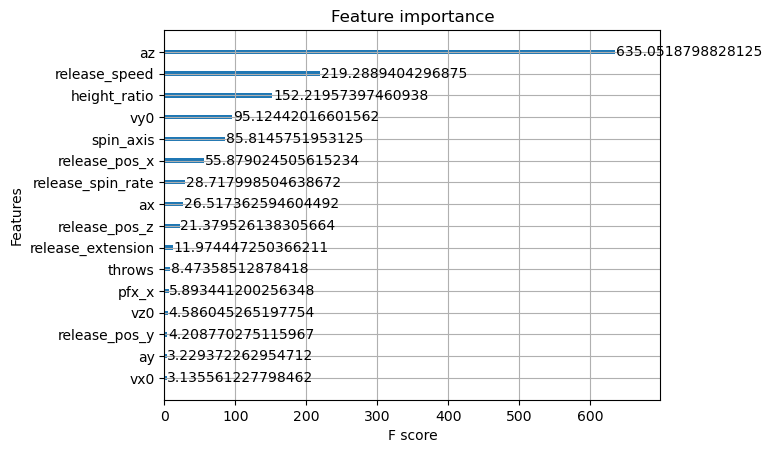

In [22]:
importance = final_model.get_score(importance_type='gain')
# Visualizing the feature importances
xgb.plot_importance(importance)
plt.show()

In [23]:
y_pred = final_model.predict(dtest)

In [24]:
print(y_pred.min())

-1.5584089


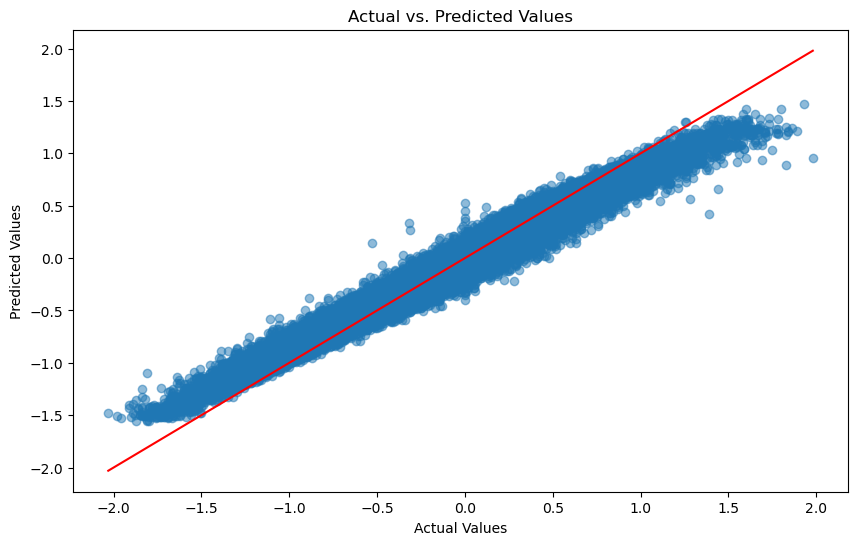

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red') # Line for perfect predictions
plt.show()

## Testing Data Set Predictions

In [33]:
predictions = final_model.predict(xgb.DMatrix(testing_data))

In [34]:
testing_identifiers['xpfx_z'] = predictions

In [35]:
testing_identifiers.head()

pitch_id_raw    xpfx_z
4   663364_657077_605347_1_73_10 -0.703306
7   663364_593428_605347_2_72_10 -0.817440
8   663364_593428_605347_1_72_10 -0.743283
10  663364_596115_605347_5_70_10  0.359038
20   663364_602104_518489_2_69_9  0.032614

In [36]:
testing_identifiers.to_csv("Y:/departments/research_and_development/baseball_operations/clayton_goodiez/csv/breaking_ball/IVB_2022&3_xpfz.csv")